In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
    
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run1"
    model = EEGNet_IE_EEG_Wrapper(DEVICE, classifier, input_dim[0]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_EEG-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_IE_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_EEG-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_EEG-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7718720938645157


Iterations:   0%|                                   | 1/300 [00:03<17:40,  3.55s/it]

Epoch:  0
t_loss:  0.7718720938645157 , v_loss:  0.6898674567540487
t_acc:  0.4413320883909119 , v_acc:  0.6894409937888198
t_recall:  0.5064231893605633 , v_recall:  0.5659459459459459
t_prec:  0.506094702297234 , v_prec:  0.6113138686131387
t_f:  0.4407684889844967 , v_f:  0.561355710549259
////////


Iterations:   1%|▏                                  | 2/300 [00:04<09:22,  1.89s/it]

Epoch  1 , loss 0.7406314962050494
Epoch  2 , loss 0.7057182578479543


Iterations:   1%|▎                                  | 3/300 [00:05<07:32,  1.52s/it]

Epoch:  2
t_loss:  0.7057182578479543 , v_loss:  0.6805400649706522
t_acc:  0.5082477435418612 , v_acc:  0.6956521739130435
t_recall:  0.49413952594666555 , v_recall:  0.5374774774774775
t_prec:  0.49501375984305607 , v_prec:  0.626060606060606
t_f:  0.4809369951534733 , v_f:  0.5044909239369386
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:06,  1.24s/it]

Epoch  3 , loss 0.6800175905227661
Epoch  4 , loss 0.6446500443944744


Iterations:   2%|▌                                  | 5/300 [00:07<06:04,  1.23s/it]

Epoch:  4
t_loss:  0.6446500443944744 , v_loss:  0.6677691539128622
t_acc:  0.5922813569872394 , v_acc:  0.7018633540372671
t_recall:  0.5191755534510918 , v_recall:  0.5364864864864866
t_prec:  0.5191316854433136 , v_prec:  0.6654411764705883
t_f:  0.5191526453841725 , v_f:  0.4952978056426333
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:08,  1.05s/it]

Epoch  5 , loss 0.6219121007358327
Epoch  6 , loss 0.6008319644366994


Iterations:   2%|▊                                  | 7/300 [00:09<05:20,  1.10s/it]

Epoch:  6
t_loss:  0.6008319644366994 , v_loss:  0.6526558001836141
t_acc:  0.6358543417366946 , v_acc:  0.6956521739130435
t_recall:  0.5197293476619865 , v_recall:  0.5154954954954954
t_prec:  0.5265649447449149 , v_prec:  0.6814345991561181
t_f:  0.5143716767516007 , v_f:  0.44665778214210566
////////


Iterations:   3%|▉                                  | 8/300 [00:10<04:47,  1.02it/s]

Epoch  7 , loss 0.5770619862219867
Epoch  8 , loss 0.5637259272968068


Iterations:   3%|█                                  | 9/300 [00:11<04:59,  1.03s/it]

Epoch:  8
t_loss:  0.5637259272968068 , v_loss:  0.6408582131067911
t_acc:  0.6647992530345471 , v_acc:  0.6956521739130435
t_recall:  0.5066057287163228 , v_recall:  0.51
t_prec:  0.5165720555592538 , v_prec:  0.846875
t_f:  0.4737251213751885 , v_f:  0.42920193907821425
////////


Iterations:   3%|█▏                                | 10/300 [00:11<04:24,  1.10it/s]

Epoch  9 , loss 0.5530602926132726
Epoch  10 , loss 0.5358922972398645


Iterations:   4%|█▏                                | 11/300 [00:13<05:04,  1.05s/it]

Epoch:  10
t_loss:  0.5358922972398645 , v_loss:  0.6363639930884043
t_acc:  0.6825396825396826 , v_acc:  0.6894409937888198
t_recall:  0.5090061898683795 , v_recall:  0.5
t_prec:  0.5380545514295103 , v_prec:  0.3447204968944099
t_f:  0.4591216184992467 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:13<04:38,  1.03it/s]

Epoch  11 , loss 0.5261353499749127
Epoch  12 , loss 0.5164030299467199


Iterations:   4%|█▍                                | 13/300 [00:15<04:54,  1.03s/it]

Epoch:  12
t_loss:  0.5164030299467199 , v_loss:  0.6365237136681875
t_acc:  0.6893868658574541 , v_acc:  0.6894409937888198
t_recall:  0.5050143423779525 , v_recall:  0.5
t_prec:  0.54075717122437 , v_prec:  0.3447204968944099
t_f:  0.43795274740375745 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:30,  1.06it/s]

Epoch  13 , loss 0.5069383762630761
Epoch  14 , loss 0.4965071970341252


Iterations:   5%|█▋                                | 15/300 [00:17<05:02,  1.06s/it]

Epoch:  14
t_loss:  0.4965071970341252 , v_loss:  0.6391924222310384
t_acc:  0.690631808278867 , v_acc:  0.6894409937888198
t_recall:  0.5027463251945485 , v_recall:  0.5
t_prec:  0.5317316841103711 , v_prec:  0.3447204968944099
t_f:  0.42895258570748096 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:18<04:53,  1.03s/it]

Epoch  15 , loss 0.4856603852674073
Epoch  16 , loss 0.48009752642874626


Iterations:   6%|█▉                                | 17/300 [00:19<05:02,  1.07s/it]

Epoch:  16
t_loss:  0.48009752642874626 , v_loss:  0.6444818079471588
t_acc:  0.6931216931216931 , v_acc:  0.6894409937888198
t_recall:  0.5022357639889653 , v_recall:  0.5
t_prec:  0.5427289896128423 , v_prec:  0.3447204968944099
t_f:  0.4227128406302891 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:20<04:39,  1.01it/s]

Epoch  17 , loss 0.4810095511230768
Epoch  18 , loss 0.4847087556240605


Iterations:   6%|██▏                               | 19/300 [00:21<05:02,  1.08s/it]

Epoch:  18
t_loss:  0.4847087556240605 , v_loss:  0.6486590603987376
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.5011178819944827 , v_recall:  0.5
t_prec:  0.5424882629107981 , v_prec:  0.3447204968944099
t_f:  0.4166045397057844 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:30,  1.03it/s]

Epoch  19 , loss 0.4746098489153619
Epoch  20 , loss 0.471128712682163


Iterations:   7%|██▍                               | 21/300 [00:23<04:57,  1.07s/it]

Epoch:  20
t_loss:  0.471128712682163 , v_loss:  0.6526912053426107
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5024601638736773 , v_recall:  0.5
t_prec:  0.6399953139643861 , v_prec:  0.3447204968944099
t_f:  0.4172988159743127 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:28,  1.04it/s]

Epoch  21 , loss 0.4621885851317761
Epoch  22 , loss 0.4674130830110288


Iterations:   8%|██▌                               | 23/300 [00:25<04:42,  1.02s/it]

Epoch:  22
t_loss:  0.4674130830110288 , v_loss:  0.6564978261788686
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5027476976709077 , v_recall:  0.5
t_prec:  0.6341044076273835 , v_prec:  0.3447204968944099
t_f:  0.41825958421883713 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:26<04:17,  1.07it/s]

Epoch  23 , loss 0.46728960965193955
Epoch  24 , loss 0.4556407320733164


Iterations:   8%|██▊                               | 25/300 [00:27<04:40,  1.02s/it]

Epoch:  24
t_loss:  0.4556407320733164 , v_loss:  0.6564630170663198
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5006388877451586 , v_recall:  0.5
t_prec:  0.5622270742358079 , v_prec:  0.3447204968944099
t_f:  0.41308060533064894 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:28<04:33,  1.00it/s]

Epoch  25 , loss 0.45643482079692915
Epoch  26 , loss 0.45466147567711623


Iterations:   9%|███                               | 27/300 [00:29<04:49,  1.06s/it]

Epoch:  26
t_loss:  0.45466147567711623 , v_loss:  0.6571736534436544
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.5000315669562592 , v_recall:  0.5
t_prec:  0.5016586538461538 , v_prec:  0.3447204968944099
t_f:  0.41360394423779057 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:25,  1.03it/s]

Epoch  27 , loss 0.4461033063776353
Epoch  28 , loss 0.45977723656916153


Iterations:  10%|███▎                              | 29/300 [00:31<04:56,  1.09s/it]

Epoch:  28
t_loss:  0.45977723656916153 , v_loss:  0.6573989590009054
t_acc:  0.6931216931216931 , v_acc:  0.6894409937888198
t_recall:  0.4987853584222012 , v_recall:  0.5
t_prec:  0.43088097469540765 , v_prec:  0.3447204968944099
t_f:  0.41132851695765604 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:32<04:23,  1.02it/s]

Epoch  29 , loss 0.4452574904642853
Epoch  30 , loss 0.45013503408899497


Iterations:  10%|███▌                              | 31/300 [00:33<04:44,  1.06s/it]

Epoch:  30
t_loss:  0.45013503408899497 , v_loss:  0.657381514708201
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.49968021300833093 , v_recall:  0.5
t_prec:  0.47273790951638067 , v_prec:  0.3447204968944099
t_f:  0.41177104462474656 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:34<04:16,  1.05it/s]

Epoch  31 , loss 0.4463645523669673
Epoch  32 , loss 0.44127702128653434


Iterations:  11%|███▋                              | 33/300 [00:35<04:34,  1.03s/it]

Epoch:  32
t_loss:  0.44127702128653434 , v_loss:  0.6548653791348139
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5023002703778428 , v_recall:  0.5
t_prec:  0.5982952768220207 , v_prec:  0.3447204968944099
t_f:  0.4180261984276795 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:36<04:13,  1.05it/s]

Epoch  33 , loss 0.4523112394061743
Epoch  34 , loss 0.45014764339316127


Iterations:  12%|███▉                              | 35/300 [00:37<04:30,  1.02s/it]

Epoch:  34
t_loss:  0.45014764339316127 , v_loss:  0.6528479357560476
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.4993926792111006 , v_recall:  0.5
t_prec:  0.43101028999064545 , v_prec:  0.3447204968944099
t_f:  0.4107920778766774 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:38<04:03,  1.09it/s]

Epoch  35 , loss 0.44339029578601613
Epoch  36 , loss 0.4491535740740159


Iterations:  12%|████▏                             | 37/300 [00:39<04:35,  1.05s/it]

Epoch:  36
t_loss:  0.4491535740740159 , v_loss:  0.6506571074326833
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5034826587612028 , v_recall:  0.5
t_prec:  0.6699749921850578 , v_prec:  0.3447204968944099
t_f:  0.4194516752347822 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:40<04:24,  1.01s/it]

Epoch  37 , loss 0.444252118176105
Epoch  38 , loss 0.4427543907773261


Iterations:  13%|████▍                             | 39/300 [00:41<04:40,  1.07s/it]

Epoch:  38
t_loss:  0.4427543907773261 , v_loss:  0.6471970826387405
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5016613826326841 , v_recall:  0.5
t_prec:  0.6259363295880149 , v_prec:  0.3447204968944099
t_f:  0.41525155202966746 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:42<04:28,  1.03s/it]

Epoch  39 , loss 0.4393763834354924
Epoch  40 , loss 0.44643738982724207


Iterations:  14%|████▋                             | 41/300 [00:43<04:52,  1.13s/it]

Epoch:  40
t_loss:  0.44643738982724207 , v_loss:  0.6421553939580917
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5012139553396193 , v_recall:  0.5
t_prec:  0.5753364374538641 , v_prec:  0.3447204968944099
t_f:  0.41502434448605435 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:44<04:19,  1.01s/it]

Epoch  41 , loss 0.43904538423407313
Epoch  42 , loss 0.44174206081558676


Iterations:  14%|████▊                             | 43/300 [00:45<04:47,  1.12s/it]

Epoch:  42
t_loss:  0.44174206081558676 , v_loss:  0.6374653776486715
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5022364502271449 , v_recall:  0.5
t_prec:  0.6175120192307693 , v_prec:  0.3447204968944099
t_f:  0.41718316736553546 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:46<04:20,  1.02s/it]

Epoch  43 , loss 0.4413942840753817
Epoch  44 , loss 0.43659067270802515


Iterations:  15%|█████                             | 45/300 [00:47<04:29,  1.06s/it]

Epoch:  44
t_loss:  0.43659067270802515 , v_loss:  0.6318465818961462
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5032589451146704 , v_recall:  0.5
t_prec:  0.6484990619136961 , v_prec:  0.3447204968944099
t_f:  0.41933401285531013 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:48<04:01,  1.05it/s]

Epoch  45 , loss 0.435250904045853
Epoch  46 , loss 0.44289670738519404


Iterations:  16%|█████▎                            | 47/300 [00:49<04:22,  1.04s/it]

Epoch:  46
t_loss:  0.44289670738519404 , v_loss:  0.6275209585825602
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5031951249639725 , v_recall:  0.5
t_prec:  0.6818181818181819 , v_prec:  0.3447204968944099
t_f:  0.418492875777644 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:50<04:01,  1.04it/s]

Epoch  47 , loss 0.44620908358517813
Epoch  48 , loss 0.4368474933446622


Iterations:  16%|█████▌                            | 49/300 [00:51<04:17,  1.02s/it]

Epoch:  48
t_loss:  0.4368474933446622 , v_loss:  0.6255750954151154
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5055914686869519 , v_recall:  0.5
t_prec:  0.6823308270676691 , v_prec:  0.3447204968944099
t_f:  0.42455390714097185 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:52<04:05,  1.02it/s]

Epoch  49 , loss 0.439520504544763
Epoch  50 , loss 0.4380616095720553


Iterations:  17%|█████▊                            | 51/300 [00:53<04:27,  1.07s/it]

Epoch:  50
t_loss:  0.4380616095720553 , v_loss:  0.6206003775199255
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5034826587612028 , v_recall:  0.5
t_prec:  0.6699749921850578 , v_prec:  0.3447204968944099
t_f:  0.4194516752347822 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:54<04:11,  1.02s/it]

Epoch  51 , loss 0.4321595810207666
Epoch  52 , loss 0.44362471150416954


Iterations:  18%|██████                            | 53/300 [00:55<04:23,  1.07s/it]

Epoch:  52
t_loss:  0.44362471150416954 , v_loss:  0.6171091248591741
t_acc:  0.699035169623405 , v_acc:  0.6894409937888198
t_recall:  0.5079239922592333 , v_recall:  0.5
t_prec:  0.7013496547394853 , v_prec:  0.3447204968944099
t_f:  0.4297152863243275 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [00:56<04:06,  1.00s/it]

Epoch  53 , loss 0.43674881727087733
Epoch  54 , loss 0.4370037749701855


Iterations:  18%|██████▏                           | 55/300 [00:58<04:20,  1.06s/it]

Epoch:  54
t_loss:  0.4370037749701855 , v_loss:  0.6138564795255661
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5032905120709296 , v_recall:  0.5
t_prec:  0.5806514913657771 , v_prec:  0.3447204968944099
t_f:  0.4225165611497069 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▎                           | 56/300 [00:58<04:03,  1.00it/s]

Epoch  55 , loss 0.43140243023049596
Epoch  56 , loss 0.43791141813876583


Iterations:  19%|██████▍                           | 57/300 [01:00<04:19,  1.07s/it]

Epoch:  56
t_loss:  0.43791141813876583 , v_loss:  0.6110758235057195
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5020127365806124 , v_recall:  0.5
t_prec:  0.5982338230697093 , v_prec:  0.3447204968944099
t_f:  0.4170674932028922 , v_f:  0.4080882352941176
////////


Iterations:  19%|██████▌                           | 58/300 [01:00<03:57,  1.02it/s]

Epoch  57 , loss 0.4378272061254464
Epoch  58 , loss 0.4345575424970365


Iterations:  20%|██████▋                           | 59/300 [01:02<04:11,  1.04s/it]

Epoch:  58
t_loss:  0.4345575424970365 , v_loss:  0.6077134360869726
t_acc:  0.6987239340180517 , v_acc:  0.6894409937888198
t_recall:  0.5077002786127008 , v_recall:  0.5
t_prec:  0.6887362637362637 , v_prec:  0.3447204968944099
t_f:  0.4295877869315472 , v_f:  0.4080882352941176
////////


Iterations:  20%|██████▊                           | 60/300 [01:03<04:02,  1.01s/it]

Epoch  59 , loss 0.43869294430695327
Epoch  60 , loss 0.43539699795199377


Iterations:  20%|██████▉                           | 61/300 [01:04<04:09,  1.04s/it]

Epoch:  60
t_loss:  0.43539699795199377 , v_loss:  0.6028114855289459
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5065178902293408 , v_recall:  0.5
t_prec:  0.6491988689915174 , v_prec:  0.3447204968944099
t_f:  0.428156146179402 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████                           | 62/300 [01:04<03:45,  1.05it/s]

Epoch  61 , loss 0.43474197329259384
Epoch  62 , loss 0.429139129671396


Iterations:  21%|███████▏                          | 63/300 [01:06<03:59,  1.01s/it]

Epoch:  62
t_loss:  0.429139129671396 , v_loss:  0.5989793489376704
t_acc:  0.699035169623405 , v_acc:  0.6894409937888198
t_recall:  0.5090741274481547 , v_recall:  0.5
t_prec:  0.6783196979232222 , v_prec:  0.3447204968944099
t_f:  0.4333828345311067 , v_f:  0.4080882352941176
////////


Iterations:  21%|███████▎                          | 64/300 [01:06<03:38,  1.08it/s]

Epoch  63 , loss 0.43124806939386856
Epoch  64 , loss 0.4325868937314725


Iterations:  22%|███████▎                          | 65/300 [01:07<03:55,  1.00s/it]

Epoch:  64
t_loss:  0.4325868937314725 , v_loss:  0.5981416751941045
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5090103072974568 , v_recall:  0.51
t_prec:  0.6934827884313108 , v_prec:  0.846875
t_f:  0.4326019714231394 , v_f:  0.42920193907821425
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<03:40,  1.06it/s]

Epoch  65 , loss 0.43320900260233414
Epoch  66 , loss 0.4310773587694355


Iterations:  22%|███████▌                          | 67/300 [01:09<03:57,  1.02s/it]

Epoch:  66
t_loss:  0.4310773587694355 , v_loss:  0.5972555081049601
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5060704629362759 , v_recall:  0.51
t_prec:  0.630354055328513 , v_prec:  0.846875
t_f:  0.42790302294631233 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:35,  1.08it/s]

Epoch  67 , loss 0.43557434806636736
Epoch  68 , loss 0.4288260358221391


Iterations:  23%|███████▊                          | 69/300 [01:11<03:58,  1.03s/it]

Epoch:  68
t_loss:  0.4288260358221391 , v_loss:  0.5958612362543741
t_acc:  0.6965452847805789 , v_acc:  0.6956521739130435
t_recall:  0.5046966141008221 , v_recall:  0.51
t_prec:  0.6288080301129235 , v_prec:  0.846875
t_f:  0.4240632334970011 , v_f:  0.42920193907821425
////////


Iterations:  23%|███████▉                          | 70/300 [01:12<03:52,  1.01s/it]

Epoch  69 , loss 0.4326859326923595
Epoch  70 , loss 0.43240971834051845


Iterations:  24%|████████                          | 71/300 [01:14<04:01,  1.05s/it]

Epoch:  70
t_loss:  0.43240971834051845 , v_loss:  0.5937253087759018
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5073166714703339 , v_recall:  0.51
t_prec:  0.6524013722126929 , v_prec:  0.846875
t_f:  0.43012403725227477 , v_f:  0.42920193907821425
////////


Iterations:  24%|████████▏                         | 72/300 [01:14<03:46,  1.01it/s]

Epoch  71 , loss 0.4304851819487179
Epoch  72 , loss 0.42699327276033516


Iterations:  24%|████████▎                         | 73/300 [01:16<04:02,  1.07s/it]

Epoch:  72
t_loss:  0.42699327276033516 , v_loss:  0.5924599468708038
t_acc:  0.6959228135698724 , v_acc:  0.6956521739130435
t_recall:  0.5059743895911393 , v_recall:  0.51
t_prec:  0.6054965828122727 , v_prec:  0.846875
t_f:  0.4293532411565777 , v_f:  0.42920193907821425
////////


Iterations:  25%|████████▍                         | 74/300 [01:16<03:38,  1.03it/s]

Epoch  73 , loss 0.42973800792413597
Epoch  74 , loss 0.4304767864591935


Iterations:  25%|████████▌                         | 75/300 [01:18<03:50,  1.02s/it]

Epoch:  74
t_loss:  0.4304767864591935 , v_loss:  0.5924653808275858
t_acc:  0.6987239340180517 , v_acc:  0.6956521739130435
t_recall:  0.5082753462071616 , v_recall:  0.51
t_prec:  0.6777006051556114 , v_prec:  0.846875
t_f:  0.43142723430393265 , v_f:  0.42920193907821425
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:35,  1.04it/s]

Epoch  75 , loss 0.43046366993118734
Epoch  76 , loss 0.43023162612728044


Iterations:  26%|████████▋                         | 77/300 [01:19<03:47,  1.02s/it]

Epoch:  76
t_loss:  0.43023162612728044 , v_loss:  0.5888324479262034
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5081792728620249 , v_recall:  0.51
t_prec:  0.6444307110658718 , v_prec:  0.846875
t_f:  0.4328577248342242 , v_f:  0.42920193907821425
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:40,  1.01it/s]

Epoch  77 , loss 0.4315432473724964
Epoch  78 , loss 0.4300156516187331


Iterations:  26%|████████▉                         | 79/300 [01:22<03:58,  1.08s/it]

Epoch:  78
t_loss:  0.4300156516187331 , v_loss:  0.5880189339319865
t_acc:  0.6971677559912854 , v_acc:  0.6956521739130435
t_recall:  0.5071567779744994 , v_recall:  0.51
t_prec:  0.6331225747157737 , v_prec:  0.846875
t_f:  0.4307802114466699 , v_f:  0.42920193907821425
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:34,  1.02it/s]

Epoch  79 , loss 0.42165247307104226
Epoch  80 , loss 0.42710071919011133


Iterations:  27%|█████████▏                        | 81/300 [01:24<04:06,  1.13s/it]

Epoch:  80
t_loss:  0.42710071919011133 , v_loss:  0.5864542375008265
t_acc:  0.6981014628073452 , v_acc:  0.6956521739130435
t_recall:  0.5098406554947091 , v_recall:  0.51
t_prec:  0.6415876777251185 , v_prec:  0.846875
t_f:  0.4374756335282651 , v_f:  0.42920193907821425
////////


Iterations:  27%|█████████▎                        | 82/300 [01:25<03:39,  1.01s/it]

Epoch  81 , loss 0.426089572263699
Epoch  82 , loss 0.4280754018063639


Iterations:  28%|█████████▍                        | 83/300 [01:26<03:48,  1.05s/it]

Epoch:  82
t_loss:  0.4280754018063639 , v_loss:  0.5877517511447271
t_acc:  0.6996576408341114 , v_acc:  0.6956521739130435
t_recall:  0.5112467575246016 , v_recall:  0.51
t_prec:  0.6724431818181819 , v_prec:  0.846875
t_f:  0.4390457565933556 , v_f:  0.42920193907821425
////////


Iterations:  28%|█████████▌                        | 84/300 [01:27<03:27,  1.04it/s]

Epoch  83 , loss 0.43123479917937635
Epoch  84 , loss 0.4352230821170059


Iterations:  28%|█████████▋                        | 85/300 [01:28<03:47,  1.06s/it]

Epoch:  84
t_loss:  0.4352230821170059 , v_loss:  0.585584486524264
t_acc:  0.6987239340180517 , v_acc:  0.6956521739130435
t_recall:  0.509425481396083 , v_recall:  0.51
t_prec:  0.6623266624645445 , v_prec:  0.846875
t_f:  0.4350609153578777 , v_f:  0.42920193907821425
////////


Iterations:  29%|█████████▋                        | 86/300 [01:29<03:24,  1.05it/s]

Epoch  85 , loss 0.4272868364465003
Epoch  86 , loss 0.426560348739811


Iterations:  29%|█████████▊                        | 87/300 [01:30<03:41,  1.04s/it]

Epoch:  86
t_loss:  0.426560348739811 , v_loss:  0.5829766740401586
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.5105117964343064 , v_recall:  0.53
t_prec:  0.6611742424242424 , v_prec:  0.8512658227848101
t_f:  0.4378831571251553 , v_f:  0.4692431787893666
////////


Iterations:  29%|█████████▉                        | 88/300 [01:31<03:30,  1.01it/s]

Epoch  87 , loss 0.43115633784555923
Epoch  88 , loss 0.4264809547686109


Iterations:  30%|██████████                        | 89/300 [01:32<03:44,  1.06s/it]

Epoch:  88
t_loss:  0.4264809547686109 , v_loss:  0.5826741109291712
t_acc:  0.6971677559912854 , v_acc:  0.7080745341614907
t_recall:  0.506006642785578 , v_recall:  0.53
t_prec:  0.6421926442557615 , v_prec:  0.8512658227848101
t_f:  0.4271051156391329 , v_f:  0.4692431787893666
////////


Iterations:  30%|██████████▏                       | 90/300 [01:33<03:20,  1.05it/s]

Epoch  89 , loss 0.4278905549470116
Epoch  90 , loss 0.43062923176615847


Iterations:  30%|██████████▎                       | 91/300 [01:34<03:51,  1.11s/it]

Epoch:  90
t_loss:  0.43062923176615847 , v_loss:  0.5813005218903223
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.5103841561329105 , v_recall:  0.53
t_prec:  0.6833648393194707 , v_prec:  0.8512658227848101
t_f:  0.4363622085118706 , v_f:  0.4692431787893666
////////


Iterations:  31%|██████████▍                       | 92/300 [01:35<03:31,  1.01s/it]

Epoch  91 , loss 0.43093956334918154
Epoch  92 , loss 0.4322756108115701


Iterations:  31%|██████████▌                       | 93/300 [01:36<03:38,  1.06s/it]

Epoch:  92
t_loss:  0.4322756108115701 , v_loss:  0.5772018929322561
t_acc:  0.7002801120448179 , v_acc:  0.7142857142857143
t_recall:  0.5116941848176665 , v_recall:  0.54
t_prec:  0.6875247597388305 , v_prec:  0.8535031847133758
t_f:  0.4393193446413476 , v_f:  0.488253178551686
////////


Iterations:  31%|██████████▋                       | 94/300 [01:37<03:19,  1.03it/s]

Epoch  93 , loss 0.428008285223269
Epoch  94 , loss 0.42660739959455


Iterations:  32%|██████████▊                       | 95/300 [01:38<03:39,  1.07s/it]

Epoch:  94
t_loss:  0.42660739959455 , v_loss:  0.5784261176983515
t_acc:  0.6971677559912854 , v_acc:  0.7080745341614907
t_recall:  0.5065817103800387 , v_recall:  0.53
t_prec:  0.6370926243567754 , v_prec:  0.8512658227848101
t_f:  0.4289502453619603 , v_f:  0.4692431787893666
////////


Iterations:  32%|██████████▉                       | 96/300 [01:39<03:22,  1.01it/s]

Epoch  95 , loss 0.42194441778987063
Epoch  96 , loss 0.42106469004761937


Iterations:  32%|██████████▉                       | 97/300 [01:40<03:31,  1.04s/it]

Epoch:  96
t_loss:  0.42106469004761937 , v_loss:  0.5760586361090342
t_acc:  0.6981014628073452 , v_acc:  0.7142857142857143
t_recall:  0.5081154527113271 , v_recall:  0.54
t_prec:  0.6550991501416431 , v_prec:  0.8535031847133758
t_f:  0.4320805835815217 , v_f:  0.488253178551686
////////


Iterations:  33%|███████████                       | 98/300 [01:41<03:10,  1.06it/s]

Epoch  97 , loss 0.4215187173263699
Epoch  98 , loss 0.4252532492665684


Iterations:  33%|███████████▏                      | 99/300 [01:42<03:21,  1.00s/it]

Epoch:  98
t_loss:  0.4252532492665684 , v_loss:  0.5763026972611746
t_acc:  0.6999688764394647 , v_acc:  0.7142857142857143
t_recall:  0.5111829373739037 , v_recall:  0.54
t_prec:  0.6835383159886471 , v_prec:  0.8535031847133758
t_f:  0.43829078801331856 , v_f:  0.488253178551686
////////


Iterations:  33%|███████████                      | 100/300 [01:43<03:02,  1.10it/s]

Epoch  99 , loss 0.4233192795631932
Epoch  100 , loss 0.4243604932345596


Iterations:  34%|███████████                      | 101/300 [01:44<03:17,  1.01it/s]

Epoch:  100
t_loss:  0.4243604932345596 , v_loss:  0.5772571613391241
t_acc:  0.7015250544662309 , v_acc:  0.7080745341614907
t_recall:  0.514026708389948 , v_recall:  0.53
t_prec:  0.6977605201372584 , v_prec:  0.8512658227848101
t_f:  0.44429339127138295 , v_f:  0.4692431787893666
////////


Iterations:  34%|███████████▏                     | 102/300 [01:45<03:07,  1.06it/s]

Epoch  101 , loss 0.4230550837283041
Epoch  102 , loss 0.43413551180970433


Iterations:  34%|███████████▎                     | 103/300 [01:46<03:21,  1.02s/it]

Epoch:  102
t_loss:  0.43413551180970433 , v_loss:  0.577944333354632
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.510671689930141 , v_recall:  0.53
t_prec:  0.6793628702365209 , v_prec:  0.8512658227848101
t_f:  0.4372603899317808 , v_f:  0.4692431787893666
////////


Iterations:  35%|███████████▍                     | 104/300 [01:47<03:03,  1.07it/s]

Epoch  103 , loss 0.42148250341415405
Epoch  104 , loss 0.4194825092951457


Iterations:  35%|███████████▌                     | 105/300 [01:48<03:15,  1.00s/it]

Epoch:  104
t_loss:  0.4194825092951457 , v_loss:  0.5769386937220892
t_acc:  0.7002801120448179 , v_acc:  0.7142857142857143
t_recall:  0.5134193876010485 , v_recall:  0.54
t_prec:  0.6688784616270367 , v_prec:  0.8535031847133758
t_f:  0.44459949427110435 , v_f:  0.488253178551686
////////


Iterations:  35%|███████████▋                     | 106/300 [01:49<03:02,  1.06it/s]

Epoch  105 , loss 0.4249463677406311
Epoch  106 , loss 0.4245334466298421


Iterations:  36%|███████████▊                     | 107/300 [01:50<03:15,  1.02s/it]

Epoch:  106
t_loss:  0.4245334466298421 , v_loss:  0.5753636658191681
t_acc:  0.6996576408341114 , v_acc:  0.7142857142857143
t_recall:  0.510671689930141 , v_recall:  0.54
t_prec:  0.6793628702365209 , v_prec:  0.8535031847133758
t_f:  0.4372603899317808 , v_f:  0.488253178551686
////////


Iterations:  36%|███████████▉                     | 108/300 [01:51<03:03,  1.04it/s]

Epoch  107 , loss 0.424620927548876
Epoch  108 , loss 0.4244613717584049


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:25,  1.08s/it]

Epoch:  108
t_loss:  0.4244613717584049 , v_loss:  0.5738162497679392
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.512396892713523 , v_recall:  0.53
t_prec:  0.661795438261285 , v_prec:  0.8512658227848101
t_f:  0.4425730977330197 , v_f:  0.4692431787893666
////////


Iterations:  37%|████████████                     | 110/300 [01:53<03:05,  1.03it/s]

Epoch  109 , loss 0.4125123842089784
Epoch  110 , loss 0.4240037512545492


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:24,  1.08s/it]

Epoch:  110
t_loss:  0.4240037512545492 , v_loss:  0.5717058579126993
t_acc:  0.7009025832555245 , v_acc:  0.7204968944099379
t_recall:  0.5112790107190404 , v_recall:  0.55
t_prec:  0.721648835745752 , v_prec:  0.8557692307692308
t_f:  0.43689855634373687 , v_f:  0.5066394279877425
////////


Iterations:  37%|████████████▎                    | 112/300 [01:55<03:02,  1.03it/s]

Epoch  111 , loss 0.42230123047735174
Epoch  112 , loss 0.41812945873129603


Iterations:  38%|████████████▍                    | 113/300 [01:56<03:22,  1.08s/it]

Epoch:  112
t_loss:  0.41812945873129603 , v_loss:  0.570434366663297
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.5137391745927177 , v_recall:  0.56
t_prec:  0.7018218841144608 , v_prec:  0.8580645161290323
t_f:  0.44341526636892 , v_f:  0.5244360902255639
////////


Iterations:  38%|████████████▌                    | 114/300 [01:57<03:11,  1.03s/it]

Epoch  113 , loss 0.42711332089760723
Epoch  114 , loss 0.4185340842779945


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:17,  1.07s/it]

Epoch:  114
t_loss:  0.4185340842779945 , v_loss:  0.5702059417963028
t_acc:  0.7024587612822907 , v_acc:  0.7267080745341615
t_recall:  0.5146978493295453 , v_recall:  0.56
t_prec:  0.7205282739116706 , v_prec:  0.8580645161290323
t_f:  0.44471737898000735 , v_f:  0.5244360902255639
////////


Iterations:  39%|████████████▊                    | 116/300 [01:59<03:10,  1.03s/it]

Epoch  115 , loss 0.42878446099804896
Epoch  116 , loss 0.4239679247725244


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:27,  1.13s/it]

Epoch:  116
t_loss:  0.4239679247725244 , v_loss:  0.571260467171669
t_acc:  0.702769996887644 , v_acc:  0.7204968944099379
t_recall:  0.5160716981649991 , v_recall:  0.55
t_prec:  0.709756388822546 , v_prec:  0.8557692307692308
t_f:  0.4483495423160972 , v_f:  0.5066394279877425
////////


Iterations:  39%|████████████▉                    | 118/300 [02:01<03:04,  1.01s/it]

Epoch  117 , loss 0.4234720480208303
Epoch  118 , loss 0.418989582973368


Iterations:  40%|█████████████                    | 119/300 [02:02<03:17,  1.09s/it]

Epoch:  118
t_loss:  0.418989582973368 , v_loss:  0.5698134899139404
t_acc:  0.6996576408341114 , v_acc:  0.7267080745341615
t_recall:  0.5121093589162927 , v_recall:  0.56
t_prec:  0.6641366223908918 , v_prec:  0.8580645161290323
t_f:  0.44169663418452426 , v_f:  0.5244360902255639
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:03<02:59,  1.00it/s]

Epoch  119 , loss 0.41921183934398726
Epoch  120 , loss 0.42145031223110124


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:04,  1.03s/it]

Epoch:  120
t_loss:  0.42145031223110124 , v_loss:  0.5689877172311147
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5170303729018267 , v_recall:  0.5700000000000001
t_prec:  0.7264710534640937 , v_prec:  0.8603896103896104
t_f:  0.44965058619473613 , v_f:  0.5416749420721615
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:05<02:50,  1.04it/s]

Epoch  121 , loss 0.4194817496281044
Epoch  122 , loss 0.4235954483350118


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:13,  1.09s/it]

Epoch:  122
t_loss:  0.4235954483350118 , v_loss:  0.5700842440128326
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.5137391745927177 , v_recall:  0.56
t_prec:  0.7018218841144608 , v_prec:  0.8580645161290323
t_f:  0.44341526636892 , v_f:  0.5244360902255639
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:07<02:58,  1.02s/it]

Epoch  123 , loss 0.41928762927943586
Epoch  124 , loss 0.4145481361477983


Iterations:  42%|█████████████▊                   | 125/300 [02:08<03:03,  1.05s/it]

Epoch:  124
t_loss:  0.4145481361477983 , v_loss:  0.5708265950282415
t_acc:  0.7049486461251168 , v_acc:  0.7267080745341615
t_recall:  0.5185002950824172 , v_recall:  0.56
t_prec:  0.7460181782785389 , v_prec:  0.8580645161290323
t_f:  0.45196297868971613 , v_f:  0.5244360902255639
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<02:47,  1.04it/s]

Epoch  125 , loss 0.4205484209107418
Epoch  126 , loss 0.41975728495448245


Iterations:  42%|█████████████▉                   | 127/300 [02:10<02:54,  1.01s/it]

Epoch:  126
t_loss:  0.41975728495448245 , v_loss:  0.5695664832989374
t_acc:  0.7018362900715842 , v_acc:  0.7267080745341615
t_recall:  0.5151130234281714 , v_recall:  0.56
t_prec:  0.6936530547641659 , v_prec:  0.8580645161290323
t_f:  0.4470503401712498 , v_f:  0.5244360902255639
////////


Iterations:  43%|██████████████                   | 128/300 [02:11<02:41,  1.06it/s]

Epoch  127 , loss 0.418341959808387
Epoch  128 , loss 0.41868817397192415


Iterations:  43%|██████████████▏                  | 129/300 [02:12<02:59,  1.05s/it]

Epoch:  128
t_loss:  0.41868817397192415 , v_loss:  0.5706772754589716
t_acc:  0.7024587612822907 , v_acc:  0.7267080745341615
t_recall:  0.5164230521129274 , v_recall:  0.56
t_prec:  0.6961746543526969 , v_prec:  0.8580645161290323
t_f:  0.44992729278443566 , v_f:  0.5244360902255639
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:13<02:50,  1.00s/it]

Epoch  129 , loss 0.4177117920389362
Epoch  130 , loss 0.4199567349518047


Iterations:  44%|██████████████▍                  | 131/300 [02:14<02:56,  1.04s/it]

Epoch:  130
t_loss:  0.4199567349518047 , v_loss:  0.5686677445967993
t_acc:  0.6977902272019919 , v_acc:  0.7267080745341615
t_recall:  0.5093294080509463 , v_recall:  0.56
t_prec:  0.6370445289713849 , v_prec:  0.8580645161290323
t_f:  0.43645070244444345 , v_f:  0.5244360902255639
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:15<02:37,  1.07it/s]

Epoch  131 , loss 0.4156035553006565
Epoch  132 , loss 0.41759378127023283


Iterations:  44%|██████████████▋                  | 133/300 [02:16<02:48,  1.01s/it]

Epoch:  132
t_loss:  0.41759378127023283 , v_loss:  0.5704840918382009
t_acc:  0.7012138188608776 , v_acc:  0.7267080745341615
t_recall:  0.5152406637295672 , v_recall:  0.56
t_prec:  0.6760941960038059 , v_prec:  0.8580645161290323
t_f:  0.44848539464706416 , v_f:  0.5244360902255639
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:33,  1.08it/s]

Epoch  133 , loss 0.4181922639117521
Epoch  134 , loss 0.4119725513691996


Iterations:  45%|██████████████▊                  | 135/300 [02:18<02:52,  1.04s/it]

Epoch:  134
t_loss:  0.4119725513691996 , v_loss:  0.5681952387094498
t_acc:  0.7018362900715842 , v_acc:  0.7267080745341615
t_recall:  0.5136753544420197 , v_recall:  0.56
t_prec:  0.7143779224877362 , v_prec:  0.8580645161290323
t_f:  0.4426731087068939 , v_f:  0.5244360902255639
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:19<02:34,  1.06it/s]

Epoch  135 , loss 0.42348427515403897
Epoch  136 , loss 0.4147067999138552


Iterations:  46%|███████████████                  | 137/300 [02:20<02:55,  1.08s/it]

Epoch:  136
t_loss:  0.4147067999138552 , v_loss:  0.5665826549132665
t_acc:  0.7030812324929971 , v_acc:  0.7267080745341615
t_recall:  0.5171580132032225 , v_recall:  0.56
t_prec:  0.7049538226132576 , v_prec:  0.8580645161290323
t_f:  0.45107807250664395 , v_f:  0.5244360902255639
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:21<02:37,  1.03it/s]

Epoch  137 , loss 0.418947204655292
Epoch  138 , loss 0.419214899633445


Iterations:  46%|███████████████▎                 | 139/300 [02:22<02:45,  1.03s/it]

Epoch:  138
t_loss:  0.419214899633445 , v_loss:  0.5675129691759745
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.5144741356830128 , v_recall:  0.56
t_prec:  0.7126181099716402 , v_prec:  0.8580645161290323
t_f:  0.44457602702299936 , v_f:  0.5244360902255639
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:23<02:28,  1.08it/s]

Epoch  139 , loss 0.4149462767675811
Epoch  140 , loss 0.412385914255591


Iterations:  47%|███████████████▌                 | 141/300 [02:24<02:37,  1.01it/s]

Epoch:  140
t_loss:  0.412385914255591 , v_loss:  0.5661148726940155
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.5146017759844086 , v_recall:  0.56
t_prec:  0.6905720085980416 , v_prec:  0.8580645161290323
t_f:  0.44603896448286623 , v_f:  0.5244360902255639
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:25<02:23,  1.10it/s]

Epoch  141 , loss 0.422908665210593
Epoch  142 , loss 0.4202308654785156


Iterations:  48%|███████████████▋                 | 143/300 [02:26<02:39,  1.01s/it]

Epoch:  142
t_loss:  0.4202308654785156 , v_loss:  0.5655320237080256
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.5167744060608556 , v_recall:  0.56
t_prec:  0.6847619047619047 , v_prec:  0.8580645161290323
t_f:  0.4514878826069854 , v_f:  0.5244360902255639
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:27<02:25,  1.07it/s]

Epoch  143 , loss 0.4160927434762319
Epoch  144 , loss 0.42049240540055666


Iterations:  48%|███████████████▉                 | 145/300 [02:28<02:35,  1.00s/it]

Epoch:  144
t_loss:  0.42049240540055666 , v_loss:  0.5667965412139893
t_acc:  0.704014939309057 , v_acc:  0.7267080745341615
t_recall:  0.5178291541428199 , v_recall:  0.56
t_prec:  0.7243738845068801 , v_prec:  0.8580645161290323
t_f:  0.45152037284716534 , v_f:  0.5244360902255639
////////


Iterations:  49%|████████████████                 | 146/300 [02:29<02:22,  1.08it/s]

Epoch  145 , loss 0.4232526713726567
Epoch  146 , loss 0.41618934507463495


Iterations:  49%|████████████████▏                | 147/300 [02:30<02:44,  1.07s/it]

Epoch:  146
t_loss:  0.41618934507463495 , v_loss:  0.5654157797495524
t_acc:  0.704014939309057 , v_acc:  0.7267080745341615
t_recall:  0.5181166879400503 , v_recall:  0.56
t_prec:  0.7201320792475485 , v_prec:  0.8580645161290323
t_f:  0.45237715032300213 , v_f:  0.5244360902255639
////////


Iterations:  49%|████████████████▎                | 148/300 [02:31<02:35,  1.02s/it]

Epoch  147 , loss 0.418376998574126
Epoch  148 , loss 0.41167594112601935


Iterations:  50%|████████████████▍                | 149/300 [02:32<02:39,  1.06s/it]

Epoch:  148
t_loss:  0.41167594112601935 , v_loss:  0.5628500183423361
t_acc:  0.702769996887644 , v_acc:  0.7267080745341615
t_recall:  0.5166467657594598 , v_recall:  0.5654954954954955
t_prec:  0.7022713628176906 , v_prec:  0.7969771241830066
t_f:  0.4500737944883985 , v_f:  0.5373563218390804
////////


Iterations:  50%|████████████████▌                | 150/300 [02:33<02:25,  1.03it/s]

Epoch  149 , loss 0.4225294017324261
Epoch  150 , loss 0.4165479815473743


Iterations:  50%|████████████████▌                | 151/300 [02:34<02:39,  1.07s/it]

Epoch:  150
t_loss:  0.4165479815473743 , v_loss:  0.5610167880853018
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5151768435788694 , v_recall:  0.5754954954954955
t_prec:  0.6844106463878327 , v_prec:  0.8062865497076024
t_f:  0.44777043865379496 , v_f:  0.5538441709093253
////////


Iterations:  51%|████████████████▋                | 152/300 [02:35<02:25,  1.01it/s]

Epoch  151 , loss 0.4157027584664962
Epoch  152 , loss 0.42071501764596675


Iterations:  51%|████████████████▊                | 153/300 [02:36<02:30,  1.03s/it]

Epoch:  152
t_loss:  0.42071501764596675 , v_loss:  0.5618889977534612
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5155281975267976 , v_recall:  0.5754954954954955
t_prec:  0.6737390075859174 , v_prec:  0.8062865497076024
t_f:  0.4493415978748322 , v_f:  0.5538441709093253
////////


Iterations:  51%|████████████████▉                | 154/300 [02:37<02:17,  1.07it/s]

Epoch  153 , loss 0.41624590403893413
Epoch  154 , loss 0.4141456432202283


Iterations:  52%|█████████████████                | 155/300 [02:38<02:24,  1.00it/s]

Epoch:  154
t_loss:  0.4141456432202283 , v_loss:  0.5618939300378164
t_acc:  0.7009025832555245 , v_acc:  0.7329192546583851
t_recall:  0.5138668148941135 , v_recall:  0.5700000000000001
t_prec:  0.6809798184857894 , v_prec:  0.8603896103896104
t_f:  0.44488367556625064 , v_f:  0.5416749420721615
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:39<02:10,  1.10it/s]

Epoch  155 , loss 0.41409758609883923
Epoch  156 , loss 0.414931515268251


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:22,  1.00it/s]

Epoch:  156
t_loss:  0.414931515268251 , v_loss:  0.5622317641973495
t_acc:  0.7015250544662309 , v_acc:  0.7329192546583851
t_recall:  0.5154643773760997 , v_recall:  0.5700000000000001
t_prec:  0.6816498823124792 , v_prec:  0.8603896103896104
t_f:  0.44863093916265373 , v_f:  0.5416749420721615
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:13,  1.06it/s]

Epoch  157 , loss 0.4165505708432665
Epoch  158 , loss 0.41963548695339875


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:22,  1.01s/it]

Epoch:  158
t_loss:  0.41963548695339875 , v_loss:  0.5641386757294337
t_acc:  0.7068160597572363 , v_acc:  0.7267080745341615
t_recall:  0.5238680501228367 , v_recall:  0.56
t_prec:  0.7246002772444314 , v_prec:  0.8580645161290323
t_f:  0.46463715594447846 , v_f:  0.5244360902255639
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:11,  1.07it/s]

Epoch  159 , loss 0.41610752601249545
Epoch  160 , loss 0.4165599089042813


Iterations:  54%|█████████████████▋               | 161/300 [02:44<02:19,  1.00s/it]

Epoch:  160
t_loss:  0.4165599089042813 , v_loss:  0.5619479517141978
t_acc:  0.7030812324929971 , v_acc:  0.7329192546583851
t_recall:  0.5168704794059922 , v_recall:  0.5754954954954955
t_prec:  0.7085840988280012 , v_prec:  0.8062865497076024
t_f:  0.4502203278443887 , v_f:  0.5538441709093253
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:11,  1.05it/s]

Epoch  161 , loss 0.41836245095028596
Epoch  162 , loss 0.4161820674643797


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:17,  1.01s/it]

Epoch:  162
t_loss:  0.4161820674643797 , v_loss:  0.5606474330027899
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5186917555345109 , v_recall:  0.5754954954954955
t_prec:  0.7124958392277607 , v_prec:  0.8062865497076024
t_f:  0.45408035921504253 , v_f:  0.5538441709093253
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:12,  1.02it/s]

Epoch  163 , loss 0.4215986214432062
Epoch  164 , loss 0.41682983555045783


Iterations:  55%|██████████████████▏              | 165/300 [02:48<02:25,  1.08s/it]

Epoch:  164
t_loss:  0.41682983555045783 , v_loss:  0.5622790902853012
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.5214717063998573 , v_recall:  0.5754954954954955
t_prec:  0.7293690743817809 , v_prec:  0.8062865497076024
t_f:  0.45920353287194204 , v_f:  0.5538441709093253
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:49<02:10,  1.03it/s]

Epoch  165 , loss 0.4146570978211422
Epoch  166 , loss 0.414440522591273


Iterations:  56%|██████████████████▎              | 167/300 [02:50<02:18,  1.04s/it]

Epoch:  166
t_loss:  0.414440522591273 , v_loss:  0.561875581741333
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5159118046691646 , v_recall:  0.5754954954954955
t_prec:  0.6933410046027617 , v_prec:  0.8062865497076024
t_f:  0.44892211657109676 , v_f:  0.5538441709093253
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:51<02:02,  1.07it/s]

Epoch  167 , loss 0.41612788684227886
Epoch  168 , loss 0.4162583491381477


Iterations:  56%|██████████████████▌              | 169/300 [02:52<02:11,  1.00s/it]

Epoch:  168
t_loss:  0.4162583491381477 , v_loss:  0.5608524332443873
t_acc:  0.7049486461251168 , v_acc:  0.7329192546583851
t_recall:  0.5196504302713386 , v_recall:  0.5754954954954955
t_prec:  0.7270456707897242 , v_prec:  0.8062865497076024
t_f:  0.45537932721397584 , v_f:  0.5538441709093253
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:53<02:02,  1.06it/s]

Epoch  169 , loss 0.4125421333546732
Epoch  170 , loss 0.418782466766881


Iterations:  57%|██████████████████▊              | 171/300 [02:54<02:09,  1.00s/it]

Epoch:  170
t_loss:  0.418782466766881 , v_loss:  0.5618795901536942
t_acc:  0.7037037037037037 , v_acc:  0.7329192546583851
t_recall:  0.5201932446713605 , v_recall:  0.5754954954954955
t_prec:  0.6900200614759391 , v_prec:  0.8062865497076024
t_f:  0.4589538985765855 , v_f:  0.5538441709093253
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:55<02:07,  1.01it/s]

Epoch  171 , loss 0.415082128608928
Epoch  172 , loss 0.41595038216488034


Iterations:  58%|███████████████████              | 173/300 [02:56<02:20,  1.11s/it]

Epoch:  172
t_loss:  0.41595038216488034 , v_loss:  0.5611943006515503
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5161032651212583 , v_recall:  0.5754954954954955
t_prec:  0.6694687581246208 , v_prec:  0.8062865497076024
t_f:  0.4510437089147734 , v_f:  0.5538441709093253
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:57<02:04,  1.01it/s]

Epoch  173 , loss 0.4172189329184738
Epoch  174 , loss 0.4214887566426221


Iterations:  58%|███████████████████▎             | 175/300 [02:58<02:20,  1.13s/it]

Epoch:  174
t_loss:  0.4214887566426221 , v_loss:  0.5608508586883545
t_acc:  0.7061935885465297 , v_acc:  0.7329192546583851
t_recall:  0.5234206228297718 , v_recall:  0.5754954954954955
t_prec:  0.7147270271630624 , v_prec:  0.8062865497076024
t_f:  0.4643191698892706 , v_f:  0.5538441709093253
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:59<02:09,  1.04s/it]

Epoch  175 , loss 0.4213217993577321
Epoch  176 , loss 0.41584115519243126


Iterations:  59%|███████████████████▍             | 177/300 [03:00<02:14,  1.09s/it]

Epoch:  176
t_loss:  0.41584115519243126 , v_loss:  0.5607079515854517
t_acc:  0.704014939309057 , v_acc:  0.7329192546583851
t_recall:  0.5198418907234322 , v_recall:  0.5754954954954955
t_prec:  0.6999253235977432 , v_prec:  0.8062865497076024
t_f:  0.4574459414756846 , v_f:  0.5538441709093253
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:01<01:58,  1.03it/s]

Epoch  177 , loss 0.41408320735482607
Epoch  178 , loss 0.41377678981014326


Iterations:  60%|███████████████████▋             | 179/300 [03:02<02:11,  1.09s/it]

Epoch:  178
t_loss:  0.41377678981014326 , v_loss:  0.5597516844669977
t_acc:  0.7012138188608776 , v_acc:  0.7329192546583851
t_recall:  0.5149531299323369 , v_recall:  0.5754954954954955
t_prec:  0.6786163178315755 , v_prec:  0.8062865497076024
t_f:  0.4476257333400191 , v_f:  0.5538441709093253
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:03<02:01,  1.02s/it]

Epoch  179 , loss 0.41956977341689317
Epoch  180 , loss 0.4107518196105957


Iterations:  60%|███████████████████▉             | 181/300 [03:04<02:04,  1.04s/it]

Epoch:  180
t_loss:  0.4107518196105957 , v_loss:  0.5583478311697642
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.5203215712109359 , v_recall:  0.5754954954954955
t_prec:  0.7469231538923354 , v_prec:  0.8062865497076024
t_f:  0.45583218407490744 , v_f:  0.5538441709093253
////////


Iterations:  61%|████████████████████             | 182/300 [03:05<01:50,  1.06it/s]

Epoch  181 , loss 0.416705882432414
Epoch  182 , loss 0.4192975052431518


Iterations:  61%|████████████████████▏            | 183/300 [03:06<01:58,  1.01s/it]

Epoch:  182
t_loss:  0.4192975052431518 , v_loss:  0.5586737394332886
t_acc:  0.7033924680983504 , v_acc:  0.7329192546583851
t_recall:  0.5179567944442157 , v_recall:  0.5754954954954955
t_prec:  0.7041404884746609 , v_prec:  0.8062865497076024
t_f:  0.45293226323021607 , v_f:  0.5538441709093253
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:07<01:53,  1.02it/s]

Epoch  183 , loss 0.41296033532011744
Epoch  184 , loss 0.4113088191724291


Iterations:  62%|████████████████████▎            | 185/300 [03:08<02:02,  1.06s/it]

Epoch:  184
t_loss:  0.4113088191724291 , v_loss:  0.5568493455648422
t_acc:  0.7074385309679427 , v_acc:  0.7391304347826086
t_recall:  0.5243154774159015 , v_recall:  0.5854954954954955
t_prec:  0.7350167144221585 , v_prec:  0.8142384105960265
t_f:  0.46495535714285713 , v_f:  0.5698473282442748
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:09<01:49,  1.04it/s]

Epoch  185 , loss 0.4133804160005906
Epoch  186 , loss 0.41194114147448074


Iterations:  62%|████████████████████▌            | 187/300 [03:10<02:01,  1.07s/it]

Epoch:  186
t_loss:  0.41194114147448074 , v_loss:  0.556828702489535
t_acc:  0.7052598817304699 , v_acc:  0.7391304347826086
t_recall:  0.5218868804984834 , v_recall:  0.5854954954954955
t_prec:  0.7087121542622807 , v_prec:  0.8142384105960265
t_f:  0.461383665611931 , v_f:  0.5698473282442748
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:11<01:47,  1.04it/s]

Epoch  187 , loss 0.41029907500042634
Epoch  188 , loss 0.4138891317096411


Iterations:  63%|████████████████████▊            | 189/300 [03:12<01:52,  1.02s/it]

Epoch:  188
t_loss:  0.4138891317096411 , v_loss:  0.5587937037150065
t_acc:  0.7061935885465297 , v_acc:  0.7391304347826086
t_recall:  0.52198295384362 , v_recall:  0.5854954954954955
t_prec:  0.731345870526042 , v_prec:  0.8142384105960265
t_f:  0.46019298043286044 , v_f:  0.5698473282442748
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:13<01:45,  1.04it/s]

Epoch  189 , loss 0.408652217949138
Epoch  190 , loss 0.4140635676243726


Iterations:  64%|█████████████████████            | 191/300 [03:14<01:51,  1.02s/it]

Epoch:  190
t_loss:  0.4140635676243726 , v_loss:  0.5593060255050659
t_acc:  0.7033924680983504 , v_acc:  0.7329192546583851
t_recall:  0.5176692606469854 , v_recall:  0.5754954954954955
t_prec:  0.7075491976827919 , v_prec:  0.8062865497076024
t_f:  0.45208058917832017 , v_f:  0.5538441709093253
////////


Iterations:  64%|█████████████████████            | 192/300 [03:15<01:48,  1.01s/it]

Epoch  191 , loss 0.41143199217085746
Epoch  192 , loss 0.4151916100698359


Iterations:  64%|█████████████████████▏           | 193/300 [03:16<01:51,  1.04s/it]

Epoch:  192
t_loss:  0.4151916100698359 , v_loss:  0.5578742623329163
t_acc:  0.7052598817304699 , v_acc:  0.7453416149068323
t_recall:  0.5215993467012531 , v_recall:  0.5954954954954955
t_prec:  0.7116374248034355 , v_prec:  0.8212121212121212
t_f:  0.4605574745238564 , v_f:  0.5853903649268262
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:17<01:42,  1.03it/s]

Epoch  193 , loss 0.4153013299493229
Epoch  194 , loss 0.4167160485305038


Iterations:  65%|█████████████████████▍           | 195/300 [03:19<01:52,  1.07s/it]

Epoch:  194
t_loss:  0.4167160485305038 , v_loss:  0.557089830438296
t_acc:  0.7024587612822907 , v_acc:  0.7453416149068323
t_recall:  0.5187233224907701 , v_recall:  0.5954954954954955
t_prec:  0.6761879751685422 , v_prec:  0.8212121212121212
t_f:  0.4566805956294283 , v_f:  0.5853903649268262
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:19<01:40,  1.03it/s]

Epoch  195 , loss 0.41628480717247607
Epoch  196 , loss 0.4046761741240819


Iterations:  66%|█████████████████████▋           | 197/300 [03:20<01:47,  1.05s/it]

Epoch:  196
t_loss:  0.4046761741240819 , v_loss:  0.5576708515485128
t_acc:  0.7083722377840025 , v_acc:  0.7391304347826086
t_recall:  0.5264242873416506 , v_recall:  0.5854954954954955
t_prec:  0.7332886350601407 , v_prec:  0.8142384105960265
t_f:  0.46950423019566584 , v_f:  0.5698473282442748
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:21<01:39,  1.02it/s]

Epoch  197 , loss 0.41413410270915313
Epoch  198 , loss 0.4134633441766103


Iterations:  66%|█████████████████████▉           | 199/300 [03:23<01:46,  1.05s/it]

Epoch:  198
t_loss:  0.4134633441766103 , v_loss:  0.5569054981072744
t_acc:  0.7043261749144102 , v_acc:  0.7391304347826086
t_recall:  0.5200656043699647 , v_recall:  0.5854954954954955
t_prec:  0.7050874403815581 , v_prec:  0.8142384105960265
t_f:  0.45759913851315337 , v_f:  0.5698473282442748
////////


Iterations:  67%|██████████████████████           | 200/300 [03:23<01:35,  1.05it/s]

Epoch  199 , loss 0.4104965895998712
Epoch  200 , loss 0.41024131868399827


Iterations:  67%|██████████████████████           | 201/300 [03:24<01:42,  1.03s/it]

Epoch:  200
t_loss:  0.41024131868399827 , v_loss:  0.5550872186819712
t_acc:  0.7071272953625894 , v_acc:  0.7453416149068323
t_recall:  0.5252418989582904 , v_recall:  0.5954954954954955
t_prec:  0.7174861643252448 , v_prec:  0.8212121212121212
t_f:  0.46804757433291594 , v_f:  0.5853903649268262
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:26<01:41,  1.03s/it]

Epoch  201 , loss 0.4165622773123722
Epoch  202 , loss 0.4104054091023464


Iterations:  68%|██████████████████████▎          | 203/300 [03:27<01:46,  1.09s/it]

Epoch:  202
t_loss:  0.4104054091023464 , v_loss:  0.5559308777252833
t_acc:  0.7068160597572363 , v_acc:  0.7453416149068323
t_recall:  0.5253057191089884 , v_recall:  0.5954954954954955
t_prec:  0.7104506232023011 , v_prec:  0.8212121212121212
t_f:  0.46868956887726076 , v_f:  0.5853903649268262
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:27<01:33,  1.03it/s]

Epoch  203 , loss 0.4111520408415327
Epoch  204 , loss 0.41057083302853153


Iterations:  68%|██████████████████████▌          | 205/300 [03:29<01:41,  1.07s/it]

Epoch:  204
t_loss:  0.41057083302853153 , v_loss:  0.5562669883171717
t_acc:  0.7071272953625894 , v_acc:  0.7453416149068323
t_recall:  0.5249543651610601 , v_recall:  0.5954954954954955
t_prec:  0.7203113261654537 , v_prec:  0.8212121212121212
t_f:  0.46723957376106884 , v_f:  0.5853903649268262
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:30<01:37,  1.03s/it]

Epoch  205 , loss 0.4157017621339536
Epoch  206 , loss 0.41512426383355083


Iterations:  69%|██████████████████████▊          | 207/300 [03:31<01:40,  1.08s/it]

Epoch:  206
t_loss:  0.41512426383355083 , v_loss:  0.5596060554186503
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5234844429804697 , v_recall:  0.5854954954954955
t_prec:  0.7073340172707665 , v_prec:  0.8142384105960265
t_f:  0.46497491732647195 , v_f:  0.5698473282442748
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:32<01:29,  1.03it/s]

Epoch  207 , loss 0.4165102097333646
Epoch  208 , loss 0.40793660867447945


Iterations:  70%|██████████████████████▉          | 209/300 [03:33<01:34,  1.04s/it]

Epoch:  208
t_loss:  0.40793660867447945 , v_loss:  0.5566403071085612
t_acc:  0.708994708994709 , v_acc:  0.7453416149068323
t_recall:  0.5277343160264064 , v_recall:  0.5954954954954955
t_prec:  0.7333519381038531 , v_prec:  0.8212121212121212
t_f:  0.472239082333658 , v_f:  0.5853903649268262
////////


Iterations:  70%|███████████████████████          | 210/300 [03:34<01:27,  1.03it/s]

Epoch  209 , loss 0.4103953347486608
Epoch  210 , loss 0.41548382008776946


Iterations:  70%|███████████████████████▏         | 211/300 [03:35<01:33,  1.05s/it]

Epoch:  210
t_loss:  0.41548382008776946 , v_loss:  0.5553652594486872
t_acc:  0.7058823529411765 , v_acc:  0.7453416149068323
t_recall:  0.522046773994318 , v_recall:  0.5954954954954955
t_prec:  0.7221415532691668 , v_prec:  0.8212121212121212
t_f:  0.4608689954726835 , v_f:  0.5853903649268262
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:36<01:24,  1.04it/s]

Epoch  211 , loss 0.41166693205926935
Epoch  212 , loss 0.4122278070917316


Iterations:  71%|███████████████████████▍         | 213/300 [03:37<01:32,  1.07s/it]

Epoch:  212
t_loss:  0.4122278070917316 , v_loss:  0.5565567662318548
t_acc:  0.7021475256769374 , v_acc:  0.7391304347826086
t_recall:  0.5156242708719342 , v_recall:  0.5854954954954955
t_prec:  0.6966261730669584 , v_prec:  0.8142384105960265
t_f:  0.4480599335591349 , v_f:  0.5698473282442748
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:38<01:23,  1.03it/s]

Epoch  213 , loss 0.4027639720954147
Epoch  214 , loss 0.41312211284450456


Iterations:  72%|███████████████████████▋         | 215/300 [03:39<01:27,  1.03s/it]

Epoch:  214
t_loss:  0.41312211284450456 , v_loss:  0.555823435386022
t_acc:  0.704014939309057 , v_acc:  0.7391304347826086
t_recall:  0.520416958317893 , v_recall:  0.5854954954954955
t_prec:  0.6946950527877148 , v_prec:  0.8142384105960265
t_f:  0.45910862301683886 , v_f:  0.5698473282442748
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:40<01:18,  1.07it/s]

Epoch  215 , loss 0.4138309534858255
Epoch  216 , loss 0.4090254581442066


Iterations:  72%|███████████████████████▊         | 217/300 [03:41<01:26,  1.04s/it]

Epoch:  216
t_loss:  0.4090254581442066 , v_loss:  0.5544095486402512
t_acc:  0.7074385309679427 , v_acc:  0.7391304347826086
t_recall:  0.5246030112131319 , v_recall:  0.5854954954954955
t_prec:  0.7315163203981299 , v_prec:  0.8142384105960265
t_f:  0.4657738074180571 , v_f:  0.5698473282442748
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:42<01:17,  1.06it/s]

Epoch  217 , loss 0.4115471810686822
Epoch  218 , loss 0.41288527028233396


Iterations:  73%|████████████████████████         | 219/300 [03:43<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.41288527028233396 , v_loss:  0.5532940030097961
t_acc:  0.7083722377840025 , v_acc:  0.7391304347826086
t_recall:  0.5264242873416506 , v_recall:  0.5854954954954955
t_prec:  0.7332886350601407 , v_prec:  0.8142384105960265
t_f:  0.46950423019566584 , v_f:  0.5698473282442748
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:43<01:14,  1.08it/s]

Epoch  219 , loss 0.4105735368588391
Epoch  220 , loss 0.4155353541467704


Iterations:  74%|████████████████████████▎        | 221/300 [03:45<01:19,  1.01s/it]

Epoch:  220
t_loss:  0.4155353541467704 , v_loss:  0.5521537065505981
t_acc:  0.7043261749144102 , v_acc:  0.7391304347826086
t_recall:  0.5215032733561165 , v_recall:  0.5854954954954955
t_prec:  0.6922156790577844 , v_prec:  0.8142384105960265
t_f:  0.46173501777552056 , v_f:  0.5698473282442748
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:45<01:12,  1.07it/s]

Epoch  221 , loss 0.4155293334932888
Epoch  222 , loss 0.4099851049044553


Iterations:  74%|████████████████████████▌        | 223/300 [03:47<01:17,  1.00s/it]

Epoch:  222
t_loss:  0.4099851049044553 , v_loss:  0.5528864761193594
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5248267248596643 , v_recall:  0.5854954954954955
t_prec:  0.7367463572114126 , v_prec:  0.8142384105960265
t_f:  0.4659337508021153 , v_f:  0.5698473282442748
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:47<01:11,  1.06it/s]

Epoch  223 , loss 0.41070037992561564
Epoch  224 , loss 0.40784114657663834


Iterations:  75%|████████████████████████▊        | 225/300 [03:48<01:15,  1.00s/it]

Epoch:  224
t_loss:  0.40784114657663834 , v_loss:  0.5550538053115209
t_acc:  0.710239651416122 , v_acc:  0.7391304347826086
t_recall:  0.5280541030180755 , v_recall:  0.5854954954954955
t_prec:  0.7605544933078394 , v_prec:  0.8142384105960265
t_f:  0.47129283645196546 , v_f:  0.5698473282442748
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:49<01:08,  1.09it/s]

Epoch  225 , loss 0.41477540602871016
Epoch  226 , loss 0.4128809921881732


Iterations:  76%|████████████████████████▉        | 227/300 [03:51<01:17,  1.06s/it]

Epoch:  226
t_loss:  0.4128809921881732 , v_loss:  0.5559683591127396
t_acc:  0.7068160597572363 , v_acc:  0.7391304347826086
t_recall:  0.5244431177172972 , v_recall:  0.5854954954954955
t_prec:  0.7184946632315052 , v_prec:  0.8142384105960265
t_f:  0.46626777552056875 , v_f:  0.5698473282442748
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:52<01:13,  1.02s/it]

Epoch  227 , loss 0.40598418958046856
Epoch  228 , loss 0.4158564753392163


Iterations:  76%|█████████████████████████▏       | 229/300 [03:53<01:15,  1.07s/it]

Epoch:  228
t_loss:  0.4158564753392163 , v_loss:  0.5548582275708517
t_acc:  0.704014939309057 , v_acc:  0.7391304347826086
t_recall:  0.5207044921151233 , v_recall:  0.5854954954954955
t_prec:  0.6922944550669217 , v_prec:  0.8142384105960265
t_f:  0.45993500264857046 , v_f:  0.5698473282442748
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:53<01:08,  1.03it/s]

Epoch  229 , loss 0.40663057828650756
Epoch  230 , loss 0.41148537689564274


Iterations:  77%|█████████████████████████▍       | 231/300 [03:55<01:11,  1.04s/it]

Epoch:  230
t_loss:  0.41148537689564274 , v_loss:  0.5542537470658621
t_acc:  0.7033924680983504 , v_acc:  0.7391304347826086
t_recall:  0.5191069296331371 , v_recall:  0.5854954954954955
t_prec:  0.6925199137072685 , v_prec:  0.8142384105960265
t_f:  0.45630492347668505 , v_f:  0.5698473282442748
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:55<01:04,  1.05it/s]

Epoch  231 , loss 0.41023683489537704
Epoch  232 , loss 0.41000211706348494


Iterations:  78%|█████████████████████████▋       | 233/300 [03:57<01:08,  1.02s/it]

Epoch:  232
t_loss:  0.41000211706348494 , v_loss:  0.553688128789266
t_acc:  0.7071272953625894 , v_acc:  0.7391304347826086
t_recall:  0.5240917637693691 , v_recall:  0.5854954954954955
t_prec:  0.7297378064741297 , v_prec:  0.8142384105960265
t_f:  0.4647962295045692 , v_f:  0.5698473282442748
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:57<01:01,  1.07it/s]

Epoch  233 , loss 0.4090736064256406
Epoch  234 , loss 0.4081167163802128


Iterations:  78%|█████████████████████████▊       | 235/300 [03:58<01:05,  1.00s/it]

Epoch:  234
t_loss:  0.4081167163802128 , v_loss:  0.552618126074473
t_acc:  0.7099284158107687 , v_acc:  0.7453416149068323
t_recall:  0.5281179231687734 , v_recall:  0.5954954954954955
t_prec:  0.7513433934486566 , v_prec:  0.8212121212121212
t_f:  0.4719337227018791 , v_f:  0.5853903649268262
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:59<00:58,  1.10it/s]

Epoch  235 , loss 0.41043709247720006
Epoch  236 , loss 0.4193106632606656


Iterations:  79%|██████████████████████████       | 237/300 [04:00<01:03,  1.01s/it]

Epoch:  236
t_loss:  0.4193106632606656 , v_loss:  0.5515328645706177
t_acc:  0.707749766573296 , v_acc:  0.7453416149068323
t_recall:  0.5265519276430464 , v_recall:  0.5954954954954955
t_prec:  0.7182864450127877 , v_prec:  0.8212121212121212
t_f:  0.47078120897007103 , v_f:  0.5853903649268262
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:01<00:57,  1.08it/s]

Epoch  237 , loss 0.41374483938310663
Epoch  238 , loss 0.4059755772936578


Iterations:  80%|██████████████████████████▎      | 239/300 [04:02<01:00,  1.01it/s]

Epoch:  238
t_loss:  0.4059755772936578 , v_loss:  0.5504962007204691
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5217269870026489 , v_recall:  0.5954954954954955
t_prec:  0.6966749768089053 , v_prec:  0.8212121212121212
t_f:  0.4618921520787872 , v_f:  0.5853903649268262
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:03<00:55,  1.09it/s]

Epoch  239 , loss 0.41133382215219383
Epoch  240 , loss 0.4105438034908444


Iterations:  80%|██████████████████████████▌      | 241/300 [04:04<00:58,  1.00it/s]

Epoch:  240
t_loss:  0.4105438034908444 , v_loss:  0.5515909940004349
t_acc:  0.712729536258948 , v_acc:  0.7453416149068323
t_recall:  0.5327191501626385 , v_recall:  0.5954954954954955
t_prec:  0.76297240055596 , v_prec:  0.8212121212121212
t_f:  0.480581980973699 , v_f:  0.5853903649268262
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:05<00:55,  1.04it/s]

Epoch  241 , loss 0.4066845196134904
Epoch  242 , loss 0.4034557868452633


Iterations:  81%|██████████████████████████▋      | 243/300 [04:06<00:58,  1.03s/it]

Epoch:  242
t_loss:  0.4034557868452633 , v_loss:  0.5520180414120356
t_acc:  0.710239651416122 , v_acc:  0.7453416149068323
t_recall:  0.5297793058014576 , v_recall:  0.5954954954954955
t_prec:  0.7393440995433185 , v_prec:  0.8212121212121212
t_f:  0.47607998297563786 , v_f:  0.5853903649268262
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:07<00:55,  1.01it/s]

Epoch  243 , loss 0.40962601117059294
Epoch  244 , loss 0.4086067130168279


Iterations:  82%|██████████████████████████▉      | 245/300 [04:08<00:58,  1.07s/it]

Epoch:  244
t_loss:  0.4086067130168279 , v_loss:  0.5519930223623911
t_acc:  0.7061935885465297 , v_acc:  0.7453416149068323
t_recall:  0.5237081566270021 , v_recall:  0.5954954954954955
t_prec:  0.711924917188075 , v_prec:  0.8212121212121212
t_f:  0.46513458608430674 , v_f:  0.5853903649268262
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:09<00:51,  1.04it/s]

Epoch  245 , loss 0.41346611287079604
Epoch  246 , loss 0.4100310264849195


Iterations:  82%|███████████████████████████▏     | 247/300 [04:10<00:54,  1.02s/it]

Epoch:  246
t_loss:  0.4100310264849195 , v_loss:  0.5523966948191324
t_acc:  0.7108621226268285 , v_acc:  0.7453416149068323
t_recall:  0.5313768682834439 , v_recall:  0.5954954954954955
t_prec:  0.7363678660049628 , v_prec:  0.8212121212121212
t_f:  0.47955182072829133 , v_f:  0.5853903649268262
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:11<00:48,  1.07it/s]

Epoch  247 , loss 0.41168761341010823
Epoch  248 , loss 0.4096853955119264


Iterations:  83%|███████████████████████████▍     | 249/300 [04:12<00:52,  1.04s/it]

Epoch:  248
t_loss:  0.4096853955119264 , v_loss:  0.5529453853766123
t_acc:  0.7096171802054155 , v_acc:  0.7453416149068323
t_recall:  0.527894209522241 , v_recall:  0.5954954954954955
t_prec:  0.7462659439548278 , v_prec:  0.8212121212121212
t_f:  0.4717688866302628 , v_f:  0.5853903649268262
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:13<00:49,  1.01it/s]

Epoch  249 , loss 0.40568989690612345
Epoch  250 , loss 0.40182434986619386


Iterations:  84%|███████████████████████████▌     | 251/300 [04:14<00:51,  1.05s/it]

Epoch:  250
t_loss:  0.40182434986619386 , v_loss:  0.5507021645704905
t_acc:  0.7096171802054155 , v_acc:  0.7453416149068323
t_recall:  0.5290443447111624 , v_recall:  0.5954954954954955
t_prec:  0.7334370242901582 , v_prec:  0.8212121212121212
t_f:  0.47495448347612257 , v_f:  0.5853903649268262
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:15<00:47,  1.02it/s]

Epoch  251 , loss 0.4084240087107116
Epoch  252 , loss 0.411530322303959


Iterations:  84%|███████████████████████████▊     | 253/300 [04:17<00:52,  1.12s/it]

Epoch:  252
t_loss:  0.411530322303959 , v_loss:  0.5490831236044565
t_acc:  0.7074385309679427 , v_acc:  0.7453416149068323
t_recall:  0.5263282139965139 , v_recall:  0.5954954954954955
t_prec:  0.713998854686489 , v_prec:  0.8212121212121212
t_f:  0.4706168161919158 , v_f:  0.5853903649268262
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:17<00:45,  1.00it/s]

Epoch  253 , loss 0.4097319058343476
Epoch  254 , loss 0.41072378263754006


Iterations:  85%|████████████████████████████     | 255/300 [04:19<00:49,  1.10s/it]

Epoch:  254
t_loss:  0.41072378263754006 , v_loss:  0.5483128478129705
t_acc:  0.7080610021786492 , v_acc:  0.7391304347826086
t_recall:  0.5276382426812698 , v_recall:  0.590990990990991
t_prec:  0.7149375600384246 , v_prec:  0.7824384787472036
t_f:  0.4733287617801376 , v_f:  0.5805210918114144
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:19<00:44,  1.01s/it]

Epoch  255 , loss 0.4060756321631226
Epoch  256 , loss 0.4100390269475825


Iterations:  86%|████████████████████████████▎    | 257/300 [04:21<00:44,  1.04s/it]

Epoch:  256
t_loss:  0.4100390269475825 , v_loss:  0.5484682371219
t_acc:  0.7086834733893558 , v_acc:  0.7453416149068323
t_recall:  0.5286607375687954 , v_recall:  0.600990990990991
t_prec:  0.718183622863352 , v_prec:  0.7913201663201663
t_f:  0.4752381816532075 , v_f:  0.5954525954525954
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:21<00:40,  1.05it/s]

Epoch  257 , loss 0.41556621532814175
Epoch  258 , loss 0.4057792051165712


Iterations:  86%|████████████████████████████▍    | 259/300 [04:23<00:42,  1.04s/it]

Epoch:  258
t_loss:  0.4057792051165712 , v_loss:  0.5483884960412979
t_acc:  0.7108621226268285 , v_acc:  0.7515527950310559
t_recall:  0.5302267330945225 , v_recall:  0.610990990990991
t_prec:  0.748497442455243 , v_prec:  0.7993197278911565
t_f:  0.47641719183513953 , v_f:  0.6099806201550388
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:23<00:38,  1.04it/s]

Epoch  259 , loss 0.40956902036479875
Epoch  260 , loss 0.4112930584187601


Iterations:  87%|████████████████████████████▋    | 261/300 [04:25<00:40,  1.03s/it]

Epoch:  260
t_loss:  0.4112930584187601 , v_loss:  0.5497062752644221
t_acc:  0.7086834733893558 , v_acc:  0.7453416149068323
t_recall:  0.527510602379874 , v_recall:  0.600990990990991
t_prec:  0.7287871524448706 , v_prec:  0.7913201663201663
t_f:  0.4720737117506541 , v_f:  0.5954525954525954
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:25<00:35,  1.07it/s]

Epoch  261 , loss 0.4037486869914859
Epoch  262 , loss 0.4106842349557316


Iterations:  88%|████████████████████████████▉    | 263/300 [04:27<00:37,  1.03s/it]

Epoch:  262
t_loss:  0.4106842349557316 , v_loss:  0.548378253976504
t_acc:  0.7061935885465297 , v_acc:  0.7577639751552795
t_recall:  0.5248582918159235 , v_recall:  0.620990990990991
t_prec:  0.7020511523787567 , v_prec:  0.8066210045662101
t_f:  0.46836412179273246 , v_f:  0.624124513618677
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:27<00:35,  1.01it/s]

Epoch  263 , loss 0.4085380525565615
Epoch  264 , loss 0.4069666909236534


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:29<00:36,  1.05s/it]

Epoch:  264
t_loss:  0.4069666909236534 , v_loss:  0.5474045674006144
t_acc:  0.7130407718643013 , v_acc:  0.7515527950310559
t_recall:  0.5329428638091709 , v_recall:  0.610990990990991
t_prec:  0.7677635150712846 , v_prec:  0.7993197278911565
t_f:  0.48075394098824087 , v_f:  0.6099806201550388
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:29<00:32,  1.04it/s]

Epoch  265 , loss 0.40515796343485516
Epoch  266 , loss 0.4058631272876964


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:31<00:35,  1.07s/it]

Epoch:  266
t_loss:  0.4058631272876964 , v_loss:  0.5499013314644495
t_acc:  0.7068160597572363 , v_acc:  0.7453416149068323
t_recall:  0.527605989486831 , v_recall:  0.600990990990991
t_prec:  0.6938387407645359 , v_prec:  0.7913201663201663
t_f:  0.4750094707087975 , v_f:  0.5954525954525954
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:31<00:31,  1.03it/s]

Epoch  267 , loss 0.40485886645083335
Epoch  268 , loss 0.40536440558293285


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:33<00:31,  1.03s/it]

Epoch:  268
t_loss:  0.40536440558293285 , v_loss:  0.5491648465394974
t_acc:  0.710239651416122 , v_acc:  0.7515527950310559
t_recall:  0.53179204238207 , v_recall:  0.610990990990991
t_prec:  0.721092417725063 , v_prec:  0.7993197278911565
t_f:  0.4815238569331057 , v_f:  0.6099806201550388
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:33<00:27,  1.08it/s]

Epoch  269 , loss 0.40645264468941034
Epoch  270 , loss 0.4098085159180211


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:34<00:28,  1.01it/s]

Epoch:  270
t_loss:  0.4098085159180211 , v_loss:  0.5492229461669922
t_acc:  0.707749766573296 , v_acc:  0.7515527950310559
t_recall:  0.5271269952375071 , v_recall:  0.6054954954954955
t_prec:  0.7132637500179833 , v_prec:  0.8274608501118568
t_f:  0.47237162719548076 , v_f:  0.6004962779156328
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:35<00:25,  1.11it/s]

Epoch  271 , loss 0.40791546071276946
Epoch  272 , loss 0.4055235578733332


Iterations:  91%|██████████████████████████████   | 273/300 [04:36<00:27,  1.01s/it]

Epoch:  272
t_loss:  0.4055235578733332 , v_loss:  0.5474286476771036
t_acc:  0.7108621226268285 , v_acc:  0.7577639751552795
t_recall:  0.5290765979056011 , v_recall:  0.6154954954954954
t_prec:  0.7632044294990723 , v_prec:  0.8331600831600832
t_f:  0.4732326757441446 , v_f:  0.6151866151866152
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:37<00:24,  1.08it/s]

Epoch  273 , loss 0.4088037984043944
Epoch  274 , loss 0.4163350217482623


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:38<00:25,  1.00s/it]

Epoch:  274
t_loss:  0.4163350217482623 , v_loss:  0.5477386514345804
t_acc:  0.7080610021786492 , v_acc:  0.7577639751552795
t_recall:  0.5273507088840395 , v_recall:  0.6154954954954954
t_prec:  0.7173963636363636 , v_prec:  0.8331600831600832
t_f:  0.47253752345215766 , v_f:  0.6151866151866152
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:39<00:21,  1.10it/s]

Epoch  275 , loss 0.4030328016070759
Epoch  276 , loss 0.40802326506259395


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:40<00:23,  1.01s/it]

Epoch:  276
t_loss:  0.40802326506259395 , v_loss:  0.5456738074620565
t_acc:  0.711484593837535 , v_acc:  0.7577639751552795
t_recall:  0.531249227982048 , v_recall:  0.6154954954954954
t_prec:  0.7511582500496393 , v_prec:  0.8331600831600832
t_f:  0.4783309819746684 , v_f:  0.6151866151866152
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:41<00:21,  1.01it/s]

Epoch  277 , loss 0.40736931094936296
Epoch  278 , loss 0.40294165763200496


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:42<00:21,  1.04s/it]

Epoch:  278
t_loss:  0.40294165763200496 , v_loss:  0.5478221426407496
t_acc:  0.7099284158107687 , v_acc:  0.7577639751552795
t_recall:  0.5275428555743128 , v_recall:  0.6154954954954954
t_prec:  0.7591804930129238 , v_prec:  0.8331600831600832
t_f:  0.47032041331237145 , v_f:  0.6151866151866152
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:43<00:18,  1.05it/s]

Epoch  279 , loss 0.40234856249070633
Epoch  280 , loss 0.40548934480723214


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:44<00:20,  1.06s/it]

Epoch:  280
t_loss:  0.40548934480723214 , v_loss:  0.5464913795391718
t_acc:  0.7080610021786492 , v_acc:  0.7639751552795031
t_recall:  0.5273507088840395 , v_recall:  0.6254954954954954
t_prec:  0.7173963636363636 , v_prec:  0.83843537414966
t_f:  0.47253752345215766 , v_f:  0.6294815891472869
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:45<00:17,  1.00it/s]

Epoch  281 , loss 0.40414904262505325
Epoch  282 , loss 0.4016675049183415


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:46<00:17,  1.05s/it]

Epoch:  282
t_loss:  0.4016675049183415 , v_loss:  0.5450173815091451
t_acc:  0.7080610021786492 , v_acc:  0.7639751552795031
t_recall:  0.5267756412895788 , v_recall:  0.6254954954954954
t_prec:  0.7226749760306808 , v_prec:  0.83843537414966
t_f:  0.47094566412618966 , v_f:  0.6294815891472869
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:47<00:15,  1.04it/s]

Epoch  283 , loss 0.401001212643642
Epoch  284 , loss 0.40873511223232045


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:48<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.40873511223232045 , v_loss:  0.5462999641895294
t_acc:  0.7093059446000622 , v_acc:  0.7639751552795031
t_recall:  0.5293956986590906 , v_recall:  0.6254954954954954
t_prec:  0.7237786105345276 , v_prec:  0.83843537414966
t_f:  0.47635946758984593 , v_f:  0.6294815891472869
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:49<00:13,  1.07it/s]

Epoch  285 , loss 0.40066252122907076
Epoch  286 , loss 0.4115322652985068


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:50<00:12,  1.01it/s]

Epoch:  286
t_loss:  0.4115322652985068 , v_loss:  0.5441519866387049
t_acc:  0.7074385309679427 , v_acc:  0.7577639751552795
t_recall:  0.528053416779896 , v_recall:  0.620990990990991
t_prec:  0.700871359779867 , v_prec:  0.8066210045662101
t_f:  0.47534655873258513 , v_f:  0.624124513618677
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:51<00:11,  1.00it/s]

Epoch  287 , loss 0.40757553133310054
Epoch  288 , loss 0.40804261787264956


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:52<00:11,  1.05s/it]

Epoch:  288
t_loss:  0.40804261787264956 , v_loss:  0.54404350121816
t_acc:  0.7093059446000622 , v_acc:  0.7639751552795031
t_recall:  0.5305458338480119 , v_recall:  0.6254954954954954
t_prec:  0.7144812078380982 , v_prec:  0.83843537414966
t_f:  0.47946798900426424 , v_f:  0.6294815891472869
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:53<00:09,  1.03it/s]

Epoch  289 , loss 0.40998177259576085
Epoch  290 , loss 0.40173955875284534


Iterations:  97%|████████████████████████████████ | 291/300 [04:55<00:10,  1.11s/it]

Epoch:  290
t_loss:  0.40173955875284534 , v_loss:  0.5436870902776718
t_acc:  0.7093059446000622 , v_acc:  0.7639751552795031
t_recall:  0.529683232456321 , v_recall:  0.6254954954954954
t_prec:  0.7213014946143403 , v_prec:  0.83843537414966
t_f:  0.4771411665988325 , v_f:  0.6294815891472869
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:55<00:07,  1.01it/s]

Epoch  291 , loss 0.40138013953087376
Epoch  292 , loss 0.40346880403219487


Iterations:  98%|████████████████████████████████▏| 293/300 [04:56<00:07,  1.05s/it]

Epoch:  292
t_loss:  0.40346880403219487 , v_loss:  0.5455160091320673
t_acc:  0.7117958294428882 , v_acc:  0.7577639751552795
t_recall:  0.5317604754258108 , v_recall:  0.6154954954954954
t_prec:  0.7524472727272726 , v_prec:  0.8331600831600832
t_f:  0.47928544426087194 , v_f:  0.6151866151866152
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:57<00:05,  1.06it/s]

Epoch  293 , loss 0.4075609965651643
Epoch  294 , loss 0.40376636385917664


Iterations:  98%|████████████████████████████████▍| 295/300 [04:58<00:05,  1.01s/it]

Epoch:  294
t_loss:  0.40376636385917664 , v_loss:  0.5435203909873962
t_acc:  0.713974478680361 , v_acc:  0.782608695652174
t_recall:  0.5370644103155323 , v_recall:  0.6554954954954955
t_prec:  0.7437744853193398 , v_prec:  0.8525326797385621
t_f:  0.49046511768365236 , v_f:  0.6701785191688616
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:59<00:03,  1.09it/s]

Epoch  295 , loss 0.40789321883052004
Epoch  296 , loss 0.40199993813739104


Iterations:  99%|████████████████████████████████▋| 297/300 [05:00<00:02,  1.00it/s]

Epoch:  296
t_loss:  0.40199993813739104 , v_loss:  0.5447458128134409
t_acc:  0.7083722377840025 , v_acc:  0.7701863354037267
t_recall:  0.529299625313954 , v_recall:  0.6354954954954954
t_prec:  0.707742161499387 , v_prec:  0.84337899543379
t_f:  0.477408892714698 , v_f:  0.64340017958695
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:01<00:01,  1.09it/s]

Epoch  297 , loss 0.4054170683318493
Epoch  298 , loss 0.4038255197160384


Iterations: 100%|████████████████████████████████▉| 299/300 [05:02<00:01,  1.05s/it]

Epoch:  298
t_loss:  0.4038255197160384 , v_loss:  0.5452685604492823
t_acc:  0.7124183006535948 , v_acc:  0.7763975155279503
t_recall:  0.5330705041105667 , v_recall:  0.6454954954954955
t_prec:  0.7517535488904058 , v_prec:  0.8480603448275862
t_f:  0.4819658972730382 , v_f:  0.6569602272727273
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:03<00:00,  1.01s/it]

Epoch  299 , loss 0.4057135476785548


110 14

c0_acc 0.990990990990991 , c1_acc 0.28 , b_acc 0.6354954954954954


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7320641816831103


Iterations:   0%|                                   | 1/300 [00:01<07:49,  1.57s/it]

Epoch:  0
t_loss:  0.7320641816831103 , v_loss:  0.6955515742301941
t_acc:  0.4831565814098565 , v_acc:  0.44642857142857145
t_recall:  0.5021887390959556 , v_recall:  0.42272354388843314
t_prec:  0.5018698452596025 , v_prec:  0.4329059829059829
t_f:  0.4715565626370574 , v_f:  0.4182088996462484
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:42,  1.15s/it]

Epoch  1 , loss 0.699155709322761
Epoch  2 , loss 0.6675792535146078


Iterations:   1%|▎                                  | 3/300 [00:03<05:43,  1.16s/it]

Epoch:  2
t_loss:  0.6675792535146078 , v_loss:  0.6946411728858948
t_acc:  0.5545851528384279 , v_acc:  0.5238095238095238
t_recall:  0.501832683975221 , v_recall:  0.4741591468416735
t_prec:  0.5016741186257823 , v_prec:  0.47619047619047616
t_f:  0.49968614052511573 , v_f:  0.47335423197492166
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:49,  1.02it/s]

Epoch  3 , loss 0.6514829560822132
Epoch  4 , loss 0.6253247740221959


Iterations:   2%|▌                                  | 5/300 [00:05<05:23,  1.10s/it]

Epoch:  4
t_loss:  0.6253247740221959 , v_loss:  0.6856695016225179
t_acc:  0.6051154086088584 , v_acc:  0.6369047619047619
t_recall:  0.5003188175935822 , v_recall:  0.516078753076292
t_prec:  0.500378249688428 , v_prec:  0.525
t_f:  0.4970662582525427 , v_f:  0.5038489469862019
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:01,  1.03s/it]

Epoch  5 , loss 0.6004044992082259
Epoch  6 , loss 0.5819853205306857


Iterations:   2%|▊                                  | 7/300 [00:07<05:08,  1.05s/it]

Epoch:  6
t_loss:  0.5819853205306857 , v_loss:  0.6725015441576639
t_acc:  0.6397379912663755 , v_acc:  0.6547619047619048
t_recall:  0.49545886057764144 , v_recall:  0.48843314191960624
t_prec:  0.49169206650383857 , v_prec:  0.45073375262054505
t_f:  0.47308956494133797 , v_f:  0.4264186484577348
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:33,  1.07it/s]

Epoch  7 , loss 0.5719843787305495
Epoch  8 , loss 0.5425201531718759


Iterations:   3%|█                                  | 9/300 [00:09<04:56,  1.02s/it]

Epoch:  8
t_loss:  0.5425201531718759 , v_loss:  0.6632436712582906
t_acc:  0.680910792264504 , v_acc:  0.6845238095238095
t_recall:  0.5160921284005102 , v_recall:  0.5
t_prec:  0.5503330227421748 , v_prec:  0.34226190476190477
t_f:  0.47861440884696704 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:34,  1.06it/s]

Epoch  9 , loss 0.5385711514482311
Epoch  10 , loss 0.5237956993720111


Iterations:   4%|█▏                                | 11/300 [00:11<04:59,  1.03s/it]

Epoch:  10
t_loss:  0.5237956993720111 , v_loss:  0.658781478802363
t_acc:  0.6852776044915783 , v_acc:  0.6845238095238095
t_recall:  0.5108572676389799 , v_recall:  0.5
t_prec:  0.5478922308203955 , v_prec:  0.34226190476190477
t_f:  0.46064866802552656 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:29,  1.07it/s]

Epoch  11 , loss 0.5166132900060392
Epoch  12 , loss 0.5034374097983042


Iterations:   4%|█▍                                | 13/300 [00:13<05:03,  1.06s/it]

Epoch:  12
t_loss:  0.5034374097983042 , v_loss:  0.6582355201244354
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.5118065947200864 , v_recall:  0.5
t_prec:  0.5896442433889029 , v_prec:  0.34226190476190477
t_f:  0.4496561966574407 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:31,  1.05it/s]

Epoch  13 , loss 0.494966805565591
Epoch  14 , loss 0.4838015665026272


Iterations:   5%|█▋                                | 15/300 [00:15<04:55,  1.04s/it]

Epoch:  14
t_loss:  0.4838015665026272 , v_loss:  0.659289946158727
t_acc:  0.6918278228321897 , v_acc:  0.6845238095238095
t_recall:  0.5054589755082808 , v_recall:  0.5
t_prec:  0.5533481591302198 , v_prec:  0.34226190476190477
t_f:  0.43566353978630407 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:28,  1.06it/s]

Epoch  15 , loss 0.48159565878849403
Epoch  16 , loss 0.4783746354720172


Iterations:   6%|█▉                                | 17/300 [00:17<04:45,  1.01s/it]

Epoch:  16
t_loss:  0.4783746354720172 , v_loss:  0.6617893675963084
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5061920031261133 , v_recall:  0.5
t_prec:  0.5888550242769686 , v_prec:  0.34226190476190477
t_f:  0.43183527793755316 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:18<04:25,  1.06it/s]

Epoch  17 , loss 0.47585735835281073
Epoch  18 , loss 0.4661676498020397


Iterations:   6%|██▏                               | 19/300 [00:19<04:39,  1.01it/s]

Epoch:  18
t_loss:  0.4661676498020397 , v_loss:  0.6650132636229197
t_acc:  0.6927635683094199 , v_acc:  0.6845238095238095
t_recall:  0.5023781447896195 , v_recall:  0.5
t_prec:  0.5389275179098187 , v_prec:  0.34226190476190477
t_f:  0.42444431686355133 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:19,  1.08it/s]

Epoch  19 , loss 0.4624254399654912
Epoch  20 , loss 0.4587382662530039


Iterations:   7%|██▍                               | 21/300 [00:21<04:33,  1.02it/s]

Epoch:  20
t_loss:  0.4587382662530039 , v_loss:  0.6677855948607127
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5035936512314818 , v_recall:  0.5
t_prec:  0.5820424013434089 , v_prec:  0.34226190476190477
t_f:  0.423584500283859 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:12,  1.10it/s]

Epoch  21 , loss 0.45901532792577554
Epoch  22 , loss 0.4578649319854437


Iterations:   8%|██▌                               | 23/300 [00:23<04:38,  1.00s/it]

Epoch:  22
t_loss:  0.4578649319854437 , v_loss:  0.6736436088879904
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5040076313944535 , v_recall:  0.5
t_prec:  0.6821268150005223 , v_prec:  0.34226190476190477
t_f:  0.4206506227900548 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:32,  1.01it/s]

Epoch  23 , loss 0.4539744135211496
Epoch  24 , loss 0.4590030441097185


Iterations:   8%|██▊                               | 25/300 [00:25<04:47,  1.04s/it]

Epoch:  24
t_loss:  0.4590030441097185 , v_loss:  0.6769170761108398
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5043609281798435 , v_recall:  0.5
t_prec:  0.6488700564971751 , v_prec:  0.34226190476190477
t_f:  0.4224350476770042 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:23,  1.04it/s]

Epoch  25 , loss 0.44652412335077923
Epoch  26 , loss 0.44985099516662896


Iterations:   9%|███                               | 27/300 [00:27<04:58,  1.10s/it]

Epoch:  26
t_loss:  0.44985099516662896 , v_loss:  0.679566353559494
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5025337608753118 , v_recall:  0.5
t_prec:  0.6151467669487098 , v_prec:  0.34226190476190477
t_f:  0.41826155319331265 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:30,  1.01it/s]

Epoch  27 , loss 0.4466680621399599
Epoch  28 , loss 0.44081006096858605


Iterations:  10%|███▎                              | 29/300 [00:29<04:44,  1.05s/it]

Epoch:  28
t_loss:  0.44081006096858605 , v_loss:  0.6803054412206014
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5026629429139514 , v_recall:  0.5
t_prec:  0.586603872318158 , v_prec:  0.34226190476190477
t_f:  0.4199367633013591 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:19,  1.04it/s]

Epoch  29 , loss 0.44614797187786476
Epoch  30 , loss 0.44501150939978806


Iterations:  10%|███▌                              | 31/300 [00:31<04:32,  1.01s/it]

Epoch:  30
t_loss:  0.44501150939978806 , v_loss:  0.6831156512101492
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5015081198496707 , v_recall:  0.5
t_prec:  0.5790310535064684 , v_prec:  0.34226190476190477
t_f:  0.41610237301900094 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:06,  1.09it/s]

Epoch  31 , loss 0.44013120789153903
Epoch  32 , loss 0.44075599867923587


Iterations:  11%|███▋                              | 33/300 [00:33<04:36,  1.04s/it]

Epoch:  32
t_loss:  0.44075599867923587 , v_loss:  0.6863012909889221
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5040076313944535 , v_recall:  0.5
t_prec:  0.6821268150005223 , v_prec:  0.34226190476190477
t_f:  0.4206506227900548 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:20,  1.02it/s]

Epoch  33 , loss 0.4517224442725088
Epoch  34 , loss 0.43896451913842965


Iterations:  12%|███▉                              | 35/300 [00:35<04:33,  1.03s/it]

Epoch:  34
t_loss:  0.43896451913842965 , v_loss:  0.6854643722375234
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5036239929202726 , v_recall:  0.5
t_prec:  0.6237131198995606 , v_prec:  0.34226190476190477
t_f:  0.4212454185270083 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:35<04:06,  1.07it/s]

Epoch  35 , loss 0.44020085475024057
Epoch  36 , loss 0.45216693130193975


Iterations:  12%|████▏                             | 37/300 [00:37<04:33,  1.04s/it]

Epoch:  36
t_loss:  0.45216693130193975 , v_loss:  0.6851648588975271
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5043305864910527 , v_recall:  0.5
t_prec:  0.5988664987405541 , v_prec:  0.34226190476190477
t_f:  0.4247644706005758 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:18,  1.01it/s]

Epoch  37 , loss 0.4411361927495283
Epoch  38 , loss 0.440025421334248


Iterations:  13%|████▍                             | 39/300 [00:39<04:35,  1.06s/it]

Epoch:  38
t_loss:  0.440025421334248 , v_loss:  0.687216579914093
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5036885839395925 , v_recall:  0.5
t_prec:  0.6095971806745073 , v_prec:  0.34226190476190477
t_f:  0.42207207173860095 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:09,  1.04it/s]

Epoch  39 , loss 0.4430381766721314
Epoch  40 , loss 0.43154303963277857


Iterations:  14%|████▋                             | 41/300 [00:41<04:29,  1.04s/it]

Epoch:  40
t_loss:  0.43154303963277857 , v_loss:  0.6876047054926554
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5081101954970175 , v_recall:  0.5
t_prec:  0.7409744703520059 , v_prec:  0.34226190476190477
t_f:  0.4291923336884334 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:13,  1.02it/s]

Epoch  41 , loss 0.4455878004139545
Epoch  42 , loss 0.43506113337535485


Iterations:  14%|████▊                             | 43/300 [00:43<04:25,  1.03s/it]

Epoch:  42
t_loss:  0.43506113337535485 , v_loss:  0.6867752075195312
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5054815019135951 , v_recall:  0.5
t_prec:  0.7491068630523348 , v_prec:  0.34226190476190477
t_f:  0.42303969238679684 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:43<03:56,  1.08it/s]

Epoch  43 , loss 0.43546053358152803
Epoch  44 , loss 0.431717211709303


Iterations:  15%|█████                             | 45/300 [00:45<04:30,  1.06s/it]

Epoch:  44
t_loss:  0.431717211709303 , v_loss:  0.6867437561353048
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.5124065326575412 , v_recall:  0.5
t_prec:  0.7131001263423878 , v_prec:  0.34226190476190477
t_f:  0.43991106170094496 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:46<04:00,  1.05it/s]

Epoch  45 , loss 0.4353124931746838
Epoch  46 , loss 0.43373795408828586


Iterations:  16%|█████▎                            | 47/300 [00:47<04:14,  1.01s/it]

Epoch:  46
t_loss:  0.43373795408828586 , v_loss:  0.6883458197116852
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5041368134330931 , v_recall:  0.5
t_prec:  0.6345368916797488 , v_prec:  0.34226190476190477
t_f:  0.4223140716484846 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:47<03:50,  1.09it/s]

Epoch  47 , loss 0.42756181517068076
Epoch  48 , loss 0.43803605028227266


Iterations:  16%|█████▌                            | 49/300 [00:49<04:14,  1.01s/it]

Epoch:  48
t_loss:  0.43803605028227266 , v_loss:  0.6871920724709829
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.5129839441896815 , v_recall:  0.5
t_prec:  0.7030001150020125 , v_prec:  0.34226190476190477
t_f:  0.44169585587539695 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:49<03:54,  1.06it/s]

Epoch  49 , loss 0.4351402176361458
Epoch  50 , loss 0.4363109989493501


Iterations:  17%|█████▊                            | 51/300 [00:51<04:13,  1.02s/it]

Epoch:  50
t_loss:  0.4363109989493501 , v_loss:  0.6867227554321289
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5093296095806181 , v_recall:  0.5
t_prec:  0.6881722424152511 , v_prec:  0.34226190476190477
t_f:  0.4336776892476319 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [00:51<04:00,  1.03it/s]

Epoch  51 , loss 0.43986201987547036
Epoch  52 , loss 0.433767661744473


Iterations:  18%|██████                            | 53/300 [00:53<04:13,  1.03s/it]

Epoch:  52
t_loss:  0.433767661744473 , v_loss:  0.6858334044615427
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5093296095806181 , v_recall:  0.5
t_prec:  0.6881722424152511 , v_prec:  0.34226190476190477
t_f:  0.4336776892476319 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [00:53<03:50,  1.07it/s]

Epoch  53 , loss 0.43556423105445563
Epoch  54 , loss 0.42946236916616853


Iterations:  18%|██████▏                           | 55/300 [00:55<04:17,  1.05s/it]

Epoch:  54
t_loss:  0.42946236916616853 , v_loss:  0.6849785347779592
t_acc:  0.7018091079226451 , v_acc:  0.6845238095238095
t_recall:  0.5129193531703617 , v_recall:  0.5
t_prec:  0.716564559010519 , v_prec:  0.34226190476190477
t_f:  0.4409434226577868 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [00:55<03:57,  1.03it/s]

Epoch  55 , loss 0.4313834157644534
Epoch  56 , loss 0.43873847173709496


Iterations:  19%|██████▍                           | 57/300 [00:57<04:08,  1.02s/it]

Epoch:  56
t_loss:  0.43873847173709496 , v_loss:  0.6855533917744955
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5102260685676194 , v_recall:  0.5
t_prec:  0.7334592779177163 , v_prec:  0.34226190476190477
t_f:  0.43420423313430995 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [00:57<03:44,  1.08it/s]

Epoch  57 , loss 0.4344193701650582
Epoch  58 , loss 0.4273854272038329


Iterations:  20%|██████▋                           | 59/300 [00:59<04:16,  1.06s/it]

Epoch:  58
t_loss:  0.4273854272038329 , v_loss:  0.6856703162193298
t_acc:  0.7021210230817218 , v_acc:  0.6845238095238095
t_recall:  0.5114112333206909 , v_recall:  0.5
t_prec:  0.7789490245437382 , v_prec:  0.34226190476190477
t_f:  0.43564942075234825 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [00:59<03:52,  1.03it/s]

Epoch  59 , loss 0.432685722323025
Epoch  60 , loss 0.4307178130336836


Iterations:  20%|██████▉                           | 61/300 [01:01<04:11,  1.05s/it]

Epoch:  60
t_loss:  0.4307178130336836 , v_loss:  0.686179498831431
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5087864473790068 , v_recall:  0.5
t_prec:  0.6405237888669133 , v_prec:  0.34226190476190477
t_f:  0.4348286278940509 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [01:01<03:48,  1.04it/s]

Epoch  61 , loss 0.4481799754441953
Epoch  62 , loss 0.42974363764127094


Iterations:  21%|███████▏                          | 63/300 [01:03<04:06,  1.04s/it]

Epoch:  62
t_loss:  0.42974363764127094 , v_loss:  0.686164011557897
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5119279614752497 , v_recall:  0.5
t_prec:  0.6581996000195113 , v_prec:  0.34226190476190477
t_f:  0.4417436729202887 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:04<03:56,  1.00s/it]

Epoch  63 , loss 0.42733263852549536
Epoch  64 , loss 0.42701904037419486


Iterations:  22%|███████▎                          | 65/300 [01:05<04:11,  1.07s/it]

Epoch:  64
t_loss:  0.42701904037419486 , v_loss:  0.6840507487456003
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5101957268788286 , v_recall:  0.5
t_prec:  0.6751263423878711 , v_prec:  0.34226190476190477
t_f:  0.4363995323072205 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:06<03:56,  1.01s/it]

Epoch  65 , loss 0.43165071630010415
Epoch  66 , loss 0.4266946233955084


Iterations:  22%|███████▌                          | 67/300 [01:07<04:13,  1.09s/it]

Epoch:  66
t_loss:  0.4266946233955084 , v_loss:  0.6833354532718658
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5117341884172901 , v_recall:  0.5
t_prec:  0.6876677278709498 , v_prec:  0.34226190476190477
t_f:  0.43949946568005044 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:08<03:48,  1.02it/s]

Epoch  67 , loss 0.4312024817747228
Epoch  68 , loss 0.43195126278727664


Iterations:  23%|███████▊                          | 69/300 [01:09<04:00,  1.04s/it]

Epoch:  68
t_loss:  0.43195126278727664 , v_loss:  0.6825758516788483
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5128244204622511 , v_recall:  0.5094339622641509
t_prec:  0.6840299767785518 , v_prec:  0.844311377245509
t_f:  0.4423030005548757 , v_f:  0.4263199369582348
////////


Iterations:  23%|███████▉                          | 70/300 [01:10<03:40,  1.04it/s]

Epoch  69 , loss 0.4271910558728611
Epoch  70 , loss 0.42468063854703714


Iterations:  24%|████████                          | 71/300 [01:11<03:59,  1.05s/it]

Epoch:  70
t_loss:  0.42468063854703714 , v_loss:  0.6815803150335947
t_acc:  0.7011852776044916 , v_acc:  0.6904761904761905
t_recall:  0.5139146525072119 , v_recall:  0.5094339622641509
t_prec:  0.6811242961181025 , v_prec:  0.844311377245509
t_f:  0.44507938205722675 , v_f:  0.4263199369582348
////////


Iterations:  24%|████████▏                         | 72/300 [01:12<03:49,  1.01s/it]

Epoch  71 , loss 0.4225964937724319
Epoch  72 , loss 0.42236655833674414


Iterations:  24%|████████▎                         | 73/300 [01:13<03:57,  1.04s/it]

Epoch:  72
t_loss:  0.42236655833674414 , v_loss:  0.6809122463067373
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.5126952384236114 , v_recall:  0.5094339622641509
t_prec:  0.7078065739570165 , v_prec:  0.844311377245509
t_f:  0.4408052905973794 , v_f:  0.4263199369582348
////////


Iterations:  25%|████████▍                         | 74/300 [01:14<03:39,  1.03it/s]

Epoch  73 , loss 0.4297006147749284
Epoch  74 , loss 0.43250308317296643


Iterations:  25%|████████▌                         | 75/300 [01:15<04:06,  1.09s/it]

Epoch:  74
t_loss:  0.43250308317296643 , v_loss:  0.6810400684674581
t_acc:  0.6999376169681847 , v_acc:  0.6904761904761905
t_recall:  0.5133068992862807 , v_recall:  0.5094339622641509
t_prec:  0.6558950412822543 , v_prec:  0.844311377245509
t_f:  0.4453777946257156 , v_f:  0.4263199369582348
////////


Iterations:  25%|████████▌                         | 76/300 [01:16<03:37,  1.03it/s]

Epoch  75 , loss 0.42369167828092386
Epoch  76 , loss 0.42209432522455853


Iterations:  26%|████████▋                         | 77/300 [01:17<03:55,  1.05s/it]

Epoch:  76
t_loss:  0.42209432522455853 , v_loss:  0.6848205129305521
t_acc:  0.7052401746724891 , v_acc:  0.6845238095238095
t_recall:  0.5182716730453172 , v_recall:  0.5
t_prec:  0.7518694550063372 , v_prec:  0.34226190476190477
t_f:  0.45131323375606136 , v_f:  0.40636042402826855
////////


Iterations:  26%|████████▊                         | 78/300 [01:18<03:34,  1.04it/s]

Epoch  77 , loss 0.435229827375973
Epoch  78 , loss 0.4173448991541769


Iterations:  26%|████████▉                         | 79/300 [01:19<03:49,  1.04s/it]

Epoch:  78
t_loss:  0.4173448991541769 , v_loss:  0.6830514868100485
t_acc:  0.7033686837180287 , v_acc:  0.6904761904761905
t_recall:  0.5172156903308853 , v_recall:  0.5094339622641509
t_prec:  0.7051001183017132 , v_prec:  0.844311377245509
t_f:  0.4512908919218495 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████                         | 80/300 [01:20<03:30,  1.05it/s]

Epoch  79 , loss 0.4313354229225832
Epoch  80 , loss 0.4250461868211335


Iterations:  27%|█████████▏                        | 81/300 [01:21<03:52,  1.06s/it]

Epoch:  80
t_loss:  0.4250461868211335 , v_loss:  0.6809599300225576
t_acc:  0.7024329382407986 , v_acc:  0.6904761904761905
t_recall:  0.5148111114942132 , v_recall:  0.5094339622641509
t_prec:  0.7082673424136838 , v_prec:  0.844311377245509
t_f:  0.4456496206848552 , v_f:  0.4263199369582348
////////


Iterations:  27%|█████████▎                        | 82/300 [01:22<03:33,  1.02it/s]

Epoch  81 , loss 0.42955463189704746
Epoch  82 , loss 0.4215388876550338


Iterations:  28%|█████████▍                        | 83/300 [01:23<03:41,  1.02s/it]

Epoch:  82
t_loss:  0.4215388876550338 , v_loss:  0.6806405584017435
t_acc:  0.7002495321272614 , v_acc:  0.6964285714285714
t_recall:  0.51179877943661 , v_recall:  0.5188679245283019
t_prec:  0.6765616400660429 , v_prec:  0.8463855421686747
t_f:  0.4402529263503888 , v_f:  0.44561630540278224
////////


Iterations:  28%|█████████▌                        | 84/300 [01:24<03:18,  1.09it/s]

Epoch  83 , loss 0.42273378781243864
Epoch  84 , loss 0.4209357692914851


Iterations:  28%|█████████▋                        | 85/300 [01:25<03:30,  1.02it/s]

Epoch:  84
t_loss:  0.4209357692914851 , v_loss:  0.6816368997097015
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5215081198496707 , v_recall:  0.5188679245283019
t_prec:  0.7852604750987757 , v_prec:  0.8463855421686747
t_f:  0.456816014046013 , v_f:  0.44561630540278224
////////


Iterations:  29%|█████████▋                        | 86/300 [01:25<03:11,  1.12it/s]

Epoch  85 , loss 0.4241520055368835
Epoch  86 , loss 0.4237496671723385


Iterations:  29%|█████████▊                        | 87/300 [01:27<03:28,  1.02it/s]

Epoch:  86
t_loss:  0.4237496671723385 , v_loss:  0.6818534433841705
t_acc:  0.6996257018091079 , v_acc:  0.6964285714285714
t_recall:  0.5127940787734603 , v_recall:  0.5188679245283019
t_prec:  0.652422994347807 , v_prec:  0.8463855421686747
t_f:  0.4443671176874249 , v_f:  0.44561630540278224
////////


Iterations:  29%|█████████▉                        | 88/300 [01:27<03:18,  1.07it/s]

Epoch  87 , loss 0.4211038140689625
Epoch  88 , loss 0.4330982489913118


Iterations:  30%|██████████                        | 89/300 [01:29<03:30,  1.00it/s]

Epoch:  88
t_loss:  0.4330982489913118 , v_loss:  0.6821037828922272
t_acc:  0.7018091079226451 , v_acc:  0.6964285714285714
t_recall:  0.5146515877667828 , v_recall:  0.5188679245283019
t_prec:  0.6907168375132399 , v_prec:  0.8463855421686747
t_f:  0.4462378802157712 , v_f:  0.44561630540278224
////////


Iterations:  30%|██████████▏                       | 90/300 [01:29<03:14,  1.08it/s]

Epoch  89 , loss 0.4239031783505982
Epoch  90 , loss 0.4291372737463783


Iterations:  30%|██████████▎                       | 91/300 [01:31<03:29,  1.00s/it]

Epoch:  90
t_loss:  0.4291372737463783 , v_loss:  0.6833120981852213
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5151644082796033 , v_recall:  0.5188679245283019
t_prec:  0.6937981763489378 , v_prec:  0.8463855421686747
t_f:  0.4472520570554062 , v_f:  0.44561630540278224
////////


Iterations:  31%|██████████▍                       | 92/300 [01:31<03:21,  1.03it/s]

Epoch  91 , loss 0.426175302734562
Epoch  92 , loss 0.4279935909252541


Iterations:  31%|██████████▌                       | 93/300 [01:33<03:31,  1.02s/it]

Epoch:  92
t_loss:  0.4279935909252541 , v_loss:  0.6809536516666412
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5145566550586721 , v_recall:  0.5188679245283019
t_prec:  0.6677474041110405 , v_prec:  0.8463855421686747
t_f:  0.44753885533211324 , v_f:  0.44561630540278224
////////


Iterations:  31%|██████████▋                       | 94/300 [01:33<03:13,  1.07it/s]

Epoch  93 , loss 0.42353566662937986
Epoch  94 , loss 0.4300358295440674


Iterations:  32%|██████████▊                       | 95/300 [01:35<03:32,  1.03s/it]

Epoch:  94
t_loss:  0.4300358295440674 , v_loss:  0.6796862185001373
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5148757025135331 , v_recall:  0.5188679245283019
t_prec:  0.6972952538900541 , v_prec:  0.8463855421686747
t_f:  0.44638131634358846 , v_f:  0.44561630540278224
////////


Iterations:  32%|██████████▉                       | 96/300 [01:35<03:12,  1.06it/s]

Epoch  95 , loss 0.4264776420359518
Epoch  96 , loss 0.42362942006073745


Iterations:  32%|██████████▉                       | 97/300 [01:36<03:27,  1.02s/it]

Epoch:  96
t_loss:  0.42362942006073745 , v_loss:  0.6772454480330149
t_acc:  0.7024329382407986 , v_acc:  0.6964285714285714
t_recall:  0.5174094633888449 , v_recall:  0.5188679245283019
t_prec:  0.6800625734025001 , v_prec:  0.8463855421686747
t_f:  0.45339967188153424 , v_f:  0.44561630540278224
////////


Iterations:  33%|███████████                       | 98/300 [01:37<03:13,  1.05it/s]

Epoch  97 , loss 0.43652474675692765
Epoch  98 , loss 0.4226986333435657


Iterations:  33%|███████████▏                      | 99/300 [01:38<03:27,  1.03s/it]

Epoch:  98
t_loss:  0.4226986333435657 , v_loss:  0.6778755784034729
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5226629429139514 , v_recall:  0.5188679245283019
t_prec:  0.761162322525959 , v_prec:  0.8463855421686747
t_f:  0.4602126250742337 , v_f:  0.44561630540278224
////////


Iterations:  33%|███████████                      | 100/300 [01:39<03:22,  1.01s/it]

Epoch  99 , loss 0.41829263404303907
Epoch  100 , loss 0.4185342350426842


Iterations:  34%|███████████                      | 101/300 [01:41<03:35,  1.08s/it]

Epoch:  100
t_loss:  0.4185342350426842 , v_loss:  0.6795198619365692
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5167371191485938 , v_recall:  0.5188679245283019
t_prec:  0.6658482142857143 , v_prec:  0.8463855421686747
t_f:  0.4529493101115001 , v_f:  0.44561630540278224
////////


Iterations:  34%|███████████▏                     | 102/300 [01:41<03:13,  1.02it/s]

Epoch  101 , loss 0.4268141552513721
Epoch  102 , loss 0.41851307685468714


Iterations:  34%|███████████▎                     | 103/300 [01:43<03:39,  1.12s/it]

Epoch:  102
t_loss:  0.41851307685468714 , v_loss:  0.6812933683395386
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5200684986610581 , v_recall:  0.5188679245283019
t_prec:  0.7138148066514829 , v_prec:  0.8463855421686747
t_f:  0.4571431639841915 , v_f:  0.44561630540278224
////////


Iterations:  35%|███████████▍                     | 104/300 [01:44<03:14,  1.01it/s]

Epoch  103 , loss 0.4224595012618046
Epoch  104 , loss 0.4199173789398343


Iterations:  35%|███████████▌                     | 105/300 [01:45<03:26,  1.06s/it]

Epoch:  104
t_loss:  0.4199173789398343 , v_loss:  0.6827012101809183
t_acc:  0.7039925140361821 , v_acc:  0.6904761904761905
t_recall:  0.519396154420807 , v_recall:  0.5094339622641509
t_prec:  0.6977233532036141 , v_prec:  0.844311377245509
t_f:  0.4566845962591612 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▋                     | 106/300 [01:46<03:04,  1.05it/s]

Epoch  105 , loss 0.41314921308966246
Epoch  106 , loss 0.417830451446421


Iterations:  36%|███████████▊                     | 107/300 [01:47<03:16,  1.02s/it]

Epoch:  106
t_loss:  0.417830451446421 , v_loss:  0.679577628771464
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5198140422255169 , v_recall:  0.5188679245283019
t_prec:  0.6811837901462923 , v_prec:  0.8463855421686747
t_f:  0.4588776005158302 , v_f:  0.44561630540278224
////////


Iterations:  36%|███████████▉                     | 108/300 [01:47<02:59,  1.07it/s]

Epoch  107 , loss 0.4185829600867103
Epoch  108 , loss 0.4203373111930548


Iterations:  36%|███████████▉                     | 109/300 [01:49<03:17,  1.03s/it]

Epoch:  108
t_loss:  0.4203373111930548 , v_loss:  0.6806124448776245
t_acc:  0.7024329382407986 , v_acc:  0.6904761904761905
t_recall:  0.5171207576227747 , v_recall:  0.5094339622641509
t_prec:  0.6824088359904978 , v_prec:  0.844311377245509
t_f:  0.45255240849991407 , v_f:  0.4263199369582348
////////


Iterations:  37%|████████████                     | 110/300 [01:50<03:04,  1.03it/s]

Epoch  109 , loss 0.42329131096017125
Epoch  110 , loss 0.4204133304895139


Iterations:  37%|████████████▏                    | 111/300 [01:51<03:14,  1.03s/it]

Epoch:  110
t_loss:  0.4204133304895139 , v_loss:  0.6786719063917795
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5136905377604616 , v_recall:  0.5094339622641509
t_prec:  0.6749623989471705 , v_prec:  0.844311377245509
t_f:  0.4449368824252718 , v_f:  0.4263199369582348
////////


Iterations:  37%|████████████▎                    | 112/300 [01:51<02:54,  1.08it/s]

Epoch  111 , loss 0.4179030750312057
Epoch  112 , loss 0.42172805935728785


Iterations:  38%|████████████▍                    | 113/300 [01:53<03:19,  1.07s/it]

Epoch:  112
t_loss:  0.42172805935728785 , v_loss:  0.6780200302600861
t_acc:  0.7024329382407986 , v_acc:  0.6904761904761905
t_recall:  0.5153885230263536 , v_recall:  0.5094339622641509
t_prec:  0.7003093789083772 , v_prec:  0.844311377245509
t_f:  0.44739637837431556 , v_f:  0.4263199369582348
////////


Iterations:  38%|████████████▌                    | 114/300 [01:54<03:03,  1.01it/s]

Epoch  113 , loss 0.4175922894010357
Epoch  114 , loss 0.4169307032636568


Iterations:  38%|████████████▋                    | 115/300 [01:55<03:12,  1.04s/it]

Epoch:  114
t_loss:  0.4169307032636568 , v_loss:  0.6768272717793783
t_acc:  0.7058640049906425 , v_acc:  0.6845238095238095
t_recall:  0.5218956659655898 , v_recall:  0.5101722723543889
t_prec:  0.7169642857142857 , v_prec:  0.5945121951219512
t_f:  0.4609521415205273 , v_f:  0.440105640445199
////////


Iterations:  39%|████████████▊                    | 116/300 [01:55<02:53,  1.06it/s]

Epoch  115 , loss 0.42092594504356384
Epoch  116 , loss 0.4211261097122641


Iterations:  39%|████████████▊                    | 117/300 [01:57<03:12,  1.05s/it]

Epoch:  116
t_loss:  0.4211261097122641 , v_loss:  0.6762032012144724
t_acc:  0.7043044291952589 , v_acc:  0.6845238095238095
t_recall:  0.5187541518693468 , v_recall:  0.5101722723543889
t_prec:  0.7126430191039641 , v_prec:  0.5945121951219512
t_f:  0.45430139961389965 , v_f:  0.440105640445199
////////


Iterations:  39%|████████████▉                    | 118/300 [01:57<02:53,  1.05it/s]

Epoch  117 , loss 0.414941957768272
Epoch  118 , loss 0.41349009146877364


Iterations:  40%|█████████████                    | 119/300 [01:59<03:03,  1.02s/it]

Epoch:  118
t_loss:  0.41349009146877364 , v_loss:  0.6759628057479858
t_acc:  0.7080474111041797 , v_acc:  0.6904761904761905
t_recall:  0.5240418807249825 , v_recall:  0.5196062346185398
t_prec:  0.748660330079453 , v_prec:  0.6466257668711657
t_f:  0.46371288561961854 , v_f:  0.45819895807491934
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:59<02:47,  1.07it/s]

Epoch  119 , loss 0.42251606606969644
Epoch  120 , loss 0.4196127641434763


Iterations:  40%|█████████████▎                   | 121/300 [02:00<02:56,  1.01it/s]

Epoch:  120
t_loss:  0.4196127641434763 , v_loss:  0.6779675781726837
t_acc:  0.7061759201497193 , v_acc:  0.6845238095238095
t_recall:  0.5212536634141296 , v_recall:  0.5101722723543889
t_prec:  0.7334818114328137 , v_prec:  0.5945121951219512
t_f:  0.45859856168965973 , v_f:  0.440105640445199
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:01<02:42,  1.09it/s]

Epoch  121 , loss 0.41894785680022895
Epoch  122 , loss 0.41461964974216386


Iterations:  41%|█████████████▌                   | 123/300 [02:02<02:56,  1.00it/s]

Epoch:  122
t_loss:  0.41461964974216386 , v_loss:  0.6773940722147623
t_acc:  0.7055520898315658 , v_acc:  0.6904761904761905
t_recall:  0.5234037858152605 , v_recall:  0.5196062346185398
t_prec:  0.6963994305753272 , v_prec:  0.6466257668711657
t_f:  0.46571685004162744 , v_f:  0.45819895807491934
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:03<02:42,  1.08it/s]

Epoch  123 , loss 0.4208817458620258
Epoch  124 , loss 0.41642059005943


Iterations:  42%|█████████████▊                   | 125/300 [02:04<02:55,  1.00s/it]

Epoch:  124
t_loss:  0.41642059005943 , v_loss:  0.6751666168371836
t_acc:  0.7052401746724891 , v_acc:  0.6904761904761905
t_recall:  0.5220248480042294 , v_recall:  0.5196062346185398
t_prec:  0.7013998654783924 , v_prec:  0.6466257668711657
t_f:  0.4622916219636799 , v_f:  0.45819895807491934
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:05<02:39,  1.09it/s]

Epoch  125 , loss 0.41866980989774066
Epoch  126 , loss 0.41550372979220224


Iterations:  42%|█████████████▉                   | 127/300 [02:06<02:53,  1.00s/it]

Epoch:  126
t_loss:  0.41550372979220224 , v_loss:  0.6746712028980255
t_acc:  0.7074235807860262 , v_acc:  0.6904761904761905
t_recall:  0.5244597685296923 , v_recall:  0.5196062346185398
t_prec:  0.7265751091238156 , v_prec:  0.6466257668711657
t_f:  0.46586597040905137 , v_f:  0.45819895807491934
////////


Iterations:  43%|██████████████                   | 128/300 [02:07<02:47,  1.02it/s]

Epoch  127 , loss 0.4203929270015043
Epoch  128 , loss 0.4311360483076058


Iterations:  43%|██████████████▏                  | 129/300 [02:08<02:57,  1.04s/it]

Epoch:  128
t_loss:  0.4311360483076058 , v_loss:  0.6747250656286875
t_acc:  0.706487835308796 , v_acc:  0.6904761904761905
t_recall:  0.523210012757301 , v_recall:  0.5196062346185398
t_prec:  0.7178342135238687 , v_prec:  0.6466257668711657
t_f:  0.4637468499962761 , v_f:  0.45819895807491934
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:09<02:40,  1.06it/s]

Epoch  129 , loss 0.4240175298615998
Epoch  130 , loss 0.4136920173962911


Iterations:  44%|██████████████▍                  | 131/300 [02:10<02:59,  1.06s/it]

Epoch:  130
t_loss:  0.4136920173962911 , v_loss:  0.6763996481895447
t_acc:  0.7055520898315658 , v_acc:  0.6964285714285714
t_recall:  0.52253766851705 , v_recall:  0.5290401968826908
t_prec:  0.7034777303233679 , v_prec:  0.6820987654320987
t_f:  0.4632710969865501 , v_f:  0.4757388484366395
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:11<02:41,  1.04it/s]

Epoch  131 , loss 0.42532820561352896
Epoch  132 , loss 0.42830325984487344


Iterations:  44%|██████████████▋                  | 133/300 [02:12<02:51,  1.02s/it]

Epoch:  132
t_loss:  0.42830325984487344 , v_loss:  0.674910694360733
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.5192366306933766 , v_recall:  0.5101722723543889
t_prec:  0.6854392682407998 , v_prec:  0.5945121951219512
t_f:  0.4572152628866392 , v_f:  0.440105640445199
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:13<02:32,  1.09it/s]

Epoch  133 , loss 0.4170187717559291
Epoch  134 , loss 0.4240451203841789


Iterations:  45%|██████████████▊                  | 135/300 [02:14<02:43,  1.01it/s]

Epoch:  134
t_loss:  0.4240451203841789 , v_loss:  0.6720645527044932
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5238177659782322 , v_recall:  0.5290401968826908
t_prec:  0.7427970232069883 , v_prec:  0.6820987654320987
t_f:  0.4635547594255363 , v_f:  0.4757388484366395
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:15<02:28,  1.10it/s]

Epoch  135 , loss 0.41256001124195024
Epoch  136 , loss 0.4172047522722506


Iterations:  46%|███████████████                  | 137/300 [02:16<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.4172047522722506 , v_loss:  0.6724240779876709
t_acc:  0.706487835308796 , v_acc:  0.6904761904761905
t_recall:  0.5243648358215817 , v_recall:  0.5196062346185398
t_prec:  0.7068915711564285 , v_prec:  0.6466257668711657
t_f:  0.46701046864661977 , v_f:  0.45819895807491934
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:17<02:37,  1.03it/s]

Epoch  137 , loss 0.4233389011785096
Epoch  138 , loss 0.41723677457547653


Iterations:  46%|███████████████▎                 | 139/300 [02:18<02:46,  1.03s/it]

Epoch:  138
t_loss:  0.41723677457547653 , v_loss:  0.672582745552063
t_acc:  0.7077354959451029 , v_acc:  0.6845238095238095
t_recall:  0.5261274121067936 , v_recall:  0.5101722723543889
t_prec:  0.7167147127909459 , v_prec:  0.5945121951219512
t_f:  0.4700804946067325 , v_f:  0.440105640445199
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:19<02:29,  1.07it/s]

Epoch  139 , loss 0.4103515335157806
Epoch  140 , loss 0.41012316124111997


Iterations:  47%|███████████████▌                 | 141/300 [02:20<02:42,  1.02s/it]

Epoch:  140
t_loss:  0.41012316124111997 , v_loss:  0.6734413206577301
t_acc:  0.7039925140361821 , v_acc:  0.6904761904761905
t_recall:  0.5202622717190175 , v_recall:  0.5196062346185398
t_prec:  0.6901686168927548 , v_prec:  0.6466257668711657
t_f:  0.459187843407509 , v_f:  0.45819895807491934
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:21<02:35,  1.01it/s]

Epoch  141 , loss 0.4234832647968741
Epoch  142 , loss 0.4194219503916946


Iterations:  48%|███████████████▋                 | 143/300 [02:22<02:43,  1.04s/it]

Epoch:  142
t_loss:  0.4194219503916946 , v_loss:  0.6722953617572784
t_acc:  0.7058640049906425 , v_acc:  0.6845238095238095
t_recall:  0.5247827236262915 , v_recall:  0.5152584085315833
t_prec:  0.6922265012123805 , v_prec:  0.595679012345679
t_f:  0.46909670729319497 , v_f:  0.4551795875910175
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:23<02:36,  1.01s/it]

Epoch  143 , loss 0.41815811337209213
Epoch  144 , loss 0.413222495247336


Iterations:  48%|███████████████▉                 | 145/300 [02:24<02:50,  1.10s/it]

Epoch:  144
t_loss:  0.413222495247336 , v_loss:  0.6720793147881826
t_acc:  0.7102308172177167 , v_acc:  0.6845238095238095
t_recall:  0.5284977416129366 , v_recall:  0.5152584085315833
t_prec:  0.747876679462572 , v_prec:  0.595679012345679
t_f:  0.47300666090432236 , v_f:  0.4551795875910175
////////


Iterations:  49%|████████████████                 | 146/300 [02:25<02:34,  1.01s/it]

Epoch  145 , loss 0.42353636727613564
Epoch  146 , loss 0.4089708503554849


Iterations:  49%|████████████████▏                | 147/300 [02:26<02:42,  1.06s/it]

Epoch:  146
t_loss:  0.4089708503554849 , v_loss:  0.6723069349924723
t_acc:  0.7127261384903306 , v_acc:  0.6845238095238095
t_recall:  0.5317341884172901 , v_recall:  0.5152584085315833
t_prec:  0.7694676930764186 , v_prec:  0.595679012345679
t_f:  0.47833862021629847 , v_f:  0.4551795875910175
////////


Iterations:  49%|████████████████▎                | 148/300 [02:27<02:27,  1.03it/s]

Epoch  147 , loss 0.4110753401821735
Epoch  148 , loss 0.4112993700831544


Iterations:  50%|████████████████▍                | 149/300 [02:28<02:34,  1.02s/it]

Epoch:  148
t_loss:  0.4112993700831544 , v_loss:  0.6746265689531962
t_acc:  0.7058640049906425 , v_acc:  0.6904761904761905
t_recall:  0.5244940178602213 , v_recall:  0.5196062346185398
t_prec:  0.6941804186833052 , v_prec:  0.6466257668711657
t_f:  0.4682967090849839 , v_f:  0.45819895807491934
////////


Iterations:  50%|████████████████▌                | 150/300 [02:29<02:30,  1.01s/it]

Epoch  149 , loss 0.4095693496512432
Epoch  150 , loss 0.4130014394428216


Iterations:  50%|████████████████▌                | 151/300 [02:30<02:36,  1.05s/it]

Epoch:  150
t_loss:  0.4130014394428216 , v_loss:  0.6745714942614237
t_acc:  0.7033686837180287 , v_acc:  0.6845238095238095
t_recall:  0.5195253364594468 , v_recall:  0.5152584085315833
t_prec:  0.6832522177349764 , v_prec:  0.595679012345679
t_f:  0.4580480917603173 , v_f:  0.4551795875910175
////////


Iterations:  51%|████████████████▋                | 152/300 [02:31<02:22,  1.04it/s]

Epoch  151 , loss 0.41015278124341775
Epoch  152 , loss 0.42155132106706206


Iterations:  51%|████████████████▊                | 153/300 [02:33<02:37,  1.07s/it]

Epoch:  152
t_loss:  0.42155132106706206 , v_loss:  0.6728736956914266
t_acc:  0.7077354959451029 , v_acc:  0.6845238095238095
t_recall:  0.5275709409371444 , v_recall:  0.5152584085315833
t_prec:  0.7050162719466171 , v_prec:  0.595679012345679
t_f:  0.4740551226113147 , v_f:  0.4551795875910175
////////


Iterations:  51%|████████████████▉                | 154/300 [02:33<02:19,  1.05it/s]

Epoch  153 , loss 0.41217801646859037
Epoch  154 , loss 0.41115617985818903


Iterations:  52%|█████████████████                | 155/300 [02:34<02:30,  1.04s/it]

Epoch:  154
t_loss:  0.41115617985818903 , v_loss:  0.6752754946549734
t_acc:  0.7105427323767936 , v_acc:  0.6845238095238095
t_recall:  0.530454090956108 , v_recall:  0.5152584085315833
t_prec:  0.733695517965181 , v_prec:  0.595679012345679
t_f:  0.477934090400215 , v_f:  0.4551795875910175
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:35<02:14,  1.07it/s]

Epoch  155 , loss 0.40816153293731167
Epoch  156 , loss 0.4159034870418848


Iterations:  52%|█████████████████▎               | 157/300 [02:36<02:22,  1.00it/s]

Epoch:  156
t_loss:  0.4159034870418848 , v_loss:  0.6744173765182495
t_acc:  0.7071116656269495 , v_acc:  0.6845238095238095
t_recall:  0.525967888379363 , v_recall:  0.5152584085315833
t_prec:  0.7058647734561783 , v_prec:  0.595679012345679
t_f:  0.47055207829353113 , v_f:  0.4551795875910175
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:37<02:09,  1.09it/s]

Epoch  157 , loss 0.4094068562867595
Epoch  158 , loss 0.4087425750844619


Iterations:  53%|█████████████████▍               | 159/300 [02:38<02:20,  1.00it/s]

Epoch:  158
t_loss:  0.4087425750844619 , v_loss:  0.6752536992232004
t_acc:  0.7067997504678727 , v_acc:  0.6845238095238095
t_recall:  0.5248776563344022 , v_recall:  0.5152584085315833
t_prec:  0.7087678282775676 , v_prec:  0.595679012345679
t_f:  0.4679807616939934 , v_f:  0.4551795875910175
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:39<02:08,  1.09it/s]

Epoch  159 , loss 0.4182271671061422
Epoch  160 , loss 0.41528431632939505


Iterations:  54%|█████████████████▋               | 161/300 [02:40<02:17,  1.01it/s]

Epoch:  160
t_loss:  0.41528431632939505 , v_loss:  0.6746569375197092
t_acc:  0.7061759201497193 , v_acc:  0.6845238095238095
t_recall:  0.5241407210748313 , v_recall:  0.5152584085315833
t_prec:  0.7025836294264474 , v_prec:  0.595679012345679
t_f:  0.4668488058678104 , v_f:  0.4551795875910175
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:41<02:05,  1.10it/s]

Epoch  161 , loss 0.41860294634220646
Epoch  162 , loss 0.41348124719133567


Iterations:  54%|█████████████████▉               | 163/300 [02:42<02:19,  1.02s/it]

Epoch:  162
t_loss:  0.41348124719133567 , v_loss:  0.6754494806130728
t_acc:  0.7067997504678727 , v_acc:  0.6845238095238095
t_recall:  0.5257437736326127 , v_recall:  0.5152584085315833
t_prec:  0.7018596821345792 , v_prec:  0.595679012345679
t_f:  0.4703873558241153 , v_f:  0.4551795875910175
////////


Iterations:  55%|██████████████████               | 164/300 [02:43<02:11,  1.04it/s]

Epoch  163 , loss 0.4135468272017498
Epoch  164 , loss 0.4059967048027936


Iterations:  55%|██████████████████▏              | 165/300 [02:44<02:18,  1.02s/it]

Epoch:  164
t_loss:  0.4059967048027936 , v_loss:  0.6768986781438192
t_acc:  0.7096069868995634 , v_acc:  0.6845238095238095
t_recall:  0.5294930409497868 , v_recall:  0.5152584085315833
t_prec:  0.7239325905448046 , v_prec:  0.595679012345679
t_f:  0.47663934534022195 , v_f:  0.4551795875910175
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:45<02:08,  1.04it/s]

Epoch  165 , loss 0.4111625867731431
Epoch  166 , loss 0.41226743950563316


Iterations:  56%|██████████████████▎              | 167/300 [02:46<02:22,  1.07s/it]

Epoch:  166
t_loss:  0.41226743950563316 , v_loss:  0.6748434205849966
t_acc:  0.7058640049906425 , v_acc:  0.6845238095238095
t_recall:  0.5250714293923617 , v_recall:  0.5152584085315833
t_prec:  0.6903605037558291 , v_prec:  0.595679012345679
t_f:  0.4698935581695266 , v_f:  0.4551795875910175
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:47<02:08,  1.03it/s]

Epoch  167 , loss 0.4065901081936032
Epoch  168 , loss 0.40839488278417024


Iterations:  56%|██████████████████▌              | 169/300 [02:48<02:18,  1.05s/it]

Epoch:  168
t_loss:  0.40839488278417024 , v_loss:  0.6762400766213735
t_acc:  0.7099189020586401 , v_acc:  0.6845238095238095
t_recall:  0.5297171556965372 , v_recall:  0.5152584085315833
t_prec:  0.7280404988270157 , v_prec:  0.595679012345679
t_f:  0.4768089483536637 , v_f:  0.4551795875910175
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:49<02:06,  1.02it/s]

Epoch  169 , loss 0.4212920975451376
Epoch  170 , loss 0.4101269239304112


Iterations:  57%|██████████████████▊              | 171/300 [02:50<02:11,  1.02s/it]

Epoch:  170
t_loss:  0.4101269239304112 , v_loss:  0.676533708969752
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5266402326196141 , v_recall:  0.5152584085315833
t_prec:  0.7184386603087245 , v_prec:  0.595679012345679
t_f:  0.471046619849395 , v_f:  0.4551795875910175
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:51<01:57,  1.09it/s]

Epoch  171 , loss 0.4087153094656327
Epoch  172 , loss 0.40803995728492737


Iterations:  58%|███████████████████              | 173/300 [02:52<02:08,  1.01s/it]

Epoch:  172
t_loss:  0.40803995728492737 , v_loss:  0.6770312786102295
t_acc:  0.7127261384903306 , v_acc:  0.6845238095238095
t_recall:  0.5354873633762025 , v_recall:  0.5152584085315833
t_prec:  0.7307133634602969 , v_prec:  0.595679012345679
t_f:  0.4883782824237214 , v_f:  0.4551795875910175
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:53<01:58,  1.06it/s]

Epoch  173 , loss 0.41460290784929316
Epoch  174 , loss 0.41131889615573136


Iterations:  58%|███████████████████▎             | 175/300 [02:54<02:05,  1.01s/it]

Epoch:  174
t_loss:  0.41131889615573136 , v_loss:  0.6759190857410431
t_acc:  0.7086712414223332 , v_acc:  0.6845238095238095
t_recall:  0.5293981082416762 , v_recall:  0.5152584085315833
t_prec:  0.7078964735868502 , v_prec:  0.595679012345679
t_f:  0.4776909589583974 , v_f:  0.4551795875910175
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:55<01:57,  1.06it/s]

Epoch  175 , loss 0.40542101830828425
Epoch  176 , loss 0.41788941826306136


Iterations:  59%|███████████████████▍             | 177/300 [02:56<02:08,  1.04s/it]

Epoch:  176
t_loss:  0.41788941826306136 , v_loss:  0.6767187913258871
t_acc:  0.7133499688084841 , v_acc:  0.6845238095238095
t_recall:  0.534203358273282 , v_recall:  0.5152584085315833
t_prec:  0.7543346277963134 , v_prec:  0.595679012345679
t_f:  0.48415865280661485 , v_f:  0.4551795875910175
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:57<01:59,  1.03it/s]

Epoch  177 , loss 0.41900861789198485
Epoch  178 , loss 0.4114478692120197


Iterations:  60%|███████████████████▋             | 179/300 [02:58<02:05,  1.04s/it]

Epoch:  178
t_loss:  0.4114478692120197 , v_loss:  0.6746861040592194
t_acc:  0.7117903930131004 , v_acc:  0.6904761904761905
t_recall:  0.5327940787734602 , v_recall:  0.5246923707957343
t_prec:  0.7365414012527647 , v_prec:  0.6335403726708074
t_f:  0.4825129968136843 , v_f:  0.47246376811594204
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:59<01:58,  1.01it/s]

Epoch  179 , loss 0.4183262510626924
Epoch  180 , loss 0.4201829541547626


Iterations:  60%|███████████████████▉             | 181/300 [03:00<02:09,  1.09s/it]

Epoch:  180
t_loss:  0.4201829541547626 , v_loss:  0.6757975916067759
t_acc:  0.7114784778540237 , v_acc:  0.6845238095238095
t_recall:  0.5331473755588503 , v_recall:  0.5152584085315833
t_prec:  0.7277358752779463 , v_prec:  0.595679012345679
t_f:  0.48387472925852737 , v_f:  0.4551795875910175
////////


Iterations:  61%|████████████████████             | 182/300 [03:01<01:55,  1.03it/s]

Epoch  181 , loss 0.41114452948757246
Epoch  182 , loss 0.40563084214341405


Iterations:  61%|████████████████████▏            | 183/300 [03:02<02:03,  1.05s/it]

Epoch:  182
t_loss:  0.40563084214341405 , v_loss:  0.6753531992435455
t_acc:  0.714597629444791 , v_acc:  0.6904761904761905
t_recall:  0.5356772287924237 , v_recall:  0.5246923707957343
t_prec:  0.7652942624295793 , v_prec:  0.6335403726708074
t_f:  0.4864038817389039 , v_f:  0.47246376811594204
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:03<01:49,  1.06it/s]

Epoch  183 , loss 0.40995146538697036
Epoch  184 , loss 0.41224643354322393


Iterations:  62%|████████████████████▎            | 185/300 [03:04<01:58,  1.03s/it]

Epoch:  184
t_loss:  0.41224643354322393 , v_loss:  0.6755274832248688
t_acc:  0.7105427323767936 , v_acc:  0.6904761904761905
t_recall:  0.5318976197864589 , v_recall:  0.5246923707957343
t_prec:  0.7212480668356691 , v_prec:  0.6335403726708074
t_f:  0.481816712461613 , v_f:  0.47246376811594204
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:05<01:47,  1.06it/s]

Epoch  185 , loss 0.4071365179968815
Epoch  186 , loss 0.4001321719557631


Iterations:  62%|████████████████████▌            | 187/300 [03:06<01:54,  1.02s/it]

Epoch:  186
t_loss:  0.4001321719557631 , v_loss:  0.6776108294725418
t_acc:  0.7139737991266376 , v_acc:  0.6845238095238095
t_recall:  0.5375386454274845 , v_recall:  0.5152584085315833
t_prec:  0.7356375242404654 , v_prec:  0.595679012345679
t_f:  0.4920935857401384 , v_f:  0.4551795875910175
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:07<01:50,  1.02it/s]

Epoch  187 , loss 0.4086790073151682
Epoch  188 , loss 0.4066497201428694


Iterations:  63%|████████████████████▊            | 189/300 [03:08<02:02,  1.10s/it]

Epoch:  188
t_loss:  0.4066497201428694 , v_loss:  0.6772706508636475
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.5296868140077463 , v_recall:  0.5246923707957343
t_prec:  0.7059134898997146 , v_prec:  0.6335403726708074
t_f:  0.47846638948183895 , v_f:  0.47246376811594204
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:09<01:47,  1.02it/s]

Epoch  189 , loss 0.40550092505473717
Epoch  190 , loss 0.4145074574386372


Iterations:  64%|█████████████████████            | 191/300 [03:10<01:53,  1.05s/it]

Epoch:  190
t_loss:  0.4145074574386372 , v_loss:  0.678728923201561
t_acc:  0.7102308172177167 , v_acc:  0.6845238095238095
t_recall:  0.5310960935075681 , v_recall:  0.5152584085315833
t_prec:  0.72207666850524 , v_prec:  0.595679012345679
t_f:  0.48010027323601484 , v_f:  0.4551795875910175
////////


Iterations:  64%|█████████████████████            | 192/300 [03:11<01:43,  1.05it/s]

Epoch  191 , loss 0.4120853438096888
Epoch  192 , loss 0.4071595475954168


Iterations:  64%|█████████████████████▏           | 193/300 [03:12<01:47,  1.01s/it]

Epoch:  192
t_loss:  0.4071595475954168 , v_loss:  0.6772043655316035
t_acc:  0.7061759201497193 , v_acc:  0.6845238095238095
t_recall:  0.5247181326069716 , v_recall:  0.5152584085315833
t_prec:  0.6981459574797404 , v_prec:  0.595679012345679
t_f:  0.4684597919636729 , v_f:  0.4551795875910175
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:13<01:39,  1.07it/s]

Epoch  193 , loss 0.40188461337603776
Epoch  194 , loss 0.41454097511721594


Iterations:  65%|█████████████████████▍           | 195/300 [03:14<01:50,  1.05s/it]

Epoch:  194
t_loss:  0.41454097511721594 , v_loss:  0.6791120419899622
t_acc:  0.7086712414223332 , v_acc:  0.6845238095238095
t_recall:  0.5288206967095358 , v_recall:  0.5152584085315833
t_prec:  0.7121216735184152 , v_prec:  0.595679012345679
t_f:  0.4761309600870548 , v_f:  0.4551795875910175
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:15<01:38,  1.06it/s]

Epoch  195 , loss 0.410054964762108
Epoch  196 , loss 0.40940623715812086


Iterations:  66%|█████████████████████▋           | 197/300 [03:16<01:46,  1.04s/it]

Epoch:  196
t_loss:  0.40940623715812086 , v_loss:  0.6773623675107956
t_acc:  0.7111665626949469 , v_acc:  0.6904761904761905
t_recall:  0.5317684377478192 , v_recall:  0.5246923707957343
t_prec:  0.7338171852002233 , v_prec:  0.6335403726708074
t_f:  0.4806180610713199 , v_f:  0.47246376811594204
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:17<01:37,  1.04it/s]

Epoch  197 , loss 0.4222259451361263
Epoch  198 , loss 0.4114274312468136


Iterations:  66%|█████████████████████▉           | 199/300 [03:18<01:42,  1.01s/it]

Epoch:  198
t_loss:  0.4114274312468136 , v_loss:  0.6765762517849604
t_acc:  0.7136618839675608 , v_acc:  0.6904761904761905
t_recall:  0.5361597076164535 , v_recall:  0.5246923707957343
t_prec:  0.7415672363753628 , v_prec:  0.6335403726708074
t_f:  0.4889159789947487 , v_f:  0.47246376811594204
////////


Iterations:  67%|██████████████████████           | 200/300 [03:19<01:35,  1.05it/s]

Epoch  199 , loss 0.40765945291986655
Epoch  200 , loss 0.40362002890484006


Iterations:  67%|██████████████████████           | 201/300 [03:20<01:47,  1.08s/it]

Epoch:  200
t_loss:  0.40362002890484006 , v_loss:  0.6777284145355225
t_acc:  0.7139737991266376 , v_acc:  0.6845238095238095
t_recall:  0.5372499396614143 , v_recall:  0.5152584085315833
t_prec:  0.7379228329809726 , v_prec:  0.595679012345679
t_f:  0.49134839557458354 , v_f:  0.4551795875910175
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:21<01:39,  1.02s/it]

Epoch  201 , loss 0.40234679451175764
Epoch  202 , loss 0.40114592833846224


Iterations:  68%|██████████████████████▎          | 203/300 [03:22<01:45,  1.08s/it]

Epoch:  202
t_loss:  0.40114592833846224 , v_loss:  0.6797608137130737
t_acc:  0.7089831565814099 , v_acc:  0.6845238095238095
t_recall:  0.5316431633509177 , v_recall:  0.5152584085315833
t_prec:  0.6986304137039432 , v_prec:  0.595679012345679
t_f:  0.48323153271052255 , v_f:  0.4551795875910175
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:23<01:32,  1.03it/s]

Epoch  203 , loss 0.40952572168088425
Epoch  204 , loss 0.40642699423958273


Iterations:  68%|██████████████████████▌          | 205/300 [03:24<01:39,  1.05s/it]

Epoch:  204
t_loss:  0.40642699423958273 , v_loss:  0.6799168437719345
t_acc:  0.7089831565814099 , v_acc:  0.6904761904761905
t_recall:  0.5284673999241457 , v_recall:  0.5246923707957343
t_prec:  0.7208065896448438 , v_prec:  0.6335403726708074
t_f:  0.47472664677046755 , v_f:  0.47246376811594204
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:25<01:29,  1.05it/s]

Epoch  205 , loss 0.41447724548040654
Epoch  206 , loss 0.40995729144881754


Iterations:  69%|██████████████████████▊          | 207/300 [03:26<01:34,  1.01s/it]

Epoch:  206
t_loss:  0.40995729144881754 , v_loss:  0.6794271270434061
t_acc:  0.7074235807860262 , v_acc:  0.6845238095238095
t_recall:  0.5285016492546748 , v_recall:  0.5152584085315833
t_prec:  0.6939792058421383 , v_prec:  0.595679012345679
t_f:  0.47700855574871326 , v_f:  0.4551795875910175
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:27<01:25,  1.08it/s]

Epoch  207 , loss 0.40065038525590707
Epoch  208 , loss 0.40879559750650446


Iterations:  70%|██████████████████████▉          | 209/300 [03:28<01:33,  1.03s/it]

Epoch:  208
t_loss:  0.40879559750650446 , v_loss:  0.6782855143149694
t_acc:  0.7152214597629445 , v_acc:  0.6904761904761905
t_recall:  0.5395899274787666 , v_recall:  0.5246923707957343
t_prec:  0.7402549938622922 , v_prec:  0.6335403726708074
t_f:  0.49578439095495414 , v_f:  0.47246376811594204
////////


Iterations:  70%|███████████████████████          | 210/300 [03:29<01:23,  1.08it/s]

Epoch  209 , loss 0.40438224053850363
Epoch  210 , loss 0.407238164953157


Iterations:  70%|███████████████████████▏         | 211/300 [03:30<01:28,  1.01it/s]

Epoch:  210
t_loss:  0.407238164953157 , v_loss:  0.6786431620518366
t_acc:  0.7117903930131004 , v_acc:  0.6904761904761905
t_recall:  0.5325053730073901 , v_recall:  0.5246923707957343
t_prec:  0.7392410631206754 , v_prec:  0.6335403726708074
t_f:  0.48173983631738615 , v_f:  0.47246376811594204
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:31<01:20,  1.09it/s]

Epoch  211 , loss 0.4017128874273861
Epoch  212 , loss 0.4096045421034682


Iterations:  71%|███████████████████████▍         | 213/300 [03:32<01:26,  1.01it/s]

Epoch:  212
t_loss:  0.4096045421034682 , v_loss:  0.6794349749883016
t_acc:  0.7124142233312539 , v_acc:  0.6904761904761905
t_recall:  0.5361293659276627 , v_recall:  0.5246923707957343
t_prec:  0.7210892774253443 , v_prec:  0.6335403726708074
t_f:  0.4904426493454554 , v_f:  0.47246376811594204
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:33<01:25,  1.01it/s]

Epoch  213 , loss 0.40431850651899975
Epoch  214 , loss 0.4145781789340225


Iterations:  72%|███████████████████████▋         | 215/300 [03:34<01:28,  1.05s/it]

Epoch:  214
t_loss:  0.4145781789340225 , v_loss:  0.6816279490788778
t_acc:  0.7117903930131004 , v_acc:  0.6845238095238095
t_recall:  0.5348150191359514 , v_recall:  0.5152584085315833
t_prec:  0.7204383705191459 , v_prec:  0.595679012345679
t_f:  0.48784136198322414 , v_f:  0.4551795875910175
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:35<01:21,  1.03it/s]

Epoch  215 , loss 0.41346514809365364
Epoch  216 , loss 0.4100842616137336


Iterations:  72%|███████████████████████▊         | 217/300 [03:36<01:28,  1.07s/it]

Epoch:  216
t_loss:  0.4100842616137336 , v_loss:  0.683342918753624
t_acc:  0.7133499688084841 , v_acc:  0.6845238095238095
t_recall:  0.5376678274661242 , v_recall:  0.5152584085315833
t_prec:  0.7248616843769211 , v_prec:  0.595679012345679
t_f:  0.4932090193676384 , v_f:  0.4551795875910175
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:37<01:21,  1.01it/s]

Epoch  217 , loss 0.41652700947780236
Epoch  218 , loss 0.4026918013890584


Iterations:  73%|████████████████████████         | 219/300 [03:38<01:25,  1.05s/it]

Epoch:  218
t_loss:  0.4026918013890584 , v_loss:  0.6820035477479299
t_acc:  0.7155333749220212 , v_acc:  0.6845238095238095
t_recall:  0.5403914537576573 , v_recall:  0.5152584085315833
t_prec:  0.7391718592198784 , v_prec:  0.595679012345679
t_f:  0.49743446595433527 , v_f:  0.4551795875910175
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:39<01:16,  1.04it/s]

Epoch  219 , loss 0.4094472469068041
Epoch  220 , loss 0.40825748443603516


Iterations:  74%|████████████████████████▎        | 221/300 [03:40<01:20,  1.02s/it]

Epoch:  220
t_loss:  0.40825748443603516 , v_loss:  0.681155671676
t_acc:  0.7111665626949469 , v_acc:  0.6845238095238095
t_recall:  0.5320571435138893 , v_recall:  0.5152584085315833
t_prec:  0.7312259386616176 , v_prec:  0.595679012345679
t_f:  0.4813928950751858 , v_f:  0.4551795875910175
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:41<01:11,  1.09it/s]

Epoch  221 , loss 0.40958578271024365
Epoch  222 , loss 0.41032647852804144


Iterations:  74%|████████████████████████▌        | 223/300 [03:42<01:21,  1.05s/it]

Epoch:  222
t_loss:  0.41032647852804144 , v_loss:  0.6804623603820801
t_acc:  0.714597629444791 , v_acc:  0.6904761904761905
t_recall:  0.5379868749209852 , v_recall:  0.5246923707957343
t_prec:  0.7426297862344373 , v_prec:  0.6335403726708074
t_f:  0.49245777748172725 , v_f:  0.47246376811594204
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:43<01:16,  1.01s/it]

Epoch  223 , loss 0.40139957531994463
Epoch  224 , loss 0.4032973255596909


Iterations:  75%|████████████████████████▊        | 225/300 [03:44<01:21,  1.08s/it]

Epoch:  224
t_loss:  0.4032973255596909 , v_loss:  0.6811657746632894
t_acc:  0.7096069868995634 , v_acc:  0.6904761904761905
t_recall:  0.5312252755462078 , v_recall:  0.5246923707957343
t_prec:  0.7105403461786441 , v_prec:  0.6335403726708074
t_f:  0.4812953149701606 , v_f:  0.47246376811594204
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:45<01:11,  1.04it/s]

Epoch  225 , loss 0.40709834648113624
Epoch  226 , loss 0.40076833349816937


Iterations:  76%|████████████████████████▉        | 227/300 [03:46<01:17,  1.06s/it]

Epoch:  226
t_loss:  0.40076833349816937 , v_loss:  0.6809262981017431
t_acc:  0.7164691203992514 , v_acc:  0.6904761904761905
t_recall:  0.540486386465768 , v_recall:  0.5246923707957343
t_prec:  0.7541410795087266 , v_prec:  0.6335403726708074
t_f:  0.49652461225494643 , v_f:  0.47246376811594204
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:47<01:14,  1.03s/it]

Epoch  227 , loss 0.4047864558649998
Epoch  228 , loss 0.41257477800051373


Iterations:  76%|█████████████████████████▏       | 229/300 [03:48<01:16,  1.07s/it]

Epoch:  228
t_loss:  0.41257477800051373 , v_loss:  0.6802843660116196
t_acc:  0.7092950717404866 , v_acc:  0.6904761904761905
t_recall:  0.5327333953958786 , v_recall:  0.5246923707957343
t_prec:  0.6970114522720544 , v_prec:  0.6335403726708074
t_f:  0.4856660882976673 , v_f:  0.47246376811594204
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:49<01:06,  1.05it/s]

Epoch  229 , loss 0.4064883163162306
Epoch  230 , loss 0.4050283078469482


Iterations:  77%|█████████████████████████▍       | 231/300 [03:50<01:12,  1.05s/it]

Epoch:  230
t_loss:  0.4050283078469482 , v_loss:  0.6814149965842565
t_acc:  0.7133499688084841 , v_acc:  0.6904761904761905
t_recall:  0.5350694755714926 , v_recall:  0.5246923707957343
t_prec:  0.7456020605280103 , v_prec:  0.6335403726708074
t_f:  0.48646108126244597 , v_f:  0.47246376811594204
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:51<01:04,  1.06it/s]

Epoch  231 , loss 0.4032076620588116
Epoch  232 , loss 0.400706399305194


Iterations:  78%|█████████████████████████▋       | 233/300 [03:52<01:07,  1.01s/it]

Epoch:  232
t_loss:  0.400706399305194 , v_loss:  0.682852029800415
t_acc:  0.7174048658764816 , v_acc:  0.6845238095238095
t_recall:  0.5408700249399487 , v_recall:  0.5152584085315833
t_prec:  0.7681042724062329 , v_prec:  0.595679012345679
t_f:  0.4963402496245921 , v_f:  0.4551795875910175
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:53<01:01,  1.08it/s]

Epoch  233 , loss 0.397347576770128
Epoch  234 , loss 0.40248957510088007


Iterations:  78%|█████████████████████████▊       | 235/300 [03:54<01:04,  1.00it/s]

Epoch:  234
t_loss:  0.40248957510088007 , v_loss:  0.6825900375843048
t_acc:  0.7105427323767936 , v_acc:  0.6904761904761905
t_recall:  0.5342072659150202 , v_recall:  0.5246923707957343
t_prec:  0.7058821901813161 , v_prec:  0.6335403726708074
t_f:  0.48787352997879313 , v_f:  0.47246376811594204
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:55<00:59,  1.08it/s]

Epoch  235 , loss 0.40236876904964447
Epoch  236 , loss 0.40477626171766545


Iterations:  79%|██████████████████████████       | 237/300 [03:56<01:02,  1.00it/s]

Epoch:  236
t_loss:  0.40477626171766545 , v_loss:  0.6826555331548055
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.5317077543702375 , v_recall:  0.5246923707957343
t_prec:  0.6940317612141842 , v_prec:  0.6335403726708074
t_f:  0.48381066647359583 , v_f:  0.47246376811594204
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:57<00:59,  1.04it/s]

Epoch  237 , loss 0.4097510570404576
Epoch  238 , loss 0.3952327505046246


Iterations:  80%|██████████████████████████▎      | 239/300 [03:58<01:01,  1.01s/it]

Epoch:  238
t_loss:  0.3952327505046246 , v_loss:  0.6850984990596771
t_acc:  0.7164691203992514 , v_acc:  0.6845238095238095
t_recall:  0.5378880345711363 , v_recall:  0.5152584085315833
t_prec:  0.7817337143794783 , v_prec:  0.595679012345679
t_f:  0.48977172513733724 , v_f:  0.4551795875910175
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:59<00:55,  1.07it/s]

Epoch  239 , loss 0.40637456961706575
Epoch  240 , loss 0.4060886268522225


Iterations:  80%|██████████████████████████▌      | 241/300 [04:00<01:00,  1.03s/it]

Epoch:  240
t_loss:  0.4060886268522225 , v_loss:  0.6854600757360458
t_acc:  0.714597629444791 , v_acc:  0.6904761904761905
t_recall:  0.5365433460906343 , v_recall:  0.5246923707957343
t_prec:  0.7559240180296201 , v_prec:  0.6335403726708074
t_f:  0.48869628874334936 , v_f:  0.47246376811594204
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:01<00:57,  1.01it/s]

Epoch  241 , loss 0.4012688583895272
Epoch  242 , loss 0.4017346150734845


Iterations:  81%|██████████████████████████▋      | 243/300 [04:02<01:00,  1.06s/it]

Epoch:  242
t_loss:  0.4017346150734845 , v_loss:  0.6860965540011724
t_acc:  0.714597629444791 , v_acc:  0.6904761904761905
t_recall:  0.5374094633888449 , v_recall:  0.5246923707957343
t_prec:  0.7476384662203287 , v_prec:  0.6335403726708074
t_f:  0.49096196283376287 , v_f:  0.47246376811594204
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:03<00:53,  1.04it/s]

Epoch  243 , loss 0.40338706970214844
Epoch  244 , loss 0.4035091715700486


Iterations:  82%|██████████████████████████▉      | 245/300 [04:04<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.4035091715700486 , v_loss:  0.6828447729349136
t_acc:  0.7208359326263256 , v_acc:  0.6904761904761905
t_recall:  0.5476658736452551 , v_recall:  0.5246923707957343
t_prec:  0.7671717171717172 , v_prec:  0.6335403726708074
t_f:  0.509292232066465 , v_f:  0.47246376811594204
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:05<00:51,  1.06it/s]

Epoch  245 , loss 0.40545504291852313
Epoch  246 , loss 0.40473556693862467


Iterations:  82%|███████████████████████████▏     | 247/300 [04:06<00:53,  1.02s/it]

Epoch:  246
t_loss:  0.40473556693862467 , v_loss:  0.6843974143266678
t_acc:  0.7142857142857143 , v_acc:  0.6904761904761905
t_recall:  0.5392062890045857 , v_recall:  0.5246923707957343
t_prec:  0.7284648458952274 , v_prec:  0.6335403726708074
t_f:  0.4959617845589407 , v_f:  0.47246376811594204
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:07<00:48,  1.06it/s]

Epoch  247 , loss 0.4092259109020233
Epoch  248 , loss 0.40232566700262185


Iterations:  83%|███████████████████████████▍     | 249/300 [04:08<00:54,  1.06s/it]

Epoch:  248
t_loss:  0.40232566700262185 , v_loss:  0.6838889271020889
t_acc:  0.7121023081721771 , v_acc:  0.6904761904761905
t_recall:  0.5341730165844912 , v_recall:  0.5246923707957343
t_prec:  0.7304158607350097 , v_prec:  0.6335403726708074
t_f:  0.48575249808534726 , v_f:  0.47246376811594204
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:09<00:50,  1.02s/it]

Epoch  249 , loss 0.4003674379166435
Epoch  250 , loss 0.4050885696037143


Iterations:  84%|███████████████████████████▌     | 251/300 [04:10<00:52,  1.07s/it]

Epoch:  250
t_loss:  0.4050885696037143 , v_loss:  0.685941701134046
t_acc:  0.7124142233312539 , v_acc:  0.6904761904761905
t_recall:  0.5395938351205047 , v_recall:  0.5246923707957343
t_prec:  0.702024099663862 , v_prec:  0.6335403726708074
t_f:  0.4991619750144529 , v_f:  0.47246376811594204
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:11<00:46,  1.03it/s]

Epoch  251 , loss 0.4018460494630477
Epoch  252 , loss 0.4001618121184555


Iterations:  84%|███████████████████████████▊     | 253/300 [04:12<00:50,  1.08s/it]

Epoch:  252
t_loss:  0.4001618121184555 , v_loss:  0.6880184511343638
t_acc:  0.7127261384903306 , v_acc:  0.6904761904761905
t_recall:  0.5372195979726235 , v_recall:  0.5246923707957343
t_prec:  0.7186244329228775 , v_prec:  0.6335403726708074
t_f:  0.4928430647625476 , v_f:  0.47246376811594204
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:13<00:45,  1.00it/s]

Epoch  253 , loss 0.4041297844811982
Epoch  254 , loss 0.3971151014169057


Iterations:  85%|████████████████████████████     | 255/300 [04:14<00:46,  1.04s/it]

Epoch:  254
t_loss:  0.3971151014169057 , v_loss:  0.6895113786061605
t_acc:  0.7155333749220212 , v_acc:  0.6904761904761905
t_recall:  0.5409688652897976 , v_recall:  0.5246923707957343
t_prec:  0.7350062894076881 , v_prec:  0.6335403726708074
t_f:  0.49888838844088507 , v_f:  0.47246376811594204
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:15<00:41,  1.06it/s]

Epoch  255 , loss 0.40248311091871825
Epoch  256 , loss 0.4068000357525021


Iterations:  86%|████████████████████████████▎    | 257/300 [04:16<00:43,  1.00s/it]

Epoch:  256
t_loss:  0.4068000357525021 , v_loss:  0.6892501811186472
t_acc:  0.7142857142857143 , v_acc:  0.6904761904761905
t_recall:  0.5392062890045857 , v_recall:  0.5246923707957343
t_prec:  0.7284648458952274 , v_prec:  0.6335403726708074
t_f:  0.4959617845589407 , v_f:  0.47246376811594204
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:17<00:38,  1.10it/s]

Epoch  257 , loss 0.40651458852431355
Epoch  258 , loss 0.40418343976432203


Iterations:  86%|████████████████████████████▍    | 259/300 [04:18<00:42,  1.03s/it]

Epoch:  258
t_loss:  0.40418343976432203 , v_loss:  0.6867308070262274
t_acc:  0.7077354959451029 , v_acc:  0.6904761904761905
t_recall:  0.530169292831776 , v_recall:  0.5246923707957343
t_prec:  0.6893786360698125 , v_prec:  0.6335403726708074
t_f:  0.4810160194531186 , v_f:  0.47246376811594204
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:19<00:37,  1.08it/s]

Epoch  259 , loss 0.4151771331534666
Epoch  260 , loss 0.40737756619266435


Iterations:  87%|████████████████████████████▋    | 261/300 [04:20<00:39,  1.00s/it]

Epoch:  260
t_loss:  0.40737756619266435 , v_loss:  0.6888929307460785
t_acc:  0.7152214597629445 , v_acc:  0.6904761904761905
t_recall:  0.5407447505430473 , v_recall:  0.5246923707957343
t_prec:  0.7319110966904607 , v_prec:  0.6335403726708074
t_f:  0.4987010589336815 , v_f:  0.47246376811594204
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:21<00:34,  1.09it/s]

Epoch  261 , loss 0.4092501986260508
Epoch  262 , loss 0.4152439727502711


Iterations:  88%|████████████████████████████▉    | 263/300 [04:22<00:36,  1.01it/s]

Epoch:  262
t_loss:  0.4152439727502711 , v_loss:  0.6887923032045364
t_acc:  0.7080474111041797 , v_acc:  0.6904761904761905
t_recall:  0.5324143479410176 , v_recall:  0.5246923707957343
t_prec:  0.6830795196364816 , v_prec:  0.6335403726708074
t_f:  0.48644304490690027 , v_f:  0.47246376811594204
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:23<00:32,  1.11it/s]

Epoch  263 , loss 0.4036741671608944
Epoch  264 , loss 0.4056666984277613


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:24<00:35,  1.02s/it]

Epoch:  264
t_loss:  0.4056666984277613 , v_loss:  0.6902592529853185
t_acc:  0.7105427323767936 , v_acc:  0.6904761904761905
t_recall:  0.5301653851900379 , v_recall:  0.5246923707957343
t_prec:  0.7365300112107219 , v_prec:  0.6335403726708074
t_f:  0.47714836830295637 , v_f:  0.47246376811594204
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:25<00:31,  1.06it/s]

Epoch  265 , loss 0.413770012995776
Epoch  266 , loss 0.4148770401290819


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:26<00:33,  1.02s/it]

Epoch:  266
t_loss:  0.4148770401290819 , v_loss:  0.6872290372848511
t_acc:  0.7167810355583282 , v_acc:  0.6904761904761905
t_recall:  0.54359755887322 , v_recall:  0.5246923707957343
t_prec:  0.7354235710296034 , v_prec:  0.6335403726708074
t_f:  0.5039482410645698 , v_f:  0.47246376811594204
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:27<00:29,  1.07it/s]

Epoch  267 , loss 0.39800874187665825
Epoch  268 , loss 0.4060658672276665


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:28<00:32,  1.04s/it]

Epoch:  268
t_loss:  0.4060658672276665 , v_loss:  0.6890675276517868
t_acc:  0.7133499688084841 , v_acc:  0.6904761904761905
t_recall:  0.5388226505304049 , v_recall:  0.5246923707957343
t_prec:  0.7176046176046176 , v_prec:  0.6335403726708074
t_f:  0.4961335880101467 , v_f:  0.47246376811594204
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:29<00:30,  1.02s/it]

Epoch  269 , loss 0.39804359043345733
Epoch  270 , loss 0.40081703487564535


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:30<00:30,  1.07s/it]

Epoch:  270
t_loss:  0.40081703487564535 , v_loss:  0.6906248728434244
t_acc:  0.7186525265127885 , v_acc:  0.6904761904761905
t_recall:  0.5458083646519326 , v_recall:  0.5246923707957343
t_prec:  0.7473617575870415 , v_prec:  0.6335403726708074
t_f:  0.5072261161236146 , v_f:  0.47246376811594204
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:31<00:27,  1.01it/s]

Epoch  271 , loss 0.4035526899730458
Epoch  272 , loss 0.4014651004005881


Iterations:  91%|██████████████████████████████   | 273/300 [04:32<00:28,  1.05s/it]

Epoch:  272
t_loss:  0.4014651004005881 , v_loss:  0.6911289195219675
t_acc:  0.7161572052401747 , v_acc:  0.6904761904761905
t_recall:  0.5434380351457895 , v_recall:  0.5246923707957343
t_prec:  0.7279086315230894 , v_prec:  0.6335403726708074
t_f:  0.5042734171364877 , v_f:  0.47246376811594204
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:33<00:25,  1.04it/s]

Epoch  273 , loss 0.4062952662215513
Epoch  274 , loss 0.39626529053145765


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:34<00:25,  1.02s/it]

Epoch:  274
t_loss:  0.39626529053145765 , v_loss:  0.6938529511292776
t_acc:  0.7199001871490954 , v_acc:  0.6904761904761905
t_recall:  0.5467048236389339 , v_recall:  0.5246923707957343
t_prec:  0.7598079957446047 , v_prec:  0.6335403726708074
t_f:  0.5080015448713348 , v_f:  0.47246376811594204
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:35<00:22,  1.08it/s]

Epoch  275 , loss 0.39982622686554403
Epoch  276 , loss 0.40609700656404685


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:36<00:22,  1.00it/s]

Epoch:  276
t_loss:  0.40609700656404685 , v_loss:  0.692786748210589
t_acc:  0.714597629444791 , v_acc:  0.6904761904761905
t_recall:  0.5411626383477571 , v_recall:  0.5246923707957343
t_prec:  0.7206630389779382 , v_prec:  0.6335403726708074
t_f:  0.5004814704131961 , v_f:  0.47246376811594204
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:37<00:20,  1.05it/s]

Epoch  277 , loss 0.3996886318805171
Epoch  278 , loss 0.3996972301427056


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:38<00:21,  1.02s/it]

Epoch:  278
t_loss:  0.3996972301427056 , v_loss:  0.6919132421414057
t_acc:  0.7164691203992514 , v_acc:  0.6904761904761905
t_recall:  0.542218621062189 , v_recall:  0.5246923707957343
t_prec:  0.740300077452848 , v_prec:  0.6335403726708074
t_f:  0.500897330307466 , v_f:  0.47246376811594204
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:39<00:19,  1.00it/s]

Epoch  279 , loss 0.414160922461865
Epoch  280 , loss 0.4010718675220714


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:40<00:20,  1.09s/it]

Epoch:  280
t_loss:  0.4010718675220714 , v_loss:  0.6895758708318075
t_acc:  0.718028696194635 , v_acc:  0.6904761904761905
t_recall:  0.543916606328081 , v_recall:  0.5246923707957343
t_prec:  0.7519151707897228 , v_prec:  0.6335403726708074
t_f:  0.5032841043317545 , v_f:  0.47246376811594204
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:41<00:17,  1.00it/s]

Epoch  281 , loss 0.401090868547851
Epoch  282 , loss 0.3997294300911473


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:42<00:18,  1.06s/it]

Epoch:  282
t_loss:  0.3997294300911473 , v_loss:  0.6893095324436823
t_acc:  0.7111665626949469 , v_acc:  0.6904761904761905
t_recall:  0.5369651415370824 , v_recall:  0.5246923707957343
t_prec:  0.6996090113572891 , v_prec:  0.6335403726708074
t_f:  0.49411461588743577 , v_f:  0.47246376811594204
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:43<00:16,  1.01s/it]

Epoch  283 , loss 0.40113940133767967
Epoch  284 , loss 0.39874256577561884


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:44<00:16,  1.08s/it]

Epoch:  284
t_loss:  0.39874256577561884 , v_loss:  0.6908148229122162
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5345605627004103 , v_recall:  0.5290401968826908
t_prec:  0.6998070421636793 , v_prec:  0.6820987654320987
t_f:  0.48917830292313513 , v_f:  0.4757388484366395
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:45<00:13,  1.02it/s]

Epoch  285 , loss 0.39389295174795036
Epoch  286 , loss 0.3967881392614514


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:46<00:13,  1.06s/it]

Epoch:  286
t_loss:  0.3967881392614514 , v_loss:  0.6906027247508367
t_acc:  0.7149095446038678 , v_acc:  0.6904761904761905
t_recall:  0.539077106965946 , v_recall:  0.5246923707957343
t_prec:  0.7391276215661176 , v_prec:  0.6335403726708074
t_f:  0.49486397126002846 , v_f:  0.47246376811594204
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:47<00:12,  1.06s/it]

Epoch  287 , loss 0.4078254436745363
Epoch  288 , loss 0.3992982468768662


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:48<00:12,  1.11s/it]

Epoch:  288
t_loss:  0.3992982468768662 , v_loss:  0.69180196026961
t_acc:  0.7142857142857143 , v_acc:  0.6904761904761905
t_recall:  0.5418046408992173 , v_recall:  0.5246923707957343
t_prec:  0.7133045438445462 , v_prec:  0.6335403726708074
t_f:  0.5024212246347491 , v_f:  0.47246376811594204
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:49<00:09,  1.01it/s]

Epoch  289 , loss 0.40819813690933526
Epoch  290 , loss 0.39735040477677885


Iterations:  97%|████████████████████████████████ | 291/300 [04:51<00:10,  1.11s/it]

Epoch:  290
t_loss:  0.39735040477677885 , v_loss:  0.691233848532041
t_acc:  0.7161572052401747 , v_acc:  0.6904761904761905
t_recall:  0.5419945063154387 , v_recall:  0.5246923707957343
t_prec:  0.737189224277832 , v_prec:  0.6335403726708074
t_f:  0.5007085158817087 , v_f:  0.47246376811594204
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:51<00:08,  1.03s/it]

Epoch  291 , loss 0.38944778693657295
Epoch  292 , loss 0.3969936978583242


Iterations:  98%|████████████████████████████████▏| 293/300 [04:52<00:07,  1.06s/it]

Epoch:  292
t_loss:  0.3969936978583242 , v_loss:  0.692236045996348
t_acc:  0.7177167810355584 , v_acc:  0.6904761904761905
t_recall:  0.5439811973474009 , v_recall:  0.5246923707957343
t_prec:  0.746518759018759 , v_prec:  0.6335403726708074
t_f:  0.5038094637096657 , v_f:  0.47246376811594204
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:53<00:05,  1.04it/s]

Epoch  293 , loss 0.39889556987612856
Epoch  294 , loss 0.3987023912224115


Iterations:  98%|████████████████████████████████▍| 295/300 [04:55<00:05,  1.08s/it]

Epoch:  294
t_loss:  0.3987023912224115 , v_loss:  0.6923973908027014
t_acc:  0.7152214597629445 , v_acc:  0.6904761904761905
t_recall:  0.5395899274787666 , v_recall:  0.5246923707957343
t_prec:  0.7402549938622922 , v_prec:  0.6335403726708074
t_f:  0.49578439095495414 , v_f:  0.47246376811594204
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:55<00:03,  1.03it/s]

Epoch  295 , loss 0.3944031204663071
Epoch  296 , loss 0.39600223974854337


Iterations:  99%|████████████████████████████████▋| 297/300 [04:57<00:03,  1.08s/it]

Epoch:  296
t_loss:  0.39600223974854337 , v_loss:  0.6930231402317683
t_acc:  0.7164691203992514 , v_acc:  0.6904761904761905
t_recall:  0.5427960325943293 , v_recall:  0.5246923707957343
t_prec:  0.7362811687784275 , v_prec:  0.6335403726708074
t_f:  0.502332633802194 , v_f:  0.47246376811594204
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:57<00:01,  1.03it/s]

Epoch  297 , loss 0.4033318758010864
Epoch  298 , loss 0.393401142428903


Iterations: 100%|████████████████████████████████▉| 299/300 [04:59<00:01,  1.04s/it]

Epoch:  298
t_loss:  0.393401142428903 , v_loss:  0.6929234464963278
t_acc:  0.7155333749220212 , v_acc:  0.6964285714285714
t_recall:  0.5421236883540783 , v_recall:  0.5290401968826908
t_prec:  0.7274647799913114 , v_prec:  0.6820987654320987
t_f:  0.5017629910252067 , v_f:  0.4757388484366395
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:59<00:00,  1.00it/s]

Epoch  299 , loss 0.39970389183829813


113 4

c0_acc 0.9826086956521739 , c1_acc 0.07547169811320754 , b_acc 0.5290401968826908


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6358329772949218


Iterations:   0%|                                   | 1/300 [00:01<06:23,  1.28s/it]

Epoch:  0
t_loss:  0.6358329772949218 , v_loss:  0.6887612740198771
t_acc:  0.591307066916823 , v_acc:  0.5454545454545454
t_recall:  0.5076653171390013 , v_recall:  0.4761466482589354
t_prec:  0.5080114727916611 , v_prec:  0.4774735622193249
t_f:  0.5075329519149642 , v_f:  0.4761904761904762
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:51,  1.02it/s]

Epoch  1 , loss 0.6174312603473663
Epoch  2 , loss 0.5952207267284393


Iterations:   1%|▎                                  | 3/300 [00:03<05:14,  1.06s/it]

Epoch:  2
t_loss:  0.5952207267284393 , v_loss:  0.6772940556208292
t_acc:  0.626641651031895 , v_acc:  0.6306818181818182
t_recall:  0.4965182186234818 , v_recall:  0.48343304187758857
t_prec:  0.49471887537553616 , v_prec:  0.47039473684210525
t_f:  0.4829228579228579 , v_f:  0.4597402597402597
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:53,  1.01it/s]

Epoch  3 , loss 0.5760029458999634
Epoch  4 , loss 0.5537474936246872


Iterations:   2%|▌                                  | 5/300 [00:05<05:20,  1.09s/it]

Epoch:  4
t_loss:  0.5537474936246872 , v_loss:  0.6615318059921265
t_acc:  0.6738586616635397 , v_acc:  0.6761363636363636
t_recall:  0.5103283850652272 , v_recall:  0.483739837398374
t_prec:  0.5308265582655827 , v_prec:  0.34593023255813954
t_f:  0.4721181260311695 , v_f:  0.40338983050847455
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:47,  1.02it/s]

Epoch  5 , loss 0.5396712899208069
Epoch  6 , loss 0.5248651951551437


Iterations:   2%|▊                                  | 7/300 [00:07<05:19,  1.09s/it]

Epoch:  6
t_loss:  0.5248651951551437 , v_loss:  0.6490811904271444
t_acc:  0.6869918699186992 , v_acc:  0.6988636363636364
t_recall:  0.5076833108412055 , v_recall:  0.5
t_prec:  0.5450860948667966 , v_prec:  0.3494318181818182
t_f:  0.44850622653260047 , v_f:  0.411371237458194
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:47,  1.02it/s]

Epoch  7 , loss 0.517100328207016
Epoch  8 , loss 0.5007598292827606


Iterations:   3%|█                                  | 9/300 [00:09<05:02,  1.04s/it]

Epoch:  8
t_loss:  0.5007598292827606 , v_loss:  0.6445379257202148
t_acc:  0.6879299562226392 , v_acc:  0.6988636363636364
t_recall:  0.4988573999100315 , v_recall:  0.5
t_prec:  0.48456980504308494 , v_prec:  0.3494318181818182
t_f:  0.42072157426464984 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:33,  1.06it/s]

Epoch  9 , loss 0.4964520299434662
Epoch  10 , loss 0.48926241576671603


Iterations:   4%|█▏                                | 11/300 [00:11<05:04,  1.05s/it]

Epoch:  10
t_loss:  0.48926241576671603 , v_loss:  0.6451175610224406
t_acc:  0.6919949968730457 , v_acc:  0.6988636363636364
t_recall:  0.5000539811066127 , v_recall:  0.5
t_prec:  0.5014186633039093 , v_prec:  0.3494318181818182
t_f:  0.41670377814956133 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:43,  1.02it/s]

Epoch  11 , loss 0.4845670026540756
Epoch  12 , loss 0.47825645327568056


Iterations:   4%|█▍                                | 13/300 [00:13<05:05,  1.07s/it]

Epoch:  12
t_loss:  0.47825645327568056 , v_loss:  0.6483283936977386
t_acc:  0.6926203877423389 , v_acc:  0.6988636363636364
t_recall:  0.4993522267206478 , v_recall:  0.5
t_prec:  0.4724230043997486 , v_prec:  0.3494318181818182
t_f:  0.4131020068684768 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:35,  1.04it/s]

Epoch  13 , loss 0.4677834469079971
Epoch  14 , loss 0.4724545836448669


Iterations:   5%|█▋                                | 15/300 [00:15<05:08,  1.08s/it]

Epoch:  14
t_loss:  0.4724545836448669 , v_loss:  0.6509965360164642
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.501502474134053 , v_recall:  0.5
t_prec:  0.5786499215070644 , v_prec:  0.3494318181818182
t_f:  0.41583618810339457 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:16<05:06,  1.08s/it]

Epoch  15 , loss 0.4684480279684067
Epoch  16 , loss 0.46699296712875366


Iterations:   6%|█▉                                | 17/300 [00:17<05:13,  1.11s/it]

Epoch:  16
t_loss:  0.46699296712875366 , v_loss:  0.6531733274459839
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:18<04:59,  1.06s/it]

Epoch  17 , loss 0.4640299302339554
Epoch  18 , loss 0.46077294886112213


Iterations:   6%|██▏                               | 19/300 [00:20<05:24,  1.16s/it]

Epoch:  18
t_loss:  0.46077294886112213 , v_loss:  0.6551236311594645
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.500863697705803 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3494318181818182
t_f:  0.4130304031445103 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:48,  1.03s/it]

Epoch  19 , loss 0.45487501204013825
Epoch  20 , loss 0.4569392591714859


Iterations:   7%|██▍                               | 21/300 [00:22<05:01,  1.08s/it]

Epoch:  20
t_loss:  0.4569392591714859 , v_loss:  0.657240609327952
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.847887323943662 , v_prec:  0.3494318181818182
t_f:  0.4133664879848358 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:37,  1.00it/s]

Epoch  21 , loss 0.45607793509960176
Epoch  22 , loss 0.45134692192077636


Iterations:   8%|██▌                               | 23/300 [00:23<04:45,  1.03s/it]

Epoch:  22
t_loss:  0.45134692192077636 , v_loss:  0.6593207816282908
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5018263607737292 , v_recall:  0.5
t_prec:  0.7479486376448481 , v_prec:  0.3494318181818182
t_f:  0.41434751153046157 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:22,  1.05it/s]

Epoch  23 , loss 0.45366424024105073
Epoch  24 , loss 0.4537945449352264


Iterations:   8%|██▊                               | 25/300 [00:25<04:43,  1.03s/it]

Epoch:  24
t_loss:  0.4537945449352264 , v_loss:  0.659106969833374
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5000629779577148 , v_recall:  0.5
t_prec:  0.5142410015649452 , v_prec:  0.3494318181818182
t_f:  0.410952358305761 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:29,  1.02it/s]

Epoch  25 , loss 0.45218642890453337
Epoch  26 , loss 0.4501127016544342


Iterations:   9%|███                               | 27/300 [00:28<04:51,  1.07s/it]

Epoch:  26
t_loss:  0.4501127016544342 , v_loss:  0.660004327694575
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.4995501574448943 , v_recall:  0.5
t_prec:  0.34746558197747185 , v_prec:  0.3494318181818182
t_f:  0.40985421664513755 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:24,  1.03it/s]

Epoch  27 , loss 0.45134769976139066
Epoch  28 , loss 0.44691313087940215


Iterations:  10%|███▎                              | 29/300 [00:30<04:52,  1.08s/it]

Epoch:  28
t_loss:  0.44691313087940215 , v_loss:  0.6601690252621969
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5013135402609087 , v_recall:  0.5
t_prec:  0.7228396994364433 , v_prec:  0.3494318181818182
t_f:  0.41325449352405685 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:31,  1.01s/it]

Epoch  29 , loss 0.4508823698759079
Epoch  30 , loss 0.44423096179962157


Iterations:  10%|███▌                              | 31/300 [00:32<04:40,  1.04s/it]

Epoch:  30
t_loss:  0.44423096179962157 , v_loss:  0.659581204255422
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5002878992352676 , v_recall:  0.5
t_prec:  0.597622027534418 , v_prec:  0.3494318181818182
t_f:  0.41106229399079736 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:21,  1.02it/s]

Epoch  31 , loss 0.4481660008430481
Epoch  32 , loss 0.44213890850543974


Iterations:  11%|███▋                              | 33/300 [00:34<04:35,  1.03s/it]

Epoch:  32
t_loss:  0.44213890850543974 , v_loss:  0.6596160928408304
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.4996131354026091 , v_recall:  0.5
t_prec:  0.4474788600062637 , v_prec:  0.3494318181818182
t_f:  0.4107323727127483 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:13,  1.05it/s]

Epoch  33 , loss 0.4429907780885696
Epoch  34 , loss 0.4462075686454773


Iterations:  12%|███▉                              | 35/300 [00:36<04:26,  1.01s/it]

Epoch:  34
t_loss:  0.4462075686454773 , v_loss:  0.6593324144681295
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.847887323943662 , v_prec:  0.3494318181818182
t_f:  0.4133664879848358 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:36<04:03,  1.08it/s]

Epoch  35 , loss 0.44454562187194824
Epoch  36 , loss 0.44113826513290405


Iterations:  12%|████▏                             | 37/300 [00:37<04:19,  1.01it/s]

Epoch:  36
t_loss:  0.44113826513290405 , v_loss:  0.6601272324721018
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5001259559154296 , v_recall:  0.5
t_prec:  0.5142543859649122 , v_prec:  0.3494318181818182
t_f:  0.4118263629458323 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:01,  1.09it/s]

Epoch  37 , loss 0.4383681756258011
Epoch  38 , loss 0.43968053460121154


Iterations:  13%|████▍                             | 39/300 [00:39<04:20,  1.00it/s]

Epoch:  38
t_loss:  0.43968053460121154 , v_loss:  0.6602004567782084
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5017273954116059 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3494318181818182
t_f:  0.4159514621864606 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:09,  1.04it/s]

Epoch  39 , loss 0.4391500413417816
Epoch  40 , loss 0.4340109407901764


Iterations:  14%|████▋                             | 41/300 [00:41<04:22,  1.01s/it]

Epoch:  40
t_loss:  0.4340109407901764 , v_loss:  0.6601808468500773
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5021142600089968 , v_recall:  0.5
t_prec:  0.7051528853471818 , v_prec:  0.3494318181818182
t_f:  0.41532437965386565 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:42<03:56,  1.09it/s]

Epoch  41 , loss 0.4358747696876526
Epoch  42 , loss 0.4323338806629181


Iterations:  14%|████▊                             | 43/300 [00:43<04:18,  1.01s/it]

Epoch:  42
t_loss:  0.4323338806629181 , v_loss:  0.6592835287253062
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5026900584795322 , v_recall:  0.5
t_prec:  0.6663148586587557 , v_prec:  0.3494318181818182
t_f:  0.4172657500759243 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:16,  1.00s/it]

Epoch  43 , loss 0.43560037195682527
Epoch  44 , loss 0.43194626331329344


Iterations:  15%|█████                             | 45/300 [00:45<04:30,  1.06s/it]

Epoch:  44
t_loss:  0.43194626331329344 , v_loss:  0.6591389775276184
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5067926225820962 , v_recall:  0.5
t_prec:  0.7437459644707869 , v_prec:  0.3494318181818182
t_f:  0.4258643307456736 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:46<04:12,  1.00it/s]

Epoch  45 , loss 0.4320506399869919
Epoch  46 , loss 0.42705736458301546


Iterations:  16%|█████▎                            | 47/300 [00:48<04:37,  1.09s/it]

Epoch:  46
t_loss:  0.42705736458301546 , v_loss:  0.6593303183714548
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.503778677462888 , v_recall:  0.5
t_prec:  0.6608658076681333 , v_prec:  0.3494318181818182
t_f:  0.4202665805384445 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [00:48<04:05,  1.03it/s]

Epoch  47 , loss 0.43554862022399904
Epoch  48 , loss 0.43347649335861205


Iterations:  16%|█████▌                            | 49/300 [00:50<04:27,  1.07s/it]

Epoch:  48
t_loss:  0.43347649335861205 , v_loss:  0.6613142589728037
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5044174538911381 , v_recall:  0.5
t_prec:  0.6311126326600479 , v_prec:  0.3494318181818182
t_f:  0.4229927064206219 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [00:50<04:11,  1.01s/it]

Epoch  49 , loss 0.4302608144283295
Epoch  50 , loss 0.4329288113117218


Iterations:  17%|█████▊                            | 51/300 [00:52<04:24,  1.06s/it]

Epoch:  50
t_loss:  0.4329288113117218 , v_loss:  0.6614867250124613
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5051551956815115 , v_recall:  0.5
t_prec:  0.6530092434097912 , v_prec:  0.3494318181818182
t_f:  0.4241799642263408 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [00:52<04:03,  1.02it/s]

Epoch  51 , loss 0.4321495121717453
Epoch  52 , loss 0.43149088144302367


Iterations:  18%|██████                            | 53/300 [00:54<04:22,  1.06s/it]

Epoch:  52
t_loss:  0.43149088144302367 , v_loss:  0.6632862687110901
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5062438146648672 , v_recall:  0.5
t_prec:  0.6524673276250563 , v_prec:  0.3494318181818182
t_f:  0.4271104727723006 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [00:54<03:58,  1.03it/s]

Epoch  53 , loss 0.42504642724990843
Epoch  54 , loss 0.4317508637905121


Iterations:  18%|██████▏                           | 55/300 [00:56<04:22,  1.07s/it]

Epoch:  54
t_loss:  0.4317508637905121 , v_loss:  0.6656739910443624
t_acc:  0.6994996873045654 , v_acc:  0.7045454545454546
t_recall:  0.5109221772379667 , v_recall:  0.5094339622641509
t_prec:  0.6874050031665611 , v_prec:  0.8514285714285714
t_f:  0.4373053152718514 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▎                           | 56/300 [00:56<03:56,  1.03it/s]

Epoch  55 , loss 0.4304081529378891
Epoch  56 , loss 0.42355806052684786


Iterations:  19%|██████▍                           | 57/300 [00:58<04:22,  1.08s/it]

Epoch:  56
t_loss:  0.42355806052684786 , v_loss:  0.6653649608294169
t_acc:  0.7001250781738587 , v_acc:  0.7102272727272727
t_recall:  0.5105083220872695 , v_recall:  0.5188679245283019
t_prec:  0.7248104864181932 , v_prec:  0.853448275862069
t_f:  0.43485562097051944 , v_f:  0.4505050505050505
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:59,  1.01it/s]

Epoch  57 , loss 0.4236853408813477
Epoch  58 , loss 0.4245275974273682


Iterations:  20%|██████▋                           | 59/300 [01:00<04:11,  1.04s/it]

Epoch:  58
t_loss:  0.4245275974273682 , v_loss:  0.6653067568937937
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5088079172289698 , v_recall:  0.5107378432274889
t_prec:  0.682780410742496 , v_prec:  0.6017441860465116
t_f:  0.43236734188849996 , v_f:  0.44525721082366937
////////


Iterations:  20%|██████▊                           | 60/300 [01:00<03:44,  1.07it/s]

Epoch  59 , loss 0.4275630086660385
Epoch  60 , loss 0.42861599147319795


Iterations:  20%|██████▉                           | 61/300 [01:02<04:20,  1.09s/it]

Epoch:  60
t_loss:  0.42861599147319795 , v_loss:  0.6656388243039449
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5076203328834908 , v_recall:  0.5107378432274889
t_prec:  0.6491938033512488 , v_prec:  0.6017441860465116
t_f:  0.4309294724496587 , v_f:  0.44525721082366937
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:54,  1.02it/s]

Epoch  61 , loss 0.4272215676307678
Epoch  62 , loss 0.42026727259159086


Iterations:  21%|███████▏                          | 63/300 [01:04<04:06,  1.04s/it]

Epoch:  62
t_loss:  0.42026727259159086 , v_loss:  0.6672245264053345
t_acc:  0.7010631644777986 , v_acc:  0.6988636363636364
t_recall:  0.5131983805668016 , v_recall:  0.5107378432274889
t_prec:  0.7108613127925405 , v_prec:  0.6017441860465116
t_f:  0.44157124163714356 , v_f:  0.44525721082366937
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:45,  1.05it/s]

Epoch  63 , loss 0.4204071474075317
Epoch  64 , loss 0.42245534896850584


Iterations:  22%|███████▎                          | 65/300 [01:06<04:01,  1.03s/it]

Epoch:  64
t_loss:  0.42245534896850584 , v_loss:  0.6675672431786855
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.5139991003148897 , v_recall:  0.5107378432274889
t_prec:  0.7092667181637607 , v_prec:  0.6017441860465116
t_f:  0.4434840443705442 , v_f:  0.44525721082366937
////////


Iterations:  22%|███████▍                          | 66/300 [01:06<03:39,  1.07it/s]

Epoch  65 , loss 0.42231015622615814
Epoch  66 , loss 0.4252863067388535


Iterations:  22%|███████▌                          | 67/300 [01:08<03:59,  1.03s/it]

Epoch:  66
t_loss:  0.4252863067388535 , v_loss:  0.6692181527614594
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5105353126405758 , v_recall:  0.5107378432274889
t_prec:  0.6609366740670262 , v_prec:  0.6017441860465116
t_f:  0.4377932422969188 , v_f:  0.44525721082366937
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:58,  1.03s/it]

Epoch  67 , loss 0.42594320595264434
Epoch  68 , loss 0.4218282496929169


Iterations:  23%|███████▊                          | 69/300 [01:10<04:08,  1.08s/it]

Epoch:  68
t_loss:  0.4218282496929169 , v_loss:  0.6687990625699362
t_acc:  0.6991869918699187 , v_acc:  0.6988636363636364
t_recall:  0.5115609536662169 , v_recall:  0.5107378432274889
t_prec:  0.6691965401054714 , v_prec:  0.6017441860465116
t_f:  0.43984918324585215 , v_f:  0.44525721082366937
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:49,  1.00it/s]

Epoch  69 , loss 0.4230643343925476
Epoch  70 , loss 0.4191825067996979


Iterations:  24%|████████                          | 71/300 [01:12<04:11,  1.10s/it]

Epoch:  70
t_loss:  0.4191825067996979 , v_loss:  0.6705093681812286
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.5154385964912281 , v_recall:  0.5107378432274889
t_prec:  0.690176866418114 , v_prec:  0.6017441860465116
t_f:  0.44785462408125376 , v_f:  0.44525721082366937
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:46,  1.01it/s]

Epoch  71 , loss 0.4253505301475525
Epoch  72 , loss 0.41783645391464236


Iterations:  24%|████████▎                         | 73/300 [01:14<03:58,  1.05s/it]

Epoch:  72
t_loss:  0.41783645391464236 , v_loss:  0.6690934896469116
t_acc:  0.7029393370856786 , v_acc:  0.7045454545454546
t_recall:  0.5180026990553307 , v_recall:  0.5201718054916399
t_prec:  0.7039094467409084 , v_prec:  0.6538011695906433
t_f:  0.45288638852071694 , v_f:  0.46328876378137457
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:34,  1.06it/s]

Epoch  73 , loss 0.41709933698177337
Epoch  74 , loss 0.4194861847162247


Iterations:  25%|████████▌                         | 75/300 [01:16<03:55,  1.05s/it]

Epoch:  74
t_loss:  0.4194861847162247 , v_loss:  0.6695065001646677
t_acc:  0.7041901188242652 , v_acc:  0.7045454545454546
t_recall:  0.5191902834008097 , v_recall:  0.5201718054916399
t_prec:  0.7245857203794797 , v_prec:  0.6538011695906433
t_f:  0.45433983826295365 , v_f:  0.46328876378137457
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:37,  1.03it/s]

Epoch  75 , loss 0.4226817190647125
Epoch  76 , loss 0.4232986521720886


Iterations:  26%|████████▋                         | 77/300 [01:18<04:00,  1.08s/it]

Epoch:  76
t_loss:  0.4232986521720886 , v_loss:  0.6684416234493256
t_acc:  0.700750469043152 , v_acc:  0.6988636363636364
t_recall:  0.5164282501124606 , v_recall:  0.5161067648412333
t_prec:  0.6672946814508551 , v_prec:  0.6029411764705883
t_f:  0.4518381015546878 , v_f:  0.46040377162029267
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:35,  1.03it/s]

Epoch  77 , loss 0.42796494245529176
Epoch  78 , loss 0.4233280700445175


Iterations:  26%|████████▉                         | 79/300 [01:20<04:02,  1.10s/it]

Epoch:  78
t_loss:  0.4233280700445175 , v_loss:  0.669267992178599
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.5165901934322987 , v_recall:  0.5161067648412333
t_prec:  0.679273691767709 , v_prec:  0.6029411764705883
t_f:  0.45128777383373797 , v_f:  0.46040377162029267
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:46,  1.03s/it]

Epoch  79 , loss 0.42336980044841765
Epoch  80 , loss 0.42007823765277863


Iterations:  27%|█████████▏                        | 81/300 [01:22<03:58,  1.09s/it]

Epoch:  80
t_loss:  0.42007823765277863 , v_loss:  0.668987900018692
t_acc:  0.7010631644777986 , v_acc:  0.6988636363636364
t_recall:  0.5172289698605488 , v_recall:  0.5161067648412333
t_prec:  0.6681965795412064 , v_prec:  0.6029411764705883
t_f:  0.45367523811225674 , v_f:  0.46040377162029267
////////


Iterations:  27%|█████████▎                        | 82/300 [01:23<03:32,  1.03it/s]

Epoch  81 , loss 0.42493667244911193
Epoch  82 , loss 0.41875959873199464


Iterations:  28%|█████████▍                        | 83/300 [01:24<03:53,  1.08s/it]

Epoch:  82
t_loss:  0.41875959873199464 , v_loss:  0.6686902940273285
t_acc:  0.7001250781738587 , v_acc:  0.6988636363636364
t_recall:  0.5136752136752137 , v_recall:  0.5161067648412333
t_prec:  0.6745829799264913 , v_prec:  0.6029411764705883
t_f:  0.4446713285649643 , v_f:  0.46040377162029267
////////


Iterations:  28%|█████████▌                        | 84/300 [01:25<03:28,  1.03it/s]

Epoch  83 , loss 0.41861669838428495
Epoch  84 , loss 0.419897518157959


Iterations:  28%|█████████▋                        | 85/300 [01:26<03:44,  1.05s/it]

Epoch:  84
t_loss:  0.419897518157959 , v_loss:  0.6688215931256613
t_acc:  0.7020012507817386 , v_acc:  0.6988636363636364
t_recall:  0.5179037336932074 , v_recall:  0.5161067648412333
t_prec:  0.6823200526216877 , v_prec:  0.6029411764705883
t_f:  0.45412926936428155 , v_f:  0.46040377162029267
////////


Iterations:  29%|█████████▋                        | 86/300 [01:27<03:27,  1.03it/s]

Epoch  85 , loss 0.4229620373249054
Epoch  86 , loss 0.41662101924419404


Iterations:  29%|█████████▊                        | 87/300 [01:28<03:38,  1.03s/it]

Epoch:  86
t_loss:  0.41662101924419404 , v_loss:  0.6690981586774191
t_acc:  0.7041901188242652 , v_acc:  0.6988636363636364
t_recall:  0.5214934772829509 , v_recall:  0.5161067648412333
t_prec:  0.6988920909382005 , v_prec:  0.6029411764705883
t_f:  0.4610464432686655 , v_f:  0.46040377162029267
////////


Iterations:  29%|█████████▉                        | 88/300 [01:29<03:22,  1.05it/s]

Epoch  87 , loss 0.4164450162649155
Epoch  88 , loss 0.42177841007709505


Iterations:  30%|██████████                        | 89/300 [01:30<03:46,  1.07s/it]

Epoch:  88
t_loss:  0.42177841007709505 , v_loss:  0.6681435406208038
t_acc:  0.7020012507817386 , v_acc:  0.6988636363636364
t_recall:  0.5196311291048133 , v_recall:  0.5161067648412333
t_prec:  0.6705780949326492 , v_prec:  0.6029411764705883
t_f:  0.45912572951264075 , v_f:  0.46040377162029267
////////


Iterations:  30%|██████████▏                       | 90/300 [01:31<03:22,  1.04it/s]

Epoch  89 , loss 0.4220291620492935
Epoch  90 , loss 0.41263067722320557


Iterations:  30%|██████████▎                       | 91/300 [01:32<03:38,  1.04s/it]

Epoch:  90
t_loss:  0.41263067722320557 , v_loss:  0.666717529296875
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.5210436347278452 , v_recall:  0.5161067648412333
t_prec:  0.6897930649933213 , v_prec:  0.6029411764705883
t_f:  0.4607320530042576 , v_f:  0.46040377162029267
////////


Iterations:  31%|██████████▍                       | 92/300 [01:33<03:21,  1.03it/s]

Epoch  91 , loss 0.4230202317237854
Epoch  92 , loss 0.41847562849521636


Iterations:  31%|██████████▌                       | 93/300 [01:34<03:29,  1.01s/it]

Epoch:  92
t_loss:  0.41847562849521636 , v_loss:  0.6668997406959534
t_acc:  0.702626641651032 , v_acc:  0.6988636363636364
t_recall:  0.5172019793072424 , v_recall:  0.5161067648412333
t_prec:  0.7047221612123874 , v_prec:  0.6029411764705883
t_f:  0.4510271609332815 , v_f:  0.46040377162029267
////////


Iterations:  31%|██████████▋                       | 94/300 [01:35<03:17,  1.04it/s]

Epoch  93 , loss 0.4193626290559769
Epoch  94 , loss 0.4241779810190201


Iterations:  32%|██████████▊                       | 95/300 [01:36<03:32,  1.03s/it]

Epoch:  94
t_loss:  0.4241779810190201 , v_loss:  0.6677285929520925
t_acc:  0.701688555347092 , v_acc:  0.6988636363636364
t_recall:  0.519694107062528 , v_recall:  0.5161067648412333
t_prec:  0.6650989189502794 , v_prec:  0.6029411764705883
t_f:  0.4597900277710689 , v_f:  0.46040377162029267
////////


Iterations:  32%|██████████▉                       | 96/300 [01:37<03:24,  1.00s/it]

Epoch  95 , loss 0.41683779180049896
Epoch  96 , loss 0.41647146224975584


Iterations:  32%|██████████▉                       | 97/300 [01:38<03:36,  1.07s/it]

Epoch:  96
t_loss:  0.41647146224975584 , v_loss:  0.6685446997483572
t_acc:  0.707004377736085 , v_acc:  0.6988636363636364
t_recall:  0.5252451641925326 , v_recall:  0.5161067648412333
t_prec:  0.7248397435897436 , v_prec:  0.6029411764705883
t_f:  0.46739590048592483 , v_f:  0.46040377162029267
////////


Iterations:  33%|███████████                       | 98/300 [01:39<03:13,  1.05it/s]

Epoch  97 , loss 0.4140993791818619
Epoch  98 , loss 0.4154953354597092


Iterations:  33%|███████████▏                      | 99/300 [01:40<03:31,  1.05s/it]

Epoch:  98
t_loss:  0.4154953354597092 , v_loss:  0.6662933429082235
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5190913180386865 , v_recall:  0.5161067648412333
t_prec:  0.7001770579356786 , v_prec:  0.6029411764705883
t_f:  0.45557950365544875 , v_f:  0.46040377162029267
////////


Iterations:  33%|███████████                      | 100/300 [01:41<03:15,  1.02it/s]

Epoch  99 , loss 0.4169407969713211
Epoch  100 , loss 0.421474968791008


Iterations:  34%|███████████                      | 101/300 [01:42<03:25,  1.03s/it]

Epoch:  100
t_loss:  0.421474968791008 , v_loss:  0.6660052537918091
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.516302294197031 , v_recall:  0.5161067648412333
t_prec:  0.681729344963792 , v_prec:  0.6029411764705883
t_f:  0.45043468184002866 , v_f:  0.46040377162029267
////////


Iterations:  34%|███████████▏                     | 102/300 [01:43<03:07,  1.05it/s]

Epoch  101 , loss 0.4170195585489273
Epoch  102 , loss 0.4141721624135971


Iterations:  34%|███████████▎                     | 103/300 [01:44<03:26,  1.05s/it]

Epoch:  102
t_loss:  0.4141721624135971 , v_loss:  0.6651009519894918
t_acc:  0.7073170731707317 , v_acc:  0.6931818181818182
t_recall:  0.5254700854700854 , v_recall:  0.5120417241908268
t_prec:  0.7297153343292402 , v_prec:  0.5663567202028741
t_f:  0.46755822954850745 , v_f:  0.4575342465753425
////////


Iterations:  35%|███████████▍                     | 104/300 [01:45<03:10,  1.03it/s]

Epoch  103 , loss 0.4190966856479645
Epoch  104 , loss 0.4169359141588211


Iterations:  35%|███████████▌                     | 105/300 [01:46<03:19,  1.02s/it]

Epoch:  104
t_loss:  0.4169359141588211 , v_loss:  0.6646265983581543
t_acc:  0.7066916823014384 , v_acc:  0.6931818181818182
t_recall:  0.5241565452091768 , v_recall:  0.5120417241908268
t_prec:  0.7295123287671232 , v_prec:  0.5663567202028741
t_f:  0.4647845809520003 , v_f:  0.4575342465753425
////////


Iterations:  35%|███████████▋                     | 106/300 [01:47<02:58,  1.09it/s]

Epoch  105 , loss 0.4163383859395981
Epoch  106 , loss 0.4136106413602829


Iterations:  36%|███████████▊                     | 107/300 [01:48<03:11,  1.01it/s]

Epoch:  106
t_loss:  0.4136106413602829 , v_loss:  0.6653644839922587
t_acc:  0.7054409005628518 , v_acc:  0.6931818181818182
t_recall:  0.525272154745839 , v_recall:  0.5120417241908268
t_prec:  0.6937330451974804 , v_prec:  0.5663567202028741
t_f:  0.46979362101313327 , v_f:  0.4575342465753425
////////


Iterations:  36%|███████████▉                     | 108/300 [01:49<02:57,  1.08it/s]

Epoch  107 , loss 0.4117185461521149
Epoch  108 , loss 0.4198262399435043


Iterations:  36%|███████████▉                     | 109/300 [01:50<03:12,  1.01s/it]

Epoch:  108
t_loss:  0.4198262399435043 , v_loss:  0.6662478049596151
t_acc:  0.7054409005628518 , v_acc:  0.6875
t_recall:  0.5241205578047683 , v_recall:  0.5079766835404204
t_prec:  0.7022065791254908 , v_prec:  0.5386904761904762
t_f:  0.4665851217613699 , v_f:  0.45467860965579404
////////


Iterations:  37%|████████████                     | 110/300 [01:51<03:03,  1.04it/s]

Epoch  109 , loss 0.41614159107208254
Epoch  110 , loss 0.4221321505308151


Iterations:  37%|████████████▏                    | 111/300 [01:52<03:20,  1.06s/it]

Epoch:  110
t_loss:  0.4221321505308151 , v_loss:  0.6636379659175873
t_acc:  0.701688555347092 , v_acc:  0.6875
t_recall:  0.5199820062977958 , v_recall:  0.5079766835404204
t_prec:  0.6636760454262014 , v_prec:  0.5386904761904762
t_f:  0.4606071964017991 , v_f:  0.45467860965579404
////////


Iterations:  37%|████████████▎                    | 112/300 [01:53<02:59,  1.05it/s]

Epoch  111 , loss 0.4207921624183655
Epoch  112 , loss 0.41340958297252656


Iterations:  38%|████████████▍                    | 113/300 [01:54<03:19,  1.07s/it]

Epoch:  112
t_loss:  0.41340958297252656 , v_loss:  0.6616608401139578
t_acc:  0.706066291432145 , v_acc:  0.6875
t_recall:  0.5251461988304094 , v_recall:  0.5079766835404204
t_prec:  0.705976833393171 , v_prec:  0.5386904761904762
t_f:  0.4685228140646658 , v_f:  0.45467860965579404
////////


Iterations:  38%|████████████▌                    | 114/300 [01:55<03:08,  1.01s/it]

Epoch  113 , loss 0.4180268615484238
Epoch  114 , loss 0.4122751462459564


Iterations:  38%|████████████▋                    | 115/300 [01:56<03:16,  1.06s/it]

Epoch:  114
t_loss:  0.4122751462459564 , v_loss:  0.6629711985588074
t_acc:  0.7073170731707317 , v_acc:  0.6875
t_recall:  0.5263337831758884 , v_recall:  0.5079766835404204
t_prec:  0.7207604092130964 , v_prec:  0.5386904761904762
t_f:  0.46998266875652045 , v_f:  0.45467860965579404
////////


Iterations:  39%|████████████▊                    | 116/300 [01:57<02:56,  1.04it/s]

Epoch  115 , loss 0.4185837334394455
Epoch  116 , loss 0.4185185635089874


Iterations:  39%|████████████▊                    | 117/300 [01:58<03:12,  1.05s/it]

Epoch:  116
t_loss:  0.4185185635089874 , v_loss:  0.6615292429924011
t_acc:  0.7035647279549718 , v_acc:  0.6875
t_recall:  0.5213315339631129 , v_recall:  0.5079766835404204
t_prec:  0.687639254710817 , v_prec:  0.5386904761904762
t_f:  0.46155381755122316 , v_f:  0.45467860965579404
////////


Iterations:  39%|████████████▉                    | 118/300 [01:59<03:04,  1.02s/it]

Epoch  117 , loss 0.4148518180847168
Epoch  118 , loss 0.41205133736133576


Iterations:  40%|█████████████                    | 119/300 [02:00<03:10,  1.05s/it]

Epoch:  118
t_loss:  0.41205133736133576 , v_loss:  0.658840149641037
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5304363472784526 , v_recall:  0.5079766835404204
t_prec:  0.7333210722332061 , v_prec:  0.5386904761904762
t_f:  0.4776735459662289 , v_f:  0.45467860965579404
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:01<02:58,  1.01it/s]

Epoch  119 , loss 0.4100616389513016
Epoch  120 , loss 0.4202984040975571


Iterations:  40%|█████████████▎                   | 121/300 [02:03<03:14,  1.09s/it]

Epoch:  120
t_loss:  0.4202984040975571 , v_loss:  0.6592444479465485
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.5262708052181737 , v_recall:  0.5079766835404204
t_prec:  0.7282713277742142 , v_prec:  0.5386904761904762
t_f:  0.4693416129006496 , v_f:  0.45467860965579404
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:03<02:59,  1.01s/it]

Epoch  121 , loss 0.41297600269317625
Epoch  122 , loss 0.415785528421402


Iterations:  41%|█████████████▌                   | 123/300 [02:05<03:06,  1.05s/it]

Epoch:  122
t_loss:  0.415785528421402 , v_loss:  0.6595338781674703
t_acc:  0.7038774233896186 , v_acc:  0.6875
t_recall:  0.5241475483580746 , v_recall:  0.5079766835404204
t_prec:  0.6757535460992907 , v_prec:  0.5386904761904762
t_f:  0.46896963480227777 , v_f:  0.45467860965579404
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:05<02:49,  1.04it/s]

Epoch  123 , loss 0.4167391884326935
Epoch  124 , loss 0.4146505618095398


Iterations:  42%|█████████████▊                   | 125/300 [02:07<03:01,  1.04s/it]

Epoch:  124
t_loss:  0.4146505618095398 , v_loss:  0.6607182323932648
t_acc:  0.7048155096935584 , v_acc:  0.6875
t_recall:  0.5239586144849303 , v_recall:  0.5079766835404204
t_prec:  0.691860916214988 , v_prec:  0.5386904761904762
t_f:  0.4670666166729158 , v_f:  0.45467860965579404
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:07<02:42,  1.07it/s]

Epoch  125 , loss 0.4114810287952423
Epoch  126 , loss 0.41819103121757506


Iterations:  42%|█████████████▉                   | 127/300 [02:08<02:57,  1.03s/it]

Epoch:  126
t_loss:  0.41819103121757506 , v_loss:  0.6588835020860037
t_acc:  0.706066291432145 , v_acc:  0.6875
t_recall:  0.52629779577148 , v_recall:  0.5079766835404204
t_prec:  0.6973871487195471 , v_prec:  0.5386904761904762
t_f:  0.47171188041974554 , v_f:  0.45467860965579404
////////


Iterations:  43%|██████████████                   | 128/300 [02:09<02:39,  1.08it/s]

Epoch  127 , loss 0.41534008920192717
Epoch  128 , loss 0.4095276463031769


Iterations:  43%|██████████████▏                  | 129/300 [02:10<02:54,  1.02s/it]

Epoch:  128
t_loss:  0.4095276463031769 , v_loss:  0.6586831112702688
t_acc:  0.7057535959974984 , v_acc:  0.6875
t_recall:  0.5243454790823212 , v_recall:  0.5079766835404204
t_prec:  0.7065147625160462 , v_prec:  0.5386904761904762
t_f:  0.46674716297472246 , v_f:  0.45467860965579404
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:11<02:41,  1.05it/s]

Epoch  129 , loss 0.41282782077789304
Epoch  130 , loss 0.41136971771717074


Iterations:  44%|██████████████▍                  | 131/300 [02:12<02:51,  1.02s/it]

Epoch:  130
t_loss:  0.41136971771717074 , v_loss:  0.6581528385480245
t_acc:  0.7038774233896186 , v_acc:  0.6875
t_recall:  0.5209806567701305 , v_recall:  0.5079766835404204
t_prec:  0.6967072706509325 , v_prec:  0.5386904761904762
t_f:  0.46006340164196735 , v_f:  0.45467860965579404
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:13<02:47,  1.00it/s]

Epoch  131 , loss 0.4185635244846344
Epoch  132 , loss 0.41759377300739287


Iterations:  44%|██████████████▋                  | 133/300 [02:15<02:58,  1.07s/it]

Epoch:  132
t_loss:  0.41759377300739287 , v_loss:  0.6571717957655588
t_acc:  0.7013758599124453 , v_acc:  0.6875
t_recall:  0.5200449842555106 , v_recall:  0.5079766835404204
t_prec:  0.6587474422683426 , v_prec:  0.5386904761904762
t_f:  0.46126277765361273 , v_f:  0.45467860965579404
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:15<02:38,  1.05it/s]

Epoch  133 , loss 0.4105650836229324
Epoch  134 , loss 0.4134592419862747


Iterations:  45%|██████████████▊                  | 135/300 [02:17<02:51,  1.04s/it]

Epoch:  134
t_loss:  0.4134592419862747 , v_loss:  0.6563735206921896
t_acc:  0.706066291432145 , v_acc:  0.6875
t_recall:  0.524570400359874 , v_recall:  0.5079766835404204
t_prec:  0.7109281241459617 , v_prec:  0.5386904761904762
t_f:  0.4669092611508342 , v_f:  0.45467860965579404
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:17<02:34,  1.06it/s]

Epoch  135 , loss 0.4125874382257462
Epoch  136 , loss 0.4116800934076309


Iterations:  46%|███████████████                  | 137/300 [02:18<02:43,  1.00s/it]

Epoch:  136
t_loss:  0.4116800934076309 , v_loss:  0.6578819453716278
t_acc:  0.7045028142589118 , v_acc:  0.6875
t_recall:  0.5237336932073774 , v_recall:  0.5079766835404204
t_prec:  0.6879603916983338 , v_prec:  0.5386904761904762
t_f:  0.4669040051127372 , v_f:  0.45467860965579404
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:19<02:28,  1.09it/s]

Epoch  137 , loss 0.4135455846786499
Epoch  138 , loss 0.40958241403102874


Iterations:  46%|███████████████▎                 | 139/300 [02:20<02:50,  1.06s/it]

Epoch:  138
t_loss:  0.40958241403102874 , v_loss:  0.655419260263443
t_acc:  0.708880550343965 , v_acc:  0.6818181818181818
t_recall:  0.5294736842105263 , v_recall:  0.5039116428900138
t_prec:  0.7235574904112657 , v_prec:  0.5169660678642715
t_f:  0.47637786066689963 , v_f:  0.45183537263626244
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:21<02:32,  1.05it/s]

Epoch  139 , loss 0.4135763120651245
Epoch  140 , loss 0.4178383481502533


Iterations:  47%|███████████████▌                 | 141/300 [02:22<02:42,  1.02s/it]

Epoch:  140
t_loss:  0.4178383481502533 , v_loss:  0.6547663410504659
t_acc:  0.706066291432145 , v_acc:  0.6875
t_recall:  0.5274493927125505 , v_recall:  0.5079766835404204
t_prec:  0.6902016323685969 , v_prec:  0.5386904761904762
t_f:  0.47485116136065064 , v_f:  0.45467860965579404
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:23<02:26,  1.08it/s]

Epoch  141 , loss 0.4055233108997345
Epoch  142 , loss 0.41172250509262087


Iterations:  48%|███████████████▋                 | 143/300 [02:24<02:34,  1.01it/s]

Epoch:  142
t_loss:  0.41172250509262087 , v_loss:  0.6545706192652384
t_acc:  0.707004377736085 , v_acc:  0.6875
t_recall:  0.524957264957265 , v_recall:  0.5079766835404204
t_prec:  0.7279788597053172 , v_prec:  0.5386904761904762
t_f:  0.46658205157189153 , v_f:  0.45467860965579404
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:25<02:22,  1.10it/s]

Epoch  143 , loss 0.41160591125488283
Epoch  144 , loss 0.41606110990047457


Iterations:  48%|███████████████▉                 | 145/300 [02:26<02:42,  1.05s/it]

Epoch:  144
t_loss:  0.41606110990047457 , v_loss:  0.6549650033315023
t_acc:  0.7048155096935584 , v_acc:  0.6818181818181818
t_recall:  0.5222312190733244 , v_recall:  0.5039116428900138
t_prec:  0.7057188600704452 , v_prec:  0.5169660678642715
t_f:  0.4621858799636578 , v_f:  0.45183537263626244
////////


Iterations:  49%|████████████████                 | 146/300 [02:27<02:27,  1.04it/s]

Epoch  145 , loss 0.4143886023759842
Epoch  146 , loss 0.4109282654523849


Iterations:  49%|████████████████▏                | 147/300 [02:28<02:34,  1.01s/it]

Epoch:  146
t_loss:  0.4109282654523849 , v_loss:  0.6554102202256521
t_acc:  0.7082551594746717 , v_acc:  0.6818181818181818
t_recall:  0.5293117408906882 , v_recall:  0.5039116428900138
t_prec:  0.7133401837524178 , v_prec:  0.5169660678642715
t_f:  0.47682013650530636 , v_f:  0.45183537263626244
////////


Iterations:  49%|████████████████▎                | 148/300 [02:29<02:18,  1.10it/s]

Epoch  147 , loss 0.4172862756252289
Epoch  148 , loss 0.41390875458717347


Iterations:  50%|████████████████▍                | 149/300 [02:30<02:27,  1.02it/s]

Epoch:  148
t_loss:  0.41390875458717347 , v_loss:  0.6555012762546539
t_acc:  0.708880550343965 , v_acc:  0.6818181818181818
t_recall:  0.528034188034188 , v_recall:  0.5039116428900138
t_prec:  0.7378048780487805 , v_prec:  0.5169660678642715
t_f:  0.47241403690697836 , v_f:  0.45183537263626244
////////


Iterations:  50%|████████████████▌                | 150/300 [02:31<02:20,  1.07it/s]

Epoch  149 , loss 0.40780353963375093
Epoch  150 , loss 0.4084452027082443


Iterations:  50%|████████████████▌                | 151/300 [02:32<02:32,  1.03s/it]

Epoch:  150
t_loss:  0.4084452027082443 , v_loss:  0.6542875170707703
t_acc:  0.7110694183864915 , v_acc:  0.6818181818181818
t_recall:  0.532199730094467 , v_recall:  0.5039116428900138
t_prec:  0.7416861461742247 , v_prec:  0.5169660678642715
t_f:  0.4807040186253669 , v_f:  0.45183537263626244
////////


Iterations:  51%|████████████████▋                | 152/300 [02:33<02:25,  1.02it/s]

Epoch  151 , loss 0.41268142104148864
Epoch  152 , loss 0.4125045710802078


Iterations:  51%|████████████████▊                | 153/300 [02:34<02:34,  1.05s/it]

Epoch:  152
t_loss:  0.4125045710802078 , v_loss:  0.6524549126625061
t_acc:  0.7054409005628518 , v_acc:  0.6818181818181818
t_recall:  0.525272154745839 , v_recall:  0.5039116428900138
t_prec:  0.6937330451974804 , v_prec:  0.5169660678642715
t_f:  0.46979362101313327 , v_f:  0.45183537263626244
////////


Iterations:  51%|████████████████▉                | 154/300 [02:35<02:23,  1.01it/s]

Epoch  153 , loss 0.40784194350242614
Epoch  154 , loss 0.40859207689762117


Iterations:  52%|█████████████████                | 155/300 [02:36<02:30,  1.04s/it]

Epoch:  154
t_loss:  0.40859207689762117 , v_loss:  0.652209609746933
t_acc:  0.7095059412132583 , v_acc:  0.6818181818181818
t_recall:  0.5304993252361674 , v_recall:  0.5039116428900138
t_prec:  0.7265607863566572 , v_prec:  0.5169660678642715
t_f:  0.47828446186300866 , v_f:  0.45183537263626244
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:37<02:24,  1.00s/it]

Epoch  155 , loss 0.4100860744714737
Epoch  156 , loss 0.41018543422222137


Iterations:  52%|█████████████████▎               | 157/300 [02:38<02:33,  1.07s/it]

Epoch:  156
t_loss:  0.41018543422222137 , v_loss:  0.6525058249632517
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5347008547008547 , v_recall:  0.5133456051541647
t_prec:  0.7551401869158878 , v_prec:  0.5524096385542169
t_f:  0.48484703850972655 , v_f:  0.468336354149503
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:39<02:17,  1.03it/s]

Epoch  157 , loss 0.40990023970603945
Epoch  158 , loss 0.4094841682910919


Iterations:  53%|█████████████████▍               | 159/300 [02:40<02:29,  1.06s/it]

Epoch:  158
t_loss:  0.4094841682910919 , v_loss:  0.6504047910372416
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.5282860998650473 , v_recall:  0.5133456051541647
t_prec:  0.7101200921254661 , v_prec:  0.5524096385542169
t_f:  0.47491493201497637 , v_f:  0.468336354149503
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:41<02:16,  1.03it/s]

Epoch  159 , loss 0.41188845694065096
Epoch  160 , loss 0.4119598084688187


Iterations:  54%|█████████████████▋               | 161/300 [02:42<02:24,  1.04s/it]

Epoch:  160
t_loss:  0.4119598084688187 , v_loss:  0.6505924165248871
t_acc:  0.7101313320825516 , v_acc:  0.6875
t_recall:  0.5312370670265407 , v_recall:  0.5133456051541647
t_prec:  0.7320410177670542 , v_prec:  0.5524096385542169
t_f:  0.47940763847901935 , v_f:  0.468336354149503
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:43<02:09,  1.07it/s]

Epoch  161 , loss 0.413736589550972
Epoch  162 , loss 0.4075720027089119


Iterations:  54%|█████████████████▉               | 163/300 [02:44<02:23,  1.05s/it]

Epoch:  162
t_loss:  0.4075720027089119 , v_loss:  0.6513002812862396
t_acc:  0.7110694183864915 , v_acc:  0.6875
t_recall:  0.5324876293297346 , v_recall:  0.5133456051541647
t_prec:  0.7388673100734433 , v_prec:  0.5524096385542169
t_f:  0.48148002568952875 , v_f:  0.468336354149503
////////


Iterations:  55%|██████████████████               | 164/300 [02:45<02:13,  1.02it/s]

Epoch  163 , loss 0.412841859459877
Epoch  164 , loss 0.41176504850387574


Iterations:  55%|██████████████████▏              | 165/300 [02:46<02:23,  1.06s/it]

Epoch:  164
t_loss:  0.41176504850387574 , v_loss:  0.6506260136763254
t_acc:  0.7082551594746717 , v_acc:  0.6875
t_recall:  0.5319028340080971 , v_recall:  0.5133456051541647
t_prec:  0.6966772475936924 , v_prec:  0.5524096385542169
t_f:  0.48372257442610495 , v_f:  0.468336354149503
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:47<02:08,  1.04it/s]

Epoch  165 , loss 0.41404863238334655
Epoch  166 , loss 0.40702351450920105


Iterations:  56%|██████████████████▎              | 167/300 [02:48<02:20,  1.06s/it]

Epoch:  166
t_loss:  0.40702351450920105 , v_loss:  0.6486078302065531
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5324516419253261 , v_recall:  0.5133456051541647
t_prec:  0.7165766015426539 , v_prec:  0.5524096385542169
t_f:  0.4830866984365856 , v_f:  0.468336354149503
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:49<02:14,  1.02s/it]

Epoch  167 , loss 0.41139386653900145
Epoch  168 , loss 0.4105628675222397


Iterations:  56%|██████████████████▌              | 169/300 [02:50<02:18,  1.06s/it]

Epoch:  168
t_loss:  0.4105628675222397 , v_loss:  0.6499051849047343
t_acc:  0.7101313320825516 , v_acc:  0.6875
t_recall:  0.5303733693207378 , v_recall:  0.5133456051541647
t_prec:  0.740543700672318 , v_prec:  0.5524096385542169
t_f:  0.4770582145391613 , v_f:  0.468336354149503
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:51<02:16,  1.05s/it]

Epoch  169 , loss 0.4110092306137085
Epoch  170 , loss 0.4084806036949158


Iterations:  57%|██████████████████▊              | 171/300 [02:53<02:21,  1.10s/it]

Epoch:  170
t_loss:  0.4084806036949158 , v_loss:  0.6502726276715597
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5378677462887989 , v_recall:  0.5133456051541647
t_prec:  0.7276858162934112 , v_prec:  0.5524096385542169
t_f:  0.4931318681318681 , v_f:  0.468336354149503
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:53<02:07,  1.00it/s]

Epoch  171 , loss 0.4108727502822876
Epoch  172 , loss 0.40849070370197293


Iterations:  58%|███████████████████              | 173/300 [02:55<02:14,  1.06s/it]

Epoch:  172
t_loss:  0.40849070370197293 , v_loss:  0.6503825883070627
t_acc:  0.7104440275171983 , v_acc:  0.6875
t_recall:  0.5337651821862348 , v_recall:  0.5133456051541647
t_prec:  0.7173545668115033 , v_prec:  0.5524096385542169
t_f:  0.4857170842039746 , v_f:  0.468336354149503
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:55<02:01,  1.04it/s]

Epoch  173 , loss 0.4052540212869644
Epoch  174 , loss 0.40537646651268006


Iterations:  58%|███████████████████▎             | 175/300 [02:57<02:07,  1.02s/it]

Epoch:  174
t_loss:  0.40537646651268006 , v_loss:  0.6486327548821768
t_acc:  0.7120075046904315 , v_acc:  0.6875
t_recall:  0.5337381916329285 , v_recall:  0.5133456051541647
t_prec:  0.7455573017408124 , v_prec:  0.5524096385542169
t_f:  0.4835491379650452 , v_f:  0.468336354149503
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:57<01:56,  1.06it/s]

Epoch  175 , loss 0.40846354365348814
Epoch  176 , loss 0.41255510568618775


Iterations:  59%|███████████████████▍             | 177/300 [02:59<02:06,  1.03s/it]

Epoch:  176
t_loss:  0.41255510568618775 , v_loss:  0.6479626397291819
t_acc:  0.7120075046904315 , v_acc:  0.6931818181818182
t_recall:  0.5348897885739992 , v_recall:  0.5227795674183157
t_prec:  0.7350113122171946 , v_prec:  0.5818181818181818
t_f:  0.48660695065384735 , v_f:  0.484375
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:59<01:56,  1.05it/s]

Epoch  177 , loss 0.4074601066112518
Epoch  178 , loss 0.4051138865947723


Iterations:  60%|███████████████████▋             | 179/300 [03:01<02:07,  1.06s/it]

Epoch:  178
t_loss:  0.4051138865947723 , v_loss:  0.6475785772005717
t_acc:  0.7091932457786116 , v_acc:  0.6988636363636364
t_recall:  0.5317139001349528 , v_recall:  0.5322135296824666
t_prec:  0.7116530414299571 , v_prec:  0.6067073170731707
t_f:  0.4819726611487334 , v_f:  0.49997319753417313
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:01<01:59,  1.01it/s]

Epoch  179 , loss 0.4083818596601486
Epoch  180 , loss 0.406369794011116


Iterations:  60%|███████████████████▉             | 181/300 [03:03<02:11,  1.11s/it]

Epoch:  180
t_loss:  0.406369794011116 , v_loss:  0.6484694083531698
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.5301754385964912 , v_recall:  0.5322135296824666
t_prec:  0.7071078431372549 , v_prec:  0.6067073170731707
t_f:  0.479147911963262 , v_f:  0.49997319753417313
////////


Iterations:  61%|████████████████████             | 182/300 [03:04<02:01,  1.03s/it]

Epoch  181 , loss 0.40872421324253083
Epoch  182 , loss 0.4083727985620499


Iterations:  61%|████████████████████▏            | 183/300 [03:05<02:06,  1.08s/it]

Epoch:  182
t_loss:  0.4083727985620499 , v_loss:  0.648296038309733
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5358434547908232 , v_recall:  0.5322135296824666
t_prec:  0.7007068452380952 , v_prec:  0.6067073170731707
t_f:  0.49148366280460976 , v_f:  0.49997319753417313
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:06<01:52,  1.03it/s]

Epoch  183 , loss 0.40504688322544097
Epoch  184 , loss 0.40706807076931


Iterations:  62%|████████████████████▎            | 185/300 [03:07<02:01,  1.05s/it]

Epoch:  184
t_loss:  0.40706807076931 , v_loss:  0.6478202839692434
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5362932973459289 , v_recall:  0.5322135296824666
t_prec:  0.7063692362583164 , v_prec:  0.6067073170731707
t_f:  0.49184930162024515 , v_f:  0.49997319753417313
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:08<01:49,  1.04it/s]

Epoch  185 , loss 0.4101093393564224
Epoch  186 , loss 0.40824673414230345


Iterations:  62%|████████████████████▌            | 187/300 [03:09<01:54,  1.01s/it]

Epoch:  186
t_loss:  0.40824673414230345 , v_loss:  0.6487965484460195
t_acc:  0.7091932457786116 , v_acc:  0.6931818181818182
t_recall:  0.5320017993702204 , v_recall:  0.5227795674183157
t_prec:  0.7097179934509897 , v_prec:  0.5818181818181818
t_f:  0.4827355911946054 , v_f:  0.484375
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:09<01:43,  1.08it/s]

Epoch  187 , loss 0.40684176683425904
Epoch  188 , loss 0.4038362854719162


Iterations:  63%|████████████████████▊            | 189/300 [03:11<01:56,  1.05s/it]

Epoch:  188
t_loss:  0.4038362854719162 , v_loss:  0.6464964747428894
t_acc:  0.7098186366479049 , v_acc:  0.6988636363636364
t_recall:  0.5324516419253261 , v_recall:  0.5322135296824666
t_prec:  0.7165766015426539 , v_prec:  0.6067073170731707
t_f:  0.4830866984365856 , v_f:  0.49997319753417313
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:11<01:44,  1.05it/s]

Epoch  189 , loss 0.4105722951889038
Epoch  190 , loss 0.40839014649391175


Iterations:  64%|█████████████████████            | 191/300 [03:13<01:52,  1.04s/it]

Epoch:  190
t_loss:  0.40839014649391175 , v_loss:  0.6453306674957275
t_acc:  0.7091932457786116 , v_acc:  0.6988636363636364
t_recall:  0.5325775978407558 , v_recall:  0.5322135296824666
t_prec:  0.7060646652483387 , v_prec:  0.6067073170731707
t_f:  0.4842525829509629 , v_f:  0.49997319753417313
////////


Iterations:  64%|█████████████████████            | 192/300 [03:14<01:49,  1.01s/it]

Epoch  191 , loss 0.407634351849556
Epoch  192 , loss 0.40940532326698303


Iterations:  64%|█████████████████████▏           | 193/300 [03:15<01:57,  1.10s/it]

Epoch:  192
t_loss:  0.40940532326698303 , v_loss:  0.644518772761027
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5342780026990553 , v_recall:  0.5322135296824666
t_prec:  0.7187205605275553 , v_prec:  0.6067073170731707
t_f:  0.4866493071071517 , v_f:  0.49997319753417313
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:16<01:43,  1.02it/s]

Epoch  193 , loss 0.4086142241954803
Epoch  194 , loss 0.40750558078289034


Iterations:  65%|█████████████████████▍           | 195/300 [03:17<01:57,  1.12s/it]

Epoch:  194
t_loss:  0.40750558078289034 , v_loss:  0.6472916007041931
t_acc:  0.7082551594746717 , v_acc:  0.6988636363636364
t_recall:  0.5301754385964912 , v_recall:  0.5322135296824666
t_prec:  0.7071078431372549 , v_prec:  0.6067073170731707
t_f:  0.479147911963262 , v_f:  0.49997319753417313
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:18<01:47,  1.04s/it]

Epoch  195 , loss 0.40159196019172666
Epoch  196 , loss 0.40673679411411284


Iterations:  66%|█████████████████████▋           | 197/300 [03:19<01:49,  1.06s/it]

Epoch:  196
t_loss:  0.40673679411411284 , v_loss:  0.6474989553292593
t_acc:  0.7120075046904315 , v_acc:  0.6988636363636364
t_recall:  0.5369050832208727 , v_recall:  0.5322135296824666
t_prec:  0.7200885978428351 , v_prec:  0.6067073170731707
t_f:  0.49184488608788646 , v_f:  0.49997319753417313
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:20<01:40,  1.02it/s]

Epoch  197 , loss 0.4043289703130722
Epoch  198 , loss 0.4048962438106537


Iterations:  66%|█████████████████████▉           | 199/300 [03:21<01:47,  1.07s/it]

Epoch:  198
t_loss:  0.4048962438106537 , v_loss:  0.644919365644455
t_acc:  0.7145090681676047 , v_acc:  0.6988636363636364
t_recall:  0.5389923526765632 , v_recall:  0.5322135296824666
t_prec:  0.7445172900657346 , v_prec:  0.6067073170731707
t_f:  0.4940507371228978 , v_f:  0.49997319753417313
////////


Iterations:  67%|██████████████████████           | 200/300 [03:22<01:42,  1.02s/it]

Epoch  199 , loss 0.4034997844696045
Epoch  200 , loss 0.4053153133392334


Iterations:  67%|██████████████████████           | 201/300 [03:23<01:44,  1.06s/it]

Epoch:  200
t_loss:  0.4053153133392334 , v_loss:  0.6455868184566498
t_acc:  0.7123202001250781 , v_acc:  0.6988636363636364
t_recall:  0.5368421052631579 , v_recall:  0.5322135296824666
t_prec:  0.7252252887503702 , v_prec:  0.6067073170731707
t_f:  0.4912873430459545 , v_f:  0.49997319753417313
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:24<01:34,  1.03it/s]

Epoch  201 , loss 0.4076317268610001
Epoch  202 , loss 0.40605085134506225


Iterations:  68%|██████████████████████▎          | 203/300 [03:25<01:38,  1.01s/it]

Epoch:  202
t_loss:  0.40605085134506225 , v_loss:  0.645015557607015
t_acc:  0.7141963727329581 , v_acc:  0.6988636363636364
t_recall:  0.5393432298695456 , v_recall:  0.5322135296824666
t_prec:  0.7365573947852428 , v_prec:  0.6067073170731707
t_f:  0.49534044386985565 , v_f:  0.49997319753417313
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:26<01:31,  1.05it/s]

Epoch  203 , loss 0.4109163272380829
Epoch  204 , loss 0.4018748599290848


Iterations:  68%|██████████████████████▌          | 205/300 [03:27<01:36,  1.02s/it]

Epoch:  204
t_loss:  0.4018748599290848 , v_loss:  0.6462442576885223
t_acc:  0.708880550343965 , v_acc:  0.6988636363636364
t_recall:  0.5306252811515969 , v_recall:  0.5322135296824666
t_prec:  0.7142608134280181 , v_prec:  0.6067073170731707
t_f:  0.479493188463438 , v_f:  0.49997319753417313
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:28<01:34,  1.00s/it]

Epoch  205 , loss 0.4059711867570877
Epoch  206 , loss 0.4069801759719849


Iterations:  69%|██████████████████████▊          | 207/300 [03:29<01:40,  1.08s/it]

Epoch:  206
t_loss:  0.4069801759719849 , v_loss:  0.6475651959578196
t_acc:  0.7129455909943715 , v_acc:  0.6988636363636364
t_recall:  0.5395951417004048 , v_recall:  0.5322135296824666
t_prec:  0.7167701016163132 , v_prec:  0.6067073170731707
t_f:  0.49750443655723153 , v_f:  0.49997319753417313
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:30<01:31,  1.01it/s]

Epoch  207 , loss 0.4077447867393494
Epoch  208 , loss 0.4121654814481735


Iterations:  70%|██████████████████████▉          | 209/300 [03:31<01:41,  1.11s/it]

Epoch:  208
t_loss:  0.4121654814481735 , v_loss:  0.6470832427342733
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5333783175888439 , v_recall:  0.5322135296824666
t_prec:  0.7057734316335587 , v_prec:  0.6067073170731707
t_f:  0.4859359824671506 , v_f:  0.49997319753417313
////////


Iterations:  70%|███████████████████████          | 210/300 [03:32<01:29,  1.00it/s]

Epoch  209 , loss 0.4038820743560791
Epoch  210 , loss 0.408820828795433


Iterations:  70%|███████████████████████▏         | 211/300 [03:33<01:36,  1.08s/it]

Epoch:  210
t_loss:  0.408820828795433 , v_loss:  0.6445018549760183
t_acc:  0.7154471544715447 , v_acc:  0.6988636363636364
t_recall:  0.5422582096266306 , v_recall:  0.5322135296824666
t_prec:  0.734839763394929 , v_prec:  0.6067073170731707
t_f:  0.5011679832046277 , v_f:  0.49997319753417313
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:34<01:29,  1.02s/it]

Epoch  211 , loss 0.4108877319097519
Epoch  212 , loss 0.40763926148414614


Iterations:  71%|███████████████████████▍         | 213/300 [03:36<01:32,  1.06s/it]

Epoch:  212
t_loss:  0.40763926148414614 , v_loss:  0.6462090611457825
t_acc:  0.7126328955597249 , v_acc:  0.6988636363636364
t_recall:  0.5379307242465137 , v_recall:  0.5322135296824666
t_prec:  0.7225795971410006 , v_prec:  0.6067073170731707
t_f:  0.49368353864481507 , v_f:  0.49997319753417313
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:36<01:26,  1.00s/it]

Epoch  213 , loss 0.4047786068916321
Epoch  214 , loss 0.40558893740177154


Iterations:  72%|███████████████████████▋         | 215/300 [03:38<01:33,  1.10s/it]

Epoch:  214
t_loss:  0.40558893740177154 , v_loss:  0.6436911523342133
t_acc:  0.716072545340838 , v_acc:  0.6988636363636364
t_recall:  0.5429959514170041 , v_recall:  0.5322135296824666
t_prec:  0.7389395846847702 , v_prec:  0.6067073170731707
t_f:  0.5022643173074748 , v_f:  0.49997319753417313
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:38<01:21,  1.03it/s]

Epoch  215 , loss 0.40296977400779727
Epoch  216 , loss 0.4022337031364441


Iterations:  72%|███████████████████████▊         | 217/300 [03:40<01:32,  1.11s/it]

Epoch:  216
t_loss:  0.4022337031364441 , v_loss:  0.6442099809646606
t_acc:  0.7154471544715447 , v_acc:  0.6988636363636364
t_recall:  0.5416824111560954 , v_recall:  0.5322135296824666
t_prec:  0.7388617886178862 , v_prec:  0.6067073170731707
t_f:  0.4997287356606369 , v_f:  0.49997319753417313
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:41<01:22,  1.01s/it]

Epoch  217 , loss 0.4084676730632782
Epoch  218 , loss 0.40852568447589876


Iterations:  73%|████████████████████████         | 219/300 [03:42<01:24,  1.05s/it]

Epoch:  218
t_loss:  0.40852568447589876 , v_loss:  0.6453191737333933
t_acc:  0.7157598499061913 , v_acc:  0.6988636363636364
t_recall:  0.5407557354925776 , v_recall:  0.5322135296824666
t_prec:  0.7512543518328896 , v_prec:  0.6067073170731707
t_f:  0.4970030226723788 , v_f:  0.49997319753417313
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:42<01:16,  1.05it/s]

Epoch  219 , loss 0.40345734179019926
Epoch  220 , loss 0.40597682893276216


Iterations:  74%|████████████████████████▎        | 221/300 [03:44<01:28,  1.13s/it]

Epoch:  220
t_loss:  0.40597682893276216 , v_loss:  0.6463548541069031
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.536302294197031 , v_recall:  0.5322135296824666
t_prec:  0.7515449316969153 , v_prec:  0.6067073170731707
t_f:  0.4882592168152724 , v_f:  0.49997319753417313
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:45<01:18,  1.00s/it]

Epoch  221 , loss 0.4046912747621536
Epoch  222 , loss 0.4071001797914505


Iterations:  74%|████████████████████████▌        | 223/300 [03:46<01:25,  1.11s/it]

Epoch:  222
t_loss:  0.4071001797914505 , v_loss:  0.6441029111544291
t_acc:  0.7157598499061913 , v_acc:  0.6988636363636364
t_recall:  0.5421952316689159 , v_recall:  0.5322135296824666
t_prec:  0.7399285369488111 , v_prec:  0.6067073170731707
t_f:  0.500638935321949 , v_f:  0.49997319753417313
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:47<01:15,  1.00it/s]

Epoch  223 , loss 0.40171340107917786
Epoch  224 , loss 0.4070954817533493


Iterations:  75%|████████████████████████▊        | 225/300 [03:48<01:17,  1.03s/it]

Epoch:  224
t_loss:  0.4070954817533493 , v_loss:  0.6428354879220327
t_acc:  0.7107567229518449 , v_acc:  0.6988636363636364
t_recall:  0.5365811965811965 , v_recall:  0.5322135296824666
t_prec:  0.7048378596230158 , v_prec:  0.6067073170731707
t_f:  0.49258078543070555 , v_f:  0.49997319753417313
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:49<01:10,  1.05it/s]

Epoch  225 , loss 0.40580360472202304
Epoch  226 , loss 0.4031978350877762


Iterations:  76%|████████████████████████▉        | 227/300 [03:50<01:13,  1.01s/it]

Epoch:  226
t_loss:  0.4031978350877762 , v_loss:  0.6429599821567535
t_acc:  0.7138836772983115 , v_acc:  0.6988636363636364
t_recall:  0.5385425101214575 , v_recall:  0.5322135296824666
t_prec:  0.7376100757730903 , v_prec:  0.6067073170731707
t_f:  0.49368291061081027 , v_f:  0.49997319753417313
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:51<01:08,  1.05it/s]

Epoch  227 , loss 0.40558053851127623
Epoch  228 , loss 0.41003171443939207


Iterations:  76%|█████████████████████████▏       | 229/300 [03:52<01:11,  1.01s/it]

Epoch:  228
t_loss:  0.41003171443939207 , v_loss:  0.6431946655114492
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5386684660368871 , v_recall:  0.5322135296824666
t_prec:  0.7269087069525666 , v_prec:  0.6067073170731707
t_f:  0.4947854243060886 , v_f:  0.49997319753417313
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:53<01:07,  1.04it/s]

Epoch  229 , loss 0.4073449742794037
Epoch  230 , loss 0.40527082324028013


Iterations:  77%|█████████████████████████▍       | 231/300 [03:54<01:11,  1.04s/it]

Epoch:  230
t_loss:  0.40527082324028013 , v_loss:  0.6432210703690847
t_acc:  0.7129455909943715 , v_acc:  0.6988636363636364
t_recall:  0.5384435447593342 , v_recall:  0.5322135296824666
t_prec:  0.7237971943263402 , v_prec:  0.6067073170731707
t_f:  0.4946006059771382 , v_f:  0.49997319753417313
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:55<01:08,  1.01s/it]

Epoch  231 , loss 0.40191036343574527
Epoch  232 , loss 0.40492266297340396


Iterations:  78%|█████████████████████████▋       | 233/300 [03:56<01:13,  1.09s/it]

Epoch:  232
t_loss:  0.40492266297340396 , v_loss:  0.6429015100002289
t_acc:  0.7129455909943715 , v_acc:  0.6988636363636364
t_recall:  0.5367161493477283 , v_recall:  0.5322135296824666
t_prec:  0.7363506493892207 , v_prec:  0.6067073170731707
t_f:  0.49016013315253637 , v_f:  0.49997319753417313
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:57<01:04,  1.02it/s]

Epoch  233 , loss 0.4045153206586838
Epoch  234 , loss 0.4054518201947212


Iterations:  78%|█████████████████████████▊       | 235/300 [03:58<01:13,  1.14s/it]

Epoch:  234
t_loss:  0.4054518201947212 , v_loss:  0.6437292645374934
t_acc:  0.7098186366479049 , v_acc:  0.6988636363636364
t_recall:  0.5313000449842555 , v_recall:  0.5322135296824666
t_prec:  0.7255358264876313 , v_prec:  0.6067073170731707
t_f:  0.48001166219989466 , v_f:  0.49997319753417313
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:59<01:05,  1.03s/it]

Epoch  235 , loss 0.4011693811416626
Epoch  236 , loss 0.4088377869129181


Iterations:  79%|██████████████████████████       | 237/300 [04:00<01:08,  1.09s/it]

Epoch:  236
t_loss:  0.4088377869129181 , v_loss:  0.6434033811092377
t_acc:  0.7141963727329581 , v_acc:  0.6988636363636364
t_recall:  0.5387674313990103 , v_recall:  0.5322135296824666
t_prec:  0.7410335479984509 , v_prec:  0.6067073170731707
t_f:  0.4938667771177801 , v_f:  0.49997319753417313
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:01<01:01,  1.02it/s]

Epoch  237 , loss 0.4026128900051117
Epoch  238 , loss 0.4046958011388779


Iterations:  80%|██████████████████████████▎      | 239/300 [04:02<01:04,  1.05s/it]

Epoch:  238
t_loss:  0.4046958011388779 , v_loss:  0.6430064936478933
t_acc:  0.7148217636022514 , v_acc:  0.6988636363636364
t_recall:  0.5409446693657219 , v_recall:  0.5322135296824666
t_prec:  0.7346341463414634 , v_prec:  0.6067073170731707
t_f:  0.49862923837637463 , v_f:  0.49997319753417313
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:03<00:58,  1.02it/s]

Epoch  239 , loss 0.4036080312728882
Epoch  240 , loss 0.40602717220783235


Iterations:  80%|██████████████████████████▌      | 241/300 [04:04<01:01,  1.04s/it]

Epoch:  240
t_loss:  0.40602717220783235 , v_loss:  0.6415038009484609
t_acc:  0.7113821138211383 , v_acc:  0.6988636363636364
t_recall:  0.536455240665767 , v_recall:  0.5322135296824666
t_prec:  0.7139213775178688 , v_prec:  0.6067073170731707
t_f:  0.49147976732226795 , v_f:  0.49997319753417313
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:05<00:56,  1.03it/s]

Epoch  241 , loss 0.4022868859767914
Epoch  242 , loss 0.3992635267972946


Iterations:  81%|██████████████████████████▋      | 243/300 [04:06<00:59,  1.04s/it]

Epoch:  242
t_loss:  0.3992635267972946 , v_loss:  0.6425894697507223
t_acc:  0.716072545340838 , v_acc:  0.6988636363636364
t_recall:  0.5429959514170041 , v_recall:  0.5322135296824666
t_prec:  0.7389395846847702 , v_prec:  0.6067073170731707
t_f:  0.5022643173074748 , v_f:  0.49997319753417313
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:07<00:52,  1.07it/s]

Epoch  243 , loss 0.3985991495847702
Epoch  244 , loss 0.40341335237026216


Iterations:  82%|██████████████████████████▉      | 245/300 [04:08<01:00,  1.10s/it]

Epoch:  244
t_loss:  0.40341335237026216 , v_loss:  0.642732580502828
t_acc:  0.7176360225140713 , v_acc:  0.6988636363636364
t_recall:  0.5449842555105713 , v_recall:  0.5322135296824666
t_prec:  0.7481168566775245 , v_prec:  0.6067073170731707
t_f:  0.5053604899746993 , v_f:  0.49997319753417313
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:09<00:55,  1.02s/it]

Epoch  245 , loss 0.40535528302192686
Epoch  246 , loss 0.4057242274284363


Iterations:  82%|███████████████████████████▏     | 247/300 [04:10<00:55,  1.06s/it]

Epoch:  246
t_loss:  0.4057242274284363 , v_loss:  0.6424742539723715
t_acc:  0.7163852407754847 , v_acc:  0.6988636363636364
t_recall:  0.5412055780476833 , v_recall:  0.5322135296824666
t_prec:  0.7583962133135821 , v_prec:  0.6067073170731707
t_f:  0.4973757048964604 , v_f:  0.49997319753417313
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:11<00:49,  1.04it/s]

Epoch  247 , loss 0.4043301326036453
Epoch  248 , loss 0.3971926897764206


Iterations:  83%|███████████████████████████▍     | 249/300 [04:12<00:53,  1.05s/it]

Epoch:  248
t_loss:  0.3971926897764206 , v_loss:  0.6424244244893392
t_acc:  0.7116948092557849 , v_acc:  0.6988636363636364
t_recall:  0.5352406657669816 , v_recall:  0.5322135296824666
t_prec:  0.726852608100362 , v_prec:  0.6067073170731707
t_f:  0.48793860867825545 , v_f:  0.49997319753417313
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:13<00:47,  1.04it/s]

Epoch  249 , loss 0.4001217979192734
Epoch  250 , loss 0.397794246673584


Iterations:  84%|███████████████████████████▌     | 251/300 [04:14<00:49,  1.02s/it]

Epoch:  250
t_loss:  0.397794246673584 , v_loss:  0.6447173754374186
t_acc:  0.7166979362101313 , v_acc:  0.6988636363636364
t_recall:  0.5417183985605039 , v_recall:  0.5322135296824666
t_prec:  0.7593809612598788 , v_prec:  0.6067073170731707
t_f:  0.49829682720865287 , v_f:  0.49997319753417313
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:15<00:44,  1.08it/s]

Epoch  251 , loss 0.40038473784923556
Epoch  252 , loss 0.40207988798618316


Iterations:  84%|███████████████████████████▊     | 253/300 [04:16<00:46,  1.00it/s]

Epoch:  252
t_loss:  0.40207988798618316 , v_loss:  0.6442759931087494
t_acc:  0.7188868042526579 , v_acc:  0.6931818181818182
t_recall:  0.5470355375618533 , v_recall:  0.5281484890320601
t_prec:  0.7518976457332622 , v_prec:  0.5865974516281265
t_f:  0.5089598958005084 , v_f:  0.49650349650349646
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:17<00:41,  1.10it/s]

Epoch  253 , loss 0.40580471873283386
Epoch  254 , loss 0.40089927017688753


Iterations:  85%|████████████████████████████     | 255/300 [04:18<00:45,  1.02s/it]

Epoch:  254
t_loss:  0.40089927017688753 , v_loss:  0.6442096829414368
t_acc:  0.7166979362101313 , v_acc:  0.6931818181818182
t_recall:  0.5434457939721098 , v_recall:  0.5281484890320601
t_prec:  0.7451428571428571 , v_prec:  0.5865974516281265
t_f:  0.5026455644053831 , v_f:  0.49650349650349646
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:19<00:42,  1.03it/s]

Epoch  255 , loss 0.39908929347991945
Epoch  256 , loss 0.40218723952770236


Iterations:  86%|████████████████████████████▎    | 257/300 [04:20<00:44,  1.04s/it]

Epoch:  256
t_loss:  0.40218723952770236 , v_loss:  0.6437273323535919
t_acc:  0.7163852407754847 , v_acc:  0.6931818181818182
t_recall:  0.5429329734592893 , v_recall:  0.5281484890320601
t_prec:  0.7441234495351229 , v_prec:  0.5865974516281265
t_f:  0.501737639534662 , v_f:  0.49650349650349646
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:21<00:39,  1.06it/s]

Epoch  257 , loss 0.4066061282157898
Epoch  258 , loss 0.4007622390985489


Iterations:  86%|████████████████████████████▍    | 259/300 [04:22<00:43,  1.05s/it]

Epoch:  258
t_loss:  0.4007622390985489 , v_loss:  0.6433393955230713
t_acc:  0.7113821138211383 , v_acc:  0.6931818181818182
t_recall:  0.536455240665767 , v_recall:  0.5281484890320601
t_prec:  0.7139213775178688 , v_prec:  0.5865974516281265
t_f:  0.49147976732226795 , v_f:  0.49650349650349646
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:23<00:40,  1.02s/it]

Epoch  259 , loss 0.39550149083137515
Epoch  260 , loss 0.4024500274658203


Iterations:  87%|████████████████████████████▋    | 261/300 [04:24<00:42,  1.09s/it]

Epoch:  260
t_loss:  0.4024500274658203 , v_loss:  0.6428486853837967
t_acc:  0.7151344590368981 , v_acc:  0.6931818181818182
t_recall:  0.5428969860548808 , v_recall:  0.5281484890320601
t_prec:  0.7264525934297182 , v_prec:  0.5865974516281265
t_f:  0.5031148931409246 , v_f:  0.49650349650349646
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:25<00:37,  1.01it/s]

Epoch  261 , loss 0.4006693083047867
Epoch  262 , loss 0.4028780430555344


Iterations:  88%|████████████████████████████▉    | 263/300 [04:26<00:38,  1.05s/it]

Epoch:  262
t_loss:  0.4028780430555344 , v_loss:  0.6414067546526591
t_acc:  0.7145090681676047 , v_acc:  0.6931818181818182
t_recall:  0.5430229419703103 , v_recall:  0.5281484890320601
t_prec:  0.7178104269830888 , v_prec:  0.5865974516281265
t_f:  0.504140997891587 , v_f:  0.49650349650349646
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:27<00:34,  1.05it/s]

Epoch  263 , loss 0.3989430868625641
Epoch  264 , loss 0.4005506783723831


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:28<00:35,  1.02s/it]

Epoch:  264
t_loss:  0.4005506783723831 , v_loss:  0.641111840804418
t_acc:  0.7157598499061913 , v_acc:  0.6931818181818182
t_recall:  0.5424831309041835 , v_recall:  0.5281484890320601
t_prec:  0.7378859747023809 , v_prec:  0.5865974516281265
t_f:  0.5013577664394716 , v_f:  0.49650349650349646
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:29<00:32,  1.06it/s]

Epoch  265 , loss 0.4035375088453293
Epoch  266 , loss 0.40204944789409636


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:30<00:35,  1.06s/it]

Epoch:  266
t_loss:  0.40204944789409636 , v_loss:  0.6393694430589676
t_acc:  0.7154471544715447 , v_acc:  0.6931818181818182
t_recall:  0.543697705802969 , v_recall:  0.5281484890320601
t_prec:  0.7258493360072682 , v_prec:  0.5865974516281265
t_f:  0.5047183298024713 , v_f:  0.49650349650349646
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:31<00:32,  1.01s/it]

Epoch  267 , loss 0.4031695932149887
Epoch  268 , loss 0.39641858577728273


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:33<00:32,  1.06s/it]

Epoch:  268
t_loss:  0.39641858577728273 , v_loss:  0.6403398265441259
t_acc:  0.716072545340838 , v_acc:  0.6931818181818182
t_recall:  0.5432838506522717 , v_recall:  0.5281484890320601
t_prec:  0.7369645441663446 , v_prec:  0.5865974516281265
t_f:  0.5029782444378718 , v_f:  0.49650349650349646
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:33<00:29,  1.00it/s]

Epoch  269 , loss 0.4047379857301712
Epoch  270 , loss 0.40351100265979767


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:35<00:33,  1.15s/it]

Epoch:  270
t_loss:  0.40351100265979767 , v_loss:  0.6427751978238424
t_acc:  0.7145090681676047 , v_acc:  0.6931818181818182
t_recall:  0.5421592442645073 , v_recall:  0.5281484890320601
t_prec:  0.722558064767546 , v_prec:  0.5865974516281265
t_f:  0.5020240367043514 , v_f:  0.49650349650349646
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:36<00:28,  1.02s/it]

Epoch  271 , loss 0.3994829249382019
Epoch  272 , loss 0.40056550323963164


Iterations:  91%|██████████████████████████████   | 273/300 [04:37<00:30,  1.13s/it]

Epoch:  272
t_loss:  0.40056550323963164 , v_loss:  0.6413060277700424
t_acc:  0.7138836772983115 , v_acc:  0.6931818181818182
t_recall:  0.5408457040035988 , v_recall:  0.5281484890320601
t_prec:  0.7219687092568448 , v_prec:  0.5865974516281265
t_f:  0.4995052642111465 , v_f:  0.49650349650349646
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:38<00:26,  1.04s/it]

Epoch  273 , loss 0.3984729391336441
Epoch  274 , loss 0.4011036175489426


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:39<00:26,  1.06s/it]

Epoch:  274
t_loss:  0.4011036175489426 , v_loss:  0.640637680888176
t_acc:  0.7126328955597249 , v_acc:  0.6931818181818182
t_recall:  0.5387944219523166 , v_recall:  0.5281484890320601
t_prec:  0.7172309027777778 , v_prec:  0.5865974516281265
t_f:  0.4958721533089928 , v_f:  0.49650349650349646
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:40<00:23,  1.04it/s]

Epoch  275 , loss 0.40032657265663146
Epoch  276 , loss 0.4043047845363617


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:41<00:24,  1.05s/it]

Epoch:  276
t_loss:  0.4043047845363617 , v_loss:  0.6387772659460703
t_acc:  0.7138836772983115 , v_acc:  0.6931818181818182
t_recall:  0.540557804768331 , v_recall:  0.5281484890320601
t_prec:  0.723702157980456 , v_prec:  0.5865974516281265
t_f:  0.4987872074494461 , v_f:  0.49650349650349646
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:42<00:20,  1.05it/s]

Epoch  277 , loss 0.4070307809114456
Epoch  278 , loss 0.39659426867961883


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:43<00:21,  1.04s/it]

Epoch:  278
t_loss:  0.39659426867961883 , v_loss:  0.6394656101862589
t_acc:  0.7182614133833646 , v_acc:  0.6931818181818182
t_recall:  0.5451461988304094 , v_recall:  0.5281484890320601
t_prec:  0.7567081872940584 , v_prec:  0.5865974516281265
t_f:  0.505033752172801 , v_f:  0.49650349650349646
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:44<00:18,  1.06it/s]

Epoch  279 , loss 0.39822191536426543
Epoch  280 , loss 0.40249190002679824


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:45<00:19,  1.01s/it]

Epoch:  280
t_loss:  0.40249190002679824 , v_loss:  0.6399001826842626
t_acc:  0.7151344590368981 , v_acc:  0.6931818181818182
t_recall:  0.5417453891138102 , v_recall:  0.5281484890320601
t_prec:  0.7337549603174602 , v_prec:  0.5865974516281265
t_f:  0.500260643813376 , v_f:  0.49650349650349646
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:46<00:17,  1.05it/s]

Epoch  281 , loss 0.3985046404600143
Epoch  282 , loss 0.3952695608139038


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:47<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.3952695608139038 , v_loss:  0.6399045288562775
t_acc:  0.7188868042526579 , v_acc:  0.6931818181818182
t_recall:  0.548187134502924 , v_recall:  0.5281484890320601
t_prec:  0.743954965897412 , v_prec:  0.5865974516281265
t_f:  0.5117445313302702 , v_f:  0.49650349650349646
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:48<00:16,  1.01s/it]

Epoch  283 , loss 0.3992310780286789
Epoch  284 , loss 0.3990242290496826


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:49<00:16,  1.11s/it]

Epoch:  284
t_loss:  0.3990242290496826 , v_loss:  0.6401925484339396
t_acc:  0.7220137585991244 , v_acc:  0.6988636363636364
t_recall:  0.5536032388663967 , v_recall:  0.5375824512962111
t_prec:  0.7509352213429175 , v_prec:  0.6080246913580247
t_f:  0.521228703220171 , v_f:  0.5114951557999476
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:50<00:13,  1.01it/s]

Epoch  285 , loss 0.4008205729722977
Epoch  286 , loss 0.3970887279510498


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:51<00:13,  1.06s/it]

Epoch:  286
t_loss:  0.3970887279510498 , v_loss:  0.6402644068002701
t_acc:  0.7173233270794246 , v_acc:  0.6931818181818182
t_recall:  0.5447593342330185 , v_recall:  0.5281484890320601
t_prec:  0.7450423211863573 , v_prec:  0.5865974516281265
t_f:  0.5051677675901278 , v_f:  0.49650349650349646
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:52<00:11,  1.04it/s]

Epoch  287 , loss 0.3997159665822983
Epoch  288 , loss 0.39707506716251373


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:53<00:11,  1.02s/it]

Epoch:  288
t_loss:  0.39707506716251373 , v_loss:  0.6403576682011286
t_acc:  0.7191994996873046 , v_acc:  0.6988636363636364
t_recall:  0.5475483580746738 , v_recall:  0.5375824512962111
t_prec:  0.7528118828882975 , v_prec:  0.6080246913580247
t_f:  0.5098561145185339 , v_f:  0.5114951557999476
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:54<00:09,  1.07it/s]

Epoch  289 , loss 0.3987339723110199
Epoch  290 , loss 0.40602816462516783


Iterations:  97%|████████████████████████████████ | 291/300 [04:55<00:09,  1.02s/it]

Epoch:  290
t_loss:  0.40602816462516783 , v_loss:  0.6420084138711294
t_acc:  0.7141963727329581 , v_acc:  0.6931818181818182
t_recall:  0.5433738191632929 , v_recall:  0.5281484890320601
t_prec:  0.7123620633181608 , v_prec:  0.5865974516281265
t_f:  0.5053456352214882 , v_f:  0.49650349650349646
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:56<00:07,  1.06it/s]

Epoch  291 , loss 0.3993577072024345
Epoch  292 , loss 0.40373383164405824


Iterations:  98%|████████████████████████████████▏| 293/300 [04:57<00:07,  1.02s/it]

Epoch:  292
t_loss:  0.40373383164405824 , v_loss:  0.6415732403596243
t_acc:  0.7185741088180112 , v_acc:  0.6931818181818182
t_recall:  0.548825910931174 , v_recall:  0.5281484890320601
t_prec:  0.7359581000541809 , v_prec:  0.5865974516281265
t_f:  0.5136062492015112 , v_f:  0.49650349650349646
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:58<00:05,  1.07it/s]

Epoch  293 , loss 0.4016229814291
Epoch  294 , loss 0.4050341534614563


Iterations:  98%|████████████████████████████████▍| 295/300 [04:59<00:05,  1.03s/it]

Epoch:  294
t_loss:  0.4050341534614563 , v_loss:  0.6402862370014191
t_acc:  0.7132582864290181 , v_acc:  0.6931818181818182
t_recall:  0.540395861448493 , v_recall:  0.5281484890320601
t_prec:  0.7163390262705331 , v_prec:  0.5865974516281265
t_f:  0.4991281695762694 , v_f:  0.49650349650349646
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:00<00:04,  1.01s/it]

Epoch  295 , loss 0.3977789479494095
Epoch  296 , loss 0.4009455519914627


Iterations:  99%|████████████████████████████████▋| 297/300 [05:01<00:03,  1.06s/it]

Epoch:  296
t_loss:  0.4009455519914627 , v_loss:  0.6392953644196192
t_acc:  0.7166979362101313 , v_acc:  0.6988636363636364
t_recall:  0.544885290148448 , v_recall:  0.5375824512962111
t_prec:  0.7352704320383067 , v_prec:  0.6080246913580247
t_f:  0.5061938215173176 , v_f:  0.5114951557999476
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:02<00:02,  1.00s/it]

Epoch  297 , loss 0.39962094247341157
Epoch  298 , loss 0.3967525053024292


Iterations: 100%|████████████████████████████████▉| 299/300 [05:03<00:01,  1.10s/it]

Epoch:  298
t_loss:  0.3967525053024292 , v_loss:  0.6404734055201212
t_acc:  0.7166979362101313 , v_acc:  0.6931818181818182
t_recall:  0.5437336932073774 , v_recall:  0.5281484890320601
t_prec:  0.7430394059746113 , v_prec:  0.5865974516281265
t_f:  0.5033606514103217 , v_f:  0.49650349650349646
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:04<00:00,  1.01s/it]

Epoch  299 , loss 0.4012900161743164


116 6

c0_acc 0.943089430894309 , c1_acc 0.11320754716981132 , b_acc 0.5281484890320601


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6595289385318757


Iterations:   0%|                                   | 1/300 [00:01<06:54,  1.39s/it]

Epoch:  0
t_loss:  0.6595289385318757 , v_loss:  0.692639172077179
t_acc:  0.5688735487919674 , v_acc:  0.5614973262032086
t_recall:  0.4975879943148567 , v_recall:  0.533669574700109
t_prec:  0.49764321133219147 , v_prec:  0.5290519877675841
t_f:  0.4975151952454786 , v_f:  0.5231965174129354
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:39,  1.14s/it]

Epoch  1 , loss 0.6305741667747498
Epoch  2 , loss 0.6063215565681458


Iterations:   1%|▎                                  | 3/300 [00:03<05:45,  1.16s/it]

Epoch:  2
t_loss:  0.6063215565681458 , v_loss:  0.6838733951250712
t_acc:  0.6310009413241293 , v_acc:  0.5721925133689839
t_recall:  0.49782812659662423 , v_recall:  0.4544029443838604
t_prec:  0.4965641192947186 , v_prec:  0.4450738916256158
t_f:  0.48255558378157476 , v_f:  0.44690919846199345
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:01,  1.02s/it]

Epoch  3 , loss 0.585172957777977
Epoch  4 , loss 0.5704491424560547


Iterations:   2%|▌                                  | 5/300 [00:05<05:28,  1.11s/it]

Epoch:  4
t_loss:  0.5704491424560547 , v_loss:  0.6630942622820536
t_acc:  0.6677125823658613 , v_acc:  0.6256684491978609
t_recall:  0.503454746444463 , v_recall:  0.44656488549618323
t_prec:  0.5102426395659478 , v_prec:  0.33815028901734107
t_f:  0.46291175368339477 , v_f:  0.3848684210526316
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:07,  1.05s/it]

Epoch  5 , loss 0.5556629693508148
Epoch  6 , loss 0.5404666519165039


Iterations:   2%|▊                                  | 7/300 [00:07<05:21,  1.10s/it]

Epoch:  6
t_loss:  0.5404666519165039 , v_loss:  0.6398649215698242
t_acc:  0.6799497960464387 , v_acc:  0.6844919786096256
t_recall:  0.5007115718678297 , v_recall:  0.48854961832061067
t_prec:  0.5039126348479895 , v_prec:  0.34782608695652173
t_f:  0.43966284000413686 , v_f:  0.40634920634920635
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:53,  1.00s/it]

Epoch  7 , loss 0.5247711622714997
Epoch  8 , loss 0.5129184937477111


Iterations:   3%|█                                  | 9/300 [00:09<05:18,  1.10s/it]

Epoch:  8
t_loss:  0.5129184937477111 , v_loss:  0.6219925681749979
t_acc:  0.692187009727016 , v_acc:  0.6951871657754011
t_recall:  0.5077831656587614 , v_recall:  0.4961832061068702
t_prec:  0.5699753622583205 , v_prec:  0.34946236559139787
t_f:  0.4402991447253588 , v_f:  0.4100946372239748
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:46,  1.01it/s]

Epoch  9 , loss 0.502983506321907
Epoch  10 , loss 0.4953931611776352


Iterations:   4%|█▏                                | 11/300 [00:11<05:11,  1.08s/it]

Epoch:  10
t_loss:  0.4953931611776352 , v_loss:  0.6112758815288544
t_acc:  0.692187009727016 , v_acc:  0.7005347593582888
t_recall:  0.5022984421592398 , v_recall:  0.5
t_prec:  0.5403064216596618 , v_prec:  0.3502673796791444
t_f:  0.42337679152296953 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:35,  1.04it/s]

Epoch  11 , loss 0.4835447424650192
Epoch  12 , loss 0.4812468045949936


Iterations:   4%|█▍                                | 13/300 [00:13<04:52,  1.02s/it]

Epoch:  12
t_loss:  0.4812468045949936 , v_loss:  0.6049124598503113
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5027238989679421 , v_recall:  0.5
t_prec:  0.5772539255980609 , v_prec:  0.3502673796791444
t_f:  0.42049006737250233 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:31,  1.05it/s]

Epoch  13 , loss 0.4720284616947174
Epoch  14 , loss 0.47374050557613373


Iterations:   5%|█▋                                | 15/300 [00:15<04:50,  1.02s/it]

Epoch:  14
t_loss:  0.47374050557613373 , v_loss:  0.6012836992740631
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5014433482893478 , v_recall:  0.5
t_prec:  0.5978124016367643 , v_prec:  0.3502673796791444
t_f:  0.414958118537231 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:45,  1.01s/it]

Epoch  15 , loss 0.4653399729728699
Epoch  16 , loss 0.4603706389665604


Iterations:   6%|█▉                                | 17/300 [00:17<05:03,  1.07s/it]

Epoch:  16
t_loss:  0.4603706389665604 , v_loss:  0.5992627243200938
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5012805506785943 , v_recall:  0.5
t_prec:  0.5620638422403313 , v_prec:  0.3502673796791444
t_f:  0.4156991496391199 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:18<04:32,  1.03it/s]

Epoch  17 , loss 0.4591191375255585
Epoch  18 , loss 0.45516771137714385


Iterations:   6%|██▏                               | 19/300 [00:19<05:05,  1.09s/it]

Epoch:  18
t_loss:  0.45516771137714385 , v_loss:  0.5979702870051066
t_acc:  0.6934421085660496 , v_acc:  0.7005347593582888
t_recall:  0.4997373408020511 , v_recall:  0.5
t_prec:  0.4838132585298832 , v_prec:  0.3502673796791444
t_f:  0.41243789572047757 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:36,  1.01it/s]

Epoch  19 , loss 0.45548240005970003
Epoch  20 , loss 0.4467664223909378


Iterations:   7%|██▍                               | 21/300 [00:21<04:44,  1.02s/it]

Epoch:  20
t_loss:  0.4467664223909378 , v_loss:  0.5981264015038809
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5021205491922823 , v_recall:  0.5
t_prec:  0.7050988319856244 , v_prec:  0.3502673796791444
t_f:  0.41530187695071946 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:18,  1.07it/s]

Epoch  21 , loss 0.44740487992763517
Epoch  22 , loss 0.44792020559310913


Iterations:   8%|██▌                               | 23/300 [00:23<04:48,  1.04s/it]

Epoch:  22
t_loss:  0.44792020559310913 , v_loss:  0.5978612800439199
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5021834852158403 , v_recall:  0.5
t_prec:  0.6479697828139754 , v_prec:  0.3502673796791444
t_f:  0.416161908416784 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:31,  1.02it/s]

Epoch  23 , loss 0.44432356119155886
Epoch  24 , loss 0.4481441611051559


Iterations:   8%|██▊                               | 25/300 [00:25<04:52,  1.06s/it]

Epoch:  24
t_loss:  0.4481441611051559 , v_loss:  0.5982203086217245
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5004145417049857 , v_recall:  0.5
t_prec:  0.5350935828877006 , v_prec:  0.3502673796791444
t_f:  0.4127757220797107 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:19,  1.06it/s]

Epoch  25 , loss 0.4418668389320374
Epoch  26 , loss 0.43991116285324094


Iterations:   9%|███                               | 27/300 [00:27<04:49,  1.06s/it]

Epoch:  26
t_loss:  0.43991116285324094 , v_loss:  0.5985079606374105
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5027608245315794 , v_recall:  0.5
t_prec:  0.6338075728242762 , v_prec:  0.3502673796791444
t_f:  0.4180987424537436 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:43,  1.04s/it]

Epoch  27 , loss 0.4403820335865021
Epoch  28 , loss 0.44163988828659057


Iterations:  10%|███▎                              | 29/300 [00:30<04:50,  1.07s/it]

Epoch:  28
t_loss:  0.44163988828659057 , v_loss:  0.5986307660738627
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5016061459001012 , v_recall:  0.5
t_prec:  0.6811799224562507 , v_prec:  0.3502673796791444
t_f:  0.41420858592519494 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:41,  1.04s/it]

Epoch  29 , loss 0.44059980630874634
Epoch  30 , loss 0.43732846856117247


Iterations:  10%|███▌                              | 31/300 [00:32<04:57,  1.11s/it]

Epoch:  30
t_loss:  0.43732846856117247 , v_loss:  0.599137932062149
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5035009614580721 , v_recall:  0.5
t_prec:  0.6696794381162487 , v_prec:  0.3502673796791444
t_f:  0.41929853886105556 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:26,  1.00it/s]

Epoch  31 , loss 0.4396409028768539
Epoch  32 , loss 0.4345573878288269


Iterations:  11%|███▋                              | 33/300 [00:34<04:59,  1.12s/it]

Epoch:  32
t_loss:  0.4345573878288269 , v_loss:  0.5988860825697581
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5035009614580721 , v_recall:  0.5
t_prec:  0.6696794381162487 , v_prec:  0.3502673796791444
t_f:  0.41929853886105556 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:43,  1.07s/it]

Epoch  33 , loss 0.43715113162994385
Epoch  34 , loss 0.4338053607940674


Iterations:  12%|███▉                              | 35/300 [00:36<04:47,  1.08s/it]

Epoch:  34
t_loss:  0.4338053607940674 , v_loss:  0.5991149743398031
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5044668320188761 , v_recall:  0.5
t_prec:  0.7330715912946537 , v_prec:  0.3502673796791444
t_f:  0.42061804785646256 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:37<04:17,  1.03it/s]

Epoch  35 , loss 0.43440335512161254
Epoch  36 , loss 0.4342356914281845


Iterations:  12%|████▏                             | 37/300 [00:38<04:38,  1.06s/it]

Epoch:  36
t_loss:  0.4342356914281845 , v_loss:  0.5994363923867544
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5040153647502531 , v_recall:  0.5
t_prec:  0.6816939890710383 , v_prec:  0.3502673796791444
t_f:  0.42037860292207835 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:15,  1.03it/s]

Epoch  37 , loss 0.43272882282733915
Epoch  38 , loss 0.4330040729045868


Iterations:  13%|████▍                             | 39/300 [00:40<04:34,  1.05s/it]

Epoch:  38
t_loss:  0.4330040729045868 , v_loss:  0.599648118019104
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.506876050869028 , v_recall:  0.5
t_prec:  0.7126095073962373 , v_prec:  0.3502673796791444
t_f:  0.42669137501589466 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:12,  1.03it/s]

Epoch  39 , loss 0.4319185101985931
Epoch  40 , loss 0.4327122926712036


Iterations:  14%|████▋                             | 41/300 [00:42<04:44,  1.10s/it]

Epoch:  40
t_loss:  0.4327122926712036 , v_loss:  0.5994071960449219
t_acc:  0.7000313774709759 , v_acc:  0.7005347593582888
t_recall:  0.5090964616485057 , v_recall:  0.5
t_prec:  0.7812652592273446 , v_prec:  0.3502673796791444
t_f:  0.4302671044856499 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:21,  1.01s/it]

Epoch  41 , loss 0.4303461015224457
Epoch  42 , loss 0.4302568960189819


Iterations:  14%|████▊                             | 43/300 [00:44<04:38,  1.08s/it]

Epoch:  42
t_loss:  0.4302568960189819 , v_loss:  0.5990710953871409
t_acc:  0.6968936303733919 , v_acc:  0.7058823529411765
t_recall:  0.5053957770160429 , v_recall:  0.5089285714285714
t_prec:  0.6668390061754991 , v_prec:  0.8521505376344086
t_f:  0.4243075553693911 , v_f:  0.4307930710055897
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:10,  1.02it/s]

Epoch  43 , loss 0.43232528746128085
Epoch  44 , loss 0.4305609792470932


Iterations:  15%|█████                             | 45/300 [00:46<04:32,  1.07s/it]

Epoch:  44
t_loss:  0.4305609792470932 , v_loss:  0.598560760418574
t_acc:  0.6975211797929087 , v_acc:  0.7058823529411765
t_recall:  0.5055585746267963 , v_recall:  0.5089285714285714
t_prec:  0.7098015497352828 , v_prec:  0.8521505376344086
t_f:  0.4236067960436459 , v_f:  0.4307930710055897
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:06,  1.03it/s]

Epoch  45 , loss 0.4318891996145248
Epoch  46 , loss 0.431108940243721


Iterations:  16%|█████▎                            | 47/300 [00:48<04:18,  1.02s/it]

Epoch:  46
t_loss:  0.431108940243721 , v_loss:  0.5994065701961517
t_acc:  0.6981487292124254 , v_acc:  0.7058823529411765
t_recall:  0.5071647205268975 , v_recall:  0.5089285714285714
t_prec:  0.7032023922436506 , v_prec:  0.8521505376344086
t_f:  0.42762982013588 , v_f:  0.4307930710055897
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<03:52,  1.08it/s]

Epoch  47 , loss 0.4280170863866806
Epoch  48 , loss 0.42757823824882507


Iterations:  16%|█████▌                            | 49/300 [00:50<04:17,  1.02s/it]

Epoch:  48
t_loss:  0.42757823824882507 , v_loss:  0.600225438674291
t_acc:  0.6965798556636336 , v_acc:  0.7058823529411765
t_recall:  0.5045927040659922 , v_recall:  0.5089285714285714
t_prec:  0.664274322169059 , v_prec:  0.8521505376344086
t_f:  0.4222891777436648 , v_f:  0.4307930710055897
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<03:52,  1.07it/s]

Epoch  49 , loss 0.42608392000198364
Epoch  50 , loss 0.42633570432662965


Iterations:  17%|█████▊                            | 51/300 [00:52<04:12,  1.01s/it]

Epoch:  50
t_loss:  0.42633570432662965 , v_loss:  0.6001151204109192
t_acc:  0.6984625039221839 , v_acc:  0.7058823529411765
t_recall:  0.5073904541612091 , v_recall:  0.5089285714285714
t_prec:  0.7186486560765128 , v_prec:  0.8521505376344086
t_f:  0.42775655559821785 , v_f:  0.4307930710055897
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:04,  1.01it/s]

Epoch  51 , loss 0.42781186163425444
Epoch  52 , loss 0.42627640545368195


Iterations:  18%|██████                            | 53/300 [00:54<04:20,  1.06s/it]

Epoch:  52
t_loss:  0.42627640545368195 , v_loss:  0.5996191700299581
t_acc:  0.7006589268904926 , v_acc:  0.7058823529411765
t_recall:  0.5104139378907375 , v_recall:  0.5089285714285714
t_prec:  0.7728080208307984 , v_prec:  0.8521505376344086
t_f:  0.4333164096049242 , v_f:  0.4307930710055897
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:57,  1.03it/s]

Epoch  53 , loss 0.42606723606586455
Epoch  54 , loss 0.4285422945022583


Iterations:  18%|██████▏                           | 55/300 [00:56<04:26,  1.09s/it]

Epoch:  54
t_loss:  0.4285422945022583 , v_loss:  0.599117765824
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5141037074194836 , v_recall:  0.5089285714285714
t_prec:  0.6974805218454494 , v_prec:  0.8521505376344086
t_f:  0.44428518027823327 , v_f:  0.4307930710055897
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:07,  1.01s/it]

Epoch  55 , loss 0.4229727798700333
Epoch  56 , loss 0.4247677087783813


Iterations:  19%|██████▍                           | 57/300 [00:58<04:16,  1.06s/it]

Epoch:  56
t_loss:  0.4247677087783813 , v_loss:  0.5995126863320669
t_acc:  0.6975211797929087 , v_acc:  0.7058823529411765
t_recall:  0.5078679318897529 , v_recall:  0.5089285714285714
t_prec:  0.6580147758437342 , v_prec:  0.8521505376344086
t_f:  0.43108339530625484 , v_f:  0.4307930710055897
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:53,  1.04it/s]

Epoch  57 , loss 0.421766557097435
Epoch  58 , loss 0.42693638503551484


Iterations:  20%|██████▋                           | 59/300 [01:00<04:16,  1.07s/it]

Epoch:  58
t_loss:  0.42693638503551484 , v_loss:  0.6003969311714172
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.5114687549350203 , v_recall:  0.5089285714285714
t_prec:  0.6914316282387236 , v_prec:  0.8521505376344086
t_f:  0.4383849354032718 , v_f:  0.4307930710055897
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<03:49,  1.04it/s]

Epoch  59 , loss 0.42852164030075074
Epoch  60 , loss 0.4218622577190399


Iterations:  20%|██████▉                           | 61/300 [01:02<04:09,  1.05s/it]

Epoch:  60
t_loss:  0.4218622577190399 , v_loss:  0.6008428831895193
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.5108914156192812 , v_recall:  0.5089285714285714
t_prec:  0.7011926211926212 , v_prec:  0.8521505376344086
t_f:  0.43657889802587524 , v_f:  0.4307930710055897
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:44,  1.06it/s]

Epoch  61 , loss 0.42852412551641467
Epoch  62 , loss 0.42299459397792816


Iterations:  21%|███████▏                          | 63/300 [01:04<04:01,  1.02s/it]

Epoch:  62
t_loss:  0.42299459397792816 , v_loss:  0.6010038952032725
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.5129121032243681 , v_recall:  0.5089285714285714
t_prec:  0.6738164015606243 , v_prec:  0.8521505376344086
t_f:  0.4428355266727353 , v_f:  0.4307930710055897
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:42,  1.06it/s]

Epoch  63 , loss 0.42578800201416017
Epoch  64 , loss 0.4252319431304932


Iterations:  22%|███████▎                          | 65/300 [01:06<04:03,  1.04s/it]

Epoch:  64
t_loss:  0.4252319431304932 , v_loss:  0.6010952691237131
t_acc:  0.7000313774709759 , v_acc:  0.7058823529411765
t_recall:  0.5122718278850709 , v_recall:  0.5089285714285714
t_prec:  0.691052266219304 , v_prec:  0.8521505376344086
t_f:  0.4403151663712808 , v_f:  0.4307930710055897
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:46,  1.03it/s]

Epoch  65 , loss 0.4222380489110947
Epoch  66 , loss 0.4209970110654831


Iterations:  22%|███████▌                          | 67/300 [01:08<03:58,  1.02s/it]

Epoch:  66
t_loss:  0.4209970110654831 , v_loss:  0.6011033753554026
t_acc:  0.6997176027612174 , v_acc:  0.7058823529411765
t_recall:  0.5117574245928899 , v_recall:  0.5089285714285714
t_prec:  0.6872411089413575 , v_prec:  0.8521505376344086
t_f:  0.43928238210753606 , v_f:  0.4307930710055897
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:35,  1.08it/s]

Epoch  67 , loss 0.4207030200958252
Epoch  68 , loss 0.4208036231994629


Iterations:  23%|███████▊                          | 69/300 [01:10<03:49,  1.01it/s]

Epoch:  68
t_loss:  0.4208036231994629 , v_loss:  0.6015132466952006
t_acc:  0.7034828992783182 , v_acc:  0.7058823529411765
t_recall:  0.5170642551254541 , v_recall:  0.5089285714285714
t_prec:  0.7389341970057621 , v_prec:  0.8521505376344086
t_f:  0.4489501525319312 , v_f:  0.4307930710055897
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:27,  1.11it/s]

Epoch  69 , loss 0.4226211094856262
Epoch  70 , loss 0.42000759065151216


Iterations:  24%|████████                          | 71/300 [01:12<03:47,  1.01it/s]

Epoch:  70
t_loss:  0.42000759065151216 , v_loss:  0.6009439925352732
t_acc:  0.7019140257295262 , v_acc:  0.7058823529411765
t_recall:  0.5147809083224182 , v_recall:  0.5089285714285714
t_prec:  0.7202497127749401 , v_prec:  0.8521505376344086
t_f:  0.4447132349596728 , v_f:  0.4307930710055897
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:34,  1.07it/s]

Epoch  71 , loss 0.4208774125576019
Epoch  72 , loss 0.41731558203697205


Iterations:  24%|████████▎                         | 73/300 [01:14<04:02,  1.07s/it]

Epoch:  72
t_loss:  0.41731558203697205 , v_loss:  0.6015283366044363
t_acc:  0.7003451521807342 , v_acc:  0.7058823529411765
t_recall:  0.5133635704929911 , v_recall:  0.5089285714285714
t_prec:  0.6871171030553713 , v_prec:  0.8521505376344086
t_f:  0.44311893721480883 , v_f:  0.4307930710055897
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:37,  1.04it/s]

Epoch  73 , loss 0.4271643429994583
Epoch  74 , loss 0.42149578154087064


Iterations:  25%|████████▌                         | 75/300 [01:16<04:00,  1.07s/it]

Epoch:  74
t_loss:  0.42149578154087064 , v_loss:  0.6016717950503031
t_acc:  0.700972701600251 , v_acc:  0.7058823529411765
t_recall:  0.5149697163930923 , v_recall:  0.5089285714285714
t_prec:  0.6870979914083362 , v_prec:  0.8521505376344086
t_f:  0.4469118720668744 , v_f:  0.4307930710055897
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:41,  1.01it/s]

Epoch  75 , loss 0.42076847195625305
Epoch  76 , loss 0.41681645154953


Iterations:  26%|████████▋                         | 77/300 [01:18<03:50,  1.04s/it]

Epoch:  76
t_loss:  0.41681645154953 , v_loss:  0.6020652155081431
t_acc:  0.706620646375902 , v_acc:  0.7058823529411765
t_recall:  0.521342279073656 , v_recall:  0.5089285714285714
t_prec:  0.7766342367942589 , v_prec:  0.8521505376344086
t_f:  0.4565029250965532 , v_f:  0.4307930710055897
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:28,  1.06it/s]

Epoch  77 , loss 0.4170019668340683
Epoch  78 , loss 0.421546003818512


Iterations:  26%|████████▉                         | 79/300 [01:20<03:45,  1.02s/it]

Epoch:  78
t_loss:  0.421546003818512 , v_loss:  0.6026305258274078
t_acc:  0.7028553498588014 , v_acc:  0.7058823529411765
t_recall:  0.5160354485410918 , v_recall:  0.5089285714285714
t_prec:  0.7339341374169941 , v_prec:  0.8521505376344086
t_f:  0.44690671819921957 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:24,  1.08it/s]

Epoch  79 , loss 0.42535242199897766
Epoch  80 , loss 0.4179624116420746


Iterations:  27%|█████████▏                        | 81/300 [01:22<03:43,  1.02s/it]

Epoch:  80
t_loss:  0.4179624116420746 , v_loss:  0.6030015448729197
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.5193106763648525 , v_recall:  0.5089285714285714
t_prec:  0.7145832258064516 , v_prec:  0.8521505376344086
t_f:  0.455130796369142 , v_f:  0.4307930710055897
////////


Iterations:  27%|█████████▎                        | 82/300 [01:23<03:31,  1.03it/s]

Epoch  81 , loss 0.4232189333438873
Epoch  82 , loss 0.4152868315577507


Iterations:  28%|█████████▍                        | 83/300 [01:24<03:41,  1.02s/it]

Epoch:  82
t_loss:  0.4152868315577507 , v_loss:  0.6027331749598185
t_acc:  0.706620646375902 , v_acc:  0.7058823529411765
t_recall:  0.5222082880472647 , v_recall:  0.5089285714285714
t_prec:  0.7590814512982791 , v_prec:  0.8521505376344086
t_f:  0.4590590805377668 , v_f:  0.4307930710055897
////////


Iterations:  28%|█████████▌                        | 84/300 [01:25<03:19,  1.08it/s]

Epoch  83 , loss 0.4187697571516037
Epoch  84 , loss 0.4178076928853989


Iterations:  28%|█████████▋                        | 85/300 [01:26<03:53,  1.09s/it]

Epoch:  84
t_loss:  0.4178076928853989 , v_loss:  0.6025221049785614
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5233998922423804 , v_recall:  0.5089285714285714
t_prec:  0.7823804719466398 , v_prec:  0.8521505376344086
t_f:  0.4605283086106286 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▋                        | 86/300 [01:27<03:34,  1.00s/it]

Epoch  85 , loss 0.4177414363622665
Epoch  86 , loss 0.4184462463855743


Iterations:  29%|█████████▊                        | 87/300 [01:28<03:41,  1.04s/it]

Epoch:  86
t_loss:  0.4184462463855743 , v_loss:  0.6022073527177175
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.5163870542225195 , v_recall:  0.5089285714285714
t_prec:  0.7164212980002453 , v_prec:  0.8521505376344086
t_f:  0.44851124415887844 , v_f:  0.4307930710055897
////////


Iterations:  29%|█████████▉                        | 88/300 [01:29<03:17,  1.08it/s]

Epoch  87 , loss 0.41907202363014223
Epoch  88 , loss 0.4179105323553085


Iterations:  30%|██████████                        | 89/300 [01:30<03:31,  1.00s/it]

Epoch:  88
t_loss:  0.4179105323553085 , v_loss:  0.6018198827902476
t_acc:  0.7047379981173517 , v_acc:  0.7058823529411765
t_recall:  0.5191218682941783 , v_recall:  0.5089285714285714
t_prec:  0.7478537284319273 , v_prec:  0.8521505376344086
t_f:  0.45301524333246695 , v_f:  0.4307930710055897
////////


Iterations:  30%|██████████▏                       | 90/300 [01:31<03:18,  1.06it/s]

Epoch  89 , loss 0.41781087338924405
Epoch  90 , loss 0.41633364617824553


Iterations:  30%|██████████▎                       | 91/300 [01:32<03:43,  1.07s/it]

Epoch:  90
t_loss:  0.41633364617824553 , v_loss:  0.6024381021658579
t_acc:  0.7034828992783182 , v_acc:  0.7058823529411765
t_recall:  0.5193736123884105 , v_recall:  0.5089285714285714
t_prec:  0.7055437835706895 , v_prec:  0.8521505376344086
t_f:  0.45582584345490057 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▍                       | 92/300 [01:33<03:24,  1.02it/s]

Epoch  91 , loss 0.419208762049675
Epoch  92 , loss 0.41475083827972414


Iterations:  31%|██████████▌                       | 93/300 [01:34<03:40,  1.07s/it]

Epoch:  92
t_loss:  0.41475083827972414 , v_loss:  0.6030926505724589
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.5223341600943808 , v_recall:  0.5089285714285714
t_prec:  0.7369536293303109 , v_prec:  0.8521505376344086
t_f:  0.4604326088013141 , v_f:  0.4307930710055897
////////


Iterations:  31%|██████████▋                       | 94/300 [01:35<03:18,  1.04it/s]

Epoch  93 , loss 0.415346143245697
Epoch  94 , loss 0.42077626287937164


Iterations:  32%|██████████▊                       | 95/300 [01:36<03:31,  1.03s/it]

Epoch:  94
t_loss:  0.42077626287937164 , v_loss:  0.6034101148446401
t_acc:  0.7044242234075934 , v_acc:  0.7112299465240641
t_recall:  0.5214941615806928 , v_recall:  0.5178571428571429
t_prec:  0.7063336008560728 , v_prec:  0.854054054054054
t_f:  0.46048284488149915 , v_f:  0.44903972064600617
////////


Iterations:  32%|██████████▉                       | 96/300 [01:37<03:13,  1.05it/s]

Epoch  95 , loss 0.4181651049852371
Epoch  96 , loss 0.4171054035425186


Iterations:  32%|██████████▉                       | 97/300 [01:38<03:27,  1.02s/it]

Epoch:  96
t_loss:  0.4171054035425186 , v_loss:  0.6027103761831919
t_acc:  0.7094446187637277 , v_acc:  0.7112299465240641
t_recall:  0.5279925963083726 , v_recall:  0.5178571428571429
t_prec:  0.7548998460471332 , v_prec:  0.854054054054054
t_f:  0.4712740753268569 , v_f:  0.44903972064600617
////////


Iterations:  33%|███████████                       | 98/300 [01:39<03:07,  1.08it/s]

Epoch  97 , loss 0.4134964615106583
Epoch  98 , loss 0.4148176473379135


Iterations:  33%|███████████▏                      | 99/300 [01:40<03:26,  1.03s/it]

Epoch:  98
t_loss:  0.4148176473379135 , v_loss:  0.6031642357508341
t_acc:  0.7050517728271102 , v_acc:  0.7112299465240641
t_recall:  0.5216569591914463 , v_recall:  0.5178571428571429
t_prec:  0.7198432755596629 , v_prec:  0.854054054054054
t_f:  0.45996293732514204 , v_f:  0.44903972064600617
////////


Iterations:  33%|███████████                      | 100/300 [01:41<03:08,  1.06it/s]

Epoch  99 , loss 0.4178551912307739
Epoch  100 , loss 0.42028389513492587


Iterations:  34%|███████████                      | 101/300 [01:42<03:18,  1.00it/s]

Epoch:  100
t_loss:  0.42028389513492587 , v_loss:  0.6042867004871368
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.518696411485476 , v_recall:  0.5140403489640131
t_prec:  0.6897902796899459 , v_prec:  0.6865942028985508
t_f:  0.45536687721727087 , v_f:  0.4465967177831585
////////


Iterations:  34%|███████████▏                     | 102/300 [01:43<03:03,  1.08it/s]

Epoch  101 , loss 0.4148267537355423
Epoch  102 , loss 0.41758042871952056


Iterations:  34%|███████████▎                     | 103/300 [01:44<03:19,  1.01s/it]

Epoch:  102
t_loss:  0.41758042871952056 , v_loss:  0.603746751944224
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5258351215524529 , v_recall:  0.5140403489640131
t_prec:  0.7265386996399654 , v_prec:  0.6865942028985508
t_f:  0.4684984626791478 , v_f:  0.4465967177831585
////////


Iterations:  35%|███████████▍                     | 104/300 [01:45<03:18,  1.01s/it]

Epoch  103 , loss 0.41805290400981904
Epoch  104 , loss 0.4180020010471344


Iterations:  35%|███████████▌                     | 105/300 [01:46<03:26,  1.06s/it]

Epoch:  104
t_loss:  0.4180020010471344 , v_loss:  0.6040048003196716
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5251319101895977 , v_recall:  0.5140403489640131
t_prec:  0.7515013340026587 , v_prec:  0.6865942028985508
t_f:  0.46554710822164136 , v_f:  0.4465967177831585
////////


Iterations:  35%|███████████▋                     | 106/300 [01:47<03:11,  1.02it/s]

Epoch  105 , loss 0.4130089032649994
Epoch  106 , loss 0.4157370001077652


Iterations:  36%|███████████▊                     | 107/300 [01:48<03:28,  1.08s/it]

Epoch:  106
t_loss:  0.4157370001077652 , v_loss:  0.6046982010205587
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.5229114994101199 , v_recall:  0.5140403489640131
t_prec:  0.7292811259540211 , v_prec:  0.6865942028985508
t_f:  0.46210272868279056 , v_f:  0.4465967177831585
////////


Iterations:  36%|███████████▉                     | 108/300 [01:49<03:07,  1.02it/s]

Epoch  107 , loss 0.4168170261383057
Epoch  108 , loss 0.41712521195411684


Iterations:  36%|███████████▉                     | 109/300 [01:50<03:27,  1.08s/it]

Epoch:  108
t_loss:  0.41712521195411684 , v_loss:  0.6045859356721243
t_acc:  0.7028553498588014 , v_acc:  0.7058823529411765
t_recall:  0.5197881540933962 , v_recall:  0.5140403489640131
t_prec:  0.6874147684781939 , v_prec:  0.6865942028985508
t_f:  0.45803650873032903 , v_f:  0.4465967177831585
////////


Iterations:  37%|████████████                     | 110/300 [01:51<03:09,  1.00it/s]

Epoch  109 , loss 0.4108933568000793
Epoch  110 , loss 0.4133766257762909


Iterations:  37%|████████████▏                    | 111/300 [01:52<03:19,  1.05s/it]

Epoch:  110
t_loss:  0.4133766257762909 , v_loss:  0.6049322386582693
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5206910886306422 , v_recall:  0.5140403489640131
t_prec:  0.7070609179053835 , v_prec:  0.6865942028985508
t_f:  0.45865834914393966 , v_f:  0.4465967177831585
////////


Iterations:  37%|████████████▎                    | 112/300 [01:53<03:00,  1.04it/s]

Epoch  111 , loss 0.4159077137708664
Epoch  112 , loss 0.4125710731744766


Iterations:  38%|████████████▍                    | 113/300 [01:54<03:25,  1.10s/it]

Epoch:  112
t_loss:  0.4125710731744766 , v_loss:  0.6054806510607401
t_acc:  0.7047379981173517 , v_acc:  0.7058823529411765
t_recall:  0.5211425558992652 , v_recall:  0.5140403489640131
t_prec:  0.7177549751243781 , v_prec:  0.6865942028985508
t_f:  0.4589695412195239 , v_f:  0.4465967177831585
////////


Iterations:  38%|████████████▌                    | 114/300 [01:55<03:12,  1.04s/it]

Epoch  113 , loss 0.4151024103164673
Epoch  114 , loss 0.41542055785655974


Iterations:  38%|████████████▋                    | 115/300 [01:56<03:19,  1.08s/it]

Epoch:  114
t_loss:  0.41542055785655974 , v_loss:  0.6045418033997217
t_acc:  0.7056793222466269 , v_acc:  0.7058823529411765
t_recall:  0.5247064533808953 , v_recall:  0.5140403489640131
t_prec:  0.7040747817012722 , v_prec:  0.6865942028985508
t_f:  0.46768016285457054 , v_f:  0.4465967177831585
////////


Iterations:  39%|████████████▊                    | 116/300 [01:57<02:59,  1.02it/s]

Epoch  115 , loss 0.41366766810417177
Epoch  116 , loss 0.4152630287408829


Iterations:  39%|████████████▊                    | 117/300 [01:59<03:22,  1.10s/it]

Epoch:  116
t_loss:  0.4152630287408829 , v_loss:  0.6040835877259573
t_acc:  0.7069344210856605 , v_acc:  0.7058823529411765
t_recall:  0.5256093879181414 , v_recall:  0.5140403489640131
t_prec:  0.7218237045381397 , v_prec:  0.6865942028985508
t_f:  0.46833468363618697 , v_f:  0.4465967177831585
////////


Iterations:  39%|████████████▉                    | 118/300 [01:59<03:09,  1.04s/it]

Epoch  117 , loss 0.41112777292728425
Epoch  118 , loss 0.4080710482597351


Iterations:  40%|█████████████                    | 119/300 [02:01<03:17,  1.09s/it]

Epoch:  118
t_loss:  0.4080710482597351 , v_loss:  0.6049810945987701
t_acc:  0.7110134923125196 , v_acc:  0.7058823529411765
t_recall:  0.5296986037956692 , v_recall:  0.5140403489640131
t_prec:  0.7739524421593831 , v_prec:  0.6865942028985508
t_f:  0.47372551466471013 , v_f:  0.4465967177831585
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:01<02:58,  1.01it/s]

Epoch  119 , loss 0.4098026078939438
Epoch  120 , loss 0.41473820626735686


Iterations:  40%|█████████████▎                   | 121/300 [02:03<03:13,  1.08s/it]

Epoch:  120
t_loss:  0.41473820626735686 , v_loss:  0.6046269486347834
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5263495248446339 , v_recall:  0.5140403489640131
t_prec:  0.7282346314773094 , v_prec:  0.6865942028985508
t_f:  0.469473153264375 , v_f:  0.4465967177831585
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:03<02:54,  1.02it/s]

Epoch  121 , loss 0.4128400158882141
Epoch  122 , loss 0.41364141047000885


Iterations:  41%|█████████████▌                   | 123/300 [02:05<03:07,  1.06s/it]

Epoch:  122
t_loss:  0.41364141047000885 , v_loss:  0.6045818974574407
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.5240661780415982 , v_recall:  0.5140403489640131
t_prec:  0.7163694826074247 , v_prec:  0.6865942028985508
t_f:  0.4654029547478708 , v_f:  0.4465967177831585
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:05<02:49,  1.04it/s]

Epoch  123 , loss 0.41468993544578553
Epoch  124 , loss 0.40765228509902957


Iterations:  42%|█████████████▊                   | 125/300 [02:07<02:57,  1.01s/it]

Epoch:  124
t_loss:  0.40765228509902957 , v_loss:  0.6041958928108215
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.5297875502791479 , v_recall:  0.5140403489640131
t_prec:  0.72763154158503 , v_prec:  0.6865942028985508
t_f:  0.47669819627451004 , v_f:  0.4465967177831585
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:07<02:40,  1.09it/s]

Epoch  125 , loss 0.4148482984304428
Epoch  126 , loss 0.41182042300701144


Iterations:  42%|█████████████▉                   | 127/300 [02:08<02:51,  1.01it/s]

Epoch:  126
t_loss:  0.41182042300701144 , v_loss:  0.6041564544041952
t_acc:  0.7069344210856605 , v_acc:  0.7058823529411765
t_recall:  0.52647539689175 , v_recall:  0.5140403489640131
t_prec:  0.7137382539765866 , v_prec:  0.6865942028985508
t_f:  0.4707531281959374 , v_f:  0.4465967177831585
////////


Iterations:  43%|██████████████                   | 128/300 [02:09<02:42,  1.06it/s]

Epoch  127 , loss 0.4118558675050735
Epoch  128 , loss 0.4164780777692795


Iterations:  43%|██████████████▏                  | 129/300 [02:10<02:55,  1.03s/it]

Epoch:  128
t_loss:  0.4164780777692795 , v_loss:  0.6049075424671173
t_acc:  0.7044242234075934 , v_acc:  0.7058823529411765
t_recall:  0.5214941615806928 , v_recall:  0.5140403489640131
t_prec:  0.7063336008560728 , v_prec:  0.6865942028985508
t_f:  0.46048284488149915 , v_f:  0.4465967177831585
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:11<02:39,  1.06it/s]

Epoch  129 , loss 0.41478311121463773
Epoch  130 , loss 0.4160025894641876


Iterations:  44%|██████████████▍                  | 131/300 [02:13<03:03,  1.09s/it]

Epoch:  130
t_loss:  0.4160025894641876 , v_loss:  0.6045082708199819
t_acc:  0.7119548164417948 , v_acc:  0.7058823529411765
t_recall:  0.5329738316194298 , v_recall:  0.5140403489640131
t_prec:  0.7546980949305779 , v_prec:  0.6865942028985508
t_f:  0.481388477639371 , v_f:  0.4465967177831585
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:13<02:48,  1.00s/it]

Epoch  131 , loss 0.4147681874036789
Epoch  132 , loss 0.40835791766643526


Iterations:  44%|██████████████▋                  | 133/300 [02:15<02:54,  1.05s/it]

Epoch:  132
t_loss:  0.40835791766643526 , v_loss:  0.6044301291306814
t_acc:  0.7135236899905868 , v_acc:  0.7058823529411765
t_recall:  0.5343911694488569 , v_recall:  0.5140403489640131
t_prec:  0.7745402298850574 , v_prec:  0.6865942028985508
t_f:  0.48304396220364443 , v_f:  0.4465967177831585
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:15<02:37,  1.05it/s]

Epoch  133 , loss 0.4136998826265335
Epoch  134 , loss 0.41410500288009644


Iterations:  45%|██████████████▊                  | 135/300 [02:17<02:58,  1.08s/it]

Epoch:  134
t_loss:  0.41410500288009644 , v_loss:  0.6042610257863998
t_acc:  0.7050517728271102 , v_acc:  0.7058823529411765
t_recall:  0.5236776467965332 , v_recall:  0.5140403489640131
t_prec:  0.700217980440674 , v_prec:  0.6865942028985508
t_f:  0.4657338317330328 , v_f:  0.4465967177831585
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:17<02:37,  1.04it/s]

Epoch  135 , loss 0.4136385279893875
Epoch  136 , loss 0.41328110873699186


Iterations:  46%|███████████████                  | 137/300 [02:19<02:52,  1.06s/it]

Epoch:  136
t_loss:  0.41328110873699186 , v_loss:  0.603481282790502
t_acc:  0.7088170693442108 , v_acc:  0.7058823529411765
t_recall:  0.5284071380133583 , v_recall:  0.5140403489640131
t_prec:  0.7346423583935668 , v_prec:  0.6865942028985508
t_f:  0.47335521442328515 , v_f:  0.4465967177831585
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:19<02:39,  1.01it/s]

Epoch  137 , loss 0.4100220972299576
Epoch  138 , loss 0.4109951889514923


Iterations:  46%|███████████████▎                 | 139/300 [02:21<02:46,  1.04s/it]

Epoch:  138
t_loss:  0.4109951889514923 , v_loss:  0.6039881060520808
t_acc:  0.7116410417320364 , v_acc:  0.7058823529411765
t_recall:  0.5333254373008575 , v_recall:  0.5140403489640131
t_prec:  0.7442602301354939 , v_prec:  0.6865942028985508
t_f:  0.48276956978360885 , v_f:  0.4465967177831585
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:21<02:33,  1.04it/s]

Epoch  139 , loss 0.4090211445093155
Epoch  140 , loss 0.4112766486406326


Iterations:  47%|███████████████▌                 | 141/300 [02:23<02:50,  1.07s/it]

Epoch:  140
t_loss:  0.4112766486406326 , v_loss:  0.6037733256816864
t_acc:  0.7094446187637277 , v_acc:  0.7058823529411765
t_recall:  0.5285699356241117 , v_recall:  0.5140403489640131
t_prec:  0.7474674122948182 , v_prec:  0.6865942028985508
t_f:  0.47288856214893915 , v_f:  0.4465967177831585
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:23<02:33,  1.03it/s]

Epoch  141 , loss 0.4065321886539459
Epoch  142 , loss 0.4081465011835098


Iterations:  48%|███████████████▋                 | 143/300 [02:25<02:44,  1.05s/it]

Epoch:  142
t_loss:  0.4081465011835098 , v_loss:  0.6046538650989532
t_acc:  0.7041104486978349 , v_acc:  0.7058823529411765
t_recall:  0.5230004458935986 , v_recall:  0.5140403489640131
t_prec:  0.6878086244168847 , v_prec:  0.6865942028985508
t_f:  0.465248380402447 , v_f:  0.4465967177831585
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:25<02:31,  1.03it/s]

Epoch  143 , loss 0.41015790820121767
Epoch  144 , loss 0.4094003462791443


Iterations:  48%|███████████████▉                 | 145/300 [02:27<02:38,  1.02s/it]

Epoch:  144
t_loss:  0.4094003462791443 , v_loss:  0.6051918665568033
t_acc:  0.7053655475368685 , v_acc:  0.7058823529411765
t_recall:  0.5239033804308447 , v_recall:  0.5140403489640131
t_prec:  0.7045562948653741 , v_prec:  0.6865942028985508
t_f:  0.46589576001340705 , v_f:  0.4465967177831585
////////


Iterations:  49%|████████████████                 | 146/300 [02:27<02:25,  1.06it/s]

Epoch  145 , loss 0.4120918184518814
Epoch  146 , loss 0.41216107964515686


Iterations:  49%|████████████████▏                | 147/300 [02:29<02:35,  1.02s/it]

Epoch:  146
t_loss:  0.41216107964515686 , v_loss:  0.6044363627831141
t_acc:  0.7072481957954189 , v_acc:  0.7112299465240641
t_recall:  0.5269898001839312 , v_recall:  0.5229689203925845
t_prec:  0.715456062291435 , v_prec:  0.730191256830601
t_f:  0.47171962402628725 , v_f:  0.4640127388535032
////////


Iterations:  49%|████████████████▎                | 148/300 [02:29<02:29,  1.01it/s]

Epoch  147 , loss 0.4124063965678215
Epoch  148 , loss 0.41015281677246096


Iterations:  50%|████████████████▍                | 149/300 [02:31<02:40,  1.06s/it]

Epoch:  148
t_loss:  0.41015281677246096 , v_loss:  0.6041937271753947
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.530364889594887 , v_recall:  0.5140403489640131
t_prec:  0.7225607680261456 , v_prec:  0.6865942028985508
t_f:  0.4782670197926065 , v_f:  0.4465967177831585
////////


Iterations:  50%|████████████████▌                | 150/300 [02:31<02:23,  1.04it/s]

Epoch  149 , loss 0.4100100326538086
Epoch  150 , loss 0.40919323921203615


Iterations:  50%|████████████████▌                | 151/300 [02:33<02:36,  1.05s/it]

Epoch:  150
t_loss:  0.40919323921203615 , v_loss:  0.6041247944037119
t_acc:  0.7047379981173517 , v_acc:  0.7112299465240641
t_recall:  0.5228745738464826 , v_recall:  0.5280806979280261
t_prec:  0.7005787433002624 , v_prec:  0.6896869244935543
t_f:  0.46394110758958 , v_f:  0.47797766749379644
////////


Iterations:  51%|████████████████▋                | 152/300 [02:33<02:22,  1.04it/s]

Epoch  151 , loss 0.40992300033569334
Epoch  152 , loss 0.41290917336940763


Iterations:  51%|████████████████▊                | 153/300 [02:35<02:32,  1.04s/it]

Epoch:  152
t_loss:  0.41290917336940763 , v_loss:  0.6041833013296127
t_acc:  0.7072481957954189 , v_acc:  0.7112299465240641
t_recall:  0.5269898001839312 , v_recall:  0.5229689203925845
t_prec:  0.715456062291435 , v_prec:  0.730191256830601
t_f:  0.47171962402628725 , v_f:  0.4640127388535032
////////


Iterations:  51%|████████████████▉                | 154/300 [02:35<02:20,  1.04it/s]

Epoch  153 , loss 0.40905254185199735
Epoch  154 , loss 0.4087976861000061


Iterations:  52%|█████████████████                | 155/300 [02:37<02:34,  1.07s/it]

Epoch:  154
t_loss:  0.4087976861000061 , v_loss:  0.6045743475357691
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5318451634478722 , v_recall:  0.5280806979280261
t_prec:  0.7334104990808198 , v_prec:  0.6896869244935543
t_f:  0.4805182947881077 , v_f:  0.47797766749379644
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:38<02:23,  1.00it/s]

Epoch  155 , loss 0.4077490323781967
Epoch  156 , loss 0.41050310134887696


Iterations:  52%|█████████████████▎               | 157/300 [02:39<02:29,  1.05s/it]

Epoch:  156
t_loss:  0.41050310134887696 , v_loss:  0.6044868330160776
t_acc:  0.7100721681832445 , v_acc:  0.7112299465240641
t_recall:  0.5304647511820825 , v_recall:  0.5229689203925845
t_prec:  0.7405101352342398 , v_prec:  0.730191256830601
t_f:  0.47721078532321176 , v_f:  0.4640127388535032
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:39<02:14,  1.06it/s]

Epoch  157 , loss 0.4077961605787277
Epoch  158 , loss 0.40487932980060576


Iterations:  53%|█████████████████▍               | 159/300 [02:41<02:22,  1.01s/it]

Epoch:  158
t_loss:  0.40487932980060576 , v_loss:  0.6043395201365153
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5327111724214809 , v_recall:  0.5229689203925845
t_prec:  0.725953363320778 , v_prec:  0.730191256830601
t_f:  0.482838438227467 , v_f:  0.4640127388535032
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:41<02:12,  1.06it/s]

Epoch  159 , loss 0.41462819278240204
Epoch  160 , loss 0.4108197629451752


Iterations:  54%|█████████████████▋               | 161/300 [02:43<02:21,  1.02s/it]

Epoch:  160
t_loss:  0.4108197629451752 , v_loss:  0.6041699051856995
t_acc:  0.7110134923125196 , v_acc:  0.7112299465240641
t_recall:  0.531141952085017 , v_recall:  0.5229689203925845
t_prec:  0.754287556415216 , v_prec:  0.730191256830601
t_f:  0.47772402794342916 , v_f:  0.4640127388535032
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:43<02:12,  1.04it/s]

Epoch  161 , loss 0.40748098969459534
Epoch  162 , loss 0.4087278228998184


Iterations:  54%|█████████████████▉               | 163/300 [02:45<02:25,  1.06s/it]

Epoch:  162
t_loss:  0.4087278228998184 , v_loss:  0.6045800298452377
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.5330367676429879 , v_recall:  0.5280806979280261
t_prec:  0.7471919288807334 , v_prec:  0.6896869244935543
t_f:  0.48199346136465937 , v_f:  0.47797766749379644
////////


Iterations:  55%|██████████████████               | 164/300 [02:45<02:09,  1.05it/s]

Epoch  163 , loss 0.4091069757938385
Epoch  164 , loss 0.40928200364112854


Iterations:  55%|██████████████████▏              | 165/300 [02:47<02:25,  1.08s/it]

Epoch:  164
t_loss:  0.40928200364112854 , v_loss:  0.6049858182668686
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.5333254373008575 , v_recall:  0.5280806979280261
t_prec:  0.7442602301354939 , v_prec:  0.6896869244935543
t_f:  0.48276956978360885 , v_f:  0.47797766749379644
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:48<02:16,  1.02s/it]

Epoch  165 , loss 0.40841211020946505
Epoch  166 , loss 0.4038403153419495


Iterations:  56%|██████████████████▎              | 167/300 [02:49<02:22,  1.07s/it]

Epoch:  166
t_loss:  0.4038403153419495 , v_loss:  0.6053220281998316
t_acc:  0.7116410417320364 , v_acc:  0.7112299465240641
t_recall:  0.5330367676429879 , v_recall:  0.5280806979280261
t_prec:  0.7471919288807334 , v_prec:  0.6896869244935543
t_f:  0.48199346136465937 , v_f:  0.47797766749379644
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:50<02:07,  1.04it/s]

Epoch  167 , loss 0.4085851418972015
Epoch  168 , loss 0.40455373406410217


Iterations:  56%|██████████████████▌              | 169/300 [02:51<02:18,  1.06s/it]

Epoch:  168
t_loss:  0.40455373406410217 , v_loss:  0.6057886282602946
t_acc:  0.7110134923125196 , v_acc:  0.7058823529411765
t_recall:  0.533739979005843 , v_recall:  0.5191521264994547
t_prec:  0.7286826464180928 , v_prec:  0.6543956043956044
t_f:  0.48472471769574776 , v_f:  0.46132090294872474
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:52<02:10,  1.00s/it]

Epoch  169 , loss 0.41076627433300017
Epoch  170 , loss 0.4058241844177246


Iterations:  57%|██████████████████▊              | 171/300 [02:53<02:15,  1.05s/it]

Epoch:  170
t_loss:  0.4058241844177246 , v_loss:  0.6057469497124354
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5341545207108287 , v_recall:  0.5280806979280261
t_prec:  0.7153668623109455 , v_prec:  0.6896869244935543
t_f:  0.4866452955095614 , v_f:  0.47797766749379644
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:54<02:05,  1.02it/s]

Epoch  171 , loss 0.4072804671525955
Epoch  172 , loss 0.402566237449646


Iterations:  58%|███████████████████              | 173/300 [02:55<02:11,  1.04s/it]

Epoch:  172
t_loss:  0.402566237449646 , v_loss:  0.6055212467908859
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5353201144460237 , v_recall:  0.5280806979280261
t_prec:  0.7562665129947159 , v_prec:  0.6896869244935543
t_f:  0.4859684676099843 , v_f:  0.47797766749379644
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:56<02:04,  1.01it/s]

Epoch  173 , loss 0.409706854224205
Epoch  174 , loss 0.4074697893857956


Iterations:  58%|███████████████████▎             | 175/300 [02:57<02:11,  1.05s/it]

Epoch:  174
t_loss:  0.4074697893857956 , v_loss:  0.6055949777364731
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.5342913078616615 , v_recall:  0.5280806979280261
t_prec:  0.7539313205522422 , v_prec:  0.6896869244935543
t_f:  0.4840716197435002 , v_f:  0.47797766749379644
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:58<02:05,  1.01s/it]

Epoch  175 , loss 0.4080552703142166
Epoch  176 , loss 0.4047190469503403


Iterations:  59%|███████████████████▍             | 177/300 [02:59<02:14,  1.09s/it]

Epoch:  176
t_loss:  0.4047190469503403 , v_loss:  0.6066712488730749
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.530364889594887 , v_recall:  0.5191521264994547
t_prec:  0.7225607680261456 , v_prec:  0.6543956043956044
t_f:  0.4782670197926065 , v_f:  0.46132090294872474
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:00<02:00,  1.01it/s]

Epoch  177 , loss 0.40538634121418
Epoch  178 , loss 0.40715868532657623


Iterations:  60%|███████████████████▋             | 179/300 [03:01<02:06,  1.04s/it]

Epoch:  178
t_loss:  0.40715868532657623 , v_loss:  0.6069260040918986
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5275042034761122 , v_recall:  0.5191521264994547
t_prec:  0.7171374930329432 , v_prec:  0.6543956043956044
t_f:  0.4726844717762266 , v_f:  0.46132090294872474
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:02<01:52,  1.07it/s]

Epoch  179 , loss 0.40620955884456633
Epoch  180 , loss 0.4093184041976929


Iterations:  60%|███████████████████▉             | 181/300 [03:03<02:03,  1.04s/it]

Epoch:  180
t_loss:  0.4093184041976929 , v_loss:  0.6062032133340836
t_acc:  0.7141512394101035 , v_acc:  0.7058823529411765
t_recall:  0.5359973153489582 , v_recall:  0.5191521264994547
t_prec:  0.7693437176359378 , v_prec:  0.6543956043956044
t_f:  0.4865027674681226 , v_f:  0.46132090294872474
////////


Iterations:  61%|████████████████████             | 182/300 [03:04<01:57,  1.00it/s]

Epoch  181 , loss 0.4130574917793274
Epoch  182 , loss 0.4039409637451172


Iterations:  61%|████████████████████▏            | 183/300 [03:05<02:02,  1.05s/it]

Epoch:  182
t_loss:  0.4039409637451172 , v_loss:  0.6060818880796432
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5321967691292998 , v_recall:  0.5191521264994547
t_prec:  0.7245513443472626 , v_prec:  0.6543956043956044
t_f:  0.4818929212856877 , v_f:  0.46132090294872474
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:06<01:58,  1.02s/it]

Epoch  183 , loss 0.40530249893665315
Epoch  184 , loss 0.40584787607192996


Iterations:  62%|████████████████████▎            | 185/300 [03:07<02:06,  1.10s/it]

Epoch:  184
t_loss:  0.40584787607192996 , v_loss:  0.6055722286303838
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5398498824884579 , v_recall:  0.5280806979280261
t_prec:  0.7491173054587689 , v_prec:  0.6896869244935543
t_f:  0.49535850556993277 , v_f:  0.47797766749379644
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:08<01:52,  1.02it/s]

Epoch  185 , loss 0.4114786985516548
Epoch  186 , loss 0.4071678131818771


Iterations:  62%|████████████████████▌            | 187/300 [03:09<02:03,  1.09s/it]

Epoch:  186
t_loss:  0.4071678131818771 , v_loss:  0.6050628225008646
t_acc:  0.7094446187637277 , v_acc:  0.7058823529411765
t_recall:  0.5311679625449377 , v_recall:  0.5191521264994547
t_prec:  0.7216687257615899 , v_prec:  0.6543956043956044
t_f:  0.47999711027473535 , v_f:  0.46132090294872474
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:10<01:55,  1.03s/it]

Epoch  187 , loss 0.4038113081455231
Epoch  188 , loss 0.4040834558010101


Iterations:  63%|████████████████████▊            | 189/300 [03:12<02:03,  1.11s/it]

Epoch:  188
t_loss:  0.4040834558010101 , v_loss:  0.6048199484745661
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5321338331057418 , v_recall:  0.5280806979280261
t_prec:  0.7308194041303839 , v_prec:  0.6896869244935543
t_f:  0.4812947172875546 , v_f:  0.47797766749379644
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:12<01:52,  1.02s/it]

Epoch  189 , loss 0.40588859796524046
Epoch  190 , loss 0.40343342781066893


Iterations:  64%|█████████████████████            | 191/300 [03:14<01:57,  1.08s/it]

Epoch:  190
t_loss:  0.40343342781066893 , v_loss:  0.6060503522555033
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.5395612128305883 , v_recall:  0.5280806979280261
t_prec:  0.7516456406771649 , v_prec:  0.6896869244935543
t_f:  0.4946167828396505 , v_f:  0.47797766749379644
////////


Iterations:  64%|█████████████████████            | 192/300 [03:15<01:54,  1.06s/it]

Epoch  191 , loss 0.40604694962501525
Epoch  192 , loss 0.4063820719718933


Iterations:  64%|█████████████████████▏           | 193/300 [03:16<01:58,  1.10s/it]

Epoch:  192
t_loss:  0.4063820719718933 , v_loss:  0.6051575293143591
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5335511709351689 , v_recall:  0.5280806979280261
t_prec:  0.7484505162652799 , v_prec:  0.6896869244935543
t_f:  0.48294513856390087 , v_f:  0.47797766749379644
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:17<01:46,  1.00s/it]

Epoch  193 , loss 0.4049887716770172
Epoch  194 , loss 0.4071312612295151


Iterations:  65%|█████████████████████▍           | 195/300 [03:18<01:57,  1.12s/it]

Epoch:  194
t_loss:  0.4071312612295151 , v_loss:  0.6042741884787878
t_acc:  0.7106997176027612 , v_acc:  0.7112299465240641
t_recall:  0.5329369060557924 , v_recall:  0.5280806979280261
t_prec:  0.7297133138969873 , v_prec:  0.6896869244935543
t_f:  0.48301436517900875 , v_f:  0.47797766749379644
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:19<01:45,  1.01s/it]

Epoch  195 , loss 0.40579946637153624
Epoch  196 , loss 0.4056479209661484


Iterations:  66%|█████████████████████▋           | 197/300 [03:20<01:52,  1.09s/it]

Epoch:  196
t_loss:  0.4056479209661484 , v_loss:  0.6044865002234777
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5358605281981255 , v_recall:  0.5280806979280261
t_prec:  0.7281058882618844 , v_prec:  0.6896869244935543
t_f:  0.4890508883775322 , v_f:  0.47797766749379644
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:21<01:39,  1.02it/s]

Epoch  197 , loss 0.4063226556777954
Epoch  198 , loss 0.4039007705450058


Iterations:  66%|█████████████████████▉           | 199/300 [03:22<01:47,  1.06s/it]

Epoch:  198
t_loss:  0.4039007705450058 , v_loss:  0.6051060607035955
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.5374666740982267 , v_recall:  0.5280806979280261
t_prec:  0.7264369687510527 , v_prec:  0.6896869244935543
t_f:  0.49240015245598806 , v_f:  0.47797766749379644
////////


Iterations:  67%|██████████████████████           | 200/300 [03:23<01:34,  1.06it/s]

Epoch  199 , loss 0.40411665916442874
Epoch  200 , loss 0.40519184708595274


Iterations:  67%|██████████████████████           | 201/300 [03:24<01:45,  1.07s/it]

Epoch:  200
t_loss:  0.40519184708595274 , v_loss:  0.6057205547889074
t_acc:  0.7085032946344525 , v_acc:  0.7058823529411765
t_recall:  0.5293360830105249 , v_recall:  0.5191521264994547
t_prec:  0.719502192936728 , v_prec:  0.6543956043956044
t_f:  0.47635682873533025 , v_f:  0.46132090294872474
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:25<01:33,  1.04it/s]

Epoch  201 , loss 0.4055290359258652
Epoch  202 , loss 0.4077343857288361


Iterations:  68%|██████████████████████▎          | 203/300 [03:26<01:43,  1.06s/it]

Epoch:  202
t_loss:  0.4077343857288361 , v_loss:  0.6057970573504766
t_acc:  0.714465014119862 , v_acc:  0.7058823529411765
t_recall:  0.5391097455619652 , v_recall:  0.5191521264994547
t_prec:  0.7444904181184668 , v_prec:  0.6543956043956044
t_f:  0.4942469604280164 , v_f:  0.46132090294872474
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:27<01:34,  1.01it/s]

Epoch  203 , loss 0.41117951929569246
Epoch  204 , loss 0.40444679498672487


Iterations:  68%|██████████████████████▌          | 205/300 [03:28<01:38,  1.04s/it]

Epoch:  204
t_loss:  0.40444679498672487 , v_loss:  0.6039987454811732
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.5345799775195311 , v_recall:  0.5280806979280261
t_prec:  0.7508964197131457 , v_prec:  0.6896869244935543
t_f:  0.4848436721342951 , v_f:  0.47797766749379644
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:29<01:31,  1.03it/s]

Epoch  205 , loss 0.40630840718746186
Epoch  206 , loss 0.4000489664077759


Iterations:  69%|██████████████████████▊          | 207/300 [03:30<01:39,  1.07s/it]

Epoch:  206
t_loss:  0.4000489664077759 , v_loss:  0.6046405186255773
t_acc:  0.7154063382491371 , v_acc:  0.7112299465240641
t_recall:  0.540364285780639 , v_recall:  0.5280806979280261
t_prec:  0.750181366988905 , v_prec:  0.6896869244935543
t_f:  0.4962836527947318 , v_f:  0.47797766749379644
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:31<01:30,  1.01it/s]

Epoch  207 , loss 0.4053290104866028
Epoch  208 , loss 0.4030735424160957


Iterations:  70%|██████████████████████▉          | 209/300 [03:32<01:35,  1.05s/it]

Epoch:  208
t_loss:  0.4030735424160957 , v_loss:  0.6044533948103586
t_acc:  0.7141512394101035 , v_acc:  0.7112299465240641
t_recall:  0.537440663638306 , v_recall:  0.5280806979280261
t_prec:  0.7537651266165489 , v_prec:  0.6896869244935543
t_f:  0.4903194547457397 , v_f:  0.47797766749379644
////////


Iterations:  70%|███████████████████████          | 210/300 [03:33<01:24,  1.07it/s]

Epoch  209 , loss 0.40722924292087553
Epoch  210 , loss 0.4033237272500992


Iterations:  70%|███████████████████████▏         | 211/300 [03:34<01:29,  1.01s/it]

Epoch:  210
t_loss:  0.4033237272500992 , v_loss:  0.6037242263555527
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5275671394996702 , v_recall:  0.5191521264994547
t_prec:  0.7106635289774825 , v_prec:  0.6543956043956044
t_f:  0.4733111295837301 , v_f:  0.46132090294872474
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:35<01:20,  1.09it/s]

Epoch  211 , loss 0.40342080175876616
Epoch  212 , loss 0.4048661577701569


Iterations:  71%|███████████████████████▍         | 213/300 [03:36<01:31,  1.06s/it]

Epoch:  212
t_loss:  0.4048661577701569 , v_loss:  0.6046759138504664
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5335511709351689 , v_recall:  0.5280806979280261
t_prec:  0.7484505162652799 , v_prec:  0.6896869244935543
t_f:  0.48294513856390087 , v_f:  0.47797766749379644
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:37<01:21,  1.05it/s]

Epoch  213 , loss 0.400928196310997
Epoch  214 , loss 0.4009059858322144


Iterations:  72%|███████████████████████▋         | 215/300 [03:38<01:29,  1.05s/it]

Epoch:  214
t_loss:  0.4009059858322144 , v_loss:  0.6044818311929703
t_acc:  0.7141512394101035 , v_acc:  0.7112299465240641
t_recall:  0.5380180029540451 , v_recall:  0.5280806979280261
t_prec:  0.7483675203301372 , v_prec:  0.6896869244935543
t_f:  0.49182530951874615 , v_f:  0.47797766749379644
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:39<01:21,  1.03it/s]

Epoch  215 , loss 0.39995197832584384
Epoch  216 , loss 0.4058269327878952


Iterations:  72%|███████████████████████▊         | 217/300 [03:40<01:26,  1.05s/it]

Epoch:  216
t_loss:  0.4058269327878952 , v_loss:  0.604514017701149
t_acc:  0.7163476623784123 , v_acc:  0.7112299465240641
t_recall:  0.5421961653150517 , v_recall:  0.5280806979280261
t_prec:  0.7508615405006875 , v_prec:  0.6896869244935543
t_f:  0.4997798442936613 , v_f:  0.47797766749379644
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:41<01:18,  1.05it/s]

Epoch  217 , loss 0.40351959884166716
Epoch  218 , loss 0.39906021118164064


Iterations:  73%|████████████████████████         | 219/300 [03:42<01:24,  1.05s/it]

Epoch:  218
t_loss:  0.39906021118164064 , v_loss:  0.6050219386816025
t_acc:  0.716033887668654 , v_acc:  0.7112299465240641
t_recall:  0.5425477709964793 , v_recall:  0.5280806979280261
t_prec:  0.7430652847651191 , v_prec:  0.6896869244935543
t_f:  0.501040999013062 , v_f:  0.47797766749379644
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:43<01:17,  1.03it/s]

Epoch  219 , loss 0.40687985956668854
Epoch  220 , loss 0.40158106207847594


Iterations:  74%|████████████████████████▎        | 221/300 [03:44<01:20,  1.02s/it]

Epoch:  220
t_loss:  0.40158106207847594 , v_loss:  0.6047741522391638
t_acc:  0.7150925635393788 , v_acc:  0.7112299465240641
t_recall:  0.540427221804197 , v_recall:  0.5331924754634678
t_prec:  0.7443296017246994 , v_prec:  0.6700418994413408
t_f:  0.49683333889742043 , v_f:  0.4910282258064516
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:45<01:12,  1.08it/s]

Epoch  221 , loss 0.40442669451236724
Epoch  222 , loss 0.40535789251327514


Iterations:  74%|████████████████████████▌        | 223/300 [03:46<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.40535789251327514 , v_loss:  0.6049473037322363
t_acc:  0.7110134923125196 , v_acc:  0.7112299465240641
t_recall:  0.5354719969530605 , v_recall:  0.5331924754634678
t_prec:  0.7161755548007247 , v_prec:  0.6700418994413408
t_f:  0.4892565106928539 , v_f:  0.4910282258064516
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:47<01:11,  1.06it/s]

Epoch  223 , loss 0.4044587004184723
Epoch  224 , loss 0.4038620135188103


Iterations:  75%|████████████████████████▊        | 225/300 [03:48<01:15,  1.01s/it]

Epoch:  224
t_loss:  0.4038620135188103 , v_loss:  0.6052653839190801
t_acc:  0.7088170693442108 , v_acc:  0.7058823529411765
t_recall:  0.5315825042499234 , v_recall:  0.5242639040348964
t_prec:  0.7082039646524958 , v_prec:  0.6412698412698412
t_f:  0.4819599908076386 , v_f:  0.4750676261930281
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:49<01:12,  1.02it/s]

Epoch  225 , loss 0.4049045670032501
Epoch  226 , loss 0.40456994593143464


Iterations:  76%|████████████████████████▉        | 227/300 [03:50<01:18,  1.07s/it]

Epoch:  226
t_loss:  0.40456994593143464 , v_loss:  0.6047025670607885
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.5384694702226681 , v_recall:  0.5421210468920392
t_prec:  0.7559377027903958 , v_prec:  0.6928838951310861
t_f:  0.49219114409112635 , v_f:  0.5065471745083395
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:51<01:08,  1.04it/s]

Epoch  227 , loss 0.40580050349235536
Epoch  228 , loss 0.40276504516601563


Iterations:  76%|█████████████████████████▏       | 229/300 [03:52<01:15,  1.07s/it]

Epoch:  228
t_loss:  0.40276504516601563 , v_loss:  0.6050946960846583
t_acc:  0.7166614370881706 , v_acc:  0.7112299465240641
t_recall:  0.5429992382651023 , v_recall:  0.5331924754634678
t_prec:  0.7495417616837293 , v_prec:  0.6700418994413408
t_f:  0.5014215715403647 , v_f:  0.4910282258064516
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:53<01:09,  1.01it/s]

Epoch  229 , loss 0.3994063609838486
Epoch  230 , loss 0.4045617145299911


Iterations:  77%|█████████████████████████▍       | 231/300 [03:54<01:12,  1.05s/it]

Epoch:  230
t_loss:  0.4045617145299911 , v_loss:  0.6047482391198477
t_acc:  0.7157201129588955 , v_acc:  0.7112299465240641
t_recall:  0.5417446980464287 , v_recall:  0.5331924754634678
t_prec:  0.7442003586566678 , v_prec:  0.6700418994413408
t_f:  0.4994018665923248 , v_f:  0.4910282258064516
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:55<01:07,  1.01it/s]

Epoch  231 , loss 0.40184389472007753
Epoch  232 , loss 0.4014501112699509


Iterations:  78%|█████████████████████████▋       | 233/300 [03:56<01:09,  1.04s/it]

Epoch:  232
t_loss:  0.4014501112699509 , v_loss:  0.6045457621415457
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5358605281981255 , v_recall:  0.5331924754634678
t_prec:  0.7281058882618844 , v_prec:  0.6700418994413408
t_f:  0.4890508883775322 , v_f:  0.4910282258064516
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:57<01:04,  1.02it/s]

Epoch  233 , loss 0.3991704666614532
Epoch  234 , loss 0.4004253953695297


Iterations:  78%|█████████████████████████▊       | 235/300 [03:58<01:07,  1.03s/it]

Epoch:  234
t_loss:  0.4004253953695297 , v_loss:  0.6055614004532496
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5422960269022471 , v_recall:  0.5421210468920392
t_prec:  0.7667044482714183 , v_prec:  0.6928838951310861
t_f:  0.49888126896437146 , v_f:  0.5065471745083395
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:59<01:01,  1.04it/s]

Epoch  235 , loss 0.4046685636043549
Epoch  236 , loss 0.4030476999282837


Iterations:  79%|██████████████████████████       | 237/300 [04:00<01:07,  1.07s/it]

Epoch:  236
t_loss:  0.4030476999282837 , v_loss:  0.6055045376221339
t_acc:  0.714465014119862 , v_acc:  0.7219251336898396
t_recall:  0.5411304331670522 , v_recall:  0.5510496183206106
t_prec:  0.7295986890890518 , v_prec:  0.7115819209039548
t_f:  0.4993706249283624 , v_f:  0.5216450216450216
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:01<01:01,  1.00it/s]

Epoch  237 , loss 0.4054846620559692
Epoch  238 , loss 0.40176214158535006


Iterations:  80%|██████████████████████████▎      | 239/300 [04:02<01:06,  1.09s/it]

Epoch:  238
t_loss:  0.40176214158535006 , v_loss:  0.605011781056722
t_acc:  0.7176027612174459 , v_acc:  0.7165775401069518
t_recall:  0.5448311177995151 , v_recall:  0.5421210468920392
t_prec:  0.7502566854902692 , v_prec:  0.6928838951310861
t_f:  0.5048720466324463 , v_f:  0.5065471745083395
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:03<00:58,  1.03it/s]

Epoch  239 , loss 0.4009211724996567
Epoch  240 , loss 0.400911505818367


Iterations:  80%|██████████████████████████▌      | 241/300 [04:04<01:06,  1.13s/it]

Epoch:  240
t_loss:  0.400911505818367 , v_loss:  0.6048745512962341
t_acc:  0.7157201129588955 , v_acc:  0.7165775401069518
t_recall:  0.5431880463357764 , v_recall:  0.5472328244274809
t_prec:  0.7339724717546111 , v_prec:  0.6789772727272727
t_f:  0.5030035746841858 , v_f:  0.5181583936992561
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:05<00:59,  1.02s/it]

Epoch  241 , loss 0.4012578213214874
Epoch  242 , loss 0.40141536951065065


Iterations:  81%|██████████████████████████▋      | 243/300 [04:06<01:00,  1.06s/it]

Epoch:  242
t_loss:  0.40141536951065065 , v_loss:  0.6046632875998815
t_acc:  0.7157201129588955 , v_acc:  0.7112299465240641
t_recall:  0.5411673587306896 , v_recall:  0.5383042529989095
t_prec:  0.7488027599681111 , v_prec:  0.6587570621468927
t_f:  0.49794163550777853 , v_f:  0.5032467532467533
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:07<00:53,  1.04it/s]

Epoch  243 , loss 0.40451485574245455
Epoch  244 , loss 0.4029040312767029


Iterations:  82%|██████████████████████████▉      | 245/300 [04:08<00:58,  1.06s/it]

Epoch:  244
t_loss:  0.4029040312767029 , v_loss:  0.6040906508763632
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5339917231000753 , v_recall:  0.5331924754634678
t_prec:  0.7071543817934782 , v_prec:  0.6700418994413408
t_f:  0.4870382979271334 , v_f:  0.4910282258064516
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:09<00:53,  1.02it/s]

Epoch  245 , loss 0.40186319291591643
Epoch  246 , loss 0.3999039298295975


Iterations:  82%|███████████████████████████▏     | 247/300 [04:10<00:55,  1.05s/it]

Epoch:  246
t_loss:  0.3999039298295975 , v_loss:  0.6045257945855459
t_acc:  0.7135236899905868 , v_acc:  0.7165775401069518
t_recall:  0.537566535685422 , v_recall:  0.5472328244274809
t_prec:  0.7410715882468659 , v_prec:  0.6789772727272727
t_f:  0.49145984267353965 , v_f:  0.5181583936992561
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:11<00:51,  1.01it/s]

Epoch  247 , loss 0.40592469871044157
Epoch  248 , loss 0.4049053090810776


Iterations:  83%|███████████████████████████▍     | 249/300 [04:12<00:53,  1.05s/it]

Epoch:  248
t_loss:  0.4049053090810776 , v_loss:  0.6042194167772929
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5451827234809427 , v_recall:  0.5472328244274809
t_prec:  0.7429896387034891 , v_prec:  0.6789772727272727
t_f:  0.5061007964859467 , v_f:  0.5181583936992561
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:13<00:47,  1.05it/s]

Epoch  249 , loss 0.40371528089046477
Epoch  250 , loss 0.40409042239189147


Iterations:  84%|███████████████████████████▌     | 251/300 [04:15<00:54,  1.11s/it]

Epoch:  250
t_loss:  0.40409042239189147 , v_loss:  0.604458158214887
t_acc:  0.7166614370881706 , v_acc:  0.7165775401069518
t_recall:  0.5441539168965805 , v_recall:  0.5472328244274809
t_prec:  0.7409805770605503 , v_prec:  0.6789772727272727
t_f:  0.5042933746591421 , v_f:  0.5181583936992561
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:15<00:47,  1.00it/s]

Epoch  251 , loss 0.40254654347896573
Epoch  252 , loss 0.40203815937042237


Iterations:  84%|███████████████████████████▊     | 253/300 [04:17<00:49,  1.06s/it]

Epoch:  252
t_loss:  0.40203815937042237 , v_loss:  0.6044215609629949
t_acc:  0.7172889865076875 , v_acc:  0.7112299465240641
t_recall:  0.5434507055337253 , v_recall:  0.5383042529989095
t_prec:  0.756232675599575 , v_prec:  0.6587570621468927
t_f:  0.501802558159588 , v_f:  0.5032467532467533
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:17<00:43,  1.06it/s]

Epoch  253 , loss 0.40242341846227647
Epoch  254 , loss 0.4074006390571594


Iterations:  85%|████████████████████████████     | 255/300 [04:19<00:48,  1.07s/it]

Epoch:  254
t_loss:  0.4074006390571594 , v_loss:  0.6042338758707047
t_acc:  0.7182303106369626 , v_acc:  0.7112299465240641
t_recall:  0.5475919423310945 , v_recall:  0.5383042529989095
t_prec:  0.7401999624923812 , v_prec:  0.6587570621468927
t_f:  0.5108942492528211 , v_f:  0.5032467532467533
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:19<00:42,  1.05it/s]

Epoch  255 , loss 0.3998545229434967
Epoch  256 , loss 0.4019808578491211


Iterations:  86%|████████████████████████████▎    | 257/300 [04:21<00:45,  1.07s/it]

Epoch:  256
t_loss:  0.4019808578491211 , v_loss:  0.6038216451803843
t_acc:  0.714465014119862 , v_acc:  0.7112299465240641
t_recall:  0.5419964421406609 , v_recall:  0.5331924754634678
t_prec:  0.724216386450429 , v_prec:  0.6700418994413408
t_f:  0.5015245579297638 , v_f:  0.4910282258064516
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:21<00:40,  1.04it/s]

Epoch  257 , loss 0.39949091762304306
Epoch  258 , loss 0.39777568519115447


Iterations:  86%|████████████████████████████▍    | 259/300 [04:23<00:41,  1.02s/it]

Epoch:  258
t_loss:  0.39777568519115447 , v_loss:  0.6031949867804846
t_acc:  0.7182303106369626 , v_acc:  0.7112299465240641
t_recall:  0.5470146030153554 , v_recall:  0.5383042529989095
t_prec:  0.7439448493261611 , v_prec:  0.6587570621468927
t_f:  0.5095013854973188 , v_f:  0.5032467532467533
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:23<00:38,  1.05it/s]

Epoch  259 , loss 0.4033283042907715
Epoch  260 , loss 0.4010947495698929


Iterations:  87%|████████████████████████████▋    | 261/300 [04:24<00:39,  1.02s/it]

Epoch:  260
t_loss:  0.4010947495698929 , v_loss:  0.6028874764839808
t_acc:  0.7182303106369626 , v_acc:  0.7112299465240641
t_recall:  0.5438392367787903 , v_recall:  0.5383042529989095
t_prec:  0.7694235588972431 , v_prec:  0.6587570621468927
t_f:  0.5016469409873427 , v_f:  0.5032467532467533
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:25<00:37,  1.00it/s]

Epoch  261 , loss 0.4012589204311371
Epoch  262 , loss 0.40006477177143096


Iterations:  88%|████████████████████████████▉    | 263/300 [04:27<00:38,  1.04s/it]

Epoch:  262
t_loss:  0.40006477177143096 , v_loss:  0.6030316402514776
t_acc:  0.7169752117979291 , v_acc:  0.7112299465240641
t_recall:  0.5452456595045008 , v_recall:  0.5383042529989095
t_prec:  0.7381142111258316 , v_prec:  0.6587570621468927
t_f:  0.5066129938033862 , v_f:  0.5032467532467533
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:27<00:33,  1.07it/s]

Epoch  263 , loss 0.3995294213294983
Epoch  264 , loss 0.39702042281627653


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:29<00:36,  1.03s/it]

Epoch:  264
t_loss:  0.39702042281627653 , v_loss:  0.6036495963732401
t_acc:  0.7157201129588955 , v_acc:  0.7112299465240641
t_recall:  0.5420333677042982 , v_recall:  0.5383042529989095
t_prec:  0.7420158853261305 , v_prec:  0.6587570621468927
t_f:  0.5001277630048196 , v_f:  0.5032467532467533
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:29<00:32,  1.04it/s]

Epoch  265 , loss 0.40019799649715426
Epoch  266 , loss 0.39890261232852936


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:30<00:33,  1.02s/it]

Epoch:  266
t_loss:  0.39890261232852936 , v_loss:  0.6036502768596014
t_acc:  0.7138374647003451 , v_acc:  0.7112299465240641
t_recall:  0.5398129569248205 , v_recall:  0.5383042529989095
t_prec:  0.7292314069478245 , v_prec:  0.6587570621468927
t_f:  0.4968173508392887 , v_f:  0.5032467532467533
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:31<00:29,  1.08it/s]

Epoch  267 , loss 0.3978311282396316
Epoch  268 , loss 0.4013622266054153


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:33<00:32,  1.06s/it]

Epoch:  268
t_loss:  0.4013622266054153 , v_loss:  0.6028678317864736
t_acc:  0.7191716347662378 , v_acc:  0.7112299465240641
t_recall:  0.5471144646025509 , v_recall:  0.5383042529989095
t_prec:  0.7571384752662986 , v_prec:  0.6587570621468927
t_f:  0.5086850169655949 , v_f:  0.5032467532467533
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:33<00:29,  1.01it/s]

Epoch  269 , loss 0.3997607886791229
Epoch  270 , loss 0.40380383968353273


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:35<00:30,  1.05s/it]

Epoch:  270
t_loss:  0.40380383968353273 , v_loss:  0.6031513114770254
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5384954806825888 , v_recall:  0.5383042529989095
t_prec:  0.7288605022339303 , v_prec:  0.6587570621468927
t_f:  0.4942464354916001 , v_f:  0.5032467532467533
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:35<00:26,  1.06it/s]

Epoch  271 , loss 0.39896008372306824
Epoch  272 , loss 0.400600261092186


Iterations:  91%|██████████████████████████████   | 273/300 [04:37<00:28,  1.07s/it]

Epoch:  272
t_loss:  0.400600261092186 , v_loss:  0.6023500710725784
t_acc:  0.7169752117979291 , v_acc:  0.7165775401069518
t_recall:  0.5440909808730225 , v_recall:  0.5421210468920392
t_prec:  0.7461250862100257 , v_prec:  0.6928838951310861
t_f:  0.5037717622916296 , v_f:  0.5065471745083395
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:37<00:25,  1.01it/s]

Epoch  273 , loss 0.40509387612342834
Epoch  274 , loss 0.4008287984132767


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:39<00:26,  1.06s/it]

Epoch:  274
t_loss:  0.4008287984132767 , v_loss:  0.6022124191125234
t_acc:  0.7116410417320364 , v_acc:  0.7165775401069518
t_recall:  0.5359234642216835 , v_recall:  0.5421210468920392
t_prec:  0.722656767291759 , v_prec:  0.6928838951310861
t_f:  0.4896192689287304 , v_f:  0.5065471745083395
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:39<00:23,  1.03it/s]

Epoch  275 , loss 0.4019427561759949
Epoch  276 , loss 0.3994900381565094


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:41<00:23,  1.03s/it]

Epoch:  276
t_loss:  0.3994900381565094 , v_loss:  0.6021571010351181
t_acc:  0.7188578600564794 , v_acc:  0.7112299465240641
t_recall:  0.5468887309682394 , v_recall:  0.5383042529989095
t_prec:  0.7540210362094562 , v_prec:  0.6587570621468927
t_f:  0.5084891864426384 , v_f:  0.5032467532467533
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:41<00:20,  1.08it/s]

Epoch  277 , loss 0.4043963748216629
Epoch  278 , loss 0.40305295765399934


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:43<00:21,  1.02s/it]

Epoch:  278
t_loss:  0.40305295765399934 , v_loss:  0.602366124590238
t_acc:  0.7150925635393788 , v_acc:  0.7165775401069518
t_recall:  0.5415819004356752 , v_recall:  0.5421210468920392
t_prec:  0.7357087190504776 , v_prec:  0.6928838951310861
t_f:  0.4997489925126471 , v_f:  0.5065471745083395
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:44<00:20,  1.02s/it]

Epoch  279 , loss 0.4054174417257309
Epoch  280 , loss 0.40270517885684964


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:45<00:20,  1.09s/it]

Epoch:  280
t_loss:  0.40270517885684964 , v_loss:  0.6025687704483668
t_acc:  0.7163476623784123 , v_acc:  0.7165775401069518
t_recall:  0.5450828618937473 , v_recall:  0.5421210468920392
t_prec:  0.7306826662103516 , v_prec:  0.6928838951310861
t_f:  0.5069265313946164 , v_f:  0.5065471745083395
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:46<00:17,  1.01it/s]

Epoch  281 , loss 0.3984898442029953
Epoch  282 , loss 0.3987678039073944


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:47<00:19,  1.14s/it]

Epoch:  282
t_loss:  0.3987678039073944 , v_loss:  0.6027310440937678
t_acc:  0.7119548164417948 , v_acc:  0.7165775401069518
t_recall:  0.5375925461453427 , v_recall:  0.5421210468920392
t_prec:  0.7164469285695183 , v_prec:  0.6928838951310861
t_f:  0.4935069386737577 , v_f:  0.5065471745083395
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:48<00:16,  1.03s/it]

Epoch  283 , loss 0.400795915722847
Epoch  284 , loss 0.4008672100305557


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:49<00:16,  1.08s/it]

Epoch:  284
t_loss:  0.4008672100305557 , v_loss:  0.6038907865683237
t_acc:  0.7185440853467211 , v_acc:  0.7219251336898396
t_recall:  0.5475290063075365 , v_recall:  0.5510496183206106
t_prec:  0.7448941007538591 , v_prec:  0.7115819209039548
t_f:  0.5103964198644091 , v_f:  0.5216450216450216
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:50<00:13,  1.01it/s]

Epoch  285 , loss 0.39875071465969086
Epoch  286 , loss 0.39943875551223756


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:51<00:13,  1.04s/it]

Epoch:  286
t_loss:  0.39943875551223756 , v_loss:  0.6040233224630356
t_acc:  0.7185440853467211 , v_acc:  0.7112299465240641
t_recall:  0.5475290063075365 , v_recall:  0.5383042529989095
t_prec:  0.7448941007538591 , v_prec:  0.6587570621468927
t_f:  0.5103964198644091 , v_f:  0.5032467532467533
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:52<00:11,  1.04it/s]

Epoch  287 , loss 0.39833394169807435
Epoch  288 , loss 0.4000224870443344


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:53<00:11,  1.03s/it]

Epoch:  288
t_loss:  0.4000224870443344 , v_loss:  0.6036082853873571
t_acc:  0.7194854094759963 , v_acc:  0.7112299465240641
t_recall:  0.5484948768683406 , v_recall:  0.5383042529989095
t_prec:  0.75162555189234 , v_prec:  0.6587570621468927
t_f:  0.5116862345596916 , v_f:  0.5032467532467533
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:54<00:09,  1.07it/s]

Epoch  289 , loss 0.39970814645290376
Epoch  290 , loss 0.40180999159812925


Iterations:  97%|████████████████████████████████ | 291/300 [04:55<00:09,  1.03s/it]

Epoch:  290
t_loss:  0.40180999159812925 , v_loss:  0.60286445915699
t_acc:  0.7141512394101035 , v_acc:  0.7112299465240641
t_recall:  0.5403273602170016 , v_recall:  0.5383042529989095
t_prec:  0.7303806066781294 , v_prec:  0.6587570621468927
t_f:  0.49773298353690554 , v_f:  0.5032467532467533
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:56<00:07,  1.00it/s]

Epoch  291 , loss 0.3971105483174324
Epoch  292 , loss 0.4012959796190262


Iterations:  98%|████████████████████████████████▏| 293/300 [04:57<00:07,  1.05s/it]

Epoch:  292
t_loss:  0.4012959796190262 , v_loss:  0.6023952662944794
t_acc:  0.7141512394101035 , v_acc:  0.7112299465240641
t_recall:  0.542636717479958 , v_recall:  0.5383042529989095
t_prec:  0.7166676107932551 , v_prec:  0.6587570621468927
t_f:  0.5034614044721972 , v_f:  0.5032467532467533
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:58<00:06,  1.00s/it]

Epoch  293 , loss 0.39167899787425997
Epoch  294 , loss 0.3969607877731323


Iterations:  98%|████████████████████████████████▍| 295/300 [04:59<00:05,  1.14s/it]

Epoch:  294
t_loss:  0.3969607877731323 , v_loss:  0.6019773483276367
t_acc:  0.720112958895513 , v_acc:  0.7165775401069518
t_recall:  0.5495236834527027 , v_recall:  0.5472328244274809
t_prec:  0.753405725802235 , v_prec:  0.6789772727272727
t_f:  0.5134717544292013 , v_f:  0.5181583936992561
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:00<00:04,  1.01s/it]

Epoch  295 , loss 0.4016758960485458
Epoch  296 , loss 0.39752071380615234


Iterations:  99%|████████████████████████████████▋| 297/300 [05:01<00:03,  1.12s/it]

Epoch:  296
t_loss:  0.39752071380615234 , v_loss:  0.6009780714909235
t_acc:  0.7154063382491371 , v_acc:  0.7112299465240641
t_recall:  0.5432509823593344 , v_recall:  0.5383042529989095
t_prec:  0.7292531426798825 , v_prec:  0.6587570621468927
t_f:  0.5035232972848103 , v_f:  0.5032467532467533
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:02<00:02,  1.02s/it]

Epoch  297 , loss 0.3943277722597122
Epoch  298 , loss 0.39960345923900603


Iterations: 100%|████████████████████████████████▉| 299/300 [05:03<00:01,  1.06s/it]

Epoch:  298
t_loss:  0.39960345923900603 , v_loss:  0.6009998569885889
t_acc:  0.7185440853467211 , v_acc:  0.7112299465240641
t_recall:  0.5460856580181888 , v_recall:  0.5383042529989095
t_prec:  0.7553175338376821 , v_prec:  0.6587570621468927
t_f:  0.5068780321619395 , v_f:  0.5032467532467533
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:04<00:00,  1.02s/it]

Epoch  299 , loss 0.39283885776996613


127 6

c0_acc 0.9694656488549618 , c1_acc 0.10714285714285714 , b_acc 0.5383042529989095


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6213470405223323


Iterations:   0%|                                   | 1/300 [00:01<05:47,  1.16s/it]

Epoch:  0
t_loss:  0.6213470405223323 , v_loss:  0.690671424070994
t_acc:  0.6172069825436409 , v_acc:  0.572289156626506
t_recall:  0.5028592822534783 , v_recall:  0.4593581022152451
t_prec:  0.5037144501905296 , v_prec:  0.45376984126984127
t_f:  0.4966469742526669 , v_f:  0.4550330605261941
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:24,  1.13it/s]

Epoch  1 , loss 0.6014492651995491
Epoch  2 , loss 0.5827317857274822


Iterations:   1%|▎                                  | 3/300 [00:03<05:27,  1.10s/it]

Epoch:  2
t_loss:  0.5827317857274822 , v_loss:  0.6816338300704956
t_acc:  0.6583541147132169 , v_acc:  0.6626506024096386
t_recall:  0.5021095770260257 , v_recall:  0.4878772021629164
t_prec:  0.5050516023900053 , v_prec:  0.4650578179989945
t_f:  0.46951749793447906 , v_f:  0.4446833930704898
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:03,  1.03s/it]

Epoch  3 , loss 0.5631650364866444
Epoch  4 , loss 0.5453130877485463


Iterations:   2%|▌                                  | 5/300 [00:05<05:38,  1.15s/it]

Epoch:  4
t_loss:  0.5453130877485463 , v_loss:  0.6700275540351868
t_acc:  0.682356608478803 , v_acc:  0.6987951807228916
t_recall:  0.507066292547261 , v_recall:  0.49572649572649574
t_prec:  0.5331961284100303 , v_prec:  0.3515151515151515
t_f:  0.453108785102391 , v_f:  0.41134751773049644
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:59,  1.02s/it]

Epoch  5 , loss 0.5338900393130732
Epoch  6 , loss 0.5196717755467284


Iterations:   2%|▊                                  | 7/300 [00:07<05:32,  1.13s/it]

Epoch:  6
t_loss:  0.5196717755467284 , v_loss:  0.6625916163126627
t_acc:  0.683291770573566 , v_acc:  0.7048192771084337
t_recall:  0.49714209251160874 , v_recall:  0.5
t_prec:  0.47345887860410685 , v_prec:  0.35240963855421686
t_f:  0.42328579709488445 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:00,  1.03s/it]

Epoch  7 , loss 0.5046278980432772
Epoch  8 , loss 0.5000559763581145


Iterations:   3%|█                                  | 9/300 [00:09<05:11,  1.07s/it]

Epoch:  8
t_loss:  0.5000559763581145 , v_loss:  0.6602593660354614
t_acc:  0.690149625935162 , v_acc:  0.7048192771084337
t_recall:  0.5009314033464531 , v_recall:  0.5
t_prec:  0.514279692275266 , v_prec:  0.35240963855421686
t_f:  0.422474846995549 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:55,  1.02s/it]

Epoch  9 , loss 0.488691063488231
Epoch  10 , loss 0.4858504007844364


Iterations:   4%|█▏                                | 11/300 [00:11<05:11,  1.08s/it]

Epoch:  10
t_loss:  0.4858504007844364 , v_loss:  0.661976675192515
t_acc:  0.6913965087281796 , v_acc:  0.7048192771084337
t_recall:  0.49896457276196265 , v_recall:  0.5
t_prec:  0.4662393353952814 , v_prec:  0.35240963855421686
t_f:  0.4136041358936485 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:46,  1.00it/s]

Epoch  11 , loss 0.48118766090449167
Epoch  12 , loss 0.47074022480085786


Iterations:   4%|█▍                                | 13/300 [00:13<05:21,  1.12s/it]

Epoch:  12
t_loss:  0.47074022480085786 , v_loss:  0.6655731995900472
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5009834152922452 , v_recall:  0.5
t_prec:  0.5559553608677513 , v_prec:  0.35240963855421686
t_f:  0.4146306621343241 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:47,  1.00s/it]

Epoch  13 , loss 0.47390977775349336
Epoch  14 , loss 0.46952542954800175


Iterations:   5%|█▋                                | 15/300 [00:15<05:03,  1.07s/it]

Epoch:  14
t_loss:  0.46952542954800175 , v_loss:  0.6695600549379984
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5036992637216449 , v_recall:  0.5
t_prec:  0.6943541591428914 , v_prec:  0.35240963855421686
t_f:  0.4192864449519459 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:32,  1.04it/s]

Epoch  15 , loss 0.4596605809295879
Epoch  16 , loss 0.46112703108320047


Iterations:   6%|█▉                                | 17/300 [00:17<04:52,  1.03s/it]

Epoch:  16
t_loss:  0.46112703108320047 , v_loss:  0.6726712584495544
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5023914038688639 , v_recall:  0.5
t_prec:  0.6812545587162655 , v_prec:  0.35240963855421686
t_f:  0.4161686740517753 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:18<04:27,  1.05it/s]

Epoch  17 , loss 0.4652438385813844
Epoch  18 , loss 0.4532541334629059


Iterations:   6%|██▏                               | 19/300 [00:19<04:59,  1.07s/it]

Epoch:  18
t_loss:  0.4532541334629059 , v_loss:  0.677342543999354
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5015942692459092 , v_recall:  0.5
t_prec:  0.6810847387049761 , v_prec:  0.35240963855421686
t_f:  0.4141143108700102 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:35,  1.01it/s]

Epoch  19 , loss 0.4560316345270942
Epoch  20 , loss 0.45338209820728675


Iterations:   7%|██▍                               | 21/300 [00:21<04:48,  1.04s/it]

Epoch:  20
t_loss:  0.45338209820728675 , v_loss:  0.6821546852588654
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5001862806692906 , v_recall:  0.5
t_prec:  0.5141189955194332 , v_prec:  0.35240963855421686
t_f:  0.41257954704799527 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:21,  1.06it/s]

Epoch  21 , loss 0.45389310927952037
Epoch  22 , loss 0.4485696361345403


Iterations:   8%|██▌                               | 23/300 [00:23<04:53,  1.06s/it]

Epoch:  22
t_loss:  0.4485696361345403 , v_loss:  0.6859518686930338
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5028400355422601 , v_recall:  0.5
t_prec:  0.77658767349489 , v_prec:  0.35240963855421686
t_f:  0.4163982682042144 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:42,  1.02s/it]

Epoch  23 , loss 0.4449799049134348
Epoch  24 , loss 0.446699131937588


Iterations:   8%|██▊                               | 25/300 [00:25<04:52,  1.06s/it]

Epoch:  24
t_loss:  0.446699131937588 , v_loss:  0.6896356443564097
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5019427721954678 , v_recall:  0.5
t_prec:  0.6205533596837944 , v_prec:  0.35240963855421686
t_f:  0.4159389694959175 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:21,  1.05it/s]

Epoch  25 , loss 0.44235629369230833
Epoch  26 , loss 0.44324065306607413


Iterations:   9%|███                               | 27/300 [00:27<04:48,  1.06s/it]

Epoch:  26
t_loss:  0.44324065306607413 , v_loss:  0.6934298078219095
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5019427721954678 , v_recall:  0.5
t_prec:  0.6205533596837944 , v_prec:  0.35240963855421686
t_f:  0.4159389694959175 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:26,  1.02it/s]

Epoch  27 , loss 0.4470018469819836
Epoch  28 , loss 0.43586335900951834


Iterations:  10%|███▎                              | 29/300 [00:29<04:44,  1.05s/it]

Epoch:  28
t_loss:  0.43586335900951834 , v_loss:  0.6941066185633341
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5034128543285166 , v_recall:  0.5
t_prec:  0.7117752438365513 , v_prec:  0.35240963855421686
t_f:  0.4183277671666908 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:21,  1.03it/s]

Epoch  29 , loss 0.4455386651497261
Epoch  30 , loss 0.4451070918756373


Iterations:  10%|███▌                              | 31/300 [00:31<04:39,  1.04s/it]

Epoch:  30
t_loss:  0.4451070918756373 , v_loss:  0.6970633765061697
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5004105965059887 , v_recall:  0.5
t_prec:  0.5349999999999999 , v_prec:  0.35240963855421686
t_f:  0.41269138326705446 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:24,  1.01it/s]

Epoch  31 , loss 0.45068377081085653
Epoch  32 , loss 0.4474862995100956


Iterations:  11%|███▋                              | 33/300 [00:34<04:42,  1.06s/it]

Epoch:  32
t_loss:  0.4474862995100956 , v_loss:  0.7000029385089874
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5036992637216449 , v_recall:  0.49572649572649574
t_prec:  0.6943541591428914 , v_prec:  0.3515151515151515
t_f:  0.4192864449519459 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:26,  1.00s/it]

Epoch  33 , loss 0.4396359727663152
Epoch  34 , loss 0.4363287821704266


Iterations:  12%|███▉                              | 35/300 [00:36<04:53,  1.11s/it]

Epoch:  34
t_loss:  0.4363287821704266 , v_loss:  0.7017638882001241
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5034749478849468 , v_recall:  0.49572649572649574
t_prec:  0.6695813579032114 , v_prec:  0.3515151515151515
t_f:  0.4191685519826318 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:36<04:19,  1.02it/s]

Epoch  35 , loss 0.44340425963495295
Epoch  36 , loss 0.43269415053666804


Iterations:  12%|████▏                             | 37/300 [00:38<04:52,  1.11s/it]

Epoch:  36
t_loss:  0.43269415053666804 , v_loss:  0.7028360565503439
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5009834152922452 , v_recall:  0.49572649572649574
t_prec:  0.5559553608677513 , v_prec:  0.3515151515151515
t_f:  0.4146306621343241 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:18,  1.01it/s]

Epoch  37 , loss 0.4356510872934379
Epoch  38 , loss 0.43763842652825746


Iterations:  13%|████▍                             | 39/300 [00:40<04:35,  1.06s/it]

Epoch:  38
t_loss:  0.43763842652825746 , v_loss:  0.7031990389029185
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5047207141812976 , v_recall:  0.49572649572649574
t_prec:  0.7150850819500991 , v_prec:  0.3515151515151515
t_f:  0.4214315772911167 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:12,  1.03it/s]

Epoch  39 , loss 0.43777834784750846
Epoch  40 , loss 0.4338448503438164


Iterations:  14%|████▋                             | 41/300 [00:42<04:25,  1.02s/it]

Epoch:  40
t_loss:  0.4338448503438164 , v_loss:  0.7042006254196167
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.5063149834272068 , v_recall:  0.49572649572649574
t_prec:  0.7059034470393115 , v_prec:  0.3515151515151515
t_f:  0.425450516986706 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:01,  1.07it/s]

Epoch  41 , loss 0.4306910312643238
Epoch  42 , loss 0.4328892155020845


Iterations:  14%|████▊                             | 43/300 [00:44<04:17,  1.00s/it]

Epoch:  42
t_loss:  0.4328892155020845 , v_loss:  0.7051970362663269
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5054177200804146 , v_recall:  0.49572649572649574
t_prec:  0.6485705309456488 , v_prec:  0.3515151515151515
t_f:  0.4249550210098262 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:44<03:54,  1.09it/s]

Epoch  43 , loss 0.4316192777717815
Epoch  44 , loss 0.43674928651136513


Iterations:  15%|█████                             | 45/300 [00:46<04:24,  1.04s/it]

Epoch:  44
t_loss:  0.43674928651136513 , v_loss:  0.7088828484217325
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5057041294735429 , v_recall:  0.49572649572649574
t_prec:  0.644928801797711 , v_prec:  0.3515151515151515
t_f:  0.42588608827625746 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:18,  1.02s/it]

Epoch  45 , loss 0.4481011985563764
Epoch  46 , loss 0.4259098803295809


Iterations:  16%|█████▎                            | 47/300 [00:48<04:30,  1.07s/it]

Epoch:  46
t_loss:  0.4259098803295809 , v_loss:  0.7102822860081991
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5083578843465123 , v_recall:  0.49572649572649574
t_prec:  0.7291988689915174 , v_prec:  0.3515151515151515
t_f:  0.42967818305492 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:07,  1.02it/s]

Epoch  47 , loss 0.4354163446262771
Epoch  48 , loss 0.43089725866037254


Iterations:  16%|█████▌                            | 49/300 [00:50<04:38,  1.11s/it]

Epoch:  48
t_loss:  0.43089725866037254 , v_loss:  0.7098405162493387
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.5063149834272068 , v_recall:  0.49572649572649574
t_prec:  0.7059034470393115 , v_prec:  0.3515151515151515
t_f:  0.425450516986706 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:12,  1.01s/it]

Epoch  49 , loss 0.43100182741296056
Epoch  50 , loss 0.4363512063727659


Iterations:  17%|█████▊                            | 51/300 [00:52<04:25,  1.07s/it]

Epoch:  50
t_loss:  0.4363512063727659 , v_loss:  0.7108463048934937
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5065012640964975 , v_recall:  0.5059305773591488
t_prec:  0.6488042794210195 , v_prec:  0.6036585365853658
t_f:  0.42786348790238693 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<03:56,  1.05it/s]

Epoch  51 , loss 0.42550165396110684
Epoch  52 , loss 0.4259430357054168


Iterations:  18%|██████                            | 53/300 [00:54<04:12,  1.02s/it]

Epoch:  52
t_loss:  0.4259430357054168 , v_loss:  0.7124591171741486
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5080955333424068 , v_recall:  0.5161346589918019
t_prec:  0.6547043575732101 , v_prec:  0.689161554192229
t_f:  0.43178411587709997 , v_f:  0.45274725274725275
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:46,  1.08it/s]

Epoch  53 , loss 0.4263455733364704
Epoch  54 , loss 0.42511448965353127


Iterations:  18%|██████▏                           | 55/300 [00:56<04:29,  1.10s/it]

Epoch:  54
t_loss:  0.42511448965353127 , v_loss:  0.714536319176356
t_acc:  0.69856608478803 , v_acc:  0.7108433734939759
t_recall:  0.5095656154754556 , v_recall:  0.5161346589918019
t_prec:  0.6827973938629677 , v_prec:  0.689161554192229
t_f:  0.43412486102281733 , v_f:  0.45274725274725275
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<03:57,  1.03it/s]

Epoch  55 , loss 0.4236215358855678
Epoch  56 , loss 0.4280845820903778


Iterations:  19%|██████▍                           | 57/300 [00:58<04:15,  1.05s/it]

Epoch:  56
t_loss:  0.4280845820903778 , v_loss:  0.7161926825841268
t_acc:  0.699501246882793 , v_acc:  0.7108433734939759
t_recall:  0.5116706099511913 , v_recall:  0.5161346589918019
t_prec:  0.6871303133840332 , v_prec:  0.689161554192229
t_f:  0.43901718732200096 , v_f:  0.45274725274725275
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:51,  1.05it/s]

Epoch  57 , loss 0.42771339504157796
Epoch  58 , loss 0.42464038086872474


Iterations:  20%|██████▋                           | 59/300 [01:00<04:05,  1.02s/it]

Epoch:  58
t_loss:  0.42464038086872474 , v_loss:  0.7179087102413177
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5078712175057087 , v_recall:  0.5161346589918019
t_prec:  0.6463985271932292 , v_prec:  0.689161554192229
t_f:  0.4316535433070866 , v_f:  0.45274725274725275
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<03:50,  1.04it/s]

Epoch  59 , loss 0.43190403487168105
Epoch  60 , loss 0.43050485381893083


Iterations:  20%|██████▉                           | 61/300 [01:02<04:09,  1.05s/it]

Epoch:  60
t_loss:  0.43050485381893083 , v_loss:  0.7190846900145212
t_acc:  0.6991895261845387 , v_acc:  0.7108433734939759
t_recall:  0.5111598847213649 , v_recall:  0.5161346589918019
t_prec:  0.6831438197515266 , v_prec:  0.689161554192229
t_f:  0.4379894323016469 , v_f:  0.45274725274725275
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:59,  1.01s/it]

Epoch  61 , loss 0.42633669925671
Epoch  62 , loss 0.4239901491239959


Iterations:  21%|███████▏                          | 63/300 [01:04<04:16,  1.08s/it]

Epoch:  62
t_loss:  0.4239901491239959 , v_loss:  0.7184590995311737
t_acc:  0.6998129675810474 , v_acc:  0.7108433734939759
t_recall:  0.5127541539672742 , v_recall:  0.5161346589918019
t_prec:  0.6834915611814345 , v_prec:  0.689161554192229
t_f:  0.44181004147978603 , v_f:  0.45274725274725275
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:53,  1.01it/s]

Epoch  63 , loss 0.4315420102839376
Epoch  64 , loss 0.4263324381089678


Iterations:  22%|███████▎                          | 65/300 [01:06<04:05,  1.05s/it]

Epoch:  64
t_loss:  0.4263324381089678 , v_loss:  0.7196450134118398
t_acc:  0.7004364089775561 , v_acc:  0.7108433734939759
t_recall:  0.5132027856406703 , v_recall:  0.5161346589918019
t_prec:  0.6980790913840993 , v_prec:  0.689161554192229
t_f:  0.4420894806610837 , v_f:  0.45274725274725275
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:40,  1.06it/s]

Epoch  65 , loss 0.4300959542685864
Epoch  66 , loss 0.4233747901869755


Iterations:  22%|███████▌                          | 67/300 [01:08<03:57,  1.02s/it]

Epoch:  66
t_loss:  0.4233747901869755 , v_loss:  0.7162603537241617
t_acc:  0.6966957605985037 , v_acc:  0.7108433734939759
t_recall:  0.5085061298483955 , v_recall:  0.5161346589918019
t_prec:  0.6333323755890128 , v_prec:  0.689161554192229
t_f:  0.4342283967903797 , v_f:  0.45274725274725275
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:44,  1.03it/s]

Epoch  67 , loss 0.43459304933454473
Epoch  68 , loss 0.4281940162181854


Iterations:  23%|███████▊                          | 69/300 [01:10<03:57,  1.03s/it]

Epoch:  68
t_loss:  0.4281940162181854 , v_loss:  0.7189812461535136
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5109596272736896 , v_recall:  0.5161346589918019
t_prec:  0.6354922044960116 , v_prec:  0.689161554192229
t_f:  0.44069300912945614 , v_f:  0.45274725274725275
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:53,  1.02s/it]

Epoch  69 , loss 0.4228099061577928
Epoch  70 , loss 0.42938854589181785


Iterations:  24%|████████                          | 71/300 [01:12<04:24,  1.16s/it]

Epoch:  70
t_loss:  0.42938854589181785 , v_loss:  0.7204969823360443
t_acc:  0.6998129675810474 , v_acc:  0.7108433734939759
t_recall:  0.5144726103260439 , v_recall:  0.5161346589918019
t_prec:  0.6672066920796272 , v_prec:  0.689161554192229
t_f:  0.44702555335409805 , v_f:  0.45274725274725275
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:57,  1.04s/it]

Epoch  71 , loss 0.4227470340682011
Epoch  72 , loss 0.420567138522279


Iterations:  24%|████████▎                         | 73/300 [01:14<04:12,  1.11s/it]

Epoch:  72
t_loss:  0.420567138522279 , v_loss:  0.7220909297466278
t_acc:  0.7023067331670823 , v_acc:  0.7108433734939759
t_recall:  0.5156943182333719 , v_recall:  0.5161346589918019
t_prec:  0.7257911392405063 , v_prec:  0.689161554192229
t_f:  0.4464471335547203 , v_f:  0.45274725274725275
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:50,  1.02s/it]

Epoch  73 , loss 0.4219611848101896
Epoch  74 , loss 0.417615868881637


Iterations:  25%|████████▌                         | 75/300 [01:17<04:03,  1.08s/it]

Epoch:  74
t_loss:  0.417615868881637 , v_loss:  0.7234521408875784
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5160047860155229 , v_recall:  0.5075876504447933
t_prec:  0.6762712292124057 , v_prec:  0.5540372670807454
t_f:  0.45002846577000083 , v_f:  0.4471089794830802
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:38,  1.03it/s]

Epoch  75 , loss 0.42412760795331467
Epoch  76 , loss 0.42253489412513434


Iterations:  26%|████████▋                         | 77/300 [01:19<04:00,  1.08s/it]

Epoch:  76
t_loss:  0.42253489412513434 , v_loss:  0.7217045625050863
t_acc:  0.7032418952618454 , v_acc:  0.6987951807228916
t_recall:  0.5169400845297226 , v_recall:  0.5075876504447933
t_prec:  0.7388155642123896 , v_prec:  0.5540372670807454
t_f:  0.4486205113539527 , v_f:  0.4471089794830802
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:44,  1.01s/it]

Epoch  77 , loss 0.4226141934301339
Epoch  78 , loss 0.4201332447575588


Iterations:  26%|████████▉                         | 79/300 [01:21<03:54,  1.06s/it]

Epoch:  78
t_loss:  0.4201332447575588 , v_loss:  0.7246419837077459
t_acc:  0.7007481296758105 , v_acc:  0.7048192771084337
t_recall:  0.5154319672292663 , v_recall:  0.5118611547182975
t_prec:  0.6812547432329876 , v_prec:  0.6049382716049383
t_f:  0.44831974410841 , v_f:  0.4499222289849191
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:28,  1.05it/s]

Epoch  79 , loss 0.42415546786551384
Epoch  80 , loss 0.42152873324412926


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:58,  1.09s/it]

Epoch:  80
t_loss:  0.42152873324412926 , v_loss:  0.723895271619161
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5178614062655377 , v_recall:  0.5075876504447933
t_prec:  0.7133388067870827 , v_prec:  0.5540372670807454
t_f:  0.451916207588244 , v_f:  0.4471089794830802
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:41,  1.01s/it]

Epoch  81 , loss 0.4173441289686689
Epoch  82 , loss 0.4213874760796042


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:51,  1.07s/it]

Epoch:  82
t_loss:  0.4213874760796042 , v_loss:  0.7235396007696787
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5174748681485718 , v_recall:  0.5075876504447933
t_prec:  0.692462210109269 , v_prec:  0.5540372670807454
t_f:  0.4523200138292925 , v_f:  0.4471089794830802
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:31,  1.02it/s]

Epoch  83 , loss 0.4175333059301563
Epoch  84 , loss 0.4243188535465914


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:55,  1.10s/it]

Epoch:  84
t_loss:  0.4243188535465914 , v_loss:  0.7265209257602692
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5120812064571799 , v_recall:  0.5075876504447933
t_prec:  0.6637413280167943 , v_prec:  0.5540372670807454
t_f:  0.44139102094967536 , v_f:  0.4471089794830802
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:30,  1.02it/s]

Epoch  85 , loss 0.4435621237053591
Epoch  86 , loss 0.4218915508073919


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:43,  1.05s/it]

Epoch:  86
t_loss:  0.4218915508073919 , v_loss:  0.723190243045489
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5154319672292663 , v_recall:  0.5016570730856444
t_prec:  0.6812547432329876 , v_prec:  0.5194274028629857
t_f:  0.44831974410841 , v_f:  0.4299450549450549
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:21,  1.05it/s]

Epoch  87 , loss 0.42381993169878046
Epoch  88 , loss 0.41957198054182765


Iterations:  30%|██████████                        | 89/300 [01:31<03:34,  1.02s/it]

Epoch:  88
t_loss:  0.41957198054182765 , v_loss:  0.7246719002723694
t_acc:  0.7019950124688279 , v_acc:  0.6987951807228916
t_recall:  0.5166156399691869 , v_recall:  0.5075876504447933
t_prec:  0.7018768756228877 , v_prec:  0.5540372670807454
t_f:  0.44976245496691586 , v_f:  0.4471089794830802
////////


Iterations:  30%|██████████▏                       | 90/300 [01:31<03:12,  1.09it/s]

Epoch  89 , loss 0.4219052382543975
Epoch  90 , loss 0.4261006619416031


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:35,  1.03s/it]

Epoch:  90
t_loss:  0.4261006619416031 , v_loss:  0.7256465007861456
t_acc:  0.7001246882793017 , v_acc:  0.6987951807228916
t_recall:  0.515842563735255 , v_recall:  0.5075876504447933
t_prec:  0.6642765161774699 , v_prec:  0.5540372670807454
t_f:  0.4505812690715006 , v_f:  0.4471089794830802
////////


Iterations:  31%|██████████▍                       | 92/300 [01:33<03:15,  1.07it/s]

Epoch  91 , loss 0.4181688287678887
Epoch  92 , loss 0.41971491657051385


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:34,  1.04s/it]

Epoch:  92
t_loss:  0.41971491657051385 , v_loss:  0.7237688352664312
t_acc:  0.7023067331670823 , v_acc:  0.6987951807228916
t_recall:  0.5182720027715264 , v_recall:  0.5075876504447933
t_prec:  0.6922776459695619 , v_prec:  0.5540372670807454
t_f:  0.4541588310072078 , v_f:  0.4471089794830802
////////


Iterations:  31%|██████████▋                       | 94/300 [01:35<03:12,  1.07it/s]

Epoch  93 , loss 0.4224408841600605
Epoch  94 , loss 0.4165057779527178


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:32,  1.04s/it]

Epoch:  94
t_loss:  0.4165057779527178 , v_loss:  0.7243193089962006
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.5166396983582098 , v_recall:  0.5075876504447933
t_prec:  0.665305472093235 , v_prec:  0.5540372670807454
t_f:  0.45241610853887126 , v_f:  0.4471089794830802
////////


Iterations:  32%|██████████▉                       | 96/300 [01:37<03:20,  1.02it/s]

Epoch  95 , loss 0.42070017667377696
Epoch  96 , loss 0.41748368915389567


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:31,  1.04s/it]

Epoch:  96
t_loss:  0.41748368915389567 , v_loss:  0.7246469855308533
t_acc:  0.7026184538653366 , v_acc:  0.6987951807228916
t_recall:  0.519069137394481 , v_recall:  0.5075876504447933
t_prec:  0.6921247881952621 , v_prec:  0.5540372670807454
t_f:  0.45598741766305284 , v_f:  0.4471089794830802
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:24,  1.01s/it]

Epoch  97 , loss 0.41381514948957104
Epoch  98 , loss 0.42027511900546505


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:43,  1.11s/it]

Epoch:  98
t_loss:  0.42027511900546505 , v_loss:  0.7285482833782831
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5233792550697899 , v_recall:  0.5075876504447933
t_prec:  0.7143325267190965 , v_prec:  0.5540372670807454
t_f:  0.4639961597318177 , v_f:  0.4471089794830802
////////


Iterations:  33%|███████████                      | 100/300 [01:42<03:21,  1.01s/it]

Epoch  99 , loss 0.41737866051056804
Epoch  100 , loss 0.4187973176731783


Iterations:  34%|███████████                      | 101/300 [01:43<03:32,  1.07s/it]

Epoch:  100
t_loss:  0.4187973176731783 , v_loss:  0.7269832342863083
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5195798626243073 , v_recall:  0.5075876504447933
t_prec:  0.694514249294364 , v_prec:  0.5540372670807454
t_f:  0.45697455924822505 , v_f:  0.4471089794830802
////////


Iterations:  34%|███████████▏                     | 102/300 [01:44<03:11,  1.04it/s]

Epoch  101 , loss 0.4182104035919788
Epoch  102 , loss 0.4145259208538953


Iterations:  34%|███████████▎                     | 103/300 [01:45<03:26,  1.05s/it]

Epoch:  102
t_loss:  0.4145259208538953 , v_loss:  0.7286661465962728
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5205392195275299 , v_recall:  0.5075876504447933
t_prec:  0.7069361146123339 , v_prec:  0.5540372670807454
t_f:  0.45826839285104837 , v_f:  0.4471089794830802
////////


Iterations:  35%|███████████▍                     | 104/300 [01:46<03:08,  1.04it/s]

Epoch  103 , loss 0.4194142397712259
Epoch  104 , loss 0.41508207484787585


Iterations:  35%|███████████▌                     | 105/300 [01:47<03:23,  1.04s/it]

Epoch:  104
t_loss:  0.41508207484787585 , v_loss:  0.7303638458251953
t_acc:  0.7016832917705735 , v_acc:  0.6987951807228916
t_recall:  0.5181097804912586 , v_recall:  0.5075876504447933
t_prec:  0.6799098606937994 , v_prec:  0.5540372670807454
t_f:  0.4546953338935482 , v_f:  0.4471089794830802
////////


Iterations:  35%|███████████▋                     | 106/300 [01:48<03:09,  1.02it/s]

Epoch  105 , loss 0.4199938628019071
Epoch  106 , loss 0.4227272295484356


Iterations:  36%|███████████▊                     | 107/300 [01:49<03:36,  1.12s/it]

Epoch:  106
t_loss:  0.4227272295484356 , v_loss:  0.7289871523777643
t_acc:  0.7060473815461347 , v_acc:  0.6987951807228916
t_recall:  0.5221094303844164 , v_recall:  0.5075876504447933
t_prec:  0.747354551606751 , v_prec:  0.5540372670807454
t_f:  0.459349194647365 , v_f:  0.4471089794830802
////////


Iterations:  36%|███████████▉                     | 108/300 [01:50<03:13,  1.01s/it]

Epoch  107 , loss 0.41945886495066625
Epoch  108 , loss 0.41697783154599805


Iterations:  36%|███████████▉                     | 109/300 [01:51<03:32,  1.11s/it]

Epoch:  108
t_loss:  0.41697783154599805 , v_loss:  0.7261892457803091
t_acc:  0.7057356608478803 , v_acc:  0.7048192771084337
t_recall:  0.5244627990858729 , v_recall:  0.5177917320774463
t_prec:  0.7107589414379736 , v_prec:  0.60625
t_f:  0.466591514365832 , v_f:  0.46609780111585164
////////


Iterations:  37%|████████████                     | 110/300 [01:52<03:09,  1.00it/s]

Epoch  109 , loss 0.4078993890799728
Epoch  110 , loss 0.4191095706294565


Iterations:  37%|████████████▏                    | 111/300 [01:53<03:18,  1.05s/it]

Epoch:  110
t_loss:  0.4191095706294565 , v_loss:  0.7261695464452108
t_acc:  0.7091645885286783 , v_acc:  0.7048192771084337
t_recall:  0.5289351390414496 , v_recall:  0.5177917320774463
t_prec:  0.7406179501249923 , v_prec:  0.60625
t_f:  0.47400030121757625 , v_f:  0.46609780111585164
////////


Iterations:  37%|████████████▎                    | 112/300 [01:54<03:04,  1.02it/s]

Epoch  111 , loss 0.4145397324772442
Epoch  112 , loss 0.418310309157652


Iterations:  38%|████████████▍                    | 113/300 [01:55<03:17,  1.06s/it]

Epoch:  112
t_loss:  0.418310309157652 , v_loss:  0.7279725422461828
t_acc:  0.7079177057356608 , v_acc:  0.7048192771084337
t_recall:  0.5280378756946573 , v_recall:  0.5177917320774463
t_prec:  0.7228438228438229 , v_prec:  0.60625
t_f:  0.4733319982205505 , v_f:  0.46609780111585164
////////


Iterations:  38%|████████████▌                    | 114/300 [01:56<03:14,  1.04s/it]

Epoch  113 , loss 0.41724106085066703
Epoch  114 , loss 0.42064517152075676


Iterations:  38%|████████████▋                    | 115/300 [01:57<03:20,  1.08s/it]

Epoch:  114
t_loss:  0.42064517152075676 , v_loss:  0.7285028398036957
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.520238833356017 , v_recall:  0.5177917320774463
t_prec:  0.6573836504882047 , v_prec:  0.60625
t_f:  0.4617734991409117 , v_f:  0.46609780111585164
////////


Iterations:  39%|████████████▊                    | 116/300 [01:58<02:58,  1.03it/s]

Epoch  115 , loss 0.41867124274665235
Epoch  116 , loss 0.4170156758205563


Iterations:  39%|████████████▊                    | 117/300 [01:59<03:18,  1.08s/it]

Epoch:  116
t_loss:  0.4170156758205563 , v_loss:  0.724616621931394
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5188688799468057 , v_recall:  0.5075876504447933
t_prec:  0.6587489156626506 , v_prec:  0.5540372670807454
t_f:  0.4583700026802919 , v_f:  0.4471089794830802
////////


Iterations:  39%|████████████▉                    | 118/300 [02:00<03:00,  1.01it/s]

Epoch  117 , loss 0.414466750388052
Epoch  118 , loss 0.4158352093369353


Iterations:  40%|█████████████                    | 119/300 [02:01<03:09,  1.04s/it]

Epoch:  118
t_loss:  0.4158352093369353 , v_loss:  0.7290957868099213
t_acc:  0.7100997506234414 , v_acc:  0.6987951807228916
t_recall:  0.5293216771584156 , v_recall:  0.5075876504447933
t_prec:  0.758850443584111 , v_prec:  0.5540372670807454
t_f:  0.4737053791620184 , v_f:  0.4471089794830802
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:02<02:51,  1.05it/s]

Epoch  119 , loss 0.4098828855682822
Epoch  120 , loss 0.42067386531362344


Iterations:  40%|█████████████▎                   | 121/300 [02:03<03:09,  1.06s/it]

Epoch:  120
t_loss:  0.42067386531362344 , v_loss:  0.7296213259299597
t_acc:  0.7057356608478803 , v_acc:  0.6927710843373494
t_recall:  0.5238899802996163 , v_recall:  0.503314146171289
t_prec:  0.7162393658720712 , v_prec:  0.5197916666666667
t_f:  0.4649706015377657 , v_f:  0.4443058746307844
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:04<02:52,  1.03it/s]

Epoch  121 , loss 0.41645121106914446
Epoch  122 , loss 0.4209769233769062


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:08,  1.07s/it]

Epoch:  122
t_loss:  0.4209769233769062 , v_loss:  0.7293531596660614
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.5233412199023825 , v_recall:  0.5075876504447933
t_prec:  0.6897077007881054 , v_prec:  0.5540372670807454
t_f:  0.4657850798806419 , v_f:  0.4471089794830802
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:06<02:56,  1.00s/it]

Epoch  123 , loss 0.41369011472253236
Epoch  124 , loss 0.4124864526823455


Iterations:  42%|█████████████▊                   | 125/300 [02:08<03:14,  1.11s/it]

Epoch:  124
t_loss:  0.4124864526823455 , v_loss:  0.7305073539415995
t_acc:  0.7091645885286783 , v_acc:  0.6927710843373494
t_recall:  0.5312264141864759 , v_recall:  0.503314146171289
t_prec:  0.7192471042471043 , v_prec:  0.5197916666666667
t_f:  0.48024657978131235 , v_f:  0.4443058746307844
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<02:58,  1.03s/it]

Epoch  125 , loss 0.4155779644554737
Epoch  126 , loss 0.41520091014749866


Iterations:  42%|█████████████▉                   | 127/300 [02:10<03:03,  1.06s/it]

Epoch:  126
t_loss:  0.41520091014749866 , v_loss:  0.731832375129064
t_acc:  0.7072942643391521 , v_acc:  0.6927710843373494
t_recall:  0.5270164252350047 , v_recall:  0.503314146171289
t_prec:  0.7195782369679543 , v_prec:  0.5197916666666667
t_f:  0.4714143203455454 , v_f:  0.4443058746307844
////////


Iterations:  43%|██████████████                   | 128/300 [02:10<02:45,  1.04it/s]

Epoch  127 , loss 0.40858831358890907
Epoch  128 , loss 0.4154258896322811


Iterations:  43%|██████████████▏                  | 129/300 [02:12<03:02,  1.07s/it]

Epoch:  128
t_loss:  0.4154258896322811 , v_loss:  0.7305135279893875
t_acc:  0.7051122194513716 , v_acc:  0.6987951807228916
t_recall:  0.5228685298399636 , v_recall:  0.5075876504447933
t_prec:  0.7123779125438876 , v_prec:  0.5540372670807454
t_f:  0.46302004335803215 , v_f:  0.4471089794830802
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:12<02:43,  1.04it/s]

Epoch  129 , loss 0.41220150391260785
Epoch  130 , loss 0.412895868806278


Iterations:  44%|██████████████▍                  | 131/300 [02:14<02:52,  1.02s/it]

Epoch:  130
t_loss:  0.412895868806278 , v_loss:  0.7303765068451563
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5207255001968205 , v_recall:  0.5075876504447933
t_prec:  0.6852502662406816 , v_prec:  0.5540372670807454
t_f:  0.4602799947673769 , v_f:  0.4471089794830802
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:14<02:35,  1.08it/s]

Epoch  131 , loss 0.41560108579841315
Epoch  132 , loss 0.4128519092120376


Iterations:  44%|██████████████▋                  | 133/300 [02:16<02:50,  1.02s/it]

Epoch:  132
t_loss:  0.4128519092120376 , v_loss:  0.7293937752644221
t_acc:  0.7104114713216958 , v_acc:  0.6987951807228916
t_recall:  0.5318372681401399 , v_recall:  0.5075876504447933
t_prec:  0.7373460965577556 , v_prec:  0.5540372670807454
t_f:  0.4801654061659096 , v_f:  0.4471089794830802
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:16<02:34,  1.07it/s]

Epoch  133 , loss 0.4097851620000951
Epoch  134 , loss 0.41407445073127747


Iterations:  45%|██████████████▊                  | 135/300 [02:18<02:51,  1.04s/it]

Epoch:  134
t_loss:  0.41407445073127747 , v_loss:  0.7319409747918447
t_acc:  0.7100997506234414 , v_acc:  0.6927710843373494
t_recall:  0.5333314086622115 , v_recall:  0.503314146171289
t_prec:  0.7192102637979307 , v_prec:  0.5197916666666667
t_f:  0.48458117815347296 , v_f:  0.4443058746307844
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:19<02:47,  1.02s/it]

Epoch  135 , loss 0.41165634054763645
Epoch  136 , loss 0.4155154929441564


Iterations:  46%|███████████████                  | 137/300 [02:20<02:55,  1.08s/it]

Epoch:  136
t_loss:  0.4155154929441564 , v_loss:  0.7307573556900024
t_acc:  0.7041770573566085 , v_acc:  0.6987951807228916
t_recall:  0.5244868574748957 , v_recall:  0.5075876504447933
t_prec:  0.6825489553013843 , v_prec:  0.5540372670807454
t_f:  0.46897413396280757 , v_f:  0.4471089794830802
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:21<02:38,  1.02it/s]

Epoch  137 , loss 0.4130252003669739
Epoch  138 , loss 0.4119757565797544


Iterations:  46%|███████████████▎                 | 139/300 [02:22<02:53,  1.08s/it]

Epoch:  138
t_loss:  0.4119757565797544 , v_loss:  0.7315362890561422
t_acc:  0.7091645885286783 , v_acc:  0.6987951807228916
t_recall:  0.5312264141864759 , v_recall:  0.5075876504447933
t_prec:  0.7192471042471043 , v_prec:  0.5540372670807454
t_f:  0.48024657978131235 , v_f:  0.4471089794830802
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:23<02:41,  1.01s/it]

Epoch  139 , loss 0.40891093775337817
Epoch  140 , loss 0.4137836864181593


Iterations:  47%|███████████████▌                 | 141/300 [02:24<02:46,  1.05s/it]

Epoch:  140
t_loss:  0.4137836864181593 , v_loss:  0.7305323630571365
t_acc:  0.7079177057356608 , v_acc:  0.6987951807228916
t_recall:  0.5286106944809139 , v_recall:  0.5075876504447933
t_prec:  0.7177889713679746 , v_prec:  0.5540372670807454
t_f:  0.4749063454505594 , v_f:  0.4471089794830802
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:25<02:31,  1.04it/s]

Epoch  141 , loss 0.4089081760715036
Epoch  142 , loss 0.4076184525209315


Iterations:  48%|███████████████▋                 | 143/300 [02:26<02:46,  1.06s/it]

Epoch:  142
t_loss:  0.4076184525209315 , v_loss:  0.7340550223986307
t_acc:  0.7100997506234414 , v_acc:  0.6987951807228916
t_recall:  0.5321857710896984 , v_recall:  0.5135182278039421
t_prec:  0.7281921823575088 , v_prec:  0.5696316262353998
t_f:  0.48153436244213954 , v_f:  0.462991718426501
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:27<02:29,  1.04it/s]

Epoch  143 , loss 0.40793778761929156
Epoch  144 , loss 0.4110231317725836


Iterations:  48%|███████████████▉                 | 145/300 [02:28<02:43,  1.06s/it]

Epoch:  144
t_loss:  0.4110231317725836 , v_loss:  0.7334614445765814
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5318993616965701 , v_recall:  0.5177917320774463
t_prec:  0.7306763164958395 , v_prec:  0.60625
t_f:  0.4807652144856105 , v_f:  0.46609780111585164
////////


Iterations:  49%|████████████████                 | 146/300 [02:29<02:28,  1.04it/s]

Epoch  145 , loss 0.4117509407155654
Epoch  146 , loss 0.41928087613161874


Iterations:  49%|████████████████▏                | 147/300 [02:30<02:36,  1.02s/it]

Epoch:  146
t_loss:  0.41928087613161874 , v_loss:  0.7341454178094864
t_acc:  0.7088528678304239 , v_acc:  0.7048192771084337
t_recall:  0.5289972325978798 , v_recall:  0.5177917320774463
t_prec:  0.7330431227833696 , v_prec:  0.60625
t_f:  0.47462397643386933 , v_f:  0.46609780111585164
////////


Iterations:  49%|████████████████▎                | 148/300 [02:30<02:19,  1.09it/s]

Epoch  147 , loss 0.414556609064925
Epoch  148 , loss 0.4069630611760944


Iterations:  50%|████████████████▍                | 149/300 [02:32<02:33,  1.02s/it]

Epoch:  148
t_loss:  0.4069630611760944 , v_loss:  0.7340760280688604
t_acc:  0.706359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5274891152974236 , v_recall:  0.5075876504447933
t_prec:  0.6987841612900019 , v_prec:  0.5540372670807454
t_f:  0.47406541080155384 , v_f:  0.4471089794830802
////////


Iterations:  50%|████████████████▌                | 150/300 [02:32<02:18,  1.08it/s]

Epoch  149 , loss 0.40898941544925466
Epoch  150 , loss 0.4137030372432634


Iterations:  50%|████████████████▌                | 151/300 [02:34<02:35,  1.05s/it]

Epoch:  150
t_loss:  0.4137030372432634 , v_loss:  0.7315024087826411
t_acc:  0.7072942643391521 , v_acc:  0.6987951807228916
t_recall:  0.5278756534143895 , v_recall:  0.5075876504447933
t_prec:  0.7121937266283418 , v_prec:  0.5540372670807454
t_f:  0.47378554789549127 , v_f:  0.4471089794830802
////////


Iterations:  51%|████████████████▋                | 152/300 [02:34<02:21,  1.05it/s]

Epoch  151 , loss 0.42109713601131066
Epoch  152 , loss 0.4168711035859351


Iterations:  51%|████████████████▊                | 153/300 [02:36<02:30,  1.02s/it]

Epoch:  152
t_loss:  0.4168711035859351 , v_loss:  0.7356459399064382
t_acc:  0.7057356608478803 , v_acc:  0.6987951807228916
t_recall:  0.5244627990858729 , v_recall:  0.5075876504447933
t_prec:  0.7107589414379736 , v_prec:  0.5540372670807454
t_f:  0.466591514365832 , v_f:  0.4471089794830802
////////


Iterations:  51%|████████████████▉                | 154/300 [02:36<02:18,  1.05it/s]

Epoch  153 , loss 0.4115862256171657
Epoch  154 , loss 0.4095425839517631


Iterations:  52%|█████████████████                | 155/300 [02:38<02:27,  1.01s/it]

Epoch:  154
t_loss:  0.4095425839517631 , v_loss:  0.7332848111788431
t_acc:  0.7100997506234414 , v_acc:  0.7048192771084337
t_recall:  0.5304673147309287 , v_recall:  0.5177917320774463
t_prec:  0.7448577857818928 , v_prec:  0.60625
t_f:  0.47687398081745014 , v_f:  0.46609780111585164
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:39<02:23,  1.01it/s]

Epoch  155 , loss 0.41543567531249104
Epoch  156 , loss 0.4133259396927029


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:30,  1.05s/it]

Epoch:  156
t_loss:  0.4133259396927029 , v_loss:  0.7352003951867422
t_acc:  0.7041770573566085 , v_acc:  0.7048192771084337
t_recall:  0.5233412199023825 , v_recall:  0.5177917320774463
t_prec:  0.6897077007881054 , v_prec:  0.60625
t_f:  0.4657850798806419 , v_f:  0.46609780111585164
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:17,  1.03it/s]

Epoch  157 , loss 0.40931860430567873
Epoch  158 , loss 0.41192838023690614


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:30,  1.07s/it]

Epoch:  158
t_loss:  0.41192838023690614 , v_loss:  0.7342021266619364
t_acc:  0.7091645885286783 , v_acc:  0.6987951807228916
t_recall:  0.5300807766139628 , v_recall:  0.5075876504447933
t_prec:  0.72897946084724 , v_prec:  0.5540372670807454
t_f:  0.47714794056069576 , v_f:  0.4471089794830802
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:14,  1.04it/s]

Epoch  159 , loss 0.407872805408403
Epoch  160 , loss 0.40418360104747847


Iterations:  54%|█████████████████▋               | 161/300 [02:44<02:22,  1.03s/it]

Epoch:  160
t_loss:  0.40418360104747847 , v_loss:  0.7341025571028391
t_acc:  0.7082294264339152 , v_acc:  0.6987951807228916
t_recall:  0.5296942384969968 , v_recall:  0.5075876504447933
t_prec:  0.7147302388929206 , v_prec:  0.5540372670807454
t_f:  0.47741531264358217 , v_f:  0.4471089794830802
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:13,  1.04it/s]

Epoch  161 , loss 0.4127942656769472
Epoch  162 , loss 0.41423752845502365


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:19,  1.02s/it]

Epoch:  162
t_loss:  0.41423752845502365 , v_loss:  0.7356489698092142
t_acc:  0.7035536159600998 , v_acc:  0.7048192771084337
t_recall:  0.5231789976221146 , v_recall:  0.5177917320774463
t_prec:  0.6802473095289003 , v_prec:  0.60625
t_f:  0.4662633969582971 , v_f:  0.46609780111585164
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:18,  1.02s/it]

Epoch  163 , loss 0.40663998267229867
Epoch  164 , loss 0.4067329822802076


Iterations:  55%|██████████████████▏              | 165/300 [02:48<02:25,  1.08s/it]

Epoch:  164
t_loss:  0.4067329822802076 , v_loss:  0.7360955079396566
t_acc:  0.7097880299251871 , v_acc:  0.7048192771084337
t_recall:  0.5311022270736154 , v_recall:  0.5177917320774463
t_prec:  0.7318663824321185 , v_prec:  0.60625
t_f:  0.47904627894559937 , v_f:  0.46609780111585164
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:49<02:10,  1.02it/s]

Epoch  165 , loss 0.4120893057654886
Epoch  166 , loss 0.4054981727226108


Iterations:  56%|██████████████████▎              | 167/300 [02:50<02:27,  1.11s/it]

Epoch:  166
t_loss:  0.4054981727226108 , v_loss:  0.7351168195406595
t_acc:  0.7072942643391521 , v_acc:  0.6987951807228916
t_recall:  0.5275892440212612 , v_recall:  0.5075876504447933
t_prec:  0.7145427980899437 , v_prec:  0.5540372670807454
t_f:  0.47299824368437543 , v_f:  0.4471089794830802
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:51<02:24,  1.09s/it]

Epoch  167 , loss 0.40718914831385894
Epoch  168 , loss 0.41965151242181364


Iterations:  56%|██████████████████▌              | 169/300 [02:52<02:27,  1.12s/it]

Epoch:  168
t_loss:  0.41965151242181364 , v_loss:  0.7360240966081619
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5231169040656845 , v_recall:  0.5075876504447933
t_prec:  0.6857844707892768 , v_prec:  0.5540372670807454
t_f:  0.46562395889954583 , v_f:  0.4471089794830802
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:53<02:11,  1.01s/it]

Epoch  169 , loss 0.41062648039238125
Epoch  170 , loss 0.4089283002357857


Iterations:  57%|██████████████████▊              | 171/300 [02:54<02:22,  1.10s/it]

Epoch:  170
t_loss:  0.4089283002357857 , v_loss:  0.7356392443180084
t_acc:  0.7113466334164589 , v_acc:  0.6987951807228916
t_recall:  0.5336558532227472 , v_recall:  0.5075876504447933
t_prec:  0.7386148392902976 , v_prec:  0.5540372670807454
t_f:  0.48376432217357124 , v_f:  0.4471089794830802
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:55<02:13,  1.04s/it]

Epoch  171 , loss 0.41396186807576346
Epoch  172 , loss 0.4181794494974847


Iterations:  58%|███████████████████              | 173/300 [02:57<02:19,  1.10s/it]

Epoch:  172
t_loss:  0.4181794494974847 , v_loss:  0.7369863390922546
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5305534666763817 , v_recall:  0.5118611547182975
t_prec:  0.7084752122320717 , v_prec:  0.6049382716049383
t_f:  0.4797286198744566 , v_f:  0.4499222289849191
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:57<02:03,  1.02it/s]

Epoch  173 , loss 0.4308428454632853
Epoch  174 , loss 0.4109278403076471


Iterations:  58%|███████████████████▎             | 175/300 [02:58<02:13,  1.07s/it]

Epoch:  174
t_loss:  0.4109278403076471 , v_loss:  0.7341667115688324
t_acc:  0.7072942643391521 , v_acc:  0.6987951807228916
t_recall:  0.527302834628133 , v_recall:  0.5075876504447933
t_prec:  0.7170017482517483 , v_prec:  0.5540372670807454
t_f:  0.47220784026584517 , v_f:  0.4471089794830802
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:59<02:02,  1.01it/s]

Epoch  175 , loss 0.40781325452467976
Epoch  176 , loss 0.40579400868976817


Iterations:  59%|███████████████████▍             | 177/300 [03:00<02:07,  1.04s/it]

Epoch:  176
t_loss:  0.40579400868976817 , v_loss:  0.7342258940140406
t_acc:  0.7160224438902744 , v_acc:  0.6987951807228916
t_recall:  0.5413167316701426 , v_recall:  0.5135182278039421
t_prec:  0.7556192517492828 , v_prec:  0.5696316262353998
t_f:  0.49768504473758257 , v_f:  0.462991718426501
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:01<01:53,  1.07it/s]

Epoch  177 , loss 0.41079290766342014
Epoch  178 , loss 0.41247107059347865


Iterations:  60%|███████████████████▋             | 179/300 [03:03<02:10,  1.08s/it]

Epoch:  178
t_loss:  0.41247107059347865 , v_loss:  0.7336180806159973
t_acc:  0.7088528678304239 , v_acc:  0.7048192771084337
t_recall:  0.5315749171360343 , v_recall:  0.5118611547182975
t_prec:  0.711477372128355 , v_prec:  0.6049382716049383
t_f:  0.4816037957828941 , v_f:  0.4499222289849191
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:03<01:55,  1.04it/s]

Epoch  179 , loss 0.4074539933718887
Epoch  180 , loss 0.40116653693657295


Iterations:  60%|███████████████████▉             | 181/300 [03:04<02:01,  1.02s/it]

Epoch:  180
t_loss:  0.40116653693657295 , v_loss:  0.7361437678337097
t_acc:  0.712281795511222 , v_acc:  0.6987951807228916
t_recall:  0.5357608476984829 , v_recall:  0.5075876504447933
t_prec:  0.7373301461017239 , v_prec:  0.5540372670807454
t_f:  0.48808525388843804 , v_f:  0.4471089794830802
////////


Iterations:  61%|████████████████████             | 182/300 [03:05<01:50,  1.07it/s]

Epoch  181 , loss 0.40639136585534785
Epoch  182 , loss 0.40650832360866024


Iterations:  61%|████████████████████▏            | 183/300 [03:06<01:56,  1.01it/s]

Epoch:  182
t_loss:  0.40650832360866024 , v_loss:  0.7371587107578913
t_acc:  0.712281795511222 , v_acc:  0.7048192771084337
t_recall:  0.5357608476984829 , v_recall:  0.5177917320774463
t_prec:  0.7373301461017239 , v_prec:  0.60625
t_f:  0.48808525388843804 , v_f:  0.46609780111585164
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:07<01:45,  1.09it/s]

Epoch  183 , loss 0.4022536891348222
Epoch  184 , loss 0.4039892916585885


Iterations:  62%|████████████████████▎            | 185/300 [03:08<01:56,  1.01s/it]

Epoch:  184
t_loss:  0.4039892916585885 , v_loss:  0.7398240764935812
t_acc:  0.712281795511222 , v_acc:  0.6987951807228916
t_recall:  0.5351880289122263 , v_recall:  0.5075876504447933
t_prec:  0.7423740262363799 , v_prec:  0.5540372670807454
t_f:  0.48657626360402517 , v_f:  0.4471089794830802
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:09<01:46,  1.07it/s]

Epoch  185 , loss 0.40956005746243046
Epoch  186 , loss 0.40853498730005


Iterations:  62%|████████████████████▌            | 187/300 [03:10<01:51,  1.01it/s]

Epoch:  186
t_loss:  0.40853498730005 , v_loss:  0.7393606255451838
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5390495149141391 , v_recall:  0.5177917320774463
t_prec:  0.7478815593119759 , v_prec:  0.60625
t_f:  0.4938232730554972 , v_f:  0.46609780111585164
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:11<01:42,  1.10it/s]

Epoch  187 , loss 0.4119913765028411
Epoch  188 , loss 0.4017833465454625


Iterations:  63%|████████████████████▊            | 189/300 [03:12<01:55,  1.04s/it]

Epoch:  188
t_loss:  0.4017833465454625 , v_loss:  0.7374130288759867
t_acc:  0.7085411471321695 , v_acc:  0.7048192771084337
t_recall:  0.5313506012993363 , v_recall:  0.5118611547182975
t_prec:  0.7080611413208764 , v_prec:  0.6049382716049383
t_f:  0.481429807568461 , v_f:  0.4499222289849191
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:13<01:49,  1.00it/s]

Epoch  189 , loss 0.4111744878338833
Epoch  190 , loss 0.42095111515007766


Iterations:  64%|█████████████████████            | 191/300 [03:14<01:54,  1.05s/it]

Epoch:  190
t_loss:  0.42095111515007766 , v_loss:  0.7407267789045969
t_acc:  0.7079177057356608 , v_acc:  0.7108433734939759
t_recall:  0.5303291508396836 , v_recall:  0.5161346589918019
t_prec:  0.705020816812054 , v_prec:  0.689161554192229
t_f:  0.479556114916462 , v_f:  0.45274725274725275
////////


Iterations:  64%|█████████████████████            | 192/300 [03:15<01:47,  1.00it/s]

Epoch  191 , loss 0.40922676406654657
Epoch  192 , loss 0.410527810162189


Iterations:  64%|█████████████████████▏           | 193/300 [03:17<02:00,  1.13s/it]

Epoch:  192
t_loss:  0.410527810162189 , v_loss:  0.7381193985541662
t_acc:  0.7110349127182045 , v_acc:  0.6987951807228916
t_recall:  0.5348635843516906 , v_recall:  0.5075876504447933
t_prec:  0.7232496038499912 , v_prec:  0.5540372670807454
t_f:  0.4873705914202868 , v_f:  0.4471089794830802
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:17<01:45,  1.00it/s]

Epoch  193 , loss 0.4102391220775305
Epoch  194 , loss 0.4067417313070858


Iterations:  65%|█████████████████████▍           | 195/300 [03:19<01:54,  1.09s/it]

Epoch:  194
t_loss:  0.4067417313070858 , v_loss:  0.7375994424025217
t_acc:  0.7104114713216958 , v_acc:  0.7048192771084337
t_recall:  0.5335557244989095 , v_recall:  0.5118611547182975
t_prec:  0.7226956437113001 , v_prec:  0.6049382716049383
t_f:  0.4847575307284495 , v_f:  0.4499222289849191
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:19<01:41,  1.02it/s]

Epoch  195 , loss 0.39940978966507257
Epoch  196 , loss 0.4067520995934804


Iterations:  66%|█████████████████████▋           | 197/300 [03:20<01:44,  1.01s/it]

Epoch:  196
t_loss:  0.4067520995934804 , v_loss:  0.7402953157822291
t_acc:  0.7107231920199502 , v_acc:  0.6987951807228916
t_recall:  0.5354984966943773 , v_recall:  0.5075876504447933
t_prec:  0.7141992053024082 , v_prec:  0.5540372670807454
t_f:  0.4894242906536414 , v_f:  0.4471089794830802
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:21<01:33,  1.09it/s]

Epoch  197 , loss 0.40130456814578935
Epoch  198 , loss 0.4119085237091663


Iterations:  66%|█████████████████████▉           | 199/300 [03:22<01:45,  1.05s/it]

Epoch:  198
t_loss:  0.4119085237091663 , v_loss:  0.7398356348276138
t_acc:  0.712281795511222 , v_acc:  0.7048192771084337
t_recall:  0.5386249416297657 , v_recall:  0.5118611547182975
t_prec:  0.717048813901507 , v_prec:  0.6049382716049383
t_f:  0.4954578178475307 , v_f:  0.4499222289849191
////////


Iterations:  67%|██████████████████████           | 200/300 [03:23<01:35,  1.05it/s]

Epoch  199 , loss 0.403386699218376
Epoch  200 , loss 0.39921756001079783


Iterations:  67%|██████████████████████           | 201/300 [03:24<01:43,  1.05s/it]

Epoch:  200
t_loss:  0.39921756001079783 , v_loss:  0.7407104869683584
t_acc:  0.7129052369077307 , v_acc:  0.6987951807228916
t_recall:  0.5387871639100336 , v_recall:  0.5075876504447933
t_prec:  0.7248148699042742 , v_prec:  0.5540372670807454
t_f:  0.49510228877707174 , v_f:  0.4471089794830802
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:25<01:33,  1.05it/s]

Epoch  201 , loss 0.4059413969516754
Epoch  202 , loss 0.40226083058936923


Iterations:  68%|██████████████████████▎          | 203/300 [03:26<01:39,  1.02s/it]

Epoch:  202
t_loss:  0.40226083058936923 , v_loss:  0.7404205948114395
t_acc:  0.7125935162094763 , v_acc:  0.7048192771084337
t_recall:  0.5365579823214375 , v_recall:  0.5177917320774463
t_prec:  0.7361711827727796 , v_prec:  0.60625
t_f:  0.4897627406818583 , v_f:  0.46609780111585164
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:27<01:30,  1.06it/s]

Epoch  203 , loss 0.40170298020044964
Epoch  204 , loss 0.4105723301569621


Iterations:  68%|██████████████████████▌          | 205/300 [03:28<01:36,  1.02s/it]

Epoch:  204
t_loss:  0.4105723301569621 , v_loss:  0.7419169743855795
t_acc:  0.7110349127182045 , v_acc:  0.6987951807228916
t_recall:  0.5351499937448189 , v_recall:  0.5075876504447933
t_prec:  0.7212070874861573 , v_prec:  0.5540372670807454
t_f:  0.48811814977859824 , v_f:  0.4471089794830802
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:29<01:29,  1.05it/s]

Epoch  205 , loss 0.4049974019620933
Epoch  206 , loss 0.40358522300626715


Iterations:  69%|██████████████████████▊          | 207/300 [03:30<01:34,  1.01s/it]

Epoch:  206
t_loss:  0.40358522300626715 , v_loss:  0.7407745867967606
t_acc:  0.7113466334164589 , v_acc:  0.7048192771084337
t_recall:  0.5342286720090038 , v_recall:  0.5118611547182975
t_prec:  0.7335522098713319 , v_prec:  0.6049382716049383
t_f:  0.48528707479032773 , v_f:  0.4499222289849191
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:31<01:24,  1.09it/s]

Epoch  207 , loss 0.4008704759910995
Epoch  208 , loss 0.40054530840294034


Iterations:  70%|██████████████████████▉          | 209/300 [03:32<01:30,  1.00it/s]

Epoch:  208
t_loss:  0.40054530840294034 , v_loss:  0.7408220171928406
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.5359230699787507 , v_recall:  0.5118611547182975
t_prec:  0.7474369657714985 , v_prec:  0.6049382716049383
t_f:  0.48768877440878355 , v_f:  0.4499222289849191
////////


Iterations:  70%|███████████████████████          | 210/300 [03:33<01:25,  1.05it/s]

Epoch  209 , loss 0.4090734264429878
Epoch  210 , loss 0.4122656081237045


Iterations:  70%|███████████████████████▏         | 211/300 [03:34<01:31,  1.03s/it]

Epoch:  210
t_loss:  0.4122656081237045 , v_loss:  0.7433492094278336
t_acc:  0.7116583541147132 , v_acc:  0.7048192771084337
t_recall:  0.5358850348113433 , v_recall:  0.5118611547182975
t_prec:  0.7258328719084532 , v_prec:  0.6049382716049383
t_f:  0.48922253348997136 , v_f:  0.4499222289849191
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:35<01:24,  1.04it/s]

Epoch  211 , loss 0.4056190415924671
Epoch  212 , loss 0.4017057635036169


Iterations:  71%|███████████████████████▍         | 213/300 [03:36<01:33,  1.07s/it]

Epoch:  212
t_loss:  0.4017057635036169 , v_loss:  0.7425760378440222
t_acc:  0.7107231920199502 , v_acc:  0.7048192771084337
t_recall:  0.534066449728736 , v_recall:  0.5118611547182975
t_prec:  0.7240443993044149 , v_prec:  0.6049382716049383
t_f:  0.48568960572733644 , v_f:  0.4499222289849191
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:37<01:24,  1.02it/s]

Epoch  213 , loss 0.40224074791459474
Epoch  214 , loss 0.4042973664461398


Iterations:  72%|███████████████████████▋         | 215/300 [03:38<01:29,  1.05s/it]

Epoch:  214
t_loss:  0.4042973664461398 , v_loss:  0.7447855075200399
t_acc:  0.7107231920199502 , v_acc:  0.7048192771084337
t_recall:  0.5337800403356077 , v_recall:  0.5118611547182975
t_prec:  0.7262464895723033 , v_prec:  0.6049382716049383
t_f:  0.4849339641183359 , v_f:  0.4499222289849191
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:39<01:18,  1.07it/s]

Epoch  215 , loss 0.41173669754290115
Epoch  216 , loss 0.40299888276586343


Iterations:  72%|███████████████████████▊         | 217/300 [03:40<01:23,  1.01s/it]

Epoch:  216
t_loss:  0.40299888276586343 , v_loss:  0.7418021559715271
t_acc:  0.7069825436408977 , v_acc:  0.7108433734939759
t_recall:  0.5267921093983066 , v_recall:  0.5161346589918019
t_prec:  0.7153211282855849 , v_prec:  0.689161554192229
t_f:  0.471248969858498 , v_f:  0.45274725274725275
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:41<01:15,  1.09it/s]

Epoch  217 , loss 0.40220611936905803
Epoch  218 , loss 0.40409743026191114


Iterations:  73%|████████████████████████         | 219/300 [03:42<01:25,  1.05s/it]

Epoch:  218
t_loss:  0.40409743026191114 , v_loss:  0.7444973091284434
t_acc:  0.7163341645885287 , v_acc:  0.7108433734939759
t_recall:  0.5421138662930972 , v_recall:  0.5161346589918019
t_prec:  0.754116583298078 , v_prec:  0.689161554192229
t_f:  0.49932769880906647 , v_f:  0.45274725274725275
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:43<01:17,  1.03it/s]

Epoch  219 , loss 0.405652769056021
Epoch  220 , loss 0.40072903007853267


Iterations:  74%|████████████████████████▎        | 221/300 [03:44<01:21,  1.03s/it]

Epoch:  220
t_loss:  0.40072903007853267 , v_loss:  0.7476491729418436
t_acc:  0.7116583541147132 , v_acc:  0.7108433734939759
t_recall:  0.5350258066319584 , v_recall:  0.5220652363509506
t_prec:  0.7324519786382493 , v_prec:  0.6571428571428571
t_f:  0.4869760128351085 , v_f:  0.469224620303757
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:45<01:12,  1.07it/s]

Epoch  221 , loss 0.3995538634412429
Epoch  222 , loss 0.4021802182291068


Iterations:  74%|████████████████████████▌        | 223/300 [03:46<01:16,  1.01it/s]

Epoch:  222
t_loss:  0.4021802182291068 , v_loss:  0.744776447614034
t_acc:  0.71571072319202 , v_acc:  0.7048192771084337
t_recall:  0.5416652346197011 , v_recall:  0.5118611547182975
t_prec:  0.7473441950428601 , v_prec:  0.6049382716049383
t_f:  0.49895293230332294 , v_f:  0.4499222289849191
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:47<01:11,  1.06it/s]

Epoch  223 , loss 0.4062599726751739
Epoch  224 , loss 0.3983283454880995


Iterations:  75%|████████████████████████▊        | 225/300 [03:48<01:15,  1.01s/it]

Epoch:  224
t_loss:  0.3983283454880995 , v_loss:  0.7463197658459345
t_acc:  0.712281795511222 , v_acc:  0.7108433734939759
t_recall:  0.5389113510228939 , v_recall:  0.5220652363509506
t_prec:  0.7153814935064935 , v_prec:  0.6571428571428571
t_f:  0.4961796393879051 , v_f:  0.469224620303757
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:49<01:10,  1.05it/s]

Epoch  225 , loss 0.40256227698980596
Epoch  226 , loss 0.40420368547533075


Iterations:  76%|████████████████████████▉        | 227/300 [03:50<01:18,  1.08s/it]

Epoch:  226
t_loss:  0.40420368547533075 , v_loss:  0.7445330570141474
t_acc:  0.7135286783042394 , v_acc:  0.7048192771084337
t_recall:  0.5409542519421994 , v_recall:  0.5118611547182975
t_prec:  0.7201058044686133 , v_prec:  0.6049382716049383
t_f:  0.4997922412410893 , v_f:  0.4499222289849191
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:51<01:09,  1.03it/s]

Epoch  227 , loss 0.3989042297882192
Epoch  228 , loss 0.3971755878598082


Iterations:  76%|█████████████████████████▏       | 229/300 [03:52<01:15,  1.06s/it]

Epoch:  228
t_loss:  0.3971755878598082 , v_loss:  0.7462752362092336
t_acc:  0.7125935162094763 , v_acc:  0.7108433734939759
t_recall:  0.5371308011076941 , v_recall:  0.5220652363509506
t_prec:  0.7316797003445465 , v_prec:  0.6571428571428571
t_f:  0.49124979703492094 , v_f:  0.469224620303757
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:53<01:10,  1.00s/it]

Epoch  229 , loss 0.3972853243935342
Epoch  230 , loss 0.403148375305475


Iterations:  77%|█████████████████████████▍       | 231/300 [03:54<01:11,  1.04s/it]

Epoch:  230
t_loss:  0.403148375305475 , v_loss:  0.7473495056231817
t_acc:  0.7175810473815462 , v_acc:  0.7048192771084337
t_recall:  0.5441567672124026 , v_recall:  0.5118611547182975
t_prec:  0.7579693034238488 , v_prec:  0.6049382716049383
t_f:  0.5029673712292223 , v_f:  0.4499222289849191
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:55<01:06,  1.02it/s]

Epoch  231 , loss 0.4128563129434399
Epoch  232 , loss 0.4040969288816639


Iterations:  78%|█████████████████████████▋       | 233/300 [03:56<01:10,  1.06s/it]

Epoch:  232
t_loss:  0.4040969288816639 , v_loss:  0.745117574930191
t_acc:  0.7172693266832918 , v_acc:  0.7048192771084337
t_recall:  0.5450780889482176 , v_recall:  0.5118611547182975
t_prec:  0.745836457239966 , v_prec:  0.6049382716049383
t_f:  0.5056198637218516 , v_f:  0.4499222289849191
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:57<01:05,  1.01it/s]

Epoch  233 , loss 0.40314704296635645
Epoch  234 , loss 0.4097238738162845


Iterations:  78%|█████████████████████████▊       | 235/300 [03:58<01:11,  1.10s/it]

Epoch:  234
t_loss:  0.4097238738162845 , v_loss:  0.7465579857428869
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.5367822981581356 , v_recall:  0.5118611547182975
t_prec:  0.7397431302270012 , v_prec:  0.6049382716049383
t_f:  0.48994298437857936 , v_f:  0.4499222289849191
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:59<01:03,  1.01it/s]

Epoch  235 , loss 0.39475491379990296
Epoch  236 , loss 0.39664482018526864


Iterations:  79%|██████████████████████████       | 237/300 [04:00<01:08,  1.09s/it]

Epoch:  236
t_loss:  0.39664482018526864 , v_loss:  0.7457590450843176
t_acc:  0.7166458852867831 , v_acc:  0.7108433734939759
t_recall:  0.5437702290954367 , v_recall:  0.5220652363509506
t_prec:  0.7459622178960271 , v_prec:  0.6571428571428571
t_f:  0.5031106786819126 , v_f:  0.469224620303757
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:01<01:02,  1.01s/it]

Epoch  237 , loss 0.41245803178525436
Epoch  238 , loss 0.4060567775193383


Iterations:  80%|██████████████████████████▎      | 239/300 [04:02<01:05,  1.07s/it]

Epoch:  238
t_loss:  0.4060567775193383 , v_loss:  0.7479934543371201
t_acc:  0.7188279301745636 , v_acc:  0.7108433734939759
t_recall:  0.5459132587385798 , v_recall:  0.5220652363509506
t_prec:  0.7640405318153667 , v_prec:  0.6571428571428571
t_f:  0.5058739473240224 , v_f:  0.469224620303757
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:03<00:57,  1.05it/s]

Epoch  239 , loss 0.40128819206181693
Epoch  240 , loss 0.40323608061846566


Iterations:  80%|██████████████████████████▌      | 241/300 [04:05<01:03,  1.08s/it]

Epoch:  240
t_loss:  0.40323608061846566 , v_loss:  0.7447280784447988
t_acc:  0.7097880299251871 , v_acc:  0.7048192771084337
t_recall:  0.5339663210048983 , v_recall:  0.5118611547182975
t_prec:  0.7101435715986799 , v_prec:  0.6049382716049383
t_f:  0.4866572740402737 , v_f:  0.4499222289849191
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:05<00:56,  1.03it/s]

Epoch  241 , loss 0.40511902056488336
Epoch  242 , loss 0.40389339771925237


Iterations:  81%|██████████████████████████▋      | 243/300 [04:06<00:58,  1.02s/it]

Epoch:  242
t_loss:  0.40389339771925237 , v_loss:  0.7450071374575297
t_acc:  0.713216957605985 , v_acc:  0.7108433734939759
t_recall:  0.5387250703536033 , v_recall:  0.5161346589918019
t_prec:  0.7298900136292782 , v_prec:  0.689161554192229
t_f:  0.49455778258668537 , v_f:  0.45274725274725275
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:07<00:53,  1.04it/s]

Epoch  243 , loss 0.40427708216741975
Epoch  244 , loss 0.39918103112893943


Iterations:  82%|██████████████████████████▉      | 245/300 [04:08<00:55,  1.01s/it]

Epoch:  244
t_loss:  0.39918103112893943 , v_loss:  0.747123047709465
t_acc:  0.7144638403990025 , v_acc:  0.7048192771084337
t_recall:  0.5384766961278824 , v_recall:  0.5118611547182975
t_prec:  0.7530492123433201 , v_prec:  0.6049382716049383
t_f:  0.4923401711705175 , v_f:  0.4499222289849191
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:09<00:50,  1.08it/s]

Epoch  245 , loss 0.39855946571219203
Epoch  246 , loss 0.40630396674661073


Iterations:  82%|███████████████████████████▏     | 247/300 [04:10<00:55,  1.04s/it]

Epoch:  246
t_loss:  0.40630396674661073 , v_loss:  0.7475892553726832
t_acc:  0.713216957605985 , v_acc:  0.7108433734939759
t_recall:  0.5395842985329882 , v_recall:  0.5220652363509506
t_prec:  0.7241466104443723 , v_prec:  0.6571428571428571
t_f:  0.4967369477911646 , v_f:  0.469224620303757
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:11<00:52,  1.02s/it]

Epoch  247 , loss 0.40070583364542794
Epoch  248 , loss 0.3968260685602824


Iterations:  83%|███████████████████████████▍     | 249/300 [04:12<00:54,  1.06s/it]

Epoch:  248
t_loss:  0.3968260685602824 , v_loss:  0.7466501047213873
t_acc:  0.7210099750623441 , v_acc:  0.7048192771084337
t_recall:  0.5509203823130056 , v_recall:  0.5118611547182975
t_prec:  0.7587027379400261 , v_prec:  0.6049382716049383
t_f:  0.5156075833640806 , v_f:  0.4499222289849191
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:13<00:48,  1.04it/s]

Epoch  249 , loss 0.3970745761020511
Epoch  250 , loss 0.40285081314105614


Iterations:  84%|███████████████████████████▌     | 251/300 [04:15<00:52,  1.06s/it]

Epoch:  250
t_loss:  0.40285081314105614 , v_loss:  0.7445941815773646
t_acc:  0.712281795511222 , v_acc:  0.7108433734939759
t_recall:  0.5369064852709959 , v_recall:  0.5161346589918019
t_prec:  0.7283338436589211 , v_prec:  0.689161554192229
t_f:  0.49106838231919725 , v_f:  0.45274725274725275
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:15<00:48,  1.02s/it]

Epoch  251 , loss 0.3989652354343265
Epoch  252 , loss 0.3988472813484715


Iterations:  84%|███████████████████████████▊     | 253/300 [04:17<00:50,  1.08s/it]

Epoch:  252
t_loss:  0.3988472813484715 , v_loss:  0.749850814541181
t_acc:  0.7150872817955112 , v_acc:  0.7048192771084337
t_recall:  0.5406437841600483 , v_recall:  0.5118611547182975
t_prec:  0.7452460548545958 , v_prec:  0.6049382716049383
t_f:  0.4971269414411943 , v_f:  0.4499222289849191
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:17<00:46,  1.00s/it]

Epoch  253 , loss 0.40825967870506585
Epoch  254 , loss 0.4045404949608971


Iterations:  85%|████████████████████████████     | 255/300 [04:19<00:48,  1.09s/it]

Epoch:  254
t_loss:  0.4045404949608971 , v_loss:  0.7477332899967829
t_acc:  0.7150872817955112 , v_acc:  0.7048192771084337
t_recall:  0.5435078780913312 , v_recall:  0.5118611547182975
t_prec:  0.725662959591374 , v_prec:  0.6049382716049383
t_f:  0.5042753770203556 , v_f:  0.4499222289849191
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:19<00:42,  1.03it/s]

Epoch  255 , loss 0.4059545105578853
Epoch  256 , loss 0.39828458837434355


Iterations:  86%|████████████████████████████▎    | 257/300 [04:21<00:46,  1.08s/it]

Epoch:  256
t_loss:  0.39828458837434355 , v_loss:  0.747263585527738
t_acc:  0.71571072319202 , v_acc:  0.7048192771084337
t_recall:  0.5428108721922141 , v_recall:  0.5118611547182975
t_prec:  0.7387544181125363 , v_prec:  0.6049382716049383
t_f:  0.5018277295900124 , v_f:  0.4499222289849191
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:22<00:40,  1.03it/s]

Epoch  257 , loss 0.4037478133743885
Epoch  258 , loss 0.4096502766889684


Iterations:  86%|████████████████████████████▍    | 259/300 [04:23<00:43,  1.07s/it]

Epoch:  258
t_loss:  0.4096502766889684 , v_loss:  0.7465217063824335
t_acc:  0.71571072319202 , v_acc:  0.7108433734939759
t_recall:  0.5451021473372404 , v_recall:  0.5161346589918019
t_prec:  0.7245553793677775 , v_prec:  0.689161554192229
t_f:  0.5074476402505914 , v_f:  0.45274725274725275
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:24<00:39,  1.00it/s]

Epoch  259 , loss 0.4019183522345973
Epoch  260 , loss 0.40984657406806946


Iterations:  87%|████████████████████████████▋    | 261/300 [04:25<00:41,  1.05s/it]

Epoch:  260
t_loss:  0.40984657406806946 , v_loss:  0.7441576172908148
t_acc:  0.7166458852867831 , v_acc:  0.7048192771084337
t_recall:  0.5431974103091801 , v_recall:  0.5118611547182975
t_prec:  0.750377166048681 , v_prec:  0.6049382716049383
t_f:  0.5016807605845366 , v_f:  0.4499222289849191
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:26<00:39,  1.03s/it]

Epoch  261 , loss 0.40228942328808354
Epoch  262 , loss 0.4149419010854235


Iterations:  88%|████████████████████████████▉    | 263/300 [04:27<00:42,  1.14s/it]

Epoch:  262
t_loss:  0.4149419010854235 , v_loss:  0.7477281341950098
t_acc:  0.7097880299251871 , v_acc:  0.7108433734939759
t_recall:  0.5328206834323852 , v_recall:  0.5220652363509506
t_prec:  0.7178174762478255 , v_prec:  0.6571428571428571
t_f:  0.48364828967511997 , v_f:  0.469224620303757
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:28<00:36,  1.02s/it]

Epoch  263 , loss 0.4024413675069809
Epoch  264 , loss 0.39425388387605254


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:29<00:37,  1.08s/it]

Epoch:  264
t_loss:  0.39425388387605254 , v_loss:  0.7467181831598282
t_acc:  0.712281795511222 , v_acc:  0.7048192771084337
t_recall:  0.5380521228435091 , v_recall:  0.5118611547182975
t_prec:  0.7205544872135398 , v_prec:  0.6049382716049383
t_f:  0.49400587680916097 , v_f:  0.4499222289849191
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:30<00:32,  1.03it/s]

Epoch  265 , loss 0.40320567348424124
Epoch  266 , loss 0.4020094742961958


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:31<00:34,  1.03s/it]

Epoch:  266
t_loss:  0.4020094742961958 , v_loss:  0.7475987076759338
t_acc:  0.7160224438902744 , v_acc:  0.7108433734939759
t_recall:  0.5436080068151687 , v_recall:  0.5161346589918019
t_prec:  0.7378192632578597 , v_prec:  0.689161554192229
t_f:  0.503439576461529 , v_f:  0.45274725274725275
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:32<00:31,  1.02it/s]

Epoch  267 , loss 0.4101447392912472
Epoch  268 , loss 0.3969561930964975


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:33<00:32,  1.03s/it]

Epoch:  268
t_loss:  0.3969561930964975 , v_loss:  0.7458248237768809
t_acc:  0.7216334164588528 , v_acc:  0.7048192771084337
t_recall:  0.5522282421657866 , v_recall:  0.5118611547182975
t_prec:  0.7583133884537279 , v_prec:  0.6049382716049383
t_f:  0.5180475767403276 , v_f:  0.4499222289849191
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:34<00:29,  1.01it/s]

Epoch  269 , loss 0.399310920752731
Epoch  270 , loss 0.40334144585272846


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:35<00:32,  1.12s/it]

Epoch:  270
t_loss:  0.40334144585272846 , v_loss:  0.748099351922671
t_acc:  0.7129052369077307 , v_acc:  0.7048192771084337
t_recall:  0.5379279357306487 , v_recall:  0.5118611547182975
t_prec:  0.7307567917205693 , v_prec:  0.6049382716049383
t_f:  0.4929081720657102 , v_f:  0.4499222289849191
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:36<00:27,  1.01it/s]

Epoch  271 , loss 0.40170492670115304
Epoch  272 , loss 0.3948449214883879


Iterations:  91%|██████████████████████████████   | 273/300 [04:37<00:30,  1.12s/it]

Epoch:  272
t_loss:  0.3948449214883879 , v_loss:  0.7491085330645243
t_acc:  0.7172693266832918 , v_acc:  0.7108433734939759
t_recall:  0.544505270161961 , v_recall:  0.5220652363509506
t_prec:  0.7500927041809586 , v_prec:  0.6571428571428571
t_f:  0.5042039445153957 , v_f:  0.469224620303757
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:38<00:27,  1.05s/it]

Epoch  273 , loss 0.4029141816438413
Epoch  274 , loss 0.39468009477736904


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:40<00:27,  1.09s/it]

Epoch:  274
t_loss:  0.39468009477736904 , v_loss:  0.7486759225527445
t_acc:  0.7188279301745636 , v_acc:  0.7108433734939759
t_recall:  0.5470588963110928 , v_recall:  0.5220652363509506
t_prec:  0.7547626194841313 , v_prec:  0.6571428571428571
t_f:  0.5086955783525704 , v_f:  0.469224620303757
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:40<00:23,  1.00it/s]

Epoch  275 , loss 0.39884886613079146
Epoch  276 , loss 0.4034111610814637


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:42<00:25,  1.13s/it]

Epoch:  276
t_loss:  0.4034111610814637 , v_loss:  0.7510291188955307
t_acc:  0.7172693266832918 , v_acc:  0.7108433734939759
t_recall:  0.5459373171276025 , v_recall:  0.5220652363509506
t_prec:  0.7399375765931373 , v_prec:  0.6571428571428571
t_f:  0.5077236463549055 , v_f:  0.469224620303757
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:42<00:22,  1.02s/it]

Epoch  277 , loss 0.3987731594665378
Epoch  278 , loss 0.40155291323568304


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:44<00:22,  1.06s/it]

Epoch:  278
t_loss:  0.40155291323568304 , v_loss:  0.7509957800308863
t_acc:  0.719139650872818 , v_acc:  0.7108433734939759
t_recall:  0.5469968027546627 , v_recall:  0.5161346589918019
t_prec:  0.7601359577922078 , v_prec:  0.689161554192229
t_f:  0.5081883587091035 , v_f:  0.45274725274725275
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:44<00:19,  1.01it/s]

Epoch  279 , loss 0.3993262400229772
Epoch  280 , loss 0.40065765088679745


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:46<00:20,  1.07s/it]

Epoch:  280
t_loss:  0.40065765088679745 , v_loss:  0.7512311637401581
t_acc:  0.7150872817955112 , v_acc:  0.7168674698795181
t_recall:  0.5432214686982029 , v_recall:  0.526338740624455
t_prec:  0.7273505200612262 , v_prec:  0.7330246913580247
t_f:  0.5035727177238087 , v_f:  0.47237438290390205
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:47<00:18,  1.03s/it]

Epoch  281 , loss 0.39912528734581143
Epoch  282 , loss 0.400143236506219


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:48<00:17,  1.05s/it]

Epoch:  282
t_loss:  0.400143236506219 , v_loss:  0.7524073670307795
t_acc:  0.7116583541147132 , v_acc:  0.7108433734939759
t_recall:  0.5381763099563696 , v_recall:  0.5220652363509506
t_prec:  0.7113129058441559 , v_prec:  0.6571428571428571
t_f:  0.49508793763143255 , v_f:  0.469224620303757
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:49<00:15,  1.02it/s]

Epoch  283 , loss 0.4052521376048817
Epoch  284 , loss 0.40540700624970827


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:50<00:16,  1.07s/it]

Epoch:  284
t_loss:  0.40540700624970827 , v_loss:  0.7499167720476786
t_acc:  0.713216957605985 , v_acc:  0.7108433734939759
t_recall:  0.5398707079261165 , v_recall:  0.5220652363509506
t_prec:  0.7223572467268271 , v_prec:  0.6571428571428571
t_f:  0.4974577973934335 , v_f:  0.469224620303757
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:51<00:13,  1.04it/s]

Epoch  285 , loss 0.40614556272824603
Epoch  286 , loss 0.4003747164034376


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:52<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.4003747164034376 , v_loss:  0.751217300693194
t_acc:  0.719139650872818 , v_acc:  0.7108433734939759
t_recall:  0.5458511651821495 , v_recall:  0.5220652363509506
t_prec:  0.7700129533678757 , v_prec:  0.6571428571428571
t_f:  0.5053536624246604 , v_f:  0.469224620303757
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:52<00:11,  1.09it/s]

Epoch  287 , loss 0.4026210664534101
Epoch  288 , loss 0.40060333703078477


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:54<00:11,  1.00s/it]

Epoch:  288
t_loss:  0.40060333703078477 , v_loss:  0.7505297313133875
t_acc:  0.7203865336658354 , v_acc:  0.7048192771084337
t_recall:  0.5513309788189943 , v_recall:  0.5118611547182975
t_prec:  0.7473370429252781 , v_prec:  0.6049382716049383
t_f:  0.5172421776424694 , v_f:  0.4499222289849191
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:54<00:09,  1.05it/s]

Epoch  289 , loss 0.39908033813916
Epoch  290 , loss 0.3998977302336225


Iterations:  97%|████████████████████████████████ | 291/300 [04:56<00:09,  1.03s/it]

Epoch:  290
t_loss:  0.3998977302336225 , v_loss:  0.7522140642007192
t_acc:  0.7147755610972568 , v_acc:  0.7108433734939759
t_recall:  0.5429971528615047 , v_recall:  0.5220652363509506
t_prec:  0.7245806525735294 , v_prec:  0.6571428571428571
t_f:  0.5033816278001527 , v_f:  0.469224620303757
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:57<00:08,  1.02s/it]

Epoch  291 , loss 0.3961397377299328
Epoch  292 , loss 0.3965735166680579


Iterations:  98%|████████████████████████████████▏| 293/300 [04:58<00:07,  1.07s/it]

Epoch:  292
t_loss:  0.3965735166680579 , v_loss:  0.7530162284771601
t_acc:  0.7188279301745636 , v_acc:  0.7108433734939759
t_recall:  0.5479181244904777 , v_recall:  0.5220652363509506
t_prec:  0.748537650305305 , v_prec:  0.6571428571428571
t_f:  0.5107837965780753 , v_f:  0.469224620303757
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:59<00:05,  1.03it/s]

Epoch  293 , loss 0.39990661424749036
Epoch  294 , loss 0.3975929860390869


Iterations:  98%|████████████████████████████████▍| 295/300 [05:00<00:05,  1.05s/it]

Epoch:  294
t_loss:  0.3975929860390869 , v_loss:  0.7508833010991415
t_acc:  0.7138403990024937 , v_acc:  0.7108433734939759
t_recall:  0.5411785677788974 , v_recall:  0.5161346589918019
t_prec:  0.7229283008382805 , v_prec:  0.689161554192229
t_f:  0.4999806440439686 , v_f:  0.45274725274725275
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:01<00:04,  1.00s/it]

Epoch  295 , loss 0.4004746944296594
Epoch  296 , loss 0.40467951286072823


Iterations:  99%|████████████████████████████████▋| 297/300 [05:02<00:03,  1.05s/it]

Epoch:  296
t_loss:  0.40467951286072823 , v_loss:  0.7515364537636439
t_acc:  0.7203865336658354 , v_acc:  0.7108433734939759
t_recall:  0.5487532942808397 , v_recall:  0.5220652363509506
t_prec:  0.7658794421952317 , v_prec:  0.6571428571428571
t_f:  0.5110705818726581 , v_f:  0.469224620303757
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:03<00:01,  1.06it/s]

Epoch  297 , loss 0.3990023066015804
Epoch  298 , loss 0.3965926421623604


Iterations: 100%|████████████████████████████████▉| 299/300 [05:04<00:01,  1.09s/it]

Epoch:  298
t_loss:  0.3965926421623604 , v_loss:  0.7559343924125036
t_acc:  0.7235037406483791 , v_acc:  0.7048192771084337
t_recall:  0.5538605465791033 , v_recall:  0.5118611547182975
t_prec:  0.7736403427081393 , v_prec:  0.6049382716049383
t_f:  0.5199373479820554 , v_f:  0.4499222289849191
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:05<00:00,  1.02s/it]

Epoch  299 , loss 0.4017091749929914


115 2

c0_acc 0.9829059829059829 , c1_acc 0.04081632653061224 , b_acc 0.5118611547182975


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.694757558107376


Iterations:   0%|                                   | 1/300 [00:01<06:19,  1.27s/it]

Epoch:  0
t_loss:  0.694757558107376 , v_loss:  0.6927728652954102
t_acc:  0.5207877461706784 , v_acc:  0.5257142857142857
t_recall:  0.5098205086417161 , v_recall:  0.5720000000000001
t_prec:  0.508372208576966 , v_prec:  0.5602087235750602
t_f:  0.49491684626020593 , v_f:  0.5166228493460682
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:40,  1.14s/it]

Epoch  1 , loss 0.665639181137085
Epoch  2 , loss 0.6348019611835479


Iterations:   1%|▎                                  | 3/300 [00:03<05:49,  1.18s/it]

Epoch:  2
t_loss:  0.6348019611835479 , v_loss:  0.6889583269755045
t_acc:  0.6064395123476086 , v_acc:  0.5828571428571429
t_recall:  0.5182854404278181 , v_recall:  0.558
t_prec:  0.5198776567101135 , v_prec:  0.5486838571044856
t_f:  0.5180465353492963 , v_f:  0.542459080978475
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:05,  1.03s/it]

Epoch  3 , loss 0.6162473046779633
Epoch  4 , loss 0.592121616601944


Iterations:   2%|▌                                  | 5/300 [00:05<05:47,  1.18s/it]

Epoch:  4
t_loss:  0.592121616601944 , v_loss:  0.6745521426200867
t_acc:  0.6492653954360738 , v_acc:  0.6971428571428572
t_recall:  0.5113590849200189 , v_recall:  0.53
t_prec:  0.5199454347035286 , v_prec:  0.5698064035740878
t_f:  0.49426559356136823 , v_f:  0.510838035968567
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:05,  1.04s/it]

Epoch  5 , loss 0.5746763670444488
Epoch  6 , loss 0.557791850566864


Iterations:   2%|▊                                  | 7/300 [00:07<05:19,  1.09s/it]

Epoch:  6
t_loss:  0.557791850566864 , v_loss:  0.6584935784339905
t_acc:  0.6723976242575805 , v_acc:  0.7142857142857143
t_recall:  0.5048422337807266 , v_recall:  0.506
t_prec:  0.5164655050955713 , v_prec:  0.6083815028901733
t_f:  0.45974959197828014 , v_f:  0.4353381517811048
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:45,  1.02it/s]

Epoch  7 , loss 0.5455072957277298
Epoch  8 , loss 0.52734669983387


Iterations:   3%|█                                  | 9/300 [00:09<05:04,  1.05s/it]

Epoch:  8
t_loss:  0.52734669983387 , v_loss:  0.6512286365032196
t_acc:  0.6905282900906533 , v_acc:  0.7142857142857143
t_recall:  0.5098879537119649 , v_recall:  0.5
t_prec:  0.5693062278154243 , v_prec:  0.35714285714285715
t_f:  0.4477712137486573 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:41,  1.03it/s]

Epoch  9 , loss 0.5186267900466919
Epoch  10 , loss 0.510260459780693


Iterations:   4%|█▏                                | 11/300 [00:11<05:11,  1.08s/it]

Epoch:  10
t_loss:  0.510260459780693 , v_loss:  0.65172811349233
t_acc:  0.6889653016567677 , v_acc:  0.7142857142857143
t_recall:  0.5067594692418254 , v_recall:  0.5
t_prec:  0.5519131769131769 , v_prec:  0.35714285714285715
t_f:  0.44125468407065777 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:35,  1.04it/s]

Epoch  11 , loss 0.4970084619522095
Epoch  12 , loss 0.4927219486236572


Iterations:   4%|█▍                                | 13/300 [00:13<05:12,  1.09s/it]

Epoch:  12
t_loss:  0.4927219486236572 , v_loss:  0.6552282273769379
t_acc:  0.6902156924038763 , v_acc:  0.7142857142857143
t_recall:  0.5010791211239802 , v_recall:  0.5
t_prec:  0.5181034615919307 , v_prec:  0.35714285714285715
t_f:  0.42162146580649024 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:49,  1.01s/it]

Epoch  13 , loss 0.48872135043144227
Epoch  14 , loss 0.4820324915647507


Iterations:   5%|█▋                                | 15/300 [00:15<05:01,  1.06s/it]

Epoch:  14
t_loss:  0.4820324915647507 , v_loss:  0.659592201312383
t_acc:  0.6905282900906533 , v_acc:  0.7142857142857143
t_recall:  0.4987291323111147 , v_recall:  0.5
t_prec:  0.4605044782098607 , v_prec:  0.35714285714285715
t_f:  0.41329937013708784 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:30,  1.05it/s]

Epoch  15 , loss 0.4773859250545502
Epoch  16 , loss 0.47305252313613894


Iterations:   6%|█▉                                | 17/300 [00:18<05:13,  1.11s/it]

Epoch:  16
t_loss:  0.47305252313613894 , v_loss:  0.6640704671541849
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.5005301228559144 , v_recall:  0.5
t_prec:  0.5258241758241758 , v_prec:  0.35714285714285715
t_f:  0.41421531333166256 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:18<04:37,  1.02it/s]

Epoch  17 , loss 0.4695074510574341
Epoch  18 , loss 0.4706300932168961


Iterations:   6%|██▏                               | 19/300 [00:20<05:02,  1.07s/it]

Epoch:  18
t_loss:  0.4706300932168961 , v_loss:  0.6689622004826864
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.501655741946414 , v_recall:  0.5
t_prec:  0.6252699407871822 , v_prec:  0.35714285714285715
t_f:  0.4147867949579986 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:40,  1.00s/it]

Epoch  19 , loss 0.46804617941379545
Epoch  20 , loss 0.4594659274816513


Iterations:   7%|██▍                               | 21/300 [00:22<04:50,  1.04s/it]

Epoch:  20
t_loss:  0.4594659274816513 , v_loss:  0.672381987174352
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5009193706845513 , v_recall:  0.5
t_prec:  0.5695576454197144 , v_prec:  0.35714285714285715
t_f:  0.4135888150090897 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:23,  1.05it/s]

Epoch  21 , loss 0.46189631402492526
Epoch  22 , loss 0.4573430186510086


Iterations:   8%|██▌                               | 23/300 [00:23<04:38,  1.00s/it]

Epoch:  22
t_loss:  0.4573430186510086 , v_loss:  0.677638570467631
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.4990995047276002 , v_recall:  0.5
t_prec:  0.34694835680751174 , v_prec:  0.35714285714285715
t_f:  0.40934268833087145 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:24,  1.04it/s]

Epoch  23 , loss 0.462252259850502
Epoch  24 , loss 0.4589999973773956


Iterations:   8%|██▊                               | 25/300 [00:25<04:41,  1.02s/it]

Epoch:  24
t_loss:  0.4589999973773956 , v_loss:  0.6799749732017517
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.49983587598946294 , v_recall:  0.5
t_prec:  0.47210485133020347 , v_prec:  0.35714285714285715
t_f:  0.4105456563790775 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:14,  1.08it/s]

Epoch  25 , loss 0.4552732867002487
Epoch  26 , loss 0.45672032356262204


Iterations:   9%|███                               | 27/300 [00:28<04:52,  1.07s/it]

Epoch:  26
t_loss:  0.45672032356262204 , v_loss:  0.6820444862047831
t_acc:  0.6927164738980931 , v_acc:  0.7142857142857143
t_recall:  0.4988743809095002 , v_recall:  0.5
t_prec:  0.34690043832185347 , v_prec:  0.35714285714285715
t_f:  0.40923361034164357 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:33,  1.01s/it]

Epoch  27 , loss 0.4536526995897293
Epoch  28 , loss 0.4506527876853943


Iterations:  10%|███▎                              | 29/300 [00:30<04:46,  1.06s/it]

Epoch:  28
t_loss:  0.4506527876853943 , v_loss:  0.6820447146892548
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5016136175510028 , v_recall:  0.5
t_prec:  0.5580105925190334 , v_prec:  0.35714285714285715
t_f:  0.41720755675654997 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:24,  1.02it/s]

Epoch  29 , loss 0.4575053262710571
Epoch  30 , loss 0.451344673037529


Iterations:  10%|███▌                              | 31/300 [00:32<04:38,  1.03s/it]

Epoch:  30
t_loss:  0.451344673037529 , v_loss:  0.6813288430372874
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.501655741946414 , v_recall:  0.5
t_prec:  0.6252699407871822 , v_prec:  0.35714285714285715
t_f:  0.4147867949579986 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:27,  1.00it/s]

Epoch  31 , loss 0.4537742692232132
Epoch  32 , loss 0.4535337072610855


Iterations:  11%|███▋                              | 33/300 [00:34<04:39,  1.05s/it]

Epoch:  32
t_loss:  0.4535337072610855 , v_loss:  0.6825413703918457
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.4996717519789258 , v_recall:  0.5
t_prec:  0.4720698840488875 , v_prec:  0.35714285714285715
t_f:  0.4113040812318505 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:13,  1.05it/s]

Epoch  33 , loss 0.44950375020503996
Epoch  34 , loss 0.44866852581501004


Iterations:  12%|███▉                              | 35/300 [00:36<04:31,  1.03s/it]

Epoch:  34
t_loss:  0.44866852581501004 , v_loss:  0.6813241342703501
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5018808657645141 , v_recall:  0.5
t_prec:  0.6600399561266062 , v_prec:  0.35714285714285715
t_f:  0.41490100130579033 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:36<04:10,  1.06it/s]

Epoch  35 , loss 0.44743515193462374
Epoch  36 , loss 0.44727455615997314


Iterations:  12%|████▏                             | 37/300 [00:37<04:29,  1.03s/it]

Epoch:  36
t_loss:  0.44727455615997314 , v_loss:  0.6799295544624329
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5014306181283141 , v_recall:  0.5
t_prec:  0.5974443399184697 , v_prec:  0.35714285714285715
t_f:  0.41467255868948644 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:19,  1.01it/s]

Epoch  37 , loss 0.44854208946228025
Epoch  38 , loss 0.44697162687778474


Iterations:  13%|████▍                             | 39/300 [00:40<04:42,  1.08s/it]

Epoch:  38
t_loss:  0.44697162687778474 , v_loss:  0.679622064034144
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5007552466740143 , v_recall:  0.5
t_prec:  0.5396083828287218 , v_prec:  0.35714285714285715
t_f:  0.4143296698210657 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:16,  1.01it/s]

Epoch  39 , loss 0.4429574364423752
Epoch  40 , loss 0.4498555827140808


Iterations:  14%|████▋                             | 41/300 [00:42<04:46,  1.10s/it]

Epoch:  40
t_loss:  0.4498555827140808 , v_loss:  0.6811301112174988
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5009193706845513 , v_recall:  0.5
t_prec:  0.5695576454197144 , v_prec:  0.35714285714285715
t_f:  0.4135888150090897 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:38,  1.08s/it]

Epoch  41 , loss 0.4430477100610733
Epoch  42 , loss 0.4500119310617447


Iterations:  14%|████▊                             | 43/300 [00:44<04:39,  1.09s/it]

Epoch:  42
t_loss:  0.4500119310617447 , v_loss:  0.6790153384208679
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5026782368339396 , v_recall:  0.5
t_prec:  0.6658919812934869 , v_prec:  0.35714285714285715
t_f:  0.4169502912514644 , v_f:  0.41666666666666663
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:22,  1.03s/it]

Epoch  43 , loss 0.44281059741973877
Epoch  44 , loss 0.4449324804544449


Iterations:  15%|█████                             | 45/300 [00:46<04:38,  1.09s/it]

Epoch:  44
t_loss:  0.4449324804544449 , v_loss:  0.6766060590744019
t_acc:  0.694904657705533 , v_acc:  0.72
t_recall:  0.5021669893901769 , v_recall:  0.51
t_prec:  0.6476011288805268 , v_prec:  0.8591954022988506
t_f:  0.41586954732202325 , v_f:  0.43766804380615115
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:12,  1.01it/s]

Epoch  45 , loss 0.4424156284332275
Epoch  46 , loss 0.4390334492921829


Iterations:  16%|█████▎                            | 47/300 [00:48<04:33,  1.08s/it]

Epoch:  46
t_loss:  0.4390334492921829 , v_loss:  0.6749263604482015
t_acc:  0.6945920600187558 , v_acc:  0.72
t_recall:  0.5025141128234025 , v_recall:  0.51
t_prec:  0.6143425460636516 , v_prec:  0.8591954022988506
t_f:  0.4176771163174599 , v_f:  0.43766804380615115
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:06,  1.02it/s]

Epoch  47 , loss 0.44177170753479006
Epoch  48 , loss 0.44183783113956454


Iterations:  16%|█████▌                            | 49/300 [00:50<04:19,  1.03s/it]

Epoch:  48
t_loss:  0.44183783113956454 , v_loss:  0.6730089883009592
t_acc:  0.694904657705533 , v_acc:  0.72
t_recall:  0.5033114838928282 , v_recall:  0.51
t_prec:  0.6256243669006951 , v_prec:  0.8591954022988506
t_f:  0.4197032483878498 , v_f:  0.43766804380615115
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:11,  1.01s/it]

Epoch  49 , loss 0.43809679329395296
Epoch  50 , loss 0.44236013531684876


Iterations:  17%|█████▊                            | 51/300 [00:52<04:32,  1.10s/it]

Epoch:  50
t_loss:  0.44236013531684876 , v_loss:  0.6739574472109476
t_acc:  0.6945920600187558 , v_acc:  0.72
t_recall:  0.5028002364490654 , v_recall:  0.51
t_prec:  0.612443154508818 , v_prec:  0.8591954022988506
t_f:  0.4186324924641717 , v_f:  0.43766804380615115
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:01,  1.03it/s]

Epoch  51 , loss 0.4439708906412125
Epoch  52 , loss 0.43721597611904145


Iterations:  18%|██████                            | 53/300 [00:54<04:34,  1.11s/it]

Epoch:  52
t_loss:  0.43721597611904145 , v_loss:  0.6730817159016927
t_acc:  0.694904657705533 , v_acc:  0.72
t_recall:  0.5027392366415026 , v_recall:  0.51
t_prec:  0.6334379905808477 , v_prec:  0.8591954022988506
t_f:  0.4177944458367644 , v_f:  0.43766804380615115
////////


Iterations:  18%|██████                            | 54/300 [00:55<04:07,  1.01s/it]

Epoch  53 , loss 0.43684786796569824
Epoch  54 , loss 0.4411952221393585


Iterations:  18%|██████▏                           | 55/300 [00:56<04:16,  1.05s/it]

Epoch:  54
t_loss:  0.4411952221393585 , v_loss:  0.6753242313861847
t_acc:  0.6939668646452016 , v_acc:  0.72
t_recall:  0.5029222360641911 , v_recall:  0.51
t_prec:  0.5868949184098127 , v_prec:  0.8591954022988506
t_f:  0.42029047476518294 , v_f:  0.43766804380615115
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<03:58,  1.02it/s]

Epoch  55 , loss 0.4362658470869064
Epoch  56 , loss 0.43751361191272736


Iterations:  19%|██████▍                           | 57/300 [00:58<04:14,  1.05s/it]

Epoch:  56
t_loss:  0.43751361191272736 , v_loss:  0.6726993719736735
t_acc:  0.69740543919975 , v_acc:  0.7142857142857143
t_recall:  0.5071153398172676 , v_recall:  0.506
t_prec:  0.7028280839895014 , v_prec:  0.6083815028901733
t_f:  0.42726999670044635 , v_f:  0.4353381517811048
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:50,  1.05it/s]

Epoch  57 , loss 0.43946149170398713
Epoch  58 , loss 0.4325930953025818


Iterations:  20%|██████▋                           | 59/300 [01:00<04:09,  1.03s/it]

Epoch:  58
t_loss:  0.4325930953025818 , v_loss:  0.6704915463924408
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5043949785879166 , v_recall:  0.506
t_prec:  0.630688040740335 , v_prec:  0.6083815028901733
t_f:  0.4226590530092476 , v_f:  0.4353381517811048
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<04:07,  1.03s/it]

Epoch  59 , loss 0.4304178559780121
Epoch  60 , loss 0.4293738156557083


Iterations:  20%|██████▉                           | 61/300 [01:03<04:20,  1.09s/it]

Epoch:  60
t_loss:  0.4293738156557083 , v_loss:  0.6710737744967142
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5055815974859793 , v_recall:  0.506
t_prec:  0.6816656177889657 , v_prec:  0.6083815028901733
t_f:  0.42408995400290084 , v_f:  0.4353381517811048
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:53,  1.02it/s]

Epoch  61 , loss 0.4379200929403305
Epoch  62 , loss 0.43203625082969666


Iterations:  21%|███████▏                          | 63/300 [01:05<04:22,  1.11s/it]

Epoch:  62
t_loss:  0.43203625082969666 , v_loss:  0.670919289191564
t_acc:  0.6980306345733042 , v_acc:  0.7142857142857143
t_recall:  0.5089962055817816 , v_recall:  0.506
t_prec:  0.6928185191032523 , v_prec:  0.6083815028901733
t_f:  0.43213852565657457 , v_f:  0.4353381517811048
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:56,  1.00s/it]

Epoch  63 , loss 0.43362965404987336
Epoch  64 , loss 0.433912313580513


Iterations:  22%|███████▎                          | 65/300 [01:07<04:03,  1.04s/it]

Epoch:  64
t_loss:  0.433912313580513 , v_loss:  0.6709304749965668
t_acc:  0.6955298530790872 , v_acc:  0.72
t_recall:  0.5063368441599935 , v_recall:  0.516
t_prec:  0.6279109748164668 , v_prec:  0.693798449612403
t_f:  0.4283550971703832 , v_f:  0.45524426656502126
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:39,  1.06it/s]

Epoch  65 , loss 0.4355342233181
Epoch  66 , loss 0.43344457268714903


Iterations:  22%|███████▌                          | 67/300 [01:09<04:07,  1.06s/it]

Epoch:  66
t_loss:  0.43344457268714903 , v_loss:  0.6703818291425705
t_acc:  0.6980306345733042 , v_acc:  0.72
t_recall:  0.5095684528331073 , v_recall:  0.516
t_prec:  0.6825271366845822 , v_prec:  0.693798449612403
t_f:  0.4339583864529573 , v_f:  0.45524426656502126
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:44,  1.03it/s]

Epoch  67 , loss 0.4315244847536087
Epoch  68 , loss 0.4332050538063049


Iterations:  23%|███████▊                          | 69/300 [01:11<04:06,  1.07s/it]

Epoch:  68
t_loss:  0.4332050538063049 , v_loss:  0.6695157239834467
t_acc:  0.6967802438261956 , v_acc:  0.72
t_recall:  0.507809586683719 , v_recall:  0.516
t_prec:  0.657638695288542 , v_prec:  0.693798449612403
t_f:  0.43070271484114137 , v_f:  0.45524426656502126
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:39,  1.05it/s]

Epoch  69 , loss 0.42904305815696714
Epoch  70 , loss 0.4330759620666504


Iterations:  24%|████████                          | 71/300 [01:13<03:58,  1.04s/it]

Epoch:  70
t_loss:  0.4330759620666504 , v_loss:  0.6699943641821543
t_acc:  0.6992810253204126 , v_acc:  0.7142857142857143
t_recall:  0.5130440607364726 , v_recall:  0.512
t_prec:  0.6799523658304223 , v_prec:  0.6096491228070176
t_f:  0.44252947271554754 , v_f:  0.45257757757757755
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:48,  1.00s/it]

Epoch  71 , loss 0.43166044771671297
Epoch  72 , loss 0.4322089523077011


Iterations:  24%|████████▎                         | 73/300 [01:15<03:56,  1.04s/it]

Epoch:  72
t_loss:  0.4322089523077011 , v_loss:  0.6701396405696869
t_acc:  0.6980306345733042 , v_acc:  0.7142857142857143
t_recall:  0.5098545764587701 , v_recall:  0.512
t_prec:  0.6782039327994139 , v_prec:  0.6096491228070176
t_f:  0.43486270946900873 , v_f:  0.45257757757757755
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:35,  1.05it/s]

Epoch  73 , loss 0.4291537988185883
Epoch  74 , loss 0.4261662501096726


Iterations:  25%|████████▌                         | 75/300 [01:17<04:03,  1.08s/it]

Epoch:  74
t_loss:  0.4261662501096726 , v_loss:  0.6696008294820786
t_acc:  0.6995936230071897 , v_acc:  0.7142857142857143
t_recall:  0.5126969373032468 , v_recall:  0.512
t_prec:  0.6943176213626436 , v_prec:  0.6096491228070176
t_f:  0.44090768146582093 , v_f:  0.45257757757757755
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:37,  1.03it/s]

Epoch  75 , loss 0.4270582240819931
Epoch  76 , loss 0.4297367149591446


Iterations:  26%|████████▋                         | 77/300 [01:19<03:54,  1.05s/it]

Epoch:  76
t_loss:  0.4297367149591446 , v_loss:  0.6694790621598562
t_acc:  0.6986558299468584 , v_acc:  0.7142857142857143
t_recall:  0.512021565848947 , v_recall:  0.512
t_prec:  0.6726469110335344 , v_prec:  0.6096491228070176
t_f:  0.44048992755737276 , v_f:  0.45257757757757755
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:28,  1.06it/s]

Epoch  77 , loss 0.4303369951248169
Epoch  78 , loss 0.4272118800878525


Iterations:  26%|████████▉                         | 79/300 [01:21<03:44,  1.02s/it]

Epoch:  78
t_loss:  0.4272118800878525 , v_loss:  0.6704624394575754
t_acc:  0.6989684276336355 , v_acc:  0.7142857142857143
t_recall:  0.5128189369183725 , v_recall:  0.512
t_prec:  0.6734341131624187 , v_prec:  0.6096491228070176
t_f:  0.4423884659097389 , v_f:  0.45257757757757755
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:27,  1.06it/s]

Epoch  79 , loss 0.4235792338848114
Epoch  80 , loss 0.4317703115940094


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:47,  1.04s/it]

Epoch:  80
t_loss:  0.4317703115940094 , v_loss:  0.6702868441740671
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5087289573682703 , v_recall:  0.512
t_prec:  0.6397154183983258 , v_prec:  0.6096491228070176
t_f:  0.43419381385911665 , v_f:  0.45257757757757755
////////


Iterations:  27%|█████████▎                        | 82/300 [01:23<03:31,  1.03it/s]

Epoch  81 , loss 0.42599980652332303
Epoch  82 , loss 0.4252154457569122


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:45,  1.04s/it]

Epoch:  82
t_loss:  0.4252154457569122 , v_loss:  0.6705143302679062
t_acc:  0.700218818380744 , v_acc:  0.7142857142857143
t_recall:  0.5140055558164353 , v_recall:  0.512
t_prec:  0.6970975056689342 , v_prec:  0.6096491228070176
t_f:  0.44383039428631205 , v_f:  0.45257757757757755
////////


Iterations:  28%|█████████▌                        | 84/300 [01:25<03:22,  1.07it/s]

Epoch  83 , loss 0.4271572381258011
Epoch  84 , loss 0.4287577396631241


Iterations:  28%|█████████▋                        | 85/300 [01:26<03:33,  1.01it/s]

Epoch:  84
t_loss:  0.4287577396631241 , v_loss:  0.670868123571078
t_acc:  0.697718036886527 , v_acc:  0.7142857142857143
t_recall:  0.5119184416459728 , v_recall:  0.512
t_prec:  0.6497137404580153 , v_prec:  0.6096491228070176
t_f:  0.441824633325785 , v_f:  0.45257757757757755
////////


Iterations:  29%|█████████▋                        | 86/300 [01:27<03:16,  1.09it/s]

Epoch  85 , loss 0.42602501809597015
Epoch  86 , loss 0.4206607538461685


Iterations:  29%|█████████▊                        | 87/300 [01:28<03:31,  1.01it/s]

Epoch:  86
t_loss:  0.4206607538461685 , v_loss:  0.6705250640710195
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5176452877303376 , v_recall:  0.512
t_prec:  0.7068876174025693 , v_prec:  0.6096491228070176
t_f:  0.451618775336788 , v_f:  0.45257757757757755
////////


Iterations:  29%|█████████▉                        | 88/300 [01:29<03:16,  1.08it/s]

Epoch  87 , loss 0.42386300742626193
Epoch  88 , loss 0.4260318613052368


Iterations:  30%|██████████                        | 89/300 [01:30<03:31,  1.00s/it]

Epoch:  88
t_loss:  0.4260318613052368 , v_loss:  0.6707247594992319
t_acc:  0.6995936230071897 , v_acc:  0.7142857142857143
t_recall:  0.5118385664262584 , v_recall:  0.512
t_prec:  0.7086579032781564 , v_prec:  0.6096491228070176
t_f:  0.4382362867856731 , v_f:  0.45257757757757755
////////


Iterations:  30%|██████████▏                       | 90/300 [01:31<03:16,  1.07it/s]

Epoch  89 , loss 0.4247288131713867
Epoch  90 , loss 0.42207864224910735


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:46,  1.08s/it]

Epoch:  90
t_loss:  0.42207864224910735 , v_loss:  0.6720762600501379
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5185036586073261 , v_recall:  0.512
t_prec:  0.6973025379215552 , v_prec:  0.6096491228070176
t_f:  0.454162515117904 , v_f:  0.45257757757757755
////////


Iterations:  31%|██████████▍                       | 92/300 [01:33<03:21,  1.03it/s]

Epoch  91 , loss 0.4216865187883377
Epoch  92 , loss 0.4232388132810593


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:48,  1.10s/it]

Epoch:  92
t_loss:  0.4232388132810593 , v_loss:  0.6697091410557429
t_acc:  0.7008440137542982 , v_acc:  0.72
t_recall:  0.5156002979552865 , v_recall:  0.522
t_prec:  0.6959634513069628 , v_prec:  0.6617647058823529
t_f:  0.44759687083017186 , v_f:  0.4714946070878274
////////


Iterations:  31%|██████████▋                       | 94/300 [01:35<03:24,  1.01it/s]

Epoch  93 , loss 0.4247220402956009
Epoch  94 , loss 0.42122884213924405


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:35,  1.05s/it]

Epoch:  94
t_loss:  0.42122884213924405 , v_loss:  0.6689019848903021
t_acc:  0.7024070021881839 , v_acc:  0.72
t_recall:  0.5164397934201234 , v_recall:  0.522
t_prec:  0.7360989897387074 , v_prec:  0.6617647058823529
t_f:  0.44745478323093246 , v_f:  0.4714946070878274
////////


Iterations:  32%|██████████▉                       | 96/300 [01:37<03:17,  1.03it/s]

Epoch  95 , loss 0.42170277833938596
Epoch  96 , loss 0.42121884405612947


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:30,  1.04s/it]

Epoch:  96
t_loss:  0.42121884405612947 , v_loss:  0.6680238743623098
t_acc:  0.7017818068146295 , v_acc:  0.72
t_recall:  0.5199952765432031 , v_recall:  0.522
t_prec:  0.6784129840041406 , v_prec:  0.6617647058823529
t_f:  0.4590030546952112 , v_f:  0.4714946070878274
////////


Iterations:  33%|███████████                       | 98/300 [01:39<03:18,  1.02it/s]

Epoch  97 , loss 0.4242828357219696
Epoch  98 , loss 0.42258582890033725


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:29,  1.04s/it]

Epoch:  98
t_loss:  0.42258582890033725 , v_loss:  0.6690282970666885
t_acc:  0.7005314160675211 , v_acc:  0.72
t_recall:  0.5170919158911634 , v_recall:  0.522
t_prec:  0.6743757867247826 , v_prec:  0.6617647058823529
t_f:  0.45256575694438494 , v_f:  0.4714946070878274
////////


Iterations:  33%|███████████                      | 100/300 [01:41<03:09,  1.05it/s]

Epoch  99 , loss 0.4226354318857193
Epoch  100 , loss 0.423820406794548


Iterations:  34%|███████████                      | 101/300 [01:43<03:29,  1.05s/it]

Epoch:  100
t_loss:  0.423820406794548 , v_loss:  0.6696807195742925
t_acc:  0.6999062206939669 , v_acc:  0.7142857142857143
t_recall:  0.5166416682549635 , v_recall:  0.512
t_prec:  0.665036752956216 , v_prec:  0.6096491228070176
t_f:  0.45226510665620323 , v_f:  0.45257757757757755
////////


Iterations:  34%|███████████▏                     | 102/300 [01:43<03:08,  1.05it/s]

Epoch  101 , loss 0.42327281773090364
Epoch  102 , loss 0.4199676990509033


Iterations:  34%|███████████▎                     | 103/300 [01:44<03:19,  1.01s/it]

Epoch:  102
t_loss:  0.4199676990509033 , v_loss:  0.6716112246116003
t_acc:  0.7011566114410753 , v_acc:  0.7142857142857143
t_recall:  0.5161115453990492 , v_recall:  0.512
t_prec:  0.6988347120585428 , v_prec:  0.6096491228070176
t_f:  0.4486049990119675 , v_f:  0.45257757757757755
////////


Iterations:  35%|███████████▍                     | 104/300 [01:45<02:59,  1.09it/s]

Epoch  103 , loss 0.42089030146598816
Epoch  104 , loss 0.4227172303199768


Iterations:  35%|███████████▌                     | 105/300 [01:46<03:22,  1.04s/it]

Epoch:  104
t_loss:  0.4227172303199768 , v_loss:  0.6723930935064951
t_acc:  0.7042825883088465 , v_acc:  0.7142857142857143
t_recall:  0.5220823907136656 , v_recall:  0.512
t_prec:  0.7130458728635896 , v_prec:  0.6096491228070176
t_f:  0.46107953128895535 , v_f:  0.45257757757757755
////////


Iterations:  35%|███████████▋                     | 106/300 [01:47<03:08,  1.03it/s]

Epoch  105 , loss 0.42007664680480955
Epoch  106 , loss 0.41794352293014525


Iterations:  36%|███████████▊                     | 107/300 [01:48<03:16,  1.02s/it]

Epoch:  106
t_loss:  0.41794352293014525 , v_loss:  0.6720622976620992
t_acc:  0.7067833698030634 , v_acc:  0.7142857142857143
t_recall:  0.5253139993867793 , v_recall:  0.512
t_prec:  0.7377751351351352 , v_prec:  0.6096491228070176
t_f:  0.46645336622100453 , v_f:  0.45257757757757755
////////


Iterations:  36%|███████████▉                     | 108/300 [01:49<02:58,  1.07it/s]

Epoch  107 , loss 0.42222359955310823
Epoch  108 , loss 0.421902437210083


Iterations:  36%|███████████▉                     | 109/300 [01:50<03:10,  1.00it/s]

Epoch:  108
t_loss:  0.421902437210083 , v_loss:  0.670096238454183
t_acc:  0.7042825883088465 , v_acc:  0.7142857142857143
t_recall:  0.5215101434623399 , v_recall:  0.512
t_prec:  0.7194515941157684 , v_prec:  0.6096491228070176
t_f:  0.45942297084487277 , v_f:  0.45257757757757755
////////


Iterations:  37%|████████████                     | 110/300 [01:51<02:53,  1.09it/s]

Epoch  109 , loss 0.41847349822521207
Epoch  110 , loss 0.420260346531868


Iterations:  37%|████████████▏                    | 111/300 [01:52<03:17,  1.05s/it]

Epoch:  110
t_loss:  0.420260346531868 , v_loss:  0.6698486109574636
t_acc:  0.700218818380744 , v_acc:  0.72
t_recall:  0.517725162950052 , v_recall:  0.516
t_prec:  0.6643256508749467 , v_prec:  0.693798449612403
t_f:  0.45492436861317437 , v_f:  0.45524426656502126
////////


Iterations:  37%|████████████▎                    | 112/300 [01:53<03:03,  1.02it/s]

Epoch  111 , loss 0.4147194314002991
Epoch  112 , loss 0.4166600465774536


Iterations:  38%|████████████▍                    | 113/300 [01:54<03:14,  1.04s/it]

Epoch:  112
t_loss:  0.4166600465774536 , v_loss:  0.6707935233910879
t_acc:  0.7024070021881839 , v_acc:  0.72
t_recall:  0.5204455241794029 , v_recall:  0.516
t_prec:  0.6871113301986955 , v_prec:  0.693798449612403
t_f:  0.4593152404867684 , v_f:  0.45524426656502126
////////


Iterations:  38%|████████████▌                    | 114/300 [01:55<02:59,  1.04it/s]

Epoch  113 , loss 0.4206229037046432
Epoch  114 , loss 0.4211537528038025


Iterations:  38%|████████████▋                    | 115/300 [01:57<03:23,  1.10s/it]

Epoch:  114
t_loss:  0.4211537528038025 , v_loss:  0.6701274216175079
t_acc:  0.6999062206939669 , v_acc:  0.72
t_recall:  0.515783297377975 , v_recall:  0.516
t_prec:  0.6708707137161085 , v_prec:  0.693798449612403
t_f:  0.4497282900838423 , v_f:  0.45524426656502126
////////


Iterations:  39%|████████████▊                    | 116/300 [01:57<03:09,  1.03s/it]

Epoch  115 , loss 0.42005551934242247
Epoch  116 , loss 0.41459612965583803


Iterations:  39%|████████████▊                    | 117/300 [01:59<03:14,  1.06s/it]

Epoch:  116
t_loss:  0.41459612965583803 , v_loss:  0.6702160040537516
t_acc:  0.6992810253204126 , v_acc:  0.72
t_recall:  0.5161914206187637 , v_recall:  0.516
t_prec:  0.6562111359840813 , v_prec:  0.693798449612403
t_f:  0.4519645973572675 , v_f:  0.45524426656502126
////////


Iterations:  39%|████████████▉                    | 118/300 [01:59<02:58,  1.02it/s]

Epoch  117 , loss 0.4167467141151428
Epoch  118 , loss 0.4176094996929169


Iterations:  40%|█████████████                    | 119/300 [02:01<03:12,  1.06s/it]

Epoch:  118
t_loss:  0.4176094996929169 , v_loss:  0.6681592812140783
t_acc:  0.7049077836824007 , v_acc:  0.72
t_recall:  0.524821627355168 , v_recall:  0.516
t_prec:  0.7013910159197365 , v_prec:  0.693798449612403
t_f:  0.46790203856096935 , v_f:  0.45524426656502126
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:01<02:57,  1.01it/s]

Epoch  119 , loss 0.4177882665395737
Epoch  120 , loss 0.41430787146091463


Iterations:  40%|█████████████▎                   | 121/300 [02:03<03:06,  1.04s/it]

Epoch:  120
t_loss:  0.41430787146091463 , v_loss:  0.668248583873113
t_acc:  0.7024070021881839 , v_acc:  0.7142857142857143
t_recall:  0.5195871533024145 , v_recall:  0.512
t_prec:  0.6942473633748801 , v_prec:  0.6096491228070176
t_f:  0.45682956410073483 , v_f:  0.45257757757757755
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:03<02:53,  1.03it/s]

Epoch  121 , loss 0.41310737788677215
Epoch  122 , loss 0.41455353915691373


Iterations:  41%|█████████████▌                   | 123/300 [02:05<03:08,  1.06s/it]

Epoch:  122
t_loss:  0.41455353915691373 , v_loss:  0.6701731284459432
t_acc:  0.7011566114410753 , v_acc:  0.72
t_recall:  0.5189727816556775 , v_recall:  0.522
t_prec:  0.6736332305306976 , v_prec:  0.6617647058823529
t_f:  0.4570434557829313 , v_f:  0.4714946070878274
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:06<02:56,  1.00s/it]

Epoch  123 , loss 0.4118306094408035
Epoch  124 , loss 0.41568001866340637


Iterations:  42%|█████████████▊                   | 125/300 [02:07<03:09,  1.09s/it]

Epoch:  124
t_loss:  0.41568001866340637 , v_loss:  0.6693930725256602
t_acc:  0.7039699906220694 , v_acc:  0.7257142857142858
t_recall:  0.5250046267778566 , v_recall:  0.532
t_prec:  0.6841884834508953 , v_prec:  0.6972386587771203
t_f:  0.469793698506666 , v_f:  0.4897959183673469
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:08<02:48,  1.03it/s]

Epoch  125 , loss 0.4123650306463242
Epoch  126 , loss 0.4172240424156189


Iterations:  42%|█████████████▉                   | 127/300 [02:09<03:12,  1.11s/it]

Epoch:  126
t_loss:  0.4172240424156189 , v_loss:  0.670078511039416
t_acc:  0.7052203813691779 , v_acc:  0.7257142857142858
t_recall:  0.5241883802962795 , v_recall:  0.532
t_prec:  0.7131633398247322 , v_prec:  0.6972386587771203
t_f:  0.4656468578074648 , v_f:  0.4897959183673469
////////


Iterations:  43%|██████████████                   | 128/300 [02:10<02:52,  1.00s/it]

Epoch  127 , loss 0.41535157442092896
Epoch  128 , loss 0.41417097628116606


Iterations:  43%|██████████████▏                  | 129/300 [02:11<03:01,  1.06s/it]

Epoch:  128
t_loss:  0.41417097628116606 , v_loss:  0.6693574885527293
t_acc:  0.7070959674898406 , v_acc:  0.7257142857142858
t_recall:  0.5278281122101819 , v_recall:  0.532
t_prec:  0.7183839734094439 , v_prec:  0.6972386587771203
t_f:  0.4730362645184916 , v_f:  0.4897959183673469
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:12<02:44,  1.03it/s]

Epoch  129 , loss 0.4151480972766876
Epoch  130 , loss 0.41240025877952574


Iterations:  44%|██████████████▍                  | 131/300 [02:13<02:59,  1.06s/it]

Epoch:  130
t_loss:  0.41240025877952574 , v_loss:  0.671101376414299
t_acc:  0.7061581744295092 , v_acc:  0.7142857142857143
t_recall:  0.5254359990019051 , v_recall:  0.518
t_prec:  0.7214271401090093 , v_prec:  0.6109467455621302
t_f:  0.46775061418972974 , v_f:  0.46853741496598633
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:14<02:42,  1.03it/s]

Epoch  131 , loss 0.41330487668514254
Epoch  132 , loss 0.41317722618579866


Iterations:  44%|██████████████▋                  | 133/300 [02:15<02:50,  1.02s/it]

Epoch:  132
t_loss:  0.41317722618579866 , v_loss:  0.6707369089126587
t_acc:  0.7070959674898406 , v_acc:  0.72
t_recall:  0.5286864830871704 , v_recall:  0.522
t_prec:  0.7113096852957135 , v_prec:  0.6617647058823529
t_f:  0.4753924978888554 , v_f:  0.4714946070878274
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:16<02:53,  1.04s/it]

Epoch  133 , loss 0.41260831117630004
Epoch  134 , loss 0.413201807141304


Iterations:  45%|██████████████▊                  | 135/300 [02:17<03:05,  1.12s/it]

Epoch:  134
t_loss:  0.413201807141304 , v_loss:  0.6686671872933706
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.529033606520396 , v_recall:  0.522
t_prec:  0.7035011293965795 , v_prec:  0.6617647058823529
t_f:  0.4767771701982228 , v_f:  0.4714946070878274
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:18<02:45,  1.01s/it]

Epoch  135 , loss 0.4171305561065674
Epoch  136 , loss 0.40934075593948366


Iterations:  46%|███████████████                  | 137/300 [02:19<03:04,  1.13s/it]

Epoch:  136
t_loss:  0.40934075593948366 , v_loss:  0.6670963615179062
t_acc:  0.7070959674898406 , v_acc:  0.7257142857142858
t_recall:  0.5275419885845191 , v_recall:  0.526
t_prec:  0.7209651922110925 , v_prec:  0.7375730994152047
t_f:  0.47224465613607897 , v_f:  0.47447447447447444
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:20<02:45,  1.02s/it]

Epoch  137 , loss 0.41036866009235384
Epoch  138 , loss 0.4155537766218185


Iterations:  46%|███████████████▎                 | 139/300 [02:21<02:50,  1.06s/it]

Epoch:  138
t_loss:  0.4155537766218185 , v_loss:  0.6680629948774973
t_acc:  0.7049077836824007 , v_acc:  0.72
t_recall:  0.5239632564781795 , v_recall:  0.522
t_prec:  0.708606524527092 , v_prec:  0.6617647058823529
t_f:  0.46548572318628184 , v_f:  0.4714946070878274
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:22<02:33,  1.05it/s]

Epoch  139 , loss 0.4137101411819458
Epoch  140 , loss 0.41074949502944946


Iterations:  47%|███████████████▌                 | 141/300 [02:23<02:43,  1.03s/it]

Epoch:  140
t_loss:  0.41074949502944946 , v_loss:  0.666746199131012
t_acc:  0.7102219443576118 , v_acc:  0.7257142857142858
t_recall:  0.5340850811504609 , v_recall:  0.526
t_prec:  0.7237837167970402 , v_prec:  0.7375730994152047
t_f:  0.48557221179942084 , v_f:  0.47447447447447444
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:24<02:28,  1.07it/s]

Epoch  141 , loss 0.4111694926023483
Epoch  142 , loss 0.4147571223974228


Iterations:  48%|███████████████▋                 | 143/300 [02:25<02:42,  1.03s/it]

Epoch:  142
t_loss:  0.4147571223974228 , v_loss:  0.668219804763794
t_acc:  0.7061581744295092 , v_acc:  0.7257142857142858
t_recall:  0.5291556061355217 , v_recall:  0.526
t_prec:  0.6931628936917812 , v_prec:  0.7375730994152047
t_f:  0.47797504885097775 , v_f:  0.47447447447447444
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:26<02:25,  1.07it/s]

Epoch  143 , loss 0.4143515330553055
Epoch  144 , loss 0.40863884627819064


Iterations:  48%|███████████████▉                 | 145/300 [02:27<02:42,  1.05s/it]

Epoch:  144
t_loss:  0.40863884627819064 , v_loss:  0.6684964497884115
t_acc:  0.705532979055955 , v_acc:  0.72
t_recall:  0.5292776057506475 , v_recall:  0.522
t_prec:  0.6839366699060576 , v_prec:  0.6617647058823529
t_f:  0.47915592182131184 , v_f:  0.4714946070878274
////////


Iterations:  49%|████████████████                 | 146/300 [02:28<02:37,  1.02s/it]

Epoch  145 , loss 0.41247534692287446
Epoch  146 , loss 0.4097412610054016


Iterations:  49%|████████████████▏                | 147/300 [02:29<02:43,  1.07s/it]

Epoch:  146
t_loss:  0.4097412610054016 , v_loss:  0.6683050394058228
t_acc:  0.7067833698030634 , v_acc:  0.7314285714285714
t_recall:  0.5296058537717216 , v_recall:  0.536
t_prec:  0.6997887411457686 , v_prec:  0.7647058823529411
t_f:  0.4783192093342179 , v_f:  0.49306625577812013
////////


Iterations:  49%|████████████████▎                | 148/300 [02:30<02:26,  1.04it/s]

Epoch  147 , loss 0.4142871165275574
Epoch  148 , loss 0.40832804679870605


Iterations:  50%|████████████████▍                | 149/300 [02:31<02:42,  1.08s/it]

Epoch:  148
t_loss:  0.40832804679870605 , v_loss:  0.6683450440565745
t_acc:  0.7086589559237262 , v_acc:  0.7314285714285714
t_recall:  0.52981210217767 , v_recall:  0.536
t_prec:  0.7314284693184661 , v_prec:  0.7647058823529411
t_f:  0.47624076845781427 , v_f:  0.49306625577812013
////////


Iterations:  50%|████████████████▌                | 150/300 [02:32<02:30,  1.00s/it]

Epoch  149 , loss 0.411956604719162
Epoch  150 , loss 0.4145753341913223


Iterations:  50%|████████████████▌                | 151/300 [02:33<02:36,  1.05s/it]

Epoch:  150
t_loss:  0.4145753341913223 , v_loss:  0.6672468731800715
t_acc:  0.7017818068146295 , v_acc:  0.7314285714285714
t_recall:  0.5202814001688659 , v_recall:  0.536
t_prec:  0.6765549855722988 , v_prec:  0.7647058823529411
t_f:  0.45982349567766195 , v_f:  0.49306625577812013
////////


Iterations:  51%|████████████████▋                | 152/300 [02:34<02:19,  1.06it/s]

Epoch  151 , loss 0.41427082002162935
Epoch  152 , loss 0.4147797638177872


Iterations:  51%|████████████████▊                | 153/300 [02:35<02:33,  1.04s/it]

Epoch:  152
t_loss:  0.4147797638177872 , v_loss:  0.6660074591636658
t_acc:  0.7114723351047202 , v_acc:  0.7314285714285714
t_recall:  0.5369884418025006 , v_recall:  0.536
t_prec:  0.7228101410450535 , v_prec:  0.7647058823529411
t_f:  0.4915126012070362 , v_f:  0.49306625577812013
////////


Iterations:  51%|████████████████▉                | 154/300 [02:36<02:28,  1.02s/it]

Epoch  153 , loss 0.41295026659965517
Epoch  154 , loss 0.41447270452976226


Iterations:  52%|█████████████████                | 155/300 [02:38<02:33,  1.06s/it]

Epoch:  154
t_loss:  0.41447270452976226 , v_loss:  0.6649900029102961
t_acc:  0.7099093466708346 , v_acc:  0.7314285714285714
t_recall:  0.5324293392040469 , v_recall:  0.536
t_prec:  0.7317915879670152 , v_prec:  0.7647058823529411
t_f:  0.4815879655047645 , v_f:  0.49306625577812013
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:38<02:26,  1.02s/it]

Epoch  155 , loss 0.40802624106407165
Epoch  156 , loss 0.41771814405918123


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:39,  1.11s/it]

Epoch:  156
t_loss:  0.41771814405918123 , v_loss:  0.666295145948728
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.528029987045022 , v_recall:  0.526
t_prec:  0.6776274331326144 , v_prec:  0.7375730994152047
t_f:  0.4771158908387286 , v_f:  0.47447447447447444
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:40<02:20,  1.01it/s]

Epoch  157 , loss 0.4101598387956619
Epoch  158 , loss 0.4088021332025528


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:35,  1.10s/it]

Epoch:  158
t_loss:  0.4088021332025528 , v_loss:  0.6668128569920858
t_acc:  0.7092841512972804 , v_acc:  0.7314285714285714
t_recall:  0.5339819569474867 , v_recall:  0.536
t_prec:  0.7098822826921436 , v_prec:  0.7647058823529411
t_f:  0.48653918640726024 , v_f:  0.49306625577812013
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:18,  1.01it/s]

Epoch  159 , loss 0.4060754185914993
Epoch  160 , loss 0.4085657954216003


Iterations:  54%|█████████████████▋               | 161/300 [02:44<02:26,  1.05s/it]

Epoch:  160
t_loss:  0.4085657954216003 , v_loss:  0.6676250298817953
t_acc:  0.7117849327914973 , v_acc:  0.7257142857142858
t_recall:  0.536355194743612 , v_recall:  0.532
t_prec:  0.7324038376644397 , v_prec:  0.6972386587771203
t_f:  0.4894694389055057 , v_f:  0.4897959183673469
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:44<02:11,  1.05it/s]

Epoch  161 , loss 0.41514928102493287
Epoch  162 , loss 0.4144245320558548


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:20,  1.03s/it]

Epoch:  162
t_loss:  0.4144245320558548 , v_loss:  0.6658327728509903
t_acc:  0.7086589559237262 , v_acc:  0.7314285714285714
t_recall:  0.5346762038139382 , v_recall:  0.536
t_prec:  0.6975386834513506 , v_prec:  0.7647058823529411
t_f:  0.4891415498324935 , v_f:  0.49306625577812013
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:15,  1.00it/s]

Epoch  163 , loss 0.40916390001773834
Epoch  164 , loss 0.40801287710666656


Iterations:  55%|██████████████████▏              | 165/300 [02:48<02:20,  1.04s/it]

Epoch:  164
t_loss:  0.40801287710666656 , v_loss:  0.6668948431809744
t_acc:  0.710847139731166 , v_acc:  0.7314285714285714
t_recall:  0.5339630815353352 , v_recall:  0.536
t_prec:  0.7357717211359612 , v_prec:  0.7647058823529411
t_f:  0.48440993789902115 , v_f:  0.49306625577812013
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:49<02:08,  1.04it/s]

Epoch  165 , loss 0.40937851250171664
Epoch  166 , loss 0.4139650404453278


Iterations:  56%|██████████████████▎              | 167/300 [02:50<02:23,  1.08s/it]

Epoch:  166
t_loss:  0.4139650404453278 , v_loss:  0.6656422813733419
t_acc:  0.7064707721162864 , v_acc:  0.7314285714285714
t_recall:  0.5296668535792846 , v_recall:  0.536
t_prec:  0.6947760878238687 , v_prec:  0.7647058823529411
t_f:  0.4789129524052385 , v_f:  0.49306625577812013
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:51<02:13,  1.01s/it]

Epoch  167 , loss 0.4064017993211746
Epoch  168 , loss 0.4087196832895279


Iterations:  56%|██████████████████▌              | 169/300 [02:52<02:17,  1.05s/it]

Epoch:  168
t_loss:  0.4087196832895279 , v_loss:  0.6661949803431829
t_acc:  0.7139731165989371 , v_acc:  0.7314285714285714
t_recall:  0.5393616795986259 , v_recall:  0.536
t_prec:  0.7451809198263353 , v_prec:  0.7647058823529411
t_f:  0.4944530484528588 , v_f:  0.49306625577812013
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:53<02:04,  1.04it/s]

Epoch  169 , loss 0.4058944755792618
Epoch  170 , loss 0.4057010966539383


Iterations:  57%|██████████████████▊              | 171/300 [02:54<02:15,  1.05s/it]

Epoch:  170
t_loss:  0.4057010966539383 , v_loss:  0.6641059666872025
t_acc:  0.7114723351047202 , v_acc:  0.7314285714285714
t_recall:  0.5341272055458723 , v_recall:  0.536
t_prec:  0.7463625063976018 , v_prec:  0.7647058823529411
t_f:  0.48399844466094916 , v_f:  0.49306625577812013
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:55<02:02,  1.04it/s]

Epoch  171 , loss 0.40756776213645934
Epoch  172 , loss 0.4110261291265488


Iterations:  58%|███████████████████              | 173/300 [02:56<02:12,  1.05s/it]

Epoch:  172
t_loss:  0.4110261291265488 , v_loss:  0.6636053969462713
t_acc:  0.7120975304782745 , v_acc:  0.7314285714285714
t_recall:  0.5394415548183402 , v_recall:  0.536
t_prec:  0.7163283084614802 , v_prec:  0.7647058823529411
t_f:  0.4969762530738141 , v_f:  0.49306625577812013
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:57<02:03,  1.02it/s]

Epoch  173 , loss 0.4081763380765915
Epoch  174 , loss 0.41217315912246705


Iterations:  58%|███████████████████▎             | 175/300 [02:58<02:17,  1.10s/it]

Epoch:  174
t_loss:  0.41217315912246705 , v_loss:  0.6662250459194183
t_acc:  0.7077211628633948 , v_acc:  0.7314285714285714
t_recall:  0.5322840906056613 , v_recall:  0.536
t_prec:  0.6977259910900582 , v_prec:  0.7647058823529411
t_f:  0.48415372264422823 , v_f:  0.49306625577812013
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:59<02:10,  1.05s/it]

Epoch  175 , loss 0.4109778666496277
Epoch  176 , loss 0.4051207983493805


Iterations:  59%|███████████████████▍             | 177/300 [03:00<02:16,  1.11s/it]

Epoch:  176
t_loss:  0.4051207983493805 , v_loss:  0.6648420095443726
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5344743289790981 , v_recall:  0.532
t_prec:  0.7370510361070486 , v_prec:  0.6972386587771203
t_f:  0.4853474572729932 , v_f:  0.4897959183673469
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:01<02:01,  1.01it/s]

Epoch  177 , loss 0.41659781634807586
Epoch  178 , loss 0.40800497472286223


Iterations:  60%|███████████████████▋             | 179/300 [03:02<02:11,  1.09s/it]

Epoch:  178
t_loss:  0.40800497472286223 , v_loss:  0.6628441015879313
t_acc:  0.7124101281650516 , v_acc:  0.7314285714285714
t_recall:  0.5370915660054748 , v_recall:  0.536
t_prec:  0.7371111568910209 , v_prec:  0.7647058823529411
t_f:  0.490576880469702 , v_f:  0.49306625577812013
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:03<01:58,  1.01it/s]

Epoch  179 , loss 0.40817507803440095
Epoch  180 , loss 0.40980183482170107


Iterations:  60%|███████████████████▉             | 181/300 [03:04<02:04,  1.05s/it]

Epoch:  180
t_loss:  0.40980183482170107 , v_loss:  0.6654038031895956
t_acc:  0.7095967489840576 , v_acc:  0.7314285714285714
t_recall:  0.5364960697708894 , v_recall:  0.536
t_prec:  0.7001729666944423 , v_prec:  0.7647058823529411
t_f:  0.49260688285078524 , v_f:  0.49306625577812013
////////


Iterations:  61%|████████████████████             | 182/300 [03:05<01:52,  1.05it/s]

Epoch  181 , loss 0.40717339277267456
Epoch  182 , loss 0.40526318430900576


Iterations:  61%|████████████████████▏            | 183/300 [03:06<02:02,  1.04s/it]

Epoch:  182
t_loss:  0.40526318430900576 , v_loss:  0.6657292644182841
t_acc:  0.710847139731166 , v_acc:  0.7314285714285714
t_recall:  0.5373965650432891 , v_recall:  0.536
t_prec:  0.7114001301236175 , v_prec:  0.7647058823529411
t_f:  0.4933424765661853 , v_f:  0.49306625577812013
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:07<01:50,  1.05it/s]

Epoch  183 , loss 0.4089367836713791
Epoch  184 , loss 0.40648019552230835


Iterations:  62%|████████████████████▎            | 185/300 [03:08<02:00,  1.05s/it]

Epoch:  184
t_loss:  0.40648019552230835 , v_loss:  0.6665573269128799
t_acc:  0.710847139731166 , v_acc:  0.7314285714285714
t_recall:  0.5371104414176263 , v_recall:  0.536
t_prec:  0.7130551767156164 , v_prec:  0.7647058823529411
t_f:  0.49261376506195054 , v_f:  0.49306625577812013
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:09<01:50,  1.03it/s]

Epoch  185 , loss 0.40878360986709594
Epoch  186 , loss 0.4044787162542343


Iterations:  62%|████████████████████▌            | 187/300 [03:10<01:59,  1.06s/it]

Epoch:  186
t_loss:  0.4044787162542343 , v_loss:  0.666840136051178
t_acc:  0.7102219443576118 , v_acc:  0.7257142857142858
t_recall:  0.5355156992787751 , v_recall:  0.532
t_prec:  0.71393866786469 , v_prec:  0.6972386587771203
t_f:  0.48930897217651415 , v_f:  0.4897959183673469
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:11<01:47,  1.04it/s]

Epoch  187 , loss 0.4133112007379532
Epoch  188 , loss 0.4147785419225693


Iterations:  63%|████████████████████▊            | 189/300 [03:12<02:01,  1.10s/it]

Epoch:  188
t_loss:  0.4147785419225693 , v_loss:  0.6640494962533315
t_acc:  0.7077211628633948 , v_acc:  0.7314285714285714
t_recall:  0.5299951016003588 , v_recall:  0.536
t_prec:  0.7122955360052134 , v_prec:  0.7647058823529411
t_f:  0.4780644376611164 , v_f:  0.49306625577812013
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:13<01:50,  1.00s/it]

Epoch  189 , loss 0.40414410293102265
Epoch  190 , loss 0.4108353674411774


Iterations:  64%|█████████████████████            | 191/300 [03:14<01:54,  1.05s/it]

Epoch:  190
t_loss:  0.4108353674411774 , v_loss:  0.6665361821651459
t_acc:  0.7133479212253829 , v_acc:  0.7314285714285714
t_recall:  0.5394836792137516 , v_recall:  0.536
t_prec:  0.7339954163483575 , v_prec:  0.7647058823529411
t_f:  0.49554881803660306 , v_f:  0.49306625577812013
////////


Iterations:  64%|█████████████████████            | 192/300 [03:15<01:42,  1.06it/s]

Epoch  191 , loss 0.4101341134309769
Epoch  192 , loss 0.40762516736984256


Iterations:  64%|█████████████████████▏           | 193/300 [03:16<01:50,  1.03s/it]

Epoch:  192
t_loss:  0.40762516736984256 , v_loss:  0.6664438794056574
t_acc:  0.7133479212253829 , v_acc:  0.7314285714285714
t_recall:  0.5394836792137516 , v_recall:  0.536
t_prec:  0.7339954163483575 , v_prec:  0.7647058823529411
t_f:  0.49554881803660306 , v_f:  0.49306625577812013
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:17<01:38,  1.08it/s]

Epoch  193 , loss 0.4035448682308197
Epoch  194 , loss 0.4056227505207062


Iterations:  65%|█████████████████████▍           | 195/300 [03:18<01:50,  1.05s/it]

Epoch:  194
t_loss:  0.4056227505207062 , v_loss:  0.6669338593880335
t_acc:  0.7139731165989371 , v_acc:  0.7314285714285714
t_recall:  0.5416506686039285 , v_recall:  0.536
t_prec:  0.7284448147867586 , v_prec:  0.7647058823529411
t_f:  0.5002532807410857 , v_f:  0.49306625577812013
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:19<01:40,  1.04it/s]

Epoch  195 , loss 0.40438107788562777
Epoch  196 , loss 0.40777176797389986


Iterations:  66%|█████████████████████▋           | 197/300 [03:20<01:47,  1.04s/it]

Epoch:  196
t_loss:  0.40777176797389986 , v_loss:  0.6661181698242823
t_acc:  0.710847139731166 , v_acc:  0.7314285714285714
t_recall:  0.5362520705406378 , v_recall:  0.536
t_prec:  0.7183744044548717 , v_prec:  0.7647058823529411
t_f:  0.4904107866917752 , v_f:  0.49306625577812013
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:21<01:38,  1.03it/s]

Epoch  197 , loss 0.40942789673805235
Epoch  198 , loss 0.40461927056312563


Iterations:  66%|█████████████████████▉           | 199/300 [03:22<01:43,  1.02s/it]

Epoch:  198
t_loss:  0.40461927056312563 , v_loss:  0.6671303411324819
t_acc:  0.7120975304782745 , v_acc:  0.7314285714285714
t_recall:  0.5385831839413517 , v_recall:  0.536
t_prec:  0.7215103555456881 , v_prec:  0.7647058823529411
t_f:  0.4948078676995204 , v_f:  0.49306625577812013
////////


Iterations:  67%|██████████████████████           | 200/300 [03:23<01:37,  1.03it/s]

Epoch  199 , loss 0.4072280424833298
Epoch  200 , loss 0.40617330372333527


Iterations:  67%|██████████████████████           | 201/300 [03:24<01:45,  1.07s/it]

Epoch:  200
t_loss:  0.40617330372333527 , v_loss:  0.6656313985586166
t_acc:  0.7124101281650516 , v_acc:  0.7314285714285714
t_recall:  0.5379499368824633 , v_recall:  0.536
t_prec:  0.7304978916639637 , v_prec:  0.7647058823529411
t_f:  0.4927976815814218 , v_f:  0.49306625577812013
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:25<01:33,  1.05it/s]

Epoch  201 , loss 0.40802969396114347
Epoch  202 , loss 0.405439487695694


Iterations:  68%|██████████████████████▎          | 203/300 [03:26<01:41,  1.05s/it]

Epoch:  202
t_loss:  0.405439487695694 , v_loss:  0.6641114403804144
t_acc:  0.7111597374179431 , v_acc:  0.7314285714285714
t_recall:  0.5353326998560866 , v_recall:  0.536
t_prec:  0.7299013264315755 , v_prec:  0.7647058823529411
t_f:  0.4876127437928509 , v_f:  0.49306625577812013
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:27<01:33,  1.03it/s]

Epoch  203 , loss 0.40317029774188995
Epoch  204 , loss 0.40508649289608


Iterations:  68%|██████████████████████▌          | 205/300 [03:28<01:38,  1.04s/it]

Epoch:  204
t_loss:  0.40508649289608 , v_loss:  0.6661997735500336
t_acc:  0.7133479212253829 , v_acc:  0.7314285714285714
t_recall:  0.5403420500907401 , v_recall:  0.536
t_prec:  0.7280507482108003 , v_prec:  0.7647058823529411
t_f:  0.4977243794715588 , v_f:  0.49306625577812013
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:29<01:28,  1.06it/s]

Epoch  205 , loss 0.4076328635215759
Epoch  206 , loss 0.4036526381969452


Iterations:  69%|██████████████████████▊          | 207/300 [03:30<01:36,  1.04s/it]

Epoch:  206
t_loss:  0.4036526381969452 , v_loss:  0.668153926730156
t_acc:  0.7136605189121601 , v_acc:  0.7314285714285714
t_recall:  0.54056717390884 , v_recall:  0.536
t_prec:  0.7310975609756097 , v_prec:  0.7647058823529411
t_f:  0.4979116519812919 , v_f:  0.49306625577812013
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:31<01:29,  1.03it/s]

Epoch  207 , loss 0.4078723675012588
Epoch  208 , loss 0.4032236063480377


Iterations:  70%|██████████████████████▉          | 209/300 [03:32<01:34,  1.04s/it]

Epoch:  208
t_loss:  0.4032236063480377 , v_loss:  0.6686642020940781
t_acc:  0.7149109096592685 , v_acc:  0.7314285714285714
t_recall:  0.5443289054378682 , v_recall:  0.536
t_prec:  0.7248365478914678 , v_prec:  0.7647058823529411
t_f:  0.5057651650674906 , v_f:  0.49306625577812013
////////


Iterations:  70%|███████████████████████          | 210/300 [03:33<01:24,  1.07it/s]

Epoch  209 , loss 0.40505991876125336
Epoch  210 , loss 0.40330596923828127


Iterations:  70%|███████████████████████▏         | 211/300 [03:34<01:27,  1.01it/s]

Epoch:  210
t_loss:  0.40330596923828127 , v_loss:  0.6686941434939703
t_acc:  0.7102219443576118 , v_acc:  0.7314285714285714
t_recall:  0.5358018229044379 , v_recall:  0.536
t_prec:  0.7121753246753246 , v_prec:  0.7647058823529411
t_f:  0.4900477146346031 , v_f:  0.49306625577812013
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:35<01:19,  1.10it/s]

Epoch  211 , loss 0.4072477614879608
Epoch  212 , loss 0.40143019139766695


Iterations:  71%|███████████████████████▍         | 213/300 [03:36<01:29,  1.02s/it]

Epoch:  212
t_loss:  0.40143019139766695 , v_loss:  0.6692740668853124
t_acc:  0.7155361050328227 , v_acc:  0.7314285714285714
t_recall:  0.541631793191777 , v_recall:  0.536
t_prec:  0.7528605142774056 , v_prec:  0.7647058823529411
t_f:  0.4983107502598846 , v_f:  0.49306625577812013
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:37<01:19,  1.09it/s]

Epoch  213 , loss 0.4074867880344391
Epoch  214 , loss 0.4112122857570648


Iterations:  72%|███████████████████████▋         | 215/300 [03:38<01:26,  1.02s/it]

Epoch:  214
t_loss:  0.4112122857570648 , v_loss:  0.6681184818347295
t_acc:  0.7114723351047202 , v_acc:  0.7314285714285714
t_recall:  0.5375606890538263 , v_recall:  0.536
t_prec:  0.7190619646759997 , v_prec:  0.7647058823529411
t_f:  0.49298088931573436 , v_f:  0.49306625577812013
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:39<01:18,  1.07it/s]

Epoch  215 , loss 0.3963483935594559
Epoch  216 , loss 0.40290168166160584


Iterations:  72%|███████████████████████▊         | 217/300 [03:40<01:24,  1.01s/it]

Epoch:  216
t_loss:  0.40290168166160584 , v_loss:  0.6672858446836472
t_acc:  0.7086589559237262 , v_acc:  0.7314285714285714
t_recall:  0.5355345746909267 , v_recall:  0.536
t_prec:  0.693463167656716 , v_prec:  0.7647058823529411
t_f:  0.49133164543140456 , v_f:  0.49306625577812013
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:41<01:17,  1.06it/s]

Epoch  217 , loss 0.40591537714004516
Epoch  218 , loss 0.40428015172481535


Iterations:  73%|████████████████████████         | 219/300 [03:42<01:24,  1.04s/it]

Epoch:  218
t_loss:  0.40428015172481535 , v_loss:  0.6676991333564123
t_acc:  0.7152235073460457 , v_acc:  0.7314285714285714
t_recall:  0.5434095347533168 , v_recall:  0.536
t_prec:  0.7346096619126765 , v_prec:  0.7647058823529411
t_f:  0.50314747197213 , v_f:  0.49306625577812013
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:43<01:20,  1.00s/it]

Epoch  219 , loss 0.4014502286911011
Epoch  220 , loss 0.4043937522172928


Iterations:  74%|████████████████████████▎        | 221/300 [03:44<01:27,  1.11s/it]

Epoch:  220
t_loss:  0.4043937522172928 , v_loss:  0.666355182727178
t_acc:  0.7136605189121601 , v_acc:  0.7314285714285714
t_recall:  0.5428561629141426 , v_recall:  0.536
t_prec:  0.7173667865315463 , v_prec:  0.7647058823529411
t_f:  0.5035974684230498 , v_f:  0.49306625577812013
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:45<01:17,  1.01it/s]

Epoch  221 , loss 0.40386070430278775
Epoch  222 , loss 0.40411742359399794


Iterations:  74%|████████████████████████▌        | 223/300 [03:46<01:20,  1.05s/it]

Epoch:  222
t_loss:  0.40411742359399794 , v_loss:  0.6667397866646448
t_acc:  0.7111597374179431 , v_acc:  0.7314285714285714
t_recall:  0.5367633179844006 , v_recall:  0.536
t_prec:  0.7196485842699101 , v_prec:  0.7647058823529411
t_f:  0.49133022382409064 , v_f:  0.49306625577812013
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:47<01:11,  1.06it/s]

Epoch  223 , loss 0.40223192274570463
Epoch  224 , loss 0.4015269684791565


Iterations:  75%|████████████████████████▊        | 225/300 [03:48<01:15,  1.01s/it]

Epoch:  224
t_loss:  0.4015269684791565 , v_loss:  0.6656862696011862
t_acc:  0.7124101281650516 , v_acc:  0.7314285714285714
t_recall:  0.5410972967647544 , v_recall:  0.536
t_prec:  0.7113285892173156 , v_prec:  0.7647058823529411
t_f:  0.5007253959141684 , v_f:  0.49306625577812013
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:49<01:08,  1.08it/s]

Epoch  225 , loss 0.4058536756038666
Epoch  226 , loss 0.40264088928699493


Iterations:  76%|████████████████████████▉        | 227/300 [03:50<01:15,  1.04s/it]

Epoch:  226
t_loss:  0.40264088928699493 , v_loss:  0.6660200556119283
t_acc:  0.7127227258518287 , v_acc:  0.7314285714285714
t_recall:  0.5393195552032145 , v_recall:  0.536
t_prec:  0.725737944960724 , v_prec:  0.7647058823529411
t_f:  0.4959049190183054 , v_f:  0.49306625577812013
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:51<01:08,  1.05it/s]

Epoch  227 , loss 0.40104450047016144
Epoch  228 , loss 0.4065798842906952


Iterations:  76%|█████████████████████████▏       | 229/300 [03:52<01:12,  1.02s/it]

Epoch:  228
t_loss:  0.4065798842906952 , v_loss:  0.665993332862854
t_acc:  0.7152235073460457 , v_acc:  0.7314285714285714
t_recall:  0.5425511638763283 , v_recall:  0.536
t_prec:  0.7405387117761875 , v_prec:  0.7647058823529411
t_f:  0.501010806650589 , v_f:  0.49306625577812013
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:53<01:05,  1.07it/s]

Epoch  229 , loss 0.40582871437072754
Epoch  230 , loss 0.40243348747491836


Iterations:  77%|█████████████████████████▍       | 231/300 [03:54<01:11,  1.03s/it]

Epoch:  230
t_loss:  0.40243348747491836 , v_loss:  0.6661728372176489
t_acc:  0.7142857142857143 , v_acc:  0.7314285714285714
t_recall:  0.54101742154504 , v_recall:  0.536
t_prec:  0.737338636206226 , v_prec:  0.7647058823529411
t_f:  0.4982864888980405 , v_f:  0.49306625577812013
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:55<01:07,  1.01it/s]

Epoch  231 , loss 0.395998637676239
Epoch  232 , loss 0.4047646826505661


Iterations:  78%|█████████████████████████▋       | 233/300 [03:56<01:10,  1.05s/it]

Epoch:  232
t_loss:  0.4047646826505661 , v_loss:  0.666208803653717
t_acc:  0.7136605189121601 , v_acc:  0.7314285714285714
t_recall:  0.5414255447858285 , v_recall:  0.536
t_prec:  0.7255357545680127 , v_prec:  0.7647058823529411
t_f:  0.5000641493724963 , v_f:  0.49306625577812013
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:57<01:06,  1.01s/it]

Epoch  233 , loss 0.3997528547048569
Epoch  234 , loss 0.4063044583797455


Iterations:  78%|█████████████████████████▊       | 235/300 [03:58<01:11,  1.10s/it]

Epoch:  234
t_loss:  0.4063044583797455 , v_loss:  0.6705008049805959
t_acc:  0.7195998749609253 , v_acc:  0.7314285714285714
t_recall:  0.5508531225916585 , v_recall:  0.536
t_prec:  0.7462085751731885 , v_prec:  0.7647058823529411
t_f:  0.5162773879511979 , v_f:  0.49306625577812013
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:59<01:05,  1.02s/it]

Epoch  235 , loss 0.4020433795452118
Epoch  236 , loss 0.40223175168037417


Iterations:  79%|██████████████████████████       | 237/300 [04:00<01:06,  1.05s/it]

Epoch:  236
t_loss:  0.40223175168037417 , v_loss:  0.6698664973179499
t_acc:  0.7155361050328227 , v_acc:  0.7314285714285714
t_recall:  0.5442069058227423 , v_recall:  0.536
t_prec:  0.7337987874656083 , v_prec:  0.7647058823529411
t_f:  0.5047509098283235 , v_f:  0.49306625577812013
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:01<01:00,  1.02it/s]

Epoch  237 , loss 0.39991445422172545
Epoch  238 , loss 0.40282219409942627


Iterations:  80%|██████████████████████████▎      | 239/300 [04:02<01:02,  1.02s/it]

Epoch:  238
t_loss:  0.40282219409942627 , v_loss:  0.6702252775430679
t_acc:  0.7114723351047202 , v_acc:  0.7314285714285714
t_recall:  0.5387051835564776 , v_recall:  0.536
t_prec:  0.7122894730197207 , v_prec:  0.7647058823529411
t_f:  0.4958839105180569 , v_f:  0.49306625577812013
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:03<00:56,  1.07it/s]

Epoch  239 , loss 0.40048013925552367
Epoch  240 , loss 0.40299097120761873


Iterations:  80%|██████████████████████████▌      | 241/300 [04:04<00:59,  1.01s/it]

Epoch:  240
t_loss:  0.40299097120761873 , v_loss:  0.6689801812171936
t_acc:  0.7120975304782745 , v_acc:  0.7314285714285714
t_recall:  0.540013802069666 , v_recall:  0.536
t_prec:  0.7131441617742988 , v_prec:  0.7647058823529411
t_f:  0.4984081158257684 , v_f:  0.49306625577812013
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:05<00:56,  1.03it/s]

Epoch  241 , loss 0.4020495897531509
Epoch  242 , loss 0.4053436088562012


Iterations:  81%|██████████████████████████▋      | 243/300 [04:06<00:58,  1.03s/it]

Epoch:  242
t_loss:  0.4053436088562012 , v_loss:  0.6698834051688513
t_acc:  0.7139731165989371 , v_acc:  0.7314285714285714
t_recall:  0.5419367922295912 , v_recall:  0.536
t_prec:  0.7266501288852175 , v_prec:  0.7647058823529411
t_f:  0.5009659021454433 , v_f:  0.49306625577812013
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:07<00:53,  1.05it/s]

Epoch  243 , loss 0.40376853823661807
Epoch  244 , loss 0.40292673885822294


Iterations:  82%|██████████████████████████▉      | 245/300 [04:08<00:59,  1.09s/it]

Epoch:  244
t_loss:  0.40292673885822294 , v_loss:  0.670340339342753
t_acc:  0.7158487027195999 , v_acc:  0.7314285714285714
t_recall:  0.5475793895231335 , v_recall:  0.536
t_prec:  0.7190432792166503 , v_prec:  0.7647058823529411
t_f:  0.5125278173821863 , v_f:  0.49306625577812013
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:09<00:56,  1.05s/it]

Epoch  245 , loss 0.405485982298851
Epoch  246 , loss 0.4037301588058472


Iterations:  82%|███████████████████████████▏     | 247/300 [04:11<00:58,  1.11s/it]

Epoch:  246
t_loss:  0.4037301588058472 , v_loss:  0.6692865937948227
t_acc:  0.7111597374179431 , v_acc:  0.7314285714285714
t_recall:  0.5387661833640405 , v_recall:  0.536
t_prec:  0.7079949313809764 , v_prec:  0.7647058823529411
t_f:  0.4964161589728912 , v_f:  0.49306625577812013
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:11<00:52,  1.00s/it]

Epoch  247 , loss 0.40385914593935013
Epoch  248 , loss 0.40173732817173


Iterations:  83%|███████████████████████████▍     | 249/300 [04:13<00:54,  1.07s/it]

Epoch:  248
t_loss:  0.40173732817173 , v_loss:  0.6675457060337067
t_acc:  0.7155361050328227 , v_acc:  0.7257142857142858
t_recall:  0.546495894828045 , v_recall:  0.532
t_prec:  0.7208275937465836 , v_prec:  0.6972386587771203
t_f:  0.5102934447629429 , v_f:  0.4897959183673469
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:13<00:48,  1.03it/s]

Epoch  249 , loss 0.40168132543563845
Epoch  250 , loss 0.4058340281248093


Iterations:  84%|███████████████████████████▌     | 251/300 [04:15<00:50,  1.03s/it]

Epoch:  250
t_loss:  0.4058340281248093 , v_loss:  0.6679634700218836
t_acc:  0.7120975304782745 , v_acc:  0.7314285714285714
t_recall:  0.5423027910749686 , v_recall:  0.536
t_prec:  0.7021949609417978 , v_prec:  0.7647058823529411
t_f:  0.5040282525620676 , v_f:  0.49306625577812013
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:15<00:44,  1.08it/s]

Epoch  251 , loss 0.40080808877944946
Epoch  252 , loss 0.39749888837337494


Iterations:  84%|███████████████████████████▊     | 253/300 [04:16<00:47,  1.02s/it]

Epoch:  252
t_loss:  0.39749888837337494 , v_loss:  0.6698810656865438
t_acc:  0.7195998749609253 , v_acc:  0.7257142857142858
t_recall:  0.5514253698429842 , v_recall:  0.532
t_prec:  0.7427017607898351 , v_prec:  0.6972386587771203
t_f:  0.5176252765099474 , v_f:  0.4897959183673469
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:17<00:43,  1.06it/s]

Epoch  253 , loss 0.40463767647743226
Epoch  254 , loss 0.3970067012310028


Iterations:  85%|████████████████████████████     | 255/300 [04:18<00:45,  1.02s/it]

Epoch:  254
t_loss:  0.3970067012310028 , v_loss:  0.669203187028567
t_acc:  0.7208502657080338 , v_acc:  0.7257142857142858
t_recall:  0.5526119887410469 , v_recall:  0.532
t_prec:  0.751469908680823 , v_prec:  0.6972386587771203
t_f:  0.5191066553071948 , v_f:  0.4897959183673469
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:19<00:41,  1.05it/s]

Epoch  255 , loss 0.39851000607013704
Epoch  256 , loss 0.4025487995147705


Iterations:  86%|████████████████████████████▎    | 257/300 [04:21<00:46,  1.08s/it]

Epoch:  256
t_loss:  0.4025487995147705 , v_loss:  0.6705963760614395
t_acc:  0.7152235073460457 , v_acc:  0.7257142857142858
t_recall:  0.5445540292559681 , v_recall:  0.532
t_prec:  0.7275297409131518 , v_prec:  0.6972386587771203
t_f:  0.5059586765413145 , v_f:  0.4897959183673469
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:21<00:40,  1.04it/s]

Epoch  257 , loss 0.40065750777721404
Epoch  258 , loss 0.39967004597187045


Iterations:  86%|████████████████████████████▍    | 259/300 [04:23<00:44,  1.07s/it]

Epoch:  258
t_loss:  0.39967004597187045 , v_loss:  0.6694814165433248
t_acc:  0.7120975304782745 , v_acc:  0.7257142857142858
t_recall:  0.5425889147006313 , v_recall:  0.532
t_prec:  0.7009981575150788 , v_prec:  0.6972386587771203
t_f:  0.5047189293931565 , v_f:  0.4897959183673469
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:23<00:40,  1.00s/it]

Epoch  259 , loss 0.4023073107004166
Epoch  260 , loss 0.406399667263031


Iterations:  87%|████████████████████████████▋    | 261/300 [04:25<00:41,  1.05s/it]

Epoch:  260
t_loss:  0.406399667263031 , v_loss:  0.6705586512883505
t_acc:  0.7142857142857143 , v_acc:  0.7314285714285714
t_recall:  0.5444509050529939 , v_recall:  0.536
t_prec:  0.7166149172832471 , v_prec:  0.7647058823529411
t_f:  0.506764872192465 , v_f:  0.49306625577812013
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:25<00:35,  1.06it/s]

Epoch  261 , loss 0.39529662013053896
Epoch  262 , loss 0.4000961768627167


Iterations:  88%|████████████████████████████▉    | 263/300 [04:27<00:39,  1.07s/it]

Epoch:  262
t_loss:  0.4000961768627167 , v_loss:  0.6716121335824331
t_acc:  0.7170990934667083 , v_acc:  0.7257142857142858
t_recall:  0.5479076375442076 , v_recall:  0.532
t_prec:  0.7319478250015603 , v_prec:  0.6972386587771203
t_f:  0.5119632509429589 , v_f:  0.4897959183673469
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:27<00:35,  1.02it/s]

Epoch  263 , loss 0.39787732243537904
Epoch  264 , loss 0.40382139027118685


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:29<00:36,  1.04s/it]

Epoch:  264
t_loss:  0.40382139027118685 , v_loss:  0.6716131716966629
t_acc:  0.7158487027195999 , v_acc:  0.7314285714285714
t_recall:  0.5458626477691565 , v_recall:  0.536
t_prec:  0.7279592135613078 , v_prec:  0.7647058823529411
t_f:  0.5084299478811404 , v_f:  0.49306625577812013
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:29<00:32,  1.06it/s]

Epoch  265 , loss 0.4030505275726318
Epoch  266 , loss 0.4033479297161102


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:31<00:33,  1.00s/it]

Epoch:  266
t_loss:  0.4033479297161102 , v_loss:  0.6715864936510721
t_acc:  0.7167864957799313 , v_acc:  0.7314285714285714
t_recall:  0.5451074010951422 , v_recall:  0.536
t_prec:  0.7455811213875729 , v_prec:  0.7647058823529411
t_f:  0.5055219643356786 , v_f:  0.49306625577812013
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:31<00:29,  1.08it/s]

Epoch  267 , loss 0.4023292541503906
Epoch  268 , loss 0.4017644214630127


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:33<00:32,  1.04s/it]

Epoch:  268
t_loss:  0.4017644214630127 , v_loss:  0.6726202617088953
t_acc:  0.7183494842138168 , v_acc:  0.7314285714285714
t_recall:  0.5493803800679331 , v_recall:  0.536
t_prec:  0.7390782000873743 , v_prec:  0.7647058823529411
t_f:  0.5141203194470784 , v_f:  0.49306625577812013
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:33<00:29,  1.01it/s]

Epoch  269 , loss 0.39804373383522035
Epoch  270 , loss 0.3983272486925125


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:35<00:32,  1.12s/it]

Epoch:  270
t_loss:  0.3983272486925125 , v_loss:  0.6727796842654546
t_acc:  0.7145983119724914 , v_acc:  0.7257142857142858
t_recall:  0.542673163491454 , v_recall:  0.532
t_prec:  0.730629895398947 , v_prec:  0.6972386587771203
t_f:  0.5020566870587866 , v_f:  0.4897959183673469
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:36<00:27,  1.00it/s]

Epoch  271 , loss 0.39938588321208957
Epoch  272 , loss 0.4004503446817398


Iterations:  91%|██████████████████████████████   | 273/300 [04:37<00:29,  1.08s/it]

Epoch:  272
t_loss:  0.4004503446817398 , v_loss:  0.6725077827771505
t_acc:  0.716161300406377 , v_acc:  0.7314285714285714
t_recall:  0.5466600188385821 , v_recall:  0.536
t_prec:  0.7273802098990887 , v_prec:  0.7647058823529411
t_f:  0.510002739552252 , v_f:  0.49306625577812013
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:38<00:25,  1.04it/s]

Epoch  273 , loss 0.3999773877859116
Epoch  274 , loss 0.4032121980190277


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:39<00:25,  1.01s/it]

Epoch:  274
t_loss:  0.4032121980190277 , v_loss:  0.6730870604515076
t_acc:  0.7133479212253829 , v_acc:  0.7314285714285714
t_recall:  0.543775533598694 , v_recall:  0.536
t_prec:  0.70923423919023 , v_prec:  0.7647058823529411
t_f:  0.5061823100970857 , v_f:  0.49306625577812013
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:39<00:22,  1.08it/s]

Epoch  275 , loss 0.4025864428281784
Epoch  276 , loss 0.3978602504730225


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:41<00:23,  1.03s/it]

Epoch:  276
t_loss:  0.3978602504730225 , v_loss:  0.6737703730662664
t_acc:  0.7192872772741482 , v_acc:  0.7257142857142858
t_recall:  0.5491973806452445 , v_recall:  0.532
t_prec:  0.7529804601129686 , v_prec:  0.6972386587771203
t_f:  0.5126645712292646 , v_f:  0.4897959183673469
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:41<00:20,  1.07it/s]

Epoch  277 , loss 0.4001755279302597
Epoch  278 , loss 0.4031664603948593


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:43<00:21,  1.02s/it]

Epoch:  278
t_loss:  0.4031664603948593 , v_loss:  0.6724651803572973
t_acc:  0.7186620819005939 , v_acc:  0.7257142857142858
t_recall:  0.5510361220143472 , v_recall:  0.532
t_prec:  0.7335277686493592 , v_prec:  0.6972386587771203
t_f:  0.5176882809861534 , v_f:  0.4897959183673469
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:43<00:18,  1.08it/s]

Epoch  279 , loss 0.3987955266237259
Epoch  280 , loss 0.39446651995182036


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:45<00:19,  1.03s/it]

Epoch:  280
t_loss:  0.39446651995182036 , v_loss:  0.6727550029754639
t_acc:  0.7180368865270397 , v_acc:  0.7257142857142858
t_recall:  0.5482968853728446 , v_recall:  0.532
t_prec:  0.7416700069570186 , v_prec:  0.6972386587771203
t_f:  0.5118723948465328 , v_f:  0.4897959183673469
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:45<00:17,  1.05it/s]

Epoch  281 , loss 0.3998116189241409
Epoch  282 , loss 0.4004399639368057


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:46<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.4004399639368057 , v_loss:  0.6733494649330775
t_acc:  0.716161300406377 , v_acc:  0.7314285714285714
t_recall:  0.5458016479615936 , v_recall:  0.536
t_prec:  0.7323063092513893 , v_prec:  0.7647058823529411
t_f:  0.5079328617119314 , v_f:  0.49306625577812013
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:47<00:15,  1.02it/s]

Epoch  283 , loss 0.40241670787334444
Epoch  284 , loss 0.3998814618587494


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:49<00:15,  1.06s/it]

Epoch:  284
t_loss:  0.3998814618587494 , v_loss:  0.6761469642321268
t_acc:  0.7170990934667083 , v_acc:  0.7257142857142858
t_recall:  0.5481937611698704 , v_recall:  0.532
t_prec:  0.7303520739355265 , v_prec:  0.6972386587771203
t_f:  0.5126444827021402 , v_f:  0.4897959183673469
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:49<00:13,  1.05it/s]

Epoch  285 , loss 0.4012415361404419
Epoch  286 , loss 0.40020810782909394


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:51<00:13,  1.07s/it]

Epoch:  286
t_loss:  0.40020810782909394 , v_loss:  0.6742536773284277
t_acc:  0.7177242888402626 , v_acc:  0.7314285714285714
t_recall:  0.550932997811373 , v_recall:  0.536
t_prec:  0.7235616366384572 , v_prec:  0.7647058823529411
t_f:  0.5184089925089655 , v_f:  0.49306625577812013
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:51<00:11,  1.01it/s]

Epoch  287 , loss 0.39862912118434907
Epoch  288 , loss 0.40007659316062927


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:53<00:11,  1.04s/it]

Epoch:  288
t_loss:  0.40007659316062927 , v_loss:  0.6730889727671941
t_acc:  0.7183494842138168 , v_acc:  0.7314285714285714
t_recall:  0.5502387509449216 , v_recall:  0.536
t_prec:  0.7341557984542033 , v_prec:  0.7647058823529411
t_f:  0.5161473680358343 , v_f:  0.49306625577812013
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:53<00:09,  1.06it/s]

Epoch  289 , loss 0.3997627854347229
Epoch  290 , loss 0.39476321697235106


Iterations:  97%|████████████████████████████████ | 291/300 [04:55<00:09,  1.05s/it]

Epoch:  290
t_loss:  0.39476321697235106 , v_loss:  0.6731637269258499
t_acc:  0.7174116911534855 , v_acc:  0.7257142857142858
t_recall:  0.5492772558649588 , v_recall:  0.538
t_prec:  0.7282579489476042 , v_prec:  0.6777694610778443
t_f:  0.5148730639518264 , v_f:  0.5040151157298063
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:55<00:07,  1.03it/s]

Epoch  291 , loss 0.3973950797319412
Epoch  292 , loss 0.3936907398700714


Iterations:  98%|████████████████████████████████▏| 293/300 [04:57<00:07,  1.05s/it]

Epoch:  292
t_loss:  0.3936907398700714 , v_loss:  0.6735357493162155
t_acc:  0.7177242888402626 , v_acc:  0.72
t_recall:  0.5495023796830588 , v_recall:  0.528
t_prec:  0.7307236748934636 , v_prec:  0.6488095238095237
t_f:  0.5150733333366908 , v_f:  0.48655769115621816
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:57<00:05,  1.03it/s]

Epoch  293 , loss 0.4021142303943634
Epoch  294 , loss 0.40275140702724455


Iterations:  98%|████████████████████████████████▍| 295/300 [04:59<00:05,  1.06s/it]

Epoch:  294
t_loss:  0.40275140702724455 , v_loss:  0.6720423251390457
t_acc:  0.716161300406377 , v_acc:  0.7257142857142858
t_recall:  0.5495212550952103 , v_recall:  0.532
t_prec:  0.7136478654479441 , v_prec:  0.6972386587771203
t_f:  0.5167364991308654 , v_f:  0.4897959183673469
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:00<00:03,  1.01it/s]

Epoch  295 , loss 0.39947800219058993
Epoch  296 , loss 0.4037665736675262


Iterations:  99%|████████████████████████████████▋| 297/300 [05:01<00:03,  1.05s/it]

Epoch:  296
t_loss:  0.4037665736675262 , v_loss:  0.6716538568337759
t_acc:  0.7208502657080338 , v_acc:  0.7314285714285714
t_recall:  0.5531842359923724 , v_recall:  0.542
t_prec:  0.7478842926971621 , v_prec:  0.7232142857142857
t_f:  0.5204435068324085 , v_f:  0.5075145200886174
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:02<00:02,  1.01s/it]

Epoch  297 , loss 0.39649140775203706
Epoch  298 , loss 0.3968250584602356


Iterations: 100%|████████████████████████████████▉| 299/300 [05:03<00:01,  1.11s/it]

Epoch:  298
t_loss:  0.3968250584602356 , v_loss:  0.6728626290957133
t_acc:  0.7183494842138168 , v_acc:  0.7314285714285714
t_recall:  0.5488081328166075 , v_recall:  0.536
t_prec:  0.742599677809102 , v_prec:  0.7647058823529411
t_f:  0.5127561969646948 , v_f:  0.49306625577812013
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:04<00:00,  1.01s/it]

Epoch  299 , loss 0.3968890833854675


124 4

c0_acc 0.992 , c1_acc 0.08 , b_acc 0.536


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6834265577793122


Iterations:   0%|                                   | 1/300 [00:01<06:35,  1.32s/it]

Epoch:  0
t_loss:  0.6834265577793122 , v_loss:  0.6886593898137411
t_acc:  0.5217663639210773 , v_acc:  0.6519337016574586
t_recall:  0.48874311426840317 , v_recall:  0.4917142857142857
t_prec:  0.4902149438783152 , v_prec:  0.47670682730923697
t_f:  0.4824552436834514 , v_f:  0.4480906054886017
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:39,  1.07it/s]

Epoch  1 , loss 0.6526562702655793
Epoch  2 , loss 0.6334097588062286


Iterations:   1%|▎                                  | 3/300 [00:03<05:29,  1.11s/it]

Epoch:  2
t_loss:  0.6334097588062286 , v_loss:  0.6788408557573954
t_acc:  0.6035076730347635 , v_acc:  0.6850828729281768
t_recall:  0.5015049944135942 , v_recall:  0.5009285714285714
t_prec:  0.5017539200031094 , v_prec:  0.5121722846441947
t_f:  0.49887758957712874 , v_f:  0.4228897466017788
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:40,  1.05it/s]

Epoch  3 , loss 0.6077825319766998
Epoch  4 , loss 0.5852308595180511


Iterations:   2%|▌                                  | 5/300 [00:05<05:15,  1.07s/it]

Epoch:  4
t_loss:  0.5852308595180511 , v_loss:  0.6658710837364197
t_acc:  0.6667710616974633 , v_acc:  0.6850828729281768
t_recall:  0.5166056608912679 , v_recall:  0.496
t_prec:  0.5360268328224712 , v_prec:  0.34444444444444444
t_f:  0.4925241328543807 , v_f:  0.4065573770491803
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:59,  1.02s/it]

Epoch  5 , loss 0.5714773190021515
Epoch  6 , loss 0.552787526845932


Iterations:   2%|▊                                  | 7/300 [00:07<05:12,  1.07s/it]

Epoch:  6
t_loss:  0.552787526845932 , v_loss:  0.650745670000712
t_acc:  0.6767929846539305 , v_acc:  0.6906077348066298
t_recall:  0.502402941988464 , v_recall:  0.5
t_prec:  0.5100941799147711 , v_prec:  0.3453038674033149
t_f:  0.449762951504246 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:54,  1.01s/it]

Epoch  7 , loss 0.5381332015991211
Epoch  8 , loss 0.5267936098575592


Iterations:   3%|█                                  | 9/300 [00:09<05:24,  1.11s/it]

Epoch:  8
t_loss:  0.5267936098575592 , v_loss:  0.6396780808766683
t_acc:  0.689007203257125 , v_acc:  0.6906077348066298
t_recall:  0.5056864608868211 , v_recall:  0.5
t_prec:  0.5425806451612903 , v_prec:  0.3453038674033149
t_f:  0.44049328861725134 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:55,  1.02s/it]

Epoch  9 , loss 0.5148993021249771
Epoch  10 , loss 0.5030430674552917


Iterations:   4%|█▏                                | 11/300 [00:11<05:11,  1.08s/it]

Epoch:  10
t_loss:  0.5030430674552917 , v_loss:  0.6342452466487885
t_acc:  0.6933917945505794 , v_acc:  0.6906077348066298
t_recall:  0.5047882817030849 , v_recall:  0.5
t_prec:  0.5645086806205615 , v_prec:  0.3453038674033149
t_f:  0.43023183541550125 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:36,  1.04it/s]

Epoch  11 , loss 0.4902036261558533
Epoch  12 , loss 0.48833818197250367


Iterations:   4%|█▍                                | 13/300 [00:13<04:49,  1.01s/it]

Epoch:  12
t_loss:  0.48833818197250367 , v_loss:  0.6328634917736053
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5030211060527735 , v_recall:  0.5
t_prec:  0.5792062374001117 , v_prec:  0.3453038674033149
t_f:  0.4216380050375435 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:22,  1.09it/s]

Epoch  13 , loss 0.4793268996477127
Epoch  14 , loss 0.4740160083770752


Iterations:   5%|█▋                                | 15/300 [00:15<05:07,  1.08s/it]

Epoch:  14
t_loss:  0.4740160083770752 , v_loss:  0.6327586472034454
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5037606331630545 , v_recall:  0.5
t_prec:  0.5985948847489737 , v_prec:  0.3453038674033149
t_f:  0.42282560666991 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:35,  1.03it/s]

Epoch  15 , loss 0.46888936758041383
Epoch  16 , loss 0.4625393897294998


Iterations:   6%|█▉                                | 17/300 [00:17<04:58,  1.06s/it]

Epoch:  16
t_loss:  0.4625393897294998 , v_loss:  0.6332443058490753
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5030537629029299 , v_recall:  0.5
t_prec:  0.6296919263456091 , v_prec:  0.3453038674033149
t_f:  0.419261219855007 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:18<04:30,  1.04it/s]

Epoch  17 , loss 0.4611085456609726
Epoch  18 , loss 0.45368935585021974


Iterations:   6%|██▏                               | 19/300 [00:19<04:46,  1.02s/it]

Epoch:  18
t_loss:  0.45368935585021974 , v_loss:  0.634985993305842
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5013822417144245 , v_recall:  0.5
t_prec:  0.6337996592233881 , v_prec:  0.3453038674033149
t_f:  0.41429479018704807 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:25,  1.05it/s]

Epoch  19 , loss 0.4607985693216324
Epoch  20 , loss 0.44859962463378905


Iterations:   7%|██▍                               | 21/300 [00:21<04:41,  1.01s/it]

Epoch:  20
t_loss:  0.44859962463378905 , v_loss:  0.6362970272699991
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5004817464420246 , v_recall:  0.5
t_prec:  0.5297125878521227 , v_prec:  0.3453038674033149
t_f:  0.41384152468703095 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:33,  1.02it/s]

Epoch  21 , loss 0.4476454997062683
Epoch  22 , loss 0.4494279134273529


Iterations:   8%|██▌                               | 23/300 [00:23<04:53,  1.06s/it]

Epoch:  22
t_loss:  0.4494279134273529 , v_loss:  0.6371780037879944
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5004175907860434 , v_recall:  0.5
t_prec:  0.5353806907378336 , v_prec:  0.3453038674033149
t_f:  0.41297613384976634 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:23,  1.05it/s]

Epoch  23 , loss 0.4495645582675934
Epoch  24 , loss 0.4466544157266617


Iterations:   8%|██▊                               | 25/300 [00:25<04:51,  1.06s/it]

Epoch:  24
t_loss:  0.4466544157266617 , v_loss:  0.6382683018843333
t_acc:  0.6980895709364234 , v_acc:  0.6906077348066298
t_recall:  0.5044045058115296 , v_recall:  0.5
t_prec:  0.7987276154571159 , v_prec:  0.3453038674033149
t_f:  0.41997177922064216 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:21,  1.05it/s]

Epoch  25 , loss 0.446866962313652
Epoch  26 , loss 0.4451872605085373


Iterations:   9%|███                               | 27/300 [00:27<04:38,  1.02s/it]

Epoch:  26
t_loss:  0.4451872605085373 , v_loss:  0.6381507813930511
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:18,  1.05it/s]

Epoch  27 , loss 0.4460900539159775
Epoch  28 , loss 0.4458289986848831


Iterations:  10%|███▎                              | 29/300 [00:29<04:38,  1.03s/it]

Epoch:  28
t_loss:  0.4458289986848831 , v_loss:  0.6379136939843496
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5021217688247055 , v_recall:  0.5
t_prec:  0.7053851672495741 , v_prec:  0.3453038674033149
t_f:  0.4155011860877956 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:18,  1.04it/s]

Epoch  29 , loss 0.441547931432724
Epoch  30 , loss 0.4390881496667862


Iterations:  10%|███▌                              | 31/300 [00:31<04:42,  1.05s/it]

Epoch:  30
t_loss:  0.4390881496667862 , v_loss:  0.6362513800462087
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5008678384222434 , v_recall:  0.5
t_prec:  0.5979761531220584 , v_prec:  0.3453038674033149
t_f:  0.4132006207572513 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:21,  1.02it/s]

Epoch  31 , loss 0.43892582356929777
Epoch  32 , loss 0.4369704306125641


Iterations:  11%|███▋                              | 33/300 [00:33<04:50,  1.09s/it]

Epoch:  32
t_loss:  0.4369704306125641 , v_loss:  0.6360975205898285
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5012212735523056 , v_recall:  0.5
t_prec:  0.5753242671847323 , v_prec:  0.3453038674033149
t_f:  0.4150439010466474 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:38,  1.05s/it]

Epoch  33 , loss 0.4401592540740967
Epoch  34 , loss 0.43439525067806245


Iterations:  12%|███▉                              | 35/300 [00:35<04:51,  1.10s/it]

Epoch:  34
t_loss:  0.43439525067806245 , v_loss:  0.6334767242272695
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5035040105391299 , v_recall:  0.5
t_prec:  0.6699658473014874 , v_prec:  0.3453038674033149
t_f:  0.4194981594170235 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:36<04:15,  1.03it/s]

Epoch  35 , loss 0.4319493788480759
Epoch  36 , loss 0.4332712703943253


Iterations:  12%|████▏                             | 37/300 [00:37<04:42,  1.07s/it]

Epoch:  36
t_loss:  0.4332712703943253 , v_loss:  0.6334143976370493
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5040184138313109 , v_recall:  0.5
t_prec:  0.6819802810992238 , v_prec:  0.3453038674033149
t_f:  0.42057809121843837 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:22,  1.00s/it]

Epoch  37 , loss 0.4361360138654709
Epoch  38 , loss 0.4360809105634689


Iterations:  13%|████▍                             | 39/300 [00:39<04:32,  1.05s/it]

Epoch:  38
t_loss:  0.4360809105634689 , v_loss:  0.6303097108999888
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5040825694872921 , v_recall:  0.5
t_prec:  0.6542169728783902 , v_prec:  0.3453038674033149
t_f:  0.421415039947286 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:10,  1.04it/s]

Epoch  39 , loss 0.4292725974321365
Epoch  40 , loss 0.43620651721954345


Iterations:  14%|████▋                             | 41/300 [00:41<04:34,  1.06s/it]

Epoch:  40
t_loss:  0.43620651721954345 , v_loss:  0.6276993602514267
t_acc:  0.6974632007516443 , v_acc:  0.6850828729281768
t_recall:  0.5042435376494109 , v_recall:  0.496
t_prec:  0.7058374151799758 , v_prec:  0.34444444444444444
t_f:  0.4206975433851702 , v_f:  0.4065573770491803
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:08,  1.04it/s]

Epoch  41 , loss 0.43225630998611453
Epoch  42 , loss 0.43303434014320374


Iterations:  14%|████▊                             | 43/300 [00:43<04:35,  1.07s/it]

Epoch:  42
t_loss:  0.43303434014320374 , v_loss:  0.6253482202688853
t_acc:  0.6974632007516443 , v_acc:  0.6850828729281768
t_recall:  0.5056899350198165 , v_recall:  0.5009285714285714
t_prec:  0.6615059955822026 , v_prec:  0.5121722846441947
t_f:  0.4254498513534658 , v_f:  0.4228897466017788
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:14,  1.01it/s]

Epoch  43 , loss 0.42832965672016143
Epoch  44 , loss 0.4314767062664032


Iterations:  15%|█████                             | 45/300 [00:46<04:34,  1.08s/it]

Epoch:  44
t_loss:  0.4314767062664032 , v_loss:  0.6243837773799896
t_acc:  0.6996554963983714 , v_acc:  0.6850828729281768
t_recall:  0.5087121991169217 , v_recall:  0.5009285714285714
t_prec:  0.7200229288037248 , v_prec:  0.5121722846441947
t_f:  0.43100943899161837 , v_f:  0.4228897466017788
////////


Iterations:  15%|█████▏                            | 46/300 [00:46<04:10,  1.01it/s]

Epoch  45 , loss 0.43084461212158204
Epoch  46 , loss 0.4313621270656586


Iterations:  16%|█████▎                            | 47/300 [00:48<04:34,  1.08s/it]

Epoch:  46
t_loss:  0.4313621270656586 , v_loss:  0.6237629403670629
t_acc:  0.6965236454744754 , v_acc:  0.6850828729281768
t_recall:  0.5058824019877599 , v_recall:  0.5009285714285714
t_prec:  0.6217779056386651 , v_prec:  0.5121722846441947
t_f:  0.42787142155788604 , v_f:  0.4228897466017788
////////


Iterations:  16%|█████▍                            | 48/300 [00:48<04:07,  1.02it/s]

Epoch  47 , loss 0.42818451642990113
Epoch  48 , loss 0.42452563643455504


Iterations:  16%|█████▌                            | 49/300 [00:49<04:19,  1.04s/it]

Epoch:  48
t_loss:  0.42452563643455504 , v_loss:  0.6235524713993073
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5066545859481975 , v_recall:  0.5098571428571429
t_prec:  0.6970374434233987 , v_prec:  0.597457627118644
t_f:  0.4267648761335895 , v_f:  0.4406181015452539
////////


Iterations:  17%|█████▋                            | 50/300 [00:50<03:54,  1.07it/s]

Epoch  49 , loss 0.427068874835968
Epoch  50 , loss 0.427391921877861


Iterations:  17%|█████▊                            | 51/300 [00:51<04:10,  1.01s/it]

Epoch:  50
t_loss:  0.427391921877861 , v_loss:  0.6210449784994125
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5074256118643031 , v_recall:  0.5237142857142857
t_prec:  0.6410489916587478 , v_prec:  0.6362889983579638
t_f:  0.4310229949175654 , v_f:  0.47151881934490625
////////


Iterations:  17%|█████▉                            | 52/300 [00:52<03:50,  1.08it/s]

Epoch  51 , loss 0.42204992711544037
Epoch  52 , loss 0.42645408034324644


Iterations:  18%|██████                            | 53/300 [00:53<04:11,  1.02s/it]

Epoch:  52
t_loss:  0.42645408034324644 , v_loss:  0.620745932062467
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5119910858379516 , v_recall:  0.5237142857142857
t_prec:  0.6956030587417449 , v_prec:  0.6362889983579638
t_f:  0.4396197097669117 , v_f:  0.47151881934490625
////////


Iterations:  18%|██████                            | 54/300 [00:54<03:50,  1.07it/s]

Epoch  53 , loss 0.4325575703382492
Epoch  54 , loss 0.4242851907014847


Iterations:  18%|██████▏                           | 55/300 [00:55<04:17,  1.05s/it]

Epoch:  54
t_loss:  0.4242851907014847 , v_loss:  0.6188552528619766
t_acc:  0.6984027560288131 , v_acc:  0.6961325966850829
t_recall:  0.5092581012149274 , v_recall:  0.5237142857142857
t_prec:  0.6546559675622137 , v_prec:  0.6362889983579638
t_f:  0.4350644304113526 , v_f:  0.47151881934490625
////////


Iterations:  19%|██████▎                           | 56/300 [00:56<04:05,  1.01s/it]

Epoch  55 , loss 0.42417421877384187
Epoch  56 , loss 0.4242852312326431


Iterations:  19%|██████▍                           | 57/300 [00:57<04:17,  1.06s/it]

Epoch:  56
t_loss:  0.4242852312326431 , v_loss:  0.6181246439615885
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5122803653120327 , v_recall:  0.5197142857142857
t_prec:  0.6913377984352898 , v_prec:  0.5997109826589595
t_f:  0.4405145236733677 , v_f:  0.4685402684563759
////////


Iterations:  19%|██████▌                           | 58/300 [00:58<03:49,  1.05it/s]

Epoch  57 , loss 0.42382427394390104
Epoch  58 , loss 0.4209872329235077


Iterations:  20%|██████▋                           | 59/300 [01:00<04:17,  1.07s/it]

Epoch:  58
t_loss:  0.4209872329235077 , v_loss:  0.6170926541090012
t_acc:  0.7024741622298779 , v_acc:  0.6795580110497238
t_recall:  0.5156560645392002 , v_recall:  0.5166428571428571
t_prec:  0.7069312810716822 , v_prec:  0.5574457593688363
t_f:  0.4475464641225289 , v_f:  0.474889955982393
////////


Iterations:  20%|██████▊                           | 60/300 [01:00<03:55,  1.02it/s]

Epoch  59 , loss 0.42411688804626463
Epoch  60 , loss 0.4298274964094162


Iterations:  20%|██████▉                           | 61/300 [01:02<04:12,  1.06s/it]

Epoch:  60
t_loss:  0.4298274964094162 , v_loss:  0.6168451557556788
t_acc:  0.6980895709364234 , v_acc:  0.6795580110497238
t_recall:  0.510190095293152 , v_recall:  0.5166428571428571
t_prec:  0.6399840916321985 , v_prec:  0.5574457593688363
t_f:  0.4385174191646565 , v_f:  0.474889955982393
////////


Iterations:  21%|███████                           | 62/300 [01:02<03:44,  1.06it/s]

Epoch  61 , loss 0.42436644315719607
Epoch  62 , loss 0.42461243450641634


Iterations:  21%|███████▏                          | 63/300 [01:03<04:01,  1.02s/it]

Epoch:  62
t_loss:  0.42461243450641634 , v_loss:  0.6160980115334193
t_acc:  0.7027873473222674 , v_acc:  0.6795580110497238
t_recall:  0.5161704678313813 , v_recall:  0.5166428571428571
t_prec:  0.7097644513880543 , v_prec:  0.5574457593688363
t_f:  0.44856356431499395 , v_f:  0.474889955982393
////////


Iterations:  21%|███████▎                          | 64/300 [01:04<03:38,  1.08it/s]

Epoch  63 , loss 0.42593006014823914
Epoch  64 , loss 0.42086947917938233


Iterations:  22%|███████▎                          | 65/300 [01:06<04:10,  1.07s/it]

Epoch:  64
t_loss:  0.42086947917938233 , v_loss:  0.6158003658056259
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5138235751885759 , v_recall:  0.5255714285714286
t_prec:  0.7018267032773803 , v_prec:  0.5819597069597069
t_f:  0.4436013854886466 , v_f:  0.4896868971657516
////////


Iterations:  22%|███████▍                          | 66/300 [01:06<03:46,  1.03it/s]

Epoch  65 , loss 0.4230669730901718
Epoch  66 , loss 0.42110660195350647


Iterations:  22%|███████▌                          | 67/300 [01:07<04:02,  1.04s/it]

Epoch:  66
t_loss:  0.42110660195350647 , v_loss:  0.6166288157304128
t_acc:  0.6999686814907611 , v_acc:  0.6850828729281768
t_recall:  0.5132765150462384 , v_recall:  0.5305
t_prec:  0.663153490596111 , v_prec:  0.5857429718875502
t_f:  0.44464766311838877 , v_f:  0.5006534049658777
////////


Iterations:  23%|███████▋                          | 68/300 [01:08<03:38,  1.06it/s]

Epoch  67 , loss 0.4226124984025955
Epoch  68 , loss 0.4223937612771988


Iterations:  23%|███████▊                          | 69/300 [01:09<03:49,  1.01it/s]

Epoch:  68
t_loss:  0.4223937612771988 , v_loss:  0.6159726679325104
t_acc:  0.7077983088005011 , v_acc:  0.6906077348066298
t_recall:  0.523533082084035 , v_recall:  0.5394285714285715
t_prec:  0.7576373041229272 , v_prec:  0.6045454545454545
t_f:  0.4620953959574128 , v_f:  0.51455938697318
////////


Iterations:  23%|███████▉                          | 70/300 [01:10<03:34,  1.07it/s]

Epoch  69 , loss 0.42262310564517974
Epoch  70 , loss 0.42230514526367186


Iterations:  24%|████████                          | 71/300 [01:11<03:50,  1.01s/it]

Epoch:  70
t_loss:  0.42230514526367186 , v_loss:  0.6153609156608582
t_acc:  0.7021609771374883 , v_acc:  0.6795580110497238
t_recall:  0.5165880586174247 , v_recall:  0.5215714285714286
t_prec:  0.6874384984192785 , v_prec:  0.564585115483319
t_f:  0.45086152846229477 , v_f:  0.486399217221135
////////


Iterations:  24%|████████▏                         | 72/300 [01:12<03:39,  1.04it/s]

Epoch  71 , loss 0.41852683544158936
Epoch  72 , loss 0.4185911214351654


Iterations:  24%|████████▎                         | 73/300 [01:13<04:03,  1.07s/it]

Epoch:  72
t_loss:  0.4185911214351654 , v_loss:  0.6125189463297526
t_acc:  0.7068587535233323 , v_acc:  0.6850828729281768
t_recall:  0.5237255490519785 , v_recall:  0.5354285714285715
t_prec:  0.7279317526433835 , v_prec:  0.5889526542324246
t_f:  0.4641165003421165 , v_f:  0.510973124140873
////////


Iterations:  25%|████████▍                         | 74/300 [01:14<03:38,  1.03it/s]

Epoch  73 , loss 0.4190259420871735
Epoch  74 , loss 0.41682881355285645


Iterations:  25%|████████▌                         | 75/300 [01:15<03:53,  1.04s/it]

Epoch:  74
t_loss:  0.41682881355285645 , v_loss:  0.613718976577123
t_acc:  0.7037269025994363 , v_acc:  0.6850828729281768
t_recall:  0.518870795604249 , v_recall:  0.5354285714285715
t_prec:  0.7034321069031639 , v_prec:  0.5889526542324246
t_f:  0.4550250784830224 , v_f:  0.510973124140873
////////


Iterations:  25%|████████▌                         | 76/300 [01:16<03:32,  1.05it/s]

Epoch  75 , loss 0.415368270277977
Epoch  76 , loss 0.4184439766407013


Iterations:  26%|████████▋                         | 77/300 [01:17<03:42,  1.00it/s]

Epoch:  76
t_loss:  0.4184439766407013 , v_loss:  0.6123296717802683
t_acc:  0.7068587535233323 , v_acc:  0.6906077348066298
t_recall:  0.5240148285260597 , v_recall:  0.5443571428571429
t_prec:  0.7246193773125482 , v_prec:  0.6058282208588956
t_f:  0.46494081251208447 , v_f:  0.5243993993993994
////////


Iterations:  26%|████████▊                         | 78/300 [01:18<03:31,  1.05it/s]

Epoch  77 , loss 0.4218048888444901
Epoch  78 , loss 0.41940555155277254


Iterations:  26%|████████▉                         | 79/300 [01:19<03:44,  1.02s/it]

Epoch:  78
t_loss:  0.41940555155277254 , v_loss:  0.6133069296677908
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5186456717861491 , v_recall:  0.5532857142857143
t_prec:  0.6979760967932324 , v_prec:  0.6211825860948668
t_f:  0.45487318802368093 , v_f:  0.5375145180023229
////////


Iterations:  27%|█████████                         | 80/300 [01:20<03:31,  1.04it/s]

Epoch  79 , loss 0.42360729157924654
Epoch  80 , loss 0.4174929469823837


Iterations:  27%|█████████▏                        | 81/300 [01:21<03:48,  1.04s/it]

Epoch:  80
t_loss:  0.4174929469823837 , v_loss:  0.6130561629931132
t_acc:  0.7024741622298779 , v_acc:  0.6961325966850829
t_recall:  0.5179703003318492 , v_recall:  0.5532857142857143
t_prec:  0.6825623529411764 , v_prec:  0.6211825860948668
t_f:  0.4544177530288641 , v_f:  0.5375145180023229
////////


Iterations:  27%|█████████▎                        | 82/300 [01:22<03:25,  1.06it/s]

Epoch  81 , loss 0.41748019695281985
Epoch  82 , loss 0.41932120800018313


Iterations:  28%|█████████▍                        | 83/300 [01:23<03:46,  1.04s/it]

Epoch:  82
t_loss:  0.41932120800018313 , v_loss:  0.6121760507424673
t_acc:  0.7015346069527091 , v_acc:  0.7016574585635359
t_recall:  0.5155592520330626 , v_recall:  0.5622142857142858
t_prec:  0.6816571663439802 , v_prec:  0.635248447204969
t_f:  0.4488450925148592 , v_f:  0.5503312476996688
////////


Iterations:  28%|█████████▌                        | 84/300 [01:24<03:35,  1.00it/s]

Epoch  83 , loss 0.41797836422920226
Epoch  84 , loss 0.41489528596401215


Iterations:  28%|█████████▋                        | 85/300 [01:25<03:46,  1.05s/it]

Epoch:  84
t_loss:  0.41489528596401215 , v_loss:  0.6121804316838583
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5235004252338786 , v_recall:  0.5711428571428572
t_prec:  0.7227476290832455 , v_prec:  0.6482142857142856
t_f:  0.4639569852786381 , v_f:  0.562861699703805
////////


Iterations:  29%|█████████▋                        | 86/300 [01:26<03:25,  1.04it/s]

Epoch  85 , loss 0.4209703367948532
Epoch  86 , loss 0.41400611519813535


Iterations:  29%|█████████▊                        | 87/300 [01:28<03:51,  1.08s/it]

Epoch:  86
t_loss:  0.41400611519813535 , v_loss:  0.6124808887640635
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5266510006429462 , v_recall:  0.5711428571428572
t_prec:  0.7255352760856442 , v_prec:  0.6482142857142856
t_f:  0.470477913596046 , v_f:  0.562861699703805
////////


Iterations:  29%|█████████▉                        | 88/300 [01:28<03:27,  1.02it/s]

Epoch  87 , loss 0.41636518001556394
Epoch  88 , loss 0.4160395783185959


Iterations:  30%|██████████                        | 89/300 [01:29<03:37,  1.03s/it]

Epoch:  88
t_loss:  0.4160395783185959 , v_loss:  0.6121320029099783
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5251719464223842 , v_recall:  0.5622142857142858
t_prec:  0.7130187140829942 , v_prec:  0.635248447204969
t_f:  0.4682052866157716 , v_f:  0.5503312476996688
////////


Iterations:  30%|██████████▏                       | 90/300 [01:30<03:19,  1.05it/s]

Epoch  89 , loss 0.4244079411029816
Epoch  90 , loss 0.41392008364200594


Iterations:  30%|██████████▎                       | 91/300 [01:31<03:34,  1.03s/it]

Epoch:  90
t_loss:  0.41392008364200594 , v_loss:  0.6123122274875641
t_acc:  0.7084246789852803 , v_acc:  0.712707182320442
t_recall:  0.5268761244610461 , v_recall:  0.5800714285714286
t_prec:  0.7301743152750009 , v_prec:  0.6602344196683819
t_f:  0.47064301917730256 , v_f:  0.5751173708920189
////////


Iterations:  31%|██████████▍                       | 92/300 [01:32<03:21,  1.03it/s]

Epoch  91 , loss 0.41648585855960846
Epoch  92 , loss 0.4145498985052109


Iterations:  31%|██████████▌                       | 93/300 [01:33<03:38,  1.05s/it]

Epoch:  92
t_loss:  0.4145498985052109 , v_loss:  0.6123885015646616
t_acc:  0.7074851237081115 , v_acc:  0.712707182320442
t_recall:  0.5253329145845029 , v_recall:  0.5800714285714286
t_prec:  0.7250854014898959 , v_prec:  0.6602344196683819
t_f:  0.4677193546084101 , v_f:  0.5751173708920189
////////


Iterations:  31%|██████████▋                       | 94/300 [01:34<03:29,  1.01s/it]

Epoch  93 , loss 0.41965467512607574
Epoch  94 , loss 0.4142360734939575


Iterations:  32%|██████████▊                       | 95/300 [01:36<03:42,  1.08s/it]

Epoch:  94
t_loss:  0.4142360734939575 , v_loss:  0.612654427687327
t_acc:  0.7071719386157219 , v_acc:  0.7016574585635359
t_recall:  0.5253970702404841 , v_recall:  0.5622142857142858
t_prec:  0.7175072995017296 , v_prec:  0.635248447204969
t_f:  0.46836866050566905 , v_f:  0.5503312476996688
////////


Iterations:  32%|██████████▉                       | 96/300 [01:36<03:18,  1.03it/s]

Epoch  95 , loss 0.4142584031820297
Epoch  96 , loss 0.4185559219121933


Iterations:  32%|██████████▉                       | 97/300 [01:38<03:48,  1.13s/it]

Epoch:  96
t_loss:  0.4185559219121933 , v_loss:  0.6121369202931722
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5221496823252789 , v_recall:  0.5532857142857143
t_prec:  0.6943733079680983 , v_prec:  0.6211825860948668
t_f:  0.4630010067619805 , v_f:  0.5375145180023229
////////


Iterations:  33%|███████████                       | 98/300 [01:39<03:24,  1.01s/it]

Epoch  97 , loss 0.414704264998436
Epoch  98 , loss 0.41688443064689634


Iterations:  33%|███████████▏                      | 99/300 [01:40<03:33,  1.06s/it]

Epoch:  98
t_loss:  0.41688443064689634 , v_loss:  0.6123238503932953
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5233394570717599 , v_recall:  0.5492857142857143
t_prec:  0.7099990830735374 , v_prec:  0.6071428571428572
t_f:  0.46446011646306795 , v_f:  0.5336768494663231
////////


Iterations:  33%|███████████                      | 100/300 [01:40<03:10,  1.05it/s]

Epoch  99 , loss 0.41673105835914614
Epoch  100 , loss 0.41588918805122377


Iterations:  34%|███████████                      | 101/300 [01:42<03:28,  1.05s/it]

Epoch:  100
t_loss:  0.41588918805122377 , v_loss:  0.6119013925393423
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5203171929746546 , v_recall:  0.5582142857142858
t_prec:  0.6900340545739712 , v_prec:  0.6212797619047619
t_f:  0.4592243682013163 , v_f:  0.5463659147869675
////////


Iterations:  34%|███████████▏                     | 102/300 [01:42<03:09,  1.04it/s]

Epoch  101 , loss 0.41803506851196287
Epoch  102 , loss 0.418051495552063


Iterations:  34%|███████████▎                     | 103/300 [01:44<03:24,  1.04s/it]

Epoch:  102
t_loss:  0.418051495552063 , v_loss:  0.6123563299576441
t_acc:  0.7062323833385531 , v_acc:  0.6906077348066298
t_recall:  0.5232753014157787 , v_recall:  0.5492857142857143
t_prec:  0.7177023127648328 , v_prec:  0.6071428571428572
t_f:  0.46379752364993093 , v_f:  0.5336768494663231
////////


Iterations:  35%|███████████▍                     | 104/300 [01:44<03:03,  1.07it/s]

Epoch  103 , loss 0.4149590474367142
Epoch  104 , loss 0.4101773101091385


Iterations:  35%|███████████▌                     | 105/300 [01:46<03:15,  1.00s/it]

Epoch:  104
t_loss:  0.4101773101091385 , v_loss:  0.6122190952301025
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5200920691565546 , v_recall:  0.5582142857142858
t_prec:  0.6854821466752191 , v_prec:  0.6212797619047619
t_f:  0.4590684718403601 , v_f:  0.5463659147869675
////////


Iterations:  35%|███████████▋                     | 106/300 [01:46<03:03,  1.05it/s]

Epoch  105 , loss 0.4132224810123444
Epoch  106 , loss 0.4161233651638031


Iterations:  36%|███████████▊                     | 107/300 [01:48<03:15,  1.01s/it]

Epoch:  106
t_loss:  0.4161233651638031 , v_loss:  0.611545612414678
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.5254612258964653 , v_recall:  0.5711428571428572
t_prec:  0.7104719018517668 , v_prec:  0.6482142857142856
t_f:  0.46901330376940137 , v_f:  0.562861699703805
////////


Iterations:  36%|███████████▉                     | 108/300 [01:48<03:09,  1.01it/s]

Epoch  107 , loss 0.41491918087005614
Epoch  108 , loss 0.4150092297792435


Iterations:  36%|███████████▉                     | 109/300 [01:50<03:27,  1.09s/it]

Epoch:  108
t_loss:  0.4150092297792435 , v_loss:  0.6126679182052612
t_acc:  0.7059191982461634 , v_acc:  0.7016574585635359
t_recall:  0.5227608981235976 , v_recall:  0.5622142857142858
t_prec:  0.715738057604496 , v_prec:  0.635248447204969
t_f:  0.46281281662395 , v_f:  0.5503312476996688
////////


Iterations:  37%|████████████                     | 110/300 [01:50<03:06,  1.02it/s]

Epoch  109 , loss 0.41506126165390017
Epoch  110 , loss 0.41385750234127044


Iterations:  37%|████████████▏                    | 111/300 [01:52<03:18,  1.05s/it]

Epoch:  110
t_loss:  0.41385750234127044 , v_loss:  0.6127088318268458
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5319560017268757 , v_recall:  0.5622142857142858
t_prec:  0.7524776753037623 , v_prec:  0.635248447204969
t_f:  0.4796689788081253 , v_f:  0.5503312476996688
////////


Iterations:  37%|████████████▎                    | 112/300 [01:53<03:04,  1.02it/s]

Epoch  111 , loss 0.4120043182373047
Epoch  112 , loss 0.4102553302049637


Iterations:  38%|████████████▍                    | 113/300 [01:54<03:14,  1.04s/it]

Epoch:  112
t_loss:  0.4102553302049637 , v_loss:  0.6120488941669464
t_acc:  0.7074851237081115 , v_acc:  0.7016574585635359
t_recall:  0.5273578709030708 , v_recall:  0.5622142857142858
t_prec:  0.7070177221934019 , v_prec:  0.635248447204969
t_f:  0.4733412590099827 , v_f:  0.5503312476996688
////////


Iterations:  38%|████████████▌                    | 114/300 [01:54<02:55,  1.06it/s]

Epoch  113 , loss 0.4121703600883484
Epoch  114 , loss 0.41222028344869616


Iterations:  38%|████████████▋                    | 115/300 [01:56<03:21,  1.09s/it]

Epoch:  114
t_loss:  0.41222028344869616 , v_loss:  0.6124744315942129
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.5275188390651896 , v_recall:  0.5582142857142858
t_prec:  0.7174205826379739 , v_prec:  0.6212797619047619
t_f:  0.472882052444753 , v_f:  0.5463659147869675
////////


Iterations:  39%|████████████▊                    | 116/300 [01:57<02:59,  1.02it/s]

Epoch  115 , loss 0.41608011960983277
Epoch  116 , loss 0.41390722095966337


Iterations:  39%|████████████▊                    | 117/300 [01:58<03:13,  1.06s/it]

Epoch:  116
t_loss:  0.41390722095966337 , v_loss:  0.6119257013003031
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5278407753894272 , v_recall:  0.5582142857142858
t_prec:  0.7413387407645358 , v_prec:  0.6212797619047619
t_f:  0.4719462348575249 , v_f:  0.5463659147869675
////////


Iterations:  39%|████████████▉                    | 118/300 [01:59<02:58,  1.02it/s]

Epoch  117 , loss 0.41684489250183104
Epoch  118 , loss 0.40975664258003236


Iterations:  40%|█████████████                    | 119/300 [02:00<03:12,  1.06s/it]

Epoch:  118
t_loss:  0.40975664258003236 , v_loss:  0.6118593315283457
t_acc:  0.7118697150015659 , v_acc:  0.6961325966850829
t_recall:  0.5313774427787135 , v_recall:  0.5582142857142858
t_prec:  0.7593775367979292 , v_prec:  0.6212797619047619
t_f:  0.47808999943146285 , v_f:  0.5463659147869675
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:01<02:58,  1.01it/s]

Epoch  119 , loss 0.41131351470947264
Epoch  120 , loss 0.4107624334096909


Iterations:  40%|█████████████▎                   | 121/300 [02:02<03:08,  1.06s/it]

Epoch:  120
t_loss:  0.4107624334096909 , v_loss:  0.6125513811906179
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.5262649086627275 , v_recall:  0.5582142857142858
t_prec:  0.7098311758480065 , v_prec:  0.6212797619047619
t_f:  0.4707853323697245 , v_f:  0.5463659147869675
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:03<02:52,  1.03it/s]

Epoch  121 , loss 0.4146775364875793
Epoch  122 , loss 0.4103261768817902


Iterations:  41%|█████████████▌                   | 123/300 [02:04<03:17,  1.12s/it]

Epoch:  122
t_loss:  0.4103261768817902 , v_loss:  0.6129045089085897
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5277439628832895 , v_recall:  0.5582142857142858
t_prec:  0.7216473862231795 , v_prec:  0.6212797619047619
t_f:  0.47304935233819634 , v_f:  0.5463659147869675
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:05<02:55,  1.00it/s]

Epoch  123 , loss 0.41037907779216765
Epoch  124 , loss 0.41970577120780944


Iterations:  42%|█████████████▊                   | 125/300 [02:06<03:06,  1.07s/it]

Epoch:  124
t_loss:  0.41970577120780944 , v_loss:  0.6140897373358408
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5255253815524464 , v_recall:  0.5542142857142858
t_prec:  0.70392307066042 , v_prec:  0.6084905660377358
t_f:  0.46965332238548857 , v_f:  0.5424340917298665
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:07<02:46,  1.04it/s]

Epoch  125 , loss 0.4144552081823349
Epoch  126 , loss 0.4104084199666977


Iterations:  42%|█████████████▉                   | 127/300 [02:08<02:56,  1.02s/it]

Epoch:  126
t_loss:  0.4104084199666977 , v_loss:  0.6126466492811838
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.5303159793441948 , v_recall:  0.5542142857142858
t_prec:  0.7294018058690745 , v_prec:  0.6084905660377358
t_f:  0.47785225465015413 , v_f:  0.5424340917298665
////////


Iterations:  43%|██████████████                   | 128/300 [02:09<02:43,  1.05it/s]

Epoch  127 , loss 0.41123682260513306
Epoch  128 , loss 0.416903994679451


Iterations:  43%|██████████████▏                  | 129/300 [02:10<02:54,  1.02s/it]

Epoch:  128
t_loss:  0.416903994679451 , v_loss:  0.6129314601421356
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.5233709558775845 , v_recall:  0.5542142857142858
t_prec:  0.6806620832885738 , v_prec:  0.6084905660377358
t_f:  0.4669004090491694 , v_f:  0.5424340917298665
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:11<02:43,  1.04it/s]

Epoch  129 , loss 0.40978368639945983
Epoch  130 , loss 0.4096561878919601


Iterations:  44%|██████████████▍                  | 131/300 [02:12<02:52,  1.02s/it]

Epoch:  130
t_loss:  0.4096561878919601 , v_loss:  0.6142435769240061
t_acc:  0.7093642342624491 , v_acc:  0.6906077348066298
t_recall:  0.5284193343375894 , v_recall:  0.5542142857142858
t_prec:  0.734924719324848 , v_prec:  0.6084905660377358
t_f:  0.47355165160043217 , v_f:  0.5424340917298665
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:13<02:37,  1.06it/s]

Epoch  131 , loss 0.41425725519657136
Epoch  132 , loss 0.41464574337005616


Iterations:  44%|██████████████▋                  | 133/300 [02:14<02:49,  1.01s/it]

Epoch:  132
t_loss:  0.41464574337005616 , v_loss:  0.6145432591438293
t_acc:  0.7118697150015659 , v_acc:  0.6906077348066298
t_recall:  0.5328238401491191 , v_recall:  0.5542142857142858
t_prec:  0.7432510830535588 , v_prec:  0.6084905660377358
t_f:  0.48201413477408345 , v_f:  0.5424340917298665
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:15<02:42,  1.02it/s]

Epoch  133 , loss 0.40878112077713014
Epoch  134 , loss 0.41032016098499297


Iterations:  45%|██████████████▊                  | 135/300 [02:16<02:50,  1.03s/it]

Epoch:  134
t_loss:  0.41032016098499297 , v_loss:  0.6143214305241903
t_acc:  0.7109301597243971 , v_acc:  0.6906077348066298
t_recall:  0.5312806302725759 , v_recall:  0.5542142857142858
t_prec:  0.7392253136933988 , v_prec:  0.6084905660377358
t_f:  0.4791521343063144 , v_f:  0.5424340917298665
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:17<02:43,  1.00it/s]

Epoch  135 , loss 0.41088385462760924
Epoch  136 , loss 0.4135913860797882


Iterations:  46%|███████████████                  | 137/300 [02:18<02:53,  1.06s/it]

Epoch:  136
t_loss:  0.4135913860797882 , v_loss:  0.6145819624265035
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5262649086627275 , v_recall:  0.5542142857142858
t_prec:  0.7098311758480065 , v_prec:  0.6084905660377358
t_f:  0.4707853323697245 , v_f:  0.5424340917298665
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:19<02:35,  1.04it/s]

Epoch  137 , loss 0.4095010328292847
Epoch  138 , loss 0.4093434947729111


Iterations:  46%|███████████████▎                 | 139/300 [02:20<02:48,  1.05s/it]

Epoch:  138
t_loss:  0.4093434947729111 , v_loss:  0.614701916774114
t_acc:  0.7096774193548387 , v_acc:  0.6906077348066298
t_recall:  0.5315372528965004 , v_recall:  0.5542142857142858
t_prec:  0.7139158576051781 , v_prec:  0.6084905660377358
t_f:  0.4815655090575506 , v_f:  0.5424340917298665
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:21<02:46,  1.04s/it]

Epoch  139 , loss 0.4111532932519913
Epoch  140 , loss 0.41204860270023347


Iterations:  47%|███████████████▌                 | 141/300 [02:22<02:51,  1.08s/it]

Epoch:  140
t_loss:  0.41204860270023347 , v_loss:  0.6134633521238962
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5308618814422006 , v_recall:  0.5542142857142858
t_prec:  0.7036079481208476 , v_prec:  0.6084905660377358
t_f:  0.48104202289259884 , v_f:  0.5424340917298665
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:23<02:34,  1.02it/s]

Epoch  141 , loss 0.407059817314148
Epoch  142 , loss 0.4111130839586258


Iterations:  48%|███████████████▋                 | 143/300 [02:24<02:53,  1.10s/it]

Epoch:  142
t_loss:  0.4111130839586258 , v_loss:  0.6140035887559255
t_acc:  0.7087378640776699 , v_acc:  0.6850828729281768
t_recall:  0.5288369251236328 , v_recall:  0.5502142857142858
t_prec:  0.7182097640312382 , v_prec:  0.5967253714914695
t_f:  0.4755967568300684 , v_f:  0.5385337925481951
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:25<02:41,  1.03s/it]

Epoch  143 , loss 0.4108852940797806
Epoch  144 , loss 0.4090802580118179


Iterations:  48%|███████████████▉                 | 145/300 [02:26<02:45,  1.07s/it]

Epoch:  144
t_loss:  0.4090802580118179 , v_loss:  0.6138604780038198
t_acc:  0.7084246789852803 , v_acc:  0.6850828729281768
t_recall:  0.5309260370981818 , v_recall:  0.5502142857142858
t_prec:  0.6986086816835041 , v_prec:  0.5967253714914695
t_f:  0.4816327954097029 , v_f:  0.5385337925481951
////////


Iterations:  49%|████████████████                 | 146/300 [02:27<02:31,  1.02it/s]

Epoch  145 , loss 0.41318289637565614
Epoch  146 , loss 0.4084466516971588


Iterations:  49%|████████████████▏                | 147/300 [02:28<02:45,  1.08s/it]

Epoch:  146
t_loss:  0.4084466516971588 , v_loss:  0.6137422819932302
t_acc:  0.7168806764797996 , v_acc:  0.6850828729281768
t_recall:  0.5398971749276917 , v_recall:  0.5502142857142858
t_prec:  0.7731855925806104 , v_prec:  0.5967253714914695
t_f:  0.49405302775347204 , v_f:  0.5385337925481951
////////


Iterations:  49%|████████████████▎                | 148/300 [02:29<02:32,  1.00s/it]

Epoch  147 , loss 0.4071767431497574
Epoch  148 , loss 0.4107879775762558


Iterations:  50%|████████████████▍                | 149/300 [02:31<02:44,  1.09s/it]

Epoch:  148
t_loss:  0.4107879775762558 , v_loss:  0.6141542295614878
t_acc:  0.7150015659254619 , v_acc:  0.6850828729281768
t_recall:  0.5402821088635786 , v_recall:  0.5502142857142858
t_prec:  0.7358214014535198 , v_prec:  0.5967253714914695
t_f:  0.497386978969903 , v_f:  0.5385337925481951
////////


Iterations:  50%|████████████████▌                | 150/300 [02:31<02:33,  1.02s/it]

Epoch  149 , loss 0.40560328781604765
Epoch  150 , loss 0.403910881280899


Iterations:  50%|████████████████▌                | 151/300 [02:33<02:45,  1.11s/it]

Epoch:  150
t_loss:  0.403910881280899 , v_loss:  0.614664097627004
t_acc:  0.7137488255559036 , v_acc:  0.6850828729281768
t_recall:  0.5373566572726111 , v_recall:  0.5502142857142858
t_prec:  0.7378026125674519 , v_prec:  0.5967253714914695
t_f:  0.4914726234585971 , v_f:  0.5385337925481951
////////


Iterations:  51%|████████████████▋                | 152/300 [02:34<02:29,  1.01s/it]

Epoch  151 , loss 0.4100484973192215
Epoch  152 , loss 0.4063232034444809


Iterations:  51%|████████████████▊                | 153/300 [02:35<02:38,  1.08s/it]

Epoch:  152
t_loss:  0.4063232034444809 , v_loss:  0.6155576407909393
t_acc:  0.7118697150015659 , v_acc:  0.6850828729281768
t_recall:  0.5342702375195246 , v_recall:  0.5502142857142858
t_prec:  0.7302929750728391 , v_prec:  0.5967253714914695
t_f:  0.4858617044364634 , v_f:  0.5385337925481951
////////


Iterations:  51%|████████████████▉                | 154/300 [02:35<02:22,  1.03it/s]

Epoch  153 , loss 0.40784708499908445
Epoch  154 , loss 0.40768732368946076


Iterations:  52%|█████████████████                | 155/300 [02:37<02:28,  1.02s/it]

Epoch:  154
t_loss:  0.40768732368946076 , v_loss:  0.61595485607783
t_acc:  0.7128092702787348 , v_acc:  0.6850828729281768
t_recall:  0.5358134473960678 , v_recall:  0.5502142857142858
t_prec:  0.7341430397150834 , v_prec:  0.5967253714914695
t_f:  0.488674181877748 , v_f:  0.5385337925481951
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:37<02:16,  1.06it/s]

Epoch  155 , loss 0.402550647854805
Epoch  156 , loss 0.4065699154138565


Iterations:  52%|█████████████████▎               | 157/300 [02:39<02:25,  1.02s/it]

Epoch:  156
t_loss:  0.4065699154138565 , v_loss:  0.6161994735399882
t_acc:  0.7131224553711243 , v_acc:  0.6850828729281768
t_recall:  0.53661713016233 , v_recall:  0.5502142857142858
t_prec:  0.7330949783268953 , v_prec:  0.5967253714914695
t_f:  0.49035987208760945 , v_f:  0.5385337925481951
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:39<02:16,  1.04it/s]

Epoch  157 , loss 0.41298355340957643
Epoch  158 , loss 0.4095124626159668


Iterations:  53%|█████████████████▍               | 159/300 [02:41<02:31,  1.07s/it]

Epoch:  158
t_loss:  0.4095124626159668 , v_loss:  0.6157840689023336
t_acc:  0.7081114938928907 , v_acc:  0.6850828729281768
t_recall:  0.5278081185392707 , v_recall:  0.5502142857142858
t_prec:  0.714962222938375 , v_prec:  0.5967253714914695
t_f:  0.47367709876464603 , v_f:  0.5385337925481951
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:41<02:14,  1.04it/s]

Epoch  159 , loss 0.4037743240594864
Epoch  160 , loss 0.40378853589296343


Iterations:  54%|█████████████████▋               | 161/300 [02:43<02:23,  1.03s/it]

Epoch:  160
t_loss:  0.40378853589296343 , v_loss:  0.6162570714950562
t_acc:  0.7143751957406828 , v_acc:  0.6850828729281768
t_recall:  0.5366497870124866 , v_recall:  0.5502142857142858
t_prec:  0.7558034270934368 , v_prec:  0.5967253714914695
t_f:  0.48881580056061436 , v_f:  0.5385337925481951
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:43<02:11,  1.05it/s]

Epoch  161 , loss 0.41037732005119326
Epoch  162 , loss 0.40034585535526274


Iterations:  54%|█████████████████▉               | 163/300 [02:45<02:18,  1.01s/it]

Epoch:  162
t_loss:  0.40034585535526274 , v_loss:  0.6161753535270691
t_acc:  0.7143751957406828 , v_acc:  0.6850828729281768
t_recall:  0.5375176254347298 , v_recall:  0.5502142857142858
t_prec:  0.7475185042570487 , v_prec:  0.5967253714914695
t_f:  0.4910863708366131 , v_f:  0.5385337925481951
////////


Iterations:  55%|██████████████████               | 164/300 [02:45<02:05,  1.08it/s]

Epoch  163 , loss 0.4033054077625275
Epoch  164 , loss 0.4062163120508194


Iterations:  55%|██████████████████▏              | 165/300 [02:47<02:18,  1.03s/it]

Epoch:  164
t_loss:  0.4062163120508194 , v_loss:  0.6153327723344167
t_acc:  0.7146883808330724 , v_acc:  0.6850828729281768
t_recall:  0.5391891466232354 , v_recall:  0.5502142857142858
t_prec:  0.7390089555612058 , v_prec:  0.5967253714914695
t_f:  0.49499714670782863 , v_f:  0.5385337925481951
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:47<02:11,  1.02it/s]

Epoch  165 , loss 0.4061443167924881
Epoch  166 , loss 0.40523601830005646


Iterations:  56%|██████████████████▎              | 167/300 [02:49<02:16,  1.03s/it]

Epoch:  166
t_loss:  0.40523601830005646 , v_loss:  0.6149662335713705
t_acc:  0.7128092702787348 , v_acc:  0.6850828729281768
t_recall:  0.536102726870149 , v_recall:  0.5502142857142858
t_prec:  0.7318536631801902 , v_prec:  0.5967253714914695
t_f:  0.4894277909674517 , v_f:  0.5385337925481951
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:49<02:05,  1.05it/s]

Epoch  167 , loss 0.403238907456398
Epoch  168 , loss 0.4092193192243576


Iterations:  56%|██████████████████▌              | 169/300 [02:51<02:22,  1.09s/it]

Epoch:  168
t_loss:  0.4092193192243576 , v_loss:  0.6145675083001455
t_acc:  0.7087378640776699 , v_acc:  0.6850828729281768
t_recall:  0.531729719864444 , v_recall:  0.5502142857142858
t_prec:  0.6985049496916585 , v_prec:  0.5967253714914695
t_f:  0.48333045665424595 , v_f:  0.5385337925481951
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:52<02:14,  1.04s/it]

Epoch  169 , loss 0.4058823573589325
Epoch  170 , loss 0.4058432126045227


Iterations:  57%|██████████████████▊              | 171/300 [02:53<02:21,  1.10s/it]

Epoch:  170
t_loss:  0.4058432126045227 , v_loss:  0.6151976486047109
t_acc:  0.7121829000939556 , v_acc:  0.6850828729281768
t_recall:  0.5344953613376245 , v_recall:  0.5502142857142858
t_prec:  0.7339805825242718 , v_prec:  0.5967253714914695
t_f:  0.4860395931217788 , v_f:  0.5385337925481951
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:54<02:06,  1.01it/s]

Epoch  171 , loss 0.406633163690567
Epoch  172 , loss 0.4062645834684372


Iterations:  58%|███████████████████              | 173/300 [02:55<02:18,  1.09s/it]

Epoch:  172
t_loss:  0.4062645834684372 , v_loss:  0.6152873436609904
t_acc:  0.7109301597243971 , v_acc:  0.6850828729281768
t_recall:  0.5321484686948192 , v_recall:  0.5502142857142858
t_prec:  0.7311013212925224 , v_prec:  0.5967253714914695
t_f:  0.48149105372340306 , v_f:  0.5385337925481951
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:56<02:05,  1.00it/s]

Epoch  173 , loss 0.40553879976272583
Epoch  174 , loss 0.40825789749622343


Iterations:  58%|███████████████████▎             | 175/300 [02:57<02:13,  1.07s/it]

Epoch:  174
t_loss:  0.40825789749622343 , v_loss:  0.6139327784379324
t_acc:  0.7140620106482931 , v_acc:  0.6850828729281768
t_recall:  0.5378710605647921 , v_recall:  0.5502142857142858
t_prec:  0.7389828179899562 , v_prec:  0.5967253714914695
t_f:  0.4924023388562616 , v_f:  0.5385337925481951
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:58<01:58,  1.05it/s]

Epoch  175 , loss 0.40656677424907683
Epoch  176 , loss 0.40616111814975736


Iterations:  59%|███████████████████▍             | 177/300 [02:59<02:05,  1.02s/it]

Epoch:  176
t_loss:  0.40616111814975736 , v_loss:  0.6151434580485026
t_acc:  0.7115565299091763 , v_acc:  0.6850828729281768
t_recall:  0.5334665547532624 , v_recall:  0.5502142857142858
t_prec:  0.7313475849525444 , v_prec:  0.5967253714914695
t_f:  0.4841552547699475 , v_f:  0.5385337925481951
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:00<01:56,  1.05it/s]

Epoch  177 , loss 0.40919534742832187
Epoch  178 , loss 0.4038888621330261


Iterations:  60%|███████████████████▋             | 179/300 [03:01<02:03,  1.02s/it]

Epoch:  178
t_loss:  0.4038888621330261 , v_loss:  0.6143417855103811
t_acc:  0.7121829000939556 , v_acc:  0.6850828729281768
t_recall:  0.5362310381821113 , v_recall:  0.5502142857142858
t_prec:  0.7209678786337825 , v_prec:  0.5967253714914695
t_f:  0.49056243449450554 , v_f:  0.5385337925481951
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:02<01:57,  1.02it/s]

Epoch  179 , loss 0.405189488530159
Epoch  180 , loss 0.4026795130968094


Iterations:  60%|███████████████████▉             | 181/300 [03:03<02:09,  1.09s/it]

Epoch:  180
t_loss:  0.4026795130968094 , v_loss:  0.6140752136707306
t_acc:  0.7168806764797996 , v_acc:  0.6850828729281768
t_recall:  0.5404757338758539 , v_recall:  0.5502142857142858
t_prec:  0.7670343069842492 , v_prec:  0.5967253714914695
t_f:  0.4955505254783972 , v_f:  0.5385337925481951
////////


Iterations:  61%|████████████████████             | 182/300 [03:04<01:55,  1.02it/s]

Epoch  181 , loss 0.4061333817243576
Epoch  182 , loss 0.40456228852272036


Iterations:  61%|████████████████████▏            | 183/300 [03:05<02:08,  1.10s/it]

Epoch:  182
t_loss:  0.40456228852272036 , v_loss:  0.6132985651493073
t_acc:  0.7165674913874099 , v_acc:  0.6850828729281768
t_recall:  0.5411184484799973 , v_recall:  0.5502142857142858
t_prec:  0.7550482703137571 , v_prec:  0.5967253714914695
t_f:  0.49758805616191015 , v_f:  0.5385337925481951
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:06<01:54,  1.02it/s]

Epoch  183 , loss 0.40718705832958224
Epoch  184 , loss 0.4032946705818176


Iterations:  62%|████████████████████▎            | 185/300 [03:07<02:00,  1.05s/it]

Epoch:  184
t_loss:  0.4032946705818176 , v_loss:  0.6140288213888804
t_acc:  0.7134356404635139 , v_acc:  0.6850828729281768
t_recall:  0.5379993718767544 , v_recall:  0.5502142857142858
t_prec:  0.7279392150978627 , v_prec:  0.5967253714914695
t_f:  0.49352016396827353 , v_f:  0.5385337925481951
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:08<01:54,  1.01s/it]

Epoch  185 , loss 0.4059576016664505
Epoch  186 , loss 0.4056794553995132


Iterations:  62%|████████████████████▌            | 187/300 [03:09<02:01,  1.07s/it]

Epoch:  186
t_loss:  0.4056794553995132 , v_loss:  0.6148795088132223
t_acc:  0.7159411212026308 , v_acc:  0.6850828729281768
t_recall:  0.5412467597919597 , v_recall:  0.5502142857142858
t_prec:  0.7434186426685183 , v_prec:  0.5967253714914695
t_f:  0.49867946950281694 , v_f:  0.5385337925481951
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:10<01:57,  1.05s/it]

Epoch  187 , loss 0.4025693041086197
Epoch  188 , loss 0.40564795196056364


Iterations:  63%|████████████████████▊            | 189/300 [03:11<02:05,  1.13s/it]

Epoch:  188
t_loss:  0.40564795196056364 , v_loss:  0.6148884395758311
t_acc:  0.7143751957406828 , v_acc:  0.6850828729281768
t_recall:  0.5383854638569732 , v_recall:  0.5502142857142858
t_prec:  0.7401440858719339 , v_prec:  0.5967253714914695
t_f:  0.4933305123319057 , v_f:  0.5385337925481951
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:12<01:52,  1.03s/it]

Epoch  189 , loss 0.4040783303976059
Epoch  190 , loss 0.40382408678531645


Iterations:  64%|█████████████████████            | 191/300 [03:14<02:01,  1.11s/it]

Epoch:  190
t_loss:  0.40382408678531645 , v_loss:  0.6150613725185394
t_acc:  0.7178202317569684 , v_acc:  0.6850828729281768
t_recall:  0.5437546205968838 , v_recall:  0.5502142857142858
t_prec:  0.7541160898760331 , v_prec:  0.5967253714914695
t_f:  0.5027192433722386 , v_f:  0.5385337925481951
////////


Iterations:  64%|█████████████████████            | 192/300 [03:14<01:49,  1.01s/it]

Epoch  191 , loss 0.40458835661411285
Epoch  192 , loss 0.40655212104320526


Iterations:  64%|█████████████████████▏           | 193/300 [03:16<01:53,  1.06s/it]

Epoch:  192
t_loss:  0.40655212104320526 , v_loss:  0.6142392953236898
t_acc:  0.7115565299091763 , v_acc:  0.6795580110497238
t_recall:  0.5357807905459113 , v_recall:  0.5462142857142858
t_prec:  0.7146310559834617 , v_prec:  0.5858545647558386
t_f:  0.49019898471560647 , v_f:  0.534663120567376
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:16<01:40,  1.05it/s]

Epoch  193 , loss 0.40809680402278903
Epoch  194 , loss 0.4049569344520569


Iterations:  65%|█████████████████████▍           | 195/300 [03:18<01:51,  1.06s/it]

Epoch:  194
t_loss:  0.4049569344520569 , v_loss:  0.6145101189613342
t_acc:  0.7096774193548387 , v_acc:  0.6795580110497238
t_recall:  0.5309586939483383 , v_recall:  0.5462142857142858
t_prec:  0.7181935711347476 , v_prec:  0.5858545647558386
t_f:  0.48002087006015953 , v_f:  0.534663120567376
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:18<01:40,  1.04it/s]

Epoch  195 , loss 0.40418412566184997
Epoch  196 , loss 0.40078397750854494


Iterations:  66%|█████████████████████▋           | 197/300 [03:20<01:47,  1.04s/it]

Epoch:  196
t_loss:  0.40078397750854494 , v_loss:  0.6136210362116495
t_acc:  0.7159411212026308 , v_acc:  0.6850828729281768
t_recall:  0.5415360392660408 , v_recall:  0.5502142857142858
t_prec:  0.741231114411157 , v_prec:  0.5967253714914695
t_f:  0.49940771780091053 , v_f:  0.5385337925481951
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:20<01:39,  1.03it/s]

Epoch  197 , loss 0.40645094513893126
Epoch  198 , loss 0.4062512797117233


Iterations:  66%|█████████████████████▉           | 199/300 [03:22<01:51,  1.10s/it]

Epoch:  198
t_loss:  0.4062512797117233 , v_loss:  0.6130578319231669
t_acc:  0.7156279361102411 , v_acc:  0.6850828729281768
t_recall:  0.5407323564997786 , v_recall:  0.5502142857142858
t_prec:  0.7423411878186579 , v_prec:  0.5967253714914695
t_f:  0.4977611630034092 , v_f:  0.5385337925481951
////////


Iterations:  67%|██████████████████████           | 200/300 [03:23<01:43,  1.04s/it]

Epoch  199 , loss 0.4056960994005203
Epoch  200 , loss 0.40400104224681854


Iterations:  67%|██████████████████████           | 201/300 [03:24<01:47,  1.08s/it]

Epoch:  200
t_loss:  0.40400104224681854 , v_loss:  0.6123421788215637
t_acc:  0.7087378640776699 , v_acc:  0.6850828729281768
t_recall:  0.531729719864444 , v_recall:  0.5502142857142858
t_prec:  0.6985049496916585 , v_prec:  0.5967253714914695
t_f:  0.48333045665424595 , v_f:  0.5385337925481951
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:25<01:37,  1.00it/s]

Epoch  201 , loss 0.40355792820453645
Epoch  202 , loss 0.4058240520954132


Iterations:  68%|██████████████████████▎          | 203/300 [03:26<01:42,  1.06s/it]

Epoch:  202
t_loss:  0.4058240520954132 , v_loss:  0.6115137934684753
t_acc:  0.7153147510178516 , v_acc:  0.6850828729281768
t_recall:  0.5416643505780031 , v_recall:  0.5502142857142858
t_prec:  0.730995526244151 , v_prec:  0.5967253714914695
t_f:  0.5004766442591947 , v_f:  0.5385337925481951
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:27<01:34,  1.02it/s]

Epoch  203 , loss 0.4038448941707611
Epoch  204 , loss 0.41083712726831434


Iterations:  68%|██████████████████████▌          | 205/300 [03:28<01:37,  1.03s/it]

Epoch:  204
t_loss:  0.41083712726831434 , v_loss:  0.6112766365210215
t_acc:  0.7146883808330724 , v_acc:  0.6850828729281768
t_recall:  0.5388998671491543 , v_recall:  0.5502142857142858
t_prec:  0.7412869210435582 , v_prec:  0.5967253714914695
t_f:  0.49425714824696143 , v_f:  0.5385337925481951
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:28<01:26,  1.08it/s]

Epoch  205 , loss 0.40194251388311386
Epoch  206 , loss 0.40249609291553495


Iterations:  69%|██████████████████████▊          | 207/300 [03:30<01:38,  1.05s/it]

Epoch:  206
t_loss:  0.40249609291553495 , v_loss:  0.6114051143328348
t_acc:  0.7181334168493579 , v_acc:  0.6850828729281768
t_recall:  0.544558303363146 , v_recall:  0.5502142857142858
t_prec:  0.7527696318018898 , v_prec:  0.5967253714914695
t_f:  0.5043498958232722 , v_f:  0.5385337925481951
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:31<01:29,  1.03it/s]

Epoch  207 , loss 0.40104381918907167
Epoch  208 , loss 0.4025970369577408


Iterations:  70%|██████████████████████▉          | 209/300 [03:32<01:35,  1.04s/it]

Epoch:  208
t_loss:  0.4025970369577408 , v_loss:  0.6107848584651947
t_acc:  0.7159411212026308 , v_acc:  0.6795580110497238
t_recall:  0.5429824366364463 , v_recall:  0.5462142857142858
t_prec:  0.7313286232118907 , v_prec:  0.5858545647558386
t_f:  0.5030072167366924 , v_f:  0.534663120567376
////////


Iterations:  70%|███████████████████████          | 210/300 [03:32<01:25,  1.06it/s]

Epoch  209 , loss 0.40244755446910857
Epoch  210 , loss 0.4021959745883942


Iterations:  70%|███████████████████████▏         | 211/300 [03:34<01:32,  1.03s/it]

Epoch:  210
t_loss:  0.4021959745883942 , v_loss:  0.6114224096139272
t_acc:  0.7181334168493579 , v_acc:  0.6795580110497238
t_recall:  0.5428226265186593 , v_recall:  0.5462142857142858
t_prec:  0.7679035099921176 , v_prec:  0.5858545647558386
t_f:  0.4999972161170121 , v_f:  0.534663120567376
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:35<01:25,  1.02it/s]

Epoch  211 , loss 0.40691819608211516
Epoch  212 , loss 0.4052653300762177


Iterations:  71%|███████████████████████▍         | 213/300 [03:36<01:29,  1.03s/it]

Epoch:  212
t_loss:  0.4052653300762177 , v_loss:  0.6099973122278849
t_acc:  0.7109301597243971 , v_acc:  0.6795580110497238
t_recall:  0.5347519839615492 , v_recall:  0.5462142857142858
t_prec:  0.7119473401700709 , v_prec:  0.5858545647558386
t_f:  0.4883450783878439 , v_f:  0.534663120567376
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:37<01:25,  1.00it/s]

Epoch  213 , loss 0.4071569901704788
Epoch  214 , loss 0.40285057306289673


Iterations:  72%|███████████████████████▋         | 215/300 [03:38<01:29,  1.05s/it]

Epoch:  214
t_loss:  0.40285057306289673 , v_loss:  0.6105925738811493
t_acc:  0.7190729721265268 , v_acc:  0.6795580110497238
t_recall:  0.5463907927137703 , v_recall:  0.5462142857142858
t_prec:  0.7533775578359342 , v_prec:  0.5858545647558386
t_f:  0.5077802324712118 , v_f:  0.534663120567376
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:39<01:19,  1.06it/s]

Epoch  215 , loss 0.4011995220184326
Epoch  216 , loss 0.40115381360054014


Iterations:  72%|███████████████████████▊         | 217/300 [03:40<01:23,  1.00s/it]

Epoch:  216
t_loss:  0.40115381360054014 , v_loss:  0.610151211420695
t_acc:  0.7181334168493579 , v_acc:  0.6795580110497238
t_recall:  0.5457154212594705 , v_recall:  0.5462142857142858
t_prec:  0.7442532149327314 , v_prec:  0.5858545647558386
t_f:  0.5071963024546038 , v_f:  0.534663120567376
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:41<01:18,  1.05it/s]

Epoch  217 , loss 0.4048907107114792
Epoch  218 , loss 0.40044486820697783


Iterations:  73%|████████████████████████         | 219/300 [03:42<01:22,  1.02s/it]

Epoch:  218
t_loss:  0.40044486820697783 , v_loss:  0.6108855903148651
t_acc:  0.721265267773254 , v_acc:  0.6795580110497238
t_recall:  0.5485452183886322 , v_recall:  0.5462142857142858
t_prec:  0.771192054693848 , v_prec:  0.5858545647558386
t_f:  0.5105648696984477 , v_f:  0.534663120567376
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:43<01:20,  1.01s/it]

Epoch  219 , loss 0.40010037302970886
Epoch  220 , loss 0.3993518900871277


Iterations:  74%|████████████████████████▎        | 221/300 [03:44<01:25,  1.09s/it]

Epoch:  220
t_loss:  0.3993518900871277 , v_loss:  0.6113480925559998
t_acc:  0.7175070466645788 , v_acc:  0.6795580110497238
t_recall:  0.5449758941491895 , v_recall:  0.5462142857142858
t_prec:  0.7403019908328631 , v_prec:  0.5858545647558386
t_f:  0.5061011831267251 , v_f:  0.534663120567376
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:45<01:15,  1.04it/s]

Epoch  221 , loss 0.40160591423511505
Epoch  222 , loss 0.40295000791549684


Iterations:  74%|████████████████████████▌        | 223/300 [03:46<01:23,  1.08s/it]

Epoch:  222
t_loss:  0.40295000791549684 , v_loss:  0.6105785171190897
t_acc:  0.7175070466645788 , v_acc:  0.6795580110497238
t_recall:  0.5446866146751084 , v_recall:  0.5462142857142858
t_prec:  0.742271277530827 , v_prec:  0.5858545647558386
t_f:  0.5053920955773756 , v_f:  0.534663120567376
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:47<01:16,  1.01s/it]

Epoch  223 , loss 0.40345025777816773
Epoch  224 , loss 0.4003289729356766


Iterations:  75%|████████████████████████▊        | 225/300 [03:48<01:18,  1.04s/it]

Epoch:  224
t_loss:  0.4003289729356766 , v_loss:  0.6110393702983856
t_acc:  0.7134356404635139 , v_acc:  0.6795580110497238
t_recall:  0.5382886513508356 , v_recall:  0.5462142857142858
t_prec:  0.7259613018922598 , v_prec:  0.5858545647558386
t_f:  0.4942576787156311 , v_f:  0.534663120567376
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:49<01:11,  1.03it/s]

Epoch  225 , loss 0.4030341774225235
Epoch  226 , loss 0.4032063293457031


Iterations:  76%|████████████████████████▉        | 227/300 [03:50<01:19,  1.09s/it]

Epoch:  226
t_loss:  0.4032063293457031 , v_loss:  0.6103335718313853
t_acc:  0.7165674913874099 , v_acc:  0.6795580110497238
t_recall:  0.5431434047985652 , v_recall:  0.5462142857142858
t_prec:  0.7391956998525869 , v_prec:  0.5858545647558386
t_f:  0.502674766836712 , v_f:  0.534663120567376
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:51<01:09,  1.04it/s]

Epoch  227 , loss 0.40488963305950165
Epoch  228 , loss 0.4011853015422821


Iterations:  76%|█████████████████████████▏       | 229/300 [03:52<01:14,  1.05s/it]

Epoch:  228
t_loss:  0.4011853015422821 , v_loss:  0.6115664144357046
t_acc:  0.7146883808330724 , v_acc:  0.6795580110497238
t_recall:  0.5415033824158844 , v_recall:  0.5462142857142858
t_prec:  0.7233684514935605 , v_prec:  0.5858545647558386
t_f:  0.5008154073286954 , v_f:  0.534663120567376
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:53<01:07,  1.04it/s]

Epoch  229 , loss 0.3995595943927765
Epoch  230 , loss 0.39913463950157163


Iterations:  77%|█████████████████████████▍       | 231/300 [03:54<01:09,  1.01s/it]

Epoch:  230
t_loss:  0.39913463950157163 , v_loss:  0.6115168631076813
t_acc:  0.7131224553711243 , v_acc:  0.6795580110497238
t_recall:  0.5377742480586545 , v_recall:  0.5462142857142858
t_prec:  0.7247416287722199 , v_prec:  0.5858545647558386
t_f:  0.4933361512237035 , v_f:  0.534663120567376
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:55<01:06,  1.02it/s]

Epoch  231 , loss 0.3989952504634857
Epoch  232 , loss 0.4043895894289017


Iterations:  78%|█████████████████████████▋       | 233/300 [03:56<01:09,  1.04s/it]

Epoch:  232
t_loss:  0.4043895894289017 , v_loss:  0.6125563581784567
t_acc:  0.7171938615721891 , v_acc:  0.6795580110497238
t_recall:  0.5438829319088462 , v_recall:  0.5462142857142858
t_prec:  0.7432957866568048 , v_prec:  0.5858545647558386
t_f:  0.5037738281254706 , v_f:  0.534663120567376
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:57<01:06,  1.00s/it]

Epoch  233 , loss 0.39585376262664795
Epoch  234 , loss 0.40255565047264097


Iterations:  78%|█████████████████████████▊       | 235/300 [03:58<01:11,  1.10s/it]

Epoch:  234
t_loss:  0.40255565047264097 , v_loss:  0.6111436585585276
t_acc:  0.7162543062950204 , v_acc:  0.6795580110497238
t_recall:  0.5414718836100596 , v_recall:  0.5462142857142858
t_prec:  0.7467410775802674 , v_prec:  0.5858545647558386
t_f:  0.4988674159483356 , v_f:  0.534663120567376
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:59<01:03,  1.01it/s]

Epoch  235 , loss 0.4004890412092209
Epoch  236 , loss 0.40564625918865205


Iterations:  79%|██████████████████████████       | 237/300 [04:00<01:07,  1.07s/it]

Epoch:  236
t_loss:  0.40564625918865205 , v_loss:  0.6118309597174326
t_acc:  0.7128092702787348 , v_acc:  0.6795580110497238
t_recall:  0.5381276831887167 , v_recall:  0.5462142857142858
t_prec:  0.7179775429676121 , v_prec:  0.5858545647558386
t_f:  0.49462195215619875 , v_f:  0.534663120567376
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:01<00:59,  1.04it/s]

Epoch  237 , loss 0.40103179454803467
Epoch  238 , loss 0.39980422139167787


Iterations:  80%|██████████████████████████▎      | 239/300 [04:02<01:02,  1.03s/it]

Epoch:  238
t_loss:  0.39980422139167787 , v_loss:  0.6115125119686127
t_acc:  0.7200125274036956 , v_acc:  0.6795580110497238
t_recall:  0.5467768846939891 , v_recall:  0.5462142857142858
t_prec:  0.7653551645487129 , v_prec:  0.5858545647558386
t_f:  0.5076542298511169 , v_f:  0.534663120567376
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:03<00:56,  1.06it/s]

Epoch  239 , loss 0.40381061017513276
Epoch  240 , loss 0.4024063152074814


Iterations:  80%|██████████████████████████▌      | 241/300 [04:04<01:01,  1.04s/it]

Epoch:  240
t_loss:  0.4024063152074814 , v_loss:  0.6105149686336517
t_acc:  0.7165674913874099 , v_acc:  0.6795580110497238
t_recall:  0.5422755663763218 , v_recall:  0.5462142857142858
t_prec:  0.7455261062327824 , v_prec:  0.5858545647558386
t_f:  0.50051155965802 , v_f:  0.534663120567376
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:05<00:55,  1.04it/s]

Epoch  241 , loss 0.4058081251382828
Epoch  242 , loss 0.40243392378091813


Iterations:  81%|██████████████████████████▋      | 243/300 [04:06<00:59,  1.05s/it]

Epoch:  242
t_loss:  0.40243392378091813 , v_loss:  0.61204394698143
t_acc:  0.7165674913874099 , v_acc:  0.6795580110497238
t_recall:  0.5440112432208085 , v_recall:  0.5462142857142858
t_prec:  0.7334561894933411 , v_prec:  0.5858545647558386
t_f:  0.5048132081113803 , v_f:  0.534663120567376
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:07<00:52,  1.06it/s]

Epoch  243 , loss 0.3976422315835953
Epoch  244 , loss 0.4018989109992981


Iterations:  82%|██████████████████████████▉      | 245/300 [04:08<00:57,  1.04s/it]

Epoch:  244
t_loss:  0.4018989109992981 , v_loss:  0.6104875902334849
t_acc:  0.7153147510178516 , v_acc:  0.6795580110497238
t_recall:  0.5428214684743276 , v_recall:  0.5462142857142858
t_prec:  0.7239263134946587 , v_prec:  0.5858545647558386
t_f:  0.503335042821919 , v_f:  0.534663120567376
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:09<00:54,  1.01s/it]

Epoch  245 , loss 0.39975213795900344
Epoch  246 , loss 0.39526311576366424


Iterations:  82%|███████████████████████████▏     | 247/300 [04:10<00:56,  1.06s/it]

Epoch:  246
t_loss:  0.39526311576366424 , v_loss:  0.6102818548679352
t_acc:  0.7175070466645788 , v_acc:  0.6850828729281768
t_recall:  0.5441080557269461 , v_recall:  0.5551428571428572
t_prec:  0.7464043763359055 , v_prec:  0.598974358974359
t_f:  0.5039657443460673 , v_f:  0.5467246606036641
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:11<00:51,  1.01it/s]

Epoch  247 , loss 0.3975348699092865
Epoch  248 , loss 0.4005375945568085


Iterations:  83%|███████████████████████████▍     | 249/300 [04:12<00:54,  1.07s/it]

Epoch:  248
t_loss:  0.4005375945568085 , v_loss:  0.6095679004987081
t_acc:  0.7178202317569684 , v_acc:  0.6795580110497238
t_recall:  0.5446224590191272 , v_recall:  0.5462142857142858
t_prec:  0.7473958734610229 , v_prec:  0.5858545647558386
t_f:  0.5048728894142291 , v_f:  0.534663120567376
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:13<00:48,  1.04it/s]

Epoch  249 , loss 0.4029793572425842
Epoch  250 , loss 0.4022514975070953


Iterations:  84%|███████████████████████████▌     | 251/300 [04:14<00:53,  1.09s/it]

Epoch:  250
t_loss:  0.4022514975070953 , v_loss:  0.6097615957260132
t_acc:  0.7231443783275916 , v_acc:  0.6795580110497238
t_recall:  0.5533673149862054 , v_recall:  0.5462142857142858
t_prec:  0.7624038846980795 , v_prec:  0.5858545647558386
t_f:  0.5200716845878136 , v_f:  0.534663120567376
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:15<00:47,  1.00it/s]

Epoch  251 , loss 0.39548604130744935
Epoch  252 , loss 0.4020041698217392


Iterations:  84%|███████████████████████████▊     | 253/300 [04:16<00:48,  1.04s/it]

Epoch:  252
t_loss:  0.4020041698217392 , v_loss:  0.6104922691980997
t_acc:  0.7121829000939556 , v_acc:  0.6795580110497238
t_recall:  0.5373881560784357 , v_recall:  0.5462142857142858
t_prec:  0.7137496358676942 , v_prec:  0.5858545647558386
t_f:  0.4935197099580661 , v_f:  0.534663120567376
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:17<00:43,  1.06it/s]

Epoch  253 , loss 0.39469198405742645
Epoch  254 , loss 0.40011496484279635


Iterations:  85%|████████████████████████████     | 255/300 [04:18<00:49,  1.09s/it]

Epoch:  254
t_loss:  0.40011496484279635 , v_loss:  0.6103185017903646
t_acc:  0.7165674913874099 , v_acc:  0.6795580110497238
t_recall:  0.545168361117133 , v_recall:  0.5462142857142858
t_prec:  0.7265924913787494 , v_prec:  0.5858545647558386
t_f:  0.5076266232101048 , v_f:  0.534663120567376
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:19<00:44,  1.01s/it]

Epoch  255 , loss 0.40041818022727965
Epoch  256 , loss 0.4005991005897522


Iterations:  86%|████████████████████████████▎    | 257/300 [04:20<00:45,  1.05s/it]

Epoch:  256
t_loss:  0.4005991005897522 , v_loss:  0.6103967527548472
t_acc:  0.7184466019417476 , v_acc:  0.6795580110497238
t_recall:  0.544783427181246 , v_recall:  0.5462142857142858
t_prec:  0.7560287068668732 , v_prec:  0.5858545647558386
t_f:  0.5045421319393922 , v_f:  0.534663120567376
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:21<00:40,  1.02it/s]

Epoch  257 , loss 0.3963488149642944
Epoch  258 , loss 0.40094179213047026


Iterations:  86%|████████████████████████████▍    | 259/300 [04:22<00:42,  1.03s/it]

Epoch:  258
t_loss:  0.40094179213047026 , v_loss:  0.6106674671173096
t_acc:  0.7175070466645788 , v_acc:  0.6795580110497238
t_recall:  0.5452651736232705 , v_recall:  0.5462142857142858
t_prec:  0.738393680502359 , v_prec:  0.5858545647558386
t_f:  0.5068075647980711 , v_f:  0.534663120567376
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:23<00:38,  1.05it/s]

Epoch  259 , loss 0.4009165960550308
Epoch  260 , loss 0.3996687597036362


Iterations:  87%|████████████████████████████▋    | 261/300 [04:24<00:39,  1.02s/it]

Epoch:  260
t_loss:  0.3996687597036362 , v_loss:  0.6114257474740347
t_acc:  0.7187597870341371 , v_acc:  0.6795580110497238
t_recall:  0.5467442278438326 , v_recall:  0.5462142857142858
t_prec:  0.7461832712865877 , v_prec:  0.5858545647558386
t_f:  0.5089946709408735 , v_f:  0.534663120567376
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:25<00:37,  1.01it/s]

Epoch  261 , loss 0.3977762234210968
Epoch  262 , loss 0.40127593457698824


Iterations:  88%|████████████████████████████▉    | 263/300 [04:26<00:38,  1.05s/it]

Epoch:  262
t_loss:  0.40127593457698824 , v_loss:  0.6104254325230917
t_acc:  0.7153147510178516 , v_acc:  0.6795580110497238
t_recall:  0.541375071103922 , v_recall:  0.5462142857142858
t_prec:  0.7329100391134289 , v_prec:  0.5858545647558386
t_f:  0.4997551720233236 , v_f:  0.534663120567376
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:27<00:34,  1.04it/s]

Epoch  263 , loss 0.3940349972248077
Epoch  264 , loss 0.400799520611763


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:29<00:37,  1.07s/it]

Epoch:  264
t_loss:  0.400799520611763 , v_loss:  0.6083082556724548
t_acc:  0.7175070466645788 , v_acc:  0.6850828729281768
t_recall:  0.5452651736232705 , v_recall:  0.5551428571428572
t_prec:  0.738393680502359 , v_prec:  0.598974358974359
t_f:  0.5068075647980711 , v_f:  0.5467246606036641
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:29<00:33,  1.01it/s]

Epoch  265 , loss 0.4000098925828934
Epoch  266 , loss 0.39784260392189025


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:31<00:35,  1.06s/it]

Epoch:  266
t_loss:  0.39784260392189025 , v_loss:  0.6089056233565012
t_acc:  0.7181334168493579 , v_acc:  0.6850828729281768
t_recall:  0.5454261417853894 , v_recall:  0.5551428571428572
t_prec:  0.7462806700318944 , v_prec:  0.598974358974359
t_f:  0.5064887871614613 , v_f:  0.5467246606036641
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:31<00:31,  1.03it/s]

Epoch  267 , loss 0.3980754244327545
Epoch  268 , loss 0.40286385476589204


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:33<00:33,  1.07s/it]

Epoch:  268
t_loss:  0.40286385476589204 , v_loss:  0.6086747745672861
t_acc:  0.7184466019417476 , v_acc:  0.6850828729281768
t_recall:  0.5465191040257327 , v_recall:  0.5551428571428572
t_prec:  0.7432623598091224 , v_prec:  0.598974358974359
t_f:  0.5087989037369695 , v_f:  0.5467246606036641
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:33<00:29,  1.03it/s]

Epoch  269 , loss 0.39926308631896973
Epoch  270 , loss 0.40040844440460205


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:35<00:30,  1.05s/it]

Epoch:  270
t_loss:  0.40040844440460205 , v_loss:  0.6090472737948099
t_acc:  0.7175070466645788 , v_acc:  0.6850828729281768
t_recall:  0.5446866146751084 , v_recall:  0.5551428571428572
t_prec:  0.742271277530827 , v_prec:  0.598974358974359
t_f:  0.5053920955773756 , v_f:  0.5467246606036641
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:35<00:26,  1.04it/s]

Epoch  271 , loss 0.398661835193634
Epoch  272 , loss 0.40360958576202394


Iterations:  91%|██████████████████████████████   | 273/300 [04:37<00:27,  1.02s/it]

Epoch:  272
t_loss:  0.40360958576202394 , v_loss:  0.6085224946339926
t_acc:  0.7168806764797996 , v_acc:  0.6850828729281768
t_recall:  0.5453934849352329 , v_recall:  0.5551428571428572
t_prec:  0.7292733143044312 , v_prec:  0.598974358974359
t_f:  0.5078217289649509 , v_f:  0.5467246606036641
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:37<00:24,  1.05it/s]

Epoch  273 , loss 0.40368688613176346
Epoch  274 , loss 0.39762522399425504


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:38<00:25,  1.02s/it]

Epoch:  274
t_loss:  0.39762522399425504 , v_loss:  0.6084018647670746
t_acc:  0.7234575634199812 , v_acc:  0.6850828729281768
t_recall:  0.5524353209079809 , v_recall:  0.5551428571428572
t_prec:  0.7742000339122641 , v_prec:  0.598974358974359
t_f:  0.51754108120105 , v_f:  0.5467246606036641
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:39<00:22,  1.05it/s]

Epoch  275 , loss 0.40007031679153443
Epoch  276 , loss 0.4029228264093399


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:41<00:24,  1.07s/it]

Epoch:  276
t_loss:  0.4029228264093399 , v_loss:  0.6094559530417124
t_acc:  0.7175070466645788 , v_acc:  0.6850828729281768
t_recall:  0.5443973352010272 , v_recall:  0.5551428571428572
t_prec:  0.7443043943719413 , v_prec:  0.598974358974359
t_f:  0.5046802875520242 , v_f:  0.5467246606036641
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:41<00:21,  1.04it/s]

Epoch  277 , loss 0.3978524196147919
Epoch  278 , loss 0.39647842168807984


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:43<00:22,  1.09s/it]

Epoch:  278
t_loss:  0.39647842168807984 , v_loss:  0.6099023918310801
t_acc:  0.719699342311306 , v_acc:  0.6850828729281768
t_recall:  0.5488659966685381 , v_recall:  0.5551428571428572
t_prec:  0.745142122826097 , v_prec:  0.598974358974359
t_f:  0.5130672130088881 , v_f:  0.5467246606036641
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:43<00:19,  1.02it/s]

Epoch  279 , loss 0.3967065197229385
Epoch  280 , loss 0.3937410551309586


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:45<00:19,  1.03s/it]

Epoch:  280
t_loss:  0.3937410551309586 , v_loss:  0.6086670557657877
t_acc:  0.7187597870341371 , v_acc:  0.6850828729281768
t_recall:  0.550215581532806 , v_recall:  0.5551428571428572
t_prec:  0.7260671907909828 , v_prec:  0.598974358974359
t_f:  0.5172286876523754 , v_f:  0.5467246606036641
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:45<00:17,  1.05it/s]

Epoch  281 , loss 0.3966993170976639
Epoch  282 , loss 0.39354860663414004


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:47<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.39354860663414004 , v_loss:  0.6088634928067526
t_acc:  0.722831193235202 , v_acc:  0.6850828729281768
t_recall:  0.5537207501162676 , v_recall:  0.5551428571428572
t_prec:  0.7556972016685921 , v_prec:  0.598974358974359
t_f:  0.5212175738491528 , v_f:  0.5467246606036641
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:47<00:15,  1.07it/s]

Epoch  283 , loss 0.3910808938741684
Epoch  284 , loss 0.3985867428779602


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:48<00:15,  1.00s/it]

Epoch:  284
t_loss:  0.3985867428779602 , v_loss:  0.6086664795875549
t_acc:  0.7190729721265268 , v_acc:  0.6906077348066298
t_recall:  0.5498621464027438 , v_recall:  0.5640714285714286
t_prec:  0.7314305985552116 , v_prec:  0.6112903225806452
t_f:  0.5160833808528162 , v_f:  0.5585365853658536
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:49<00:13,  1.05it/s]

Epoch  285 , loss 0.3983967423439026
Epoch  286 , loss 0.39536398828029634


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:50<00:13,  1.02s/it]

Epoch:  286
t_loss:  0.39536398828029634 , v_loss:  0.6088949839274088
t_acc:  0.7193861572189164 , v_acc:  0.6906077348066298
t_recall:  0.5469051960059514 , v_recall:  0.5640714285714286
t_prec:  0.754299455034029 , v_prec:  0.6112903225806452
t_f:  0.5086821703296326 , v_f:  0.5585365853658536
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:51<00:11,  1.06it/s]

Epoch  287 , loss 0.398642270565033
Epoch  288 , loss 0.39486372590065


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:53<00:11,  1.07s/it]

Epoch:  288
t_loss:  0.39486372590065 , v_loss:  0.6078296601772308
t_acc:  0.7215784528656436 , v_acc:  0.6906077348066298
t_recall:  0.550506019051219 , v_recall:  0.5640714285714286
t_prec:  0.7604258226009859 , v_prec:  0.6112903225806452
t_f:  0.5149549920858727 , v_f:  0.5585365853658536
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:53<00:09,  1.00it/s]

Epoch  289 , loss 0.3958083134889603
Epoch  290 , loss 0.3950253862142563


Iterations:  97%|████████████████████████████████ | 291/300 [04:55<00:09,  1.05s/it]

Epoch:  290
t_loss:  0.3950253862142563 , v_loss:  0.6085815032323202
t_acc:  0.7200125274036956 , v_acc:  0.6906077348066298
t_recall:  0.5493803999607192 , v_recall:  0.5640714285714286
t_prec:  0.7460587846976978 , v_prec:  0.6112903225806452
t_f:  0.5139557106000877 , v_f:  0.5585365853658536
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:55<00:07,  1.06it/s]

Epoch  291 , loss 0.3995516884326935
Epoch  292 , loss 0.3912460881471634


Iterations:  98%|████████████████████████████████▏| 293/300 [04:56<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.3912460881471634 , v_loss:  0.6085815529028574
t_acc:  0.7215784528656436 , v_acc:  0.6850828729281768
t_recall:  0.5499274601030567 , v_recall:  0.5551428571428572
t_prec:  0.7648385670057496 , v_prec:  0.598974358974359
t_f:  0.5135678917248807 , v_f:  0.5467246606036641
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:57<00:05,  1.09it/s]

Epoch  293 , loss 0.40005149841308596
Epoch  294 , loss 0.396450879573822


Iterations:  98%|████████████████████████████████▍| 295/300 [04:58<00:05,  1.03s/it]

Epoch:  294
t_loss:  0.396450879573822 , v_loss:  0.6093990504741669
t_acc:  0.722831193235202 , v_acc:  0.6906077348066298
t_recall:  0.5548778680125921 , v_recall:  0.5640714285714286
t_prec:  0.7485482070777003 , v_prec:  0.6112903225806452
t_f:  0.5238867473172133 , v_f:  0.5585365853658536
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:59<00:03,  1.03it/s]

Epoch  295 , loss 0.39774145781993864
Epoch  296 , loss 0.39691157162189483


Iterations:  99%|████████████████████████████████▋| 297/300 [05:01<00:03,  1.05s/it]

Epoch:  296
t_loss:  0.39691157162189483 , v_loss:  0.6097189684708914
t_acc:  0.7175070466645788 , v_acc:  0.6906077348066298
t_recall:  0.5467115709936762 , v_recall:  0.5640714285714286
t_prec:  0.7296779909624285 , v_prec:  0.6112903225806452
t_f:  0.5102993885726334 , v_f:  0.5585365853658536
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:01<00:01,  1.05it/s]

Epoch  297 , loss 0.39738648623228073
Epoch  298 , loss 0.3968326777219772


Iterations: 100%|████████████████████████████████▉| 299/300 [05:02<00:01,  1.03s/it]

Epoch:  298
t_loss:  0.3968326777219772 , v_loss:  0.6092952787876129
t_acc:  0.7206388975884748 , v_acc:  0.6906077348066298
t_recall:  0.5478056912783512 , v_recall:  0.5640714285714286
t_prec:  0.7670607749675242 , v_prec:  0.6112903225806452
t_f:  0.5094650154730511 , v_f:  0.5585365853658536
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:03<00:00,  1.01s/it]

Epoch  299 , loss 0.39751611471176146


112 13

c0_acc 0.896 , c1_acc 0.23214285714285715 , b_acc 0.5640714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7121698832511902


Iterations:   0%|                                   | 1/300 [00:01<06:33,  1.32s/it]

Epoch:  0
t_loss:  0.7121698832511902 , v_loss:  0.6959654490152994
t_acc:  0.4819692693634368 , v_acc:  0.4756756756756757
t_recall:  0.4653871363623686 , v_recall:  0.4753833736884584
t_prec:  0.4706168919574848 , v_prec:  0.4786064998830956
t_f:  0.4543880711278143 , v_f:  0.459504231800247
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:55,  1.01it/s]

Epoch  1 , loss 0.6827329790592194
Epoch  2 , loss 0.6531786060333252


Iterations:   1%|▎                                  | 3/300 [00:03<05:18,  1.07s/it]

Epoch:  2
t_loss:  0.6531786060333252 , v_loss:  0.692899763584137
t_acc:  0.5650674192536845 , v_acc:  0.5081081081081081
t_recall:  0.49047011407692526 , v_recall:  0.46314231907452247
t_prec:  0.4906347647327547 , v_prec:  0.466322517207473
t_f:  0.4904988538034707 , v_f:  0.462295186687534
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:36,  1.07it/s]

Epoch  3 , loss 0.628331253528595
Epoch  4 , loss 0.6070376026630402


Iterations:   2%|▌                                  | 5/300 [00:05<05:04,  1.03s/it]

Epoch:  4
t_loss:  0.6070376026630402 , v_loss:  0.6797810395558676
t_acc:  0.6290373157729696 , v_acc:  0.6378378378378379
t_recall:  0.5099559311633615 , v_recall:  0.513317191283293
t_prec:  0.5135460611618861 , v_prec:  0.5225204731574158
t_f:  0.5029847236375542 , v_f:  0.49656797043174516
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:48,  1.02it/s]

Epoch  5 , loss 0.5901716494560242
Epoch  6 , loss 0.5716333830356598


Iterations:   2%|▊                                  | 7/300 [00:07<05:23,  1.10s/it]

Epoch:  6
t_loss:  0.5716333830356598 , v_loss:  0.6632600824038187
t_acc:  0.6572593289432423 , v_acc:  0.6918918918918919
t_recall:  0.5014399073996597 , v_recall:  0.5259617971482378
t_prec:  0.5033187334063329 , v_prec:  0.6797020484171322
t_f:  0.4704770310908418 , v_f:  0.46809583858764187
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:55,  1.01s/it]

Epoch  7 , loss 0.5533843839168548
Epoch  8 , loss 0.541940586566925


Iterations:   3%|█                                  | 9/300 [00:09<05:18,  1.09s/it]

Epoch:  8
t_loss:  0.541940586566925 , v_loss:  0.6518508791923523
t_acc:  0.6732518030730636 , v_acc:  0.6972972972972973
t_recall:  0.4995509441329875 , v_recall:  0.5254237288135594
t_prec:  0.49824394925995 , v_prec:  0.8461538461538461
t_f:  0.44804921705574696 , v_f:  0.4574780058651026
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:56,  1.02s/it]

Epoch  9 , loss 0.5326249361038208
Epoch  10 , loss 0.5185277956724167


Iterations:   4%|█▏                                | 11/300 [00:11<05:08,  1.07s/it]

Epoch:  10
t_loss:  0.5185277956724167 , v_loss:  0.6443406542142233
t_acc:  0.6845406083411728 , v_acc:  0.6864864864864865
t_recall:  0.5018436393049396 , v_recall:  0.5084745762711864
t_prec:  0.5120264180923906 , v_prec:  0.8423913043478262
t_f:  0.43765802061086584 , v_f:  0.42311827956989245
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:37,  1.04it/s]

Epoch  11 , loss 0.5105949419736863
Epoch  12 , loss 0.49643193364143373


Iterations:   4%|█▍                                | 13/300 [00:13<05:04,  1.06s/it]

Epoch:  12
t_loss:  0.49643193364143373 , v_loss:  0.6405474841594696
t_acc:  0.6939479460645971 , v_acc:  0.6810810810810811
t_recall:  0.5080188547680807 , v_recall:  0.5
t_prec:  0.5758348427031494 , v_prec:  0.34054054054054056
t_f:  0.440215592779426 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:33,  1.05it/s]

Epoch  13 , loss 0.48821862280368805
Epoch  14 , loss 0.4824879366159439


Iterations:   5%|█▋                                | 15/300 [00:15<04:50,  1.02s/it]

Epoch:  14
t_loss:  0.4824879366159439 , v_loss:  0.6387120087941488
t_acc:  0.6923800564440263 , v_acc:  0.6810810810810811
t_recall:  0.5010773157057987 , v_recall:  0.5
t_prec:  0.5193547578880556 , v_prec:  0.34054054054054056
t_f:  0.4215858567388179 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:24,  1.07it/s]

Epoch  15 , loss 0.4785693311691284
Epoch  16 , loss 0.4727763777971268


Iterations:   6%|█▉                                | 17/300 [00:17<04:53,  1.04s/it]

Epoch:  16
t_loss:  0.4727763777971268 , v_loss:  0.6382721861203512
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5062003179650238 , v_recall:  0.5
t_prec:  0.6208261617900173 , v_prec:  0.34054054054054056
t_f:  0.42904711633555104 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:18<04:26,  1.06it/s]

Epoch  17 , loss 0.4692065668106079
Epoch  18 , loss 0.46726631283760073


Iterations:   6%|██▏                               | 19/300 [00:19<04:44,  1.01s/it]

Epoch:  18
t_loss:  0.46726631283760073 , v_loss:  0.638595332702001
t_acc:  0.6945751019128253 , v_acc:  0.6810810810810811
t_recall:  0.5026538922823752 , v_recall:  0.5
t_prec:  0.558315798075548 , v_prec:  0.34054054054054056
t_f:  0.42244589066567495 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:40,  1.00s/it]

Epoch  19 , loss 0.46121692180633544
Epoch  20 , loss 0.4580295783281326


Iterations:   7%|██▍                               | 21/300 [00:21<05:01,  1.08s/it]

Epoch:  20
t_loss:  0.4580295783281326 , v_loss:  0.6393747925758362
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5040052436337267 , v_recall:  0.5
t_prec:  0.6089254108723136 , v_prec:  0.34054054054054056
t_f:  0.42318248271202247 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:29,  1.03it/s]

Epoch  21 , loss 0.45468720138072966
Epoch  22 , loss 0.4555081564188004


Iterations:   8%|██▌                               | 23/300 [00:23<05:05,  1.10s/it]

Epoch:  22
t_loss:  0.4555081564188004 , v_loss:  0.6402316490809122
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5061633615039188 , v_recall:  0.5
t_prec:  0.6902933662485289 , v_prec:  0.34054054054054056
t_f:  0.4259400129286841 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:37,  1.00s/it]

Epoch  23 , loss 0.45550980269908903
Epoch  24 , loss 0.44965081453323363


Iterations:   8%|██▊                               | 25/300 [00:25<04:46,  1.04s/it]

Epoch:  24
t_loss:  0.44965081453323363 , v_loss:  0.6415684322516123
t_acc:  0.6977108811539667 , v_acc:  0.6810810810810811
t_recall:  0.5040338325942041 , v_recall:  0.5
t_prec:  0.6822621298046629 , v_prec:  0.34054054054054056
t_f:  0.42080405509283125 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:20,  1.05it/s]

Epoch  25 , loss 0.4515120005607605
Epoch  26 , loss 0.4510819160938263


Iterations:   9%|███                               | 27/300 [00:27<04:47,  1.05s/it]

Epoch:  26
t_loss:  0.4510819160938263 , v_loss:  0.6426672140757242
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5015193986556216 , v_recall:  0.5
t_prec:  0.5791634373183492 , v_prec:  0.34054054054054056
t_f:  0.41622858600849383 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:16,  1.06it/s]

Epoch  27 , loss 0.45139448940753935
Epoch  28 , loss 0.44607766389846804


Iterations:  10%|███▎                              | 29/300 [00:29<04:49,  1.07s/it]

Epoch:  28
t_loss:  0.44607766389846804 , v_loss:  0.642785648504893
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5027766156249128 , v_recall:  0.49603174603174605
t_prec:  0.6343757030371203 , v_prec:  0.33967391304347827
t_f:  0.4185183334480421 , v_f:  0.4032258064516129
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:21,  1.03it/s]

Epoch  29 , loss 0.44479044556617736
Epoch  30 , loss 0.44488983035087587


Iterations:  10%|███▌                              | 31/300 [00:31<04:36,  1.03s/it]

Epoch:  30
t_loss:  0.44488983035087587 , v_loss:  0.6425862312316895
t_acc:  0.6980244590780809 , v_acc:  0.6756756756756757
t_recall:  0.5042590578194294 , v_recall:  0.49603174603174605
t_prec:  0.706119235095613 , v_prec:  0.33967391304347827
t_f:  0.4209236350676986 , v_f:  0.4032258064516129
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:14,  1.05it/s]

Epoch  31 , loss 0.44106914460659025
Epoch  32 , loss 0.4405073857307434


Iterations:  11%|███▋                              | 33/300 [00:33<04:33,  1.02s/it]

Epoch:  32
t_loss:  0.4405073857307434 , v_loss:  0.6433405776818594
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.506904582601177 , v_recall:  0.49603174603174605
t_prec:  0.7131785170938945 , v_prec:  0.33967391304347827
t_f:  0.4271347267415277 , v_f:  0.4032258064516129
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:32,  1.03s/it]

Epoch  33 , loss 0.43903266787528994
Epoch  34 , loss 0.44237002432346345


Iterations:  12%|███▉                              | 35/300 [00:35<04:49,  1.09s/it]

Epoch:  34
t_loss:  0.44237002432346345 , v_loss:  0.6436211367448171
t_acc:  0.6995923486986516 , v_acc:  0.6756756756756757
t_recall:  0.5071298078264023 , v_recall:  0.49603174603174605
t_prec:  0.7305420274170273 , v_prec:  0.33967391304347827
t_f:  0.4272603540977706 , v_f:  0.4032258064516129
////////


Iterations:  12%|████                              | 36/300 [00:36<04:30,  1.03s/it]

Epoch  35 , loss 0.4406373679637909
Epoch  36 , loss 0.4419936949014664


Iterations:  12%|████▏                             | 37/300 [00:37<04:42,  1.07s/it]

Epoch:  36
t_loss:  0.4419936949014664 , v_loss:  0.6433114409446716
t_acc:  0.6989651928504234 , v_acc:  0.6756756756756757
t_recall:  0.506388586729144 , v_recall:  0.49603174603174605
t_prec:  0.7065746753246753 , v_prec:  0.33967391304347827
t_f:  0.4260646554633192 , v_f:  0.4032258064516129
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:15,  1.03it/s]

Epoch  37 , loss 0.4391631829738617
Epoch  38 , loss 0.43282636880874636


Iterations:  13%|████▍                             | 39/300 [00:39<04:36,  1.06s/it]

Epoch:  38
t_loss:  0.43282636880874636 , v_loss:  0.6435697774092356
t_acc:  0.7030417058639071 , v_acc:  0.6756756756756757
t_recall:  0.5116426798315343 , v_recall:  0.49603174603174605
t_prec:  0.829719589257504 , v_prec:  0.33967391304347827
t_f:  0.43523270133272746 , v_f:  0.4032258064516129
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:22,  1.01s/it]

Epoch  39 , loss 0.43933181881904604
Epoch  40 , loss 0.43602515757083893


Iterations:  14%|████▋                             | 41/300 [00:41<04:31,  1.05s/it]

Epoch:  40
t_loss:  0.43602515757083893 , v_loss:  0.6436812281608582
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5043246032410119 , v_recall:  0.49603174603174605
t_prec:  0.6725205845263704 , v_prec:  0.33967391304347827
t_f:  0.4217644952179173 , v_f:  0.4032258064516129
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:26,  1.03s/it]

Epoch  41 , loss 0.4335384166240692
Epoch  42 , loss 0.4400049662590027


Iterations:  14%|████▊                             | 43/300 [00:44<04:47,  1.12s/it]

Epoch:  42
t_loss:  0.4400049662590027 , v_loss:  0.6442385613918304
t_acc:  0.6986516149263092 , v_acc:  0.6756756756756757
t_recall:  0.5061633615039188 , v_recall:  0.49603174603174605
t_prec:  0.6902933662485289 , v_prec:  0.33967391304347827
t_f:  0.4259400129286841 , v_f:  0.4032258064516129
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:14,  1.01it/s]

Epoch  43 , loss 0.4380624282360077
Epoch  44 , loss 0.43352036356925966


Iterations:  15%|█████                             | 45/300 [00:46<04:44,  1.11s/it]

Epoch:  44
t_loss:  0.43352036356925966 , v_loss:  0.6433805028597513
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5051027807993752 , v_recall:  0.49603174603174605
t_prec:  0.6158277936055714 , v_prec:  0.33967391304347827
t_f:  0.42612941999445064 , v_f:  0.4032258064516129
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:30,  1.07s/it]

Epoch  45 , loss 0.4357322645187378
Epoch  46 , loss 0.4391727489233017


Iterations:  16%|█████▎                            | 47/300 [00:48<04:31,  1.07s/it]

Epoch:  46
t_loss:  0.4391727489233017 , v_loss:  0.6431983411312103
t_acc:  0.6989651928504234 , v_acc:  0.6756756756756757
t_recall:  0.5072608986695675 , v_recall:  0.49603174603174605
t_prec:  0.682953826691967 , v_prec:  0.33967391304347827
t_f:  0.42888611301392865 , v_f:  0.4032258064516129
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:08,  1.01it/s]

Epoch  47 , loss 0.43246994376182557
Epoch  48 , loss 0.4355531978607178


Iterations:  16%|█████▌                            | 49/300 [00:50<04:35,  1.10s/it]

Epoch:  48
t_loss:  0.4355531978607178 , v_loss:  0.6428305904070536
t_acc:  0.6980244590780809 , v_acc:  0.6756756756756757
t_recall:  0.5051313697598527 , v_recall:  0.49603174603174605
t_prec:  0.6741637740612181 , v_prec:  0.33967391304347827
t_f:  0.42379591727221744 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:01,  1.03it/s]

Epoch  49 , loss 0.42995916604995726
Epoch  50 , loss 0.4322385036945343


Iterations:  17%|█████▊                            | 51/300 [00:52<04:26,  1.07s/it]

Epoch:  50
t_loss:  0.4322385036945343 , v_loss:  0.641658236583074
t_acc:  0.6980244590780809 , v_acc:  0.6756756756756757
t_recall:  0.5062944523470839 , v_recall:  0.49603174603174605
t_prec:  0.6529861707416278 , v_prec:  0.33967391304347827
t_f:  0.42756964444718665 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:02,  1.02it/s]

Epoch  51 , loss 0.43067324757575987
Epoch  52 , loss 0.4338884711265564


Iterations:  18%|██████                            | 53/300 [00:54<04:16,  1.04s/it]

Epoch:  52
t_loss:  0.4338884711265564 , v_loss:  0.6406517525513967
t_acc:  0.7002195045468799 , v_acc:  0.6756756756756757
t_recall:  0.5078710289236605 , v_recall:  0.49603174603174605
t_prec:  0.7545093795093796 , v_prec:  0.33967391304347827
t_f:  0.428456052732222 , v_f:  0.4032258064516129
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:56,  1.04it/s]

Epoch  53 , loss 0.4296491128206253
Epoch  54 , loss 0.4314083206653595


Iterations:  18%|██████▏                           | 55/300 [00:56<04:15,  1.04s/it]

Epoch:  54
t_loss:  0.4314083206653595 , v_loss:  0.6415924330552419
t_acc:  0.6986516149263092 , v_acc:  0.6756756756756757
t_recall:  0.5064541321507265 , v_recall:  0.49603174603174605
t_prec:  0.682780410742496 , v_prec:  0.33967391304347827
t_f:  0.42688344876531265 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:08,  1.02s/it]

Epoch  55 , loss 0.43106871247291567
Epoch  56 , loss 0.4319357806444168


Iterations:  19%|██████▍                           | 57/300 [00:58<04:29,  1.11s/it]

Epoch:  56
t_loss:  0.4319357806444168 , v_loss:  0.6401725908120474
t_acc:  0.6973973032298526 , v_acc:  0.6756756756756757
t_recall:  0.5067163138370568 , v_recall:  0.49603174603174605
t_prec:  0.6272861824717201 , v_prec:  0.33967391304347827
t_f:  0.4300996413799234 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:57,  1.02it/s]

Epoch  57 , loss 0.429268536567688
Epoch  58 , loss 0.4269316053390503


Iterations:  20%|██████▋                           | 59/300 [01:00<04:16,  1.06s/it]

Epoch:  58
t_loss:  0.4269316053390503 , v_loss:  0.6400816440582275
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5105820991269908 , v_recall:  0.49603174603174605
t_prec:  0.7253325942350333 , v_prec:  0.33967391304347827
t_f:  0.43535783539503087 , v_f:  0.4032258064516129
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<03:54,  1.02it/s]

Epoch  59 , loss 0.4295108449459076
Epoch  60 , loss 0.4305298227071762


Iterations:  20%|██████▉                           | 61/300 [01:02<04:08,  1.04s/it]

Epoch:  60
t_loss:  0.4305298227071762 , v_loss:  0.6393376092116038
t_acc:  0.6995923486986516 , v_acc:  0.6756756756756757
t_recall:  0.5077113491200179 , v_recall:  0.49603174603174605
t_prec:  0.7097155499367889 , v_prec:  0.33967391304347827
t_f:  0.42914134136169174 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:43,  1.06it/s]

Epoch  61 , loss 0.4271906119585037
Epoch  62 , loss 0.4241820126771927


Iterations:  21%|███████▏                          | 63/300 [01:04<04:08,  1.05s/it]

Epoch:  62
t_loss:  0.4241820126771927 , v_loss:  0.6385736167430878
t_acc:  0.6995923486986516 , v_acc:  0.6756756756756757
t_recall:  0.5080021197668256 , v_recall:  0.49603174603174605
t_prec:  0.7016304729777216 , v_prec:  0.33967391304347827
t_f:  0.4300759336118163 , v_f:  0.4032258064516129
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:44,  1.05it/s]

Epoch  63 , loss 0.4310281240940094
Epoch  64 , loss 0.4303281831741333


Iterations:  22%|███████▎                          | 65/300 [01:06<04:02,  1.03s/it]

Epoch:  64
t_loss:  0.4303281831741333 , v_loss:  0.6379214326540629
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5104224193233481 , v_recall:  0.49603174603174605
t_prec:  0.6975235225710963 , v_prec:  0.33967391304347827
t_f:  0.4360053445780589 , v_f:  0.4032258064516129
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:40,  1.06it/s]

Epoch  65 , loss 0.434274942278862
Epoch  66 , loss 0.42271951854228973


Iterations:  22%|███████▌                          | 67/300 [01:08<04:00,  1.03s/it]

Epoch:  66
t_loss:  0.42271951854228973 , v_loss:  0.637080709139506
t_acc:  0.7033552837880214 , v_acc:  0.6756756756756757
t_recall:  0.5147756115248375 , v_recall:  0.49603174603174605
t_prec:  0.7349605996540458 , v_prec:  0.33967391304347827
t_f:  0.4444610996775187 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:50,  1.00it/s]

Epoch  67 , loss 0.4324540627002716
Epoch  68 , loss 0.42747718214988706


Iterations:  23%|███████▊                          | 69/300 [01:10<04:04,  1.06s/it]

Epoch:  68
t_loss:  0.42747718214988706 , v_loss:  0.6366355816523234
t_acc:  0.6995923486986516 , v_acc:  0.6756756756756757
t_recall:  0.5100375142944802 , v_recall:  0.49603174603174605
t_prec:  0.6672955341370441 , v_prec:  0.33967391304347827
t_f:  0.43651008543477304 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:52,  1.01s/it]

Epoch  69 , loss 0.4238175094127655
Epoch  70 , loss 0.42650962829589845


Iterations:  24%|████████                          | 71/300 [01:12<04:16,  1.12s/it]

Epoch:  70
t_loss:  0.42650962829589845 , v_loss:  0.6354921460151672
t_acc:  0.7008466603951082 , v_acc:  0.6756756756756757
t_recall:  0.5109384151953812 , v_recall:  0.49603174603174605
t_prec:  0.7017637878995747 , v_prec:  0.33967391304347827
t_f:  0.43705118507125523 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:54,  1.03s/it]

Epoch  71 , loss 0.4248259085416794
Epoch  72 , loss 0.4255186015367508


Iterations:  24%|████████▎                         | 73/300 [01:14<04:04,  1.08s/it]

Epoch:  72
t_loss:  0.4255186015367508 , v_loss:  0.6348694960276285
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5060692271218588 , v_recall:  0.49603174603174605
t_prec:  0.6424705368834569 , v_prec:  0.33967391304347827
t_f:  0.4274429900693581 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:44,  1.01it/s]

Epoch  73 , loss 0.4200861716270447
Epoch  74 , loss 0.42599897980690005


Iterations:  25%|████████▌                         | 75/300 [01:16<03:59,  1.07s/it]

Epoch:  74
t_loss:  0.42599897980690005 , v_loss:  0.6356898893912634
t_acc:  0.702728127939793 , v_acc:  0.6756756756756757
t_recall:  0.5137436197807715 , v_recall:  0.49603174603174605
t_prec:  0.7290652989122013 , v_prec:  0.33967391304347827
t_f:  0.4423920260878548 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:37,  1.03it/s]

Epoch  75 , loss 0.4234854155778885
Epoch  76 , loss 0.4253924226760864


Iterations:  26%|████████▋                         | 77/300 [01:18<03:50,  1.03s/it]

Epoch:  76
t_loss:  0.4253924226760864 , v_loss:  0.6345277378956476
t_acc:  0.6995923486986516 , v_acc:  0.6756756756756757
t_recall:  0.5114913675285192 , v_recall:  0.49603174603174605
t_prec:  0.6544633149626964 , v_prec:  0.33967391304347827
t_f:  0.4409931273741299 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:46,  1.02s/it]

Epoch  77 , loss 0.42024478495121004
Epoch  78 , loss 0.4264659279584885


Iterations:  26%|████████▉                         | 79/300 [01:21<04:00,  1.09s/it]

Epoch:  78
t_loss:  0.4264659279584885 , v_loss:  0.6347829202810923
t_acc:  0.6986516149263092 , v_acc:  0.6756756756756757
t_recall:  0.5096526092656124 , v_recall:  0.49603174603174605
t_prec:  0.6436214361797784 , v_prec:  0.33967391304347827
t_f:  0.4370056094991315 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:35,  1.02it/s]

Epoch  79 , loss 0.4215415221452713
Epoch  80 , loss 0.4248503911495209


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:59,  1.09s/it]

Epoch:  80
t_loss:  0.4248503911495209 , v_loss:  0.6337072104215622
t_acc:  0.7017873941674506 , v_acc:  0.6756756756756757
t_recall:  0.5121956321646725 , v_recall:  0.49603174603174605
t_prec:  0.7191033757036196 , v_prec:  0.33967391304347827
t_f:  0.43927436264894576 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:38,  1.00s/it]

Epoch  81 , loss 0.4220277959108353
Epoch  82 , loss 0.423781156539917


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:45,  1.04s/it]

Epoch:  82
t_loss:  0.423781156539917 , v_loss:  0.6334512035051981
t_acc:  0.7021009720915647 , v_acc:  0.6756756756756757
t_recall:  0.5138747106239366 , v_recall:  0.49603174603174605
t_prec:  0.7021141162289909 , v_prec:  0.33967391304347827
t_f:  0.4438939665831588 , v_f:  0.4032258064516129
////////


Iterations:  28%|█████████▌                        | 84/300 [01:25<03:24,  1.06it/s]

Epoch  83 , loss 0.42398622035980227
Epoch  84 , loss 0.42326661467552185


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:46,  1.05s/it]

Epoch:  84
t_loss:  0.42326661467552185 , v_loss:  0.6319571981827418
t_acc:  0.7014738162433365 , v_acc:  0.6756756756756757
t_recall:  0.512261177586255 , v_recall:  0.49603174603174605
t_prec:  0.7043573930021384 , v_prec:  0.33967391304347827
t_f:  0.440039249826622 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▋                        | 86/300 [01:27<03:26,  1.04it/s]

Epoch  85 , loss 0.42431716561317445
Epoch  86 , loss 0.4244843238592148


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:41,  1.04s/it]

Epoch:  86
t_loss:  0.4244843238592148 , v_loss:  0.6314310282468796
t_acc:  0.7008466603951082 , v_acc:  0.6756756756756757
t_recall:  0.5118107271358046 , v_recall:  0.49603174603174605
t_prec:  0.6878132438386138 , v_prec:  0.33967391304347827
t_f:  0.43976309629212773 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▉                        | 88/300 [01:29<03:20,  1.06it/s]

Epoch  87 , loss 0.42470299541950224
Epoch  88 , loss 0.42339072704315184


Iterations:  30%|██████████                        | 89/300 [01:31<03:41,  1.05s/it]

Epoch:  88
t_loss:  0.42339072704315184 , v_loss:  0.6316620459159216
t_acc:  0.7033552837880214 , v_acc:  0.6756756756756757
t_recall:  0.5144848408780297 , v_recall:  0.49603174603174605
t_prec:  0.7414192518672328 , v_prec:  0.33967391304347827
t_f:  0.44356841421847104 , v_f:  0.4032258064516129
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:28,  1.01it/s]

Epoch  89 , loss 0.42005586802959444
Epoch  90 , loss 0.4234540683031082


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:41,  1.06s/it]

Epoch:  90
t_loss:  0.4234540683031082 , v_loss:  0.6314161022504171
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5124578138510026 , v_recall:  0.49603174603174605
t_prec:  0.670748646065626 , v_prec:  0.33967391304347827
t_f:  0.4423008921186027 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:23,  1.02it/s]

Epoch  91 , loss 0.4266723883152008
Epoch  92 , loss 0.41796929359436036


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:40,  1.07s/it]

Epoch:  92
t_loss:  0.41796929359436036 , v_loss:  0.6297403872013092
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5158731486904862 , v_recall:  0.49603174603174605
t_prec:  0.7264804202483286 , v_prec:  0.33967391304347827
t_f:  0.4472616883985123 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:23,  1.01it/s]

Epoch  93 , loss 0.42017582654953
Epoch  94 , loss 0.42306982398033144


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:33,  1.04s/it]

Epoch:  94
t_loss:  0.42306982398033144 , v_loss:  0.6289190053939819
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5114544110674142 , v_recall:  0.49603174603174605
t_prec:  0.705786801182582 , v_prec:  0.33967391304347827
t_f:  0.4380951289216038 , v_f:  0.4032258064516129
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:12,  1.06it/s]

Epoch  95 , loss 0.4171840786933899
Epoch  96 , loss 0.4188301903009415


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:27,  1.02s/it]

Epoch:  96
t_loss:  0.4188301903009415 , v_loss:  0.6292200684547424
t_acc:  0.7030417058639071 , v_acc:  0.6756756756756757
t_recall:  0.5160042395336513 , v_recall:  0.49603174603174605
t_prec:  0.7033670033670034 , v_prec:  0.33967391304347827
t_f:  0.44872361456801685 , v_f:  0.4032258064516129
////////


Iterations:  33%|███████████                       | 98/300 [01:39<03:06,  1.08it/s]

Epoch  97 , loss 0.4172224593162537
Epoch  98 , loss 0.4234478151798248


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:20,  1.00it/s]

Epoch:  98
t_loss:  0.4234478151798248 , v_loss:  0.6293219675620397
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5144932083786573 , v_recall:  0.49603174603174605
t_prec:  0.6558875 , v_prec:  0.33967391304347827
t_f:  0.4484182863538768 , v_f:  0.4032258064516129
////////


Iterations:  33%|███████████                      | 100/300 [01:41<03:07,  1.07it/s]

Epoch  99 , loss 0.42232575356960295
Epoch  100 , loss 0.4158878284692764


Iterations:  34%|███████████                      | 101/300 [01:43<03:19,  1.00s/it]

Epoch:  100
t_loss:  0.4158878284692764 , v_loss:  0.6299956093231837
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5173555908850027 , v_recall:  0.49603174603174605
t_prec:  0.7476321235275389 , v_prec:  0.33967391304347827
t_f:  0.44960132146349224 , v_f:  0.4032258064516129
////////


Iterations:  34%|███████████▏                     | 102/300 [01:43<03:02,  1.09it/s]

Epoch  101 , loss 0.42098151028156283
Epoch  102 , loss 0.422591290473938


Iterations:  34%|███████████▎                     | 103/300 [01:44<03:14,  1.01it/s]

Epoch:  102
t_loss:  0.422591290473938 , v_loss:  0.6293405443429947
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.515263018436393 , v_recall:  0.49603174603174605
t_prec:  0.6939482544745703 , v_prec:  0.33967391304347827
t_f:  0.4475593560982555 , v_f:  0.4032258064516129
////////


Iterations:  35%|███████████▍                     | 104/300 [01:45<02:59,  1.09it/s]

Epoch  103 , loss 0.42148384869098665
Epoch  104 , loss 0.4192482548952103


Iterations:  35%|███████████▌                     | 105/300 [01:47<03:25,  1.05s/it]

Epoch:  104
t_loss:  0.4192482548952103 , v_loss:  0.6291004319985708
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.522646640448498 , v_recall:  0.49603174603174605
t_prec:  0.7435849999999999 , v_prec:  0.33967391304347827
t_f:  0.46112488080436337 , v_f:  0.4032258064516129
////////


Iterations:  35%|███████████▋                     | 106/300 [01:47<03:11,  1.01it/s]

Epoch  105 , loss 0.4190436017513275
Epoch  106 , loss 0.41506400883197786


Iterations:  36%|███████████▊                     | 107/300 [01:49<03:24,  1.06s/it]

Epoch:  106
t_loss:  0.41506400883197786 , v_loss:  0.6279905239741007
t_acc:  0.7042960175603638 , v_acc:  0.6756756756756757
t_recall:  0.5177774523749755 , v_recall:  0.49603174603174605
t_prec:  0.7179705667776207 , v_prec:  0.33967391304347827
t_f:  0.45191855034560063 , v_f:  0.4032258064516129
////////


Iterations:  36%|███████████▉                     | 108/300 [01:49<03:03,  1.05it/s]

Epoch  107 , loss 0.41349100828170776
Epoch  108 , loss 0.4176709747314453


Iterations:  36%|███████████▉                     | 109/300 [01:51<03:22,  1.06s/it]

Epoch:  108
t_loss:  0.4176709747314453 , v_loss:  0.6282720218102137
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5204515661172008 , v_recall:  0.49603174603174605
t_prec:  0.759879496721602 , v_prec:  0.33967391304347827
t_f:  0.4557091653865848 , v_f:  0.4032258064516129
////////


Iterations:  37%|████████████                     | 110/300 [01:51<03:05,  1.02it/s]

Epoch  109 , loss 0.4206660252809524
Epoch  110 , loss 0.42059373795986177


Iterations:  37%|████████████▏                    | 111/300 [01:53<03:15,  1.03s/it]

Epoch:  110
t_loss:  0.42059373795986177 , v_loss:  0.6294170767068863
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5215491032828494 , v_recall:  0.49603174603174605
t_prec:  0.7510207396978394 , v_prec:  0.33967391304347827
t_f:  0.45843012473180844 , v_f:  0.4032258064516129
////////


Iterations:  37%|████████████▎                    | 112/300 [01:53<03:01,  1.03it/s]

Epoch  111 , loss 0.42185179114341737
Epoch  112 , loss 0.4204811728000641


Iterations:  38%|████████████▍                    | 113/300 [01:55<03:16,  1.05s/it]

Epoch:  112
t_loss:  0.4204811728000641 , v_loss:  0.6283736079931259
t_acc:  0.7033552837880214 , v_acc:  0.6756756756756757
t_recall:  0.5173925473461077 , v_recall:  0.49603174603174605
t_prec:  0.6960845457213534 , v_prec:  0.33967391304347827
t_f:  0.4523324207942721 , v_f:  0.4032258064516129
////////


Iterations:  38%|████████████▌                    | 114/300 [01:55<02:58,  1.04it/s]

Epoch  113 , loss 0.41844437301158904
Epoch  114 , loss 0.41802095651626586


Iterations:  38%|████████████▋                    | 115/300 [01:57<03:10,  1.03s/it]

Epoch:  114
t_loss:  0.41802095651626586 , v_loss:  0.6275903433561325
t_acc:  0.7039824396362496 , v_acc:  0.6756756756756757
t_recall:  0.518133768443366 , v_recall:  0.49603174603174605
t_prec:  0.7044411135801434 , v_prec:  0.33967391304347827
t_f:  0.45349028036975986 , v_f:  0.4032258064516129
////////


Iterations:  39%|████████████▊                    | 116/300 [01:57<02:56,  1.04it/s]

Epoch  115 , loss 0.4197507607936859
Epoch  116 , loss 0.41914414942264555


Iterations:  39%|████████████▊                    | 117/300 [01:59<03:12,  1.05s/it]

Epoch:  116
t_loss:  0.41914414942264555 , v_loss:  0.6276257832845052
t_acc:  0.7055503292568204 , v_acc:  0.6756756756756757
t_recall:  0.5186783532758765 , v_recall:  0.49603174603174605
t_prec:  0.7463187513793188 , v_prec:  0.33967391304347827
t_f:  0.4525143719797269 , v_f:  0.4032258064516129
////////


Iterations:  39%|████████████▉                    | 118/300 [02:00<03:11,  1.05s/it]

Epoch  117 , loss 0.4177319440245628
Epoch  118 , loss 0.41986156821250914


Iterations:  40%|█████████████                    | 119/300 [02:01<03:16,  1.08s/it]

Epoch:  118
t_loss:  0.41986156821250914 , v_loss:  0.6274891297022501
t_acc:  0.7030417058639071 , v_acc:  0.6756756756756757
t_recall:  0.5160042395336513 , v_recall:  0.49603174603174605
t_prec:  0.7033670033670034 , v_prec:  0.33967391304347827
t_f:  0.44872361456801685 , v_f:  0.4032258064516129
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:02<02:57,  1.01it/s]

Epoch  119 , loss 0.4191750925779343
Epoch  120 , loss 0.42263334125280383


Iterations:  40%|█████████████▎                   | 121/300 [02:03<03:19,  1.11s/it]

Epoch:  120
t_loss:  0.42263334125280383 , v_loss:  0.626922070980072
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5167454606309095 , v_recall:  0.49603174603174605
t_prec:  0.7127857522594365 , v_prec:  0.33967391304347827
t_f:  0.44988787303777816 , v_f:  0.4032258064516129
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:04<02:57,  1.00it/s]

Epoch  121 , loss 0.4183439540863037
Epoch  122 , loss 0.4141779553890228


Iterations:  41%|█████████████▌                   | 123/300 [02:05<03:04,  1.04s/it]

Epoch:  122
t_loss:  0.4141779553890228 , v_loss:  0.6252753386894861
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5233223161241737 , v_recall:  0.49603174603174605
t_prec:  0.7629370885916733 , v_prec:  0.33967391304347827
t_f:  0.4615952973981744 , v_f:  0.4032258064516129
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:06<02:46,  1.06it/s]

Epoch  123 , loss 0.42049008011817934
Epoch  124 , loss 0.41774883925914763


Iterations:  42%|█████████████▊                   | 125/300 [02:07<02:58,  1.02s/it]

Epoch:  124
t_loss:  0.41774883925914763 , v_loss:  0.6253245423237482
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.524194628064597 , v_recall:  0.49603174603174605
t_prec:  0.748821555260214 , v_prec:  0.33967391304347827
t_f:  0.4641122509898249 , v_f:  0.4032258064516129
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:08<02:41,  1.08it/s]

Epoch  125 , loss 0.4145994079113007
Epoch  126 , loss 0.4139030295610428


Iterations:  42%|█████████████▉                   | 127/300 [02:09<03:04,  1.06s/it]

Epoch:  126
t_loss:  0.4139030295610428 , v_loss:  0.6262132475773493
t_acc:  0.7036688617121355 , v_acc:  0.6756756756756757
t_recall:  0.5173270019245251 , v_recall:  0.49603174603174605
t_prec:  0.7052528111543079 , v_prec:  0.33967391304347827
t_f:  0.4516208511108317 , v_f:  0.4032258064516129
////////


Iterations:  43%|██████████████                   | 128/300 [02:10<02:56,  1.03s/it]

Epoch  127 , loss 0.4168529284000397
Epoch  128 , loss 0.4144967770576477


Iterations:  43%|██████████████▏                  | 129/300 [02:11<03:06,  1.09s/it]

Epoch:  128
t_loss:  0.4144967770576477 , v_loss:  0.6244948307673136
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.517711906953393 , v_recall:  0.49603174603174605
t_prec:  0.7292398681170582 , v_prec:  0.33967391304347827
t_f:  0.4512001829796749 , v_f:  0.4032258064516129
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:12<02:46,  1.02it/s]

Epoch  129 , loss 0.41807770550251006
Epoch  130 , loss 0.41839359641075136


Iterations:  44%|██████████████▍                  | 131/300 [02:13<03:04,  1.09s/it]

Epoch:  130
t_loss:  0.41839359641075136 , v_loss:  0.6256740490595499
t_acc:  0.7033552837880214 , v_acc:  0.6756756756756757
t_recall:  0.5162294647588765 , v_recall:  0.49603174603174605
t_prec:  0.7100530660377358 , v_prec:  0.33967391304347827
t_f:  0.4488698228224761 , v_f:  0.4032258064516129
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:14<02:51,  1.02s/it]

Epoch  131 , loss 0.4105284953117371
Epoch  132 , loss 0.41194049417972567


Iterations:  44%|██████████████▋                  | 133/300 [02:15<02:54,  1.05s/it]

Epoch:  132
t_loss:  0.41194049417972567 , v_loss:  0.6250245918830236
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5201977519314981 , v_recall:  0.49603174603174605
t_prec:  0.7139712400275781 , v_prec:  0.33967391304347827
t_f:  0.4575054436581383 , v_f:  0.4032258064516129
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:16<02:36,  1.06it/s]

Epoch  133 , loss 0.4196050161123276
Epoch  134 , loss 0.41542225778102876


Iterations:  45%|██████████████▊                  | 135/300 [02:17<02:56,  1.07s/it]

Epoch:  134
t_loss:  0.41542225778102876 , v_loss:  0.6247685601313909
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5220650991548824 , v_recall:  0.49603174603174605
t_prec:  0.7528283796740173 , v_prec:  0.33967391304347827
t_f:  0.459434667224794 , v_f:  0.4032258064516129
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:18<02:36,  1.05it/s]

Epoch  135 , loss 0.41737852573394774
Epoch  136 , loss 0.4145848685503006


Iterations:  46%|███████████████                  | 137/300 [02:19<02:55,  1.07s/it]

Epoch:  136
t_loss:  0.4145848685503006 , v_loss:  0.6254308571418127
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5245509441329874 , v_recall:  0.49603174603174605
t_prec:  0.7353291091861833 , v_prec:  0.33967391304347827
t_f:  0.4656125282744194 , v_f:  0.4032258064516129
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:20<02:36,  1.04it/s]

Epoch  137 , loss 0.41778454661369324
Epoch  138 , loss 0.4106020039319992


Iterations:  46%|███████████████▎                 | 139/300 [02:21<02:45,  1.03s/it]

Epoch:  138
t_loss:  0.4106020039319992 , v_loss:  0.6248946140209833
t_acc:  0.7086861084979618 , v_acc:  0.6756756756756757
t_recall:  0.5252921652302457 , v_recall:  0.49603174603174605
t_prec:  0.742433964281895 , v_prec:  0.33967391304347827
t_f:  0.46676051425019943 , v_f:  0.4032258064516129
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:22<02:31,  1.06it/s]

Epoch  139 , loss 0.41675150573253633
Epoch  140 , loss 0.4101533764600754


Iterations:  47%|███████████████▌                 | 141/300 [02:23<02:44,  1.03s/it]

Epoch:  140
t_loss:  0.4101533764600754 , v_loss:  0.6252355029185613
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5267746074247622 , v_recall:  0.49603174603174605
t_prec:  0.7566436744733184 , v_prec:  0.33967391304347827
t_f:  0.4690564862017594 , v_f:  0.4032258064516129
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:24<02:37,  1.01it/s]

Epoch  141 , loss 0.4156795370578766
Epoch  142 , loss 0.4171219635009766


Iterations:  48%|███████████████▋                 | 143/300 [02:25<02:42,  1.04s/it]

Epoch:  142
t_loss:  0.4171219635009766 , v_loss:  0.6248993625243505
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.5234248180068614 , v_recall:  0.49603174603174605
t_prec:  0.7102919573999266 , v_prec:  0.33967391304347827
t_f:  0.46480931896454036 , v_f:  0.4032258064516129
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:26<02:27,  1.05it/s]

Epoch  143 , loss 0.41193841576576234
Epoch  144 , loss 0.4157224088907242


Iterations:  48%|███████████████▉                 | 145/300 [02:27<02:36,  1.01s/it]

Epoch:  144
t_loss:  0.4157224088907242 , v_loss:  0.6235492328802744
t_acc:  0.7077453747256193 , v_acc:  0.6756756756756757
t_recall:  0.5234534069673389 , v_recall:  0.49603174603174605
t_prec:  0.7411987149454522 , v_prec:  0.33967391304347827
t_f:  0.46295980421776006 , v_f:  0.4032258064516129
////////


Iterations:  49%|████████████████                 | 146/300 [02:28<02:30,  1.02it/s]

Epoch  145 , loss 0.4163058406114578
Epoch  146 , loss 0.4128475397825241


Iterations:  49%|████████████████▏                | 147/300 [02:29<02:38,  1.04s/it]

Epoch:  146
t_loss:  0.4128475397825241 , v_loss:  0.6244204888741175
t_acc:  0.711508309814989 , v_acc:  0.6756756756756757
t_recall:  0.5290638161381195 , v_recall:  0.49603174603174605
t_prec:  0.7677007064868336 , v_prec:  0.33967391304347827
t_f:  0.47314775308258883 , v_f:  0.4032258064516129
////////


Iterations:  49%|████████████████▎                | 148/300 [02:30<02:29,  1.02it/s]

Epoch  147 , loss 0.4187852847576141
Epoch  148 , loss 0.40920267045497893


Iterations:  50%|████████████████▍                | 149/300 [02:31<02:46,  1.11s/it]

Epoch:  148
t_loss:  0.40920267045497893 , v_loss:  0.6241745154062907
t_acc:  0.704923173408592 , v_acc:  0.6756756756756757
t_recall:  0.5208448386466962 , v_recall:  0.49603174603174605
t_prec:  0.6998048337076248 , v_prec:  0.33967391304347827
t_f:  0.45987259839551947 , v_f:  0.4032258064516129
////////


Iterations:  50%|████████████████▌                | 150/300 [02:32<02:28,  1.01it/s]

Epoch  149 , loss 0.4112983125448227
Epoch  150 , loss 0.4128345328569412


Iterations:  50%|████████████████▌                | 151/300 [02:33<02:43,  1.10s/it]

Epoch:  150
t_loss:  0.4128345328569412 , v_loss:  0.6246778418620428
t_acc:  0.7089996864220759 , v_acc:  0.6756756756756757
t_recall:  0.5272620143363177 , v_recall:  0.49603174603174605
t_prec:  0.7274862489235758 , v_prec:  0.33967391304347827
t_f:  0.4718155715058776 , v_f:  0.4032258064516129
////////


Iterations:  51%|████████████████▋                | 152/300 [02:34<02:25,  1.01it/s]

Epoch  151 , loss 0.41495329678058623
Epoch  152 , loss 0.4153949630260467


Iterations:  51%|████████████████▊                | 153/300 [02:35<02:36,  1.06s/it]

Epoch:  152
t_loss:  0.4153949630260467 , v_loss:  0.625956783692042
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5213608345187293 , v_recall:  0.49603174603174605
t_prec:  0.702010832292894 , v_prec:  0.33967391304347827
t_f:  0.4608633782916603 , v_f:  0.4032258064516129
////////


Iterations:  51%|████████████████▉                | 154/300 [02:36<02:25,  1.00it/s]

Epoch  153 , loss 0.41299007534980775
Epoch  154 , loss 0.4148647177219391


Iterations:  52%|█████████████████                | 155/300 [02:37<02:31,  1.04s/it]

Epoch:  154
t_loss:  0.4148647177219391 , v_loss:  0.624616821606954
t_acc:  0.7077453747256193 , v_acc:  0.6756756756756757
t_recall:  0.5234534069673389 , v_recall:  0.49603174603174605
t_prec:  0.7411987149454522 , v_prec:  0.33967391304347827
t_f:  0.46295980421776006 , v_f:  0.4032258064516129
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:38<02:23,  1.00it/s]

Epoch  155 , loss 0.41033166825771333
Epoch  156 , loss 0.4155826020240784


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:33,  1.08s/it]

Epoch:  156
t_loss:  0.4155826020240784 , v_loss:  0.6252253204584122
t_acc:  0.7086861084979618 , v_acc:  0.6756756756756757
t_recall:  0.526164477170669 , v_recall:  0.49603174603174605
t_prec:  0.7319499048042925 , v_prec:  0.33967391304347827
t_f:  0.4692196102270388 , v_f:  0.4032258064516129
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:40<02:16,  1.04it/s]

Epoch  157 , loss 0.41372146070003507
Epoch  158 , loss 0.4095596718788147


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:31,  1.07s/it]

Epoch:  158
t_loss:  0.4095596718788147 , v_loss:  0.6248618513345718
t_acc:  0.7030417058639071 , v_acc:  0.6756756756756757
t_recall:  0.5177488634144981 , v_recall:  0.49603174603174605
t_prec:  0.6852385526737111 , v_prec:  0.33967391304347827
t_f:  0.4538914521777105 , v_f:  0.4032258064516129
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:42<02:17,  1.02it/s]

Epoch  159 , loss 0.41554045796394345
Epoch  160 , loss 0.4140063750743866


Iterations:  54%|█████████████████▋               | 161/300 [02:43<02:23,  1.04s/it]

Epoch:  160
t_loss:  0.4140063750743866 , v_loss:  0.625673770904541
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5283595515019663 , v_recall:  0.49603174603174605
t_prec:  0.7235587493770338 , v_prec:  0.33967391304347827
t_f:  0.4743871100690451 , v_f:  0.4032258064516129
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:44<02:10,  1.06it/s]

Epoch  161 , loss 0.4127094638347626
Epoch  162 , loss 0.4102112179994583


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:28,  1.09s/it]

Epoch:  162
t_loss:  0.4102112179994583 , v_loss:  0.6256711532672247
t_acc:  0.7111947318908749 , v_acc:  0.6756756756756757
t_recall:  0.5288385909128943 , v_recall:  0.49603174603174605
t_prec:  0.7622153279118129 , v_prec:  0.33967391304347827
t_f:  0.4729809967189935 , v_f:  0.4032258064516129
////////


Iterations:  55%|██████████████████               | 164/300 [02:46<02:11,  1.04it/s]

Epoch  163 , loss 0.41074744760990145
Epoch  164 , loss 0.41480947732925416


Iterations:  55%|██████████████████▏              | 165/300 [02:48<02:21,  1.05s/it]

Epoch:  164
t_loss:  0.41480947732925416 , v_loss:  0.6250498096148173
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5199069812846903 , v_recall:  0.49603174603174605
t_prec:  0.7174466075617707 , v_prec:  0.33967391304347827
t_f:  0.4566574443835426 , v_f:  0.4032258064516129
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:48<02:09,  1.04it/s]

Epoch  165 , loss 0.4085854905843735
Epoch  166 , loss 0.4078561395406723


Iterations:  56%|██████████████████▎              | 167/300 [02:49<02:14,  1.01s/it]

Epoch:  166
t_loss:  0.4078561395406723 , v_loss:  0.6249080200990041
t_acc:  0.7105675760426466 , v_acc:  0.6756756756756757
t_recall:  0.5283881404624439 , v_recall:  0.49603174603174605
t_prec:  0.7516628341122074 , v_prec:  0.33967391304347827
t_f:  0.472647685941396 , v_f:  0.4032258064516129
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:50<02:01,  1.09it/s]

Epoch  167 , loss 0.4144265133142471
Epoch  168 , loss 0.41175942480564115


Iterations:  56%|██████████████████▌              | 169/300 [02:51<02:16,  1.05s/it]

Epoch:  168
t_loss:  0.41175942480564115 , v_loss:  0.6242789228757223
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5247761693582127 , v_recall:  0.49603174603174605
t_prec:  0.7407556306408044 , v_prec:  0.33967391304347827
t_f:  0.4657733377525434 , v_f:  0.4032258064516129
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:52<02:03,  1.05it/s]

Epoch  169 , loss 0.41479507386684417
Epoch  170 , loss 0.41442225992679593


Iterations:  57%|██████████████████▊              | 171/300 [02:54<02:16,  1.06s/it]

Epoch:  170
t_loss:  0.41442225992679593 , v_loss:  0.6250024884939194
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.5219709647728223 , v_recall:  0.49603174603174605
t_prec:  0.7259530343159284 , v_prec:  0.33967391304347827
t_f:  0.46065491067363024 , v_f:  0.4032258064516129
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:54<02:06,  1.01it/s]

Epoch  171 , loss 0.40741420328617095
Epoch  172 , loss 0.4101289013028145


Iterations:  58%|███████████████████              | 173/300 [02:56<02:15,  1.07s/it]

Epoch:  172
t_loss:  0.4101289013028145 , v_loss:  0.624988317489624
t_acc:  0.7121354656632173 , v_acc:  0.6756756756756757
t_recall:  0.5321312024098401 , v_recall:  0.49603174603174605
t_prec:  0.7451776757780632 , v_prec:  0.33967391304347827
t_f:  0.48067048897656234 , v_f:  0.4032258064516129
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:57<02:09,  1.03s/it]

Epoch  173 , loss 0.41441174209117887
Epoch  174 , loss 0.40892363905906676


Iterations:  58%|███████████████████▎             | 175/300 [02:58<02:15,  1.09s/it]

Epoch:  174
t_loss:  0.40892363905906676 , v_loss:  0.6244181046883265
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5193254399910746 , v_recall:  0.49603174603174605
t_prec:  0.725117777657443 , v_prec:  0.33967391304347827
t_f:  0.45495108913051385 , v_f:  0.4032258064516129
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:59<02:01,  1.02it/s]

Epoch  175 , loss 0.410981964468956
Epoch  176 , loss 0.405072415471077


Iterations:  59%|███████████████████▍             | 177/300 [03:00<02:13,  1.09s/it]

Epoch:  176
t_loss:  0.405072415471077 , v_loss:  0.6239210218191147
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5259392519454439 , v_recall:  0.49603174603174605
t_prec:  0.7271154707151288 , v_prec:  0.33967391304347827
t_f:  0.46905568365724754 , v_f:  0.4032258064516129
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:01<01:59,  1.02it/s]

Epoch  177 , loss 0.4124245685338974
Epoch  178 , loss 0.4166996383666992


Iterations:  60%|███████████████████▋             | 179/300 [03:02<02:05,  1.04s/it]

Epoch:  178
t_loss:  0.4166996383666992 , v_loss:  0.6246151477098465
t_acc:  0.7096268422703041 , v_acc:  0.6756756756756757
t_recall:  0.528003235433576 , v_recall:  0.49603174603174605
t_prec:  0.7336713240599229 , v_prec:  0.33967391304347827
t_f:  0.47295390001556326 , v_f:  0.4032258064516129
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:02<01:52,  1.07it/s]

Epoch  179 , loss 0.4099415987730026
Epoch  180 , loss 0.40897683262825013


Iterations:  60%|███████████████████▉             | 181/300 [03:04<02:00,  1.01s/it]

Epoch:  180
t_loss:  0.40897683262825013 , v_loss:  0.6239745120207468
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.528519231305609 , v_recall:  0.49603174603174605
t_prec:  0.7352196917414309 , v_prec:  0.33967391304347827
t_f:  0.4739242673514974 , v_f:  0.4032258064516129
////////


Iterations:  61%|████████████████████             | 182/300 [03:04<01:53,  1.04it/s]

Epoch  181 , loss 0.40818538784980773
Epoch  182 , loss 0.4107526630163193


Iterations:  61%|████████████████████▏            | 183/300 [03:06<02:01,  1.04s/it]

Epoch:  182
t_loss:  0.4107526630163193 , v_loss:  0.6241247753302256
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5233592725852788 , v_recall:  0.49603174603174605
t_prec:  0.7179948809162292 , v_prec:  0.33967391304347827
t_f:  0.4641448636466972 , v_f:  0.4032258064516129
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:07<01:55,  1.00it/s]

Epoch  183 , loss 0.4099507391452789
Epoch  184 , loss 0.4094354122877121


Iterations:  62%|████████████████████▎            | 185/300 [03:08<02:05,  1.09s/it]

Epoch:  184
t_loss:  0.4094354122877121 , v_loss:  0.6241395026445389
t_acc:  0.7089996864220759 , v_acc:  0.6810810810810811
t_recall:  0.5266804730427022 , v_recall:  0.5
t_prec:  0.7336053563433595 , v_prec:  0.34054054054054056
t_f:  0.47019749939131805 , v_f:  0.40514469453376206
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:09<01:54,  1.00s/it]

Epoch  185 , loss 0.4129360491037369
Epoch  186 , loss 0.40790112495422365


Iterations:  62%|████████████████████▌            | 187/300 [03:10<02:03,  1.09s/it]

Epoch:  186
t_loss:  0.40790112495422365 , v_loss:  0.6237946401039759
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5327127437034558 , v_recall:  0.5
t_prec:  0.7394141462252917 , v_prec:  0.34054054054054056
t_f:  0.4822334109643699 , v_f:  0.40514469453376206
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:11<01:54,  1.02s/it]

Epoch  187 , loss 0.40546827971935273
Epoch  188 , loss 0.4132790333032608


Iterations:  63%|████████████████████▊            | 189/300 [03:12<01:59,  1.08s/it]

Epoch:  188
t_loss:  0.4132790333032608 , v_loss:  0.6233697036902109
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5226180514880205 , v_recall:  0.5
t_prec:  0.7110776105158128 , v_prec:  0.34054054054054056
t_f:  0.462998649451289 , v_f:  0.40514469453376206
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:13<01:46,  1.03it/s]

Epoch  189 , loss 0.4116785377264023
Epoch  190 , loss 0.41077045738697054


Iterations:  64%|█████████████████████            | 191/300 [03:14<02:00,  1.10s/it]

Epoch:  190
t_loss:  0.41077045738697054 , v_loss:  0.623706117272377
t_acc:  0.7108811539667608 , v_acc:  0.6810810810810811
t_recall:  0.5294856776280925 , v_recall:  0.5
t_prec:  0.7460414743326169 , v_prec:  0.34054054054054056
t_f:  0.47523055703493444 , v_f:  0.40514469453376206
////////


Iterations:  64%|█████████████████████            | 192/300 [03:15<01:48,  1.01s/it]

Epoch  191 , loss 0.4097349035739899
Epoch  192 , loss 0.4067212039232254


Iterations:  64%|█████████████████████▏           | 193/300 [03:16<01:52,  1.05s/it]

Epoch:  192
t_loss:  0.4067212039232254 , v_loss:  0.6232368598381678
t_acc:  0.70931326434619 , v_acc:  0.6810810810810811
t_recall:  0.5283595515019663 , v_recall:  0.5
t_prec:  0.7235587493770338 , v_prec:  0.34054054054054056
t_f:  0.4743871100690451 , v_f:  0.40514469453376206
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:17<01:41,  1.04it/s]

Epoch  193 , loss 0.40931803166866304
Epoch  194 , loss 0.40337719559669494


Iterations:  65%|█████████████████████▍           | 195/300 [03:18<01:51,  1.06s/it]

Epoch:  194
t_loss:  0.40337719559669494 , v_loss:  0.6237906018892924
t_acc:  0.7102539981185324 , v_acc:  0.6756756756756757
t_recall:  0.5293259978244498 , v_recall:  0.49603174603174605
t_prec:  0.7337590875742013 , v_prec:  0.33967391304347827
t_f:  0.4756905298759865 , v_f:  0.4032258064516129
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:19<01:44,  1.01s/it]

Epoch  195 , loss 0.4079367071390152
Epoch  196 , loss 0.4071930658817291


Iterations:  66%|█████████████████████▋           | 197/300 [03:20<01:48,  1.05s/it]

Epoch:  196
t_loss:  0.4071930658817291 , v_loss:  0.6234605113665262
t_acc:  0.7143305111320163 , v_acc:  0.6810810810810811
t_recall:  0.5348708615736479 , v_recall:  0.5
t_prec:  0.7632754699498814 , v_prec:  0.34054054054054056
t_f:  0.48501942004173826 , v_f:  0.40514469453376206
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:21<01:41,  1.01it/s]

Epoch  197 , loss 0.4121608954668045
Epoch  198 , loss 0.40742932915687563


Iterations:  66%|█████████████████████▉           | 199/300 [03:22<01:46,  1.06s/it]

Epoch:  198
t_loss:  0.40742932915687563 , v_loss:  0.6240679969390234
t_acc:  0.70931326434619 , v_acc:  0.6810810810810811
t_recall:  0.527487239561543 , v_recall:  0.5
t_prec:  0.7320880466609623 , v_prec:  0.34054054054054056
t_f:  0.47198186285795735 , v_f:  0.40514469453376206
////////


Iterations:  67%|██████████████████████           | 200/300 [03:23<01:35,  1.05it/s]

Epoch  199 , loss 0.411034317612648
Epoch  200 , loss 0.40537323117256163


Iterations:  67%|██████████████████████           | 201/300 [03:24<01:49,  1.11s/it]

Epoch:  200
t_loss:  0.40537323117256163 , v_loss:  0.6236484547456106
t_acc:  0.7086861084979618 , v_acc:  0.6810810810810811
t_recall:  0.5276183304047081 , v_recall:  0.5
t_prec:  0.717715692884993 , v_prec:  0.34054054054054056
t_f:  0.4732531016765295 , v_f:  0.40514469453376206
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:25<01:38,  1.00s/it]

Epoch  201 , loss 0.40928413212299347
Epoch  202 , loss 0.41661286890506743


Iterations:  68%|██████████████████████▎          | 203/300 [03:26<01:43,  1.07s/it]

Epoch:  202
t_loss:  0.41661286890506743 , v_loss:  0.624827116727829
t_acc:  0.7118218877391032 , v_acc:  0.6810810810810811
t_recall:  0.5321967478314228 , v_recall:  0.5
t_prec:  0.7380675763929467 , v_prec:  0.34054054054054056
t_f:  0.4812793979303856 , v_f:  0.40514469453376206
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:27<01:32,  1.04it/s]

Epoch  203 , loss 0.41064015686511995
Epoch  204 , loss 0.4122382640838623


Iterations:  68%|██████████████████████▌          | 205/300 [03:28<01:39,  1.05s/it]

Epoch:  204
t_loss:  0.4122382640838623 , v_loss:  0.6240860025087992
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5216801941260145 , v_recall:  0.5
t_prec:  0.7296759578449719 , v_prec:  0.34054054054054056
t_f:  0.4598139311319334 , v_f:  0.40514469453376206
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:29<01:33,  1.01it/s]

Epoch  205 , loss 0.4068203014135361
Epoch  206 , loss 0.40764483630657194


Iterations:  69%|██████████████████████▊          | 207/300 [03:30<01:36,  1.04s/it]

Epoch:  206
t_loss:  0.40764483630657194 , v_loss:  0.6239562680323919
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.534964995955708 , v_recall:  0.5
t_prec:  0.7850818677986658 , v_prec:  0.34054054054054056
t_f:  0.4839857321470068 , v_f:  0.40514469453376206
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:31<01:25,  1.07it/s]

Epoch  207 , loss 0.41031125009059904
Epoch  208 , loss 0.40836291313171386


Iterations:  70%|██████████████████████▉          | 209/300 [03:32<01:32,  1.02s/it]

Epoch:  208
t_loss:  0.40836291313171386 , v_loss:  0.6237403551737467
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5242971299472847 , v_recall:  0.5
t_prec:  0.7027459483781876 , v_prec:  0.34054054054054056
t_f:  0.46726225746713523 , v_f:  0.40514469453376206
////////


Iterations:  70%|███████████████████████          | 210/300 [03:33<01:28,  1.01it/s]

Epoch  209 , loss 0.4083178400993347
Epoch  210 , loss 0.4065444368124008


Iterations:  70%|███████████████████████▏         | 211/300 [03:34<01:32,  1.03s/it]

Epoch:  210
t_loss:  0.4065444368124008 , v_loss:  0.6232691258192062
t_acc:  0.7080589526497335 , v_acc:  0.6810810810810811
t_recall:  0.5260047973670264 , v_recall:  0.5
t_prec:  0.7195710708314036 , v_prec:  0.34054054054054056
t_f:  0.46970346744418373 , v_f:  0.40514469453376206
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:35<01:24,  1.04it/s]

Epoch  211 , loss 0.40475847661495207
Epoch  212 , loss 0.40639531910419463


Iterations:  71%|███████████████████████▍         | 213/300 [03:37<01:35,  1.10s/it]

Epoch:  212
t_loss:  0.40639531910419463 , v_loss:  0.6233191589514414
t_acc:  0.7086861084979618 , v_acc:  0.6864864864864865
t_recall:  0.526164477170669 , v_recall:  0.5084745762711864
t_prec:  0.7319499048042925 , v_prec:  0.8423913043478262
t_f:  0.4692196102270388 , v_f:  0.42311827956989245
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:37<01:25,  1.01it/s]

Epoch  213 , loss 0.4050365108251572
Epoch  214 , loss 0.40749951601028445


Iterations:  72%|███████████████████████▋         | 215/300 [03:39<01:32,  1.08s/it]

Epoch:  214
t_loss:  0.40749951601028445 , v_loss:  0.6233112961053848
t_acc:  0.7083725305738476 , v_acc:  0.6918918918918919
t_recall:  0.5276838758262907 , v_recall:  0.5169491525423728
t_prec:  0.7112422761228443 , v_prec:  0.8442622950819672
t_f:  0.4738818679174324 , v_f:  0.4405538755371638
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:39<01:21,  1.02it/s]

Epoch  215 , loss 0.40401111483573915
Epoch  216 , loss 0.4071947354078293


Iterations:  72%|███████████████████████▊         | 217/300 [03:41<01:26,  1.05s/it]

Epoch:  216
t_loss:  0.4071947354078293 , v_loss:  0.6238174686829249
t_acc:  0.7086861084979618 , v_acc:  0.6864864864864865
t_recall:  0.5258737065238613 , v_recall:  0.5129808985741189
t_prec:  0.7352570713645663 , v_prec:  0.6767399267399268
t_f:  0.4684031986448913 , v_f:  0.4381022203602849
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:41<01:22,  1.01s/it]

Epoch  217 , loss 0.4061168760061264
Epoch  218 , loss 0.4070629662275314


Iterations:  73%|████████████████████████         | 219/300 [03:43<01:24,  1.04s/it]

Epoch:  218
t_loss:  0.4070629662275314 , v_loss:  0.6249400228261948
t_acc:  0.7083725305738476 , v_acc:  0.6864864864864865
t_recall:  0.5276838758262907 , v_recall:  0.5129808985741189
t_prec:  0.7112422761228443 , v_prec:  0.6767399267399268
t_f:  0.4738818679174324 , v_f:  0.4381022203602849
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:44<01:20,  1.01s/it]

Epoch  219 , loss 0.40957408130168915
Epoch  220 , loss 0.4063503706455231


Iterations:  74%|████████████████████████▎        | 221/300 [03:45<01:26,  1.09s/it]

Epoch:  220
t_loss:  0.4063503706455231 , v_loss:  0.6245169093211492
t_acc:  0.7086861084979618 , v_acc:  0.6918918918918919
t_recall:  0.5305260368727861 , v_recall:  0.5169491525423728
t_prec:  0.6973475422842512 , v_prec:  0.8442622950819672
t_f:  0.4810844014820349 , v_f:  0.4405538755371638
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:46<01:16,  1.02it/s]

Epoch  221 , loss 0.40483982682228087
Epoch  222 , loss 0.4105221390724182


Iterations:  74%|████████████████████████▌        | 223/300 [03:47<01:24,  1.09s/it]

Epoch:  222
t_loss:  0.4105221390724182 , v_loss:  0.6238591273625692
t_acc:  0.7133897773596739 , v_acc:  0.6864864864864865
t_recall:  0.5333228739575488 , v_recall:  0.5084745762711864
t_prec:  0.7598169626676332 , v_prec:  0.8423913043478262
t_f:  0.482150674417613 , v_f:  0.42311827956989245
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:48<01:16,  1.01s/it]

Epoch  223 , loss 0.40697271764278414
Epoch  224 , loss 0.40458360373973845


Iterations:  75%|████████████████████████▊        | 225/300 [03:49<01:17,  1.04s/it]

Epoch:  224
t_loss:  0.40458360373973845 , v_loss:  0.6241083741188049
t_acc:  0.7143305111320163 , v_acc:  0.6864864864864865
t_recall:  0.536324714807687 , v_recall:  0.5084745762711864
t_prec:  0.7481659330398827 , v_prec:  0.8423913043478262
t_f:  0.48886650948300936 , v_f:  0.42311827956989245
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:50<01:11,  1.04it/s]

Epoch  225 , loss 0.4020537346601486
Epoch  226 , loss 0.4057614701986313


Iterations:  76%|████████████████████████▉        | 227/300 [03:51<01:21,  1.12s/it]

Epoch:  226
t_loss:  0.4057614701986313 , v_loss:  0.6238851547241211
t_acc:  0.7086861084979618 , v_acc:  0.6864864864864865
t_recall:  0.5281998716983237 , v_recall:  0.5084745762711864
t_prec:  0.7129094074209263 , v_prec:  0.8423913043478262
t_f:  0.47484417257823813 , v_f:  0.42311827956989245
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:52<01:12,  1.00s/it]

Epoch  227 , loss 0.4067726802825928
Epoch  228 , loss 0.4102614653110504


Iterations:  76%|█████████████████████████▏       | 229/300 [03:53<01:15,  1.07s/it]

Epoch:  228
t_loss:  0.4102614653110504 , v_loss:  0.623813216884931
t_acc:  0.7121354656632173 , v_acc:  0.6864864864864865
t_recall:  0.5341665969374948 , v_recall:  0.5084745762711864
t_prec:  0.7269733185102836 , v_prec:  0.8423913043478262
t_f:  0.4860872367855608 , v_f:  0.42311827956989245
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:54<01:09,  1.01it/s]

Epoch  229 , loss 0.40431800425052644
Epoch  230 , loss 0.4097413116693497


Iterations:  77%|█████████████████████████▍       | 231/300 [03:55<01:11,  1.03s/it]

Epoch:  230
t_loss:  0.4097413116693497 , v_loss:  0.623148133357366
t_acc:  0.7130761994355598 , v_acc:  0.6864864864864865
t_recall:  0.5362961258472094 , v_recall:  0.5084745762711864
t_prec:  0.7265643135707323 , v_prec:  0.8423913043478262
t_f:  0.49041111536263093 , v_f:  0.42311827956989245
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:56<01:04,  1.05it/s]

Epoch  231 , loss 0.40755390644073486
Epoch  232 , loss 0.4061456823348999


Iterations:  78%|█████████████████████████▋       | 233/300 [03:57<01:11,  1.07s/it]

Epoch:  232
t_loss:  0.4061456823348999 , v_loss:  0.62239837149779
t_acc:  0.7105675760426466 , v_acc:  0.6864864864864865
t_recall:  0.5315866175773296 , v_recall:  0.5084745762711864
t_prec:  0.719969245710586 , v_prec:  0.8423913043478262
t_f:  0.4813602613843341 , v_f:  0.42311827956989245
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:58<01:06,  1.00s/it]

Epoch  233 , loss 0.4068602430820465
Epoch  234 , loss 0.4027310872077942


Iterations:  78%|█████████████████████████▊       | 235/300 [03:59<01:08,  1.06s/it]

Epoch:  234
t_loss:  0.4027310872077942 , v_loss:  0.6225390384594599
t_acc:  0.7121354656632173 , v_acc:  0.6864864864864865
t_recall:  0.5330035143502636 , v_recall:  0.5084745762711864
t_prec:  0.7367149677918405 , v_prec:  0.8423913043478262
t_f:  0.48301025396143676 , v_f:  0.42311827956989245
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:00<01:01,  1.03it/s]

Epoch  235 , loss 0.40396477341651915
Epoch  236 , loss 0.4025830572843552


Iterations:  79%|██████████████████████████       | 237/300 [04:01<01:06,  1.06s/it]

Epoch:  236
t_loss:  0.4025830572843552 , v_loss:  0.6234287669261297
t_acc:  0.7118218877391032 , v_acc:  0.6864864864864865
t_recall:  0.5321967478314228 , v_recall:  0.5084745762711864
t_prec:  0.7380675763929467 , v_prec:  0.8423913043478262
t_f:  0.4812793979303856 , v_f:  0.42311827956989245
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:02<01:01,  1.00it/s]

Epoch  237 , loss 0.4061469227075577
Epoch  238 , loss 0.4042393082380295


Iterations:  80%|██████████████████████████▎      | 239/300 [04:03<01:03,  1.04s/it]

Epoch:  238
t_loss:  0.4042393082380295 , v_loss:  0.6229195992151896
t_acc:  0.7096268422703041 , v_acc:  0.6864864864864865
t_recall:  0.5297478593144228 , v_recall:  0.5084745762711864
t_prec:  0.7177151022352262 , v_prec:  0.8423913043478262
t_f:  0.47772128382680457 , v_f:  0.42311827956989245
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:04<00:56,  1.06it/s]

Epoch  239 , loss 0.4062478440999985
Epoch  240 , loss 0.41022275388240814


Iterations:  80%|██████████████████████████▌      | 241/300 [04:05<01:03,  1.07s/it]

Epoch:  240
t_loss:  0.41022275388240814 , v_loss:  0.6243718614180883
t_acc:  0.711508309814989 , v_acc:  0.6864864864864865
t_recall:  0.5322622932530053 , v_recall:  0.5084745762711864
t_prec:  0.7313986209839827 , v_prec:  0.8423913043478262
t_f:  0.4818839146454486 , v_f:  0.42311827956989245
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:06<00:56,  1.03it/s]

Epoch  241 , loss 0.4023272305727005
Epoch  242 , loss 0.4058705854415894


Iterations:  81%|██████████████████████████▋      | 243/300 [04:07<01:00,  1.05s/it]

Epoch:  242
t_loss:  0.4058705854415894 , v_loss:  0.6246528923511505
t_acc:  0.7118218877391032 , v_acc:  0.6864864864864865
t_recall:  0.5327782891250383 , v_recall:  0.5084745762711864
t_prec:  0.7327758667362124 , v_prec:  0.8423913043478262
t_f:  0.482834780672181 , v_f:  0.42311827956989245
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:08<00:53,  1.05it/s]

Epoch  243 , loss 0.4030451852083206
Epoch  244 , loss 0.40951474964618684


Iterations:  82%|██████████████████████████▉      | 245/300 [04:09<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.40951474964618684 , v_loss:  0.6244769543409348
t_acc:  0.7140169332079022 , v_acc:  0.6864864864864865
t_recall:  0.535808718935654 , v_recall:  0.5084745762711864
t_prec:  0.7469828912943108 , v_prec:  0.8423913043478262
t_f:  0.48792371240025634 , v_f:  0.42311827956989245
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:10<00:51,  1.05it/s]

Epoch  245 , loss 0.40387640058994295
Epoch  246 , loss 0.40505226254463195


Iterations:  82%|███████████████████████████▏     | 247/300 [04:11<00:53,  1.02s/it]

Epoch:  246
t_loss:  0.40505226254463195 , v_loss:  0.624528964360555
t_acc:  0.711508309814989 , v_acc:  0.6810810810810811
t_recall:  0.5325530638998132 , v_recall:  0.5045063223029325
t_prec:  0.7289153672648818 , v_prec:  0.5915300546448088
t_f:  0.4826593876298695 , v_f:  0.4209241869595204
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:12<00:51,  1.01it/s]

Epoch  247 , loss 0.40227797627449036
Epoch  248 , loss 0.40530245840549467


Iterations:  83%|███████████████████████████▍     | 249/300 [04:13<00:56,  1.10s/it]

Epoch:  248
t_loss:  0.40530245840549467 , v_loss:  0.6229793081680933
t_acc:  0.7130761994355598 , v_acc:  0.6810810810810811
t_recall:  0.5362961258472094 , v_recall:  0.5045063223029325
t_prec:  0.7265643135707323 , v_prec:  0.5915300546448088
t_f:  0.49041111536263093 , v_f:  0.4209241869595204
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:14<00:50,  1.01s/it]

Epoch  249 , loss 0.4068287307024002
Epoch  250 , loss 0.40521456718444826


Iterations:  84%|███████████████████████████▌     | 251/300 [04:15<00:52,  1.08s/it]

Epoch:  250
t_loss:  0.40521456718444826 , v_loss:  0.6230362554391226
t_acc:  0.7086861084979618 , v_acc:  0.6810810810810811
t_recall:  0.5287814129919393 , v_recall:  0.5045063223029325
t_prec:  0.7085151956029745 , v_prec:  0.5915300546448088
t_f:  0.4764226995702807 , v_f:  0.4209241869595204
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:16<00:48,  1.02s/it]

Epoch  251 , loss 0.40482490360736845
Epoch  252 , loss 0.40838387310504914


Iterations:  84%|███████████████████████████▊     | 253/300 [04:17<00:50,  1.07s/it]

Epoch:  252
t_loss:  0.40838387310504914 , v_loss:  0.623190720876058
t_acc:  0.7108811539667608 , v_acc:  0.6810810810810811
t_recall:  0.5323933840961705 , v_recall:  0.5045063223029325
t_prec:  0.7192299706158096 , v_prec:  0.5915300546448088
t_f:  0.4830799123492976 , v_f:  0.4209241869595204
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:18<00:44,  1.03it/s]

Epoch  253 , loss 0.40503838896751404
Epoch  254 , loss 0.3999490332603455


Iterations:  85%|████████████████████████████     | 255/300 [04:20<00:48,  1.07s/it]

Epoch:  254
t_loss:  0.3999490332603455 , v_loss:  0.6247057318687439
t_acc:  0.715898400752587 , v_acc:  0.6810810810810811
t_recall:  0.538904694167852 , v_recall:  0.5045063223029325
t_prec:  0.7537828937393487 , v_prec:  0.5915300546448088
t_f:  0.4935568257191296 , v_f:  0.4209241869595204
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:20<00:43,  1.01it/s]

Epoch  255 , loss 0.402718625664711
Epoch  256 , loss 0.40629050552845003


Iterations:  86%|████████████████████████████▎    | 257/300 [04:21<00:44,  1.04s/it]

Epoch:  256
t_loss:  0.40629050552845003 , v_loss:  0.6232611884673437
t_acc:  0.7133897773596739 , v_acc:  0.6810810810810811
t_recall:  0.5347767271915879 , v_recall:  0.5045063223029325
t_prec:  0.7445523193096009 , v_prec:  0.5915300546448088
t_f:  0.4860333481453268 , v_f:  0.4209241869595204
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:22<00:39,  1.06it/s]

Epoch  257 , loss 0.4067149275541306
Epoch  258 , loss 0.40876502335071563


Iterations:  86%|████████████████████████████▍    | 259/300 [04:24<00:43,  1.06s/it]

Epoch:  258
t_loss:  0.40876502335071563 , v_loss:  0.6239755054314932
t_acc:  0.7105675760426466 , v_acc:  0.6810810810810811
t_recall:  0.5310050762837141 , v_recall:  0.5045063223029325
t_prec:  0.7246251616553507 , v_prec:  0.5915300546448088
t_f:  0.4798042537172972 , v_f:  0.4209241869595204
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:24<00:41,  1.03s/it]

Epoch  259 , loss 0.4044532918930054
Epoch  260 , loss 0.40616107404232027


Iterations:  87%|████████████████████████████▋    | 261/300 [04:26<00:42,  1.10s/it]

Epoch:  260
t_loss:  0.40616107404232027 , v_loss:  0.6237842241923014
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.5404896382450562 , v_recall:  0.5045063223029325
t_prec:  0.7309635180500533 , v_prec:  0.5915300546448088
t_f:  0.49836183491121055 , v_f:  0.4209241869595204
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:27<00:38,  1.01s/it]

Epoch  261 , loss 0.40504282116889956
Epoch  262 , loss 0.4066532951593399


Iterations:  88%|████████████████████████████▉    | 263/300 [04:28<00:41,  1.11s/it]

Epoch:  262
t_loss:  0.4066532951593399 , v_loss:  0.624012624224027
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5341665969374948 , v_recall:  0.5045063223029325
t_prec:  0.7269733185102836 , v_prec:  0.5915300546448088
t_f:  0.4860872367855608 , v_f:  0.4209241869595204
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:29<00:36,  1.01s/it]

Epoch  263 , loss 0.40225992977619174
Epoch  264 , loss 0.40275530993938446


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:30<00:37,  1.06s/it]

Epoch:  264
t_loss:  0.40275530993938446 , v_loss:  0.6240099966526031
t_acc:  0.7146440890561304 , v_acc:  0.6864864864864865
t_recall:  0.5365499400329121 , v_recall:  0.5129808985741189
t_prec:  0.7520953034422613 , v_prec:  0.6767399267399268
t_f:  0.48904668671516804 , v_f:  0.4381022203602849
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:31<00:32,  1.03it/s]

Epoch  265 , loss 0.40381576359272003
Epoch  266 , loss 0.40249450743198395


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:32<00:33,  1.01s/it]

Epoch:  266
t_loss:  0.40249450743198395 , v_loss:  0.6233879178762436
t_acc:  0.711508309814989 , v_acc:  0.6810810810810811
t_recall:  0.5319715226061975 , v_recall:  0.5045063223029325
t_prec:  0.7339893852277753 , v_prec:  0.5915300546448088
t_f:  0.4811053791799786 , v_f:  0.4209241869595204
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:32<00:30,  1.06it/s]

Epoch  267 , loss 0.40229814767837524
Epoch  268 , loss 0.40378106117248536


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:34<00:32,  1.04s/it]

Epoch:  268
t_loss:  0.40378106117248536 , v_loss:  0.6231887092192968
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.537872702423786 , v_recall:  0.5045063223029325
t_prec:  0.7515934778580693 , v_prec:  0.5915300546448088
t_f:  0.4916854150340841 , v_f:  0.4209241869595204
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:35<00:29,  1.03it/s]

Epoch  269 , loss 0.4046571844816208
Epoch  270 , loss 0.40226566076278686


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:36<00:30,  1.04s/it]

Epoch:  270
t_loss:  0.40226566076278686 , v_loss:  0.6245616475741068
t_acc:  0.7155848228284729 , v_acc:  0.6810810810810811
t_recall:  0.5401333221766659 , v_recall:  0.5045063223029325
t_prec:  0.738242939692807 , v_prec:  0.5915300546448088
t_f:  0.49708510242088905 , v_f:  0.4209241869595204
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:36<00:26,  1.06it/s]

Epoch  271 , loss 0.4029473516345024
Epoch  272 , loss 0.4001165163516998


Iterations:  91%|██████████████████████████████   | 273/300 [04:38<00:28,  1.05s/it]

Epoch:  272
t_loss:  0.4001165163516998 , v_loss:  0.6245979815721512
t_acc:  0.7177798682972719 , v_acc:  0.6864864864864865
t_recall:  0.5420006694000502 , v_recall:  0.5129808985741189
t_prec:  0.7599370519120339 , v_prec:  0.6767399267399268
t_f:  0.49913372349515 , v_f:  0.4381022203602849
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:39<00:26,  1.02s/it]

Epoch  273 , loss 0.4019565236568451
Epoch  274 , loss 0.39615687370300295


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:40<00:27,  1.09s/it]

Epoch:  274
t_loss:  0.39615687370300295 , v_loss:  0.6241386731465658
t_acc:  0.718093446221386 , v_acc:  0.6864864864864865
t_recall:  0.542807435918891 , v_recall:  0.5129808985741189
t_prec:  0.758330341012377 , v_prec:  0.6767399267399268
t_f:  0.500790801867696 , v_f:  0.4381022203602849
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:41<00:24,  1.04s/it]

Epoch  275 , loss 0.4035298365354538
Epoch  276 , loss 0.40814166724681855


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:42<00:25,  1.10s/it]

Epoch:  276
t_loss:  0.40814166724681855 , v_loss:  0.6233398467302322
t_acc:  0.7111947318908749 , v_acc:  0.6864864864864865
t_recall:  0.5334909212618191 , v_recall:  0.5129808985741189
t_prec:  0.7165152006924158 , v_prec:  0.6767399267399268
t_f:  0.4855529965177117 , v_f:  0.4381022203602849
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:43<00:22,  1.00s/it]

Epoch  277 , loss 0.40420676708221437
Epoch  278 , loss 0.40424250841140746


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:44<00:22,  1.06s/it]

Epoch:  278
t_loss:  0.40424250841140746 , v_loss:  0.6242796629667282
t_acc:  0.7177798682972719 , v_acc:  0.6918918918918919
t_recall:  0.5440360639277048 , v_recall:  0.5214554748453054
t_prec:  0.7435994692368222 , v_prec:  0.7203038674033149
t_f:  0.5042210565009383 , v_f:  0.45478517139754926
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:45<00:19,  1.04it/s]

Epoch  279 , loss 0.40106688559055326
Epoch  280 , loss 0.4055512273311615


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:46<00:19,  1.02s/it]

Epoch:  280
t_loss:  0.4055512273311615 , v_loss:  0.6243120978275934
t_acc:  0.7121354656632173 , v_acc:  0.6810810810810811
t_recall:  0.5327127437034558 , v_recall:  0.5045063223029325
t_prec:  0.7394141462252917 , v_prec:  0.5915300546448088
t_f:  0.4822334109643699 , v_f:  0.4209241869595204
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:47<00:17,  1.04it/s]

Epoch  281 , loss 0.401246742606163
Epoch  282 , loss 0.4027987211942673


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:48<00:17,  1.03s/it]

Epoch:  282
t_loss:  0.4027987211942673 , v_loss:  0.6242996503909429
t_acc:  0.7130761994355598 , v_acc:  0.6810810810810811
t_recall:  0.5345515019663627 , v_recall:  0.5045063223029325
t_prec:  0.7406167044350922 , v_prec:  0.5915300546448088
t_f:  0.4858555137233647 , v_f:  0.4209241869595204
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:49<00:15,  1.01it/s]

Epoch  283 , loss 0.3994225436449051
Epoch  284 , loss 0.3989621376991272


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:50<00:16,  1.13s/it]

Epoch:  284
t_loss:  0.3989621376991272 , v_loss:  0.6249498625596365
t_acc:  0.7184070241455002 , v_acc:  0.6810810810810811
t_recall:  0.543323431790924 , v_recall:  0.5045063223029325
t_prec:  0.7592940371260684 , v_prec:  0.5915300546448088
t_f:  0.5017111202983342 , v_f:  0.4209241869595204
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:51<00:14,  1.01s/it]

Epoch  285 , loss 0.4064862036705017
Epoch  286 , loss 0.40224961876869203


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:52<00:14,  1.08s/it]

Epoch:  286
t_loss:  0.40224961876869203 , v_loss:  0.6244781861702601
t_acc:  0.7152712449043588 , v_acc:  0.6810810810810811
t_recall:  0.5416527208322874 , v_recall:  0.5045063223029325
t_prec:  0.7236718605684502 , v_prec:  0.5915300546448088
t_f:  0.5012552964277102 , v_f:  0.4209241869595204
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:53<00:11,  1.03it/s]

Epoch  287 , loss 0.4008396291732788
Epoch  288 , loss 0.4074727749824524


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:54<00:11,  1.05s/it]

Epoch:  288
t_loss:  0.4074727749824524 , v_loss:  0.623885452747345
t_acc:  0.7140169332079022 , v_acc:  0.6864864864864865
t_recall:  0.5363902602292695 , v_recall:  0.5129808985741189
t_prec:  0.741745414118955 , v_prec:  0.6767399267399268
t_f:  0.4894461437346748 , v_f:  0.4381022203602849
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:55<00:09,  1.06it/s]

Epoch  289 , loss 0.4050019484758377
Epoch  290 , loss 0.4036860466003418


Iterations:  97%|████████████████████████████████ | 291/300 [04:56<00:09,  1.06s/it]

Epoch:  290
t_loss:  0.4036860466003418 , v_loss:  0.6236328631639481
t_acc:  0.7133897773596739 , v_acc:  0.6810810810810811
t_recall:  0.5365213510724347 , v_recall:  0.5045063223029325
t_prec:  0.7299492474931071 , v_prec:  0.5915300546448088
t_f:  0.4905928862044377 , v_f:  0.4209241869595204
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:57<00:07,  1.05it/s]

Epoch  291 , loss 0.40129507780075074
Epoch  292 , loss 0.40278721719980237


Iterations:  98%|████████████████████████████████▏| 293/300 [04:58<00:07,  1.05s/it]

Epoch:  292
t_loss:  0.40278721719980237 , v_loss:  0.624810000260671
t_acc:  0.7174662903731577 , v_acc:  0.6864864864864865
t_recall:  0.5429385267620562 , v_recall:  0.5129808985741189
t_prec:  0.7468597497420986 , v_prec:  0.6767399267399268
t_f:  0.5018670737781498 , v_f:  0.4381022203602849
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:59<00:05,  1.03it/s]

Epoch  293 , loss 0.40296043395996095
Epoch  294 , loss 0.4005182379484177


Iterations:  98%|████████████████████████████████▍| 295/300 [05:00<00:05,  1.03s/it]

Epoch:  294
t_loss:  0.4005182379484177 , v_loss:  0.6240564038356146
t_acc:  0.7174662903731577 , v_acc:  0.6864864864864865
t_recall:  0.5435200680556718 , v_recall:  0.5129808985741189
t_prec:  0.7425765278360773 , v_prec:  0.6767399267399268
t_f:  0.503310956051849 , v_f:  0.4381022203602849
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:01<00:03,  1.05it/s]

Epoch  295 , loss 0.39971025705337526
Epoch  296 , loss 0.3990976780653


Iterations:  99%|████████████████████████████████▋| 297/300 [05:02<00:03,  1.05s/it]

Epoch:  296
t_loss:  0.3990976780653 , v_loss:  0.6239523788293203
t_acc:  0.7143305111320163 , v_acc:  0.6918918918918919
t_recall:  0.5380693386885338 , v_recall:  0.5214554748453054
t_prec:  0.7336157466837827 , v_prec:  0.7203038674033149
t_f:  0.49338449747448987 , v_f:  0.45478517139754926
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:03<00:01,  1.01it/s]

Epoch  297 , loss 0.39935334742069245
Epoch  298 , loss 0.40300619304180146


Iterations: 100%|████████████████████████████████▉| 299/300 [05:04<00:01,  1.10s/it]

Epoch:  298
t_loss:  0.40300619304180146 , v_loss:  0.6241110265254974
t_acc:  0.7165255566008153 , v_acc:  0.6918918918918919
t_recall:  0.5413905391459571 , v_recall:  0.5214554748453054
t_prec:  0.7437207456272412 , v_prec:  0.7203038674033149
t_f:  0.49911458912487494 , v_f:  0.45478517139754926
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:05<00:00,  1.02s/it]

Epoch  299 , loss 0.40027290165424345


125 4

c0_acc 0.9920634920634921 , c1_acc 0.06779661016949153 , b_acc 0.5299300511164918


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6686958336830139


Iterations:   0%|                                   | 1/300 [00:01<06:27,  1.30s/it]

Epoch:  0
t_loss:  0.6686958336830139 , v_loss:  0.6930222113927206
t_acc:  0.5568110483364721 , v_acc:  0.5
t_recall:  0.5108052993406708 , v_recall:  0.5186602870813397
t_prec:  0.5097531008585445 , v_prec:  0.5155343120518948
t_f:  0.5072959891773678 , v_f:  0.48508158508158505
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:42,  1.06it/s]

Epoch  1 , loss 0.6436200046539307
Epoch  2 , loss 0.62146399974823


Iterations:   1%|▎                                  | 3/300 [00:03<05:09,  1.04s/it]

Epoch:  2
t_loss:  0.62146399974823 , v_loss:  0.6833128333091736
t_acc:  0.6274325172630257 , v_acc:  0.6329787234042553
t_recall:  0.5098126134042091 , v_recall:  0.5380041011619958
t_prec:  0.5133135982820676 , v_prec:  0.5413690476190476
t_f:  0.5028269636870543 , v_f:  0.538674917315694
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:30,  1.10it/s]

Epoch  3 , loss 0.5950559508800507
Epoch  4 , loss 0.5773039615154266


Iterations:   2%|▌                                  | 5/300 [00:05<04:58,  1.01s/it]

Epoch:  4
t_loss:  0.5773039615154266 , v_loss:  0.6607927878697714
t_acc:  0.6607030759573133 , v_acc:  0.723404255319149
t_recall:  0.5038165581407446 , v_recall:  0.5485987696514012
t_prec:  0.5093799079586544 , v_prec:  0.6825885978428351
t_f:  0.47065796845065133 , v_f:  0.5221896383186705
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:32,  1.08it/s]

Epoch  5 , loss 0.5567058134078979
Epoch  6 , loss 0.5447970551252365


Iterations:   2%|▊                                  | 7/300 [00:07<04:59,  1.02s/it]

Epoch:  6
t_loss:  0.5447970551252365 , v_loss:  0.6330721775690714
t_acc:  0.684557438794727 , v_acc:  0.7074468085106383
t_recall:  0.5045754113899507 , v_recall:  0.5
t_prec:  0.5281318530701755 , v_prec:  0.3537234042553192
t_f:  0.4426380749878803 , v_f:  0.4143302180685358
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:44,  1.03it/s]

Epoch  7 , loss 0.530886390209198
Epoch  8 , loss 0.5132873749732971


Iterations:   3%|█                                  | 9/300 [00:09<05:00,  1.03s/it]

Epoch:  8
t_loss:  0.5132873749732971 , v_loss:  0.6101372838020325
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.5047929895706442 , v_recall:  0.5
t_prec:  0.5800380006979721 , v_prec:  0.3537234042553192
t_f:  0.42765891185221017 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:31,  1.07it/s]

Epoch  9 , loss 0.5080569195747375
Epoch  10 , loss 0.4969514316320419


Iterations:   4%|█▏                                | 11/300 [00:10<04:48,  1.00it/s]

Epoch:  10
t_loss:  0.4969514316320419 , v_loss:  0.5952832798163096
t_acc:  0.6911487758945386 , v_acc:  0.7074468085106383
t_recall:  0.4992423077869768 , v_recall:  0.5
t_prec:  0.47757357489450025 , v_prec:  0.3537234042553192
t_f:  0.41450623924268504 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:24,  1.09it/s]

Epoch  11 , loss 0.4863978552818298
Epoch  12 , loss 0.48326267063617706


Iterations:   4%|█▍                                | 13/300 [00:12<04:56,  1.03s/it]

Epoch:  12
t_loss:  0.48326267063617706 , v_loss:  0.5859408875306448
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5009878095844931 , v_recall:  0.5
t_prec:  0.5558443604284814 , v_prec:  0.3537234042553192
t_f:  0.4145805044857945 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:47,  1.01s/it]

Epoch  13 , loss 0.47572127997875213
Epoch  14 , loss 0.4676441150903702


Iterations:   5%|█▋                                | 15/300 [00:15<05:12,  1.10s/it]

Epoch:  14
t_loss:  0.4676441150903702 , v_loss:  0.57965221007665
t_acc:  0.6930320150659134 , v_acc:  0.7074468085106383
t_recall:  0.49887031179394487 , v_recall:  0.5
t_prec:  0.34706067274442 , v_prec:  0.3537234042553192
t_f:  0.4093437152391546 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:36,  1.03it/s]

Epoch  15 , loss 0.46731651782989503
Epoch  16 , loss 0.46310885429382326


Iterations:   6%|█▉                                | 17/300 [00:17<05:09,  1.09s/it]

Epoch:  16
t_loss:  0.46310885429382326 , v_loss:  0.5753477116425832
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500061999332172 , v_recall:  0.5
t_prec:  0.513980521520578 , v_prec:  0.3537234042553192
t_f:  0.41077255161686255 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:18<04:42,  1.00s/it]

Epoch  17 , loss 0.4590892904996872
Epoch  18 , loss 0.4559047472476959


Iterations:   6%|██▏                               | 19/300 [00:19<04:57,  1.06s/it]

Epoch:  18
t_loss:  0.4559047472476959 , v_loss:  0.57154048482577
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500061999332172 , v_recall:  0.5
t_prec:  0.513980521520578 , v_prec:  0.3537234042553192
t_f:  0.41077255161686255 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:32,  1.03it/s]

Epoch  19 , loss 0.4530570900440216
Epoch  20 , loss 0.45437950670719146


Iterations:   7%|██▍                               | 21/300 [00:21<04:45,  1.02s/it]

Epoch:  20
t_loss:  0.45437950670719146 , v_loss:  0.5684955914815267
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:22,  1.06it/s]

Epoch  21 , loss 0.4533223402500153
Epoch  22 , loss 0.4511507797241211


Iterations:   8%|██▌                               | 23/300 [00:23<04:39,  1.01s/it]

Epoch:  22
t_loss:  0.4511507797241211 , v_loss:  0.5669079820315043
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:22,  1.05it/s]

Epoch  23 , loss 0.44933109521865844
Epoch  24 , loss 0.447498015165329


Iterations:   8%|██▊                               | 25/300 [00:25<04:46,  1.04s/it]

Epoch:  24
t_loss:  0.447498015165329 , v_loss:  0.5645040472348531
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500287936973383 , v_recall:  0.5
t_prec:  0.5973618090452262 , v_prec:  0.3537234042553192
t_f:  0.4108829691709069 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:31,  1.01it/s]

Epoch  25 , loss 0.4502299576997757
Epoch  26 , loss 0.4452236843109131


Iterations:   9%|███                               | 27/300 [00:27<04:50,  1.06s/it]

Epoch:  26
t_loss:  0.4452236843109131 , v_loss:  0.5621014436086019
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:18,  1.05it/s]

Epoch  27 , loss 0.4449480766057968
Epoch  28 , loss 0.44595243453979494


Iterations:  10%|███▎                              | 29/300 [00:29<04:43,  1.05s/it]

Epoch:  28
t_loss:  0.44595243453979494 , v_loss:  0.5609641571839651
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5008638109201491 , v_recall:  0.5
t_prec:  0.5974842767295597 , v_prec:  0.3537234042553192
t_f:  0.41285482050560374 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:27,  1.01it/s]

Epoch  29 , loss 0.4438111591339111
Epoch  30 , loss 0.44347079157829283


Iterations:  10%|███▌                              | 31/300 [00:31<04:40,  1.04s/it]

Epoch:  30
t_loss:  0.44347079157829283 , v_loss:  0.559810052315394
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5005138746145941 , v_recall:  0.5
t_prec:  0.8474097331240189 , v_prec:  0.3537234042553192
t_f:  0.410993348361588 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:31,  1.01s/it]

Epoch  31 , loss 0.4376328575611115
Epoch  32 , loss 0.4445043563842773


Iterations:  11%|███▋                              | 33/300 [00:33<04:44,  1.06s/it]

Epoch:  32
t_loss:  0.4445043563842773 , v_loss:  0.5573655863602957
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.501315686202571 , v_recall:  0.5
t_prec:  0.7225801382778128 , v_prec:  0.3537234042553192
t_f:  0.4130798922008797 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:15,  1.04it/s]

Epoch  33 , loss 0.44308406472206113
Epoch  34 , loss 0.4376401871442795


Iterations:  12%|███▉                              | 35/300 [00:35<04:37,  1.05s/it]

Epoch:  34
t_loss:  0.4376401871442795 , v_loss:  0.5557781457901001
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5016036231759541 , v_recall:  0.5
t_prec:  0.6809748427672956 , v_prec:  0.3537234042553192
t_f:  0.4140616965168975 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:36<04:27,  1.01s/it]

Epoch  35 , loss 0.44059635818004605
Epoch  36 , loss 0.43673649966716765


Iterations:  12%|████▏                             | 37/300 [00:37<04:39,  1.06s/it]

Epoch:  36
t_loss:  0.43673649966716765 , v_loss:  0.5540435016155243
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.50108974856136 , v_recall:  0.5
t_prec:  0.6475322225715183 , v_prec:  0.3537234042553192
t_f:  0.41296737342787143 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:20,  1.01it/s]

Epoch  37 , loss 0.4346133011579514
Epoch  38 , loss 0.43628606379032137


Iterations:  13%|████▍                             | 39/300 [00:39<04:46,  1.10s/it]

Epoch:  38
t_loss:  0.43628606379032137 , v_loss:  0.5516889095306396
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5036591216343302 , v_recall:  0.5
t_prec:  0.7480793450881612 , v_prec:  0.3537234042553192
t_f:  0.4184185523919623 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:20,  1.00s/it]

Epoch  39 , loss 0.4369337993860245
Epoch  40 , loss 0.44012766659259794


Iterations:  14%|████▋                             | 41/300 [00:41<04:40,  1.08s/it]

Epoch:  40
t_loss:  0.44012766659259794 , v_loss:  0.5504339436690012
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5021174977905482 , v_recall:  0.5
t_prec:  0.7048937221947602 , v_prec:  0.3537234042553192
t_f:  0.4151539695997093 , v_f:  0.4143302180685358
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:20,  1.01s/it]

Epoch  41 , loss 0.43339714646339417
Epoch  42 , loss 0.4386691850423813


Iterations:  14%|████▊                             | 43/300 [00:43<04:52,  1.14s/it]

Epoch:  42
t_loss:  0.4386691850423813 , v_loss:  0.5490903357664744
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.501563683531259 , v_recall:  0.5
t_prec:  0.5663840694006309 , v_prec:  0.3537234042553192
t_f:  0.41651497326996745 , v_f:  0.4143302180685358
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:26,  1.04s/it]

Epoch  43 , loss 0.43359307169914246
Epoch  44 , loss 0.43623952865600585


Iterations:  15%|█████                             | 45/300 [00:45<04:34,  1.08s/it]

Epoch:  44
t_loss:  0.43623952865600585 , v_loss:  0.5466397404670715
t_acc:  0.694601381042059 , v_acc:  0.7127659574468085
t_recall:  0.5023034957870641 , v_recall:  0.509090909090909
t_prec:  0.5977917981072556 , v_prec:  0.8556149732620321
t_f:  0.4177118656324906 , v_f:  0.4334821428571428
////////


Iterations:  15%|█████▏                            | 46/300 [00:46<04:06,  1.03it/s]

Epoch  45 , loss 0.4354975926876068
Epoch  46 , loss 0.43151557087898257


Iterations:  16%|█████▎                            | 47/300 [00:47<04:25,  1.05s/it]

Epoch:  46
t_loss:  0.43151557087898257 , v_loss:  0.5443910658359528
t_acc:  0.697112366603892 , v_acc:  0.7127659574468085
t_recall:  0.5049748078369014 , v_recall:  0.509090909090909
t_prec:  0.7412177985948478 , v_prec:  0.8556149732620321
t_f:  0.42154414068122353 , v_f:  0.4334821428571428
////////


Iterations:  16%|█████▍                            | 48/300 [00:48<03:59,  1.05it/s]

Epoch  47 , loss 0.4284141778945923
Epoch  48 , loss 0.4319446414709091


Iterations:  16%|█████▌                            | 49/300 [00:49<04:12,  1.01s/it]

Epoch:  48
t_loss:  0.4319446414709091 , v_loss:  0.5428288777669271
t_acc:  0.6974262397991211 , v_acc:  0.7127659574468085
t_recall:  0.5052007454781123 , v_recall:  0.509090909090909
t_prec:  0.7714853693422871 , v_prec:  0.8556149732620321
t_f:  0.4216649129400918 , v_f:  0.4334821428571428
////////


Iterations:  17%|█████▋                            | 50/300 [00:50<03:50,  1.09it/s]

Epoch  49 , loss 0.43050350606441495
Epoch  50 , loss 0.4301962959766388


Iterations:  17%|█████▊                            | 51/300 [00:51<04:12,  1.01s/it]

Epoch:  50
t_loss:  0.4301962959766388 , v_loss:  0.541774163643519
t_acc:  0.696798493408663 , v_acc:  0.7127659574468085
t_recall:  0.5050368071690733 , v_recall:  0.509090909090909
t_prec:  0.701316058136729 , v_prec:  0.8556149732620321
t_f:  0.4223776223776224 , v_f:  0.4334821428571428
////////


Iterations:  17%|█████▉                            | 52/300 [00:52<03:47,  1.09it/s]

Epoch  51 , loss 0.4330920392274857
Epoch  52 , loss 0.4290514290332794


Iterations:  18%|██████                            | 53/300 [00:53<04:12,  1.02s/it]

Epoch:  52
t_loss:  0.4290514290332794 , v_loss:  0.540167232354482
t_acc:  0.6983678593848085 , v_acc:  0.7127659574468085
t_recall:  0.5078941172154265 , v_recall:  0.509090909090909
t_prec:  0.7239879822896901 , v_prec:  0.8556149732620321
t_f:  0.42865881365025305 , v_f:  0.4334821428571428
////////


Iterations:  18%|██████                            | 54/300 [00:54<03:55,  1.05it/s]

Epoch  53 , loss 0.42919531524181365
Epoch  54 , loss 0.43065221190452574


Iterations:  18%|██████▏                           | 55/300 [00:55<04:09,  1.02s/it]

Epoch:  54
t_loss:  0.43065221190452574 , v_loss:  0.5377207199732462
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5055107421389723 , v_recall:  0.5053315105946684
t_prec:  0.6341943363792635 , v_prec:  0.6048387096774194
t_f:  0.4257773505585831 , v_f:  0.43133696309739866
////////


Iterations:  19%|██████▎                           | 56/300 [00:56<03:50,  1.06it/s]

Epoch  55 , loss 0.42885137379169463
Epoch  56 , loss 0.4287149041891098


Iterations:  19%|██████▍                           | 57/300 [00:57<04:17,  1.06s/it]

Epoch:  56
t_loss:  0.4287149041891098 , v_loss:  0.5366564095020294
t_acc:  0.6983678593848085 , v_acc:  0.7074468085106383
t_recall:  0.5093338020823416 , v_recall:  0.5053315105946684
t_prec:  0.6875373245744999 , v_prec:  0.6048387096774194
t_f:  0.4332781433969668 , v_f:  0.43133696309739866
////////


Iterations:  19%|██████▌                           | 58/300 [00:58<04:08,  1.03s/it]

Epoch  57 , loss 0.4268602502346039
Epoch  58 , loss 0.4334105736017227


Iterations:  20%|██████▋                           | 59/300 [00:59<04:11,  1.04s/it]

Epoch:  58
t_loss:  0.4334105736017227 , v_loss:  0.5347630083560944
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5056746804480113 , v_recall:  0.5053315105946684
t_prec:  0.6610135989879823 , v_prec:  0.6048387096774194
t_f:  0.42509164703412566 , v_f:  0.43133696309739866
////////


Iterations:  20%|██████▊                           | 60/300 [01:00<03:47,  1.06it/s]

Epoch  59 , loss 0.4308122557401657
Epoch  60 , loss 0.4297071045637131


Iterations:  20%|██████▉                           | 61/300 [01:01<04:07,  1.04s/it]

Epoch:  60
t_loss:  0.4297071045637131 , v_loss:  0.5334508220354716
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5057986791123553 , v_recall:  0.5053315105946684
t_prec:  0.6318757921419518 , v_prec:  0.6048387096774194
t_f:  0.426708884336003 , v_f:  0.43133696309739866
////////


Iterations:  21%|███████                           | 62/300 [01:02<03:43,  1.06it/s]

Epoch  61 , loss 0.4308148431777954
Epoch  62 , loss 0.42619249641895296


Iterations:  21%|███████▏                          | 63/300 [01:03<04:10,  1.06s/it]

Epoch:  62
t_loss:  0.42619249641895296 , v_loss:  0.5333897769451141
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5092718027501696 , v_recall:  0.5144224196855776
t_prec:  0.7041255559531722 , v_prec:  0.6900900900900901
t_f:  0.4324935726542415 , v_f:  0.44957709824333114
////////


Iterations:  21%|███████▎                          | 64/300 [01:04<03:45,  1.05it/s]

Epoch  63 , loss 0.42365764737129213
Epoch  64 , loss 0.430812720656395


Iterations:  22%|███████▎                          | 65/300 [01:05<04:00,  1.02s/it]

Epoch:  64
t_loss:  0.430812720656395 , v_loss:  0.5330707331498464
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5095597397235526 , v_recall:  0.5144224196855776
t_prec:  0.6978346740478044 , v_prec:  0.6900900900900901
t_f:  0.43341071720997165 , v_f:  0.44957709824333114
////////


Iterations:  22%|███████▍                          | 66/300 [01:06<03:36,  1.08it/s]

Epoch  65 , loss 0.4256389743089676
Epoch  66 , loss 0.4281836396455765


Iterations:  22%|███████▌                          | 67/300 [01:07<03:58,  1.02s/it]

Epoch:  66
t_loss:  0.4281836396455765 , v_loss:  0.5325110157330831
t_acc:  0.6986817325800376 , v_acc:  0.7180851063829787
t_recall:  0.5107114876170847 , v_recall:  0.5235133287764866
t_prec:  0.6788708364031176 , v_prec:  0.7336956521739131
t_f:  0.43704155264151817 , v_f:  0.46725124311607763
////////


Iterations:  23%|███████▋                          | 68/300 [01:08<03:38,  1.06it/s]

Epoch  67 , loss 0.4234381204843521
Epoch  68 , loss 0.4198790866136551


Iterations:  23%|███████▊                          | 69/300 [01:09<03:55,  1.02s/it]

Epoch:  68
t_loss:  0.4198790866136551 , v_loss:  0.5311017135779063
t_acc:  0.6986817325800376 , v_acc:  0.7180851063829787
t_recall:  0.5101356136703187 , v_recall:  0.5235133287764866
t_prec:  0.6873138619724837 , v_prec:  0.7336956521739131
t_f:  0.4352336389923961 , v_f:  0.46725124311607763
////////


Iterations:  23%|███████▉                          | 70/300 [01:10<03:32,  1.08it/s]

Epoch  69 , loss 0.4238334846496582
Epoch  70 , loss 0.4270953744649887


Iterations:  24%|████████                          | 71/300 [01:11<03:53,  1.02s/it]

Epoch:  70
t_loss:  0.4270953744649887 , v_loss:  0.5291229238112768
t_acc:  0.6983678593848085 , v_acc:  0.7127659574468085
t_recall:  0.5116372978694057 , v_recall:  0.5197539302802461
t_prec:  0.6598086734693878 , v_prec:  0.6579234972677596
t_f:  0.4404731555600877 , v_f:  0.4645569620253165
////////


Iterations:  24%|████████▏                         | 72/300 [01:12<03:38,  1.04it/s]

Epoch  71 , loss 0.4222538876533508
Epoch  72 , loss 0.42359934449195863


Iterations:  24%|████████▎                         | 73/300 [01:13<03:52,  1.02s/it]

Epoch:  72
t_loss:  0.42359934449195863 , v_loss:  0.5276594310998917
t_acc:  0.6993094789704959 , v_acc:  0.7127659574468085
t_recall:  0.5117392368462728 , v_recall:  0.5197539302802461
t_prec:  0.6870343102797654 , v_prec:  0.6579234972677596
t_f:  0.43911089483866794 , v_f:  0.4645569620253165
////////


Iterations:  25%|████████▍                         | 74/300 [01:14<03:39,  1.03it/s]

Epoch  73 , loss 0.42383294701576235
Epoch  74 , loss 0.42267984271049497


Iterations:  25%|████████▌                         | 75/300 [01:15<03:58,  1.06s/it]

Epoch:  74
t_loss:  0.42267984271049497 , v_loss:  0.5270289778709412
t_acc:  0.6964846202134338 , v_acc:  0.7127659574468085
t_recall:  0.5056746804480113 , v_recall:  0.5197539302802461
t_prec:  0.6610135989879823 , v_prec:  0.6579234972677596
t_f:  0.42509164703412566 , v_f:  0.4645569620253165
////////


Iterations:  25%|████████▌                         | 76/300 [01:16<03:41,  1.01it/s]

Epoch  75 , loss 0.42159842610359194
Epoch  76 , loss 0.4208309018611908


Iterations:  26%|████████▋                         | 77/300 [01:17<03:52,  1.04s/it]

Epoch:  76
t_loss:  0.4208309018611908 , v_loss:  0.5261770983537039
t_acc:  0.7024482109227872 , v_acc:  0.7127659574468085
t_recall:  0.5163021090454472 , v_recall:  0.5197539302802461
t_prec:  0.7283638989545451 , v_prec:  0.6579234972677596
t_f:  0.4476053916637709 , v_f:  0.4645569620253165
////////


Iterations:  26%|████████▊                         | 78/300 [01:18<03:32,  1.05it/s]

Epoch  77 , loss 0.4193054860830307
Epoch  78 , loss 0.4207649177312851


Iterations:  26%|████████▉                         | 79/300 [01:19<03:45,  1.02s/it]

Epoch:  78
t_loss:  0.4207649177312851 , v_loss:  0.5260955492655436
t_acc:  0.7021343377275581 , v_acc:  0.7127659574468085
t_recall:  0.5155002974574701 , v_recall:  0.5197539302802461
t_prec:  0.7310717252838549 , v_prec:  0.6579234972677596
t_f:  0.44570551635495725 , v_f:  0.4645569620253165
////////


Iterations:  27%|█████████                         | 80/300 [01:20<03:21,  1.09it/s]

Epoch  79 , loss 0.42060590624809263
Epoch  80 , loss 0.42665973424911496


Iterations:  27%|█████████▏                        | 81/300 [01:21<03:49,  1.05s/it]

Epoch:  80
t_loss:  0.42665973424911496 , v_loss:  0.5260316530863444
t_acc:  0.7008788449466415 , v_acc:  0.723404255319149
t_recall:  0.5137327359724769 , v_recall:  0.5379357484620643
t_prec:  0.713890978531335 , v_prec:  0.7190213101815313
t_f:  0.4424828338415012 , v_f:  0.497842613519622
////////


Iterations:  27%|█████████▎                        | 82/300 [01:22<03:25,  1.06it/s]

Epoch  81 , loss 0.42475668907165526
Epoch  82 , loss 0.4240411305427551


Iterations:  28%|█████████▍                        | 83/300 [01:23<03:46,  1.04s/it]

Epoch:  82
t_loss:  0.4240411305427551 , v_loss:  0.5252404113610586
t_acc:  0.7027620841180163 , v_acc:  0.7180851063829787
t_recall:  0.5179677315535732 , v_recall:  0.5288448393711551
t_prec:  0.7132518299673692 , v_prec:  0.6932234432234432
t_f:  0.45208333825169966 , v_f:  0.4814467863648191
////////


Iterations:  28%|█████████▌                        | 84/300 [01:24<03:25,  1.05it/s]

Epoch  83 , loss 0.42176355719566344
Epoch  84 , loss 0.4224319440126419


Iterations:  28%|█████████▋                        | 85/300 [01:25<03:41,  1.03s/it]

Epoch:  84
t_loss:  0.4224319440126419 , v_loss:  0.5249118159214655
t_acc:  0.6989956057752668 , v_acc:  0.723404255319149
t_recall:  0.5138167949921258 , v_recall:  0.5326042378673957
t_prec:  0.6586212412028152 , v_prec:  0.7606557377049181
t_f:  0.4460071798109475 , v_f:  0.4843881856540084
////////


Iterations:  29%|█████████▋                        | 86/300 [01:26<03:25,  1.04it/s]

Epoch  85 , loss 0.41808865904808046
Epoch  86 , loss 0.4243889707326889


Iterations:  29%|█████████▊                        | 87/300 [01:27<03:39,  1.03s/it]

Epoch:  86
t_loss:  0.4243889707326889 , v_loss:  0.5240308791399002
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5188714821184174 , v_recall:  0.5379357484620643
t_prec:  0.7402618135376756 , v_prec:  0.7190213101815313
t_f:  0.45268252960524213 , v_f:  0.497842613519622
////////


Iterations:  29%|█████████▉                        | 88/300 [01:28<03:28,  1.02it/s]

Epoch  87 , loss 0.42182994782924654
Epoch  88 , loss 0.4192916023731232


Iterations:  30%|██████████                        | 89/300 [01:29<03:38,  1.03s/it]

Epoch:  88
t_loss:  0.4192916023731232 , v_loss:  0.5241932819286982
t_acc:  0.6989956057752668 , v_acc:  0.7340425531914894
t_recall:  0.5118012361784448 , v_recall:  0.5507860560492139
t_prec:  0.6759277208529493 , v_prec:  0.7932123125493291
t_f:  0.43986468934078404 , v_f:  0.5171563591534827
////////


Iterations:  30%|██████████▏                       | 90/300 [01:30<03:17,  1.06it/s]

Epoch  89 , loss 0.42056829869747164
Epoch  90 , loss 0.4182393687963486


Iterations:  30%|██████████▎                       | 91/300 [01:31<03:37,  1.04s/it]

Epoch:  90
t_loss:  0.4182393687963486 , v_loss:  0.5247370153665543
t_acc:  0.6980539861895794 , v_acc:  0.7180851063829787
t_recall:  0.5119872341749607 , v_recall:  0.5341763499658236
t_prec:  0.6498882146279144 , v_prec:  0.6736111111111112
t_f:  0.44209368228523493 , v_f:  0.49470054262386526
////////


Iterations:  31%|██████████▍                       | 92/300 [01:32<03:28,  1.00s/it]

Epoch  91 , loss 0.42309817373752595
Epoch  92 , loss 0.4156625699996948


Iterations:  31%|██████████▌                       | 93/300 [01:33<03:37,  1.05s/it]

Epoch:  92
t_loss:  0.4156625699996948 , v_loss:  0.52408400674661
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5225306037527476 , v_recall:  0.5470266575529733
t_prec:  0.7428030909673287 , v_prec:  0.7388888888888889
t_f:  0.46039970031062494 , v_f:  0.5137684466757949
////////


Iterations:  31%|██████████▋                       | 94/300 [01:34<03:18,  1.04it/s]

Epoch  93 , loss 0.42240429401397706
Epoch  94 , loss 0.41778802514076235


Iterations:  32%|██████████▊                       | 95/300 [01:35<03:44,  1.09s/it]

Epoch:  94
t_loss:  0.41778802514076235 , v_loss:  0.5235040336847305
t_acc:  0.6989956057752668 , v_acc:  0.7180851063829787
t_recall:  0.5120891731518278 , v_recall:  0.5341763499658236
t_prec:  0.6728210643722117 , v_prec:  0.6736111111111112
t_f:  0.4407529710136837 , v_f:  0.49470054262386526
////////


Iterations:  32%|██████████▉                       | 96/300 [01:36<03:18,  1.03it/s]

Epoch  95 , loss 0.4191225343942642
Epoch  96 , loss 0.4192642837762833


Iterations:  32%|██████████▉                       | 97/300 [01:37<03:32,  1.05s/it]

Epoch:  96
t_loss:  0.4192642837762833 , v_loss:  0.5217311531305313
t_acc:  0.7030759573132455 , v_acc:  0.7340425531914894
t_recall:  0.5193454170883163 , v_recall:  0.5561175666438825
t_prec:  0.7053360609272177 , v_prec:  0.7548106765983861
t_f:  0.4556395768448019 , v_f:  0.5292467948717948
////////


Iterations:  33%|███████████                       | 98/300 [01:38<03:14,  1.04it/s]

Epoch  97 , loss 0.418188619017601
Epoch  98 , loss 0.4185626310110092


Iterations:  33%|███████████▏                      | 99/300 [01:39<03:25,  1.02s/it]

Epoch:  98
t_loss:  0.4185626310110092 , v_loss:  0.522789071003596
t_acc:  0.7052730696798494 , v_acc:  0.723404255319149
t_recall:  0.5209269805767935 , v_recall:  0.5379357484620643
t_prec:  0.7483739747773173 , v_prec:  0.7190213101815313
t_f:  0.4567119900932904 , v_f:  0.497842613519622
////////


Iterations:  33%|███████████                      | 100/300 [01:40<03:13,  1.04it/s]

Epoch  99 , loss 0.42067058801651
Epoch  100 , loss 0.420669646859169


Iterations:  34%|███████████                      | 101/300 [01:41<03:26,  1.04s/it]

Epoch:  100
t_loss:  0.420669646859169 , v_loss:  0.5221889714399973
t_acc:  0.7055869428750785 , v_acc:  0.7340425531914894
t_recall:  0.5228805400583026 , v_recall:  0.5561175666438825
t_prec:  0.7290733843857666 , v_prec:  0.7548106765983861
t_f:  0.46191153540060426 , v_f:  0.5292467948717948
////////


Iterations:  34%|███████████▏                     | 102/300 [01:42<03:19,  1.01s/it]

Epoch  101 , loss 0.41664700984954833
Epoch  102 , loss 0.41631033062934875


Iterations:  34%|███████████▎                     | 103/300 [01:43<03:32,  1.08s/it]

Epoch:  102
t_loss:  0.41631033062934875 , v_loss:  0.5209199637174606
t_acc:  0.7059008160703076 , v_acc:  0.7340425531914894
t_recall:  0.5228185407261305 , v_recall:  0.5561175666438825
t_prec:  0.7386072261072261 , v_prec:  0.7548106765983861
t_f:  0.4612364187102406 , v_f:  0.5292467948717948
////////


Iterations:  35%|███████████▍                     | 104/300 [01:44<03:08,  1.04it/s]

Epoch  103 , loss 0.4139039182662964
Epoch  104 , loss 0.4204078710079193


Iterations:  35%|███████████▌                     | 105/300 [01:45<03:25,  1.05s/it]

Epoch:  104
t_loss:  0.4204078710079193 , v_loss:  0.5209013919035593
t_acc:  0.7049591964846202 , v_acc:  0.7340425531914894
t_recall:  0.5247321605629447 , v_recall:  0.5561175666438825
t_prec:  0.6975220037609462 , v_prec:  0.7548106765983861
t_f:  0.468124857922255 , v_f:  0.5292467948717948
////////


Iterations:  35%|███████████▋                     | 106/300 [01:46<03:10,  1.02it/s]

Epoch  105 , loss 0.41919116795063016
Epoch  106 , loss 0.4188557016849518


Iterations:  36%|███████████▊                     | 107/300 [01:47<03:18,  1.03s/it]

Epoch:  106
t_loss:  0.4188557016849518 , v_loss:  0.5209605197111765
t_acc:  0.7030759573132455 , v_acc:  0.7340425531914894
t_recall:  0.5199212910350823 , v_recall:  0.5561175666438825
t_prec:  0.6994462345343209 , v_prec:  0.7548106765983861
t_f:  0.4573222947643621 , v_f:  0.5292467948717948
////////


Iterations:  36%|███████████▉                     | 108/300 [01:48<03:00,  1.06it/s]

Epoch  107 , loss 0.4183112233877182
Epoch  108 , loss 0.41787837862968447


Iterations:  36%|███████████▉                     | 109/300 [01:49<03:24,  1.07s/it]

Epoch:  108
t_loss:  0.41787837862968447 , v_loss:  0.5205749223629633
t_acc:  0.7018204645323289 , v_acc:  0.7340425531914894
t_recall:  0.5181537295500892 , v_recall:  0.5561175666438825
t_prec:  0.6870552655127696 , v_prec:  0.7548106765983861
t_f:  0.4541844595764326 , v_f:  0.5292467948717948
////////


Iterations:  37%|████████████                     | 110/300 [01:50<03:06,  1.02it/s]

Epoch  109 , loss 0.4224987068772316
Epoch  110 , loss 0.4158204400539398


Iterations:  37%|████████████▏                    | 111/300 [01:51<03:12,  1.02s/it]

Epoch:  110
t_loss:  0.4158204400539398 , v_loss:  0.5192434440056483
t_acc:  0.7018204645323289 , v_acc:  0.7340425531914894
t_recall:  0.5178657925767062 , v_recall:  0.5561175666438825
t_prec:  0.6896310354176423 , v_prec:  0.7548106765983861
t_f:  0.45333784144034023 , v_f:  0.5292467948717948
////////


Iterations:  37%|████████████▎                    | 112/300 [01:52<02:52,  1.09it/s]

Epoch  111 , loss 0.41438417255878446
Epoch  112 , loss 0.418125205039978


Iterations:  38%|████████████▍                    | 113/300 [01:53<03:06,  1.00it/s]

Epoch:  112
t_loss:  0.418125205039978 , v_loss:  0.5217690567175547
t_acc:  0.7046453232893911 , v_acc:  0.7393617021276596
t_recall:  0.5222027271346695 , v_recall:  0.559876965140123
t_prec:  0.7132305716120745 , v_prec:  0.8041666666666667
t_f:  0.4614371312344892 , v_f:  0.5328363507277245
////////


Iterations:  38%|████████████▌                    | 114/300 [01:54<02:49,  1.10it/s]

Epoch  113 , loss 0.41788949966430666
Epoch  114 , loss 0.4163736355304718


Iterations:  38%|████████████▋                    | 115/300 [01:55<03:09,  1.03s/it]

Epoch:  114
t_loss:  0.4163736355304718 , v_loss:  0.5212903469800949
t_acc:  0.7071563088512242 , v_acc:  0.7340425531914894
t_recall:  0.5254499131312728 , v_recall:  0.5561175666438825
t_prec:  0.7379628986312792 , v_prec:  0.7548106765983861
t_f:  0.4668356269421688 , v_f:  0.5292467948717948
////////


Iterations:  39%|████████████▊                    | 116/300 [01:56<02:56,  1.04it/s]

Epoch  115 , loss 0.41654016852378845
Epoch  116 , loss 0.41835074305534364


Iterations:  39%|████████████▊                    | 117/300 [01:57<03:12,  1.05s/it]

Epoch:  116
t_loss:  0.41835074305534364 , v_loss:  0.5208535492420197
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.5279173472273759 , v_recall:  0.5561175666438825
t_prec:  0.7254801200300075 , v_prec:  0.7548106765983861
t_f:  0.4728190887816457 , v_f:  0.5292467948717948
////////


Iterations:  39%|████████████▉                    | 118/300 [01:58<02:52,  1.06it/s]

Epoch  117 , loss 0.4139564085006714
Epoch  118 , loss 0.4145444828271866


Iterations:  40%|█████████████                    | 119/300 [01:59<03:13,  1.07s/it]

Epoch:  118
t_loss:  0.4145444828271866 , v_loss:  0.5193461378415426
t_acc:  0.7065285624607659 , v_acc:  0.7340425531914894
t_recall:  0.5244221639020847 , v_recall:  0.5561175666438825
t_prec:  0.7345456005138086 , v_prec:  0.7548106765983861
t_f:  0.4648711133945244 , v_f:  0.5292467948717948
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:00<03:06,  1.04s/it]

Epoch  119 , loss 0.4194988524913788
Epoch  120 , loss 0.4190851402282715


Iterations:  40%|█████████████▎                   | 121/300 [02:01<03:13,  1.08s/it]

Epoch:  120
t_loss:  0.4190851402282715 , v_loss:  0.5192587127288183
t_acc:  0.7027620841180163 , v_acc:  0.7340425531914894
t_recall:  0.5185436055003393 , v_recall:  0.5561175666438825
t_prec:  0.7061511296518113 , v_prec:  0.7548106765983861
t_f:  0.4537918224698781 , v_f:  0.5292467948717948
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:02<02:54,  1.02it/s]

Epoch  121 , loss 0.41240675568580626
Epoch  122 , loss 0.41497104823589326


Iterations:  41%|█████████████▌                   | 123/300 [02:03<03:10,  1.08s/it]

Epoch:  122
t_loss:  0.41497104823589326 , v_loss:  0.5201109846433004
t_acc:  0.7024482109227872 , v_acc:  0.7393617021276596
t_recall:  0.5177417939123622 , v_recall:  0.5652084757347915
t_prec:  0.7070674768148385 , v_prec:  0.7679775280898877
t_f:  0.4519336294747845 , v_f:  0.5442987880286916
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:04<03:01,  1.03s/it]

Epoch  123 , loss 0.41625148952007296
Epoch  124 , loss 0.4138102161884308


Iterations:  42%|█████████████▊                   | 125/300 [02:05<03:04,  1.05s/it]

Epoch:  124
t_loss:  0.4138102161884308 , v_loss:  0.5191018432378769
t_acc:  0.7062146892655368 , v_acc:  0.7340425531914894
t_recall:  0.5256359111277887 , v_recall:  0.5561175666438825
t_prec:  0.7143300886433261 , v_prec:  0.7548106765983861
t_f:  0.46878206443669196 , v_f:  0.5292467948717948
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:06<02:49,  1.02it/s]

Epoch  125 , loss 0.4120544147491455
Epoch  126 , loss 0.4162096893787384


Iterations:  42%|█████████████▉                   | 127/300 [02:08<03:05,  1.07s/it]

Epoch:  126
t_loss:  0.4162096893787384 , v_loss:  0.5185142556826273
t_acc:  0.7018204645323289 , v_acc:  0.7393617021276596
t_recall:  0.5204572253371533 , v_recall:  0.5652084757347915
t_prec:  0.6710334732419849 , v_prec:  0.7679775280898877
t_f:  0.46083649702442026 , v_f:  0.5442987880286916
////////


Iterations:  43%|██████████████                   | 128/300 [02:08<02:51,  1.00it/s]

Epoch  127 , loss 0.4103691107034683
Epoch  128 , loss 0.4163003146648407


Iterations:  43%|██████████████▏                  | 129/300 [02:10<02:59,  1.05s/it]

Epoch:  128
t_loss:  0.4163003146648407 , v_loss:  0.5188188403844833
t_acc:  0.7059008160703076 , v_acc:  0.7446808510638298
t_recall:  0.5254099734865777 , v_recall:  0.5689678742310321
t_prec:  0.7099797365754812 , v_prec:  0.813159528243327
t_f:  0.4686176731568693 , v_f:  0.548076923076923
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:10<02:47,  1.02it/s]

Epoch  129 , loss 0.41236034989356996
Epoch  130 , loss 0.41069710105657575


Iterations:  44%|██████████████▍                  | 131/300 [02:12<03:03,  1.09s/it]

Epoch:  130
t_loss:  0.41069710105657575 , v_loss:  0.5172934532165527
t_acc:  0.706842435655995 , v_acc:  0.7393617021276596
t_recall:  0.5249360385166788 , v_recall:  0.5652084757347915
t_prec:  0.7362760672214179 , v_prec:  0.7679775280898877
t_f:  0.4658542206815442 , v_f:  0.5442987880286916
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:12<02:44,  1.02it/s]

Epoch  131 , loss 0.4162248116731644
Epoch  132 , loss 0.41429505407810213


Iterations:  44%|██████████████▋                  | 133/300 [02:14<03:02,  1.09s/it]

Epoch:  132
t_loss:  0.41429505407810213 , v_loss:  0.5165606290102005
t_acc:  0.709353421217828 , v_acc:  0.7393617021276596
t_recall:  0.5287590984600481 , v_recall:  0.5652084757347915
t_prec:  0.7522906625708384 , v_prec:  0.7679775280898877
t_f:  0.47285585637096544 , v_f:  0.5442987880286916
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:14<02:43,  1.02it/s]

Epoch  133 , loss 0.4110731905698776
Epoch  134 , loss 0.41482702136039734


Iterations:  45%|██████████████▊                  | 135/300 [02:16<03:02,  1.11s/it]

Epoch:  134
t_loss:  0.41482702136039734 , v_loss:  0.5144566694895426
t_acc:  0.711864406779661 , v_acc:  0.7393617021276596
t_recall:  0.5314304105098853 , v_recall:  0.5652084757347915
t_prec:  0.7827045903597849 , v_prec:  0.7679775280898877
t_f:  0.4766113705910775 , v_f:  0.5442987880286916
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:17<02:56,  1.08s/it]

Epoch  135 , loss 0.4132601201534271
Epoch  136 , loss 0.4116620898246765


Iterations:  46%|███████████████                  | 137/300 [02:18<03:01,  1.11s/it]

Epoch:  136
t_loss:  0.4116620898246765 , v_loss:  0.514576772848765
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.529458971071158 , v_recall:  0.5614490772385509
t_prec:  0.7301339099454709 , v_prec:  0.7308680020544427
t_f:  0.47570621468926555 , v_f:  0.5405669599217986
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:19<02:48,  1.04s/it]

Epoch  137 , loss 0.4130777931213379
Epoch  138 , loss 0.40704168021678927


Iterations:  46%|███████████████▎                 | 139/300 [02:20<03:05,  1.15s/it]

Epoch:  138
t_loss:  0.40704168021678927 , v_loss:  0.5149803509314855
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.5279173472273759 , v_recall:  0.5614490772385509
t_prec:  0.7254801200300075 , v_prec:  0.7308680020544427
t_f:  0.4728190887816457 , v_f:  0.5405669599217986
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:21<02:44,  1.03s/it]

Epoch  139 , loss 0.4130983603000641
Epoch  140 , loss 0.4157516586780548


Iterations:  47%|███████████████▌                 | 141/300 [02:22<02:53,  1.09s/it]

Epoch:  140
t_loss:  0.4157516586780548 , v_loss:  0.5147463778654734
t_acc:  0.706842435655995 , v_acc:  0.7393617021276596
t_recall:  0.5263757233835938 , v_recall:  0.5652084757347915
t_prec:  0.7205153194149463 , v_prec:  0.7679775280898877
t_f:  0.4699171454955879 , v_f:  0.5442987880286916
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:23<02:39,  1.01s/it]

Epoch  141 , loss 0.410175501704216
Epoch  142 , loss 0.41173116087913514


Iterations:  48%|███████████████▋                 | 143/300 [02:24<02:44,  1.05s/it]

Epoch:  142
t_loss:  0.41173116087913514 , v_loss:  0.5147721717754999
t_acc:  0.7052730696798494 , v_acc:  0.7393617021276596
t_recall:  0.5269736570178367 , v_recall:  0.5652084757347915
t_prec:  0.6882080362929359 , v_prec:  0.7679775280898877
t_f:  0.4738401291491986 , v_f:  0.5442987880286916
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:25<02:27,  1.06it/s]

Epoch  143 , loss 0.4082574999332428
Epoch  144 , loss 0.4124171453714371


Iterations:  48%|███████████████▉                 | 145/300 [02:26<02:41,  1.04s/it]

Epoch:  144
t_loss:  0.4124171453714371 , v_loss:  0.5131135086218516
t_acc:  0.7106089139987445 , v_acc:  0.7393617021276596
t_recall:  0.5308145969184243 , v_recall:  0.5652084757347915
t_prec:  0.7576267040446673 , v_prec:  0.7679775280898877
t_f:  0.4767276318489637 , v_f:  0.5442987880286916
////////


Iterations:  49%|████████████████                 | 146/300 [02:27<02:30,  1.02it/s]

Epoch  145 , loss 0.4087063586711884
Epoch  146 , loss 0.41298859417438505


Iterations:  49%|████████████████▏                | 147/300 [02:28<02:41,  1.06s/it]

Epoch:  146
t_loss:  0.41298859417438505 , v_loss:  0.513851394255956
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.5300968443500961 , v_recall:  0.5614490772385509
t_prec:  0.7184668284789644 , v_prec:  0.7308680020544427
t_f:  0.47788982955620907 , v_f:  0.5405669599217986
////////


Iterations:  49%|████████████████▎                | 148/300 [02:29<02:25,  1.05it/s]

Epoch  147 , loss 0.4131036752462387
Epoch  148 , loss 0.41006635546684267


Iterations:  50%|████████████████▍                | 149/300 [02:30<02:43,  1.08s/it]

Epoch:  148
t_loss:  0.41006635546684267 , v_loss:  0.5137850294510523
t_acc:  0.7055869428750785 , v_acc:  0.7393617021276596
t_recall:  0.5257599097921327 , v_recall:  0.5652084757347915
t_prec:  0.7012367894990803 , v_prec:  0.7679775280898877
t_f:  0.47005649717514125 , v_f:  0.5442987880286916
////////


Iterations:  50%|████████████████▌                | 150/300 [02:31<02:34,  1.03s/it]

Epoch  149 , loss 0.4113776433467865
Epoch  150 , loss 0.4136757105588913


Iterations:  50%|████████████████▌                | 151/300 [02:33<02:40,  1.08s/it]

Epoch:  150
t_loss:  0.4136757105588913 , v_loss:  0.5139807562033335
t_acc:  0.7052730696798494 , v_acc:  0.7393617021276596
t_recall:  0.5235184133372406 , v_recall:  0.5652084757347915
t_prec:  0.7142536808258588 , v_prec:  0.7679775280898877
t_f:  0.4642287449091814 , v_f:  0.5442987880286916
////////


Iterations:  51%|████████████████▋                | 152/300 [02:33<02:29,  1.01s/it]

Epoch  151 , loss 0.408906432390213
Epoch  152 , loss 0.40846126675605776


Iterations:  51%|████████████████▊                | 153/300 [02:35<02:37,  1.07s/it]

Epoch:  152
t_loss:  0.40846126675605776 , v_loss:  0.5128875275452932
t_acc:  0.7062146892655368 , v_acc:  0.7340425531914894
t_recall:  0.5264997220479378 , v_recall:  0.5614490772385509
t_prec:  0.7070162135883584 , v_prec:  0.7308680020544427
t_f:  0.4711864406779661 , v_f:  0.5405669599217986
////////


Iterations:  51%|████████████████▉                | 154/300 [02:35<02:26,  1.00s/it]

Epoch  153 , loss 0.40876772820949553
Epoch  154 , loss 0.4105919772386551


Iterations:  52%|█████████████████                | 155/300 [02:37<02:38,  1.09s/it]

Epoch:  154
t_loss:  0.4105919772386551 , v_loss:  0.5123870422442754
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5342477809115435 , v_recall:  0.5614490772385509
t_prec:  0.7537227161377336 , v_prec:  0.7308680020544427
t_f:  0.48386263599882334 , v_f:  0.5405669599217986
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:37<02:21,  1.02it/s]

Epoch  155 , loss 0.4103457742929459
Epoch  156 , loss 0.4099595499038696


Iterations:  52%|█████████████████▎               | 157/300 [02:39<02:33,  1.07s/it]

Epoch:  156
t_loss:  0.4099595499038696 , v_loss:  0.5114584962526957
t_acc:  0.7077840552416823 , v_acc:  0.7340425531914894
t_recall:  0.529069095120908 , v_recall:  0.5614490772385509
t_prec:  0.7153567201563403 , v_prec:  0.7308680020544427
t_f:  0.47598267624308016 , v_f:  0.5405669599217986
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:40<02:20,  1.01it/s]

Epoch  157 , loss 0.4100825011730194
Epoch  158 , loss 0.4071306937932968


Iterations:  53%|█████████████████▍               | 159/300 [02:41<02:31,  1.07s/it]

Epoch:  158
t_loss:  0.4071306937932968 , v_loss:  0.5117766956488291
t_acc:  0.7099811676082862 , v_acc:  0.7393617021276596
t_recall:  0.5289230367690871 , v_recall:  0.5652084757347915
t_prec:  0.7669173899067824 , v_prec:  0.7679775280898877
t_f:  0.47238344583937925 , v_f:  0.5442987880286916
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:42<02:15,  1.04it/s]

Epoch  159 , loss 0.4137143248319626
Epoch  160 , loss 0.4082450819015503


Iterations:  54%|█████████████████▋               | 161/300 [02:43<02:29,  1.08s/it]

Epoch:  160
t_loss:  0.4082450819015503 , v_loss:  0.5108041167259216
t_acc:  0.709353421217828 , v_acc:  0.7393617021276596
t_recall:  0.5322143421406442 , v_recall:  0.5652084757347915
t_prec:  0.7184403037011611 , v_prec:  0.7679775280898877
t_f:  0.4822781309313896 , v_f:  0.5442987880286916
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:44<02:13,  1.03it/s]

Epoch  161 , loss 0.4071315544843674
Epoch  162 , loss 0.4148163229227066


Iterations:  54%|█████████████████▉               | 163/300 [02:45<02:21,  1.03s/it]

Epoch:  162
t_loss:  0.4148163229227066 , v_loss:  0.5121329774459203
t_acc:  0.7077840552416823 , v_acc:  0.7393617021276596
t_recall:  0.529644969067674 , v_recall:  0.5652084757347915
t_prec:  0.7109317172464841 , v_prec:  0.7679775280898877
t_f:  0.4775458570524984 , v_f:  0.5442987880286916
////////


Iterations:  55%|██████████████████               | 164/300 [02:46<02:10,  1.04it/s]

Epoch  163 , loss 0.40811744272708894
Epoch  164 , loss 0.4060489082336426


Iterations:  55%|██████████████████▏              | 165/300 [02:47<02:16,  1.01s/it]

Epoch:  164
t_loss:  0.4060489082336426 , v_loss:  0.5106738656759262
t_acc:  0.711864406779661 , v_acc:  0.7446808510638298
t_recall:  0.5351735911638644 , v_recall:  0.5742993848257006
t_prec:  0.7385064982097251 , v_prec:  0.7791474062660504
t_f:  0.48675089005941213 , v_f:  0.5589442815249267
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:47<02:06,  1.06it/s]

Epoch  165 , loss 0.40825051009655
Epoch  166 , loss 0.4139058667421341


Iterations:  56%|██████████████████▎              | 167/300 [02:49<02:17,  1.03s/it]

Epoch:  166
t_loss:  0.4139058667421341 , v_loss:  0.5104280511538187
t_acc:  0.7115505335844319 , v_acc:  0.7446808510638298
t_recall:  0.5360994014161855 , v_recall:  0.5742993848257006
t_prec:  0.725773189887536 , v_prec:  0.7791474062660504
t_f:  0.4895864040046057 , v_f:  0.5589442815249267
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:50<02:14,  1.02s/it]

Epoch  167 , loss 0.4091571241617203
Epoch  168 , loss 0.40695704877376554


Iterations:  56%|██████████████████▌              | 169/300 [02:51<02:19,  1.06s/it]

Epoch:  168
t_loss:  0.40695704877376554 , v_loss:  0.5101732661326727
t_acc:  0.7090395480225988 , v_acc:  0.7446808510638298
t_recall:  0.5311245935792841 , v_recall:  0.5742993848257006
t_prec:  0.7214596330760283 , v_prec:  0.7791474062660504
t_f:  0.47979055798890013 , v_f:  0.5589442815249267
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:52<02:04,  1.05it/s]

Epoch  169 , loss 0.40970707952976226
Epoch  170 , loss 0.4077353471517563


Iterations:  57%|██████████████████▊              | 171/300 [02:53<02:18,  1.08s/it]

Epoch:  170
t_loss:  0.4077353471517563 , v_loss:  0.5111176917950312
t_acc:  0.706842435655995 , v_acc:  0.7446808510638298
t_recall:  0.5272395343037429 , v_recall:  0.5742993848257006
t_prec:  0.7127956376776365 , v_prec:  0.7791474062660504
t_f:  0.47231638418079097 , v_f:  0.5589442815249267
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:54<02:07,  1.00it/s]

Epoch  171 , loss 0.40489442765712735
Epoch  172 , loss 0.40756349980831147


Iterations:  58%|███████████████████              | 173/300 [02:55<02:12,  1.04s/it]

Epoch:  172
t_loss:  0.40756349980831147 , v_loss:  0.5086798270543417
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5348236548583095 , v_recall:  0.5667805878332194
t_prec:  0.747779422649889 , v_prec:  0.7147252747252747
t_f:  0.48540231032990444 , v_f:  0.5511841100076394
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:56<02:04,  1.01it/s]

Epoch  173 , loss 0.40657162010669706
Epoch  174 , loss 0.40975371599197385


Iterations:  58%|███████████████████▎             | 175/300 [02:57<02:17,  1.10s/it]

Epoch:  174
t_loss:  0.40975371599197385 , v_loss:  0.5079608758290609
t_acc:  0.7090395480225988 , v_acc:  0.7393617021276596
t_recall:  0.5322763414728162 , v_recall:  0.57053998632946
t_prec:  0.7128736829208526 , v_prec:  0.7443181818181819
t_f:  0.48286710182735615 , v_f:  0.5550403323189876
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:58<02:03,  1.01it/s]

Epoch  175 , loss 0.40807327926158904
Epoch  176 , loss 0.40992428958415983


Iterations:  59%|███████████████████▍             | 177/300 [02:59<02:13,  1.08s/it]

Epoch:  176
t_loss:  0.40992428958415983 , v_loss:  0.5070095956325531
t_acc:  0.7137476459510358 , v_acc:  0.7340425531914894
t_recall:  0.5394085867449607 , v_recall:  0.5667805878332194
t_prec:  0.7363210266436073 , v_prec:  0.7147252747252747
t_f:  0.49532044089499044 , v_f:  0.5511841100076394
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:00<02:00,  1.01it/s]

Epoch  177 , loss 0.4076377591490746
Epoch  178 , loss 0.4059485459327698


Iterations:  60%|███████████████████▋             | 179/300 [03:01<02:05,  1.03s/it]

Epoch:  178
t_loss:  0.4059485459327698 , v_loss:  0.5087718814611435
t_acc:  0.7121782799748901 , v_acc:  0.7393617021276596
t_recall:  0.5356874657784585 , v_recall:  0.57053998632946
t_prec:  0.7397419258223931 , v_prec:  0.7443181818181819
t_f:  0.4876892848406417 , v_f:  0.5550403323189876
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:02<01:54,  1.05it/s]

Epoch  179 , loss 0.40882120192050936
Epoch  180 , loss 0.40892536878585817


Iterations:  60%|███████████████████▉             | 181/300 [03:03<02:00,  1.01s/it]

Epoch:  180
t_loss:  0.40892536878585817 , v_loss:  0.5102013597885767
t_acc:  0.7106089139987445 , v_acc:  0.7393617021276596
t_recall:  0.5345577775724033 , v_recall:  0.5652084757347915
t_prec:  0.7218636047860272 , v_prec:  0.7679775280898877
t_f:  0.4867915957636387 , v_f:  0.5442987880286916
////////


Iterations:  61%|████████████████████             | 182/300 [03:04<01:54,  1.03it/s]

Epoch  181 , loss 0.4130099222064018
Epoch  182 , loss 0.4080431693792343


Iterations:  61%|████████████████████▏            | 183/300 [03:05<01:59,  1.03s/it]

Epoch:  182
t_loss:  0.4080431693792343 , v_loss:  0.509271427989006
t_acc:  0.7146892655367232 , v_acc:  0.7393617021276596
t_recall:  0.5386467148016787 , v_recall:  0.57053998632946
t_prec:  0.7596216243198722 , v_prec:  0.7443181818181819
t_f:  0.4921587349183678 , v_f:  0.5550403323189876
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:06<01:47,  1.08it/s]

Epoch  183 , loss 0.4047005015611649
Epoch  184 , loss 0.4074038118124008


Iterations:  62%|████████████████████▎            | 185/300 [03:07<02:00,  1.05s/it]

Epoch:  184
t_loss:  0.4074038118124008 , v_loss:  0.5092155387004217
t_acc:  0.7115505335844319 , v_acc:  0.7393617021276596
t_recall:  0.5340838426025044 , v_recall:  0.57053998632946
t_prec:  0.7425154647351169 , v_prec:  0.7443181818181819
t_f:  0.4842799598617036 , v_f:  0.5550403323189876
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:08<01:51,  1.02it/s]

Epoch  185 , loss 0.40869392216205597
Epoch  186 , loss 0.4050000548362732


Iterations:  62%|████████████████████▌            | 187/300 [03:09<01:59,  1.06s/it]

Epoch:  186
t_loss:  0.4050000548362732 , v_loss:  0.5083046704530716
t_acc:  0.714375392341494 , v_acc:  0.7393617021276596
t_recall:  0.5395725250539998 , v_recall:  0.5758714969241285
t_prec:  0.7453844359522994 , v_prec:  0.7278325123152709
t_f:  0.4949548792494717 , v_f:  0.5651229759712977
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:10<01:50,  1.01it/s]

Epoch  187 , loss 0.40653933823108673
Epoch  188 , loss 0.40674533367156984


Iterations:  63%|████████████████████▊            | 189/300 [03:11<01:59,  1.07s/it]

Epoch:  188
t_loss:  0.40674533367156984 , v_loss:  0.5098575750986735
t_acc:  0.7077840552416823 , v_acc:  0.7393617021276596
t_recall:  0.5302208430144401 , v_recall:  0.57053998632946
t_prec:  0.7068646524757763 , v_prec:  0.7443181818181819
t_f:  0.4790968121490444 , v_f:  0.5550403323189876
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:12<01:51,  1.02s/it]

Epoch  189 , loss 0.4100523030757904
Epoch  190 , loss 0.40680021584033965


Iterations:  64%|█████████████████████            | 191/300 [03:13<01:58,  1.09s/it]

Epoch:  190
t_loss:  0.40680021584033965 , v_loss:  0.5075177898009618
t_acc:  0.714375392341494 , v_acc:  0.7446808510638298
t_recall:  0.5398604620273828 , v_recall:  0.579630895420369
t_prec:  0.7430294621494202 , v_prec:  0.756043956043956
t_f:  0.49569246226121033 , v_f:  0.5691367456073338
////////


Iterations:  64%|█████████████████████            | 192/300 [03:14<01:46,  1.02it/s]

Epoch  191 , loss 0.4089056694507599
Epoch  192 , loss 0.4043738788366318


Iterations:  64%|█████████████████████▏           | 193/300 [03:15<01:58,  1.11s/it]

Epoch:  192
t_loss:  0.4043738788366318 , v_loss:  0.5076666076978048
t_acc:  0.7172002510985562 , v_acc:  0.7446808510638298
t_recall:  0.5439094596119631 , v_recall:  0.579630895420369
t_prec:  0.7569797782126549 , v_prec:  0.756043956043956
t_f:  0.5024935237706689 , v_f:  0.5691367456073338
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:16<01:53,  1.07s/it]

Epoch  193 , loss 0.4100809466838837
Epoch  194 , loss 0.4080138611793518


Iterations:  65%|█████████████████████▍           | 195/300 [03:18<01:54,  1.09s/it]

Epoch:  194
t_loss:  0.4080138611793518 , v_loss:  0.5080981552600861
t_acc:  0.7106089139987445 , v_acc:  0.7446808510638298
t_recall:  0.5345577775724033 , v_recall:  0.579630895420369
t_prec:  0.7218636047860272 , v_prec:  0.756043956043956
t_f:  0.4867915957636387 , v_f:  0.5691367456073338
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:18<01:45,  1.02s/it]

Epoch  195 , loss 0.4058277678489685
Epoch  196 , loss 0.403618905544281


Iterations:  66%|█████████████████████▋           | 197/300 [03:20<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.403618905544281 , v_loss:  0.5091526011625925
t_acc:  0.7131198995605775 , v_acc:  0.7446808510638298
t_recall:  0.5357894047553255 , v_recall:  0.579630895420369
t_prec:  0.7571929660618156 , v_prec:  0.756043956043956
t_f:  0.4867033071632288 , v_f:  0.5691367456073338
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:21<01:43,  1.02s/it]

Epoch  197 , loss 0.4056857168674469
Epoch  198 , loss 0.40655138075351716


Iterations:  66%|█████████████████████▉           | 199/300 [03:22<01:48,  1.07s/it]

Epoch:  198
t_loss:  0.40655138075351716 , v_loss:  0.5069130857785543
t_acc:  0.7115505335844319 , v_acc:  0.7446808510638298
t_recall:  0.5358114644428025 , v_recall:  0.579630895420369
t_prec:  0.7278963234424873 , v_prec:  0.756043956043956
t_f:  0.4888371778776732 , v_f:  0.5691367456073338
////////


Iterations:  67%|██████████████████████           | 200/300 [03:23<01:37,  1.02it/s]

Epoch  199 , loss 0.4079471331834793
Epoch  200 , loss 0.40583293795585634


Iterations:  67%|██████████████████████           | 201/300 [03:24<01:41,  1.03s/it]

Epoch:  200
t_loss:  0.40583293795585634 , v_loss:  0.5069576601187388
t_acc:  0.7131198995605775 , v_acc:  0.75
t_recall:  0.5363652787020916 , v_recall:  0.5833902939166097
t_prec:  0.7513070269749828 , v_prec:  0.7888257575757576
t_f:  0.48822893006953194 , v_f:  0.5732019514080086
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:24<01:33,  1.05it/s]

Epoch  201 , loss 0.4077372610569
Epoch  202 , loss 0.4062913066148758


Iterations:  68%|██████████████████████▎          | 203/300 [03:26<01:39,  1.03s/it]

Epoch:  202
t_loss:  0.4062913066148758 , v_loss:  0.508656457066536
t_acc:  0.7115505335844319 , v_acc:  0.7446808510638298
t_recall:  0.5352355904960364 , v_recall:  0.579630895420369
t_prec:  0.7323909580985053 , v_prec:  0.756043956043956
t_f:  0.487329953160022 , v_f:  0.5691367456073338
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:26<01:32,  1.04it/s]

Epoch  203 , loss 0.4085224384069443
Epoch  204 , loss 0.40441111266613006


Iterations:  68%|██████████████████████▌          | 205/300 [03:28<01:41,  1.07s/it]

Epoch:  204
t_loss:  0.40441111266613006 , v_loss:  0.5106726288795471
t_acc:  0.7128060263653484 , v_acc:  0.75
t_recall:  0.5355634671141145 , v_recall:  0.5887218045112782
t_prec:  0.753043380564661 , v_prec:  0.7664203612479474
t_f:  0.4865246607981053 , v_f:  0.5828730585847142
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:29<01:30,  1.04it/s]

Epoch  205 , loss 0.40261613607406616
Epoch  206 , loss 0.403461092710495


Iterations:  69%|██████████████████████▊          | 207/300 [03:30<01:40,  1.09s/it]

Epoch:  206
t_loss:  0.403461092710495 , v_loss:  0.5091296484073004
t_acc:  0.714375392341494 , v_acc:  0.75
t_recall:  0.5392845880806167 , v_recall:  0.5887218045112782
t_prec:  0.7478268512414854 , v_prec:  0.7664203612479474
t_f:  0.4942144296632074 , v_f:  0.5828730585847142
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:31<01:31,  1.01it/s]

Epoch  207 , loss 0.41044859707355497
Epoch  208 , loss 0.40456544399261474


Iterations:  70%|██████████████████████▉          | 209/300 [03:32<01:33,  1.03s/it]

Epoch:  208
t_loss:  0.40456544399261474 , v_loss:  0.5077546139558157
t_acc:  0.7140615191462649 , v_acc:  0.75
t_recall:  0.5384827764926398 , v_recall:  0.5833902939166097
t_prec:  0.7492690058479532 , v_prec:  0.7888257575757576
t_f:  0.4925413112277126 , v_f:  0.5732019514080086
////////


Iterations:  70%|███████████████████████          | 210/300 [03:33<01:25,  1.06it/s]

Epoch  209 , loss 0.4081283688545227
Epoch  210 , loss 0.40749132096767426


Iterations:  70%|███████████████████████▏         | 211/300 [03:34<01:31,  1.03s/it]

Epoch:  210
t_loss:  0.40749132096767426 , v_loss:  0.5065336376428604
t_acc:  0.7121782799748901 , v_acc:  0.75
t_recall:  0.5371271506453735 , v_recall:  0.5833902939166097
t_prec:  0.7282757675438596 , v_prec:  0.7888257575757576
t_f:  0.4914419052376978 , v_f:  0.5732019514080086
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:34<01:21,  1.08it/s]

Epoch  211 , loss 0.40035326659679416
Epoch  212 , loss 0.4041446566581726


Iterations:  71%|███████████████████████▍         | 213/300 [03:36<01:28,  1.01s/it]

Epoch:  212
t_loss:  0.4041446566581726 , v_loss:  0.5036365340153376
t_acc:  0.7137476459510358 , v_acc:  0.7393617021276596
t_recall:  0.5382568388514287 , v_recall:  0.5758714969241285
t_prec:  0.7456118642905487 , v_prec:  0.7278325123152709
t_f:  0.4923578474364843 , v_f:  0.5651229759712977
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:36<01:18,  1.09it/s]

Epoch  213 , loss 0.4118423300981522
Epoch  214 , loss 0.4068604469299316


Iterations:  72%|███████████████████████▋         | 215/300 [03:38<01:26,  1.01s/it]

Epoch:  214
t_loss:  0.4068604469299316 , v_loss:  0.5034375985463461
t_acc:  0.714375392341494 , v_acc:  0.7446808510638298
t_recall:  0.5401483990007658 , v_recall:  0.579630895420369
t_prec:  0.7407574504348697 , v_prec:  0.756043956043956
t_f:  0.49642719431408033 , v_f:  0.5691367456073338
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:38<01:18,  1.08it/s]

Epoch  215 , loss 0.4040555930137634
Epoch  216 , loss 0.40455813467502594


Iterations:  72%|███████████████████████▊         | 217/300 [03:39<01:22,  1.00it/s]

Epoch:  216
t_loss:  0.40455813467502594 , v_loss:  0.5058787961800894
t_acc:  0.7146892655367232 , v_acc:  0.7446808510638298
t_recall:  0.5415260845355089 , v_recall:  0.579630895420369
t_prec:  0.7354986199195128 , v_prec:  0.756043956043956
t_f:  0.4995271032155772 , v_f:  0.5691367456073338
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:40<01:20,  1.01it/s]

Epoch  217 , loss 0.39832549273967743
Epoch  218 , loss 0.40558443546295164


Iterations:  73%|████████████████████████         | 219/300 [03:42<01:25,  1.06s/it]

Epoch:  218
t_loss:  0.40558443546295164 , v_loss:  0.5045332262913386
t_acc:  0.7162586315128688 , v_acc:  0.7393617021276596
t_recall:  0.5429437097149471 , v_recall:  0.5758714969241285
t_prec:  0.7493319671578607 , v_prec:  0.7278325123152709
t_f:  0.5011987949011211 , v_f:  0.5651229759712977
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:42<01:17,  1.04it/s]

Epoch  219 , loss 0.4046392673254013
Epoch  220 , loss 0.4085369765758514


Iterations:  74%|████████████████████████▎        | 221/300 [03:44<01:24,  1.07s/it]

Epoch:  220
t_loss:  0.4085369765758514 , v_loss:  0.5056474606196085
t_acc:  0.7115505335844319 , v_acc:  0.75
t_recall:  0.5366752753629516 , v_recall:  0.5833902939166097
t_prec:  0.7217539031787038 , v_prec:  0.7888257575757576
t_f:  0.491076163524669 , v_f:  0.5732019514080086
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:45<01:21,  1.04s/it]

Epoch  221 , loss 0.4066621911525726
Epoch  222 , loss 0.4081291890144348


Iterations:  74%|████████████████████████▌        | 223/300 [03:46<01:22,  1.07s/it]

Epoch:  222
t_loss:  0.4081291890144348 , v_loss:  0.5047018031279246
t_acc:  0.7128060263653484 , v_acc:  0.7446808510638298
t_recall:  0.5393066477680937 , v_recall:  0.579630895420369
t_prec:  0.7229119698278587 , v_prec:  0.756043956043956
t_f:  0.4962236517516536 , v_f:  0.5691367456073338
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:47<01:13,  1.03it/s]

Epoch  223 , loss 0.40583669662475585
Epoch  224 , loss 0.4066871374845505


Iterations:  75%|████████████████████████▊        | 225/300 [03:48<01:18,  1.05s/it]

Epoch:  224
t_loss:  0.4066871374845505 , v_loss:  0.5037262241045634
t_acc:  0.7162586315128688 , v_acc:  0.7446808510638298
t_recall:  0.543519583661713 , v_recall:  0.579630895420369
t_prec:  0.7449095066971578 , v_prec:  0.756043956043956
t_f:  0.502638989910293 , v_f:  0.5691367456073338
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:49<01:11,  1.03it/s]

Epoch  225 , loss 0.40751595616340636
Epoch  226 , loss 0.4088999032974243


Iterations:  76%|████████████████████████▉        | 227/300 [03:50<01:15,  1.04s/it]

Epoch:  226
t_loss:  0.4088999032974243 , v_loss:  0.5038640300432841
t_acc:  0.7115505335844319 , v_acc:  0.7446808510638298
t_recall:  0.5352355904960364 , v_recall:  0.579630895420369
t_prec:  0.7323909580985053 , v_prec:  0.756043956043956
t_f:  0.487329953160022 , v_f:  0.5691367456073338
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:51<01:09,  1.03it/s]

Epoch  227 , loss 0.4057331383228302
Epoch  228 , loss 0.4022361147403717


Iterations:  76%|█████████████████████████▏       | 229/300 [03:52<01:17,  1.10s/it]

Epoch:  228
t_loss:  0.4022361147403717 , v_loss:  0.5034616490205129
t_acc:  0.7172002510985562 , v_acc:  0.75
t_recall:  0.5441973965853462 , v_recall:  0.5887218045112782
t_prec:  0.7545905919616487 , v_prec:  0.7664203612479474
t_f:  0.5032139992368017 , v_f:  0.5828730585847142
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:53<01:14,  1.06s/it]

Epoch  229 , loss 0.40759532153606415
Epoch  230 , loss 0.4044100600481033


Iterations:  77%|█████████████████████████▍       | 231/300 [03:54<01:18,  1.14s/it]

Epoch:  230
t_loss:  0.4044100600481033 , v_loss:  0.5043851236502329
t_acc:  0.7153170119271814 , v_acc:  0.75
t_recall:  0.541114148897782 , v_recall:  0.5887218045112782
t_prec:  0.7485931708412894 , v_prec:  0.7664203612479474
t_f:  0.4977215237397985 , v_f:  0.5828730585847142
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:55<01:10,  1.03s/it]

Epoch  231 , loss 0.40226577281951903
Epoch  232 , loss 0.4007574325799942


Iterations:  78%|█████████████████████████▋       | 233/300 [03:56<01:14,  1.11s/it]

Epoch:  232
t_loss:  0.4007574325799942 , v_loss:  0.5024616817633311
t_acc:  0.716572504708098 , v_acc:  0.75
t_recall:  0.5431696473561581 , v_recall:  0.5887218045112782
t_prec:  0.752650032615786 , v_prec:  0.7664203612479474
t_f:  0.5013891808711587 , v_f:  0.5828730585847142
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:57<01:06,  1.01s/it]

Epoch  233 , loss 0.40419204711914064
Epoch  234 , loss 0.4064688897132874


Iterations:  78%|█████████████████████████▊       | 235/300 [03:58<01:09,  1.08s/it]

Epoch:  234
t_loss:  0.4064688897132874 , v_loss:  0.5021689633528391
t_acc:  0.7156308851224106 , v_acc:  0.75
t_recall:  0.5416280235123759 , v_recall:  0.5887218045112782
t_prec:  0.7496302980173948 , v_prec:  0.7664203612479474
t_f:  0.4986407011522602 , v_f:  0.5828730585847142
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:59<01:01,  1.04it/s]

Epoch  235 , loss 0.40290001332759856
Epoch  236 , loss 0.4061509221792221


Iterations:  79%|██████████████████████████       | 237/300 [04:00<01:04,  1.03s/it]

Epoch:  236
t_loss:  0.4061509221792221 , v_loss:  0.5044939319292704
t_acc:  0.714375392341494 , v_acc:  0.7553191489361702
t_recall:  0.5407242729475318 , v_recall:  0.5924812030075188
t_prec:  0.7364458765318918 , v_prec:  0.7973626373626373
t_f:  0.4978881674336506 , v_f:  0.5870893812070282
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:01<00:58,  1.06it/s]

Epoch  237 , loss 0.40875443547964097
Epoch  238 , loss 0.40669314622879027


Iterations:  80%|██████████████████████████▎      | 239/300 [04:02<01:02,  1.02s/it]

Epoch:  238
t_loss:  0.40669314622879027 , v_loss:  0.5051094343264898
t_acc:  0.7168863779033271 , v_acc:  0.7553191489361702
t_recall:  0.5439714589441351 , v_recall:  0.5924812030075188
t_prec:  0.7513118813852193 , v_prec:  0.7973626373626373
t_f:  0.5030222243128226 , v_f:  0.5870893812070282
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:03<00:58,  1.03it/s]

Epoch  239 , loss 0.40342714965343474
Epoch  240 , loss 0.40820913314819335


Iterations:  80%|██████████████████████████▌      | 241/300 [04:04<01:03,  1.08s/it]

Epoch:  240
t_loss:  0.40820913314819335 , v_loss:  0.504269058505694
t_acc:  0.7115505335844319 , v_acc:  0.7553191489361702
t_recall:  0.5369632123363345 , v_recall:  0.5924812030075188
t_prec:  0.7198500651890483 , v_prec:  0.7973626373626373
t_f:  0.4918167284582625 , v_f:  0.5870893812070282
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:05<00:56,  1.02it/s]

Epoch  241 , loss 0.40697753727436065
Epoch  242 , loss 0.4092163580656052


Iterations:  81%|██████████████████████████▋      | 243/300 [04:06<01:00,  1.06s/it]

Epoch:  242
t_loss:  0.4092163580656052 , v_loss:  0.5042702356974283
t_acc:  0.7112366603892027 , v_acc:  0.75
t_recall:  0.5355855268015914 , v_recall:  0.5833902939166097
t_prec:  0.7244913205888815 , v_prec:  0.7888257575757576
t_f:  0.4886563464726932 , v_f:  0.5732019514080086
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:07<00:55,  1.01it/s]

Epoch  243 , loss 0.402876181602478
Epoch  244 , loss 0.40266919195652007


Iterations:  82%|██████████████████████████▉      | 245/300 [04:08<00:58,  1.06s/it]

Epoch:  244
t_loss:  0.40266919195652007 , v_loss:  0.5033727735280991
t_acc:  0.7128060263653484 , v_acc:  0.7553191489361702
t_recall:  0.5367152150076465 , v_recall:  0.5871496924128503
t_prec:  0.7421495956873316 , v_prec:  0.8274268104776579
t_f:  0.48956137882635486 , v_f:  0.5773216031280548
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:09<00:53,  1.01it/s]

Epoch  245 , loss 0.40009939193725585
Epoch  246 , loss 0.3985079947113991


Iterations:  82%|███████████████████████████▏     | 247/300 [04:10<00:54,  1.04s/it]

Epoch:  246
t_loss:  0.3985079947113991 , v_loss:  0.5014635324478149
t_acc:  0.7172002510985562 , v_acc:  0.75
t_recall:  0.542757711718431 , v_recall:  0.5887218045112782
t_prec:  0.7674156520122688 , v_prec:  0.7664203612479474
t_f:  0.49958362351267654 , v_f:  0.5828730585847142
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:11<00:52,  1.02s/it]

Epoch  247 , loss 0.4060144239664078
Epoch  248 , loss 0.3994477587938309


Iterations:  83%|███████████████████████████▍     | 249/300 [04:13<00:53,  1.05s/it]

Epoch:  248
t_loss:  0.3994477587938309 , v_loss:  0.5034072250127792
t_acc:  0.7184557438794726 , v_acc:  0.75
t_recall:  0.5465408320171053 , v_recall:  0.5887218045112782
t_prec:  0.7560241579463702 , v_prec:  0.7664203612479474
t_f:  0.5075548332167632 , v_f:  0.5828730585847142
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:13<00:48,  1.04it/s]

Epoch  249 , loss 0.39980831265449523
Epoch  250 , loss 0.40459362268447874


Iterations:  84%|███████████████████████████▌     | 251/300 [04:14<00:49,  1.01s/it]

Epoch:  250
t_loss:  0.40459362268447874 , v_loss:  0.5014923165241877
t_acc:  0.7150031387319523 , v_acc:  0.75
t_recall:  0.542039959150103 , v_recall:  0.5887218045112782
t_prec:  0.7365828160731787 , v_prec:  0.7664203612479474
t_f:  0.5004382774762677 , v_f:  0.5828730585847142
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:15<00:44,  1.07it/s]

Epoch  251 , loss 0.4035941654443741
Epoch  252 , loss 0.40468250155448915


Iterations:  84%|███████████████████████████▊     | 253/300 [04:16<00:47,  1.02s/it]

Epoch:  252
t_loss:  0.40468250155448915 , v_loss:  0.5006781170765559
t_acc:  0.7156308851224106 , v_acc:  0.7553191489361702
t_recall:  0.5401883386454609 , v_recall:  0.5871496924128503
t_prec:  0.7626641736454062 , v_prec:  0.8274268104776579
t_f:  0.49495464852607707 , v_f:  0.5773216031280548
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:17<00:46,  1.00s/it]

Epoch  253 , loss 0.4026644051074982
Epoch  254 , loss 0.402286741733551


Iterations:  85%|████████████████████████████     | 255/300 [04:19<00:48,  1.07s/it]

Epoch:  254
t_loss:  0.402286741733551 , v_loss:  0.4994697670141856
t_acc:  0.7200251098556183 , v_acc:  0.7606382978723404
t_recall:  0.5496860790368415 , v_recall:  0.5962406015037593
t_prec:  0.756124420355603 , v_prec:  0.8333333333333333
t_f:  0.5134395512958797 , v_f:  0.5913635704970294
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:19<00:42,  1.03it/s]

Epoch  255 , loss 0.40533137679100034
Epoch  256 , loss 0.40338418424129485


Iterations:  86%|████████████████████████████▎    | 257/300 [04:21<00:46,  1.09s/it]

Epoch:  256
t_loss:  0.40338418424129485 , v_loss:  0.5023145278294882
t_acc:  0.7197112366603892 , v_acc:  0.7446808510638298
t_recall:  0.5465807716618004 , v_recall:  0.579630895420369
t_prec:  0.7770534550195567 , v_prec:  0.756043956043956
t_f:  0.5061940571417066 , v_f:  0.5691367456073338
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:22<00:43,  1.03s/it]

Epoch  257 , loss 0.4005129635334015
Epoch  258 , loss 0.4013412940502167


Iterations:  86%|████████████████████████████▍    | 259/300 [04:23<00:43,  1.07s/it]

Epoch:  258
t_loss:  0.4013412940502167 , v_loss:  0.501921996474266
t_acc:  0.7181418706842435 , v_acc:  0.7553191489361702
t_recall:  0.5463148943758943 , v_recall:  0.5924812030075188
t_prec:  0.752888909175282 , v_prec:  0.7973626373626373
t_f:  0.5073597426793444 , v_f:  0.5870893812070282
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:23<00:39,  1.02it/s]

Epoch  259 , loss 0.40362905859947207
Epoch  260 , loss 0.39833394408226014


Iterations:  87%|████████████████████████████▋    | 261/300 [04:25<00:41,  1.06s/it]

Epoch:  260
t_loss:  0.39833394408226014 , v_loss:  0.5016862899065018
t_acc:  0.7162586315128688 , v_acc:  0.75
t_recall:  0.54323164668833 , v_recall:  0.5833902939166097
t_prec:  0.7470836020798994 , v_prec:  0.7888257575757576
t_f:  0.501920278025268 , v_f:  0.5732019514080086
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:25<00:36,  1.05it/s]

Epoch  261 , loss 0.40364395558834076
Epoch  262 , loss 0.40168607771396636


Iterations:  88%|████████████████████████████▉    | 263/300 [04:27<00:38,  1.04s/it]

Epoch:  262
t_loss:  0.40168607771396636 , v_loss:  0.5009890099366506
t_acc:  0.7181418706842435 , v_acc:  0.75
t_recall:  0.5468907683226603 , v_recall:  0.5887218045112782
t_prec:  0.7486584131471817 , v_prec:  0.7664203612479474
t_f:  0.5087685922657823 , v_f:  0.5828730585847142
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:27<00:34,  1.04it/s]

Epoch  263 , loss 0.4043800711631775
Epoch  264 , loss 0.40378194928169253


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:29<00:35,  1.03s/it]

Epoch:  264
t_loss:  0.40378194928169253 , v_loss:  0.5005561510721842
t_acc:  0.7150031387319523 , v_acc:  0.7553191489361702
t_recall:  0.543767580990401 , v_recall:  0.5924812030075188
t_prec:  0.7256154345208312 , v_prec:  0.7973626373626373
t_f:  0.5047120096150882 , v_f:  0.5870893812070282
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:30<00:34,  1.00s/it]

Epoch  265 , loss 0.3997665762901306
Epoch  266 , loss 0.40249248743057253


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:31<00:35,  1.06s/it]

Epoch:  266
t_loss:  0.40249248743057253 , v_loss:  0.5027260382970175
t_acc:  0.7190834902699309 , v_acc:  0.7553191489361702
t_recall:  0.5481444551930594 , v_recall:  0.5924812030075188
t_prec:  0.7534843801960056 , v_prec:  0.7973626373626373
t_f:  0.5107590392143238 , v_f:  0.5870893812070282
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:32<00:30,  1.03it/s]

Epoch  267 , loss 0.401580793261528
Epoch  268 , loss 0.4014399355649948


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:33<00:33,  1.09s/it]

Epoch:  268
t_loss:  0.4014399355649948 , v_loss:  0.5020593255758286
t_acc:  0.7150031387319523 , v_acc:  0.75
t_recall:  0.5408882112565709 , v_recall:  0.5887218045112782
t_prec:  0.7451938742261324 , v_prec:  0.7664203612479474
t_f:  0.4975339477331703 , v_f:  0.5828730585847142
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:34<00:29,  1.02it/s]

Epoch  269 , loss 0.4053360587358475
Epoch  270 , loss 0.40208643555641177


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:35<00:29,  1.03s/it]

Epoch:  270
t_loss:  0.40208643555641177 , v_loss:  0.5016585737466812
t_acc:  0.7203389830508474 , v_acc:  0.7553191489361702
t_recall:  0.5493361427312866 , v_recall:  0.5924812030075188
t_prec:  0.7635217598380664 , v_prec:  0.7973626373626373
t_f:  0.5122493249611042 , v_f:  0.5870893812070282
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:35<00:26,  1.06it/s]

Epoch  271 , loss 0.4050268226861954
Epoch  272 , loss 0.4017158228158951


Iterations:  91%|██████████████████████████████   | 273/300 [04:37<00:28,  1.04s/it]

Epoch:  272
t_loss:  0.4017158228158951 , v_loss:  0.4974220891793569
t_acc:  0.7206528562460766 , v_acc:  0.7553191489361702
t_recall:  0.5478344585321995 , v_recall:  0.5924812030075188
t_prec:  0.7822112868623159 , v_prec:  0.7973626373626373
t_f:  0.5082105394605394 , v_f:  0.5870893812070282
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:37<00:24,  1.07it/s]

Epoch  273 , loss 0.403865305185318
Epoch  274 , loss 0.4052595764398575


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:39<00:26,  1.05s/it]

Epoch:  274
t_loss:  0.4052595764398575 , v_loss:  0.4994152883688609
t_acc:  0.7168863779033271 , v_acc:  0.75
t_recall:  0.5442593959175182 , v_recall:  0.5887218045112782
t_prec:  0.7490728520091474 , v_prec:  0.7664203612479474
t_f:  0.5037393461273055 , v_f:  0.5828730585847142
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:40<00:23,  1.01it/s]

Epoch  275 , loss 0.4051243451237678
Epoch  276 , loss 0.404571692943573


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:41<00:24,  1.04s/it]

Epoch:  276
t_loss:  0.404571692943573 , v_loss:  0.49928396940231323
t_acc:  0.7102950408035154 , v_acc:  0.7446808510638298
t_recall:  0.5346197769045754 , v_recall:  0.579630895420369
t_prec:  0.7165193094153732 , v_prec:  0.756043956043956
t_f:  0.4873647996694789 , v_f:  0.5691367456073338
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:42<00:21,  1.04it/s]

Epoch  277 , loss 0.40419739961624146
Epoch  278 , loss 0.40452007174491883


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:43<00:23,  1.11s/it]

Epoch:  278
t_loss:  0.40452007174491883 , v_loss:  0.49973084529240924
t_acc:  0.7184557438794726 , v_acc:  0.7446808510638298
t_recall:  0.5462528950437223 , v_recall:  0.579630895420369
t_prec:  0.7583099906629318 , v_prec:  0.756043956043956
t_f:  0.5068457834622686 , v_f:  0.5691367456073338
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:44<00:20,  1.04s/it]

Epoch  279 , loss 0.40593533873558046
Epoch  280 , loss 0.40013625383377077


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:45<00:20,  1.07s/it]

Epoch:  280
t_loss:  0.40013625383377077 , v_loss:  0.4974685460329056
t_acc:  0.7115505335844319 , v_acc:  0.75
t_recall:  0.5352355904960364 , v_recall:  0.5833902939166097
t_prec:  0.7323909580985053 , v_prec:  0.7888257575757576
t_f:  0.487329953160022 , v_f:  0.5732019514080086
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:46<00:17,  1.04it/s]

Epoch  281 , loss 0.4020545434951782
Epoch  282 , loss 0.4033647161722183


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:47<00:17,  1.05s/it]

Epoch:  282
t_loss:  0.4033647161722183 , v_loss:  0.4963291535774867
t_acc:  0.7168863779033271 , v_acc:  0.75
t_recall:  0.5474267026247313 , v_recall:  0.5833902939166097
t_prec:  0.728596275627724 , v_prec:  0.7888257575757576
t_f:  0.5114493798280927 , v_f:  0.5732019514080086
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:48<00:15,  1.06it/s]

Epoch  283 , loss 0.402056080698967
Epoch  284 , loss 0.3948538863658905


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:49<00:15,  1.04s/it]

Epoch:  284
t_loss:  0.3948538863658905 , v_loss:  0.4981827586889267
t_acc:  0.7203389830508474 , v_acc:  0.75
t_recall:  0.5493361427312866 , v_recall:  0.5833902939166097
t_prec:  0.7635217598380664 , v_prec:  0.7888257575757576
t_f:  0.5122493249611042 , v_f:  0.5732019514080086
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:50<00:13,  1.07it/s]

Epoch  285 , loss 0.40235684990882875
Epoch  286 , loss 0.403426011800766


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:51<00:13,  1.02s/it]

Epoch:  286
t_loss:  0.403426011800766 , v_loss:  0.4973068634668986
t_acc:  0.714375392341494 , v_acc:  0.75
t_recall:  0.543603642681362 , v_recall:  0.5833902939166097
t_prec:  0.7186807811899522 , v_prec:  0.7888257575757576
t_f:  0.5050271348506815 , v_f:  0.5732019514080086
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:52<00:11,  1.07it/s]

Epoch  287 , loss 0.39870657205581667
Epoch  288 , loss 0.4046103420853615


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:53<00:10,  1.01it/s]

Epoch:  288
t_loss:  0.4046103420853615 , v_loss:  0.4971855382124583
t_acc:  0.7168863779033271 , v_acc:  0.7553191489361702
t_recall:  0.5454111438110502 , v_recall:  0.5871496924128503
t_prec:  0.7408120694792992 , v_prec:  0.8274268104776579
t_f:  0.5065804790910196 , v_f:  0.5773216031280548
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:54<00:09,  1.02it/s]

Epoch  289 , loss 0.4027777165174484
Epoch  290 , loss 0.3990068829059601


Iterations:  97%|████████████████████████████████ | 291/300 [04:55<00:09,  1.02s/it]

Epoch:  290
t_loss:  0.3990068829059601 , v_loss:  0.49922489126523334
t_acc:  0.7206528562460766 , v_acc:  0.7553191489361702
t_recall:  0.5498500173458806 , v_recall:  0.5871496924128503
t_prec:  0.7643511004829466 , v_prec:  0.8274268104776579
t_f:  0.5131448186153076 , v_f:  0.5773216031280548
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:56<00:07,  1.05it/s]

Epoch  291 , loss 0.3972781002521515
Epoch  292 , loss 0.40427823007106783


Iterations:  98%|████████████████████████████████▏| 293/300 [04:57<00:07,  1.06s/it]

Epoch:  292
t_loss:  0.40427823007106783 , v_loss:  0.49807461599508923
t_acc:  0.7159447583176397 , v_acc:  0.7553191489361702
t_recall:  0.543293646020502 , v_recall:  0.5871496924128503
t_prec:  0.7417833800186742 , v_prec:  0.8274268104776579
t_f:  0.5024475295801037 , v_f:  0.5773216031280548
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:58<00:05,  1.03it/s]

Epoch  293 , loss 0.3974806147813797
Epoch  294 , loss 0.40174866795539854


Iterations:  98%|████████████████████████████████▍| 295/300 [04:59<00:05,  1.03s/it]

Epoch:  294
t_loss:  0.40174866795539854 , v_loss:  0.49892820914586383
t_acc:  0.7206528562460766 , v_acc:  0.75
t_recall:  0.5501379543192636 , v_recall:  0.5833902939166097
t_prec:  0.7621107833497214 , v_prec:  0.7888257575757576
t_f:  0.5138389770994042 , v_f:  0.5732019514080086
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:00<00:03,  1.07it/s]

Epoch  295 , loss 0.40188118994235994
Epoch  296 , loss 0.4024149876832962


Iterations:  99%|████████████████████████████████▋| 297/300 [05:01<00:03,  1.08s/it]

Epoch:  296
t_loss:  0.4024149876832962 , v_loss:  0.4981827785571416
t_acc:  0.7137476459510358 , v_acc:  0.75
t_recall:  0.5414241455586418 , v_recall:  0.5833902939166097
t_prec:  0.7228770255244188 , v_prec:  0.7888257575757576
t_f:  0.500396157274438 , v_f:  0.5732019514080086
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:02<00:01,  1.02it/s]

Epoch  297 , loss 0.40092204689979555
Epoch  298 , loss 0.40009118378162384


Iterations: 100%|████████████████████████████████▉| 299/300 [05:03<00:01,  1.08s/it]

Epoch:  298
t_loss:  0.40009118378162384 , v_loss:  0.4979806939760844
t_acc:  0.7200251098556183 , v_acc:  0.75
t_recall:  0.5493981420634585 , v_recall:  0.5887218045112782
t_prec:  0.7582431989511635 , v_prec:  0.7664203612479474
t_f:  0.5127464804187287 , v_f:  0.5828730585847142
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:04<00:00,  1.01s/it]

Epoch  299 , loss 0.405317896604538


130 10

c0_acc 0.9774436090225563 , c1_acc 0.18181818181818182 , b_acc 0.579630895420369


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7277670228481292


Iterations:   0%|                                   | 1/300 [00:01<06:23,  1.28s/it]

Epoch:  0
t_loss:  0.7277670228481292 , v_loss:  0.6919003129005432
t_acc:  0.467984934086629 , v_acc:  0.5425531914893617
t_recall:  0.5140303397193932 , v_recall:  0.5333070555774537
t_prec:  0.5125056011949216 , v_prec:  0.5288494366678047
t_f:  0.4642220938403801 , v_f:  0.5185229303156641
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:42,  1.06it/s]

Epoch  1 , loss 0.7025302958488464
Epoch  2 , loss 0.6772030174732209


Iterations:   1%|▎                                  | 3/300 [00:03<05:46,  1.17s/it]

Epoch:  2
t_loss:  0.6772030174732209 , v_loss:  0.6887858112653097
t_acc:  0.5408035153797865 , v_acc:  0.5904255319148937
t_recall:  0.5088410551172965 , v_recall:  0.5543949546708711
t_prec:  0.5077075474148286 , v_prec:  0.5495689655172413
t_f:  0.501461831778164 , v_f:  0.5489640130861505
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:13,  1.06s/it]

Epoch  3 , loss 0.6519963085651398
Epoch  4 , loss 0.6315396273136139


Iterations:   2%|▌                                  | 5/300 [00:05<05:24,  1.10s/it]

Epoch:  4
t_loss:  0.6315396273136139 , v_loss:  0.6769594550132751
t_acc:  0.6177024482109228 , v_acc:  0.6861702127659575
t_recall:  0.5190736931479378 , v_recall:  0.5413874655104454
t_prec:  0.5220847775622476 , v_prec:  0.6029411764705883
t_f:  0.517830304211083 , v_f:  0.5182209095252573
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:44,  1.03it/s]

Epoch  5 , loss 0.6096054553985596
Epoch  6 , loss 0.5894192636013031


Iterations:   2%|▊                                  | 7/300 [00:07<05:29,  1.12s/it]

Epoch:  6
t_loss:  0.5894192636013031 , v_loss:  0.6582147081693014
t_acc:  0.6698053986189579 , v_acc:  0.6808510638297872
t_recall:  0.5222366989670307 , v_recall:  0.5007226382866903
t_prec:  0.5463942155943924 , v_prec:  0.5099099099099099
t_f:  0.5012906409042401 , v_f:  0.4205876309841791
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:51,  1.00it/s]

Epoch  7 , loss 0.5742587578296662
Epoch  8 , loss 0.5573929214477539


Iterations:   3%|█                                  | 9/300 [00:09<05:09,  1.06s/it]

Epoch:  8
t_loss:  0.5573929214477539 , v_loss:  0.6432048281033834
t_acc:  0.6826741996233522 , v_acc:  0.6861702127659575
t_recall:  0.5076652269055191 , v_recall:  0.5
t_prec:  0.534011483807006 , v_prec:  0.34308510638297873
t_f:  0.45584436931979155 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:46,  1.01it/s]

Epoch  9 , loss 0.5444062310457229
Epoch  10 , loss 0.531820359826088


Iterations:   4%|█▏                                | 11/300 [00:11<04:59,  1.04s/it]

Epoch:  10
t_loss:  0.531820359826088 , v_loss:  0.6326368550459543
t_acc:  0.6914626490897677 , v_acc:  0.6861702127659575
t_recall:  0.5090421468779806 , v_recall:  0.5
t_prec:  0.564188564026647 , v_prec:  0.34308510638297873
t_f:  0.44671425429317707 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:41,  1.02it/s]

Epoch  11 , loss 0.5239241391420364
Epoch  12 , loss 0.5087205278873443


Iterations:   4%|█▍                                | 13/300 [00:13<05:09,  1.08s/it]

Epoch:  12
t_loss:  0.5087205278873443 , v_loss:  0.6262572507063547
t_acc:  0.6930320150659134 , v_acc:  0.6861702127659575
t_recall:  0.502908149941837 , v_recall:  0.5
t_prec:  0.546226757134718 , v_prec:  0.34308510638297873
t_f:  0.4255670756887499 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:43,  1.01it/s]

Epoch  13 , loss 0.5025028055906295
Epoch  14 , loss 0.49556575655937196


Iterations:   5%|█▋                                | 15/300 [00:15<05:24,  1.14s/it]

Epoch:  14
t_loss:  0.49556575655937196 , v_loss:  0.6225565075874329
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5032600605230341 , v_recall:  0.5
t_prec:  0.5886238532110092 , v_prec:  0.34308510638297873
t_f:  0.4218902107325994 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:56,  1.04s/it]

Epoch  15 , loss 0.48916410505771635
Epoch  16 , loss 0.4820931267738342


Iterations:   6%|█▉                                | 17/300 [00:18<05:11,  1.10s/it]

Epoch:  16
t_loss:  0.4820931267738342 , v_loss:  0.6206475297609965
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5024843211267841 , v_recall:  0.5
t_prec:  0.6401228733459358 , v_prec:  0.34308510638297873
t_f:  0.41744906138160953 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:18<04:37,  1.01it/s]

Epoch  17 , loss 0.4762799823284149
Epoch  18 , loss 0.47181967973709105


Iterations:   6%|██▏                               | 19/300 [00:19<04:52,  1.04s/it]

Epoch:  18
t_loss:  0.47181967973709105 , v_loss:  0.6199333568414053
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5014523293827181 , v_recall:  0.5
t_prec:  0.5982367758186398 , v_prec:  0.34308510638297873
t_f:  0.41526857252819127 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:27,  1.05it/s]

Epoch  19 , loss 0.47053918063640593
Epoch  20 , loss 0.46273811161518097


Iterations:   7%|██▍                               | 21/300 [00:21<04:43,  1.02s/it]

Epoch:  20
t_loss:  0.46273811161518097 , v_loss:  0.6200998524824778
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5017427952592618 , v_recall:  0.5
t_prec:  0.5982986767485823 , v_prec:  0.34308510638297873
t_f:  0.41624419904734195 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:31,  1.02it/s]

Epoch  21 , loss 0.4594095712900162
Epoch  22 , loss 0.45493883430957793


Iterations:   8%|██▌                               | 23/300 [00:23<04:47,  1.04s/it]

Epoch:  22
t_loss:  0.45493883430957793 , v_loss:  0.6203270355860392
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5015479876160991 , v_recall:  0.5
t_prec:  0.8482563619227144 , v_prec:  0.34308510638297873
t_f:  0.413641975308642 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:21,  1.06it/s]

Epoch  23 , loss 0.46228982210159303
Epoch  24 , loss 0.4553098487854004


Iterations:   8%|██▊                               | 25/300 [00:26<05:03,  1.10s/it]

Epoch:  24
t_loss:  0.4553098487854004 , v_loss:  0.6203899383544922
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5013224576206097 , v_recall:  0.5
t_prec:  0.7232086737900691 , v_prec:  0.34308510638297873
t_f:  0.41352962664663073 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:39,  1.02s/it]

Epoch  25 , loss 0.45085638284683227
Epoch  26 , loss 0.4483374345302582


Iterations:   9%|███                               | 27/300 [00:28<04:51,  1.07s/it]

Epoch:  26
t_loss:  0.4483374345302582 , v_loss:  0.6190577844778696
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5016129234971534 , v_recall:  0.5
t_prec:  0.6816037735849056 , v_prec:  0.34308510638297873
t_f:  0.41451575661692397 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:22,  1.04it/s]

Epoch  27 , loss 0.4450087022781372
Epoch  28 , loss 0.4506931239366531


Iterations:  10%|███▎                              | 29/300 [00:30<04:41,  1.04s/it]

Epoch:  28
t_loss:  0.4506931239366531 , v_loss:  0.6187077860037485
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5000649358810543 , v_recall:  0.5
t_prec:  0.5146088595664468 , v_prec:  0.34308510638297873
t_f:  0.41121399176954737 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:21,  1.03it/s]

Epoch  29 , loss 0.4418812793493271
Epoch  30 , loss 0.44481969594955445


Iterations:  10%|███▌                              | 31/300 [00:31<04:35,  1.02s/it]

Epoch:  30
t_loss:  0.44481969594955445 , v_loss:  0.619799921909968
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.848146984924623 , v_prec:  0.34308510638297873
t_f:  0.4125392730605825 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:11,  1.07it/s]

Epoch  31 , loss 0.4409539216756821
Epoch  32 , loss 0.44396918654441836


Iterations:  11%|███▋                              | 33/300 [00:33<04:30,  1.01s/it]

Epoch:  32
t_loss:  0.44396918654441836 , v_loss:  0.6185233493645986
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5011618635061745 , v_recall:  0.5
t_prec:  0.5981749528005035 , v_prec:  0.34308510638297873
t_f:  0.4142887904661714 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:07,  1.07it/s]

Epoch  33 , loss 0.4408994883298874
Epoch  34 , loss 0.44065380215644834


Iterations:  12%|███▉                              | 35/300 [00:35<04:26,  1.01s/it]

Epoch:  34
t_loss:  0.44065380215644834 , v_loss:  0.6179369390010834
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5016129234971534 , v_recall:  0.5
t_prec:  0.6816037735849056 , v_prec:  0.34308510638297873
t_f:  0.41451575661692397 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:36<04:24,  1.00s/it]

Epoch  35 , loss 0.43858803153038023
Epoch  36 , loss 0.44327006459236146


Iterations:  12%|████▏                             | 37/300 [00:38<04:43,  1.08s/it]

Epoch:  36
t_loss:  0.44327006459236146 , v_loss:  0.616502434015274
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5025799793601651 , v_recall:  0.5
t_prec:  0.8484753222257152 , v_prec:  0.34308510638297873
t_f:  0.4158411397330976 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:20,  1.00it/s]

Epoch  37 , loss 0.4392717730998993
Epoch  38 , loss 0.4411358147859573


Iterations:  13%|████▍                             | 39/300 [00:40<04:49,  1.11s/it]

Epoch:  38
t_loss:  0.4411358147859573 , v_loss:  0.6156461040178934
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5026449152412193 , v_recall:  0.5
t_prec:  0.7234896161107615 , v_prec:  0.34308510638297873
t_f:  0.41670658699675484 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:17,  1.01it/s]

Epoch  39 , loss 0.4380011463165283
Epoch  40 , loss 0.43733768463134765


Iterations:  14%|████▋                             | 41/300 [00:42<04:34,  1.06s/it]

Epoch:  40
t_loss:  0.43733768463134765 , v_loss:  0.6148900985717773
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.500420337638652 , v_recall:  0.5
t_prec:  0.5355176211453745 , v_prec:  0.34308510638297873
t_f:  0.4130798922008797 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:09,  1.03it/s]

Epoch  41 , loss 0.4338916718959808
Epoch  42 , loss 0.4374082040786743


Iterations:  14%|████▊                             | 43/300 [00:44<04:25,  1.03s/it]

Epoch:  42
t_loss:  0.4374082040786743 , v_loss:  0.6139466365178426
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5007108035151957 , v_recall:  0.5
t_prec:  0.5480793450881611 , v_prec:  0.34308510638297873
t_f:  0.4140616965168975 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:05,  1.04it/s]

Epoch  43 , loss 0.4369638347625732
Epoch  44 , loss 0.432935266494751


Iterations:  15%|█████                             | 45/300 [00:46<04:26,  1.05s/it]

Epoch:  44
t_loss:  0.432935266494751 , v_loss:  0.6131971478462219
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5021289193691864 , v_recall:  0.5
t_prec:  0.7055228508515705 , v_prec:  0.34308510638297873
t_f:  0.41561220211692934 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:46<04:05,  1.03it/s]

Epoch  45 , loss 0.43421672105789183
Epoch  46 , loss 0.4314940673112869


Iterations:  16%|█████▎                            | 47/300 [00:48<04:46,  1.13s/it]

Epoch:  46
t_loss:  0.4314940673112869 , v_loss:  0.6147037446498871
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5001298717621084 , v_recall:  0.5
t_prec:  0.5146226415094339 , v_prec:  0.34308510638297873
t_f:  0.41209389831957927 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:24,  1.05s/it]

Epoch  47 , loss 0.43208963453769683
Epoch  48 , loss 0.4301797127723694


Iterations:  16%|█████▌                            | 49/300 [00:50<04:30,  1.08s/it]

Epoch:  48
t_loss:  0.4301797127723694 , v_loss:  0.6126108964284261
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5021938552502405 , v_recall:  0.5
t_prec:  0.6483942065491184 , v_prec:  0.34308510638297873
t_f:  0.41647544853948487 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:08,  1.01it/s]

Epoch  49 , loss 0.43337941765785215
Epoch  50 , loss 0.43681494414806366


Iterations:  17%|█████▊                            | 51/300 [00:52<04:39,  1.12s/it]

Epoch:  50
t_loss:  0.43681494414806366 , v_loss:  0.6118147373199463
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5009363335106851 , v_recall:  0.5
t_prec:  0.5703493862134088 , v_prec:  0.34308510638297873
t_f:  0.4141752594907771 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:07,  1.00it/s]

Epoch  51 , loss 0.4286224257946014
Epoch  52 , loss 0.43432149052619934


Iterations:  18%|██████                            | 53/300 [00:54<04:29,  1.09s/it]

Epoch:  52
t_loss:  0.43432149052619934 , v_loss:  0.610886683066686
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5012267993872287 , v_recall:  0.5
t_prec:  0.5754617036506801 , v_prec:  0.34308510638297873
t_f:  0.4151539695997093 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [00:55<04:04,  1.01it/s]

Epoch  53 , loss 0.43383362650871277
Epoch  54 , loss 0.4342343431711197


Iterations:  18%|██████▏                           | 55/300 [00:56<04:13,  1.03s/it]

Epoch:  54
t_loss:  0.4342343431711197 , v_loss:  0.6105225682258606
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5017427952592618 , v_recall:  0.5
t_prec:  0.5982986767485823 , v_prec:  0.34308510638297873
t_f:  0.41624419904734195 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<03:47,  1.07it/s]

Epoch  55 , loss 0.43219333767890933
Epoch  56 , loss 0.4363169491291046


Iterations:  19%|██████▍                           | 57/300 [00:58<04:13,  1.04s/it]

Epoch:  56
t_loss:  0.4363169491291046 , v_loss:  0.608768492937088
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5065473522219941 , v_recall:  0.5
t_prec:  0.7610862584225864 , v_prec:  0.34308510638297873
t_f:  0.42526450891764317 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:53,  1.04it/s]

Epoch  57 , loss 0.430693034529686
Epoch  58 , loss 0.4311435383558273


Iterations:  20%|██████▋                           | 59/300 [01:00<04:12,  1.05s/it]

Epoch:  58
t_loss:  0.4311435383558273 , v_loss:  0.6092406511306763
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5035163128708502 , v_recall:  0.5
t_prec:  0.6701044856782562 , v_prec:  0.34308510638297873
t_f:  0.419621409574192 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<03:52,  1.03it/s]

Epoch  59 , loss 0.4327319538593292
Epoch  60 , loss 0.43015181720256807


Iterations:  20%|██████▉                           | 61/300 [01:02<04:26,  1.12s/it]

Epoch:  60
t_loss:  0.43015181720256807 , v_loss:  0.6073284149169922
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5028397228843821 , v_recall:  0.5
t_prec:  0.6132385424980974 , v_prec:  0.34308510638297873
t_f:  0.41926518228839094 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [01:03<04:10,  1.05s/it]

Epoch  61 , loss 0.4318098038434982
Epoch  62 , loss 0.42781098902225495


Iterations:  21%|███████▏                          | 63/300 [01:04<04:17,  1.09s/it]

Epoch:  62
t_loss:  0.42781098902225495 , v_loss:  0.6059906830390295
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5040015863905565 , v_recall:  0.5
t_prec:  0.6087820310028472 , v_prec:  0.34308510638297873
t_f:  0.4230821896795425 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:56,  1.00s/it]

Epoch  63 , loss 0.42850641191005706
Epoch  64 , loss 0.42848154783248904


Iterations:  22%|███████▎                          | 65/300 [01:06<04:08,  1.06s/it]

Epoch:  64
t_loss:  0.42848154783248904 , v_loss:  0.6056922972202301
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5062261639931237 , v_recall:  0.5
t_prec:  0.6692565643783612 , v_prec:  0.34308510638297873
t_f:  0.4266581265203717 , v_f:  0.4069400630914827
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:48,  1.02it/s]

Epoch  65 , loss 0.4234638077020645
Epoch  66 , loss 0.42660452365875245


Iterations:  22%|███████▌                          | 67/300 [01:08<03:59,  1.03s/it]

Epoch:  66
t_loss:  0.42660452365875245 , v_loss:  0.6049716621637344
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5061612281120695 , v_recall:  0.5
t_prec:  0.6901505574071946 , v_prec:  0.34308510638297873
t_f:  0.4258405560844853 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:38,  1.06it/s]

Epoch  67 , loss 0.4277305060625076
Epoch  68 , loss 0.42589045703411105


Iterations:  23%|███████▊                          | 69/300 [01:10<03:59,  1.04s/it]

Epoch:  68
t_loss:  0.42589045703411105 , v_loss:  0.6056333134571711
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.507934745723658 , v_recall:  0.5
t_prec:  0.7246204933586338 , v_prec:  0.34308510638297873
t_f:  0.42916983300279876 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:45,  1.02it/s]

Epoch  69 , loss 0.4274173533916473
Epoch  70 , loss 0.4264837259054184


Iterations:  24%|████████                          | 71/300 [01:12<03:57,  1.04s/it]

Epoch:  70
t_loss:  0.4264837259054184 , v_loss:  0.6047044843435287
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5055802963589823 , v_recall:  0.5
t_prec:  0.7102272727272727 , v_prec:  0.34308510638297873
t_f:  0.4239418851758092 , v_f:  0.4069400630914827
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:41,  1.03it/s]

Epoch  71 , loss 0.42532129466533664
Epoch  72 , loss 0.42446152567863465


Iterations:  24%|████████▎                         | 73/300 [01:15<04:07,  1.09s/it]

Epoch:  72
t_loss:  0.42446152567863465 , v_loss:  0.6043490320444107
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5071282839750814 , v_recall:  0.5
t_prec:  0.7303994583615436 , v_prec:  0.34308510638297873
t_f:  0.4271612445525489 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:47,  1.01s/it]

Epoch  73 , loss 0.42510376393795013
Epoch  74 , loss 0.42597943723201753


Iterations:  25%|████████▌                         | 75/300 [01:17<04:04,  1.08s/it]

Epoch:  74
t_loss:  0.42597943723201753 , v_loss:  0.6031105866034826
t_acc:  0.6999372253609542 , v_acc:  0.6861702127659575
t_recall:  0.5087412074722347 , v_recall:  0.5
t_prec:  0.7201646090534979 , v_prec:  0.34308510638297873
t_f:  0.4311666308089501 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:45,  1.01s/it]

Epoch  75 , loss 0.42870620369911194
Epoch  76 , loss 0.4265640527009964


Iterations:  26%|████████▋                         | 77/300 [01:19<03:53,  1.05s/it]

Epoch:  76
t_loss:  0.4265640527009964 , v_loss:  0.6021761447191238
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5088710792343432 , v_recall:  0.5
t_prec:  0.6831588962892483 , v_prec:  0.34308510638297873
t_f:  0.4327568327033085 , v_f:  0.4069400630914827
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:32,  1.04it/s]

Epoch  77 , loss 0.42616298913955686
Epoch  78 , loss 0.42168299973011014


Iterations:  26%|████████▉                         | 79/300 [01:21<03:47,  1.03s/it]

Epoch:  78
t_loss:  0.42168299973011014 , v_loss:  0.6001674979925156
t_acc:  0.7033898305084746 , v_acc:  0.6861702127659575
t_recall:  0.5155790255707724 , v_recall:  0.5
t_prec:  0.7317086679590141 , v_prec:  0.34308510638297873
t_f:  0.446280406557968 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:39,  1.00it/s]

Epoch  79 , loss 0.4254359740018845
Epoch  80 , loss 0.4231980133056641


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:50,  1.05s/it]

Epoch:  80
t_loss:  0.4231980133056641 , v_loss:  0.5995259881019592
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5045175822625895 , v_recall:  0.5
t_prec:  0.6181231742940604 , v_prec:  0.34308510638297873
t_f:  0.42415032200242425 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████▎                        | 82/300 [01:23<03:35,  1.01it/s]

Epoch  81 , loss 0.4230639284849167
Epoch  82 , loss 0.4273275363445282


Iterations:  28%|█████████▍                        | 83/300 [01:25<04:06,  1.14s/it]

Epoch:  82
t_loss:  0.4273275363445282 , v_loss:  0.5982849995295206
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5048729840201873 , v_recall:  0.5
t_prec:  0.6070344051940084 , v_prec:  0.34308510638297873
t_f:  0.42590320178704394 , v_f:  0.4069400630914827
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:44,  1.04s/it]

Epoch  83 , loss 0.4221669769287109
Epoch  84 , loss 0.42627026736736295


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:57,  1.10s/it]

Epoch:  84
t_loss:  0.42627026736736295 , v_loss:  0.598453496893247
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5105489386125507 , v_recall:  0.5
t_prec:  0.6716194111232279 , v_prec:  0.34308510638297873
t_f:  0.4374504955838324 , v_f:  0.4069400630914827
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:34,  1.00s/it]

Epoch  85 , loss 0.42233749747276306
Epoch  86 , loss 0.41953341841697694


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:46,  1.06s/it]

Epoch:  86
t_loss:  0.41953341841697694 , v_loss:  0.5982630501190821
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.5111605927179647 , v_recall:  0.5
t_prec:  0.7114285714285714 , v_prec:  0.34308510638297873
t_f:  0.4370873413814104 , v_f:  0.4069400630914827
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:32,  1.00s/it]

Epoch  87 , loss 0.4193312567472458
Epoch  88 , loss 0.418988116979599


Iterations:  30%|██████████                        | 89/300 [01:31<03:43,  1.06s/it]

Epoch:  88
t_loss:  0.418988116979599 , v_loss:  0.5982692490021387
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5080646174857665 , v_recall:  0.5
t_prec:  0.6829847908745247 , v_prec:  0.34308510638297873
t_f:  0.43077751117952123 , v_f:  0.4069400630914827
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:22,  1.04it/s]

Epoch  89 , loss 0.4214396071434021
Epoch  90 , loss 0.4178339928388596


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:43,  1.07s/it]

Epoch:  90
t_loss:  0.4178339928388596 , v_loss:  0.5975171029567719
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5087104851199079 , v_recall:  0.5
t_prec:  0.6606043960759743 , v_prec:  0.34308510638297873
t_f:  0.43341071720997165 , v_f:  0.4069400630914827
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:21,  1.03it/s]

Epoch  91 , loss 0.4222177088260651
Epoch  92 , loss 0.424221368432045


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:37,  1.05s/it]

Epoch:  92
t_loss:  0.424221368432045 , v_loss:  0.5971935987472534
t_acc:  0.6986817325800376 , v_acc:  0.6861702127659575
t_recall:  0.5087104851199079 , v_recall:  0.5
t_prec:  0.6606043960759743 , v_prec:  0.34308510638297873
t_f:  0.43341071720997165 , v_f:  0.4069400630914827
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:16,  1.05it/s]

Epoch  93 , loss 0.41942980885505676
Epoch  94 , loss 0.4152125120162964


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:40,  1.08s/it]

Epoch:  94
t_loss:  0.4152125120162964 , v_loss:  0.5969908088445663
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.518804872565079 , v_recall:  0.5
t_prec:  0.7226717523591146 , v_prec:  0.34308510638297873
t_f:  0.45384333017872 , v_f:  0.4069400630914827
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:18,  1.03it/s]

Epoch  95 , loss 0.4231369400024414
Epoch  96 , loss 0.42435178816318514


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:28,  1.03s/it]

Epoch:  96
t_loss:  0.42435178816318514 , v_loss:  0.5956587046384811
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.510870126841421 , v_recall:  0.5
t_prec:  0.7179008659301285 , v_prec:  0.34308510638297873
t_f:  0.43617499150898953 , v_f:  0.4069400630914827
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:07,  1.08it/s]

Epoch  97 , loss 0.42076923429965973
Epoch  98 , loss 0.4211434391140938


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:19,  1.01it/s]

Epoch:  98
t_loss:  0.4211434391140938 , v_loss:  0.5939432581265768
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5137405720781297 , v_recall:  0.5
t_prec:  0.7289231843033852 , v_prec:  0.34308510638297873
t_f:  0.44229321850499115 , v_f:  0.4069400630914827
////////


Iterations:  33%|███████████                      | 100/300 [01:42<03:00,  1.11it/s]

Epoch  99 , loss 0.4226855504512787
Epoch  100 , loss 0.418903529047966


Iterations:  34%|███████████                      | 101/300 [01:43<03:29,  1.05s/it]

Epoch:  100
t_loss:  0.418903529047966 , v_loss:  0.5932548691829046
t_acc:  0.7055869428750785 , v_acc:  0.6808510638297872
t_recall:  0.5177386672922855 , v_recall:  0.49612403100775193
t_prec:  0.7819665702298944 , v_prec:  0.3422459893048128
t_f:  0.44906126482213443 , v_f:  0.40506329113924044
////////


Iterations:  34%|███████████▏                     | 102/300 [01:44<03:08,  1.05it/s]

Epoch  101 , loss 0.42379918932914734
Epoch  102 , loss 0.42163626968860624


Iterations:  34%|███████████▎                     | 103/300 [01:45<03:27,  1.05s/it]

Epoch:  102
t_loss:  0.42163626968860624 , v_loss:  0.5941654394070307
t_acc:  0.6964846202134338 , v_acc:  0.6808510638297872
t_recall:  0.5068413092749385 , v_recall:  0.49612403100775193
t_prec:  0.6113004362050164 , v_prec:  0.3422459893048128
t_f:  0.4315722353495987 , v_f:  0.40506329113924044
////////


Iterations:  35%|███████████▍                     | 104/300 [01:46<03:11,  1.02it/s]

Epoch  103 , loss 0.4209801632165909
Epoch  104 , loss 0.41700520634651184


Iterations:  35%|███████████▌                     | 105/300 [01:47<03:23,  1.05s/it]

Epoch:  104
t_loss:  0.41700520634651184 , v_loss:  0.5946637392044067
t_acc:  0.7008788449466415 , v_acc:  0.6808510638297872
t_recall:  0.5120319903475955 , v_recall:  0.49612403100775193
t_prec:  0.6957470010905125 , v_prec:  0.3422459893048128
t_f:  0.439801799677526 , v_f:  0.40506329113924044
////////


Iterations:  35%|███████████▋                     | 106/300 [01:48<03:14,  1.00s/it]

Epoch  105 , loss 0.4202448481321335
Epoch  106 , loss 0.41846151471138


Iterations:  36%|███████████▊                     | 107/300 [01:49<03:23,  1.05s/it]

Epoch:  106
t_loss:  0.41846151471138 , v_loss:  0.5936959087848663
t_acc:  0.7011927181418707 , v_acc:  0.6808510638297872
t_recall:  0.5119670544665412 , v_recall:  0.49612403100775193
t_prec:  0.7094668915450613 , v_prec:  0.3422459893048128
t_f:  0.4390380313199105 , v_f:  0.40506329113924044
////////


Iterations:  36%|███████████▉                     | 108/300 [01:50<03:15,  1.02s/it]

Epoch  107 , loss 0.4130046451091766
Epoch  108 , loss 0.4167845863103867


Iterations:  36%|███████████▉                     | 109/300 [01:51<03:37,  1.14s/it]

Epoch:  108
t_loss:  0.4167845863103867 , v_loss:  0.5932595531145731
t_acc:  0.7002510985561833 , v_acc:  0.6808510638297872
t_recall:  0.5118713962331602 , v_recall:  0.49612403100775193
t_prec:  0.6765646635281086 , v_prec:  0.3422459893048128
t_f:  0.44042093996069787 , v_f:  0.40506329113924044
////////


Iterations:  37%|████████████                     | 110/300 [01:52<03:11,  1.01s/it]

Epoch  109 , loss 0.4212007749080658
Epoch  110 , loss 0.41741216123104097


Iterations:  37%|████████████▏                    | 111/300 [01:53<03:28,  1.10s/it]

Epoch:  110
t_loss:  0.41741216123104097 , v_loss:  0.5912218540906906
t_acc:  0.7037037037037037 , v_acc:  0.6808510638297872
t_recall:  0.5169664190724363 , v_recall:  0.49612403100775193
t_prec:  0.7195044836162819 , v_prec:  0.3422459893048128
t_f:  0.4499361706018984 , v_f:  0.40506329113924044
////////


Iterations:  37%|████████████▎                    | 112/300 [01:54<03:07,  1.00it/s]

Epoch  111 , loss 0.42274688005447386
Epoch  112 , loss 0.4180575227737427


Iterations:  38%|████████████▍                    | 113/300 [01:55<03:14,  1.04s/it]

Epoch:  112
t_loss:  0.4180575227737427 , v_loss:  0.5920852820078532
t_acc:  0.7033898305084746 , v_acc:  0.6861702127659575
t_recall:  0.5161599573238597 , v_recall:  0.5
t_prec:  0.7214030612244897 , v_prec:  0.34308510638297873
t_f:  0.44804184716062656 , v_f:  0.4069400630914827
////////


Iterations:  38%|████████████▌                    | 114/300 [01:56<02:55,  1.06it/s]

Epoch  113 , loss 0.4186718201637268
Epoch  114 , loss 0.4154343634843826


Iterations:  38%|████████████▋                    | 115/300 [01:57<03:13,  1.05s/it]

Epoch:  114
t_loss:  0.4154343634843826 , v_loss:  0.5911999444166819
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.5111605927179647 , v_recall:  0.5045986072789383
t_prec:  0.7114285714285714 , v_prec:  0.5940860215053764
t_f:  0.4370873413814104 , v_f:  0.42274264897215724
////////


Iterations:  39%|████████████▊                    | 116/300 [01:58<03:03,  1.00it/s]

Epoch  115 , loss 0.4187537282705307
Epoch  116 , loss 0.4167673379182816


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:23,  1.11s/it]

Epoch:  116
t_loss:  0.4167673379182816 , v_loss:  0.5920364111661911
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5126778579817369 , v_recall:  0.5045986072789383
t_prec:  0.6771841028410088 , v_prec:  0.5940860215053764
t_f:  0.44234191721225635 , v_f:  0.42274264897215724
////////


Iterations:  39%|████████████▉                    | 118/300 [02:00<03:00,  1.01it/s]

Epoch  117 , loss 0.41887427687644957
Epoch  118 , loss 0.4198566317558289


Iterations:  40%|█████████████                    | 119/300 [02:02<03:17,  1.09s/it]

Epoch:  118
t_loss:  0.4198566317558289 , v_loss:  0.5932119290033976
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5123873921051934 , v_recall:  0.5045986072789383
t_prec:  0.6803765937112375 , v_prec:  0.5940860215053764
t_f:  0.44145281177044804 , v_f:  0.42274264897215724
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:02<03:00,  1.01s/it]

Epoch  119 , loss 0.423280622959137
Epoch  120 , loss 0.41873322784900663


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:07,  1.05s/it]

Epoch:  120
t_loss:  0.41873322784900663 , v_loss:  0.5906094710032145
t_acc:  0.6999372253609542 , v_acc:  0.6914893617021277
t_recall:  0.5125172638673018 , v_recall:  0.5130731835501248
t_prec:  0.6619431613559852 , v_prec:  0.6792792792792792
t_f:  0.4429438337875158 , v_f:  0.43990137661803985
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:04<02:54,  1.02it/s]

Epoch  121 , loss 0.4175425148010254
Epoch  122 , loss 0.41746136367321013


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:04,  1.04s/it]

Epoch:  122
t_loss:  0.41746136367321013 , v_loss:  0.5907821456591288
t_acc:  0.7002510985561833 , v_acc:  0.6914893617021277
t_recall:  0.5124523279862475 , v_recall:  0.5130731835501248
t_prec:  0.6706058673469388 , v_prec:  0.6792792792792792
t_f:  0.44220102014645335 , v_f:  0.43990137661803985
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:06<02:50,  1.03it/s]

Epoch  123 , loss 0.415999681353569
Epoch  124 , loss 0.4207190805673599


Iterations:  42%|█████████████▊                   | 125/300 [02:08<02:59,  1.02s/it]

Epoch:  124
t_loss:  0.4207190805673599 , v_loss:  0.5918484876553217
t_acc:  0.7011927181418707 , v_acc:  0.6861702127659575
t_recall:  0.5145812473554339 , v_recall:  0.5045986072789383
t_prec:  0.6756320331028915 , v_prec:  0.5940860215053764
t_f:  0.4470238446846634 , v_f:  0.42274264897215724
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:08<02:41,  1.08it/s]

Epoch  125 , loss 0.4183413112163544
Epoch  126 , loss 0.41744248747825624


Iterations:  42%|█████████████▉                   | 127/300 [02:10<02:58,  1.03s/it]

Epoch:  126
t_loss:  0.41744248747825624 , v_loss:  0.5919945736726125
t_acc:  0.7049591964846202 , v_acc:  0.6914893617021277
t_recall:  0.5196113343136557 , v_recall:  0.5130731835501248
t_prec:  0.7210124590163934 , v_prec:  0.6792792792792792
t_f:  0.4557072911858036 , v_f:  0.43990137661803985
////////


Iterations:  43%|██████████████                   | 128/300 [02:10<02:44,  1.04it/s]

Epoch  127 , loss 0.41485217690467835
Epoch  128 , loss 0.41554792165756227


Iterations:  43%|██████████████▏                  | 129/300 [02:12<02:56,  1.03s/it]

Epoch:  128
t_loss:  0.41554792165756227 , v_loss:  0.5901122291882833
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5174174790634151 , v_recall:  0.5130731835501248
t_prec:  0.7340275823247959 , v_prec:  0.6792792792792792
t_f:  0.45023080981271424 , v_f:  0.43990137661803985
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:13<02:51,  1.01s/it]

Epoch  129 , loss 0.41814639151096344
Epoch  130 , loss 0.4150368243455887


Iterations:  44%|██████████████▍                  | 131/300 [02:14<03:07,  1.11s/it]

Epoch:  130
t_loss:  0.4150368243455887 , v_loss:  0.5913796176513036
t_acc:  0.7074701820464532 , v_acc:  0.6914893617021277
t_recall:  0.5234488354133763 , v_recall:  0.5130731835501248
t_prec:  0.7410574571834638 , v_prec:  0.6792792792792792
t_f:  0.4628617158602166 , v_f:  0.43990137661803985
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:15<02:44,  1.02it/s]

Epoch  131 , loss 0.4195797330141067
Epoch  132 , loss 0.41471921145915985


Iterations:  44%|██████████████▋                  | 133/300 [02:16<02:58,  1.07s/it]

Epoch:  132
t_loss:  0.41471921145915985 , v_loss:  0.5896947979927063
t_acc:  0.7015065913370998 , v_acc:  0.6914893617021277
t_recall:  0.514225845597836 , v_recall:  0.5130731835501248
t_prec:  0.6875276127828777 , v_prec:  0.6792792792792792
t_f:  0.4454182225589293 , v_f:  0.43990137661803985
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:45,  1.00it/s]

Epoch  133 , loss 0.41936595261096954
Epoch  134 , loss 0.4145277005434036


Iterations:  45%|██████████████▊                  | 135/300 [02:18<02:51,  1.04s/it]

Epoch:  134
t_loss:  0.4145277005434036 , v_loss:  0.5921258131663004
t_acc:  0.7033898305084746 , v_acc:  0.6914893617021277
t_recall:  0.5173218208300342 , v_recall:  0.5130731835501248
t_prec:  0.7051106799541406 , v_prec:  0.6792792792792792
t_f:  0.45152172903176446 , v_f:  0.43990137661803985
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:18<02:34,  1.06it/s]

Epoch  135 , loss 0.4155409842729568
Epoch  136 , loss 0.41772563457489015


Iterations:  46%|███████████████                  | 137/300 [02:20<02:45,  1.02s/it]

Epoch:  136
t_loss:  0.41772563457489015 , v_loss:  0.5917624433835348
t_acc:  0.7024482109227872 , v_acc:  0.6914893617021277
t_recall:  0.5169356967201096 , v_recall:  0.5130731835501248
t_prec:  0.6849183477425552 , v_prec:  0.6792792792792792
t_f:  0.45193362947478444 , v_f:  0.43990137661803985
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:21<02:40,  1.01it/s]

Epoch  137 , loss 0.41166039168834684
Epoch  138 , loss 0.41794560074806214


Iterations:  46%|███████████████▎                 | 139/300 [02:22<02:49,  1.05s/it]

Epoch:  138
t_loss:  0.41794560074806214 , v_loss:  0.5918971796830496
t_acc:  0.7021343377275581 , v_acc:  0.6914893617021277
t_recall:  0.516129234971533 , v_recall:  0.5130731835501248
t_prec:  0.6847408829174664 , v_prec:  0.6792792792792792
t_f:  0.4500649060458386 , v_f:  0.43990137661803985
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:23<02:36,  1.02it/s]

Epoch  139 , loss 0.4158496367931366
Epoch  140 , loss 0.41866871535778044


Iterations:  47%|███████████████▌                 | 141/300 [02:24<02:55,  1.10s/it]

Epoch:  140
t_loss:  0.41866871535778044 , v_loss:  0.5912232448657354
t_acc:  0.704331450094162 , v_acc:  0.6968085106382979
t_recall:  0.5194507401992204 , v_recall:  0.5215477598213113
t_prec:  0.7059768811771375 , v_prec:  0.7228260869565217
t_f:  0.45625213334850384 , v_f:  0.45656473452000607
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:25<02:35,  1.02it/s]

Epoch  141 , loss 0.413409007191658
Epoch  142 , loss 0.4115928447246551


Iterations:  48%|███████████████▋                 | 143/300 [02:26<02:50,  1.09s/it]

Epoch:  142
t_loss:  0.4115928447246551 , v_loss:  0.5908591051896414
t_acc:  0.7052730696798494 , v_acc:  0.6968085106382979
t_recall:  0.520708261938776 , v_recall:  0.5215477598213113
t_prec:  0.7160402097902099 , v_prec:  0.7228260869565217
t_f:  0.4584060414986436 , v_f:  0.45656473452000607
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:27<02:32,  1.02it/s]

Epoch  143 , loss 0.4126546460390091
Epoch  144 , loss 0.40764253795146943


Iterations:  48%|███████████████▉                 | 145/300 [02:28<02:41,  1.04s/it]

Epoch:  144
t_loss:  0.40764253795146943 , v_loss:  0.5929845422506332
t_acc:  0.7077840552416823 , v_acc:  0.6968085106382979
t_recall:  0.5225125019026912 , v_recall:  0.5215477598213113
t_prec:  0.7665744333715495 , v_prec:  0.7228260869565217
t_f:  0.45964733304610866 , v_f:  0.45656473452000607
////////


Iterations:  49%|████████████████                 | 146/300 [02:29<02:27,  1.04it/s]

Epoch  145 , loss 0.4145490503311157
Epoch  146 , loss 0.41596589505672454


Iterations:  49%|████████████████▏                | 147/300 [02:30<02:36,  1.02s/it]

Epoch:  146
t_loss:  0.41596589505672454 , v_loss:  0.592410127321879
t_acc:  0.704331450094162 , v_acc:  0.6968085106382979
t_recall:  0.5200316719523077 , v_recall:  0.5215477598213113
t_prec:  0.7000878771393899 , v_prec:  0.7228260869565217
t_f:  0.45794131224926365 , v_f:  0.45656473452000607
////////


Iterations:  49%|████████████████▎                | 148/300 [02:31<02:24,  1.05it/s]

Epoch  147 , loss 0.41127309143543245
Epoch  148 , loss 0.4163441687822342


Iterations:  50%|████████████████▍                | 149/300 [02:32<02:31,  1.01s/it]

Epoch:  148
t_loss:  0.4163441687822342 , v_loss:  0.59250608086586
t_acc:  0.7052730696798494 , v_acc:  0.6968085106382979
t_recall:  0.5218701254449505 , v_recall:  0.5215477598213113
t_prec:  0.7040184464670326 , v_prec:  0.7228260869565217
t_f:  0.46175335053211075 , v_f:  0.45656473452000607
////////


Iterations:  50%|████████████████▌                | 150/300 [02:33<02:17,  1.09it/s]

Epoch  149 , loss 0.4163752770423889
Epoch  150 , loss 0.41381451189517976


Iterations:  50%|████████████████▌                | 151/300 [02:34<02:28,  1.00it/s]

Epoch:  150
t_loss:  0.41381451189517976 , v_loss:  0.591994121670723
t_acc:  0.7033898305084746 , v_acc:  0.6968085106382979
t_recall:  0.5170313549534905 , v_recall:  0.5215477598213113
t_prec:  0.708740301232314 , v_prec:  0.7228260869565217
t_f:  0.4506570814726288 , v_f:  0.45656473452000607
////////


Iterations:  51%|████████████████▋                | 152/300 [02:35<02:22,  1.04it/s]

Epoch  151 , loss 0.41547265112400056
Epoch  152 , loss 0.41305342972278597


Iterations:  51%|████████████████▊                | 153/300 [02:36<02:30,  1.02s/it]

Epoch:  152
t_loss:  0.41305342972278597 , v_loss:  0.5916583985090256
t_acc:  0.7030759573132455 , v_acc:  0.6968085106382979
t_recall:  0.517677222587632 , v_recall:  0.5215477598213113
t_prec:  0.6930149581446412 , v_prec:  0.7228260869565217
t_f:  0.4530898876404495 , v_f:  0.45656473452000607
////////


Iterations:  51%|████████████████▉                | 154/300 [02:37<02:28,  1.01s/it]

Epoch  153 , loss 0.4132088142633438
Epoch  154 , loss 0.41430740714073183


Iterations:  52%|█████████████████                | 155/300 [02:38<02:37,  1.09s/it]

Epoch:  154
t_loss:  0.41430740714073183 , v_loss:  0.593319371342659
t_acc:  0.7027620841180163 , v_acc:  0.6968085106382979
t_recall:  0.5159993632094245 , v_recall:  0.5215477598213113
t_prec:  0.7032247765006385 , v_prec:  0.7228260869565217
t_f:  0.44862443112945166 , v_f:  0.45656473452000607
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:39<02:26,  1.01s/it]

Epoch  155 , loss 0.41471178472042086
Epoch  156 , loss 0.41703100621700284


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:37,  1.10s/it]

Epoch:  156
t_loss:  0.41703100621700284 , v_loss:  0.5911735246578852
t_acc:  0.7040175768989329 , v_acc:  0.6968085106382979
t_recall:  0.5198061419568183 , v_recall:  0.5215477598213113
t_prec:  0.6950715202640748 , v_prec:  0.7228260869565217
t_f:  0.4577864918289828 , v_f:  0.45656473452000607
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:19,  1.02it/s]

Epoch  157 , loss 0.41111052095890044
Epoch  158 , loss 0.41034664034843443


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:27,  1.05s/it]

Epoch:  158
t_loss:  0.41034664034843443 , v_loss:  0.5931299130121866
t_acc:  0.7109227871939736 , v_acc:  0.6968085106382979
t_recall:  0.5297057217588268 , v_recall:  0.5215477598213113
t_prec:  0.7507229067136032 , v_prec:  0.7228260869565217
t_f:  0.47530197835587096 , v_f:  0.45656473452000607
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:13,  1.05it/s]

Epoch  159 , loss 0.4092855429649353
Epoch  160 , loss 0.4134971261024475


Iterations:  54%|█████████████████▋               | 161/300 [02:44<02:24,  1.04s/it]

Epoch:  160
t_loss:  0.4134971261024475 , v_loss:  0.59379643201828
t_acc:  0.7052730696798494 , v_acc:  0.6968085106382979
t_recall:  0.5209987278153195 , v_recall:  0.5215477598213113
t_prec:  0.7127636493981813 , v_prec:  0.7228260869565217
t_f:  0.4592479387317788 , v_f:  0.45656473452000607
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:11,  1.05it/s]

Epoch  161 , loss 0.4145010447502136
Epoch  162 , loss 0.4133500415086746


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:23,  1.05s/it]

Epoch:  162
t_loss:  0.4133500415086746 , v_loss:  0.591981569925944
t_acc:  0.7027620841180163 , v_acc:  0.6968085106382979
t_recall:  0.5189040219748607 , v_recall:  0.5215477598213113
t_prec:  0.6763487459181547 , v_prec:  0.7228260869565217
t_f:  0.4571676495781778 , v_f:  0.45656473452000607
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:12,  1.03it/s]

Epoch  163 , loss 0.4109134382009506
Epoch  164 , loss 0.41566927433013917


Iterations:  55%|██████████████████▏              | 165/300 [02:48<02:30,  1.11s/it]

Epoch:  164
t_loss:  0.41566927433013917 , v_loss:  0.5925792207320532
t_acc:  0.7062146892655368 , v_acc:  0.6968085106382979
t_recall:  0.5225467154314186 , v_recall:  0.5215477598213113
t_prec:  0.7190061718626365 , v_prec:  0.7228260869565217
t_f:  0.46222805701425357 , v_f:  0.45656473452000607
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:49<02:19,  1.04s/it]

Epoch  165 , loss 0.4087989407777786
Epoch  166 , loss 0.41403220891952514


Iterations:  56%|██████████████████▎              | 167/300 [02:50<02:24,  1.08s/it]

Epoch:  166
t_loss:  0.41403220891952514 , v_loss:  0.5923177798589071
t_acc:  0.7080979284369114 , v_acc:  0.6968085106382979
t_recall:  0.5259331565401604 , v_recall:  0.5215477598213113
t_prec:  0.7269742068746359 , v_prec:  0.7228260869565217
t_f:  0.46895736431885576 , v_f:  0.45656473452000607
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:51<02:10,  1.01it/s]

Epoch  167 , loss 0.41621350586414335
Epoch  168 , loss 0.41553148031234743


Iterations:  56%|██████████████████▌              | 169/300 [02:52<02:19,  1.07s/it]

Epoch:  168
t_loss:  0.41553148031234743 , v_loss:  0.5927042216062546
t_acc:  0.7002510985561833 , v_acc:  0.6968085106382979
t_recall:  0.5147760549985966 , v_recall:  0.5215477598213113
t_prec:  0.6541520979020978 , v_prec:  0.7228260869565217
t_f:  0.4491776034411124 , v_f:  0.45656473452000607
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:53<02:06,  1.03it/s]

Epoch  169 , loss 0.40861354053020477
Epoch  170 , loss 0.4141540223360062


Iterations:  57%|██████████████████▊              | 171/300 [02:54<02:16,  1.05s/it]

Epoch:  170
t_loss:  0.4141540223360062 , v_loss:  0.5926061719655991
t_acc:  0.7077840552416823 , v_acc:  0.6968085106382979
t_recall:  0.5251266947915837 , v_recall:  0.5215477598213113
t_prec:  0.7283762057877814 , v_prec:  0.7228260869565217
t_f:  0.46716043483454783 , v_f:  0.45656473452000607
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:55<02:02,  1.05it/s]

Epoch  171 , loss 0.40834675848484037
Epoch  172 , loss 0.41348578453063967


Iterations:  58%|███████████████████              | 173/300 [02:56<02:10,  1.02s/it]

Epoch:  172
t_loss:  0.41348578453063967 , v_loss:  0.5915524015824
t_acc:  0.7021343377275581 , v_acc:  0.6968085106382979
t_recall:  0.5187434278604256 , v_recall:  0.5215477598213113
t_prec:  0.666097416097416 , v_prec:  0.7228260869565217
t_f:  0.4576924008232778 , v_f:  0.45656473452000607
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:57<01:57,  1.07it/s]

Epoch  173 , loss 0.4067227429151535
Epoch  174 , loss 0.4098739469051361


Iterations:  58%|███████████████████▎             | 175/300 [02:58<02:13,  1.07s/it]

Epoch:  174
t_loss:  0.4098739469051361 , v_loss:  0.5904094477494558
t_acc:  0.7005649717514124 , v_acc:  0.6968085106382979
t_recall:  0.5158729826237168 , v_recall:  0.5215477598213113
t_prec:  0.6541812673795582 , v_prec:  0.7228260869565217
t_f:  0.4518862888799123 , v_f:  0.45656473452000607
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:59<02:01,  1.02it/s]

Epoch  175 , loss 0.41070210993289946
Epoch  176 , loss 0.40674036979675293


Iterations:  59%|███████████████████▍             | 177/300 [03:00<02:06,  1.03s/it]

Epoch:  176
t_loss:  0.40674036979675293 , v_loss:  0.5898603200912476
t_acc:  0.7074701820464532 , v_acc:  0.6968085106382979
t_recall:  0.5243202330430071 , v_recall:  0.5215477598213113
t_prec:  0.7299086024580966 , v_prec:  0.7228260869565217
t_f:  0.4653534658777859 , v_f:  0.45656473452000607
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:01<01:56,  1.05it/s]

Epoch  177 , loss 0.41007535517215726
Epoch  178 , loss 0.4073533058166504


Iterations:  60%|███████████████████▋             | 179/300 [03:02<02:01,  1.00s/it]

Epoch:  178
t_loss:  0.4073533058166504 , v_loss:  0.5914780547221502
t_acc:  0.7077840552416823 , v_acc:  0.6968085106382979
t_recall:  0.5242552971619528 , v_recall:  0.5215477598213113
t_prec:  0.7388914359068404 , v_prec:  0.7228260869565217
t_f:  0.4646863455914984 , v_f:  0.45656473452000607
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:03<01:50,  1.09it/s]

Epoch  179 , loss 0.40707572400569914
Epoch  180 , loss 0.4101700285077095


Iterations:  60%|███████████████████▉             | 181/300 [03:04<02:02,  1.03s/it]

Epoch:  180
t_loss:  0.4101700285077095 , v_loss:  0.5934393852949142
t_acc:  0.7087256748273697 , v_acc:  0.6968085106382979
t_recall:  0.5269651482842265 , v_recall:  0.5215477598213113
t_prec:  0.7303274288781535 , v_prec:  0.7228260869565217
t_f:  0.47090996939925917 , v_f:  0.45656473452000607
////////


Iterations:  61%|████████████████████             | 182/300 [03:05<01:54,  1.03it/s]

Epoch  181 , loss 0.4099577701091766
Epoch  182 , loss 0.4106011915206909


Iterations:  61%|████████████████████▏            | 183/300 [03:06<02:02,  1.05s/it]

Epoch:  182
t_loss:  0.4106011915206909 , v_loss:  0.5944634725650152
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.5350912104746464 , v_recall:  0.5215477598213113
t_prec:  0.7676614177421932 , v_prec:  0.7228260869565217
t_f:  0.48509959649920437 , v_f:  0.45656473452000607
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:07<01:49,  1.06it/s]

Epoch  183 , loss 0.40982246994972227
Epoch  184 , loss 0.40837022066116335


Iterations:  62%|████████████████████▎            | 185/300 [03:08<02:04,  1.08s/it]

Epoch:  184
t_loss:  0.40837022066116335 , v_loss:  0.5930369148651758
t_acc:  0.7062146892655368 , v_acc:  0.6968085106382979
t_recall:  0.5228371813079622 , v_recall:  0.5215477598213113
t_prec:  0.7158887387843291 , v_prec:  0.7228260869565217
t_f:  0.4630588455596648 , v_f:  0.45656473452000607
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:09<01:57,  1.03s/it]

Epoch  185 , loss 0.40960157454013824
Epoch  186 , loss 0.4103929054737091


Iterations:  62%|████████████████████▌            | 187/300 [03:10<02:01,  1.08s/it]

Epoch:  186
t_loss:  0.4103929054737091 , v_loss:  0.5936680336793264
t_acc:  0.7065285624607659 , v_acc:  0.6968085106382979
t_recall:  0.5239341089330826 , v_recall:  0.5215477598213113
t_prec:  0.7120953370953371 , v_prec:  0.7228260869565217
t_f:  0.4656927236773074 , v_f:  0.45656473452000607
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:11<01:52,  1.00s/it]

Epoch  187 , loss 0.4085855981707573
Epoch  188 , loss 0.40828241348266603


Iterations:  63%|████████████████████▊            | 189/300 [03:12<01:55,  1.04s/it]

Epoch:  188
t_loss:  0.40828241348266603 , v_loss:  0.5951398362716039
t_acc:  0.7128060263653484 , v_acc:  0.6968085106382979
t_recall:  0.5339635604971994 , v_recall:  0.5215477598213113
t_prec:  0.7459648058252427 , v_prec:  0.7228260869565217
t_f:  0.4842156386595435 , v_f:  0.45656473452000607
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:13<01:49,  1.01it/s]

Epoch  189 , loss 0.4077552831172943
Epoch  190 , loss 0.4079432290792465


Iterations:  64%|█████████████████████            | 191/300 [03:14<01:53,  1.04s/it]

Epoch:  190
t_loss:  0.4079432290792465 , v_loss:  0.594728633761406
t_acc:  0.7106089139987445 , v_acc:  0.6968085106382979
t_recall:  0.5294801917633374 , v_recall:  0.5215477598213113
t_prec:  0.7459007800457389 , v_prec:  0.7228260869565217
t_f:  0.47513293690500014 , v_f:  0.45656473452000607
////////


Iterations:  64%|█████████████████████            | 192/300 [03:15<01:43,  1.04it/s]

Epoch  191 , loss 0.4120552957057953
Epoch  192 , loss 0.4109207782149315


Iterations:  64%|█████████████████████▏           | 193/300 [03:16<01:50,  1.04s/it]

Epoch:  192
t_loss:  0.4109207782149315 , v_loss:  0.5944261997938156
t_acc:  0.7102950408035154 , v_acc:  0.6968085106382979
t_recall:  0.5286737300147607 , v_recall:  0.5215477598213113
t_prec:  0.7479032517707662 , v_prec:  0.7228260869565217
t_f:  0.47335796757313575 , v_f:  0.45656473452000607
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:17<01:44,  1.01it/s]

Epoch  193 , loss 0.4119547599554062
Epoch  194 , loss 0.40814413905143737


Iterations:  65%|█████████████████████▍           | 195/300 [03:19<01:51,  1.06s/it]

Epoch:  194
t_loss:  0.40814413905143737 , v_loss:  0.594314768910408
t_acc:  0.7077840552416823 , v_acc:  0.6968085106382979
t_recall:  0.5271599559273891 , v_recall:  0.5215477598213113
t_prec:  0.7093992248062015 , v_prec:  0.7228260869565217
t_f:  0.47281908878164575 , v_f:  0.45656473452000607
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:19<01:40,  1.04it/s]

Epoch  195 , loss 0.4115133160352707
Epoch  196 , loss 0.410701145529747


Iterations:  66%|█████████████████████▋           | 197/300 [03:21<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.410701145529747 , v_loss:  0.5941597074270248
t_acc:  0.711864406779661 , v_acc:  0.7021276595744681
t_recall:  0.5329965046341876 , v_recall:  0.5300223360924977
t_prec:  0.7365744093607847 , v_prec:  0.7497267759562842
t_f:  0.4829125440490393 , v_f:  0.47275641025641024
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:22<01:46,  1.04s/it]

Epoch  197 , loss 0.40789470374584197
Epoch  198 , loss 0.40918923676013946


Iterations:  66%|█████████████████████▉           | 199/300 [03:23<01:51,  1.10s/it]

Epoch:  198
t_loss:  0.40918923676013946 , v_loss:  0.5947613418102264
t_acc:  0.7055869428750785 , v_acc:  0.7021276595744681
t_recall:  0.5244193824527889 , v_recall:  0.5300223360924977
t_prec:  0.6903237275652769 , v_prec:  0.7497267759562842
t_f:  0.4684533418519259 , v_f:  0.47275641025641024
////////


Iterations:  67%|██████████████████████           | 200/300 [03:24<01:39,  1.00it/s]

Epoch  199 , loss 0.40862479209899905
Epoch  200 , loss 0.40976374328136445


Iterations:  67%|██████████████████████           | 201/300 [03:25<01:44,  1.05s/it]

Epoch:  200
t_loss:  0.40976374328136445 , v_loss:  0.592894047498703
t_acc:  0.7049591964846202 , v_acc:  0.6968085106382979
t_recall:  0.5248397200914409 , v_recall:  0.5215477598213113
t_prec:  0.6780928669405573 , v_prec:  0.7228260869565217
t_f:  0.47052046994128216 , v_f:  0.45656473452000607
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:26<01:33,  1.05it/s]

Epoch  201 , loss 0.4062208020687103
Epoch  202 , loss 0.40884125113487246


Iterations:  68%|██████████████████████▎          | 203/300 [03:27<01:39,  1.03s/it]

Epoch:  202
t_loss:  0.40884125113487246 , v_loss:  0.594778761267662
t_acc:  0.7077840552416823 , v_acc:  0.7021276595744681
t_recall:  0.5262885582977582 , v_recall:  0.5300223360924977
t_prec:  0.7167380491848576 , v_prec:  0.7497267759562842
t_f:  0.4704132741357783 , v_f:  0.47275641025641024
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:28<01:36,  1.00s/it]

Epoch  203 , loss 0.4026918065547943
Epoch  204 , loss 0.40758244693279266


Iterations:  68%|██████████████████████▌          | 205/300 [03:29<01:38,  1.04s/it]

Epoch:  204
t_loss:  0.40758244693279266 , v_loss:  0.5955928762753805
t_acc:  0.7065285624607659 , v_acc:  0.7021276595744681
t_recall:  0.5242245748096261 , v_recall:  0.5300223360924977
t_prec:  0.709437379265937 , v_prec:  0.7497267759562842
t_f:  0.46651105057517006 , v_f:  0.47275641025641024
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:30<01:29,  1.05it/s]

Epoch  205 , loss 0.4043687242269516
Epoch  206 , loss 0.40305826961994173


Iterations:  69%|██████████████████████▊          | 207/300 [03:31<01:39,  1.07s/it]

Epoch:  206
t_loss:  0.40305826961994173 , v_loss:  0.593450516462326
t_acc:  0.7137476459510358 , v_acc:  0.7021276595744681
t_recall:  0.5340592187305803 , v_recall:  0.5300223360924977
t_prec:  0.7654562407258927 , v_prec:  0.7497267759562842
t_f:  0.48318704452980427 , v_f:  0.47275641025641024
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:32<01:31,  1.01it/s]

Epoch  207 , loss 0.4106877928972244
Epoch  208 , loss 0.4051231861114502


Iterations:  70%|██████████████████████▉          | 209/300 [03:33<01:37,  1.07s/it]

Epoch:  208
t_loss:  0.4051231861114502 , v_loss:  0.5912084380785624
t_acc:  0.7112366603892027 , v_acc:  0.7021276595744681
t_recall:  0.5319645128901215 , v_recall:  0.5300223360924977
t_prec:  0.7338486948526282 , v_prec:  0.7497267759562842
t_f:  0.48100753012901504 , v_f:  0.47275641025641024
////////


Iterations:  70%|███████████████████████          | 210/300 [03:34<01:29,  1.01it/s]

Epoch  209 , loss 0.4085941833257675
Epoch  210 , loss 0.4026880449056625


Iterations:  70%|███████████████████████▏         | 211/300 [03:35<01:35,  1.08s/it]

Epoch:  210
t_loss:  0.4026880449056625 , v_loss:  0.5937815556923548
t_acc:  0.7077840552416823 , v_acc:  0.7021276595744681
t_recall:  0.5254171606681274 , v_recall:  0.5300223360924977
t_prec:  0.7252376002376002 , v_prec:  0.7497267759562842
t_f:  0.4679785302070301 , v_f:  0.47275641025641024
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:36<01:26,  1.02it/s]

Epoch  211 , loss 0.4067454278469086
Epoch  212 , loss 0.40284951388835905


Iterations:  71%|███████████████████████▍         | 213/300 [03:37<01:34,  1.09s/it]

Epoch:  212
t_loss:  0.40284951388835905 , v_loss:  0.5929985791444778
t_acc:  0.709353421217828 , v_acc:  0.7021276595744681
t_recall:  0.529159003534467 , v_recall:  0.5300223360924977
t_prec:  0.7224129666779102 , v_prec:  0.7497267759562842
t_f:  0.4760464025914981 , v_f:  0.47275641025641024
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:38<01:24,  1.02it/s]

Epoch  213 , loss 0.4053982681035995
Epoch  214 , loss 0.40315512895584105


Iterations:  72%|███████████████████████▋         | 215/300 [03:39<01:29,  1.06s/it]

Epoch:  214
t_loss:  0.40315512895584105 , v_loss:  0.5927149752775828
t_acc:  0.7128060263653484 , v_acc:  0.7021276595744681
t_recall:  0.5333826287441121 , v_recall:  0.5300223360924977
t_prec:  0.7519427503442848 , v_prec:  0.7497267759562842
t_f:  0.48266104652535036 , v_f:  0.47275641025641024
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:40<01:21,  1.03it/s]

Epoch  215 , loss 0.41095701038837434
Epoch  216 , loss 0.4016168808937073


Iterations:  72%|███████████████████████▊         | 217/300 [03:41<01:25,  1.03s/it]

Epoch:  216
t_loss:  0.4016168808937073 , v_loss:  0.591952825586001
t_acc:  0.7102950408035154 , v_acc:  0.7021276595744681
t_recall:  0.5315783887801969 , v_recall:  0.5300223360924977
t_prec:  0.7198282566429035 , v_prec:  0.7497267759562842
t_f:  0.48126190815972114 , v_f:  0.47275641025641024
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:42<01:20,  1.01it/s]

Epoch  217 , loss 0.4082769972085953
Epoch  218 , loss 0.40832643151283265


Iterations:  73%|████████████████████████         | 219/300 [03:43<01:23,  1.03s/it]

Epoch:  218
t_loss:  0.40832643151283265 , v_loss:  0.5954694499572118
t_acc:  0.7071563088512242 , v_acc:  0.7021276595744681
t_recall:  0.5255470324302358 , v_recall:  0.5300223360924977
t_prec:  0.7106244819010776 , v_prec:  0.7497267759562842
t_f:  0.46927560125529666 , v_f:  0.47275641025641024
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:44<01:15,  1.06it/s]

Epoch  219 , loss 0.4031045734882355
Epoch  220 , loss 0.40465897023677827


Iterations:  74%|████████████████████████▎        | 221/300 [03:45<01:24,  1.07s/it]

Epoch:  220
t_loss:  0.40465897023677827 , v_loss:  0.5934259295463562
t_acc:  0.7087256748273697 , v_acc:  0.7021276595744681
t_recall:  0.5289984094200317 , v_recall:  0.5300223360924977
t_prec:  0.7121490234807335 , v_prec:  0.7497267759562842
t_f:  0.4764945521301369 , v_f:  0.47275641025641024
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:46<01:16,  1.01it/s]

Epoch  221 , loss 0.40472677707672117
Epoch  222 , loss 0.4095660924911499


Iterations:  74%|████████████████████████▌        | 223/300 [03:47<01:21,  1.06s/it]

Epoch:  222
t_loss:  0.4095660924911499 , v_loss:  0.5948184728622437
t_acc:  0.7090395480225988 , v_acc:  0.7021276595744681
t_recall:  0.5298048711686085 , v_recall:  0.5300223360924977
t_prec:  0.7115793856402665 , v_prec:  0.7497267759562842
t_f:  0.4782340933161497 , v_f:  0.47275641025641024
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:48<01:12,  1.05it/s]

Epoch  223 , loss 0.4054882723093033
Epoch  224 , loss 0.4073639744520187


Iterations:  75%|████████████████████████▊        | 225/300 [03:49<01:20,  1.07s/it]

Epoch:  224
t_loss:  0.4073639744520187 , v_loss:  0.5929969598849615
t_acc:  0.7074701820464532 , v_acc:  0.7021276595744681
t_recall:  0.5263534941788125 , v_recall:  0.5300223360924977
t_prec:  0.7099843108455453 , v_prec:  0.7497267759562842
t_f:  0.4710522265544839 , v_f:  0.47275641025641024
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:50<01:11,  1.04it/s]

Epoch  225 , loss 0.40026211977005005
Epoch  226 , loss 0.4070460414886475


Iterations:  76%|████████████████████████▉        | 227/300 [03:51<01:15,  1.03s/it]

Epoch:  226
t_loss:  0.4070460414886475 , v_loss:  0.5926251163085302
t_acc:  0.7087256748273697 , v_acc:  0.7021276595744681
t_recall:  0.528127011790401 , v_recall:  0.5300223360924977
t_prec:  0.7192208480116677 , v_prec:  0.7497267759562842
t_f:  0.4741201505741869 , v_f:  0.47275641025641024
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:52<01:08,  1.05it/s]

Epoch  227 , loss 0.40337823748588564
Epoch  228 , loss 0.40996882915496824


Iterations:  76%|█████████████████████████▏       | 229/300 [03:53<01:12,  1.02s/it]

Epoch:  228
t_loss:  0.40996882915496824 , v_loss:  0.5912235081195831
t_acc:  0.7080979284369114 , v_acc:  0.7021276595744681
t_recall:  0.5302901446883148 , v_recall:  0.5300223360924977
t_prec:  0.6940156771310075 , v_prec:  0.7497267759562842
t_f:  0.48081035484565093 , v_f:  0.47275641025641024
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:54<01:05,  1.08it/s]

Epoch  229 , loss 0.40863890051841734
Epoch  230 , loss 0.4018481093645096


Iterations:  77%|█████████████████████████▍       | 231/300 [03:55<01:11,  1.04s/it]

Epoch:  230
t_loss:  0.4018481093645096 , v_loss:  0.5950218588113785
t_acc:  0.7131198995605775 , v_acc:  0.7021276595744681
t_recall:  0.5359318857519505 , v_recall:  0.5300223360924977
t_prec:  0.7343020096948578 , v_prec:  0.7497267759562842
t_f:  0.4889872696234235 , v_f:  0.47275641025641024
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:56<01:04,  1.05it/s]

Epoch  231 , loss 0.4010685878992081
Epoch  232 , loss 0.40405892610549926


Iterations:  78%|█████████████████████████▋       | 233/300 [03:57<01:09,  1.04s/it]

Epoch:  232
t_loss:  0.40405892610549926 , v_loss:  0.593527595202128
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.5340934322593078 , v_recall:  0.5261463671002496
t_prec:  0.7328336003662166 , v_prec:  0.6822344322344323
t_f:  0.4854023103299045 , v_f:  0.46989859015582486
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:58<01:03,  1.04it/s]

Epoch  233 , loss 0.4068166506290436
Epoch  234 , loss 0.4059442162513733


Iterations:  78%|█████████████████████████▊       | 235/300 [03:59<01:07,  1.05s/it]

Epoch:  234
t_loss:  0.4059442162513733 , v_loss:  0.5943552603324255
t_acc:  0.7115505335844319 , v_acc:  0.6968085106382979
t_recall:  0.5327709746386982 , v_recall:  0.5261463671002496
t_prec:  0.7326352172993549 , v_prec:  0.6822344322344323
t_f:  0.48273692746228863 , v_f:  0.46989859015582486
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:00<01:05,  1.02s/it]

Epoch  235 , loss 0.4116581454873085
Epoch  236 , loss 0.40792150139808653


Iterations:  79%|██████████████████████████       | 237/300 [04:01<01:09,  1.10s/it]

Epoch:  236
t_loss:  0.40792150139808653 , v_loss:  0.5945878475904465
t_acc:  0.7099811676082862 , v_acc:  0.6968085106382979
t_recall:  0.5313528587847075 , v_recall:  0.5261463671002496
t_prec:  0.7161673379655631 , v_prec:  0.6822344322344323
t_f:  0.48108736960483955 , v_f:  0.46989859015582486
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:02<01:01,  1.00it/s]

Epoch  237 , loss 0.4091035348176956
Epoch  238 , loss 0.404731776714325


Iterations:  80%|██████████████████████████▎      | 239/300 [04:03<01:06,  1.09s/it]

Epoch:  238
t_loss:  0.404731776714325 , v_loss:  0.5943026840686798
t_acc:  0.7090395480225988 , v_acc:  0.6968085106382979
t_recall:  0.5271906782797159 , v_recall:  0.5261463671002496
t_prec:  0.7350812942691565 , v_prec:  0.6822344322344323
t_f:  0.47107566190714717 , v_f:  0.46989859015582486
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:04<01:00,  1.00s/it]

Epoch  239 , loss 0.4002897650003433
Epoch  240 , loss 0.40508448481559756


Iterations:  80%|██████████████████████████▌      | 241/300 [04:06<01:03,  1.07s/it]

Epoch:  240
t_loss:  0.40508448481559756 , v_loss:  0.5936720073223114
t_acc:  0.7055869428750785 , v_acc:  0.6968085106382979
t_recall:  0.525871711835507 , v_recall:  0.5261463671002496
t_prec:  0.6818623553317431 , v_prec:  0.6822344322344323
t_f:  0.4724375921500839 , v_f:  0.46989859015582486
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:06<00:57,  1.01it/s]

Epoch  241 , loss 0.4063009649515152
Epoch  242 , loss 0.40429349064826964


Iterations:  81%|██████████████████████████▋      | 243/300 [04:08<01:01,  1.08s/it]

Epoch:  242
t_loss:  0.40429349064826964 , v_loss:  0.5958313892285029
t_acc:  0.7124921531701193 , v_acc:  0.7021276595744681
t_recall:  0.5340284963782536 , v_recall:  0.5300223360924977
t_prec:  0.7391995759342698 , v_prec:  0.7497267759562842
t_f:  0.48481112410391985 , v_f:  0.47275641025641024
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:09<00:57,  1.03s/it]

Epoch  243 , loss 0.4066722398996353
Epoch  244 , loss 0.40712771654129026


Iterations:  82%|██████████████████████████▉      | 245/300 [04:10<00:59,  1.09s/it]

Epoch:  244
t_loss:  0.40712771654129026 , v_loss:  0.596996987859408
t_acc:  0.7080979284369114 , v_acc:  0.6968085106382979
t_recall:  0.5282568835525094 , v_recall:  0.5261463671002496
t_prec:  0.7067241056377599 , v_prec:  0.6822344322344323
t_f:  0.47536630763041743 , v_f:  0.46989859015582486
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:10<00:52,  1.02it/s]

Epoch  245 , loss 0.40548349618911744
Epoch  246 , loss 0.4032572674751282


Iterations:  82%|███████████████████████████▏     | 247/300 [04:12<00:57,  1.09s/it]

Epoch:  246
t_loss:  0.4032572674751282 , v_loss:  0.5946651746829351
t_acc:  0.7071563088512242 , v_acc:  0.6968085106382979
t_recall:  0.5269993618129539 , v_recall:  0.5261463671002496
t_prec:  0.69956098098043 , v_prec:  0.6822344322344323
t_f:  0.4732780398999409 , v_f:  0.46989859015582486
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:13<00:51,  1.02it/s]

Epoch  247 , loss 0.4046296298503876
Epoch  248 , loss 0.40194314539432524


Iterations:  83%|███████████████████████████▍     | 249/300 [04:14<00:52,  1.04s/it]

Epoch:  248
t_loss:  0.40194314539432524 , v_loss:  0.5948195407787958
t_acc:  0.7099811676082862 , v_acc:  0.6968085106382979
t_recall:  0.5307719270316202 , v_recall:  0.5261463671002496
t_prec:  0.7206248977916317 , v_prec:  0.6822344322344323
t_f:  0.4795328874741964 , v_f:  0.46989859015582486
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:14<00:47,  1.06it/s]

Epoch  249 , loss 0.40063942670822145
Epoch  250 , loss 0.3995341360569


Iterations:  84%|███████████████████████████▌     | 251/300 [04:16<00:49,  1.01s/it]

Epoch:  250
t_loss:  0.3995341360569 , v_loss:  0.5941108117500941
t_acc:  0.7109227871939736 , v_acc:  0.6968085106382979
t_recall:  0.5317389828946322 , v_recall:  0.5261463671002496
t_prec:  0.7298543689320388 , v_prec:  0.6822344322344323
t_f:  0.4808334461261635 , v_f:  0.46989859015582486
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:16<00:44,  1.08it/s]

Epoch  251 , loss 0.4008948105573654
Epoch  252 , loss 0.3986265277862549


Iterations:  84%|███████████████████████████▊     | 253/300 [04:18<00:48,  1.03s/it]

Epoch:  252
t_loss:  0.3986265277862549 , v_loss:  0.5965743760267893
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.5379958692400826 , v_recall:  0.5261463671002496
t_prec:  0.7391430454845089 , v_prec:  0.6822344322344323
t_f:  0.4927248677248677 , v_f:  0.46989859015582486
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:19<00:46,  1.00s/it]

Epoch  253 , loss 0.40112383902072907
Epoch  254 , loss 0.4062748843431473


Iterations:  85%|████████████████████████████     | 255/300 [04:20<00:47,  1.06s/it]

Epoch:  254
t_loss:  0.4062748843431473 , v_loss:  0.5972424944241842
t_acc:  0.709353421217828 , v_acc:  0.6968085106382979
t_recall:  0.5317731964233596 , v_recall:  0.5261463671002496
t_prec:  0.7035149809328162 , v_prec:  0.6822344322344323
t_f:  0.4830434285882503 , v_f:  0.46989859015582486
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:20<00:42,  1.03it/s]

Epoch  255 , loss 0.40338761031627657
Epoch  256 , loss 0.40525320947170257


Iterations:  86%|████████████████████████████▎    | 257/300 [04:22<00:45,  1.05s/it]

Epoch:  256
t_loss:  0.40525320947170257 , v_loss:  0.5945745408535004
t_acc:  0.7096672944130571 , v_acc:  0.6968085106382979
t_recall:  0.5337415216781107 , v_recall:  0.5261463671002496
t_prec:  0.6970156555772995 , v_prec:  0.6822344322344323
t_f:  0.4877534834171042 , v_f:  0.46989859015582486
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:23<00:42,  1.01s/it]

Epoch  257 , loss 0.3999939793348312
Epoch  258 , loss 0.40447403967380524


Iterations:  86%|████████████████████████████▍    | 259/300 [04:24<00:43,  1.07s/it]

Epoch:  258
t_loss:  0.40447403967380524 , v_loss:  0.5965562810500463
t_acc:  0.7115505335844319 , v_acc:  0.6968085106382979
t_recall:  0.5339328381448727 , v_recall:  0.5261463671002496
t_prec:  0.7232816711590296 , v_prec:  0.6822344322344323
t_f:  0.4858109241299375 , v_f:  0.46989859015582486
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:25<00:40,  1.01s/it]

Epoch  259 , loss 0.398573662340641
Epoch  260 , loss 0.40535608649253846


Iterations:  87%|████████████████████████████▋    | 261/300 [04:26<00:43,  1.12s/it]

Epoch:  260
t_loss:  0.40535608649253846 , v_loss:  0.5985388805468878
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.5374149374869954 , v_recall:  0.5261463671002496
t_prec:  0.7439725848603594 , v_prec:  0.6822344322344323
t_f:  0.4912236491874348 , v_f:  0.46989859015582486
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:27<00:38,  1.01s/it]

Epoch  261 , loss 0.40221217334270476
Epoch  262 , loss 0.3999194395542145


Iterations:  88%|████████████████████████████▉    | 263/300 [04:28<00:40,  1.09s/it]

Epoch:  262
t_loss:  0.3999194395542145 , v_loss:  0.5942658881346384
t_acc:  0.7137476459510358 , v_acc:  0.6968085106382979
t_recall:  0.5387066727552783 , v_recall:  0.5261463671002496
t_prec:  0.7242123144540467 , v_prec:  0.6822344322344323
t_f:  0.4953204408949904 , v_f:  0.46989859015582486
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:29<00:35,  1.02it/s]

Epoch  263 , loss 0.40598000705242154
Epoch  264 , loss 0.4012459248304367


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:30<00:37,  1.07s/it]

Epoch:  264
t_loss:  0.4012459248304367 , v_loss:  0.5951214482386907
t_acc:  0.7178279974890145 , v_acc:  0.6968085106382979
t_recall:  0.5419290285731841 , v_recall:  0.5261463671002496
t_prec:  0.7662105449816763 , v_prec:  0.6822344322344323
t_f:  0.4984870814916863 , v_f:  0.46989859015582486
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:31<00:33,  1.00it/s]

Epoch  265 , loss 0.4051850616931915
Epoch  266 , loss 0.40239100575447084


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:32<00:34,  1.06s/it]

Epoch:  266
t_loss:  0.40239100575447084 , v_loss:  0.5958891361951828
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.537093749258125 , v_recall:  0.5261463671002496
t_prec:  0.7256381578015941 , v_prec:  0.6822344322344323
t_f:  0.4919911963870017 , v_f:  0.46989859015582486
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:33<00:33,  1.04s/it]

Epoch  267 , loss 0.39780094802379606
Epoch  268 , loss 0.40470241725444794


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:35<00:35,  1.14s/it]

Epoch:  268
t_loss:  0.40470241725444794 , v_loss:  0.5968324889739355
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.5358362275185695 , v_recall:  0.5261463671002496
t_prec:  0.7198293585526316 , v_prec:  0.6822344322344323
t_f:  0.48994961056999603 , v_f:  0.46989859015582486
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:35<00:31,  1.04s/it]

Epoch  269 , loss 0.4073197585344315
Epoch  270 , loss 0.40162639439105985


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:37<00:31,  1.09s/it]

Epoch:  270
t_loss:  0.40162639439105985 , v_loss:  0.5986994653940201
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.536998091024744 , v_recall:  0.5261463671002496
t_prec:  0.7126278731327312 , v_prec:  0.6822344322344323
t_f:  0.49292267681852747 , v_f:  0.46989859015582486
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:37<00:27,  1.02it/s]

Epoch  271 , loss 0.40230967819690705
Epoch  272 , loss 0.39902362883090975


Iterations:  91%|██████████████████████████████   | 273/300 [04:39<00:28,  1.07s/it]

Epoch:  272
t_loss:  0.39902362883090975 , v_loss:  0.5988446970780691
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.5336081587396015 , v_recall:  0.5261463671002496
t_prec:  0.7563493049761225 , v_prec:  0.6822344322344323
t_f:  0.4828362980222778 , v_f:  0.46989859015582486
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:39<00:25,  1.03it/s]

Epoch  273 , loss 0.39827278852462766
Epoch  274 , loss 0.3990095126628876


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:40<00:25,  1.04s/it]

Epoch:  274
t_loss:  0.3990095126628876 , v_loss:  0.598848337928454
t_acc:  0.716572504708098 , v_acc:  0.6968085106382979
t_recall:  0.5416078403443138 , v_recall:  0.5261463671002496
t_prec:  0.746903520208605 , v_prec:  0.6822344322344323
t_f:  0.49920615095925963 , v_f:  0.46989859015582486
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:41<00:24,  1.01s/it]

Epoch  275 , loss 0.4003170156478882
Epoch  276 , loss 0.40351185858249666


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:43<00:26,  1.15s/it]

Epoch:  276
t_loss:  0.40351185858249666 , v_loss:  0.5960068255662918
t_acc:  0.7106089139987445 , v_acc:  0.6968085106382979
t_recall:  0.5332562481584044 , v_recall:  0.5261463671002496
t_prec:  0.7130142847346248 , v_prec:  0.6822344322344323
t_f:  0.4852765023308495 , v_f:  0.46989859015582486
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:44<00:22,  1.01s/it]

Epoch  277 , loss 0.40216855704784393
Epoch  278 , loss 0.4054020822048187


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:45<00:23,  1.12s/it]

Epoch:  278
t_loss:  0.4054020822048187 , v_loss:  0.5943536162376404
t_acc:  0.7153170119271814 , v_acc:  0.6968085106382979
t_recall:  0.5392533909796381 , v_recall:  0.5261463671002496
t_prec:  0.7449315689190446 , v_prec:  0.6822344322344323
t_f:  0.4947694503661201 , v_f:  0.46989859015582486
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:46<00:20,  1.04s/it]

Epoch  279 , loss 0.4038800871372223
Epoch  280 , loss 0.399969328045845


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:47<00:20,  1.09s/it]

Epoch:  280
t_loss:  0.399969328045845 , v_loss:  0.5976899862289429
t_acc:  0.7106089139987445 , v_acc:  0.6968085106382979
t_recall:  0.5329657822818609 , v_recall:  0.5261463671002496
t_prec:  0.7149608593638546 , v_prec:  0.6822344322344323
t_f:  0.48451451049540084 , v_f:  0.46989859015582486
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:48<00:17,  1.02it/s]

Epoch  281 , loss 0.4051727712154388
Epoch  282 , loss 0.39819285929203035


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:49<00:18,  1.07s/it]

Epoch:  282
t_loss:  0.39819285929203035 , v_loss:  0.5952734251817068
t_acc:  0.7140615191462649 , v_acc:  0.6968085106382979
t_recall:  0.5386417368742241 , v_recall:  0.5261463671002496
t_prec:  0.7293024771838331 , v_prec:  0.6822344322344323
t_f:  0.4947694391183671 , v_f:  0.46989859015582486
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:50<00:15,  1.00it/s]

Epoch  283 , loss 0.4031973814964294
Epoch  284 , loss 0.3990844619274139


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:51<00:15,  1.04s/it]

Epoch:  284
t_loss:  0.3990844619274139 , v_loss:  0.5957474708557129
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.5368032833815815 , v_recall:  0.5261463671002496
t_prec:  0.7276853209080516 , v_prec:  0.6822344322344323
t_f:  0.4912445971019152 , v_f:  0.46989859015582486
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:52<00:13,  1.06it/s]

Epoch  285 , loss 0.401806628704071
Epoch  286 , loss 0.397539005279541


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:53<00:13,  1.03s/it]

Epoch:  286
t_loss:  0.397539005279541 , v_loss:  0.5979311615228653
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.5379958692400826 , v_recall:  0.5261463671002496
t_prec:  0.7391430454845089 , v_prec:  0.6822344322344323
t_f:  0.4927248677248677 , v_f:  0.46989859015582486
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:54<00:11,  1.01it/s]

Epoch  287 , loss 0.39870181381702424
Epoch  288 , loss 0.4001560568809509


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:55<00:11,  1.06s/it]

Epoch:  288
t_loss:  0.4001560568809509 , v_loss:  0.6009376794099808
t_acc:  0.7124921531701193 , v_acc:  0.6968085106382979
t_recall:  0.5372236210202335 , v_recall:  0.5261463671002496
t_prec:  0.7156215873700673 , v_prec:  0.6822344322344323
t_f:  0.49310693405681055 , v_f:  0.46989859015582486
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:56<00:09,  1.02it/s]

Epoch  289 , loss 0.402561719417572
Epoch  290 , loss 0.4018687683343887


Iterations:  97%|████████████████████████████████ | 291/300 [04:57<00:09,  1.08s/it]

Epoch:  290
t_loss:  0.4018687683343887 , v_loss:  0.6023429036140442
t_acc:  0.7172002510985562 , v_acc:  0.6968085106382979
t_recall:  0.5414779685822053 , v_recall:  0.5261463671002496
t_prec:  0.7588123896272888 , v_prec:  0.6822344322344323
t_f:  0.4981116590737312 , v_f:  0.46989859015582486
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:58<00:07,  1.02it/s]

Epoch  291 , loss 0.401949565410614
Epoch  292 , loss 0.39516803205013273


Iterations:  98%|████████████████████████████████▏| 293/300 [04:59<00:07,  1.04s/it]

Epoch:  292
t_loss:  0.39516803205013273 , v_loss:  0.601448525985082
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.5368032833815815 , v_recall:  0.5261463671002496
t_prec:  0.7276853209080516 , v_prec:  0.6822344322344323
t_f:  0.4912445971019152 , v_f:  0.46989859015582486
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:00<00:05,  1.03it/s]

Epoch  293 , loss 0.4005437922477722
Epoch  294 , loss 0.40295961081981657


Iterations:  98%|████████████████████████████████▍| 295/300 [05:01<00:05,  1.04s/it]

Epoch:  294
t_loss:  0.40295961081981657 , v_loss:  0.6010478238264719
t_acc:  0.716572504708098 , v_acc:  0.6968085106382979
t_recall:  0.5416078403443138 , v_recall:  0.5261463671002496
t_prec:  0.746903520208605 , v_prec:  0.6822344322344323
t_f:  0.49920615095925963 , v_f:  0.46989859015582486
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:02<00:04,  1.00s/it]

Epoch  295 , loss 0.40406848609447477
Epoch  296 , loss 0.40079576402902606


Iterations:  99%|████████████████████████████████▋| 297/300 [05:03<00:03,  1.06s/it]

Epoch:  296
t_loss:  0.40079576402902606 , v_loss:  0.5988785127798716
t_acc:  0.7124921531701193 , v_acc:  0.6968085106382979
t_recall:  0.5366426892671462 , v_recall:  0.5261463671002496
t_prec:  0.7192270095495902 , v_prec:  0.6822344322344323
t_f:  0.49162491142034737 , v_f:  0.46989859015582486
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:04<00:01,  1.00it/s]

Epoch  297 , loss 0.4015584921836853
Epoch  298 , loss 0.39696449160575864


Iterations: 100%|████████████████████████████████▉| 299/300 [05:06<00:01,  1.15s/it]

Epoch:  298
t_loss:  0.39696449160575864 , v_loss:  0.5988265027602514
t_acc:  0.7134337727558067 , v_acc:  0.7021276595744681
t_recall:  0.5379002110067016 , v_recall:  0.5346209433714361
t_prec:  0.7249022164276402 , v_prec:  0.7079715864246251
t_f:  0.49366026115814404 , v_f:  0.48543499511241445
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:06<00:00,  1.02s/it]

Epoch  299 , loss 0.40235210180282593


127 4

c0_acc 0.9844961240310077 , c1_acc 0.06779661016949153 , b_acc 0.5261463671002496


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6457217955121807


Iterations:   0%|                                   | 1/300 [00:01<06:43,  1.35s/it]

Epoch:  0
t_loss:  0.6457217955121807 , v_loss:  0.6844342350959778
t_acc:  0.5890240099781727 , v_acc:  0.6646706586826348
t_recall:  0.5169613646985511 , v_recall:  0.509891456582633
t_prec:  0.5168846801546453 , v_prec:  0.5177115987460815
t_f:  0.5169191545154317 , v_f:  0.4939393939393939
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:07,  1.03s/it]

Epoch  1 , loss 0.6201859210051742
Epoch  2 , loss 0.5984463691711426


Iterations:   1%|▎                                  | 3/300 [00:03<05:22,  1.09s/it]

Epoch:  2
t_loss:  0.5984463691711426 , v_loss:  0.6709639628728231
t_acc:  0.637043966323667 , v_acc:  0.6766467065868264
t_recall:  0.5203971665001879 , v_recall:  0.49343487394957986
t_prec:  0.5278912519360224 , v_prec:  0.4798387096774194
t_f:  0.5145413346566915 , v_f:  0.45145985401459854
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:37,  1.07it/s]

Epoch  3 , loss 0.5781635501805473
Epoch  4 , loss 0.5593955435004889


Iterations:   2%|▌                                  | 5/300 [00:05<05:11,  1.06s/it]

Epoch:  4
t_loss:  0.5593955435004889 , v_loss:  0.6591457525889078
t_acc:  0.6707202993451824 , v_acc:  0.688622754491018
t_recall:  0.5155049806182015 , v_recall:  0.5018382352941176
t_prec:  0.5383439545297968 , v_prec:  0.5066878980891719
t_f:  0.48586107012078483 , v_f:  0.45752123938030975
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:46,  1.03it/s]

Epoch  5 , loss 0.552987195113126
Epoch  6 , loss 0.531627813390657


Iterations:   2%|▊                                  | 7/300 [00:07<05:10,  1.06s/it]

Epoch:  6
t_loss:  0.531627813390657 , v_loss:  0.6510088642438253
t_acc:  0.6794512004989086 , v_acc:  0.7125748502994012
t_recall:  0.5080784985750025 , v_recall:  0.5124299719887955
t_prec:  0.5323587710604559 , v_prec:  0.6088957055214723
t_f:  0.45906632713334994 , v_f:  0.453355155482815
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:01,  1.03s/it]

Epoch  7 , loss 0.5226551516383302
Epoch  8 , loss 0.5053700863146314


Iterations:   3%|█                                  | 9/300 [00:09<05:21,  1.11s/it]

Epoch:  8
t_loss:  0.5053700863146314 , v_loss:  0.6481404900550842
t_acc:  0.6856875584658559 , v_acc:  0.7125748502994012
t_recall:  0.5005699989919632 , v_recall:  0.5062149859943977
t_prec:  0.5052278572509203 , v_prec:  0.6075757575757577
t_f:  0.42866232311921 , v_f:  0.4354929577464789
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:45,  1.02it/s]

Epoch  9 , loss 0.4979288332602557
Epoch  10 , loss 0.48800164461135864


Iterations:   4%|█▏                                | 11/300 [00:11<05:32,  1.15s/it]

Epoch:  10
t_loss:  0.48800164461135864 , v_loss:  0.6498884459336599
t_acc:  0.6931711880261927 , v_acc:  0.7125748502994012
t_recall:  0.5062441006937126 , v_recall:  0.5
t_prec:  0.5800384113895056 , v_prec:  0.3562874251497006
t_f:  0.43272813558347056 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:53,  1.02s/it]

Epoch  11 , loss 0.4887179621294433
Epoch  12 , loss 0.4764474846568762


Iterations:   4%|█▍                                | 13/300 [00:13<05:12,  1.09s/it]

Epoch:  12
t_loss:  0.4764474846568762 , v_loss:  0.6528233587741852
t_acc:  0.6925475522294979 , v_acc:  0.7125748502994012
t_recall:  0.5023668245924324 , v_recall:  0.5
t_prec:  0.5508415354330709 , v_prec:  0.3562874251497006
t_f:  0.4215833544302871 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:40,  1.02it/s]

Epoch  13 , loss 0.4786297655573078
Epoch  14 , loss 0.47039181461521223


Iterations:   5%|█▋                                | 15/300 [00:15<04:55,  1.04s/it]

Epoch:  14
t_loss:  0.47039181461521223 , v_loss:  0.6554067234198252
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.5005915343236531 , v_recall:  0.5
t_prec:  0.5238060114327863 , v_prec:  0.3562874251497006
t_f:  0.41510057216137985 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:37,  1.02it/s]

Epoch  15 , loss 0.46799197325519487
Epoch  16 , loss 0.45852001215897353


Iterations:   6%|█▉                                | 17/300 [00:17<04:59,  1.06s/it]

Epoch:  16
t_loss:  0.45852001215897353 , v_loss:  0.6595371663570404
t_acc:  0.6975366386030558 , v_acc:  0.7125748502994012
t_recall:  0.507101848372937 , v_recall:  0.5
t_prec:  0.7028942821237827 , v_prec:  0.3562874251497006
t_f:  0.42728347239507775 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:18<04:29,  1.05it/s]

Epoch  17 , loss 0.4616629037202573
Epoch  18 , loss 0.4673180983347051


Iterations:   6%|██▏                               | 19/300 [00:19<04:58,  1.06s/it]

Epoch:  18
t_loss:  0.4673180983347051 , v_loss:  0.6635861893494924
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5038161065953098 , v_recall:  0.5
t_prec:  0.6374975236082678 , v_prec:  0.3562874251497006
t_f:  0.42079863797315314 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:36,  1.01it/s]

Epoch  19 , loss 0.4547269204083611
Epoch  20 , loss 0.4574509712995267


Iterations:   7%|██▍                               | 21/300 [00:21<04:52,  1.05s/it]

Epoch:  20
t_loss:  0.4574509712995267 , v_loss:  0.6659670174121857
t_acc:  0.6931711880261927 , v_acc:  0.7125748502994012
t_recall:  0.5002446780238813 , v_recall:  0.5
t_prec:  0.5139280125195618 , v_prec:  0.3562874251497006
t_f:  0.4132908342356707 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:27,  1.04it/s]

Epoch  21 , loss 0.45706654179329964
Epoch  22 , loss 0.450809775614271


Iterations:   8%|██▌                               | 23/300 [00:23<04:54,  1.06s/it]

Epoch:  22
t_loss:  0.450809775614271 , v_loss:  0.6692354281743368
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5006325430935733 , v_recall:  0.5
t_prec:  0.5616294642857143 , v_prec:  0.3562874251497006
t_f:  0.4126580874754898 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:32,  1.01it/s]

Epoch  23 , loss 0.45083050984962314
Epoch  24 , loss 0.4492749712046455


Iterations:   8%|██▊                               | 25/300 [00:25<04:42,  1.03s/it]

Epoch:  24
t_loss:  0.4492749712046455 , v_loss:  0.6706721981366476
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5019386380506401 , v_recall:  0.5
t_prec:  0.6203493002616907 , v_prec:  0.3562874251497006
t_f:  0.41579079873015357 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:15,  1.07it/s]

Epoch  25 , loss 0.44944439273254544
Epoch  26 , loss 0.4457503937038721


Iterations:   9%|███                               | 27/300 [00:27<04:30,  1.01it/s]

Epoch:  26
t_loss:  0.4457503937038721 , v_loss:  0.6715993086496989
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5014284339690075 , v_recall:  0.5
t_prec:  0.5975132937128558 , v_prec:  0.3562874251497006
t_f:  0.4147112720121569 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:05,  1.11it/s]

Epoch  27 , loss 0.4392777733943042
Epoch  28 , loss 0.4454519497413261


Iterations:  10%|███▎                              | 29/300 [00:29<04:47,  1.06s/it]

Epoch:  28
t_loss:  0.4454519497413261 , v_loss:  0.6727657914161682
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5029590462139054 , v_recall:  0.5
t_prec:  0.655532007128751 , v_prec:  0.3562874251497006
t_f:  0.4179438693990195 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:26,  1.01it/s]

Epoch  29 , loss 0.44822714141770903
Epoch  30 , loss 0.44779419723679037


Iterations:  10%|███▌                              | 31/300 [00:31<04:48,  1.07s/it]

Epoch:  30
t_loss:  0.44779419723679037 , v_loss:  0.6734221577644348
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5010204081632653 , v_recall:  0.5
t_prec:  0.8474258970358814 , v_prec:  0.3562874251497006
t_f:  0.41201456856704927 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:20,  1.03it/s]

Epoch  31 , loss 0.44920409952892976
Epoch  32 , loss 0.4417891888057484


Iterations:  11%|███▋                              | 33/300 [00:33<04:45,  1.07s/it]

Epoch:  32
t_loss:  0.4417891888057484 , v_loss:  0.6724311312039694
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.501714120762809 , v_recall:  0.5
t_prec:  0.5975743348982785 , v_prec:  0.3562874251497006
t_f:  0.4156758308444688 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:41,  1.06s/it]

Epoch  33 , loss 0.43901201381402855
Epoch  34 , loss 0.44579368303803835


Iterations:  12%|███▉                              | 35/300 [00:36<04:48,  1.09s/it]

Epoch:  34
t_loss:  0.44579368303803835 , v_loss:  0.6741392016410828
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.5037549370893395 , v_recall:  0.5104166666666666
t_prec:  0.6605100282043246 , v_prec:  0.858433734939759
t_f:  0.4199700240608058 , v_f:  0.437952022914429
////////


Iterations:  12%|████                              | 36/300 [00:36<04:24,  1.00s/it]

Epoch  35 , loss 0.4369901693334766
Epoch  36 , loss 0.43410758498836965


Iterations:  12%|████▏                             | 37/300 [00:38<04:59,  1.14s/it]

Epoch:  36
t_loss:  0.43410758498836965 , v_loss:  0.6742557883262634
t_acc:  0.696913002806361 , v_acc:  0.718562874251497
t_recall:  0.5055100666220687 , v_recall:  0.5104166666666666
t_prec:  0.7094961848019232 , v_prec:  0.858433734939759
t_f:  0.4232919309816088 , v_f:  0.437952022914429
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:29,  1.03s/it]

Epoch  37 , loss 0.44415608983413846
Epoch  38 , loss 0.4353351318368725


Iterations:  13%|████▍                             | 39/300 [00:40<04:41,  1.08s/it]

Epoch:  38
t_loss:  0.4353351318368725 , v_loss:  0.6746848622957865
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.5048976842645455 , v_recall:  0.5104166666666666
t_prec:  0.6399230285893811 , v_prec:  0.858433734939759
t_f:  0.4237408959356658 , v_f:  0.437952022914429
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:14,  1.02it/s]

Epoch  39 , loss 0.4386525785221773
Epoch  40 , loss 0.4298422704724705


Iterations:  14%|████▋                             | 41/300 [00:42<04:30,  1.05s/it]

Epoch:  40
t_loss:  0.4298422704724705 , v_loss:  0.6762999494870504
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5035304198015084 , v_recall:  0.5062149859943977
t_prec:  0.6420800295039646 , v_prec:  0.6075757575757577
t_f:  0.4198510243671757 , v_f:  0.4354929577464789
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:18,  1.00s/it]

Epoch  41 , loss 0.44018108996690486
Epoch  42 , loss 0.4312175468486898


Iterations:  14%|████▊                             | 43/300 [00:44<04:35,  1.07s/it]

Epoch:  42
t_loss:  0.4312175468486898 , v_loss:  0.6761274834473928
t_acc:  0.6972248207047085 , v_acc:  0.7125748502994012
t_recall:  0.5074487046727088 , v_recall:  0.5062149859943977
t_prec:  0.6763904863175711 , v_prec:  0.6075757575757577
t_f:  0.4290062884547858 , v_f:  0.4354929577464789
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:08,  1.03it/s]

Epoch  43 , loss 0.4344802194950627
Epoch  44 , loss 0.4352803840941074


Iterations:  15%|█████                             | 45/300 [00:46<04:40,  1.10s/it]

Epoch:  44
t_loss:  0.4352803840941074 , v_loss:  0.6766959428787231
t_acc:  0.6984720922980979 , v_acc:  0.7125748502994012
t_recall:  0.5094895209992394 , v_recall:  0.5062149859943977
t_prec:  0.6977287048175518 , v_prec:  0.6075757575757577
t_f:  0.4331843779432458 , v_f:  0.4354929577464789
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:14,  1.00s/it]

Epoch  45 , loss 0.42873462041219074
Epoch  46 , loss 0.4340176062256682


Iterations:  16%|█████▎                            | 47/300 [00:48<04:25,  1.05s/it]

Epoch:  46
t_loss:  0.4340176062256682 , v_loss:  0.6778393387794495
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5058159141519203 , v_recall:  0.5062149859943977
t_prec:  0.6211834794065418 , v_prec:  0.6075757575757577
t_f:  0.4273227892973642 , v_f:  0.4354929577464789
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:00,  1.05it/s]

Epoch  47 , loss 0.4321185251077016
Epoch  48 , loss 0.42893150448799133


Iterations:  16%|█████▌                            | 49/300 [00:50<04:17,  1.03s/it]

Epoch:  48
t_loss:  0.42893150448799133 , v_loss:  0.6795364419619242
t_acc:  0.6972248207047085 , v_acc:  0.7125748502994012
t_recall:  0.5094485122293192 , v_recall:  0.5062149859943977
t_prec:  0.6515670478934525 , v_prec:  0.6075757575757577
t_f:  0.43535794152413243 , v_f:  0.4354929577464789
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<03:52,  1.07it/s]

Epoch  49 , loss 0.4325667532051311
Epoch  50 , loss 0.42553262821599547


Iterations:  17%|█████▊                            | 51/300 [00:52<04:18,  1.04s/it]

Epoch:  50
t_loss:  0.42553262821599547 , v_loss:  0.6808862586816152
t_acc:  0.6978484565014031 , v_acc:  0.7065868263473054
t_recall:  0.510183233598783 , v_recall:  0.5020133053221288
t_prec:  0.6633529826830917 , v_prec:  0.5233739837398373
t_f:  0.43652095297310445 , v_f:  0.43303540497471066
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<03:58,  1.04it/s]

Epoch  51 , loss 0.4271426796913147
Epoch  52 , loss 0.42716941471193354


Iterations:  18%|██████                            | 53/300 [00:54<04:11,  1.02s/it]

Epoch:  52
t_loss:  0.42716941471193354 , v_loss:  0.6804876029491425
t_acc:  0.6990957280947926 , v_acc:  0.7065868263473054
t_recall:  0.5107956159563062 , v_recall:  0.5020133053221288
t_prec:  0.7008781652314775 , v_prec:  0.5233739837398373
t_f:  0.43616386903463794 , v_f:  0.43303540497471066
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:50,  1.07it/s]

Epoch  53 , loss 0.43359702650238485
Epoch  54 , loss 0.4223298336945328


Iterations:  18%|██████▏                           | 55/300 [00:56<04:23,  1.08s/it]

Epoch:  54
t_loss:  0.4223298336945328 , v_loss:  0.680012991031011
t_acc:  0.7009666354848768 , v_acc:  0.6946107784431138
t_recall:  0.5141425272399036 , v_recall:  0.49360994397759106
t_prec:  0.7169196710942441 , v_prec:  0.45493827160493827
t_f:  0.4432175750965155 , v_f:  0.42812059356744775
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:12,  1.04s/it]

Epoch  55 , loss 0.42559679758314994
Epoch  56 , loss 0.4239986135679133


Iterations:  19%|██████▍                           | 57/300 [00:58<04:21,  1.08s/it]

Epoch:  56
t_loss:  0.4239986135679133 , v_loss:  0.6807480454444885
t_acc:  0.7006548175865295 , v_acc:  0.6946107784431138
t_recall:  0.513060949570668 , v_recall:  0.49360994397759106
t_prec:  0.7250157878118093 , v_prec:  0.45493827160493827
t_f:  0.4404240005234574 , v_f:  0.42812059356744775
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:58,  1.01it/s]

Epoch  57 , loss 0.42831303325353887
Epoch  58 , loss 0.42642232541944464


Iterations:  20%|██████▋                           | 59/300 [01:00<04:25,  1.10s/it]

Epoch:  58
t_loss:  0.42642232541944464 , v_loss:  0.6809411346912384
t_acc:  0.6984720922980979 , v_acc:  0.6946107784431138
t_recall:  0.5109179549682468 , v_recall:  0.49360994397759106
t_prec:  0.675138917472731 , v_prec:  0.45493827160493827
t_f:  0.4376839644220763 , v_f:  0.42812059356744775
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<04:01,  1.01s/it]

Epoch  59 , loss 0.41898323858485503
Epoch  60 , loss 0.4323486358511682


Iterations:  20%|██████▉                           | 61/300 [01:02<04:12,  1.06s/it]

Epoch:  60
t_loss:  0.4323486358511682 , v_loss:  0.6817132234573364
t_acc:  0.6975366386030558 , v_acc:  0.6946107784431138
t_recall:  0.5096730295171504 , v_recall:  0.49360994397759106
t_prec:  0.6588129090498759 , v_prec:  0.45493827160493827
t_f:  0.4354922418949288 , v_f:  0.42812059356744775
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:50,  1.03it/s]

Epoch  61 , loss 0.43546539545059204
Epoch  62 , loss 0.4216432314293057


Iterations:  21%|███████▏                          | 63/300 [01:04<04:01,  1.02s/it]

Epoch:  62
t_loss:  0.4216432314293057 , v_loss:  0.6790592869122823
t_acc:  0.69940754599314 , v_acc:  0.7005988023952096
t_recall:  0.5141626879759538 , v_recall:  0.5040266106442577
t_prec:  0.6692354442023194 , v_prec:  0.5238095238095238
t_f:  0.44598773396641894 , v_f:  0.44775132275132273
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:37,  1.08it/s]

Epoch  63 , loss 0.4282400894398783
Epoch  64 , loss 0.42190701587527407


Iterations:  22%|███████▎                          | 65/300 [01:06<04:03,  1.04s/it]

Epoch:  64
t_loss:  0.42190701587527407 , v_loss:  0.6783102750778198
t_acc:  0.6975366386030558 , v_acc:  0.7005988023952096
t_recall:  0.5105300898985549 , v_recall:  0.5040266106442577
t_prec:  0.6515610161443495 , v_prec:  0.5238095238095238
t_f:  0.43816184343036646 , v_f:  0.44775132275132273
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:41,  1.06it/s]

Epoch  65 , loss 0.4269965407895107
Epoch  66 , loss 0.4204297825401905


Iterations:  22%|███████▌                          | 67/300 [01:08<03:54,  1.01s/it]

Epoch:  66
t_loss:  0.4204297825401905 , v_loss:  0.6791971524556478
t_acc:  0.7015902712815716 , v_acc:  0.7005988023952096
t_recall:  0.5157343089907719 , v_recall:  0.5040266106442577
t_prec:  0.7133471259226124 , v_prec:  0.5238095238095238
t_f:  0.44699653487566293 , v_f:  0.44775132275132273
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:33,  1.09it/s]

Epoch  67 , loss 0.42704810289775624
Epoch  68 , loss 0.4306092548604105


Iterations:  23%|███████▊                          | 69/300 [01:10<03:51,  1.00s/it]

Epoch:  68
t_loss:  0.4306092548604105 , v_loss:  0.6799984474976858
t_acc:  0.7003429996881821 , v_acc:  0.7005988023952096
t_recall:  0.5145505530456458 , v_recall:  0.5040266106442577
t_prec:  0.6899714049843864 , v_prec:  0.5238095238095238
t_f:  0.44555428164746597 , v_f:  0.44775132275132273
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:33,  1.08it/s]

Epoch  69 , loss 0.4230757677087597
Epoch  70 , loss 0.43038135065751915


Iterations:  24%|████████                          | 71/300 [01:12<03:49,  1.00s/it]

Epoch:  70
t_loss:  0.43038135065751915 , v_loss:  0.6815149535735449
t_acc:  0.7025257249766137 , v_acc:  0.6946107784431138
t_recall:  0.5198361023798832 , v_recall:  0.49360994397759106
t_prec:  0.6917929292929292 , v_prec:  0.45493827160493827
t_f:  0.4576186032395267 , v_f:  0.42812059356744775
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:40,  1.03it/s]

Epoch  71 , loss 0.4236946000772364
Epoch  72 , loss 0.428454223801108


Iterations:  24%|████████▎                         | 73/300 [01:14<03:55,  1.04s/it]

Epoch:  72
t_loss:  0.428454223801108 , v_loss:  0.6801314850648245
t_acc:  0.6997193638914874 , v_acc:  0.7005988023952096
t_recall:  0.5123873977071745 , v_recall:  0.5040266106442577
t_prec:  0.6987107870520095 , v_prec:  0.5238095238095238
t_f:  0.44000998732002017 , v_f:  0.44775132275132273
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:36,  1.05it/s]

Epoch  73 , loss 0.42436141360039803
Epoch  74 , loss 0.4219418501152712


Iterations:  25%|████████▌                         | 75/300 [01:16<03:52,  1.03s/it]

Epoch:  74
t_loss:  0.4219418501152712 , v_loss:  0.6796504457791647
t_acc:  0.7009666354848768 , v_acc:  0.7005988023952096
t_recall:  0.5158566480027125 , v_recall:  0.5040266106442577
t_prec:  0.6927401837928153 , v_prec:  0.5238095238095238
t_f:  0.4484323655040604 , v_f:  0.44775132275132273
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:35,  1.04it/s]

Epoch  75 , loss 0.421023884824678
Epoch  76 , loss 0.42240503722546147


Iterations:  26%|████████▋                         | 77/300 [01:18<03:55,  1.05s/it]

Epoch:  76
t_loss:  0.42240503722546147 , v_loss:  0.6803923149903616
t_acc:  0.7047084502650452 , v_acc:  0.7065868263473054
t_recall:  0.5236932177451133 , v_recall:  0.5082282913165266
t_prec:  0.7042190943342574 , v_prec:  0.5580246913580247
t_f:  0.4652678309994853 , v_f:  0.45054723695695964
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:37,  1.02it/s]

Epoch  77 , loss 0.4213289110099568
Epoch  78 , loss 0.4168744011252534


Iterations:  26%|████████▉                         | 79/300 [01:20<03:56,  1.07s/it]

Epoch:  78
t_loss:  0.4168744011252534 , v_loss:  0.6821312457323074
t_acc:  0.702837542874961 , v_acc:  0.7125748502994012
t_recall:  0.5192035592863099 , v_recall:  0.5186449579831933
t_prec:  0.705214708906625 , v_prec:  0.610248447204969
t_f:  0.4552689059379514 , v_f:  0.46984126984126984
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:48,  1.04s/it]

Epoch  79 , loss 0.4217856275100334
Epoch  80 , loss 0.4232236088490954


Iterations:  27%|█████████▏                        | 81/300 [01:22<04:04,  1.12s/it]

Epoch:  80
t_loss:  0.4232236088490954 , v_loss:  0.6809333811203638
t_acc:  0.7000311817898347 , v_acc:  0.7245508982035929
t_recall:  0.514611722551616 , v_recall:  0.5394782913165266
t_prec:  0.6807221063607924 , v_prec:  0.6772798742138364
t_f:  0.4462758327577963 , v_f:  0.506551901336074
////////


Iterations:  27%|█████████▎                        | 82/300 [01:23<03:38,  1.00s/it]

Epoch  81 , loss 0.42503315677829817
Epoch  82 , loss 0.4133027347863889


Iterations:  28%|█████████▍                        | 83/300 [01:24<03:59,  1.11s/it]

Epoch:  82
t_loss:  0.4133027347863889 , v_loss:  0.680467446645101
t_acc:  0.7056439039600874 , v_acc:  0.7305389221556886
t_recall:  0.5229383356395993 , v_recall:  0.5498949579831933
t_prec:  0.7345351648145719 , v_prec:  0.70042194092827
t_f:  0.4616570831898894 , v_f:  0.5240357210716322
////////


Iterations:  28%|█████████▌                        | 84/300 [01:25<03:38,  1.01s/it]

Epoch  83 , loss 0.4202888058681114
Epoch  84 , loss 0.41730614181827097


Iterations:  28%|█████████▋                        | 85/300 [01:26<03:45,  1.05s/it]

Epoch:  84
t_loss:  0.41730614181827097 , v_loss:  0.680504689613978
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.5212443756128405 , v_recall:  0.5498949579831933
t_prec:  0.7141352841743565 , v_prec:  0.70042194092827
t_f:  0.4592208262962018 , v_f:  0.5240357210716322
////////


Iterations:  29%|█████████▋                        | 86/300 [01:27<03:25,  1.04it/s]

Epoch  85 , loss 0.4213743116341385
Epoch  86 , loss 0.42684417992245915


Iterations:  29%|█████████▊                        | 87/300 [01:28<03:46,  1.06s/it]

Epoch:  86
t_loss:  0.42684417992245915 , v_loss:  0.6795232097307841
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.5218157492004436 , v_recall:  0.5498949579831933
t_prec:  0.7081107779458173 , v_prec:  0.70042194092827
t_f:  0.4608731096326694 , v_f:  0.5240357210716322
////////


Iterations:  29%|█████████▉                        | 88/300 [01:29<03:23,  1.04it/s]

Epoch  87 , loss 0.41276144572332796
Epoch  88 , loss 0.4138314808700599


Iterations:  30%|██████████                        | 89/300 [01:30<03:45,  1.07s/it]

Epoch:  88
t_loss:  0.4138314808700599 , v_loss:  0.6799454987049103
t_acc:  0.7040848144683505 , v_acc:  0.7365269461077845
t_recall:  0.5221014359942451 , v_recall:  0.56031162464986
t_prec:  0.7053448275862069 , v_prec:  0.7194267515923567
t_f:  0.4616943282726759 , v_f:  0.5409795102448774
////////


Iterations:  30%|██████████▏                       | 90/300 [01:31<03:26,  1.02it/s]

Epoch  89 , loss 0.41811104790837156
Epoch  90 , loss 0.4227569149989708


Iterations:  30%|██████████▎                       | 91/300 [01:32<03:37,  1.04s/it]

Epoch:  90
t_loss:  0.4227569149989708 , v_loss:  0.6805887321631113
t_acc:  0.7047084502650452 , v_acc:  0.7365269461077845
t_recall:  0.5231218441575103 , v_recall:  0.56031162464986
t_prec:  0.7093792788680968 , v_prec:  0.7194267515923567
t_f:  0.46364503494927634 , v_f:  0.5409795102448774
////////


Iterations:  31%|██████████▍                       | 92/300 [01:33<03:17,  1.05it/s]

Epoch  91 , loss 0.42160876416692544
Epoch  92 , loss 0.4186810740068847


Iterations:  31%|██████████▌                       | 93/300 [01:34<03:41,  1.07s/it]

Epoch:  92
t_loss:  0.4186810740068847 , v_loss:  0.6805624266465505
t_acc:  0.7003429996881821 , v_acc:  0.7365269461077845
t_recall:  0.5176931077774621 , v_recall:  0.56031162464986
t_prec:  0.6643869731800767 , v_prec:  0.7194267515923567
t_f:  0.45488751261332094 , v_f:  0.5409795102448774
////////


Iterations:  31%|██████████▋                       | 94/300 [01:35<03:23,  1.01it/s]

Epoch  93 , loss 0.42253312643836527
Epoch  94 , loss 0.42223728462761523


Iterations:  32%|██████████▊                       | 95/300 [01:36<03:35,  1.05s/it]

Epoch:  94
t_loss:  0.42223728462761523 , v_loss:  0.6809454460938772
t_acc:  0.7040848144683505 , v_acc:  0.7365269461077845
t_recall:  0.5229584963756495 , v_recall:  0.56031162464986
t_prec:  0.6978863060117059 , v_prec:  0.7194267515923567
t_f:  0.46413851279673873 , v_f:  0.5409795102448774
////////


Iterations:  32%|██████████▉                       | 96/300 [01:37<03:18,  1.03it/s]

Epoch  95 , loss 0.4188884303850286
Epoch  96 , loss 0.4226987513841367


Iterations:  32%|██████████▉                       | 97/300 [01:38<03:36,  1.06s/it]

Epoch:  96
t_loss:  0.4226987513841367 , v_loss:  0.6799456079800924
t_acc:  0.7037729965700031 , v_acc:  0.7365269461077845
t_recall:  0.5207341715312079 , v_recall:  0.56031162464986
t_prec:  0.711998482094335 , v_prec:  0.7194267515923567
t_f:  0.4582354121084692 , v_f:  0.5409795102448774
////////


Iterations:  33%|███████████                       | 98/300 [01:39<03:27,  1.03s/it]

Epoch  97 , loss 0.4136492808659871
Epoch  98 , loss 0.4164333951239492


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:33,  1.06s/it]

Epoch:  98
t_loss:  0.4164333951239492 , v_loss:  0.6796675721804301
t_acc:  0.7087620829435609 , v_acc:  0.7365269461077845
t_recall:  0.5288974368373304 , v_recall:  0.56031162464986
t_prec:  0.7404110059009195 , v_prec:  0.7194267515923567
t_f:  0.4738005059377416 , v_f:  0.5409795102448774
////////


Iterations:  33%|███████████                      | 100/300 [01:41<03:13,  1.04it/s]

Epoch  99 , loss 0.41685108928119435
Epoch  100 , loss 0.4134799201114505


Iterations:  34%|███████████                      | 101/300 [01:43<03:29,  1.05s/it]

Epoch:  100
t_loss:  0.4134799201114505 , v_loss:  0.6801727612813314
t_acc:  0.702837542874961 , v_acc:  0.7365269461077845
t_recall:  0.5220604272243248 , v_recall:  0.56031162464986
t_prec:  0.6814297019256133 , v_prec:  0.7194267515923567
t_f:  0.46350008820919536 , v_f:  0.5409795102448774
////////


Iterations:  34%|███████████▏                     | 102/300 [01:43<03:08,  1.05it/s]

Epoch  101 , loss 0.4214118473670062
Epoch  102 , loss 0.4146074366335775


Iterations:  34%|███████████▎                     | 103/300 [01:44<03:22,  1.03s/it]

Epoch:  102
t_loss:  0.4146074366335775 , v_loss:  0.6819567183653513
t_acc:  0.7034611786716558 , v_acc:  0.7365269461077845
t_recall:  0.5225094617999871 , v_recall:  0.56031162464986
t_prec:  0.6894620736466994 , v_prec:  0.7194267515923567
t_f:  0.4638191962782737 , v_f:  0.5409795102448774
////////


Iterations:  35%|███████████▍                     | 104/300 [01:45<03:04,  1.06it/s]

Epoch  103 , loss 0.4169199437487359
Epoch  104 , loss 0.41936594452343734


Iterations:  35%|███████████▌                     | 105/300 [01:46<03:21,  1.03s/it]

Epoch:  104
t_loss:  0.41936594452343734 , v_loss:  0.6805709898471832
t_acc:  0.706267539756782 , v_acc:  0.7365269461077845
t_recall:  0.5259585513594751 , v_recall:  0.56031162464986
t_prec:  0.7159610722290837 , v_prec:  0.7194267515923567
t_f:  0.46929344389009914 , v_f:  0.5409795102448774
////////


Iterations:  35%|███████████▋                     | 106/300 [01:47<03:12,  1.01it/s]

Epoch  105 , loss 0.4134800632794698
Epoch  106 , loss 0.4142570291079727


Iterations:  36%|███████████▊                     | 107/300 [01:49<03:29,  1.09s/it]

Epoch:  106
t_loss:  0.4142570291079727 , v_loss:  0.6806280414263407
t_acc:  0.7068911755534768 , v_acc:  0.7365269461077845
t_recall:  0.5261218991413359 , v_recall:  0.56031162464986
t_prec:  0.7278941477454429 , v_prec:  0.7194267515923567
t_f:  0.4688189398157611 , v_f:  0.5409795102448774
////////


Iterations:  36%|███████████▉                     | 108/300 [01:49<03:11,  1.00it/s]

Epoch  107 , loss 0.4143633632098927
Epoch  108 , loss 0.41766013526449014


Iterations:  36%|███████████▉                     | 109/300 [01:51<03:40,  1.15s/it]

Epoch:  108
t_loss:  0.41766013526449014 , v_loss:  0.6799119412899017
t_acc:  0.7056439039600874 , v_acc:  0.7365269461077845
t_recall:  0.5252238299900113 , v_recall:  0.56031162464986
t_prec:  0.7098485888111248 , v_prec:  0.7194267515923567
t_f:  0.4681666783781884 , v_f:  0.5409795102448774
////////


Iterations:  37%|████████████                     | 110/300 [01:52<03:16,  1.03s/it]

Epoch  109 , loss 0.4168635700263229
Epoch  110 , loss 0.4133058365653543


Iterations:  37%|████████████▏                    | 111/300 [01:53<03:22,  1.07s/it]

Epoch:  110
t_loss:  0.4133058365653543 , v_loss:  0.6806185642878214
t_acc:  0.7087620829435609 , v_acc:  0.7365269461077845
t_recall:  0.5300401840125363 , v_recall:  0.56031162464986
t_prec:  0.7287720706260032 , v_prec:  0.7194267515923567
t_f:  0.4769452298596869 , v_f:  0.5409795102448774
////////


Iterations:  37%|████████████▎                    | 112/300 [01:54<03:03,  1.03it/s]

Epoch  111 , loss 0.41374606887499493
Epoch  112 , loss 0.42057062422527985


Iterations:  38%|████████████▍                    | 113/300 [01:55<03:16,  1.05s/it]

Epoch:  112
t_loss:  0.42057062422527985 , v_loss:  0.6797433694203695
t_acc:  0.7059557218584347 , v_acc:  0.7365269461077845
t_recall:  0.525734034071644 , v_recall:  0.56031162464986
t_prec:  0.7116422353694841 , v_prec:  0.7194267515923567
t_f:  0.4691296780496026 , v_f:  0.5409795102448774
////////


Iterations:  38%|████████████▌                    | 114/300 [01:56<02:55,  1.06it/s]

Epoch  113 , loss 0.41814347166641086
Epoch  114 , loss 0.4081684555493149


Iterations:  38%|████████████▋                    | 115/300 [01:57<03:18,  1.07s/it]

Epoch:  114
t_loss:  0.4081684555493149 , v_loss:  0.6800609529018402
t_acc:  0.7100093545369505 , v_acc:  0.7365269461077845
t_recall:  0.5320810003390669 , v_recall:  0.56031162464986
t_prec:  0.7344352700096433 , v_prec:  0.7194267515923567
t_f:  0.48073258853893175 , v_f:  0.5409795102448774
////////


Iterations:  39%|████████████▊                    | 116/300 [01:58<03:04,  1.00s/it]

Epoch  115 , loss 0.4152025717730616
Epoch  116 , loss 0.4121692186477138


Iterations:  39%|████████████▊                    | 117/300 [01:59<03:15,  1.07s/it]

Epoch:  116
t_loss:  0.4121692186477138 , v_loss:  0.6806235313415527
t_acc:  0.7040848144683505 , v_acc:  0.7365269461077845
t_recall:  0.5223871227880466 , v_recall:  0.56031162464986
t_prec:  0.7027260279656447 , v_prec:  0.7194267515923567
t_f:  0.46251228951094325 , v_f:  0.5409795102448774
////////


Iterations:  39%|████████████▉                    | 118/300 [02:00<02:53,  1.05it/s]

Epoch  117 , loss 0.4192847182937697
Epoch  118 , loss 0.4102524951392529


Iterations:  40%|█████████████                    | 119/300 [02:01<03:20,  1.11s/it]

Epoch:  118
t_loss:  0.4102524951392529 , v_loss:  0.6805204848448435
t_acc:  0.7087620829435609 , v_acc:  0.7365269461077845
t_recall:  0.5306115576001393 , v_recall:  0.56031162464986
t_prec:  0.7236971632915461 , v_prec:  0.7194267515923567
t_f:  0.47849918031759386 , v_f:  0.5409795102448774
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:02<03:09,  1.05s/it]

Epoch  119 , loss 0.41434546896055635
Epoch  120 , loss 0.41702380192046073


Iterations:  40%|█████████████▎                   | 121/300 [02:03<03:17,  1.10s/it]

Epoch:  120
t_loss:  0.41702380192046073 , v_loss:  0.6796519954999288
t_acc:  0.7084502650452136 , v_acc:  0.7365269461077845
t_recall:  0.5315297874875141 , v_recall:  0.56031162464986
t_prec:  0.7112692272266741 , v_prec:  0.7194267515923567
t_f:  0.48139689534613234 , v_f:  0.5409795102448774
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:04<03:01,  1.02s/it]

Epoch  121 , loss 0.4094065760864931
Epoch  122 , loss 0.4218100636613135


Iterations:  41%|█████████████▌                   | 123/300 [02:05<03:15,  1.10s/it]

Epoch:  122
t_loss:  0.4218100636613135 , v_loss:  0.6800477554400762
t_acc:  0.7053320860617399 , v_acc:  0.7365269461077845
t_recall:  0.526142059877386 , v_recall:  0.56031162464986
t_prec:  0.6970083079536744 , v_prec:  0.7194267515923567
t_f:  0.47117927345703364 , v_f:  0.5409795102448774
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:06<02:56,  1.00s/it]

Epoch  123 , loss 0.4085717922916599
Epoch  124 , loss 0.40971705726548735


Iterations:  42%|█████████████▊                   | 125/300 [02:07<03:05,  1.06s/it]

Epoch:  124
t_loss:  0.40971705726548735 , v_loss:  0.680271049340566
t_acc:  0.7056439039600874 , v_acc:  0.7365269461077845
t_recall:  0.5286520715156292 , v_recall:  0.56031162464986
t_prec:  0.6868344627299128 , v_prec:  0.7194267515923567
t_f:  0.47755461553754064 , v_f:  0.5409795102448774
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:08<02:49,  1.03it/s]

Epoch  125 , loss 0.4169367388182995
Epoch  126 , loss 0.41295865587159697


Iterations:  42%|█████████████▉                   | 127/300 [02:09<02:58,  1.03s/it]

Epoch:  126
t_loss:  0.41295865587159697 , v_loss:  0.6793292363484701
t_acc:  0.7065793576551294 , v_acc:  0.7365269461077845
t_recall:  0.5284685629977182 , v_recall:  0.56031162464986
t_prec:  0.701927576927577 , v_prec:  0.7194267515923567
t_f:  0.4757569098396325 , v_f:  0.5409795102448774
////////


Iterations:  43%|██████████████                   | 128/300 [02:10<02:42,  1.06it/s]

Epoch  127 , loss 0.41701699880992665
Epoch  128 , loss 0.41573881693914827


Iterations:  43%|██████████████▏                  | 129/300 [02:11<02:51,  1.00s/it]

Epoch:  128
t_loss:  0.41573881693914827 , v_loss:  0.6790517866611481
t_acc:  0.7056439039600874 , v_acc:  0.7365269461077845
t_recall:  0.5252238299900113 , v_recall:  0.56031162464986
t_prec:  0.7098485888111248 , v_prec:  0.7194267515923567
t_f:  0.4681666783781884 , v_f:  0.5409795102448774
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:12<02:42,  1.05it/s]

Epoch  129 , loss 0.4130232819155151
Epoch  130 , loss 0.41349092359636347


Iterations:  44%|██████████████▍                  | 131/300 [02:13<02:51,  1.02s/it]

Epoch:  130
t_loss:  0.41349092359636347 , v_loss:  0.6797423660755157
t_acc:  0.7019020891799189 , v_acc:  0.7365269461077845
t_recall:  0.5216725621546329 , v_recall:  0.56031162464986
t_prec:  0.6686076355470003 , v_prec:  0.7194267515923567
t_f:  0.463824920252952 , v_f:  0.5409795102448774
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:14<02:40,  1.05it/s]

Epoch  131 , loss 0.4163105505354264
Epoch  132 , loss 0.4108647032111299


Iterations:  44%|██████████████▋                  | 133/300 [02:15<02:59,  1.08s/it]

Epoch:  132
t_loss:  0.4108647032111299 , v_loss:  0.6791402002175649
t_acc:  0.7056439039600874 , v_acc:  0.7365269461077845
t_recall:  0.5260808903714158 , v_recall:  0.56031162464986
t_prec:  0.7029034327879371 , v_prec:  0.7194267515923567
t_f:  0.470555151379484 , v_f:  0.5409795102448774
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:16<02:47,  1.01s/it]

Epoch  133 , loss 0.4109507325817557
Epoch  134 , loss 0.4138937668473113


Iterations:  45%|██████████████▊                  | 135/300 [02:17<02:58,  1.08s/it]

Epoch:  134
t_loss:  0.4138937668473113 , v_loss:  0.6817562828461329
t_acc:  0.7078266292485189 , v_acc:  0.7365269461077845
t_recall:  0.5299380057366458 , v_recall:  0.56031162464986
t_prec:  0.7123503373503373 , v_prec:  0.7194267515923567
t_f:  0.4779853608073705 , v_f:  0.5409795102448774
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:18<02:43,  1.00it/s]

Epoch  135 , loss 0.4064843987717348
Epoch  136 , loss 0.41153523793407515


Iterations:  46%|███████████████                  | 137/300 [02:20<02:53,  1.06s/it]

Epoch:  136
t_loss:  0.41153523793407515 , v_loss:  0.6815872142712275
t_acc:  0.709697536638603 , v_acc:  0.7365269461077845
t_recall:  0.5315707962574343 , v_recall:  0.56031162464986
t_prec:  0.7330604789608983 , v_prec:  0.7194267515923567
t_f:  0.47978813208640236 , v_f:  0.5409795102448774
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:20<02:46,  1.03s/it]

Epoch  137 , loss 0.41035572746220755
Epoch  138 , loss 0.41101469946842567


Iterations:  46%|███████████████▎                 | 139/300 [02:22<02:52,  1.07s/it]

Epoch:  138
t_loss:  0.41101469946842567 , v_loss:  0.6813622166713079
t_acc:  0.7012784533832241 , v_acc:  0.7365269461077845
t_recall:  0.5212235275789705 , v_recall:  0.56031162464986
t_prec:  0.6616285155977388 , v_prec:  0.7194267515923567
t_f:  0.46350485032717353 , v_f:  0.5409795102448774
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:22<02:33,  1.04it/s]

Epoch  139 , loss 0.4108995549819049
Epoch  140 , loss 0.41078414110576406


Iterations:  47%|███████████████▌                 | 141/300 [02:24<02:48,  1.06s/it]

Epoch:  140
t_loss:  0.41078414110576406 , v_loss:  0.6817967345317205
t_acc:  0.7093857187402557 , v_acc:  0.7365269461077845
t_recall:  0.5327747129386106 , v_recall:  0.56031162464986
t_prec:  0.7176093530388858 , v_prec:  0.7194267515923567
t_f:  0.4834399316443515 , v_f:  0.5409795102448774
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:25<02:45,  1.05s/it]

Epoch  141 , loss 0.414832916914248
Epoch  142 , loss 0.4092976900876737


Iterations:  48%|███████████████▋                 | 143/300 [02:26<02:50,  1.09s/it]

Epoch:  142
t_loss:  0.4092976900876737 , v_loss:  0.6823158611853918
t_acc:  0.7072029934518241 , v_acc:  0.7365269461077845
t_recall:  0.5300603447485865 , v_recall:  0.56031162464986
t_prec:  0.7014230450400663 , v_prec:  0.7194267515923567
t_f:  0.4791782724385222 , v_f:  0.5409795102448774
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:27<02:35,  1.00it/s]

Epoch  143 , loss 0.40965691676326826
Epoch  144 , loss 0.41114287458214105


Iterations:  48%|███████████████▉                 | 145/300 [02:28<02:56,  1.14s/it]

Epoch:  144
t_loss:  0.41114287458214105 , v_loss:  0.682407612601916
t_acc:  0.7087620829435609 , v_acc:  0.7365269461077845
t_recall:  0.5320399915691467 , v_recall:  0.56031162464986
t_prec:  0.7127311335965878 , v_prec:  0.7194267515923567
t_f:  0.4823314336435884 , v_f:  0.5409795102448774
////////


Iterations:  49%|████████████████                 | 146/300 [02:29<02:34,  1.00s/it]

Epoch  145 , loss 0.4094582053960538
Epoch  146 , loss 0.40970996402057946


Iterations:  49%|████████████████▏                | 147/300 [02:30<02:47,  1.09s/it]

Epoch:  146
t_loss:  0.40970996402057946 , v_loss:  0.6834850559631983
t_acc:  0.7100093545369505 , v_acc:  0.7365269461077845
t_recall:  0.5346521814832803 , v_recall:  0.56031162464986
t_prec:  0.7144826177957017 , v_prec:  0.7194267515923567
t_f:  0.4875482811232835 , v_f:  0.5409795102448774
////////


Iterations:  49%|████████████████▎                | 148/300 [02:31<02:32,  1.00s/it]

Epoch  147 , loss 0.4065379529607062
Epoch  148 , loss 0.40816575668606103


Iterations:  50%|████████████████▍                | 149/300 [02:32<02:39,  1.06s/it]

Epoch:  148
t_loss:  0.40816575668606103 , v_loss:  0.6835080881913503
t_acc:  0.7075148113501715 , v_acc:  0.7365269461077845
t_recall:  0.5311419224178221 , v_recall:  0.56031162464986
t_prec:  0.6995068541403704 , v_prec:  0.7194267515923567
t_f:  0.4816331102364918 , v_f:  0.5409795102448774
////////


Iterations:  50%|████████████████▌                | 150/300 [02:33<02:26,  1.02it/s]

Epoch  149 , loss 0.4091024316993414
Epoch  150 , loss 0.41419318026187374


Iterations:  50%|████████████████▌                | 151/300 [02:34<02:36,  1.05s/it]

Epoch:  150
t_loss:  0.41419318026187374 , v_loss:  0.6825726379950842
t_acc:  0.7037729965700031 , v_acc:  0.7365269461077845
t_recall:  0.5247337866444288 , v_recall:  0.56031162464986
t_prec:  0.6807447364191579 , v_prec:  0.7194267515923567
t_f:  0.4695655474322421 , v_f:  0.5409795102448774
////////


Iterations:  51%|████████████████▋                | 152/300 [02:35<02:26,  1.01it/s]

Epoch  151 , loss 0.4147615047062145
Epoch  152 , loss 0.4152504556319293


Iterations:  51%|████████████████▊                | 153/300 [02:36<02:42,  1.10s/it]

Epoch:  152
t_loss:  0.4152504556319293 , v_loss:  0.6811488221089045
t_acc:  0.7093857187402557 , v_acc:  0.7365269461077845
t_recall:  0.534203146907618 , v_recall:  0.56031162464986
t_prec:  0.7081878423454077 , v_prec:  0.7194267515923567
t_f:  0.48719059083185323 , v_f:  0.5409795102448774
////////


Iterations:  51%|████████████████▉                | 154/300 [02:37<02:23,  1.02it/s]

Epoch  153 , loss 0.4139878942685969
Epoch  154 , loss 0.4119730241158429


Iterations:  52%|█████████████████                | 155/300 [02:38<02:33,  1.06s/it]

Epoch:  154
t_loss:  0.4119730241158429 , v_loss:  0.6810586104790369
t_acc:  0.7087620829435609 , v_acc:  0.7365269461077845
t_recall:  0.5308972443939408 , v_recall:  0.56031162464986
t_prec:  0.7213192771479773 , v_prec:  0.7194267515923567
t_f:  0.4792716118749531 , v_f:  0.5409795102448774
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:39<02:19,  1.03it/s]

Epoch  155 , loss 0.4119865707322663
Epoch  156 , loss 0.41251445108768986


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:27,  1.03s/it]

Epoch:  156
t_loss:  0.41251445108768986 , v_loss:  0.6826410740613937
t_acc:  0.709697536638603 , v_acc:  0.7365269461077845
t_recall:  0.5335706038140448 , v_recall:  0.56031162464986
t_prec:  0.7169689234249974 , v_prec:  0.7194267515923567
t_f:  0.48512577762257664 , v_f:  0.5409795102448774
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:12,  1.07it/s]

Epoch  157 , loss 0.414961496404573
Epoch  158 , loss 0.40603699754266176


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:27,  1.05s/it]

Epoch:  158
t_loss:  0.40603699754266176 , v_loss:  0.6838545550902685
t_acc:  0.7100093545369505 , v_acc:  0.7305389221556886
t_recall:  0.5329380607204713 , v_recall:  0.5498949579831933
t_prec:  0.7269773609927063 , v_prec:  0.70042194092827
t_f:  0.4830309934230323 , v_f:  0.5240357210716322
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:12,  1.06it/s]

Epoch  159 , loss 0.41250727457158703
Epoch  160 , loss 0.4087792728461471


Iterations:  54%|█████████████████▋               | 161/300 [02:44<02:19,  1.01s/it]

Epoch:  160
t_loss:  0.4087792728461471 , v_loss:  0.6837867150704066
t_acc:  0.7072029934518241 , v_acc:  0.7305389221556886
t_recall:  0.5294889711609835 , v_recall:  0.5498949579831933
t_prec:  0.7051554640332031 , v_prec:  0.70042194092827
t_f:  0.47764317369743103 , v_f:  0.5240357210716322
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:10,  1.06it/s]

Epoch  161 , loss 0.4041627104960236
Epoch  162 , loss 0.40368272159613816


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:25,  1.06s/it]

Epoch:  162
t_loss:  0.40368272159613816 , v_loss:  0.6842360943555832
t_acc:  0.7053320860617399 , v_acc:  0.7305389221556886
t_recall:  0.526142059877386 , v_recall:  0.5498949579831933
t_prec:  0.6970083079536744 , v_prec:  0.70042194092827
t_f:  0.47117927345703364 , v_f:  0.5240357210716322
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:20,  1.03s/it]

Epoch  163 , loss 0.4043121001884049
Epoch  164 , loss 0.4211633970924452


Iterations:  55%|██████████████████▏              | 165/300 [02:48<02:24,  1.07s/it]

Epoch:  164
t_loss:  0.4211633970924452 , v_loss:  0.6830170651276907
t_acc:  0.7118802619270346 , v_acc:  0.7305389221556886
t_recall:  0.5354279116226643 , v_recall:  0.5498949579831933
t_prec:  0.7395944371451946 , v_prec:  0.70042194092827
t_f:  0.4871215635233276 , v_f:  0.5240357210716322
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:49<02:12,  1.01it/s]

Epoch  165 , loss 0.40625732552771476
Epoch  166 , loss 0.4078752112154867


Iterations:  56%|██████████████████▎              | 167/300 [02:50<02:27,  1.11s/it]

Epoch:  166
t_loss:  0.4078752112154867 , v_loss:  0.6830841799577078
t_acc:  0.7047084502650452 , v_acc:  0.7305389221556886
t_recall:  0.5259787120955253 , v_recall:  0.5498949579831933
t_prec:  0.6879454370669937 , v_prec:  0.70042194092827
t_f:  0.4716325771157677 , v_f:  0.5240357210716322
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:51<02:11,  1.00it/s]

Epoch  167 , loss 0.4156685302070543
Epoch  168 , loss 0.40557196619463903


Iterations:  56%|██████████████████▌              | 169/300 [02:52<02:21,  1.08s/it]

Epoch:  168
t_loss:  0.40557196619463903 , v_loss:  0.6818051238854727
t_acc:  0.713127533520424 , v_acc:  0.7365269461077845
t_recall:  0.5386114751244009 , v_recall:  0.56031162464986
t_prec:  0.7350204710003458 , v_prec:  0.7194267515923567
t_f:  0.4937932870872371 , v_f:  0.5409795102448774
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:53<02:07,  1.02it/s]

Epoch  169 , loss 0.4082302755000545
Epoch  170 , loss 0.4058173906569387


Iterations:  57%|██████████████████▊              | 171/300 [02:54<02:12,  1.03s/it]

Epoch:  170
t_loss:  0.4058173906569387 , v_loss:  0.6849244435628256
t_acc:  0.712192079825382 , v_acc:  0.7305389221556886
t_recall:  0.5367951760857015 , v_recall:  0.5498949579831933
t_prec:  0.7336755360011173 , v_prec:  0.70042194092827
t_f:  0.4902943541103555 , v_f:  0.5240357210716322
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:55<01:58,  1.08it/s]

Epoch  171 , loss 0.4181127928051294
Epoch  172 , loss 0.40188574469557


Iterations:  58%|███████████████████              | 173/300 [02:56<02:10,  1.03s/it]

Epoch:  172
t_loss:  0.40188574469557 , v_loss:  0.6833628614743551
t_acc:  0.7103211724352978 , v_acc:  0.7305389221556886
t_recall:  0.5331625780083026 , v_recall:  0.5498949579831933
t_prec:  0.7307128330347523 , v_prec:  0.70042194092827
t_f:  0.4832060791958609 , v_f:  0.5240357210716322
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:57<02:00,  1.05it/s]

Epoch  173 , loss 0.40870367370399774
Epoch  174 , loss 0.41041017279905434


Iterations:  58%|███████████████████▎             | 175/300 [02:58<02:07,  1.02s/it]

Epoch:  174
t_loss:  0.41041017279905434 , v_loss:  0.6840517620245615
t_acc:  0.7159338946055503 , v_acc:  0.7305389221556886
t_recall:  0.5412035043024844 , v_recall:  0.5498949579831933
t_prec:  0.7616715552762064 , v_prec:  0.70042194092827
t_f:  0.49692107973405625 , v_f:  0.5240357210716322
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:59<01:55,  1.07it/s]

Epoch  175 , loss 0.4088732588524912
Epoch  176 , loss 0.4061934205831266


Iterations:  59%|███████████████████▍             | 177/300 [03:00<02:04,  1.01s/it]

Epoch:  176
t_loss:  0.4061934205831266 , v_loss:  0.6840311487515768
t_acc:  0.7090739008419084 , v_acc:  0.7305389221556886
t_recall:  0.5316931352693749 , v_recall:  0.5498949579831933
t_prec:  0.7204898854341326 , v_prec:  0.70042194092827
t_f:  0.4809809169964889 , v_f:  0.5240357210716322
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:01<01:56,  1.05it/s]

Epoch  177 , loss 0.4074852899009106
Epoch  178 , loss 0.40214991233512465


Iterations:  60%|███████████████████▋             | 179/300 [03:02<02:03,  1.02s/it]

Epoch:  178
t_loss:  0.40214991233512465 , v_loss:  0.6832925180594126
t_acc:  0.7106329903336451 , v_acc:  0.7305389221556886
t_recall:  0.5379580839969575 , v_recall:  0.5498949579831933
t_prec:  0.7040946045824095 , v_prec:  0.70042194092827
t_f:  0.4952196673442083 , v_f:  0.5240357210716322
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:03<01:56,  1.03it/s]

Epoch  179 , loss 0.41118210904738484
Epoch  180 , loss 0.411515578919766


Iterations:  60%|███████████████████▉             | 181/300 [03:04<02:05,  1.05s/it]

Epoch:  180
t_loss:  0.411515578919766 , v_loss:  0.682919979095459
t_acc:  0.7137511693171188 , v_acc:  0.7245508982035929
t_recall:  0.5393461964938647 , v_recall:  0.5456932773109244
t_prec:  0.7394925757761689 , v_prec:  0.6662420382165605
t_f:  0.49489373646313445 , v_f:  0.5201149425287357
////////


Iterations:  61%|████████████████████             | 182/300 [03:05<01:57,  1.01it/s]

Epoch  181 , loss 0.40543487288203894
Epoch  182 , loss 0.4010245513682272


Iterations:  61%|████████████████████▏            | 183/300 [03:06<02:06,  1.08s/it]

Epoch:  182
t_loss:  0.4010245513682272 , v_loss:  0.6830252607663473
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.5406112826810113 , v_recall:  0.5456932773109244
t_prec:  0.7215757106072348 , v_prec:  0.6662420382165605
t_f:  0.4988585870938812 , v_f:  0.5201149425287357
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:07<01:51,  1.04it/s]

Epoch  183 , loss 0.40635545464122996
Epoch  184 , loss 0.4112336349253561


Iterations:  62%|████████████████████▎            | 185/300 [03:08<02:02,  1.06s/it]

Epoch:  184
t_loss:  0.4112336349253561 , v_loss:  0.6830515762170156
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.5411826562686143 , v_recall:  0.5456932773109244
t_prec:  0.7182696183903133 , v_prec:  0.6662420382165605
t_f:  0.5002811557874056 , v_f:  0.5201149425287357
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:09<01:53,  1.00it/s]

Epoch  185 , loss 0.4044084630760492
Epoch  186 , loss 0.4112150785969753


Iterations:  62%|████████████████████▌            | 187/300 [03:10<01:59,  1.06s/it]

Epoch:  186
t_loss:  0.4112150785969753 , v_loss:  0.6825665930906931
t_acc:  0.7109448082319925 , v_acc:  0.7245508982035929
t_recall:  0.5353257333467738 , v_recall:  0.5456932773109244
t_prec:  0.7243435295760877 , v_prec:  0.6662420382165605
t_f:  0.488085445569122 , v_f:  0.5201149425287357
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:12<01:59,  1.07s/it]

Epoch  187 , loss 0.4084533283523485
Epoch  188 , loss 0.4072611355314068


Iterations:  63%|████████████████████▊            | 189/300 [03:13<02:07,  1.15s/it]

Epoch:  188
t_loss:  0.4072611355314068 , v_loss:  0.6828062434991201
t_acc:  0.709697536638603 , v_acc:  0.7305389221556886
t_recall:  0.5341419774016477 , v_recall:  0.5498949579831933
t_prec:  0.7131258902471813 , v_prec:  0.70042194092827
t_f:  0.48662440402121576 , v_f:  0.5240357210716322
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:14<01:53,  1.04s/it]

Epoch  189 , loss 0.40772807130626604
Epoch  190 , loss 0.41859899139871787


Iterations:  64%|█████████████████████            | 191/300 [03:15<02:02,  1.13s/it]

Epoch:  190
t_loss:  0.41859899139871787 , v_loss:  0.6850041300058365
t_acc:  0.7109448082319925 , v_acc:  0.7305389221556886
t_recall:  0.5353257333467738 , v_recall:  0.5498949579831933
t_prec:  0.7243435295760877 , v_prec:  0.70042194092827
t_f:  0.488085445569122 , v_f:  0.5240357210716322
////////


Iterations:  64%|█████████████████████            | 192/300 [03:16<01:52,  1.04s/it]

Epoch  191 , loss 0.40775106292144925
Epoch  192 , loss 0.4000719478901695


Iterations:  64%|█████████████████████▏           | 193/300 [03:17<01:54,  1.07s/it]

Epoch:  192
t_loss:  0.4000719478901695 , v_loss:  0.6833099077145258
t_acc:  0.715622076707203 , v_acc:  0.7305389221556886
t_recall:  0.5441215417464695 , v_recall:  0.5498949579831933
t_prec:  0.7338458213326469 , v_prec:  0.70042194092827
t_f:  0.5046265370414281 , v_f:  0.5240357210716322
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:18<01:43,  1.03it/s]

Epoch  193 , loss 0.4028761047942966
Epoch  194 , loss 0.40593469668837157


Iterations:  65%|█████████████████████▍           | 195/300 [03:19<01:51,  1.06s/it]

Epoch:  194
t_loss:  0.40593469668837157 , v_loss:  0.6842735906442007
t_acc:  0.712192079825382 , v_acc:  0.7245508982035929
t_recall:  0.5362238024980985 , v_recall:  0.5456932773109244
t_prec:  0.7383388604160386 , v_prec:  0.6662420382165605
t_f:  0.4888028544936671 , v_f:  0.5201149425287357
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:20<01:43,  1.01it/s]

Epoch  195 , loss 0.4105188273916058
Epoch  196 , loss 0.4045000929458469


Iterations:  66%|█████████████████████▋           | 197/300 [03:21<01:50,  1.07s/it]

Epoch:  196
t_loss:  0.4045000929458469 , v_loss:  0.6831056177616119
t_acc:  0.7068911755534768 , v_acc:  0.7245508982035929
t_recall:  0.5292644538731524 , v_recall:  0.5456932773109244
t_prec:  0.7016624040920716 , v_prec:  0.6662420382165605
t_f:  0.4774721869006993 , v_f:  0.5201149425287357
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:22<01:38,  1.04it/s]

Epoch  197 , loss 0.4046094844154283
Epoch  198 , loss 0.4013116637281343


Iterations:  66%|█████████████████████▉           | 199/300 [03:23<01:49,  1.08s/it]

Epoch:  198
t_loss:  0.4013116637281343 , v_loss:  0.6834559192260107
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5418562081321078 , v_recall:  0.5456932773109244
t_prec:  0.7266984484658374 , v_prec:  0.6662420382165605
t_f:  0.5008482368131213 , v_f:  0.5201149425287357
////////


Iterations:  67%|██████████████████████           | 200/300 [03:24<01:40,  1.01s/it]

Epoch  199 , loss 0.4031438059082218
Epoch  200 , loss 0.40570060295217175


Iterations:  67%|██████████████████████           | 201/300 [03:25<01:45,  1.07s/it]

Epoch:  200
t_loss:  0.40570060295217175 , v_loss:  0.684813529253006
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.53842796660649 , v_recall:  0.5456932773109244
t_prec:  0.7528414229725655 , v_prec:  0.6662420382165605
t_f:  0.4921259128609889 , v_f:  0.5201149425287357
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:26<01:36,  1.02it/s]

Epoch  201 , loss 0.4109375932637383
Epoch  202 , loss 0.41007523969107984


Iterations:  68%|██████████████████████▎          | 203/300 [03:27<01:42,  1.06s/it]

Epoch:  202
t_loss:  0.41007523969107984 , v_loss:  0.6836421390374502
t_acc:  0.7143748051138136 , v_acc:  0.7245508982035929
t_recall:  0.5406522914509315 , v_recall:  0.5456932773109244
t_prec:  0.7395043731778426 , v_prec:  0.6662420382165605
t_f:  0.49744893420467373 , v_f:  0.5201149425287357
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:28<01:37,  1.01s/it]

Epoch  203 , loss 0.4054635371647629
Epoch  204 , loss 0.4082267588260127


Iterations:  68%|██████████████████████▌          | 205/300 [03:29<01:40,  1.06s/it]

Epoch:  204
t_loss:  0.4082267588260127 , v_loss:  0.6830134143431982
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5424275817197108 , v_recall:  0.5456932773109244
t_prec:  0.7232747395833333 , v_prec:  0.6662420382165605
t_f:  0.5022634780908827 , v_f:  0.5201149425287357
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:30<01:30,  1.04it/s]

Epoch  205 , loss 0.40393150320240095
Epoch  206 , loss 0.40526318637763753


Iterations:  69%|██████████████████████▊          | 207/300 [03:31<01:35,  1.03s/it]

Epoch:  206
t_loss:  0.40526318637763753 , v_loss:  0.6828078875939051
t_acc:  0.7165575304022451 , v_acc:  0.7245508982035929
t_recall:  0.5470805879603751 , v_recall:  0.5456932773109244
t_prec:  0.7284280378818194 , v_prec:  0.6662420382165605
t_f:  0.5107513717076373 , v_f:  0.5201149425287357
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:32<01:29,  1.03it/s]

Epoch  207 , loss 0.4080189051581364
Epoch  208 , loss 0.4043823872126785


Iterations:  70%|██████████████████████▉          | 209/300 [03:33<01:34,  1.04s/it]

Epoch:  208
t_loss:  0.4043823872126785 , v_loss:  0.6841690391302109
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5404277741631003 , v_recall:  0.5456932773109244
t_prec:  0.7362897221790758 , v_prec:  0.6662420382165605
t_f:  0.4972626394258902 , v_f:  0.5201149425287357
////////


Iterations:  70%|███████████████████████          | 210/300 [03:34<01:26,  1.04it/s]

Epoch  209 , loss 0.40535400661767695
Epoch  210 , loss 0.40327512867310467


Iterations:  70%|███████████████████████▏         | 211/300 [03:35<01:38,  1.10s/it]

Epoch:  210
t_loss:  0.40327512867310467 , v_loss:  0.6830492268006007
t_acc:  0.7106329903336451 , v_acc:  0.7245508982035929
t_recall:  0.5365296500279502 , v_recall:  0.5456932773109244
t_prec:  0.711824800063767 , v_prec:  0.6662420382165605
t_f:  0.4915979708306911 , v_f:  0.5201149425287357
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:36<01:29,  1.02s/it]

Epoch  211 , loss 0.4108114108151081
Epoch  212 , loss 0.4050400157769521


Iterations:  71%|███████████████████████▍         | 213/300 [03:37<01:33,  1.07s/it]

Epoch:  212
t_loss:  0.4050400157769521 , v_loss:  0.6847491463025411
t_acc:  0.7081384471468662 , v_acc:  0.7305389221556886
t_recall:  0.5327337041686904 , v_recall:  0.5498949579831933
t_prec:  0.6992436327937617 , v_prec:  0.70042194092827
t_f:  0.4849896920800586 , v_f:  0.5240357210716322
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:38<01:25,  1.01it/s]

Epoch  213 , loss 0.40045708417892456
Epoch  214 , loss 0.41684549404125587


Iterations:  72%|███████████████████████▋         | 215/300 [03:39<01:29,  1.05s/it]

Epoch:  214
t_loss:  0.41684549404125587 , v_loss:  0.6854538520177206
t_acc:  0.7178048019956346 , v_acc:  0.7245508982035929
t_recall:  0.5479786571116996 , v_recall:  0.5456932773109244
t_prec:  0.7389844163669228 , v_prec:  0.6662420382165605
t_f:  0.5115388570419737 , v_f:  0.5201149425287357
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:40<01:20,  1.05it/s]

Epoch  215 , loss 0.40446991341955524
Epoch  216 , loss 0.4211999610358593


Iterations:  72%|███████████████████████▊         | 217/300 [03:41<01:24,  1.01s/it]

Epoch:  216
t_loss:  0.4211999610358593 , v_loss:  0.6840498149394989
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.5403255958872099 , v_recall:  0.5456932773109244
t_prec:  0.7233096175706398 , v_prec:  0.6662420382165605
t_f:  0.49814323679616157 , v_f:  0.5201149425287357
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:42<01:22,  1.00s/it]

Epoch  217 , loss 0.40653955176764844
Epoch  218 , loss 0.4057871524025412


Iterations:  73%|████████████████████████         | 219/300 [03:44<01:26,  1.07s/it]

Epoch:  218
t_loss:  0.4057871524025412 , v_loss:  0.6827006538709005
t_acc:  0.7143748051138136 , v_acc:  0.7365269461077845
t_recall:  0.5437948461827479 , v_recall:  0.56031162464986
t_prec:  0.7196091721618455 , v_prec:  0.7194267515923567
t_f:  0.5052546271033665 , v_f:  0.5409795102448774
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:44<01:18,  1.02it/s]

Epoch  219 , loss 0.40955018062217563
Epoch  220 , loss 0.4007869012215558


Iterations:  74%|████████████████████████▎        | 221/300 [03:46<01:27,  1.11s/it]

Epoch:  220
t_loss:  0.4007869012215558 , v_loss:  0.6834228038787842
t_acc:  0.7149984409105082 , v_acc:  0.7365269461077845
t_recall:  0.5422440732017998 , v_recall:  0.56031162464986
t_prec:  0.7374924653405666 , v_prec:  0.7194267515923567
t_f:  0.5007028184963568 , v_f:  0.5409795102448774
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:46<01:19,  1.01s/it]

Epoch  221 , loss 0.4068034431513618
Epoch  222 , loss 0.39682912943409937


Iterations:  74%|████████████████████████▌        | 223/300 [03:48<01:22,  1.08s/it]

Epoch:  222
t_loss:  0.39682912943409937 , v_loss:  0.6838711301485697
t_acc:  0.719052073589024 , v_acc:  0.7305389221556886
t_recall:  0.5494480998506273 , v_recall:  0.5561099439775911
t_prec:  0.74630379411711 , v_prec:  0.6867715617715617
t_f:  0.5136978013202412 , v_f:  0.5368258859784283
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:49<01:16,  1.01s/it]

Epoch  223 , loss 0.4074844519297282
Epoch  224 , loss 0.41152287113900277


Iterations:  75%|████████████████████████▊        | 225/300 [03:50<01:20,  1.07s/it]

Epoch:  224
t_loss:  0.41152287113900277 , v_loss:  0.6830321351687113
t_acc:  0.7146866230121609 , v_acc:  0.7245508982035929
t_recall:  0.5428766162953731 , v_recall:  0.5456932773109244
t_prec:  0.7288818174258027 , v_prec:  0.6662420382165605
t_f:  0.5026443162074389 , v_f:  0.5201149425287357
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:51<01:16,  1.04s/it]

Epoch  225 , loss 0.407431704156539
Epoch  226 , loss 0.4091007066707985


Iterations:  76%|████████████████████████▉        | 227/300 [03:52<01:20,  1.11s/it]

Epoch:  226
t_loss:  0.4091007066707985 , v_loss:  0.6827294230461121
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.5406112826810113 , v_recall:  0.5456932773109244
t_prec:  0.7215757106072348 , v_prec:  0.6662420382165605
t_f:  0.4988585870938812 , v_f:  0.5201149425287357
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:53<01:11,  1.00it/s]

Epoch  227 , loss 0.4036216154402378
Epoch  228 , loss 0.40630113201982837


Iterations:  76%|█████████████████████████▏       | 229/300 [03:54<01:17,  1.09s/it]

Epoch:  228
t_loss:  0.40630113201982837 , v_loss:  0.6831661214431127
t_acc:  0.7103211724352978 , v_acc:  0.7245508982035929
t_recall:  0.5345910119773101 , v_recall:  0.5456932773109244
t_prec:  0.7196775263635729 , v_prec:  0.6662420382165605
t_f:  0.4869809912985052 , v_f:  0.5201149425287357
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:55<01:07,  1.03it/s]

Epoch  229 , loss 0.4068063772192188
Epoch  230 , loss 0.4110623229952419


Iterations:  77%|█████████████████████████▍       | 231/300 [03:56<01:11,  1.03s/it]

Epoch:  230
t_loss:  0.4110623229952419 , v_loss:  0.6829653133948644
t_acc:  0.7159338946055503 , v_acc:  0.7305389221556886
t_recall:  0.5434889986528962 , v_recall:  0.5561099439775911
t_prec:  0.7426449534717251 , v_prec:  0.6867715617715617
t_f:  0.5026975161404148 , v_f:  0.5368258859784283
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:57<01:03,  1.07it/s]

Epoch  231 , loss 0.40705492040690255
Epoch  232 , loss 0.40243905724263657


Iterations:  78%|█████████████████████████▋       | 233/300 [03:58<01:11,  1.07s/it]

Epoch:  232
t_loss:  0.40243905724263657 , v_loss:  0.6829297095537186
t_acc:  0.7081384471468662 , v_acc:  0.7305389221556886
t_recall:  0.5338764513438963 , v_recall:  0.5561099439775911
t_prec:  0.6933966706078076 , v_prec:  0.6867715617715617
t_f:  0.4879513633014002 , v_f:  0.5368258859784283
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:59<01:03,  1.04it/s]

Epoch  233 , loss 0.40699274165957583
Epoch  234 , loss 0.402458574257645


Iterations:  78%|█████████████████████████▊       | 235/300 [04:00<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.402458574257645 , v_loss:  0.6843499938646952
t_acc:  0.7199875272840661 , v_acc:  0.7305389221556886
t_recall:  0.5486932177451134 , v_recall:  0.5561099439775911
t_prec:  0.7656708582285443 , v_prec:  0.6867715617715617
t_f:  0.5108424034894623 , v_f:  0.5368258859784283
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:01<01:00,  1.05it/s]

Epoch  235 , loss 0.40260936027648403
Epoch  236 , loss 0.4087958674804837


Iterations:  79%|██████████████████████████       | 237/300 [04:02<01:04,  1.03s/it]

Epoch:  236
t_loss:  0.4087958674804837 , v_loss:  0.6848187198241552
t_acc:  0.7181166198939819 , v_acc:  0.7365269461077845
t_recall:  0.5470604272243248 , v_recall:  0.56031162464986
t_prec:  0.7494220242749805 , v_prec:  0.7194267515923567
t_f:  0.5089719182954506 , v_f:  0.5409795102448774
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:03<00:58,  1.06it/s]

Epoch  237 , loss 0.4034194063906576
Epoch  238 , loss 0.4067473154441983


Iterations:  80%|██████████████████████████▎      | 239/300 [04:04<01:04,  1.06s/it]

Epoch:  238
t_loss:  0.4067473154441983 , v_loss:  0.6836285491784414
t_acc:  0.7090739008419084 , v_acc:  0.7365269461077845
t_recall:  0.5339786296197868 , v_recall:  0.56031162464986
t_prec:  0.7051199070616546 , v_prec:  0.7194267515923567
t_f:  0.48701187038907384 , v_f:  0.5409795102448774
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:05<00:57,  1.05it/s]

Epoch  239 , loss 0.40163293539309036
Epoch  240 , loss 0.4077227822705811


Iterations:  80%|██████████████████████████▌      | 241/300 [04:06<01:00,  1.03s/it]

Epoch:  240
t_loss:  0.4077227822705811 , v_loss:  0.6830205619335175
t_acc:  0.7140629872154661 , v_acc:  0.7365269461077845
t_recall:  0.5418562081321078 , v_recall:  0.56031162464986
t_prec:  0.7266984484658374 , v_prec:  0.7194267515923567
t_f:  0.5008482368131213 , v_f:  0.5409795102448774
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:07<00:54,  1.06it/s]

Epoch  241 , loss 0.4035815462177875
Epoch  242 , loss 0.4093515253534504


Iterations:  81%|██████████████████████████▋      | 243/300 [04:08<00:57,  1.00s/it]

Epoch:  242
t_loss:  0.4093515253534504 , v_loss:  0.6818996717532476
t_acc:  0.7140629872154661 , v_acc:  0.7305389221556886
t_recall:  0.5401420873692988 , v_recall:  0.5561099439775911
t_prec:  0.7384086406583359 , v_prec:  0.6867715617715617
t_f:  0.49653726084690003 , v_f:  0.5368258859784283
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:08<00:51,  1.09it/s]

Epoch  243 , loss 0.3982135191851971
Epoch  244 , loss 0.4016617519014022


Iterations:  82%|██████████████████████████▉      | 245/300 [04:10<00:55,  1.01s/it]

Epoch:  244
t_loss:  0.4016617519014022 , v_loss:  0.6820156226555506
t_acc:  0.7125038977237294 , v_acc:  0.7365269461077845
t_recall:  0.5381624405487386 , v_recall:  0.56031162464986
t_prec:  0.7284980603672957 , v_prec:  0.7194267515923567
t_f:  0.4934263816419757 , v_f:  0.5409795102448774
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:11<00:52,  1.03it/s]

Epoch  245 , loss 0.40200111912746056
Epoch  246 , loss 0.41612810363956526


Iterations:  82%|███████████████████████████▏     | 247/300 [04:12<00:54,  1.04s/it]

Epoch:  246
t_loss:  0.41612810363956526 , v_loss:  0.6813146074612936
t_acc:  0.7153102588088557 , v_acc:  0.7365269461077845
t_recall:  0.5433256508710355 , v_recall:  0.56031162464986
t_prec:  0.7346571337813558 , v_prec:  0.7194267515923567
t_f:  0.5030255618433802 , v_f:  0.5409795102448774
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:12<00:48,  1.06it/s]

Epoch  247 , loss 0.3977339033987008
Epoch  248 , loss 0.40151794342433705


Iterations:  83%|███████████████████████████▍     | 249/300 [04:14<00:53,  1.05s/it]

Epoch:  248
t_loss:  0.40151794342433705 , v_loss:  0.6821849892536799
t_acc:  0.7146866230121609 , v_acc:  0.7305389221556886
t_recall:  0.5440193634705791 , v_recall:  0.5561099439775911
t_prec:  0.7222280051630096 , v_prec:  0.6867715617715617
t_f:  0.5054473339554556 , v_f:  0.5368258859784283
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:15<00:49,  1.01it/s]

Epoch  249 , loss 0.39875300900608884
Epoch  250 , loss 0.40448250840691957


Iterations:  84%|███████████████████████████▌     | 251/300 [04:16<00:51,  1.05s/it]

Epoch:  250
t_loss:  0.40448250840691957 , v_loss:  0.6820817142724991
t_acc:  0.713127533520424 , v_acc:  0.7305389221556886
t_recall:  0.5414683430624159 , v_recall:  0.5561099439775911
t_prec:  0.7166926848889996 , v_prec:  0.6867715617715617
t_f:  0.500988403008642 , v_f:  0.5368258859784283
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:17<00:45,  1.05it/s]

Epoch  251 , loss 0.4036792469959633
Epoch  252 , loss 0.40674448889844556


Iterations:  84%|███████████████████████████▊     | 253/300 [04:18<00:48,  1.03s/it]

Epoch:  252
t_loss:  0.40674448889844556 , v_loss:  0.6831003576517105
t_acc:  0.7128157156220767 , v_acc:  0.7305389221556886
t_recall:  0.5392440182179743 , v_recall:  0.5561099439775911
t_prec:  0.7257877004840088 , v_prec:  0.6867715617715617
t_f:  0.4957954316747618 , v_f:  0.5368258859784283
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:19<00:46,  1.01s/it]

Epoch  253 , loss 0.4044708001847361
Epoch  254 , loss 0.40973565274593876


Iterations:  85%|████████████████████████████     | 255/300 [04:20<00:48,  1.07s/it]

Epoch:  254
t_loss:  0.40973565274593876 , v_loss:  0.6810469577709833
t_acc:  0.7125038977237294 , v_acc:  0.7305389221556886
t_recall:  0.540733621692952 , v_recall:  0.5561099439775911
t_prec:  0.7128534008849388 , v_prec:  0.6867715617715617
t_f:  0.4999035951890955 , v_f:  0.5368258859784283
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:21<00:43,  1.01it/s]

Epoch  255 , loss 0.3983452477875878
Epoch  256 , loss 0.4065497973385979


Iterations:  86%|████████████████████████████▎    | 257/300 [04:22<00:46,  1.09s/it]

Epoch:  256
t_loss:  0.4065497973385979 , v_loss:  0.6805180360873541
t_acc:  0.715622076707203 , v_acc:  0.7305389221556886
t_recall:  0.5446929153340726 , v_recall:  0.5561099439775911
t_prec:  0.730307988723136 , v_prec:  0.6867715617715617
t_f:  0.5060260823978944 , v_f:  0.5368258859784283
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:23<00:43,  1.03s/it]

Epoch  257 , loss 0.40423676313138474
Epoch  258 , loss 0.41269798430742


Iterations:  86%|████████████████████████████▍    | 259/300 [04:24<00:44,  1.07s/it]

Epoch:  258
t_loss:  0.41269798430742 , v_loss:  0.6815980225801468
t_acc:  0.7168693483005925 , v_acc:  0.7365269461077845
t_recall:  0.5438768637225883 , v_recall:  0.56031162464986
t_prec:  0.7544291521640938 , v_prec:  0.7194267515923567
t_f:  0.5025549111145124 , v_f:  0.5409795102448774
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:25<00:39,  1.02it/s]

Epoch  259 , loss 0.4019475047494851
Epoch  260 , loss 0.4029880528356515


Iterations:  87%|████████████████████████████▋    | 261/300 [04:26<00:42,  1.08s/it]

Epoch:  260
t_loss:  0.4029880528356515 , v_loss:  0.6807770828406016
t_acc:  0.7159338946055503 , v_acc:  0.7305389221556886
t_recall:  0.5423462514776903 , v_recall:  0.5561099439775911
t_prec:  0.7514994339704794 , v_prec:  0.6867715617715617
t_f:  0.49983145543241647 , v_f:  0.5368258859784283
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:27<00:39,  1.03s/it]

Epoch  261 , loss 0.4017596227281234
Epoch  262 , loss 0.403361263812757


Iterations:  88%|████████████████████████████▉    | 263/300 [04:28<00:39,  1.07s/it]

Epoch:  262
t_loss:  0.403361263812757 , v_loss:  0.6818230301141739
t_acc:  0.7153102588088557 , v_acc:  0.7305389221556886
t_recall:  0.5427542772834325 , v_recall:  0.5561099439775911
t_prec:  0.7385456079353717 , v_prec:  0.6867715617715617
t_f:  0.5016057433986814 , v_f:  0.5368258859784283
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:29<00:37,  1.03s/it]

Epoch  263 , loss 0.40480441205641804
Epoch  264 , loss 0.40700647702404097


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:31<00:40,  1.15s/it]

Epoch:  264
t_loss:  0.40700647702404097 , v_loss:  0.6817212998867035
t_acc:  0.7128157156220767 , v_acc:  0.7305389221556886
t_recall:  0.5395297050117757 , v_recall:  0.5561099439775911
t_prec:  0.7239377027903958 , v_prec:  0.6867715617715617
t_f:  0.49651841958801285 , v_f:  0.5368258859784283
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:31<00:34,  1.02s/it]

Epoch  265 , loss 0.4052160335522072
Epoch  266 , loss 0.39979833715102253


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:33<00:36,  1.09s/it]

Epoch:  266
t_loss:  0.39979833715102253 , v_loss:  0.6797588268915812
t_acc:  0.7181166198939819 , v_acc:  0.7305389221556886
t_recall:  0.5476318008119279 , v_recall:  0.5561099439775911
t_prec:  0.7454524204173574 , v_prec:  0.6867715617715617
t_f:  0.5103591869382638 , v_f:  0.5368258859784283
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:33<00:31,  1.00it/s]

Epoch  267 , loss 0.399640432175468
Epoch  268 , loss 0.41077257312980353


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:35<00:32,  1.04s/it]

Epoch:  268
t_loss:  0.41077257312980353 , v_loss:  0.6823237538337708
t_acc:  0.7125038977237294 , v_acc:  0.7305389221556886
t_recall:  0.5415906820743565 , v_recall:  0.5561099439775911
t_prec:  0.7085563954690624 , v_prec:  0.6867715617715617
t_f:  0.5020139368878864 , v_f:  0.5368258859784283
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:35<00:29,  1.03it/s]

Epoch  269 , loss 0.4019998621706869
Epoch  270 , loss 0.40442731918073166


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:37<00:30,  1.04s/it]

Epoch:  270
t_loss:  0.40442731918073166 , v_loss:  0.6810661753018697
t_acc:  0.7174929840972872 , v_acc:  0.7305389221556886
t_recall:  0.5480398266176699 , v_recall:  0.5561099439775911
t_prec:  0.7346019073362184 , v_prec:  0.6867715617715617
t_f:  0.5120252832916379 , v_f:  0.5368258859784283
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:37<00:28,  1.00s/it]

Epoch  271 , loss 0.4052843106727974
Epoch  272 , loss 0.40090197967547997


Iterations:  91%|██████████████████████████████   | 273/300 [04:39<00:30,  1.12s/it]

Epoch:  272
t_loss:  0.40090197967547997 , v_loss:  0.6794441739718119
t_acc:  0.7178048019956346 , v_acc:  0.7365269461077845
t_recall:  0.5499784646683101 , v_recall:  0.56031162464986
t_prec:  0.7277874073300616 , v_prec:  0.7194267515923567
t_f:  0.5162733883238008 , v_f:  0.5409795102448774
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:40<00:25,  1.01it/s]

Epoch  273 , loss 0.40383005551263396
Epoch  274 , loss 0.4020491826768015


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:41<00:27,  1.10s/it]

Epoch:  274
t_loss:  0.4020491826768015 , v_loss:  0.6781435906887054
t_acc:  0.7168693483005925 , v_acc:  0.7305389221556886
t_recall:  0.5470194184544047 , v_recall:  0.5561099439775911
t_prec:  0.7326558929154423 , v_prec:  0.6867715617715617
t_f:  0.5102631030144837 , v_f:  0.5368258859784283
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:42<00:23,  1.02it/s]

Epoch  275 , loss 0.3979692482480816
Epoch  276 , loss 0.40111135793667213


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:43<00:24,  1.04s/it]

Epoch:  276
t_loss:  0.40111135793667213 , v_loss:  0.6788140535354614
t_acc:  0.7215466167758029 , v_acc:  0.7305389221556886
t_recall:  0.5541011060912915 , v_recall:  0.5561099439775911
t_prec:  0.7495951887709804 , v_prec:  0.6867715617715617
t_f:  0.522027516558419 , v_f:  0.5368258859784283
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:44<00:21,  1.04it/s]

Epoch  277 , loss 0.4010007320081486
Epoch  278 , loss 0.3960830195277345


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:45<00:21,  1.04s/it]

Epoch:  278
t_loss:  0.3960830195277345 , v_loss:  0.6779047002394994
t_acc:  0.7193638914873713 , v_acc:  0.7305389221556886
t_recall:  0.54995830393226 , v_recall:  0.5561099439775911
t_prec:  0.7471977364239852 , v_prec:  0.6867715617715617
t_f:  0.5145779655429905 , v_f:  0.5368258859784283
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:46<00:19,  1.04it/s]

Epoch  279 , loss 0.41226643616077946
Epoch  280 , loss 0.39702557436391417


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:47<00:19,  1.04s/it]

Epoch:  280
t_loss:  0.39702557436391417 , v_loss:  0.6792268057664236
t_acc:  0.7162457125038977 , v_acc:  0.7365269461077845
t_recall:  0.543999202734529 , v_recall:  0.56031162464986
t_prec:  0.7436528195030854 , v_prec:  0.7194267515923567
t_f:  0.5035982016135946 , v_f:  0.5409795102448774
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:48<00:17,  1.05it/s]

Epoch  281 , loss 0.3967137135127011
Epoch  282 , loss 0.4016290198938519


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:49<00:18,  1.08s/it]

Epoch:  282
t_loss:  0.4016290198938519 , v_loss:  0.6796580801407496
t_acc:  0.7196757093857188 , v_acc:  0.7365269461077845
t_recall:  0.549611447632488 , v_recall:  0.56031162464986
t_prec:  0.7538972733156369 , v_prec:  0.7194267515923567
t_f:  0.5134106484188888 , v_f:  0.5409795102448774
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:50<00:16,  1.05s/it]

Epoch  283 , loss 0.39891931648347895
Epoch  284 , loss 0.3986705489018384


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:51<00:16,  1.09s/it]

Epoch:  284
t_loss:  0.3986705489018384 , v_loss:  0.6817833731571833
t_acc:  0.7137511693171188 , v_acc:  0.7365269461077845
t_recall:  0.5439171851946886 , v_recall:  0.56031162464986
t_prec:  0.7117091347640547 , v_prec:  0.7194267515923567
t_f:  0.5062519622286087 , v_f:  0.5409795102448774
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:52<00:14,  1.02s/it]

Epoch  285 , loss 0.4007198325559205
Epoch  286 , loss 0.3903001855109252


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:53<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.3903001855109252 , v_loss:  0.6824765652418137
t_acc:  0.719052073589024 , v_acc:  0.7365269461077845
t_recall:  0.5471626055002153 , v_recall:  0.56031162464986
t_prec:  0.7631416811534921 , v_prec:  0.7194267515923567
t_f:  0.5081563798490821 , v_f:  0.5409795102448774
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:54<00:12,  1.03s/it]

Epoch  287 , loss 0.3910824796732734
Epoch  288 , loss 0.3973862946617837


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:55<00:12,  1.11s/it]

Epoch:  288
t_loss:  0.3973862946617837 , v_loss:  0.6829660385847092
t_acc:  0.7184284377923292 , v_acc:  0.7305389221556886
t_recall:  0.5501418124501709 , v_recall:  0.5561099439775911
t_prec:  0.7341994427109416 , v_prec:  0.6867715617715617
t_f:  0.5160052699372076 , v_f:  0.5368258859784283
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:56<00:10,  1.02s/it]

Epoch  289 , loss 0.4016697780758727
Epoch  290 , loss 0.3990202113693836


Iterations:  97%|████████████████████████████████ | 291/300 [04:57<00:09,  1.06s/it]

Epoch:  290
t_loss:  0.3990202113693836 , v_loss:  0.6819340984026591
t_acc:  0.7149984409105082 , v_acc:  0.7305389221556886
t_recall:  0.5431011335832043 , v_recall:  0.5561099439775911
t_prec:  0.7317479674796747 , v_prec:  0.6867715617715617
t_f:  0.5028348878799639 , v_f:  0.5368258859784283
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:58<00:07,  1.02it/s]

Epoch  291 , loss 0.40195130834392473
Epoch  292 , loss 0.39684167738054316


Iterations:  98%|████████████████████████████████▏| 293/300 [04:59<00:07,  1.04s/it]

Epoch:  292
t_loss:  0.39684167738054316 , v_loss:  0.6814195315043131
t_acc:  0.7171811661989398 , v_acc:  0.7365269461077845
t_recall:  0.5475296225360373 , v_recall:  0.56031162464986
t_prec:  0.7336347665487961 , v_prec:  0.7194267515923567
t_f:  0.5111448919140354 , v_f:  0.5409795102448774
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:00<00:05,  1.01it/s]

Epoch  293 , loss 0.4088882909101598
Epoch  294 , loss 0.40759509042197584


Iterations:  98%|████████████████████████████████▍| 295/300 [05:02<00:05,  1.07s/it]

Epoch:  294
t_loss:  0.40759509042197584 , v_loss:  0.6809261590242386
t_acc:  0.7159338946055503 , v_acc:  0.7305389221556886
t_recall:  0.5452031194157052 , v_recall:  0.5561099439775911
t_prec:  0.7313367037790889 , v_prec:  0.6867715617715617
t_f:  0.506915573648062 , v_f:  0.5368258859784283
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:02<00:03,  1.03it/s]

Epoch  295 , loss 0.40380366058910594
Epoch  296 , loss 0.39981699282047795


Iterations:  99%|████████████████████████████████▋| 297/300 [05:04<00:03,  1.10s/it]

Epoch:  296
t_loss:  0.39981699282047795 , v_loss:  0.6795819699764252
t_acc:  0.7199875272840661 , v_acc:  0.7365269461077845
t_recall:  0.5515500856831282 , v_recall:  0.56031162464986
t_prec:  0.7453516519463526 , v_prec:  0.7194267515923567
t_f:  0.5176813623361224 , v_f:  0.5409795102448774
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:05<00:02,  1.02s/it]

Epoch  297 , loss 0.3992221828769235
Epoch  298 , loss 0.3942763521975162


Iterations: 100%|████████████████████████████████▉| 299/300 [05:06<00:01,  1.07s/it]

Epoch:  298
t_loss:  0.3942763521975162 , v_loss:  0.6797287066777548
t_acc:  0.7206111630807608 , v_acc:  0.7365269461077845
t_recall:  0.552856180640195 , v_recall:  0.56031162464986
t_prec:  0.7453547926034005 , v_prec:  0.7194267515923567
t_f:  0.5200897867564535 , v_f:  0.5409795102448774
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:07<00:00,  1.02s/it]

Epoch  299 , loss 0.40376414913757175


116 7

c0_acc 0.9747899159663865 , c1_acc 0.14583333333333334 , b_acc 0.56031162464986


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6888264334201812


Iterations:   0%|                                   | 1/300 [00:01<06:05,  1.22s/it]

Epoch:  0
t_loss:  0.6888264334201812 , v_loss:  0.6921613812446594
t_acc:  0.5312695434646654 , v_acc:  0.5056818181818182
t_recall:  0.5028621866367275 , v_recall:  0.4937765634486946
t_prec:  0.5024789043242887 , v_prec:  0.4946884311439306
t_f:  0.49463829566525325 , v_f:  0.4801561704294688
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:08,  1.03s/it]

Epoch  1 , loss 0.6545188212394715
Epoch  2 , loss 0.6265780353546142


Iterations:   1%|▎                                  | 3/300 [00:03<05:20,  1.08s/it]

Epoch:  2
t_loss:  0.6265780353546142 , v_loss:  0.6842086911201477
t_acc:  0.6181988742964353 , v_acc:  0.5738636363636364
t_recall:  0.5166011441360259 , v_recall:  0.4707043108682453
t_prec:  0.5196411922680522 , v_prec:  0.46625284140584017
t_f:  0.5146761458796186 , v_f:  0.4663432383262583
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:59,  1.01s/it]

Epoch  3 , loss 0.6094988858699799
Epoch  4 , loss 0.5864132368564605


Iterations:   2%|▌                                  | 5/300 [00:05<05:28,  1.11s/it]

Epoch:  4
t_loss:  0.5864132368564605 , v_loss:  0.6682283679644266
t_acc:  0.6622889305816135 , v_acc:  0.6761363636363636
t_recall:  0.5151201933730223 , v_recall:  0.49802671523983
t_prec:  0.5308678393172188 , v_prec:  0.489010989010989
t_f:  0.4929845422116528 , v_f:  0.43484874091600473
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:48,  1.02it/s]

Epoch  5 , loss 0.5759322714805603
Epoch  6 , loss 0.5565444731712341


Iterations:   2%|▊                                  | 7/300 [00:07<05:17,  1.09s/it]

Epoch:  6
t_loss:  0.5565444731712341 , v_loss:  0.65162726243337
t_acc:  0.6829268292682927 , v_acc:  0.6875
t_recall:  0.5114926026324731 , v_recall:  0.4959016393442623
t_prec:  0.5453533535430087 , v_prec:  0.3457142857142857
t_f:  0.46466295993026757 , v_f:  0.4074074074074074
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:08,  1.06s/it]

Epoch  7 , loss 0.5455474263429642
Epoch  8 , loss 0.5305529081821442


Iterations:   3%|█                                  | 9/300 [00:09<05:20,  1.10s/it]

Epoch:  8
t_loss:  0.5305529081821442 , v_loss:  0.641637533903122
t_acc:  0.6879299562226392 , v_acc:  0.6931818181818182
t_recall:  0.5035486497865362 , v_recall:  0.5
t_prec:  0.5287222753631853 , v_prec:  0.3465909090909091
t_f:  0.43572954088993243 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:49,  1.00it/s]

Epoch  9 , loss 0.5166170555353164
Epoch  10 , loss 0.5070895498991013


Iterations:   4%|█▏                                | 11/300 [00:11<05:22,  1.12s/it]

Epoch:  10
t_loss:  0.5070895498991013 , v_loss:  0.6373218496640524
t_acc:  0.690744215134459 , v_acc:  0.6931818181818182
t_recall:  0.5003785472648575 , v_recall:  0.5
t_prec:  0.5063351282863477 , v_prec:  0.3465909090909091
t_f:  0.42091046493637985 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:12<05:09,  1.07s/it]

Epoch  11 , loss 0.49794966995716095
Epoch  12 , loss 0.48927867770195005


Iterations:   4%|█▍                                | 13/300 [00:14<05:19,  1.11s/it]

Epoch:  12
t_loss:  0.48927867770195005 , v_loss:  0.6351220607757568
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.502435628499254 , v_recall:  0.5
t_prec:  0.5755095030913671 , v_prec:  0.3465909090909091
t_f:  0.4196697902721999 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:47,  1.00s/it]

Epoch  13 , loss 0.48337429761886597
Epoch  14 , loss 0.4749812418222427


Iterations:   5%|█▋                                | 15/300 [00:16<05:22,  1.13s/it]

Epoch:  14
t_loss:  0.4749812418222427 , v_loss:  0.6345098714033762
t_acc:  0.6976235146966854 , v_acc:  0.6931818181818182
t_recall:  0.5056131173090275 , v_recall:  0.5
t_prec:  0.682247403210576 , v_prec:  0.3465909090909091
t_f:  0.42454989258456693 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:59,  1.05s/it]

Epoch  15 , loss 0.4730543404817581
Epoch  16 , loss 0.4682275980710983


Iterations:   6%|█▉                                | 17/300 [00:18<05:07,  1.09s/it]

Epoch:  16
t_loss:  0.4682275980710983 , v_loss:  0.6344933410485586
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5026304418477539 , v_recall:  0.5
t_prec:  0.7232758620689654 , v_prec:  0.3465909090909091
t_f:  0.41652741590972187 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:19<04:40,  1.01it/s]

Epoch  17 , loss 0.4650296860933304
Epoch  18 , loss 0.4619694185256958


Iterations:   6%|██▏                               | 19/300 [00:20<05:03,  1.08s/it]

Epoch:  18
t_loss:  0.4619694185256958 , v_loss:  0.6351826985677084
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.4996140664470477 , v_recall:  0.5
t_prec:  0.4476354525524585 , v_prec:  0.3465909090909091
t_f:  0.41084238455601596 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:31,  1.03it/s]

Epoch  19 , loss 0.4596610403060913
Epoch  20 , loss 0.45126388549804686


Iterations:   7%|██▍                               | 21/300 [00:22<04:54,  1.06s/it]

Epoch:  20
t_loss:  0.45126388549804686 , v_loss:  0.6342517137527466
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5018922746812816 , v_recall:  0.5
t_prec:  0.6606191222570532 , v_prec:  0.3465909090909091
t_f:  0.4153243796538656 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:26,  1.04it/s]

Epoch  21 , loss 0.45364816546440123
Epoch  22 , loss 0.45867874383926394


Iterations:   8%|██▌                               | 23/300 [00:24<04:50,  1.05s/it]

Epoch:  22
t_loss:  0.45867874383926394 , v_loss:  0.6330897013346354
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5013789276586944 , v_recall:  0.5
t_prec:  0.6337243139186104 , v_prec:  0.3465909090909091
t_f:  0.4142344433431881 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:25,  1.04it/s]

Epoch  23 , loss 0.44742791175842284
Epoch  24 , loss 0.45084782898426057


Iterations:   8%|██▊                               | 25/300 [00:26<04:41,  1.02s/it]

Epoch:  24
t_loss:  0.45084782898426057 , v_loss:  0.6307556430498759
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5016037478025793 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3465909090909091
t_f:  0.4143475115304615 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:37,  1.01s/it]

Epoch  25 , loss 0.44641452372074125
Epoch  26 , loss 0.4495786273479462


Iterations:   9%|███                               | 27/300 [00:28<05:04,  1.12s/it]

Epoch:  26
t_loss:  0.4495786273479462 , v_loss:  0.6279327174027761
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.49983888659093256 , v_recall:  0.5
t_prec:  0.472683155917345 , v_prec:  0.3465909090909091
t_f:  0.410952358305761 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:31,  1.00it/s]

Epoch  27 , loss 0.4457626706361771
Epoch  28 , loss 0.4458699268102646


Iterations:  10%|███▎                              | 29/300 [00:30<04:48,  1.06s/it]

Epoch:  28
t_loss:  0.4458699268102646 , v_loss:  0.6245786448319753
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5018285679464641 , v_recall:  0.5
t_prec:  0.7481052301910429 , v_prec:  0.3465909090909091
t_f:  0.4144605480080773 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:24,  1.02it/s]

Epoch  29 , loss 0.4437525737285614
Epoch  30 , loss 0.44129756450653074


Iterations:  10%|███▌                              | 31/300 [00:32<04:37,  1.03s/it]

Epoch:  30
t_loss:  0.44129756450653074 , v_loss:  0.6197312076886495
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5005770537574048 , v_recall:  0.5
t_prec:  0.5978396994364433 , v_prec:  0.3465909090909091
t_f:  0.4121594231452984 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:09,  1.07it/s]

Epoch  31 , loss 0.44788765609264375
Epoch  32 , loss 0.4445322066545486


Iterations:  11%|███▋                              | 33/300 [00:34<04:52,  1.10s/it]

Epoch:  32
t_loss:  0.4445322066545486 , v_loss:  0.6157254775365194
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5008018739012896 , v_recall:  0.5
t_prec:  0.6812206572769952 , v_prec:  0.3465909090909091
t_f:  0.4122703713364573 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:21,  1.02it/s]

Epoch  33 , loss 0.43866301894187926
Epoch  34 , loss 0.4381221151351929


Iterations:  12%|███▉                              | 35/300 [00:36<04:45,  1.08s/it]

Epoch:  34
t_loss:  0.4381221151351929 , v_loss:  0.6106765369574229
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5010266940451745 , v_recall:  0.5
t_prec:  0.8479349186483104 , v_prec:  0.3465909090909091
t_f:  0.41238128364890203 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:37<04:22,  1.01it/s]

Epoch  35 , loss 0.4433894431591034
Epoch  36 , loss 0.4390565747022629


Iterations:  12%|████▏                             | 37/300 [00:38<04:36,  1.05s/it]

Epoch:  36
t_loss:  0.4390565747022629 , v_loss:  0.6056723197301229
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5005770537574048 , v_recall:  0.5
t_prec:  0.5978396994364433 , v_prec:  0.3465909090909091
t_f:  0.4121594231452984 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:18,  1.01it/s]

Epoch  37 , loss 0.4408369070291519
Epoch  38 , loss 0.435948725938797


Iterations:  13%|████▍                             | 39/300 [00:40<04:40,  1.08s/it]

Epoch:  38
t_loss:  0.435948725938797 , v_loss:  0.6010438501834869
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5004159403483374 , v_recall:  0.5
t_prec:  0.5353056426332288 , v_prec:  0.3465909090909091
t_f:  0.4129183071421531 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:23,  1.02s/it]

Epoch  39 , loss 0.4376026237010956
Epoch  40 , loss 0.44140397787094116


Iterations:  14%|████▋                             | 41/300 [00:42<04:48,  1.12s/it]

Epoch:  40
t_loss:  0.44140397787094116 , v_loss:  0.5960339655478796
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5028552619916387 , v_recall:  0.5
t_prec:  0.7768948381608989 , v_prec:  0.3465909090909091
t_f:  0.416642523740544 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:17,  1.00it/s]

Epoch  41 , loss 0.4399169939756393
Epoch  42 , loss 0.43743193805217745


Iterations:  14%|████▊                             | 43/300 [00:44<04:30,  1.05s/it]

Epoch:  42
t_loss:  0.43743193805217745 , v_loss:  0.5913687646389008
t_acc:  0.6957473420888055 , v_acc:  0.6875
t_recall:  0.5013789276586944 , v_recall:  0.4959016393442623
t_prec:  0.6337243139186104 , v_prec:  0.3457142857142857
t_f:  0.4142344433431881 , v_f:  0.4074074074074074
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:01,  1.06it/s]

Epoch  43 , loss 0.4380293303728104
Epoch  44 , loss 0.43708782613277436


Iterations:  15%|█████                             | 45/300 [00:46<04:22,  1.03s/it]

Epoch:  44
t_loss:  0.43708782613277436 , v_loss:  0.5860445002714793
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5028552619916387 , v_recall:  0.5103217972070431
t_prec:  0.7768948381608989 , v_prec:  0.5988372093023255
t_f:  0.416642523740544 , v_f:  0.44264602392681207
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<03:59,  1.06it/s]

Epoch  45 , loss 0.4371863478422165
Epoch  46 , loss 0.4348075979948044


Iterations:  16%|█████▎                            | 47/300 [00:48<04:18,  1.02s/it]

Epoch:  46
t_loss:  0.4348075979948044 , v_loss:  0.5804739892482758
t_acc:  0.6954346466541589 , v_acc:  0.7045454545454546
t_recall:  0.5020196881509166 , v_recall:  0.5288403157255617
t_prec:  0.598146984924623 , v_prec:  0.6862745098039216
t_f:  0.41703324509498596 , v_f:  0.4776255707762557
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:01,  1.04it/s]

Epoch  47 , loss 0.4403087514638901
Epoch  48 , loss 0.43141138315200805


Iterations:  16%|█████▌                            | 49/300 [00:50<04:17,  1.03s/it]

Epoch:  48
t_loss:  0.43141138315200805 , v_loss:  0.5766347249348959
t_acc:  0.6982489055659787 , v_acc:  0.7045454545454546
t_recall:  0.5049086500819878 , v_recall:  0.5288403157255617
t_prec:  0.8033060444419089 , v_prec:  0.6862745098039216
t_f:  0.4209820754301024 , v_f:  0.4776255707762557
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<03:59,  1.05it/s]

Epoch  49 , loss 0.42916988253593447
Epoch  50 , loss 0.43057823061943057


Iterations:  17%|█████▊                            | 51/300 [00:52<04:23,  1.06s/it]

Epoch:  50
t_loss:  0.43057823061943057 , v_loss:  0.5731118222077688
t_acc:  0.6976235146966854 , v_acc:  0.7102272727272727
t_recall:  0.5050360635516228 , v_recall:  0.5380995749848209
t_prec:  0.7017308652477023 , v_prec:  0.7121724429416737
t_f:  0.42265477176176713 , v_f:  0.49433834713537267
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:18,  1.04s/it]

Epoch  51 , loss 0.4311440050601959
Epoch  52 , loss 0.4322396397590637


Iterations:  18%|██████                            | 53/300 [00:54<04:24,  1.07s/it]

Epoch:  52
t_loss:  0.4322396397590637 , v_loss:  0.5684447288513184
t_acc:  0.6951219512195121 , v_acc:  0.7159090909090909
t_recall:  0.5023719217644366 , v_recall:  0.5473588342440802
t_prec:  0.5850648168076688 , v_prec:  0.7321428571428572
t_f:  0.4188357928039307 , v_f:  0.510567296996663
////////


Iterations:  18%|██████                            | 54/300 [00:55<04:04,  1.01it/s]

Epoch  53 , loss 0.43046249508857726
Epoch  54 , loss 0.43493502616882324


Iterations:  18%|██████▏                           | 55/300 [00:57<04:28,  1.10s/it]

Epoch:  54
t_loss:  0.43493502616882324 , v_loss:  0.5658314575751623
t_acc:  0.6973108192620388 , v_acc:  0.7215909090909091
t_recall:  0.5062538778012498 , v_recall:  0.5566180935033394
t_prec:  0.6526250563316809 , v_prec:  0.7481703260146374
t_f:  0.4272367389803263 , v_f:  0.5263360246059208
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:05,  1.01s/it]

Epoch  55 , loss 0.4308140712976456
Epoch  56 , loss 0.43123562455177306


Iterations:  19%|██████▍                           | 57/300 [00:59<04:17,  1.06s/it]

Epoch:  56
t_loss:  0.43123562455177306 , v_loss:  0.5619193265835444
t_acc:  0.6979362101313321 , v_acc:  0.7215909090909091
t_recall:  0.5058379374529124 , v_recall:  0.5566180935033394
t_prec:  0.6989616110761485 , v_prec:  0.7481703260146374
t_f:  0.424673177904897 , v_f:  0.5263360246059208
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:53,  1.04it/s]

Epoch  57 , loss 0.42663945972919465
Epoch  58 , loss 0.4258141040802002


Iterations:  20%|██████▋                           | 59/300 [01:00<04:10,  1.04s/it]

Epoch:  58
t_loss:  0.4258141040802002 , v_loss:  0.5577521026134491
t_acc:  0.6985616010006254 , v_acc:  0.7215909090909091
t_recall:  0.5065761046193845 , v_recall:  0.5566180935033394
t_prec:  0.7241189427312775 , v_prec:  0.7481703260146374
t_f:  0.42586433074567354 , v_f:  0.5263360246059208
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<03:44,  1.07it/s]

Epoch  59 , loss 0.43529256045818326
Epoch  60 , loss 0.4284927946329117


Iterations:  20%|██████▉                           | 61/300 [01:02<04:01,  1.01s/it]

Epoch:  60
t_loss:  0.4284927946329117 , v_loss:  0.5549366325139999
t_acc:  0.6969981238273921 , v_acc:  0.7215909090909091
t_recall:  0.504586423263853 , v_recall:  0.5566180935033394
t_prec:  0.6644840317213291 , v_prec:  0.7481703260146374
t_f:  0.42241218792513724 , v_f:  0.5263360246059208
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:57,  1.00it/s]

Epoch  61 , loss 0.4283508569002151
Epoch  62 , loss 0.4297522610425949


Iterations:  21%|███████▏                          | 63/300 [01:05<04:14,  1.07s/it]

Epoch:  62
t_loss:  0.4297522610425949 , v_loss:  0.5514789670705795
t_acc:  0.6982489055659787 , v_acc:  0.7272727272727273
t_recall:  0.5077939188690116 , v_recall:  0.5658773527625987
t_prec:  0.6719649205007283 , v_prec:  0.7614457831325301
t_f:  0.43039947729355454 , v_f:  0.5416666666666667
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:55,  1.00it/s]

Epoch  63 , loss 0.4306681376695633
Epoch  64 , loss 0.4223289775848389


Iterations:  22%|███████▎                          | 65/300 [01:07<04:19,  1.10s/it]

Epoch:  64
t_loss:  0.4223289775848389 , v_loss:  0.548593650261561
t_acc:  0.6963727329580988 , v_acc:  0.7272727272727273
t_recall:  0.5035597292186784 , v_recall:  0.5658773527625987
t_prec:  0.6425929692845387 , v_prec:  0.7614457831325301
t_f:  0.4202665805384445 , v_f:  0.5416666666666667
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:49,  1.02it/s]

Epoch  65 , loss 0.4279874807596207
Epoch  66 , loss 0.4285232627391815


Iterations:  22%|███████▌                          | 67/300 [01:09<04:10,  1.08s/it]

Epoch:  66
t_loss:  0.4285232627391815 , v_loss:  0.543860470255216
t_acc:  0.698874296435272 , v_acc:  0.7386363636363636
t_recall:  0.5082435591567813 , v_recall:  0.5843958712811171
t_prec:  0.6943069172261456 , v_prec:  0.782520325203252
t_f:  0.43065777634646585 , v_f:  0.5710955710955711
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:45,  1.03it/s]

Epoch  67 , loss 0.42727139055728913
Epoch  68 , loss 0.4264909982681274


Iterations:  23%|███████▊                          | 69/300 [01:11<03:59,  1.04s/it]

Epoch:  68
t_loss:  0.4264909982681274 , v_loss:  0.5432730813821157
t_acc:  0.7001250781738587 , v_acc:  0.7386363636363636
t_recall:  0.5094313666110233 , v_recall:  0.5843958712811171
t_prec:  0.7386208346473246 , v_prec:  0.782520325203252
t_f:  0.4321004296907911 , v_f:  0.5710955710955711
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:39,  1.05it/s]

Epoch  69 , loss 0.4279129987955093
Epoch  70 , loss 0.42892793118953704


Iterations:  24%|████████                          | 71/300 [01:13<04:00,  1.05s/it]

Epoch:  70
t_loss:  0.42892793118953704 , v_loss:  0.540222778916359
t_acc:  0.6991869918699187 , v_acc:  0.7443181818181818
t_recall:  0.5087569061793686 , v_recall:  0.5936551305403764
t_prec:  0.6995896464646465 , v_prec:  0.7911750825861255
t_f:  0.4317101032073486 , v_f:  0.5852317360565593
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:38,  1.04it/s]

Epoch  71 , loss 0.43342794179916383
Epoch  72 , loss 0.4286285150051117


Iterations:  24%|████████▎                         | 73/300 [01:15<04:13,  1.12s/it]

Epoch:  72
t_loss:  0.4286285150051117 , v_loss:  0.5362956523895264
t_acc:  0.6957473420888055 , v_acc:  0.7443181818181818
t_recall:  0.5051297770818253 , v_recall:  0.5936551305403764
t_prec:  0.6063909234525349 , v_prec:  0.7911750825861255
t_f:  0.4266053380649795 , v_f:  0.5852317360565593
////////


Iterations:  25%|████████▍                         | 74/300 [01:16<03:59,  1.06s/it]

Epoch  73 , loss 0.4284712880849838
Epoch  74 , loss 0.4265369099378586


Iterations:  25%|████████▌                         | 75/300 [01:17<04:05,  1.09s/it]

Epoch:  74
t_loss:  0.4265369099378586 , v_loss:  0.5344833880662918
t_acc:  0.6979362101313321 , v_acc:  0.75
t_recall:  0.5064149912103172 , v_recall:  0.6029143897996356
t_prec:  0.6824196597353497 , v_prec:  0.7989417989417988
t_f:  0.42655447983777856 , v_f:  0.5990057995028998
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:50,  1.03s/it]

Epoch  75 , loss 0.4259630513191223
Epoch  76 , loss 0.4287034070491791


Iterations:  26%|████████▋                         | 77/300 [01:19<04:10,  1.12s/it]

Epoch:  76
t_loss:  0.4287034070491791 , v_loss:  0.5340261608362198
t_acc:  0.6991869918699187 , v_acc:  0.75
t_recall:  0.509045433058071 , v_recall:  0.6029143897996356
t_prec:  0.6934025584333544 , v_prec:  0.7989417989417988
t_f:  0.43262945517986695 , v_f:  0.5990057995028998
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:43,  1.01s/it]

Epoch  77 , loss 0.4253754436969757
Epoch  78 , loss 0.4247124671936035


Iterations:  26%|████████▉                         | 79/300 [01:21<04:06,  1.12s/it]

Epoch:  78
t_loss:  0.4247124671936035 , v_loss:  0.5318869153658549
t_acc:  0.6982489055659787 , v_acc:  0.75
t_recall:  0.5075053919903092 , v_recall:  0.6029143897996356
t_prec:  0.6769077594367852 , v_prec:  0.7989417989417988
t_f:  0.4294753418217441 , v_f:  0.5990057995028998
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:43,  1.02s/it]

Epoch  79 , loss 0.42544861376285553
Epoch  80 , loss 0.4245858269929886


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:51,  1.05s/it]

Epoch:  80
t_loss:  0.4245858269929886 , v_loss:  0.5307303269704183
t_acc:  0.7001250781738587 , v_acc:  0.75
t_recall:  0.5102969472471304 , v_recall:  0.6029143897996356
t_prec:  0.7135573746948154 , v_prec:  0.7989417989417988
t_f:  0.43485562097051944 , v_f:  0.5990057995028998
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:26,  1.06it/s]

Epoch  81 , loss 0.4278245598077774
Epoch  82 , loss 0.4251389580965042


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:47,  1.05s/it]

Epoch:  82
t_loss:  0.4251389580965042 , v_loss:  0.5287611583868662
t_acc:  0.7001250781738587 , v_acc:  0.75
t_recall:  0.5102969472471304 , v_recall:  0.6029143897996356
t_prec:  0.7135573746948154 , v_prec:  0.7989417989417988
t_f:  0.43485562097051944 , v_f:  0.5990057995028998
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:34,  1.01it/s]

Epoch  83 , loss 0.42639383137226106
Epoch  84 , loss 0.41985488414764405


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:47,  1.06s/it]

Epoch:  84
t_loss:  0.41985488414764405 , v_loss:  0.5262970974047979
t_acc:  0.6969981238273921 , v_acc:  0.75
t_recall:  0.5063175845360672 , v_recall:  0.6029143897996356
t_prec:  0.6393910997484136 , v_prec:  0.7989417989417988
t_f:  0.42803843885746556 , v_f:  0.5990057995028998
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:29,  1.02it/s]

Epoch  85 , loss 0.4230860352516174
Epoch  86 , loss 0.42062027156353


Iterations:  29%|█████████▊                        | 87/300 [01:30<03:58,  1.12s/it]

Epoch:  86
t_loss:  0.42062027156353 , v_loss:  0.5240240345398585
t_acc:  0.7001250781738587 , v_acc:  0.75
t_recall:  0.5117395816406424 , v_recall:  0.6029143897996356
t_prec:  0.6874470202336638 , v_prec:  0.7989417989417988
t_f:  0.4393722775285292 , v_f:  0.5990057995028998
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:38,  1.03s/it]

Epoch  87 , loss 0.4263178890943527
Epoch  88 , loss 0.42596918761730196


Iterations:  30%|██████████                        | 89/300 [01:32<03:46,  1.07s/it]

Epoch:  88
t_loss:  0.42596918761730196 , v_loss:  0.522032101949056
t_acc:  0.6979362101313321 , v_acc:  0.7556818181818182
t_recall:  0.5090117331186386 , v_recall:  0.6121736490588949
t_prec:  0.647270505160239 , v_prec:  0.8060041407867495
t_f:  0.43482934753973596 , v_f:  0.6124340656526861
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:27,  1.01it/s]

Epoch  89 , loss 0.42675888538360596
Epoch  90 , loss 0.4245950073003769


Iterations:  30%|██████████▎                       | 91/300 [01:34<03:44,  1.07s/it]

Epoch:  90
t_loss:  0.4245950073003769 , v_loss:  0.5217182288567225
t_acc:  0.7001250781738587 , v_acc:  0.7556818181818182
t_recall:  0.5123166353980471 , v_recall:  0.6121736490588949
t_prec:  0.6801521975462028 , v_prec:  0.8060041407867495
t_f:  0.44115308748832655 , v_f:  0.6124340656526861
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:20,  1.04it/s]

Epoch  91 , loss 0.4183180510997772
Epoch  92 , loss 0.42433334231376646


Iterations:  31%|██████████▌                       | 93/300 [01:36<03:32,  1.03s/it]

Epoch:  92
t_loss:  0.42433334231376646 , v_loss:  0.5185571312904358
t_acc:  0.7004377736085053 , v_acc:  0.7556818181818182
t_recall:  0.5128299824206344 , v_recall:  0.6121736490588949
t_prec:  0.6838095238095239 , v_prec:  0.8060041407867495
t_f:  0.4421782926710253 , v_f:  0.6124340656526861
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:10,  1.08it/s]

Epoch  93 , loss 0.4229414385557175
Epoch  94 , loss 0.4233439242839813


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:24,  1.00it/s]

Epoch:  94
t_loss:  0.4233439242839813 , v_loss:  0.5165738662083944
t_acc:  0.698874296435272 , v_acc:  0.7556818181818182
t_recall:  0.5093976666715908 , v_recall:  0.6121736490588949
t_prec:  0.6740554220781997 , v_prec:  0.8060041407867495
t_f:  0.434323830620831 , v_f:  0.6124340656526861
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:10,  1.07it/s]

Epoch  95 , loss 0.4221445447206497
Epoch  96 , loss 0.4231890720129013


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:24,  1.01s/it]

Epoch:  96
t_loss:  0.4231890720129013 , v_loss:  0.5150952637195587
t_acc:  0.700750469043152 , v_acc:  0.7556818181818182
t_recall:  0.5130548025645192 , v_recall:  0.6121736490588949
t_prec:  0.6909491752027388 , v_prec:  0.8060041407867495
t_f:  0.4423185659294354 , v_f:  0.6124340656526861
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:18,  1.02it/s]

Epoch  97 , loss 0.4224555367231369
Epoch  98 , loss 0.421817883849144


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:27,  1.03s/it]

Epoch:  98
t_loss:  0.421817883849144 , v_loss:  0.5114574631055196
t_acc:  0.7048155096935584 , v_acc:  0.7613636363636364
t_recall:  0.5171315719498324 , v_recall:  0.6214329083181542
t_prec:  0.779965598406663 , v_prec:  0.8125
t_f:  0.4477007288587068 , v_f:  0.6255319148936169
////////


Iterations:  33%|███████████                      | 100/300 [01:42<03:11,  1.05it/s]

Epoch  99 , loss 0.42639259576797484
Epoch  100 , loss 0.42116445779800415


Iterations:  34%|███████████                      | 101/300 [01:43<03:27,  1.04s/it]

Epoch:  100
t_loss:  0.42116445779800415 , v_loss:  0.5111955950657526
t_acc:  0.7020012507817386 , v_acc:  0.7670454545454546
t_recall:  0.5159737712909754 , v_recall:  0.6306921675774135
t_prec:  0.6932673134603462 , v_prec:  0.818534961154273
t_f:  0.44901094947584796 , v_f:  0.6383138689789987
////////


Iterations:  34%|███████████▏                     | 102/300 [01:44<03:19,  1.01s/it]

Epoch  101 , loss 0.42401578903198245
Epoch  102 , loss 0.4239083403348923


Iterations:  34%|███████████▎                     | 103/300 [01:46<03:27,  1.05s/it]

Epoch:  102
t_loss:  0.4239083403348923 , v_loss:  0.5101392964522043
t_acc:  0.699812382739212 , v_acc:  0.7613636363636364
t_recall:  0.5109377077393527 , v_recall:  0.6214329083181542
t_prec:  0.6875633312222926 , v_prec:  0.8125
t_f:  0.43744104279221335 , v_f:  0.6255319148936169
////////


Iterations:  35%|███████████▍                     | 104/300 [01:46<03:07,  1.05it/s]

Epoch  103 , loss 0.4210361450910568
Epoch  104 , loss 0.4283801370859146


Iterations:  35%|███████████▌                     | 105/300 [01:48<03:32,  1.09s/it]

Epoch:  104
t_loss:  0.4283801370859146 , v_loss:  0.5093795508146286
t_acc:  0.6994996873045654 , v_acc:  0.7613636363636364
t_recall:  0.5118669951102773 , v_recall:  0.6214329083181542
t_prec:  0.6665964575731849 , v_prec:  0.8125
t_f:  0.4408744056985263 , v_f:  0.6255319148936169
////////


Iterations:  35%|███████████▋                     | 106/300 [01:48<03:15,  1.01s/it]

Epoch  105 , loss 0.41870469629764556
Epoch  106 , loss 0.4245490115880966


Iterations:  36%|███████████▊                     | 107/300 [01:50<03:26,  1.07s/it]

Epoch:  106
t_loss:  0.4245490115880966 , v_loss:  0.5074422657489777
t_acc:  0.6982489055659787 , v_acc:  0.7670454545454546
t_recall:  0.5077939188690116 , v_recall:  0.6306921675774135
t_prec:  0.6719649205007283 , v_prec:  0.818534961154273
t_f:  0.43039947729355454 , v_f:  0.6383138689789987
////////


Iterations:  36%|███████████▉                     | 108/300 [01:51<03:12,  1.00s/it]

Epoch  107 , loss 0.42426418006420136
Epoch  108 , loss 0.42450438141822816


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:21,  1.06s/it]

Epoch:  108
t_loss:  0.42450438141822816 , v_loss:  0.507324735323588
t_acc:  0.7001250781738587 , v_acc:  0.7613636363636364
t_recall:  0.5120281085193447 , v_recall:  0.6214329083181542
t_prec:  0.6836346336822074 , v_prec:  0.8125
t_f:  0.4402645075534347 , v_f:  0.6255319148936169
////////


Iterations:  37%|████████████                     | 110/300 [01:53<03:06,  1.02it/s]

Epoch  109 , loss 0.4242784744501114
Epoch  110 , loss 0.4233630341291428


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:19,  1.06s/it]

Epoch:  110
t_loss:  0.4233630341291428 , v_loss:  0.5072404543558756
t_acc:  0.7004377736085053 , v_acc:  0.7670454545454546
t_recall:  0.512541455541932 , v_recall:  0.6306921675774135
t_prec:  0.6873689582873538 , v_prec:  0.818534961154273
t_f:  0.4412924544817927 , v_f:  0.6383138689789987
////////


Iterations:  37%|████████████▎                    | 112/300 [01:55<03:09,  1.01s/it]

Epoch  111 , loss 0.4197024381160736
Epoch  112 , loss 0.41705068945884705


Iterations:  38%|████████████▍                    | 113/300 [01:56<03:23,  1.09s/it]

Epoch:  112
t_loss:  0.41705068945884705 , v_loss:  0.506113330523173
t_acc:  0.702626641651032 , v_acc:  0.7613636363636364
t_recall:  0.5155578309426381 , v_recall:  0.6214329083181542
t_prec:  0.7184107685627443 , v_prec:  0.8125
t_f:  0.44669257005129914 , v_f:  0.6255319148936169
////////


Iterations:  38%|████████████▌                    | 114/300 [01:57<03:01,  1.03it/s]

Epoch  113 , loss 0.42255406618118285
Epoch  114 , loss 0.4182727760076523


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:20,  1.08s/it]

Epoch:  114
t_loss:  0.4182727760076523 , v_loss:  0.5044530083735784
t_acc:  0.7001250781738587 , v_acc:  0.7784090909090909
t_recall:  0.5120281085193447 , v_recall:  0.649210686095932
t_prec:  0.6836346336822074 , v_prec:  0.829534026148173
t_f:  0.4402645075534347 , v_f:  0.6629842392104875
////////


Iterations:  39%|████████████▊                    | 116/300 [01:59<03:00,  1.02it/s]

Epoch  115 , loss 0.4193952053785324
Epoch  116 , loss 0.4224970346689224


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:17,  1.08s/it]

Epoch:  116
t_loss:  0.4224970346689224 , v_loss:  0.5048112769921621
t_acc:  0.7023139462163852 , v_acc:  0.7784090909090909
t_recall:  0.5156215376774556 , v_recall:  0.649210686095932
t_prec:  0.7068499682136046 , v_prec:  0.829534026148173
t_f:  0.4474217822644756 , v_f:  0.6629842392104875
////////


Iterations:  39%|████████████▉                    | 118/300 [02:01<03:03,  1.01s/it]

Epoch  117 , loss 0.4237368255853653
Epoch  118 , loss 0.41905909359455107


Iterations:  40%|█████████████                    | 119/300 [02:02<03:10,  1.05s/it]

Epoch:  118
t_loss:  0.41905909359455107 , v_loss:  0.5029015491406122
t_acc:  0.7029393370856786 , v_acc:  0.7784090909090909
t_recall:  0.5169367586013325 , v_recall:  0.649210686095932
t_prec:  0.7085114122033283 , v_prec:  0.829534026148173
t_f:  0.45031463837394015 , v_f:  0.6629842392104875
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:03<02:58,  1.01it/s]

Epoch  119 , loss 0.41456910490989685
Epoch  120 , loss 0.42136421501636506


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:21,  1.13s/it]

Epoch:  120
t_loss:  0.42136421501636506 , v_loss:  0.5024907439947128
t_acc:  0.6985616010006254 , v_acc:  0.7784090909090909
t_recall:  0.5097499002851107 , v_recall:  0.649210686095932
t_prec:  0.6593336954553685 , v_prec:  0.829534026148173
t_f:  0.4359994731141879 , v_f:  0.6629842392104875
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:05<02:56,  1.01it/s]

Epoch  121 , loss 0.4217665219306946
Epoch  122 , loss 0.4162176954746246


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:19,  1.13s/it]

Epoch:  122
t_loss:  0.4162176954746246 , v_loss:  0.5014013846715292
t_acc:  0.702626641651032 , v_acc:  0.7784090909090909
t_recall:  0.5167119384574476 , v_recall:  0.6543715846994536
t_prec:  0.7021984282578462 , v_prec:  0.812442396313364
t_f:  0.4501672748704422 , v_f:  0.6696028880866426
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:07<03:03,  1.04s/it]

Epoch  123 , loss 0.42233416020870207
Epoch  124 , loss 0.4162219786643982


Iterations:  42%|█████████████▊                   | 125/300 [02:08<03:07,  1.07s/it]

Epoch:  124
t_loss:  0.4162219786643982 , v_loss:  0.5014188239971796
t_acc:  0.7023139462163852 , v_acc:  0.7784090909090909
t_recall:  0.5170641720709674 , v_recall:  0.6543715846994536
t_prec:  0.6901127386438446 , v_prec:  0.812442396313364
t_f:  0.45173457039128684 , v_f:  0.6696028880866426
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<02:50,  1.02it/s]

Epoch  125 , loss 0.42051768660545347
Epoch  126 , loss 0.42108217418193816


Iterations:  42%|█████████████▉                   | 127/300 [02:11<03:06,  1.08s/it]

Epoch:  126
t_loss:  0.42108217418193816 , v_loss:  0.4994916518529256
t_acc:  0.701688555347092 , v_acc:  0.7784090909090909
t_recall:  0.5148833705109834 , v_recall:  0.6543715846994536
t_prec:  0.6970756516211062 , v_prec:  0.812442396313364
t_f:  0.4462609036557875 , v_f:  0.6696028880866426
////////


Iterations:  43%|██████████████                   | 128/300 [02:11<02:53,  1.01s/it]

Epoch  127 , loss 0.4166180902719498
Epoch  128 , loss 0.42052388966083526


Iterations:  43%|██████████████▏                  | 129/300 [02:13<03:01,  1.06s/it]

Epoch:  128
t_loss:  0.42052388966083526 , v_loss:  0.5005514572064081
t_acc:  0.7001250781738587 , v_acc:  0.7784090909090909
t_recall:  0.5128936891554519 , v_recall:  0.6543715846994536
t_prec:  0.6740219443354081 , v_prec:  0.812442396313364
t_f:  0.44291938186557434 , v_f:  0.6696028880866426
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:13<02:40,  1.06it/s]

Epoch  129 , loss 0.417003430724144
Epoch  130 , loss 0.4182302647829056


Iterations:  44%|██████████████▍                  | 131/300 [02:14<02:55,  1.04s/it]

Epoch:  130
t_loss:  0.4182302647829056 , v_loss:  0.4964456061522166
t_acc:  0.7001250781738587 , v_acc:  0.7784090909090909
t_recall:  0.5128936891554519 , v_recall:  0.6543715846994536
t_prec:  0.6740219443354081 , v_prec:  0.812442396313364
t_f:  0.44291938186557434 , v_f:  0.6696028880866426
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:15<02:48,  1.00s/it]

Epoch  131 , loss 0.4140929448604584
Epoch  132 , loss 0.4135413801670074


Iterations:  44%|██████████████▋                  | 133/300 [02:17<02:59,  1.08s/it]

Epoch:  132
t_loss:  0.4135413801670074 , v_loss:  0.4962252825498581
t_acc:  0.7041901188242652 , v_acc:  0.7784090909090909
t_recall:  0.5192786735703839 , v_recall:  0.6543715846994536
t_prec:  0.7147846033574721 , v_prec:  0.812442396313364
t_f:  0.45519002477957693 , v_f:  0.6696028880866426
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:40,  1.03it/s]

Epoch  133 , loss 0.42150276064872744
Epoch  134 , loss 0.4158777642250061


Iterations:  45%|██████████████▊                  | 135/300 [02:19<03:00,  1.10s/it]

Epoch:  134
t_loss:  0.4158777642250061 , v_loss:  0.4960552304983139
t_acc:  0.7013758599124453 , v_acc:  0.7784090909090909
t_recall:  0.5149470772458009 , v_recall:  0.6543715846994536
t_prec:  0.6873022300639227 , v_prec:  0.812442396313364
t_f:  0.44698761082329597 , v_f:  0.6696028880866426
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:19<02:40,  1.02it/s]

Epoch  135 , loss 0.4129712736606598
Epoch  136 , loss 0.41761140763759613


Iterations:  46%|███████████████                  | 137/300 [02:21<02:48,  1.03s/it]

Epoch:  136
t_loss:  0.41761140763759613 , v_loss:  0.4950577716032664
t_acc:  0.7029393370856786 , v_acc:  0.7784090909090909
t_recall:  0.5169367586013325 , v_recall:  0.6543715846994536
t_prec:  0.7085114122033283 , v_prec:  0.812442396313364
t_f:  0.45031463837394015 , v_f:  0.6696028880866426
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:21<02:32,  1.07it/s]

Epoch  137 , loss 0.41066244542598723
Epoch  138 , loss 0.4154993897676468


Iterations:  46%|███████████████▎                 | 139/300 [02:23<02:46,  1.03s/it]

Epoch:  138
t_loss:  0.4154993897676468 , v_loss:  0.4919010599454244
t_acc:  0.7038774233896186 , v_acc:  0.7784090909090909
t_recall:  0.5187653265477967 , v_recall:  0.6543715846994536
t_prec:  0.7124249439529258 , v_prec:  0.812442396313364
t_f:  0.4541890032413377 , v_f:  0.6696028880866426
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:23<02:30,  1.06it/s]

Epoch  139 , loss 0.4163525825738907
Epoch  140 , loss 0.41410663962364197


Iterations:  47%|███████████████▌                 | 141/300 [02:25<02:45,  1.04s/it]

Epoch:  140
t_loss:  0.41410663962364197 , v_loss:  0.4891114334265391
t_acc:  0.7045028142589118 , v_acc:  0.7784090909090909
t_recall:  0.5203690743503759 , v_recall:  0.6543715846994536
t_prec:  0.7103328772935069 , v_prec:  0.812442396313364
t_f:  0.4578742159688083 , v_f:  0.6696028880866426
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:25<02:38,  1.00s/it]

Epoch  141 , loss 0.4197065961360931
Epoch  142 , loss 0.4159977412223816


Iterations:  48%|███████████████▋                 | 143/300 [02:27<02:47,  1.07s/it]

Epoch:  142
t_loss:  0.4159977412223816 , v_loss:  0.4893450289964676
t_acc:  0.7029393370856786 , v_acc:  0.7784090909090909
t_recall:  0.5178023392374396 , v_recall:  0.6543715846994536
t_prec:  0.6983366935483871 , v_prec:  0.812442396313364
t_f:  0.45288638852071683 , v_f:  0.6696028880866426
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:27<02:30,  1.04it/s]

Epoch  143 , loss 0.41400773227214815
Epoch  144 , loss 0.4164277094602585


Iterations:  48%|███████████████▉                 | 145/300 [02:29<02:49,  1.09s/it]

Epoch:  144
t_loss:  0.4164277094602585 , v_loss:  0.4888606170813243
t_acc:  0.7035647279549718 , v_acc:  0.7897727272727273
t_recall:  0.5185405064039118 , v_recall:  0.672890103217972
t_prec:  0.7065606484529297 , v_prec:  0.8236714975845411
t_f:  0.454038206650147 , v_f:  0.6924675324675325
////////


Iterations:  49%|████████████████                 | 146/300 [02:30<02:34,  1.01s/it]

Epoch  145 , loss 0.41274608552455905
Epoch  146 , loss 0.41805501759052277


Iterations:  49%|████████████████▏                | 147/300 [02:31<02:43,  1.07s/it]

Epoch:  146
t_loss:  0.41805501759052277 , v_loss:  0.4881734549999237
t_acc:  0.7035647279549718 , v_acc:  0.7897727272727273
t_recall:  0.520271667676126 , v_recall:  0.672890103217972
t_prec:  0.6899505138941758 , v_prec:  0.8236714975845411
t_f:  0.4590786596401879 , v_f:  0.6924675324675325
////////


Iterations:  49%|████████████████▎                | 148/300 [02:32<02:26,  1.04it/s]

Epoch  147 , loss 0.41485594272613524
Epoch  148 , loss 0.41709304332733155


Iterations:  50%|████████████████▍                | 149/300 [02:33<02:42,  1.07s/it]

Epoch:  148
t_loss:  0.41709304332733155 , v_loss:  0.48693012694517773
t_acc:  0.7010631644777986 , v_acc:  0.7897727272727273
t_recall:  0.5152993108593208 , v_recall:  0.672890103217972
t_prec:  0.6760197578075207 , v_prec:  0.8236714975845411
t_f:  0.44857176044332314 , v_f:  0.6924675324675325
////////


Iterations:  50%|████████████████▌                | 150/300 [02:34<02:22,  1.05it/s]

Epoch  149 , loss 0.4131940960884094
Epoch  150 , loss 0.41207400560379026


Iterations:  50%|████████████████▌                | 151/300 [02:35<02:40,  1.08s/it]

Epoch:  150
t_loss:  0.41207400560379026 , v_loss:  0.48572402199109393
t_acc:  0.7051282051282052 , v_acc:  0.7897727272727273
t_recall:  0.5211072415168482 , v_recall:  0.672890103217972
t_prec:  0.7179552572493648 , v_prec:  0.8236714975845411
t_f:  0.4590215721254881 , v_f:  0.6924675324675325
////////


Iterations:  51%|████████████████▋                | 152/300 [02:36<02:23,  1.03it/s]

Epoch  151 , loss 0.4140205180644989
Epoch  152 , loss 0.40900285840034484


Iterations:  51%|████████████████▊                | 153/300 [02:37<02:34,  1.05s/it]

Epoch:  152
t_loss:  0.40900285840034484 , v_loss:  0.48349053661028546
t_acc:  0.7048155096935584 , v_acc:  0.7897727272727273
t_recall:  0.5208824213729633 , v_recall:  0.672890103217972
t_prec:  0.7125305393722985 , v_prec:  0.8236714975845411
t_f:  0.4588665657620864 , v_f:  0.6924675324675325
////////


Iterations:  51%|████████████████▉                | 154/300 [02:38<02:24,  1.01it/s]

Epoch  153 , loss 0.4135920798778534
Epoch  154 , loss 0.41161548018455507


Iterations:  52%|█████████████████                | 155/300 [02:39<02:32,  1.05s/it]

Epoch:  154
t_loss:  0.41161548018455507 , v_loss:  0.4821414301792781
t_acc:  0.7066916823014384 , v_acc:  0.7897727272727273
t_recall:  0.5245395572658916 , v_recall:  0.672890103217972
t_prec:  0.7184294871794872 , v_prec:  0.8236714975845411
t_f:  0.46642053345779927 , v_f:  0.6924675324675325
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:40<02:24,  1.01s/it]

Epoch  155 , loss 0.4144715738296509
Epoch  156 , loss 0.4112250274419785


Iterations:  52%|█████████████████▎               | 157/300 [02:41<02:33,  1.07s/it]

Epoch:  156
t_loss:  0.4112250274419785 , v_loss:  0.48186375200748444
t_acc:  0.7063789868667918 , v_acc:  0.7897727272727273
t_recall:  0.5248917908794114 , v_recall:  0.672890103217972
t_prec:  0.7085517027983523 , v_prec:  0.8236714975845411
t_f:  0.46788053776117366 , v_f:  0.6924675324675325
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:42<02:17,  1.03it/s]

Epoch  157 , loss 0.4173789358139038
Epoch  158 , loss 0.41402513921260836


Iterations:  53%|█████████████████▍               | 159/300 [02:43<02:32,  1.08s/it]

Epoch:  158
t_loss:  0.41402513921260836 , v_loss:  0.48069246610005695
t_acc:  0.7010631644777986 , v_acc:  0.7954545454545454
t_recall:  0.5152993108593208 , v_recall:  0.6769884638737098
t_prec:  0.6760197578075207 , v_prec:  0.8441558441558441
t_f:  0.44857176044332314 , v_f:  0.6979405034324943
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:44<02:15,  1.03it/s]

Epoch  159 , loss 0.41026231527328494
Epoch  160 , loss 0.4141260486841202


Iterations:  54%|█████████████████▋               | 161/300 [02:45<02:25,  1.05s/it]

Epoch:  160
t_loss:  0.4141260486841202 , v_loss:  0.4817617932955424
t_acc:  0.7038774233896186 , v_acc:  0.7897727272727273
t_recall:  0.5190538534264991 , v_recall:  0.672890103217972
t_prec:  0.7089769879243564 , v_prec:  0.8236714975845411
t_f:  0.45503837036911743 , v_f:  0.6924675324675325
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:46<02:12,  1.04it/s]

Epoch  161 , loss 0.4157675975561142
Epoch  162 , loss 0.40967972099781036


Iterations:  54%|█████████████████▉               | 163/300 [02:47<02:27,  1.08s/it]

Epoch:  162
t_loss:  0.40967972099781036 , v_loss:  0.48007988929748535
t_acc:  0.7063789868667918 , v_acc:  0.7897727272727273
t_recall:  0.52229504897109 , v_recall:  0.672890103217972
t_prec:  0.7371528886051708 , v_prec:  0.8236714975845411
t_f:  0.4604808582511831 , v_f:  0.6924675324675325
////////


Iterations:  55%|██████████████████               | 164/300 [02:48<02:13,  1.02it/s]

Epoch  163 , loss 0.41552780449390414
Epoch  164 , loss 0.41332972288131714


Iterations:  55%|██████████████████▏              | 165/300 [02:49<02:26,  1.09s/it]

Epoch:  164
t_loss:  0.41332972288131714 , v_loss:  0.47864443560441333
t_acc:  0.7054409005628518 , v_acc:  0.7897727272727273
t_recall:  0.5216205885394354 , v_recall:  0.672890103217972
t_prec:  0.7200432249577147 , v_prec:  0.8236714975845411
t_f:  0.46001303490242107 , v_f:  0.6924675324675325
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:50<02:11,  1.02it/s]

Epoch  165 , loss 0.40940693259239197
Epoch  166 , loss 0.41186045289039613


Iterations:  56%|██████████████████▎              | 167/300 [02:51<02:29,  1.12s/it]

Epoch:  166
t_loss:  0.41186045289039613 , v_loss:  0.4769289294878642
t_acc:  0.7076297686053784 , v_acc:  0.7954545454545454
t_recall:  0.5255025445762487 , v_recall:  0.6769884638737098
t_prec:  0.7298755393917201 , v_prec:  0.8441558441558441
t_f:  0.46772061709681817 , v_f:  0.6979405034324943
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:52<02:17,  1.04s/it]

Epoch  167 , loss 0.4132141429185867
Epoch  168 , loss 0.415088095664978


Iterations:  56%|██████████████████▌              | 169/300 [02:53<02:21,  1.08s/it]

Epoch:  168
t_loss:  0.415088095664978 , v_loss:  0.4763302206993103
t_acc:  0.707004377736085 , v_acc:  0.7954545454545454
t_recall:  0.5256299580458836 , v_recall:  0.6769884638737098
t_prec:  0.7147363128275541 , v_prec:  0.8441558441558441
t_f:  0.4690139125476248 , v_f:  0.6979405034324943
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:54<02:08,  1.01it/s]

Epoch  169 , loss 0.41081430912017824
Epoch  170 , loss 0.41539493203163147


Iterations:  57%|██████████████████▊              | 171/300 [02:56<02:19,  1.08s/it]

Epoch:  170
t_loss:  0.41539493203163147 , v_loss:  0.47607865432898205
t_acc:  0.7057535959974984 , v_acc:  0.7954545454545454
t_recall:  0.5229995161981298 , v_recall:  0.6769884638737098
t_prec:  0.7127057316682677 , v_prec:  0.8441558441558441
t_f:  0.4634843304594417 , v_f:  0.6979405034324943
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:56<02:03,  1.03it/s]

Epoch  171 , loss 0.4139288204908371
Epoch  172 , loss 0.4136893653869629


Iterations:  58%|███████████████████              | 173/300 [02:57<02:13,  1.05s/it]

Epoch:  172
t_loss:  0.4136893653869629 , v_loss:  0.47586573163668316
t_acc:  0.7035647279549718 , v_acc:  0.7954545454545454
t_recall:  0.5208487214335308 , v_recall:  0.6769884638737098
t_prec:  0.6855769230769231 , v_prec:  0.8441558441558441
t_f:  0.4607320530042576 , v_f:  0.6979405034324943
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:58<02:00,  1.04it/s]

Epoch  173 , loss 0.41214896738529205
Epoch  174 , loss 0.4114486050605774


Iterations:  58%|███████████████████▎             | 175/300 [02:59<02:08,  1.02s/it]

Epoch:  174
t_loss:  0.4114486050605774 , v_loss:  0.47699903945128125
t_acc:  0.7054409005628518 , v_acc:  0.7954545454545454
t_recall:  0.5224861691755425 , v_recall:  0.6769884638737098
t_prec:  0.7107009378136139 , v_prec:  0.8441558441558441
t_f:  0.4625022124272754 , v_f:  0.6979405034324943
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:00<01:56,  1.06it/s]

Epoch  175 , loss 0.4135932141542435
Epoch  176 , loss 0.41466728746891024


Iterations:  59%|███████████████████▍             | 177/300 [03:02<02:13,  1.09s/it]

Epoch:  176
t_loss:  0.41466728746891024 , v_loss:  0.47536670168240863
t_acc:  0.7029393370856786 , v_acc:  0.7954545454545454
t_recall:  0.5198220273883563 , v_recall:  0.6769884638737098
t_prec:  0.6809653056407836 , v_prec:  0.8441558441558441
t_f:  0.45876756987868095 , v_f:  0.6979405034324943
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:02<02:04,  1.02s/it]

Epoch  177 , loss 0.4145611923933029
Epoch  178 , loss 0.41748769164085386


Iterations:  60%|███████████████████▋             | 179/300 [03:04<02:08,  1.07s/it]

Epoch:  178
t_loss:  0.41748769164085386 , v_loss:  0.47434964776039124
t_acc:  0.6994996873045654 , v_acc:  0.7897727272727273
t_recall:  0.5150407907760034 , v_recall:  0.672890103217972
t_prec:  0.6467500236468379 , v_prec:  0.8236714975845411
t_f:  0.4503950878027539 , v_f:  0.6924675324675325
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:04<01:56,  1.03it/s]

Epoch  179 , loss 0.41286525726318357
Epoch  180 , loss 0.41232349574565885


Iterations:  60%|███████████████████▉             | 181/300 [03:06<02:04,  1.05s/it]

Epoch:  180
t_loss:  0.41232349574565885 , v_loss:  0.4738144228855769
t_acc:  0.7038774233896186 , v_acc:  0.7954545454545454
t_recall:  0.5202079609413085 , v_recall:  0.6821493624772313
t_prec:  0.6971650819531838 , v_prec:  0.8289473684210527
t_f:  0.45840181909386885 , v_f:  0.703537338573835
////////


Iterations:  61%|████████████████████             | 182/300 [03:06<01:56,  1.01it/s]

Epoch  181 , loss 0.41143822729587554
Epoch  182 , loss 0.41088665544986724


Iterations:  61%|████████████████████▏            | 183/300 [03:08<02:01,  1.04s/it]

Epoch:  182
t_loss:  0.41088665544986724 , v_loss:  0.4721663296222687
t_acc:  0.7054409005628518 , v_acc:  0.8011363636363636
t_recall:  0.5230632229329473 , v_recall:  0.686247723132969
t_prec:  0.7052884615384616 , v_prec:  0.8486786018755328
t_f:  0.46414514127638257 , v_f:  0.709090909090909
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:08<01:50,  1.05it/s]

Epoch  183 , loss 0.4118367516994476
Epoch  184 , loss 0.4151918041706085


Iterations:  62%|████████████████████▎            | 185/300 [03:10<02:02,  1.07s/it]

Epoch:  184
t_loss:  0.4151918041706085 , v_loss:  0.4714228759209315
t_acc:  0.7073170731707317 , v_acc:  0.7954545454545454
t_recall:  0.5267203588258756 , v_recall:  0.6821493624772313
t_prec:  0.7114915229465069 , v_prec:  0.8289473684210527
t_f:  0.47158300127738273 , v_f:  0.703537338573835
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:10<01:49,  1.04it/s]

Epoch  185 , loss 0.41729802668094634
Epoch  186 , loss 0.4091983461380005


Iterations:  62%|████████████████████▌            | 187/300 [03:12<01:57,  1.04s/it]

Epoch:  186
t_loss:  0.4091983461380005 , v_loss:  0.4736993263165156
t_acc:  0.7076297686053784 , v_acc:  0.8011363636363636
t_recall:  0.5266566520910582 , v_recall:  0.686247723132969
t_prec:  0.7182233895806958 , v_prec:  0.8486786018755328
t_f:  0.47094977019163353 , v_f:  0.709090909090909
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:12<01:44,  1.07it/s]

Epoch  187 , loss 0.41104289948940276
Epoch  188 , loss 0.4118905031681061


Iterations:  63%|████████████████████▊            | 189/300 [03:13<01:51,  1.00s/it]

Epoch:  188
t_loss:  0.4118905031681061 , v_loss:  0.4715636521577835
t_acc:  0.707942464040025 , v_acc:  0.8011363636363636
t_recall:  0.5263044184775383 , v_recall:  0.686247723132969
t_prec:  0.7284316869788325 , v_prec:  0.8486786018755328
t_f:  0.46950555442282954 , v_f:  0.709090909090909
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:14<01:41,  1.08it/s]

Epoch  189 , loss 0.41267651557922364
Epoch  190 , loss 0.4070365983247757


Iterations:  64%|█████████████████████            | 191/300 [03:15<01:51,  1.02s/it]

Epoch:  190
t_loss:  0.4070365983247757 , v_loss:  0.46951772769292194
t_acc:  0.7098186366479049 , v_acc:  0.7954545454545454
t_recall:  0.5276533393408477 , v_recall:  0.6821493624772313
t_prec:  0.7591185936256359 , v_prec:  0.8289473684210527
t_f:  0.4704905022638126 , v_f:  0.703537338573835
////////


Iterations:  64%|█████████████████████            | 192/300 [03:16<01:40,  1.08it/s]

Epoch  191 , loss 0.4120419532060623
Epoch  192 , loss 0.4086249530315399


Iterations:  64%|█████████████████████▏           | 193/300 [03:17<01:46,  1.01it/s]

Epoch:  192
t_loss:  0.4086249530315399 , v_loss:  0.4704247365395228
t_acc:  0.7051282051282052 , v_acc:  0.8011363636363636
t_recall:  0.5237039834251696 , v_recall:  0.686247723132969
t_prec:  0.6940515107424274 , v_prec:  0.8486786018755328
t_f:  0.4664231372093159 , v_f:  0.709090909090909
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:18<01:37,  1.09it/s]

Epoch  193 , loss 0.41160245835781095
Epoch  194 , loss 0.41013293743133544


Iterations:  65%|█████████████████████▍           | 195/300 [03:19<01:45,  1.00s/it]

Epoch:  194
t_loss:  0.41013293743133544 , v_loss:  0.4710662414630254
t_acc:  0.708880550343965 , v_acc:  0.8011363636363636
t_recall:  0.5281329864240025 , v_recall:  0.686247723132969
t_prec:  0.7303093289998299 , v_prec:  0.8486786018755328
t_f:  0.47321308668279227 , v_f:  0.709090909090909
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:20<01:37,  1.06it/s]

Epoch  195 , loss 0.41517451643943787
Epoch  196 , loss 0.41187504529953


Iterations:  66%|█████████████████████▋           | 197/300 [03:21<01:45,  1.02s/it]

Epoch:  196
t_loss:  0.41187504529953 , v_loss:  0.4715511401494344
t_acc:  0.7048155096935584 , v_acc:  0.8011363636363636
t_recall:  0.5226135826451775 , v_recall:  0.686247723132969
t_prec:  0.6963798909557408 , v_prec:  0.8486786018755328
t_f:  0.463825742371682 , v_f:  0.709090909090909
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:22<01:40,  1.02it/s]

Epoch  197 , loss 0.40765749096870424
Epoch  198 , loss 0.41123063027858736


Iterations:  66%|█████████████████████▉           | 199/300 [03:23<01:45,  1.04s/it]

Epoch:  198
t_loss:  0.41123063027858736 , v_loss:  0.46861513952414197
t_acc:  0.7051282051282052 , v_acc:  0.8011363636363636
t_recall:  0.5222613490316577 , v_recall:  0.686247723132969
t_prec:  0.7058789625360231 , v_prec:  0.8486786018755328
t_f:  0.4623440208536169 , v_f:  0.709090909090909
////////


Iterations:  67%|██████████████████████           | 200/300 [03:24<01:34,  1.06it/s]

Epoch  199 , loss 0.40928031742572785
Epoch  200 , loss 0.41118666768074036


Iterations:  67%|██████████████████████           | 201/300 [03:25<01:45,  1.06s/it]

Epoch:  200
t_loss:  0.41118666768074036 , v_loss:  0.46931780874729156
t_acc:  0.707004377736085 , v_acc:  0.8011363636363636
t_recall:  0.528226699954205 , v_recall:  0.686247723132969
t_prec:  0.6954750205404783 , v_prec:  0.8486786018755328
t_f:  0.4761386869927404 , v_f:  0.709090909090909
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:26<01:38,  1.01s/it]

Epoch  201 , loss 0.40899827003479006
Epoch  202 , loss 0.41167951047420503


Iterations:  68%|██████████████████████▎          | 203/300 [03:27<01:41,  1.05s/it]

Epoch:  202
t_loss:  0.41167951047420503 , v_loss:  0.46886057158311206
t_acc:  0.7073170731707317 , v_acc:  0.8011363636363636
t_recall:  0.5267203588258756 , v_recall:  0.686247723132969
t_prec:  0.7114915229465069 , v_prec:  0.8486786018755328
t_f:  0.47158300127738273 , v_f:  0.709090909090909
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:28<01:32,  1.04it/s]

Epoch  203 , loss 0.40517682671546934
Epoch  204 , loss 0.40666879534721373


Iterations:  68%|██████████████████████▌          | 205/300 [03:30<01:42,  1.08s/it]

Epoch:  204
t_loss:  0.40666879534721373 , v_loss:  0.46767155826091766
t_acc:  0.7057535959974984 , v_acc:  0.8011363636363636
t_recall:  0.5250192043490464 , v_recall:  0.686247723132969
t_prec:  0.6958648505065035 , v_prec:  0.8486786018755328
t_f:  0.46916049609638705 , v_f:  0.709090909090909
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:30<01:31,  1.03it/s]

Epoch  205 , loss 0.40710868895053864
Epoch  206 , loss 0.4103449845314026


Iterations:  69%|██████████████████████▊          | 207/300 [03:32<01:39,  1.07s/it]

Epoch:  206
t_loss:  0.4103449845314026 , v_loss:  0.46878956258296967
t_acc:  0.707004377736085 , v_acc:  0.8068181818181818
t_recall:  0.5270725924393955 , v_recall:  0.6955069823922283
t_prec:  0.703085553997195 , v_prec:  0.8530701754385965
t_f:  0.47300328189568736 , v_f:  0.7200074864308441
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:32<01:29,  1.03it/s]

Epoch  207 , loss 0.4102526026964188
Epoch  208 , loss 0.41032792150974273


Iterations:  70%|██████████████████████▉          | 209/300 [03:33<01:33,  1.03s/it]

Epoch:  208
t_loss:  0.41032792150974273 , v_loss:  0.4642130682865779
t_acc:  0.7035647279549718 , v_acc:  0.8011363636363636
t_recall:  0.521714302069638 , v_recall:  0.686247723132969
t_prec:  0.6798215432608496 , v_prec:  0.8486786018755328
t_f:  0.4631875747662194 , v_f:  0.709090909090909
////////


Iterations:  70%|███████████████████████          | 210/300 [03:34<01:24,  1.07it/s]

Epoch  209 , loss 0.4074219673871994
Epoch  210 , loss 0.4018815416097641


Iterations:  70%|███████████████████████▏         | 211/300 [03:35<01:32,  1.04s/it]

Epoch:  210
t_loss:  0.4018815416097641 , v_loss:  0.4669654319683711
t_acc:  0.7076297686053784 , v_acc:  0.8068181818181818
t_recall:  0.5269451789697606 , v_recall:  0.6955069823922283
t_prec:  0.7156530220906905 , v_prec:  0.8530701754385965
t_f:  0.47174907935520854 , v_f:  0.7200074864308441
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:36<01:26,  1.02it/s]

Epoch  211 , loss 0.4069319331645966
Epoch  212 , loss 0.40809674143791197


Iterations:  71%|███████████████████████▍         | 213/300 [03:37<01:30,  1.05s/it]

Epoch:  212
t_loss:  0.40809674143791197 , v_loss:  0.46549854675928753
t_acc:  0.7063789868667918 , v_acc:  0.8011363636363636
t_recall:  0.5257573715155186 , v_recall:  0.6914086217364905
t_prec:  0.7016436514504827 , v_prec:  0.8340397350993378
t_f:  0.470288741588212 , v_f:  0.7143784485556637
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:38<01:22,  1.04it/s]

Epoch  213 , loss 0.413828621506691
Epoch  214 , loss 0.4105029219388962


Iterations:  72%|███████████████████████▋         | 215/300 [03:40<01:31,  1.08s/it]

Epoch:  214
t_loss:  0.4105029219388962 , v_loss:  0.46489113569259644
t_acc:  0.707004377736085 , v_acc:  0.8068181818181818
t_recall:  0.5241873236523718 , v_recall:  0.6955069823922283
t_prec:  0.7296723287671233 , v_prec:  0.8530701754385965
t_f:  0.46494457630995484 , v_f:  0.7200074864308441
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:40<01:24,  1.01s/it]

Epoch  215 , loss 0.4067343032360077
Epoch  216 , loss 0.405944277048111


Iterations:  72%|███████████████████████▊         | 217/300 [03:42<01:29,  1.08s/it]

Epoch:  216
t_loss:  0.405944277048111 , v_loss:  0.46107910573482513
t_acc:  0.7095059412132583 , v_acc:  0.8068181818181818
t_recall:  0.5308908417413913 , v_recall:  0.6955069823922283
t_prec:  0.718105547243979 , v_prec:  0.8530701754385965
t_f:  0.4798387626258868 , v_f:  0.7200074864308441
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:43<01:21,  1.00it/s]

Epoch  217 , loss 0.4093769997358322
Epoch  218 , loss 0.4036200451850891


Iterations:  73%|████████████████████████         | 219/300 [03:44<01:26,  1.07s/it]

Epoch:  218
t_loss:  0.4036200451850891 , v_loss:  0.46191048125425976
t_acc:  0.7066916823014384 , v_acc:  0.8068181818181818
t_recall:  0.5236739766297845 , v_recall:  0.6955069823922283
t_prec:  0.7278470889315419 , v_prec:  0.8530701754385965
t_f:  0.46396168760386697 , v_f:  0.7200074864308441
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:45<01:22,  1.03s/it]

Epoch  219 , loss 0.40548321425914763
Epoch  220 , loss 0.4071878641843796


Iterations:  74%|████████████████████████▎        | 221/300 [03:46<01:25,  1.09s/it]

Epoch:  220
t_loss:  0.4071878641843796 , v_loss:  0.4628315269947052
t_acc:  0.7057535959974984 , v_acc:  0.8068181818181818
t_recall:  0.5227109893194274 , v_recall:  0.6955069823922283
t_prec:  0.715653698630137 , v_prec:  0.8530701754385965
t_f:  0.46266045497082975 , v_f:  0.7200074864308441
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:47<01:18,  1.00s/it]

Epoch  221 , loss 0.4087469613552093
Epoch  222 , loss 0.41155879020690916


Iterations:  74%|████████████████████████▌        | 223/300 [03:48<01:26,  1.13s/it]

Epoch:  222
t_loss:  0.41155879020690916 , v_loss:  0.4624054580926895
t_acc:  0.7057535959974984 , v_acc:  0.8068181818181818
t_recall:  0.5238650968342369 , v_recall:  0.6955069823922283
t_prec:  0.704755284639789 , v_prec:  0.8530701754385965
t_f:  0.46593631843798 , v_f:  0.7200074864308441
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:49<01:21,  1.07s/it]

Epoch  223 , loss 0.412036754488945
Epoch  224 , loss 0.4029819840192795


Iterations:  75%|████████████████████████▊        | 225/300 [03:50<01:21,  1.08s/it]

Epoch:  224
t_loss:  0.4029819840192795 , v_loss:  0.4607851306597392
t_acc:  0.7141963727329581 , v_acc:  0.8068181818181818
t_recall:  0.5348401976570695 , v_recall:  0.6955069823922283
t_prec:  0.7757600116924876 , v_prec:  0.8530701754385965
t_f:  0.4840030589396665 , v_f:  0.7200074864308441
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:51<01:15,  1.02s/it]

Epoch  225 , loss 0.4110537415742874
Epoch  226 , loss 0.40674862086772917


Iterations:  76%|████████████████████████▉        | 227/300 [03:52<01:23,  1.14s/it]

Epoch:  226
t_loss:  0.40674862086772917 , v_loss:  0.46225688854853314
t_acc:  0.7098186366479049 , v_acc:  0.8068181818181818
t_recall:  0.5305386081278713 , v_recall:  0.6955069823922283
t_prec:  0.726721868830884 , v_prec:  0.8530701754385965
t_f:  0.4784559840739616 , v_f:  0.7200074864308441
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:53<01:13,  1.02s/it]

Epoch  227 , loss 0.4080546677112579
Epoch  228 , loss 0.41023847460746765


Iterations:  76%|█████████████████████████▏       | 229/300 [03:54<01:17,  1.10s/it]

Epoch:  228
t_loss:  0.41023847460746765 , v_loss:  0.4636421998341878
t_acc:  0.7098186366479049 , v_acc:  0.8068181818181818
t_recall:  0.5290959737343596 , v_recall:  0.6955069823922283
t_prec:  0.7409510046793284 , v_prec:  0.8530701754385965
t_f:  0.4745127314167211 , v_f:  0.7200074864308441
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:55<01:09,  1.01it/s]

Epoch  229 , loss 0.4125598919391632
Epoch  230 , loss 0.4076059126853943


Iterations:  77%|█████████████████████████▍       | 231/300 [03:56<01:11,  1.03s/it]

Epoch:  230
t_loss:  0.4076059126853943 , v_loss:  0.4649237145980199
t_acc:  0.7107567229518449 , v_acc:  0.8068181818181818
t_recall:  0.5329442298317404 , v_recall:  0.6955069823922283
t_prec:  0.7238593409351131 , v_prec:  0.8530701754385965
t_f:  0.4836139534469639 , v_f:  0.7200074864308441
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:57<01:03,  1.07it/s]

Epoch  231 , loss 0.40519750595092774
Epoch  232 , loss 0.4071232813596726


Iterations:  78%|█████████████████████████▋       | 233/300 [03:58<01:10,  1.05s/it]

Epoch:  232
t_loss:  0.4071232813596726 , v_loss:  0.46251646677652997
t_acc:  0.7107567229518449 , v_acc:  0.8011363636363636
t_recall:  0.532655702953038 , v_recall:  0.686247723132969
t_prec:  0.7261466702046375 , v_prec:  0.8486786018755328
t_f:  0.48284768993413546 , v_f:  0.709090909090909
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:59<01:06,  1.00s/it]

Epoch  233 , loss 0.4056821876764298
Epoch  234 , loss 0.4075661164522171


Iterations:  78%|█████████████████████████▊       | 235/300 [04:01<01:10,  1.08s/it]

Epoch:  234
t_loss:  0.4075661164522171 , v_loss:  0.4630785882472992
t_acc:  0.7076297686053784 , v_acc:  0.8125
t_recall:  0.5269451789697606 , v_recall:  0.7047662416514875
t_prec:  0.7156530220906905 , v_prec:  0.8573509933774834
t_f:  0.47174907935520854 , v_f:  0.7306996800667687
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:01<01:02,  1.02it/s]

Epoch  235 , loss 0.4068274927139282
Epoch  236 , loss 0.4090798383951187


Iterations:  79%|██████████████████████████       | 237/300 [04:03<01:09,  1.10s/it]

Epoch:  236
t_loss:  0.4090798383951187 , v_loss:  0.4639258235692978
t_acc:  0.7110694183864915 , v_acc:  0.8068181818181818
t_recall:  0.5328805230969229 , v_recall:  0.6955069823922283
t_prec:  0.729906391220142 , v_prec:  0.8530701754385965
t_f:  0.48302293211062336 , v_f:  0.7200074864308441
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:03<01:02,  1.00s/it]

Epoch  237 , loss 0.40436840057373047
Epoch  238 , loss 0.40743338465690615


Iterations:  80%|██████████████████████████▎      | 239/300 [04:05<01:03,  1.05s/it]

Epoch:  238
t_loss:  0.40743338465690615 , v_loss:  0.4609709332386653
t_acc:  0.7091932457786116 , v_acc:  0.8125
t_recall:  0.5306660215975064 , v_recall:  0.7047662416514875
t_prec:  0.714422207876049 , v_prec:  0.8573509933774834
t_f:  0.47966593816328973 , v_f:  0.7306996800667687
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:05<00:57,  1.05it/s]

Epoch  239 , loss 0.4084267258644104
Epoch  240 , loss 0.40976615369319913


Iterations:  80%|██████████████████████████▌      | 241/300 [04:07<01:01,  1.04s/it]

Epoch:  240
t_loss:  0.40976615369319913 , v_loss:  0.46242010593414307
t_acc:  0.707942464040025 , v_acc:  0.8125
t_recall:  0.5268814722349431 , v_recall:  0.7047662416514875
t_prec:  0.7226121662537848 , v_prec:  0.8573509933774834
t_f:  0.47111518442157063 , v_f:  0.7306996800667687
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:07<00:54,  1.06it/s]

Epoch  241 , loss 0.4053639996051788
Epoch  242 , loss 0.4069584023952484


Iterations:  81%|██████████████████████████▋      | 243/300 [04:08<00:58,  1.02s/it]

Epoch:  242
t_loss:  0.4069584023952484 , v_loss:  0.4620596965154012
t_acc:  0.7104440275171983 , v_acc:  0.8125
t_recall:  0.5304111946582364 , v_recall:  0.7047662416514875
t_prec:  0.7407044723764982 , v_prec:  0.8573509933774834
t_f:  0.47722848203296625 , v_f:  0.7306996800667687
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:09<00:52,  1.07it/s]

Epoch  243 , loss 0.4091061455011368
Epoch  244 , loss 0.4088280713558197


Iterations:  82%|██████████████████████████▉      | 245/300 [04:10<00:55,  1.01s/it]

Epoch:  244
t_loss:  0.4088280713558197 , v_loss:  0.4599175453186035
t_acc:  0.7129455909943715 , v_acc:  0.8125
t_recall:  0.5353835514750417 , v_recall:  0.7047662416514875
t_prec:  0.7427135582915336 , v_prec:  0.8573509933774834
t_f:  0.48714187886072063 , v_f:  0.7306996800667687
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:11<00:50,  1.07it/s]

Epoch  245 , loss 0.4076188826560974
Epoch  246 , loss 0.40613575279712677


Iterations:  82%|███████████████████████████▏     | 247/300 [04:12<00:53,  1.01s/it]

Epoch:  246
t_loss:  0.40613575279712677 , v_loss:  0.4592781513929367
t_acc:  0.7085678549093183 , v_acc:  0.8125
t_recall:  0.5290622737949271 , v_recall:  0.7047662416514875
t_prec:  0.71576140601009 , v_prec:  0.8573509933774834
t_f:  0.4762079495225563 , v_f:  0.7306996800667687
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:13<00:50,  1.03it/s]

Epoch  247 , loss 0.40552734792232514
Epoch  248 , loss 0.40547413408756255


Iterations:  83%|███████████████████████████▍     | 249/300 [04:14<00:52,  1.03s/it]

Epoch:  248
t_loss:  0.40547413408756255 , v_loss:  0.46119076013565063
t_acc:  0.708880550343965 , v_acc:  0.8125
t_recall:  0.5301526745749191 , v_recall:  0.7047662416514875
t_prec:  0.712893699824968 , v_prec:  0.8573509933774834
t_f:  0.4787189321902052 , v_f:  0.7306996800667687
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:15<00:47,  1.06it/s]

Epoch  249 , loss 0.4049323415756226
Epoch  250 , loss 0.40362899005413055


Iterations:  84%|███████████████████████████▌     | 251/300 [04:17<00:53,  1.08s/it]

Epoch:  250
t_loss:  0.40362899005413055 , v_loss:  0.4590952644745509
t_acc:  0.7138836772983115 , v_acc:  0.8125
t_recall:  0.538077700057613 , v_recall:  0.7047662416514875
t_prec:  0.736608769237389 , v_prec:  0.8573509933774834
t_f:  0.4929424145317103 , v_f:  0.7306996800667687
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:17<00:49,  1.03s/it]

Epoch  251 , loss 0.40696981370449065
Epoch  252 , loss 0.40334203600883484


Iterations:  84%|███████████████████████████▊     | 253/300 [04:19<00:50,  1.06s/it]

Epoch:  252
t_loss:  0.40334203600883484 , v_loss:  0.4599164177974065
t_acc:  0.7085678549093183 , v_acc:  0.8125
t_recall:  0.5296393275523318 , v_recall:  0.7047662416514875
t_prec:  0.7113364055299539 , v_prec:  0.8573509933774834
t_f:  0.4777703331576527 , v_f:  0.7306996800667687
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:19<00:44,  1.04it/s]

Epoch  253 , loss 0.4057309800386429
Epoch  254 , loss 0.4060566473007202


Iterations:  85%|████████████████████████████     | 255/300 [04:21<00:49,  1.10s/it]

Epoch:  254
t_loss:  0.4060566473007202 , v_loss:  0.4596220751603444
t_acc:  0.7095059412132583 , v_acc:  0.8125
t_recall:  0.5331990567710103 , v_recall:  0.7047662416514875
t_prec:  0.7028374395351789 , v_prec:  0.8573509933774834
t_f:  0.4859359824671505 , v_f:  0.7306996800667687
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:22<00:45,  1.03s/it]

Epoch  255 , loss 0.40828312933444977
Epoch  256 , loss 0.40492324113845823


Iterations:  86%|████████████████████████████▎    | 257/300 [04:23<00:46,  1.08s/it]

Epoch:  256
t_loss:  0.40492324113845823 , v_loss:  0.45642120639483136
t_acc:  0.7095059412132583 , v_acc:  0.8125
t_recall:  0.5326220030136055 , v_recall:  0.7047662416514875
t_prec:  0.7062266347980635 , v_prec:  0.8573509933774834
t_f:  0.48442941221896646 , v_f:  0.7306996800667687
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:24<00:41,  1.00it/s]

Epoch  257 , loss 0.4045449459552765
Epoch  258 , loss 0.40287513256073


Iterations:  86%|████████████████████████████▍    | 259/300 [04:25<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.40287513256073 , v_loss:  0.45810064673423767
t_acc:  0.7110694183864915 , v_acc:  0.8125
t_recall:  0.5328805230969229 , v_recall:  0.7047662416514875
t_prec:  0.729906391220142 , v_prec:  0.8573509933774834
t_f:  0.48302293211062336 , v_f:  0.7306996800667687
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:26<00:42,  1.07s/it]

Epoch  259 , loss 0.4059725570678711
Epoch  260 , loss 0.4055011594295502


Iterations:  87%|████████████████████████████▋    | 261/300 [04:27<00:44,  1.13s/it]

Epoch:  260
t_loss:  0.4055011594295502 , v_loss:  0.45620303849379223
t_acc:  0.7116948092557849 , v_acc:  0.8125
t_recall:  0.5347727977782045 , v_recall:  0.7047662416514875
t_prec:  0.7257101761956131 , v_prec:  0.8573509933774834
t_f:  0.4871851775069098 , v_f:  0.7306996800667687
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:28<00:38,  1.02s/it]

Epoch  261 , loss 0.40635279834270477
Epoch  262 , loss 0.40181279957294463


Iterations:  88%|████████████████████████████▉    | 263/300 [04:29<00:39,  1.08s/it]

Epoch:  262
t_loss:  0.40181279957294463 , v_loss:  0.4543127119541168
t_acc:  0.7113821138211383 , v_acc:  0.8125
t_recall:  0.534836504513022 , v_recall:  0.7047662416514875
t_prec:  0.7202260569607508 , v_prec:  0.8573509933774834
t_f:  0.48775925455124436 , v_f:  0.7306996800667687
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:30<00:34,  1.04it/s]

Epoch  263 , loss 0.409829785823822
Epoch  264 , loss 0.40852482795715334


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:31<00:36,  1.05s/it]

Epoch:  264
t_loss:  0.40852482795715334 , v_loss:  0.4559135089317958
t_acc:  0.7107567229518449 , v_acc:  0.8125
t_recall:  0.5340983373465499 , v_recall:  0.7047662416514875
t_prec:  0.7155595829065217 , v_prec:  0.8573509933774834
t_f:  0.4866493071071518 , v_f:  0.7306996800667687
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:32<00:32,  1.05it/s]

Epoch  265 , loss 0.40531104266643525
Epoch  266 , loss 0.4016828739643097


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:33<00:34,  1.03s/it]

Epoch:  266
t_loss:  0.4016828739643097 , v_loss:  0.4555910329023997
t_acc:  0.7163852407754847 , v_acc:  0.8125
t_recall:  0.5424730031170135 , v_recall:  0.7047662416514875
t_prec:  0.7432520325203251 , v_prec:  0.8573509933774834
t_f:  0.5010176323666097 , v_f:  0.7306996800667687
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:34<00:30,  1.05it/s]

Epoch  267 , loss 0.40929082334041594
Epoch  268 , loss 0.402828768491745


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:35<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.402828768491745 , v_loss:  0.4543544203042984
t_acc:  0.7085678549093183 , v_acc:  0.8125
t_recall:  0.5307934350671414 , v_recall:  0.7047662416514875
t_prec:  0.703519734433352 , v_prec:  0.8573509933774834
t_f:  0.48085862386088124 , v_f:  0.7306996800667687
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:36<00:29,  1.01it/s]

Epoch  269 , loss 0.4021466958522797
Epoch  270 , loss 0.4046689921617508


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:37<00:31,  1.09s/it]

Epoch:  270
t_loss:  0.4046689921617508 , v_loss:  0.45346294343471527
t_acc:  0.7098186366479049 , v_acc:  0.8125
t_recall:  0.5334238769148951 , v_recall:  0.7047662416514875
t_prec:  0.7059355587412111 , v_prec:  0.8573509933774834
t_f:  0.4861141894587526 , v_f:  0.7306996800667687
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:38<00:27,  1.03it/s]

Epoch  271 , loss 0.4053821432590485
Epoch  272 , loss 0.39889488697052


Iterations:  91%|██████████████████████████████   | 273/300 [04:39<00:28,  1.07s/it]

Epoch:  272
t_loss:  0.39889488697052 , v_loss:  0.45586902399857837
t_acc:  0.7157598499061913 , v_acc:  0.8125
t_recall:  0.5397151477996247 , v_recall:  0.7047662416514875
t_prec:  0.7555085966480646 , v_prec:  0.8573509933774834
t_f:  0.49478752007958315 , v_f:  0.7306996800667687
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:40<00:25,  1.01it/s]

Epoch  273 , loss 0.4027190840244293
Epoch  274 , loss 0.40604696810245516


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:41<00:26,  1.05s/it]

Epoch:  274
t_loss:  0.40604696810245516 , v_loss:  0.45330022275447845
t_acc:  0.7095059412132583 , v_acc:  0.8125
t_recall:  0.531467895498796 , v_recall:  0.7047662416514875
t_prec:  0.7138275012939757 , v_prec:  0.8573509933774834
t_f:  0.48138093270511295 , v_f:  0.7306996800667687
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:42<00:22,  1.06it/s]

Epoch  275 , loss 0.40969934821128845
Epoch  276 , loss 0.4006684446334839


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:43<00:24,  1.07s/it]

Epoch:  276
t_loss:  0.4006684446334839 , v_loss:  0.45380939543247223
t_acc:  0.7098186366479049 , v_acc:  0.8068181818181818
t_recall:  0.532558296278788 , v_recall:  0.7006678809957498
t_prec:  0.7113358504135203 , v_prec:  0.838974358974359
t_f:  0.4838479877726815 , v_f:  0.7249999999999999
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:44<00:21,  1.04it/s]

Epoch  277 , loss 0.4070794951915741
Epoch  278 , loss 0.4066277575492859


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:45<00:22,  1.06s/it]

Epoch:  278
t_loss:  0.4066277575492859 , v_loss:  0.4542697270711263
t_acc:  0.7132582864290181 , v_acc:  0.8068181818181818
t_recall:  0.5373395328911409 , v_recall:  0.7006678809957498
t_prec:  0.732021915922032 , v_prec:  0.838974358974359
t_f:  0.4918340919405228 , v_f:  0.7249999999999999
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:46<00:19,  1.02it/s]

Epoch  279 , loss 0.40578156530857085
Epoch  280 , loss 0.40382719576358794


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:47<00:20,  1.05s/it]

Epoch:  280
t_loss:  0.40382719576358794 , v_loss:  0.45376137892405194
t_acc:  0.7145090681676047 , v_acc:  0.8068181818181818
t_recall:  0.5391043941027875 , v_recall:  0.7006678809957498
t_prec:  0.7389174857916485 , v_prec:  0.838974358974359
t_f:  0.49478961463133314 , v_f:  0.7249999999999999
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:48<00:17,  1.04it/s]

Epoch  281 , loss 0.40372629642486574
Epoch  282 , loss 0.4046514528989792


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:49<00:17,  1.06s/it]

Epoch:  282
t_loss:  0.4046514528989792 , v_loss:  0.45378851890563965
t_acc:  0.7082551594746717 , v_acc:  0.8125
t_recall:  0.5305686149232565 , v_recall:  0.7047662416514875
t_prec:  0.7002104391102295 , v_prec:  0.8573509933774834
t_f:  0.48068467317551167 , v_f:  0.7306996800667687
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:50<00:15,  1.02it/s]

Epoch  283 , loss 0.4072063857316971
Epoch  284 , loss 0.4013474351167679


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:52<00:16,  1.10s/it]

Epoch:  284
t_loss:  0.4013474351167679 , v_loss:  0.4515140950679779
t_acc:  0.7132582864290181 , v_acc:  0.8125
t_recall:  0.5367624791337361 , v_recall:  0.7047662416514875
t_prec:  0.7365125140703472 , v_prec:  0.8573509933774834
t_f:  0.4903412056248381 , v_f:  0.7306996800667687
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:52<00:13,  1.01it/s]

Epoch  285 , loss 0.40297302067279817
Epoch  286 , loss 0.4021061110496521


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:54<00:14,  1.09s/it]

Epoch:  286
t_loss:  0.4021061110496521 , v_loss:  0.4514339665571849
t_acc:  0.7116948092557849 , v_acc:  0.8125
t_recall:  0.5344842708995021 , v_recall:  0.7047662416514875
t_prec:  0.7279131782567307 , v_prec:  0.8573509933774834
t_f:  0.4864288103001421 , v_f:  0.7306996800667687
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:54<00:11,  1.03it/s]

Epoch  287 , loss 0.40864879727363584
Epoch  288 , loss 0.4107508611679077


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:55<00:11,  1.03s/it]

Epoch:  288
t_loss:  0.4107508611679077 , v_loss:  0.4522313674290975
t_acc:  0.7054409005628518 , v_acc:  0.8125
t_recall:  0.5253714379625664 , v_recall:  0.7047662416514875
t_prec:  0.6883602489581049 , v_prec:  0.8573509933774834
t_f:  0.4705878631440429 , v_f:  0.7306996800667687
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:56<00:09,  1.07it/s]

Epoch  289 , loss 0.4088145583868027
Epoch  290 , loss 0.4080797374248505


Iterations:  97%|████████████████████████████████ | 291/300 [04:57<00:09,  1.04s/it]

Epoch:  290
t_loss:  0.4080797374248505 , v_loss:  0.45339352389176685
t_acc:  0.7098186366479049 , v_acc:  0.8068181818181818
t_recall:  0.5334238769148951 , v_recall:  0.7006678809957498
t_prec:  0.7059355587412111 , v_prec:  0.838974358974359
t_f:  0.4861141894587526 , v_f:  0.7249999999999999
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:58<00:07,  1.06it/s]

Epoch  291 , loss 0.40390445828437804
Epoch  292 , loss 0.4027711045742035


Iterations:  98%|████████████████████████████████▏| 293/300 [04:59<00:07,  1.01s/it]

Epoch:  292
t_loss:  0.4027711045742035 , v_loss:  0.4540440986553828
t_acc:  0.7091932457786116 , v_acc:  0.8125
t_recall:  0.5318201291123159 , v_recall:  0.7047662416514875
t_prec:  0.7065444084861561 , v_prec:  0.8573509933774834
t_f:  0.48273559119460535 , v_f:  0.7306996800667687
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:00<00:05,  1.09it/s]

Epoch  293 , loss 0.39993934214115145
Epoch  294 , loss 0.40274219155311586


Iterations:  98%|████████████████████████████████▍| 295/300 [05:01<00:05,  1.00s/it]

Epoch:  294
t_loss:  0.40274219155311586 , v_loss:  0.45231875280539197
t_acc:  0.7098186366479049 , v_acc:  0.8125
t_recall:  0.5337124037935976 , v_recall:  0.7047662416514875
t_prec:  0.7042644722414912 , v_prec:  0.8573509933774834
t_f:  0.48686375472461507 , v_f:  0.7306996800667687
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:02<00:03,  1.08it/s]

Epoch  295 , loss 0.3980771404504776
Epoch  296 , loss 0.4033739450573921


Iterations:  99%|████████████████████████████████▋| 297/300 [05:03<00:03,  1.04s/it]

Epoch:  296
t_loss:  0.4033739450573921 , v_loss:  0.45173858602841693
t_acc:  0.7113821138211383 , v_acc:  0.8068181818181818
t_recall:  0.5339709238769149 , v_recall:  0.7006678809957498
t_prec:  0.7265853771188397 , v_prec:  0.838974358974359
t_f:  0.48549209061183607 , v_f:  0.7249999999999999
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:04<00:01,  1.04it/s]

Epoch  297 , loss 0.4062809771299362
Epoch  298 , loss 0.3987247973680496


Iterations: 100%|████████████████████████████████▉| 299/300 [05:05<00:01,  1.02s/it]

Epoch:  298
t_loss:  0.3987247973680496 , v_loss:  0.45164847870667774
t_acc:  0.7148217636022514 , v_acc:  0.8068181818181818
t_recall:  0.5393292142466725 , v_recall:  0.7006678809957498
t_prec:  0.7423202949006757 , v_prec:  0.838974358974359
t_f:  0.4949742896404982 , v_f:  0.7249999999999999
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:06<00:00,  1.02s/it]

Epoch  299 , loss 0.4051423716545105


119 23

c0_acc 0.9754098360655737 , c1_acc 0.42592592592592593 , b_acc 0.7006678809957498


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6809346771240234


Iterations:   0%|                                   | 1/300 [00:01<06:11,  1.24s/it]

Epoch:  0
t_loss:  0.6809346771240234 , v_loss:  0.6895373860994974
t_acc:  0.5417840375586854 , v_acc:  0.5865921787709497
t_recall:  0.5033946452075106 , v_recall:  0.6310975609756098
t_prec:  0.5029924118798955 , v_prec:  0.6149732620320856
t_f:  0.49805854331083826 , v_f:  0.5808227848101266
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:54,  1.01it/s]

Epoch  1 , loss 0.6507478487491608
Epoch  2 , loss 0.62926917552948


Iterations:   1%|▎                                  | 3/300 [00:03<05:57,  1.20s/it]

Epoch:  2
t_loss:  0.62926917552948 , v_loss:  0.6819311181704203
t_acc:  0.605320813771518 , v_acc:  0.6480446927374302
t_recall:  0.5134473767514702 , v_recall:  0.6563588850174216
t_prec:  0.5147909069251773 , v_prec:  0.6351656626506024
t_f:  0.512851373718753 , v_f:  0.6295456785256726
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:13,  1.06s/it]

Epoch  3 , loss 0.609184033870697
Epoch  4 , loss 0.5888877153396607


Iterations:   2%|▌                                  | 5/300 [00:05<05:22,  1.09s/it]

Epoch:  4
t_loss:  0.5888877153396607 , v_loss:  0.6642194588979086
t_acc:  0.6410015649452269 , v_acc:  0.6927374301675978
t_recall:  0.5055084886956233 , v_recall:  0.6207897793263647
t_prec:  0.5090558070529159 , v_prec:  0.634107027724049
t_f:  0.4901251234629137 , v_f:  0.6251665714829622
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:47,  1.02it/s]

Epoch  5 , loss 0.5688335859775543
Epoch  6 , loss 0.5567435562610626


Iterations:   2%|▊                                  | 7/300 [00:07<05:15,  1.08s/it]

Epoch:  6
t_loss:  0.5567435562610626 , v_loss:  0.6434587637583414
t_acc:  0.6701095461658841 , v_acc:  0.7094972067039106
t_recall:  0.507609836557205 , v_recall:  0.5746225319396051
t_prec:  0.5213977299641094 , v_prec:  0.6616352201257861
t_f:  0.47072253314104007 , v_f:  0.5656961552818216
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:45,  1.02it/s]

Epoch  7 , loss 0.5433091753721238
Epoch  8 , loss 0.5261435431241989


Iterations:   3%|█                                  | 9/300 [00:09<05:06,  1.05s/it]

Epoch:  8
t_loss:  0.5261435431241989 , v_loss:  0.6286958058675131
t_acc:  0.6854460093896714 , v_acc:  0.6927374301675978
t_recall:  0.5099465187184485 , v_recall:  0.533246225319396
t_prec:  0.5461770507019376 , v_prec:  0.6239177489177489
t_f:  0.45789173789173787 , v_f:  0.4950505205929117
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:33,  1.06it/s]

Epoch  9 , loss 0.511198063492775
Epoch  10 , loss 0.5070483964681626


Iterations:   4%|█▏                                | 11/300 [00:11<04:52,  1.01s/it]

Epoch:  10
t_loss:  0.5070483964681626 , v_loss:  0.619444857041041
t_acc:  0.69358372456964 , v_acc:  0.6871508379888268
t_recall:  0.5108732776861432 , v_recall:  0.5145905923344948
t_prec:  0.5814406938291633 , v_prec:  0.596820809248555
t_f:  0.44845070422535205 , v_f:  0.453792502179599
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:42,  1.02it/s]

Epoch  11 , loss 0.49738440692424774
Epoch  12 , loss 0.4830266988277435


Iterations:   4%|█▍                                | 13/300 [00:13<04:57,  1.04s/it]

Epoch:  12
t_loss:  0.4830266988277435 , v_loss:  0.6143649717171987
t_acc:  0.6942097026604069 , v_acc:  0.6815642458100558
t_recall:  0.5040860698755436 , v_recall:  0.5007984901277585
t_prec:  0.5682756700743926 , v_prec:  0.5104166666666666
t_f:  0.4269190866512904 , v_f:  0.42163142678986454
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:44,  1.01it/s]

Epoch  13 , loss 0.4829007434844971
Epoch  14 , loss 0.4740325164794922


Iterations:   5%|█▋                                | 15/300 [00:15<05:11,  1.09s/it]

Epoch:  14
t_loss:  0.4740325164794922 , v_loss:  0.6113006273905436
t_acc:  0.6957746478873239 , v_acc:  0.6927374301675978
t_recall:  0.5057896402925642 , v_recall:  0.5089285714285714
t_prec:  0.5991283676703645 , v_prec:  0.8455056179775281
t_f:  0.42939467924511665 , v_f:  0.42618173340327564
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:43,  1.00it/s]

Epoch  15 , loss 0.47009328901767733
Epoch  16 , loss 0.46919685423374174


Iterations:   6%|█▉                                | 17/300 [00:17<05:15,  1.12s/it]

Epoch:  16
t_loss:  0.46919685423374174 , v_loss:  0.608917623758316
t_acc:  0.6957746478873239 , v_acc:  0.6927374301675978
t_recall:  0.5043422302194233 , v_recall:  0.5089285714285714
t_prec:  0.5988151658767773 , v_prec:  0.8455056179775281
t_f:  0.4247696144459411 , v_f:  0.42618173340327564
////////


Iterations:   6%|██                                | 18/300 [00:18<04:39,  1.01it/s]

Epoch  17 , loss 0.46121921479701994
Epoch  18 , loss 0.45773593306541444


Iterations:   6%|██▏                               | 19/300 [00:19<04:57,  1.06s/it]

Epoch:  18
t_loss:  0.45773593306541444 , v_loss:  0.6073579291502634
t_acc:  0.6932707355242567 , v_acc:  0.6927374301675978
t_recall:  0.5002270038819747 , v_recall:  0.5089285714285714
t_prec:  0.5070266166232129 , v_prec:  0.8455056179775281
t_f:  0.416234247590808 , v_f:  0.42618173340327564
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:30,  1.03it/s]

Epoch  19 , loss 0.45373705863952635
Epoch  20 , loss 0.4520104736089706


Iterations:   7%|██▍                               | 21/300 [00:21<04:48,  1.03s/it]

Epoch:  20
t_loss:  0.4520104736089706 , v_loss:  0.6070110698541006
t_acc:  0.697339593114241 , v_acc:  0.6927374301675978
t_recall:  0.5037299445194182 , v_recall:  0.5089285714285714
t_prec:  0.6948339215781076 , v_prec:  0.8455056179775281
t_f:  0.41968284677188356 , v_f:  0.42618173340327564
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:37,  1.00it/s]

Epoch  21 , loss 0.4556093215942383
Epoch  22 , loss 0.4552425813674927


Iterations:   8%|██▌                               | 23/300 [00:23<04:57,  1.07s/it]

Epoch:  22
t_loss:  0.4552425813674927 , v_loss:  0.607539693514506
t_acc:  0.697339593114241 , v_acc:  0.6927374301675978
t_recall:  0.5040194265340464 , v_recall:  0.5089285714285714
t_prec:  0.6820754716981132 , v_prec:  0.8455056179775281
t_f:  0.4206443904011448 , v_f:  0.42618173340327564
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:25,  1.04it/s]

Epoch  23 , loss 0.4505610364675522
Epoch  24 , loss 0.45109251260757444


Iterations:   8%|██▊                               | 25/300 [00:25<04:55,  1.08s/it]

Epoch:  24
t_loss:  0.45109251260757444 , v_loss:  0.6073907911777496
t_acc:  0.6970266040688576 , v_acc:  0.6927374301675978
t_recall:  0.5032155412272371 , v_recall:  0.5089285714285714
t_prec:  0.6819038642789821 , v_prec:  0.8455056179775281
t_f:  0.41859992961749815 , v_f:  0.42618173340327564
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:50,  1.06s/it]

Epoch  25 , loss 0.44346201300621035
Epoch  26 , loss 0.4446601867675781


Iterations:   9%|███                               | 27/300 [00:28<04:56,  1.09s/it]

Epoch:  26
t_loss:  0.4446601867675781 , v_loss:  0.6061491469542185
t_acc:  0.6948356807511737 , v_acc:  0.6927374301675978
t_recall:  0.49990420019659787 , v_recall:  0.5089285714285714
t_prec:  0.490724144111848 , v_prec:  0.8455056179775281
t_f:  0.4119486484705899 , v_f:  0.42618173340327564
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:31,  1.00it/s]

Epoch  27 , loss 0.4434996485710144
Epoch  28 , loss 0.44342858374118804


Iterations:  10%|███▎                              | 29/300 [00:30<05:05,  1.13s/it]

Epoch:  28
t_loss:  0.44342858374118804 , v_loss:  0.6059672931830088
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5016723313506939 , v_recall:  0.5089285714285714
t_prec:  0.6260200878844947 , v_prec:  0.8455056179775281
t_f:  0.41533902890357727 , v_f:  0.42618173340327564
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:32,  1.01s/it]

Epoch  29 , loss 0.44430708706378935
Epoch  30 , loss 0.44069702446460723


Iterations:  10%|███▌                              | 31/300 [00:32<05:02,  1.12s/it]

Epoch:  30
t_loss:  0.44069702446460723 , v_loss:  0.6041808327039083
t_acc:  0.6964006259780907 , v_acc:  0.6983240223463687
t_recall:  0.5016077706136186 , v_recall:  0.5178571428571429
t_prec:  0.6815616180620885 , v_prec:  0.847457627118644
t_f:  0.4144743106661407 , v_f:  0.4444827586206897
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:32,  1.02s/it]

Epoch  31 , loss 0.44097513318061826
Epoch  32 , loss 0.4397246652841568


Iterations:  11%|███▋                              | 33/300 [00:34<04:47,  1.08s/it]

Epoch:  32
t_loss:  0.4397246652841568 , v_loss:  0.6021228830019633
t_acc:  0.6967136150234742 , v_acc:  0.6927374301675978
t_recall:  0.5038590659935689 , v_recall:  0.5137921022067363
t_prec:  0.6381827522206018 , v_prec:  0.6799242424242424
t_f:  0.42136105856580314 , v_f:  0.44192506093758865
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:28,  1.01s/it]

Epoch  33 , loss 0.4401769745349884
Epoch  34 , loss 0.43841927766799926


Iterations:  12%|███▉                              | 35/300 [00:36<04:48,  1.09s/it]

Epoch:  34
t_loss:  0.43841927766799926 , v_loss:  0.6025839149951935
t_acc:  0.6951486697965571 , v_acc:  0.6983240223463687
t_recall:  0.5007080855034072 , v_recall:  0.5178571428571429
t_prec:  0.5480376766091052 , v_prec:  0.847457627118644
t_f:  0.41402154460767177 , v_f:  0.4444827586206897
////////


Iterations:  12%|████                              | 36/300 [00:37<04:23,  1.00it/s]

Epoch  35 , loss 0.44014895379543306
Epoch  36 , loss 0.43770032048225405


Iterations:  12%|████▏                             | 37/300 [00:38<04:53,  1.12s/it]

Epoch:  36
t_loss:  0.43770032048225405 , v_loss:  0.6009502112865448
t_acc:  0.6982785602503913 , v_acc:  0.6927374301675978
t_recall:  0.5058521184252178 , v_recall:  0.5137921022067363
t_prec:  0.6991338582677165 , v_prec:  0.6799242424242424
t_f:  0.42482057273303137 , v_f:  0.44192506093758865
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:22,  1.00s/it]

Epoch  37 , loss 0.43969213366508486
Epoch  38 , loss 0.4337891799211502


Iterations:  13%|████▍                             | 39/300 [00:40<04:39,  1.07s/it]

Epoch:  38
t_loss:  0.4337891799211502 , v_loss:  0.6001004874706268
t_acc:  0.6951486697965571 , v_acc:  0.6983240223463687
t_recall:  0.5021554955765481 , v_recall:  0.5178571428571429
t_prec:  0.5733464566929134 , v_prec:  0.847457627118644
t_f:  0.4188539811638719 , v_f:  0.4444827586206897
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:13,  1.03it/s]

Epoch  39 , loss 0.4345415514707565
Epoch  40 , loss 0.4352033519744873


Iterations:  14%|████▋                             | 41/300 [00:42<04:28,  1.03s/it]

Epoch:  40
t_loss:  0.4352033519744873 , v_loss:  0.5992425928513209
t_acc:  0.6960876369327074 , v_acc:  0.6983240223463687
t_recall:  0.5028302594092068 , v_recall:  0.5227206736353077
t_prec:  0.6131954984637027 , v_prec:  0.7235714285714285
t_f:  0.41920934014204386 , v_f:  0.4593959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:06,  1.05it/s]

Epoch  41 , loss 0.434009822010994
Epoch  42 , loss 0.4346055221557617


Iterations:  14%|████▊                             | 43/300 [00:44<04:28,  1.04s/it]

Epoch:  42
t_loss:  0.4346055221557617 , v_loss:  0.5964740216732025
t_acc:  0.6985915492957746 , v_acc:  0.6983240223463687
t_recall:  0.5075244497759117 , v_recall:  0.5275842044134728
t_prec:  0.6770808373450672 , v_prec:  0.6830443159922929
t_f:  0.42963234575778647 , v_f:  0.47329991281604183
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:10,  1.02it/s]

Epoch  43 , loss 0.4305130481719971
Epoch  44 , loss 0.43383752584457397


Iterations:  15%|█████                             | 45/300 [00:46<04:28,  1.05s/it]

Epoch:  44
t_loss:  0.43383752584457397 , v_loss:  0.5966727683941523
t_acc:  0.6960876369327074 , v_acc:  0.6983240223463687
t_recall:  0.503119741423835 , v_recall:  0.5275842044134728
t_prec:  0.6117095320164391 , v_prec:  0.6830443159922929
t_f:  0.42016675734509273 , v_f:  0.47329991281604183
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<03:59,  1.06it/s]

Epoch  45 , loss 0.43244736790657046
Epoch  46 , loss 0.4286032503843307


Iterations:  16%|█████▎                            | 47/300 [00:48<04:35,  1.09s/it]

Epoch:  46
t_loss:  0.4286032503843307 , v_loss:  0.5963174750407537
t_acc:  0.6989045383411581 , v_acc:  0.7039106145251397
t_recall:  0.508328335082721 , v_recall:  0.5365127758420442
t_prec:  0.6777930366740437 , v_prec:  0.7088870431893688
t_f:  0.43161072753175933 , v_f:  0.4895345708905031
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:21,  1.04s/it]

Epoch  47 , loss 0.4320228111743927
Epoch  48 , loss 0.4299512201547623


Iterations:  16%|█████▌                            | 49/300 [00:50<04:36,  1.10s/it]

Epoch:  48
t_loss:  0.4299512201547623 , v_loss:  0.595263292392095
t_acc:  0.6967136150234742 , v_acc:  0.7039106145251397
t_recall:  0.5050169940520818 , v_recall:  0.5365127758420442
t_prec:  0.6267361111111112 , v_prec:  0.7088870431893688
t_f:  0.4251430061112866 , v_f:  0.4895345708905031
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:08,  1.01it/s]

Epoch  49 , loss 0.4275799536705017
Epoch  50 , loss 0.4286747497320175


Iterations:  17%|█████▊                            | 51/300 [00:52<04:28,  1.08s/it]

Epoch:  50
t_loss:  0.4286747497320175 , v_loss:  0.5940169294675192
t_acc:  0.6989045383411581 , v_acc:  0.7039106145251397
t_recall:  0.5097757451558621 , v_recall:  0.5365127758420442
t_prec:  0.659507951610711 , v_prec:  0.7088870431893688
t_f:  0.43616929945054944 , v_f:  0.4895345708905031
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:06,  1.01it/s]

Epoch  51 , loss 0.4276383227109909
Epoch  52 , loss 0.4279695624113083


Iterations:  18%|██████                            | 53/300 [00:54<04:13,  1.03s/it]

Epoch:  52
t_loss:  0.4279695624113083 , v_loss:  0.593388170003891
t_acc:  0.6982785602503913 , v_acc:  0.7039106145251397
t_recall:  0.5072995284983589 , v_recall:  0.5365127758420442
t_prec:  0.6661137440758294 , v_prec:  0.7088870431893688
t_f:  0.42950402091140655 , v_f:  0.4895345708905031
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:51,  1.06it/s]

Epoch  53 , loss 0.4272866559028625
Epoch  54 , loss 0.4307034921646118


Iterations:  18%|██████▏                           | 55/300 [00:56<04:09,  1.02s/it]

Epoch:  54
t_loss:  0.4307034921646118 , v_loss:  0.5897260308265686
t_acc:  0.7007824726134585 , v_acc:  0.7150837988826816
t_recall:  0.5111252728211793 , v_recall:  0.5543699186991871
t_prec:  0.7113801836024058 , v_prec:  0.7447712418300654
t_f:  0.43697908371821415 , v_f:  0.5206615909687582
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<03:45,  1.08it/s]

Epoch  55 , loss 0.42581025779247283
Epoch  56 , loss 0.431476958990097


Iterations:  19%|██████▍                           | 57/300 [00:58<04:06,  1.02s/it]

Epoch:  56
t_loss:  0.431476958990097 , v_loss:  0.5903336058060328
t_acc:  0.6995305164319249 , v_acc:  0.7094972067039106
t_recall:  0.5110940337548525 , v_recall:  0.5454413472706156
t_prec:  0.6654873182652878 , v_prec:  0.7288011695906433
t_f:  0.439135033287643 , v_f:  0.50531462585034
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:47,  1.06it/s]

Epoch  57 , loss 0.42916185975074767
Epoch  58 , loss 0.42229321241378787


Iterations:  20%|██████▋                           | 59/300 [01:00<04:06,  1.02s/it]

Epoch:  58
t_loss:  0.42229321241378787 , v_loss:  0.5887951850891113
t_acc:  0.7007824726134585 , v_acc:  0.7150837988826816
t_recall:  0.5128621649089485 , v_recall:  0.5543699186991871
t_prec:  0.6839847473784557 , v_prec:  0.7447712418300654
t_f:  0.44235951363785736 , v_f:  0.5206615909687582
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<03:44,  1.07it/s]

Epoch  59 , loss 0.42166262328624726
Epoch  60 , loss 0.42775461852550506


Iterations:  20%|██████▉                           | 61/300 [01:02<03:58,  1.00it/s]

Epoch:  60
t_loss:  0.42775461852550506 , v_loss:  0.5889472812414169
t_acc:  0.6976525821596244 , v_acc:  0.7206703910614525
t_recall:  0.5071391679578814 , v_recall:  0.5632984901277585
t_prec:  0.6435323892290228 , v_prec:  0.7579881656804734
t_f:  0.43017046310546825 , v_f:  0.5355956828559568
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:41,  1.08it/s]

Epoch  61 , loss 0.4255709332227707
Epoch  62 , loss 0.42225311160087586


Iterations:  21%|███████▏                          | 63/300 [01:04<03:56,  1.00it/s]

Epoch:  62
t_loss:  0.42225311160087586 , v_loss:  0.5906314998865128
t_acc:  0.7014084507042253 , v_acc:  0.7150837988826816
t_recall:  0.5130225254494261 , v_recall:  0.5543699186991871
t_prec:  0.7029550503447679 , v_prec:  0.7447712418300654
t_f:  0.4417511113585681 , v_f:  0.5206615909687582
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:53,  1.01it/s]

Epoch  63 , loss 0.4264588242769241
Epoch  64 , loss 0.4262381136417389


Iterations:  22%|███████▎                          | 65/300 [01:06<04:16,  1.09s/it]

Epoch:  64
t_loss:  0.4262381136417389 , v_loss:  0.5904513398806254
t_acc:  0.7035993740219092 , v_acc:  0.7150837988826816
t_recall:  0.5151759384215524 , v_recall:  0.5543699186991871
t_prec:  0.7535804321264519 , v_prec:  0.7447712418300654
t_f:  0.4445162487807287 , v_f:  0.5206615909687582
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:59,  1.02s/it]

Epoch  65 , loss 0.4254164111614227
Epoch  66 , loss 0.4265871280431747


Iterations:  22%|███████▌                          | 67/300 [01:08<04:13,  1.09s/it]

Epoch:  66
t_loss:  0.4265871280431747 , v_loss:  0.5911577641963959
t_acc:  0.7017214397496088 , v_acc:  0.7150837988826816
t_recall:  0.5135369287416071 , v_recall:  0.5543699186991871
t_prec:  0.7063492063492063 , v_prec:  0.7447712418300654
t_f:  0.44278093186351286 , v_f:  0.5206615909687582
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:47,  1.02it/s]

Epoch  67 , loss 0.42359782159328463
Epoch  68 , loss 0.4283882021903992


Iterations:  23%|███████▊                          | 69/300 [01:11<04:11,  1.09s/it]

Epoch:  68
t_loss:  0.4283882021903992 , v_loss:  0.5906928728024164
t_acc:  0.6989045383411581 , v_acc:  0.7150837988826816
t_recall:  0.510933673214375 , v_recall:  0.5543699186991871
t_prec:  0.6502384737678855 , v_prec:  0.7447712418300654
t_f:  0.4397491403723157 , v_f:  0.5206615909687582
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:46,  1.01it/s]

Epoch  69 , loss 0.42609081029891965
Epoch  70 , loss 0.4262079530954361


Iterations:  24%|████████                          | 71/300 [01:13<04:13,  1.11s/it]

Epoch:  70
t_loss:  0.4262079530954361 , v_loss:  0.5879774143298467
t_acc:  0.702660406885759 , v_acc:  0.7150837988826816
t_recall:  0.5156591026474068 , v_recall:  0.5543699186991871
t_prec:  0.7070259918255464 , v_prec:  0.7447712418300654
t_f:  0.44761249941762954 , v_f:  0.5206615909687582
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:49,  1.01s/it]

Epoch  71 , loss 0.4181622266769409
Epoch  72 , loss 0.4256682157516479


Iterations:  24%|████████▎                         | 73/300 [01:15<04:02,  1.07s/it]

Epoch:  72
t_loss:  0.4256682157516479 , v_loss:  0.587239940961202
t_acc:  0.7001564945226917 , v_acc:  0.7150837988826816
t_recall:  0.5115438763099582 , v_recall:  0.5543699186991871
t_prec:  0.6799104180491042 , v_prec:  0.7447712418300654
t_f:  0.43941044515881367 , v_f:  0.5206615909687582
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:38,  1.04it/s]

Epoch  73 , loss 0.4198135876655579
Epoch  74 , loss 0.420481436252594


Iterations:  25%|████████▌                         | 75/300 [01:17<04:04,  1.09s/it]

Epoch:  74
t_loss:  0.420481436252594 , v_loss:  0.5875419328610102
t_acc:  0.7020344287949922 , v_acc:  0.7206703910614525
t_recall:  0.5140513320337882 , v_recall:  0.5584349593495934
t_prec:  0.7096007013958883 , v_prec:  0.7942251461988303
t_f:  0.4438089080102459 , v_f:  0.5243409863945578
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:58,  1.07s/it]

Epoch  75 , loss 0.42121186196804045
Epoch  76 , loss 0.42364569664001467


Iterations:  26%|████████▋                         | 77/300 [01:19<04:10,  1.12s/it]

Epoch:  76
t_loss:  0.42364569664001467 , v_loss:  0.5877540210882822
t_acc:  0.701095461658842 , v_acc:  0.7150837988826816
t_recall:  0.513955532230386 , v_recall:  0.5543699186991871
t_prec:  0.6810798313776827 , v_prec:  0.7447712418300654
t_f:  0.445143545564067 , v_f:  0.5206615909687582
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:45,  1.02s/it]

Epoch  77 , loss 0.4222896820306778
Epoch  78 , loss 0.4192024481296539


Iterations:  26%|████████▉                         | 79/300 [01:21<04:11,  1.14s/it]

Epoch:  78
t_loss:  0.4192024481296539 , v_loss:  0.5859382400910059
t_acc:  0.7057902973395931 , v_acc:  0.7206703910614525
t_recall:  0.5193557254960763 , v_recall:  0.5632984901277585
t_prec:  0.7558983332925426 , v_prec:  0.7579881656804734
t_f:  0.4534271046869176 , v_f:  0.5355956828559568
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:40,  1.00s/it]

Epoch  79 , loss 0.4213062393665314
Epoch  80 , loss 0.42324240267276764


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:54,  1.07s/it]

Epoch:  80
t_loss:  0.42324240267276764 , v_loss:  0.5860173006852468
t_acc:  0.7054773082942097 , v_acc:  0.7150837988826816
t_recall:  0.5217361423501774 , v_recall:  0.5592334494773519
t_prec:  0.7117477592829706 , v_prec:  0.7207792207792207
t_f:  0.46090414406085367 , v_f:  0.5317741190952454
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:30,  1.04it/s]

Epoch  81 , loss 0.4220187246799469
Epoch  82 , loss 0.4251753923296928


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:41,  1.02s/it]

Epoch:  82
t_loss:  0.4251753923296928 , v_loss:  0.5850674957036972
t_acc:  0.7023474178403756 , v_acc:  0.7150837988826816
t_recall:  0.516881591442995 , v_recall:  0.5592334494773519
t_prec:  0.6848659003831418 , v_prec:  0.7207792207792207
t_f:  0.45178419193764463 , v_f:  0.5317741190952454
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:31,  1.02it/s]

Epoch  83 , loss 0.420092271566391
Epoch  84 , loss 0.4212428605556488


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:46,  1.05s/it]

Epoch:  84
t_loss:  0.4212428605556488 , v_loss:  0.5860895911852518
t_acc:  0.7032863849765258 , v_acc:  0.7150837988826816
t_recall:  0.5166879092317689 , v_recall:  0.5592334494773519
t_prec:  0.7125915313594396 , v_prec:  0.7207792207792207
t_f:  0.4496448055261195 , v_f:  0.5317741190952454
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:25,  1.04it/s]

Epoch  85 , loss 0.42024230092763903
Epoch  86 , loss 0.42354035019874575


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:50,  1.08s/it]

Epoch:  86
t_loss:  0.42354035019874575 , v_loss:  0.5870116800069809
t_acc:  0.7017214397496088 , v_acc:  0.7206703910614525
t_recall:  0.5158527848586328 , v_recall:  0.5584349593495934
t_prec:  0.6791770847500183 , v_prec:  0.7942251461988303
t_f:  0.4497731298004023 , v_f:  0.5243409863945578
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:35,  1.02s/it]

Epoch  87 , loss 0.4230900263786316
Epoch  88 , loss 0.42530966341495513


Iterations:  30%|██████████                        | 89/300 [01:31<03:42,  1.05s/it]

Epoch:  88
t_loss:  0.42530966341495513 , v_loss:  0.5866911162932714
t_acc:  0.7029733959311424 , v_acc:  0.7150837988826816
t_recall:  0.5167524699688443 , v_recall:  0.5592334494773519
t_prec:  0.7023749622622522 , v_prec:  0.7207792207792207
t_f:  0.45036308551720305 , v_f:  0.5317741190952454
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:20,  1.05it/s]

Epoch  89 , loss 0.41641701936721803
Epoch  90 , loss 0.4199958622455597


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:46,  1.08s/it]

Epoch:  90
t_loss:  0.4199958622455597 , v_loss:  0.5856105436881384
t_acc:  0.7020344287949922 , v_acc:  0.7150837988826816
t_recall:  0.5157882241215574 , v_recall:  0.5592334494773519
t_prec:  0.6874979389489189 , v_prec:  0.7207792207792207
t_f:  0.44905810752064923 , v_f:  0.5317741190952454
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:21,  1.03it/s]

Epoch  91 , loss 0.4184038603305817
Epoch  92 , loss 0.4236583113670349


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:51,  1.12s/it]

Epoch:  92
t_loss:  0.4236583113670349 , v_loss:  0.5852190603812536
t_acc:  0.7051643192488263 , v_acc:  0.7206703910614525
t_recall:  0.5200638109994835 , v_recall:  0.5632984901277585
t_prec:  0.723186063033473 , v_prec:  0.7579881656804734
t_f:  0.45654866719729353 , v_f:  0.5355956828559568
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:31,  1.03s/it]

Epoch  93 , loss 0.41613867819309236
Epoch  94 , loss 0.4192590725421905


Iterations:  32%|██████████▊                       | 95/300 [01:38<03:42,  1.09s/it]

Epoch:  94
t_loss:  0.4192590725421905 , v_loss:  0.582358737786611
t_acc:  0.7029733959311424 , v_acc:  0.7150837988826816
t_recall:  0.517910398027357 , v_recall:  0.5592334494773519
t_prec:  0.690218726959941 , v_prec:  0.7207792207792207
t_f:  0.4537882037325837 , v_f:  0.5317741190952454
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:22,  1.01it/s]

Epoch  95 , loss 0.41885662615299224
Epoch  96 , loss 0.4199616688489914


Iterations:  32%|██████████▉                       | 97/300 [01:40<03:38,  1.08s/it]

Epoch:  96
t_loss:  0.4199616688489914 , v_loss:  0.5838929663101832
t_acc:  0.7017214397496088 , v_acc:  0.7150837988826816
t_recall:  0.5149843388147481 , v_recall:  0.5592334494773519
t_prec:  0.687478286045165 , v_prec:  0.7207792207792207
t_f:  0.44717773935550686 , v_f:  0.5317741190952454
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:27,  1.03s/it]

Epoch  97 , loss 0.41958948493003845
Epoch  98 , loss 0.41630248188972474


Iterations:  33%|███████████▏                      | 99/300 [01:42<03:37,  1.08s/it]

Epoch:  98
t_loss:  0.41630248188972474 , v_loss:  0.5817859172821045
t_acc:  0.7051643192488263 , v_acc:  0.7206703910614525
t_recall:  0.5215112210726246 , v_recall:  0.5632984901277585
t_prec:  0.7067122958693564 , v_prec:  0.7579881656804734
t_f:  0.4607473199427222 , v_f:  0.5355956828559568
////////


Iterations:  33%|███████████                      | 100/300 [01:42<03:14,  1.03it/s]

Epoch  99 , loss 0.42031067550182344
Epoch  100 , loss 0.4196996831893921


Iterations:  34%|███████████                      | 101/300 [01:44<03:31,  1.06s/it]

Epoch:  100
t_loss:  0.4196996831893921 , v_loss:  0.581350306669871
t_acc:  0.702660406885759 , v_acc:  0.7206703910614525
t_recall:  0.5165275486912914 , v_recall:  0.5632984901277585
t_prec:  0.6962780165543623 , v_prec:  0.7579881656804734
t_f:  0.45021554847123607 , v_f:  0.5355956828559568
////////


Iterations:  34%|███████████▏                     | 102/300 [01:44<03:12,  1.03it/s]

Epoch  101 , loss 0.4165660011768341
Epoch  102 , loss 0.41655502557754515


Iterations:  34%|███████████▎                     | 103/300 [01:46<03:22,  1.03s/it]

Epoch:  102
t_loss:  0.41655502557754515 , v_loss:  0.5821136683225632
t_acc:  0.7067292644757434 , v_acc:  0.7206703910614525
t_recall:  0.5229253094750171 , v_recall:  0.5632984901277585
t_prec:  0.7296586831344405 , v_prec:  0.7579881656804734
t_f:  0.46236550450055847 , v_f:  0.5355956828559568
////////


Iterations:  35%|███████████▍                     | 104/300 [01:46<03:02,  1.08it/s]

Epoch  103 , loss 0.4141147667169571
Epoch  104 , loss 0.4150627946853638


Iterations:  35%|███████████▌                     | 105/300 [01:48<03:24,  1.05s/it]

Epoch:  104
t_loss:  0.4150627946853638 , v_loss:  0.5811735689640045
t_acc:  0.7073552425665102 , v_acc:  0.7150837988826816
t_recall:  0.5248225621032638 , v_recall:  0.5592334494773519
t_prec:  0.7234011979040844 , v_prec:  0.7207792207792207
t_f:  0.46680703923762584 , v_f:  0.5317741190952454
////////


Iterations:  35%|███████████▋                     | 106/300 [01:48<03:04,  1.05it/s]

Epoch  105 , loss 0.41688495814800264
Epoch  106 , loss 0.41062846422195437


Iterations:  36%|███████████▊                     | 107/300 [01:49<03:13,  1.00s/it]

Epoch:  106
t_loss:  0.41062846422195437 , v_loss:  0.5819848229487737
t_acc:  0.713302034428795 , v_acc:  0.7206703910614525
t_recall:  0.5322803685376785 , v_recall:  0.5632984901277585
t_prec:  0.7798956661316212 , v_prec:  0.7579881656804734
t_f:  0.47883885820439437 , v_f:  0.5355956828559568
////////


Iterations:  36%|███████████▉                     | 108/300 [01:50<02:54,  1.10it/s]

Epoch  107 , loss 0.41592599391937257
Epoch  108 , loss 0.41586713552474974


Iterations:  36%|███████████▉                     | 109/300 [01:51<03:10,  1.01it/s]

Epoch:  108
t_loss:  0.41586713552474974 , v_loss:  0.5801156312227249
t_acc:  0.7054773082942097 , v_acc:  0.7206703910614525
t_recall:  0.5217361423501774 , v_recall:  0.5632984901277585
t_prec:  0.7117477592829706 , v_prec:  0.7579881656804734
t_f:  0.46090414406085367 , v_f:  0.5355956828559568
////////


Iterations:  37%|████████████                     | 110/300 [01:52<02:53,  1.10it/s]

Epoch  109 , loss 0.41572594523429873
Epoch  110 , loss 0.4204390454292297


Iterations:  37%|████████████▏                    | 111/300 [01:53<03:16,  1.04s/it]

Epoch:  110
t_loss:  0.4204390454292297 , v_loss:  0.5828041533629099
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.5227649489345396 , v_recall:  0.5632984901277585
t_prec:  0.7158324045878564 , v_prec:  0.7579881656804734
t_f:  0.4628786013848296 , v_f:  0.5355956828559568
////////


Iterations:  37%|████████████▎                    | 112/300 [01:54<02:57,  1.06it/s]

Epoch  111 , loss 0.4121500825881958
Epoch  112 , loss 0.41729214310646057


Iterations:  38%|████████████▍                    | 113/300 [01:55<03:10,  1.02s/it]

Epoch:  112
t_loss:  0.41729214310646057 , v_loss:  0.581551859776179
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.524597640825711 , v_recall:  0.5722270615563299
t_prec:  0.718608869475087 , v_prec:  0.7692099567099567
t_f:  0.466645264847512 , v_f:  0.5501359183464123
////////


Iterations:  38%|████████████▌                    | 114/300 [01:56<02:53,  1.07it/s]

Epoch  113 , loss 0.41278476059436797
Epoch  114 , loss 0.41431283950805664


Iterations:  38%|████████████▋                    | 115/300 [01:57<03:12,  1.04s/it]

Epoch:  114
t_loss:  0.41431283950805664 , v_loss:  0.5813755790392557
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.519389047166825 , v_recall:  0.5632984901277585
t_prec:  0.7059228311624478 , v_prec:  0.7579881656804734
t_f:  0.45609046630905337 , v_f:  0.5355956828559568
////////


Iterations:  39%|████████████▊                    | 116/300 [01:58<02:57,  1.04it/s]

Epoch  115 , loss 0.41588695883750915
Epoch  116 , loss 0.41782908856868745


Iterations:  39%|████████████▊                    | 117/300 [01:59<03:12,  1.05s/it]

Epoch:  116
t_loss:  0.41782908856868745 , v_loss:  0.5803708682457606
t_acc:  0.7092331768388106 , v_acc:  0.7262569832402235
t_recall:  0.5273300178270939 , v_recall:  0.5722270615563299
t_prec:  0.7398949480833916 , v_prec:  0.7692099567099567
t_f:  0.4710386508340597 , v_f:  0.5501359183464123
////////


Iterations:  39%|████████████▉                    | 118/300 [02:00<03:02,  1.00s/it]

Epoch  117 , loss 0.41110439240932467
Epoch  118 , loss 0.4142614686489105


Iterations:  40%|█████████████                    | 119/300 [02:02<03:14,  1.08s/it]

Epoch:  118
t_loss:  0.4142614686489105 , v_loss:  0.5793841928243637
t_acc:  0.7048513302034429 , v_acc:  0.7318435754189944
t_recall:  0.523023191882841 , v_recall:  0.5811556329849012
t_prec:  0.6881880083223 , v_prec:  0.7789421157684631
t_f:  0.4655144305081036 , v_f:  0.5643002028397567
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:02<02:55,  1.02it/s]

Epoch  119 , loss 0.41497715294361115
Epoch  120 , loss 0.4113192480802536


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:09,  1.06s/it]

Epoch:  120
t_loss:  0.4113192480802536 , v_loss:  0.5795468787352244
t_acc:  0.7057902973395931 , v_acc:  0.7318435754189944
t_recall:  0.5234084737008714 , v_recall:  0.5811556329849012
t_prec:  0.7029695024077046 , v_prec:  0.7789421157684631
t_f:  0.4651839811267803 , v_f:  0.5643002028397567
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:04<02:50,  1.04it/s]

Epoch  121 , loss 0.41920632183551787
Epoch  122 , loss 0.4119074147939682


Iterations:  41%|█████████████▌                   | 123/300 [02:05<03:02,  1.03s/it]

Epoch:  122
t_loss:  0.4119074147939682 , v_loss:  0.580311248699824
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5288419886373102 , v_recall:  0.5811556329849012
t_prec:  0.7183038153820287 , v_prec:  0.7789421157684631
t_f:  0.4756623769336974 , v_f:  0.5643002028397567
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:06<02:47,  1.05it/s]

Epoch  123 , loss 0.4106745117902756
Epoch  124 , loss 0.4196490609645844


Iterations:  42%|█████████████▊                   | 125/300 [02:08<03:05,  1.06s/it]

Epoch:  124
t_loss:  0.4196490609645844 , v_loss:  0.579955647389094
t_acc:  0.7048513302034429 , v_acc:  0.7318435754189944
t_recall:  0.5224442278535846 , v_recall:  0.5811556329849012
t_prec:  0.6922678940983373 , v_prec:  0.7789421157684631
t_f:  0.46388620643820194 , v_f:  0.5643002028397567
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:08<02:52,  1.01it/s]

Epoch  125 , loss 0.4150781387090683
Epoch  126 , loss 0.4131237369775772


Iterations:  42%|█████████████▉                   | 127/300 [02:10<03:09,  1.09s/it]

Epoch:  126
t_loss:  0.4131237369775772 , v_loss:  0.5804899334907532
t_acc:  0.7051643192488263 , v_acc:  0.7318435754189944
t_recall:  0.5226691491311375 , v_recall:  0.5811556329849012
t_prec:  0.6965589887640449 , v_prec:  0.7789421157684631
t_f:  0.4640460747036457 , v_f:  0.5643002028397567
////////


Iterations:  43%|██████████████                   | 128/300 [02:10<02:52,  1.00s/it]

Epoch  127 , loss 0.4079663962125778
Epoch  128 , loss 0.40644358336925507


Iterations:  43%|██████████████▏                  | 129/300 [02:12<03:08,  1.10s/it]

Epoch:  128
t_loss:  0.40644358336925507 , v_loss:  0.5817715326944987
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5359145132536945 , v_recall:  0.5722270615563299
t_prec:  0.750735056542811 , v_prec:  0.7692099567099567
t_f:  0.4877594679853834 , v_f:  0.5501359183464123
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:13<02:53,  1.02s/it]

Epoch  129 , loss 0.40972555696964263
Epoch  130 , loss 0.4112738054990768


Iterations:  44%|██████████████▍                  | 131/300 [02:14<03:01,  1.08s/it]

Epoch:  130
t_loss:  0.4112738054990768 , v_loss:  0.5820101797580719
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5289065493743856 , v_recall:  0.5722270615563299
t_prec:  0.7120882852292021 , v_prec:  0.7692099567099567
t_f:  0.4762793986450904 , v_f:  0.5501359183464123
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:15<02:43,  1.03it/s]

Epoch  131 , loss 0.41579377055168154
Epoch  132 , loss 0.41776883602142334


Iterations:  44%|██████████████▋                  | 133/300 [02:16<02:55,  1.05s/it]

Epoch:  132
t_loss:  0.41776883602142334 , v_loss:  0.5829824606577555
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5264948934539578 , v_recall:  0.5722270615563299
t_prec:  0.714115807819758 , v_prec:  0.7692099567099567
t_f:  0.4710167381164762 , v_f:  0.5501359183464123
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:41,  1.03it/s]

Epoch  133 , loss 0.4099117183685303
Epoch  134 , loss 0.41386212050914767


Iterations:  45%|██████████████▊                  | 135/300 [02:18<02:51,  1.04s/it]

Epoch:  134
t_loss:  0.41386212050914767 , v_loss:  0.5819151103496552
t_acc:  0.7032863849765258 , v_acc:  0.7262569832402235
t_recall:  0.5204511754219356 , v_recall:  0.5722270615563299
t_prec:  0.6773274478330658 , v_prec:  0.7692099567099567
t_f:  0.4606323554342422 , v_f:  0.5501359183464123
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:19<02:35,  1.05it/s]

Epoch  135 , loss 0.41220618546009063
Epoch  136 , loss 0.41248473405838015


Iterations:  46%|███████████████                  | 137/300 [02:20<02:50,  1.04s/it]

Epoch:  136
t_loss:  0.41248473405838015 , v_loss:  0.58182359735171
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5315098049016178 , v_recall:  0.5722270615563299
t_prec:  0.7436392914653784 , v_prec:  0.7692099567099567
t_f:  0.47938934697409274 , v_f:  0.5501359183464123
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:21<02:37,  1.03it/s]

Epoch  137 , loss 0.4122731161117554
Epoch  138 , loss 0.40889382421970366


Iterations:  46%|███████████████▎                 | 139/300 [02:22<02:50,  1.06s/it]

Epoch:  138
t_loss:  0.40889382421970366 , v_loss:  0.581808919707934
t_acc:  0.7073552425665102 , v_acc:  0.7262569832402235
t_recall:  0.5248225621032638 , v_recall:  0.5722270615563299
t_prec:  0.7234011979040844 , v_prec:  0.7692099567099567
t_f:  0.46680703923762584 , v_f:  0.5501359183464123
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:23<02:40,  1.01s/it]

Epoch  139 , loss 0.4083301788568497
Epoch  140 , loss 0.41283442854881286


Iterations:  47%|███████████████▌                 | 141/300 [02:24<03:03,  1.15s/it]

Epoch:  140
t_loss:  0.41283442854881286 , v_loss:  0.5793548027674357
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5301602772363007 , v_recall:  0.5811556329849012
t_prec:  0.7190525169409487 , v_prec:  0.7789421157684631
t_f:  0.47835780246506976 , v_f:  0.5643002028397567
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:25<02:44,  1.04s/it]

Epoch  141 , loss 0.4129829204082489
Epoch  142 , loss 0.4108054822683334


Iterations:  48%|███████████████▋                 | 143/300 [02:26<02:50,  1.09s/it]

Epoch:  142
t_loss:  0.4108054822683334 , v_loss:  0.5811258107423782
t_acc:  0.7154929577464789 , v_acc:  0.7318435754189944
t_recall:  0.5370391196414589 , v_recall:  0.5811556329849012
t_prec:  0.7717572156196943 , v_prec:  0.7789421157684631
t_f:  0.48865518084681764 , v_f:  0.5643002028397567
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:27<02:35,  1.00it/s]

Epoch  143 , loss 0.411115295290947
Epoch  144 , loss 0.4052666229009628


Iterations:  48%|███████████████▉                 | 145/300 [02:28<02:41,  1.04s/it]

Epoch:  144
t_loss:  0.4052666229009628 , v_loss:  0.5821331689755121
t_acc:  0.7179968701095462 , v_acc:  0.7262569832402235
t_recall:  0.5408648639642792 , v_recall:  0.5722270615563299
t_prec:  0.7825622251947237 , v_prec:  0.7692099567099567
t_f:  0.49542088442687043 , v_f:  0.5501359183464123
////////


Iterations:  49%|████████████████                 | 146/300 [02:29<02:25,  1.06it/s]

Epoch  145 , loss 0.4104892411828041
Epoch  146 , loss 0.40831149101257325


Iterations:  49%|████████████████▏                | 147/300 [02:30<02:38,  1.03s/it]

Epoch:  146
t_loss:  0.40831149101257325 , v_loss:  0.5812834401925405
t_acc:  0.7114241001564945 , v_acc:  0.7318435754189944
t_recall:  0.531799286916246 , v_recall:  0.5811556329849012
t_prec:  0.7406874833611232 , v_prec:  0.7789421157684631
t_f:  0.48017280809985907 , v_f:  0.5643002028397567
////////


Iterations:  49%|████████████████▎                | 148/300 [02:31<02:26,  1.04it/s]

Epoch  147 , loss 0.41317162811756136
Epoch  148 , loss 0.4097701305150986


Iterations:  50%|████████████████▍                | 149/300 [02:32<02:38,  1.05s/it]

Epoch:  148
t_loss:  0.4097701305150986 , v_loss:  0.5825955122709274
t_acc:  0.7067292644757434 , v_acc:  0.7262569832402235
t_recall:  0.5263990936505556 , v_recall:  0.5722270615563299
t_prec:  0.697728832594996 , v_prec:  0.7692099567099567
t_f:  0.47211267605633805 , v_f:  0.5501359183464123
////////


Iterations:  50%|████████████████▌                | 150/300 [02:33<02:22,  1.05it/s]

Epoch  149 , loss 0.41397213995456694
Epoch  150 , loss 0.40926778852939605


Iterations:  50%|████████████████▌                | 151/300 [02:34<02:37,  1.06s/it]

Epoch:  150
t_loss:  0.40926778852939605 , v_loss:  0.5823072642087936
t_acc:  0.7123630672926448 , v_acc:  0.7262569832402235
t_recall:  0.5342109428366738 , v_recall:  0.5722270615563299
t_prec:  0.736553341824163 , v_prec:  0.7692099567099567
t_f:  0.48534050253972694 , v_f:  0.5501359183464123
////////


Iterations:  51%|████████████████▋                | 152/300 [02:35<02:29,  1.01s/it]

Epoch  151 , loss 0.41309685409069063
Epoch  152 , loss 0.40912597060203554


Iterations:  51%|████████████████▊                | 153/300 [02:36<02:38,  1.08s/it]

Epoch:  152
t_loss:  0.40912597060203554 , v_loss:  0.5818854421377182
t_acc:  0.7104851330203443 , v_acc:  0.7262569832402235
t_recall:  0.530545559054331 , v_recall:  0.5722270615563299
t_prec:  0.733663404894075 , v_prec:  0.7692099567099567
t_f:  0.47808877934362676 , v_f:  0.5501359183464123
////////


Iterations:  51%|████████████████▉                | 154/300 [02:37<02:27,  1.01s/it]

Epoch  153 , loss 0.4098334950208664
Epoch  154 , loss 0.4122429251670837


Iterations:  52%|█████████████████                | 155/300 [02:38<02:32,  1.05s/it]

Epoch:  154
t_loss:  0.4122429251670837 , v_loss:  0.5812927981217703
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5284233851485314 , v_recall:  0.5811556329849012
t_prec:  0.7350185976029756 , v_prec:  0.7789421157684631
t_f:  0.4736169342468555 , v_f:  0.5643002028397567
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:39<02:21,  1.02it/s]

Epoch  155 , loss 0.4097597926855087
Epoch  156 , loss 0.41238989174366


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:30,  1.05s/it]

Epoch:  156
t_loss:  0.41238989174366 , v_loss:  0.5811981707811356
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5313494443611403 , v_recall:  0.5811556329849012
t_prec:  0.7323838569576047 , v_prec:  0.7789421157684631
t_f:  0.4798272680756051 , v_f:  0.5643002028397567
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:14,  1.06it/s]

Epoch  157 , loss 0.4123031771183014
Epoch  158 , loss 0.4076549047231674


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:27,  1.04s/it]

Epoch:  158
t_loss:  0.4076549047231674 , v_loss:  0.5820989261070887
t_acc:  0.707981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5290356708485363 , v_recall:  0.5722270615563299
t_prec:  0.7007686547581713 , v_prec:  0.7692099567099567
t_f:  0.477500205516393 , v_f:  0.5501359183464123
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:23,  1.03s/it]

Epoch  159 , loss 0.4082994955778122
Epoch  160 , loss 0.40635858714580536


Iterations:  54%|█████████████████▋               | 161/300 [02:45<02:30,  1.08s/it]

Epoch:  160
t_loss:  0.40635858714580536 , v_loss:  0.5806005646785101
t_acc:  0.7086071987480438 , v_acc:  0.7318435754189944
t_recall:  0.528038103330501 , v_recall:  0.5811556329849012
t_prec:  0.7191608123458041 , v_prec:  0.7789421157684631
t_f:  0.4739107357904546 , v_f:  0.5643002028397567
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:17,  1.00it/s]

Epoch  161 , loss 0.41243752181529997
Epoch  162 , loss 0.4123975783586502


Iterations:  54%|█████████████████▉               | 163/300 [02:47<02:35,  1.14s/it]

Epoch:  162
t_loss:  0.4123975783586502 , v_loss:  0.5827658772468567
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5342755035737492 , v_recall:  0.5722270615563299
t_prec:  0.730386606276286 , v_prec:  0.7692099567099567
t_f:  0.4859269125673503 , v_f:  0.5501359183464123
////////


Iterations:  55%|██████████████████               | 164/300 [02:48<02:24,  1.06s/it]

Epoch  163 , loss 0.4069566833972931
Epoch  164 , loss 0.40540765881538393


Iterations:  55%|██████████████████▏              | 165/300 [02:49<02:29,  1.11s/it]

Epoch:  164
t_loss:  0.40540765881538393 , v_loss:  0.5831748098134995
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5323136902084271 , v_recall:  0.5722270615563299
t_prec:  0.7420290759343607 , v_prec:  0.7692099567099567
t_f:  0.4811267605633802 , v_f:  0.5501359183464123
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:50<02:13,  1.01it/s]

Epoch  165 , loss 0.40760954678058625
Epoch  166 , loss 0.407525731921196


Iterations:  56%|██████████████████▎              | 167/300 [02:51<02:19,  1.05s/it]

Epoch:  166
t_loss:  0.407525731921196 , v_loss:  0.5812142292658488
t_acc:  0.7158059467918623 , v_acc:  0.7318435754189944
t_recall:  0.5381324869628963 , v_recall:  0.5811556329849012
t_prec:  0.7662197092084007 , v_prec:  0.7789421157684631
t_f:  0.4911220972983896 , v_f:  0.5643002028397567
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:52<02:04,  1.06it/s]

Epoch  167 , loss 0.41220980942249297
Epoch  168 , loss 0.4086217814683914


Iterations:  56%|██████████████████▌              | 169/300 [02:53<02:20,  1.07s/it]

Epoch:  168
t_loss:  0.4086217814683914 , v_loss:  0.5820902287960052
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5334070575298645 , v_recall:  0.5722270615563299
t_prec:  0.7378354958386325 , v_prec:  0.7692099567099567
t_f:  0.4836272925303914 , v_f:  0.5501359183464123
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:54<02:09,  1.01it/s]

Epoch  169 , loss 0.4079036897420883
Epoch  170 , loss 0.40936092734336854


Iterations:  57%|██████████████████▊              | 171/300 [02:55<02:15,  1.05s/it]

Epoch:  170
t_loss:  0.40936092734336854 , v_loss:  0.5826341807842255
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5310287232801852 , v_recall:  0.5722270615563299
t_prec:  0.712514976892794 , v_prec:  0.7692099567099567
t_f:  0.48068653290792845 , v_f:  0.5501359183464123
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:56<02:01,  1.05it/s]

Epoch  171 , loss 0.4036446893215179
Epoch  172 , loss 0.40419464647769926


Iterations:  58%|███████████████████              | 173/300 [02:57<02:09,  1.02s/it]

Epoch:  172
t_loss:  0.40419464647769926 , v_loss:  0.5803638199965159
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.5333112577264624 , v_recall:  0.5722270615563299
t_prec:  0.7218446601941748 , v_prec:  0.7692099567099567
t_f:  0.4846324802725433 , v_f:  0.5501359183464123
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:58<02:03,  1.02it/s]

Epoch  173 , loss 0.4025141531229019
Epoch  174 , loss 0.40811689257621764


Iterations:  58%|███████████████████▎             | 175/300 [02:59<02:08,  1.03s/it]

Epoch:  174
t_loss:  0.40811689257621764 , v_loss:  0.5803160021702448
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5319596474567235 , v_recall:  0.5722270615563299
t_prec:  0.7525711735962781 , v_prec:  0.7692099567099567
t_f:  0.47973379588658005 , v_f:  0.5501359183464123
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:00<02:01,  1.02it/s]

Epoch  175 , loss 0.40457892417907715
Epoch  176 , loss 0.4106668132543564


Iterations:  59%|███████████████████▍             | 177/300 [03:01<02:09,  1.05s/it]

Epoch:  176
t_loss:  0.4106668132543564 , v_loss:  0.5828439841667811
t_acc:  0.7151799687010955 , v_acc:  0.7262569832402235
t_recall:  0.5382616084370471 , v_recall:  0.5722270615563299
t_prec:  0.7524905782539382 , v_prec:  0.7692099567099567
t_f:  0.49226695744015025 , v_f:  0.5501359183464123
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:02<01:55,  1.05it/s]

Epoch  177 , loss 0.40582113087177274
Epoch  178 , loss 0.4059403049945831


Iterations:  60%|███████████████████▋             | 179/300 [03:03<02:06,  1.04s/it]

Epoch:  178
t_loss:  0.4059403049945831 , v_loss:  0.5843406220277151
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.5363331167424734 , v_recall:  0.5722270615563299
t_prec:  0.7354767303746896 , v_prec:  0.7692099567099567
t_f:  0.4896735718769617 , v_f:  0.5501359183464123
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:04<01:55,  1.04it/s]

Epoch  179 , loss 0.40952606678009035
Epoch  180 , loss 0.41013268947601317


Iterations:  60%|███████████████████▉             | 181/300 [03:05<02:03,  1.04s/it]

Epoch:  180
t_loss:  0.41013268947601317 , v_loss:  0.5845574041207632
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5337611002815681 , v_recall:  0.5722270615563299
t_prec:  0.7290580765897587 , v_prec:  0.7692099567099567
t_f:  0.4849863265440067 , v_f:  0.5501359183464123
////////


Iterations:  61%|████████████████████             | 182/300 [03:06<01:58,  1.00s/it]

Epoch  181 , loss 0.40520518124103544
Epoch  182 , loss 0.40702306747436523


Iterations:  61%|████████████████████▏            | 183/300 [03:07<02:04,  1.06s/it]

Epoch:  182
t_loss:  0.40702306747436523 , v_loss:  0.5855246285597483
t_acc:  0.7142410015649452 , v_acc:  0.7262569832402235
t_recall:  0.5381658086336449 , v_recall:  0.5722270615563299
t_prec:  0.7367931408750783 , v_prec:  0.7692099567099567
t_f:  0.4932117774293446 , v_f:  0.5501359183464123
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:08<02:00,  1.04s/it]

Epoch  183 , loss 0.40748407661914826
Epoch  184 , loss 0.4060199666023254


Iterations:  62%|████████████████████▎            | 185/300 [03:09<02:12,  1.16s/it]

Epoch:  184
t_loss:  0.4060199666023254 , v_loss:  0.5849746366341909
t_acc:  0.7136150234741784 , v_acc:  0.7262569832402235
t_recall:  0.5359790739907699 , v_recall:  0.5722270615563299
t_prec:  0.744106306283676 , v_prec:  0.7692099567099567
t_f:  0.4883414644818307 , v_f:  0.5501359183464123
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:10<01:56,  1.02s/it]

Epoch  185 , loss 0.4070550012588501
Epoch  186 , loss 0.40401805520057676


Iterations:  62%|████████████████████▌            | 187/300 [03:11<02:07,  1.13s/it]

Epoch:  186
t_loss:  0.40401805520057676 , v_loss:  0.5867209583520889
t_acc:  0.7136150234741784 , v_acc:  0.7262569832402235
t_recall:  0.5354001099615134 , v_recall:  0.5722270615563299
t_prec:  0.7495595489781537 , v_prec:  0.7692099567099567
t_f:  0.4868167233052273 , v_f:  0.5501359183464123
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:12<01:53,  1.02s/it]

Epoch  187 , loss 0.40541136294603347
Epoch  188 , loss 0.4041006112098694


Iterations:  63%|████████████████████▊            | 189/300 [03:13<02:01,  1.09s/it]

Epoch:  188
t_loss:  0.4041006112098694 , v_loss:  0.5830187847216924
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5362039952683227 , v_recall:  0.5722270615563299
t_prec:  0.7479602898385349 , v_prec:  0.7692099567099567
t_f:  0.48852100331664505 , v_f:  0.5501359183464123
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:14<01:46,  1.03it/s]

Epoch  189 , loss 0.40697891235351563
Epoch  190 , loss 0.40681256115436554


Iterations:  64%|█████████████████████            | 191/300 [03:15<01:57,  1.07s/it]

Epoch:  190
t_loss:  0.40681256115436554 , v_loss:  0.5856993248065313
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5314473267689642 , v_recall:  0.5722270615563299
t_prec:  0.7002357448062473 , v_prec:  0.7692099567099567
t_f:  0.482636678567001 , v_f:  0.5501359183464123
////////


Iterations:  64%|█████████████████████            | 192/300 [03:16<01:45,  1.02it/s]

Epoch  191 , loss 0.4018275475502014
Epoch  192 , loss 0.4040579843521118


Iterations:  64%|█████████████████████▏           | 193/300 [03:17<01:49,  1.03s/it]

Epoch:  192
t_loss:  0.4040579843521118 , v_loss:  0.5846905410289764
t_acc:  0.713302034428795 , v_acc:  0.7262569832402235
t_recall:  0.535754152713217 , v_recall:  0.5722270615563299
t_prec:  0.7403255107881442 , v_prec:  0.7692099567099567
t_f:  0.4881620129474923 , v_f:  0.5501359183464123
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:18<01:39,  1.06it/s]

Epoch  193 , loss 0.40566705584526064
Epoch  194 , loss 0.40749458014965056


Iterations:  65%|█████████████████████▍           | 195/300 [03:19<01:49,  1.04s/it]

Epoch:  194
t_loss:  0.40749458014965056 , v_loss:  0.5830337603886923
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5310287232801852 , v_recall:  0.5722270615563299
t_prec:  0.712514976892794 , v_prec:  0.7692099567099567
t_f:  0.48068653290792845 , v_f:  0.5501359183464123
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:20<01:41,  1.03it/s]

Epoch  195 , loss 0.4011197465658188
Epoch  196 , loss 0.4064986038208008


Iterations:  66%|█████████████████████▋           | 197/300 [03:21<01:47,  1.04s/it]

Epoch:  196
t_loss:  0.4064986038208008 , v_loss:  0.5834610213836035
t_acc:  0.7161189358372457 , v_acc:  0.7262569832402235
t_recall:  0.5424101564452442 , v_recall:  0.5722270615563299
t_prec:  0.7351887402601402 , v_prec:  0.7692099567099567
t_f:  0.5016405525959666 , v_f:  0.5501359183464123
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:22<01:45,  1.04s/it]

Epoch  197 , loss 0.40922376930713655
Epoch  198 , loss 0.4063140630722046


Iterations:  66%|█████████████████████▉           | 199/300 [03:24<01:51,  1.10s/it]

Epoch:  198
t_loss:  0.4063140630722046 , v_loss:  0.5842158049345016
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5361081954649206 , v_recall:  0.5722270615563299
t_prec:  0.7319471778437097 , v_prec:  0.7692099567099567
t_f:  0.4894929089920961 , v_f:  0.5501359183464123
////////


Iterations:  67%|██████████████████████           | 200/300 [03:24<01:40,  1.00s/it]

Epoch  199 , loss 0.40390399396419524
Epoch  200 , loss 0.4053015983104706


Iterations:  67%|██████████████████████           | 201/300 [03:26<01:50,  1.12s/it]

Epoch:  200
t_loss:  0.4053015983104706 , v_loss:  0.5840393950541815
t_acc:  0.7145539906103286 , v_acc:  0.7262569832402235
t_recall:  0.5395486579697106 , v_recall:  0.5722270615563299
t_prec:  0.7315853658536585 , v_prec:  0.7692099567099567
t_f:  0.49634736724204453 , v_f:  0.5501359183464123
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:27<01:37,  1.00it/s]

Epoch  201 , loss 0.4006471389532089
Epoch  202 , loss 0.4007365894317627


Iterations:  68%|██████████████████████▎          | 203/300 [03:28<01:40,  1.04s/it]

Epoch:  202
t_loss:  0.4007365894317627 , v_loss:  0.586100901166598
t_acc:  0.7164319248826291 , v_acc:  0.7262569832402235
t_recall:  0.5408981856350278 , v_recall:  0.5722270615563299
t_prec:  0.751601496438272 , v_prec:  0.7692099567099567
t_f:  0.4974656883577911 , v_f:  0.5501359183464123
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:28<01:29,  1.07it/s]

Epoch  203 , loss 0.40692088603973386
Epoch  204 , loss 0.4037995147705078


Iterations:  68%|██████████████████████▌          | 205/300 [03:30<01:38,  1.03s/it]

Epoch:  204
t_loss:  0.4037995147705078 , v_loss:  0.584640309214592
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.534919028340081 , v_recall:  0.5722270615563299
t_prec:  0.7204096119465769 , v_prec:  0.7692099567099567
t_f:  0.48802005609065957 , v_f:  0.5501359183464123
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:30<01:28,  1.07it/s]

Epoch  205 , loss 0.4053282517194748
Epoch  206 , loss 0.4106542819738388


Iterations:  69%|██████████████████████▊          | 207/300 [03:32<01:38,  1.06s/it]

Epoch:  206
t_loss:  0.4106542819738388 , v_loss:  0.5886638263861338
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.535433431632262 , v_recall:  0.5722270615563299
t_prec:  0.7217314999304945 , v_prec:  0.7692099567099567
t_f:  0.48895144812737235 , v_f:  0.5501359183464123
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:32<01:29,  1.03it/s]

Epoch  207 , loss 0.40216414391994476
Epoch  208 , loss 0.4088266223669052


Iterations:  70%|██████████████████████▉          | 209/300 [03:34<01:39,  1.09s/it]

Epoch:  208
t_loss:  0.4088266223669052 , v_loss:  0.587310348947843
t_acc:  0.7142410015649452 , v_acc:  0.7262569832402235
t_recall:  0.5384552906482731 , v_recall:  0.5722270615563299
t_prec:  0.7345920383963862 , v_prec:  0.7692099567099567
t_f:  0.49395344948035 , v_f:  0.5501359183464123
////////


Iterations:  70%|███████████████████████          | 210/300 [03:35<01:34,  1.04s/it]

Epoch  209 , loss 0.406574010848999
Epoch  210 , loss 0.40267406046390536


Iterations:  70%|███████████████████████▏         | 211/300 [03:36<01:37,  1.09s/it]

Epoch:  210
t_loss:  0.40267406046390536 , v_loss:  0.5857583731412888
t_acc:  0.7179968701095462 , v_acc:  0.7262569832402235
t_recall:  0.5440491661251895 , v_recall:  0.5722270615563299
t_prec:  0.7518935785060976 , v_prec:  0.7692099567099567
t_f:  0.503504210485467 , v_f:  0.5501359183464123
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:37<01:28,  1.01s/it]

Epoch  211 , loss 0.408866446018219
Epoch  212 , loss 0.40498830199241637


Iterations:  71%|███████████████████████▍         | 213/300 [03:38<01:33,  1.08s/it]

Epoch:  212
t_loss:  0.40498830199241637 , v_loss:  0.5863782515128454
t_acc:  0.7183098591549296 , v_acc:  0.7262569832402235
t_recall:  0.5474583895636527 , v_recall:  0.5722270615563299
t_prec:  0.7334070796460177 , v_prec:  0.7692099567099567
t_f:  0.5114499614664758 , v_f:  0.5501359183464123
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:39<01:27,  1.02s/it]

Epoch  213 , loss 0.400867235660553
Epoch  214 , loss 0.4040334302186966


Iterations:  72%|███████████████████████▋         | 215/300 [03:40<01:28,  1.05s/it]

Epoch:  214
t_loss:  0.4040334302186966 , v_loss:  0.5869785249233246
t_acc:  0.7142410015649452 , v_acc:  0.7262569832402235
t_recall:  0.5404816647506706 , v_recall:  0.5722270615563299
t_prec:  0.7211577845537704 , v_prec:  0.7692099567099567
t_f:  0.49906571811424977 , v_f:  0.5501359183464123
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:41<01:19,  1.06it/s]

Epoch  215 , loss 0.4038665819168091
Epoch  216 , loss 0.40446088373661043


Iterations:  72%|███████████████████████▊         | 217/300 [03:42<01:24,  1.02s/it]

Epoch:  216
t_loss:  0.40446088373661043 , v_loss:  0.5851809581120809
t_acc:  0.7145539906103286 , v_acc:  0.7318435754189944
t_recall:  0.5395486579697106 , v_recall:  0.5811556329849012
t_prec:  0.7315853658536585 , v_prec:  0.7789421157684631
t_f:  0.49634736724204453 , v_f:  0.5643002028397567
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:43<01:16,  1.07it/s]

Epoch  217 , loss 0.4063213610649109
Epoch  218 , loss 0.4064970600605011


Iterations:  73%|████████████████████████         | 219/300 [03:44<01:24,  1.05s/it]

Epoch:  218
t_loss:  0.4064970600605011 , v_loss:  0.5883967777093252
t_acc:  0.7151799687010955 , v_acc:  0.7206703910614525
t_recall:  0.5399985005248163 , v_recall:  0.5632984901277585
t_prec:  0.7380345152388139 , v_prec:  0.7579881656804734
t_f:  0.4967197507356759 , v_f:  0.5355956828559568
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:45<01:20,  1.01s/it]

Epoch  219 , loss 0.40500925660133363
Epoch  220 , loss 0.4054215633869171


Iterations:  74%|████████████████████████▎        | 221/300 [03:46<01:25,  1.09s/it]

Epoch:  220
t_loss:  0.4054215633869171 , v_loss:  0.586820051074028
t_acc:  0.7123630672926448 , v_acc:  0.7206703910614525
t_recall:  0.5356583529098149 , v_recall:  0.5632984901277585
t_prec:  0.7250762435587339 , v_prec:  0.7579881656804734
t_f:  0.4891318474998004 , v_f:  0.5355956828559568
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:47<01:15,  1.03it/s]

Epoch  221 , loss 0.40529086351394655
Epoch  222 , loss 0.39913363337516783


Iterations:  74%|████████████████████████▌        | 223/300 [03:48<01:24,  1.10s/it]

Epoch:  222
t_loss:  0.39913363337516783 , v_loss:  0.5860717197259268
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5355937921727395 , v_recall:  0.5811556329849012
t_prec:  0.7306851311953353 , v_prec:  0.7789421157684631
t_f:  0.48855932203389835 , v_f:  0.5643002028397567
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:49<01:18,  1.04s/it]

Epoch  223 , loss 0.4057092273235321
Epoch  224 , loss 0.41088169038295747


Iterations:  75%|████████████████████████▊        | 225/300 [03:50<01:20,  1.08s/it]

Epoch:  224
t_loss:  0.41088169038295747 , v_loss:  0.5863659232854843
t_acc:  0.7111111111111111 , v_acc:  0.7318435754189944
t_recall:  0.5373640059312574 , v_recall:  0.5811556329849012
t_prec:  0.698245041080821 , v_prec:  0.7789421157684631
t_f:  0.4950303300127998 , v_f:  0.5643002028397567
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:51<01:15,  1.03s/it]

Epoch  225 , loss 0.40244638442993164
Epoch  226 , loss 0.40430006563663484


Iterations:  76%|████████████████████████▉        | 227/300 [03:52<01:17,  1.07s/it]

Epoch:  226
t_loss:  0.40430006563663484 , v_loss:  0.5859484573205312
t_acc:  0.714866979655712 , v_acc:  0.7318435754189944
t_recall:  0.5415104713350327 , v_recall:  0.5811556329849012
t_prec:  0.7234618220955493 , v_prec:  0.7789421157684631
t_f:  0.5008806389918583 , v_f:  0.5643002028397567
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:53<01:13,  1.02s/it]

Epoch  227 , loss 0.40269134402275086
Epoch  228 , loss 0.39844454169273374


Iterations:  76%|█████████████████████████▏       | 229/300 [03:55<01:18,  1.10s/it]

Epoch:  228
t_loss:  0.39844454169273374 , v_loss:  0.5897133052349091
t_acc:  0.711737089201878 , v_acc:  0.7318435754189944
t_recall:  0.5369454024424785 , v_recall:  0.5811556329849012
t_prec:  0.7080260586319218 , v_prec:  0.7789421157684631
t_f:  0.49321707812781745 , v_f:  0.5643002028397567
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:55<01:11,  1.02s/it]

Epoch  229 , loss 0.4007278698682785
Epoch  230 , loss 0.4065951144695282


Iterations:  77%|█████████████████████████▍       | 231/300 [03:57<01:14,  1.08s/it]

Epoch:  230
t_loss:  0.4065951144695282 , v_loss:  0.5904534359773
t_acc:  0.7161189358372457 , v_acc:  0.7318435754189944
t_recall:  0.5412522283867313 , v_recall:  0.5811556329849012
t_prec:  0.7435117089748773 , v_prec:  0.7789421157684631
t_f:  0.49874412082317043 , v_f:  0.5643002028397567
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:57<01:06,  1.02it/s]

Epoch  231 , loss 0.40535897135734555
Epoch  232 , loss 0.40751371026039124


Iterations:  78%|█████████████████████████▋       | 233/300 [03:59<01:10,  1.06s/it]

Epoch:  232
t_loss:  0.40751371026039124 , v_loss:  0.5895261863867441
t_acc:  0.7192488262910798 , v_acc:  0.7262569832402235
t_recall:  0.5466857433231702 , v_recall:  0.5722270615563299
t_prec:  0.7513216769975883 , v_prec:  0.7692099567099567
t_f:  0.508550969457406 , v_f:  0.5501359183464123
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:59<01:03,  1.04it/s]

Epoch  233 , loss 0.4017093575000763
Epoch  234 , loss 0.4012604886293411


Iterations:  78%|█████████████████████████▊       | 235/300 [04:01<01:08,  1.06s/it]

Epoch:  234
t_loss:  0.4012604886293411 , v_loss:  0.5882165282964706
t_acc:  0.7145539906103286 , v_acc:  0.7262569832402235
t_recall:  0.5369433198380567 , v_recall:  0.5722270615563299
t_prec:  0.7530239059736407 , v_prec:  0.7692099567099567
t_f:  0.4896402133750331 , v_f:  0.5501359183464123
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:02<01:05,  1.02s/it]

Epoch  235 , loss 0.4029350334405899
Epoch  236 , loss 0.4025039982795715


Iterations:  79%|██████████████████████████       | 237/300 [04:03<01:09,  1.11s/it]

Epoch:  236
t_loss:  0.4025039982795715 , v_loss:  0.5873973568280538
t_acc:  0.7151799687010955 , v_acc:  0.7318435754189944
t_recall:  0.5394195364955598 , v_recall:  0.5811556329849012
t_prec:  0.7425049966688874 , v_prec:  0.7789421157684631
t_f:  0.49524699382515436 , v_f:  0.5643002028397567
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:04<01:01,  1.00it/s]

Epoch  237 , loss 0.40346605956554416
Epoch  238 , loss 0.4030001997947693


Iterations:  80%|██████████████████████████▎      | 239/300 [04:05<01:09,  1.14s/it]

Epoch:  238
t_loss:  0.4030001997947693 , v_loss:  0.5893291930357615
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5344358641142267 , v_recall:  0.5811556329849012
t_prec:  0.7404119547657513 , v_prec:  0.7789421157684631
t_f:  0.4855177151100458 , v_f:  0.5643002028397567
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:06<01:01,  1.03s/it]

Epoch  239 , loss 0.3992095303535461
Epoch  240 , loss 0.3993319600820541


Iterations:  80%|██████████████████████████▌      | 241/300 [04:07<01:03,  1.07s/it]

Epoch:  240
t_loss:  0.3993319600820541 , v_loss:  0.5876390337944031
t_acc:  0.7217527386541471 , v_acc:  0.7318435754189944
t_recall:  0.5508009696606188 , v_recall:  0.5811556329849012
t_prec:  0.7584101566914008 , v_prec:  0.7789421157684631
t_f:  0.5157084376746066 , v_f:  0.5643002028397567
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:08<00:56,  1.02it/s]

Epoch  241 , loss 0.39968444406986237
Epoch  242 , loss 0.40360380232334137


Iterations:  81%|██████████████████████████▋      | 243/300 [04:09<01:00,  1.06s/it]

Epoch:  242
t_loss:  0.40360380232334137 , v_loss:  0.5865765362977982
t_acc:  0.7192488262910798 , v_acc:  0.7318435754189944
t_recall:  0.5449488512354009 , v_recall:  0.5811556329849012
t_prec:  0.7653328561593689 , v_prec:  0.7789421157684631
t_f:  0.5042706465031795 , v_f:  0.5643002028397567
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:10<00:54,  1.03it/s]

Epoch  243 , loss 0.39915817975997925
Epoch  244 , loss 0.40493848621845246


Iterations:  82%|██████████████████████████▉      | 245/300 [04:11<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.40493848621845246 , v_loss:  0.5879674305518469
t_acc:  0.7164319248826291 , v_acc:  0.7318435754189944
t_recall:  0.5432140417520535 , v_recall:  0.5811556329849012
t_prec:  0.7343455891579872 , v_prec:  0.7789421157684631
t_f:  0.5032635615069286 , v_f:  0.5643002028397567
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:12<00:50,  1.06it/s]

Epoch  245 , loss 0.3994081938266754
Epoch  246 , loss 0.40535234212875365


Iterations:  82%|███████████████████████████▏     | 247/300 [04:13<00:53,  1.01s/it]

Epoch:  246
t_loss:  0.40535234212875365 , v_loss:  0.5905925532182058
t_acc:  0.7154929577464789 , v_acc:  0.7262569832402235
t_recall:  0.543986687992536 , v_recall:  0.5722270615563299
t_prec:  0.7177741982787855 , v_prec:  0.7692099567099567
t_f:  0.5062155441735915 , v_f:  0.5501359183464123
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:14<00:48,  1.06it/s]

Epoch  247 , loss 0.4049789035320282
Epoch  248 , loss 0.4051389169692993


Iterations:  83%|███████████████████████████▍     | 249/300 [04:15<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.4051389169692993 , v_loss:  0.5872776160637537
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5399672614584895 , v_recall:  0.5722270615563299
t_prec:  0.7199816086566677 , v_prec:  0.7692099567099567
t_f:  0.4981560405567967 , v_f:  0.5501359183464123
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:16<00:50,  1.00s/it]

Epoch  249 , loss 0.3978800308704376
Epoch  250 , loss 0.39659877240657804


Iterations:  84%|███████████████████████████▌     | 251/300 [04:17<00:52,  1.06s/it]

Epoch:  250
t_loss:  0.39659877240657804 , v_loss:  0.5862893760204315
t_acc:  0.7179968701095462 , v_acc:  0.7318435754189944
t_recall:  0.5454965761983306 , v_recall:  0.5811556329849012
t_prec:  0.7413946361658554 , v_prec:  0.7789421157684631
t_f:  0.5070664434902845 , v_f:  0.5643002028397567
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:18<00:47,  1.02it/s]

Epoch  251 , loss 0.398728107213974
Epoch  252 , loss 0.3998268848657608


Iterations:  84%|███████████████████████████▊     | 253/300 [04:19<00:52,  1.11s/it]

Epoch:  252
t_loss:  0.3998268848657608 , v_loss:  0.5903033912181854
t_acc:  0.7161189358372457 , v_acc:  0.7318435754189944
t_recall:  0.5409627463721031 , v_recall:  0.5811556329849012
t_prec:  0.7457764782326186 , v_prec:  0.7789421157684631
t_f:  0.49801300549872857 , v_f:  0.5643002028397567
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:20<00:45,  1.01it/s]

Epoch  253 , loss 0.4003637605905533
Epoch  254 , loss 0.39996440649032594


Iterations:  85%|████████████████████████████     | 255/300 [04:21<00:48,  1.08s/it]

Epoch:  254
t_loss:  0.39996440649032594 , v_loss:  0.5918257931868235
t_acc:  0.714866979655712 , v_acc:  0.7318435754189944
t_recall:  0.5406420252911481 , v_recall:  0.5811556329849012
t_prec:  0.7288403908794788 , v_prec:  0.7789421157684631
t_f:  0.49871960713837316 , v_f:  0.5643002028397567
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:22<00:43,  1.01it/s]

Epoch  255 , loss 0.40214609980583194
Epoch  256 , loss 0.40438948571681976


Iterations:  86%|████████████████████████████▎    | 257/300 [04:23<00:45,  1.05s/it]

Epoch:  256
t_loss:  0.40438948571681976 , v_loss:  0.5932241628567377
t_acc:  0.7183098591549296 , v_acc:  0.7318435754189944
t_recall:  0.5448530514319988 , v_recall:  0.5811556329849012
t_prec:  0.7506284038542104 , v_prec:  0.7789421157684631
t_f:  0.5051299208207873 , v_f:  0.5643002028397567
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:24<00:41,  1.01it/s]

Epoch  257 , loss 0.40159930288791656
Epoch  258 , loss 0.4002736258506775


Iterations:  86%|████████████████████████████▍    | 259/300 [04:25<00:43,  1.07s/it]

Epoch:  258
t_loss:  0.4002736258506775 , v_loss:  0.5883037100235621
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5377159660785392 , v_recall:  0.5811556329849012
t_prec:  0.7300818746470921 , v_prec:  0.7789421157684631
t_f:  0.4928449137727494 , v_f:  0.5643002028397567
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:26<00:38,  1.04it/s]

Epoch  259 , loss 0.4023971474170685
Epoch  260 , loss 0.3977140772342682


Iterations:  87%|████████████████████████████▋    | 261/300 [04:27<00:42,  1.09s/it]

Epoch:  260
t_loss:  0.3977140772342682 , v_loss:  0.5893645236889521
t_acc:  0.7145539906103286 , v_acc:  0.7262569832402235
t_recall:  0.5372328018526848 , v_recall:  0.5722270615563299
t_prec:  0.7502644153000024 , v_prec:  0.7692099567099567
t_f:  0.49039711332763425 , v_f:  0.5501359183464123
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:28<00:37,  1.00it/s]

Epoch  261 , loss 0.40107292592525484
Epoch  262 , loss 0.4013068974018097


Iterations:  88%|████████████████████████████▉    | 263/300 [04:29<00:38,  1.05s/it]

Epoch:  262
t_loss:  0.4013068974018097 , v_loss:  0.5877165794372559
t_acc:  0.7195618153364632 , v_acc:  0.7318435754189944
t_recall:  0.5463317005714666 , v_recall:  0.5811556329849012
t_prec:  0.7588907508262347 , v_prec:  0.7789421157684631
t_f:  0.5073293433949171 , v_f:  0.5643002028397567
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:30<00:34,  1.05it/s]

Epoch  263 , loss 0.3988650524616241
Epoch  264 , loss 0.3965851414203644


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:32<00:37,  1.08s/it]

Epoch:  264
t_loss:  0.3965851414203644 , v_loss:  0.587536171078682
t_acc:  0.7183098591549296 , v_acc:  0.7318435754189944
t_recall:  0.545142533446627 , v_recall:  0.5811556329849012
t_prec:  0.7484665389631562 , v_prec:  0.7789421157684631
t_f:  0.5058429283382024 , v_f:  0.5643002028397567
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:32<00:33,  1.03it/s]

Epoch  265 , loss 0.40025417566299437
Epoch  266 , loss 0.39763317346572874


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:33<00:34,  1.04s/it]

Epoch:  266
t_loss:  0.39763317346572874 , v_loss:  0.5878665546576182
t_acc:  0.72018779342723 , v_acc:  0.7318435754189944
t_recall:  0.5464920611119441 , v_recall:  0.5811556329849012
t_prec:  0.7679551674286355 , v_prec:  0.7789421157684631
t_f:  0.5070043549821328 , v_f:  0.5643002028397567
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:34<00:31,  1.03it/s]

Epoch  267 , loss 0.3980856722593307
Epoch  268 , loss 0.393620685338974


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:35<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.393620685338974 , v_loss:  0.5888659457365671
t_acc:  0.7176838810641628 , v_acc:  0.7318435754189944
t_recall:  0.5464295829792906 , v_recall:  0.5811556329849012
t_prec:  0.7314117261709794 , v_prec:  0.7789421157684631
t_f:  0.509671177909384 , v_f:  0.5643002028397567
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:36<00:28,  1.07it/s]

Epoch  269 , loss 0.40061457455158234
Epoch  270 , loss 0.40315203309059144


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:37<00:31,  1.07s/it]

Epoch:  270
t_loss:  0.40315203309059144 , v_loss:  0.5916147977113724
t_acc:  0.7136150234741784 , v_acc:  0.7262569832402235
t_recall:  0.5382949301077956 , v_recall:  0.5722270615563299
t_prec:  0.7260547912272841 , v_prec:  0.7692099567099567
t_f:  0.4943229002791631 , v_f:  0.5501359183464123
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:38<00:26,  1.04it/s]

Epoch  271 , loss 0.406171892285347
Epoch  272 , loss 0.39834259867668154


Iterations:  91%|██████████████████████████████   | 273/300 [04:40<00:28,  1.07s/it]

Epoch:  272
t_loss:  0.39834259867668154 , v_loss:  0.5925492842992147
t_acc:  0.7189358372456964 , v_acc:  0.7262569832402235
t_recall:  0.5464608220456174 , v_recall:  0.5722270615563299
t_prec:  0.748297124031698 , v_prec:  0.7692099567099567
t_f:  0.5083557469278982 , v_f:  0.5501359183464123
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:40<00:25,  1.01it/s]

Epoch  273 , loss 0.40002028465270995
Epoch  274 , loss 0.40098252415657043


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:42<00:26,  1.05s/it]

Epoch:  274
t_loss:  0.40098252415657043 , v_loss:  0.5899796386559805
t_acc:  0.7170579029733959 , v_acc:  0.7262569832402235
t_recall:  0.5442428483364156 , v_recall:  0.5722270615563299
t_prec:  0.7364437717033212 , v_prec:  0.7692099567099567
t_f:  0.5050708187336524 , v_f:  0.5501359183464123
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:42<00:24,  1.00s/it]

Epoch  275 , loss 0.3978594422340393
Epoch  276 , loss 0.3958540517091751


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:44<00:24,  1.08s/it]

Epoch:  276
t_loss:  0.3958540517091751 , v_loss:  0.589723194638888
t_acc:  0.7217527386541471 , v_acc:  0.7262569832402235
t_recall:  0.5493535595874777 , v_recall:  0.5722270615563299
t_prec:  0.7696263596231738 , v_prec:  0.7692099567099567
t_f:  0.5122337605734589 , v_f:  0.5501359183464123
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:45<00:22,  1.02s/it]

Epoch  277 , loss 0.4023300689458847
Epoch  278 , loss 0.39679435431957244


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:46<00:23,  1.11s/it]

Epoch:  278
t_loss:  0.39679435431957244 , v_loss:  0.5887622038523356
t_acc:  0.7192488262910798 , v_acc:  0.7318435754189944
t_recall:  0.5455278152646573 , v_recall:  0.5811556329849012
t_prec:  0.7603491806402439 , v_prec:  0.7789421157684631
t_f:  0.5057084093290388 , v_f:  0.5643002028397567
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:47<00:20,  1.00s/it]

Epoch  279 , loss 0.3981993645429611
Epoch  280 , loss 0.3982405233383179


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:48<00:20,  1.07s/it]

Epoch:  280
t_loss:  0.3982405233383179 , v_loss:  0.5880885670582453
t_acc:  0.7258215962441315 , v_acc:  0.7318435754189944
t_recall:  0.5563302844004598 , v_recall:  0.5811556329849012
t_prec:  0.7770403146509341 , v_prec:  0.7789421157684631
t_f:  0.5244779624940364 , v_f:  0.5643002028397567
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:49<00:17,  1.03it/s]

Epoch  281 , loss 0.39673588693141937
Epoch  282 , loss 0.40114005267620084


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:50<00:17,  1.05s/it]

Epoch:  282
t_loss:  0.40114005267620084 , v_loss:  0.5875618308782578
t_acc:  0.7170579029733959 , v_acc:  0.7318435754189944
t_recall:  0.5430849202779027 , v_recall:  0.5811556329849012
t_prec:  0.7444722219304418 , v_prec:  0.7789421157684631
t_f:  0.5022115657720212 , v_f:  0.5643002028397567
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:51<00:15,  1.03it/s]

Epoch  283 , loss 0.40367937564849854
Epoch  284 , loss 0.40971618533134463


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:52<00:15,  1.03s/it]

Epoch:  284
t_loss:  0.40971618533134463 , v_loss:  0.5899215290943781
t_acc:  0.7198748043818466 , v_acc:  0.7262569832402235
t_recall:  0.5494514419953016 , v_recall:  0.5722270615563299
t_prec:  0.7416110797060487 , v_prec:  0.7692099567099567
t_f:  0.5145070213776335 , v_f:  0.5501359183464123
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:53<00:13,  1.02it/s]

Epoch  285 , loss 0.39740252912044527
Epoch  286 , loss 0.39323697686195375


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:54<00:14,  1.10s/it]

Epoch:  286
t_loss:  0.39323697686195375 , v_loss:  0.5917105128367742
t_acc:  0.7214397496087637 , v_acc:  0.7318435754189944
t_recall:  0.5485496742806685 , v_recall:  0.5811556329849012
t_prec:  0.7712842712842712 , v_prec:  0.7789421157684631
t_f:  0.5106284772561118 , v_f:  0.5643002028397567
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:55<00:12,  1.02s/it]

Epoch  287 , loss 0.39959190487861634
Epoch  288 , loss 0.39778625905513765


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:56<00:12,  1.12s/it]

Epoch:  288
t_loss:  0.39778625905513765 , v_loss:  0.5918994595607122
t_acc:  0.7189358372456964 , v_acc:  0.7318435754189944
t_recall:  0.5458818580163609 , v_recall:  0.5811556329849012
t_prec:  0.752535814721226 , v_prec:  0.7789421157684631
t_f:  0.5069410551641176 , v_f:  0.5643002028397567
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:57<00:10,  1.04s/it]

Epoch  289 , loss 0.3987104970216751
Epoch  290 , loss 0.3965390682220459


Iterations:  97%|████████████████████████████████ | 291/300 [04:58<00:09,  1.10s/it]

Epoch:  290
t_loss:  0.3965390682220459 , v_loss:  0.5926431566476822
t_acc:  0.72018779342723 , v_acc:  0.7318435754189944
t_recall:  0.549097399243598 , v_recall:  0.5811556329849012
t_prec:  0.7480418517652561 , v_prec:  0.7789421157684631
t_f:  0.5133304118357455 , v_f:  0.5643002028397567
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:59<00:07,  1.02it/s]

Epoch  291 , loss 0.39808779299259184
Epoch  292 , loss 0.402418429851532


Iterations:  98%|████████████████████████████████▏| 293/300 [05:00<00:07,  1.10s/it]

Epoch:  292
t_loss:  0.402418429851532 , v_loss:  0.5933204938968023
t_acc:  0.7164319248826291 , v_acc:  0.7262569832402235
t_recall:  0.5443719698105662 , v_recall:  0.5722270615563299
t_prec:  0.7272688484020993 , v_prec:  0.7692099567099567
t_f:  0.5060964373464374 , v_f:  0.5501359183464123
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:01<00:06,  1.04s/it]

Epoch  293 , loss 0.40070751249790193
Epoch  294 , loss 0.3959567177295685


Iterations:  98%|████████████████████████████████▍| 295/300 [05:02<00:05,  1.07s/it]

Epoch:  294
t_loss:  0.3959567177295685 , v_loss:  0.5927823384602865
t_acc:  0.7223787167449139 , v_acc:  0.7262569832402235
t_recall:  0.5512508122157245 , v_recall:  0.5722270615563299
t_prec:  0.7643312025893552 , v_prec:  0.7692099567099567
t_f:  0.5161098645654352 , v_f:  0.5501359183464123
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:03<00:03,  1.02it/s]

Epoch  295 , loss 0.39910748958587644
Epoch  296 , loss 0.39837369561195374


Iterations:  99%|████████████████████████████████▋| 297/300 [05:05<00:03,  1.11s/it]

Epoch:  296
t_loss:  0.39837369561195374 , v_loss:  0.5930213034152985
t_acc:  0.7211267605633803 , v_acc:  0.7262569832402235
t_recall:  0.5491931990470003 , v_recall:  0.5722270615563299
t_prec:  0.7610080884772349 , v_prec:  0.7692099567099567
t_f:  0.5125374041618685 , v_f:  0.5501359183464123
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:06<00:02,  1.06s/it]

Epoch  297 , loss 0.3946815371513367
Epoch  298 , loss 0.39887762486934664


Iterations: 100%|████████████████████████████████▉| 299/300 [05:07<00:01,  1.10s/it]

Epoch:  298
t_loss:  0.39887762486934664 , v_loss:  0.5914127180973688
t_acc:  0.714866979655712 , v_acc:  0.7374301675977654
t_recall:  0.5423789173789173 , v_recall:  0.5900842044134728
t_prec:  0.7185735154411308 , v_prec:  0.7875347544022242
t_f:  0.5030170085897536 , v_f:  0.5781054109623389
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:08<00:00,  1.03s/it]

Epoch  299 , loss 0.4004277521371841


121 11

c0_acc 0.983739837398374 , c1_acc 0.19642857142857142 , b_acc 0.5900842044134728


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6408596241474152


Iterations:   0%|                                   | 1/300 [00:01<05:59,  1.20s/it]

Epoch:  0
t_loss:  0.6408596241474152 , v_loss:  0.6871423919995626
t_acc:  0.5944253053554651 , v_acc:  0.6574585635359116
t_recall:  0.5198544384596714 , v_recall:  0.5302142857142857
t_prec:  0.5199591150599071 , v_prec:  0.5493697478991597
t_f:  0.5199017495705462 , v_f:  0.5194415895854745
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:29,  1.11it/s]

Epoch  1 , loss 0.6140921461582184
Epoch  2 , loss 0.5996816968917846


Iterations:   1%|▎                                  | 3/300 [00:03<05:36,  1.13s/it]

Epoch:  2
t_loss:  0.5996816968917846 , v_loss:  0.6752222975095113
t_acc:  0.6341998120889446 , v_acc:  0.6795580110497238
t_recall:  0.5050532422461984 , v_recall:  0.5215714285714286
t_prec:  0.5076599969666159 , v_prec:  0.564585115483319
t_f:  0.49301089827874406 , v_f:  0.486399217221135
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:45,  1.04it/s]

Epoch  3 , loss 0.5796012508869172
Epoch  4 , loss 0.563988310098648


Iterations:   2%|▌                                  | 5/300 [00:05<05:15,  1.07s/it]

Epoch:  4
t_loss:  0.563988310098648 , v_loss:  0.6583620309829712
t_acc:  0.6608205449420608 , v_acc:  0.6906077348066298
t_recall:  0.5030713651767732 , v_recall:  0.5197142857142857
t_prec:  0.5075274737750329 , v_prec:  0.5997109826589595
t_f:  0.46996984914456086 , v_f:  0.4685402684563759
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:40,  1.05it/s]

Epoch  5 , loss 0.5459285295009613
Epoch  6 , loss 0.5322941201925278


Iterations:   2%|▊                                  | 7/300 [00:07<04:59,  1.02s/it]

Epoch:  6
t_loss:  0.5322941201925278 , v_loss:  0.6431904435157776
t_acc:  0.6827435014093329 , v_acc:  0.7016574585635359
t_recall:  0.5075481329546065 , v_recall:  0.5277142857142857
t_prec:  0.5341863665735169 , v_prec:  0.6847619047619047
t_f:  0.45502516952806443 , v_f:  0.47451612903225804
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:30,  1.08it/s]

Epoch  7 , loss 0.5226265931129456
Epoch  8 , loss 0.511043484210968


Iterations:   3%|█                                  | 9/300 [00:09<05:01,  1.04s/it]

Epoch:  8
t_loss:  0.511043484210968 , v_loss:  0.6334430575370789
t_acc:  0.6883808330723458 , v_acc:  0.6961325966850829
t_recall:  0.5046576543024589 , v_recall:  0.5138571428571429
t_prec:  0.5356204079608335 , v_prec:  0.6816479400749064
t_f:  0.4385226149889305 , v_f:  0.44313922917715504
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:34,  1.06it/s]

Epoch  9 , loss 0.5010957831144333
Epoch  10 , loss 0.49579749882221225


Iterations:   4%|█▏                                | 11/300 [00:11<04:57,  1.03s/it]

Epoch:  10
t_loss:  0.49579749882221225 , v_loss:  0.627240796883901
t_acc:  0.6946445349201378 , v_acc:  0.6961325966850829
t_recall:  0.5062673359236469 , v_recall:  0.5089285714285714
t_prec:  0.5844347923765305 , v_prec:  0.8472222222222222
t_f:  0.43255979522994253 , v_f:  0.4273799252228933
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:28,  1.07it/s]

Epoch  11 , loss 0.48999645829200744
Epoch  12 , loss 0.4804452431201935


Iterations:   4%|█▍                                | 13/300 [00:13<05:04,  1.06s/it]

Epoch:  12
t_loss:  0.4804452431201935 , v_loss:  0.6234626670678457
t_acc:  0.6924522392734106 , v_acc:  0.6961325966850829
t_recall:  0.5003522770857305 , v_recall:  0.5089285714285714
t_prec:  0.5085815842924848 , v_prec:  0.8472222222222222
t_f:  0.417837727441515 , v_f:  0.4273799252228933
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:57,  1.04s/it]

Epoch  13 , loss 0.47051593542099
Epoch  14 , loss 0.4710605776309967


Iterations:   5%|█▋                                | 15/300 [00:15<05:10,  1.09s/it]

Epoch:  14
t_loss:  0.4710605776309967 , v_loss:  0.6197701692581177
t_acc:  0.692139054181021 , v_acc:  0.6961325966850829
t_recall:  0.5007057122157927 , v_recall:  0.5089285714285714
t_prec:  0.5146097046413503 , v_prec:  0.8472222222222222
t_f:  0.4196053739849351 , v_f:  0.4273799252228933
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:37,  1.03it/s]

Epoch  15 , loss 0.46755630016326905
Epoch  16 , loss 0.4669550335407257


Iterations:   6%|█▉                                | 17/300 [00:17<05:07,  1.09s/it]

Epoch:  16
t_loss:  0.4669550335407257 , v_loss:  0.6173445483048757
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5030537629029299 , v_recall:  0.5089285714285714
t_prec:  0.6296919263456091 , v_prec:  0.8472222222222222
t_f:  0.419261219855007 , v_f:  0.4273799252228933
////////


Iterations:   6%|██                                | 18/300 [00:18<04:52,  1.04s/it]

Epoch  17 , loss 0.4647707813978195
Epoch  18 , loss 0.4596719515323639


Iterations:   6%|██▏                               | 19/300 [00:19<04:58,  1.06s/it]

Epoch:  18
t_loss:  0.4596719515323639 , v_loss:  0.6142609218756357
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5027644834288488 , v_recall:  0.5089285714285714
t_prec:  0.6340942794229991 , v_prec:  0.8472222222222222
t_f:  0.4182987754488769 , v_f:  0.4273799252228933
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:31,  1.03it/s]

Epoch  19 , loss 0.4507776629924774
Epoch  20 , loss 0.45340712904930114


Iterations:   7%|██▍                               | 21/300 [00:21<04:46,  1.03s/it]

Epoch:  20
t_loss:  0.45340712904930114 , v_loss:  0.6107861002286276
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5027644834288488 , v_recall:  0.5089285714285714
t_prec:  0.6340942794229991 , v_prec:  0.8472222222222222
t_f:  0.4182987754488769 , v_f:  0.4273799252228933
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:18,  1.08it/s]

Epoch  21 , loss 0.4528051626682281
Epoch  22 , loss 0.44762689113616944


Iterations:   8%|██▌                               | 23/300 [00:23<04:53,  1.06s/it]

Epoch:  22
t_loss:  0.44762689113616944 , v_loss:  0.6076321005821228
t_acc:  0.6946445349201378 , v_acc:  0.6961325966850829
t_recall:  0.5010603053901869 , v_recall:  0.5089285714285714
t_prec:  0.5480176211453744 , v_prec:  0.8472222222222222
t_f:  0.4157845283743303 , v_f:  0.4273799252228933
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:34,  1.01it/s]

Epoch  23 , loss 0.44755190670490264
Epoch  24 , loss 0.44429953455924986


Iterations:   8%|██▊                               | 25/300 [00:25<04:50,  1.06s/it]

Epoch:  24
t_loss:  0.44429953455924986 , v_loss:  0.6046544015407562
t_acc:  0.6977763858440338 , v_acc:  0.6961325966850829
t_recall:  0.5050472204156731 , v_recall:  0.5089285714285714
t_prec:  0.7018076752111424 , v_prec:  0.8472222222222222
t_f:  0.42273194878703724 , v_f:  0.4273799252228933
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:23,  1.04it/s]

Epoch  25 , loss 0.44215080082416536
Epoch  26 , loss 0.44513060748577116


Iterations:   9%|███                               | 27/300 [00:27<04:50,  1.06s/it]

Epoch:  26
t_loss:  0.44513060748577116 , v_loss:  0.6041708687941233
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5024752039547677 , v_recall:  0.5089285714285714
t_prec:  0.6399848056166824 , v_prec:  0.8472222222222222
t_f:  0.4173322587539093 , v_f:  0.4273799252228933
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:47,  1.06s/it]

Epoch  27 , loss 0.4451126831769943
Epoch  28 , loss 0.4455194240808487


Iterations:  10%|███▎                              | 29/300 [00:29<05:00,  1.11s/it]

Epoch:  28
t_loss:  0.4455194240808487 , v_loss:  0.6013660331567129
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5026676709227111 , v_recall:  0.5089285714285714
t_prec:  0.5864558938329429 , v_prec:  0.8472222222222222
t_f:  0.4198609625808249 , v_f:  0.4273799252228933
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:43,  1.05s/it]

Epoch  29 , loss 0.4403318566083908
Epoch  30 , loss 0.43869454860687257


Iterations:  10%|███▌                              | 31/300 [00:31<04:58,  1.11s/it]

Epoch:  30
t_loss:  0.43869454860687257 , v_loss:  0.6025254627068838
t_acc:  0.6958972752896962 , v_acc:  0.6961325966850829
t_recall:  0.5031179185589111 , v_recall:  0.5089285714285714
t_prec:  0.6116141014161112 , v_prec:  0.8472222222222222
t_f:  0.4201000851967991 , v_f:  0.4273799252228933
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:32,  1.02s/it]

Epoch  31 , loss 0.4431770968437195
Epoch  32 , loss 0.4423894423246384


Iterations:  11%|███▋                              | 33/300 [00:34<04:49,  1.08s/it]

Epoch:  32
t_loss:  0.4423894423246384 , v_loss:  0.6010704139868418
t_acc:  0.695270905104917 , v_acc:  0.6961325966850829
t_recall:  0.5015105530263867 , v_recall:  0.5089285714285714
t_prec:  0.5788824383164006 , v_prec:  0.8472222222222222
t_f:  0.416015458690203 , v_f:  0.4273799252228933
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:22,  1.01it/s]

Epoch  33 , loss 0.44072344481945036
Epoch  34 , loss 0.43977094411849976


Iterations:  12%|███▉                              | 35/300 [00:36<04:41,  1.06s/it]

Epoch:  34
t_loss:  0.43977094411849976 , v_loss:  0.5983162820339203
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.5045969727794731 , v_recall:  0.5089285714285714
t_prec:  0.6645607402248532 , v_prec:  0.8472222222222222
t_f:  0.42248896229176586 , v_f:  0.4273799252228933
////////


Iterations:  12%|████                              | 36/300 [00:36<04:29,  1.02s/it]

Epoch  35 , loss 0.43683326423168184
Epoch  36 , loss 0.4354566925764084


Iterations:  12%|████▏                             | 37/300 [00:38<04:45,  1.09s/it]

Epoch:  36
t_loss:  0.4354566925764084 , v_loss:  0.5964880088965098
t_acc:  0.6965236454744754 , v_acc:  0.6961325966850829
t_recall:  0.5038574456691921 , v_recall:  0.5089285714285714
t_prec:  0.6380874208204822 , v_prec:  0.8472222222222222
t_f:  0.42129452374428245 , v_f:  0.4273799252228933
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:16,  1.02it/s]

Epoch  37 , loss 0.43692319333553314
Epoch  38 , loss 0.43503093540668486


Iterations:  13%|████▍                             | 39/300 [00:40<04:47,  1.10s/it]

Epoch:  38
t_loss:  0.43503093540668486 , v_loss:  0.5956715047359467
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5048220965975732 , v_recall:  0.5089285714285714
t_prec:  0.6821522309711285 , v_prec:  0.8472222222222222
t_f:  0.42261046341846936 , v_f:  0.4273799252228933
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:16,  1.01it/s]

Epoch  39 , loss 0.43364624440670013
Epoch  40 , loss 0.43089578330516815


Iterations:  14%|████▋                             | 41/300 [00:42<04:29,  1.04s/it]

Epoch:  40
t_loss:  0.43089578330516815 , v_loss:  0.5934380193551382
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5080368276626218 , v_recall:  0.5049285714285714
t_prec:  0.682843292233112 , v_prec:  0.5963687150837989
t_f:  0.43062129826528217 , v_f:  0.4251361161524501
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:05,  1.05it/s]

Epoch  41 , loss 0.4337827295064926
Epoch  42 , loss 0.4316560071706772


Iterations:  14%|████▊                             | 43/300 [00:44<04:28,  1.04s/it]

Epoch:  42
t_loss:  0.4316560071706772 , v_loss:  0.5910857617855072
t_acc:  0.6987159411212026 , v_acc:  0.6961325966850829
t_recall:  0.5077475481885407 , v_recall:  0.5138571428571429
t_prec:  0.688732791694877 , v_prec:  0.6816479400749064
t_f:  0.4296943928704048 , v_f:  0.44313922917715504
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:07,  1.03it/s]

Epoch  43 , loss 0.43528402924537657
Epoch  44 , loss 0.4318128907680511


Iterations:  15%|█████                             | 45/300 [00:46<04:21,  1.03s/it]

Epoch:  44
t_loss:  0.4318128907680511 , v_loss:  0.5907256007194519
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5059792144938976 , v_recall:  0.5049285714285714
t_prec:  0.65676082679556 , v_prec:  0.5963687150837989
t_f:  0.4263884115670093 , v_f:  0.4251361161524501
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:12,  1.01it/s]

Epoch  45 , loss 0.4259443414211273
Epoch  46 , loss 0.42933620750904083


Iterations:  16%|█████▎                            | 47/300 [00:48<04:31,  1.07s/it]

Epoch:  46
t_loss:  0.42933620750904083 , v_loss:  0.5896470447381338
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.5064294621300974 , v_recall:  0.5138571428571429
t_prec:  0.6824971073945514 , v_prec:  0.6816479400749064
t_f:  0.42663939617468016 , v_f:  0.44313922917715504
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:04,  1.03it/s]

Epoch  47 , loss 0.4309908324480057
Epoch  48 , loss 0.43045982301235197


Iterations:  16%|█████▌                            | 49/300 [00:50<04:37,  1.10s/it]

Epoch:  48
t_loss:  0.43045982301235197 , v_loss:  0.5910262862841288
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5054006555457353 , v_recall:  0.5138571428571429
t_prec:  0.6671253691121241 , v_prec:  0.6816479400749064
t_f:  0.42450735570694187 , v_f:  0.44313922917715504
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:10,  1.00s/it]

Epoch  49 , loss 0.4280967211723328
Epoch  50 , loss 0.42603054642677307


Iterations:  17%|█████▊                            | 51/300 [00:52<04:23,  1.06s/it]

Epoch:  50
t_loss:  0.42603054642677307 , v_loss:  0.5907004773616791
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5091624467531216 , v_recall:  0.5138571428571429
t_prec:  0.7497474747474748 , v_prec:  0.6816479400749064
t_f:  0.4312681968711851 , v_f:  0.44313922917715504
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<03:55,  1.05it/s]

Epoch  51 , loss 0.4247738254070282
Epoch  52 , loss 0.42938702762126923


Iterations:  18%|██████                            | 53/300 [00:54<04:19,  1.05s/it]

Epoch:  52
t_loss:  0.42938702762126923 , v_loss:  0.588195413351059
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5111232474157082 , v_recall:  0.5187857142857143
t_prec:  0.7112853271389856 , v_prec:  0.6494318181818182
t_f:  0.4369130260260792 , v_f:  0.4578182016230053
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:53,  1.05it/s]

Epoch  53 , loss 0.4279780489206314
Epoch  54 , loss 0.4240749156475067


Iterations:  18%|██████▏                           | 55/300 [00:56<04:14,  1.04s/it]

Epoch:  54
t_loss:  0.4240749156475067 , v_loss:  0.586926649014155
t_acc:  0.7009082367679298 , v_acc:  0.7016574585635359
t_recall:  0.5127947686042138 , v_recall:  0.5277142857142857
t_prec:  0.694984469857405 , v_prec:  0.6847619047619047
t_f:  0.4415453220012992 , v_f:  0.47451612903225804
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<03:50,  1.06it/s]

Epoch  55 , loss 0.4227358865737915
Epoch  56 , loss 0.4263392251729965


Iterations:  19%|██████▍                           | 57/300 [00:58<04:04,  1.01s/it]

Epoch:  56
t_loss:  0.4263392251729965 , v_loss:  0.5882686277230581
t_acc:  0.6984027560288131 , v_acc:  0.6961325966850829
t_recall:  0.5092581012149274 , v_recall:  0.5187857142857143
t_prec:  0.6546559675622137 , v_prec:  0.6494318181818182
t_f:  0.4350644304113526 , v_f:  0.4578182016230053
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:46,  1.07it/s]

Epoch  57 , loss 0.42817546367645265
Epoch  58 , loss 0.43101112484931947


Iterations:  20%|██████▋                           | 59/300 [01:00<04:03,  1.01s/it]

Epoch:  58
t_loss:  0.43101112484931947 , v_loss:  0.5890548129876455
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.5062358371178222 , v_recall:  0.5187857142857143
t_prec:  0.6122862624072065 , v_prec:  0.6494318181818182
t_f:  0.429586206388496 , v_f:  0.4578182016230053
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<03:54,  1.02it/s]

Epoch  59 , loss 0.42491288781166076
Epoch  60 , loss 0.4273729372024536


Iterations:  20%|██████▉                           | 61/300 [01:02<04:13,  1.06s/it]

Epoch:  60
t_loss:  0.4273729372024536 , v_loss:  0.5884605944156647
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5099976283252085 , v_recall:  0.5187857142857143
t_prec:  0.6670097189550576 , v_prec:  0.6494318181818182
t_f:  0.4362377130065523 , v_f:  0.4578182016230053
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:48,  1.04it/s]

Epoch  61 , loss 0.423522008061409
Epoch  62 , loss 0.4208336311578751


Iterations:  21%|███████▏                          | 63/300 [01:04<04:12,  1.07s/it]

Epoch:  62
t_loss:  0.4208336311578751 , v_loss:  0.5879585941632589
t_acc:  0.6999686814907611 , v_acc:  0.6961325966850829
t_recall:  0.5112515587276706 , v_recall:  0.5187857142857143
t_prec:  0.6835396170527874 , v_prec:  0.6494318181818182
t_f:  0.4384473660634952 , v_f:  0.4578182016230053
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:48,  1.03it/s]

Epoch  63 , loss 0.42487012803554536
Epoch  64 , loss 0.4255624884366989


Iterations:  22%|███████▎                          | 65/300 [01:06<04:00,  1.02s/it]

Epoch:  64
t_loss:  0.4255624884366989 , v_loss:  0.5878563225269318
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5111874030716894 , v_recall:  0.5187857142857143
t_prec:  0.6963440807765475 , v_prec:  0.6494318181818182
t_f:  0.43768297564005243 , v_f:  0.4578182016230053
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:42,  1.05it/s]

Epoch  65 , loss 0.42193418502807617
Epoch  66 , loss 0.42034455716609953


Iterations:  22%|███████▌                          | 67/300 [01:08<04:06,  1.06s/it]

Epoch:  66
t_loss:  0.42034455716609953 , v_loss:  0.5874411662419637
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.5110905905655518 , v_recall:  0.5187857142857143
t_prec:  0.6653921609262099 , v_prec:  0.6494318181818182
t_f:  0.4390684519191073 , v_f:  0.4578182016230053
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:55,  1.01s/it]

Epoch  67 , loss 0.4231735152006149
Epoch  68 , loss 0.4237521719932556


Iterations:  23%|███████▊                          | 69/300 [01:10<04:06,  1.07s/it]

Epoch:  68
t_loss:  0.4237521719932556 , v_loss:  0.589750717083613
t_acc:  0.7021609771374883 , v_acc:  0.7016574585635359
t_recall:  0.5157202201951815 , v_recall:  0.5277142857142857
t_prec:  0.6966336404194913 , v_prec:  0.6847619047619047
t_f:  0.44827173317988483 , v_f:  0.47451612903225804
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:45,  1.02it/s]

Epoch  69 , loss 0.42065443634986877
Epoch  70 , loss 0.42796125650405886


Iterations:  24%|████████                          | 71/300 [01:12<04:10,  1.09s/it]

Epoch:  70
t_loss:  0.42796125650405886 , v_loss:  0.5900742808977762
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5124413334741516 , v_recall:  0.5187857142857143
t_prec:  0.7129598794798604 , v_prec:  0.6494318181818182
t_f:  0.4398954268171595 , v_f:  0.4578182016230053
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:57,  1.04s/it]

Epoch  71 , loss 0.4251916998624802
Epoch  72 , loss 0.4251117557287216


Iterations:  24%|████████▎                         | 73/300 [01:14<04:05,  1.08s/it]

Epoch:  72
t_loss:  0.4251117557287216 , v_loss:  0.5889518857002258
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5108013110914706 , v_recall:  0.5147857142857143
t_prec:  0.6682929645774993 , v_prec:  0.5985714285714285
t_f:  0.43817358025777503 , v_f:  0.45505376344086024
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:50,  1.02s/it]

Epoch  73 , loss 0.4236803221702576
Epoch  74 , loss 0.4223574697971344


Iterations:  25%|████████▌                         | 75/300 [01:17<04:16,  1.14s/it]

Epoch:  74
t_loss:  0.4223574697971344 , v_loss:  0.5862885614236196
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5105761872733707 , v_recall:  0.5237142857142857
t_prec:  0.6611746435126359 , v_prec:  0.6362889983579638
t_f:  0.4380367062232969 , v_f:  0.47151881934490625
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:48,  1.02s/it]

Epoch  75 , loss 0.42335441172122956
Epoch  76 , loss 0.4225383800268173


Iterations:  26%|████████▋                         | 77/300 [01:19<04:16,  1.15s/it]

Epoch:  76
t_loss:  0.4225383800268173 , v_loss:  0.588042418162028
t_acc:  0.7009082367679298 , v_acc:  0.6906077348066298
t_recall:  0.5148197249227816 , v_recall:  0.5147857142857143
t_prec:  0.6730230495495009 , v_prec:  0.5985714285714285
t_f:  0.4476884190468946 , v_f:  0.45505376344086024
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:56,  1.07s/it]

Epoch  77 , loss 0.4173418229818344
Epoch  78 , loss 0.4214182782173157


Iterations:  26%|████████▉                         | 79/300 [01:21<04:01,  1.09s/it]

Epoch:  78
t_loss:  0.4214182782173157 , v_loss:  0.5882079402605692
t_acc:  0.7018477920450986 , v_acc:  0.6906077348066298
t_recall:  0.5160736553252437 , v_recall:  0.5147857142857143
t_prec:  0.6845941057559315 , v_prec:  0.5985714285714285
t_f:  0.449854198700964 , v_f:  0.45505376344086024
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:39,  1.00it/s]

Epoch  79 , loss 0.42257742285728456
Epoch  80 , loss 0.4214511460065842


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:55,  1.08s/it]

Epoch:  80
t_loss:  0.4214511460065842 , v_loss:  0.5899655620257059
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.5119584289877952 , v_recall:  0.5237142857142857
t_prec:  0.6580584331300664 , v_prec:  0.6362889983579638
t_f:  0.44173116374487137 , v_f:  0.47151881934490625
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:36,  1.01it/s]

Epoch  81 , loss 0.41642031729221346
Epoch  82 , loss 0.4183341360092163


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:49,  1.06s/it]

Epoch:  82
t_loss:  0.4183341360092163 , v_loss:  0.5906043549378713
t_acc:  0.7024741622298779 , v_acc:  0.6961325966850829
t_recall:  0.5162346234873625 , v_recall:  0.5237142857142857
t_prec:  0.6995053281114805 , v_prec:  0.6362889983579638
t_f:  0.44928526092115795 , v_f:  0.47151881934490625
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:28,  1.04it/s]

Epoch  83 , loss 0.4215729504823685
Epoch  84 , loss 0.4187044560909271


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:51,  1.08s/it]

Epoch:  84
t_loss:  0.4187044560909271 , v_loss:  0.590751051902771
t_acc:  0.7031005324146571 , v_acc:  0.6961325966850829
t_recall:  0.5172634300717247 , v_recall:  0.5237142857142857
t_prec:  0.7049634273772205 , v_prec:  0.6362889983579638
t_f:  0.4513069454817027 , v_f:  0.47151881934490625
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:30,  1.02it/s]

Epoch  85 , loss 0.42262214183807373
Epoch  86 , loss 0.41488747239112855


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:44,  1.05s/it]

Epoch:  86
t_loss:  0.41488747239112855 , v_loss:  0.5905829966068268
t_acc:  0.7021609771374883 , v_acc:  0.6961325966850829
t_recall:  0.517166617565587 , v_recall:  0.5237142857142857
t_prec:  0.6822717883139877 , v_prec:  0.6362889983579638
t_f:  0.45257064605123604 , v_f:  0.47151881934490625
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:24,  1.03it/s]

Epoch  87 , loss 0.41850306987762453
Epoch  88 , loss 0.41979077517986296


Iterations:  30%|██████████                        | 89/300 [01:31<03:47,  1.08s/it]

Epoch:  88
t_loss:  0.41979077517986296 , v_loss:  0.591229091087977
t_acc:  0.7018477920450986 , v_acc:  0.6961325966850829
t_recall:  0.5149165374289192 , v_recall:  0.5237142857142857
t_prec:  0.697156711483359 , v_prec:  0.6362889983579638
t_f:  0.4463834040469974 , v_f:  0.47151881934490625
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:29,  1.00it/s]

Epoch  89 , loss 0.4184132099151611
Epoch  90 , loss 0.41529234826564787


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:38,  1.05s/it]

Epoch:  90
t_loss:  0.41529234826564787 , v_loss:  0.5897347430388132
t_acc:  0.7024741622298779 , v_acc:  0.6961325966850829
t_recall:  0.5162346234873625 , v_recall:  0.5237142857142857
t_prec:  0.6995053281114805 , v_prec:  0.6362889983579638
t_f:  0.44928526092115795 , v_f:  0.47151881934490625
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:19,  1.04it/s]

Epoch  91 , loss 0.4168765735626221
Epoch  92 , loss 0.414811429977417


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:33,  1.03s/it]

Epoch:  92
t_loss:  0.414811429977417 , v_loss:  0.5902389585971832
t_acc:  0.7090510491700595 , v_acc:  0.6961325966850829
t_recall:  0.5261692542009216 , v_recall:  0.5237142857142857
t_prec:  0.7548677716523355 , v_prec:  0.6362889983579638
t_f:  0.4677138697615844 , v_f:  0.47151881934490625
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:26,  1.00s/it]

Epoch  93 , loss 0.4186108338832855
Epoch  94 , loss 0.42122461199760436


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:37,  1.06s/it]

Epoch:  94
t_loss:  0.42122461199760436 , v_loss:  0.5901126066843668
t_acc:  0.7021609771374883 , v_acc:  0.6961325966850829
t_recall:  0.5180344559878304 , v_recall:  0.5237142857142857
t_prec:  0.6756412916963666 , v_prec:  0.6362889983579638
t_f:  0.45510860080007187 , v_f:  0.47151881934490625
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:19,  1.02it/s]

Epoch  95 , loss 0.4202682530879974
Epoch  96 , loss 0.4141297525167465


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:38,  1.08s/it]

Epoch:  96
t_loss:  0.4141297525167465 , v_loss:  0.590242733558019
t_acc:  0.7068587535233323 , v_acc:  0.6961325966850829
t_recall:  0.5243041080001408 , v_recall:  0.5237142857142857
t_prec:  0.7214848960707834 , v_prec:  0.6362889983579638
t_f:  0.4657618286289573 , v_f:  0.47151881934490625
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:17,  1.02it/s]

Epoch  97 , loss 0.4147248989343643
Epoch  98 , loss 0.41987271785736086


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:32,  1.06s/it]

Epoch:  98
t_loss:  0.41987271785736086 , v_loss:  0.593308836221695
t_acc:  0.7009082367679298 , v_acc:  0.6961325966850829
t_recall:  0.5153982838709438 , v_recall:  0.5237142857142857
t_prec:  0.6685785283229373 , v_prec:  0.6362889983579638
t_f:  0.44941168610860577 , v_f:  0.47151881934490625
////////


Iterations:  33%|███████████                      | 100/300 [01:42<03:20,  1.00s/it]

Epoch  99 , loss 0.4162761718034744
Epoch  100 , loss 0.41461413383483886


Iterations:  34%|███████████                      | 101/300 [01:43<03:30,  1.06s/it]

Epoch:  100
t_loss:  0.41461413383483886 , v_loss:  0.5917128324508667
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.521539624571292 , v_recall:  0.5237142857142857
t_prec:  0.7395400830405621 , v_prec:  0.6362889983579638
t_f:  0.45879087121573525 , v_f:  0.47151881934490625
////////


Iterations:  34%|███████████▏                     | 102/300 [01:44<03:09,  1.04it/s]

Epoch  101 , loss 0.41400332391262057
Epoch  102 , loss 0.4167834401130676


Iterations:  34%|███████████▎                     | 103/300 [01:45<03:23,  1.03s/it]

Epoch:  102
t_loss:  0.4167834401130676 , v_loss:  0.5931415309508642
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5154624395269249 , v_recall:  0.5237142857142857
t_prec:  0.6617413340310686 , v_prec:  0.6362889983579638
t_f:  0.45011982942860884 , v_f:  0.47151881934490625
////////


Iterations:  35%|███████████▍                     | 104/300 [01:46<03:21,  1.03s/it]

Epoch  103 , loss 0.4205625885725021
Epoch  104 , loss 0.4162329226732254


Iterations:  35%|███████████▌                     | 105/300 [01:47<03:29,  1.07s/it]

Epoch:  104
t_loss:  0.4162329226732254 , v_loss:  0.5936097701390585
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.5226967424676164 , v_recall:  0.5237142857142857
t_prec:  0.7241343030968391 , v_prec:  0.6362889983579638
t_f:  0.4621420546622686 , v_f:  0.47151881934490625
////////


Iterations:  35%|███████████▋                     | 106/300 [01:48<03:16,  1.01s/it]

Epoch  105 , loss 0.4193853604793549
Epoch  106 , loss 0.4100445371866226


Iterations:  36%|███████████▊                     | 107/300 [01:50<03:38,  1.13s/it]

Epoch:  106
t_loss:  0.4100445371866226 , v_loss:  0.5936390707890192
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5197386340264923 , v_recall:  0.5237142857142857
t_prec:  0.6949224646630987 , v_prec:  0.6362889983579638
t_f:  0.45755478007516637 , v_f:  0.47151881934490625
////////


Iterations:  36%|███████████▉                     | 108/300 [01:50<03:15,  1.02s/it]

Epoch  107 , loss 0.41629530251026153
Epoch  108 , loss 0.413944051861763


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:27,  1.09s/it]

Epoch:  108
t_loss:  0.413944051861763 , v_loss:  0.5937301069498062
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5220213710133166 , v_recall:  0.5237142857142857
t_prec:  0.7087284861257463 , v_prec:  0.6362889983579638
t_f:  0.46166864796926194 , v_f:  0.47151881934490625
////////


Iterations:  37%|████████████                     | 110/300 [01:52<03:07,  1.01it/s]

Epoch  109 , loss 0.41770486295223236
Epoch  110 , loss 0.41446839690208437


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:19,  1.06s/it]

Epoch:  110
t_loss:  0.41446839690208437 , v_loss:  0.5928679356972376
t_acc:  0.7049796429689946 , v_acc:  0.6961325966850829
t_recall:  0.5220855266692978 , v_recall:  0.5237142857142857
t_prec:  0.7012668220117184 , v_prec:  0.6362889983579638
t_f:  0.4623372249663224 , v_f:  0.47151881934490625
////////


Iterations:  37%|████████████▎                    | 112/300 [01:54<03:00,  1.04it/s]

Epoch  111 , loss 0.41687082588672636
Epoch  112 , loss 0.4146616268157959


Iterations:  38%|████████████▍                    | 113/300 [01:55<03:14,  1.04s/it]

Epoch:  112
t_loss:  0.4146616268157959 , v_loss:  0.5924556901057562
t_acc:  0.7040400876918259 , v_acc:  0.6961325966850829
t_recall:  0.5214101552149979 , v_recall:  0.5237142857142857
t_prec:  0.6878836288545809 , v_prec:  0.6362889983579638
t_f:  0.4618620905515076 , v_f:  0.47151881934490625
////////


Iterations:  38%|████████████▌                    | 114/300 [01:56<02:55,  1.06it/s]

Epoch  113 , loss 0.4164706701040268
Epoch  114 , loss 0.414563370347023


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:17,  1.07s/it]

Epoch:  114
t_loss:  0.414563370347023 , v_loss:  0.5923338433106741
t_acc:  0.7049796429689946 , v_acc:  0.7016574585635359
t_recall:  0.52266408561746 , v_recall:  0.5326428571428571
t_prec:  0.6964644233858015 , v_prec:  0.6651011560693642
t_f:  0.4639799065040825 , v_f:  0.4875209731543624
////////


Iterations:  39%|████████████▊                    | 116/300 [01:59<03:12,  1.05s/it]

Epoch  115 , loss 0.41661471366882324
Epoch  116 , loss 0.41770567834377287


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:18,  1.08s/it]

Epoch:  116
t_loss:  0.41770567834377287 , v_loss:  0.5960913946231207
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5215711233771166 , v_recall:  0.5237142857142857
t_prec:  0.6991361984177892 , v_prec:  0.6362889983579638
t_f:  0.46135329350101334 , v_f:  0.47151881934490625
////////


Iterations:  39%|████████████▉                    | 118/300 [02:01<03:08,  1.04s/it]

Epoch  117 , loss 0.41383116602897646
Epoch  118 , loss 0.4143353796005249


Iterations:  40%|█████████████                    | 119/300 [02:02<03:20,  1.11s/it]

Epoch:  118
t_loss:  0.4143353796005249 , v_loss:  0.5963267683982849
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5240789841820409 , v_recall:  0.5237142857142857
t_prec:  0.7166530516979811 , v_prec:  0.6362889983579638
t_f:  0.4656007764919006 , v_f:  0.47151881934490625
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:03<03:02,  1.01s/it]

Epoch  119 , loss 0.40888885259628294
Epoch  120 , loss 0.4146805548667908


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:21,  1.12s/it]

Epoch:  120
t_loss:  0.4146805548667908 , v_loss:  0.5960933764775594
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5231143332536599 , v_recall:  0.5237142857142857
t_prec:  0.7053730913281475 , v_prec:  0.6362889983579638
t_f:  0.46429999286071244 , v_f:  0.47151881934490625
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:05<03:09,  1.07s/it]

Epoch  121 , loss 0.41767187029123304
Epoch  122 , loss 0.40814658224582673


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:12,  1.09s/it]

Epoch:  122
t_loss:  0.40814658224582673 , v_loss:  0.5962442855040232
t_acc:  0.7071719386157219 , v_acc:  0.6961325966850829
t_recall:  0.5230828344478352 , v_recall:  0.5237142857142857
t_prec:  0.745089022230966 , v_prec:  0.6362889983579638
t_f:  0.46178081394101544 , v_f:  0.47151881934490625
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:07<02:53,  1.01it/s]

Epoch  123 , loss 0.4133115804195404
Epoch  124 , loss 0.4108062726259232


Iterations:  42%|█████████████▊                   | 125/300 [02:08<03:08,  1.08s/it]

Epoch:  124
t_loss:  0.4108062726259232 , v_loss:  0.594947392741839
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5230501775976787 , v_recall:  0.5237142857142857
t_prec:  0.7127902501603591 , v_prec:  0.6362889983579638
t_f:  0.46363811516166653 , v_f:  0.47151881934490625
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<02:50,  1.02it/s]

Epoch  125 , loss 0.413837103843689
Epoch  126 , loss 0.4133755052089691


Iterations:  42%|█████████████▉                   | 127/300 [02:10<03:05,  1.07s/it]

Epoch:  126
t_loss:  0.4133755052089691 , v_loss:  0.5958827535311381
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5242072954940031 , v_recall:  0.5237142857142857
t_prec:  0.702452252740867 , v_prec:  0.6362889983579638
t_f:  0.46690652278855416 , v_f:  0.47151881934490625
////////


Iterations:  43%|██████████████                   | 128/300 [02:11<02:46,  1.03it/s]

Epoch  127 , loss 0.41552415370941165
Epoch  128 , loss 0.4119502317905426


Iterations:  43%|██████████████▏                  | 129/300 [02:12<02:57,  1.04s/it]

Epoch:  128
t_loss:  0.4119502317905426 , v_loss:  0.5956396808226904
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5299625442141326 , v_recall:  0.5237142857142857
t_prec:  0.7393717017859389 , v_prec:  0.6362889983579638
t_f:  0.47644538229090394 , v_f:  0.47151881934490625
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:13<02:51,  1.01s/it]

Epoch  129 , loss 0.4096915227174759
Epoch  130 , loss 0.41098531246185305


Iterations:  44%|██████████████▍                  | 131/300 [02:14<03:00,  1.07s/it]

Epoch:  130
t_loss:  0.41098531246185305 , v_loss:  0.5966106355190277
t_acc:  0.7059191982461634 , v_acc:  0.6961325966850829
t_recall:  0.5250751339162465 , v_recall:  0.5237142857142857
t_prec:  0.6959504951928646 , v_prec:  0.6362889983579638
t_f:  0.46932391711247695 , v_f:  0.47151881934490625
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:15<02:42,  1.03it/s]

Epoch  131 , loss 0.4157887887954712
Epoch  132 , loss 0.41025070428848265


Iterations:  44%|██████████████▋                  | 133/300 [02:17<03:04,  1.11s/it]

Epoch:  132
t_loss:  0.41025070428848265 , v_loss:  0.5976700931787491
t_acc:  0.7062323833385531 , v_acc:  0.6961325966850829
t_recall:  0.526746655104752 , v_recall:  0.5237142857142857
t_prec:  0.6903695888694734 , v_prec:  0.6362889983579638
t_f:  0.4734580142472381 , v_f:  0.47151881934490625
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:44,  1.01it/s]

Epoch  133 , loss 0.4125880134105682
Epoch  134 , loss 0.4107495027780533


Iterations:  45%|██████████████▊                  | 135/300 [02:19<02:58,  1.08s/it]

Epoch:  134
t_loss:  0.4107495027780533 , v_loss:  0.59878641863664
t_acc:  0.7043532727842154 , v_acc:  0.6961325966850829
t_recall:  0.5222138379812601 , v_recall:  0.5237142857142857
t_prec:  0.6879855900776944 , v_prec:  0.6362889983579638
t_f:  0.46366003265522265 , v_f:  0.47151881934490625
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:19<02:39,  1.03it/s]

Epoch  135 , loss 0.41215245246887205
Epoch  136 , loss 0.40613575220108034


Iterations:  46%|███████████████                  | 137/300 [02:20<02:47,  1.03s/it]

Epoch:  136
t_loss:  0.40613575220108034 , v_loss:  0.5982097735007604
t_acc:  0.7124960851863451 , v_acc:  0.6961325966850829
t_recall:  0.5329848083112378 , v_recall:  0.5237142857142857
t_prec:  0.7549790525298099 , v_prec:  0.6362889983579638
t_f:  0.4815832367660355 , v_f:  0.47151881934490625
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:21<02:31,  1.07it/s]

Epoch  137 , loss 0.41066538870334623
Epoch  138 , loss 0.41706344902515413


Iterations:  46%|███████████████▎                 | 139/300 [02:22<02:46,  1.03s/it]

Epoch:  138
t_loss:  0.41706344902515413 , v_loss:  0.5967719455560049
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.5275188390651896 , v_recall:  0.5326428571428571
t_prec:  0.7174205826379739 , v_prec:  0.6651011560693642
t_f:  0.472882052444753 , v_f:  0.4875209731543624
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:23<02:29,  1.07it/s]

Epoch  139 , loss 0.4127576559782028
Epoch  140 , loss 0.41013016998767854


Iterations:  47%|███████████████▌                 | 141/300 [02:24<02:40,  1.01s/it]

Epoch:  140
t_loss:  0.41013016998767854 , v_loss:  0.5985669642686844
t_acc:  0.7096774193548387 , v_acc:  0.6961325966850829
t_recall:  0.5298015760520137 , v_recall:  0.5237142857142857
t_prec:  0.7279139300415896 , v_prec:  0.6362889983579638
t_f:  0.476894938788682 , v_f:  0.47151881934490625
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:25<02:26,  1.08it/s]

Epoch  141 , loss 0.410712439417839
Epoch  142 , loss 0.41192663192749024


Iterations:  48%|███████████████▋                 | 143/300 [02:26<02:38,  1.01s/it]

Epoch:  142
t_loss:  0.41192663192749024 , v_loss:  0.5984052320321401
t_acc:  0.7056060131537739 , v_acc:  0.6961325966850829
t_recall:  0.5236928922018221 , v_recall:  0.5237142857142857
t_prec:  0.7005021520803443 , v_prec:  0.6362889983579638
t_f:  0.4659326596354972 , v_f:  0.47151881934490625
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:27<02:28,  1.05it/s]

Epoch  143 , loss 0.4116206645965576
Epoch  144 , loss 0.41593408823013306


Iterations:  48%|███████████████▉                 | 145/300 [02:28<02:35,  1.01s/it]

Epoch:  144
t_loss:  0.41593408823013306 , v_loss:  0.5998587856690089
t_acc:  0.7074851237081115 , v_acc:  0.6961325966850829
t_recall:  0.5285149887993953 , v_recall:  0.5237142857142857
t_prec:  0.6990252182347235 , v_prec:  0.6362889983579638
t_f:  0.47648460276712035 , v_f:  0.47151881934490625
////////


Iterations:  49%|████████████████                 | 146/300 [02:29<02:29,  1.03it/s]

Epoch  145 , loss 0.4109854018688202
Epoch  146 , loss 0.410464683175087


Iterations:  49%|████████████████▏                | 147/300 [02:30<02:39,  1.04s/it]

Epoch:  146
t_loss:  0.410464683175087 , v_loss:  0.598390594124794
t_acc:  0.7074851237081115 , v_acc:  0.6961325966850829
t_recall:  0.5262007530067463 , v_recall:  0.5237142857142857
t_prec:  0.716585106220037 , v_prec:  0.6362889983579638
t_f:  0.47014789072715907 , v_f:  0.47151881934490625
////////


Iterations:  49%|████████████████▎                | 148/300 [02:31<02:24,  1.05it/s]

Epoch  147 , loss 0.4099403440952301
Epoch  148 , loss 0.41165339171886445


Iterations:  50%|████████████████▍                | 149/300 [02:32<02:42,  1.08s/it]

Epoch:  148
t_loss:  0.41165339171886445 , v_loss:  0.5993917236725489
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5321484686948192 , v_recall:  0.5237142857142857
t_prec:  0.7311013212925224 , v_prec:  0.6362889983579638
t_f:  0.48149105372340306 , v_f:  0.47151881934490625
////////


Iterations:  50%|████████████████▌                | 150/300 [02:33<02:28,  1.01it/s]

Epoch  149 , loss 0.4079643368721008
Epoch  150 , loss 0.40903292715549466


Iterations:  50%|████████████████▌                | 151/300 [02:34<02:36,  1.05s/it]

Epoch:  150
t_loss:  0.40903292715549466 , v_loss:  0.5993102292219797
t_acc:  0.7081114938928907 , v_acc:  0.6961325966850829
t_recall:  0.528386677487433 , v_recall:  0.5237142857142857
t_prec:  0.7103681352255017 , v_prec:  0.6362889983579638
t_f:  0.4752577974015715 , v_f:  0.47151881934490625
////////


Iterations:  51%|████████████████▋                | 152/300 [02:35<02:19,  1.06it/s]

Epoch  151 , loss 0.40826959371566773
Epoch  152 , loss 0.41040058970451354


Iterations:  51%|████████████████▊                | 153/300 [02:36<02:40,  1.09s/it]

Epoch:  152
t_loss:  0.41040058970451354 , v_loss:  0.5988118449846903
t_acc:  0.7096774193548387 , v_acc:  0.6961325966850829
t_recall:  0.5300908555260949 , v_recall:  0.5237142857142857
t_prec:  0.7253225806451613 , v_prec:  0.6362889983579638
t_f:  0.47768104586927695 , v_f:  0.47151881934490625
////////


Iterations:  51%|████████████████▉                | 154/300 [02:37<02:30,  1.03s/it]

Epoch  153 , loss 0.41278141260147094
Epoch  154 , loss 0.40724891543388364


Iterations:  52%|█████████████████                | 155/300 [02:39<02:36,  1.08s/it]

Epoch:  154
t_loss:  0.40724891543388364 , v_loss:  0.6014557282129923
t_acc:  0.7128092702787348 , v_acc:  0.6961325966850829
t_recall:  0.5355241679219868 , v_recall:  0.5237142857142857
t_prec:  0.7365223291389094 , v_prec:  0.6362889983579638
t_f:  0.4879176283576548 , v_f:  0.47151881934490625
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:39<02:23,  1.01it/s]

Epoch  155 , loss 0.41132147490978244
Epoch  156 , loss 0.4061505752801895


Iterations:  52%|█████████████████▎               | 157/300 [02:41<02:33,  1.07s/it]

Epoch:  156
t_loss:  0.4061505752801895 , v_loss:  0.601810485124588
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.5328879958051002 , v_recall:  0.5237142857142857
t_prec:  0.7364174591757905 , v_prec:  0.6362889983579638
t_f:  0.48261458340114216 , v_f:  0.47151881934490625
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:19,  1.02it/s]

Epoch  157 , loss 0.4103721582889557
Epoch  158 , loss 0.4042083609104157


Iterations:  53%|█████████████████▍               | 159/300 [02:43<02:26,  1.04s/it]

Epoch:  158
t_loss:  0.4042083609104157 , v_loss:  0.6027140319347382
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5373251584667864 , v_recall:  0.5237142857142857
t_prec:  0.7683142864753989 , v_prec:  0.6362889983579638
t_f:  0.4893557614675768 , v_f:  0.47151881934490625
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:21,  1.01s/it]

Epoch  159 , loss 0.4092544186115265
Epoch  160 , loss 0.40959481477737425


Iterations:  54%|█████████████████▋               | 161/300 [02:45<02:28,  1.07s/it]

Epoch:  160
t_loss:  0.40959481477737425 , v_loss:  0.6022995909055074
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.5328879958051002 , v_recall:  0.5237142857142857
t_prec:  0.7364174591757905 , v_prec:  0.6362889983579638
t_f:  0.48261458340114216 , v_f:  0.47151881934490625
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:15,  1.02it/s]

Epoch  161 , loss 0.4102940309047699
Epoch  162 , loss 0.4092299377918243


Iterations:  54%|█████████████████▉               | 163/300 [02:47<02:29,  1.09s/it]

Epoch:  162
t_loss:  0.4092299377918243 , v_loss:  0.6016848733027776
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.5335307104092436 , v_recall:  0.5237142857142857
t_prec:  0.7253234180840202 , v_prec:  0.6362889983579638
t_f:  0.48474401248958615 , v_f:  0.47151881934490625
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:11,  1.03it/s]

Epoch  163 , loss 0.4116921830177307
Epoch  164 , loss 0.4101427954435348


Iterations:  55%|██████████████████▏              | 165/300 [02:49<02:26,  1.09s/it]

Epoch:  164
t_loss:  0.4101427954435348 , v_loss:  0.6009335319201151
t_acc:  0.7106169746320076 , v_acc:  0.6961325966850829
t_recall:  0.5313447859285569 , v_recall:  0.5237142857142857
t_prec:  0.7322901004442064 , v_prec:  0.6362889983579638
t_f:  0.4797620223165794 , v_f:  0.47151881934490625
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:50<02:11,  1.02it/s]

Epoch  165 , loss 0.40448414981365205
Epoch  166 , loss 0.4073649322986603


Iterations:  56%|██████████████████▎              | 167/300 [02:51<02:19,  1.05s/it]

Epoch:  166
t_loss:  0.4073649322986603 , v_loss:  0.6003089994192123
t_acc:  0.7118697150015659 , v_acc:  0.6961325966850829
t_recall:  0.5339809580454435 , v_recall:  0.5237142857142857
t_prec:  0.732675826720206 , v_prec:  0.6362889983579638
t_f:  0.48509821408539183 , v_f:  0.47151881934490625
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:52<02:13,  1.01s/it]

Epoch  167 , loss 0.4132396173477173
Epoch  168 , loss 0.40660027384757996


Iterations:  56%|██████████████████▌              | 169/300 [02:53<02:30,  1.15s/it]

Epoch:  168
t_loss:  0.40660027384757996 , v_loss:  0.6012498835722605
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5300581986759385 , v_recall:  0.5237142857142857
t_prec:  0.7038834951456311 , v_prec:  0.6362889983579638
t_f:  0.47932846702543647 , v_f:  0.47151881934490625
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:54<02:12,  1.02s/it]

Epoch  169 , loss 0.4041333219408989
Epoch  170 , loss 0.4076717525720596


Iterations:  57%|██████████████████▊              | 171/300 [02:55<02:24,  1.12s/it]

Epoch:  170
t_loss:  0.4076717525720596 , v_loss:  0.6013745864232382
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.5317623767146005 , v_recall:  0.5237142857142857
t_prec:  0.7174846645225543 , v_prec:  0.6362889983579638
t_f:  0.4817401589598618 , v_f:  0.47151881934490625
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:56<02:12,  1.04s/it]

Epoch  171 , loss 0.41218627274036407
Epoch  172 , loss 0.40789913952350615


Iterations:  58%|███████████████████              | 173/300 [02:57<02:15,  1.07s/it]

Epoch:  172
t_loss:  0.40789913952350615 , v_loss:  0.602281242609024
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.5311838177664382 , v_recall:  0.5237142857142857
t_prec:  0.721951139098612 , v_prec:  0.6362889983579638
t_f:  0.48019415905430973 , v_f:  0.47151881934490625
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:58<02:05,  1.00it/s]

Epoch  173 , loss 0.409164163172245
Epoch  174 , loss 0.40810983300209047


Iterations:  58%|███████████████████▎             | 175/300 [02:59<02:18,  1.11s/it]

Epoch:  174
t_loss:  0.40810983300209047 , v_loss:  0.602813666065534
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.5271654039351273 , v_recall:  0.5237142857142857
t_prec:  0.7271917250997559 , v_prec:  0.6362889983579638
t_f:  0.4714483202514845 , v_f:  0.47151881934490625
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:00<02:05,  1.01s/it]

Epoch  175 , loss 0.40368244886398313
Epoch  176 , loss 0.4052990347146988


Iterations:  59%|███████████████████▍             | 177/300 [03:01<02:12,  1.08s/it]

Epoch:  176
t_loss:  0.4052990347146988 , v_loss:  0.6025088528792063
t_acc:  0.7112433448167867 , v_acc:  0.6961325966850829
t_recall:  0.5326628719870002 , v_recall:  0.5237142857142857
t_prec:  0.7324783225083248 , v_prec:  0.6362889983579638
t_f:  0.48243954065666683 , v_f:  0.47151881934490625
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:02<01:58,  1.03it/s]

Epoch  177 , loss 0.40990875124931336
Epoch  178 , loss 0.4073306787014008


Iterations:  60%|███████████████████▋             | 179/300 [03:03<02:05,  1.03s/it]

Epoch:  178
t_loss:  0.4073306787014008 , v_loss:  0.6020631541808447
t_acc:  0.7112433448167867 , v_acc:  0.7016574585635359
t_recall:  0.5341092693574059 , v_recall:  0.5326428571428571
t_prec:  0.7210081637553274 , v_prec:  0.6651011560693642
t_f:  0.4862653739302816 , v_f:  0.4875209731543624
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:04<01:52,  1.07it/s]

Epoch  179 , loss 0.4079939210414886
Epoch  180 , loss 0.40856601476669313


Iterations:  60%|███████████████████▉             | 181/300 [03:05<02:05,  1.05s/it]

Epoch:  180
t_loss:  0.40856601476669313 , v_loss:  0.6026622851689657
t_acc:  0.7099906044472283 , v_acc:  0.7016574585635359
t_recall:  0.5323409356627626 , v_recall:  0.5326428571428571
t_prec:  0.7133658494844479 , v_prec:  0.6651011560693642
t_f:  0.48327410021349093 , v_f:  0.4875209731543624
////////


Iterations:  61%|████████████████████             | 182/300 [03:06<02:00,  1.02s/it]

Epoch  181 , loss 0.40203029990196226
Epoch  182 , loss 0.4074298876523972


Iterations:  61%|████████████████████▏            | 183/300 [03:08<02:05,  1.07s/it]

Epoch:  182
t_loss:  0.4074298876523972 , v_loss:  0.6030094424883524
t_acc:  0.7090510491700595 , v_acc:  0.7016574585635359
t_recall:  0.5293513284158139 , v_recall:  0.5326428571428571
t_prec:  0.7197849462365591 , v_prec:  0.6651011560693642
t_f:  0.47655414413436703 , v_f:  0.4875209731543624
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:08<01:54,  1.01it/s]

Epoch  183 , loss 0.40532317519187927
Epoch  184 , loss 0.4052517777681351


Iterations:  62%|████████████████████▎            | 185/300 [03:10<02:00,  1.04s/it]

Epoch:  184
t_loss:  0.4052517777681351 , v_loss:  0.6023236811161041
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5401537975516164 , v_recall:  0.5326428571428571
t_prec:  0.7469601659230896 , v_prec:  0.6651011560693642
t_f:  0.4962917405052295 , v_f:  0.4875209731543624
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:10<01:55,  1.01s/it]

Epoch  185 , loss 0.4076393884420395
Epoch  186 , loss 0.40451160550117493


Iterations:  62%|████████████████████▌            | 187/300 [03:12<02:02,  1.08s/it]

Epoch:  186
t_loss:  0.40451160550117493 , v_loss:  0.6017841051022211
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5352022315977492 , v_recall:  0.5326428571428571
t_prec:  0.7183513389265601 , v_prec:  0.6651011560693642
t_f:  0.4887056350553804 , v_f:  0.4875209731543624
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:12<01:51,  1.01it/s]

Epoch  187 , loss 0.4051735138893127
Epoch  188 , loss 0.4083522021770477


Iterations:  63%|████████████████████▊            | 189/300 [03:14<02:01,  1.09s/it]

Epoch:  188
t_loss:  0.4083522021770477 , v_loss:  0.6029605815807978
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5319875005327004 , v_recall:  0.5326428571428571
t_prec:  0.7211231795883339 , v_prec:  0.6651011560693642
t_f:  0.48191488671248794 , v_f:  0.4875209731543624
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:15<01:49,  1.00it/s]

Epoch  189 , loss 0.41056573033332827
Epoch  190 , loss 0.40569855988025666


Iterations:  64%|█████████████████████            | 191/300 [03:16<01:56,  1.07s/it]

Epoch:  190
t_loss:  0.40569855988025666 , v_loss:  0.604034885764122
t_acc:  0.7103037895396179 , v_acc:  0.6961325966850829
t_recall:  0.5314089415845382 , v_recall:  0.5237142857142857
t_prec:  0.7257851834092544 , v_prec:  0.6362889983579638
t_f:  0.4803675240456639 , v_f:  0.47151881934490625
////////


Iterations:  64%|█████████████████████            | 192/300 [03:17<01:45,  1.02it/s]

Epoch  191 , loss 0.4101404464244843
Epoch  192 , loss 0.40637671411037446


Iterations:  64%|█████████████████████▏           | 193/300 [03:18<01:54,  1.07s/it]

Epoch:  192
t_loss:  0.40637671411037446 , v_loss:  0.6031943758328756
t_acc:  0.7099906044472283 , v_acc:  0.7016574585635359
t_recall:  0.530605258818276 , v_recall:  0.5326428571428571
t_prec:  0.7268096091395302 , v_prec:  0.6651011560693642
t_f:  0.4786359660878275 , v_f:  0.4875209731543624
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:19<01:42,  1.03it/s]

Epoch  193 , loss 0.40168095886707306
Epoch  194 , loss 0.4031350976228714


Iterations:  65%|█████████████████████▍           | 195/300 [03:20<01:52,  1.07s/it]

Epoch:  194
t_loss:  0.4031350976228714 , v_loss:  0.603661114970843
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5343343931755058 , v_recall:  0.5326428571428571
t_prec:  0.7244732012525665 , v_prec:  0.6651011560693642
t_f:  0.4864437530091668 , v_f:  0.4875209731543624
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:21<01:41,  1.03it/s]

Epoch  195 , loss 0.4044171380996704
Epoch  196 , loss 0.4076841729879379


Iterations:  66%|█████████████████████▋           | 197/300 [03:22<01:54,  1.11s/it]

Epoch:  196
t_loss:  0.4076841729879379 , v_loss:  0.6044858594735464
t_acc:  0.7134356404635139 , v_acc:  0.6961325966850829
t_recall:  0.5382886513508356 , v_recall:  0.5237142857142857
t_prec:  0.7259613018922598 , v_prec:  0.6362889983579638
t_f:  0.4942576787156311 , v_f:  0.47151881934490625
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:23<01:45,  1.04s/it]

Epoch  197 , loss 0.4056802886724472
Epoch  198 , loss 0.40079643607139587


Iterations:  66%|█████████████████████▉           | 199/300 [03:24<01:48,  1.07s/it]

Epoch:  198
t_loss:  0.40079643607139587 , v_loss:  0.6027196049690247
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5436904649409027 , v_recall:  0.5326428571428571
t_prec:  0.7599407468650958 , v_prec:  0.6651011560693642
t_f:  0.5021861747831149 , v_f:  0.4875209731543624
////////


Iterations:  67%|██████████████████████           | 200/300 [03:25<01:39,  1.00it/s]

Epoch  199 , loss 0.4052344125509262
Epoch  200 , loss 0.4044803047180176


Iterations:  67%|██████████████████████           | 201/300 [03:26<01:49,  1.10s/it]

Epoch:  200
t_loss:  0.4044803047180176 , v_loss:  0.6016841381788254
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5362636950322678 , v_recall:  0.5326428571428571
t_prec:  0.7414461509992598 , v_prec:  0.6651011560693642
t_f:  0.4890344928541484 , v_f:  0.4875209731543624
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:27<01:36,  1.01it/s]

Epoch  201 , loss 0.4024543046951294
Epoch  202 , loss 0.4083115553855896


Iterations:  68%|██████████████████████▎          | 203/300 [03:28<01:45,  1.08s/it]

Epoch:  202
t_loss:  0.4083115553855896 , v_loss:  0.6044531961282095
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5372925016166299 , v_recall:  0.5326428571428571
t_prec:  0.7438128781776003 , v_prec:  0.6651011560693642
t_f:  0.4909046107463293 , v_f:  0.4875209731543624
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:29<01:35,  1.01it/s]

Epoch  203 , loss 0.4038926208019257
Epoch  204 , loss 0.40276804655790327


Iterations:  68%|██████████████████████▌          | 205/300 [03:30<01:39,  1.04s/it]

Epoch:  204
t_loss:  0.40276804655790327 , v_loss:  0.6046555836995443
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5384169626627979 , v_recall:  0.5326428571428571
t_prec:  0.71625814863103 , v_prec:  0.6651011560693642
t_f:  0.49535257727765425 , v_f:  0.4875209731543624
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:31<01:28,  1.06it/s]

Epoch  205 , loss 0.4025262254476547
Epoch  206 , loss 0.4050751382112503


Iterations:  69%|██████████████████████▊          | 207/300 [03:32<01:39,  1.07s/it]

Epoch:  206
t_loss:  0.4050751382112503 , v_loss:  0.6041404654582342
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5390281784611166 , v_recall:  0.5326428571428571
t_prec:  0.7303256370863245 , v_prec:  0.6651011560693642
t_f:  0.4953631264124276 , v_f:  0.4875209731543624
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:33<01:30,  1.02it/s]

Epoch  207 , loss 0.40425764918327334
Epoch  208 , loss 0.4048361396789551


Iterations:  70%|██████████████████████▉          | 209/300 [03:34<01:35,  1.05s/it]

Epoch:  208
t_loss:  0.4048361396789551 , v_loss:  0.6048783262570699
t_acc:  0.7118697150015659 , v_acc:  0.7016574585635359
t_recall:  0.5360059143640113 , v_recall:  0.5326428571428571
t_prec:  0.7177725729270561 , v_prec:  0.6651011560693642
t_f:  0.4903806652898986 , v_f:  0.4875209731543624
////////


Iterations:  70%|███████████████████████          | 210/300 [03:35<01:28,  1.02it/s]

Epoch  209 , loss 0.40293472886085513
Epoch  210 , loss 0.4079048717021942


Iterations:  70%|███████████████████████▏         | 211/300 [03:36<01:35,  1.08s/it]

Epoch:  210
t_loss:  0.4079048717021942 , v_loss:  0.6039021412531534
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5382244956948544 , v_recall:  0.5326428571428571
t_prec:  0.7311910952226195 , v_prec:  0.6651011560693642
t_f:  0.49370426964670355 , v_f:  0.4875209731543624
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:37<01:31,  1.04s/it]

Epoch  211 , loss 0.4113482105731964
Epoch  212 , loss 0.40153674960136415


Iterations:  71%|███████████████████████▍         | 213/300 [03:39<01:35,  1.09s/it]

Epoch:  212
t_loss:  0.40153674960136415 , v_loss:  0.6040845016638438
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5421787538701841 , v_recall:  0.5326428571428571
t_prec:  0.7320962479608483 , v_prec:  0.6651011560693642
t_f:  0.5013854779348536 , v_f:  0.4875209731543624
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:39<01:24,  1.02it/s]

Epoch  213 , loss 0.405829256772995
Epoch  214 , loss 0.4039247727394104


Iterations:  72%|███████████████████████▋         | 215/300 [03:41<01:32,  1.09s/it]

Epoch:  214
t_loss:  0.4039247727394104 , v_loss:  0.6063922246297201
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.534912952123668 , v_recall:  0.5326428571428571
t_prec:  0.7203158707052282 , v_prec:  0.6651011560693642
t_f:  0.4879546046950897 , v_f:  0.4875209731543624
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:41<01:22,  1.02it/s]

Epoch  215 , loss 0.40533787608146665
Epoch  216 , loss 0.39911858797073363


Iterations:  72%|███████████████████████▊         | 217/300 [03:43<01:25,  1.03s/it]

Epoch:  216
t_loss:  0.39911858797073363 , v_loss:  0.604140023390452
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5397677055713976 , v_recall:  0.5326428571428571
t_prec:  0.734689972280389 , v_prec:  0.6651011560693642
t_f:  0.49646857410922396 , v_f:  0.4875209731543624
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:43<01:16,  1.07it/s]

Epoch  217 , loss 0.4040071392059326
Epoch  218 , loss 0.40418873965740204


Iterations:  73%|████████████████████████         | 219/300 [03:44<01:23,  1.03s/it]

Epoch:  218
t_loss:  0.40418873965740204 , v_loss:  0.6038177261749903
t_acc:  0.7112433448167867 , v_acc:  0.7016574585635359
t_recall:  0.5352663872537303 , v_recall:  0.5326428571428571
t_prec:  0.7132997321618684 , v_prec:  0.6651011560693642
t_f:  0.48927279717096356 , v_f:  0.4875209731543624
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:45<01:14,  1.07it/s]

Epoch  219 , loss 0.40600738108158113
Epoch  220 , loss 0.4034697234630585


Iterations:  74%|████████████████████████▎        | 221/300 [03:47<01:23,  1.05s/it]

Epoch:  220
t_loss:  0.4034697234630585 , v_loss:  0.6062997132539749
t_acc:  0.7184466019417476 , v_acc:  0.7016574585635359
t_recall:  0.5453619861294082 , v_recall:  0.5326428571428571
t_prec:  0.7514959602652409 , v_prec:  0.6651011560693642
t_f:  0.5059719507029878 , v_f:  0.4875209731543624
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:47<01:17,  1.01it/s]

Epoch  221 , loss 0.40205068707466124
Epoch  222 , loss 0.40486437916755674


Iterations:  74%|████████████████████████▌        | 223/300 [03:49<01:20,  1.05s/it]

Epoch:  222
t_loss:  0.40486437916755674 , v_loss:  0.6044213523467382
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5387703977928602 , v_recall:  0.5326428571428571
t_prec:  0.7101961375222884 , v_prec:  0.6651011560693642
t_f:  0.49661856290469053 , v_f:  0.4875209731543624
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:49<01:13,  1.03it/s]

Epoch  223 , loss 0.40258141219615934
Epoch  224 , loss 0.401881163418293


Iterations:  75%|████████████████████████▊        | 225/300 [03:51<01:22,  1.10s/it]

Epoch:  224
t_loss:  0.401881163418293 , v_loss:  0.6039803077777227
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5377100924026733 , v_recall:  0.5326428571428571
t_prec:  0.7299884170974942 , v_prec:  0.6651011560693642
t_f:  0.49277979060116706 , v_f:  0.4875209731543624
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:52<01:17,  1.05s/it]

Epoch  225 , loss 0.4056020200252533
Epoch  226 , loss 0.3994090336561203


Iterations:  76%|████████████████████████▉        | 227/300 [03:53<01:19,  1.09s/it]

Epoch:  226
t_loss:  0.3994090336561203 , v_loss:  0.6055541137854258
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.543079249142584 , v_recall:  0.5326428571428571
t_prec:  0.7443792766373412 , v_prec:  0.6651011560693642
t_f:  0.5021470064713756 , v_f:  0.4875209731543624
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:54<01:11,  1.01it/s]

Epoch  227 , loss 0.4004664069414139
Epoch  228 , loss 0.4044368067383766


Iterations:  76%|█████████████████████████▏       | 229/300 [03:55<01:16,  1.07s/it]

Epoch:  228
t_loss:  0.4044368067383766 , v_loss:  0.6057356943686804
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5384169626627979 , v_recall:  0.5326428571428571
t_prec:  0.71625814863103 , v_prec:  0.6651011560693642
t_f:  0.49535257727765425 , v_f:  0.4875209731543624
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:56<01:09,  1.00it/s]

Epoch  229 , loss 0.40789324343204497
Epoch  230 , loss 0.40560130298137664


Iterations:  77%|█████████████████████████▍       | 231/300 [03:57<01:12,  1.06s/it]

Epoch:  230
t_loss:  0.40560130298137664 , v_loss:  0.6058516353368759
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.537966715026598 , v_recall:  0.5326428571428571
t_prec:  0.7104950922230611 , v_prec:  0.6651011560693642
t_f:  0.4949813378154013 , v_f:  0.4875209731543624
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:58<01:05,  1.04it/s]

Epoch  231 , loss 0.40422634661197665
Epoch  232 , loss 0.405042382478714


Iterations:  78%|█████████████████████████▋       | 233/300 [03:59<01:08,  1.02s/it]

Epoch:  232
t_loss:  0.405042382478714 , v_loss:  0.6054574449857076
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5457154212594705 , v_recall:  0.5326428571428571
t_prec:  0.7442532149327314 , v_prec:  0.6651011560693642
t_f:  0.5071963024546038 , v_f:  0.4875209731543624
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:00<01:01,  1.07it/s]

Epoch  233 , loss 0.4018696439266205
Epoch  234 , loss 0.40701001286506655


Iterations:  78%|█████████████████████████▊       | 235/300 [04:01<01:06,  1.03s/it]

Epoch:  234
t_loss:  0.40701001286506655 , v_loss:  0.6046155542135239
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5390923341170978 , v_recall:  0.5326428571428571
t_prec:  0.7252510262583343 , v_prec:  0.6651011560693642
t_f:  0.49591014549228185 , v_f:  0.4875209731543624
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:02<01:04,  1.01s/it]

Epoch  235 , loss 0.40349133491516115
Epoch  236 , loss 0.40424769282341005


Iterations:  79%|██████████████████████████       | 237/300 [04:03<01:07,  1.07s/it]

Epoch:  236
t_loss:  0.40424769282341005 , v_loss:  0.6057104418675104
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5410542928240162 , v_recall:  0.5326428571428571
t_prec:  0.7613407837702356 , v_prec:  0.6651011560693642
t_f:  0.49703638031353586 , v_f:  0.4875209731543624
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:04<01:01,  1.00it/s]

Epoch  237 , loss 0.40164134979248045
Epoch  238 , loss 0.4061041992902756


Iterations:  80%|██████████████████████████▎      | 239/300 [04:05<01:09,  1.13s/it]

Epoch:  238
t_loss:  0.4061041992902756 , v_loss:  0.6068061838547388
t_acc:  0.7074851237081115 , v_acc:  0.7016574585635359
t_recall:  0.5305399451179631 , v_recall:  0.5326428571428571
t_prec:  0.6878315470390819 , v_prec:  0.6651011560693642
t_f:  0.4818683762465687 , v_f:  0.4875209731543624
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:06<01:01,  1.03s/it]

Epoch  239 , loss 0.4015915685892105
Epoch  240 , loss 0.4026493513584137


Iterations:  80%|██████████████████████████▌      | 241/300 [04:07<01:04,  1.09s/it]

Epoch:  240
t_loss:  0.4026493513584137 , v_loss:  0.6049258957306544
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.5370988766043546 , v_recall:  0.5326428571428571
t_prec:  0.715461163481405 , v_prec:  0.6651011560693642
t_f:  0.4927846666582544 , v_f:  0.4875209731543624
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:08<00:58,  1.00s/it]

Epoch  241 , loss 0.4015252035856247
Epoch  242 , loss 0.4025806665420532


Iterations:  81%|██████████████████████████▋      | 243/300 [04:09<01:00,  1.06s/it]

Epoch:  242
t_loss:  0.4025806665420532 , v_loss:  0.6050452391306559
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.539060835311273 , v_recall:  0.5326428571428571
t_prec:  0.7508507954640108 , v_prec:  0.6651011560693642
t_f:  0.49388207414330815 , v_f:  0.4875209731543624
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:10<00:55,  1.00it/s]

Epoch  243 , loss 0.3989458042383194
Epoch  244 , loss 0.40243153274059296


Iterations:  82%|██████████████████████████▉      | 245/300 [04:11<01:00,  1.10s/it]

Epoch:  244
t_loss:  0.40243153274059296 , v_loss:  0.606463298201561
t_acc:  0.7140620106482931 , v_acc:  0.7016574585635359
t_recall:  0.5398960168833599 , v_recall:  0.5326428571428571
t_prec:  0.7245840938722294 , v_prec:  0.6651011560693642
t_f:  0.49755387465048884 , v_f:  0.4875209731543624
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:12<00:52,  1.03it/s]

Epoch  245 , loss 0.397688330411911
Epoch  246 , loss 0.4003587645292282


Iterations:  82%|███████████████████████████▏     | 247/300 [04:14<00:58,  1.11s/it]

Epoch:  246
t_loss:  0.4003587645292282 , v_loss:  0.6089568436145782
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5433358717665087 , v_recall:  0.5326428571428571
t_prec:  0.725023571744694 , v_prec:  0.6651011560693642
t_f:  0.5042352767362104 , v_f:  0.4875209731543624
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:14<00:52,  1.01s/it]

Epoch  247 , loss 0.399112765789032
Epoch  248 , loss 0.4016579419374466


Iterations:  83%|███████████████████████████▍     | 249/300 [04:16<00:54,  1.07s/it]

Epoch:  248
t_loss:  0.4016579419374466 , v_loss:  0.6067968358596166
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5436578080907462 , v_recall:  0.5326428571428571
t_prec:  0.7402350122349103 , v_prec:  0.6651011560693642
t_f:  0.503582017679634 , v_f:  0.4875209731543624
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:16<00:48,  1.02it/s]

Epoch  249 , loss 0.3964126044511795
Epoch  250 , loss 0.40072351396083833


Iterations:  84%|███████████████████████████▌     | 251/300 [04:18<00:54,  1.11s/it]

Epoch:  250
t_loss:  0.40072351396083833 , v_loss:  0.6086416939894358
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5467442278438326 , v_recall:  0.5326428571428571
t_prec:  0.7461832712865877 , v_prec:  0.6651011560693642
t_f:  0.5089946709408735 , v_f:  0.4875209731543624
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:18<00:47,  1.00it/s]

Epoch  251 , loss 0.40230401515960695
Epoch  252 , loss 0.399543879032135


Iterations:  84%|███████████████████████████▊     | 253/300 [04:20<00:51,  1.09s/it]

Epoch:  252
t_loss:  0.399543879032135 , v_loss:  0.6069647272427877
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.542339722032303 , v_recall:  0.5326428571428571
t_prec:  0.7401840990550668 , v_prec:  0.6651011560693642
t_f:  0.5010455617954273 , v_f:  0.4875209731543624
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:20<00:45,  1.01it/s]

Epoch  253 , loss 0.40011579751968385
Epoch  254 , loss 0.39488350093364716


Iterations:  85%|████████████████████████████     | 255/300 [04:22<00:46,  1.03s/it]

Epoch:  254
t_loss:  0.39488350093364716 , v_loss:  0.6055517544349035
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.543079249142584 , v_recall:  0.5326428571428571
t_prec:  0.7443792766373412 , v_prec:  0.6651011560693642
t_f:  0.5021470064713756 , v_f:  0.4875209731543624
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:22<00:41,  1.06it/s]

Epoch  255 , loss 0.3992474514245987
Epoch  256 , loss 0.4062202978134155


Iterations:  86%|████████████████████████████▎    | 257/300 [04:24<00:44,  1.03s/it]

Epoch:  256
t_loss:  0.4062202978134155 , v_loss:  0.6069510926802953
t_acc:  0.7093642342624491 , v_acc:  0.7016574585635359
t_recall:  0.534783482767374 , v_recall:  0.5326428571428571
t_prec:  0.6914024265905383 , v_prec:  0.6651011560693642
t_f:  0.49040277921095177 , v_f:  0.4875209731543624
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:24<00:40,  1.02it/s]

Epoch  257 , loss 0.39990738868713377
Epoch  258 , loss 0.402491866350174


Iterations:  86%|████████████████████████████▍    | 259/300 [04:26<00:43,  1.06s/it]

Epoch:  258
t_loss:  0.402491866350174 , v_loss:  0.606932650009791
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5408606678117409 , v_recall:  0.5326428571428571
t_prec:  0.7317937438905181 , v_prec:  0.6651011560693642
t_f:  0.4988426724435307 , v_f:  0.4875209731543624
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:26<00:37,  1.05it/s]

Epoch  259 , loss 0.39971537828445436
Epoch  260 , loss 0.3942776417732239


Iterations:  87%|████████████████████████████▋    | 261/300 [04:28<00:43,  1.11s/it]

Epoch:  260
t_loss:  0.3942776417732239 , v_loss:  0.6067334661881129
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.5458122337656082 , v_recall:  0.5326428571428571
t_prec:  0.7578878748370275 , v_prec:  0.6651011560693642
t_f:  0.5063590641418275 , v_f:  0.4875209731543624
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:29<00:38,  1.00s/it]

Epoch  261 , loss 0.3998558497428894
Epoch  262 , loss 0.40079289257526396


Iterations:  88%|████████████████████████████▉    | 263/300 [04:30<00:40,  1.09s/it]

Epoch:  262
t_loss:  0.40079289257526396 , v_loss:  0.6072599391142527
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.544269023889065 , v_recall:  0.5326428571428571
t_prec:  0.7550792447592763 , v_prec:  0.6651011560693642
t_f:  0.5036314342921812 , v_f:  0.4875209731543624
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:31<00:36,  1.01s/it]

Epoch  263 , loss 0.403689740896225
Epoch  264 , loss 0.4010134303569794


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:32<00:37,  1.06s/it]

Epoch:  264
t_loss:  0.4010134303569794 , v_loss:  0.60894442598025
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.5472586311360137 , v_recall:  0.5326428571428571
t_prec:  0.7471295690720151 , v_prec:  0.6651011560693642
t_f:  0.5098916759199794 , v_f:  0.4875209731543624
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:33<00:33,  1.00it/s]

Epoch  265 , loss 0.39977957725524904
Epoch  266 , loss 0.3980591541528702


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:34<00:36,  1.10s/it]

Epoch:  266
t_loss:  0.3980591541528702 , v_loss:  0.6081081579128901
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5443973352010272 , v_recall:  0.5326428571428571
t_prec:  0.7443043943719413 , v_prec:  0.6651011560693642
t_f:  0.5046802875520242 , v_f:  0.4875209731543624
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:35<00:32,  1.00s/it]

Epoch  267 , loss 0.4005770379304886
Epoch  268 , loss 0.395534285902977


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:36<00:35,  1.14s/it]

Epoch:  268
t_loss:  0.395534285902977 , v_loss:  0.6097661356131235
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.545907888227414 , v_recall:  0.5326428571428571
t_prec:  0.7303024176682189 , v_prec:  0.6651011560693642
t_f:  0.5087147411698614 , v_f:  0.4875209731543624
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:37<00:32,  1.07s/it]

Epoch  269 , loss 0.39804323196411134
Epoch  270 , loss 0.3996374040842056


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:38<00:31,  1.10s/it]

Epoch:  270
t_loss:  0.3996374040842056 , v_loss:  0.6074075549840927
t_acc:  0.7178202317569684 , v_acc:  0.7016574585635359
t_recall:  0.5460688563895327 , v_recall:  0.5326428571428571
t_prec:  0.7375463369893377 , v_prec:  0.6651011560693642
t_f:  0.5084077028901816 , v_f:  0.4875209731543624
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:39<00:28,  1.00s/it]

Epoch  271 , loss 0.4011576092243195
Epoch  272 , loss 0.398582221865654


Iterations:  91%|██████████████████████████████   | 273/300 [04:41<00:29,  1.10s/it]

Epoch:  272
t_loss:  0.398582221865654 , v_loss:  0.6078170488278071
t_acc:  0.7168806764797996 , v_acc:  0.7016574585635359
t_recall:  0.5448149259870706 , v_recall:  0.5326428571428571
t_prec:  0.7327036310107948 , v_prec:  0.6651011560693642
t_f:  0.5064192623012491 , v_f:  0.4875209731543624
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:41<00:26,  1.01s/it]

Epoch  273 , loss 0.4010522586107254
Epoch  274 , loss 0.3919119220972061


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:42<00:26,  1.05s/it]

Epoch:  274
t_loss:  0.3919119220972061 , v_loss:  0.6090590010086695
t_acc:  0.7137488255559036 , v_acc:  0.7016574585635359
t_recall:  0.5385137751689355 , v_recall:  0.5326428571428571
t_prec:  0.7291415185338295 , v_prec:  0.6651011560693642
t_f:  0.4944424041686299 , v_f:  0.4875209731543624
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:43<00:22,  1.05it/s]

Epoch  275 , loss 0.40057693034410474
Epoch  276 , loss 0.3993717640638351


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:44<00:23,  1.02s/it]

Epoch:  276
t_loss:  0.3993717640638351 , v_loss:  0.6095105856657028
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5464549483697515 , v_recall:  0.5326428571428571
t_prec:  0.7482044390325997 , v_prec:  0.6651011560693642
t_f:  0.5082914217824825 , v_f:  0.4875209731543624
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:45<00:20,  1.07it/s]

Epoch  277 , loss 0.4004229468107223
Epoch  278 , loss 0.40179284155368805


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:47<00:22,  1.08s/it]

Epoch:  278
t_loss:  0.40179284155368805 , v_loss:  0.6114610632260641
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.537227187916317 , v_recall:  0.5326428571428571
t_prec:  0.7063950054188433 , v_prec:  0.6651011560693642
t_f:  0.49388227652664285 , v_f:  0.4875209731543624
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:47<00:20,  1.03s/it]

Epoch  279 , loss 0.39987818360328675
Epoch  280 , loss 0.4012291979789734


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:49<00:21,  1.12s/it]

Epoch:  280
t_loss:  0.4012291979789734 , v_loss:  0.6113712737957636
t_acc:  0.7165674913874099 , v_acc:  0.7016574585635359
t_recall:  0.545168361117133 , v_recall:  0.5326428571428571
t_prec:  0.7265924913787494 , v_prec:  0.6651011560693642
t_f:  0.5076266232101048 , v_f:  0.4875209731543624
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:49<00:17,  1.00it/s]

Epoch  281 , loss 0.40172140538692475
Epoch  282 , loss 0.401093402504921


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:51<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.401093402504921 , v_loss:  0.6128584692875544
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5470008504677573 , v_recall:  0.5326428571428571
t_prec:  0.7280842148801201 , v_prec:  0.6651011560693642
t_f:  0.5109898356839078 , v_f:  0.4875209731543624
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:52<00:17,  1.07s/it]

Epoch  283 , loss 0.3963193354010582
Epoch  284 , loss 0.39682810485363007


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:53<00:16,  1.11s/it]

Epoch:  284
t_loss:  0.39682810485363007 , v_loss:  0.610627606511116
t_acc:  0.7171938615721891 , v_acc:  0.7016574585635359
t_recall:  0.5433043729606839 , v_recall:  0.5326428571428571
t_prec:  0.7475728926670374 , v_prec:  0.6651011560693642
t_f:  0.502337647543127 , v_f:  0.4875209731543624
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:54<00:14,  1.01s/it]

Epoch  285 , loss 0.40019497454166414
Epoch  286 , loss 0.4011261212825775


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:55<00:13,  1.07s/it]

Epoch:  286
t_loss:  0.4011261212825775 , v_loss:  0.6107698132594427
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.5487050285064193 , v_recall:  0.5326428571428571
t_prec:  0.7379061453525206 , v_prec:  0.6651011560693642
t_f:  0.5133575500218929 , v_f:  0.4875209731543624
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:56<00:12,  1.03s/it]

Epoch  287 , loss 0.4038097411394119
Epoch  288 , loss 0.40032203912734987


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:57<00:11,  1.07s/it]

Epoch:  288
t_loss:  0.40032203912734987 , v_loss:  0.609899158279101
t_acc:  0.7153147510178516 , v_acc:  0.7016574585635359
t_recall:  0.5422429095261653 , v_recall:  0.5326428571428571
t_prec:  0.7273485373527255 , v_prec:  0.6651011560693642
t_f:  0.5019113120326938 , v_f:  0.4875209731543624
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:58<00:09,  1.03it/s]

Epoch  289 , loss 0.39969549953937533
Epoch  290 , loss 0.39555192410945894


Iterations:  97%|████████████████████████████████ | 291/300 [04:59<00:09,  1.07s/it]

Epoch:  290
t_loss:  0.39555192410945894 , v_loss:  0.6107120762268702
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5424038776882841 , v_recall:  0.5326428571428571
t_prec:  0.735095613048369 , v_prec:  0.6651011560693642
t_f:  0.5015757055479534 , v_f:  0.4875209731543624
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:00<00:07,  1.02it/s]

Epoch  291 , loss 0.3941326820850372
Epoch  292 , loss 0.4039146476984024


Iterations:  98%|████████████████████████████████▏| 293/300 [05:01<00:07,  1.07s/it]

Epoch:  292
t_loss:  0.4039146476984024 , v_loss:  0.6126696616411209
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5403462645195598 , v_recall:  0.5326428571428571
t_prec:  0.7306612642673658 , v_prec:  0.6651011560693642
t_f:  0.49792867875059654 , v_f:  0.4875209731543624
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:02<00:05,  1.03it/s]

Epoch  293 , loss 0.39808148741722105
Epoch  294 , loss 0.39656292021274564


Iterations:  98%|████████████████████████████████▍| 295/300 [05:03<00:05,  1.08s/it]

Epoch:  294
t_loss:  0.39656292021274564 , v_loss:  0.6114481290181478
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5457154212594705 , v_recall:  0.5326428571428571
t_prec:  0.7442532149327314 , v_prec:  0.6651011560693642
t_f:  0.5071963024546038 , v_f:  0.4875209731543624
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:04<00:03,  1.04it/s]

Epoch  295 , loss 0.3954350572824478
Epoch  296 , loss 0.395972250699997


Iterations:  99%|████████████████████████████████▋| 297/300 [05:05<00:03,  1.02s/it]

Epoch:  296
t_loss:  0.395972250699997 , v_loss:  0.6090832600990931
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.5527887560380431 , v_recall:  0.5326428571428571
t_prec:  0.7666253333957231 , v_prec:  0.6651011560693642
t_f:  0.5187106287666113 , v_f:  0.4875209731543624
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:06<00:01,  1.08it/s]

Epoch  297 , loss 0.3979658377170563
Epoch  298 , loss 0.3975530648231506


Iterations: 100%|████████████████████████████████▉| 299/300 [05:07<00:01,  1.00s/it]

Epoch:  298
t_loss:  0.3975530648231506 , v_loss:  0.6120248734951019
t_acc:  0.7203257124960852 , v_acc:  0.7016574585635359
t_recall:  0.5504733622010625 , v_recall:  0.5326428571428571
t_prec:  0.7433491453048717 , v_prec:  0.6651011560693642
t_f:  0.5162099049284729 , v_f:  0.4875209731543624
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:08<00:00,  1.03s/it]

Epoch  299 , loss 0.39868263483047484


122 5

c0_acc 0.976 , c1_acc 0.08928571428571429 , b_acc 0.5326428571428571


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7006669247150421


Iterations:   0%|                                   | 1/300 [00:01<06:12,  1.25s/it]

Epoch:  0
t_loss:  0.7006669247150421 , v_loss:  0.6894147793451945
t_acc:  0.5017235976183014 , v_acc:  0.6612021857923497
t_recall:  0.49748130159101067 , v_recall:  0.5512514060742407
t_prec:  0.49786511034225833 , v_prec:  0.5688775510204082
t_f:  0.479805927252863 , v_f:  0.5499047921294827
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:57,  1.00it/s]

Epoch  1 , loss 0.6742510843276978
Epoch  2 , loss 0.6441204881668091


Iterations:   1%|▎                                  | 3/300 [00:03<05:21,  1.08s/it]

Epoch:  2
t_loss:  0.6441204881668091 , v_loss:  0.678616464138031
t_acc:  0.6048260733312442 , v_acc:  0.6775956284153005
t_recall:  0.5218926239343344 , v_recall:  0.49318053993250843
t_prec:  0.523041770360611 , v_prec:  0.4455056179775281
t_f:  0.5220453463203077 , v_f:  0.41967213114754104
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:54,  1.00it/s]

Epoch  3 , loss 0.6187454557418823
Epoch  4 , loss 0.6016754841804505


Iterations:   2%|▌                                  | 5/300 [00:05<05:16,  1.07s/it]

Epoch:  4
t_loss:  0.6016754841804505 , v_loss:  0.6628408233324686
t_acc:  0.6436853650893137 , v_acc:  0.6830601092896175
t_recall:  0.4983775084984338 , v_recall:  0.4921259842519685
t_prec:  0.49693719476973164 , v_prec:  0.3453038674033149
t_f:  0.47521434872657836 , v_f:  0.4058441558441559
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:38,  1.06it/s]

Epoch  5 , loss 0.577400015592575
Epoch  6 , loss 0.5615913653373719


Iterations:   2%|▊                                  | 7/300 [00:07<05:14,  1.07s/it]

Epoch:  6
t_loss:  0.5615913653373719 , v_loss:  0.6468177835146586
t_acc:  0.6812911313068004 , v_acc:  0.6885245901639344
t_recall:  0.5080721212424683 , v_recall:  0.5010545556805399
t_prec:  0.5337138375740677 , v_prec:  0.5138888888888888
t_f:  0.4580576025057376 , v_f:  0.42411527632087453
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:54,  1.01s/it]

Epoch  7 , loss 0.5474259489774704
Epoch  8 , loss 0.5289522713422775


Iterations:   3%|█                                  | 9/300 [00:09<05:10,  1.07s/it]

Epoch:  8
t_loss:  0.5289522713422775 , v_loss:  0.6353751420974731
t_acc:  0.6931996239423378 , v_acc:  0.6830601092896175
t_recall:  0.5091185459657244 , v_recall:  0.4921259842519685
t_prec:  0.578073518320035 , v_prec:  0.3453038674033149
t_f:  0.44328181889950824 , v_f:  0.4058441558441559
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:37,  1.04it/s]

Epoch  9 , loss 0.5160775405168533
Epoch  10 , loss 0.5027053314447403


Iterations:   4%|█▏                                | 11/300 [00:11<05:06,  1.06s/it]

Epoch:  10
t_loss:  0.5027053314447403 , v_loss:  0.6290262937545776
t_acc:  0.6944531494829207 , v_acc:  0.6885245901639344
t_recall:  0.5039492449236578 , v_recall:  0.49606299212598426
t_prec:  0.5771138873800471 , v_prec:  0.34615384615384615
t_f:  0.4251911041315443 , v_f:  0.4077669902912622
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:49,  1.01s/it]

Epoch  11 , loss 0.49667032301425934
Epoch  12 , loss 0.4887271147966385


Iterations:   4%|█▍                                | 13/300 [00:13<05:08,  1.08s/it]

Epoch:  12
t_loss:  0.4887271147966385 , v_loss:  0.6264867186546326
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5025038620814997 , v_recall:  0.5
t_prec:  0.5682312065698042 , v_prec:  0.3469945355191257
t_f:  0.4205038513870303 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:51,  1.02s/it]

Epoch  13 , loss 0.4787193614244461
Epoch  14 , loss 0.4738969612121582


Iterations:   5%|█▋                                | 15/300 [00:15<05:26,  1.14s/it]

Epoch:  14
t_loss:  0.4738969612121582 , v_loss:  0.6263568898042043
t_acc:  0.6931996239423378 , v_acc:  0.6939890710382514
t_recall:  0.5001571723443438 , v_recall:  0.5
t_prec:  0.5056248755558506 , v_prec:  0.3469945355191257
t_f:  0.4152550097978823 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:57,  1.05s/it]

Epoch  15 , loss 0.466032532453537
Epoch  16 , loss 0.4632648700475693


Iterations:   6%|█▉                                | 17/300 [00:18<05:18,  1.12s/it]

Epoch:  16
t_loss:  0.4632648700475693 , v_loss:  0.6286684075991312
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5026995161502698 , v_recall:  0.5
t_prec:  0.6664522584333905 , v_prec:  0.3469945355191257
t_f:  0.4173822174597346 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:18<04:46,  1.02s/it]

Epoch  17 , loss 0.4543653255701065
Epoch  18 , loss 0.4602563017606735


Iterations:   6%|██▏                               | 19/300 [00:19<05:00,  1.07s/it]

Epoch:  18
t_loss:  0.4602563017606735 , v_loss:  0.631300707658132
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5019597861343392 , v_recall:  0.5
t_prec:  0.6208404802744425 , v_prec:  0.3469945355191257
t_f:  0.41617970397667925 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:35,  1.02it/s]

Epoch  19 , loss 0.4491791933774948
Epoch  20 , loss 0.4485257476568222


Iterations:   7%|██▍                               | 21/300 [00:21<04:54,  1.06s/it]

Epoch:  20
t_loss:  0.4485257476568222 , v_loss:  0.6347395678361257
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5023466897371559 , v_recall:  0.5
t_prec:  0.7648613291470434 , v_prec:  0.3469945355191257
t_f:  0.41554918798314966 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:24,  1.05it/s]

Epoch  21 , loss 0.4480445104837418
Epoch  22 , loss 0.44349607050418854


Iterations:   8%|██▌                               | 23/300 [00:24<05:00,  1.09s/it]

Epoch:  22
t_loss:  0.44349607050418854 , v_loss:  0.6384005546569824
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5018322864449749 , v_recall:  0.5
t_prec:  0.7480853735091024 , v_prec:  0.3469945355191257
t_f:  0.4144549428719948 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:45,  1.03s/it]

Epoch  23 , loss 0.446254603266716
Epoch  24 , loss 0.4417156994342804


Iterations:   8%|██▊                               | 25/300 [00:26<04:52,  1.06s/it]

Epoch:  24
t_loss:  0.4417156994342804 , v_loss:  0.6408741970856985
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5003528264131138 , v_recall:  0.5
t_prec:  0.5477715003138732 , v_prec:  0.3469945355191257
t_f:  0.4120378322130557 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:26,  1.03it/s]

Epoch  25 , loss 0.4434239202737808
Epoch  26 , loss 0.44387101590633393


Iterations:   9%|███                               | 27/300 [00:28<05:06,  1.12s/it]

Epoch:  26
t_loss:  0.44387101590633393 , v_loss:  0.6434091428915659
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.49996592281029717 , v_recall:  0.5
t_prec:  0.4976894058472179 , v_prec:  0.3469945355191257
t_f:  0.4126846194463302 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:34,  1.01s/it]

Epoch  27 , loss 0.4376576417684555
Epoch  28 , loss 0.44043191373348234


Iterations:  10%|███▎                              | 29/300 [00:30<04:56,  1.10s/it]

Epoch:  28
t_loss:  0.44043191373348234 , v_loss:  0.6447353661060333
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5003528264131138 , v_recall:  0.5
t_prec:  0.5477715003138732 , v_prec:  0.3469945355191257
t_f:  0.4120378322130557 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:33,  1.01s/it]

Epoch  29 , loss 0.4392621111869812
Epoch  30 , loss 0.4383947706222534


Iterations:  10%|███▌                              | 31/300 [00:32<04:43,  1.05s/it]

Epoch:  30
t_loss:  0.4383947706222534 , v_loss:  0.6465262671311697
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5026357663055875 , v_recall:  0.5
t_prec:  0.7232563619227144 , v_prec:  0.3469945355191257
t_f:  0.41652600321876254 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:22,  1.02it/s]

Epoch  31 , loss 0.43575170636177063
Epoch  32 , loss 0.43749313056468964


Iterations:  11%|███▋                              | 33/300 [00:34<04:47,  1.08s/it]

Epoch:  32
t_loss:  0.43749313056468964 , v_loss:  0.6468913008769354
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.49996592281029717 , v_recall:  0.5
t_prec:  0.4976894058472179 , v_prec:  0.3469945355191257
t_f:  0.4126846194463302 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:25,  1.00it/s]

Epoch  33 , loss 0.43877586781978606
Epoch  34 , loss 0.4340026193857193


Iterations:  12%|███▉                              | 35/300 [00:36<04:36,  1.04s/it]

Epoch:  34
t_loss:  0.4340026193857193 , v_loss:  0.6459844758113226
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5007056528262277 , v_recall:  0.5
t_prec:  0.5478465891229174 , v_prec:  0.3469945355191257
t_f:  0.4138881345704156 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:37<04:10,  1.05it/s]

Epoch  35 , loss 0.43407474815845487
Epoch  36 , loss 0.4375678926706314


Iterations:  12%|████▏                             | 37/300 [00:38<04:29,  1.02s/it]

Epoch:  36
t_loss:  0.4375678926706314 , v_loss:  0.6452523767948151
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.49974059608654775 , v_recall:  0.5
t_prec:  0.4840051457975986 , v_prec:  0.3469945355191257
t_f:  0.4125721635275135 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:14,  1.03it/s]

Epoch  37 , loss 0.4329041385650635
Epoch  38 , loss 0.4296812039613724


Iterations:  13%|████▍                             | 39/300 [00:40<04:35,  1.06s/it]

Epoch:  38
t_loss:  0.4296812039613724 , v_loss:  0.6455857306718826
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5018960362896571 , v_recall:  0.5
t_prec:  0.6605992774112472 , v_prec:  0.3469945355191257
t_f:  0.4153204784320244 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:20,  1.00s/it]

Epoch  39 , loss 0.4311337226629257
Epoch  40 , loss 0.43284986674785614


Iterations:  14%|████▋                             | 41/300 [00:42<04:48,  1.12s/it]

Epoch:  40
t_loss:  0.43284986674785614 , v_loss:  0.6463604867458344
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5029885927187013 , v_recall:  0.5
t_prec:  0.6560245921479402 , v_prec:  0.3469945355191257
t_f:  0.418349731802496 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:16,  1.01it/s]

Epoch  41 , loss 0.4291653835773468
Epoch  42 , loss 0.4318494552373886


Iterations:  14%|████▊                             | 43/300 [00:44<04:36,  1.07s/it]

Epoch:  42
t_loss:  0.4318494552373886 , v_loss:  0.6457057098547617
t_acc:  0.6982137261046694 , v_acc:  0.6939890710382514
t_recall:  0.5057859359033562 , v_recall:  0.5
t_prec:  0.7312817376478001 , v_prec:  0.3469945355191257
t_f:  0.42386218738030074 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:11,  1.02it/s]

Epoch  43 , loss 0.42909700274467466
Epoch  44 , loss 0.4306354349851608


Iterations:  15%|█████                             | 45/300 [00:46<04:25,  1.04s/it]

Epoch:  44
t_loss:  0.4306354349851608 , v_loss:  0.6447112113237381
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.504659302284609 , v_recall:  0.5
t_prec:  0.6441449840787171 , v_prec:  0.3469945355191257
t_f:  0.42324922063935205 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:13,  1.00it/s]

Epoch  45 , loss 0.42958514511585233
Epoch  46 , loss 0.4279220849275589


Iterations:  16%|█████▎                            | 47/300 [00:48<04:25,  1.05s/it]

Epoch:  46
t_loss:  0.4279220849275589 , v_loss:  0.6444035619497299
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5026016891158847 , v_recall:  0.5
t_prec:  0.5982508666876774 , v_prec:  0.3469945355191257
t_f:  0.4189573779336391 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:14,  1.01s/it]

Epoch  47 , loss 0.4268278962373733
Epoch  48 , loss 0.4301794093847275


Iterations:  16%|█████▌                            | 49/300 [00:50<04:41,  1.12s/it]

Epoch:  48
t_loss:  0.4301794093847275 , v_loss:  0.6434509803851446
t_acc:  0.6969602005640865 , v_acc:  0.6939890710382514
t_recall:  0.5045955524399268 , v_recall:  0.5
t_prec:  0.6644653879338953 , v_prec:  0.3469945355191257
t_f:  0.4224224662661412 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:10,  1.00s/it]

Epoch  49 , loss 0.4271172761917114
Epoch  50 , loss 0.4301809477806091


Iterations:  17%|█████▊                            | 51/300 [00:53<04:39,  1.12s/it]

Epoch:  50
t_loss:  0.4301809477806091 , v_loss:  0.6455690860748291
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5023763623921352 , v_recall:  0.5
t_prec:  0.5850451317448729 , v_prec:  0.3469945355191257
t_f:  0.41883873803201177 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:14,  1.03s/it]

Epoch  51 , loss 0.4284117114543915
Epoch  52 , loss 0.4256636881828308


Iterations:  18%|██████                            | 53/300 [00:55<04:26,  1.08s/it]

Epoch:  52
t_loss:  0.4256636881828308 , v_loss:  0.6446510006984075
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.504659302284609 , v_recall:  0.5
t_prec:  0.6441449840787171 , v_prec:  0.3469945355191257
t_f:  0.42324922063935205 , v_f:  0.4096774193548387
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:59,  1.03it/s]

Epoch  53 , loss 0.4262686711549759
Epoch  54 , loss 0.425612331032753


Iterations:  18%|██████▏                           | 55/300 [00:57<04:31,  1.11s/it]

Epoch:  54
t_loss:  0.425612331032753 , v_loss:  0.6458448072274526
t_acc:  0.6988404888749609 , v_acc:  0.6939890710382514
t_recall:  0.5082601253298764 , v_recall:  0.5
t_prec:  0.6942899517982944 , v_prec:  0.3469945355191257
t_f:  0.43068435003019656 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▎                           | 56/300 [00:58<04:12,  1.04s/it]

Epoch  55 , loss 0.4259770703315735
Epoch  56 , loss 0.42206858456134794


Iterations:  19%|██████▍                           | 57/300 [00:59<04:23,  1.08s/it]

Epoch:  56
t_loss:  0.42206858456134794 , v_loss:  0.6473636875549952
t_acc:  0.7007207771858351 , v_acc:  0.6939890710382514
t_recall:  0.5110574685145313 , v_recall:  0.5
t_prec:  0.7288512100101714 , v_prec:  0.3469945355191257
t_f:  0.43607145599878605 , v_f:  0.4096774193548387
////////


Iterations:  19%|██████▌                           | 58/300 [01:00<03:55,  1.03it/s]

Epoch  57 , loss 0.4243990886211395
Epoch  58 , loss 0.42969445168972015


Iterations:  20%|██████▋                           | 59/300 [01:01<04:32,  1.13s/it]

Epoch:  58
t_loss:  0.42969445168972015 , v_loss:  0.6473456372817358
t_acc:  0.697586963334378 , v_acc:  0.6939890710382514
t_recall:  0.5085151247086053 , v_recall:  0.5
t_prec:  0.6422067363530778 , v_prec:  0.3469945355191257
t_f:  0.43382424458938257 , v_f:  0.4096774193548387
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<04:04,  1.02s/it]

Epoch  59 , loss 0.42715471506118774
Epoch  60 , loss 0.4248152238130569


Iterations:  20%|██████▉                           | 61/300 [01:03<04:23,  1.10s/it]

Epoch:  60
t_loss:  0.4248152238130569 , v_loss:  0.6488033533096313
t_acc:  0.6988404888749609 , v_acc:  0.6939890710382514
t_recall:  0.5082601253298764 , v_recall:  0.5
t_prec:  0.6942899517982944 , v_prec:  0.3469945355191257
t_f:  0.43068435003019656 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████                           | 62/300 [01:04<03:54,  1.01it/s]

Epoch  61 , loss 0.4204145634174347
Epoch  62 , loss 0.4275788134336472


Iterations:  21%|███████▏                          | 63/300 [01:05<04:15,  1.08s/it]

Epoch:  62
t_loss:  0.4275788134336472 , v_loss:  0.6488130191961924
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5096417583273525 , v_recall:  0.5
t_prec:  0.6830956154252509 , v_prec:  0.3469945355191257
t_f:  0.43449058075034996 , v_f:  0.4096774193548387
////////


Iterations:  21%|███████▎                          | 64/300 [01:06<03:51,  1.02it/s]

Epoch  63 , loss 0.4311113119125366
Epoch  64 , loss 0.42491186141967774


Iterations:  22%|███████▎                          | 65/300 [01:07<04:04,  1.04s/it]

Epoch:  64
t_loss:  0.42491186141967774 , v_loss:  0.6497463981310526
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5105089880326473 , v_recall:  0.5
t_prec:  0.6713809372589938 , v_prec:  0.3469945355191257
t_f:  0.4372084409915431 , v_f:  0.4096774193548387
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<03:42,  1.05it/s]

Epoch  65 , loss 0.4213593024015427
Epoch  66 , loss 0.4186995780467987


Iterations:  22%|███████▌                          | 67/300 [01:09<04:02,  1.04s/it]

Epoch:  66
t_loss:  0.4186995780467987 , v_loss:  0.649007519086202
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5070059920217649 , v_recall:  0.5
t_prec:  0.6706223747798203 , v_prec:  0.3469945355191257
t_f:  0.4284422147900409 , v_f:  0.4096774193548387
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:52,  1.00s/it]

Epoch  67 , loss 0.4230655592679977
Epoch  68 , loss 0.4187322372198105


Iterations:  23%|███████▊                          | 69/300 [01:11<04:03,  1.06s/it]

Epoch:  68
t_loss:  0.4187322372198105 , v_loss:  0.6504756510257721
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5074225682795609 , v_recall:  0.5089285714285714
t_prec:  0.6409535129424195 , v_prec:  0.8489010989010989
t_f:  0.43095614688003975 , v_f:  0.4285470958950775
////////


Iterations:  23%|███████▉                          | 70/300 [01:12<03:49,  1.00it/s]

Epoch  69 , loss 0.4238153278827667
Epoch  70 , loss 0.42616295218467715


Iterations:  24%|████████                          | 71/300 [01:13<04:05,  1.07s/it]

Epoch:  70
t_loss:  0.42616295218467715 , v_loss:  0.6508689920107523
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5101561616195335 , v_recall:  0.5
t_prec:  0.687711014756037 , v_prec:  0.3469945355191257
t_f:  0.43553449809706324 , v_f:  0.4096774193548387
////////


Iterations:  24%|████████▏                         | 72/300 [01:14<03:48,  1.00s/it]

Epoch  71 , loss 0.42019842445850375
Epoch  72 , loss 0.4174341303110123


Iterations:  24%|████████▎                         | 73/300 [01:15<03:59,  1.05s/it]

Epoch:  72
t_loss:  0.4174341303110123 , v_loss:  0.6501318663358688
t_acc:  0.7029144468818552 , v_acc:  0.6939890710382514
t_recall:  0.5149473681282304 , v_recall:  0.5
t_prec:  0.7437621920791181 , v_prec:  0.3469945355191257
t_f:  0.44424333547914885 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▍                         | 74/300 [01:16<03:38,  1.04it/s]

Epoch  73 , loss 0.41446429669857027
Epoch  74 , loss 0.4222642731666565


Iterations:  25%|████████▌                         | 75/300 [01:17<03:51,  1.03s/it]

Epoch:  74
t_loss:  0.4222642731666565 , v_loss:  0.6496697415908178
t_acc:  0.7007207771858351 , v_acc:  0.6939890710382514
t_recall:  0.5127919279251211 , v_recall:  0.5
t_prec:  0.6948894539803631 , v_prec:  0.3469945355191257
t_f:  0.4414790133435236 , v_f:  0.4096774193548387
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:30,  1.06it/s]

Epoch  75 , loss 0.4181678491830826
Epoch  76 , loss 0.4233913338184357


Iterations:  26%|████████▋                         | 77/300 [01:19<03:54,  1.05s/it]

Epoch:  76
t_loss:  0.4233913338184357 , v_loss:  0.6512915243705114
t_acc:  0.7010341585709808 , v_acc:  0.6939890710382514
t_recall:  0.5147517140594603 , v_recall:  0.5
t_prec:  0.6812343358395989 , v_prec:  0.3469945355191257
t_f:  0.446899950435254 , v_f:  0.4096774193548387
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:41,  1.00it/s]

Epoch  77 , loss 0.4195022791624069
Epoch  78 , loss 0.42324421286582947


Iterations:  26%|████████▉                         | 79/300 [01:21<03:49,  1.04s/it]

Epoch:  78
t_loss:  0.42324421286582947 , v_loss:  0.6533615787823995
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5071972415558115 , v_recall:  0.5089285714285714
t_prec:  0.6330228452929785 , v_prec:  0.8489010989010989
t_f:  0.43082571393103236 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:26,  1.07it/s]

Epoch  79 , loss 0.42021252036094664
Epoch  80 , loss 0.41978222846984864


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:40,  1.01s/it]

Epoch:  80
t_loss:  0.41978222846984864 , v_loss:  0.6542605410019556
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5098967577060812 , v_recall:  0.5089285714285714
t_prec:  0.6414916746208505 , v_prec:  0.8489010989010989
t_f:  0.4375591489859652 , v_f:  0.4285470958950775
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:24,  1.07it/s]

Epoch  81 , loss 0.4185245728492737
Epoch  82 , loss 0.4188169890642166


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:44,  1.03s/it]

Epoch:  82
t_loss:  0.4188169890642166 , v_loss:  0.6540254503488541
t_acc:  0.7013475399561266 , v_acc:  0.6994535519125683
t_recall:  0.5149770407832097 , v_recall:  0.5089285714285714
t_prec:  0.6872883812615955 , v_prec:  0.8489010989010989
t_f:  0.4470450043048702 , v_f:  0.4285470958950775
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:33,  1.01it/s]

Epoch  83 , loss 0.4205108779668808
Epoch  84 , loss 0.41993171989917755


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:57,  1.10s/it]

Epoch:  84
t_loss:  0.41993171989917755 , v_loss:  0.6530356307824453
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5146538870250753 , v_recall:  0.5089285714285714
t_prec:  0.6603869808793082 , v_prec:  0.8489010989010989
t_f:  0.4481917260931906 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:31,  1.01it/s]

Epoch  85 , loss 0.42094811618328093
Epoch  86 , loss 0.422405070066452


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:45,  1.06s/it]

Epoch:  86
t_loss:  0.422405070066452 , v_loss:  0.6526033927996954
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5099945847404662 , v_recall:  0.5089285714285714
t_prec:  0.6669144405729772 , v_prec:  0.8489010989010989
t_f:  0.4361710870988566 , v_f:  0.4285470958950775
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:26,  1.03it/s]

Epoch  87 , loss 0.41663185715675355
Epoch  88 , loss 0.41957839727401736


Iterations:  30%|██████████                        | 89/300 [01:31<03:36,  1.03s/it]

Epoch:  88
t_loss:  0.41957839727401736 , v_loss:  0.6540621121724447
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.517999710691614 , v_recall:  0.5089285714285714
t_prec:  0.7136489208316366 , v_prec:  0.8489010989010989
t_f:  0.4523985226464656 , v_f:  0.4285470958950775
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:21,  1.04it/s]

Epoch  89 , loss 0.4132388949394226
Epoch  90 , loss 0.41552091598510743


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:35,  1.03s/it]

Epoch:  90
t_loss:  0.41552091598510743 , v_loss:  0.6544665942589442
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5199298241709738 , v_recall:  0.5089285714285714
t_prec:  0.7448507632718159 , v_prec:  0.8489010989010989
t_f:  0.45501672265108895 , v_f:  0.4285470958950775
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:21,  1.03it/s]

Epoch  91 , loss 0.4162141251564026
Epoch  92 , loss 0.4173251134157181


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:39,  1.06s/it]

Epoch:  92
t_loss:  0.4173251134157181 , v_loss:  0.6565881917874018
t_acc:  0.6994672516452523 , v_acc:  0.6939890710382514
t_recall:  0.5130469273038498 , v_recall:  0.5
t_prec:  0.6575280735341864 , v_prec:  0.3469945355191257
t_f:  0.44443766671622875 , v_f:  0.4096774193548387
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:18,  1.04it/s]

Epoch  93 , loss 0.4145964199304581
Epoch  94 , loss 0.4186882549524307


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:39,  1.07s/it]

Epoch:  94
t_loss:  0.4186882549524307 , v_loss:  0.6580549528201421
t_acc:  0.7041679724224381 , v_acc:  0.6939890710382514
t_recall:  0.5193175938444078 , v_recall:  0.5
t_prec:  0.7147728327096156 , v_prec:  0.3469945355191257
t_f:  0.45526301703198213 , v_f:  0.4096774193548387
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:24,  1.00s/it]

Epoch  95 , loss 0.41922291696071623
Epoch  96 , loss 0.41979782193899157


Iterations:  32%|██████████▉                       | 97/300 [01:40<03:38,  1.08s/it]

Epoch:  96
t_loss:  0.41979782193899157 , v_loss:  0.6590902308622996
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.5140757338882119 , v_recall:  0.5
t_prec:  0.6642936770785981 , v_prec:  0.3469945355191257
t_f:  0.4464649500324549 , v_f:  0.4096774193548387
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:16,  1.03it/s]

Epoch  97 , loss 0.4149333566427231
Epoch  98 , loss 0.4150590533018112


Iterations:  33%|███████████▏                      | 99/300 [01:42<03:45,  1.12s/it]

Epoch:  98
t_loss:  0.4150590533018112 , v_loss:  0.6590690364440283
t_acc:  0.7066750235036039 , v_acc:  0.6939890710382514
t_recall:  0.5231437436134246 , v_recall:  0.5
t_prec:  0.7350586728447382 , v_prec:  0.3469945355191257
t_f:  0.46239236241108206 , v_f:  0.4096774193548387
////////


Iterations:  33%|███████████                      | 100/300 [01:43<03:31,  1.06s/it]

Epoch  99 , loss 0.4186347568035126
Epoch  100 , loss 0.41522604584693906


Iterations:  34%|███████████                      | 101/300 [01:44<03:38,  1.10s/it]

Epoch:  100
t_loss:  0.41522604584693906 , v_loss:  0.6600967645645142
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5141394837328942 , v_recall:  0.5089285714285714
t_prec:  0.6572026515737276 , v_prec:  0.8489010989010989
t_f:  0.44718429058965986 , v_f:  0.4285470958950775
////////


Iterations:  34%|███████████▏                     | 102/300 [01:45<03:14,  1.02it/s]

Epoch  101 , loss 0.41399525225162503
Epoch  102 , loss 0.4148926049470901


Iterations:  34%|███████████▎                     | 103/300 [01:46<03:33,  1.08s/it]

Epoch:  102
t_loss:  0.4148926049470901 , v_loss:  0.661040872335434
t_acc:  0.7026010654967095 , v_acc:  0.6939890710382514
t_recall:  0.5179018836572289 , v_recall:  0.5
t_prec:  0.6900290368620503 , v_prec:  0.3469945355191257
t_f:  0.45365553112931906 , v_f:  0.4096774193548387
////////


Iterations:  35%|███████████▍                     | 104/300 [01:47<03:21,  1.03s/it]

Epoch  103 , loss 0.4155930513143539
Epoch  104 , loss 0.4119755846261978


Iterations:  35%|███████████▌                     | 105/300 [01:48<03:29,  1.07s/it]

Epoch:  104
t_loss:  0.4119755846261978 , v_loss:  0.66026804347833
t_acc:  0.7060482607333124 , v_acc:  0.6939890710382514
t_recall:  0.5224040135974941 , v_recall:  0.5
t_prec:  0.7275456292026897 , v_prec:  0.3469945355191257
t_f:  0.46124362814272957 , v_f:  0.4096774193548387
////////


Iterations:  35%|███████████▋                     | 106/300 [01:49<03:06,  1.04it/s]

Epoch  105 , loss 0.416372167468071
Epoch  106 , loss 0.4103801554441452


Iterations:  36%|███████████▊                     | 107/300 [01:50<03:29,  1.09s/it]

Epoch:  106
t_loss:  0.4103801554441452 , v_loss:  0.6600987861553828
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.5235943970609236 , v_recall:  0.5
t_prec:  0.7467393939393939 , v_prec:  0.3469945355191257
t_f:  0.46270861456278195 , v_f:  0.4096774193548387
////////


Iterations:  36%|███████████▉                     | 108/300 [01:51<03:07,  1.03it/s]

Epoch  107 , loss 0.4149632132053375
Epoch  108 , loss 0.413076613843441


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:23,  1.06s/it]

Epoch:  108
t_loss:  0.413076613843441 , v_loss:  0.6625965535640717
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.522340263752812 , v_recall:  0.5
t_prec:  0.737142575914169 , v_prec:  0.3469945355191257
t_f:  0.4605639964891169 , v_f:  0.4096774193548387
////////


Iterations:  37%|████████████                     | 110/300 [01:53<03:04,  1.03it/s]

Epoch  109 , loss 0.4131137698888779
Epoch  110 , loss 0.41331965386867525


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:14,  1.03s/it]

Epoch:  110
t_loss:  0.41331965386867525 , v_loss:  0.6641319990158081
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.5216005337368814 , v_recall:  0.5089285714285714
t_prec:  0.7292903194054825 , v_prec:  0.8489010989010989
t_f:  0.4594125855958172 , v_f:  0.4285470958950775
////////


Iterations:  37%|████████████▎                    | 112/300 [01:55<02:57,  1.06it/s]

Epoch  111 , loss 0.41288376450538633
Epoch  112 , loss 0.41196358144283296


Iterations:  38%|████████████▍                    | 113/300 [01:56<03:14,  1.04s/it]

Epoch:  112
t_loss:  0.41196358144283296 , v_loss:  0.6658073316017786
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5254904333505805 , v_recall:  0.5089285714285714
t_prec:  0.7383593892256067 , v_prec:  0.8489010989010989
t_f:  0.46716197350655453 , v_f:  0.4285470958950775
////////


Iterations:  38%|████████████▌                    | 114/300 [01:57<03:02,  1.02it/s]

Epoch  113 , loss 0.4106369113922119
Epoch  114 , loss 0.41214963555336


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:11,  1.04s/it]

Epoch:  114
t_loss:  0.41214963555336 , v_loss:  0.6664337267478307
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5232712433027891 , v_recall:  0.5089285714285714
t_prec:  0.7176078870015348 , v_prec:  0.8489010989010989
t_f:  0.46373168578234786 , v_f:  0.4285470958950775
////////


Iterations:  39%|████████████▊                    | 116/300 [01:59<02:58,  1.03it/s]

Epoch  115 , loss 0.4144790440797806
Epoch  116 , loss 0.4097838145494461


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:17,  1.08s/it]

Epoch:  116
t_loss:  0.4097838145494461 , v_loss:  0.6676877041657766
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5241384730080839 , v_recall:  0.5089285714285714
t_prec:  0.7091911764705883 , v_prec:  0.8489010989010989
t_f:  0.466190014196135 , v_f:  0.4285470958950775
////////


Iterations:  39%|████████████▉                    | 118/300 [02:01<03:03,  1.01s/it]

Epoch  117 , loss 0.40980644166469576
Epoch  118 , loss 0.4086485654115677


Iterations:  40%|█████████████                    | 119/300 [02:02<03:13,  1.07s/it]

Epoch:  118
t_loss:  0.4086485654115677 , v_loss:  0.6683294673760732
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5262598360214904 , v_recall:  0.5089285714285714
t_prec:  0.7097367875340681 , v_prec:  0.8489010989010989
t_f:  0.4707193842460703 , v_f:  0.4285470958950775
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:03<02:58,  1.01it/s]

Epoch  119 , loss 0.41454955816268924
Epoch  120 , loss 0.4153849929571152


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:08,  1.05s/it]

Epoch:  120
t_loss:  0.4153849929571152 , v_loss:  0.6703286617994308
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5216642835815636 , v_recall:  0.5089285714285714
t_prec:  0.7200325855606412 , v_prec:  0.8489010989010989
t_f:  0.46009489387437724 , v_f:  0.4285470958950775
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:05<02:54,  1.02it/s]

Epoch  121 , loss 0.4066189968585968
Epoch  122 , loss 0.4128547728061676


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:03,  1.04s/it]

Epoch:  122
t_loss:  0.4128547728061676 , v_loss:  0.669021467367808
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5234328201818563 , v_recall:  0.5089285714285714
t_prec:  0.7313429761523321 , v_prec:  0.8489010989010989
t_f:  0.46322327417024306 , v_f:  0.4285470958950775
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:07<02:46,  1.05it/s]

Epoch  123 , loss 0.4078284180164337
Epoch  124 , loss 0.41374746441841126


Iterations:  42%|█████████████▊                   | 125/300 [02:08<03:13,  1.11s/it]

Epoch:  124
t_loss:  0.41374746441841126 , v_loss:  0.6688063442707062
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5267742393136715 , v_recall:  0.5089285714285714
t_prec:  0.7114833885096534 , v_prec:  0.8489010989010989
t_f:  0.4716849957102238 , v_f:  0.4285470958950775
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<03:05,  1.07s/it]

Epoch  125 , loss 0.40584046244621275
Epoch  126 , loss 0.4143048316240311


Iterations:  42%|█████████████▉                   | 127/300 [02:10<03:11,  1.11s/it]

Epoch:  126
t_loss:  0.4143048316240311 , v_loss:  0.6684174239635468
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5237856465949702 , v_recall:  0.5089285714285714
t_prec:  0.7195228925973469 , v_prec:  0.8489010989010989
t_f:  0.46471473366578675 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████                   | 128/300 [02:11<02:54,  1.01s/it]

Epoch  127 , loss 0.41017974555492404
Epoch  128 , loss 0.41120821356773374


Iterations:  43%|██████████████▏                  | 129/300 [02:13<03:14,  1.14s/it]

Epoch:  128
t_loss:  0.41120821356773374 , v_loss:  0.6686781694491705
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5252310294371283 , v_recall:  0.5089285714285714
t_prec:  0.7061285557365251 , v_prec:  0.8489010989010989
t_f:  0.4687832069680778 , v_f:  0.4285470958950775
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:13<02:51,  1.01s/it]

Epoch  129 , loss 0.4052332246303558
Epoch  130 , loss 0.4106445562839508


Iterations:  44%|██████████████▍                  | 131/300 [02:15<03:10,  1.13s/it]

Epoch:  130
t_loss:  0.4106445562839508 , v_loss:  0.6713745246330897
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.528993429361463 , v_recall:  0.5089285714285714
t_prec:  0.7290122462133419 , v_prec:  0.8489010989010989
t_f:  0.47507888224741723 , v_f:  0.4285470958950775
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:16<02:51,  1.02s/it]

Epoch  131 , loss 0.41268880903720856
Epoch  132 , loss 0.41118555426597597


Iterations:  44%|██████████████▋                  | 133/300 [02:17<02:58,  1.07s/it]

Epoch:  132
t_loss:  0.41118555426597597 , v_loss:  0.6727989961703619
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5306344662723913 , v_recall:  0.5089285714285714
t_prec:  0.7531706438610204 , v_prec:  0.8489010989010989
t_f:  0.47689045448855816 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:39,  1.04it/s]

Epoch  133 , loss 0.40989875376224516
Epoch  134 , loss 0.4054208904504776


Iterations:  45%|██████████████▊                  | 135/300 [02:19<03:02,  1.11s/it]

Epoch:  134
t_loss:  0.4054208904504776 , v_loss:  0.673095777630806
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5353915955913853 , v_recall:  0.5089285714285714
t_prec:  0.7493727703947626 , v_prec:  0.8489010989010989
t_f:  0.4866871621553912 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:20<02:41,  1.01it/s]

Epoch  135 , loss 0.4157723331451416
Epoch  136 , loss 0.4094152218103409


Iterations:  46%|███████████████                  | 137/300 [02:21<02:53,  1.06s/it]

Epoch:  136
t_loss:  0.4094152218103409 , v_loss:  0.6743335425853729
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5235899925262001 , v_recall:  0.5089285714285714
t_prec:  0.6842975535899274 , v_prec:  0.8489010989010989
t_f:  0.4669967537442116 , v_f:  0.4285470958950775
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:22<02:36,  1.03it/s]

Epoch  137 , loss 0.4112641215324402
Epoch  138 , loss 0.4069642275571823


Iterations:  46%|███████████████▎                 | 139/300 [02:23<02:46,  1.04s/it]

Epoch:  138
t_loss:  0.4069642275571823 , v_loss:  0.6766397307316462
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5250057027133789 , v_recall:  0.5089285714285714
t_prec:  0.7019773059206831 , v_prec:  0.8489010989010989
t_f:  0.468619114641549 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:24<02:30,  1.06it/s]

Epoch  139 , loss 0.4068176305294037
Epoch  140 , loss 0.41363659501075745


Iterations:  47%|███████████████▌                 | 141/300 [02:25<02:45,  1.04s/it]

Epoch:  140
t_loss:  0.41363659501075745 , v_loss:  0.675737718741099
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5194110163440693 , v_recall:  0.5089285714285714
t_prec:  0.6724241600566689 , v_prec:  0.8489010989010989
t_f:  0.4585342764262494 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:26<02:38,  1.00s/it]

Epoch  141 , loss 0.4071625280380249
Epoch  142 , loss 0.40777526795864105


Iterations:  48%|███████████████▋                 | 143/300 [02:27<02:53,  1.11s/it]

Epoch:  142
t_loss:  0.40777526795864105 , v_loss:  0.67631829281648
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.528479026069282 , v_recall:  0.5089285714285714
t_prec:  0.7274614142670932 , v_prec:  0.8489010989010989
t_f:  0.4741158373952933 , v_f:  0.4285470958950775
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:28<02:34,  1.01it/s]

Epoch  143 , loss 0.4085186737775803
Epoch  144 , loss 0.4094980263710022


Iterations:  48%|███████████████▉                 | 145/300 [02:29<02:45,  1.07s/it]

Epoch:  144
t_loss:  0.4094980263710022 , v_loss:  0.6773044417301813
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5273523924505348 , v_recall:  0.5089285714285714
t_prec:  0.7069233413303029 , v_prec:  0.8489010989010989
t_f:  0.4732752575308147 , v_f:  0.4285470958950775
////////


Iterations:  49%|████████████████                 | 146/300 [02:30<02:33,  1.01it/s]

Epoch  145 , loss 0.4090726053714752
Epoch  146 , loss 0.4106447899341583


Iterations:  49%|████████████████▏                | 147/300 [02:31<02:41,  1.05s/it]

Epoch:  146
t_loss:  0.4106447899341583 , v_loss:  0.6780678828557333
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5255838558502421 , v_recall:  0.5089285714285714
t_prec:  0.6977175821419614 , v_prec:  0.8489010989010989
t_f:  0.47022251957577565 , v_f:  0.4285470958950775
////////


Iterations:  49%|████████████████▎                | 148/300 [02:32<02:27,  1.03it/s]

Epoch  147 , loss 0.40830124616622926
Epoch  148 , loss 0.40879005908966065


Iterations:  50%|████████████████▍                | 149/300 [02:33<02:36,  1.03s/it]

Epoch:  148
t_loss:  0.40879005908966065 , v_loss:  0.6788978576660156
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5291209290508274 , v_recall:  0.5089285714285714
t_prec:  0.7157544363453995 , v_prec:  0.8489010989010989
t_f:  0.47631808537220643 , v_f:  0.4285470958950775
////////


Iterations:  50%|████████████████▌                | 150/300 [02:34<02:24,  1.04it/s]

Epoch  149 , loss 0.4090706717967987
Epoch  150 , loss 0.4058813726902008


Iterations:  50%|████████████████▌                | 151/300 [02:35<02:32,  1.02s/it]

Epoch:  150
t_loss:  0.4058813726902008 , v_loss:  0.6799203902482986
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5218555331156103 , v_recall:  0.5089285714285714
t_prec:  0.6965964350357414 , v_prec:  0.8489010989010989
t_f:  0.4621125331296028 , v_f:  0.4285470958950775
////////


Iterations:  51%|████████████████▋                | 152/300 [02:36<02:16,  1.08it/s]

Epoch  151 , loss 0.4116483163833618
Epoch  152 , loss 0.40498290717601776


Iterations:  51%|████████████████▊                | 153/300 [02:37<02:35,  1.06s/it]

Epoch:  152
t_loss:  0.40498290717601776 , v_loss:  0.6809532095988592
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5292187560852124 , v_recall:  0.5089285714285714
t_prec:  0.7333696231781017 , v_prec:  0.8489010989010989
t_f:  0.47524798844503435 , v_f:  0.4285470958950775
////////


Iterations:  51%|████████████████▉                | 154/300 [02:38<02:34,  1.06s/it]

Epoch  153 , loss 0.40674856543540955
Epoch  154 , loss 0.4102033990621567


Iterations:  52%|█████████████████                | 155/300 [02:39<02:41,  1.11s/it]

Epoch:  154
t_loss:  0.4102033990621567 , v_loss:  0.6804224203030268
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5288318524823957 , v_recall:  0.5089285714285714
t_prec:  0.7181155912847061 , v_prec:  0.8489010989010989
t_f:  0.47553103801248137 , v_f:  0.4285470958950775
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:40<02:23,  1.00it/s]

Epoch  155 , loss 0.4127452677488327
Epoch  156 , loss 0.40953221678733825


Iterations:  52%|█████████████████▎               | 157/300 [02:41<02:38,  1.11s/it]

Epoch:  156
t_loss:  0.40953221678733825 , v_loss:  0.6803166568279266
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5291846788955096 , v_recall:  0.5089285714285714
t_prec:  0.7097425012828288 , v_prec:  0.8489010989010989
t_f:  0.4769310216904474 , v_f:  0.4285470958950775
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:42<02:31,  1.06s/it]

Epoch  157 , loss 0.4085847428441048
Epoch  158 , loss 0.4074038887023926


Iterations:  53%|█████████████████▍               | 159/300 [02:44<02:34,  1.10s/it]

Epoch:  158
t_loss:  0.4074038887023926 , v_loss:  0.6809457093477249
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5315654458223683 , v_recall:  0.5089285714285714
t_prec:  0.7363040324316069 , v_prec:  0.8489010989010989
t_f:  0.47986960065199674 , v_f:  0.4285470958950775
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:44<02:19,  1.00it/s]

Epoch  159 , loss 0.40669279456138613
Epoch  160 , loss 0.4061912304162979


Iterations:  54%|█████████████████▋               | 161/300 [02:46<02:33,  1.11s/it]

Epoch:  160
t_loss:  0.4061912304162979 , v_loss:  0.6833040614922842
t_acc:  0.7101222187402069 , v_acc:  0.6994535519125683
t_recall:  0.5316929455117327 , v_recall:  0.5089285714285714
t_prec:  0.7233117069792361 , v_prec:  0.8489010989010989
t_f:  0.48107718578550485 , v_f:  0.4285470958950775
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:47<02:20,  1.02s/it]

Epoch  161 , loss 0.40719667315483093
Epoch  162 , loss 0.4121560996770859


Iterations:  54%|█████████████████▉               | 163/300 [02:48<02:31,  1.10s/it]

Epoch:  162
t_loss:  0.4121560996770859 , v_loss:  0.6837866504987081
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5257454327293093 , v_recall:  0.5089285714285714
t_prec:  0.7079522900048684 , v_prec:  0.8489010989010989
t_f:  0.4697521229258953 , v_f:  0.4285470958950775
////////


Iterations:  55%|██████████████████               | 164/300 [02:49<02:15,  1.01it/s]

Epoch  163 , loss 0.4124022054672241
Epoch  164 , loss 0.407145077586174


Iterations:  55%|██████████████████▏              | 165/300 [02:50<02:28,  1.10s/it]

Epoch:  164
t_loss:  0.407145077586174 , v_loss:  0.6841541031996409
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5272545654161497 , v_recall:  0.5089285714285714
t_prec:  0.6920384308806042 , v_prec:  0.8489010989010989
t_f:  0.47434521414164105 , v_f:  0.4285470958950775
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:51<02:11,  1.02it/s]

Epoch  165 , loss 0.408898811340332
Epoch  166 , loss 0.40676268458366394


Iterations:  56%|██████████████████▎              | 167/300 [02:52<02:25,  1.09s/it]

Epoch:  166
t_loss:  0.40676268458366394 , v_loss:  0.6857781459887823
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5363225751413624 , v_recall:  0.5089285714285714
t_prec:  0.7352897009886955 , v_prec:  0.8489010989010989
t_f:  0.4895434287550471 , v_f:  0.4285470958950775
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:53<02:09,  1.02it/s]

Epoch  167 , loss 0.40710057199001315
Epoch  168 , loss 0.40616561233997345


Iterations:  56%|██████████████████▌              | 169/300 [02:54<02:17,  1.05s/it]

Epoch:  168
t_loss:  0.40616561233997345 , v_loss:  0.6854059944550196
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5350684418332509 , v_recall:  0.5089285714285714
t_prec:  0.7292143956749942 , v_prec:  0.8489010989010989
t_f:  0.4874936581790398 , v_f:  0.4285470958950775
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:55<02:05,  1.03it/s]

Epoch  169 , loss 0.40430344343185426
Epoch  170 , loss 0.40919644117355347


Iterations:  57%|██████████████████▊              | 171/300 [02:56<02:11,  1.02s/it]

Epoch:  170
t_loss:  0.40919644117355347 , v_loss:  0.6857099831104279
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5301794082901689 , v_recall:  0.5089285714285714
t_prec:  0.6937649209080248 , v_prec:  0.8489010989010989
t_f:  0.4804528704112344 , v_f:  0.4285470958950775
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:57<02:09,  1.01s/it]

Epoch  171 , loss 0.403951530456543
Epoch  172 , loss 0.40882308065891265


Iterations:  58%|███████████████████              | 173/300 [02:58<02:18,  1.09s/it]

Epoch:  172
t_loss:  0.40882308065891265 , v_loss:  0.6848334570725759
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5269654888477181 , v_recall:  0.5089285714285714
t_prec:  0.6937937744487168 , v_prec:  0.8489010989010989
t_f:  0.47356000786675534 , v_f:  0.4285470958950775
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:59<02:06,  1.00s/it]

Epoch  173 , loss 0.4076548647880554
Epoch  174 , loss 0.40856442153453826


Iterations:  58%|███████████████████▎             | 175/300 [03:00<02:18,  1.11s/it]

Epoch:  174
t_loss:  0.40856442153453826 , v_loss:  0.6851524412631989
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5307278887720528 , v_recall:  0.5089285714285714
t_prec:  0.7144160465868651 , v_prec:  0.8489010989010989
t_f:  0.4797818815526885 , v_f:  0.4285470958950775
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:01<02:05,  1.01s/it]

Epoch  175 , loss 0.40603652596473694
Epoch  176 , loss 0.40463799476623535


Iterations:  59%|███████████████████▍             | 177/300 [03:02<02:10,  1.06s/it]

Epoch:  176
t_loss:  0.40463799476623535 , v_loss:  0.6848731835683187
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.5355190952807497 , v_recall:  0.5089285714285714
t_prec:  0.7364287257352714 , v_prec:  0.8489010989010989
t_f:  0.4878525103330104 , v_f:  0.4285470958950775
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:03<02:03,  1.01s/it]

Epoch  177 , loss 0.4046150091290474
Epoch  178 , loss 0.4078268212080002


Iterations:  60%|███████████████████▋             | 179/300 [03:04<02:08,  1.06s/it]

Epoch:  178
t_loss:  0.4078268212080002 , v_loss:  0.6883283605178198
t_acc:  0.7082419304293325 , v_acc:  0.6994535519125683
t_recall:  0.5306300617376678 , v_recall:  0.5089285714285714
t_prec:  0.7002042498515098 , v_prec:  0.8489010989010989
t_f:  0.480801518786383 , v_f:  0.4285470958950775
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:05<02:01,  1.02s/it]

Epoch  179 , loss 0.4039477717876434
Epoch  180 , loss 0.4068200522661209


Iterations:  60%|███████████████████▉             | 181/300 [03:06<02:05,  1.06s/it]

Epoch:  180
t_loss:  0.4068200522661209 , v_loss:  0.6892333726088206
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5266126624346043 , v_recall:  0.5089285714285714
t_prec:  0.7013272163531012 , v_prec:  0.8489010989010989
t_f:  0.4721473672899812 , v_f:  0.4285470958950775
////////


Iterations:  61%|████████████████████             | 182/300 [03:07<01:53,  1.04it/s]

Epoch  181 , loss 0.39978755354881285
Epoch  182 , loss 0.4028949397802353


Iterations:  61%|████████████████████▏            | 183/300 [03:08<02:07,  1.09s/it]

Epoch:  182
t_loss:  0.4028949397802353 , v_loss:  0.6893436312675476
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5376404582941562 , v_recall:  0.5089285714285714
t_prec:  0.7354240128984364 , v_prec:  0.8489010989010989
t_f:  0.4921543184854272 , v_f:  0.4285470958950775
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:09<02:00,  1.04s/it]

Epoch  183 , loss 0.4051113700866699
Epoch  184 , loss 0.40406934201717376


Iterations:  62%|████████████████████▎            | 185/300 [03:11<02:03,  1.08s/it]

Epoch:  184
t_loss:  0.40406934201717376 , v_loss:  0.6890328625837961
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5388945916022677 , v_recall:  0.5089285714285714
t_prec:  0.7411935689765219 , v_prec:  0.8489010989010989
t_f:  0.4941922608136594 , v_f:  0.4285470958950775
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:11<01:52,  1.01it/s]

Epoch  185 , loss 0.40385313928127287
Epoch  186 , loss 0.40466276943683627


Iterations:  62%|████████████████████▌            | 187/300 [03:13<02:05,  1.11s/it]

Epoch:  186
t_loss:  0.40466276943683627 , v_loss:  0.6910574585199356
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5382526886207223 , v_recall:  0.5178571428571429
t_prec:  0.7523042108804012 , v_prec:  0.850828729281768
t_f:  0.4921377641965877 , v_f:  0.44682042095835195
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:13<01:53,  1.01s/it]

Epoch  187 , loss 0.40810027480125427
Epoch  188 , loss 0.40739907681941984


Iterations:  63%|████████████████████▊            | 189/300 [03:15<02:05,  1.13s/it]

Epoch:  188
t_loss:  0.40739907681941984 , v_loss:  0.6911647766828537
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5305025620483034 , v_recall:  0.5178571428571429
t_prec:  0.7108045756031913 , v_prec:  0.850828729281768
t_f:  0.479608647820078 , v_f:  0.44682042095835195
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:16<01:54,  1.04s/it]

Epoch  189 , loss 0.4106962370872498
Epoch  190 , loss 0.40585399508476255


Iterations:  64%|█████████████████████            | 191/300 [03:17<01:59,  1.09s/it]

Epoch:  190
t_loss:  0.40585399508476255 , v_loss:  0.6900328000386556
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5411137816500593 , v_recall:  0.5089285714285714
t_prec:  0.7549552346944056 , v_prec:  0.8489010989010989
t_f:  0.4975235960882127 , v_f:  0.4285470958950775
////////


Iterations:  64%|█████████████████████            | 192/300 [03:18<01:48,  1.01s/it]

Epoch  191 , loss 0.40323149621486665
Epoch  192 , loss 0.40564850986003875


Iterations:  64%|█████████████████████▏           | 193/300 [03:19<01:56,  1.09s/it]

Epoch:  192
t_loss:  0.40564850986003875 , v_loss:  0.6898579100767771
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5402465519447643 , v_recall:  0.5089285714285714
t_prec:  0.7630595658023929 , v_prec:  0.8489010989010989
t_f:  0.49530115413713927 , v_f:  0.4285470958950775
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:20<01:49,  1.04s/it]

Epoch  193 , loss 0.40477476835250853
Epoch  194 , loss 0.4076389354467392


Iterations:  65%|█████████████████████▍           | 195/300 [03:21<01:59,  1.14s/it]

Epoch:  194
t_loss:  0.4076389354467392 , v_loss:  0.6906731377045313
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5347452880751163 , v_recall:  0.5089285714285714
t_prec:  0.7118533386102788 , v_prec:  0.8489010989010989
t_f:  0.48827928658113356 , v_f:  0.4285470958950775
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:22<01:44,  1.01s/it]

Epoch  195 , loss 0.4055920422077179
Epoch  196 , loss 0.4017155557870865


Iterations:  66%|█████████████████████▋           | 197/300 [03:23<01:55,  1.12s/it]

Epoch:  196
t_loss:  0.4017155557870865 , v_loss:  0.6921836237112681
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5353915955913853 , v_recall:  0.5089285714285714
t_prec:  0.7493727703947626 , v_prec:  0.8489010989010989
t_f:  0.4866871621553912 , v_f:  0.4285470958950775
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:24<01:42,  1.00s/it]

Epoch  197 , loss 0.4053076511621475
Epoch  198 , loss 0.3979222643375397


Iterations:  66%|█████████████████████▉           | 199/300 [03:25<01:45,  1.04s/it]

Epoch:  198
t_loss:  0.3979222643375397 , v_loss:  0.6921879251797994
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5358422490388841 , v_recall:  0.5178571428571429
t_prec:  0.7575886817851645 , v_prec:  0.850828729281768
t_f:  0.4870440631615236 , v_f:  0.44682042095835195
////////


Iterations:  67%|██████████████████████           | 200/300 [03:26<01:35,  1.05it/s]

Epoch  199 , loss 0.40665467113256454
Epoch  200 , loss 0.40078615844249726


Iterations:  67%|██████████████████████           | 201/300 [03:27<01:45,  1.06s/it]

Epoch:  200
t_loss:  0.40078615844249726 , v_loss:  0.6929312497377396
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5346177883857519 , v_recall:  0.5178571428571429
t_prec:  0.7222612505879061 , v_prec:  0.850828729281768
t_f:  0.48713514860530216 , v_f:  0.44682042095835195
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:28<01:34,  1.04it/s]

Epoch  201 , loss 0.4032907509803772
Epoch  202 , loss 0.4011699867248535


Iterations:  68%|██████████████████████▎          | 203/300 [03:29<01:42,  1.06s/it]

Epoch:  202
t_loss:  0.4011699867248535 , v_loss:  0.6933341920375824
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5372194775016366 , v_recall:  0.5178571428571429
t_prec:  0.7063010114923625 , v_prec:  0.850828729281768
t_f:  0.4938163288188788 , v_f:  0.44682042095835195
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:30<01:34,  1.01it/s]

Epoch  203 , loss 0.40401429891586305
Epoch  204 , loss 0.4044141411781311


Iterations:  68%|██████████████████████▌          | 205/300 [03:32<01:46,  1.12s/it]

Epoch:  204
t_loss:  0.4044141411781311 , v_loss:  0.6932289948066076
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.5313697917535982 , v_recall:  0.5089285714285714
t_prec:  0.7050392741554239 , v_prec:  0.8489010989010989
t_f:  0.4819168753518258 , v_f:  0.4285470958950775
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:32<01:38,  1.05s/it]

Epoch  205 , loss 0.400036700963974
Epoch  206 , loss 0.4040980011224747


Iterations:  69%|██████████████████████▊          | 207/300 [03:34<01:40,  1.09s/it]

Epoch:  206
t_loss:  0.4040980011224747 , v_loss:  0.6932181517283121
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5383164384654044 , v_recall:  0.5178571428571429
t_prec:  0.7460081919878072 , v_prec:  0.850828729281768
t_f:  0.49270371376702526 , v_f:  0.44682042095835195
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:34<01:32,  1.00s/it]

Epoch  207 , loss 0.4042083555459976
Epoch  208 , loss 0.40225586414337156


Iterations:  70%|██████████████████████▉          | 209/300 [03:36<01:39,  1.09s/it]

Epoch:  208
t_loss:  0.40225586414337156 , v_loss:  0.6923666248718897
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5369007282782257 , v_recall:  0.5178571428571429
t_prec:  0.7307973367976616 , v_prec:  0.850828729281768
t_f:  0.4910430587884588 , v_f:  0.44682042095835195
////////


Iterations:  70%|███████████████████████          | 210/300 [03:37<01:30,  1.01s/it]

Epoch  209 , loss 0.4064280378818512
Epoch  210 , loss 0.40108895659446714


Iterations:  70%|███████████████████████▏         | 211/300 [03:38<01:33,  1.05s/it]

Epoch:  210
t_loss:  0.40108895659446714 , v_loss:  0.693859135111173
t_acc:  0.7160764650579755 , v_acc:  0.6994535519125683
t_recall:  0.5420447612000363 , v_recall:  0.5089285714285714
t_prec:  0.7422025650476205 , v_prec:  0.8489010989010989
t_f:  0.500257559456477 , v_f:  0.4285470958950775
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:38<01:23,  1.05it/s]

Epoch  211 , loss 0.40179122626781466
Epoch  212 , loss 0.40544217824935913


Iterations:  71%|███████████████████████▍         | 213/300 [03:40<01:28,  1.02s/it]

Epoch:  212
t_loss:  0.40544217824935913 , v_loss:  0.6928534458080927
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.535132191677933 , v_recall:  0.5178571428571429
t_prec:  0.7235859077631229 , v_prec:  0.850828729281768
t_f:  0.48806891500714955 , v_f:  0.44682042095835195
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:40<01:22,  1.04it/s]

Epoch  213 , loss 0.4044533932209015
Epoch  214 , loss 0.3987404602766037


Iterations:  72%|███████████████████████▋         | 215/300 [03:42<01:27,  1.03s/it]

Epoch:  214
t_loss:  0.3987404602766037 , v_loss:  0.693786084651947
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5362247481069773 , v_recall:  0.5178571428571429
t_prec:  0.7208740883134506 , v_prec:  0.850828729281768
t_f:  0.49049692780938436 , v_f:  0.44682042095835195
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:43<01:24,  1.00s/it]

Epoch  215 , loss 0.4028556150197983
Epoch  216 , loss 0.4052921116352081


Iterations:  72%|███████████████████████▊         | 217/300 [03:44<01:33,  1.12s/it]

Epoch:  216
t_loss:  0.4052921116352081 , v_loss:  0.6931199431419373
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5337505586804571 , v_recall:  0.5178571428571429
t_prec:  0.728870604658182 , v_prec:  0.850828729281768
t_f:  0.4848557193000907 , v_f:  0.44682042095835195
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:45<01:27,  1.07s/it]

Epoch  217 , loss 0.40722337007522585
Epoch  218 , loss 0.402036679983139


Iterations:  73%|████████████████████████         | 219/300 [03:46<01:30,  1.12s/it]

Epoch:  218
t_loss:  0.402036679983139 , v_loss:  0.6931235492229462
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5417556846316047 , v_recall:  0.5178571428571429
t_prec:  0.7443870074894172 , v_prec:  0.850828729281768
t_f:  0.49953156484347416 , v_f:  0.44682042095835195
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:47<01:21,  1.02s/it]

Epoch  219 , loss 0.4023122000694275
Epoch  220 , loss 0.40157902479171753


Iterations:  74%|████████████████████████▎        | 221/300 [03:48<01:25,  1.08s/it]

Epoch:  220
t_loss:  0.40157902479171753 , v_loss:  0.6949350337187449
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5458071611243711 , v_recall:  0.5178571428571429
t_prec:  0.757795172863666 , v_prec:  0.850828729281768
t_f:  0.5062948835259834 , v_f:  0.44682042095835195
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:49<01:16,  1.02it/s]

Epoch  221 , loss 0.4055934715270996
Epoch  222 , loss 0.4010830742120743


Iterations:  74%|████████████████████████▌        | 223/300 [03:50<01:20,  1.04s/it]

Epoch:  222
t_loss:  0.4010830742120743 , v_loss:  0.6969214429457983
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5355190952807497 , v_recall:  0.5178571428571429
t_prec:  0.7364287257352714 , v_prec:  0.850828729281768
t_f:  0.4878525103330104 , v_f:  0.44682042095835195
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:51<01:17,  1.03s/it]

Epoch  223 , loss 0.40128127098083494
Epoch  224 , loss 0.40227722585201264


Iterations:  75%|████████████████████████▊        | 225/300 [03:52<01:19,  1.06s/it]

Epoch:  224
t_loss:  0.40227722585201264 , v_loss:  0.696972926457723
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5350684418332509 , v_recall:  0.5178571428571429
t_prec:  0.7292143956749942 , v_prec:  0.850828729281768
t_f:  0.4874936581790398 , v_f:  0.44682042095835195
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:53<01:12,  1.02it/s]

Epoch  225 , loss 0.40253614127635956
Epoch  226 , loss 0.40188014805316924


Iterations:  76%|████████████████████████▉        | 227/300 [03:54<01:20,  1.10s/it]

Epoch:  226
t_loss:  0.40188014805316924 , v_loss:  0.6982664664586385
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5415600305628346 , v_recall:  0.5178571428571429
t_prec:  0.7188261342941817 , v_prec:  0.850828729281768
t_f:  0.5012743228403347 , v_f:  0.44682042095835195
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:55<01:13,  1.02s/it]

Epoch  227 , loss 0.40414785921573637
Epoch  228 , loss 0.40394062936306


Iterations:  76%|█████████████████████████▏       | 229/300 [03:56<01:16,  1.07s/it]

Epoch:  228
t_loss:  0.40394062936306 , v_loss:  0.6967156281073889
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5436813935762411 , v_recall:  0.5178571428571429
t_prec:  0.7190791768399023 , v_prec:  0.850828729281768
t_f:  0.5053849526217274 , v_f:  0.44682042095835195
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:57<01:08,  1.02it/s]

Epoch  229 , loss 0.39962742567062376
Epoch  230 , loss 0.39587759613990786


Iterations:  77%|█████████████████████████▍       | 231/300 [03:59<01:15,  1.09s/it]

Epoch:  230
t_loss:  0.39587759613990786 , v_loss:  0.6976977239052454
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5388605144125649 , v_recall:  0.5178571428571429
t_prec:  0.7221118071676154 , v_prec:  0.850828729281768
t_f:  0.4956587753367656 , v_f:  0.44682042095835195
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:59<01:06,  1.03it/s]

Epoch  231 , loss 0.40240361750125886
Epoch  232 , loss 0.40451127648353574


Iterations:  78%|█████████████████████████▋       | 233/300 [04:01<01:13,  1.09s/it]

Epoch:  232
t_loss:  0.40451127648353574 , v_loss:  0.6993708660205206
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5354850180910469 , v_recall:  0.5178571428571429
t_prec:  0.7163637134618647 , v_prec:  0.850828729281768
t_f:  0.48938810719525894 , v_f:  0.44682042095835195
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:01<01:04,  1.02it/s]

Epoch  233 , loss 0.399869504570961
Epoch  234 , loss 0.4021918994188309


Iterations:  78%|█████████████████████████▊       | 235/300 [04:03<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.4021918994188309 , v_loss:  0.6984275927146276
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5450333539187378 , v_recall:  0.5178571428571429
t_prec:  0.735434845840605 , v_prec:  0.850828729281768
t_f:  0.5065485043476027 , v_f:  0.44682042095835195
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:03<01:01,  1.04it/s]

Epoch  235 , loss 0.40486580967903135
Epoch  236 , loss 0.39956542670726775


Iterations:  79%|██████████████████████████       | 237/300 [04:04<01:04,  1.03s/it]

Epoch:  236
t_loss:  0.39956542670726775 , v_loss:  0.6997765203317007
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.5387967645678826 , v_recall:  0.5178571428571429
t_prec:  0.7270690871594486 , v_prec:  0.850828729281768
t_f:  0.49511241751317364 , v_f:  0.44682042095835195
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:05<01:03,  1.02s/it]

Epoch  237 , loss 0.40565347313880923
Epoch  238 , loss 0.401202409863472


Iterations:  80%|██████████████████████████▎      | 239/300 [04:07<01:08,  1.12s/it]

Epoch:  238
t_loss:  0.401202409863472 , v_loss:  0.6990860899289449
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5371898048466572 , v_recall:  0.5178571428571429
t_prec:  0.728673120891276 , v_prec:  0.850828729281768
t_f:  0.49178851407365365 , v_f:  0.44682042095835195
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:08<01:00,  1.02s/it]

Epoch  239 , loss 0.4005563533306122
Epoch  240 , loss 0.3964678364992142


Iterations:  80%|██████████████████████████▌      | 241/300 [04:09<01:01,  1.05s/it]

Epoch:  240
t_loss:  0.3964678364992142 , v_loss:  0.6996953090031942
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.5379295348625878 , v_recall:  0.5178571428571429
t_prec:  0.7332215817411583 , v_prec:  0.850828729281768
t_f:  0.4928981461389951 , v_f:  0.44682042095835195
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:09<00:55,  1.05it/s]

Epoch  241 , loss 0.39975030899047853
Epoch  242 , loss 0.4016830450296402


Iterations:  81%|██████████████████████████▋      | 243/300 [04:11<00:58,  1.02s/it]

Epoch:  242
t_loss:  0.4016830450296402 , v_loss:  0.6983949293692907
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5396980714628805 , v_recall:  0.5267857142857143
t_prec:  0.7400434538828147 , v_prec:  0.8527777777777779
t_f:  0.495855116224805 , v_f:  0.46452823938607624
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:11<00:51,  1.08it/s]

Epoch  243 , loss 0.40125090956687925
Epoch  244 , loss 0.3999690282344818


Iterations:  82%|██████████████████████████▉      | 245/300 [04:13<00:58,  1.06s/it]

Epoch:  244
t_loss:  0.3999690282344818 , v_loss:  0.6990619003772736
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5441023743687606 , v_recall:  0.5178571428571429
t_prec:  0.7463114011237992 , v_prec:  0.850828729281768
t_f:  0.5039011815578252 , v_f:  0.44682042095835195
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:13<00:51,  1.04it/s]

Epoch  245 , loss 0.4001918411254883
Epoch  246 , loss 0.4010068690776825


Iterations:  82%|███████████████████████████▏     | 247/300 [04:15<00:56,  1.08s/it]

Epoch:  246
t_loss:  0.4010068690776825 , v_loss:  0.6994078954060873
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5422700879237858 , v_recall:  0.5267857142857143
t_prec:  0.7454330093951059 , v_prec:  0.8527777777777779
t_f:  0.5004469045094715 , v_f:  0.46452823938607624
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:15<00:50,  1.03it/s]

Epoch  247 , loss 0.3958505690097809
Epoch  248 , loss 0.40285341799259183


Iterations:  83%|███████████████████████████▍     | 249/300 [04:17<00:52,  1.04s/it]

Epoch:  248
t_loss:  0.40285341799259183 , v_loss:  0.699110155304273
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5386055150338361 , v_recall:  0.5267857142857143
t_prec:  0.7435562185562186 , v_prec:  0.8527777777777779
t_f:  0.4934494339164326 , v_f:  0.46452823938607624
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:17<00:46,  1.07it/s]

Epoch  249 , loss 0.401521760225296
Epoch  250 , loss 0.39795067965984343


Iterations:  84%|███████████████████████████▌     | 251/300 [04:19<00:51,  1.04s/it]

Epoch:  250
t_loss:  0.39795067965984343 , v_loss:  0.6980030288298925
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5439407974896934 , v_recall:  0.5267857142857143
t_prec:  0.7381687734023572 , v_prec:  0.8527777777777779
t_f:  0.5042306000109993 , v_f:  0.46452823938607624
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:20<00:47,  1.00it/s]

Epoch  251 , loss 0.40037245452404024
Epoch  252 , loss 0.3984635752439499


Iterations:  84%|███████████████████████████▊     | 253/300 [04:21<00:50,  1.06s/it]

Epoch:  252
t_loss:  0.3984635752439499 , v_loss:  0.6982696751753489
t_acc:  0.7157630836728298 , v_acc:  0.7103825136612022
t_recall:  0.5415303579078553 , v_recall:  0.5267857142857143
t_prec:  0.7411379115406358 , v_prec:  0.8527777777777779
t_f:  0.49934291976805595 , v_f:  0.46452823938607624
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:21<00:44,  1.04it/s]

Epoch  253 , loss 0.40147748053073884
Epoch  254 , loss 0.3986857604980469


Iterations:  85%|████████████████████████████     | 255/300 [04:23<00:48,  1.08s/it]

Epoch:  254
t_loss:  0.3986857604980469 , v_loss:  0.7001712024211884
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5430735677843985 , v_recall:  0.5178571428571429
t_prec:  0.7442862101244254 , v_prec:  0.850828729281768
t_f:  0.5020823494646374 , v_f:  0.44682042095835195
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:24<00:44,  1.01s/it]

Epoch  255 , loss 0.40090698659420015
Epoch  256 , loss 0.3977804911136627


Iterations:  86%|████████████████████████████▎    | 257/300 [04:25<00:45,  1.05s/it]

Epoch:  256
t_loss:  0.3977804911136627 , v_loss:  0.700045257806778
t_acc:  0.7123158884362268 , v_acc:  0.7103825136612022
t_recall:  0.5376063811044532 , v_recall:  0.5267857142857143
t_prec:  0.716634884006645 , v_prec:  0.8527777777777779
t_f:  0.493638454283715 , v_f:  0.46452823938607624
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:26<00:40,  1.05it/s]

Epoch  257 , loss 0.39877923250198366
Epoch  258 , loss 0.3995320463180542


Iterations:  86%|████████████████████████████▍    | 259/300 [04:27<00:43,  1.07s/it]

Epoch:  258
t_loss:  0.3995320463180542 , v_loss:  0.7020712196826935
t_acc:  0.7138827953619555 , v_acc:  0.7103825136612022
t_recall:  0.5378657850179056 , v_recall:  0.5267857142857143
t_prec:  0.7388893763893764 , v_prec:  0.8527777777777779
t_f:  0.49233735803040946 , v_f:  0.46452823938607624
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:28<00:38,  1.03it/s]

Epoch  259 , loss 0.4037391477823257
Epoch  260 , loss 0.39724093973636626


Iterations:  87%|████████████████████████████▋    | 261/300 [04:29<00:40,  1.05s/it]

Epoch:  260
t_loss:  0.39724093973636626 , v_loss:  0.7000011006991068
t_acc:  0.7141961767471012 , v_acc:  0.7103825136612022
t_recall:  0.5389583414469499 , v_recall:  0.5267857142857143
t_prec:  0.7355705074292123 , v_prec:  0.8527777777777779
t_f:  0.49474710549123313 , v_f:  0.46452823938607624
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:30<00:37,  1.03it/s]

Epoch  261 , loss 0.39814685165882113
Epoch  262 , loss 0.39528447687625884


Iterations:  88%|████████████████████████████▉    | 263/300 [04:31<00:38,  1.03s/it]

Epoch:  262
t_loss:  0.39528447687625884 , v_loss:  0.7008932878573736
t_acc:  0.7151363209025384 , v_acc:  0.7103825136612022
t_recall:  0.5399233981866298 , v_recall:  0.5267857142857143
t_prec:  0.7434259625713802 , v_prec:  0.8527777777777779
t_f:  0.4960410308800113 , v_f:  0.46452823938607624
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:32<00:33,  1.06it/s]

Epoch  263 , loss 0.39740503787994386
Epoch  264 , loss 0.39962262749671934


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:33<00:35,  1.02s/it]

Epoch:  264
t_loss:  0.39962262749671934 , v_loss:  0.7017021427551905
t_acc:  0.7185835161391413 , v_acc:  0.7103825136612022
t_recall:  0.5458709109690533 , v_recall:  0.5267857142857143
t_prec:  0.7523503815703558 , v_prec:  0.8527777777777779
t_f:  0.506812502151389 , v_f:  0.46452823938607624
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:34<00:32,  1.05it/s]

Epoch  265 , loss 0.40605583548545837
Epoch  266 , loss 0.40315181970596314


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:35<00:35,  1.07s/it]

Epoch:  266
t_loss:  0.40315181970596314 , v_loss:  0.7033979892730713
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5413984536837674 , v_recall:  0.5267857142857143
t_prec:  0.7119345666177721 , v_prec:  0.8527777777777779
t_f:  0.5016039180303217 , v_f:  0.46452823938607624
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:36<00:32,  1.00s/it]

Epoch  267 , loss 0.39741064608097076
Epoch  268 , loss 0.3998761999607086


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:37<00:34,  1.12s/it]

Epoch:  268
t_loss:  0.3998761999607086 , v_loss:  0.7017785956462225
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5425591644922174 , v_recall:  0.5267857142857143
t_prec:  0.7432518735226465 , v_prec:  0.8527777777777779
t_f:  0.5011707012893691 , v_f:  0.46452823938607624
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:38<00:31,  1.04s/it]

Epoch  269 , loss 0.39616021752357483
Epoch  270 , loss 0.39677019834518434


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:39<00:31,  1.09s/it]

Epoch:  270
t_loss:  0.39677019834518434 , v_loss:  0.7049443622430166
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.5453565076768723 , v_recall:  0.5178571428571429
t_prec:  0.7514031372710266 , v_prec:  0.850828729281768
t_f:  0.5059075782933464 , v_f:  0.44682042095835195
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:40<00:27,  1.01it/s]

Epoch  271 , loss 0.3980983966588974
Epoch  272 , loss 0.39619959592819215


Iterations:  91%|██████████████████████████████   | 273/300 [04:41<00:28,  1.07s/it]

Epoch:  272
t_loss:  0.39619959592819215 , v_loss:  0.7042895605166754
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5430735677843985 , v_recall:  0.5267857142857143
t_prec:  0.7442862101244254 , v_prec:  0.8527777777777779
t_f:  0.5020823494646374 , v_f:  0.46452823938607624
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:42<00:25,  1.02it/s]

Epoch  273 , loss 0.3995747125148773
Epoch  274 , loss 0.4021525019407272


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:43<00:25,  1.03s/it]

Epoch:  274
t_loss:  0.4021525019407272 , v_loss:  0.7043288946151733
t_acc:  0.7182701347539956 , v_acc:  0.7103825136612022
t_recall:  0.5479581967927569 , v_recall:  0.5267857142857143
t_prec:  0.7342008739556682 , v_prec:  0.8527777777777779
t_f:  0.5122076923927118 , v_f:  0.46452823938607624
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:44<00:22,  1.05it/s]

Epoch  275 , loss 0.3958209490776062
Epoch  276 , loss 0.40171015202999116


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:45<00:24,  1.05s/it]

Epoch:  276
t_loss:  0.40171015202999116 , v_loss:  0.7067741552988688
t_acc:  0.7138827953619555 , v_acc:  0.7103825136612022
t_recall:  0.5381548615863373 , v_recall:  0.5267857142857143
t_prec:  0.7366063470705606 , v_prec:  0.8527777777777779
t_f:  0.49308181572214166 , v_f:  0.46452823938607624
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:46<00:21,  1.03it/s]

Epoch  277 , loss 0.39996858656406403
Epoch  278 , loss 0.3992389267683029


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:47<00:21,  1.04s/it]

Epoch:  278
t_loss:  0.3992389267683029 , v_loss:  0.7045852591594061
t_acc:  0.7195236602945785 , v_acc:  0.7103825136612022
t_recall:  0.5497267333930496 , v_recall:  0.5267857142857143
t_prec:  0.7396908829234716 , v_prec:  0.8527777777777779
t_f:  0.5150618146783903 , v_f:  0.46452823938607624
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:48<00:19,  1.04it/s]

Epoch  279 , loss 0.4006798589229584
Epoch  280 , loss 0.3978983587026596


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:49<00:20,  1.09s/it]

Epoch:  280
t_loss:  0.3978983587026596 , v_loss:  0.7042288283507029
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5432010674737628 , v_recall:  0.5267857142857143
t_prec:  0.7341592742442138 , v_prec:  0.8527777777777779
t_f:  0.5031337650552714 , v_f:  0.46452823938607624
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:50<00:17,  1.00it/s]

Epoch  281 , loss 0.39862158238887785
Epoch  282 , loss 0.39596825957298276


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:51<00:18,  1.09s/it]

Epoch:  282
t_loss:  0.39596825957298276 , v_loss:  0.705381398399671
t_acc:  0.7123158884362268 , v_acc:  0.7103825136612022
t_recall:  0.5384736108097482 , v_recall:  0.5267857142857143
t_prec:  0.711655495021221 , v_prec:  0.8527777777777779
t_f:  0.495828370796186 , v_f:  0.46452823938607624
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:52<00:15,  1.00it/s]

Epoch  283 , loss 0.39636640846729276
Epoch  284 , loss 0.39567344427108764


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:53<00:15,  1.05s/it]

Epoch:  284
t_loss:  0.39567344427108764 , v_loss:  0.7055510530869166
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.545611507055601 , v_recall:  0.5267857142857143
t_prec:  0.7318988845620751 , v_prec:  0.8527777777777779
t_f:  0.5079519904181653 , v_f:  0.46452823938607624
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:54<00:13,  1.05it/s]

Epoch  285 , loss 0.3936155045032501
Epoch  286 , loss 0.39543975293636324


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:55<00:13,  1.03s/it]

Epoch:  286
t_loss:  0.39543975293636324 , v_loss:  0.7057604144016901
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5420106840103335 , v_recall:  0.5267857142857143
t_prec:  0.7244036474585673 , v_prec:  0.8527777777777779
t_f:  0.5016554222888556 , v_f:  0.46452823938607624
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:56<00:11,  1.04it/s]

Epoch  287 , loss 0.39731443285942075
Epoch  288 , loss 0.39633736610412595


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:57<00:11,  1.05s/it]

Epoch:  288
t_loss:  0.39633736610412595 , v_loss:  0.7065283308426539
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5380570345519522 , v_recall:  0.5267857142857143
t_prec:  0.7227396070769565 , v_prec:  0.8527777777777779
t_f:  0.4940076306805985 , v_f:  0.46452823938607624
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:58<00:09,  1.04it/s]

Epoch  289 , loss 0.3951088172197342
Epoch  290 , loss 0.3919212144613266


Iterations:  97%|████████████████████████████████ | 291/300 [05:00<00:09,  1.09s/it]

Epoch:  290
t_loss:  0.3919212144613266 , v_loss:  0.7047598510980606
t_acc:  0.7173299905985584 , v_acc:  0.7103825136612022
t_recall:  0.5446805275056239 , v_recall:  0.5267857142857143
t_prec:  0.7421782725605006 , v_prec:  0.8527777777777779
t_f:  0.5053274349667272 , v_f:  0.46452823938607624
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:00<00:08,  1.02s/it]

Epoch  291 , loss 0.39574482321739196
Epoch  292 , loss 0.39697535455226896


Iterations:  98%|████████████████████████████████▏| 293/300 [05:02<00:07,  1.11s/it]

Epoch:  292
t_loss:  0.39697535455226896 , v_loss:  0.7051580796639124
t_acc:  0.7179567533688499 , v_acc:  0.7103825136612022
t_recall:  0.5459984106584177 , v_recall:  0.5267857142857143
t_prec:  0.7421955482645652 , v_prec:  0.8527777777777779
t_f:  0.5078365028029619 , v_f:  0.46452823938607624
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:03<00:06,  1.02s/it]

Epoch  293 , loss 0.3945352077484131
Epoch  294 , loss 0.3948144632577896


Iterations:  98%|████████████████████████████████▍| 295/300 [05:04<00:05,  1.07s/it]

Epoch:  294
t_loss:  0.3948144632577896 , v_loss:  0.7053639044364294
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5462874872268493 , v_recall:  0.5228487064116986
t_prec:  0.7402907480504477 , v_prec:  0.7269553072625698
t_f:  0.5085385838025653 , v_f:  0.4617647058823529
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:05<00:04,  1.01s/it]

Epoch  295 , loss 0.3960572010278702
Epoch  296 , loss 0.3970000451803207


Iterations:  99%|████████████████████████████████▋| 297/300 [05:06<00:03,  1.05s/it]

Epoch:  296
t_loss:  0.3970000451803207 , v_loss:  0.7066653668880463
t_acc:  0.7138827953619555 , v_acc:  0.7103825136612022
t_recall:  0.5422019335443801 , v_recall:  0.5267857142857143
t_prec:  0.7116591094058831 , v_prec:  0.8527777777777779
t_f:  0.5032084287608769 , v_f:  0.46452823938607624
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:07<00:01,  1.03it/s]

Epoch  297 , loss 0.4013396030664444
Epoch  298 , loss 0.3964719569683075


Iterations: 100%|████████████████████████████████▉| 299/300 [05:08<00:01,  1.08s/it]

Epoch:  298
t_loss:  0.3964719569683075 , v_loss:  0.7049040595690409
t_acc:  0.7185835161391413 , v_acc:  0.7103825136612022
t_recall:  0.548472600084938 , v_recall:  0.5267857142857143
t_prec:  0.7351688148098162 , v_prec:  0.8527777777777779
t_f:  0.5130936295273257 , v_f:  0.46452823938607624
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:09<00:00,  1.03s/it]

Epoch  299 , loss 0.3977113008499146


127 3

c0_acc 1.0 , c1_acc 0.05357142857142857 , b_acc 0.5267857142857143


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6948729872703552


Iterations:   0%|                                   | 1/300 [00:01<06:03,  1.22s/it]

Epoch:  0
t_loss:  0.6948729872703552 , v_loss:  0.6890416741371155
t_acc:  0.5111250391726732 , v_acc:  0.6994535519125683
t_recall:  0.48507122422633836 , v_recall:  0.5155539772727272
t_prec:  0.4871528317761854 , v_prec:  0.6031073446327684
t_f:  0.47682982812807406 , v_f:  0.45901639344262296
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:08,  1.03s/it]

Epoch  1 , loss 0.6598977041244507
Epoch  2 , loss 0.6400293564796448


Iterations:   1%|▎                                  | 3/300 [00:03<05:34,  1.13s/it]

Epoch:  2
t_loss:  0.6400293564796448 , v_loss:  0.6799442768096924
t_acc:  0.6013788780946412 , v_acc:  0.6994535519125683
t_recall:  0.5156694688047063 , v_recall:  0.5
t_prec:  0.516687145324451 , v_prec:  0.34972677595628415
t_f:  0.5155706666513901 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:45,  1.04it/s]

Epoch  3 , loss 0.6144711363315583
Epoch  4 , loss 0.5974938654899598


Iterations:   2%|▌                                  | 5/300 [00:05<05:39,  1.15s/it]

Epoch:  4
t_loss:  0.5974938654899598 , v_loss:  0.6682479778925577
t_acc:  0.6446255092447508 , v_acc:  0.6994535519125683
t_recall:  0.5009156142817293 , v_recall:  0.5
t_prec:  0.5017012952573812 , v_prec:  0.34972677595628415
t_f:  0.4790451592840854 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:03,  1.03s/it]

Epoch  5 , loss 0.577249606847763
Epoch  6 , loss 0.5535324001312256


Iterations:   2%|▊                                  | 7/300 [00:07<05:16,  1.08s/it]

Epoch:  6
t_loss:  0.5535324001312256 , v_loss:  0.6533445517222086
t_acc:  0.6787840802256346 , v_acc:  0.6994535519125683
t_recall:  0.5101996465432317 , v_recall:  0.5
t_prec:  0.5361238569749962 , v_prec:  0.34972677595628415
t_f:  0.46610792674516444 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:42,  1.03it/s]

Epoch  7 , loss 0.5403050529956818
Epoch  8 , loss 0.5279392999410629


Iterations:   3%|█                                  | 9/300 [00:09<05:13,  1.08s/it]

Epoch:  8
t_loss:  0.5279392999410629 , v_loss:  0.6411354144414266
t_acc:  0.6881855217800062 , v_acc:  0.6994535519125683
t_recall:  0.5048477513236094 , v_recall:  0.5
t_prec:  0.5374861155899531 , v_prec:  0.34972677595628415
t_f:  0.43845232934631295 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:53,  1.01s/it]

Epoch  9 , loss 0.5230441725254059
Epoch  10 , loss 0.5073606860637665


Iterations:   4%|█▏                                | 11/300 [00:11<05:05,  1.06s/it]

Epoch:  10
t_loss:  0.5073606860637665 , v_loss:  0.6347051958243052
t_acc:  0.6922594797869006 , v_acc:  0.6994535519125683
t_recall:  0.5048938563949819 , v_recall:  0.5
t_prec:  0.559122359184496 , v_prec:  0.34972677595628415
t_f:  0.4315595657915741 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:38,  1.03it/s]

Epoch  11 , loss 0.4979314970970154
Epoch  12 , loss 0.4895677590370178


Iterations:   4%|█▍                                | 13/300 [00:13<04:53,  1.02s/it]

Epoch:  12
t_loss:  0.4895677590370178 , v_loss:  0.6315096418062845
t_acc:  0.6910059542463177 , v_acc:  0.6994535519125683
t_recall:  0.50226146533501 , v_recall:  0.5
t_prec:  0.5317002039517271 , v_prec:  0.34972677595628415
t_f:  0.42563491252154095 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:29,  1.06it/s]

Epoch  13 , loss 0.4857616877555847
Epoch  14 , loss 0.4756050276756287


Iterations:   5%|█▋                                | 15/300 [00:15<04:49,  1.02s/it]

Epoch:  14
t_loss:  0.4756050276756287 , v_loss:  0.6309799949328104
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.503975230224168 , v_recall:  0.5
t_prec:  0.608389134554643 , v_prec:  0.34972677595628415
t_f:  0.4227585929660212 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:43,  1.00it/s]

Epoch  15 , loss 0.47342046082019806
Epoch  16 , loss 0.47136359333992006


Iterations:   6%|█▉                                | 17/300 [00:17<04:59,  1.06s/it]

Epoch:  16
t_loss:  0.47136359333992006 , v_loss:  0.6313115656375885
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.5002520719480065 , v_recall:  0.5
t_prec:  0.5142602495543672 , v_prec:  0.34972677595628415
t_f:  0.413547665604787 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:18<04:34,  1.03it/s]

Epoch  17 , loss 0.4689302682876587
Epoch  18 , loss 0.45853111922740936


Iterations:   6%|██▏                               | 19/300 [00:19<05:14,  1.12s/it]

Epoch:  18
t_loss:  0.45853111922740936 , v_loss:  0.6322305202484131
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.5011174108504 , v_recall:  0.5
t_prec:  0.5422225723990616 , v_prec:  0.34972677595628415
t_f:  0.41644958587592545 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:47,  1.03s/it]

Epoch  19 , loss 0.4597912091016769
Epoch  20 , loss 0.4554040771722794


Iterations:   7%|██▍                               | 21/300 [00:22<05:14,  1.13s/it]

Epoch:  20
t_loss:  0.4554040771722794 , v_loss:  0.6331039269765218
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5032723016485691 , v_recall:  0.5
t_prec:  0.6482367758186398 , v_prec:  0.34972677595628415
t_f:  0.41919459168156553 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:49,  1.04s/it]

Epoch  21 , loss 0.4512261015176773
Epoch  22 , loss 0.4498025554418564


Iterations:   8%|██▌                               | 23/300 [00:24<05:02,  1.09s/it]

Epoch:  22
t_loss:  0.4498025554418564 , v_loss:  0.6345678965250651
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5007659465626005 , v_recall:  0.5
t_prec:  0.5400106501428087 , v_prec:  0.34972677595628415
t_f:  0.4146336329066531 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:47,  1.04s/it]

Epoch  23 , loss 0.4538182300329208
Epoch  24 , loss 0.4478657615184784


Iterations:   8%|██▊                               | 25/300 [00:26<05:04,  1.11s/it]

Epoch:  24
t_loss:  0.4478657615184784 , v_loss:  0.6366893549760183
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.499900607660207 , v_recall:  0.5
t_prec:  0.49037598707824837 , v_prec:  0.34972677595628415
t_f:  0.4117039040718102 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:30,  1.01it/s]

Epoch  25 , loss 0.44613216996192934
Epoch  26 , loss 0.4431171387434006


Iterations:   9%|███                               | 27/300 [00:28<04:57,  1.09s/it]

Epoch:  26
t_loss:  0.4431171387434006 , v_loss:  0.637296179930369
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.501730677804787 , v_recall:  0.5
t_prec:  0.5979081472161056 , v_prec:  0.34972677595628415
t_f:  0.4159486987036415 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:29,  1.01it/s]

Epoch  27 , loss 0.44587812542915345
Epoch  28 , loss 0.4410133397579193


Iterations:  10%|███▎                              | 29/300 [00:30<04:41,  1.04s/it]

Epoch:  28
t_loss:  0.4410133397579193 , v_loss:  0.6380840341250101
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5040116045769593 , v_recall:  0.5
t_prec:  0.6817275398824517 , v_prec:  0.34972677595628415
t_f:  0.42039212860593345 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:12,  1.07it/s]

Epoch  29 , loss 0.4445881313085556
Epoch  30 , loss 0.44078106820583346


Iterations:  10%|███▌                              | 31/300 [00:32<04:56,  1.10s/it]

Epoch:  30
t_loss:  0.44078106820583346 , v_loss:  0.6392731467882792
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5019561061185831 , v_recall:  0.5
t_prec:  0.62068324757004 , v_prec:  0.34972677595628415
t_f:  0.41606421529202325 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:25,  1.01it/s]

Epoch  31 , loss 0.44060186684131625
Epoch  32 , loss 0.438280845284462


Iterations:  11%|███▋                              | 33/300 [00:34<04:43,  1.06s/it]

Epoch:  32
t_loss:  0.438280845284462 , v_loss:  0.6396913528442383
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5020821420925864 , v_recall:  0.5
t_prec:  0.5832777345342675 , v_prec:  0.34972677595628415
t_f:  0.4177618169828852 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:20,  1.02it/s]

Epoch  33 , loss 0.43747788667678833
Epoch  34 , loss 0.43749143421649933


Iterations:  12%|███▉                              | 35/300 [00:36<04:34,  1.04s/it]

Epoch:  34
t_loss:  0.43749143421649933 , v_loss:  0.6408203939596812
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5019561061185831 , v_recall:  0.5
t_prec:  0.62068324757004 , v_prec:  0.34972677595628415
t_f:  0.41606421529202325 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:37<04:11,  1.05it/s]

Epoch  35 , loss 0.4343907356262207
Epoch  36 , loss 0.43621359586715697


Iterations:  12%|████▏                             | 37/300 [00:38<04:35,  1.05s/it]

Epoch:  36
t_loss:  0.43621359586715697 , v_loss:  0.6408661504586538
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5054538360809485 , v_recall:  0.5
t_prec:  0.648704990524321 , v_prec:  0.34972677595628415
t_f:  0.42513407200731335 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:15,  1.03it/s]

Epoch  37 , loss 0.4370483785867691
Epoch  38 , loss 0.4388793087005615


Iterations:  13%|████▍                             | 39/300 [00:40<04:28,  1.03s/it]

Epoch:  38
t_loss:  0.4388793087005615 , v_loss:  0.6421066721280416
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5036237659363685 , v_recall:  0.5
t_prec:  0.623312835067802 , v_prec:  0.34972677595628415
t_f:  0.4209866168393077 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:05,  1.06it/s]

Epoch  39 , loss 0.43455042839050295
Epoch  40 , loss 0.4364324277639389


Iterations:  14%|████▋                             | 41/300 [00:42<04:21,  1.01s/it]

Epoch:  40
t_loss:  0.4364324277639389 , v_loss:  0.6423587004343668
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5043000508777572 , v_recall:  0.5
t_prec:  0.671985618443975 , v_prec:  0.34972677595628415
t_f:  0.4213484998351467 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:07,  1.04it/s]

Epoch  41 , loss 0.4309405469894409
Epoch  42 , loss 0.43474078953266143


Iterations:  14%|████▊                             | 43/300 [00:44<04:32,  1.06s/it]

Epoch:  42
t_loss:  0.43474078953266143 , v_loss:  0.6426232556502024
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5063555493361334 , v_recall:  0.5
t_prec:  0.7060387561964849 , v_prec:  0.34972677595628415
t_f:  0.42563248832266054 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:13,  1.01it/s]

Epoch  43 , loss 0.4301718890666962
Epoch  44 , loss 0.4278370660543442


Iterations:  15%|█████                             | 45/300 [00:46<04:36,  1.08s/it]

Epoch:  44
t_loss:  0.4278370660543442 , v_loss:  0.6425831814606985
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5053908180939468 , v_recall:  0.5
t_prec:  0.6668722568059898 , v_prec:  0.34972677595628415
t_f:  0.4243172424215005 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:07,  1.02it/s]

Epoch  45 , loss 0.43361075401306154
Epoch  46 , loss 0.433303536772728


Iterations:  16%|█████▎                            | 47/300 [00:48<04:32,  1.08s/it]

Epoch:  46
t_loss:  0.433303536772728 , v_loss:  0.6420012513796488
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.507446316552323 , v_recall:  0.5
t_prec:  0.6952849677968161 , v_prec:  0.34972677595628415
t_f:  0.42856975496767435 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:05,  1.03it/s]

Epoch  47 , loss 0.42940223813056944
Epoch  48 , loss 0.4294406622648239


Iterations:  16%|█████▌                            | 49/300 [00:50<04:17,  1.03s/it]

Epoch:  48
t_loss:  0.4294406622648239 , v_loss:  0.6416930655638377
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.506418567323135 , v_recall:  0.5
t_prec:  0.6822439743184927 , v_prec:  0.34972677595628415
t_f:  0.42644740162921446 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<03:55,  1.06it/s]

Epoch  49 , loss 0.4287517601251602
Epoch  50 , loss 0.427539182305336


Iterations:  17%|█████▊                            | 51/300 [00:52<04:15,  1.03s/it]

Epoch:  50
t_loss:  0.427539182305336 , v_loss:  0.6411989331245422
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5078607988271241 , v_recall:  0.5
t_prec:  0.6580474761966871 , v_prec:  0.34972677595628415
t_f:  0.43108657998660543 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<03:55,  1.06it/s]

Epoch  51 , loss 0.42967762649059293
Epoch  52 , loss 0.4314319258928299


Iterations:  18%|██████                            | 53/300 [00:54<04:09,  1.01s/it]

Epoch:  52
t_loss:  0.4314319258928299 , v_loss:  0.6416199753681818
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5040382482111696 , v_recall:  0.5
t_prec:  0.5984034144799242 , v_prec:  0.34972677595628415
t_f:  0.42357530965596385 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:48,  1.07it/s]

Epoch  53 , loss 0.4305735409259796
Epoch  54 , loss 0.42957457959651946


Iterations:  18%|██████▏                           | 55/300 [00:56<04:06,  1.01s/it]

Epoch:  54
t_loss:  0.42957457959651946 , v_loss:  0.642994612455368
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5138382402412477 , v_recall:  0.5
t_prec:  0.7559126977326089 , v_prec:  0.34972677595628415
t_f:  0.44128152576985175 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [00:56<03:50,  1.06it/s]

Epoch  55 , loss 0.4317748653888702
Epoch  56 , loss 0.42803839445114134


Iterations:  19%|██████▍                           | 57/300 [00:58<04:06,  1.01s/it]

Epoch:  56
t_loss:  0.42803839445114134 , v_loss:  0.642857700586319
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5084376914287198 , v_recall:  0.5
t_prec:  0.6519814045103243 , v_prec:  0.34972677595628415
t_f:  0.43291545743056137 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:53,  1.04it/s]

Epoch  57 , loss 0.4247153276205063
Epoch  58 , loss 0.42976038336753847


Iterations:  20%|██████▋                           | 59/300 [01:00<04:10,  1.04s/it]

Epoch:  58
t_loss:  0.42976038336753847 , v_loss:  0.6405825068553289
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5076353705133279 , v_recall:  0.5
t_prec:  0.6491761723700887 , v_prec:  0.34972677595628415
t_f:  0.43095614688003975 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:00<03:45,  1.06it/s]

Epoch  59 , loss 0.42945862650871275
Epoch  60 , loss 0.42483365058898925


Iterations:  20%|██████▉                           | 61/300 [01:02<04:15,  1.07s/it]

Epoch:  60
t_loss:  0.42483365058898925 , v_loss:  0.6404245247443517
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5083382990889267 , v_recall:  0.5
t_prec:  0.6271102634738999 , v_prec:  0.34972677595628415
t_f:  0.4343267860099125 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:03<04:05,  1.03s/it]

Epoch  61 , loss 0.4286500835418701
Epoch  62 , loss 0.4255833065509796


Iterations:  21%|███████▏                          | 63/300 [01:04<04:16,  1.08s/it]

Epoch:  62
t_loss:  0.4255833065509796 , v_loss:  0.6391655504703522
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5107816361878936 , v_recall:  0.5
t_prec:  0.6680388248548401 , v_prec:  0.34972677595628415
t_f:  0.43796998096662426 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:51,  1.02it/s]

Epoch  63 , loss 0.4253436708450317
Epoch  64 , loss 0.4202003014087677


Iterations:  22%|███████▎                          | 65/300 [01:06<04:10,  1.07s/it]

Epoch:  64
t_loss:  0.4202003014087677 , v_loss:  0.6390905479590098
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5123232600316758 , v_recall:  0.5
t_prec:  0.6799780737372096 , v_prec:  0.34972677595628415
t_f:  0.4410598181831479 , v_f:  0.4115755627009647
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<04:04,  1.05s/it]

Epoch  65 , loss 0.42942537426948546
Epoch  66 , loss 0.42314409792423247


Iterations:  22%|███████▌                          | 67/300 [01:08<04:11,  1.08s/it]

Epoch:  66
t_loss:  0.42314409792423247 , v_loss:  0.6388787825902303
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5115839571032855 , v_recall:  0.5
t_prec:  0.6691807427859888 , v_prec:  0.34972677595628415
t_f:  0.43989292845075373 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:54,  1.01s/it]

Epoch  67 , loss 0.42555513679981233
Epoch  68 , loss 0.4240138024091721


Iterations:  23%|███████▊                          | 69/300 [01:10<04:08,  1.08s/it]

Epoch:  68
t_loss:  0.4240138024091721 , v_loss:  0.6376354942719141
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5132249732868607 , v_recall:  0.5
t_prec:  0.7108463106882184 , v_prec:  0.34972677595628415
t_f:  0.44161878083353634 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:45,  1.02it/s]

Epoch  69 , loss 0.4261250388622284
Epoch  70 , loss 0.42390392661094667


Iterations:  24%|████████                          | 71/300 [01:12<03:57,  1.04s/it]

Epoch:  70
t_loss:  0.42390392661094667 , v_loss:  0.6365172415971756
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5183273450800097 , v_recall:  0.5
t_prec:  0.7007089067511062 , v_prec:  0.34972677595628415
t_f:  0.4538066204732871 , v_f:  0.4115755627009647
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:48,  1.00s/it]

Epoch  71 , loss 0.42355044186115265
Epoch  72 , loss 0.42591607451438906


Iterations:  24%|████████▎                         | 73/300 [01:14<04:08,  1.09s/it]

Epoch:  72
t_loss:  0.42591607451438906 , v_loss:  0.6376710037390391
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5160827926606286 , v_recall:  0.5
t_prec:  0.7210028653295129 , v_prec:  0.34972677595628415
t_f:  0.4476254943903578 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:42,  1.02it/s]

Epoch  73 , loss 0.42536433041095734
Epoch  74 , loss 0.422633450627327


Iterations:  25%|████████▌                         | 75/300 [01:16<04:06,  1.10s/it]

Epoch:  74
t_loss:  0.422633450627327 , v_loss:  0.6370866894721985
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5109706901488985 , v_recall:  0.5
t_prec:  0.6423572278942242 , v_prec:  0.34972677595628415
t_f:  0.44022189321116256 , v_f:  0.4115755627009647
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:43,  1.00it/s]

Epoch  75 , loss 0.4228875946998596
Epoch  76 , loss 0.4245711040496826


Iterations:  26%|████████▋                         | 77/300 [01:18<04:01,  1.08s/it]

Epoch:  76
t_loss:  0.4245711040496826 , v_loss:  0.636604110399882
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5187418273548107 , v_recall:  0.5
t_prec:  0.6825884795955219 , v_prec:  0.34972677595628415
t_f:  0.4560345186467588 , v_f:  0.4115755627009647
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:44,  1.01s/it]

Epoch  77 , loss 0.4231136566400528
Epoch  78 , loss 0.42567050099372866


Iterations:  26%|████████▉                         | 79/300 [01:20<03:52,  1.05s/it]

Epoch:  78
t_loss:  0.42567050099372866 , v_loss:  0.6364660660425822
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5156585796672465 , v_recall:  0.5
t_prec:  0.6663123185196123 , v_prec:  0.34972677595628415
t_f:  0.45005292882443204 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:45,  1.02s/it]

Epoch  79 , loss 0.42286577820777893
Epoch  80 , loss 0.42104782044887545


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:58,  1.09s/it]

Epoch:  80
t_loss:  0.42104782044887545 , v_loss:  0.6366331726312637
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5141533301762558 , v_recall:  0.5
t_prec:  0.6871278212071459 , v_prec:  0.34972677595628415
t_f:  0.44501063117780704 , v_f:  0.4115755627009647
////////


Iterations:  27%|█████████▎                        | 82/300 [01:23<03:34,  1.02it/s]

Epoch  81 , loss 0.4217790549993515
Epoch  82 , loss 0.4196152913570404


Iterations:  28%|█████████▍                        | 83/300 [01:25<04:03,  1.12s/it]

Epoch:  82
t_loss:  0.4196152913570404 , v_loss:  0.6350342233975729
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5170741675370254 , v_recall:  0.5
t_prec:  0.6899401024752831 , v_prec:  0.34972677595628415
t_f:  0.4516513390957411 , v_f:  0.4115755627009647
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:40,  1.02s/it]

Epoch  83 , loss 0.41668181598186493
Epoch  84 , loss 0.4265852189064026


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:48,  1.06s/it]

Epoch:  84
t_loss:  0.4265852189064026 , v_loss:  0.6354859868685404
t_acc:  0.7022876841115637 , v_acc:  0.6994535519125683
t_recall:  0.5187418273548107 , v_recall:  0.5
t_prec:  0.6825884795955219 , v_prec:  0.34972677595628415
t_f:  0.4560345186467588 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:25,  1.04it/s]

Epoch  85 , loss 0.41735481917858125
Epoch  86 , loss 0.4194199424982071


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:54,  1.10s/it]

Epoch:  86
t_loss:  0.4194199424982071 , v_loss:  0.6342237045367559
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5182279527402167 , v_recall:  0.5
t_prec:  0.6800613356524923 , v_prec:  0.34972677595628415
t_f:  0.45504192543265537 , v_f:  0.4115755627009647
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:32,  1.00s/it]

Epoch  87 , loss 0.41658163368701934
Epoch  88 , loss 0.417972314953804


Iterations:  30%|██████████                        | 89/300 [01:31<03:49,  1.09s/it]

Epoch:  88
t_loss:  0.417972314953804 , v_loss:  0.6359106848637263
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5174620061776162 , v_recall:  0.5
t_prec:  0.7109573550980195 , v_prec:  0.34972677595628415
t_f:  0.45124080282119383 , v_f:  0.4115755627009647
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:26,  1.02it/s]

Epoch  89 , loss 0.41959994316101074
Epoch  90 , loss 0.412580543756485


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:36,  1.04s/it]

Epoch:  90
t_loss:  0.412580543756485 , v_loss:  0.6355137825012207
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5195805226229939 , v_recall:  0.509090909090909
t_prec:  0.7111498640869843 , v_prec:  0.8516483516483517
t_f:  0.4559583529159183 , v_f:  0.43076036866359446
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:16,  1.06it/s]

Epoch  91 , loss 0.41772212862968444
Epoch  92 , loss 0.4162682896852493


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:32,  1.03s/it]

Epoch:  92
t_loss:  0.4162682896852493 , v_loss:  0.6347294449806213
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5230782525853592 , v_recall:  0.509090909090909
t_prec:  0.7051179091815134 , v_prec:  0.8516483516483517
t_f:  0.4640737506293636 , v_f:  0.43076036866359446
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:23,  1.01it/s]

Epoch  93 , loss 0.4214180189371109
Epoch  94 , loss 0.4142375648021698


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:32,  1.04s/it]

Epoch:  94
t_loss:  0.4142375648021698 , v_loss:  0.6366181621948878
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5235291092129517 , v_recall:  0.509090909090909
t_prec:  0.7144905803835431 , v_prec:  0.8516483516483517
t_f:  0.4643941342616087 , v_f:  0.43076036866359446
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:14,  1.05it/s]

Epoch  95 , loss 0.4113922464847565
Epoch  96 , loss 0.421302855014801


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:28,  1.03s/it]

Epoch:  96
t_loss:  0.421302855014801 , v_loss:  0.6338184823592504
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5234660912259501 , v_recall:  0.509090909090909
t_prec:  0.722492904654371 , v_prec:  0.8516483516483517
t_f:  0.4637316857823478 , v_f:  0.43076036866359446
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:10,  1.06it/s]

Epoch  97 , loss 0.41984144985675814
Epoch  98 , loss 0.4147749131917953


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:27,  1.03s/it]

Epoch:  98
t_loss:  0.4147749131917953 , v_loss:  0.6337209492921829
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5235291092129517 , v_recall:  0.509090909090909
t_prec:  0.7144905803835431 , v_prec:  0.8516483516483517
t_f:  0.4643941342616087 , v_f:  0.43076036866359446
////////


Iterations:  33%|███████████                      | 100/300 [01:42<03:12,  1.04it/s]

Epoch  99 , loss 0.41766752004623414
Epoch  100 , loss 0.4159406501054764


Iterations:  34%|███████████                      | 101/300 [01:43<03:33,  1.07s/it]

Epoch:  100
t_loss:  0.4159406501054764 , v_loss:  0.6351201236248016
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.524782286755936 , v_recall:  0.509090909090909
t_prec:  0.7230521565781681 , v_prec:  0.8516483516483517
t_f:  0.4665137712999678 , v_f:  0.43076036866359446
////////


Iterations:  34%|███████████▏                     | 102/300 [01:44<03:15,  1.01it/s]

Epoch  101 , loss 0.41881789684295656
Epoch  102 , loss 0.4186454737186432


Iterations:  34%|███████████▎                     | 103/300 [01:45<03:38,  1.11s/it]

Epoch:  102
t_loss:  0.4186454737186432 , v_loss:  0.6350463430086771
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5198059509367902 , v_recall:  0.509090909090909
t_prec:  0.7169016157187513 , v_prec:  0.8516483516483517
t_f:  0.4561112338890117 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▍                     | 104/300 [01:46<03:13,  1.01it/s]

Epoch  103 , loss 0.41705011427402494
Epoch  104 , loss 0.4153147768974304


Iterations:  35%|███████████▌                     | 105/300 [01:47<03:27,  1.07s/it]

Epoch:  104
t_loss:  0.4153147768974304 , v_loss:  0.6344774266084036
t_acc:  0.7035412096521466 , v_acc:  0.7049180327868853
t_recall:  0.5190666480083999 , v_recall:  0.509090909090909
t_prec:  0.7088052612349287 , v_prec:  0.8516483516483517
t_f:  0.45495892718114944 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▋                     | 106/300 [01:48<03:24,  1.05s/it]

Epoch  105 , loss 0.4141800743341446
Epoch  106 , loss 0.4131655037403107


Iterations:  36%|███████████▊                     | 107/300 [01:49<03:28,  1.08s/it]

Epoch:  106
t_loss:  0.4131655037403107 , v_loss:  0.6335091988245646
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5274510521686991 , v_recall:  0.509090909090909
t_prec:  0.7534980744544288 , v_prec:  0.8516483516483517
t_f:  0.4702627820377414 , v_f:  0.43076036866359446
////////


Iterations:  36%|███████████▉                     | 108/300 [01:50<03:16,  1.02s/it]

Epoch  107 , loss 0.41709732592105864
Epoch  108 , loss 0.4126501190662384


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:38,  1.14s/it]

Epoch:  108
t_loss:  0.4126501190662384 , v_loss:  0.634605606396993
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5237545375267478 , v_recall:  0.509090909090909
t_prec:  0.7193624304664099 , v_prec:  0.8516483516483517
t_f:  0.46455440684418264 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████                     | 110/300 [01:52<03:13,  1.02s/it]

Epoch  109 , loss 0.4148881936073303
Epoch  110 , loss 0.4148636096715927


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:26,  1.09s/it]

Epoch:  110
t_loss:  0.4148636096715927 , v_loss:  0.6319808115561804
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.527640106129704 , v_recall:  0.509090909090909
t_prec:  0.7285564853556485 , v_prec:  0.8516483516483517
t_f:  0.4721848086310356 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████▎                    | 112/300 [01:54<03:08,  1.00s/it]

Epoch  111 , loss 0.4098441761732101
Epoch  112 , loss 0.41343264281749725


Iterations:  38%|████████████▍                    | 113/300 [01:56<03:18,  1.06s/it]

Epoch:  112
t_loss:  0.41343264281749725 , v_loss:  0.6324890305598577
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5318141210334579 , v_recall:  0.509090909090909
t_prec:  0.73343703250374 , v_prec:  0.8516483516483517
t_f:  0.480475572264064 , v_f:  0.43076036866359446
////////


Iterations:  38%|████████████▌                    | 114/300 [01:56<03:00,  1.03it/s]

Epoch  113 , loss 0.4186753636598587
Epoch  114 , loss 0.416765159368515


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:21,  1.09s/it]

Epoch:  114
t_loss:  0.416765159368515 , v_loss:  0.632819672425588
t_acc:  0.701974302726418 , v_acc:  0.7049180327868853
t_recall:  0.5190932916426102 , v_recall:  0.509090909090909
t_prec:  0.6740538143110586 , v_prec:  0.8516483516483517
t_f:  0.45754933086559085 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▊                    | 116/300 [01:58<03:02,  1.01it/s]

Epoch  115 , loss 0.4156610268354416
Epoch  116 , loss 0.4176602476835251


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:13,  1.06s/it]

Epoch:  116
t_loss:  0.4176602476835251 , v_loss:  0.6337015380462011
t_acc:  0.7035412096521466 , v_acc:  0.7049180327868853
t_recall:  0.5207973258131868 , v_recall:  0.509090909090909
t_prec:  0.6920539152759949 , v_prec:  0.8516483516483517
t_f:  0.4599877066893356 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▉                    | 118/300 [02:00<02:58,  1.02it/s]

Epoch  117 , loss 0.4115448850393295
Epoch  118 , loss 0.4155533194541931


Iterations:  40%|█████████████                    | 119/300 [02:02<03:06,  1.03s/it]

Epoch:  118
t_loss:  0.4155533194541931 , v_loss:  0.6335782259702682
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5238175555137495 , v_recall:  0.509090909090909
t_prec:  0.7116887823601605 , v_prec:  0.8516483516483517
t_f:  0.46521280748243626 , v_f:  0.43076036866359446
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:02<02:51,  1.05it/s]

Epoch  119 , loss 0.4123128402233124
Epoch  120 , loss 0.41210765302181246


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:07,  1.05s/it]

Epoch:  120
t_loss:  0.41210765302181246 , v_loss:  0.6342995166778564
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5236551451869549 , v_recall:  0.509090909090909
t_prec:  0.7002467266551082 , v_prec:  0.8516483516483517
t_f:  0.46570480170320744 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:05<03:02,  1.03s/it]

Epoch  121 , loss 0.4152843016386032
Epoch  122 , loss 0.414438938498497


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:14,  1.10s/it]

Epoch:  122
t_loss:  0.414438938498497 , v_loss:  0.6351259152094523
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5274146778159078 , v_recall:  0.509090909090909
t_prec:  0.7240975720616644 , v_prec:  0.8516483516483517
t_f:  0.47201813949458815 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:07<02:52,  1.02it/s]

Epoch  123 , loss 0.41586236894130707
Epoch  124 , loss 0.4103242725133896


Iterations:  42%|█████████████▊                   | 125/300 [02:08<03:15,  1.12s/it]

Epoch:  124
t_loss:  0.4103242725133896 , v_loss:  0.6342736432949702
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.530083443228671 , v_recall:  0.509090909090909
t_prec:  0.7516765905320122 , v_prec:  0.8516483516483517
t_f:  0.47575572662410814 , v_f:  0.43076036866359446
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<02:58,  1.02s/it]

Epoch  125 , loss 0.41484820187091825
Epoch  126 , loss 0.4117416375875473


Iterations:  42%|█████████████▉                   | 127/300 [02:10<03:04,  1.06s/it]

Epoch:  126
t_loss:  0.4117416375875473 , v_loss:  0.6334241727987925
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5249713407169408 , v_recall:  0.509090909090909
t_prec:  0.7018162753248699 , v_prec:  0.8516483516483517
t_f:  0.4684550821465882 , v_f:  0.43076036866359446
////////


Iterations:  43%|██████████████                   | 128/300 [02:11<02:49,  1.01it/s]

Epoch  127 , loss 0.414921338558197
Epoch  128 , loss 0.41185847818851473


Iterations:  43%|██████████████▏                  | 129/300 [02:12<03:03,  1.07s/it]

Epoch:  128
t_loss:  0.41185847818851473 , v_loss:  0.631408100326856
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5284424270450958 , v_recall:  0.509090909090909
t_prec:  0.7273003317928665 , v_prec:  0.8516483516483517
t_f:  0.4739475867350195 , v_f:  0.43076036866359446
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:13<02:46,  1.02it/s]

Epoch  129 , loss 0.4138490068912506
Epoch  130 , loss 0.410625593662262


Iterations:  44%|██████████████▍                  | 131/300 [02:14<02:55,  1.04s/it]

Epoch:  130
t_loss:  0.410625593662262 , v_loss:  0.631126676996549
t_acc:  0.705421497963021 , v_acc:  0.7049180327868853
t_recall:  0.5238805735007511 , v_recall:  0.509090909090909
t_prec:  0.7045849708229129 , v_prec:  0.8516483516483517
t_f:  0.4658664831814737 , v_f:  0.43076036866359446
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:15<02:42,  1.03it/s]

Epoch  131 , loss 0.4065493446588516
Epoch  132 , loss 0.4136140048503876


Iterations:  44%|██████████████▋                  | 133/300 [02:16<02:54,  1.05s/it]

Epoch:  132
t_loss:  0.4136140048503876 , v_loss:  0.6317747185627619
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5289563016596899 , v_recall:  0.509090909090909
t_prec:  0.7288511118272639 , v_prec:  0.8516483516483517
t_f:  0.47490984541715014 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:47,  1.01s/it]

Epoch  133 , loss 0.412868834733963
Epoch  134 , loss 0.41452396154403687


Iterations:  45%|██████████████▊                  | 135/300 [02:18<03:02,  1.10s/it]

Epoch:  134
t_loss:  0.41452396154403687 , v_loss:  0.63136092821757
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5267383928745192 , v_recall:  0.509090909090909
t_prec:  0.7113222541235754 , v_prec:  0.8516483516483517
t_f:  0.4715185204144622 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:19<02:42,  1.01it/s]

Epoch  135 , loss 0.41073192298412325
Epoch  136 , loss 0.411924262046814


Iterations:  46%|███████████████                  | 137/300 [02:20<03:03,  1.13s/it]

Epoch:  136
t_loss:  0.411924262046814 , v_loss:  0.6308922469615936
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5286314810061007 , v_recall:  0.509090909090909
t_prec:  0.7079631125471191 , v_prec:  0.8516483516483517
t_f:  0.4758073504158834 , v_f:  0.43076036866359446
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:21<02:42,  1.01s/it]

Epoch  137 , loss 0.4105216598510742
Epoch  138 , loss 0.41346107721328734


Iterations:  46%|███████████████▎                 | 139/300 [02:22<02:51,  1.06s/it]

Epoch:  138
t_loss:  0.41346107721328734 , v_loss:  0.6313036034504572
t_acc:  0.7047947351927295 , v_acc:  0.7049180327868853
t_recall:  0.5242950557755522 , v_recall:  0.509090909090909
t_prec:  0.6899155311180174 , v_prec:  0.8516483516483517
t_f:  0.46796334055477684 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:23<02:33,  1.04it/s]

Epoch  139 , loss 0.4125183254480362
Epoch  140 , loss 0.4119655013084412


Iterations:  47%|███████████████▌                 | 141/300 [02:24<02:43,  1.03s/it]

Epoch:  140
t_loss:  0.4119655013084412 , v_loss:  0.6308285295963287
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5286314810061007 , v_recall:  0.509090909090909
t_prec:  0.7079631125471191 , v_prec:  0.8516483516483517
t_f:  0.4758073504158834 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:25<02:30,  1.05it/s]

Epoch  141 , loss 0.4105018627643585
Epoch  142 , loss 0.41076833188533785


Iterations:  48%|███████████████▋                 | 143/300 [02:26<02:44,  1.04s/it]

Epoch:  142
t_loss:  0.41076833188533785 , v_loss:  0.6325778663158417
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5291453556206948 , v_recall:  0.509090909090909
t_prec:  0.7095808981800492 , v_prec:  0.8516483516483517
t_f:  0.47676007769395334 , v_f:  0.43076036866359446
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:27<02:32,  1.02it/s]

Epoch  143 , loss 0.40939054429531097
Epoch  144 , loss 0.4119376462697983


Iterations:  48%|███████████████▉                 | 145/300 [02:28<02:41,  1.04s/it]

Epoch:  144
t_loss:  0.4119376462697983 , v_loss:  0.6323299507300059
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5252597870177387 , v_recall:  0.509090909090909
t_prec:  0.699636348987783 , v_prec:  0.8516483516483517
t_f:  0.4692576370793369 , v_f:  0.43076036866359446
////////


Iterations:  49%|████████████████                 | 146/300 [02:29<02:25,  1.06it/s]

Epoch  145 , loss 0.4092063534259796
Epoch  146 , loss 0.4086048710346222


Iterations:  49%|████████████████▏                | 147/300 [02:30<02:44,  1.07s/it]

Epoch:  146
t_loss:  0.4086048710346222 , v_loss:  0.6309505552053452
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5340320298186286 , v_recall:  0.509090909090909
t_prec:  0.7497110023119815 , v_prec:  0.8516483516483517
t_f:  0.4838491075091025 , v_f:  0.43076036866359446
////////


Iterations:  49%|████████████████▎                | 148/300 [02:31<02:34,  1.02s/it]

Epoch  147 , loss 0.4108055454492569
Epoch  148 , loss 0.4087584334611893


Iterations:  50%|████████████████▍                | 149/300 [02:33<02:43,  1.08s/it]

Epoch:  148
t_loss:  0.4087584334611893 , v_loss:  0.6306287596623102
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5298216405620834 , v_recall:  0.509090909090909
t_prec:  0.7210735852815697 , v_prec:  0.8516483516483517
t_f:  0.47727312402080374 , v_f:  0.43076036866359446
////////


Iterations:  50%|████████████████▌                | 150/300 [02:33<02:26,  1.02it/s]

Epoch  149 , loss 0.4129281333088875
Epoch  150 , loss 0.4139584589004517


Iterations:  50%|████████████████▌                | 151/300 [02:35<02:44,  1.10s/it]

Epoch:  150
t_loss:  0.4139584589004517 , v_loss:  0.6320040374994278
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5262875362469267 , v_recall:  0.509090909090909
t_prec:  0.703273137697517 , v_prec:  0.8516483516483517
t_f:  0.4711857614045178 , v_f:  0.43076036866359446
////////


Iterations:  51%|████████████████▋                | 152/300 [02:36<02:32,  1.03s/it]

Epoch  151 , loss 0.41128569066524506
Epoch  152 , loss 0.4136797058582306


Iterations:  51%|████████████████▊                | 153/300 [02:37<02:37,  1.07s/it]

Epoch:  152
t_loss:  0.4136797058582306 , v_loss:  0.6306134363015493
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5314893003798687 , v_recall:  0.509090909090909
t_prec:  0.7136598294682831 , v_prec:  0.8516483516483517
t_f:  0.4813250623198539 , v_f:  0.43076036866359446
////////


Iterations:  51%|████████████████▉                | 154/300 [02:38<02:25,  1.00it/s]

Epoch  153 , loss 0.4097895401716232
Epoch  154 , loss 0.40937848031520846


Iterations:  52%|█████████████████                | 155/300 [02:39<02:35,  1.07s/it]

Epoch:  154
t_loss:  0.40937848031520846 , v_loss:  0.6316196918487549
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5321025673342558 , v_recall:  0.509090909090909
t_prec:  0.7308458672921985 , v_prec:  0.8516483516483517
t_f:  0.4812514074991555 , v_f:  0.43076036866359446
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:40<02:21,  1.02it/s]

Epoch  155 , loss 0.4093314754962921
Epoch  156 , loss 0.4066378808021545


Iterations:  52%|█████████████████▎               | 157/300 [02:41<02:29,  1.05s/it]

Epoch:  156
t_loss:  0.4066378808021545 , v_loss:  0.628377745548884
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5307863718042698 , v_recall:  0.509090909090909
t_prec:  0.7306048994495234 , v_prec:  0.8516483516483517
t_f:  0.4785704807039388 , v_f:  0.43076036866359446
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:42<02:23,  1.01s/it]

Epoch  157 , loss 0.41191292226314546
Epoch  158 , loss 0.41317166209220885


Iterations:  53%|█████████████████▍               | 159/300 [02:43<02:34,  1.09s/it]

Epoch:  158
t_loss:  0.41317166209220885 , v_loss:  0.6301274746656418
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5308493897912715 , v_recall:  0.509090909090909
t_prec:  0.7240727652127087 , v_prec:  0.8516483516483517
t_f:  0.4791783642395755 , v_f:  0.43076036866359446
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:44<02:16,  1.02it/s]

Epoch  159 , loss 0.4105580145120621
Epoch  160 , loss 0.40807913661003115


Iterations:  54%|█████████████████▋               | 161/300 [02:45<02:34,  1.11s/it]

Epoch:  160
t_loss:  0.40807913661003115 , v_loss:  0.6301252841949463
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5345095300804313 , v_recall:  0.509090909090909
t_prec:  0.727746857894254 , v_prec:  0.8516483516483517
t_f:  0.4863783016135969 , v_f:  0.43076036866359446
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:46<02:16,  1.01it/s]

Epoch  161 , loss 0.409683923125267
Epoch  162 , loss 0.4062748998403549


Iterations:  54%|█████████████████▉               | 163/300 [02:47<02:27,  1.08s/it]

Epoch:  162
t_loss:  0.4062748998403549 , v_loss:  0.6290175368388494
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.530597317843265 , v_recall:  0.509090909090909
t_prec:  0.7530097169218508 , v_prec:  0.8516483516483517
t_f:  0.4767202775149795 , v_f:  0.43076036866359446
////////


Iterations:  55%|██████████████████               | 164/300 [02:48<02:12,  1.03it/s]

Epoch  163 , loss 0.4041014367341995
Epoch  164 , loss 0.4055947428941727


Iterations:  55%|██████████████████▏              | 165/300 [02:49<02:18,  1.02s/it]

Epoch:  164
t_loss:  0.4055947428941727 , v_loss:  0.6306879272063574
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5357627076234156 , v_recall:  0.509090909090909
t_prec:  0.7338872928712559 , v_prec:  0.8516483516483517
t_f:  0.4884288947566956 , v_f:  0.43076036866359446
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:50<02:09,  1.04it/s]

Epoch  165 , loss 0.4113021320104599
Epoch  166 , loss 0.4077378940582275


Iterations:  56%|██████████████████▎              | 167/300 [02:51<02:18,  1.04s/it]

Epoch:  166
t_loss:  0.4077378940582275 , v_loss:  0.630710244178772
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5398737045401679 , v_recall:  0.509090909090909
t_prec:  0.7432634138067507 , v_prec:  0.8516483516483517
t_f:  0.495855116224805 , v_f:  0.43076036866359446
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:52<02:06,  1.04it/s]

Epoch  167 , loss 0.4068776732683182
Epoch  168 , loss 0.4057736909389496


Iterations:  56%|██████████████████▌              | 169/300 [02:53<02:21,  1.08s/it]

Epoch:  168
t_loss:  0.4057736909389496 , v_loss:  0.6308176120122274
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5320031749944628 , v_recall:  0.509090909090909
t_prec:  0.7151282674241858 , v_prec:  0.8516483516483517
t_f:  0.482267477730317 , v_f:  0.43076036866359446
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:54<02:14,  1.03s/it]

Epoch  169 , loss 0.40921385169029234
Epoch  170 , loss 0.4113836252689362


Iterations:  57%|██████████████████▊              | 171/300 [02:55<02:17,  1.07s/it]

Epoch:  170
t_loss:  0.4113836252689362 , v_loss:  0.6312886824210485
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5402615431807587 , v_recall:  0.509090909090909
t_prec:  0.7563777994157741 , v_prec:  0.8516483516483517
t_f:  0.49567358568847897 , v_f:  0.43076036866359446
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:56<02:07,  1.00it/s]

Epoch  171 , loss 0.4098821234703064
Epoch  172 , loss 0.40642992079257967


Iterations:  58%|███████████████████              | 173/300 [02:57<02:21,  1.11s/it]

Epoch:  172
t_loss:  0.40642992079257967 , v_loss:  0.630378449956576
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5333193705244487 , v_recall:  0.509090909090909
t_prec:  0.7159602839946662 , v_prec:  0.8516483516483517
t_f:  0.48490772254061293 , v_f:  0.43076036866359446
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:58<02:05,  1.01it/s]

Epoch  173 , loss 0.409806067943573
Epoch  174 , loss 0.40572129607200624


Iterations:  58%|███████████████████▎             | 175/300 [02:59<02:16,  1.09s/it]

Epoch:  174
t_loss:  0.40572129607200624 , v_loss:  0.6302930563688278
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5299476765360867 , v_recall:  0.509090909090909
t_prec:  0.7090925266903915 , v_prec:  0.8516483516483517
t_f:  0.47848832198115454 , v_f:  0.43076036866359446
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:00<02:04,  1.01s/it]

Epoch  175 , loss 0.4090296542644501
Epoch  176 , loss 0.4085960841178894


Iterations:  59%|███████████████████▍             | 177/300 [03:02<02:11,  1.07s/it]

Epoch:  176
t_loss:  0.4085960841178894 , v_loss:  0.6306848426659902
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5354378869698264 , v_recall:  0.509090909090909
t_prec:  0.7162011646972353 , v_prec:  0.8516483516483517
t_f:  0.4892070518233739 , v_f:  0.43076036866359446
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:02<01:58,  1.03it/s]

Epoch  177 , loss 0.4075206619501114
Epoch  178 , loss 0.4101745849847794


Iterations:  60%|███████████████████▋             | 179/300 [03:04<02:08,  1.06s/it]

Epoch:  178
t_loss:  0.4101745849847794 , v_loss:  0.6317708144585291
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5329315318838579 , v_recall:  0.509090909090909
t_prec:  0.7043333505839328 , v_prec:  0.8516483516483517
t_f:  0.4851307216816055 , v_f:  0.43076036866359446
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:04<02:01,  1.01s/it]

Epoch  179 , loss 0.4069779378175735
Epoch  180 , loss 0.4081116199493408


Iterations:  60%|███████████████████▉             | 181/300 [03:06<02:09,  1.09s/it]

Epoch:  180
t_loss:  0.4081116199493408 , v_loss:  0.6320625841617584
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5338962631260443 , v_recall:  0.509090909090909
t_prec:  0.7121282420080731 , v_prec:  0.8516483516483517
t_f:  0.4864191451730351 , v_f:  0.43076036866359446
////////


Iterations:  61%|████████████████████             | 182/300 [03:06<01:55,  1.02it/s]

Epoch  181 , loss 0.4031470650434494
Epoch  182 , loss 0.4093631392717361


Iterations:  61%|████████████████████▏            | 183/300 [03:08<02:08,  1.10s/it]

Epoch:  182
t_loss:  0.4093631392717361 , v_loss:  0.6324530641237894
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5341847094268422 , v_recall:  0.509090909090909
t_prec:  0.7103167815541453 , v_prec:  0.8516483516483517
t_f:  0.48717046596700814 , v_f:  0.43076036866359446
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:09<01:56,  1.00s/it]

Epoch  183 , loss 0.4066823202371597
Epoch  184 , loss 0.408071802854538


Iterations:  62%|████████████████████▎            | 185/300 [03:10<02:00,  1.05s/it]

Epoch:  184
t_loss:  0.408071802854538 , v_loss:  0.6324507792790731
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5319401570074611 , v_recall:  0.509090909090909
t_prec:  0.7208673779999359 , v_prec:  0.8516483516483517
t_f:  0.48167447610788117 , v_f:  0.43076036866359446
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:10<01:48,  1.05it/s]

Epoch  185 , loss 0.4083481591939926
Epoch  186 , loss 0.4066711699962616


Iterations:  62%|████████████████████▌            | 187/300 [03:12<01:58,  1.05s/it]

Epoch:  186
t_loss:  0.4066711699962616 , v_loss:  0.6326366861661276
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5311014617392779 , v_recall:  0.509090909090909
t_prec:  0.7015848560204707 , v_prec:  0.8516483516483517
t_f:  0.48156658344357905 , v_f:  0.43076036866359446
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:12<01:47,  1.05it/s]

Epoch  187 , loss 0.4067765063047409
Epoch  188 , loss 0.40809792280197144


Iterations:  63%|████████████████████▊            | 189/300 [03:14<01:53,  1.03s/it]

Epoch:  188
t_loss:  0.40809792280197144 , v_loss:  0.6312923083702723
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5353748689828248 , v_recall:  0.509090909090909
t_prec:  0.7213815942096228 , v_prec:  0.8516483516483517
t_f:  0.4886400353560706 , v_f:  0.43076036866359446
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:14<01:41,  1.09it/s]

Epoch  189 , loss 0.4054549151659012
Epoch  190 , loss 0.40533914864063264


Iterations:  64%|█████████████████████            | 191/300 [03:16<01:48,  1.00it/s]

Epoch:  190
t_loss:  0.40533914864063264 , v_loss:  0.629852349559466
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5387465629711868 , v_recall:  0.509090909090909
t_prec:  0.7269062737436232 , v_prec:  0.8516483516483517
t_f:  0.49492698080239383 , v_f:  0.43076036866359446
////////


Iterations:  64%|█████████████████████            | 192/300 [03:16<01:44,  1.03it/s]

Epoch  191 , loss 0.40927923142910005
Epoch  192 , loss 0.4033172512054443


Iterations:  64%|█████████████████████▏           | 193/300 [03:18<01:50,  1.03s/it]

Epoch:  192
t_loss:  0.4033172512054443 , v_loss:  0.6307163586219152
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5303621588108877 , v_recall:  0.509090909090909
t_prec:  0.6967930466957388 , v_prec:  0.8516483516483517
t_f:  0.4804528704112344 , v_f:  0.43076036866359446
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:19<01:46,  1.01s/it]

Epoch  193 , loss 0.40897787392139434
Epoch  194 , loss 0.40277270615100863


Iterations:  65%|█████████████████████▍           | 195/300 [03:20<01:51,  1.06s/it]

Epoch:  194
t_loss:  0.40277270615100863 , v_loss:  0.6300482302904129
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5391344016117777 , v_recall:  0.509090909090909
t_prec:  0.7387530389551649 , v_prec:  0.8516483516483517
t_f:  0.49474710549123313 , v_f:  0.43076036866359446
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:20<01:39,  1.05it/s]

Epoch  195 , loss 0.4060177332162857
Epoch  196 , loss 0.40433297514915467


Iterations:  66%|█████████████████████▋           | 197/300 [03:22<01:47,  1.04s/it]

Epoch:  196
t_loss:  0.40433297514915467 , v_loss:  0.6288450658321381
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5413523103969484 , v_recall:  0.509090909090909
t_prec:  0.7522841635099226 , v_prec:  0.8516483516483517
t_f:  0.49807113769194866 , v_f:  0.43076036866359446
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:23<01:42,  1.01s/it]

Epoch  197 , loss 0.405834022462368
Epoch  198 , loss 0.40076532542705534


Iterations:  66%|█████████████████████▉           | 199/300 [03:24<01:46,  1.05s/it]

Epoch:  198
t_loss:  0.40076532542705534 , v_loss:  0.629586840669314
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.5365650285388075 , v_recall:  0.509090909090909
t_prec:  0.7328391018264435 , v_prec:  0.8516483516483517
t_f:  0.49011320625836297 , v_f:  0.43076036866359446
////////


Iterations:  67%|██████████████████████           | 200/300 [03:24<01:35,  1.05it/s]

Epoch  199 , loss 0.4044401156902313
Epoch  200 , loss 0.40768027424812314


Iterations:  67%|██████████████████████           | 201/300 [03:26<01:48,  1.09s/it]

Epoch:  200
t_loss:  0.40768027424812314 , v_loss:  0.6304895033439001
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5381332960167998 , v_recall:  0.509090909090909
t_prec:  0.7130971801444885 , v_prec:  0.8516483516483517
t_f:  0.4949155333165577 , v_f:  0.43076036866359446
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:27<01:40,  1.02s/it]

Epoch  201 , loss 0.4004477596282959
Epoch  202 , loss 0.40131653010845186


Iterations:  68%|██████████████████████▎          | 203/300 [03:28<01:43,  1.07s/it]

Epoch:  202
t_loss:  0.40131653010845186 , v_loss:  0.6317069133122762
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.541000846109149 , v_recall:  0.509090909090909
t_prec:  0.7610855389336402 , v_prec:  0.8516483516483517
t_f:  0.49678566157450216 , v_f:  0.43076036866359446
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:29<01:36,  1.00s/it]

Epoch  203 , loss 0.40724744737148283
Epoch  204 , loss 0.40645957708358765


Iterations:  68%|██████████████████████▌          | 205/300 [03:30<01:44,  1.10s/it]

Epoch:  204
t_loss:  0.40645957708358765 , v_loss:  0.6318752417961756
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5354378869698264 , v_recall:  0.509090909090909
t_prec:  0.7162011646972353 , v_prec:  0.8516483516483517
t_f:  0.4892070518233739 , v_f:  0.43076036866359446
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:31<01:39,  1.06s/it]

Epoch  205 , loss 0.4036418056488037
Epoch  206 , loss 0.4035613650083542


Iterations:  69%|██████████████████████▊          | 207/300 [03:32<01:42,  1.11s/it]

Epoch:  206
t_loss:  0.4035613650083542 , v_loss:  0.6300378690163294
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5371685647746134 , v_recall:  0.509090909090909
t_prec:  0.7061378261137723 , v_prec:  0.8516483516483517
t_f:  0.4936315445251454 , v_f:  0.43076036866359446
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:33<01:34,  1.02s/it]

Epoch  207 , loss 0.40313216149806974
Epoch  208 , loss 0.40365906834602355


Iterations:  70%|██████████████████████▉          | 209/300 [03:35<01:44,  1.14s/it]

Epoch:  208
t_loss:  0.40365906834602355 , v_loss:  0.6293586591879526
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5348973687210221 , v_recall:  0.509090909090909
t_prec:  0.7413166073888943 , v_prec:  0.8516483516483517
t_f:  0.486152450396366 , v_f:  0.43076036866359446
////////


Iterations:  70%|███████████████████████          | 210/300 [03:35<01:30,  1.01s/it]

Epoch  209 , loss 0.40853555977344513
Epoch  210 , loss 0.4042587214708328


Iterations:  70%|███████████████████████▏         | 211/300 [03:37<01:40,  1.13s/it]

Epoch:  210
t_loss:  0.4042587214708328 , v_loss:  0.6297719826300939
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5435702191821192 , v_recall:  0.509090909090909
t_prec:  0.7658152880646802 , v_prec:  0.8516483516483517
t_f:  0.5013951698926643 , v_f:  0.43076036866359446
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:37<01:29,  1.02s/it]

Epoch  211 , loss 0.40401353895664216
Epoch  212 , loss 0.40040204048156736


Iterations:  71%|███████████████████████▍         | 213/300 [03:39<01:31,  1.05s/it]

Epoch:  212
t_loss:  0.40040204048156736 , v_loss:  0.6295115302006403
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5393598299255739 , v_recall:  0.509090909090909
t_prec:  0.7421560075033211 , v_prec:  0.8516483516483517
t_f:  0.49493221026588585 , v_f:  0.43076036866359446
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:39<01:22,  1.04it/s]

Epoch  213 , loss 0.40532124042510986
Epoch  214 , loss 0.40594945937395094


Iterations:  72%|███████████████████████▋         | 215/300 [03:41<01:28,  1.04s/it]

Epoch:  214
t_loss:  0.40594945937395094 , v_loss:  0.6307660440603892
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5400627585011728 , v_recall:  0.509090909090909
t_prec:  0.7273420490760121 , v_prec:  0.8516483516483517
t_f:  0.4974885492299029 , v_f:  0.43076036866359446
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:41<01:19,  1.05it/s]

Epoch  215 , loss 0.4023606812953949
Epoch  216 , loss 0.40674766719341277


Iterations:  72%|███████████████████████▊         | 217/300 [03:43<01:26,  1.04s/it]

Epoch:  216
t_loss:  0.40674766719341277 , v_loss:  0.6304839551448822
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5424067032603468 , v_recall:  0.509090909090909
t_prec:  0.7299864297740809 , v_prec:  0.8516483516483517
t_f:  0.5018461249408998 , v_f:  0.43076036866359446
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:43<01:17,  1.06it/s]

Epoch  217 , loss 0.4068766313791275
Epoch  218 , loss 0.4061319851875305


Iterations:  73%|████████████████████████         | 219/300 [03:44<01:22,  1.02s/it]

Epoch:  218
t_loss:  0.4061319851875305 , v_loss:  0.6321733891963959
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5442367734049267 , v_recall:  0.509090909090909
t_prec:  0.7314039170060112 , v_prec:  0.8516483516483517
t_f:  0.505262174361249 , v_f:  0.43076036866359446
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:45<01:19,  1.01it/s]

Epoch  219 , loss 0.40081628382205964
Epoch  220 , loss 0.405419380068779


Iterations:  74%|████████████████████████▎        | 221/300 [03:47<01:22,  1.05s/it]

Epoch:  220
t_loss:  0.405419380068779 , v_loss:  0.6314862469832102
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5365020105518059 , v_recall:  0.509090909090909
t_prec:  0.73872231717517 , v_prec:  0.8516483516483517
t_f:  0.4895434287550471 , v_f:  0.43076036866359446
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:47<01:18,  1.01s/it]

Epoch  221 , loss 0.4030559122562408
Epoch  222 , loss 0.3990649592876434


Iterations:  74%|████████████████████████▌        | 223/300 [03:49<01:25,  1.11s/it]

Epoch:  222
t_loss:  0.3990649592876434 , v_loss:  0.6297850410143534
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5401985251937571 , v_recall:  0.509090909090909
t_prec:  0.7628974386947405 , v_prec:  0.8516483516483517
t_f:  0.4951160987468042 , v_f:  0.43076036866359446
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:50<01:16,  1.01s/it]

Epoch  223 , loss 0.4006498837471008
Epoch  224 , loss 0.4008601546287537


Iterations:  75%|████████████████████████▊        | 225/300 [03:51<01:20,  1.08s/it]

Epoch:  224
t_loss:  0.4008601546287537 , v_loss:  0.6294945726792017
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.5474557877850753 , v_recall:  0.509090909090909
t_prec:  0.7692948873018711 , v_prec:  0.8516483516483517
t_f:  0.5084964671000035 , v_f:  0.43076036866359446
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:52<01:12,  1.02it/s]

Epoch  225 , loss 0.40725936233997345
Epoch  226 , loss 0.4023908561468124


Iterations:  76%|████████████████████████▉        | 227/300 [03:53<01:16,  1.05s/it]

Epoch:  226
t_loss:  0.4023908561468124 , v_loss:  0.6286717802286148
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.54876225259648 , v_recall:  0.509090909090909
t_prec:  0.7292490850470548 , v_prec:  0.8516483516483517
t_f:  0.5140602559191282 , v_f:  0.43076036866359446
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:54<01:10,  1.03it/s]

Epoch  227 , loss 0.4001996648311615
Epoch  228 , loss 0.4034127753973007


Iterations:  76%|█████████████████████████▏       | 229/300 [03:55<01:13,  1.03s/it]

Epoch:  228
t_loss:  0.4034127753973007 , v_loss:  0.6282563209533691
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5364656361990146 , v_recall:  0.509090909090909
t_prec:  0.7188106478932763 , v_prec:  0.8516483516483517
t_f:  0.49105799302391695 , v_f:  0.43076036866359446
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:56<01:10,  1.01s/it]

Epoch  229 , loss 0.4012025970220566
Epoch  230 , loss 0.40462093651294706


Iterations:  77%|█████████████████████████▍       | 231/300 [03:57<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.40462093651294706 , v_loss:  0.6291760951280594
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5422806672863436 , v_recall:  0.5
t_prec:  0.7399279005437698 , v_prec:  0.34972677595628415
t_f:  0.500790924590933 , v_f:  0.4115755627009647
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:58<01:08,  1.01s/it]

Epoch  231 , loss 0.3983373486995697
Epoch  232 , loss 0.4050185054540634


Iterations:  78%|█████████████████████████▋       | 233/300 [03:59<01:12,  1.08s/it]

Epoch:  232
t_loss:  0.4050185054540634 , v_loss:  0.6292625516653061
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.54324539852853 , v_recall:  0.509090909090909
t_prec:  0.7473169141730531 , v_prec:  0.8516483516483517
t_f:  0.5020823494646373 , v_f:  0.43076036866359446
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:00<01:04,  1.02it/s]

Epoch  233 , loss 0.40498268365859985
Epoch  234 , loss 0.4012774413824081


Iterations:  78%|█████████████████████████▊       | 235/300 [04:01<01:08,  1.05s/it]

Epoch:  234
t_loss:  0.4012774413824081 , v_loss:  0.6299231151739756
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5370789031534016 , v_recall:  0.509090909090909
t_prec:  0.7340601965601965 , v_prec:  0.8516483516483517
t_f:  0.4910430587884588 , v_f:  0.43076036866359446
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:02<01:01,  1.04it/s]

Epoch  235 , loss 0.40325270473957064
Epoch  236 , loss 0.39941220104694364


Iterations:  79%|██████████████████████████       | 237/300 [04:03<01:06,  1.06s/it]

Epoch:  236
t_loss:  0.39941220104694364 , v_loss:  0.6321616818507513
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5403245611677604 , v_recall:  0.509090909090909
t_prec:  0.7502055696435451 , v_prec:  0.8516483516483517
t_f:  0.4962270423350192 , v_f:  0.43076036866359446
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:04<01:00,  1.02it/s]

Epoch  237 , loss 0.4025747525691986
Epoch  238 , loss 0.40067926049232483


Iterations:  80%|██████████████████████████▎      | 239/300 [04:05<01:03,  1.04s/it]

Epoch:  238
t_loss:  0.40067926049232483 , v_loss:  0.631187712152799
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.545489950947911 , v_recall:  0.5
t_prec:  0.7362869452199865 , v_prec:  0.34972677595628415
t_f:  0.5072515838123917 , v_f:  0.4115755627009647
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:06<00:56,  1.06it/s]

Epoch  239 , loss 0.40384884357452394
Epoch  240 , loss 0.3996202325820923


Iterations:  80%|██████████████████████████▌      | 241/300 [04:07<00:59,  1.01s/it]

Epoch:  240
t_loss:  0.3996202325820923 , v_loss:  0.6312105307976404
t_acc:  0.7210905672203071 , v_acc:  0.7049180327868853
t_recall:  0.5501511968320487 , v_recall:  0.509090909090909
t_prec:  0.7623424471592011 , v_prec:  0.8516483516483517
t_f:  0.513999266204759 , v_f:  0.43076036866359446
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:08<00:53,  1.08it/s]

Epoch  241 , loss 0.40138879776000974
Epoch  242 , loss 0.4029528641700745


Iterations:  81%|██████████████████████████▋      | 243/300 [04:09<00:58,  1.02s/it]

Epoch:  242
t_loss:  0.4029528641700745 , v_loss:  0.6322267303864161
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.535086422682027 , v_recall:  0.5
t_prec:  0.7234236227907114 , v_prec:  0.34972677595628415
t_f:  0.48788905448631664 , v_f:  0.4115755627009647
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:10<00:55,  1.01it/s]

Epoch  243 , loss 0.40115957796573637
Epoch  244 , loss 0.4037640571594238


Iterations:  82%|██████████████████████████▉      | 245/300 [04:11<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.4037640571594238 , v_loss:  0.6324789673089981
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5393864735597841 , v_recall:  0.5
t_prec:  0.7184384058715898 , v_prec:  0.34972677595628415
t_f:  0.49692678393170625 , v_f:  0.4115755627009647
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:12<00:51,  1.05it/s]

Epoch  245 , loss 0.4014558470249176
Epoch  246 , loss 0.40398790299892423


Iterations:  82%|███████████████████████████▏     | 247/300 [04:13<00:56,  1.06s/it]

Epoch:  246
t_loss:  0.40398790299892423 , v_loss:  0.6320834755897522
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.5469685568046915 , v_recall:  0.5
t_prec:  0.743967218638683 , v_prec:  0.34972677595628415
t_f:  0.509434301049103 , v_f:  0.4115755627009647
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:14<00:51,  1.01it/s]

Epoch  247 , loss 0.39694459855556485
Epoch  248 , loss 0.40285967409610746


Iterations:  83%|███████████████████████████▍     | 249/300 [04:15<00:53,  1.05s/it]

Epoch:  248
t_loss:  0.40285967409610746 , v_loss:  0.6298345873753229
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5399003481743782 , v_recall:  0.5
t_prec:  0.7196312336761346 , v_prec:  0.34972677595628415
t_f:  0.4978373450243457 , v_f:  0.4115755627009647
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:16<00:47,  1.05it/s]

Epoch  249 , loss 0.4032443118095398
Epoch  250 , loss 0.39965620398521423


Iterations:  84%|███████████████████████████▌     | 251/300 [04:17<00:52,  1.07s/it]

Epoch:  250
t_loss:  0.39965620398521423 , v_loss:  0.6302224298318228
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5404505971417636 , v_recall:  0.5
t_prec:  0.7387982536764706 , v_prec:  0.34972677595628415
t_f:  0.497321991178324 , v_f:  0.4115755627009647
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:18<00:47,  1.01it/s]

Epoch  251 , loss 0.3971768832206726
Epoch  252 , loss 0.40042646825313566


Iterations:  84%|███████████████████████████▊     | 253/300 [04:19<00:50,  1.07s/it]

Epoch:  252
t_loss:  0.40042646825313566 , v_loss:  0.6308762083450953
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5430829882017354 , v_recall:  0.509090909090909
t_prec:  0.7389393721346189 , v_prec:  0.8516483516483517
t_f:  0.5024188496093077 , v_f:  0.43076036866359446
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:20<00:45,  1.01it/s]

Epoch  253 , loss 0.4057439309358597
Epoch  254 , loss 0.39867682456970216


Iterations:  85%|████████████████████████████     | 255/300 [04:21<00:49,  1.09s/it]

Epoch:  254
t_loss:  0.39867682456970216 , v_loss:  0.6318023999532064
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.5414686156523706 , v_recall:  0.5
t_prec:  0.7039665609160194 , v_prec:  0.34972677595628415
t_f:  0.5024409943538561 , v_f:  0.4115755627009647
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:22<00:46,  1.07s/it]

Epoch  255 , loss 0.40291094303131103
Epoch  256 , loss 0.40123316675424575


Iterations:  86%|████████████████████████████▎    | 257/300 [04:24<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.40123316675424575 , v_loss:  0.63108029961586
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.546003825562505 , v_recall:  0.5
t_prec:  0.7372896141950965 , v_prec:  0.34972677595628415
t_f:  0.5081474114478667 , v_f:  0.4115755627009647
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:24<00:43,  1.02s/it]

Epoch  257 , loss 0.39698395371437073
Epoch  258 , loss 0.40244212329387663


Iterations:  86%|████████████████████████████▍    | 259/300 [04:26<00:46,  1.13s/it]

Epoch:  258
t_loss:  0.40244212329387663 , v_loss:  0.6296432614326477
t_acc:  0.7176433719837042 , v_acc:  0.7049180327868853
t_recall:  0.5447870223723121 , v_recall:  0.509090909090909
t_prec:  0.7502796550920532 , v_prec:  0.8516483516483517
t_f:  0.5048083737956676 , v_f:  0.43076036866359446
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:27<00:40,  1.02s/it]

Epoch  259 , loss 0.3977963751554489
Epoch  260 , loss 0.40002770602703097


Iterations:  87%|████████████████████████████▋    | 261/300 [04:28<00:41,  1.06s/it]

Epoch:  260
t_loss:  0.40002770602703097 , v_loss:  0.6303364535172781
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.543046613848944 , v_recall:  0.5
t_prec:  0.7220361952016979 , v_prec:  0.34972677595628415
t_f:  0.5037850825028367 , v_f:  0.4115755627009647
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:28<00:36,  1.05it/s]

Epoch  261 , loss 0.4031379425525665
Epoch  262 , loss 0.3991195034980774


Iterations:  88%|████████████████████████████▉    | 263/300 [04:30<00:38,  1.04s/it]

Epoch:  262
t_loss:  0.3991195034980774 , v_loss:  0.6314289718866348
t_acc:  0.7204638044500157 , v_acc:  0.6994535519125683
t_recall:  0.5505656791068497 , v_recall:  0.5
t_prec:  0.7503682341280766 , v_prec:  0.34972677595628415
t_f:  0.5156641578422203 , v_f:  0.4115755627009647
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:30<00:34,  1.05it/s]

Epoch  263 , loss 0.39886961996555326
Epoch  264 , loss 0.4015273785591125


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:32<00:36,  1.04s/it]

Epoch:  264
t_loss:  0.4015273785591125 , v_loss:  0.6307142128547033
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.5460401999152964 , v_recall:  0.509090909090909
t_prec:  0.7553401451450423 , v_prec:  0.8516483516483517
t_f:  0.506812502151389 , v_f:  0.43076036866359446
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:33<00:34,  1.01s/it]

Epoch  265 , loss 0.4038927900791168
Epoch  266 , loss 0.4010616832971573


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:34<00:35,  1.08s/it]

Epoch:  266
t_loss:  0.4010616832971573 , v_loss:  0.6305536478757858
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5434344524895348 , v_recall:  0.5
t_prec:  0.7321428571428572 , v_prec:  0.34972677595628415
t_f:  0.5036537796996614 , v_f:  0.4115755627009647
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:35<00:31,  1.02it/s]

Epoch  267 , loss 0.39776803135871885
Epoch  268 , loss 0.398540532886982


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:36<00:34,  1.13s/it]

Epoch:  268
t_loss:  0.398540532886982 , v_loss:  0.6304611166318258
t_acc:  0.7198370416797242 , v_acc:  0.7049180327868853
t_recall:  0.5486725909752682 , v_recall:  0.509090909090909
t_prec:  0.7546078146209036 , v_prec:  0.8516483516483517
t_f:  0.5118149932438815 , v_f:  0.43076036866359446
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:37<00:30,  1.03s/it]

Epoch  269 , loss 0.3995731973648071
Epoch  270 , loss 0.4036336582899094


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:38<00:31,  1.07s/it]

Epoch:  270
t_loss:  0.4036336582899094 , v_loss:  0.6298931936422983
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5442997913919283 , v_recall:  0.5
t_prec:  0.7269186402540623 , v_prec:  0.34972677595628415
t_f:  0.5057723757577808 , v_f:  0.4115755627009647
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:39<00:27,  1.01it/s]

Epoch  271 , loss 0.4013554173707962
Epoch  272 , loss 0.39826020181179045


Iterations:  91%|██████████████████████████████   | 273/300 [04:40<00:28,  1.07s/it]

Epoch:  272
t_loss:  0.39826020181179045 , v_loss:  0.6308216253916422
t_acc:  0.7154497022876841 , v_acc:  0.6994535519125683
t_recall:  0.542632131574143 , v_recall:  0.5
t_prec:  0.7329252300011646 , v_prec:  0.34972677595628415
t_f:  0.5020369300995435 , v_f:  0.4115755627009647
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:41<00:25,  1.04it/s]

Epoch  273 , loss 0.40047467887401583
Epoch  274 , loss 0.4011475729942322


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:42<00:26,  1.04s/it]

Epoch:  274
t_loss:  0.4011475729942322 , v_loss:  0.6302395462989807
t_acc:  0.7160764650579755 , v_acc:  0.6994535519125683
t_recall:  0.5430829882017354 , v_recall:  0.5
t_prec:  0.7389393721346189 , v_prec:  0.34972677595628415
t_f:  0.5024188496093077 , v_f:  0.4115755627009647
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:43<00:22,  1.06it/s]

Epoch  275 , loss 0.40065359830856323
Epoch  276 , loss 0.39780612230300905


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:44<00:23,  1.03s/it]

Epoch:  276
t_loss:  0.39780612230300905 , v_loss:  0.6292285273472468
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5487356089622698 , v_recall:  0.509090909090909
t_prec:  0.7496404107150487 , v_prec:  0.8516483516483517
t_f:  0.5123112197389347 , v_f:  0.43076036866359446
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:45<00:20,  1.06it/s]

Epoch  277 , loss 0.39804318666458127
Epoch  278 , loss 0.39803955137729646


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:46<00:21,  1.02s/it]

Epoch:  278
t_loss:  0.39803955137729646 , v_loss:  0.631554995973905
t_acc:  0.716703227828267 , v_acc:  0.6994535519125683
t_recall:  0.5449760763333169 , v_recall:  0.5
t_prec:  0.73527123327516 , v_prec:  0.34972677595628415
t_f:  0.5063543108416877 , v_f:  0.4115755627009647
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:47<00:19,  1.04it/s]

Epoch  279 , loss 0.402688050866127
Epoch  280 , loss 0.3990557062625885


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:48<00:19,  1.02s/it]

Epoch:  280
t_loss:  0.3990557062625885 , v_loss:  0.6300268620252609
t_acc:  0.716703227828267 , v_acc:  0.6994535519125683
t_recall:  0.5452645226341148 , v_recall:  0.5
t_prec:  0.7334762594467469 , v_prec:  0.34972677595628415
t_f:  0.5070568292116092 , v_f:  0.4115755627009647
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:49<00:16,  1.07it/s]

Epoch  281 , loss 0.39860699236392977
Epoch  282 , loss 0.402865823507309


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:50<00:16,  1.00it/s]

Epoch:  282
t_loss:  0.402865823507309 , v_loss:  0.6299079904953638
t_acc:  0.7160764650579755 , v_acc:  0.6994535519125683
t_recall:  0.5445252197057245 , v_recall:  0.5
t_prec:  0.7296629046983972 , v_prec:  0.34972677595628415
t_f:  0.5059662469753516 , v_f:  0.4115755627009647
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:50<00:14,  1.10it/s]

Epoch  283 , loss 0.39850535929203035
Epoch  284 , loss 0.3952105337381363


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:52<00:15,  1.00s/it]

Epoch:  284
t_loss:  0.3952105337381363 , v_loss:  0.6287958820660909
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.546003825562505 , v_recall:  0.509090909090909
t_prec:  0.7372896141950965 , v_prec:  0.8516483516483517
t_f:  0.5081474114478667 , v_f:  0.43076036866359446
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:53<00:13,  1.04it/s]

Epoch  285 , loss 0.3965434378385544
Epoch  286 , loss 0.40200887382030487


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:54<00:13,  1.07s/it]

Epoch:  286
t_loss:  0.40200887382030487 , v_loss:  0.6285511354605356
t_acc:  0.7141961767471012 , v_acc:  0.6994535519125683
t_recall:  0.5425957572213516 , v_recall:  0.5
t_prec:  0.7166912603599951 , v_prec:  0.34972677595628415
t_f:  0.5034005433224578 , v_f:  0.4115755627009647
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:55<00:11,  1.04it/s]

Epoch  287 , loss 0.39700976490974427
Epoch  288 , loss 0.39677036583423614


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:56<00:12,  1.10s/it]

Epoch:  288
t_loss:  0.39677036583423614 , v_loss:  0.6251541525125504
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.5438853091171273 , v_recall:  0.509090909090909
t_prec:  0.7380054280903676 , v_prec:  0.8516483516483517
t_f:  0.5040382212007858 , v_f:  0.43076036866359446
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:57<00:10,  1.01s/it]

Epoch  289 , loss 0.3981770873069763
Epoch  290 , loss 0.39728312969207763


Iterations:  97%|████████████████████████████████ | 291/300 [04:58<00:09,  1.07s/it]

Epoch:  290
t_loss:  0.39728312969207763 , v_loss:  0.6288564701875051
t_acc:  0.7154497022876841 , v_acc:  0.6994535519125683
t_recall:  0.5423436852733451 , v_recall:  0.5
t_prec:  0.7348391788820131 , v_prec:  0.34972677595628415
t_f:  0.5013204364737874 , v_f:  0.4115755627009647
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:59<00:07,  1.02it/s]

Epoch  291 , loss 0.39220645785331726
Epoch  292 , loss 0.39480095148086547


Iterations:  98%|████████████████████████████████▏| 293/300 [05:00<00:07,  1.06s/it]

Epoch:  292
t_loss:  0.39480095148086547 , v_loss:  0.6299637953440348
t_acc:  0.7192102789094328 , v_acc:  0.6994535519125683
t_recall:  0.5493755195508672 , v_recall:  0.5
t_prec:  0.7412615753843368 , v_prec:  0.34972677595628415
t_f:  0.5141780535150154 , v_f:  0.4115755627009647
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:01<00:05,  1.03it/s]

Epoch  293 , loss 0.39788933873176574
Epoch  294 , loss 0.3980397006869316


Iterations:  98%|████████████████████████████████▍| 295/300 [05:02<00:05,  1.03s/it]

Epoch:  294
t_loss:  0.3980397006869316 , v_loss:  0.6302642226219177
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5462922718633029 , v_recall:  0.5
t_prec:  0.7354960068642333 , v_prec:  0.34972677595628415
t_f:  0.5088457128035712 , v_f:  0.4115755627009647
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:03<00:03,  1.03it/s]

Epoch  295 , loss 0.39552452862262727
Epoch  296 , loss 0.40046350240707396


Iterations:  99%|████████████████████████████████▋| 297/300 [05:04<00:03,  1.03s/it]

Epoch:  296
t_loss:  0.40046350240707396 , v_loss:  0.6302805741628011
t_acc:  0.7154497022876841 , v_acc:  0.6994535519125683
t_recall:  0.54436280937893 , v_recall:  0.5
t_prec:  0.7226252761306825 , v_prec:  0.34972677595628415
t_f:  0.5062788912835738 , v_f:  0.4115755627009647
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:05<00:01,  1.05it/s]

Epoch  297 , loss 0.39635235965251925
Epoch  298 , loss 0.3968323314189911


Iterations: 100%|████████████████████████████████▉| 299/300 [05:06<00:01,  1.08s/it]

Epoch:  298
t_loss:  0.3968323314189911 , v_loss:  0.6319144517183304
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.5469685568046915 , v_recall:  0.5
t_prec:  0.743967218638683 , v_prec:  0.34972677595628415
t_f:  0.509434301049103 , v_f:  0.4115755627009647
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:07<00:00,  1.02s/it]

Epoch  299 , loss 0.39612857580184935


128 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7551528823141959


Iterations:   0%|                                   | 1/300 [00:01<06:17,  1.26s/it]

Epoch:  0
t_loss:  0.7551528823141959 , v_loss:  0.694451093673706
t_acc:  0.4454488778054863 , v_acc:  0.45180722891566266
t_recall:  0.5098448375471127 , v_recall:  0.40293103448275863
t_prec:  0.509312838236117 , v_prec:  0.4158822650530405
t_f:  0.44480792281015313 , v_f:  0.404032035349351
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:25,  1.09s/it]

Epoch  1 , loss 0.7186594687256158
Epoch  2 , loss 0.6941220386355531


Iterations:   1%|▎                                  | 3/300 [00:03<05:35,  1.13s/it]

Epoch:  2
t_loss:  0.6941220386355531 , v_loss:  0.6914318799972534
t_acc:  0.5277431421446384 , v_acc:  0.536144578313253
t_recall:  0.5202421891477986 , v_recall:  0.44051724137931036
t_prec:  0.5172096488174434 , v_prec:  0.4383157518326479
t_f:  0.5032022729468117 , v_f:  0.4392629962711121
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:46,  1.03it/s]

Epoch  3 , loss 0.6679823527149126
Epoch  4 , loss 0.6482340179237664


Iterations:   2%|▌                                  | 5/300 [00:05<05:19,  1.08s/it]

Epoch:  4
t_loss:  0.6482340179237664 , v_loss:  0.6838372945785522
t_acc:  0.587281795511222 , v_acc:  0.6144578313253012
t_recall:  0.5134107311526223 , v_recall:  0.4794827586206897
t_prec:  0.5133953761037628 , v_prec:  0.4692028985507246
t_f:  0.5134028139608311 , v_f:  0.4637593377750858
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:48,  1.02it/s]

Epoch  5 , loss 0.6306724326283324
Epoch  6 , loss 0.6037897818228778


Iterations:   2%|▊                                  | 7/300 [00:07<05:08,  1.05s/it]

Epoch:  6
t_loss:  0.6037897818228778 , v_loss:  0.6731807788213094
t_acc:  0.6477556109725686 , v_acc:  0.6506024096385542
t_recall:  0.527344172696177 , v_recall:  0.4882758620689655
t_prec:  0.5391250721671128 , v_prec:  0.4716666666666667
t_f:  0.5210525787301599 , v_f:  0.45158350421508314
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:39,  1.05it/s]

Epoch  7 , loss 0.5899662515696358
Epoch  8 , loss 0.5774141526689717


Iterations:   3%|█                                  | 9/300 [00:09<05:17,  1.09s/it]

Epoch:  8
t_loss:  0.5774141526689717 , v_loss:  0.664210577805837
t_acc:  0.6599127182044888 , v_acc:  0.6867469879518072
t_recall:  0.5053761222225279 , v_recall:  0.5027586206896552
t_prec:  0.5124457719934571 , v_prec:  0.5166666666666666
t_f:  0.47526175606516186 , v_f:  0.4415113871635611
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:45,  1.02it/s]

Epoch  9 , loss 0.5638598834767061
Epoch  10 , loss 0.5500122250295153


Iterations:   4%|█▏                                | 11/300 [00:11<05:13,  1.09s/it]

Epoch:  10
t_loss:  0.5500122250295153 , v_loss:  0.6581886212031046
t_acc:  0.6751870324189526 , v_acc:  0.6987951807228916
t_recall:  0.5000018340715471 , v_recall:  0.5113793103448275
t_prec:  0.5000080125636999 , v_prec:  0.6018518518518519
t_f:  0.44499633731745525 , v_f:  0.44710897948308015
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:52,  1.01s/it]

Epoch  11 , loss 0.5308189859577254
Epoch  12 , loss 0.5214938351921007


Iterations:   4%|█▍                                | 13/300 [00:13<05:23,  1.13s/it]

Epoch:  12
t_loss:  0.5214938351921007 , v_loss:  0.6549629469712576
t_acc:  0.6860972568578554 , v_acc:  0.6927710843373494
t_recall:  0.504117949141196 , v_recall:  0.4956896551724138
t_prec:  0.5280818598252115 , v_prec:  0.3484848484848485
t_f:  0.4398508098041748 , v_f:  0.409252669039146
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:59,  1.05s/it]

Epoch  13 , loss 0.5142276246173709
Epoch  14 , loss 0.5083881347787147


Iterations:   5%|█▋                                | 15/300 [00:15<05:09,  1.09s/it]

Epoch:  14
t_loss:  0.5083881347787147 , v_loss:  0.6536087095737457
t_acc:  0.6889027431421446 , v_acc:  0.6927710843373494
t_recall:  0.5006822746155327 , v_recall:  0.4956896551724138
t_prec:  0.5084300217548948 , v_prec:  0.3484848484848485
t_f:  0.42469166150942284 , v_f:  0.409252669039146
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:39,  1.01it/s]

Epoch  15 , loss 0.505496527634415
Epoch  16 , loss 0.4917949233569351


Iterations:   6%|█▉                                | 17/300 [00:17<05:02,  1.07s/it]

Epoch:  16
t_loss:  0.4917949233569351 , v_loss:  0.6527101695537567
t_acc:  0.6913965087281796 , v_acc:  0.6927710843373494
t_recall:  0.5004667712087448 , v_recall:  0.4956896551724138
t_prec:  0.5094332629081879 , v_prec:  0.3484848484848485
t_f:  0.41927074952531135 , v_f:  0.409252669039146
////////


Iterations:   6%|██                                | 18/300 [00:18<04:31,  1.04it/s]

Epoch  17 , loss 0.4876219040038539
Epoch  18 , loss 0.4838065610212438


Iterations:   6%|██▏                               | 19/300 [00:19<04:47,  1.02s/it]

Epoch:  18
t_loss:  0.4838065610212438 , v_loss:  0.6555619339148203
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5024218914779865 , v_recall:  0.5
t_prec:  0.5753581007818296 , v_prec:  0.3493975903614458
t_f:  0.41952732644017726 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:21,  1.07it/s]

Epoch  19 , loss 0.48030490150638655
Epoch  20 , loss 0.47272969460954856


Iterations:   7%|██▍                               | 21/300 [00:21<04:48,  1.03s/it]

Epoch:  20
t_loss:  0.47272969460954856 , v_loss:  0.6574252049128214
t_acc:  0.6932668329177057 , v_acc:  0.6987951807228916
t_recall:  0.4995158051115574 , v_recall:  0.5
t_prec:  0.47246558197747185 , v_prec:  0.3493975903614458
t_f:  0.4123557729897575 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:25,  1.05it/s]

Epoch  21 , loss 0.4678901486537036
Epoch  22 , loss 0.4592864063440585


Iterations:   8%|██▌                               | 23/300 [00:23<04:47,  1.04s/it]

Epoch:  22
t_loss:  0.4592864063440585 , v_loss:  0.6611162821451823
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5026190541693032 , v_recall:  0.5
t_prec:  0.723125 , v_prec:  0.3493975903614458
t_f:  0.4163982682042144 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:28,  1.03it/s]

Epoch  23 , loss 0.462622685175316
Epoch  24 , loss 0.46356048829415264


Iterations:   8%|██▊                               | 25/300 [00:25<04:47,  1.04s/it]

Epoch:  24
t_loss:  0.46356048829415264 , v_loss:  0.6643027663230896
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5009239135418673 , v_recall:  0.5
t_prec:  0.5699871487617658 , v_prec:  0.3493975903614458
t_f:  0.41388875047751916 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:16,  1.07it/s]

Epoch  25 , loss 0.4554402652908774
Epoch  26 , loss 0.46361981069340424


Iterations:   9%|███                               | 27/300 [00:27<04:48,  1.06s/it]

Epoch:  26
t_loss:  0.46361981069340424 , v_loss:  0.6677943170070648
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5012109457389933 , v_recall:  0.5
t_prec:  0.575098814229249 , v_prec:  0.3493975903614458
t_f:  0.41485844939255334 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:29,  1.01it/s]

Epoch  27 , loss 0.45679745487138335
Epoch  28 , loss 0.45619738803190346


Iterations:  10%|███▎                              | 29/300 [00:29<04:42,  1.04s/it]

Epoch:  28
t_loss:  0.45619738803190346 , v_loss:  0.6692373553911845
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5014979779361193 , v_recall:  0.5
t_prec:  0.5786565547128928 , v_prec:  0.3493975903614458
t_f:  0.4158240756671797 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:21,  1.03it/s]

Epoch  29 , loss 0.45939499607273176
Epoch  30 , loss 0.4559549169213164


Iterations:  10%|███▌                              | 31/300 [00:32<04:58,  1.11s/it]

Epoch:  30
t_loss:  0.4559549169213164 , v_loss:  0.6717849373817444
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5021078067255403 , v_recall:  0.5
t_prec:  0.7051591020663186 , v_prec:  0.3493975903614458
t_f:  0.41531366744960074 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:31,  1.01s/it]

Epoch  31 , loss 0.4633357840425828
Epoch  32 , loss 0.45053941887967724


Iterations:  11%|███▋                              | 33/300 [00:34<04:43,  1.06s/it]

Epoch:  32
t_loss:  0.45053941887967724 , v_loss:  0.6722744206587473
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5033545168597027 , v_recall:  0.5
t_prec:  0.78578125 , v_prec:  0.3493975903614458
t_f:  0.41759662904979106 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:20,  1.02it/s]

Epoch  33 , loss 0.4445323745409648
Epoch  34 , loss 0.44739273599549834


Iterations:  12%|███▉                              | 35/300 [00:35<04:32,  1.03s/it]

Epoch:  34
t_loss:  0.44739273599549834 , v_loss:  0.6729993919531504
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5014979779361193 , v_recall:  0.5
t_prec:  0.5786565547128928 , v_prec:  0.3493975903614458
t_f:  0.4158240756671797 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:36<04:09,  1.06it/s]

Epoch  35 , loss 0.4457723410690532
Epoch  36 , loss 0.44643707252016257


Iterations:  12%|████▏                             | 37/300 [00:37<04:29,  1.03s/it]

Epoch:  36
t_loss:  0.44643707252016257 , v_loss:  0.6749221881230673
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5010853118380149 , v_recall:  0.51
t_prec:  0.6477989384951608 , v_prec:  0.8515151515151516
t_f:  0.41313839036864314 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:11,  1.04it/s]

Epoch  37 , loss 0.44207146004134534
Epoch  38 , loss 0.44678352159612317


Iterations:  13%|████▍                             | 39/300 [00:39<04:28,  1.03s/it]

Epoch:  38
t_loss:  0.44678352159612317 , v_loss:  0.6744222541650137
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5013723440351407 , v_recall:  0.51
t_prec:  0.6335743294506181 , v_prec:  0.8515151515151516
t_f:  0.4141143108700102 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:04,  1.06it/s]

Epoch  39 , loss 0.45139477650324505
Epoch  40 , loss 0.44233402609825134


Iterations:  14%|████▋                             | 41/300 [00:41<04:25,  1.02s/it]

Epoch:  40
t_loss:  0.44233402609825134 , v_loss:  0.675307164589564
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5001256339009785 , v_recall:  0.51
t_prec:  0.5142619196335624 , v_prec:  0.8515151515151516
t_f:  0.41182633475819297 , v_f:  0.4324192310376107
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:17,  1.00it/s]

Epoch  41 , loss 0.4433058839218289
Epoch  42 , loss 0.44879914615668504


Iterations:  14%|████▊                             | 43/300 [00:44<04:39,  1.09s/it]

Epoch:  42
t_loss:  0.44879914615668504 , v_loss:  0.6780319313208262
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5019464084293929 , v_recall:  0.51
t_prec:  0.6207097563056274 , v_prec:  0.8515151515151516
t_f:  0.41605383560421316 , v_f:  0.4324192310376107
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:22,  1.02s/it]

Epoch  43 , loss 0.44083012056116966
Epoch  44 , loss 0.4388790954561794


Iterations:  15%|█████                             | 45/300 [00:46<04:42,  1.11s/it]

Epoch:  44
t_loss:  0.4388790954561794 , v_loss:  0.6783340771993002
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5012737626894825 , v_recall:  0.51
t_prec:  0.5621254137221576 , v_prec:  0.8515151515151516
t_f:  0.4157091540584261 , v_f:  0.4324192310376107
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:14,  1.00s/it]

Epoch  45 , loss 0.4372675179266462
Epoch  46 , loss 0.448649792694578


Iterations:  16%|█████▎                            | 47/300 [00:48<04:31,  1.07s/it]

Epoch:  46
t_loss:  0.448649792694578 , v_loss:  0.6796693901220957
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5029060863664292 , v_recall:  0.5056896551724138
t_prec:  0.6981863664790493 , v_prec:  0.600609756097561
t_f:  0.41736504971970195 , v_f:  0.42994505494505497
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:09,  1.01it/s]

Epoch  47 , loss 0.44192763228042453
Epoch  48 , loss 0.43697528044382733


Iterations:  16%|█████▌                            | 49/300 [00:50<04:29,  1.07s/it]

Epoch:  48
t_loss:  0.43697528044382733 , v_loss:  0.6801861723264059
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5039913982044439 , v_recall:  0.5056896551724138
t_prec:  0.6817517486167658 , v_prec:  0.600609756097561
t_f:  0.42036000110677 , v_f:  0.42994505494505497
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:15,  1.02s/it]

Epoch  49 , loss 0.4417356737688476
Epoch  50 , loss 0.43388717490084033


Iterations:  17%|█████▊                            | 51/300 [00:52<04:28,  1.08s/it]

Epoch:  50
t_loss:  0.43388717490084033 , v_loss:  0.6804793874422709
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5027446880702816 , v_recall:  0.5156896551724138
t_prec:  0.6338670721889257 , v_prec:  0.6860940695296524
t_f:  0.418094014654106 , v_f:  0.4499222289849192
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:01,  1.03it/s]

Epoch  51 , loss 0.4426780120999205
Epoch  52 , loss 0.439351548166836


Iterations:  18%|██████                            | 53/300 [00:54<04:35,  1.12s/it]

Epoch:  52
t_loss:  0.439351548166836 , v_loss:  0.677977035442988
t_acc:  0.6938902743142145 , v_acc:  0.7108433734939759
t_recall:  0.500825332196209 , v_recall:  0.5256896551724138
t_prec:  0.5352443609022557 , v_prec:  0.7299382716049383
t_f:  0.41547922726324754 , v_f:  0.469224620303757
////////


Iterations:  18%|██████                            | 54/300 [00:55<04:02,  1.01it/s]

Epoch  53 , loss 0.43968989510162204
Epoch  54 , loss 0.43388157147987216


Iterations:  18%|██████▏                           | 55/300 [00:56<04:32,  1.11s/it]

Epoch:  54
t_loss:  0.43388157147987216 , v_loss:  0.6801362335681915
t_acc:  0.6966957605985037 , v_acc:  0.7108433734939759
t_recall:  0.504852494795822 , v_recall:  0.5256896551724138
t_prec:  0.6581275120653847 , v_prec:  0.7299382716049383
t_f:  0.42320315515811174 , v_f:  0.469224620303757
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:09,  1.02s/it]

Epoch  55 , loss 0.43385838059818044
Epoch  56 , loss 0.4408897202388913


Iterations:  19%|██████▍                           | 57/300 [00:58<04:20,  1.07s/it]

Epoch:  56
t_loss:  0.4408897202388913 , v_loss:  0.6795464356740316
t_acc:  0.6966957605985037 , v_acc:  0.7108433734939759
t_recall:  0.5042784304015699 , v_recall:  0.5256896551724138
t_prec:  0.6720095120467491 , v_prec:  0.7299382716049383
t_f:  0.4213116866383198 , v_f:  0.469224620303757
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<04:00,  1.01it/s]

Epoch  57 , loss 0.4345545792112164
Epoch  58 , loss 0.427890782847124


Iterations:  20%|██████▋                           | 59/300 [01:00<04:23,  1.09s/it]

Epoch:  58
t_loss:  0.427890782847124 , v_loss:  0.6801353891690572
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.5076957642117619 , v_recall:  0.5256896551724138
t_prec:  0.6884995507637017 , v_prec:  0.7299382716049383
t_f:  0.42942272428276923 , v_f:  0.469224620303757
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<04:02,  1.01s/it]

Epoch  59 , loss 0.4353354216790667
Epoch  60 , loss 0.4301025435036304


Iterations:  20%|██████▉                           | 61/300 [01:02<04:11,  1.05s/it]

Epoch:  60
t_loss:  0.4301025435036304 , v_loss:  0.6791075070699056
t_acc:  0.6991895261845387 , v_acc:  0.7108433734939759
t_recall:  0.5086554421487982 , v_recall:  0.5256896551724138
t_prec:  0.7197887922502824 , v_prec:  0.7299382716049383
t_f:  0.43073028867858093 , v_f:  0.469224620303757
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:51,  1.03it/s]

Epoch  61 , loss 0.42865727871072057
Epoch  62 , loss 0.42616403278182535


Iterations:  21%|███████▏                          | 63/300 [01:04<04:06,  1.04s/it]

Epoch:  62
t_loss:  0.42616403278182535 , v_loss:  0.6822849909464518
t_acc:  0.6963840399002493 , v_acc:  0.7108433734939759
t_recall:  0.5049153117463112 , v_recall:  0.5256896551724138
t_prec:  0.6402847571189281 , v_prec:  0.7299382716049383
t_f:  0.4240200795306321 , v_f:  0.469224620303757
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:57,  1.01s/it]

Epoch  63 , loss 0.4278171199793909
Epoch  64 , loss 0.42877506216367084


Iterations:  22%|███████▎                          | 65/300 [01:06<04:08,  1.06s/it]

Epoch:  64
t_loss:  0.42877506216367084 , v_loss:  0.680541068315506
t_acc:  0.7001246882793017 , v_acc:  0.7108433734939759
t_recall:  0.5099021522829605 , v_recall:  0.5256896551724138
t_prec:  0.7425426774483378 , v_prec:  0.7299382716049383
t_f:  0.432959360289281 , v_f:  0.469224620303757
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:44,  1.04it/s]

Epoch  65 , loss 0.4306756883275275
Epoch  66 , loss 0.4324212535923603


Iterations:  22%|███████▌                          | 67/300 [01:08<04:09,  1.07s/it]

Epoch:  66
t_loss:  0.4324212535923603 , v_loss:  0.6808666189511617
t_acc:  0.6951371571072319 , v_acc:  0.7108433734939759
t_recall:  0.5043054829568901 , v_recall:  0.5256896551724138
t_prec:  0.5984896161107615 , v_prec:  0.7299382716049383
t_f:  0.4244593547478163 , v_f:  0.469224620303757
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:44,  1.03it/s]

Epoch  67 , loss 0.42727286266345604
Epoch  68 , loss 0.436478652790481


Iterations:  23%|███████▊                          | 69/300 [01:10<04:04,  1.06s/it]

Epoch:  68
t_loss:  0.436478652790481 , v_loss:  0.6812924941380819
t_acc:  0.6998129675810474 , v_acc:  0.7108433734939759
t_recall:  0.5099649692334498 , v_recall:  0.5256896551724138
t_prec:  0.7206687176987826 , v_prec:  0.7299382716049383
t_f:  0.4337436164953737 , v_f:  0.469224620303757
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:49,  1.00it/s]

Epoch  69 , loss 0.42527934382943544
Epoch  70 , loss 0.42845290899276733


Iterations:  24%|████████                          | 71/300 [01:13<04:04,  1.07s/it]

Epoch:  70
t_loss:  0.42845290899276733 , v_loss:  0.6805924872557322
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.5105390336277018 , v_recall:  0.5213793103448275
t_prec:  0.7069695196074017 , v_prec:  0.6540372670807453
t_f:  0.43556201364493674 , v_f:  0.4660978011158517
////////


Iterations:  24%|████████▏                         | 72/300 [01:14<03:58,  1.05s/it]

Epoch  71 , loss 0.4285292572834912
Epoch  72 , loss 0.43305156160803404


Iterations:  24%|████████▎                         | 73/300 [01:15<04:11,  1.11s/it]

Epoch:  72
t_loss:  0.43305156160803404 , v_loss:  0.6819805900255839
t_acc:  0.6951371571072319 , v_acc:  0.7168674698795181
t_recall:  0.5048795473511422 , v_recall:  0.5356896551724138
t_prec:  0.5986137366099559 , v_prec:  0.7571428571428571
t_f:  0.4263098919553076 , v_f:  0.487889727600919
////////


Iterations:  25%|████████▍                         | 74/300 [01:16<03:46,  1.00s/it]

Epoch  73 , loss 0.42805391725371866
Epoch  74 , loss 0.42844854324471715


Iterations:  25%|████████▌                         | 75/300 [01:17<04:17,  1.15s/it]

Epoch:  74
t_loss:  0.42844854324471715 , v_loss:  0.6814124981562296
t_acc:  0.6998129675810474 , v_acc:  0.7168674698795181
t_recall:  0.5102520014305758 , v_recall:  0.5356896551724138
t_prec:  0.7134001431639228 , v_prec:  0.7571428571428571
t_f:  0.4346546910899623 , v_f:  0.487889727600919
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:47,  1.02s/it]

Epoch  75 , loss 0.43931996997664957
Epoch  76 , loss 0.430307946953119


Iterations:  26%|████████▋                         | 77/300 [01:19<04:03,  1.09s/it]

Epoch:  76
t_loss:  0.430307946953119 , v_loss:  0.6789394617080688
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5067989032252148 , v_recall:  0.5313793103448275
t_prec:  0.6458989294710327 , v_prec:  0.6895833333333333
t_f:  0.42891177020032745 , v_f:  0.484472049689441
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:36,  1.03it/s]

Epoch  77 , loss 0.42770210025357264
Epoch  78 , loss 0.43025918743189645


Iterations:  26%|████████▉                         | 79/300 [01:21<03:50,  1.04s/it]

Epoch:  78
t_loss:  0.43025918743189645 , v_loss:  0.6771036783854166
t_acc:  0.7004364089775561 , v_acc:  0.7168674698795181
t_recall:  0.5127096573037314 , v_recall:  0.5413793103448276
t_prec:  0.6947447922155479 , v_prec:  0.715633423180593
t_f:  0.44120605273952207 , v_f:  0.5022647527910685
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:30,  1.05it/s]

Epoch  79 , loss 0.4335344568187115
Epoch  80 , loss 0.423444330107932


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:57,  1.08s/it]

Epoch:  80
t_loss:  0.423444330107932 , v_loss:  0.6757113734881083
t_acc:  0.6991895261845387 , v_acc:  0.7168674698795181
t_recall:  0.5100906031344283 , v_recall:  0.5413793103448276
t_prec:  0.6875697835962736 , v_prec:  0.715633423180593
t_f:  0.435295233595676 , v_f:  0.5022647527910685
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:39,  1.01s/it]

Epoch  81 , loss 0.42929911964079914
Epoch  82 , loss 0.42785081676408354


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:47,  1.05s/it]

Epoch:  82
t_loss:  0.42785081676408354 , v_loss:  0.6743342677752177
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5073729676194668 , v_recall:  0.5313793103448275
t_prec:  0.6408154686843212 , v_prec:  0.6895833333333333
t_f:  0.43074338016382274 , v_f:  0.484472049689441
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:27,  1.04it/s]

Epoch  83 , loss 0.42221814510869043
Epoch  84 , loss 0.42585240333688024


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:53,  1.08s/it]

Epoch:  84
t_loss:  0.42585240333688024 , v_loss:  0.6765646934509277
t_acc:  0.6976309226932669 , v_acc:  0.7108433734939759
t_recall:  0.5086824947041184 , v_recall:  0.5313793103448275
t_prec:  0.6494318181818182 , v_prec:  0.6895833333333333
t_f:  0.43372754662099255 , v_f:  0.484472049689441
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:39,  1.03s/it]

Epoch  85 , loss 0.4293872690668293
Epoch  86 , loss 0.43009504033069984


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:48,  1.07s/it]

Epoch:  86
t_loss:  0.43009504033069984 , v_loss:  0.6764300862948099
t_acc:  0.7032418952618454 , v_acc:  0.7168674698795181
t_recall:  0.5155886911148404 , v_recall:  0.5413793103448276
t_prec:  0.7556778870739704 , v_prec:  0.715633423180593
t_f:  0.44511984185816655 , v_f:  0.5022647527910685
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:29,  1.01it/s]

Epoch  87 , loss 0.4228861095274196
Epoch  88 , loss 0.42377157538544896


Iterations:  30%|██████████                        | 89/300 [01:31<03:51,  1.10s/it]

Epoch:  88
t_loss:  0.42377157538544896 , v_loss:  0.6750615239143372
t_acc:  0.699501246882793 , v_acc:  0.7108433734939759
t_recall:  0.5114629471695691 , v_recall:  0.5370689655172414
t_prec:  0.6795770601080335 , v_prec:  0.6700949367088608
t_f:  0.4390171873220009 , v_f:  0.4986156556758117
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:30,  1.00s/it]

Epoch  89 , loss 0.42292025626874435
Epoch  90 , loss 0.4218159475747277


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:41,  1.06s/it]

Epoch:  90
t_loss:  0.4218159475747277 , v_loss:  0.6754058301448822
t_acc:  0.7019950124688279 , v_acc:  0.7168674698795181
t_recall:  0.5146918301282933 , v_recall:  0.5470689655172414
t_prec:  0.7202926051205896 , v_prec:  0.6932059447983014
t_f:  0.44455327336795253 , v_f:  0.5156143291736511
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:24,  1.02it/s]

Epoch  91 , loss 0.4258769160392238
Epoch  92 , loss 0.426008881891475


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:34,  1.04s/it]

Epoch:  92
t_loss:  0.426008881891475 , v_loss:  0.6745357811450958
t_acc:  0.6979426433915212 , v_acc:  0.7168674698795181
t_recall:  0.5083326455565031 , v_recall:  0.5470689655172414
t_prec:  0.6636396380171987 , v_prec:  0.6932059447983014
t_f:  0.4320452660664004 , v_f:  0.5156143291736511
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:15,  1.06it/s]

Epoch  93 , loss 0.4236205161786547
Epoch  94 , loss 0.4195271017504673


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:29,  1.02s/it]

Epoch:  94
t_loss:  0.4195271017504673 , v_loss:  0.6739440361658732
t_acc:  0.702930174563591 , v_acc:  0.7228915662650602
t_recall:  0.5170866690509597 , v_recall:  0.5513793103448276
t_prec:  0.7148891387711559 , v_prec:  0.735759493670886
t_f:  0.45020275547468547 , v_f:  0.5195066700226529
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:29,  1.03s/it]

Epoch  95 , loss 0.42084475592070936
Epoch  96 , loss 0.4135273934579363


Iterations:  32%|██████████▉                       | 97/300 [01:40<03:42,  1.09s/it]

Epoch:  96
t_loss:  0.4135273934579363 , v_loss:  0.6732171177864075
t_acc:  0.7019950124688279 , v_acc:  0.7289156626506024
t_recall:  0.5141177657340413 , v_recall:  0.5613793103448276
t_prec:  0.7315525072947688 , v_prec:  0.7519462137296532
t_f:  0.4427884126222765 , v_f:  0.5362264853790277
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:21,  1.00it/s]

Epoch  97 , loss 0.41780410297945436
Epoch  98 , loss 0.4243780801109239


Iterations:  33%|███████████▏                      | 99/300 [01:42<03:43,  1.11s/it]

Epoch:  98
t_loss:  0.4243780801109239 , v_loss:  0.6730276644229889
t_acc:  0.7013715710723192 , v_acc:  0.7228915662650602
t_recall:  0.5148174640292718 , v_recall:  0.5513793103448276
t_prec:  0.6969143024276103 , v_prec:  0.735759493670886
t_f:  0.44601718226686227 , v_f:  0.5195066700226529
////////


Iterations:  33%|███████████                      | 100/300 [01:42<03:22,  1.01s/it]

Epoch  99 , loss 0.42827851632062125
Epoch  100 , loss 0.41976018337642446


Iterations:  34%|███████████                      | 101/300 [01:44<03:36,  1.09s/it]

Epoch:  100
t_loss:  0.41976018337642446 , v_loss:  0.6690234541893005
t_acc:  0.69856608478803 , v_acc:  0.7228915662650602
t_recall:  0.5125124946124149 , v_recall:  0.5570689655172414
t_prec:  0.6468800964524655 , v_prec:  0.7121794871794871
t_f:  0.44386460937862754 , v_f:  0.5321078431372549
////////


Iterations:  34%|███████████▏                     | 102/300 [01:45<03:19,  1.01s/it]

Epoch  101 , loss 0.41669297627374235
Epoch  102 , loss 0.4173429164231992


Iterations:  34%|███████████▎                     | 103/300 [01:46<03:30,  1.07s/it]

Epoch:  102
t_loss:  0.4173429164231992 , v_loss:  0.6686149736245474
t_acc:  0.7007481296758105 , v_acc:  0.7228915662650602
t_recall:  0.5146560657331243 , v_recall:  0.5570689655172414
t_prec:  0.6810868382886149 , v_prec:  0.7121794871794871
t_f:  0.4465971894279018 , v_f:  0.5321078431372549
////////


Iterations:  35%|███████████▍                     | 104/300 [01:47<03:23,  1.04s/it]

Epoch  103 , loss 0.4267766569174972
Epoch  104 , loss 0.4197460962276833


Iterations:  35%|███████████▌                     | 105/300 [01:48<03:34,  1.10s/it]

Epoch:  104
t_loss:  0.4197460962276833 , v_loss:  0.6697398920853933
t_acc:  0.7044887780548629 , v_acc:  0.7289156626506024
t_recall:  0.5182077452841435 , v_recall:  0.5613793103448276
t_prec:  0.7514882837238759 , v_prec:  0.7519462137296532
t_f:  0.4509372318944823 , v_f:  0.5362264853790277
////////


Iterations:  35%|███████████▋                     | 106/300 [01:49<03:11,  1.01it/s]

Epoch  105 , loss 0.4160780854084912
Epoch  106 , loss 0.4336598591477263


Iterations:  36%|███████████▊                     | 107/300 [01:50<03:27,  1.08s/it]

Epoch:  106
t_loss:  0.4336598591477263 , v_loss:  0.6707003116607666
t_acc:  0.699501246882793 , v_acc:  0.7289156626506024
t_recall:  0.5128981081551991 , v_recall:  0.5613793103448276
t_prec:  0.6651635782897672 , v_prec:  0.7519462137296532
t_f:  0.44342121934644135 , v_f:  0.5362264853790277
////////


Iterations:  36%|███████████▉                     | 108/300 [01:51<03:09,  1.01it/s]

Epoch  107 , loss 0.4177132319001591
Epoch  108 , loss 0.42088760581671025


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:19,  1.05s/it]

Epoch:  108
t_loss:  0.42088760581671025 , v_loss:  0.6682405372460684
t_acc:  0.7038653366583542 , v_acc:  0.7168674698795181
t_recall:  0.516898218199492 , v_recall:  0.5527586206896552
t_prec:  0.7533756840744713 , v_prec:  0.6794721407624633
t_f:  0.448039340689911 , v_f:  0.5280382312019841
////////


Iterations:  37%|████████████                     | 110/300 [01:53<03:01,  1.05it/s]

Epoch  109 , loss 0.4189631833749659
Epoch  110 , loss 0.42132607745189293


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:24,  1.08s/it]

Epoch:  110
t_loss:  0.42132607745189293 , v_loss:  0.6677279472351074
t_acc:  0.7013715710723192 , v_acc:  0.7228915662650602
t_recall:  0.5159655928177758 , v_recall:  0.5570689655172414
t_prec:  0.6843498517577298 , v_prec:  0.7121794871794871
t_f:  0.44946907797485075 , v_f:  0.5321078431372549
////////


Iterations:  37%|████████████▎                    | 112/300 [01:55<03:08,  1.00s/it]

Epoch  111 , loss 0.41892632958935755
Epoch  112 , loss 0.4228984812895457


Iterations:  38%|████████████▍                    | 113/300 [01:56<03:20,  1.07s/it]

Epoch:  112
t_loss:  0.4228984812895457 , v_loss:  0.6682359576225281
t_acc:  0.702930174563591 , v_acc:  0.7289156626506024
t_recall:  0.5176607334452117 , v_recall:  0.5670689655172414
t_prec:  0.7073135943075821 , v_prec:  0.7281524926686217
t_f:  0.45191620758824413 , v_f:  0.548121710725304
////////


Iterations:  38%|████████████▌                    | 114/300 [01:57<03:01,  1.03it/s]

Epoch  113 , loss 0.4224393005464591
Epoch  114 , loss 0.41763705833285464


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:25,  1.11s/it]

Epoch:  114
t_loss:  0.41763705833285464 , v_loss:  0.6685584882895151
t_acc:  0.7023067331670823 , v_acc:  0.7289156626506024
t_recall:  0.5166382385576861 , v_recall:  0.5670689655172414
t_prec:  0.7020355554070832 , v_prec:  0.7281524926686217
t_f:  0.44990919023545894 , v_f:  0.548121710725304
////////


Iterations:  39%|████████████▊                    | 116/300 [01:59<03:06,  1.01s/it]

Epoch  115 , loss 0.41932534850111197
Epoch  116 , loss 0.41694257364553566


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:13,  1.06s/it]

Epoch:  116
t_loss:  0.41694257364553566 , v_loss:  0.6684600114822388
t_acc:  0.7035536159600998 , v_acc:  0.7289156626506024
t_recall:  0.5175350995442332 , v_recall:  0.5670689655172414
t_prec:  0.7287055587118381 , v_prec:  0.7281524926686217
t_f:  0.4504964485355106 , v_f:  0.548121710725304
////////


Iterations:  39%|████████████▉                    | 118/300 [02:01<02:57,  1.02it/s]

Epoch  117 , loss 0.42545386272318225
Epoch  118 , loss 0.4218885226576936


Iterations:  40%|█████████████                    | 119/300 [02:02<03:14,  1.08s/it]

Epoch:  118
t_loss:  0.4218885226576936 , v_loss:  0.6656541128953298
t_acc:  0.7016832917705735 , v_acc:  0.7289156626506024
t_recall:  0.5170509046557906 , v_recall:  0.5670689655172414
t_prec:  0.6820259918255465 , v_prec:  0.7281524926686217
t_f:  0.4521708360701987 , v_f:  0.548121710725304
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:03<03:01,  1.01s/it]

Epoch  119 , loss 0.4227465134040982
Epoch  120 , loss 0.41954928636550903


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:12,  1.08s/it]

Epoch:  120
t_loss:  0.41954928636550903 , v_loss:  0.6666387617588043
t_acc:  0.7026184538653366 , v_acc:  0.7289156626506024
t_recall:  0.517436518198575 , v_recall:  0.5670689655172414
t_prec:  0.7013341804320203 , v_prec:  0.7281524926686217
t_f:  0.45176774570773237 , v_f:  0.548121710725304
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:05<03:04,  1.04s/it]

Epoch  121 , loss 0.4261176101132935
Epoch  122 , loss 0.4219518280496784


Iterations:  41%|█████████████▌                   | 123/300 [02:07<03:18,  1.12s/it]

Epoch:  122
t_loss:  0.4219518280496784 , v_loss:  0.6624384125073751
t_acc:  0.702930174563591 , v_acc:  0.7289156626506024
t_recall:  0.5179477656423377 , v_recall:  0.5670689655172414
t_prec:  0.7039048378106654 , v_prec:  0.7281524926686217
t_f:  0.4527677594459559 , v_f:  0.548121710725304
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:07<02:58,  1.01s/it]

Epoch  123 , loss 0.41204048430218415
Epoch  124 , loss 0.42096060981937483


Iterations:  42%|█████████████▊                   | 125/300 [02:09<03:10,  1.09s/it]

Epoch:  124
t_loss:  0.42096060981937483 , v_loss:  0.6619314750035604
t_acc:  0.7051122194513716 , v_acc:  0.7289156626506024
t_recall:  0.5215264977486771 , v_recall:  0.5670689655172414
t_prec:  0.7198763581865868 , v_prec:  0.7281524926686217
t_f:  0.4597192105422448 , v_f:  0.548121710725304
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<02:51,  1.01it/s]

Epoch  125 , loss 0.415864648772221
Epoch  126 , loss 0.4197377959887187


Iterations:  42%|█████████████▉                   | 127/300 [02:11<03:05,  1.07s/it]

Epoch:  126
t_loss:  0.4197377959887187 , v_loss:  0.6634172995885214
t_acc:  0.7038653366583542 , v_acc:  0.7289156626506024
t_recall:  0.519768540170752 , v_recall:  0.5670689655172414
t_prec:  0.7079065640491484 , v_prec:  0.7281524926686217
t_f:  0.4565977125609446 , v_f:  0.548121710725304
////////


Iterations:  43%|██████████████                   | 128/300 [02:12<02:52,  1.00s/it]

Epoch  127 , loss 0.4173500999516132
Epoch  128 , loss 0.4165245475722294


Iterations:  43%|██████████████▏                  | 129/300 [02:13<02:59,  1.05s/it]

Epoch:  128
t_loss:  0.4165245475722294 , v_loss:  0.6630731622378031
t_acc:  0.702930174563591 , v_acc:  0.7289156626506024
t_recall:  0.5190958944308417 , v_recall:  0.5670689655172414
t_prec:  0.6922840745922038 , v_prec:  0.7281524926686217
t_f:  0.456139929550643 , v_f:  0.548121710725304
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:14<02:49,  1.00it/s]

Epoch  129 , loss 0.4163368607268614
Epoch  130 , loss 0.4243540290523978


Iterations:  44%|██████████████▍                  | 131/300 [02:15<03:10,  1.13s/it]

Epoch:  130
t_loss:  0.4243540290523978 , v_loss:  0.6647965510686239
t_acc:  0.705423940149626 , v_acc:  0.7289156626506024
t_recall:  0.521463680798188 , v_recall:  0.5670689655172414
t_prec:  0.7291343400474803 , v_prec:  0.7281524926686217
t_f:  0.45904016727934976 , v_f:  0.548121710725304
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:16<02:48,  1.00s/it]

Epoch  131 , loss 0.41733288151376385
Epoch  132 , loss 0.4141706315910115


Iterations:  44%|██████████████▋                  | 133/300 [02:17<03:04,  1.10s/it]

Epoch:  132
t_loss:  0.4141706315910115 , v_loss:  0.6620339552561442
t_acc:  0.7041770573566085 , v_acc:  0.7289156626506024
t_recall:  0.5197057232202629 , v_recall:  0.5670689655172414
t_prec:  0.7169076639664875 , v_prec:  0.7281524926686217
t_f:  0.4559092107320778 , v_f:  0.548121710725304
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:18<02:43,  1.01it/s]

Epoch  133 , loss 0.4166739469065386
Epoch  134 , loss 0.4141462649784836


Iterations:  45%|██████████████▊                  | 135/300 [02:19<02:51,  1.04s/it]

Epoch:  134
t_loss:  0.4141462649784836 , v_loss:  0.6642940243085226
t_acc:  0.7060473815461347 , v_acc:  0.7289156626506024
t_recall:  0.5242083688684696 , v_recall:  0.5670689655172414
t_prec:  0.7135878733449033 , v_prec:  0.7281524926686217
t_f:  0.46594337362606125 , v_f:  0.548121710725304
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:20<02:33,  1.07it/s]

Epoch  135 , loss 0.42236703517390234
Epoch  136 , loss 0.4178605284176621


Iterations:  46%|███████████████                  | 137/300 [02:21<02:54,  1.07s/it]

Epoch:  136
t_loss:  0.4178605284176621 , v_loss:  0.6633484562238058
t_acc:  0.7007481296758105 , v_acc:  0.7289156626506024
t_recall:  0.5163782589158803 , v_recall:  0.5670689655172414
t_prec:  0.667291120269764 , v_prec:  0.7281524926686217
t_f:  0.4517235117553436 , v_f:  0.548121710725304
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:22<02:37,  1.03it/s]

Epoch  137 , loss 0.4212081549214382
Epoch  138 , loss 0.4115041783627342


Iterations:  46%|███████████████▎                 | 139/300 [02:23<02:52,  1.07s/it]

Epoch:  138
t_loss:  0.4115041783627342 , v_loss:  0.662324051062266
t_acc:  0.7048004987531172 , v_acc:  0.7349397590361446
t_recall:  0.5210152503049144 , v_recall:  0.5770689655172414
t_prec:  0.7177888019311276 , v_prec:  0.7418831168831168
t_f:  0.45873132247521026 , v_f:  0.5636798088410991
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:24<02:35,  1.03it/s]

Epoch  139 , loss 0.415483039968154
Epoch  140 , loss 0.42208199933463453


Iterations:  47%|███████████████▌                 | 141/300 [02:25<02:43,  1.03s/it]

Epoch:  140
t_loss:  0.42208199933463453 , v_loss:  0.6609167456626892
t_acc:  0.7019950124688279 , v_acc:  0.7469879518072289
t_recall:  0.5192843452823095 , v_recall:  0.5970689655172414
t_prec:  0.672270009011223 , v_prec:  0.7645676691729324
t_f:  0.45816938037087296 , v_f:  0.5935167910447761
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:26<02:29,  1.06it/s]

Epoch  141 , loss 0.4231317913999744
Epoch  142 , loss 0.4205424341500974


Iterations:  48%|███████████████▋                 | 143/300 [02:27<02:41,  1.03s/it]

Epoch:  142
t_loss:  0.4205424341500974 , v_loss:  0.658614863952001
t_acc:  0.7088528678304239 , v_acc:  0.7469879518072289
t_recall:  0.5279484992709566 , v_recall:  0.5970689655172414
t_prec:  0.7377931744768503 , v_prec:  0.7645676691729324
t_f:  0.472242027984838 , v_f:  0.5935167910447761
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:28<02:40,  1.03s/it]

Epoch  143 , loss 0.41499434791359247
Epoch  144 , loss 0.4204828692417519


Iterations:  48%|███████████████▉                 | 145/300 [02:29<02:50,  1.10s/it]

Epoch:  144
t_loss:  0.4204828692417519 , v_loss:  0.6585720876852671
t_acc:  0.706359102244389 , v_acc:  0.7469879518072289
t_recall:  0.5238585197208543 , v_recall:  0.5970689655172414
t_prec:  0.7243657186222597 , v_prec:  0.7645676691729324
t_f:  0.46447376255731065 , v_f:  0.5935167910447761
////////


Iterations:  49%|████████████████                 | 146/300 [02:30<02:32,  1.01it/s]

Epoch  145 , loss 0.4187468623413759
Epoch  146 , loss 0.41239339405415104


Iterations:  49%|████████████████▏                | 147/300 [02:31<02:49,  1.11s/it]

Epoch:  146
t_loss:  0.41239339405415104 , v_loss:  0.6592251261075338
t_acc:  0.7091645885286783 , v_acc:  0.7469879518072289
t_recall:  0.5293208433060974 , v_recall:  0.5970689655172414
t_prec:  0.7303640968187008 , v_prec:  0.7645676691729324
t_f:  0.4755803141299611 , v_f:  0.5935167910447761
////////


Iterations:  49%|████████████████▎                | 148/300 [02:32<02:38,  1.04s/it]

Epoch  147 , loss 0.41373055121477914
Epoch  148 , loss 0.4119107282044841


Iterations:  50%|████████████████▍                | 149/300 [02:33<02:43,  1.08s/it]

Epoch:  148
t_loss:  0.4119107282044841 , v_loss:  0.6604536871115366
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.5263161755940099 , v_recall:  0.5970689655172414
t_prec:  0.7137642834795822 , v_prec:  0.7645676691729324
t_f:  0.4704530384256605 , v_f:  0.5935167910447761
////////


Iterations:  50%|████████████████▌                | 150/300 [02:34<02:26,  1.03it/s]

Epoch  149 , loss 0.4167446137643328
Epoch  150 , loss 0.41158877342355016


Iterations:  50%|████████████████▌                | 151/300 [02:35<02:34,  1.04s/it]

Epoch:  150
t_loss:  0.41158877342355016 , v_loss:  0.6591584583123525
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.5254550790026319 , v_recall:  0.5970689655172414
t_prec:  0.7218510230179028 , v_prec:  0.7645676691729324
t_f:  0.468046297217524 , v_f:  0.5935167910447761
////////


Iterations:  51%|████████████████▋                | 152/300 [02:36<02:22,  1.04it/s]

Epoch  151 , loss 0.4144343015025644
Epoch  152 , loss 0.4185297389825185


Iterations:  51%|████████████████▊                | 153/300 [02:37<02:30,  1.02s/it]

Epoch:  152
t_loss:  0.4185297389825185 , v_loss:  0.6581006149450938
t_acc:  0.7085411471321695 , v_acc:  0.7469879518072289
t_recall:  0.5257150586444377 , v_recall:  0.5970689655172414
t_prec:  0.758935043469027 , v_prec:  0.7645676691729324
t_f:  0.4664122079012079 , v_f:  0.5935167910447761
////////


Iterations:  51%|████████████████▉                | 154/300 [02:38<02:15,  1.07it/s]

Epoch  153 , loss 0.42228688504181655
Epoch  154 , loss 0.4161346186609829


Iterations:  52%|█████████████████                | 155/300 [02:39<02:28,  1.02s/it]

Epoch:  154
t_loss:  0.4161346186609829 , v_loss:  0.6562458773454031
t_acc:  0.705423940149626 , v_acc:  0.7469879518072289
t_recall:  0.52347290617807 , v_recall:  0.6027586206896551
t_prec:  0.7070989639590438 , v_prec:  0.7483333333333333
t_f:  0.4648106978543244 , v_f:  0.6028708133971292
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:40<02:17,  1.05it/s]

Epoch  155 , loss 0.41719277232301
Epoch  156 , loss 0.426789803832185


Iterations:  52%|█████████████████▎               | 157/300 [02:41<02:26,  1.02s/it]

Epoch:  156
t_loss:  0.426789803832185 , v_loss:  0.6545408467451731
t_acc:  0.7082294264339152 , v_acc:  0.7469879518072289
t_recall:  0.5286481975661871 , v_recall:  0.6027586206896551
t_prec:  0.7179494334989116 , v_prec:  0.7483333333333333
t_f:  0.47507473488781904 , v_f:  0.6028708133971292
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:42<02:12,  1.07it/s]

Epoch  157 , loss 0.42504770732393454
Epoch  158 , loss 0.4097040611154893


Iterations:  53%|█████████████████▍               | 159/300 [02:43<02:27,  1.04s/it]

Epoch:  158
t_loss:  0.4097040611154893 , v_loss:  0.6521173814932505
t_acc:  0.7051122194513716 , v_acc:  0.7469879518072289
t_recall:  0.5218135299458032 , v_recall:  0.6027586206896551
t_prec:  0.7165801693526359 , v_prec:  0.7483333333333333
t_f:  0.46054936803904395 , v_f:  0.6028708133971292
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:44<02:19,  1.01it/s]

Epoch  159 , loss 0.40724606052333234
Epoch  160 , loss 0.4088244626627249


Iterations:  54%|█████████████████▋               | 161/300 [02:45<02:25,  1.05s/it]

Epoch:  160
t_loss:  0.4088244626627249 , v_loss:  0.6525589426358541
t_acc:  0.7079177057356608 , v_acc:  0.7409638554216867
t_recall:  0.5275628857281722 , v_recall:  0.5927586206896552
t_prec:  0.7213886648473264 , v_prec:  0.7375275938189845
t_f:  0.47254016843852625 , v_f:  0.5887064246614809
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:46<02:09,  1.06it/s]

Epoch  161 , loss 0.41660987454302173
Epoch  162 , loss 0.4129333431814231


Iterations:  54%|█████████████████▉               | 163/300 [02:47<02:23,  1.05s/it]

Epoch:  162
t_loss:  0.4129333431814231 , v_loss:  0.6550999482472738
t_acc:  0.7125935162094763 , v_acc:  0.7530120481927711
t_recall:  0.5332223720047319 , v_recall:  0.6070689655172414
t_prec:  0.7638986013986014 , v_prec:  0.7741721854304636
t_f:  0.4813739895846119 , v_f:  0.6078363583981562
////////


Iterations:  55%|██████████████████               | 164/300 [02:48<02:09,  1.05it/s]

Epoch  163 , loss 0.41872799338078964
Epoch  164 , loss 0.41094887373494166


Iterations:  55%|██████████████████▏              | 165/300 [02:49<02:14,  1.00it/s]

Epoch:  164
t_loss:  0.41094887373494166 , v_loss:  0.65555273493131
t_acc:  0.7072942643391521 , v_acc:  0.7469879518072289
t_recall:  0.5262533586435206 , v_recall:  0.6027586206896551
t_prec:  0.7207498795180722 , v_prec:  0.7483333333333333
t_f:  0.46981786116897273 , v_f:  0.6028708133971292
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:50<02:01,  1.11it/s]

Epoch  165 , loss 0.4191572128557691
Epoch  166 , loss 0.41044116078638565


Iterations:  56%|██████████████████▎              | 167/300 [02:51<02:12,  1.00it/s]

Epoch:  166
t_loss:  0.41044116078638565 , v_loss:  0.6532202462355295
t_acc:  0.7076059850374065 , v_acc:  0.7469879518072289
t_recall:  0.5259035094959055 , v_recall:  0.6027586206896551
t_prec:  0.731400016384042 , v_prec:  0.7483333333333333
t_f:  0.46837121212121224 , v_f:  0.6028708133971292
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:52<01:59,  1.10it/s]

Epoch  167 , loss 0.4097359940117481
Epoch  168 , loss 0.4113624090073155


Iterations:  56%|██████████████████▌              | 169/300 [02:53<02:09,  1.01it/s]

Epoch:  168
t_loss:  0.4113624090073155 , v_loss:  0.6509729226430258
t_acc:  0.7048004987531172 , v_acc:  0.7409638554216867
t_recall:  0.5213022825020404 , v_recall:  0.598448275862069
t_prec:  0.7145010642178115 , v_prec:  0.7254243979470983
t_f:  0.45956402233416466 , v_f:  0.5979724021402422
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:54<01:56,  1.11it/s]

Epoch  169 , loss 0.41658101187032814
Epoch  170 , loss 0.4159095334071739


Iterations:  57%|██████████████████▊              | 171/300 [02:55<02:06,  1.02it/s]

Epoch:  170
t_loss:  0.4159095334071739 , v_loss:  0.650354673465093
t_acc:  0.7097880299251871 , v_acc:  0.7469879518072289
t_recall:  0.530917402587875 , v_recall:  0.6027586206896551
t_prec:  0.7280048015960234 , v_prec:  0.7483333333333333
t_f:  0.47904627894559937 , v_f:  0.6028708133971292
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:56<02:01,  1.05it/s]

Epoch  171 , loss 0.4079472989428277
Epoch  172 , loss 0.41171882374613894


Iterations:  58%|███████████████████              | 173/300 [02:57<02:07,  1.01s/it]

Epoch:  172
t_loss:  0.41171882374613894 , v_loss:  0.6503491799036661
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5262533586435206 , v_recall:  0.598448275862069
t_prec:  0.7207498795180722 , v_prec:  0.7254243979470983
t_f:  0.46981786116897273 , v_f:  0.5979724021402422
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:57<01:55,  1.09it/s]

Epoch  173 , loss 0.4166162253594866
Epoch  174 , loss 0.4134436658784455


Iterations:  58%|███████████████████▎             | 175/300 [02:59<02:06,  1.01s/it]

Epoch:  174
t_loss:  0.4134436658784455 , v_loss:  0.6486457288265228
t_acc:  0.7085411471321695 , v_acc:  0.7409638554216867
t_recall:  0.5300205416013279 , v_recall:  0.598448275862069
t_prec:  0.712719020374215 , v_prec:  0.7254243979470983
t_f:  0.4783606484962095 , v_f:  0.5979724021402422
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:00<01:58,  1.05it/s]

Epoch  175 , loss 0.40242833629542707
Epoch  176 , loss 0.41626626369999903


Iterations:  59%|███████████████████▍             | 177/300 [03:01<02:03,  1.00s/it]

Epoch:  176
t_loss:  0.41626626369999903 , v_loss:  0.64847864707311
t_acc:  0.7085411471321695 , v_acc:  0.7409638554216867
t_recall:  0.5280113162214458 , v_recall:  0.598448275862069
t_prec:  0.7301369346970297 , v_prec:  0.7254243979470983
t_f:  0.4728727563112902 , v_f:  0.5979724021402422
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:01<01:50,  1.10it/s]

Epoch  177 , loss 0.40571897929789974
Epoch  178 , loss 0.4092679023742676


Iterations:  60%|███████████████████▋             | 179/300 [03:02<01:57,  1.03it/s]

Epoch:  178
t_loss:  0.4092679023742676 , v_loss:  0.6487010916074117
t_acc:  0.706359102244389 , v_acc:  0.7409638554216867
t_recall:  0.5252936807064844 , v_recall:  0.598448275862069
t_prec:  0.7102158404975307 , v_prec:  0.7254243979470983
t_f:  0.4685255651300364 , v_f:  0.5979724021402422
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:03<01:46,  1.13it/s]

Epoch  179 , loss 0.40972873334791143
Epoch  180 , loss 0.40914485559743996


Iterations:  60%|███████████████████▉             | 181/300 [03:04<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.40914485559743996 , v_loss:  0.6459192434946696
t_acc:  0.7072942643391521 , v_acc:  0.7349397590361446
t_recall:  0.5268274230377727 , v_recall:  0.5941379310344828
t_prec:  0.7154813333480649 , v_prec:  0.704954954954955
t_f:  0.47141432034554553 , v_f:  0.5931372549019607
////////


Iterations:  61%|████████████████████             | 182/300 [03:05<01:49,  1.08it/s]

Epoch  181 , loss 0.40813444174972235
Epoch  182 , loss 0.4023977900836982


Iterations:  61%|████████████████████▏            | 183/300 [03:06<01:55,  1.01it/s]

Epoch:  182
t_loss:  0.4023977900836982 , v_loss:  0.6451953053474426
t_acc:  0.7060473815461347 , v_acc:  0.7349397590361446
t_recall:  0.5244954010655956 , v_recall:  0.5941379310344828
t_prec:  0.7109188391034675 , v_prec:  0.704954954954955
t_f:  0.46675296925135507 , v_f:  0.5931372549019607
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:07<01:43,  1.12it/s]

Epoch  183 , loss 0.4167132015321769
Epoch  184 , loss 0.411539507262847


Iterations:  62%|████████████████████▎            | 185/300 [03:08<01:52,  1.02it/s]

Epoch:  184
t_loss:  0.411539507262847 , v_loss:  0.6467754443486532
t_acc:  0.7069825436408977 , v_acc:  0.7409638554216867
t_recall:  0.528325400973892 , v_recall:  0.598448275862069
t_prec:  0.6987644787644787 , v_prec:  0.7254243979470983
t_f:  0.4759594631135604 , v_f:  0.5979724021402422
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:09<01:44,  1.09it/s]

Epoch  185 , loss 0.4180212511735804
Epoch  186 , loss 0.4035518426521152


Iterations:  62%|████████████████████▌            | 187/300 [03:10<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.4035518426521152 , v_loss:  0.6467425127824148
t_acc:  0.7088528678304239 , v_acc:  0.7349397590361446
t_recall:  0.5299577246508387 , v_recall:  0.5941379310344828
t_prec:  0.7186964438731791 , v_prec:  0.704954954954955
t_f:  0.4777564669702236 , v_f:  0.5931372549019607
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:11<01:40,  1.12it/s]

Epoch  187 , loss 0.4066417322439306
Epoch  188 , loss 0.4109405805082882


Iterations:  63%|████████████████████▊            | 189/300 [03:12<01:51,  1.00s/it]

Epoch:  188
t_loss:  0.4109405805082882 , v_loss:  0.6461708247661591
t_acc:  0.7076059850374065 , v_acc:  0.7349397590361446
t_recall:  0.5284867992700395 , v_recall:  0.5941379310344828
t_prec:  0.707958440445587 , v_prec:  0.704954954954955
t_f:  0.4755198779636722 , v_f:  0.5931372549019607
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:13<01:39,  1.11it/s]

Epoch  189 , loss 0.40974078254372465
Epoch  190 , loss 0.41478390319674624


Iterations:  64%|█████████████████████            | 191/300 [03:14<01:49,  1.00s/it]

Epoch:  190
t_loss:  0.41478390319674624 , v_loss:  0.6467824876308441
t_acc:  0.7135286783042394 , v_acc:  0.7349397590361446
t_recall:  0.5367653397159022 , v_recall:  0.5941379310344828
t_prec:  0.7460997805503122 , v_prec:  0.704954954954955
t_f:  0.48955396969928344 , v_f:  0.5931372549019607
////////


Iterations:  64%|█████████████████████            | 192/300 [03:15<01:37,  1.10it/s]

Epoch  191 , loss 0.41271216261620614
Epoch  192 , loss 0.407978146683936


Iterations:  64%|█████████████████████▏           | 193/300 [03:16<01:45,  1.02it/s]

Epoch:  192
t_loss:  0.407978146683936 , v_loss:  0.6448125143845876
t_acc:  0.7057356608478803 , v_acc:  0.7349397590361446
t_recall:  0.5239841536218328 , v_recall:  0.5941379310344828
t_prec:  0.7090313299232737 , v_prec:  0.704954954954955
t_f:  0.4657826644397262 , v_f:  0.5931372549019607
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:17<01:39,  1.07it/s]

Epoch  193 , loss 0.4130437590327917
Epoch  194 , loss 0.409340066652672


Iterations:  65%|█████████████████████▍           | 195/300 [03:18<01:44,  1.00it/s]

Epoch:  194
t_loss:  0.409340066652672 , v_loss:  0.6432802975177765
t_acc:  0.7150872817955112 , v_acc:  0.7349397590361446
t_recall:  0.5413308023145983 , v_recall:  0.5941379310344828
t_prec:  0.7357118948997949 , v_prec:  0.704954954954955
t_f:  0.4993002082640316 , v_f:  0.5931372549019607
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:19<01:40,  1.04it/s]

Epoch  195 , loss 0.4150650150635663
Epoch  196 , loss 0.41038280082683937


Iterations:  66%|█████████████████████▋           | 197/300 [03:20<01:49,  1.07s/it]

Epoch:  196
t_loss:  0.41038280082683937 , v_loss:  0.6412186523278555
t_acc:  0.7076059850374065 , v_acc:  0.7349397590361446
t_recall:  0.5296349280585435 , v_recall:  0.5941379310344828
t_prec:  0.7002131245043617 , v_prec:  0.704954954954955
t_f:  0.4786169288912823 , v_f:  0.5931372549019607
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:21<01:38,  1.04it/s]

Epoch  197 , loss 0.40279028111813114
Epoch  198 , loss 0.4080630266198925


Iterations:  66%|█████████████████████▉           | 199/300 [03:22<01:43,  1.02s/it]

Epoch:  198
t_loss:  0.4080630266198925 , v_loss:  0.6430929203828176
t_acc:  0.7119700748129676 , v_acc:  0.7349397590361446
t_recall:  0.5350701990884664 , v_recall:  0.5941379310344828
t_prec:  0.7326131649696483 , v_prec:  0.704954954954955
t_f:  0.48715407634196367 , v_f:  0.5931372549019607
////////


Iterations:  67%|██████████████████████           | 200/300 [03:22<01:32,  1.08it/s]

Epoch  199 , loss 0.4083856969487433
Epoch  200 , loss 0.4093829218079062


Iterations:  67%|██████████████████████           | 201/300 [03:24<01:37,  1.02it/s]

Epoch:  200
t_loss:  0.4093829218079062 , v_loss:  0.641692598660787
t_acc:  0.7085411471321695 , v_acc:  0.7349397590361446
t_recall:  0.531455702586958 , v_recall:  0.5941379310344828
t_prec:  0.7030930368186246 , v_prec:  0.704954954954955
t_f:  0.4821896746948662 , v_f:  0.5931372549019607
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:24<01:27,  1.12it/s]

Epoch  201 , loss 0.4080081669723286
Epoch  202 , loss 0.41337859805892496


Iterations:  68%|██████████████████████▎          | 203/300 [03:25<01:35,  1.01it/s]

Epoch:  202
t_loss:  0.41337859805892496 , v_loss:  0.6421476801236471
t_acc:  0.71571072319202 , v_acc:  0.7409638554216867
t_recall:  0.5409181362164938 , v_recall:  0.598448275862069
t_prec:  0.7488067091939152 , v_prec:  0.7254243979470983
t_f:  0.49749891279480785 , v_f:  0.5979724021402422
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:26<01:31,  1.05it/s]

Epoch  203 , loss 0.418679663363625
Epoch  204 , loss 0.41060615053363875


Iterations:  68%|██████████████████████▌          | 205/300 [03:27<01:35,  1.01s/it]

Epoch:  204
t_loss:  0.41060615053363875 , v_loss:  0.6393979986508688
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.5295092941575651 , v_recall:  0.5941379310344828
t_prec:  0.7111621497473588 , v_prec:  0.704954954954955
t_f:  0.47741531264358217 , v_f:  0.5931372549019607
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:28<01:25,  1.10it/s]

Epoch  205 , loss 0.4100489867668526
Epoch  206 , loss 0.4094171161745109


Iterations:  69%|██████████████████████▊          | 207/300 [03:30<01:37,  1.04s/it]

Epoch:  206
t_loss:  0.4094171161745109 , v_loss:  0.6410889327526093
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.533213660164883 , v_recall:  0.5941379310344828
t_prec:  0.7107153973476221 , v_prec:  0.704954954954955
t_f:  0.4851585982872567 , v_f:  0.5931372549019607
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:30<01:28,  1.04it/s]

Epoch  207 , loss 0.40999067297168806
Epoch  208 , loss 0.4105439852265751


Iterations:  70%|██████████████████████▉          | 209/300 [03:31<01:31,  1.01s/it]

Epoch:  208
t_loss:  0.4105439852265751 , v_loss:  0.6398718555768331
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.5289352297633131 , v_recall:  0.5941379310344828
t_prec:  0.715587805244674 , v_prec:  0.704954954954955
t_f:  0.47585798552149433 , v_f:  0.5931372549019607
////////


Iterations:  70%|███████████████████████          | 210/300 [03:32<01:21,  1.10it/s]

Epoch  209 , loss 0.407936510794303
Epoch  210 , loss 0.4094521549402499


Iterations:  70%|███████████████████████▏         | 211/300 [03:33<01:29,  1.01s/it]

Epoch:  210
t_loss:  0.4094521549402499 , v_loss:  0.6382317344347636
t_acc:  0.7094763092269327 , v_acc:  0.7349397590361446
t_recall:  0.5312672517354902 , v_recall:  0.5941379310344828
t_prec:  0.7194079794079794 , v_prec:  0.704954954954955
t_f:  0.48041938257642375 , v_f:  0.5931372549019607
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:34<01:20,  1.09it/s]

Epoch  211 , loss 0.4142565627892812
Epoch  212 , loss 0.4172453360230315


Iterations:  71%|███████████████████████▍         | 213/300 [03:35<01:26,  1.00it/s]

Epoch:  212
t_loss:  0.4172453360230315 , v_loss:  0.6376110712687174
t_acc:  0.7107231920199502 , v_acc:  0.7349397590361446
t_recall:  0.5330252093134153 , v_recall:  0.5941379310344828
t_prec:  0.7273461863818289 , v_prec:  0.704954954954955
t_f:  0.4834138486312399 , v_f:  0.5931372549019607
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:36<01:17,  1.11it/s]

Epoch  213 , loss 0.40870171785354614
Epoch  214 , loss 0.4129093932170494


Iterations:  72%|███████████████████████▋         | 215/300 [03:37<01:23,  1.02it/s]

Epoch:  214
t_loss:  0.4129093932170494 , v_loss:  0.6375899215539297
t_acc:  0.7119700748129676 , v_acc:  0.7349397590361446
t_recall:  0.5362183278769704 , v_recall:  0.5941379310344828
t_prec:  0.7239478787466403 , v_prec:  0.704954954954955
t_f:  0.49014621741894476 , v_f:  0.5931372549019607
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:38<01:16,  1.10it/s]

Epoch  215 , loss 0.4107007115494971
Epoch  216 , loss 0.4048388316935184


Iterations:  72%|███████████████████████▊         | 217/300 [03:39<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.4048388316935184 , v_loss:  0.637353241443634
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5331866076095628 , v_recall:  0.5941379310344828
t_prec:  0.7374762123498917 , v_prec:  0.704954954954955
t_f:  0.48299848238029597 , v_f:  0.5931372549019607
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:40<01:15,  1.09it/s]

Epoch  217 , loss 0.40514350346490446
Epoch  218 , loss 0.4069589052130194


Iterations:  73%|████████████████████████         | 219/300 [03:41<01:23,  1.03s/it]

Epoch:  218
t_loss:  0.4069589052130194 , v_loss:  0.6362034777800242
t_acc:  0.712281795511222 , v_acc:  0.7349397590361446
t_recall:  0.5355814465322293 , v_recall:  0.5941379310344828
t_prec:  0.7338739086276058 , v_prec:  0.704954954954955
t_f:  0.48808525388843793 , v_f:  0.5931372549019607
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:42<01:13,  1.09it/s]

Epoch  219 , loss 0.41330749205514494
Epoch  220 , loss 0.40378209101218804


Iterations:  74%|████████████████████████▎        | 221/300 [03:43<01:19,  1.00s/it]

Epoch:  220
t_loss:  0.40378209101218804 , v_loss:  0.6365289787451426
t_acc:  0.7138403990024937 , v_acc:  0.7349397590361446
t_recall:  0.5395728447366732 , v_recall:  0.5941379310344828
t_prec:  0.7292372746300054 , v_prec:  0.704954954954955
t_f:  0.4963841576031192 , v_f:  0.5931372549019607
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:44<01:11,  1.08it/s]

Epoch  221 , loss 0.40724218417616453
Epoch  222 , loss 0.408967373417873


Iterations:  74%|████████████████████████▌        | 223/300 [03:45<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.408967373417873 , v_loss:  0.6350903610388438
t_acc:  0.7100997506234414 , v_acc:  0.7349397590361446
t_recall:  0.5314286500316378 , v_recall:  0.5941379310344828
t_prec:  0.7294344473007712 , v_prec:  0.704954954954955
t_f:  0.47999305597677516 , v_f:  0.5931372549019607
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:45<01:08,  1.11it/s]

Epoch  223 , loss 0.4159487631975436
Epoch  224 , loss 0.40427427958039674


Iterations:  75%|████████████████████████▊        | 225/300 [03:47<01:16,  1.02s/it]

Epoch:  224
t_loss:  0.40427427958039674 , v_loss:  0.6347119708855947
t_acc:  0.7094763092269327 , v_acc:  0.7349397590361446
t_recall:  0.5304061551441122 , v_recall:  0.5941379310344828
t_prec:  0.7265472334959483 , v_prec:  0.704954954954955
t_f:  0.47809790866029134 , v_f:  0.5931372549019607
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:47<01:09,  1.07it/s]

Epoch  225 , loss 0.4035779150093303
Epoch  226 , loss 0.40647106544644224


Iterations:  76%|████████████████████████▉        | 227/300 [03:49<01:13,  1.00s/it]

Epoch:  226
t_loss:  0.40647106544644224 , v_loss:  0.63449094692866
t_acc:  0.7135286783042394 , v_acc:  0.7349397590361446
t_recall:  0.5379134685044064 , v_recall:  0.5941379310344828
t_prec:  0.7364275808826684 , v_prec:  0.704954954954955
t_f:  0.4925356846240905 , v_f:  0.5931372549019607
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:49<01:06,  1.09it/s]

Epoch  227 , loss 0.40759583664875404
Epoch  228 , loss 0.40940699156592875


Iterations:  76%|█████████████████████████▏       | 229/300 [03:51<01:11,  1.00s/it]

Epoch:  228
t_loss:  0.40940699156592875 , v_loss:  0.633259117603302
t_acc:  0.7110349127182045 , v_acc:  0.7349397590361446
t_recall:  0.5338234889543041 , v_recall:  0.5941379310344828
t_prec:  0.7264076239583813 , v_prec:  0.704954954954955
t_f:  0.48511047868469614 , v_f:  0.5931372549019607
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:51<01:07,  1.03it/s]

Epoch  229 , loss 0.40437614158088087
Epoch  230 , loss 0.4098745488068637


Iterations:  77%|█████████████████████████▍       | 231/300 [03:53<01:10,  1.03s/it]

Epoch:  230
t_loss:  0.4098745488068637 , v_loss:  0.6335518856843313
t_acc:  0.713216957605985 , v_acc:  0.7349397590361446
t_recall:  0.5371151888635176 , v_recall:  0.5941379310344828
t_prec:  0.7375315452784788 , v_prec:  0.704954954954955
t_f:  0.4908695460166048 , v_f:  0.5931372549019607
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:53<01:04,  1.06it/s]

Epoch  231 , loss 0.40669333584168377
Epoch  232 , loss 0.4101885142279606


Iterations:  78%|█████████████████████████▋       | 233/300 [03:55<01:09,  1.03s/it]

Epoch:  232
t_loss:  0.4101885142279606 , v_loss:  0.6314244270324707
t_acc:  0.7169576059850374 , v_acc:  0.7349397590361446
t_recall:  0.543537190385797 , v_recall:  0.5941379310344828
t_prec:  0.7482950504163006 , v_prec:  0.704954954954955
t_f:  0.5025870777940269 , v_f:  0.5931372549019607
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:55<01:01,  1.07it/s]

Epoch  233 , loss 0.4048585716415854
Epoch  234 , loss 0.4107542464546129


Iterations:  78%|█████████████████████████▊       | 235/300 [03:56<01:04,  1.00it/s]

Epoch:  234
t_loss:  0.4107542464546129 , v_loss:  0.6338925659656525
t_acc:  0.7094763092269327 , v_acc:  0.7349397590361446
t_recall:  0.5304061551441122 , v_recall:  0.5941379310344828
t_prec:  0.7265472334959483 , v_prec:  0.704954954954955
t_f:  0.47809790866029134 , v_f:  0.5931372549019607
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:57<00:57,  1.12it/s]

Epoch  235 , loss 0.41251401544785965
Epoch  236 , loss 0.4105091293652852


Iterations:  79%|██████████████████████████       | 237/300 [03:58<01:01,  1.03it/s]

Epoch:  236
t_loss:  0.4105091293652852 , v_loss:  0.6311030189196268
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5337606720038148 , v_recall:  0.5941379310344828
t_prec:  0.7324091259169476 , v_prec:  0.704954954954955
t_f:  0.4845271808540174 , v_f:  0.5931372549019607
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:59<00:55,  1.12it/s]

Epoch  237 , loss 0.40858301754091303
Epoch  238 , loss 0.409065562136033


Iterations:  80%|██████████████████████████▎      | 239/300 [04:00<00:59,  1.03it/s]

Epoch:  238
t_loss:  0.409065562136033 , v_loss:  0.6286032795906067
t_acc:  0.7129052369077307 , v_acc:  0.7349397590361446
t_recall:  0.5386131667996369 , v_recall:  0.5941379310344828
t_prec:  0.7219314543226469 , v_prec:  0.704954954954955
t_f:  0.49510228877707174 , v_f:  0.5931372549019607
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:01<00:54,  1.10it/s]

Epoch  239 , loss 0.41438793201072543
Epoch  240 , loss 0.4034866690635681


Iterations:  80%|██████████████████████████▌      | 241/300 [04:02<01:00,  1.02s/it]

Epoch:  240
t_loss:  0.4034866690635681 , v_loss:  0.6289028724034628
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5340477042009409 , v_recall:  0.5941379310344828
t_prec:  0.7300257731958764 , v_prec:  0.704954954954955
t_f:  0.48528707479032773 , v_f:  0.5931372549019607
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:03<00:53,  1.08it/s]

Epoch  241 , loss 0.403687059879303
Epoch  242 , loss 0.4060109929711211


Iterations:  81%|██████████████████████████▋      | 243/300 [04:04<00:56,  1.00it/s]

Epoch:  242
t_loss:  0.4060109929711211 , v_loss:  0.6298099160194397
t_acc:  0.7144638403990025 , v_acc:  0.7349397590361446
t_recall:  0.5385861142443167 , v_recall:  0.5941379310344828
t_prec:  0.7469452432654499 , v_prec:  0.704954954954955
t_f:  0.49308315668609787 , v_f:  0.5931372549019607
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:05<00:51,  1.09it/s]

Epoch  243 , loss 0.4050104121367137
Epoch  244 , loss 0.4048459570781857


Iterations:  82%|██████████████████████████▉      | 245/300 [04:06<00:53,  1.03it/s]

Epoch:  244
t_loss:  0.4048459570781857 , v_loss:  0.6305765708287557
t_acc:  0.7119700748129676 , v_acc:  0.7289156626506024
t_recall:  0.5347831668913404 , v_recall:  0.5898275862068966
t_prec:  0.7349945479777954 , v_prec:  0.6865377730039384
t_f:  0.48639876577350194 , v_f:  0.5883617126797818
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:07<00:48,  1.11it/s]

Epoch  245 , loss 0.40258723380518896
Epoch  246 , loss 0.4055922078151329


Iterations:  82%|███████████████████████████▏     | 247/300 [04:08<00:53,  1.01s/it]

Epoch:  246
t_loss:  0.4055922078151329 , v_loss:  0.6304951707522074
t_acc:  0.7150872817955112 , v_acc:  0.7289156626506024
t_recall:  0.5424789311031023 , v_recall:  0.5898275862068966
t_prec:  0.728169208338259 , v_prec:  0.6865377730039384
t_f:  0.5021593776211191 , v_f:  0.5883617126797818
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:09<00:48,  1.07it/s]

Epoch  247 , loss 0.406567080932505
Epoch  248 , loss 0.4021286572895798


Iterations:  83%|███████████████████████████▍     | 249/300 [04:10<00:50,  1.02it/s]

Epoch:  248
t_loss:  0.4021286572895798 , v_loss:  0.6296982169151306
t_acc:  0.7153990024937655 , v_acc:  0.7289156626506024
t_recall:  0.541842049758361 , v_recall:  0.5898275862068966
t_prec:  0.7367953292247811 , v_prec:  0.6865377730039384
t_f:  0.500207414748784 , v_f:  0.5883617126797818
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:10<00:44,  1.12it/s]

Epoch  249 , loss 0.4059922782813801
Epoch  250 , loss 0.412307278490534


Iterations:  84%|███████████████████████████▌     | 251/300 [04:11<00:46,  1.05it/s]

Epoch:  250
t_loss:  0.412307278490534 , v_loss:  0.6278618772824606
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.534621768595193 , v_recall:  0.5941379310344828
t_prec:  0.7255316606929509 , v_prec:  0.704954954954955
t_f:  0.4867980333011999 , v_f:  0.5931372549019607
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:12<00:42,  1.14it/s]

Epoch  251 , loss 0.4057996389912624
Epoch  252 , loss 0.4051204113399281


Iterations:  84%|███████████████████████████▊     | 253/300 [04:13<00:46,  1.01it/s]

Epoch:  252
t_loss:  0.4051204113399281 , v_loss:  0.6273970405260721
t_acc:  0.7135286783042394 , v_acc:  0.7289156626506024
t_recall:  0.5390615972929104 , v_recall:  0.5898275862068966
t_prec:  0.7280718662907901 , v_prec:  0.6865377730039384
t_f:  0.49547171561405434 , v_f:  0.5883617126797818
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:14<00:44,  1.04it/s]

Epoch  253 , loss 0.4197952525288451
Epoch  254 , loss 0.4146960845180586


Iterations:  85%|████████████████████████████     | 255/300 [04:16<00:46,  1.03s/it]

Epoch:  254
t_loss:  0.4146960845180586 , v_loss:  0.6267381111780802
t_acc:  0.7085411471321695 , v_acc:  0.7289156626506024
t_recall:  0.5305946059955798 , v_recall:  0.5898275862068966
t_prec:  0.708636242827885 , v_prec:  0.6865377730039384
t_f:  0.4799011987754752 , v_f:  0.5883617126797818
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:16<00:40,  1.08it/s]

Epoch  255 , loss 0.39810582527927324
Epoch  256 , loss 0.4084134335611381


Iterations:  86%|████████████████████████████▎    | 257/300 [04:17<00:43,  1.02s/it]

Epoch:  256
t_loss:  0.4084134335611381 , v_loss:  0.6261737445990244
t_acc:  0.7091645885286783 , v_acc:  0.7289156626506024
t_recall:  0.5316171008831054 , v_recall:  0.5898275862068966
t_prec:  0.7116385065144331 , v_prec:  0.6865377730039384
t_f:  0.4817778604237557 , v_f:  0.5883617126797818
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:18<00:38,  1.08it/s]

Epoch  257 , loss 0.40487892604341696
Epoch  258 , loss 0.39847586493866116


Iterations:  86%|████████████████████████████▍    | 259/300 [04:19<00:40,  1.01it/s]

Epoch:  258
t_loss:  0.39847586493866116 , v_loss:  0.6277540028095245
t_acc:  0.7147755610972568 , v_acc:  0.7228915662650602
t_recall:  0.5405325226737095 , v_recall:  0.5855172413793104
t_prec:  0.7366602682001568 , v_prec:  0.6698630136986301
t_f:  0.4976677037941891 , v_f:  0.5836423118865868
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:20<00:36,  1.10it/s]

Epoch  259 , loss 0.40439148101152156
Epoch  260 , loss 0.4040251292434393


Iterations:  87%|████████████████████████████▋    | 261/300 [04:21<00:37,  1.03it/s]

Epoch:  260
t_loss:  0.4040251292434393 , v_loss:  0.6266525685787201
t_acc:  0.7144638403990025 , v_acc:  0.7289156626506024
t_recall:  0.5394472108356947 , v_recall:  0.5898275862068966
t_prec:  0.7398626042735424 , v_prec:  0.6865377730039384
t_f:  0.49529496065794293 , v_f:  0.5883617126797818
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:22<00:34,  1.11it/s]

Epoch  261 , loss 0.4053470317055197
Epoch  262 , loss 0.40876730633716957


Iterations:  88%|████████████████████████████▉    | 263/300 [04:23<00:35,  1.04it/s]

Epoch:  262
t_loss:  0.40876730633716957 , v_loss:  0.6297216912110647
t_acc:  0.7088528678304239 , v_acc:  0.7289156626506024
t_recall:  0.5319669500307207 , v_recall:  0.5898275862068966
t_prec:  0.70458360232408 , v_prec:  0.6865377730039384
t_f:  0.48312190867337934 , v_f:  0.5883617126797818
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:24<00:31,  1.14it/s]

Epoch  263 , loss 0.4060147708537532
Epoch  264 , loss 0.4074266582143073


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:25<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.4074266582143073 , v_loss:  0.6272739370663961
t_acc:  0.7178927680798005 , v_acc:  0.7349397590361446
t_recall:  0.5447839005199593 , v_recall:  0.5941379310344828
t_prec:  0.7534440480051898 , v_prec:  0.704954954954955
t_f:  0.5045867583216316 , v_f:  0.5931372549019607
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:26<00:32,  1.04it/s]

Epoch  265 , loss 0.41389277635836136
Epoch  266 , loss 0.40309816248276653


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:27<00:33,  1.01s/it]

Epoch:  266
t_loss:  0.40309816248276653 , v_loss:  0.6266539990901947
t_acc:  0.712281795511222 , v_acc:  0.7349397590361446
t_recall:  0.5364425431236073 , v_recall:  0.5941379310344828
t_prec:  0.7272549215834847 , v_prec:  0.704954954954955
t_f:  0.49032691720134436 , v_f:  0.5931372549019607
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:28<00:29,  1.08it/s]

Epoch  267 , loss 0.40466151780941906
Epoch  268 , loss 0.4020109308116576


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:29<00:32,  1.04s/it]

Epoch:  268
t_loss:  0.4020109308116576 , v_loss:  0.6276663839817047
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5376264363072804 , v_recall:  0.5855172413793104
t_prec:  0.7387111037417786 , v_prec:  0.6698630136986301
t_f:  0.4917945776863469 , v_f:  0.5836423118865868
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:30<00:28,  1.06it/s]

Epoch  269 , loss 0.4025993396838506
Epoch  270 , loss 0.40535977774975346


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:31<00:28,  1.00it/s]

Epoch:  270
t_loss:  0.40535977774975346 , v_loss:  0.6265749335289001
t_acc:  0.7147755610972568 , v_acc:  0.7289156626506024
t_recall:  0.5382362650967014 , v_recall:  0.5898275862068966
t_prec:  0.7559458588462777 , v_prec:  0.6865377730039384
t_f:  0.49177571520657715 , v_f:  0.5883617126797818
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:32<00:26,  1.06it/s]

Epoch  271 , loss 0.4045054310677098
Epoch  272 , loss 0.4049804444406547


Iterations:  91%|██████████████████████████████   | 273/300 [04:33<00:26,  1.01it/s]

Epoch:  272
t_loss:  0.4049804444406547 , v_loss:  0.6256134212017059
t_acc:  0.7048004987531172 , v_acc:  0.7289156626506024
t_recall:  0.5267558942474346 , v_recall:  0.5898275862068966
t_prec:  0.6758642825497955 , v_prec:  0.6865377730039384
t_f:  0.47477436124848393 , v_f:  0.5883617126797818
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:33<00:23,  1.10it/s]

Epoch  273 , loss 0.39768914206355227
Epoch  274 , loss 0.40339945461235793


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:35<00:24,  1.02it/s]

Epoch:  274
t_loss:  0.40339945461235793 , v_loss:  0.6250945925712585
t_acc:  0.713216957605985 , v_acc:  0.7349397590361446
t_recall:  0.5402725430319036 , v_recall:  0.5941379310344828
t_prec:  0.7163179256807346 , v_prec:  0.704954954954955
t_f:  0.4988912772553934 , v_f:  0.5931372549019607
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:35<00:23,  1.04it/s]

Epoch  275 , loss 0.40603068003467485
Epoch  276 , loss 0.39570373033776


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:37<00:23,  1.03s/it]

Epoch:  276
t_loss:  0.39570373033776 , v_loss:  0.6239296992619833
t_acc:  0.7163341645885287 , v_acc:  0.7349397590361446
t_recall:  0.5422276633011454 , v_recall:  0.5941379310344828
t_prec:  0.7485319516407599 , v_prec:  0.704954954954955
t_f:  0.5000517197324823 , v_f:  0.5931372549019607
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:37<00:20,  1.07it/s]

Epoch  277 , loss 0.4016149838765462
Epoch  278 , loss 0.41760609196681603


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:39<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.41760609196681603 , v_loss:  0.6248302857081095
t_acc:  0.7169576059850374 , v_acc:  0.7409638554216867
t_recall:  0.543250158188671 , v_recall:  0.598448275862069
t_prec:  0.7505391880836778 , v_prec:  0.7254243979470983
t_f:  0.501870168958205 , v_f:  0.5979724021402422
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:39<00:18,  1.10it/s]

Epoch  279 , loss 0.40281548278004514
Epoch  280 , loss 0.40615533730562997


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:40<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.40615533730562997 , v_loss:  0.6233503520488739
t_acc:  0.713216957605985 , v_acc:  0.7289156626506024
t_recall:  0.5391244142433996 , v_recall:  0.5898275862068966
t_prec:  0.7231287393832895 , v_prec:  0.6865377730039384
t_f:  0.49601333873403614 , v_f:  0.5883617126797818
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:41<00:16,  1.11it/s]

Epoch  281 , loss 0.4062575119383195
Epoch  282 , loss 0.40546119563719807


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:42<00:16,  1.03it/s]

Epoch:  282
t_loss:  0.40546119563719807 , v_loss:  0.6255310475826263
t_acc:  0.7116583541147132 , v_acc:  0.7289156626506024
t_recall:  0.5351330160389557 , v_recall:  0.5898275862068966
t_prec:  0.7268355284776682 , v_prec:  0.6865377730039384
t_f:  0.4877277530403757 , v_f:  0.5883617126797818
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:43<00:15,  1.05it/s]

Epoch  283 , loss 0.3983550945333406
Epoch  284 , loss 0.405760247333377


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:44<00:15,  1.05s/it]

Epoch:  284
t_loss:  0.405760247333377 , v_loss:  0.6234621902306875
t_acc:  0.7153990024937655 , v_acc:  0.7289156626506024
t_recall:  0.540693920969857 , v_recall:  0.5898275862068966
t_prec:  0.7454078148028326 , v_prec:  0.6865377730039384
t_f:  0.49731287849727834 , v_f:  0.5883617126797818
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:45<00:13,  1.08it/s]

Epoch  285 , loss 0.3989575055300021
Epoch  286 , loss 0.3984089721651638


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:46<00:13,  1.06s/it]

Epoch:  286
t_loss:  0.3984089721651638 , v_loss:  0.6225340267022451
t_acc:  0.7144638403990025 , v_acc:  0.7228915662650602
t_recall:  0.5394472108356947 , v_recall:  0.5855172413793104
t_prec:  0.7398626042735424 , v_prec:  0.6698630136986301
t_f:  0.49529496065794293 , v_f:  0.5836423118865868
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:47<00:12,  1.00s/it]

Epoch  287 , loss 0.418365291520661
Epoch  288 , loss 0.40086808596171586


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:48<00:11,  1.04s/it]

Epoch:  288
t_loss:  0.40086808596171586 , v_loss:  0.6190396348635355
t_acc:  0.7178927680798005 , v_acc:  0.7289156626506024
t_recall:  0.5453579649142113 , v_recall:  0.5898275862068966
t_prec:  0.7490564992660962 , v_prec:  0.6865377730039384
t_f:  0.5060049551961584 , v_f:  0.5883617126797818
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:49<00:09,  1.07it/s]

Epoch  289 , loss 0.4022800361408907
Epoch  290 , loss 0.39813531730689256


Iterations:  97%|████████████████████████████████ | 291/300 [04:50<00:09,  1.01s/it]

Epoch:  290
t_loss:  0.39813531730689256 , v_loss:  0.6207192540168762
t_acc:  0.71571072319202 , v_acc:  0.7228915662650602
t_recall:  0.5423532972021239 , v_recall:  0.5855172413793104
t_prec:  0.7378634776428417 , v_prec:  0.6698630136986301
t_f:  0.5011131482451545 , v_f:  0.5836423118865868
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:51<00:07,  1.08it/s]

Epoch  291 , loss 0.4021873105974758
Epoch  292 , loss 0.4069478096915226


Iterations:  98%|████████████████████████████████▏| 293/300 [04:52<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.4069478096915226 , v_loss:  0.6210150321324667
t_acc:  0.7185162094763092 , v_acc:  0.7228915662650602
t_recall:  0.5452323310132329 , v_recall:  0.5855172413793104
t_prec:  0.7599754911649603 , v_prec:  0.6698630136986301
t_f:  0.504969996488269 , v_f:  0.5836423118865868
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:53<00:05,  1.10it/s]

Epoch  293 , loss 0.39973875412753984
Epoch  294 , loss 0.4114582994404961


Iterations:  98%|████████████████████████████████▍| 295/300 [04:54<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.4114582994404961 , v_loss:  0.6198359827200571
t_acc:  0.7169576059850374 , v_acc:  0.7289156626506024
t_recall:  0.5452593835685531 , v_recall:  0.5955172413793104
t_prec:  0.736261106004902 , v_prec:  0.6819376026272579
t_f:  0.506831540145753 , v_f:  0.5968916949975717
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:55<00:03,  1.07it/s]

Epoch  295 , loss 0.4004339821198407
Epoch  296 , loss 0.4012795353637022


Iterations:  99%|████████████████████████████████▋| 297/300 [04:56<00:02,  1.00it/s]

Epoch:  296
t_loss:  0.4012795353637022 , v_loss:  0.6161888937155405
t_acc:  0.7166458852867831 , v_acc:  0.7289156626506024
t_recall:  0.5441740717305382 , v_recall:  0.5955172413793104
t_prec:  0.7390079560988074 , v_prec:  0.6819376026272579
t_f:  0.5045297200916903 , v_f:  0.5968916949975717
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:57<00:01,  1.11it/s]

Epoch  297 , loss 0.40485097672425063
Epoch  298 , loss 0.396725501499924


Iterations: 100%|████████████████████████████████▉| 299/300 [04:58<00:01,  1.02s/it]

Epoch:  298
t_loss:  0.396725501499924 , v_loss:  0.6138621767361959
t_acc:  0.7160224438902744 , v_acc:  0.7349397590361446
t_recall:  0.5431515768430126 , v_recall:  0.5998275862068966
t_prec:  0.7369414211298846 , v_prec:  0.6982876712328767
t_f:  0.5027298499267406 , v_f:  0.6017448200654307
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:59<00:00,  1.00it/s]

Epoch  299 , loss 0.40254921071669636


108 13

c0_acc 0.9310344827586207 , c1_acc 0.26 , b_acc 0.5955172413793104


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7079831135272979


Iterations:   0%|                                   | 1/300 [00:01<05:52,  1.18s/it]

Epoch:  0
t_loss:  0.7079831135272979 , v_loss:  0.692521890004476
t_acc:  0.5059561128526646 , v_acc:  0.5489130434782609
t_recall:  0.49499164112566174 , v_recall:  0.48453749315818284
t_prec:  0.4957491439166052 , v_prec:  0.4849393575902972
t_f:  0.4803591502739684 , v_f:  0.48459383753501406
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:02,  1.02s/it]

Epoch  1 , loss 0.672018164396286
Epoch  2 , loss 0.6445763850212097


Iterations:   1%|▎                                  | 3/300 [00:03<05:26,  1.10s/it]

Epoch:  2
t_loss:  0.6445763850212097 , v_loss:  0.6853271722793579
t_acc:  0.5880877742946709 , v_acc:  0.625
t_recall:  0.5127867558279929 , v_recall:  0.49822112753147235
t_prec:  0.5128166100659844 , v_prec:  0.49710789766407115
t_f:  0.5128007118893707 , v_f:  0.48067247515032524
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:34,  1.08it/s]

Epoch  3 , loss 0.6247347354888916
Epoch  4 , loss 0.6013302862644195


Iterations:   2%|▌                                  | 5/300 [00:05<05:09,  1.05s/it]

Epoch:  4
t_loss:  0.6013302862644195 , v_loss:  0.6724708080291748
t_acc:  0.6385579937304076 , v_acc:  0.6630434782608695
t_recall:  0.5142193740131885 , v_recall:  0.5027367268746579
t_prec:  0.520645596291614 , v_prec:  0.5096899224806202
t_f:  0.5054413193358949 , v_f:  0.45311601150527325
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:31,  1.08it/s]

Epoch  5 , loss 0.5827322494983673
Epoch  6 , loss 0.5663012945652008


Iterations:   2%|▊                                  | 7/300 [00:06<04:47,  1.02it/s]

Epoch:  6
t_loss:  0.5663012945652008 , v_loss:  0.6578757762908936
t_acc:  0.661128526645768 , v_acc:  0.6902173913043478
t_recall:  0.5014117209993498 , v_recall:  0.5132731253420909
t_prec:  0.5035814382537661 , v_prec:  0.6786372007366482
t_f:  0.46642237517003154 , v_f:  0.43995300902440326
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:20,  1.12it/s]

Epoch  7 , loss 0.5508602106571198
Epoch  8 , loss 0.5372962993383408


Iterations:   3%|█                                  | 9/300 [00:08<04:52,  1.00s/it]

Epoch:  8
t_loss:  0.5372962993383408 , v_loss:  0.6467432379722595
t_acc:  0.6811912225705329 , v_acc:  0.6793478260869565
t_recall:  0.5047970651063435 , v_recall:  0.49603174603174605
t_prec:  0.5222312610698983 , v_prec:  0.34153005464480873
t_f:  0.4504668413958847 , v_f:  0.40453074433656955
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:20,  1.11it/s]

Epoch  9 , loss 0.5220655864477157
Epoch  10 , loss 0.5106422984600067


Iterations:   4%|█▏                                | 11/300 [00:10<04:39,  1.03it/s]

Epoch:  10
t_loss:  0.5106422984600067 , v_loss:  0.6401734153429667
t_acc:  0.6931034482758621 , v_acc:  0.6847826086956522
t_recall:  0.5087118045880933 , v_recall:  0.5
t_prec:  0.5727467320198076 , v_prec:  0.3423913043478261
t_f:  0.4432473319902142 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:11,  1.14it/s]

Epoch  11 , loss 0.5046963852643966
Epoch  12 , loss 0.4911492097377777


Iterations:   4%|█▍                                | 13/300 [00:12<04:32,  1.05it/s]

Epoch:  12
t_loss:  0.4911492097377777 , v_loss:  0.6375675797462463
t_acc:  0.6927899686520376 , v_acc:  0.6847826086956522
t_recall:  0.502681805516857 , v_recall:  0.5
t_prec:  0.5417196439923713 , v_prec:  0.3423913043478261
t_f:  0.42544959460582044 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:11,  1.14it/s]

Epoch  13 , loss 0.48342609345912935
Epoch  14 , loss 0.4754891383647919


Iterations:   5%|█▋                                | 15/300 [00:14<04:32,  1.05it/s]

Epoch:  14
t_loss:  0.4754891383647919 , v_loss:  0.6372062961260477
t_acc:  0.6943573667711599 , v_acc:  0.6847826086956522
t_recall:  0.5014860221045788 , v_recall:  0.5
t_prec:  0.5439313024258317 , v_prec:  0.3423913043478261
t_f:  0.418567806462576 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:19,  1.09it/s]

Epoch  15 , loss 0.4738658970594406
Epoch  16 , loss 0.46718278646469114


Iterations:   6%|█▉                                | 17/300 [00:16<04:39,  1.01it/s]

Epoch:  16
t_loss:  0.46718278646469114 , v_loss:  0.6379606425762177
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5020966843131792 , v_recall:  0.5
t_prec:  0.5837025639124228 , v_prec:  0.3423913043478261
t_f:  0.41808126448578414 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:17<04:13,  1.11it/s]

Epoch  17 , loss 0.4644403338432312
Epoch  18 , loss 0.4610335612297058


Iterations:   6%|██▏                               | 19/300 [00:18<04:39,  1.00it/s]

Epoch:  18
t_loss:  0.4610335612297058 , v_loss:  0.6398691534996033
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.500935729543977 , v_recall:  0.5
t_prec:  0.5703831778965385 , v_prec:  0.3423913043478261
t_f:  0.41419504086842013 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:15,  1.10it/s]

Epoch  19 , loss 0.4570487803220749
Epoch  20 , loss 0.45686813473701476


Iterations:   7%|██▍                               | 21/300 [00:20<04:28,  1.04it/s]

Epoch:  20
t_loss:  0.45686813473701476 , v_loss:  0.6417949696381887
t_acc:  0.6940438871473354 , v_acc:  0.6847826086956522
t_recall:  0.49922912603324976 , v_recall:  0.5
t_prec:  0.4477987421383648 , v_prec:  0.3423913043478261
t_f:  0.4116704459561602 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:05,  1.13it/s]

Epoch  21 , loss 0.44868354856967924
Epoch  22 , loss 0.4505124378204346


Iterations:   8%|██▌                               | 23/300 [00:21<04:29,  1.03it/s]

Epoch:  22
t_loss:  0.4505124378204346 , v_loss:  0.6435725490252177
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.500935729543977 , v_recall:  0.5
t_prec:  0.5703831778965385 , v_prec:  0.3423913043478261
t_f:  0.41419504086842013 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:17,  1.07it/s]

Epoch  23 , loss 0.445582891702652
Epoch  24 , loss 0.444902663230896


Iterations:   8%|██▊                               | 25/300 [00:23<04:28,  1.03it/s]

Epoch:  24
t_loss:  0.444902663230896 , v_loss:  0.6447878579298655
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.500935729543977 , v_recall:  0.5
t_prec:  0.5703831778965385 , v_prec:  0.3423913043478261
t_f:  0.41419504086842013 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:01,  1.13it/s]

Epoch  25 , loss 0.44801152884960177
Epoch  26 , loss 0.44161049485206605


Iterations:   9%|███                               | 27/300 [00:25<04:20,  1.05it/s]

Epoch:  26
t_loss:  0.44161049485206605 , v_loss:  0.6470997134844462
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5010959413021269 , v_recall:  0.5
t_prec:  0.6481946624803767 , v_prec:  0.3423913043478261
t_f:  0.4134377001352025 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:26<03:56,  1.15it/s]

Epoch  27 , loss 0.4450070911645889
Epoch  28 , loss 0.44593317687511447


Iterations:  10%|███▎                              | 29/300 [00:27<04:17,  1.05it/s]

Epoch:  28
t_loss:  0.44593317687511447 , v_loss:  0.6469835738341013
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5019016439119532 , v_recall:  0.5
t_prec:  0.6608658076681333 , v_prec:  0.3423913043478261
t_f:  0.4155160286767985 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:06,  1.09it/s]

Epoch  29 , loss 0.4434224945306778
Epoch  30 , loss 0.4442037349939346


Iterations:  10%|███▌                              | 31/300 [00:29<04:30,  1.00s/it]

Epoch:  30
t_loss:  0.4442037349939346 , v_loss:  0.6474245687325796
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5010959413021269 , v_recall:  0.5
t_prec:  0.6481946624803767 , v_prec:  0.3423913043478261
t_f:  0.4134377001352025 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:03,  1.10it/s]

Epoch  31 , loss 0.439210410118103
Epoch  32 , loss 0.4322544091939926


Iterations:  11%|███▋                              | 33/300 [00:31<04:36,  1.04s/it]

Epoch:  32
t_loss:  0.4322544091939926 , v_loss:  0.6486655871073405
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:15,  1.04it/s]

Epoch  33 , loss 0.43883014857769015
Epoch  34 , loss 0.44120919227600097


Iterations:  12%|███▉                              | 35/300 [00:33<04:26,  1.00s/it]

Epoch:  34
t_loss:  0.44120919227600097 , v_loss:  0.6474468410015106
t_acc:  0.6949843260188088 , v_acc:  0.6847826086956522
t_recall:  0.5004852790935266 , v_recall:  0.5
t_prec:  0.5298836111984901 , v_prec:  0.3423913043478261
t_f:  0.41396819247117717 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:34<04:02,  1.09it/s]

Epoch  35 , loss 0.4370317149162293
Epoch  36 , loss 0.4316179138422012


Iterations:  12%|████▏                             | 37/300 [00:35<04:15,  1.03it/s]

Epoch:  36
t_loss:  0.4316179138422012 , v_loss:  0.6474369466304779
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5004202656264513 , v_recall:  0.5
t_prec:  0.535551539912005 , v_prec:  0.3423913043478261
t_f:  0.41310080565480184 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:03,  1.08it/s]

Epoch  37 , loss 0.4340393108129501
Epoch  38 , loss 0.43386834621429443


Iterations:  13%|████▍                             | 39/300 [00:37<04:24,  1.01s/it]

Epoch:  38
t_loss:  0.43386834621429443 , v_loss:  0.6474565664927164
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:03,  1.07it/s]

Epoch  39 , loss 0.4353714394569397
Epoch  40 , loss 0.43288957595825195


Iterations:  14%|████▋                             | 41/300 [00:39<04:26,  1.03s/it]

Epoch:  40
t_loss:  0.43288957595825195 , v_loss:  0.6462186674276987
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.5002600538683013 , v_recall:  0.5
t_prec:  0.5146842878120411 , v_prec:  0.3423913043478261
t_f:  0.41385472027431147 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:40<04:04,  1.06it/s]

Epoch  41 , loss 0.43731046736240387
Epoch  42 , loss 0.4363647544384003


Iterations:  14%|████▊                             | 43/300 [00:41<04:23,  1.03s/it]

Epoch:  42
t_loss:  0.4363647544384003 , v_loss:  0.6447634796301523
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.5024821212965543 , v_recall:  0.49603174603174605
t_prec:  0.6401562827774281 , v_prec:  0.34153005464480873
t_f:  0.41746547148412055 , v_f:  0.40453074433656955
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:56,  1.08it/s]

Epoch  43 , loss 0.4320294392108917
Epoch  44 , loss 0.4323080289363861


Iterations:  15%|█████                             | 45/300 [00:43<04:20,  1.02s/it]

Epoch:  44
t_loss:  0.4323080289363861 , v_loss:  0.6436028977235159
t_acc:  0.6990595611285266 , v_acc:  0.6793478260869565
t_recall:  0.5066058326367605 , v_recall:  0.49603174603174605
t_prec:  0.7243690851735016 , v_prec:  0.34153005464480873
t_f:  0.4260977118119975 , v_f:  0.40453074433656955
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<04:06,  1.03it/s]

Epoch  45 , loss 0.4334384089708328
Epoch  46 , loss 0.43353366672992705


Iterations:  16%|█████▎                            | 47/300 [00:45<04:19,  1.03s/it]

Epoch:  46
t_loss:  0.43353366672992705 , v_loss:  0.6431106726328532
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5063806074115352 , v_recall:  0.49603174603174605
t_prec:  0.7064644096830907 , v_prec:  0.34153005464480873
t_f:  0.4259731159953405 , v_f:  0.40453074433656955
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:53,  1.08it/s]

Epoch  47 , loss 0.42925222992897033
Epoch  48 , loss 0.4343830996751785


Iterations:  16%|█████▌                            | 49/300 [00:47<04:25,  1.06s/it]

Epoch:  48
t_loss:  0.4343830996751785 , v_loss:  0.6420449018478394
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5038683012909817 , v_recall:  0.49603174603174605
t_prec:  0.6382595561752062 , v_prec:  0.34153005464480873
t_f:  0.42143583124253636 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<04:04,  1.02it/s]

Epoch  49 , loss 0.4255888777971268
Epoch  50 , loss 0.42751695692539216


Iterations:  17%|█████▊                            | 51/300 [00:49<04:13,  1.02s/it]

Epoch:  50
t_loss:  0.42751695692539216 , v_loss:  0.6393929719924927
t_acc:  0.6974921630094044 , v_acc:  0.6739130434782609
t_recall:  0.5046089904337328 , v_recall:  0.49206349206349204
t_prec:  0.6647330246145164 , v_prec:  0.34065934065934067
t_f:  0.42263244793076277 , v_f:  0.4025974025974026
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:51,  1.07it/s]

Epoch  51 , loss 0.42803943932056426
Epoch  52 , loss 0.43237203776836397


Iterations:  18%|██████                            | 53/300 [00:51<04:09,  1.01s/it]

Epoch:  52
t_loss:  0.43237203776836397 , v_loss:  0.6385691066582998
t_acc:  0.6993730407523511 , v_acc:  0.6739130434782609
t_recall:  0.5074115352465868 , v_recall:  0.49206349206349204
t_prec:  0.7191073708488351 , v_prec:  0.34065934065934067
t_f:  0.4281092578437031 , v_f:  0.4025974025974026
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:45,  1.09it/s]

Epoch  53 , loss 0.42707697331905364
Epoch  54 , loss 0.42835731625556944


Iterations:  18%|██████▏                           | 55/300 [00:52<04:00,  1.02it/s]

Epoch:  54
t_loss:  0.42835731625556944 , v_loss:  0.6378827691078186
t_acc:  0.6987460815047022 , v_acc:  0.6739130434782609
t_recall:  0.5066708461038358 , v_recall:  0.49206349206349204
t_prec:  0.6972103622959597 , v_prec:  0.34065934065934067
t_f:  0.4269165764210622 , v_f:  0.4025974025974026
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:37,  1.12it/s]

Epoch  55 , loss 0.4281192743778229
Epoch  56 , loss 0.42168617188930513


Iterations:  19%|██████▍                           | 57/300 [00:54<03:56,  1.03it/s]

Epoch:  56
t_loss:  0.42168617188930513 , v_loss:  0.6377817293008169
t_acc:  0.6990595611285266 , v_acc:  0.6739130434782609
t_recall:  0.5077667874059627 , v_recall:  0.49206349206349204
t_prec:  0.6889062076443481 , v_prec:  0.34065934065934067
t_f:  0.42985190000960677 , v_f:  0.4025974025974026
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:40,  1.10it/s]

Epoch  57 , loss 0.4259086722135544
Epoch  58 , loss 0.4295984590053558


Iterations:  20%|██████▋                           | 59/300 [00:56<03:55,  1.03it/s]

Epoch:  58
t_loss:  0.4295984590053558 , v_loss:  0.6399884223937988
t_acc:  0.6981191222570533 , v_acc:  0.6739130434782609
t_recall:  0.5056399182687843 , v_recall:  0.49206349206349204
t_prec:  0.6824971073945514 , v_prec:  0.34065934065934067
t_f:  0.4247784710754557 , v_f:  0.4025974025974026
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:41,  1.08it/s]

Epoch  59 , loss 0.4292730933427811
Epoch  60 , loss 0.4254950648546219


Iterations:  20%|██████▉                           | 61/300 [00:58<04:13,  1.06s/it]

Epoch:  60
t_loss:  0.4254950648546219 , v_loss:  0.6384466787179311
t_acc:  0.6996865203761755 , v_acc:  0.6739130434782609
t_recall:  0.5082172378564132 , v_recall:  0.49206349206349204
t_prec:  0.7151001653214042 , v_prec:  0.34065934065934067
t_f:  0.43010899467110647 , v_f:  0.4025974025974026
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:45,  1.06it/s]

Epoch  61 , loss 0.4238875299692154
Epoch  62 , loss 0.4252776449918747


Iterations:  21%|███████▏                          | 63/300 [01:00<03:59,  1.01s/it]

Epoch:  62
t_loss:  0.4252776449918747 , v_loss:  0.6381424367427826
t_acc:  0.6990595611285266 , v_acc:  0.6739130434782609
t_recall:  0.5080570260982632 , v_recall:  0.49206349206349204
t_prec:  0.6830168776371308 , v_prec:  0.34065934065934067
t_f:  0.4307806691449814 , v_f:  0.4025974025974026
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:32,  1.11it/s]

Epoch  63 , loss 0.42121468484401703
Epoch  64 , loss 0.42328850090503695


Iterations:  22%|███████▎                          | 65/300 [01:02<03:47,  1.03it/s]

Epoch:  64
t_loss:  0.42328850090503695 , v_loss:  0.6390797396500906
t_acc:  0.7009404388714734 , v_acc:  0.6739130434782609
t_recall:  0.5108595709111173 , v_recall:  0.49206349206349204
t_prec:  0.717932229926191 , v_prec:  0.34065934065934067
t_f:  0.43617271983494593 , v_f:  0.4025974025974026
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:28,  1.12it/s]

Epoch  65 , loss 0.42374818682670595
Epoch  66 , loss 0.4206029772758484


Iterations:  22%|███████▌                          | 67/300 [01:04<03:54,  1.01s/it]

Epoch:  66
t_loss:  0.4206029772758484 , v_loss:  0.6362598935763041
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5105043187517414 , v_recall:  0.5006841817186645
t_prec:  0.7467573552673206 , v_prec:  0.509208103130755
t_f:  0.4344707093266841 , v_f:  0.4203022374112244
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:29,  1.11it/s]

Epoch  67 , loss 0.4218369567394257
Epoch  68 , loss 0.42331439852714536


Iterations:  23%|███████▊                          | 69/300 [01:06<03:45,  1.02it/s]

Epoch:  68
t_loss:  0.42331439852714536 , v_loss:  0.6380380789438883
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.510829386087118 , v_recall:  0.5006841817186645
t_prec:  0.6684678957406229 , v_prec:  0.509208103130755
t_f:  0.43834766493099575 , v_f:  0.4203022374112244
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:26,  1.12it/s]

Epoch  69 , loss 0.41628597140312196
Epoch  70 , loss 0.42083691477775576


Iterations:  24%|████████                          | 71/300 [01:08<03:41,  1.03it/s]

Epoch:  70
t_loss:  0.42083691477775576 , v_loss:  0.6377673049767812
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5097334447849912 , v_recall:  0.5006841817186645
t_prec:  0.6705604244480792 , v_prec:  0.509208103130755
t_f:  0.43550126685191687 , v_f:  0.4203022374112244
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:26,  1.10it/s]

Epoch  71 , loss 0.4230363965034485
Epoch  72 , loss 0.420791882276535


Iterations:  24%|████████▎                         | 73/300 [01:09<03:39,  1.03it/s]

Epoch:  72
t_loss:  0.420791882276535 , v_loss:  0.6369810799757639
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5085423051917897 , v_recall:  0.5006841817186645
t_prec:  0.6424765120944318 , v_prec:  0.509208103130755
t_f:  0.4340573674678186 , v_f:  0.4203022374112244
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:26,  1.09it/s]

Epoch  73 , loss 0.4253707158565521
Epoch  74 , loss 0.42600245714187623


Iterations:  25%|████████▌                         | 75/300 [01:11<03:43,  1.01it/s]

Epoch:  74
t_loss:  0.42600245714187623 , v_loss:  0.6379083693027496
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5081568682084145 , v_recall:  0.5006841817186645
t_prec:  0.6214528708927979 , v_prec:  0.509208103130755
t_f:  0.434561556483292 , v_f:  0.4203022374112244
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:21,  1.11it/s]

Epoch  75 , loss 0.4204533565044403
Epoch  76 , loss 0.42069135427474974


Iterations:  26%|████████▋                         | 77/300 [01:13<03:36,  1.03it/s]

Epoch:  76
t_loss:  0.42069135427474974 , v_loss:  0.6379324992497762
t_acc:  0.7003134796238244 , v_acc:  0.6739130434782609
t_recall:  0.5127310299990713 , v_recall:  0.49206349206349204
t_prec:  0.6680087758003628 , v_prec:  0.34065934065934067
t_f:  0.4430772354962019 , v_f:  0.4025974025974026
////////


Iterations:  26%|████████▊                         | 78/300 [01:14<03:20,  1.10it/s]

Epoch  77 , loss 0.4190013247728348
Epoch  78 , loss 0.42016791462898256


Iterations:  26%|████████▉                         | 79/300 [01:15<03:38,  1.01it/s]

Epoch:  78
t_loss:  0.42016791462898256 , v_loss:  0.6368297934532166
t_acc:  0.7012539184952978 , v_acc:  0.6847826086956522
t_recall:  0.5134067056747469 , v_recall:  0.5093048713738368
t_prec:  0.6875783742341253 , v_prec:  0.5944444444444444
t_f:  0.4435020197299619 , v_f:  0.43748682268606376
////////


Iterations:  27%|█████████                         | 80/300 [01:16<03:16,  1.12it/s]

Epoch  79 , loss 0.41931625962257385
Epoch  80 , loss 0.4185695683956146


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:37,  1.01it/s]

Epoch:  80
t_loss:  0.4185695683956146 , v_loss:  0.6362579862276713
t_acc:  0.70282131661442 , v_acc:  0.6847826086956522
t_recall:  0.5159840252623757 , v_recall:  0.5093048713738368
t_prec:  0.7032549130763417 , v_prec:  0.5944444444444444
t_f:  0.44861049523898433 , v_f:  0.43748682268606376
////////


Iterations:  27%|█████████▎                        | 82/300 [01:18<03:22,  1.08it/s]

Epoch  81 , loss 0.4179223358631134
Epoch  82 , loss 0.42046020567417147


Iterations:  28%|█████████▍                        | 83/300 [01:19<03:33,  1.01it/s]

Epoch:  82
t_loss:  0.42046020567417147 , v_loss:  0.6378266513347626
t_acc:  0.70282131661442 , v_acc:  0.6847826086956522
t_recall:  0.5162742639546763 , v_recall:  0.5093048713738368
t_prec:  0.6996820585285806 , v_prec:  0.5944444444444444
t_f:  0.44947975716904015 , v_f:  0.43748682268606376
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:11,  1.13it/s]

Epoch  83 , loss 0.4167181468009949
Epoch  84 , loss 0.4184747368097305


Iterations:  28%|█████████▋                        | 85/300 [01:21<03:29,  1.03it/s]

Epoch:  84
t_loss:  0.4184747368097305 , v_loss:  0.6394283175468445
t_acc:  0.7078369905956113 , v_acc:  0.6793478260869565
t_recall:  0.5227802544812854 , v_recall:  0.5053366174055829
t_prec:  0.7612087326943557 , v_prec:  0.5435754189944134
t_f:  0.4604700117956628 , v_f:  0.4350247202706219
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:14,  1.10it/s]

Epoch  85 , loss 0.4170659327507019
Epoch  86 , loss 0.42205794632434845


Iterations:  29%|█████████▊                        | 87/300 [01:23<03:28,  1.02it/s]

Epoch:  86
t_loss:  0.42205794632434845 , v_loss:  0.637596050898234
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5156287731029999 , v_recall:  0.5053366174055829
t_prec:  0.7186681740509002 , v_prec:  0.5435754189944134
t_f:  0.4470056796267302 , v_f:  0.4350247202706219
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:12,  1.10it/s]

Epoch  87 , loss 0.4192256337404251
Epoch  88 , loss 0.4149749916791916


Iterations:  30%|██████████                        | 89/300 [01:25<03:32,  1.01s/it]

Epoch:  88
t_loss:  0.4149749916791916 , v_loss:  0.6395479043324789
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5170799665645026 , v_recall:  0.5053366174055829
t_prec:  0.6991024690221892 , v_prec:  0.5435754189944134
t_f:  0.4513563761730231 , v_f:  0.4350247202706219
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:10,  1.10it/s]

Epoch  89 , loss 0.4151764923334122
Epoch  90 , loss 0.42102019548416136


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:29,  1.00s/it]

Epoch:  90
t_loss:  0.42102019548416136 , v_loss:  0.6425188779830933
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5155335748119253 , v_recall:  0.5053366174055829
t_prec:  0.6905939465767161 , v_prec:  0.5435754189944134
t_f:  0.4483183220575824 , v_f:  0.4350247202706219
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:08,  1.10it/s]

Epoch  91 , loss 0.41959364116191866
Epoch  92 , loss 0.4141330933570862


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:19,  1.04it/s]

Epoch:  92
t_loss:  0.4141330933570862 , v_loss:  0.6412259538968405
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5167897278722021 , v_recall:  0.5053366174055829
t_prec:  0.7024571482968514 , v_prec:  0.5435754189944134
t_f:  0.4504933214564866 , v_f:  0.4350247202706219
////////


Iterations:  31%|██████████▋                       | 94/300 [01:29<02:59,  1.15it/s]

Epoch  93 , loss 0.4170768070220947
Epoch  94 , loss 0.41849678874015805


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:18,  1.03it/s]

Epoch:  94
t_loss:  0.41849678874015805 , v_loss:  0.640351672967275
t_acc:  0.7021943573667712 , v_acc:  0.6793478260869565
t_recall:  0.5155335748119253 , v_recall:  0.5053366174055829
t_prec:  0.6905939465767161 , v_prec:  0.5435754189944134
t_f:  0.4483183220575824 , v_f:  0.4350247202706219
////////


Iterations:  32%|██████████▉                       | 96/300 [01:31<02:58,  1.14it/s]

Epoch  95 , loss 0.4193911272287369
Epoch  96 , loss 0.4164810746908188


Iterations:  32%|██████████▉                       | 97/300 [01:32<03:16,  1.04it/s]

Epoch:  96
t_loss:  0.4164810746908188 , v_loss:  0.6377857724825541
t_acc:  0.7009404388714734 , v_acc:  0.6739130434782609
t_recall:  0.514922912603325 , v_recall:  0.5013683634373289
t_prec:  0.6656989934823859 , v_prec:  0.5093632958801498
t_f:  0.44859847628324434 , v_f:  0.43256578947368424
////////


Iterations:  33%|███████████                       | 98/300 [01:33<03:00,  1.12it/s]

Epoch  97 , loss 0.42196502566337585
Epoch  98 , loss 0.41996565222740173


Iterations:  33%|███████████▏                      | 99/300 [01:34<03:14,  1.04it/s]

Epoch:  98
t_loss:  0.41996565222740173 , v_loss:  0.637790858745575
t_acc:  0.7003134796238244 , v_acc:  0.6739130434782609
t_recall:  0.5127310299990713 , v_recall:  0.5013683634373289
t_prec:  0.6680087758003628 , v_prec:  0.5093632958801498
t_f:  0.4430772354962019 , v_f:  0.43256578947368424
////////


Iterations:  33%|███████████                      | 100/300 [01:35<03:01,  1.10it/s]

Epoch  99 , loss 0.4123699527978897
Epoch  100 , loss 0.4142072367668152


Iterations:  34%|███████████                      | 101/300 [01:36<03:13,  1.03it/s]

Epoch:  100
t_loss:  0.4142072367668152 , v_loss:  0.6390993595123291
t_acc:  0.7025078369905956 , v_acc:  0.6739130434782609
t_recall:  0.5157588000371506 , v_recall:  0.5013683634373289
t_prec:  0.6968102073365232 , v_prec:  0.5093632958801498
t_f:  0.4484643938876363 , v_f:  0.43256578947368424
////////


Iterations:  34%|███████████▏                     | 102/300 [01:37<02:59,  1.11it/s]

Epoch  101 , loss 0.4148082286119461
Epoch  102 , loss 0.4177104949951172


Iterations:  34%|███████████▎                     | 103/300 [01:38<03:14,  1.02it/s]

Epoch:  102
t_loss:  0.4177104949951172 , v_loss:  0.6401614447434744
t_acc:  0.7053291536050157 , v_acc:  0.6739130434782609
t_recall:  0.5201077366025819 , v_recall:  0.5013683634373289
t_prec:  0.7232695322168138 , v_prec:  0.5093632958801498
t_f:  0.4566903225432386 , v_f:  0.43256578947368424
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<02:52,  1.14it/s]

Epoch  103 , loss 0.41442627251148223
Epoch  104 , loss 0.4118765765428543


Iterations:  35%|███████████▌                     | 105/300 [01:40<03:12,  1.01it/s]

Epoch:  104
t_loss:  0.4118765765428543 , v_loss:  0.6395305494467417
t_acc:  0.70282131661442 , v_acc:  0.6739130434782609
t_recall:  0.5162742639546763 , v_recall:  0.5013683634373289
t_prec:  0.6996820585285806 , v_prec:  0.5093632958801498
t_f:  0.44947975716904015 , v_f:  0.43256578947368424
////////


Iterations:  35%|███████████▋                     | 106/300 [01:40<02:55,  1.11it/s]

Epoch  105 , loss 0.41371198534965514
Epoch  106 , loss 0.4103914397954941


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:05,  1.04it/s]

Epoch:  106
t_loss:  0.4103914397954941 , v_loss:  0.6401388247807821
t_acc:  0.7056426332288401 , v_acc:  0.6739130434782609
t_recall:  0.5206232005201077 , v_recall:  0.5013683634373289
t_prec:  0.7254303277648337 , v_prec:  0.5093632958801498
t_f:  0.45769230142532275 , v_f:  0.43256578947368424
////////


Iterations:  36%|███████████▉                     | 108/300 [01:42<02:49,  1.13it/s]

Epoch  107 , loss 0.4124008351564407
Epoch  108 , loss 0.4157318264245987


Iterations:  36%|███████████▉                     | 109/300 [01:43<03:09,  1.01it/s]

Epoch:  108
t_loss:  0.4157318264245987 , v_loss:  0.6392904818058014
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5232005201077365 , v_recall:  0.5013683634373289
t_prec:  0.7353318008817877 , v_prec:  0.5093632958801498
t_f:  0.46267589733157605 , v_f:  0.43256578947368424
////////


Iterations:  37%|████████████                     | 110/300 [01:44<02:54,  1.09it/s]

Epoch  109 , loss 0.41796444594860077
Epoch  110 , loss 0.4134668630361557


Iterations:  37%|████████████▏                    | 111/300 [01:45<03:05,  1.02it/s]

Epoch:  110
t_loss:  0.4134668630361557 , v_loss:  0.639332095781962
t_acc:  0.7018808777429467 , v_acc:  0.6739130434782609
t_recall:  0.5167595430482028 , v_recall:  0.5013683634373289
t_prec:  0.6724805367972816 , v_prec:  0.5093632958801498
t_f:  0.4524708199753425 , v_f:  0.43256578947368424
////////


Iterations:  37%|████████████▎                    | 112/300 [01:46<02:49,  1.11it/s]

Epoch  111 , loss 0.4139379346370697
Epoch  112 , loss 0.4113487190008163


Iterations:  38%|████████████▍                    | 113/300 [01:47<03:00,  1.04it/s]

Epoch:  112
t_loss:  0.4113487190008163 , v_loss:  0.6386184493700663
t_acc:  0.7059561128526646 , v_acc:  0.6739130434782609
t_recall:  0.5228800965914367 , v_recall:  0.5013683634373289
t_prec:  0.7081854443430349 , v_prec:  0.5093632958801498
t_f:  0.46369872981938437 , v_f:  0.43256578947368424
////////


Iterations:  38%|████████████▌                    | 114/300 [01:48<02:48,  1.11it/s]

Epoch  113 , loss 0.4172066295146942
Epoch  114 , loss 0.4135342758893967


Iterations:  38%|████████████▋                    | 115/300 [01:49<02:58,  1.04it/s]

Epoch:  114
t_loss:  0.4135342758893967 , v_loss:  0.6392573118209839
t_acc:  0.706269592476489 , v_acc:  0.6739130434782609
t_recall:  0.523105321816662 , v_recall:  0.5013683634373289
t_prec:  0.7129695024077046 , v_prec:  0.5093632958801498
t_f:  0.46385833374438906 , v_f:  0.43256578947368424
////////


Iterations:  39%|████████████▊                    | 116/300 [01:50<02:50,  1.08it/s]

Epoch  115 , loss 0.41294139981269834
Epoch  116 , loss 0.4148813611268997


Iterations:  39%|████████████▊                    | 117/300 [01:51<03:03,  1.00s/it]

Epoch:  116
t_loss:  0.4148813611268997 , v_loss:  0.6409535706043243
t_acc:  0.7043887147335424 , v_acc:  0.6739130434782609
t_recall:  0.5200125383115074 , v_recall:  0.5013683634373289
t_prec:  0.7001170193499854 , v_prec:  0.5093632958801498
t_f:  0.457918919128344 , v_f:  0.43256578947368424
////////


Iterations:  39%|████████████▉                    | 118/300 [01:52<02:44,  1.11it/s]

Epoch  117 , loss 0.41408650159835814
Epoch  118 , loss 0.4142147237062454


Iterations:  40%|█████████████                    | 119/300 [01:53<03:03,  1.01s/it]

Epoch:  118
t_loss:  0.4142147237062454 , v_loss:  0.640217254559199
t_acc:  0.7047021943573668 , v_acc:  0.6739130434782609
t_recall:  0.5202377635367326 , v_recall:  0.5013683634373289
t_prec:  0.7052794211855146 , v_prec:  0.5093632958801498
t_f:  0.45807354955711416 , v_f:  0.43256578947368424
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:54<02:49,  1.06it/s]

Epoch  119 , loss 0.4129126352071762
Epoch  120 , loss 0.4113327419757843


Iterations:  40%|█████████████▎                   | 121/300 [01:55<02:58,  1.00it/s]

Epoch:  120
t_loss:  0.4113327419757843 , v_loss:  0.640825887521108
t_acc:  0.7034482758620689 , v_acc:  0.6739130434782609
t_recall:  0.5184661465589301 , v_recall:  0.5013683634373289
t_prec:  0.6928617157490397 , v_prec:  0.5093632958801498
t_f:  0.4549258143943773 , v_f:  0.43256578947368424
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:56<02:46,  1.07it/s]

Epoch  121 , loss 0.41344577372074126
Epoch  122 , loss 0.41660533666610716


Iterations:  41%|█████████████▌                   | 123/300 [01:57<02:55,  1.01it/s]

Epoch:  122
t_loss:  0.41660533666610716 , v_loss:  0.6434695223967234
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5244915018110894 , v_recall:  0.5013683634373289
t_prec:  0.7069403898672191 , v_prec:  0.5093632958801498
t_f:  0.4672952420100709 , v_f:  0.43256578947368424
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:57<02:45,  1.06it/s]

Epoch  123 , loss 0.4108157581090927
Epoch  124 , loss 0.40931756019592286


Iterations:  42%|█████████████▊                   | 125/300 [01:59<02:58,  1.02s/it]

Epoch:  124
t_loss:  0.40931756019592286 , v_loss:  0.6426865061124166
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5247469118603139 , v_recall:  0.5013683634373289
t_prec:  0.7406423149348157 , v_prec:  0.5093632958801498
t_f:  0.46564520154108596 , v_f:  0.43256578947368424
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:59<02:42,  1.07it/s]

Epoch  125 , loss 0.41828675627708434
Epoch  126 , loss 0.41251519560813904


Iterations:  42%|█████████████▉                   | 127/300 [02:01<02:56,  1.02s/it]

Epoch:  126
t_loss:  0.41251519560813904 , v_loss:  0.6401332517464956
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5240062227175629 , v_recall:  0.5013683634373289
t_prec:  0.7334397536227303 , v_prec:  0.5093632958801498
t_f:  0.4644972857549229 , v_f:  0.43256578947368424
////////


Iterations:  43%|██████████████                   | 128/300 [02:01<02:42,  1.06it/s]

Epoch  127 , loss 0.41183857440948485
Epoch  128 , loss 0.41503956556320193


Iterations:  43%|██████████████▏                  | 129/300 [02:03<02:50,  1.00it/s]

Epoch:  128
t_loss:  0.41503956556320193 , v_loss:  0.6407760779062907
t_acc:  0.7047021943573668 , v_acc:  0.6739130434782609
t_recall:  0.5190768087675304 , v_recall:  0.5013683634373289
t_prec:  0.7187433439829606 , v_prec:  0.5093632958801498
t_f:  0.45468106342437165 , v_f:  0.43256578947368424
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:03<02:33,  1.11it/s]

Epoch  129 , loss 0.4115066134929657
Epoch  130 , loss 0.4081968593597412


Iterations:  44%|██████████████▍                  | 131/300 [02:05<02:55,  1.04s/it]

Epoch:  130
t_loss:  0.4081968593597412 , v_loss:  0.6438749134540558
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5233305470418872 , v_recall:  0.5013683634373289
t_prec:  0.7178815529264824 , v_prec:  0.5093632958801498
t_f:  0.4640179910044977 , v_f:  0.43256578947368424
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:05<02:37,  1.06it/s]

Epoch  131 , loss 0.4089523959159851
Epoch  132 , loss 0.41325176000595093


Iterations:  44%|██████████████▋                  | 133/300 [02:06<02:45,  1.01it/s]

Epoch:  132
t_loss:  0.41325176000595093 , v_loss:  0.642333060503006
t_acc:  0.7047021943573668 , v_acc:  0.6739130434782609
t_recall:  0.5213987183059348 , v_recall:  0.5013683634373289
t_prec:  0.694706419227259 , v_prec:  0.5093632958801498
t_f:  0.4614117307994245 , v_f:  0.43256578947368424
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:07<02:28,  1.12it/s]

Epoch  133 , loss 0.41623207449913024
Epoch  134 , loss 0.4112208980321884


Iterations:  45%|██████████████▊                  | 135/300 [02:08<02:40,  1.03it/s]

Epoch:  134
t_loss:  0.4112208980321884 , v_loss:  0.6441161831219991
t_acc:  0.7015673981191223 , v_acc:  0.6739130434782609
t_recall:  0.5159538404383766 , v_recall:  0.5013683634373289
t_prec:  0.6717200495841331 , v_prec:  0.5093632958801498
t_f:  0.45061330404120004 , v_f:  0.43256578947368424
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:09<02:31,  1.08it/s]

Epoch  135 , loss 0.40866466403007506
Epoch  136 , loss 0.41207635402679443


Iterations:  46%|███████████████                  | 137/300 [02:10<02:41,  1.01it/s]

Epoch:  136
t_loss:  0.41207635402679443 , v_loss:  0.6474957764148712
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5280695644097706 , v_recall:  0.5013683634373289
t_prec:  0.6975268701247349 , v_prec:  0.5093632958801498
t_f:  0.4757742856443349 , v_f:  0.43256578947368424
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:11<02:35,  1.04it/s]

Epoch  137 , loss 0.4099889713525772
Epoch  138 , loss 0.41009129166603087


Iterations:  46%|███████████████▎                 | 139/300 [02:12<02:42,  1.01s/it]

Epoch:  138
t_loss:  0.41009129166603087 , v_loss:  0.6443793972333273
t_acc:  0.7103448275862069 , v_acc:  0.6739130434782609
t_recall:  0.5298063527444971 , v_recall:  0.5013683634373289
t_prec:  0.7351305609284333 , v_prec:  0.5093632958801498
t_f:  0.47651756201209233 , v_f:  0.43256578947368424
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:13<02:26,  1.09it/s]

Epoch  139 , loss 0.4124759101867676
Epoch  140 , loss 0.4107475847005844


Iterations:  47%|███████████████▌                 | 141/300 [02:14<02:41,  1.02s/it]

Epoch:  140
t_loss:  0.4107475847005844 , v_loss:  0.6441902021567026
t_acc:  0.7018808777429467 , v_acc:  0.6739130434782609
t_recall:  0.5182107365097056 , v_recall:  0.5013683634373289
t_prec:  0.66359965123216 , v_prec:  0.5093632958801498
t_f:  0.4566834495923904 , v_f:  0.43256578947368424
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:15<02:24,  1.09it/s]

Epoch  141 , loss 0.4097445982694626
Epoch  142 , loss 0.4078940826654434


Iterations:  48%|███████████████▋                 | 143/300 [02:16<02:33,  1.02it/s]

Epoch:  142
t_loss:  0.4078940826654434 , v_loss:  0.6464139024416605
t_acc:  0.7137931034482758 , v_acc:  0.6739130434782609
t_recall:  0.5343155010680783 , v_recall:  0.5013683634373289
t_prec:  0.7620306444120577 , v_prec:  0.5093632958801498
t_f:  0.4839211200081368 , v_f:  0.43256578947368424
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:17<02:18,  1.13it/s]

Epoch  143 , loss 0.41547410905361176
Epoch  144 , loss 0.409185882806778


Iterations:  48%|███████████████▉                 | 145/300 [02:18<02:29,  1.04it/s]

Epoch:  144
t_loss:  0.409185882806778 , v_loss:  0.644856741031011
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.524586700102164 , v_recall:  0.5013683634373289
t_prec:  0.7266238630283575 , v_prec:  0.5093632958801498
t_f:  0.46614709219158484 , v_f:  0.43256578947368424
////////


Iterations:  49%|████████████████                 | 146/300 [02:19<02:19,  1.11it/s]

Epoch  145 , loss 0.4139802634716034
Epoch  146 , loss 0.4078731125593185


Iterations:  49%|████████████████▏                | 147/300 [02:20<02:33,  1.00s/it]

Epoch:  146
t_loss:  0.4078731125593185 , v_loss:  0.6462028821309408
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5256826414042909 , v_recall:  0.5013683634373289
t_prec:  0.7222869774919614 , v_prec:  0.5093632958801498
t_f:  0.4687608326632716 , v_f:  0.43256578947368424
////////


Iterations:  49%|████████████████▎                | 148/300 [02:20<02:19,  1.09it/s]

Epoch  147 , loss 0.41200131237506865
Epoch  148 , loss 0.40779171109199525


Iterations:  50%|████████████████▍                | 149/300 [02:22<02:38,  1.05s/it]

Epoch:  148
t_loss:  0.40779171109199525 , v_loss:  0.6441505153973898
t_acc:  0.7115987460815048 , v_acc:  0.6739130434782609
t_recall:  0.530707253645398 , v_recall:  0.5013683634373289
t_prec:  0.7534457118327047 , v_prec:  0.5093632958801498
t_f:  0.47719860538791115 , v_f:  0.43256578947368424
////////


Iterations:  50%|████████████████▌                | 150/300 [02:23<02:25,  1.03it/s]

Epoch  149 , loss 0.40410220563411714
Epoch  150 , loss 0.40958944797515867


Iterations:  50%|████████████████▌                | 151/300 [02:24<02:31,  1.01s/it]

Epoch:  150
t_loss:  0.40958944797515867 , v_loss:  0.6425089339415232
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5246517135692393 , v_recall:  0.5013683634373289
t_prec:  0.7186943840221475 , v_prec:  0.5093632958801498
t_f:  0.46680491687807446 , v_f:  0.43256578947368424
////////


Iterations:  51%|████████████████▋                | 152/300 [02:24<02:15,  1.09it/s]

Epoch  151 , loss 0.4070542222261429
Epoch  152 , loss 0.4095885908603668


Iterations:  51%|████████████████▊                | 153/300 [02:26<02:28,  1.01s/it]

Epoch:  152
t_loss:  0.4095885908603668 , v_loss:  0.6464904646078745
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5263931457230426 , v_recall:  0.5013683634373289
t_prec:  0.7037096774193548 , v_prec:  0.5093632958801498
t_f:  0.4716520073769329 , v_f:  0.43256578947368424
////////


Iterations:  51%|████████████████▉                | 154/300 [02:26<02:13,  1.09it/s]

Epoch  153 , loss 0.40627035856246946
Epoch  154 , loss 0.4109746468067169


Iterations:  52%|█████████████████                | 155/300 [02:27<02:21,  1.02it/s]

Epoch:  154
t_loss:  0.4109746468067169 , v_loss:  0.6447930534680685
t_acc:  0.7109717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5311275192718492 , v_recall:  0.5013683634373289
t_prec:  0.7351797793808067 , v_prec:  0.5093632958801498
t_f:  0.47922664666566095 , v_f:  0.43256578947368424
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:28<02:08,  1.12it/s]

Epoch  155 , loss 0.4068664675951004
Epoch  156 , loss 0.40507803976535794


Iterations:  52%|█████████████████▎               | 157/300 [02:29<02:16,  1.05it/s]

Epoch:  156
t_loss:  0.40507803976535794 , v_loss:  0.6425715684890747
t_acc:  0.7134796238244514 , v_acc:  0.6739130434782609
t_recall:  0.5349609919197548 , v_recall:  0.5013683634373289
t_prec:  0.7484522269451118 , v_prec:  0.5093632958801498
t_f:  0.4860657517711295 , v_f:  0.43256578947368424
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:30<02:04,  1.14it/s]

Epoch  157 , loss 0.40785826325416563
Epoch  158 , loss 0.40755280733108523


Iterations:  53%|█████████████████▍               | 159/300 [02:31<02:16,  1.03it/s]

Epoch:  158
t_loss:  0.40755280733108523 , v_loss:  0.6462555726369222
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5282297761679206 , v_recall:  0.5013683634373289
t_prec:  0.7067511266048805 , v_prec:  0.5093632958801498
t_f:  0.4753284839169858 , v_f:  0.43256578947368424
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:32<02:11,  1.07it/s]

Epoch  159 , loss 0.41396853983402254
Epoch  160 , loss 0.4105818510055542


Iterations:  54%|█████████████████▋               | 161/300 [02:33<02:18,  1.01it/s]

Epoch:  160
t_loss:  0.4105818510055542 , v_loss:  0.646423856417338
t_acc:  0.7103448275862069 , v_acc:  0.6739130434782609
t_recall:  0.5298063527444971 , v_recall:  0.5013683634373289
t_prec:  0.7351305609284333 , v_prec:  0.5093632958801498
t_f:  0.47651756201209233 , v_f:  0.43256578947368424
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:34<02:04,  1.11it/s]

Epoch  161 , loss 0.4084708225727081
Epoch  162 , loss 0.40575695991516114


Iterations:  54%|█████████████████▉               | 163/300 [02:35<02:14,  1.02it/s]

Epoch:  162
t_loss:  0.40575695991516114 , v_loss:  0.6505975325902303
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.525907866629516 , v_recall:  0.5060207991242475
t_prec:  0.7270017780924364 , v_prec:  0.53125
t_f:  0.46892458968434536 , v_f:  0.44611679711017455
////////


Iterations:  55%|██████████████████               | 164/300 [02:36<02:03,  1.10it/s]

Epoch  163 , loss 0.4092260617017746
Epoch  164 , loss 0.4080441308021545


Iterations:  55%|██████████████████▏              | 165/300 [02:37<02:10,  1.03it/s]

Epoch:  164
t_loss:  0.4080441308021545 , v_loss:  0.6470864017804464
t_acc:  0.7100313479623824 , v_acc:  0.6684782608695652
t_recall:  0.5307420822884741 , v_recall:  0.497400109469075
t_prec:  0.720651221081191 , v_prec:  0.48466505246166264
t_f:  0.47949107518807205 , v_f:  0.43010916476263017
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:38<01:58,  1.13it/s]

Epoch  165 , loss 0.4083589941263199
Epoch  166 , loss 0.4106998753547668


Iterations:  56%|██████████████████▎              | 167/300 [02:39<02:12,  1.00it/s]

Epoch:  166
t_loss:  0.4106998753547668 , v_loss:  0.6440030733744303
t_acc:  0.7047021943573668 , v_acc:  0.6739130434782609
t_recall:  0.5228499117674376 , v_recall:  0.5013683634373289
t_prec:  0.6843270498681371 , v_prec:  0.5093632958801498
t_f:  0.46550995492111197 , v_f:  0.43256578947368424
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:39<01:59,  1.10it/s]

Epoch  167 , loss 0.4027316653728485
Epoch  168 , loss 0.41096521079540255


Iterations:  56%|██████████████████▌              | 169/300 [02:41<02:07,  1.03it/s]

Epoch:  168
t_loss:  0.41096521079540255 , v_loss:  0.6454004546006521
t_acc:  0.7090909090909091 , v_acc:  0.6684782608695652
t_recall:  0.5289054518435962 , v_recall:  0.497400109469075
t_prec:  0.7183912482106267 , v_prec:  0.48466505246166264
t_f:  0.47583766605827915 , v_f:  0.43010916476263017
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:41<01:56,  1.12it/s]

Epoch  169 , loss 0.4061763608455658
Epoch  170 , loss 0.4078362959623337


Iterations:  57%|██████████████████▊              | 171/300 [02:42<02:04,  1.04it/s]

Epoch:  170
t_loss:  0.4078362959623337 , v_loss:  0.6456259489059448
t_acc:  0.7084639498432602 , v_acc:  0.6793478260869565
t_recall:  0.5272940466239435 , v_recall:  0.5099890530925014
t_prec:  0.7201772656437305 , v_prec:  0.5589184826472962
t_f:  0.4723187453042826 , v_f:  0.4487941101802488
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:43<01:52,  1.14it/s]

Epoch  171 , loss 0.40341936945915224
Epoch  172 , loss 0.4094471943378448


Iterations:  58%|███████████████████              | 173/300 [02:44<02:02,  1.04it/s]

Epoch:  172
t_loss:  0.4094471943378448 , v_loss:  0.6435768008232117
t_acc:  0.7109717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5305470418872481 , v_recall:  0.5013683634373289
t_prec:  0.7409735654416505 , v_prec:  0.5093632958801498
t_f:  0.477650640882196 , v_f:  0.43256578947368424
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:45<01:55,  1.09it/s]

Epoch  173 , loss 0.41032866477966307
Epoch  174 , loss 0.4074623715877533


Iterations:  58%|███████████████████▎             | 175/300 [02:46<02:05,  1.00s/it]

Epoch:  174
t_loss:  0.4074623715877533 , v_loss:  0.6467248698075613
t_acc:  0.7090909090909091 , v_acc:  0.6739130434782609
t_recall:  0.5306468839973995 , v_recall:  0.5013683634373289
t_prec:  0.7056277730694451 , v_prec:  0.5093632958801498
t_f:  0.4805220329608237 , v_f:  0.43256578947368424
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:47<01:52,  1.10it/s]

Epoch  175 , loss 0.4136445486545563
Epoch  176 , loss 0.40282721996307375


Iterations:  59%|███████████████████▍             | 177/300 [02:48<02:06,  1.03s/it]

Epoch:  176
t_loss:  0.40282721996307375 , v_loss:  0.6466107269128164
t_acc:  0.7087774294670847 , v_acc:  0.6739130434782609
t_recall:  0.528680226618371 , v_recall:  0.5013683634373289
t_prec:  0.7144288090104541 , v_prec:  0.5093632958801498
t_f:  0.47566786878418166 , v_f:  0.43256578947368424
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:49<01:54,  1.07it/s]

Epoch  177 , loss 0.407571462392807
Epoch  178 , loss 0.40617947161197665


Iterations:  60%|███████████████████▋             | 179/300 [02:50<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.40617947161197665 , v_loss:  0.6436318755149841
t_acc:  0.7084639498432602 , v_acc:  0.6739130434782609
t_recall:  0.5278745240085446 , v_recall:  0.5013683634373289
t_prec:  0.7151433691756273 , v_prec:  0.5093632958801498
t_f:  0.4739147396793871 , v_f:  0.43256578947368424
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:51<01:48,  1.11it/s]

Epoch  179 , loss 0.40987743973731994
Epoch  180 , loss 0.40683429896831513


Iterations:  60%|███████████████████▉             | 181/300 [02:52<01:55,  1.03it/s]

Epoch:  180
t_loss:  0.40683429896831513 , v_loss:  0.6419072449207306
t_acc:  0.7106583072100313 , v_acc:  0.6684782608695652
t_recall:  0.5303218166620228 , v_recall:  0.497400109469075
t_prec:  0.7365855160894094 , v_prec:  0.48466505246166264
t_f:  0.47747970297460185 , v_f:  0.43010916476263017
////////


Iterations:  61%|████████████████████             | 182/300 [02:53<01:45,  1.12it/s]

Epoch  181 , loss 0.41092816889286043
Epoch  182 , loss 0.4076565730571747


Iterations:  61%|████████████████████▏            | 183/300 [02:54<01:51,  1.05it/s]

Epoch:  182
t_loss:  0.4076565730571747 , v_loss:  0.645902027686437
t_acc:  0.7068965517241379 , v_acc:  0.6739130434782609
t_recall:  0.5267483978824186 , v_recall:  0.5013683634373289
t_prec:  0.695901709038347 , v_prec:  0.5093632958801498
t_f:  0.47307425613574833 , v_f:  0.43256578947368424
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:54<01:41,  1.15it/s]

Epoch  183 , loss 0.40893217325210574
Epoch  184 , loss 0.40776882499456407


Iterations:  62%|████████████████████▎            | 185/300 [02:56<01:49,  1.05it/s]

Epoch:  184
t_loss:  0.40776882499456407 , v_loss:  0.6453680396080017
t_acc:  0.7090909090909091 , v_acc:  0.6739130434782609
t_recall:  0.530356645305099 , v_recall:  0.5013683634373289
t_prec:  0.7075396220664432 , v_prec:  0.5093632958801498
t_f:  0.47974895679852436 , v_f:  0.43256578947368424
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:56<01:42,  1.11it/s]

Epoch  185 , loss 0.40486568987369537
Epoch  186 , loss 0.4072824639081955


Iterations:  62%|████████████████████▌            | 187/300 [02:57<01:48,  1.04it/s]

Epoch:  186
t_loss:  0.4072824639081955 , v_loss:  0.6447058121363322
t_acc:  0.7090909090909091 , v_acc:  0.6630434782608695
t_recall:  0.5306468839973995 , v_recall:  0.4887794198139026
t_prec:  0.7056277730694451 , v_prec:  0.4232209737827715
t_f:  0.4805220329608237 , v_f:  0.4136513157894737
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:58<01:44,  1.08it/s]

Epoch  187 , loss 0.41155634880065917
Epoch  188 , loss 0.4099045544862747


Iterations:  63%|████████████████████▊            | 189/300 [03:00<01:56,  1.05s/it]

Epoch:  188
t_loss:  0.4099045544862747 , v_loss:  0.6474467813968658
t_acc:  0.7134796238244514 , v_acc:  0.6684782608695652
t_recall:  0.5352512306120554 , v_recall:  0.497400109469075
t_prec:  0.7456634304207119 , v_prec:  0.48466505246166264
t_f:  0.48683316612985544 , v_f:  0.43010916476263017
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:00<01:45,  1.04it/s]

Epoch  189 , loss 0.40852627575397493
Epoch  190 , loss 0.40612521052360534


Iterations:  64%|█████████████████████            | 191/300 [03:02<01:49,  1.01s/it]

Epoch:  190
t_loss:  0.40612521052360534 , v_loss:  0.6451414326826731
t_acc:  0.7103448275862069 , v_acc:  0.6630434782608695
t_recall:  0.5306770688213988 , v_recall:  0.4887794198139026
t_prec:  0.7269915883226126 , v_prec:  0.4232209737827715
t_f:  0.4788820244742782 , v_f:  0.4136513157894737
////////


Iterations:  64%|█████████████████████            | 192/300 [03:02<01:38,  1.10it/s]

Epoch  191 , loss 0.4034876376390457
Epoch  192 , loss 0.4109066951274872


Iterations:  64%|█████████████████████▏           | 193/300 [03:03<01:44,  1.03it/s]

Epoch:  192
t_loss:  0.4109066951274872 , v_loss:  0.6447897354761759
t_acc:  0.7103448275862069 , v_acc:  0.6630434782608695
t_recall:  0.5329989783598031 , v_recall:  0.4887794198139026
t_prec:  0.7097402597402598 , v_prec:  0.4232209737827715
t_f:  0.48505241090146756 , v_f:  0.4136513157894737
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:04<01:34,  1.12it/s]

Epoch  193 , loss 0.4061279672384262
Epoch  194 , loss 0.4035503214597702


Iterations:  65%|█████████████████████▍           | 195/300 [03:05<01:41,  1.03it/s]

Epoch:  194
t_loss:  0.4035503214597702 , v_loss:  0.6435663600762686
t_acc:  0.7112852664576802 , v_acc:  0.6630434782608695
t_recall:  0.531642983189375 , v_recall:  0.4887794198139026
t_prec:  0.7365799715992931 , v_prec:  0.4232209737827715
t_f:  0.4801831078043394 , v_f:  0.4136513157894737
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:06<01:40,  1.04it/s]

Epoch  195 , loss 0.40795142084360125
Epoch  196 , loss 0.409095561504364


Iterations:  66%|█████████████████████▋           | 197/300 [03:07<01:44,  1.02s/it]

Epoch:  196
t_loss:  0.409095561504364 , v_loss:  0.6454129119714102
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.52793953747562 , v_recall:  0.5013683634373289
t_prec:  0.7088910183632444 , v_prec:  0.5093632958801498
t_f:  0.47453905902914223 , v_f:  0.43256578947368424
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:08<01:32,  1.10it/s]

Epoch  197 , loss 0.40380110204219816
Epoch  198 , loss 0.4054963755607605


Iterations:  66%|█████████████████████▉           | 199/300 [03:09<01:46,  1.05s/it]

Epoch:  198
t_loss:  0.4054963755607605 , v_loss:  0.642254427075386
t_acc:  0.706269592476489 , v_acc:  0.6630434782608695
t_recall:  0.5260077087396675 , v_recall:  0.4887794198139026
t_prec:  0.6904770002550804 , v_prec:  0.4232209737827715
t_f:  0.4719471422451296 , v_f:  0.4136513157894737
////////


Iterations:  67%|██████████████████████           | 200/300 [03:10<01:38,  1.02it/s]

Epoch  199 , loss 0.4043335670232773
Epoch  200 , loss 0.4087363713979721


Iterations:  67%|██████████████████████           | 201/300 [03:11<01:40,  1.02s/it]

Epoch:  200
t_loss:  0.4087363713979721 , v_loss:  0.6444586167732874
t_acc:  0.7106583072100313 , v_acc:  0.6630434782608695
t_recall:  0.5309022940466239 , v_recall:  0.4887794198139026
t_prec:  0.7310421809520833 , v_prec:  0.4232209737827715
t_f:  0.4790542980493 , v_f:  0.4136513157894737
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:12<01:31,  1.07it/s]

Epoch  201 , loss 0.4062014764547348
Epoch  202 , loss 0.40285819113254545


Iterations:  68%|██████████████████████▎          | 203/300 [03:13<01:38,  1.01s/it]

Epoch:  202
t_loss:  0.40285819113254545 , v_loss:  0.6445560157299042
t_acc:  0.7106583072100313 , v_acc:  0.6630434782608695
t_recall:  0.5323534875081267 , v_recall:  0.4887794198139026
t_prec:  0.7191149228993493 , v_prec:  0.4232209737827715
t_f:  0.48293686563895727 , v_f:  0.4136513157894737
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:14<01:30,  1.07it/s]

Epoch  203 , loss 0.40775675237178804
Epoch  204 , loss 0.40499011635780335


Iterations:  68%|██████████████████████▌          | 205/300 [03:15<01:33,  1.01it/s]

Epoch:  204
t_loss:  0.40499011635780335 , v_loss:  0.6427506705125173
t_acc:  0.7119122257053292 , v_acc:  0.6684782608695652
t_recall:  0.5323836723321259 , v_recall:  0.497400109469075
t_prec:  0.7421177622465028 , v_prec:  0.48466505246166264
t_f:  0.48131191755937885 , v_f:  0.43010916476263017
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:16<01:25,  1.10it/s]

Epoch  205 , loss 0.40413042426109314
Epoch  206 , loss 0.398523582816124


Iterations:  69%|██████████████████████▊          | 207/300 [03:17<01:31,  1.02it/s]

Epoch:  206
t_loss:  0.398523582816124 , v_loss:  0.6444988747437795
t_acc:  0.7147335423197492 , v_acc:  0.6684782608695652
t_recall:  0.5358618928206557 , v_recall:  0.5020525451559934
t_prec:  0.7653561218318764 , v_prec:  0.5095238095238095
t_f:  0.4867777513761831 , v_f:  0.44344721574850005
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:18<01:26,  1.07it/s]

Epoch  207 , loss 0.4044302290678024
Epoch  208 , loss 0.40169395864009855


Iterations:  70%|██████████████████████▉          | 209/300 [03:19<01:30,  1.00it/s]

Epoch:  208
t_loss:  0.40169395864009855 , v_loss:  0.6445191899935404
t_acc:  0.7084639498432602 , v_acc:  0.6630434782608695
t_recall:  0.530196433546949 , v_recall:  0.49343185550082097
t_prec:  0.6989116070773072 , v_prec:  0.4659090909090909
t_f:  0.4801741829130852 , v_f:  0.42765402368051364
////////


Iterations:  70%|███████████████████████          | 210/300 [03:20<01:21,  1.10it/s]

Epoch  209 , loss 0.40575711786746976
Epoch  210 , loss 0.4044146662950516


Iterations:  70%|███████████████████████▏         | 211/300 [03:21<01:31,  1.03s/it]

Epoch:  210
t_loss:  0.4044146662950516 , v_loss:  0.6436341603597006
t_acc:  0.7100313479623824 , v_acc:  0.6684782608695652
t_recall:  0.5307420822884741 , v_recall:  0.497400109469075
t_prec:  0.720651221081191 , v_prec:  0.48466505246166264
t_f:  0.47949107518807205 , v_f:  0.43010916476263017
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:22<01:22,  1.07it/s]

Epoch  211 , loss 0.4058771324157715
Epoch  212 , loss 0.4042013269662857


Iterations:  71%|███████████████████████▍         | 213/300 [03:23<01:26,  1.01it/s]

Epoch:  212
t_loss:  0.4042013269662857 , v_loss:  0.6419993986686071
t_acc:  0.7119122257053292 , v_acc:  0.6739130434782609
t_recall:  0.5341251044859292 , v_recall:  0.5060207991242475
t_prec:  0.7268580689974531 , v_prec:  0.53125
t_f:  0.4859417399118865 , v_f:  0.44611679711017455
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:23<01:18,  1.10it/s]

Epoch  213 , loss 0.4054020869731903
Epoch  214 , loss 0.4077916878461838


Iterations:  72%|███████████████████████▋         | 215/300 [03:25<01:24,  1.00it/s]

Epoch:  214
t_loss:  0.4077916878461838 , v_loss:  0.6458089848359426
t_acc:  0.7125391849529781 , v_acc:  0.6630434782608695
t_recall:  0.5337048388594781 , v_recall:  0.49343185550082097
t_prec:  0.7419163991853903 , v_prec:  0.4659090909090909
t_f:  0.4839927739972563 , v_f:  0.42765402368051364
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:26<01:20,  1.04it/s]

Epoch  215 , loss 0.4039610069990158
Epoch  216 , loss 0.40508701622486115


Iterations:  72%|███████████████████████▊         | 217/300 [03:27<01:24,  1.02s/it]

Epoch:  216
t_loss:  0.40508701622486115 , v_loss:  0.6425187488396963
t_acc:  0.7115987460815048 , v_acc:  0.6739130434782609
t_recall:  0.5341901179530045 , v_recall:  0.5060207991242475
t_prec:  0.7211917465811042 , v_prec:  0.53125
t_f:  0.4865241456824148 , v_f:  0.44611679711017455
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:27<01:15,  1.08it/s]

Epoch  217 , loss 0.4070201313495636
Epoch  218 , loss 0.4028942930698395


Iterations:  73%|████████████████████████         | 219/300 [03:29<01:23,  1.03s/it]

Epoch:  218
t_loss:  0.4028942930698395 , v_loss:  0.6443342765172323
t_acc:  0.7125391849529781 , v_acc:  0.6739130434782609
t_recall:  0.5360267483978824 , v_recall:  0.5060207991242475
t_prec:  0.7231227405155579 , v_prec:  0.53125
t_f:  0.49008053653603817 , v_f:  0.44611679711017455
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:29<01:14,  1.07it/s]

Epoch  219 , loss 0.40241649508476257
Epoch  220 , loss 0.405362588763237


Iterations:  74%|████████████████████████▎        | 221/300 [03:30<01:17,  1.02it/s]

Epoch:  220
t_loss:  0.405362588763237 , v_loss:  0.6456459065278372
t_acc:  0.709717868338558 , v_acc:  0.6684782608695652
t_recall:  0.5339997213708554 , v_recall:  0.5020525451559934
t_prec:  0.6956072199542608 , v_prec:  0.5095238095238095
t_f:  0.4884505937834228 , v_f:  0.44344721574850005
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:31<01:09,  1.11it/s]

Epoch  221 , loss 0.4071624666452408
Epoch  222 , loss 0.405118967294693


Iterations:  74%|████████████████████████▌        | 223/300 [03:32<01:14,  1.04it/s]

Epoch:  222
t_loss:  0.405118967294693 , v_loss:  0.6443080653746923
t_acc:  0.7125391849529781 , v_acc:  0.6739130434782609
t_recall:  0.5334146001671775 , v_recall:  0.5060207991242475
t_prec:  0.7447240880877477 , v_prec:  0.53125
t_f:  0.48321828115131693 , v_f:  0.44611679711017455
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:33<01:06,  1.14it/s]

Epoch  223 , loss 0.40418430864810945
Epoch  224 , loss 0.4016510373353958


Iterations:  75%|████████████████████████▊        | 225/300 [03:34<01:12,  1.04it/s]

Epoch:  224
t_loss:  0.4016510373353958 , v_loss:  0.645098070303599
t_acc:  0.709717868338558 , v_acc:  0.6684782608695652
t_recall:  0.5308070957555494 , v_recall:  0.497400109469075
t_prec:  0.7146925566343042 , v_prec:  0.48466505246166264
t_f:  0.4800957459915166 , v_f:  0.43010916476263017
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:35<01:05,  1.12it/s]

Epoch  225 , loss 0.40606869161129
Epoch  226 , loss 0.4041677892208099


Iterations:  76%|████████████████████████▉        | 227/300 [03:36<01:09,  1.05it/s]

Epoch:  226
t_loss:  0.4041677892208099 , v_loss:  0.6475225389003754
t_acc:  0.7084639498432602 , v_acc:  0.6684782608695652
t_recall:  0.5287452400854463 , v_recall:  0.497400109469075
t_prec:  0.7084006679594915 , v_prec:  0.48466505246166264
t_f:  0.4762851641139092 , v_f:  0.43010916476263017
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:37<01:03,  1.14it/s]

Epoch  227 , loss 0.4036095803976059
Epoch  228 , loss 0.4084873902797699


Iterations:  76%|█████████████████████████▏       | 229/300 [03:38<01:10,  1.01it/s]

Epoch:  228
t_loss:  0.4084873902797699 , v_loss:  0.6505759159723917
t_acc:  0.7087774294670847 , v_acc:  0.657608695652174
t_recall:  0.5295509426952726 , v_recall:  0.4848111658456486
t_prec:  0.7079514001222187 , v_prec:  0.410411622276029
t_f:  0.47802176995025414 , v_f:  0.41142421934501144
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:39<01:03,  1.10it/s]

Epoch  229 , loss 0.4042417067289352
Epoch  230 , loss 0.4044104814529419


Iterations:  77%|█████████████████████████▍       | 231/300 [03:40<01:07,  1.03it/s]

Epoch:  230
t_loss:  0.4044104814529419 , v_loss:  0.6472871899604797
t_acc:  0.7147335423197492 , v_acc:  0.6630434782608695
t_recall:  0.5364423702052568 , v_recall:  0.49343185550082097
t_prec:  0.7589797238429654 , v_prec:  0.4659090909090909
t_f:  0.48831491697125584 , v_f:  0.42765402368051364
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:40<01:00,  1.13it/s]

Epoch  231 , loss 0.4001138299703598
Epoch  232 , loss 0.4063435196876526


Iterations:  78%|█████████████████████████▋       | 233/300 [03:42<01:04,  1.05it/s]

Epoch:  232
t_loss:  0.4063435196876526 , v_loss:  0.6496904492378235
t_acc:  0.7119122257053292 , v_acc:  0.657608695652174
t_recall:  0.532964149716727 , v_recall:  0.4848111658456486
t_prec:  0.7366001046593404 , v_prec:  0.410411622276029
t_f:  0.48286734929496017 , v_f:  0.41142421934501144
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:42<00:58,  1.14it/s]

Epoch  233 , loss 0.4044936561584473
Epoch  234 , loss 0.40501750946044923


Iterations:  78%|█████████████████████████▊       | 235/300 [03:43<01:02,  1.05it/s]

Epoch:  234
t_loss:  0.40501750946044923 , v_loss:  0.6480531841516495
t_acc:  0.709717868338558 , v_acc:  0.6630434782608695
t_recall:  0.5313875731401505 , v_recall:  0.4887794198139026
t_prec:  0.7105974874121342 , v_prec:  0.4232209737827715
t_f:  0.48164159754495983 , v_f:  0.4136513157894737
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:44<00:59,  1.07it/s]

Epoch  235 , loss 0.40437964677810667
Epoch  236 , loss 0.40445919930934904


Iterations:  79%|██████████████████████████       | 237/300 [03:45<01:03,  1.00s/it]

Epoch:  236
t_loss:  0.40445919930934904 , v_loss:  0.648342157403628
t_acc:  0.7125391849529781 , v_acc:  0.6630434782608695
t_recall:  0.5371877031670846 , v_recall:  0.4887794198139026
t_prec:  0.7156461980508901 , v_prec:  0.4232209737827715
t_f:  0.49305399945479433 , v_f:  0.4136513157894737
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:46<00:56,  1.10it/s]

Epoch  237 , loss 0.4053244107961655
Epoch  238 , loss 0.4013881701231003


Iterations:  80%|██████████████████████████▎      | 239/300 [03:47<01:01,  1.00s/it]

Epoch:  238
t_loss:  0.4013881701231003 , v_loss:  0.6471188912789027
t_acc:  0.7137931034482758 , v_acc:  0.6630434782608695
t_recall:  0.5363471719141822 , v_recall:  0.4887794198139026
t_prec:  0.7416300069460524 , v_prec:  0.4232209737827715
t_f:  0.48929794182758696 , v_f:  0.4136513157894737
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:48<00:57,  1.05it/s]

Epoch  239 , loss 0.4007204633951187
Epoch  240 , loss 0.39706955492496493


Iterations:  80%|██████████████████████████▌      | 241/300 [03:49<00:59,  1.00s/it]

Epoch:  240
t_loss:  0.39706955492496493 , v_loss:  0.6480757892131805
t_acc:  0.7144200626959247 , v_acc:  0.6630434782608695
t_recall:  0.5370878610569332 , v_recall:  0.4887794198139026
t_prec:  0.7465539862622521 , v_prec:  0.4232209737827715
t_f:  0.4904166757994871 , v_f:  0.4136513157894737
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:50<00:52,  1.10it/s]

Epoch  241 , loss 0.3998894536495209
Epoch  242 , loss 0.4004196035861969


Iterations:  81%|██████████████████████████▋      | 243/300 [03:51<00:55,  1.02it/s]

Epoch:  242
t_loss:  0.4004196035861969 , v_loss:  0.6488685409228007
t_acc:  0.7106583072100313 , v_acc:  0.6630434782608695
t_recall:  0.53409491966193 , v_recall:  0.4887794198139026
t_prec:  0.707621067515023 , v_prec:  0.4232209737827715
t_f:  0.48749668194061874 , v_f:  0.4136513157894737
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:52<00:49,  1.12it/s]

Epoch  243 , loss 0.40394447624683383
Epoch  244 , loss 0.4032729226350784


Iterations:  82%|██████████████████████████▉      | 245/300 [03:53<00:52,  1.04it/s]

Epoch:  244
t_loss:  0.4032729226350784 , v_loss:  0.6488141417503357
t_acc:  0.7125391849529781 , v_acc:  0.6630434782608695
t_recall:  0.5360267483978824 , v_recall:  0.49343185550082097
t_prec:  0.7231227405155579 , v_prec:  0.4659090909090909
t_f:  0.49008053653603817 , v_f:  0.42765402368051364
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:54<00:47,  1.13it/s]

Epoch  245 , loss 0.4062172019481659
Epoch  246 , loss 0.40419735610485075


Iterations:  82%|███████████████████████████▏     | 247/300 [03:55<00:50,  1.05it/s]

Epoch:  246
t_loss:  0.40419735610485075 , v_loss:  0.6459559947252274
t_acc:  0.7115987460815048 , v_acc:  0.6739130434782609
t_recall:  0.5336096405684034 , v_recall:  0.5060207991242475
t_prec:  0.7255066304402014 , v_prec:  0.53125
t_f:  0.48500029129736827 , v_f:  0.44611679711017455
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:55<00:45,  1.14it/s]

Epoch  247 , loss 0.40444886922836304
Epoch  248 , loss 0.40387622714042665


Iterations:  83%|███████████████████████████▍     | 249/300 [03:57<00:48,  1.06it/s]

Epoch:  248
t_loss:  0.40387622714042665 , v_loss:  0.6469137867291769
t_acc:  0.7109717868338558 , v_acc:  0.6684782608695652
t_recall:  0.5354810996563574 , v_recall:  0.497400109469075
t_prec:  0.7041298865069356 , v_prec:  0.48466505246166264
t_f:  0.4906603104409458 , v_f:  0.43010916476263017
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:57<00:46,  1.08it/s]

Epoch  249 , loss 0.399268479347229
Epoch  250 , loss 0.4009347480535507


Iterations:  84%|███████████████████████████▌     | 251/300 [03:59<00:48,  1.00it/s]

Epoch:  250
t_loss:  0.4009347480535507 , v_loss:  0.6487406939268112
t_acc:  0.7213166144200627 , v_acc:  0.657608695652174
t_recall:  0.5484280672425003 , v_recall:  0.4848111658456486
t_prec:  0.7680841437425611 , v_prec:  0.410411622276029
t_f:  0.5106662104467797 , v_f:  0.41142421934501144
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:59<00:44,  1.09it/s]

Epoch  251 , loss 0.4011194968223572
Epoch  252 , loss 0.40108301758766174


Iterations:  84%|███████████████████████████▊     | 253/300 [04:01<00:47,  1.01s/it]

Epoch:  252
t_loss:  0.40108301758766174 , v_loss:  0.6507419943809509
t_acc:  0.7184952978056426 , v_acc:  0.6630434782608695
t_recall:  0.5434986532924677 , v_recall:  0.4887794198139026
t_prec:  0.7626870527000651 , v_prec:  0.4232209737827715
t_f:  0.5017431735847455 , v_f:  0.4136513157894737
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:01<00:42,  1.09it/s]

Epoch  253 , loss 0.399696381688118
Epoch  254 , loss 0.39998452603816986


Iterations:  85%|████████████████████████████     | 255/300 [04:02<00:44,  1.02it/s]

Epoch:  254
t_loss:  0.39998452603816986 , v_loss:  0.6478129824002584
t_acc:  0.7106583072100313 , v_acc:  0.6630434782608695
t_recall:  0.5343851583542305 , v_recall:  0.4887794198139026
t_prec:  0.7059431330501945 , v_prec:  0.4232209737827715
t_f:  0.48824635338788225 , v_f:  0.4136513157894737
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:03<00:39,  1.11it/s]

Epoch  255 , loss 0.40041436076164244
Epoch  256 , loss 0.4005322331190109


Iterations:  86%|████████████████████████████▎    | 257/300 [04:04<00:41,  1.03it/s]

Epoch:  256
t_loss:  0.4005322331190109 , v_loss:  0.6462507297595342
t_acc:  0.7150470219435736 , v_acc:  0.6739130434782609
t_recall:  0.5398602210457881 , v_recall:  0.5060207991242475
t_prec:  0.7348754545777934 , v_prec:  0.53125
t_f:  0.49674404219858764 , v_f:  0.44611679711017455
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:05<00:39,  1.07it/s]

Epoch  257 , loss 0.403431596159935
Epoch  258 , loss 0.4041751939058304


Iterations:  86%|████████████████████████████▍    | 259/300 [04:06<00:42,  1.03s/it]

Epoch:  258
t_loss:  0.4041751939058304 , v_loss:  0.6512994964917501
t_acc:  0.7128526645768025 , v_acc:  0.657608695652174
t_recall:  0.5368324510077087 , v_recall:  0.4848111658456486
t_prec:  0.7224300585556278 , v_prec:  0.410411622276029
t_f:  0.49175584298844854 , v_f:  0.41142421934501144
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:07<00:36,  1.08it/s]

Epoch  259 , loss 0.39942921996116637
Epoch  260 , loss 0.40311067521572114


Iterations:  87%|████████████████████████████▋    | 261/300 [04:08<00:41,  1.06s/it]

Epoch:  260
t_loss:  0.40311067521572114 , v_loss:  0.6504662781953812
t_acc:  0.7137931034482758 , v_acc:  0.6630434782608695
t_recall:  0.538378842760286 , v_recall:  0.49343185550082097
t_prec:  0.7261464664016046 , v_prec:  0.4659090909090909
t_f:  0.4945294945294946 , v_f:  0.42765402368051364
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:09<00:37,  1.02it/s]

Epoch  261 , loss 0.407909027338028
Epoch  262 , loss 0.39681608200073243


Iterations:  88%|████████████████████████████▉    | 263/300 [04:10<00:37,  1.02s/it]

Epoch:  262
t_loss:  0.39681608200073243 , v_loss:  0.6487327913443247
t_acc:  0.7153605015673982 , v_acc:  0.6684782608695652
t_recall:  0.5392147301941116 , v_recall:  0.497400109469075
t_prec:  0.7449555601967883 , v_prec:  0.48466505246166264
t_f:  0.49471394011202224 , v_f:  0.43010916476263017
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:11<00:33,  1.08it/s]

Epoch  263 , loss 0.4030539631843567
Epoch  264 , loss 0.4011909273266792


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:12<00:36,  1.04s/it]

Epoch:  264
t_loss:  0.4011909273266792 , v_loss:  0.6478137572606405
t_acc:  0.7137931034482758 , v_acc:  0.6684782608695652
t_recall:  0.5377983653756849 , v_recall:  0.497400109469075
t_prec:  0.7301732060798869 , v_prec:  0.48466505246166264
t_f:  0.49304926393476156 , v_f:  0.43010916476263017
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:13<00:31,  1.07it/s]

Epoch  265 , loss 0.3969756472110748
Epoch  266 , loss 0.4008199536800385


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:14<00:33,  1.00s/it]

Epoch:  266
t_loss:  0.4008199536800385 , v_loss:  0.6506828963756561
t_acc:  0.7156739811912226 , v_acc:  0.6630434782608695
t_recall:  0.5403106714962385 , v_recall:  0.4887794198139026
t_prec:  0.7414328268542392 , v_prec:  0.4232209737827715
t_f:  0.4971174891904759 , v_f:  0.4136513157894737
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:15<00:28,  1.10it/s]

Epoch  267 , loss 0.40391682744026186
Epoch  268 , loss 0.39722954750061035


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:16<00:29,  1.03it/s]

Epoch:  268
t_loss:  0.39722954750061035 , v_loss:  0.6513183563947678
t_acc:  0.7200626959247649 , v_acc:  0.657608695652174
t_recall:  0.545205256803195 , v_recall:  0.4848111658456486
t_prec:  0.7752774832096148 , v_prec:  0.410411622276029
t_f:  0.5041544279230472 , v_f:  0.41142421934501144
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:17<00:27,  1.11it/s]

Epoch  269 , loss 0.40183414578437804
Epoch  270 , loss 0.3964250612258911


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:18<00:29,  1.00s/it]

Epoch:  270
t_loss:  0.3964250612258911 , v_loss:  0.6504248281319936
t_acc:  0.7191222570532916 , v_acc:  0.6630434782608695
t_recall:  0.5430783876660166 , v_recall:  0.49343185550082097
t_prec:  0.7786940899367895 , v_prec:  0.4659090909090909
t_f:  0.4999191679689605 , v_f:  0.42765402368051364
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:19<00:25,  1.10it/s]

Epoch  271 , loss 0.3980985349416733
Epoch  272 , loss 0.3995244097709656


Iterations:  91%|██████████████████████████████   | 273/300 [04:20<00:27,  1.02s/it]

Epoch:  272
t_loss:  0.3995244097709656 , v_loss:  0.6494741042455038
t_acc:  0.7153605015673982 , v_acc:  0.6684782608695652
t_recall:  0.5392147301941116 , v_recall:  0.497400109469075
t_prec:  0.7449555601967883 , v_prec:  0.48466505246166264
t_f:  0.49471394011202224 , v_f:  0.43010916476263017
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:21<00:23,  1.10it/s]

Epoch  273 , loss 0.39668603539466857
Epoch  274 , loss 0.3967801821231842


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:22<00:24,  1.03it/s]

Epoch:  274
t_loss:  0.3967801821231842 , v_loss:  0.6499663988749186
t_acc:  0.7169278996865204 , v_acc:  0.6684782608695652
t_recall:  0.5429530045509428 , v_recall:  0.5020525451559934
t_prec:  0.7414225122349103 , v_prec:  0.5095238095238095
t_f:  0.5022407693005534 , v_f:  0.44344721574850005
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:22<00:21,  1.13it/s]

Epoch  275 , loss 0.400706781744957
Epoch  276 , loss 0.399728644490242


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:23<00:21,  1.05it/s]

Epoch:  276
t_loss:  0.399728644490242 , v_loss:  0.6508820851643881
t_acc:  0.7169278996865204 , v_acc:  0.6739130434782609
t_recall:  0.5435334819355438 , v_recall:  0.5060207991242475
t_prec:  0.7374078491854261 , v_prec:  0.53125
t_f:  0.5036768031532342 , v_f:  0.44611679711017455
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:24<00:19,  1.14it/s]

Epoch  277 , loss 0.40137214720249176
Epoch  278 , loss 0.3981035226583481


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:25<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.3981035226583481 , v_loss:  0.6517621328433355
t_acc:  0.7147335423197492 , v_acc:  0.6684782608695652
t_recall:  0.53818380235906 , v_recall:  0.497400109469075
t_prec:  0.7426948051948052 , v_prec:  0.48466505246166264
t_f:  0.4928546470999301 , v_f:  0.43010916476263017
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:26<00:17,  1.11it/s]

Epoch  279 , loss 0.3977645570039749
Epoch  280 , loss 0.3989404332637787


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:27<00:18,  1.04it/s]

Epoch:  280
t_loss:  0.3989404332637787 , v_loss:  0.6525569806496302
t_acc:  0.7197492163009405 , v_acc:  0.6684782608695652
t_recall:  0.5484628958855763 , v_recall:  0.497400109469075
t_prec:  0.7444028103044497 , v_prec:  0.48466505246166264
t_f:  0.5124775629519462 , v_f:  0.43010916476263017
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:28<00:15,  1.14it/s]

Epoch  281 , loss 0.4005779367685318
Epoch  282 , loss 0.4012075662612915


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:29<00:17,  1.01s/it]

Epoch:  282
t_loss:  0.4012075662612915 , v_loss:  0.6526852597792944
t_acc:  0.7175548589341693 , v_acc:  0.6684782608695652
t_recall:  0.5445644097705954 , v_recall:  0.497400109469075
t_prec:  0.739476054889963 , v_prec:  0.48466505246166264
t_f:  0.5054883891222207 , v_f:  0.43010916476263017
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:30<00:15,  1.03it/s]

Epoch  283 , loss 0.3994475793838501
Epoch  284 , loss 0.4003352779150009


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:31<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.4003352779150009 , v_loss:  0.6538516680399576
t_acc:  0.7122257053291536 , v_acc:  0.6684782608695652
t_recall:  0.5369624779418594 , v_recall:  0.497400109469075
t_prec:  0.7126525530596106 , v_prec:  0.48466505246166264
t_f:  0.49287002709846883 , v_f:  0.43010916476263017
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:32<00:12,  1.09it/s]

Epoch  285 , loss 0.4029961687326431
Epoch  286 , loss 0.4020205247402191


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:33<00:13,  1.02s/it]

Epoch:  286
t_loss:  0.4020205247402191 , v_loss:  0.6515031407276789
t_acc:  0.7178683385579937 , v_acc:  0.6630434782608695
t_recall:  0.5450798736881212 , v_recall:  0.4887794198139026
t_prec:  0.7404894266405058 , v_prec:  0.4232209737827715
t_f:  0.5063919746315391 , v_f:  0.4136513157894737
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:34<00:10,  1.09it/s]

Epoch  287 , loss 0.40069025218486787
Epoch  288 , loss 0.3974445629119873


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:35<00:10,  1.01it/s]

Epoch:  288
t_loss:  0.3974445629119873 , v_loss:  0.6475606461366018
t_acc:  0.7178683385579937 , v_acc:  0.6684782608695652
t_recall:  0.543918918918919 , v_recall:  0.497400109469075
t_prec:  0.7487611261915283 , v_prec:  0.48466505246166264
t_f:  0.503534914412947 , v_f:  0.43010916476263017
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:36<00:08,  1.11it/s]

Epoch  289 , loss 0.39682447612285615
Epoch  290 , loss 0.39812768399715426


Iterations:  97%|████████████████████████████████ | 291/300 [04:37<00:08,  1.03it/s]

Epoch:  290
t_loss:  0.39812768399715426 , v_loss:  0.6478663980960846
t_acc:  0.7184952978056426 , v_acc:  0.6739130434782609
t_recall:  0.5437888919847683 , v_recall:  0.5060207991242475
t_prec:  0.7601270082980226 , v_prec:  0.53125
t_f:  0.5024711273398249 , v_f:  0.44611679711017455
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:37<00:07,  1.13it/s]

Epoch  291 , loss 0.40215612411499024
Epoch  292 , loss 0.40079954385757444


Iterations:  98%|████████████████████████████████▏| 293/300 [04:39<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.40079954385757444 , v_loss:  0.650492991010348
t_acc:  0.7172413793103448 , v_acc:  0.6630434782608695
t_recall:  0.5434684684684685 , v_recall:  0.4887794198139026
t_prec:  0.7424597994114965 , v_prec:  0.4232209737827715
t_f:  0.5031516435790183 , v_f:  0.4136513157894737
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:39<00:05,  1.10it/s]

Epoch  293 , loss 0.3992512398958206
Epoch  294 , loss 0.3978071695566177


Iterations:  98%|████████████████████████████████▍| 295/300 [04:41<00:04,  1.02it/s]

Epoch:  294
t_loss:  0.3978071695566177 , v_loss:  0.6491881559292475
t_acc:  0.7156739811912226 , v_acc:  0.6684782608695652
t_recall:  0.5420521036500419 , v_recall:  0.497400109469075
t_prec:  0.7293292205769508 , v_prec:  0.48466505246166264
t_f:  0.5014782507862495 , v_f:  0.43010916476263017
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:41<00:03,  1.12it/s]

Epoch  295 , loss 0.3959462743997574
Epoch  296 , loss 0.405533167719841


Iterations:  99%|████████████████████████████████▋| 297/300 [04:42<00:02,  1.00it/s]

Epoch:  296
t_loss:  0.405533167719841 , v_loss:  0.6530681202809016
t_acc:  0.7128526645768025 , v_acc:  0.6684782608695652
t_recall:  0.5368324510077087 , v_recall:  0.497400109469075
t_prec:  0.7224300585556278 , v_prec:  0.48466505246166264
t_f:  0.49175584298844854 , v_f:  0.43010916476263017
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:43<00:01,  1.07it/s]

Epoch  297 , loss 0.39934858560562136
Epoch  298 , loss 0.4016250294446945


Iterations: 100%|████████████████████████████████▉| 299/300 [04:44<00:00,  1.02it/s]

Epoch:  298
t_loss:  0.4016250294446945 , v_loss:  0.6468441039323807
t_acc:  0.7144200626959247 , v_acc:  0.6684782608695652
t_recall:  0.5370878610569332 , v_recall:  0.497400109469075
t_prec:  0.7465539862622521 , v_prec:  0.48466505246166264
t_f:  0.4904166757994871 , v_f:  0.43010916476263017
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:45<00:00,  1.05it/s]

Epoch  299 , loss 0.39973407924175264


121 2

c0_acc 0.9603174603174603 , c1_acc 0.034482758620689655 , b_acc 0.497400109469075


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6792402625083923


Iterations:   0%|                                   | 1/300 [00:01<05:53,  1.18s/it]

Epoch:  0
t_loss:  0.6792402625083923 , v_loss:  0.6825014154116312
t_acc:  0.5378835316217908 , v_acc:  0.7277777777777777
t_recall:  0.4987980285354273 , v_recall:  0.7734545454545454
t_prec:  0.4989394864215475 , v_prec:  0.7322134387351779
t_f:  0.4938580277664213 , v_f:  0.7183098591549295
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:21,  1.14it/s]

Epoch  1 , loss 0.6526077258586883
Epoch  2 , loss 0.6261331534385681


Iterations:   1%|▎                                  | 3/300 [00:03<05:10,  1.04s/it]

Epoch:  2
t_loss:  0.6261331534385681 , v_loss:  0.6704841057459513
t_acc:  0.6064495929868503 , v_acc:  0.7777777777777778
t_recall:  0.5102737903585923 , v_recall:  0.7890909090909091
t_prec:  0.5116118761009368 , v_prec:  0.7523809523809524
t_f:  0.508988398385805 , v_f:  0.7591973244147157
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:40,  1.05it/s]

Epoch  3 , loss 0.6092546021938324
Epoch  4 , loss 0.5854947590827941


Iterations:   2%|▌                                  | 5/300 [00:05<05:03,  1.03s/it]

Epoch:  4
t_loss:  0.5854947590827941 , v_loss:  0.6478287776311239
t_acc:  0.6458985597996243 , v_acc:  0.7555555555555555
t_recall:  0.5132293213477074 , v_recall:  0.6610909090909091
t_prec:  0.5213636445156508 , v_prec:  0.7182266009852216
t_f:  0.5000818570577874 , v_f:  0.674074074074074
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:28,  1.09it/s]

Epoch  5 , loss 0.5709252166748047
Epoch  6 , loss 0.5555983328819275


Iterations:   2%|▊                                  | 7/300 [00:06<04:52,  1.00it/s]

Epoch:  6
t_loss:  0.5555983328819275 , v_loss:  0.6227409442265829
t_acc:  0.6700062617407639 , v_acc:  0.7166666666666667
t_recall:  0.5086187948078534 , v_recall:  0.5414545454545454
t_prec:  0.5238327389703765 , v_prec:  0.7729885057471264
t_f:  0.4726301476301476 , v_f:  0.49668293217829923
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:42,  1.03it/s]

Epoch  7 , loss 0.5431365931034088
Epoch  8 , loss 0.5286685281991959


Iterations:   3%|█                                  | 9/300 [00:08<04:58,  1.03s/it]

Epoch:  8
t_loss:  0.5286685281991959 , v_loss:  0.6054316858450571
t_acc:  0.6850344395742016 , v_acc:  0.6944444444444444
t_recall:  0.5101847125888406 , v_recall:  0.5
t_prec:  0.5467248352068274 , v_prec:  0.3472222222222222
t_f:  0.4584506377585416 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:43,  1.02it/s]

Epoch  9 , loss 0.5173353052139282
Epoch  10 , loss 0.5140760284662247


Iterations:   4%|█▏                                | 11/300 [00:11<05:05,  1.06s/it]

Epoch:  10
t_loss:  0.5140760284662247 , v_loss:  0.595550407965978
t_acc:  0.6909830932999373 , v_acc:  0.6944444444444444
t_recall:  0.5081095476098699 , v_recall:  0.5
t_prec:  0.5614084882123735 , v_prec:  0.3472222222222222
t_f:  0.44390884098504235 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:32,  1.06it/s]

Epoch  11 , loss 0.49921378910541536
Epoch  12 , loss 0.49778321504592893


Iterations:   4%|█▍                                | 13/300 [00:12<04:47,  1.00s/it]

Epoch:  12
t_loss:  0.49778321504592893 , v_loss:  0.5906193256378174
t_acc:  0.6903569192235441 , v_acc:  0.6944444444444444
t_recall:  0.5004405300613178 , v_recall:  0.5
t_prec:  0.5068686868686869 , v_prec:  0.3472222222222222
t_f:  0.4216974622627399 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:22,  1.09it/s]

Epoch  13 , loss 0.48707787692546844
Epoch  14 , loss 0.4840685522556305


Iterations:   5%|█▋                                | 15/300 [00:14<04:37,  1.03it/s]

Epoch:  14
t_loss:  0.4840685522556305 , v_loss:  0.5870854556560516
t_acc:  0.6928616155291171 , v_acc:  0.6944444444444444
t_recall:  0.5025302714026116 , v_recall:  0.5
t_prec:  0.545594023080515 , v_prec:  0.3472222222222222
t_f:  0.4236149243204792 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:24,  1.07it/s]

Epoch  15 , loss 0.4746195596456528
Epoch  16 , loss 0.47280462324619293


Iterations:   6%|█▉                                | 17/300 [00:16<04:41,  1.00it/s]

Epoch:  16
t_loss:  0.47280462324619293 , v_loss:  0.5839753945668539
t_acc:  0.6931747025673137 , v_acc:  0.6944444444444444
t_recall:  0.4998678872557707 , v_recall:  0.5
t_prec:  0.4947138439889648 , v_prec:  0.3472222222222222
t_f:  0.4142761441761071 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:17<04:18,  1.09it/s]

Epoch  17 , loss 0.4680683469772339
Epoch  18 , loss 0.46627786099910734


Iterations:   6%|██▏                               | 19/300 [00:18<04:51,  1.04s/it]

Epoch:  18
t_loss:  0.46627786099910734 , v_loss:  0.5802956819534302
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5034992524408466 , v_recall:  0.5
t_prec:  0.6698562443845463 , v_prec:  0.3472222222222222
t_f:  0.4194129309612258 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:21,  1.07it/s]

Epoch  19 , loss 0.4635423564910889
Epoch  20 , loss 0.4572789865732193


Iterations:   7%|██▍                               | 21/300 [00:20<04:40,  1.01s/it]

Epoch:  20
t_loss:  0.4572789865732193 , v_loss:  0.5795571108659109
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5024715032116585 , v_recall:  0.5
t_prec:  0.6398753404567359 , v_prec:  0.3472222222222222
t_f:  0.41724911240324275 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:19,  1.07it/s]

Epoch  21 , loss 0.4572609424591064
Epoch  22 , loss 0.45458723783493044


Iterations:   8%|██▌                               | 23/300 [00:22<04:39,  1.01s/it]

Epoch:  22
t_loss:  0.45458723783493044 , v_loss:  0.5753785669803619
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5024078762332643 , v_recall:  0.5
t_prec:  0.6815279958137102 , v_prec:  0.3472222222222222
t_f:  0.4163948482978481 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:13,  1.09it/s]

Epoch  23 , loss 0.45162878692150116
Epoch  24 , loss 0.4546377223730087


Iterations:   8%|██▊                               | 25/300 [00:24<04:31,  1.01it/s]

Epoch:  24
t_loss:  0.4546377223730087 , v_loss:  0.5711839397748312
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5026330000513644 , v_recall:  0.5
t_prec:  0.7232423101067169 , v_prec:  0.3472222222222222
t_f:  0.4165101417406024 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:19,  1.06it/s]

Epoch  25 , loss 0.4496207004785538
Epoch  26 , loss 0.44900058388710024


Iterations:   9%|███                               | 27/300 [00:26<04:36,  1.01s/it]

Epoch:  26
t_loss:  0.44900058388710024 , v_loss:  0.5661622782548269
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5011550031859763 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3472222222222222
t_f:  0.4141015148747226 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:08,  1.10it/s]

Epoch  27 , loss 0.4446777784824371
Epoch  28 , loss 0.4482855874300003


Iterations:  10%|███▎                              | 29/300 [00:28<04:45,  1.05s/it]

Epoch:  28
t_loss:  0.4482855874300003 , v_loss:  0.5653188526630402
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5016688778005703 , v_recall:  0.5
t_prec:  0.625815454386883 , v_prec:  0.3472222222222222
t_f:  0.4151915387067097 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:15,  1.06it/s]

Epoch  29 , loss 0.448713161945343
Epoch  30 , loss 0.44163347482681276


Iterations:  10%|███▌                              | 31/300 [00:30<04:28,  1.00it/s]

Epoch:  30
t_loss:  0.44163347482681276 , v_loss:  0.564338892698288
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5021191254367703 , v_recall:  0.5
t_prec:  0.7052758976197947 , v_prec:  0.3472222222222222
t_f:  0.41542008815360465 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:04,  1.10it/s]

Epoch  31 , loss 0.43841342329978944
Epoch  32 , loss 0.44423363149166106


Iterations:  11%|███▋                              | 33/300 [00:32<04:27,  1.00s/it]

Epoch:  32
t_loss:  0.44423363149166106 , v_loss:  0.5618573178847631
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5017961317573586 , v_recall:  0.5
t_prec:  0.5813987627136417 , v_prec:  0.3472222222222222
t_f:  0.4168998350577298 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:04,  1.09it/s]

Epoch  33 , loss 0.44367930173873904
Epoch  34 , loss 0.44143071889877317


Iterations:  12%|███▉                              | 35/300 [00:34<04:22,  1.01it/s]

Epoch:  34
t_loss:  0.44143071889877317 , v_loss:  0.5563504745562872
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5037243762589465 , v_recall:  0.5
t_prec:  0.6946291683795613 , v_prec:  0.3472222222222222
t_f:  0.4195313432858238 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:34<03:55,  1.12it/s]

Epoch  35 , loss 0.4440081006288528
Epoch  36 , loss 0.4410675525665283


Iterations:  12%|████▏                             | 37/300 [00:35<04:12,  1.04it/s]

Epoch:  36
t_loss:  0.4410675525665283 , v_loss:  0.5562168111403784
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5034992524408466 , v_recall:  0.5
t_prec:  0.6698562443845463 , v_prec:  0.3472222222222222
t_f:  0.4194129309612258 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:36<03:54,  1.12it/s]

Epoch  37 , loss 0.43699926614761353
Epoch  38 , loss 0.43820650279521944


Iterations:  13%|████▍                             | 39/300 [00:37<04:09,  1.04it/s]

Epoch:  38
t_loss:  0.43820650279521944 , v_loss:  0.5496803472439448
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5037243762589465 , v_recall:  0.5
t_prec:  0.6946291683795613 , v_prec:  0.3472222222222222
t_f:  0.4195313432858238 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:57,  1.09it/s]

Epoch  39 , loss 0.44679546177387236
Epoch  40 , loss 0.4380760192871094


Iterations:  14%|████▋                             | 41/300 [00:39<04:18,  1.00it/s]

Epoch:  40
t_loss:  0.4380760192871094 , v_loss:  0.5485223233699799
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5028238809865467 , v_recall:  0.5
t_prec:  0.612990427521339 , v_prec:  0.3472222222222222
t_f:  0.41905756340732253 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:55,  1.10it/s]

Epoch  41 , loss 0.439044680595398
Epoch  42 , loss 0.440962153673172


Iterations:  14%|████▊                             | 43/300 [00:41<04:11,  1.02it/s]

Epoch:  42
t_loss:  0.440962153673172 , v_loss:  0.5526512563228607
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5042382508735406 , v_recall:  0.5
t_prec:  0.7057277628032346 , v_prec:  0.3472222222222222
t_f:  0.42061125308514485 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:47,  1.12it/s]

Epoch  43 , loss 0.4422639459371567
Epoch  44 , loss 0.4334479200839996


Iterations:  15%|█████                             | 45/300 [00:43<04:03,  1.05it/s]

Epoch:  44
t_loss:  0.4334479200839996 , v_loss:  0.547831580042839
t_acc:  0.6981840951784596 , v_acc:  0.6944444444444444
t_recall:  0.5072236286997931 , v_recall:  0.5
t_prec:  0.6825597305546784 , v_prec:  0.3472222222222222
t_f:  0.4285419450631032 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:43,  1.13it/s]

Epoch  45 , loss 0.43376247346401214
Epoch  46 , loss 0.436305770277977


Iterations:  16%|█████▎                            | 47/300 [00:45<04:09,  1.01it/s]

Epoch:  46
t_loss:  0.436305770277977 , v_loss:  0.5458770493666331
t_acc:  0.697871008140263 , v_acc:  0.7
t_recall:  0.506421003288705 , v_recall:  0.509090909090909
t_prec:  0.6823869610935857 , v_prec:  0.8491620111731844
t_f:  0.4265471242144165 , v_f:  0.4290413533834586
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:59,  1.05it/s]

Epoch  47 , loss 0.4342205548286438
Epoch  48 , loss 0.43542485415935517


Iterations:  16%|█████▌                            | 49/300 [00:47<04:10,  1.00it/s]

Epoch:  48
t_loss:  0.43542485415935517 , v_loss:  0.5487746695677439
t_acc:  0.6988102692548529 , v_acc:  0.7
t_recall:  0.507673876335993 , v_recall:  0.509090909090909
t_prec:  0.7093215525402334 , v_prec:  0.8491620111731844
t_f:  0.42879674004781365 , v_f:  0.4290413533834586
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:45,  1.11it/s]

Epoch  49 , loss 0.43823884904384613
Epoch  50 , loss 0.43472332060337066


Iterations:  17%|█████▊                            | 51/300 [00:49<04:03,  1.02it/s]

Epoch:  50
t_loss:  0.43472332060337066 , v_loss:  0.5453093399604162
t_acc:  0.7028804007514089 , v_acc:  0.7
t_recall:  0.5131992431397392 , v_recall:  0.509090909090909
t_prec:  0.8005056890012643 , v_prec:  0.8491620111731844
t_f:  0.43880410763993993 , v_f:  0.4290413533834586
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:51,  1.07it/s]

Epoch  51 , loss 0.43605476021766665
Epoch  52 , loss 0.436960289478302


Iterations:  18%|██████                            | 53/300 [00:51<04:06,  1.00it/s]

Epoch:  52
t_loss:  0.436960289478302 , v_loss:  0.5429499944051107
t_acc:  0.6981840951784596 , v_acc:  0.7
t_recall:  0.506934877903299 , v_recall:  0.509090909090909
t_prec:  0.6891637740612181 , v_prec:  0.8491620111731844
t_f:  0.4276092072828403 , v_f:  0.4290413533834586
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:44,  1.10it/s]

Epoch  53 , loss 0.4391014575958252
Epoch  54 , loss 0.43230491638183594


Iterations:  18%|██████▏                           | 55/300 [00:53<04:16,  1.05s/it]

Epoch:  54
t_loss:  0.43230491638183594 , v_loss:  0.5410290310780207
t_acc:  0.6981840951784596 , v_acc:  0.7
t_recall:  0.5072236286997931 , v_recall:  0.509090909090909
t_prec:  0.6825597305546784 , v_prec:  0.8491620111731844
t_f:  0.4285419450631032 , v_f:  0.4290413533834586
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:49,  1.06it/s]

Epoch  55 , loss 0.43277407765388487
Epoch  56 , loss 0.43476309299468996


Iterations:  19%|██████▍                           | 57/300 [00:55<04:03,  1.00s/it]

Epoch:  56
t_loss:  0.43476309299468996 , v_loss:  0.5378459195295969
t_acc:  0.6997495303694427 , v_acc:  0.7
t_recall:  0.5092155001797751 , v_recall:  0.509090909090909
t_prec:  0.7246525584333544 , v_prec:  0.8491620111731844
t_f:  0.43196843995061934 , v_f:  0.4290413533834586
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:42,  1.09it/s]

Epoch  57 , loss 0.4343941396474838
Epoch  58 , loss 0.4301387649774551


Iterations:  20%|██████▋                           | 59/300 [00:56<04:00,  1.00it/s]

Epoch:  58
t_loss:  0.4301387649774551 , v_loss:  0.5334690064191818
t_acc:  0.6997495303694427 , v_acc:  0.7
t_recall:  0.5092155001797751 , v_recall:  0.509090909090909
t_prec:  0.7246525584333544 , v_prec:  0.8491620111731844
t_f:  0.43196843995061934 , v_f:  0.4290413533834586
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:51,  1.04it/s]

Epoch  59 , loss 0.4284140419960022
Epoch  60 , loss 0.4274366265535355


Iterations:  20%|██████▉                           | 61/300 [00:59<04:08,  1.04s/it]

Epoch:  60
t_loss:  0.4274366265535355 , v_loss:  0.5339120974143347
t_acc:  0.7000626174076393 , v_acc:  0.7
t_recall:  0.5097293747943692 , v_recall:  0.509090909090909
t_prec:  0.7290733780029417 , v_prec:  0.8491620111731844
t_f:  0.43302181378053406 , v_f:  0.4290413533834586
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:43,  1.07it/s]

Epoch  61 , loss 0.43089924335479735
Epoch  62 , loss 0.43232902109622956


Iterations:  21%|███████▏                          | 63/300 [01:01<04:14,  1.07s/it]

Epoch:  62
t_loss:  0.43232902109622956 , v_loss:  0.5419526596864065
t_acc:  0.6981840951784596 , v_acc:  0.7
t_recall:  0.5078011302927813 , v_recall:  0.509090909090909
t_prec:  0.6719325262868041 , v_prec:  0.8491620111731844
t_f:  0.4303958016374324 , v_f:  0.4290413533834586
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:46,  1.04it/s]

Epoch  63 , loss 0.4332232975959778
Epoch  64 , loss 0.42510856449604034


Iterations:  22%|███████▎                          | 65/300 [01:02<03:59,  1.02s/it]

Epoch:  64
t_loss:  0.42510856449604034 , v_loss:  0.5335517774025599
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5095042509762692 , v_recall:  0.5181818181818182
t_prec:  0.7163822166034555 , v_prec:  0.851123595505618
t_f:  0.43289055766775814 , v_f:  0.44762897342365815
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:34,  1.09it/s]

Epoch  65 , loss 0.4286669099330902
Epoch  66 , loss 0.42839415490627286


Iterations:  22%|███████▌                          | 67/300 [01:04<03:47,  1.02it/s]

Epoch:  66
t_loss:  0.42839415490627286 , v_loss:  0.5338816046714783
t_acc:  0.7028804007514089 , v_acc:  0.7055555555555556
t_recall:  0.5140654955292214 , v_recall:  0.5181818181818182
t_prec:  0.7673633101118852 , v_prec:  0.851123595505618
t_f:  0.44151898575582355 , v_f:  0.44762897342365815
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:24,  1.14it/s]

Epoch  67 , loss 0.42856630980968474
Epoch  68 , loss 0.42971855759620664


Iterations:  23%|███████▊                          | 69/300 [01:06<03:51,  1.00s/it]

Epoch:  68
t_loss:  0.42971855759620664 , v_loss:  0.5301257222890854
t_acc:  0.7000626174076393 , v_acc:  0.7055555555555556
t_recall:  0.5097293747943692 , v_recall:  0.5181818181818182
t_prec:  0.7290733780029417 , v_prec:  0.851123595505618
t_f:  0.43302181378053406 , v_f:  0.44762897342365815
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:40,  1.04it/s]

Epoch  69 , loss 0.4235677373409271
Epoch  70 , loss 0.4266300868988037


Iterations:  24%|████████                          | 71/300 [01:08<03:52,  1.02s/it]

Epoch:  70
t_loss:  0.4266300868988037 , v_loss:  0.5373221387465795
t_acc:  0.7010018785222292 , v_acc:  0.7055555555555556
t_recall:  0.5118485002311395 , v_recall:  0.5181818181818182
t_prec:  0.7252216592780241 , v_prec:  0.851123595505618
t_f:  0.4379880204392113 , v_f:  0.44762897342365815
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:28,  1.09it/s]

Epoch  71 , loss 0.4275687998533249
Epoch  72 , loss 0.4286255031824112


Iterations:  24%|████████▎                         | 73/300 [01:10<04:00,  1.06s/it]

Epoch:  72
t_loss:  0.4286255031824112 , v_loss:  0.5331264833609263
t_acc:  0.7013149655604258 , v_acc:  0.7055555555555556
t_recall:  0.5120736240492394 , v_recall:  0.5181818181818182
t_prec:  0.7359833582055804 , v_prec:  0.851123595505618
t_f:  0.4381240042485396 , v_f:  0.44762897342365815
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:36,  1.04it/s]

Epoch  73 , loss 0.4260841947793961
Epoch  74 , loss 0.4285383313894272


Iterations:  25%|████████▌                         | 75/300 [01:12<03:47,  1.01s/it]

Epoch:  74
t_loss:  0.4285383313894272 , v_loss:  0.5285269469022751
t_acc:  0.6988102692548529 , v_acc:  0.7055555555555556
t_recall:  0.5099838827079457 , v_recall:  0.5181818181818182
t_prec:  0.6668987336876223 , v_prec:  0.851123595505618
t_f:  0.4361360014504786 , v_f:  0.44762897342365815
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:26,  1.09it/s]

Epoch  75 , loss 0.4313532501459122
Epoch  76 , loss 0.42537230253219604


Iterations:  26%|████████▋                         | 77/300 [01:14<03:41,  1.01it/s]

Epoch:  76
t_loss:  0.42537230253219604 , v_loss:  0.5288584182659785
t_acc:  0.7013149655604258 , v_acc:  0.7111111111111111
t_recall:  0.5129398764387216 , v_recall:  0.5272727272727272
t_prec:  0.7163135380164458 , v_prec:  0.8531073446327684
t_f:  0.4408250991515141 , v_f:  0.4656314226992464
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:29,  1.06it/s]

Epoch  77 , loss 0.4283750885725021
Epoch  78 , loss 0.4299105268716812


Iterations:  26%|████████▉                         | 79/300 [01:16<03:42,  1.01s/it]

Epoch:  78
t_loss:  0.4299105268716812 , v_loss:  0.5300743828217188
t_acc:  0.6988102692548529 , v_acc:  0.7222222222222222
t_recall:  0.5091176303184635 , v_recall:  0.5454545454545454
t_prec:  0.6782073893185004 , v_prec:  0.8571428571428572
t_f:  0.4334122558564938 , v_f:  0.5
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:24,  1.08it/s]

Epoch  79 , loss 0.42418273866176603
Epoch  80 , loss 0.42803592145442965


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:43,  1.02s/it]

Epoch:  80
t_loss:  0.42803592145442965 , v_loss:  0.5272145768006643
t_acc:  0.7000626174076393 , v_acc:  0.7333333333333333
t_recall:  0.5097293747943692 , v_recall:  0.5636363636363636
t_prec:  0.7290733780029417 , v_prec:  0.8612716763005781
t_f:  0.43302181378053406 , v_f:  0.5323663130547738
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:28,  1.05it/s]

Epoch  81 , loss 0.42490056037902835
Epoch  82 , loss 0.4286577481031418


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:40,  1.02s/it]

Epoch:  82
t_loss:  0.4286577481031418 , v_loss:  0.5316638549168905
t_acc:  0.7028804007514089 , v_acc:  0.7222222222222222
t_recall:  0.5172417542906563 , v_recall:  0.5454545454545454
t_prec:  0.7048513370865588 , v_prec:  0.8571428571428572
t_f:  0.45119152094298326 , v_f:  0.5
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:19,  1.08it/s]

Epoch  83 , loss 0.42628599047660826
Epoch  84 , loss 0.42580452203750613


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:37,  1.01s/it]

Epoch:  84
t_loss:  0.42580452203750613 , v_loss:  0.5287562757730484
t_acc:  0.7013149655604258 , v_acc:  0.7277777777777777
t_recall:  0.5146723812176862 , v_recall:  0.5545454545454546
t_prec:  0.6904663218660083 , v_prec:  0.8591954022988506
t_f:  0.4461283757697114 , v_f:  0.5164208564066012
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:18,  1.08it/s]

Epoch  85 , loss 0.4264946323633194
Epoch  86 , loss 0.42989785969257355


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:28,  1.02it/s]

Epoch:  86
t_loss:  0.42989785969257355 , v_loss:  0.5299023687839508
t_acc:  0.6991233562930494 , v_acc:  0.7277777777777777
t_recall:  0.511075258915528 , v_recall:  0.5545454545454546
t_prec:  0.6652809237058726 , v_prec:  0.8591954022988506
t_f:  0.4389640232856413 , v_f:  0.5164208564066012
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:08,  1.12it/s]

Epoch  87 , loss 0.4255529534816742
Epoch  88 , loss 0.4265251260995865


Iterations:  30%|██████████                        | 89/300 [01:26<03:27,  1.02it/s]

Epoch:  88
t_loss:  0.4265251260995865 , v_loss:  0.5298509697119395
t_acc:  0.7010018785222292 , v_acc:  0.7277777777777777
t_recall:  0.5141585066030921 , v_recall:  0.5545454545454546
t_prec:  0.6872704793615042 , v_prec:  0.8591954022988506
t_f:  0.445110354142885 , v_f:  0.5164208564066012
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:17,  1.06it/s]

Epoch  89 , loss 0.42124755203723907
Epoch  90 , loss 0.42177937388420106


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:30,  1.01s/it]

Epoch:  90
t_loss:  0.42177937388420106 , v_loss:  0.5285876393318176
t_acc:  0.704445835942392 , v_acc:  0.7277777777777777
t_recall:  0.5169236193986857 , v_recall:  0.5545454545454546
t_prec:  0.7699216933716133 , v_prec:  0.8591954022988506
t_f:  0.4475700775675565 , v_f:  0.5164208564066012
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:17,  1.05it/s]

Epoch  91 , loss 0.42400327265262605
Epoch  92 , loss 0.4220797723531723


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:38,  1.06s/it]

Epoch:  92
t_loss:  0.4220797723531723 , v_loss:  0.5231549839178721
t_acc:  0.7016280525986224 , v_acc:  0.7333333333333333
t_recall:  0.5120099970708453 , v_recall:  0.5636363636363636
t_prec:  0.7565030044275776 , v_prec:  0.8612716763005781
t_f:  0.437351233799422 , v_f:  0.5323663130547738
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:14,  1.06it/s]

Epoch  93 , loss 0.42418414235115054
Epoch  94 , loss 0.4291166388988495


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:32,  1.04s/it]

Epoch:  94
t_loss:  0.4291166388988495 , v_loss:  0.5208985755840937
t_acc:  0.706011271133375 , v_acc:  0.7333333333333333
t_recall:  0.5215142480471145 , v_recall:  0.5636363636363636
t_prec:  0.7394275532484653 , v_prec:  0.8612716763005781
t_f:  0.45866898420769076 , v_f:  0.5323663130547738
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:09,  1.08it/s]

Epoch  95 , loss 0.4200982815027237
Epoch  96 , loss 0.4247704017162323


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:21,  1.01it/s]

Epoch:  96
t_loss:  0.4247704017162323 , v_loss:  0.5276841372251511
t_acc:  0.6994364433312461 , v_acc:  0.7222222222222222
t_recall:  0.5121666351231101 , v_recall:  0.5454545454545454
t_prec:  0.6640277491843063 , v_prec:  0.8571428571428572
t_f:  0.44176454138702465 , v_f:  0.5
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:01,  1.11it/s]

Epoch  97 , loss 0.42000770032405854
Epoch  98 , loss 0.42350933849811556


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:13,  1.04it/s]

Epoch:  98
t_loss:  0.42350933849811556 , v_loss:  0.5253270417451859
t_acc:  0.701941139636819 , v_acc:  0.7333333333333333
t_recall:  0.515122628853886 , v_recall:  0.5636363636363636
t_prec:  0.7038797701708746 , v_prec:  0.8612716763005781
t_f:  0.44641650354213275 , v_f:  0.5323663130547738
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:00,  1.11it/s]

Epoch  99 , loss 0.41882477819919584
Epoch  100 , loss 0.42238264858722685


Iterations:  34%|███████████                      | 101/300 [01:37<03:13,  1.03it/s]

Epoch:  100
t_loss:  0.42238264858722685 , v_loss:  0.5236453612645467
t_acc:  0.7063243581715717 , v_acc:  0.7333333333333333
t_recall:  0.5214506210687203 , v_recall:  0.5636363636363636
t_prec:  0.7506176844267834 , v_prec:  0.8612716763005781
t_f:  0.45797728838482965 , v_f:  0.5323663130547738
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<02:54,  1.13it/s]

Epoch  101 , loss 0.4238351970911026
Epoch  102 , loss 0.42275705337524416


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:15,  1.01it/s]

Epoch:  102
t_loss:  0.42275705337524416 , v_loss:  0.517092744509379
t_acc:  0.7010018785222292 , v_acc:  0.7333333333333333
t_recall:  0.5141585066030921 , v_recall:  0.5636363636363636
t_prec:  0.6872704793615042 , v_prec:  0.8612716763005781
t_f:  0.445110354142885 , v_f:  0.5323663130547738
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<03:04,  1.06it/s]

Epoch  103 , loss 0.42302152335643767
Epoch  104 , loss 0.4190665990114212


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:15,  1.00s/it]

Epoch:  104
t_loss:  0.4190665990114212 , v_loss:  0.5147006263335546
t_acc:  0.7028804007514089 , v_acc:  0.7333333333333333
t_recall:  0.5172417542906563 , v_recall:  0.5636363636363636
t_prec:  0.7048513370865588 , v_prec:  0.8612716763005781
t_f:  0.45119152094298326 , v_f:  0.5323663130547738
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<02:59,  1.08it/s]

Epoch  105 , loss 0.42149173498153686
Epoch  106 , loss 0.4221691983938217


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:12,  1.00it/s]

Epoch:  106
t_loss:  0.4221691983938217 , v_loss:  0.5157236556212107
t_acc:  0.7025673137132122 , v_acc:  0.7333333333333333
t_recall:  0.5161503780830742 , v_recall:  0.5636363636363636
t_prec:  0.7096526163401873 , v_prec:  0.8612716763005781
t_f:  0.44845068865956594 , v_f:  0.5323663130547738
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<03:02,  1.05it/s]

Epoch  107 , loss 0.42230796337127685
Epoch  108 , loss 0.41651070296764375


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:09,  1.01it/s]

Epoch:  108
t_loss:  0.41651070296764375 , v_loss:  0.5154122859239578
t_acc:  0.7047589229805886 , v_acc:  0.7333333333333333
t_recall:  0.5194587495887384 , v_recall:  0.5636363636363636
t_prec:  0.7311917223786066 , v_prec:  0.8612716763005781
t_f:  0.4546613321909729 , v_f:  0.5323663130547738
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:51,  1.11it/s]

Epoch  109 , loss 0.4207179594039917
Epoch  110 , loss 0.41891574203968046


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:06,  1.01it/s]

Epoch:  110
t_loss:  0.41891574203968046 , v_loss:  0.5165947477022806
t_acc:  0.7041327489041954 , v_acc:  0.7333333333333333
t_recall:  0.5184310003595503 , v_recall:  0.5636363636363636
t_prec:  0.7266571064372211 , v_prec:  0.8612716763005781
t_f:  0.4526468919346055 , v_f:  0.5323663130547738
////////


Iterations:  37%|████████████▎                    | 112/300 [01:48<03:04,  1.02it/s]

Epoch  111 , loss 0.41742228507995605
Epoch  112 , loss 0.4191477739810944


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:08,  1.01s/it]

Epoch:  112
t_loss:  0.4191477739810944 , v_loss:  0.514356737335523
t_acc:  0.7053850970569818 , v_acc:  0.7333333333333333
t_recall:  0.5201977480214324 , v_recall:  0.5636363636363636
t_prec:  0.7399718508092892 , v_prec:  0.8612716763005781
t_f:  0.4558179359403028 , v_f:  0.5323663130547738
////////


Iterations:  38%|████████████▌                    | 114/300 [01:50<02:57,  1.05it/s]

Epoch  113 , loss 0.4254078447818756
Epoch  114 , loss 0.4181488060951233


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:13,  1.05s/it]

Epoch:  114
t_loss:  0.4181488060951233 , v_loss:  0.5138503660758337
t_acc:  0.7025673137132122 , v_acc:  0.7333333333333333
t_recall:  0.5170166304725564 , v_recall:  0.5636363636363636
t_prec:  0.6988132890006218 , v_prec:  0.8612716763005781
t_f:  0.45104309591214087 , v_f:  0.5323663130547738
////////


Iterations:  39%|████████████▊                    | 116/300 [01:52<02:53,  1.06it/s]

Epoch  115 , loss 0.4232994443178177
Epoch  116 , loss 0.41565860867500304


Iterations:  39%|████████████▊                    | 117/300 [01:53<03:04,  1.01s/it]

Epoch:  116
t_loss:  0.41565860867500304 , v_loss:  0.5166270136833191
t_acc:  0.7016280525986224 , v_acc:  0.7333333333333333
t_recall:  0.5160525082217625 , v_recall:  0.5636363636363636
t_prec:  0.6844820251010424 , v_prec:  0.8612716763005781
t_f:  0.4497399088709379 , v_f:  0.5323663130547738
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:46,  1.09it/s]

Epoch  117 , loss 0.421317925453186
Epoch  118 , loss 0.4174929744005203


Iterations:  40%|█████████████                    | 119/300 [01:55<02:53,  1.04it/s]

Epoch:  118
t_loss:  0.4174929744005203 , v_loss:  0.517447421948115
t_acc:  0.7072636192861615 , v_acc:  0.7333333333333333
t_recall:  0.5218372417265261 , v_recall:  0.5636363636363636
t_prec:  0.778314460957773 , v_prec:  0.8612716763005781
t_f:  0.45758677251243113 , v_f:  0.5323663130547738
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:40,  1.12it/s]

Epoch  119 , loss 0.4212673711776733
Epoch  120 , loss 0.42195419847965243


Iterations:  40%|█████████████▎                   | 121/300 [01:56<02:56,  1.01it/s]

Epoch:  120
t_loss:  0.42195419847965243 , v_loss:  0.5151884208122889
t_acc:  0.7022542266750157 , v_acc:  0.7333333333333333
t_recall:  0.5167915066544564 , v_recall:  0.5636363636363636
t_prec:  0.6929748989576685 , v_prec:  0.8612716763005781
t_f:  0.4508947044451856 , v_f:  0.5323663130547738
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:48,  1.05it/s]

Epoch  121 , loss 0.4164271742105484
Epoch  122 , loss 0.41971502006053923


Iterations:  41%|█████████████▌                   | 123/300 [01:59<03:04,  1.04s/it]

Epoch:  122
t_loss:  0.41971502006053923 , v_loss:  0.5180270026127497
t_acc:  0.7094552285535379 , v_acc:  0.7333333333333333
t_recall:  0.5268781180111549 , v_recall:  0.5636363636363636
t_prec:  0.7619569482215096 , v_prec:  0.8612716763005781
t_f:  0.46872920825016634 , v_f:  0.5323663130547738
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:46,  1.06it/s]

Epoch  123 , loss 0.42194033443927764
Epoch  124 , loss 0.41691419899463655


Iterations:  42%|█████████████▊                   | 125/300 [02:01<02:58,  1.02s/it]

Epoch:  124
t_loss:  0.41691419899463655 , v_loss:  0.5142614742120107
t_acc:  0.7091421415153413 , v_acc:  0.7388888888888889
t_recall:  0.5263642433965608 , v_recall:  0.5727272727272728
t_prec:  0.7605359429303091 , v_prec:  0.8633720930232558
t_f:  0.4677463996692279 , v_f:  0.5478595478595478
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:39,  1.09it/s]

Epoch  125 , loss 0.4205248761177063
Epoch  126 , loss 0.416586092710495


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:48,  1.02it/s]

Epoch:  126
t_loss:  0.416586092710495 , v_loss:  0.513284906744957
t_acc:  0.704445835942392 , v_acc:  0.7388888888888889
t_recall:  0.5180786225846621 , v_recall:  0.5727272727272728
t_prec:  0.7437317911574429 , v_prec:  0.8633720930232558
t_f:  0.4510684656972409 , v_f:  0.5478595478595478
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:33,  1.12it/s]

Epoch  127 , loss 0.4177363574504852
Epoch  128 , loss 0.4193431943655014


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:48,  1.01it/s]

Epoch:  128
t_loss:  0.4193431943655014 , v_loss:  0.5093397696812948
t_acc:  0.7069505322479649 , v_acc:  0.7388888888888889
t_recall:  0.5239221242803789 , v_recall:  0.5727272727272728
t_prec:  0.7331475242746908 , v_prec:  0.8633720930232558
t_f:  0.4641492876316333 , v_f:  0.5478595478595478
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:35,  1.09it/s]

Epoch  129 , loss 0.4113814890384674
Epoch  130 , loss 0.4160403609275818


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:45,  1.02it/s]

Epoch:  130
t_loss:  0.4160403609275818 , v_loss:  0.5115697433551153
t_acc:  0.704445835942392 , v_acc:  0.7388888888888889
t_recall:  0.5186561241776503 , v_recall:  0.5727272727272728
t_prec:  0.733522546265458 , v_prec:  0.8633720930232558
t_f:  0.4527963296358674 , v_f:  0.5478595478595478
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:29,  1.13it/s]

Epoch  131 , loss 0.4155314415693283
Epoch  132 , loss 0.4174636995792389


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:40,  1.04it/s]

Epoch:  132
t_loss:  0.4174636995792389 , v_loss:  0.504362757007281
t_acc:  0.7069505322479649 , v_acc:  0.75
t_recall:  0.5230558718908966 , v_recall:  0.5909090909090909
t_prec:  0.7449762765199006 , v_prec:  0.8676470588235294
t_f:  0.46165631246285993 , v_f:  0.577574967405476
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:29,  1.11it/s]

Epoch  133 , loss 0.42082625985145566
Epoch  134 , loss 0.41695108115673063


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:37,  1.05it/s]

Epoch:  134
t_loss:  0.41695108115673063 , v_loss:  0.5072455108165741
t_acc:  0.7053850970569818 , v_acc:  0.7388888888888889
t_recall:  0.5219302528003968 , v_recall:  0.5727272727272728
t_prec:  0.7167184927748308 , v_prec:  0.8633720930232558
t_f:  0.4608712186100576 , v_f:  0.5478595478595478
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:29,  1.10it/s]

Epoch  135 , loss 0.4158153814077377
Epoch  136 , loss 0.4141809517145157


Iterations:  46%|███████████████                  | 137/300 [02:12<02:41,  1.01it/s]

Epoch:  136
t_loss:  0.4141809517145157 , v_loss:  0.509287233153979
t_acc:  0.7075767063243582 , v_acc:  0.7388888888888889
t_recall:  0.5240836211200847 , v_recall:  0.5727272727272728
t_prec:  0.7484165358051444 , v_prec:  0.8633720930232558
t_f:  0.46363917496116447 , v_f:  0.5478595478595478
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:12<02:25,  1.12it/s]

Epoch  137 , loss 0.41406054139137266
Epoch  138 , loss 0.4201816600561142


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:39,  1.01it/s]

Epoch:  138
t_loss:  0.4201816600561142 , v_loss:  0.5064511398474375
t_acc:  0.7066374452097683 , v_acc:  0.7388888888888889
t_recall:  0.523697000462279 , v_recall:  0.5727272727272728
t_prec:  0.7278187059577195 , v_prec:  0.8633720930232558
t_f:  0.4639898198868618 , v_f:  0.5478595478595478
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:14<02:26,  1.09it/s]

Epoch  139 , loss 0.4196471345424652
Epoch  140 , loss 0.41473768949508666


Iterations:  47%|███████████████▌                 | 141/300 [02:15<02:33,  1.03it/s]

Epoch:  140
t_loss:  0.41473768949508666 , v_loss:  0.5080445259809494
t_acc:  0.7031934877896056 , v_acc:  0.7388888888888889
t_recall:  0.5177556289052504 , v_recall:  0.5727272727272728
t_prec:  0.707447354904982 , v_prec:  0.8633720930232558
t_f:  0.45219879465758894 , v_f:  0.5478595478595478
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:18,  1.14it/s]

Epoch  141 , loss 0.4175958812236786
Epoch  142 , loss 0.40992379903793336


Iterations:  48%|███████████████▋                 | 143/300 [02:17<02:32,  1.03it/s]

Epoch:  142
t_loss:  0.40992379903793336 , v_loss:  0.5058573633432388
t_acc:  0.7078897933625548 , v_acc:  0.7444444444444445
t_recall:  0.5248862465311728 , v_recall:  0.5818181818181818
t_prec:  0.7459301262118163 , v_prec:  0.8654970760233918
t_f:  0.46545467264950446 , v_f:  0.5629222972972974
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:20,  1.11it/s]

Epoch  143 , loss 0.41308465361595154
Epoch  144 , loss 0.41803314089775084


Iterations:  48%|███████████████▉                 | 145/300 [02:19<02:31,  1.02it/s]

Epoch:  144
t_loss:  0.41803314089775084 , v_loss:  0.5057059427102407
t_acc:  0.706011271133375 , v_acc:  0.7444444444444445
t_recall:  0.5218029988436086 , v_recall:  0.5818181818181818
t_prec:  0.7352086661341852 , v_prec:  0.8654970760233918
t_f:  0.4595110783283507 , v_f:  0.5629222972972974
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:19,  1.10it/s]

Epoch  145 , loss 0.4140104401111603
Epoch  146 , loss 0.4185475277900696


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:33,  1.00s/it]

Epoch:  146
t_loss:  0.4185475277900696 , v_loss:  0.5060530304908752
t_acc:  0.7053850970569818 , v_acc:  0.7444444444444445
t_recall:  0.522507754393385 , v_recall:  0.5818181818181818
t_prec:  0.7106722106722108 , v_prec:  0.8654970760233918
t_f:  0.4625287038134831 , v_f:  0.5629222972972974
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:26,  1.04it/s]

Epoch  147 , loss 0.4137463188171387
Epoch  148 , loss 0.4165418636798859


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:35,  1.03s/it]

Epoch:  148
t_loss:  0.4165418636798859 , v_loss:  0.5057320594787598
t_acc:  0.7053850970569818 , v_acc:  0.7444444444444445
t_recall:  0.522507754393385 , v_recall:  0.5818181818181818
t_prec:  0.7106722106722108 , v_prec:  0.8654970760233918
t_f:  0.4625287038134831 , v_f:  0.5629222972972974
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:20,  1.07it/s]

Epoch  149 , loss 0.41647589147090913
Epoch  150 , loss 0.41881465911865234


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:32,  1.02s/it]

Epoch:  150
t_loss:  0.41881465911865234 , v_loss:  0.49781278769175213
t_acc:  0.7031934877896056 , v_acc:  0.75
t_recall:  0.5194881336842149 , v_recall:  0.5909090909090909
t_prec:  0.6899333883544623 , v_prec:  0.8676470588235294
t_f:  0.4572794067038337 , v_f:  0.577574967405476
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:17,  1.08it/s]

Epoch  151 , loss 0.4119229018688202
Epoch  152 , loss 0.4065381681919098


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:25,  1.01it/s]

Epoch:  152
t_loss:  0.4065381681919098 , v_loss:  0.5039796729882559
t_acc:  0.7063243581715717 , v_acc:  0.7444444444444445
t_recall:  0.5217393718652145 , v_recall:  0.5818181818181818
t_prec:  0.7458205354947074 , v_prec:  0.8654970760233918
t_f:  0.4588236059158575 , v_f:  0.5629222972972974
////////


Iterations:  51%|████████████████▉                | 154/300 [02:28<02:10,  1.12it/s]

Epoch  153 , loss 0.41581890523433684
Epoch  154 , loss 0.4171788227558136


Iterations:  52%|█████████████████                | 155/300 [02:29<02:21,  1.03it/s]

Epoch:  154
t_loss:  0.4171788227558136 , v_loss:  0.5029207368691763
t_acc:  0.7072636192861615 , v_acc:  0.7444444444444445
t_recall:  0.5253022512844552 , v_recall:  0.5818181818181818
t_prec:  0.7249720219874264 , v_prec:  0.8654970760233918
t_f:  0.46758950985231906 , v_f:  0.5629222972972974
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:12,  1.09it/s]

Epoch  155 , loss 0.416991126537323
Epoch  156 , loss 0.4115603697299957


Iterations:  52%|█████████████████▎               | 157/300 [02:31<02:19,  1.02it/s]

Epoch:  156
t_loss:  0.4115603697299957 , v_loss:  0.5105103453000387
t_acc:  0.7063243581715717 , v_acc:  0.7388888888888889
t_recall:  0.5231831258476849 , v_recall:  0.5727272727272728
t_prec:  0.725945168287986 , v_prec:  0.8633720930232558
t_f:  0.46300430747700005 , v_f:  0.5478595478595478
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:12,  1.07it/s]

Epoch  157 , loss 0.41786792695522307
Epoch  158 , loss 0.4146091270446777


Iterations:  53%|█████████████████▍               | 159/300 [02:33<02:25,  1.04s/it]

Epoch:  158
t_loss:  0.4146091270446777 , v_loss:  0.5044106592734655
t_acc:  0.7094552285535379 , v_acc:  0.75
t_recall:  0.5280331211971312 , v_recall:  0.5909090909090909
t_prec:  0.7461771339171424 , v_prec:  0.8676470588235294
t_f:  0.47197883947759955 , v_f:  0.577574967405476
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:33<02:08,  1.09it/s]

Epoch  159 , loss 0.4144669669866562
Epoch  160 , loss 0.4151647883653641


Iterations:  54%|█████████████████▋               | 161/300 [02:35<02:25,  1.04s/it]

Epoch:  160
t_loss:  0.4151647883653641 , v_loss:  0.5037365208069483
t_acc:  0.7050720100187852 , v_acc:  0.7444444444444445
t_recall:  0.5217051289822969 , v_recall:  0.5818181818181818
t_prec:  0.7115404563145766 , v_prec:  0.8654970760233918
t_f:  0.4607143471677335 , v_f:  0.5629222972972974
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:14,  1.02it/s]

Epoch  161 , loss 0.41033441841602325
Epoch  162 , loss 0.41141914248466493


Iterations:  54%|█████████████████▉               | 163/300 [02:37<02:17,  1.01s/it]

Epoch:  162
t_loss:  0.41141914248466493 , v_loss:  0.49881328642368317
t_acc:  0.7119599248591109 , v_acc:  0.7611111111111111
t_recall:  0.5324328689103776 , v_recall:  0.6090909090909091
t_prec:  0.7536268070708716 , v_prec:  0.8720238095238095
t_f:  0.48048623354287284 , v_f:  0.6057256380214966
////////


Iterations:  55%|██████████████████               | 164/300 [02:37<02:06,  1.07it/s]

Epoch  163 , loss 0.4134476721286774
Epoch  164 , loss 0.4077467036247253


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:14,  1.00it/s]

Epoch:  164
t_loss:  0.4077467036247253 , v_loss:  0.5010501344998678
t_acc:  0.7075767063243582 , v_acc:  0.7555555555555555
t_recall:  0.5263936274920373 , v_recall:  0.6
t_prec:  0.7208932160658061 , v_prec:  0.8698224852071006
t_f:  0.4701807554161267 , v_f:  0.5918367346938775
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:39<02:05,  1.07it/s]

Epoch  165 , loss 0.40992818236351014
Epoch  166 , loss 0.4067360228300095


Iterations:  56%|██████████████████▎              | 167/300 [02:41<02:11,  1.01it/s]

Epoch:  166
t_loss:  0.4067360228300095 , v_loss:  0.49790695309638977
t_acc:  0.7094552285535379 , v_acc:  0.7611111111111111
t_recall:  0.5286106227901194 , v_recall:  0.6090909090909091
t_prec:  0.7394476652995783 , v_prec:  0.8720238095238095
t_f:  0.4735843051672009 , v_f:  0.6057256380214966
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:41<01:59,  1.10it/s]

Epoch  167 , loss 0.4149471908807755
Epoch  168 , loss 0.4130526074767113


Iterations:  56%|██████████████████▌              | 169/300 [02:42<02:09,  1.01it/s]

Epoch:  168
t_loss:  0.4130526074767113 , v_loss:  0.493733952442805
t_acc:  0.7085159674389481 , v_acc:  0.7611111111111111
t_recall:  0.5288015037253018 , v_recall:  0.6090909090909091
t_prec:  0.7180956185350265 , v_prec:  0.8720238095238095
t_f:  0.4754601124185151 , v_f:  0.6057256380214966
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:43<02:00,  1.08it/s]

Epoch  169 , loss 0.4098394763469696
Epoch  170 , loss 0.4124587714672089


Iterations:  57%|██████████████████▊              | 171/300 [02:44<02:06,  1.02it/s]

Epoch:  170
t_loss:  0.4124587714672089 , v_loss:  0.5038578559954962
t_acc:  0.7028804007514089 , v_acc:  0.7555555555555555
t_recall:  0.5198405114591031 , v_recall:  0.6
t_prec:  0.6809358225583202 , v_prec:  0.8698224852071006
t_f:  0.4587901212921233 , v_f:  0.5918367346938775
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:45<01:53,  1.13it/s]

Epoch  171 , loss 0.41131832540035246
Epoch  172 , loss 0.41190166234970094


Iterations:  58%|███████████████████              | 173/300 [02:46<02:11,  1.03s/it]

Epoch:  172
t_loss:  0.41190166234970094 , v_loss:  0.5018255015214285
t_acc:  0.7078897933625548 , v_acc:  0.75
t_recall:  0.5292175084785841 , v_recall:  0.5909090909090909
t_prec:  0.7040723981900452 , v_prec:  0.8676470588235294
t_f:  0.4774671904849995 , v_f:  0.577574967405476
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:47<01:56,  1.08it/s]

Epoch  173 , loss 0.4102449482679367
Epoch  174 , loss 0.4085838097333908


Iterations:  58%|███████████████████▎             | 175/300 [02:48<02:04,  1.01it/s]

Epoch:  174
t_loss:  0.4085838097333908 , v_loss:  0.4957566459973653
t_acc:  0.7085159674389481 , v_acc:  0.7611111111111111
t_recall:  0.5256252449638669 , v_recall:  0.6090909090909091
t_prec:  0.7532330345710627 , v_prec:  0.8720238095238095
t_f:  0.46660053615936625 , v_f:  0.6057256380214966
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:49<01:53,  1.09it/s]

Epoch  175 , loss 0.4113586932420731
Epoch  176 , loss 0.4115971028804779


Iterations:  59%|███████████████████▍             | 177/300 [02:50<02:04,  1.01s/it]

Epoch:  176
t_loss:  0.4115971028804779 , v_loss:  0.49517280360062915
t_acc:  0.7125860989355041 , v_acc:  0.7611111111111111
t_recall:  0.534904372122036 , v_recall:  0.6090909090909091
t_prec:  0.7414570749024466 , v_prec:  0.8720238095238095
t_f:  0.4862500867320012 , v_f:  0.6057256380214966
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:54,  1.07it/s]

Epoch  177 , loss 0.41080536901950837
Epoch  178 , loss 0.4132124990224838


Iterations:  60%|███████████████████▋             | 179/300 [02:52<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.4132124990224838 , v_loss:  0.49678993225097656
t_acc:  0.7094552285535379 , v_acc:  0.7666666666666667
t_recall:  0.5286106227901194 , v_recall:  0.6181818181818182
t_prec:  0.7394476652995783 , v_prec:  0.874251497005988
t_f:  0.4735843051672009 , v_f:  0.6192586623690572
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:53,  1.06it/s]

Epoch  179 , loss 0.407903915643692
Epoch  180 , loss 0.40859677135944367


Iterations:  60%|███████████████████▉             | 181/300 [02:54<02:00,  1.01s/it]

Epoch:  180
t_loss:  0.40859677135944367 , v_loss:  0.49831991891066235
t_acc:  0.7088290544771446 , v_acc:  0.7555555555555555
t_recall:  0.5287378767469076 , v_recall:  0.6
t_prec:  0.7247317664513562 , v_prec:  0.8698224852071006
t_f:  0.47483934477703454 , v_f:  0.5918367346938775
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:46,  1.11it/s]

Epoch  181 , loss 0.4085181546211243
Epoch  182 , loss 0.4106778091192245


Iterations:  61%|████████████████████▏            | 183/300 [02:56<01:59,  1.02s/it]

Epoch:  182
t_loss:  0.4106778091192245 , v_loss:  0.5020099580287933
t_acc:  0.7091421415153413 , v_acc:  0.7555555555555555
t_recall:  0.5286742497685135 , v_recall:  0.6
t_prec:  0.73183233066954 , v_prec:  0.8698224852071006
t_f:  0.4742140878982587 , v_f:  0.5918367346938775
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:48,  1.07it/s]

Epoch  183 , loss 0.41006888449192047
Epoch  184 , loss 0.40839608907699587


Iterations:  62%|████████████████████▎            | 185/300 [02:58<01:53,  1.02it/s]

Epoch:  184
t_loss:  0.40839608907699587 , v_loss:  0.4967262844244639
t_acc:  0.7100814026299311 , v_acc:  0.7611111111111111
t_recall:  0.5313708767982719 , v_recall:  0.6090909090909091
t_prec:  0.7256706689879464 , v_prec:  0.8720238095238095
t_f:  0.48022691406016593 , v_f:  0.6057256380214966
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:58<01:41,  1.12it/s]

Epoch  185 , loss 0.40680131673812864
Epoch  186 , loss 0.4148595243692398


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:53,  1.00s/it]

Epoch:  186
t_loss:  0.4148595243692398 , v_loss:  0.5040696958700815
t_acc:  0.7091421415153413 , v_acc:  0.75
t_recall:  0.5289630005650076 , v_recall:  0.5909090909090909
t_prec:  0.7289922730199614 , v_prec:  0.8676470588235294
t_f:  0.475008169751061 , v_f:  0.577574967405476
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:00<01:41,  1.11it/s]

Epoch  187 , loss 0.4084775495529175
Epoch  188 , loss 0.4061402255296707


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:48,  1.02it/s]

Epoch:  188
t_loss:  0.4061402255296707 , v_loss:  0.49675149222215015
t_acc:  0.7100814026299311 , v_acc:  0.7611111111111111
t_recall:  0.5293496212228134 , v_recall:  0.6090909090909091
t_prec:  0.7456324817108356 , v_prec:  0.8720238095238095
t_f:  0.4747188217508923 , v_f:  0.6057256380214966
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:02<01:38,  1.12it/s]

Epoch  189 , loss 0.40817748367786405
Epoch  190 , loss 0.40954209089279175


Iterations:  64%|█████████████████████            | 191/300 [03:03<01:44,  1.04it/s]

Epoch:  190
t_loss:  0.40954209089279175 , v_loss:  0.4950373023748398
t_acc:  0.7091421415153413 , v_acc:  0.7611111111111111
t_recall:  0.5292517513615016 , v_recall:  0.6090909090909091
t_prec:  0.7262815005727377 , v_prec:  0.8720238095238095
t_f:  0.4757991157985858 , v_f:  0.6057256380214966
////////


Iterations:  64%|█████████████████████            | 192/300 [03:04<01:34,  1.14it/s]

Epoch  191 , loss 0.4080023264884949
Epoch  192 , loss 0.41107303321361544


Iterations:  64%|█████████████████████▏           | 193/300 [03:05<01:41,  1.05it/s]

Epoch:  192
t_loss:  0.41107303321361544 , v_loss:  0.4943774988253911
t_acc:  0.7094552285535379 , v_acc:  0.7611111111111111
t_recall:  0.5294768751796016 , v_recall:  0.6090909090909091
t_prec:  0.7305107745752591 , v_prec:  0.8720238095238095
t_f:  0.4759687225302022 , v_f:  0.6057256380214966
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:06<01:36,  1.10it/s]

Epoch  193 , loss 0.40975918173789977
Epoch  194 , loss 0.4100100761651993


Iterations:  65%|█████████████████████▍           | 195/300 [03:07<01:43,  1.02it/s]

Epoch:  194
t_loss:  0.4100100761651993 , v_loss:  0.49726557234923047
t_acc:  0.7082028804007514 , v_acc:  0.7611111111111111
t_recall:  0.5282876291107077 , v_recall:  0.6090909090909091
t_prec:  0.7164884744646265 , v_prec:  0.8720238095238095
t_f:  0.47450190088293615 , v_f:  0.6057256380214966
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:08<01:32,  1.12it/s]

Epoch  195 , loss 0.41155932664871214
Epoch  196 , loss 0.40714711606502535


Iterations:  66%|█████████████████████▋           | 197/300 [03:09<01:42,  1.00it/s]

Epoch:  196
t_loss:  0.40714711606502535 , v_loss:  0.49430036544799805
t_acc:  0.7122730118973074 , v_acc:  0.7611111111111111
t_recall:  0.5323692419319834 , v_recall:  0.6090909090909091
t_prec:  0.7617064739157762 , v_prec:  0.8720238095238095
t_f:  0.4798737855527446 , v_f:  0.6057256380214966
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:10<01:35,  1.07it/s]

Epoch  197 , loss 0.40900322258472444
Epoch  198 , loss 0.4112408661842346


Iterations:  66%|█████████████████████▉           | 199/300 [03:11<01:40,  1.01it/s]

Epoch:  198
t_loss:  0.4112408661842346 , v_loss:  0.49599557121594745
t_acc:  0.7088290544771446 , v_acc:  0.7611111111111111
t_recall:  0.5284491259504135 , v_recall:  0.6090909090909091
t_prec:  0.7274415576247923 , v_prec:  0.8720238095238095
t_f:  0.4740459799422064 , v_f:  0.6057256380214966
////////


Iterations:  67%|██████████████████████           | 200/300 [03:12<01:32,  1.08it/s]

Epoch  199 , loss 0.41029560029506684
Epoch  200 , loss 0.40849011182785033


Iterations:  67%|██████████████████████           | 201/300 [03:13<01:38,  1.01it/s]

Epoch:  200
t_loss:  0.40849011182785033 , v_loss:  0.49746622145175934
t_acc:  0.7141515341264871 , v_acc:  0.7555555555555555
t_recall:  0.536607492805524 , v_recall:  0.6050909090909091
t_prec:  0.755688429217841 , v_prec:  0.8327959465684016
t_f:  0.48866832252176273 , v_f:  0.6011281224818694
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:14<01:34,  1.03it/s]

Epoch  201 , loss 0.40653167724609374
Epoch  202 , loss 0.4081616842746735


Iterations:  68%|██████████████████████▎          | 203/300 [03:15<01:39,  1.02s/it]

Epoch:  202
t_loss:  0.4081616842746735 , v_loss:  0.49384694794813794
t_acc:  0.7107075767063243 , v_acc:  0.7611111111111111
t_recall:  0.532109875230966 , v_recall:  0.6141818181818182
t_prec:  0.7309867547243925 , v_prec:  0.8377796901893287
t_f:  0.4813495341161915 , v_f:  0.6145226355894218
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:16<01:28,  1.09it/s]

Epoch  203 , loss 0.40555480182170867
Epoch  204 , loss 0.4106932604312897


Iterations:  68%|██████████████████████▌          | 205/300 [03:17<01:36,  1.01s/it]

Epoch:  204
t_loss:  0.4106932604312897 , v_loss:  0.4940502295891444
t_acc:  0.7113337507827175 , v_acc:  0.75
t_recall:  0.5337151260531422 , v_recall:  0.596
t_prec:  0.7288494941468027 , v_prec:  0.8273809523809523
t_f:  0.48477669973574594 , v_f:  0.5873872956038918
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:18<01:32,  1.01it/s]

Epoch  205 , loss 0.4019216728210449
Epoch  206 , loss 0.4079651439189911


Iterations:  69%|██████████████████████▊          | 207/300 [03:19<01:34,  1.02s/it]

Epoch:  206
t_loss:  0.4079651439189911 , v_loss:  0.4918588250875473
t_acc:  0.7107075767063243 , v_acc:  0.75
t_recall:  0.5309548720449896 , v_recall:  0.6010909090909091
t_prec:  0.7420687908230654 , v_prec:  0.7990533562822719
t_f:  0.47822747803653753 , v_f:  0.5965934558493948
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:20<01:26,  1.07it/s]

Epoch  207 , loss 0.4073280680179596
Epoch  208 , loss 0.40633665680885317


Iterations:  70%|██████████████████████▉          | 209/300 [03:21<01:33,  1.03s/it]

Epoch:  208
t_loss:  0.40633665680885317 , v_loss:  0.4954828123251597
t_acc:  0.7119599248591109 , v_acc:  0.7555555555555555
t_recall:  0.5332991212998599 , v_recall:  0.6050909090909091
t_prec:  0.7444268949236597 , v_prec:  0.8327959465684016
t_f:  0.4828222240995748 , v_f:  0.6011281224818694
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:22,  1.09it/s]

Epoch  209 , loss 0.4047977101802826
Epoch  210 , loss 0.40507212936878206


Iterations:  70%|███████████████████████▏         | 211/300 [03:23<01:28,  1.01it/s]

Epoch:  210
t_loss:  0.40507212936878206 , v_loss:  0.49540331959724426
t_acc:  0.715090795241077 , v_acc:  0.7555555555555555
t_recall:  0.5384378674458002 , v_recall:  0.6050909090909091
t_prec:  0.756102298478472 , v_prec:  0.8327959465684016
t_f:  0.49223469562452615 , v_f:  0.6011281224818694
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:23<01:20,  1.10it/s]

Epoch  211 , loss 0.4068676829338074
Epoch  212 , loss 0.40674404442310336


Iterations:  71%|███████████████████████▍         | 213/300 [03:25<01:24,  1.03it/s]

Epoch:  212
t_loss:  0.40674404442310336 , v_loss:  0.49405569831530255
t_acc:  0.7103944896681278 , v_acc:  0.7555555555555555
t_recall:  0.531884751412866 , v_recall:  0.6050909090909091
t_prec:  0.7271001423825345 , v_prec:  0.8327959465684016
t_f:  0.4811754555749953 , v_f:  0.6011281224818694
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:25<01:18,  1.10it/s]

Epoch  213 , loss 0.4093785631656647
Epoch  214 , loss 0.40524366617202756


Iterations:  72%|███████████████████████▋         | 215/300 [03:26<01:23,  1.02it/s]

Epoch:  214
t_loss:  0.40524366617202756 , v_loss:  0.49682532250881195
t_acc:  0.7107075767063243 , v_acc:  0.7555555555555555
t_recall:  0.5303773704520014 , v_recall:  0.6050909090909091
t_prec:  0.7484116322630693 , v_prec:  0.8327959465684016
t_f:  0.4766478576520533 , v_f:  0.6011281224818694
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:27<01:18,  1.07it/s]

Epoch  215 , loss 0.4126716864109039
Epoch  216 , loss 0.41198476135730744


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:24,  1.02s/it]

Epoch:  216
t_loss:  0.41198476135730744 , v_loss:  0.4966141879558563
t_acc:  0.711020663744521 , v_acc:  0.75
t_recall:  0.5329125006420541 , v_recall:  0.596
t_prec:  0.7298804137039432 , v_prec:  0.8273809523809523
t_f:  0.48306775650338113 , v_f:  0.5873872956038918
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:29<01:16,  1.07it/s]

Epoch  217 , loss 0.4075523364543915
Epoch  218 , loss 0.40764348328113553


Iterations:  73%|████████████████████████         | 219/300 [03:30<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.40764348328113553 , v_loss:  0.4925134927034378
t_acc:  0.7122730118973074 , v_acc:  0.75
t_recall:  0.5332354943214657 , v_recall:  0.596
t_prec:  0.751671432175595 , v_prec:  0.8273809523809523
t_f:  0.48222109915425926 , v_f:  0.5873872956038918
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:31<01:13,  1.08it/s]

Epoch  219 , loss 0.4036941564083099
Epoch  220 , loss 0.40816056907176973


Iterations:  74%|████████████████████████▎        | 221/300 [03:32<01:18,  1.01it/s]

Epoch:  220
t_loss:  0.40816056907176973 , v_loss:  0.49753648042678833
t_acc:  0.7091421415153413 , v_acc:  0.75
t_recall:  0.5298292529544898 , v_recall:  0.596
t_prec:  0.7212148249828414 , v_prec:  0.8273809523809523
t_f:  0.4773716703475663 , v_f:  0.5873872956038918
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:33<01:10,  1.11it/s]

Epoch  221 , loss 0.4079030406475067
Epoch  222 , loss 0.4029857289791107


Iterations:  74%|████████████████████████▌        | 223/300 [03:34<01:16,  1.01it/s]

Epoch:  222
t_loss:  0.4029857289791107 , v_loss:  0.49470681448777515
t_acc:  0.7107075767063243 , v_acc:  0.7555555555555555
t_recall:  0.5329761276204482 , v_recall:  0.6050909090909091
t_prec:  0.723833365266527 , v_prec:  0.8327959465684016
t_f:  0.48365907869395797 , v_f:  0.6011281224818694
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:35<01:12,  1.05it/s]

Epoch  223 , loss 0.40579731643199923
Epoch  224 , loss 0.40676774621009826


Iterations:  75%|████████████████████████▊        | 225/300 [03:36<01:15,  1.01s/it]

Epoch:  224
t_loss:  0.40676774621009826 , v_loss:  0.49483343958854675
t_acc:  0.7116468378209142 , v_acc:  0.7555555555555555
t_recall:  0.5336514990747481 , v_recall:  0.6050909090909091
t_prec:  0.7350420168067227 , v_prec:  0.8327959465684016
t_f:  0.48418786970705746 , v_f:  0.6011281224818694
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:37<01:07,  1.10it/s]

Epoch  225 , loss 0.4105977535247803
Epoch  226 , loss 0.4111269038915634


Iterations:  76%|████████████████████████▉        | 227/300 [03:38<01:16,  1.04s/it]

Epoch:  226
t_loss:  0.4111269038915634 , v_loss:  0.49434666335582733
t_acc:  0.7097683155917345 , v_acc:  0.75
t_recall:  0.5320120053696542 , v_recall:  0.596
t_prec:  0.7152694797112273 , v_prec:  0.8273809523809523
t_f:  0.48236618276358156 , v_f:  0.5873872956038918
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:39<01:07,  1.06it/s]

Epoch  227 , loss 0.4071312212944031
Epoch  228 , loss 0.4045655983686447


Iterations:  76%|█████████████████████████▏       | 229/300 [03:40<01:11,  1.01s/it]

Epoch:  228
t_loss:  0.4045655983686447 , v_loss:  0.4926582972208659
t_acc:  0.7125860989355041 , v_acc:  0.7555555555555555
t_recall:  0.5351931229185302 , v_recall:  0.6050909090909091
t_prec:  0.738881751907354 , v_prec:  0.8327959465684016
t_f:  0.4870119418193219 , v_f:  0.6011281224818694
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:41<01:04,  1.09it/s]

Epoch  229 , loss 0.40384189546108246
Epoch  230 , loss 0.40631469428539274


Iterations:  77%|█████████████████████████▍       | 231/300 [03:42<01:09,  1.00s/it]

Epoch:  230
t_loss:  0.40631469428539274 , v_loss:  0.49069589873154956
t_acc:  0.7135253600500939 , v_acc:  0.7555555555555555
t_recall:  0.5367347467623123 , v_recall:  0.6050909090909091
t_prec:  0.7425243181151628 , v_prec:  0.8327959465684016
t_f:  0.4898218720688861 , v_f:  0.6011281224818694
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:03,  1.07it/s]

Epoch  231 , loss 0.40728394865989687
Epoch  232 , loss 0.4077872359752655


Iterations:  78%|█████████████████████████▋       | 233/300 [03:44<01:06,  1.00it/s]

Epoch:  232
t_loss:  0.4077872359752655 , v_loss:  0.48898733655611676
t_acc:  0.7100814026299311 , v_acc:  0.7555555555555555
t_recall:  0.5310821260017778 , v_recall:  0.6050909090909091
t_prec:  0.7281533941339311 , v_prec:  0.8327959465684016
t_f:  0.47944932556109376 , v_f:  0.6011281224818694
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<00:59,  1.12it/s]

Epoch  233 , loss 0.40588306486606596
Epoch  234 , loss 0.4039380466938019


Iterations:  78%|█████████████████████████▊       | 235/300 [03:46<01:04,  1.02it/s]

Epoch:  234
t_loss:  0.4039380466938019 , v_loss:  0.49000737567742664
t_acc:  0.7113337507827175 , v_acc:  0.7555555555555555
t_recall:  0.5325601228671658 , v_recall:  0.6050909090909091
t_prec:  0.7390023946604167 , v_prec:  0.8327959465684016
t_f:  0.48169792458674776 , v_f:  0.6011281224818694
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:47<00:59,  1.07it/s]

Epoch  235 , loss 0.4084551075100899
Epoch  236 , loss 0.4048357105255127


Iterations:  79%|██████████████████████████       | 237/300 [03:48<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.4048357105255127 , v_loss:  0.4934166520833969
t_acc:  0.7107075767063243 , v_acc:  0.75
t_recall:  0.5326873768239541 , v_recall:  0.596
t_prec:  0.7261206237015554 , v_prec:  0.8273809523809523
t_f:  0.48289224416162213 , v_f:  0.5873872956038918
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:48<00:55,  1.11it/s]

Epoch  237 , loss 0.4046432477235794
Epoch  238 , loss 0.40452181696891787


Iterations:  80%|██████████████████████████▎      | 239/300 [03:50<01:01,  1.01s/it]

Epoch:  238
t_loss:  0.40452181696891787 , v_loss:  0.49138043820858
t_acc:  0.7069505322479649 , v_acc:  0.7555555555555555
t_recall:  0.5262321306523315 , v_recall:  0.6050909090909091
t_prec:  0.7097173974969386 , v_prec:  0.8327959465684016
t_f:  0.470652728199898 , v_f:  0.6011281224818694
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:50<00:54,  1.10it/s]

Epoch  239 , loss 0.4096087378263473
Epoch  240 , loss 0.4064147752523422


Iterations:  80%|██████████████████████████▌      | 241/300 [03:52<00:57,  1.02it/s]

Epoch:  240
t_loss:  0.4064147752523422 , v_loss:  0.49116086463133496
t_acc:  0.7122730118973074 , v_acc:  0.7555555555555555
t_recall:  0.5352567498969243 , v_recall:  0.6050909090909091
t_prec:  0.7327665216541206 , v_prec:  0.8327959465684016
t_f:  0.48759158517082657 , v_f:  0.6011281224818694
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:52<00:51,  1.12it/s]

Epoch  241 , loss 0.406410316824913
Epoch  242 , loss 0.40471805512905124


Iterations:  81%|██████████████████████████▋      | 243/300 [03:53<00:54,  1.05it/s]

Epoch:  242
t_loss:  0.40471805512905124 , v_loss:  0.49286579589049023
t_acc:  0.7056981840951785 , v_acc:  0.7555555555555555
t_recall:  0.5253316353799318 , v_recall:  0.6050909090909091
t_prec:  0.6938659149422927 , v_prec:  0.8327959465684016
t_f:  0.4699911875857939 , v_f:  0.6011281224818694
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:54<00:49,  1.14it/s]

Epoch  243 , loss 0.40589200794696806
Epoch  244 , loss 0.4070232051610947


Iterations:  82%|██████████████████████████▉      | 245/300 [03:55<00:53,  1.03it/s]

Epoch:  244
t_loss:  0.4070232051610947 , v_loss:  0.49184346199035645
t_acc:  0.7094552285535379 , v_acc:  0.7555555555555555
t_recall:  0.5312093799585661 , v_recall:  0.6050909090909091
t_prec:  0.7158963229009613 , v_prec:  0.8327959465684016
t_f:  0.4806536824480362 , v_f:  0.6011281224818694
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:56<00:49,  1.09it/s]

Epoch  245 , loss 0.4029905688762665
Epoch  246 , loss 0.40599260598421094


Iterations:  82%|███████████████████████████▏     | 247/300 [03:57<00:51,  1.03it/s]

Epoch:  246
t_loss:  0.40599260598421094 , v_loss:  0.49275875588258106
t_acc:  0.7144646211646838 , v_acc:  0.7555555555555555
t_recall:  0.5379876198096003 , v_recall:  0.6050909090909091
t_prec:  0.7485324347807658 , v_prec:  0.8327959465684016
t_f:  0.4918697144770996 , v_f:  0.6011281224818694
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:58<00:45,  1.14it/s]

Epoch  247 , loss 0.4023794546723366
Epoch  248 , loss 0.4063298624753952


Iterations:  83%|███████████████████████████▍     | 249/300 [03:59<00:47,  1.06it/s]

Epoch:  248
t_loss:  0.4063298624753952 , v_loss:  0.4886591484149297
t_acc:  0.7147777082028804 , v_acc:  0.75
t_recall:  0.5396564976101708 , v_recall:  0.6010909090909091
t_prec:  0.7400209495642043 , v_prec:  0.7990533562822719
t_f:  0.495766739431925 , v_f:  0.5965934558493948
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:00<00:44,  1.12it/s]

Epoch  249 , loss 0.4055303019285202
Epoch  250 , loss 0.40700727224349975


Iterations:  84%|███████████████████████████▌     | 251/300 [04:01<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.40700727224349975 , v_loss:  0.4909869432449341
t_acc:  0.7103944896681278 , v_acc:  0.7555555555555555
t_recall:  0.5341947577848186 , v_recall:  0.6050909090909091
t_prec:  0.710457963089542 , v_prec:  0.8327959465684016
t_f:  0.48726933020396596 , v_f:  0.6011281224818694
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:02<00:44,  1.08it/s]

Epoch  251 , loss 0.40647796273231507
Epoch  252 , loss 0.40680250465869905


Iterations:  84%|███████████████████████████▊     | 253/300 [04:03<00:48,  1.04s/it]

Epoch:  252
t_loss:  0.40680250465869905 , v_loss:  0.48763832449913025
t_acc:  0.7147777082028804 , v_acc:  0.75
t_recall:  0.5393677468136766 , v_recall:  0.6010909090909091
t_prec:  0.7422960811118706 , v_prec:  0.7990533562822719
t_f:  0.49502957817925725 , v_f:  0.5965934558493948
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:04<00:43,  1.07it/s]

Epoch  253 , loss 0.4053433150053024
Epoch  254 , loss 0.40667987763881686


Iterations:  85%|████████████████████████████     | 255/300 [04:05<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.40667987763881686 , v_loss:  0.4885568569103877
t_acc:  0.7097683155917345 , v_acc:  0.7555555555555555
t_recall:  0.5325895069626424 , v_recall:  0.6050909090909091
t_prec:  0.7113097381243849 , v_prec:  0.8327959465684016
t_f:  0.4838928634740879 , v_f:  0.6011281224818694
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:05<00:40,  1.08it/s]

Epoch  255 , loss 0.4040449458360672
Epoch  256 , loss 0.4018646556138992


Iterations:  86%|████████████████████████████▎    | 257/300 [04:07<00:42,  1.02it/s]

Epoch:  256
t_loss:  0.4018646556138992 , v_loss:  0.49042683839797974
t_acc:  0.7160300563556669 , v_acc:  0.7555555555555555
t_recall:  0.5408457436790646 , v_recall:  0.6050909090909091
t_prec:  0.7513926862611073 , v_prec:  0.8327959465684016
t_f:  0.49724679188648346 , v_f:  0.6011281224818694
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:07<00:38,  1.09it/s]

Epoch  257 , loss 0.40535240709781645
Epoch  258 , loss 0.40467369556427


Iterations:  86%|████████████████████████████▍    | 259/300 [04:08<00:40,  1.02it/s]

Epoch:  258
t_loss:  0.40467369556427 , v_loss:  0.48857978483041126
t_acc:  0.7100814026299311 , v_acc:  0.75
t_recall:  0.5313708767982719 , v_recall:  0.6010909090909091
t_prec:  0.7256706689879464 , v_prec:  0.7990533562822719
t_f:  0.48022691406016593 , v_f:  0.5965934558493948
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:09<00:37,  1.07it/s]

Epoch  259 , loss 0.3993228912353516
Epoch  260 , loss 0.4121946340799332


Iterations:  87%|████████████████████████████▋    | 261/300 [04:11<00:39,  1.01s/it]

Epoch:  260
t_loss:  0.4121946340799332 , v_loss:  0.4963340212901433
t_acc:  0.7128991859737007 , v_acc:  0.75
t_recall:  0.538594505498065 , v_recall:  0.596
t_prec:  0.7190921508878849 , v_prec:  0.8273809523809523
t_f:  0.49538534588671324 , v_f:  0.5873872956038918
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:11<00:34,  1.09it/s]

Epoch  261 , loss 0.4031016308069229
Epoch  262 , loss 0.3990065091848373


Iterations:  88%|████████████████████████████▉    | 263/300 [04:12<00:37,  1.02s/it]

Epoch:  262
t_loss:  0.3990065091848373 , v_loss:  0.4896621455748876
t_acc:  0.7160300563556669 , v_acc:  0.7555555555555555
t_recall:  0.5411344944755587 , v_recall:  0.6050909090909091
t_prec:  0.7489665255091752 , v_prec:  0.8327959465684016
t_f:  0.4979807164267353 , v_f:  0.6011281224818694
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:13<00:34,  1.05it/s]

Epoch  263 , loss 0.4035648441314697
Epoch  264 , loss 0.40045308351516723


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:14<00:34,  1.00it/s]

Epoch:  264
t_loss:  0.40045308351516723 , v_loss:  0.48972954352696735
t_acc:  0.7160300563556669 , v_acc:  0.7555555555555555
t_recall:  0.5399794912895823 , v_recall:  0.6050909090909091
t_prec:  0.7592262547706488 , v_prec:  0.8327959465684016
t_f:  0.4950278610258875 , v_f:  0.6011281224818694
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:15<00:30,  1.11it/s]

Epoch  265 , loss 0.4028600287437439
Epoch  266 , loss 0.4085392552614212


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:16<00:32,  1.02it/s]

Epoch:  266
t_loss:  0.4085392552614212 , v_loss:  0.4909859299659729
t_acc:  0.7097683155917345 , v_acc:  0.7555555555555555
t_recall:  0.5320120053696542 , v_recall:  0.6050909090909091
t_prec:  0.7152694797112273 , v_prec:  0.8327959465684016
t_f:  0.48236618276358156 , v_f:  0.6011281224818694
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:17<00:30,  1.06it/s]

Epoch  267 , loss 0.4059961235523224
Epoch  268 , loss 0.4036799997091293


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:18<00:30,  1.00it/s]

Epoch:  268
t_loss:  0.4036799997091293 , v_loss:  0.48568181196848553
t_acc:  0.7091421415153413 , v_acc:  0.75
t_recall:  0.5306955053439721 , v_recall:  0.6010909090909091
t_prec:  0.7143956043956043 , v_prec:  0.7990533562822719
t_f:  0.4797074168923522 , v_f:  0.5965934558493948
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:19<00:27,  1.09it/s]

Epoch  269 , loss 0.4069907408952713
Epoch  270 , loss 0.40213133752346036


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:20<00:29,  1.02s/it]

Epoch:  270
t_loss:  0.40213133752346036 , v_loss:  0.4944843202829361
t_acc:  0.7119599248591109 , v_acc:  0.7555555555555555
t_recall:  0.5361866292648007 , v_recall:  0.6050909090909091
t_prec:  0.7208523377155203 , v_prec:  0.8327959465684016
t_f:  0.49041342952275246 , v_f:  0.6011281224818694
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:21<00:27,  1.03it/s]

Epoch  271 , loss 0.4079543161392212
Epoch  272 , loss 0.40632652759552


Iterations:  91%|██████████████████████████████   | 273/300 [04:22<00:27,  1.02s/it]

Epoch:  272
t_loss:  0.40632652759552 , v_loss:  0.49415914217631024
t_acc:  0.7141515341264871 , v_acc:  0.75
t_recall:  0.536607492805524 , v_recall:  0.596
t_prec:  0.755688429217841 , v_prec:  0.8273809523809523
t_f:  0.48866832252176273 , v_f:  0.5873872956038918
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:23<00:24,  1.08it/s]

Epoch  273 , loss 0.402926407456398
Epoch  274 , loss 0.40145297467708585


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:24<00:24,  1.00it/s]

Epoch:  274
t_loss:  0.40145297467708585 , v_loss:  0.4905629853407542
t_acc:  0.7157169693174703 , v_acc:  0.7555555555555555
t_recall:  0.5406206198609647 , v_recall:  0.6050909090909091
t_prec:  0.7479136365561941 , v_prec:  0.8327959465684016
t_f:  0.4970602108768035 , v_f:  0.6011281224818694
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:25<00:21,  1.10it/s]

Epoch  275 , loss 0.40314443796873095
Epoch  276 , loss 0.39964583098888395


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:26<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.39964583098888395 , v_loss:  0.49201567471027374
t_acc:  0.7154038822792737 , v_acc:  0.7555555555555555
t_recall:  0.5424167516183233 , v_recall:  0.6050909090909091
t_prec:  0.7301265314320144 , v_prec:  0.8327959465684016
t_f:  0.5019438685755113 , v_f:  0.6011281224818694
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:27<00:19,  1.14it/s]

Epoch  277 , loss 0.4036287200450897
Epoch  278 , loss 0.4063522732257843


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:28<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.4063522732257843 , v_loss:  0.4883179912964503
t_acc:  0.7107075767063243 , v_acc:  0.7555555555555555
t_recall:  0.5338423800099305 , v_recall:  0.6050909090909091
t_prec:  0.7174906695612091 , v_prec:  0.8327959465684016
t_f:  0.48594169889630745 , v_f:  0.6011281224818694
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:29<00:18,  1.06it/s]

Epoch  279 , loss 0.40600060164928437
Epoch  280 , loss 0.39791673064231875


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:30<00:18,  1.00it/s]

Epoch:  280
t_loss:  0.39791673064231875 , v_loss:  0.48900115489959717
t_acc:  0.7147777082028804 , v_acc:  0.7555555555555555
t_recall:  0.5393677468136766 , v_recall:  0.6050909090909091
t_prec:  0.7422960811118706 , v_prec:  0.8327959465684016
t_f:  0.49502957817925725 , v_f:  0.6011281224818694
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:31<00:16,  1.07it/s]

Epoch  281 , loss 0.4012968581914902
Epoch  282 , loss 0.401881285905838


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:32<00:18,  1.07s/it]

Epoch:  282
t_loss:  0.401881285905838 , v_loss:  0.4855547398328781
t_acc:  0.7157169693174703 , v_acc:  0.75
t_recall:  0.5417756230469409 , v_recall:  0.6010909090909091
t_prec:  0.7390008286276286 , v_prec:  0.7990533562822719
t_f:  0.4999765518535071 , v_f:  0.5965934558493948
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:33<00:15,  1.05it/s]

Epoch  283 , loss 0.40117744088172913
Epoch  284 , loss 0.4024201369285583


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:34<00:15,  1.06s/it]

Epoch:  284
t_loss:  0.4024201369285583 , v_loss:  0.48833198845386505
t_acc:  0.7157169693174703 , v_acc:  0.7555555555555555
t_recall:  0.5406206198609647 , v_recall:  0.6050909090909091
t_prec:  0.7479136365561941 , v_prec:  0.8327959465684016
t_f:  0.4970602108768035 , v_f:  0.6011281224818694
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:35<00:13,  1.04it/s]

Epoch  285 , loss 0.39930591762065887
Epoch  286 , loss 0.40133385300636293


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:36<00:13,  1.02s/it]

Epoch:  286
t_loss:  0.40133385300636293 , v_loss:  0.49058206379413605
t_acc:  0.7154038822792737 , v_acc:  0.7555555555555555
t_recall:  0.5418392500253352 , v_recall:  0.6050909090909091
t_prec:  0.733894166097556 , v_prec:  0.8327959465684016
t_f:  0.5005091515671701 , v_f:  0.6011281224818694
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:36<00:11,  1.07it/s]

Epoch  287 , loss 0.4018042343854904
Epoch  288 , loss 0.4017705827951431


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:38<00:10,  1.00it/s]

Epoch:  288
t_loss:  0.4017705827951431 , v_loss:  0.49212504426638287
t_acc:  0.7160300563556669 , v_acc:  0.75
t_recall:  0.5434445008475114 , v_recall:  0.596
t_prec:  0.7322828216851731 , v_prec:  0.8273809523809523
t_f:  0.5037513821760741 , v_f:  0.5873872956038918
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:38<00:09,  1.07it/s]

Epoch  289 , loss 0.40308940410614014
Epoch  290 , loss 0.40198583602905275


Iterations:  97%|████████████████████████████████ | 291/300 [04:40<00:09,  1.01s/it]

Epoch:  290
t_loss:  0.40198583602905275 , v_loss:  0.495946670571963
t_acc:  0.7138384470882906 , v_acc:  0.7444444444444445
t_recall:  0.539269876952365 , v_recall:  0.5869090909090909
t_prec:  0.7282301463291316 , v_prec:  0.8214093598708982
t_f:  0.495942769884019 , v_f:  0.5732838589981447
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:40<00:07,  1.09it/s]

Epoch  291 , loss 0.4009373795986175
Epoch  292 , loss 0.4064372783899307


Iterations:  98%|████████████████████████████████▏| 293/300 [04:41<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.4064372783899307 , v_loss:  0.49397288759549457
t_acc:  0.7132122730118973 , v_acc:  0.7444444444444445
t_recall:  0.5399746325021413 , v_recall:  0.5869090909090909
t_prec:  0.7152918482852464 , v_prec:  0.8214093598708982
t_f:  0.49846816750595174 , v_f:  0.5732838589981447
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:42<00:05,  1.11it/s]

Epoch  293 , loss 0.4013953673839569
Epoch  294 , loss 0.4033142727613449


Iterations:  98%|████████████████████████████████▍| 295/300 [04:43<00:04,  1.03it/s]

Epoch:  294
t_loss:  0.4033142727613449 , v_loss:  0.490521306792895
t_acc:  0.7182216656230432 , v_acc:  0.75
t_recall:  0.5453091183707052 , v_recall:  0.596
t_prec:  0.7513793006066612 , v_prec:  0.8273809523809523
t_f:  0.5058107550543254 , v_f:  0.5873872956038918
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:44<00:03,  1.13it/s]

Epoch  295 , loss 0.40238158583641054
Epoch  296 , loss 0.4037641650438309


Iterations:  99%|████████████████████████████████▋| 297/300 [04:45<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.4037641650438309 , v_loss:  0.4915538976589839
t_acc:  0.7147777082028804 , v_acc:  0.7444444444444445
t_recall:  0.5405227499996529 , v_recall:  0.5869090909090909
t_prec:  0.7336572532445356 , v_prec:  0.8214093598708982
t_f:  0.4979612083504793 , v_f:  0.5732838589981447
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:46<00:01,  1.10it/s]

Epoch  297 , loss 0.4027200281620026
Epoch  298 , loss 0.4028743726015091


Iterations: 100%|████████████████████████████████▉| 299/300 [04:47<00:00,  1.02it/s]

Epoch:  298
t_loss:  0.4028743726015091 , v_loss:  0.4901025891304016
t_acc:  0.7144646211646838 , v_acc:  0.7444444444444445
t_recall:  0.5397201245885648 , v_recall:  0.592
t_prec:  0.734574024731844 , v_prec:  0.7913403961308153
t_f:  0.49631486338434977 , v_f:  0.5829975825946817
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:48<00:00,  1.04it/s]

Epoch  299 , loss 0.4052191126346588


124 11

c0_acc 0.992 , c1_acc 0.2 , b_acc 0.596
User S01 f1: 0.7239622160955269 acc: 0.7701863354037267
 c0: 0.990990990990991 c1: 0.28 bacc: 0.6354954954954954
User S02 f1: 0.6012687826155366 acc: 0.6964285714285714
 c0: 0.9826086956521739 c1: 0.07547169811320754 bacc: 0.5290401968826908
User S03 f1: 0.6216624284806103 acc: 0.6931818181818182
 c0: 0.943089430894309 c1: 0.11320754716981132 bacc: 0.5281484890320601
User S04 f1: 0.6321619556913675 acc: 0.7112299465240641
 c0: 0.9694656488549618 c1: 0.10714285714285714 bacc: 0.5383042529989095
User S05 f1: 0.6033116030769455 acc: 0.7048192771084337
 c0: 0.9829059829059829 c1: 0.04081632653061224 bacc: 0.5118611547182975
User S06 f1: 0.6420427030596522 acc: 0.7314285714285714
 c0: 0.992 c1: 0.08 bacc: 0.536
User S07 f1: 0.650586174370031 acc: 0.6906077348066298
 c0: 0.896 c1: 0.23214285714285715 bacc: 0.5640714285714286
User S08 f1: 0.5963036565977742 acc: 0.6972972972972973
 c0: 0.9920634920634921 c1: 0.06779661016949153 bacc: 0.529930051

     accuracy  f1-score
S01  0.770186  0.723962
S02  0.696429  0.601269
S03  0.693182  0.621662
S04  0.711230  0.632162
S05  0.704819  0.603312
S06  0.731429  0.642043
S07  0.690608  0.650586
S08  0.697297  0.596304
S09  0.744681  0.683240
S10  0.696809  0.599034
S11  0.736527  0.668354
S12  0.806818  0.782955
S13  0.737430  0.675149
S14  0.701657  0.613807
S15  0.710383  0.605300
S16  0.699454  0.575756
S17  0.728916  0.688614
S19  0.668478  0.566320
S20  0.750000  0.688121


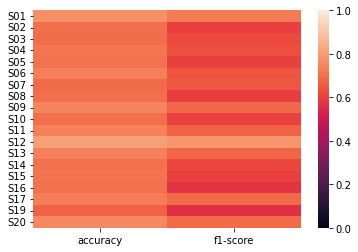

     class0 f1-score  class1 f1-score
S01         0.856031         0.430769
S02         0.815884         0.135593
S03         0.811189         0.181818
S04         0.824675         0.181818
S05         0.824373         0.075472
S06         0.840678         0.145455
S07         0.800000         0.317073
S08         0.816993         0.125000
S09         0.844156         0.294118
S10         0.816720         0.123077
S11         0.840580         0.241379
S12         0.875000         0.575000
S13         0.837370         0.318841
S14         0.818792         0.156250
S15         0.827362         0.101695
S16         0.823151         0.000000
S17         0.827586         0.366197
S19         0.798680         0.061538
S20         0.846416         0.328358


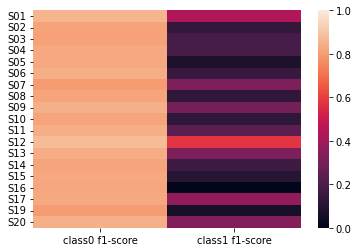

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
model.return_IE_weights()

array([0.9754605 , 0.9818703 , 0.9987454 , 1.0068165 , 1.02418   ,
       0.9993477 , 1.0205894 , 0.9761795 , 0.9825516 , 1.0556005 ,
       1.0024692 , 0.98054796, 1.0309421 , 0.99277806, 0.9729018 ,
       1.0230637 , 1.0424302 , 0.98739856, 0.99115044, 0.98314756,
       0.9698755 , 0.93885744, 0.9698385 , 1.021376  , 0.98818165,
       0.98360133, 1.0816647 , 0.9989996 , 1.0102854 , 0.9556922 ,
       0.9970397 , 0.99544525], dtype=float32)

In [8]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_EEG-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

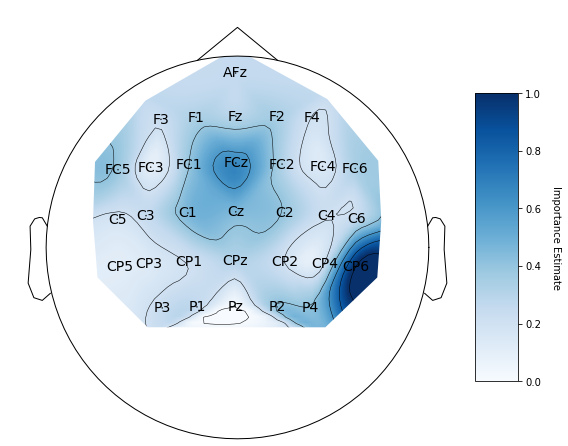

In [10]:
import matplotlib
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)